<a href="https://colab.research.google.com/github/Huy1902/HAC/blob/main/HAC_ML1M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import random
from tqdm import tqdm
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from time import time
import copy
import torch.nn.functional as F

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# @title Hyperparameter

path_to_data = "/content/drive/MyDrive/RL/HAC/ml1m/"
l2_coef = 0.001
lr = 0.0003
epoch = 2
seed = 19
model_path = os.path.join(path_to_data, f"env/ml1m_user_env_lr{lr}_reg{l2_coef}.model")
max_seq_len = 50
n_worker = 0
feature_dim = 16
hidden_dims = [256]
attn_n_head = 2
loss = "bce"
dropout_rate = 0.2
batch_size = 128

cuda = 0
if cuda >= 0 and torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda)
    torch.cuda.set_device(cuda)
    device = f"cuda:{cuda}"
else:
    device = "cpu"

In [ ]:
# @title Support function

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def padding_and_clip(sequence, max_len, padding_direction = 'left'):
    if len(sequence) < max_len:
        sequence = [0] * (max_len - len(sequence)) + sequence if padding_direction == 'left' else sequence + [0] * (max_len - len(sequence))
    sequence = sequence[-max_len:] if padding_direction == 'left' else sequence[:max_len]
    # print(f"sequence{sequence}")
    return sequence

def get_regularization(*modules):
  """
  Customized L2 regularization
  """
  reg = 0
  for m in modules:
    for p in m.parameters():
      reg = torch.mean(p * p) + reg
  return reg

def wrap_batch(batch, device):
  """
  Build feed_dict from batch data and move data to device
  """
  for k,val in batch.items():
    if type(val).__module__ == np.__name__:
        batch[k] = torch.from_numpy(val)
    elif torch.is_tensor(val):
        batch[k] = val
    elif type(val) is list:
        batch[k] = torch.tensor(val)
    else:
        continue
    if batch[k].type() == "torch.DoubleTensor":
        batch[k] = batch[k].float()
    batch[k] = batch[k].to(device)
  return batch

def sample_categorical_action(action_prob, candidate_ids, slate_size,
                              with_replacement=True, batch_wise=False,
                              return_idx=False):
  '''
  @input:
  - action_prob: (B, L)
  - candidate_ids: (B, L) or (1, L)
  - slate_size: K
  - with_replacement: sample with replacement
  - batch_wise: do batch wise candidate selection
  '''
  if with_replacement:
    # (K, B)
    indices = Categorical(action_prob).sample(sample_shape = (slate_size,))
    # (B, K)
    indices = torch.transpose(indices, 0, 1)
  else:
    indices = torch.cat([torch.multinomial(prob, slate_size, replacement=False).view(1, -1) \
                         for prob in action_prob], dim = 0)
  action = torch.gather(candidate_ids, 1, indices) if batch_wise else candidate_ids[indices]
  if return_idx:
    return action.detach(), indices.detach()
  else:
    return action.detach()


##################
#   Learning     #
##################

class LinearScheduler(object):
  def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
    self.schedule_timesteps = schedule_timesteps
    self.final_p = final_p
    self.initial_p = initial_p

  def value(self, t):
    '''
    see Schedule.value
    '''
    fraction = min(float(t) / self.schedule_timesteps, 1.0)
    return self.initial_p + fraction * (self.final_p - self.initial_p)


In [ ]:
# @title Plot Function

def smooth(values, window = 3):
  left = window // 2
  new_values = [np.mean(values[max(0,idx-left):min(idx-left+window,len(values))]) for idx in range(len(values))]
  return new_values


def get_rl_training_info(log_path, training_losses = ['actor_loss', 'critic_loss']):
  episode = []
  average_total_reward, reward_variance, max_total_reward, min_total_reward, average_n_step, max_n_step, min_n_step \
          = [], [], [], [], [], [], []
  training_loss_records = {k: [] for k in training_losses}
  with open(log_path, 'r') as infile:
    for line in tqdm(infile):
      split = line.split('@')
      # episode
      episode.append(eval(split[0].split(':')[1]))
      # episode report
      episode_report = eval(split[1].strip()[len("episode report:"):])
      average_total_reward.append(episode_report['average_total_reward'])
      reward_variance.append(episode_report['reward_variance'])
      max_total_reward.append(episode_report['max_total_reward'])
      min_total_reward.append(episode_report['min_total_reward'])
      average_n_step.append(episode_report['average_n_step'])
      max_n_step.append(episode_report['max_n_step'])
      min_n_step.append(episode_report['min_n_step'])
      # loss report
      loss_report = eval(split[2].strip()[len("step loss:"):])
      for k in training_losses:
          training_loss_records[k].append(loss_report[k])
  info = {
      "episode": episode,
      "average_total_reward": average_total_reward,
      "reward_variance": reward_variance,
      "max_total_reward": max_total_reward,
      "min_total_reward": min_total_reward,
      "average_depth_per_episode": average_n_step,
      "max_depth_per_episode": max_n_step,
      "min_depth_per_episode": min_n_step
  }
  for k in training_losses:
    info[k] = training_loss_records[k]
  return info

def plot_multiple_line(legend_names, list_of_stats, x_name, ncol = 2, row_height = 4):
  '''
  @input:
  - legend_names: [legend]
  - list_of_stats: [{field_name: [values]}]
  - x_name: x-axis field_name
  - ncol: number of subplots in each row
  '''
  plt.rcParams.update({'font.size': 14})
  assert ncol > 0
  features = list(list_of_stats[0].keys())
  features.remove(x_name)
  N = len(features)
  fig_height = 12 // ncol if len(features) == 1 else row_height*((N-1)//ncol+1)
  plt.figure(figsize = (16, fig_height))
  for i,field in enumerate(features):
      plt.subplot((N-1)//ncol+1,ncol,i+1)
      minY,maxY = float('inf'),float('-inf')
      for j,L in enumerate(legend_names):
          X = list_of_stats[j][x_name]
          value_list = list_of_stats[j][field]
          minY,maxY = min(minY,min(value_list)),max(maxY,max(value_list))
          plt.plot(X[:len(value_list)], value_list, label = L)
      plt.ylabel(field)
      plt.xlabel(x_name)
      scale = 1e-4 + maxY - minY
      plt.ylim(minY - scale * 0.05, maxY + scale * 0.05)
      plt.legend()
  plt.show()

In [ ]:
# @title Socrer function
def dot_scorer(action_emb, item_emb, item_dim):
  '''
  score = item_emb * weight

  @input:
  - action_emb: (B, i_dim)
  - item_emb: (B, L, i_dim) or (1, L, i_dim)
  @output:
  - score: (B, L)
  '''
  output = torch.sum(action_emb.view(-1, 1, item_dim) * item_emb, dim=-1)

  return output

In [ ]:
# @title Dense Neural Network

class DNN(nn.Module):
  def __init__(self, in_dim, hidden_dims, out_dim=1, dropout_rate= 0.,
               do_batch_norm=True):
    super(DNN, self).__init__()
    self.in_dim = in_dim
    layers = []

    for hidden_dim in hidden_dims:
      linear_layer = nn.Linear(in_dim, hidden_dim)

      layers.append(linear_layer)
      in_dim = hidden_dim
      layers.append(nn.ReLU())
      if dropout_rate > 0:
        layers.append(nn.Dropout(dropout_rate))
      if do_batch_norm:
        layers.append(nn.LayerNorm(hidden_dim))

    # Prediction layer
    last_layer = nn.Linear(in_dim, out_dim)
    layers.append(last_layer)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    x = x.view(-1, self.in_dim)
    logit = self.layers(x)
    return logit



In [ ]:
# @title Load data
item_info = np.load(os.path.join(path_to_data, "item_info.npy"))
user_info = np.load(os.path.join(path_to_data, "user_info.npy"))
test = pd.read_csv(os.path.join(path_to_data, "test.csv"), sep="@")
train = pd.read_csv(os.path.join(path_to_data, "train.csv"), sep="@")
display(test.head())
display(train.head())

user_id                                    slate_of_items  \
0        1  [198, 113, 225, 21, 149, 88, 103, 239, 110, 101]   
1        1    [34, 43, 29, 132, 210, 205, 125, 12, 201, 208]   
2        1       [116, 58, 3, 138, 37, 66, 38, 140, 241, 76]   
3        1     [78, 226, 232, 63, 139, 75, 142, 51, 54, 228]   
4        1      [44, 86, 100, 154, 9, 169, 178, 87, 16, 222]   

                         user_mid  \
0  [1, 1, 0, 0, 0, 1, 0, 1, 0, 0]   
1  [0, 1, 0, 1, 1, 0, 0, 1, 0, 1]   
2  [0, 1, 1, 0, 0, 1, 0, 0, 1, 1]   
3  [0, 0, 0, 0, 0, 1, 0, 1, 0, 1]   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   

                                    user_mid_history  sequence_id  
0  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...           20  
1  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...           21  
2  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...           22  
3  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...           23  
4  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...           24

user_id                                     slate_of_items  \
0        1  [168, 172, 165, 156, 196, 166, 187, 14, 250, 127]   
1        1    [117, 181, 109, 1, 246, 248, 257, 50, 253, 249]   
2        1     [262, 224, 93, 124, 19, 137, 123, 146, 7, 235]   
3        1     [15, 260, 264, 24, 245, 126, 237, 25, 13, 121]   
4        1    [251, 236, 240, 118, 130, 47, 65, 190, 31, 114]   

                         user_mid  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
1  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
2  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
3  [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]   
4  [1, 1, 0, 0, 0, 1, 1, 1, 0, 1]   

                                    user_mid_history  sequence_id  
0                                                 []            0  
1  [168, 172, 165, 156, 196, 166, 187, 14, 250, 127]            1  
2  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...            2  
3  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...            3  
4  [168, 172, 165, 156, 196, 166, 187, 14, 250, 1...            4

In [ ]:
# @title # Data Reader class

class DataReader(Dataset):
  def __init__(self):
    self.phase = "train"
    self.n_worker = n_worker
    self.max_seq_len = max_seq_len
    self._read_data()

  def _read_data(self):
    self.data = dict()
    self.data['train'] = train
    self.data['val'] = test
    self.item_meta = item_info
    self.user_meta = user_info
    self.item_vec_size = len(self.item_meta[0])
    self.user_vec_size = len(self.user_meta[0])
    self.portrait_len = len(self.user_meta[0])


  def __getitem__(self, idx):
    user_ID, slate_of_items, user_feedback, user_history, sequence_id = self.data[self.phase].iloc[idx]
    user_profile = self.user_meta[user_ID]

    exposure = eval(slate_of_items)

    history = eval(user_history)

    hist_length = len(history)
    history = padding_and_clip(history, self.max_seq_len)
    # print(f"history{}")
    feedback = eval(user_feedback)

    record = {
        'timestamp': int(1), # timestamp is irrelevant, just a hack temporal
        'exposure': np.array(exposure).astype(int),
        'exposure_features': self.get_item_list_meta(exposure).astype(float),
        'feedback': np.array(feedback).astype(float),
        'history': np.array(history).astype(int),
        'history_features': self.get_item_list_meta(history).astype(float),
        'history_length': int(min(hist_length, self.max_seq_len)),
        'user_profile': np.array(user_profile)
        }
    return record

  def __len__(self):
    return len(self.data[self.phase])

  def get_item_list_meta(self, item_list):
    return np.array([self.item_meta[item] for item in item_list])

  def get_statistics(self):
    stats = dict()
    stats['length'] = len(self.data[self.phase])
    stats['n_item'] = len(self.item_meta) - 1
    stats['item_vec_size'] = self.item_vec_size
    stats['user_portrait_len'] = self.user_vec_size
    stats['max_seq_len'] = self.max_seq_len
    return stats

  def set_phase(self, phase):
    assert phase in ['train', 'val', 'test']
    self.phase = phase



## Model

In [ ]:
# @title Base Model

class BaseModel(nn.Module):
  def __init__(self, reader, device):
    super().__init__()
    self.display_name = "BaseModel"
    self.reader = reader
    self.model_path = model_path
    self.loss_type = loss
    self.l2_coef = l2_coef
    self.lr = lr
    self.device = device
    self.sigmoid = nn.Sigmoid()
    self._define_params(reader)

  def get_regularization(self, *modules):
    return get_regularization(*modules)

  def do_forward_and_loss(self, feed_dict: dict) -> dict:
    '''
    Used during training to compute predictions and the loss.
    '''
    out_dict = self.get_forward(feed_dict)
    out_dict['loss'] = self.get_loss(feed_dict, out_dict)
    return out_dict

  def forward(self, feed_dict: dict, return_prob=True) -> dict:
    '''
      Used during evaluation/prediction to generate predictions and probabilities
    '''
    out_dict = self.get_forward(feed_dict)
    if return_prob:
      out_dict['probs'] = self.sigmoid(out_dict['preds'])
    return out_dict

  def wrap_batch (self, batch):
    '''
    Build feed_dict from batch data and move data to self.device
    '''
    for k, val in batch.items():
      if type(val).__module__ == np.__name__:
        batch[k] = torch.from_numpy(val)
      elif torch.is_tensor(val):
        batch[k] = val
      elif type(val) is list:
        batch[k] = torch.tensor(val)
      else:
        continue # No compatiable type
      if batch[k].type() == 'torch.DoubleTensor':
        batch[k] = batch[k].type(torch.FloatTensor)
      batch[k] = batch[k].to(self.device)
    return batch

  def save_checkpoint(self):
    torch.save({
        "model_state_dict": self.state_dict(),
        "optimizer_state_dict": self.optimizer.state_dict(),
    }, self.model_path + ".checkpoint")

  def load_checkpoint(self, model_path, with_optimizer=True):
    checkpoint = torch.load(model_path + ".checkpoint",
                            map_location=self.device)
    self.load_state_dict(checkpoint["model_state_dict"])
    if with_optimizer:
      self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    self.model_path = model_path

  def _define_params(self, reader):
    pass

  def get_forward(self, feed_dict: dict) -> dict:
    pass

  def get_loss(self, feed_dict: dict, out_dict: dict) -> dict:
    pass

In [ ]:
# @title ML1M Response Model

class ML1MUserResponse(BaseModel):
  def __init__(self, reader, device):
    super().__init__(reader, device)
    self.bce_loss = nn.BCEWithLogitsLoss(reduction= 'none')

  def _define_params(self, reader):
    stats = reader.get_statistics()
    print(stats)
    self.potrait_len = stats['user_portrait_len']
    self.item_dim = stats['item_vec_size']
    self.feature_dim = feature_dim
    self.uEmb = nn.Embedding.from_pretrained(torch.FloatTensor(self.reader.user_meta), freeze=False)
    self.iEmb = nn.Embedding.from_pretrained(torch.FloatTensor(self.reader.item_meta), freeze=False)

    # fuse information
    self.concat_layer = nn.Linear(feature_dim * 2, feature_dim)

    # portrait embedding
    self.portrait_encoding_layer = DNN(self.potrait_len, hidden_dims,
                                        feature_dim, dropout_rate,
                                        do_batch_norm= False)
    # item embedding
    self.item_emb_layer = nn.Linear(self.item_dim, feature_dim)

    # user history encoder
    self.seq_self_attn_layer = nn.MultiheadAttention(feature_dim, attn_n_head, batch_first= True)
    self.seq_user_attn_layer = nn.MultiheadAttention(feature_dim, attn_n_head, batch_first= True)

    self.loss = []

  def get_forward(self, feed_dict: dict) -> dict:
    user_emb = self.portrait_encoding_layer(feed_dict['user_profile']).view(-1, 1, self.feature_dim)
    history_item_emb = self.item_emb_layer(feed_dict['history_features'])

    seq_encoding, attn_weight = self.seq_self_attn_layer(history_item_emb, history_item_emb, history_item_emb)

    user_interest, attn_weight = self.seq_user_attn_layer(user_emb, seq_encoding, seq_encoding)

    user_interest = torch.concat([user_interest, user_emb], axis=-1)
    user_interest = self.concat_layer(user_interest)

    exposure_item_emb = self.item_emb_layer(feed_dict['exposure_features'])

    score = torch.sum(exposure_item_emb * user_interest, dim=-1)

    # regularization
    reg = self.get_regularization(self.uEmb, self.iEmb, self.portrait_encoding_layer,
                                  self.item_emb_layer, self.seq_user_attn_layer,
                                  self.seq_self_attn_layer)
    return {'preds': score, 'reg': reg}

  def get_loss(self, feed_dict: dict, out_dict: dict):
    preds, reg = out_dict["preds"].view(-1), out_dict["reg"]
    target = feed_dict['feedback'].view(-1).to(torch.float)

    # print(f"preds: {self.sigmoid(preds)}")
    # print(f"target: ", target)

    loss = torch.mean(self.bce_loss(self.sigmoid(preds), target))
    # print(f"loss: {loss} l2: {reg} l2*coef: {self.l2_coef * reg}")
    self.loss.append(loss.item())
    loss = loss + self.l2_coef * reg
    return loss


## Train Environment

In [ ]:
# @title Train user response

set_random_seed(seed)

reader = DataReader()
model = ML1MUserResponse(reader, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.optimizer = optimizer

epo = 0
while epo < epoch:
  epo += 1

  print(f"epoch {epo} is training")
  model.train()
  reader.set_phase("train")
  train_loader = DataLoader(reader, batch_size, shuffle = True, pin_memory = True,
                            num_workers= n_worker)

  t1 = time()
  pbar = tqdm(total=len(train_loader.dataset))
  step_loss = []
  for i, batch_data in enumerate(train_loader):
    optimizer.zero_grad()
    wrapped_batch = wrap_batch(batch_data, device)

    out_dict = model.do_forward_and_loss(wrapped_batch)
    loss = out_dict['loss']
    loss.backward()
    step_loss.append(loss.item())
    optimizer.step()
    pbar.update(batch_size)
    # if (i + 1) % 10 == 0:
      # print(f"Iteration {i + 1}, loss {np.mean(step_loss[-100:])}")
    pbar.close()
    # print("Epoch {}; time {:.4f}".format(epo, time() - t1))

  # validation
  t2 = time()
  reader.set_phase("val")
  val_loader = DataLoader(reader, batch_size, shuffle = False, pin_memory = False,
                          num_workers= n_worker)
  valid_probs, valid_true =  [], []
  pbar = tqdm(total = len(val_loader.dataset))
  with torch.no_grad():
    for i, batch_data in enumerate(val_loader):
      wrapped_batch = wrap_batch(batch_data, device)
      out_dict = model.forward(wrapped_batch)
      valid_probs.append(out_dict['probs'].cpu().numpy())
      valid_true.append(batch_data['feedback'].cpu().numpy())
      pbar.update(batch_size)
  pbar.close()
  auc = roc_auc_score(np.concatenate(valid_true), np.concatenate(valid_probs))
  # print(f"epoch {epo} validating" + "; auc: {:.4f}".format(np.mean(auc)))
  model.save_checkpoint()
  print(model.loss)


{'length': 7504, 'n_item': 1682, 'item_vec_size': 19, 'user_portrait_len': 24, 'max_seq_len': 50}
epoch 1 is training


  2%|▏         | 128/7504 [00:01<00:57, 127.69it/s]
2176it [00:01, 1658.20it/s]                          


[0.6727550029754639, 0.6781544089317322, 0.6821473240852356, 0.6753236651420593, 0.6948727369308472, 0.6708112359046936, 0.6762834191322327, 0.7127825617790222, 0.7224577069282532, 0.6633506417274475, 0.6612999439239502, 0.682794988155365, 0.6743804216384888, 0.6932531595230103, 0.6723453402519226, 0.6893256902694702, 0.6962767839431763, 0.6872382164001465, 0.6797306537628174, 0.6862720847129822, 0.6990135312080383, 0.685261070728302, 0.6809894442558289, 0.6853393912315369, 0.6867749691009521, 0.6877156496047974, 0.6797640919685364, 0.7118583917617798, 0.6863248944282532, 0.7053068280220032, 0.6856870055198669, 0.6753262877464294, 0.7033389806747437, 0.6878714561462402, 0.6806211471557617, 0.6891557574272156, 0.6849327683448792, 0.6472653746604919, 0.6994319558143616, 0.6846393346786499, 0.6906745433807373, 0.6641470193862915, 0.6687849760055542, 0.6969895362854004, 0.6742383241653442, 0.6820241212844849, 0.6963352560997009, 0.6839084029197693, 0.6839262247085571, 0.6836442351341248, 0

  2%|▏         | 128/7504 [00:00<00:04, 1506.20it/s]
2176it [00:00, 2404.37it/s]                          

[0.6727550029754639, 0.6781544089317322, 0.6821473240852356, 0.6753236651420593, 0.6948727369308472, 0.6708112359046936, 0.6762834191322327, 0.7127825617790222, 0.7224577069282532, 0.6633506417274475, 0.6612999439239502, 0.682794988155365, 0.6743804216384888, 0.6932531595230103, 0.6723453402519226, 0.6893256902694702, 0.6962767839431763, 0.6872382164001465, 0.6797306537628174, 0.6862720847129822, 0.6990135312080383, 0.685261070728302, 0.6809894442558289, 0.6853393912315369, 0.6867749691009521, 0.6877156496047974, 0.6797640919685364, 0.7118583917617798, 0.6863248944282532, 0.7053068280220032, 0.6856870055198669, 0.6753262877464294, 0.7033389806747437, 0.6878714561462402, 0.6806211471557617, 0.6891557574272156, 0.6849327683448792, 0.6472653746604919, 0.6994319558143616, 0.6846393346786499, 0.6906745433807373, 0.6641470193862915, 0.6687849760055542, 0.6969895362854004, 0.6742383241653442, 0.6820241212844849, 0.6963352560997009, 0.6839084029197693, 0.6839262247085571, 0.6836442351341248, 0

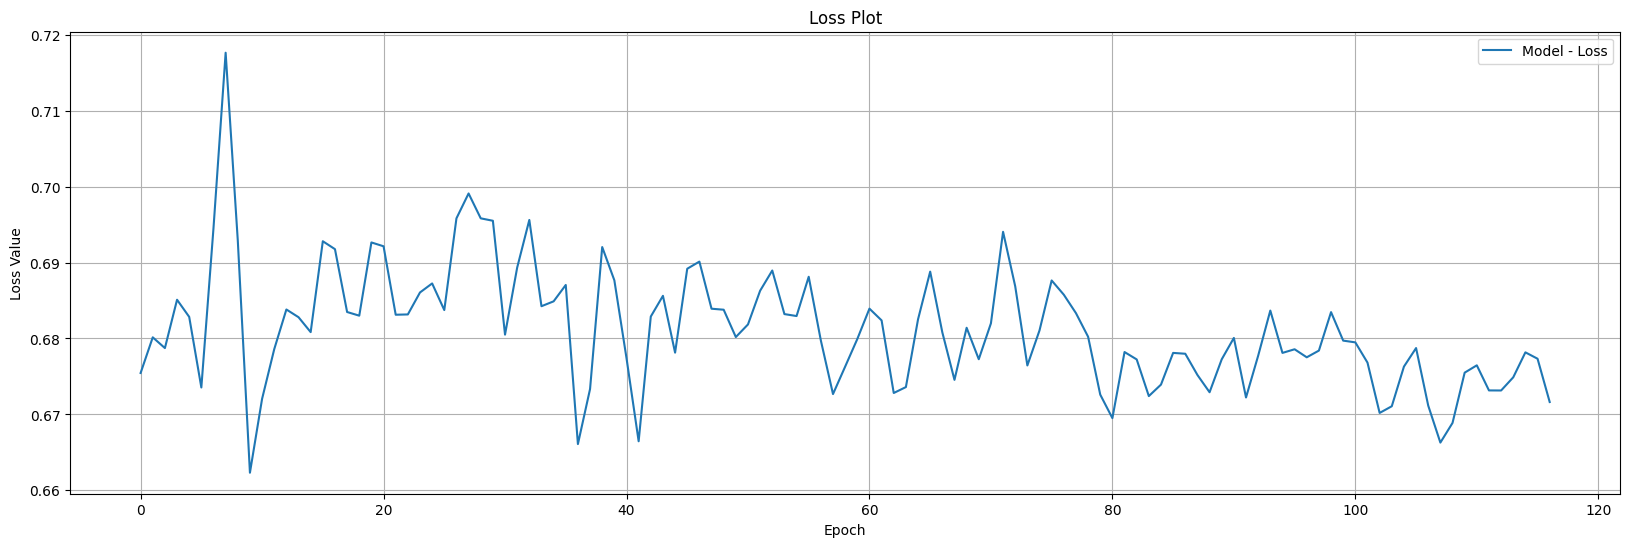

In [ ]:
# @title Plot loss

def smooth(data, smoothness=300):
    return np.convolve(data, np.ones(smoothness) / smoothness, mode='valid')


def plot_multiple_line(labels, data_dicts, x_name='X-Axis', y_name='Y-Axis'):
    plt.figure(figsize=(20, 6))
    for label, data_dict in zip(labels, data_dicts):
        for key, values in data_dict.items():
            plt.plot(values, label=f"{label} - {key}")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Loss Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


loss_values = model.loss
smoothed_loss = smooth(np.array(loss_values), smoothness=2)  # Adjust smoothness if needed

info = {'Loss': smoothed_loss}
plot_multiple_line(['Model'], [info], x_name='Epoch', y_name='Loss Value')



In [ ]:
# @title Cost function
def mean_with_cost(feedback, zero_reward_cost=0.1):
  B, L = feedback.shape
  cost = torch.zeros_like(feedback)
  cost[feedback == 0] = -zero_reward_cost
  reward = torch.mean(feedback + cost, dim=-1)
  return reward

In [ ]:
# @title Hyperparameter for train environment
max_step = 20
initial_temper = 20

In [ ]:
# @title BaseRL Environment
class BaseEnv():
  def __init__(self):
    super().__init__()
    self.reward_func = mean_with_cost
    self.max_step_per_episode = max_step
    self.initial_temper = initial_temper

  def reset(self, paras):
    pass
  def step(self, action):
    pass

In [ ]:
# @title ML1M Environment


class ML1MEnvironment(BaseEnv):
  def __init__(self):
    super().__init__()
    self.reader = DataReader()
    self.user_response_model = ML1MUserResponse(self.reader, device)
    checkpoint = torch.load(model_path + ".checkpoint", map_location=device)
    self.user_response_model.load_state_dict(checkpoint["model_state_dict"])
    self.user_response_model.to(device)

    # spaces
    stats = self.reader.get_statistics()
    self.action_space = {'item_id': ('nomial', stats['n_item']),
                         'item_feature': ('continuous', stats['item_vec_size'], 'normal')}
    self.observation_space = {'user_profile': ('continuous', stats['user_portrait_len'], 'positive'),
                              'history': ('sequence', stats['max_seq_len'], ('continuous', stats['item_vec_size']))}

  def reset(self, params = {'batch_size': 1, 'empty_history': True}):
      self.empty_history_flag = params['empty_history'] if 'empty_history' in params else True
      BS = params['batch_size']
      observation = {'batch_size': BS}
      if 'sample' in params:
          sample_info = params['sample']
      else:
          self.batch_iter = iter(DataLoader(self.reader, batch_size = BS, shuffle = True,
                                            pin_memory = True, num_workers = 8))
          sample_info = next(self.batch_iter)
          sample_info = wrap_batch(sample_info, device = self.user_response_model.device)
      self.current_observation = {
          'user_profile': sample_info['user_profile'],  # (B, user_dim)
          'history': sample_info['history'],  # (B, H)
          'history_features': sample_info['history_features'], # (B, H, item_dim)
          'cummulative_reward': torch.zeros(BS).to(self.user_response_model.device),
          'temper': torch.ones(BS).to(self.user_response_model.device) * self.initial_temper,
          'step': torch.zeros(BS).to(self.user_response_model.device),
      }
      self.reward_history = [0.]
      self.step_history = [0.]
      return copy.deepcopy(self.current_observation)


  def sample_user(self, n_user, empty_history = False):
    '''
    Sample random users and their history
    '''
    random_rows = np.random.randint(0, len(self.reader.data['train']), n_user)
    return self.pick_user(random_rows, empty_history)

  def pick_user(self, rows, empty_history = False):
    '''
    Pick users and their history
    '''
    raw_portrait = [self.reader.user_meta[self.reader.data['train']['user_id'][rowid]]
                    for rowid in rows]

    portrait = np.array(raw_portrait)

    history = []
    history_features = []
    for rowid in rows:
      H = [] if empty_history else eval(f"{self.reader.data['train']['user_mid_history'][rowid]}")
      H = padding_and_clip(H, self.reader.max_seq_len)
      history.append(H)

      history_features.append(self.reader.get_item_list_meta(H).astype(float))
      return {'user_profile': portrait,
              'history': history,
              'history_features': np.array(history_features)}

  def step(self, step_dict):
    '''
    @input:
    - step_dict: {'action': (B, slate_size),
                    'action_features': (B, slate_size, item_dim) }
    '''
    # actions (exposures)
    action = step_dict['action'] # (B, slate_size), should be item ids only
    action_features = step_dict['action_features']
    batch_data = {
        'user_profile': self.current_observation['user_profile'],
        'history_features': self.current_observation['history_features'],
        'exposure_features': action_features
    }
    # URM forward
    with torch.no_grad():
        output_dict = self.user_response_model(batch_data)
#             output_dict = self.user_response_model(utils.wrap_batch(batch_data, device = self.user_response_model.device))
        response = torch.bernoulli(output_dict['probs']) # (B, slate_size)
#             prob_scale = (self.current_observation['temper'].clone().detach().view(-1,1) + self.temper_prob_lag) / (self.initial_temper + self.temper_prob_lag)
        probs_under_temper = output_dict['probs'] # * prob_scale
        response = torch.bernoulli(probs_under_temper).detach() # (B, slate_size)

        # reward (B,)
        immediate_reward = self.reward_func(response).detach()

        # (B, H+slate_size)
        H_prime = torch.cat((self.current_observation['history'], action), dim = 1)
        # (B, H+slate_size, item_dim)
        H_prime_features = torch.cat((self.current_observation['history_features'], action_features), dim = 1)
        # (B, H+slate_size)
        F_prime = torch.cat((torch.ones_like(self.current_observation['history']), response), dim = 1).to(torch.long)
        # vector, vector
        row_indices, col_indices = (F_prime == 1).nonzero(as_tuple=True)
        # (B,), the number of positive iteraction as history length
        L = F_prime.sum(dim = 1)

        # user history update
        offset = 0
        newH = torch.zeros_like(self.current_observation['history'])
        newH_features = torch.zeros_like(self.current_observation['history_features'])
        for row_id in range(action.shape[0]):
            right = offset + L[row_id]
            left = right - self.reader.max_seq_len
            newH[row_id] = H_prime[row_id, col_indices[left:right]]
            newH_features[row_id] = H_prime_features[row_id,col_indices[left:right],:]
            offset += L[row_id]
        self.current_observation['history'] = newH
        self.current_observation['history_features'] = newH_features
        self.current_observation['cummulative_reward'] += immediate_reward

        # temper update for leave model
        temper_down = (-immediate_reward+1) * response.shape[1] + 1
#             temper_down = -(torch.sum(response, dim = 1) - response.shape[1] - 1)
#             temper_down = torch.abs(torch.sum(response, dim = 1) - response.shape[1] * self.temper_sweet_point) + 1
        self.current_observation['temper'] -= temper_down
        # leave signal
        done_mask = self.current_observation['temper'] < 1
        # step update
        self.current_observation['step'] += 1

        # update rows where user left
#             refresh_rows = done_mask.nonzero().view(-1)
#             print(f"#refresh: {refresh_rows}")
        if done_mask.sum() > 0:
            final_rewards = self.current_observation['cummulative_reward'][done_mask].detach().cpu().numpy()
            final_steps = self.current_observation['step'][done_mask].detach().cpu().numpy()
            self.reward_history.append(final_rewards[-1])
            self.step_history.append(final_steps[-1])
            # sample new users to fill in the blank
            new_sample_flag = False
            try:
                sample_info = next(self.iter)
                if sample_info['user_profile'].shape[0] != done_mask.shape[0]:
                    new_sample_flag = True
            except:
                new_sample_flag = True
            if new_sample_flag:
                self.iter = iter(DataLoader(self.reader, batch_size = done_mask.shape[0], shuffle = True,
                                            pin_memory = True, num_workers = 8))
                sample_info = next(self.iter)
            sample_info = wrap_batch(sample_info, device = self.user_response_model.device)
            for obs_key in ['user_profile', 'history', 'history_features']:
                self.current_observation[obs_key][done_mask] = sample_info[obs_key][done_mask]
            self.current_observation['cummulative_reward'][done_mask] *= 0
            self.current_observation['temper'][done_mask] *= 0
            self.current_observation['temper'][done_mask] += self.initial_temper
        self.current_observation['step'][done_mask] *= 0
#         print(f"step: {self.current_observation['step']}")
    return copy.deepcopy(self.current_observation), immediate_reward, done_mask, {'response': response}


  def stop(self):
    self.iter = None

  def get_new_iterator(self, B):
    return iter(DataLoader(self.reader, batch_size = B, shuffle = True,
                              pin_memory = True, num_workers = 8))


In [ ]:
# @title Self-Attentive Sequential Recommendation
sasrec_n_layer = 2
sasrec_d_model = 32
sasrec_n_head = 4
sasrec_dropout = 0.1
sasrec_d_forward = 64
class SASRec(nn.Module):
  def __init__(self, environment):
    super().__init__()
    self.n_layer = sasrec_n_layer
    self.d_model = sasrec_d_model
    self.n_head = sasrec_n_head
    self.dropout_rate = sasrec_dropout
    self.d_forward = sasrec_d_forward

    # item space
    self.item_space = environment.action_space['item_id'][1]
    self.item_dim = environment.action_space['item_feature'][1]
    self.maxlen = environment.observation_space['history'][1]
    self.state_dim = self.d_model
    self.action_dim = self.d_model

    # policy network modules
    self.item_map = nn.Linear(self.item_dim, self.d_model)
    self.pos_emb = nn.Embedding(self.maxlen, self.d_model)
    self.pos_emb_getter = torch.arange(self.maxlen, dtype = torch.long)
    self.emb_dropout = nn.Dropout(self.dropout_rate)
    self.emb_norm = nn.LayerNorm(self.d_model)
    self.attn_mask = ~torch.tril(torch.ones((self.maxlen, self.maxlen), dtype=torch.bool))
    encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model,
                                               nhead=self.n_head,
                                               dim_feedforward= sasrec_d_forward,
                                               dropout=self.dropout_rate,
                                               batch_first = True
                                               )
    self.transformer = nn.TransformerEncoder(encoder_layer= encoder_layer,
                                             num_layers = self.n_layer)

  def score(self, action_emb, item_emb, do_softmax=True):
    item_emb = self.item_map(item_emb)
    output = dot_scorer(action_emb, item_emb, self.d_model)
    if do_softmax:
      return torch.softmax(output, dim=-1)
    else:
      return output

  def get_scorer_parameters(self):
    return self.item_map.parameters()

  def encode_state(self, feed_dict):
    user_history = feed_dict['history_features']
    # (1, H, d_model)
    # for item in feed_dict.items():
    #   print(item)
    # print("user_history device:", user_history.device)
    # print("self.pos_emb_getter device:", self.pos_emb_getter.device)
    # print("self.pos_emb device", self.pos_emb.device)

    pos_emb = self.pos_emb(self.pos_emb_getter.to(user_history.device)).view(1, self.maxlen, self.d_model)

    # (B, H, d_model)
    history_item_emb = self.item_map(user_history).view(-1, self.maxlen, self.d_model)
    history_item_emb = self.emb_norm(self.emb_dropout(history_item_emb + pos_emb))

    # (B, H, d_model)
    output_seq = self.transformer(history_item_emb, mask = self.attn_mask.to(user_history.device))

    return {'output_seq': output_seq, 'state_emb': output_seq[:, -1, :]}

  def forward(self, feed_dict):
    '''
    @input
    - feed_dict: {'user_profile': (B, user_dim),
                  'history_features': (B, H, item_dim),
                  'history_mask': (B),
                  'candicate_features': (B, L, item_dim) or (1, L, item_dim)
                  }
    @model
    - user_profile --> user_emb (B, 1, f_dim)
    - hisotry_items --> history_item_emb (B, H, f_dim)
    - (Q:user_emb, K&V: history_item_emb) --(multi-head attn) --> user_state(B, 1, feature_dim)
    - user_state --> action_prob (B, n_item)
    '''
    hist_enc = self.encode_state(feed_dict)

    # user embedding (B, 1, d_model)
    user_state = hist_enc['state_emb'].view(-1, self.d_model)

    # action embedding (B, d_model)
    action_emb = user_state

    # regularization
    reg = get_regularization(self.item_map, self.transformer)

    out_dict = {
        'action_emb': action_emb,
        'state_emb': user_state,
        'seq_emb': hist_enc['output_seq'],
        'reg': reg
    }
    return out_dict

In [ ]:
critic_hidden_dims = [256, 64]
critic_dropout_rate = 0.2
# @title General Critic class
class GeneralCritic(nn.Module):
  def __init__(self, policy):
    super().__init__()
    self.state_dim = policy.state_dim
    self.action_dim = policy.action_dim
    self.net = DNN(self.state_dim + self.action_dim, critic_hidden_dims, 1,
                   dropout_rate=critic_dropout_rate, do_batch_norm=True)

  def forward(self, feed_dict):
    '''
    @input:
    - feed_dict: {'state_emb': (B, state_dim), 'action_emb': (B, action_dim)}
    '''
    state_emb = feed_dict['state_emb']
    action_emb = feed_dict['action_emb'].view(-1, self.action_dim)

    Q = self.net(torch.cat((state_emb, action_emb), dim = -1)).view(-1)

    reg = get_regularization(self.net)
    return {'q': Q, 'reg': reg}

In [ ]:
n_iter= [50000]
slate_size = 9
noise_var = 0.1
q_laplace_smoothness = 0.5
topk_rate = 1
empty_start_rate = 0
buffer_size = 100000
start_timestamp = 2000



# @title One Stage Facade
class OneStageFacade():
  def __init__(self, environment, actor, critic):
    super().__init__()
    self.device = device
    self.env = environment
    self.actor = actor
    self.critic = critic

    self.slate_size = slate_size
    self.noise_var = noise_var
    self.noise_decay = noise_var / n_iter[-1]
    self.q_laplace_smoothness = q_laplace_smoothness
    self.topk_rate = topk_rate
    self.empty_start_rate = empty_start_rate

    self.n_item = self.env.action_space['item_id'][1]

    # (N)
    self.candidate_iids = np.arange(1, self.n_item + 1)

    # (N, item_dim)
    self.candidate_features = torch.FloatTensor(
        self.env.reader.get_item_list_meta(self.candidate_iids)).to(self.device)
    self.candidate_iids = torch.tensor(self.candidate_iids).to(self.device)

    # replay buffer is initialized in initialize_train()
    self.buffer_size = buffer_size
    self.start_timestamp = start_timestamp

  def initialize_train(self):
    '''
    Procedures before training
    '''
    self.buffer = {
        "user_profile": torch.zeros(self.buffer_size, self.env.reader.portrait_len),
        "history":torch.zeros(self.buffer_size, self.env.reader.max_seq_len).to(torch.long),
        "next_history":torch.zeros(self.buffer_size, self.env.reader.max_seq_len).to(torch.long),
        "state_emb": torch.zeros(self.buffer_size, self.actor.state_dim),
        "action_emb":torch.zeros(self.buffer_size, self.actor.action_dim),
        "action":torch.zeros(self.buffer_size, self.slate_size, dtype=torch.long),
        "reward":torch.zeros(self.buffer_size),
        "feedback": torch.zeros(self.buffer_size, self.slate_size),
        "done": torch.zeros(self.buffer_size, dtype=torch.bool)
    }

    for k, v in self.buffer.items():
      self.buffer[k] = v.to(self.device)
    self.buffer_head = 0
    self.current_buffer_size = 0
    self.n_stream_record = 0
    self.is_training_available = False

  def reset_env(self, initial_params = {'batch_size': 1}):
    '''
    Reset user response environment
    '''
    initial_params['empty_history'] = True if np.random.rand() < self.empty_start_rate else False
    initial_observation = self.env.reset(initial_params)
    return initial_observation

  def env_step(self, policy_output):
    action_dict = {
      'action': policy_output['action'],
      'action_features': policy_output['action_features']
    }
    observation, reward, done, info = self.env.step(action_dict)
    return observation, reward, done, info

  def stop_env(self):
    self.env.stop()

  def get_episode_report(self, n_recent = 10):
    recent_rewards = self.env.reward_history[-n_recent:]
    recent_steps = self.env.step_history[-n_recent:]
    epsiode_report = {
        'average_total_reward': np.mean(recent_rewards),
        'reward_variance': np.var(recent_rewards),
        'max_total_reward': np.max(recent_rewards),
        'min_total_reward': np.min(recent_rewards),
        'average_n_step': np.mean(recent_steps),
        'max_n_step': np.max(recent_steps),
        'min_n_step': np.min(recent_steps),
        'buffer_size': self.current_buffer_size
    }
    return epsiode_report

  def apply_critic(self, observation, policy_output, critic_model):
    feed_dict = {
        'state_emb': policy_output['state_emb'],
        'action_emb': policy_output['action_emb']
    }
    critic_output = critic_model(feed_dict)
    return critic_output

  def apply_policy(self, observation, policy_model, epsilon=0,
                   do_explore=False, do_softmax=True):
    feed_dict = observation
    out_dict = policy_model(feed_dict)
    if do_explore:
      action_emb = out_dict['action_emb']

      # explore and exploit + clamping
      if np.random.rand() < epsilon:
        action_emb = torch.clamp(torch.rand_like(action_emb) * self.noise_var, -1, 1)
      else:
        action_emb = action_emb + torch.clamp(torch.rand_like(action_emb) * self.noise_var, -1, 1)

      if 'candidate_ids' in feed_dict:
        # (B, L, item_dim)
        out_dict['candidate_features']  = feed_dict['candidate_features']
        # (B, L)
        out_dict['candidate_ids'] = feed_dict['candidate_ids']
        batch_wise = True
      else:
        # (1, L, item_dim)
        out_dict['candidate_features'] = self.candidate_features.unsqueeze(0)
        #(L, )
        out_dict['candidate_ids'] = self.candidate_iids
        batch_wise = False

      # action pron (B, L)
      action_prob = policy_model.score(out_dict['action_emb'],
                                       out_dict['candidate_features'],
                                       do_softmax=do_softmax)

      # two types of greedy selection
      if np.random.rand() >= self.topk_rate:
        # greedy random
        action, indices = sample_categorical_action(action_prob, out_dict['candidate_ids'],
                                                    self.slate_size, with_replacement=False,
                                                    batch_wise=batch_wise,
                                                    return_idx=True)
      else:
        # indices on action_prob
        _, indices = torch.topk(action_prob, k = self.slate_size, dim = 1)
        # top k action:
        # (B, slate_size)
        if batch_wise:
          action = torch.gather(out_dict['candidate_ids'], 1, indices).detach()
        else:
          action = out_dict['candidate_ids'][indices].detach()

      # (B, K)
      out_dict['action'] = action
      # (B, K, item_dim)
      action['action_features'] = self.candidate_features[action-1]
      # (B, K)
      out_dict['action_prob'] = torch.gather(action_prob, 1, indices)
      # (B, L)
      out_dict['candidate_prob'] = action_prob

      return out_dict

  def sample_buffer(self, batch_size):
    '''
    @output:
    - observation
    - policy output
    - reward
    - done_mask
    - next_observation
    '''
    indices = np.random.randint(0, self.current_buffer_size, size = batch_size)
    U, H, N, S, HA, A, R, F, D = self.read_buffer(indices)
    observation = {
        'user_profile': U,
        'history_features': H,
    }
    policy_output = {
        'state_emb': S,
        'action_emb': HA,
        'action': A
    }
    reward = R
    done_mask = D
    next_observation = {
        'user_profile': U,
        'history_features': N,
        'previous_feedback': F
    }
    return observation, policy_output, reward, done_mask, next_observation

  # def sample_raw_data(self, batch_size):
  #   '''
  #   Sample supervise data from raw training data
  #   '''
  #   batch = self.env.sample_user(batch_size)

  def update_buffer(self, observation, policy_output, reward, done_mask,
                    next_observation, info):
    # Overwrite old entries in buffer
    if self.buffer_head + reward.shape[0] >= self.buffer_size:
      tail = self.buffer_size - self.buffer_head
      indices = [self.buffer_head + i for i in range(tail)] + \
       [i for i in range(reward.shape[0] - tail)]
    else:
      indices = [self.buffer_head  + i for i in range(reward.shape[0])]

    # update buffer
    self.buffer["user_profile"][indices] = observation['user_profile']
    self.buffer["history"][indices] = observation['history']
    self.buffer["next_history"][indices] = next_observation['history']
    self.buffer["state_emb"][indices] = policy_output['state_emb']
    self.buffer["action"][indices] = policy_output['action']
    self.buffer["action_emb"][indices] = policy_output['action_emb']
    self.buffer["reward"][indices] = reward
    self.buffer["feedback"][indices] = info['response']
    self.buffer["done"][indices] = done_mask

    # update buffer pointer
    self.buffer_head = (self.buffer_head + reward.shape[0]) % self.buffer_size
    self.n_stream_record += reward.shape[0]
    self.current_buffer_size = min(self.n_stream_record, self.buffer_size)

    # available training when sufficient sample buffer
    if self.n_stream_record >= self.start_timestamp:
      self.is_training_available = True
  def read_buffer(self, indices):
    U = self.buffer['user_profile'][indices]
    # (L, item_dim)
    H = self.candidate_features[self.buffer["history"][indices] - 1]
    N = self.candidate_features[self.buffer["next_history"][indices] - 1]
    S = self.buffer["state_emb"][indices]
    HA = self.buffer["action_emb"][indices]
    A = self.buffer["action"][indices]
    R = self.buffer["reward"][indices]
    F = self.buffer["feedback"][indices]
    D = self.buffer["done"][indices]
    return U, H, N, S, HA, A, R, F, D

  def extract_behavior_data(self, observation, policy_output, next_observation):
    '''
    Extract supervised data from RL samples
    '''
    observation = {
        "user_profile": observation['user_profile'],
        "history_features": observation['history_features']
    }
    exposed_items = policy_output['action']
    exposure = {
        "ids": exposed_items,
        "features": self.candidate_features[exposed_items - 1]
    }
    user_feedback = next_observation["previous_feedback"]
    return observation, exposure, user_feedback

In [ ]:
# @title One Stage Facade with Hyper Action

class OneStageFacade_HyperAction(OneStageFacade):
  def __init__(self, environment, actor, critic):
    super().__init__(environment, actor, critic)

  def apply_policy(self, observation, policy_model, epsilon = 0,
                   do_explore = False, do_softmax = True):
    feed_dict = wrap_batch(observation, device=device)
    # print(feed_dict.device)
    out_dict = policy_model(feed_dict)
    if do_explore:
      action_emb = out_dict['action_emb']
      # explore and exploit + clamping
      if np.random.rand() < epsilon:
        action_emb = torch.clamp(torch.rand_like(action_emb) * self.noise_var, -1, 1)
      else:
        action_emb = action_emb + torch.clamp(torch.rand_like(action_emb) * self.noise_var, -1, 1)

      out_dict['action_emb'] = action_emb

    # Z latent space
    out_dict['Z'] = out_dict['action_emb']

    if 'candidate_ids' in feed_dict:
      # (B, L, item_dim)
      out_dict['candidate_features']  = feed_dict['candidate_features']
      # (B, L)
      out_dict['candidate_ids'] = feed_dict['candidate_ids']
      batch_wise = True
    else:
      # (1, L, item_dim)
      out_dict['candidate_features'] = self.candidate_features.unsqueeze(0)
      #(L, )
      out_dict['candidate_ids'] = self.candidate_iids
      batch_wise = False

    # action pron (B, L)
    action_prob = policy_model.score(out_dict['action_emb'],
                                      out_dict['candidate_features'],
                                      do_softmax=do_softmax)

    # two types of greedy selection
    if np.random.rand() >= self.topk_rate:
      # greedy random
      action, indices = sample_categorical_action(action_prob, out_dict['candidate_ids'],
                                                  self.slate_size, with_replacement=False,
                                                  batch_wise=batch_wise,
                                                  return_idx=True)
    else:
      # indices on action_prob
      _, indices = torch.topk(action_prob, k = self.slate_size, dim = 1)
      # print(indices.shape)
      # print(self.candidate_features.shape)
      # top k action:
      # (B, slate_size)
      if batch_wise:
        action = torch.gather(out_dict['candidate_ids'], 1, indices).detach()
      else:
        action = out_dict['candidate_ids'][indices].detach()

    # (B, K)
    out_dict['action'] = action
    # (B, K, item_dim)
    out_dict['action_features'] = self.candidate_features[indices]
    # (B, K)
    out_dict['action_prob'] = torch.gather(action_prob, 1, indices)
    # (B, L)
    out_dict['candidate_prob'] = action_prob

    return out_dict

  def infer_hyper_action(self, observation, policy_output, actor):
    '''
    Inverse function A -> Z
    '''
    # (B, K)
    A = policy_output['action']

    # (B, K, item_dim)
    item_embs = self.candidate_features[A - 1]

    # (B, K, kernel_dim)
    Z = torch.mean(actor.item_map(item_embs).view(A.shape[0], A.shape[1], -1), dim = 1)
    return {
        'Z': Z,
        'action_emb': Z,
        'state_emb': policy_output['state_emb']
    }

  def apply_critic(self, observation, policy_output, critic_model):
    feed_dict = {
        'state_emb': policy_output['state_emb'],
        'action_emb': policy_output['action_emb']
    }
    critic_output = critic_model(feed_dict)
    return critic_output

In [ ]:
# @title Base RL Agent
output_path = os.path.join(path_to_data, "output/")
log_name="ml1m_user_env_lr0.001_reg0.0003"
gamma = 0.9
n_iter = [50000]
train_every_n_step = 1
initial_greedy_epsilon = 0
final_greedy_epsilon = 0
elbow_greedy = 0.1
check_episode = 10
with_eval = False
save_path = f"{output_path}agents/model"

class BaseRLAgent():
  def __init__(self, facade):
    self.device = device
    self.gamma = gamma
    self.n_iter = [0] + n_iter
    self.train_every_n_step = train_every_n_step
    self.check_episode = check_episode
    self.save_path = save_path
    self.facade = facade
    self.check_episode = check_episode
    self.exploration_scheduler = LinearScheduler(int(sum(self.n_iter) * elbow_greedy),
                                                 final_greedy_epsilon,
                                                 initial_greedy_epsilon)
    # if len(self.n_iter) == 2:
    #   with open(self.save_path + ".report", 'w') as outfile:
    #     outfile.write()

  def train(self):
    if len(self.n_iter) > 2:
      self.load()

    t = time()
    start_time = t
    print("Run procedure before training")
    self.action_before_train()

    print("Start training")
    observation = self.facade.reset_env({
        'batch_size': self.episode_batch_size,
    })
    step_offset = sum(self.n_iter[:-1])
    for i in tqdm(range(step_offset, step_offset + self.n_iter[-1])):
      observation = self.run_episode_step(i, self.exploration_scheduler.value(i),
                                          observation, True)
      if i % self.train_every_n_step == 0:
        self.step_train()

      if i % self.check_episode == 0:
        t_ = time()
        # with open(self.save_path + ".report", 'a') as outfile:
        #   outfile.write(f"Episode step {i}, time diff {t_ - t}, total time dif {t - start_time})")
        #   outfile.write(self.log_iteration(i))
        print(f"Episode step {i}, time diff {t_ - t}, total time dif {t - start_time})")
        print(self.log_iteration(i))
        t = t_
        if i % (3*self.check_episode) == 0:
            self.save()

    self.action_after_train()


  def action_before_train(self):
    pass

  def action_after_train(self):
    self.facade.stop_env()


  def get_report(self):
    episode_report = self.facade.get_episode_report(10)
    train_report = {k: np.mean(v[-10:]) for k, v in self.training_history.items()}
    return episode_report, train_report

  def log_iteration(self, step):
    episode_report, train_report = self.get_report()
    log_str = f"step: {step} @ episode report: {episode_report} @ step loss: {train_report}\n"
    with open(self.save_path + ".report", 'a') as outfile:
        outfile.write(log_str)
    return log_str

  #######################################
  #           Abstract function         #
  #######################################
  def run_episode_step(self, *episode_args):
    pass

  def step_train(self):
    pass

  def test(self):
    pass

  def save(self):
    pass

  def load(self):
    pass

In [ ]:
# @title Deep Deterministic Policy Gradient
episode_batch_size = 32
batch_size = 64
actor_lr = 0.0001
critic_lr = 0.001
actor_decay = 0.00001
critic_decay = 0.00001
target_mitigate_coef = 0.01

class DDPG(BaseRLAgent):
  def __init__(self, facade):
    super().__init__(facade)
    self.actor = facade.actor
    self.actor_target = copy.deepcopy(self.actor)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr, weight_decay = actor_decay)

    self.critic = facade.critic
    self.critic_target = copy.deepcopy(self.critic)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay = critic_decay)

    self.episode_batch_size = episode_batch_size
    self.tau = target_mitigate_coef
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.actor_decay = actor_decay
    self.critic_decay = critic_decay

    with open(self.save_path + ".report", 'w') as outfile:
      pass

  def action_before_train(self):
    '''
    - facade setup
      - buffer setup
    - run random episodes to build-up the initial buffer
    '''
    self.facade.initialize_train()
    # print("Facade Parameters:")
    # for param, value in vars(self.facade).items():
    #     print(f"{param}: {value}")
    prepare_step = 0
    # random explore before training
    initial_epsilon = 1.0
    observation = self.facade.reset_env({
        'batch_size': self.episode_batch_size,
    })
    while not self.facade.is_training_available:
      observation = self.run_episode_step(0, initial_epsilon, observation, True)
      # print(observation)
      prepare_step += 1

    # training records
    self.training_history = {"critic_loss": [], "actor_loss": []}

    print(f"Total {prepare_step} prepare steps")

  def run_episode_step(self, *episode_args):
    '''
    One step of interaction
    '''
    episode_iter, epsilon, observation, do_buffer_update = episode_args
    with torch.no_grad():
      # sample action
      policy_output = self.facade.apply_policy(observation, self.actor, epsilon,
                                               do_explore=True)

      # apply action on environment and update replay buffer
      next_observation, reward, done, info = self.facade.env_step(policy_output)

      # update replay buffer
      if do_buffer_update:
        self.facade.update_buffer(observation, policy_output, reward, done,
                                  next_observation, info)
    return next_observation

  def step_train(self):
    observation , policy_output, reward, done_mask, next_observation = self.facade.sample_buffer(batch_size)
    reward  = torch.FloatTensor(reward)
    done_mask = torch.FloatTensor(done_mask)

    critic_loss, actor_loss = self.get_ddpg_loss(observation, policy_output, reward,
                                                  done_mask, next_observation)
    self.training_history["critic_loss"].append(critic_loss.item())
    self.training_history["actor_loss"].append(actor_loss.item())

    # Update the frozen target models
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    return {'step_loss': (self.training_history['actor_loss'][-1],
                          self.training_history['critic_loss'][-1])}

  def get_ddpg_loss(self, observation, policy_output, reward, done_mask, next_observation,
                    do_actor_update = True, do_critic_update = True):
    # Get current Q estimate
    current_critic_output = self.facade.apply_critic(observation,
                                                     wrap_batch(policy_output, device=self.device),
                                                     self.critic)
    current_Q = current_critic_output['q']

    # Compute the target Q value
    next_policy_output = self.facade.apply_policy(next_observation, self.actor_target)
    target_critic_output = self.facade.apply_critic(next_observation, next_policy_output,
                                                    self.critic_target)

    target_Q = target_critic_output['q']
    target_Q = reward + self.gamma * (done_mask * target_Q).detach()

    # compute critic loss
    # minimize current_Q predict and target_Q predict
    critic_loss = F.mse_loss(current_Q, target_Q).mean()

    if do_critic_update and self.critic_lr > 0:
      # Optimize the critic
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

    # compute actor loss
    policy_output = self.facade.apply_policy(observation, self.actor)
    critic_output = self.facade.apply_critic(observation, policy_output, self.critic)

    # Maximize Q value
    actor_loss = -critic_output['q'].mean()

    if do_actor_update and self.actor_lr > 0:
      # Optimize the actor
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      self.actor_optimizer.step()
    return critic_loss, actor_loss

  def save(self):
    torch.save(self.critic.state_dict(), self.save_path + "_critic")
    torch.save(self.critic_optimizer.state_dict(), self.save_path + "_critic_optimizer")
    torch.save(self.actor.state_dict(), self.save_path + "_actor")
    torch.save(self.actor_optimizer.state_dict(), self.save_path + "_actor_optimizer")

  def load(self):
    self.critic.load_state_dict(torch.load(self.save_path + "_critic", map_location=self.device))
    self.critic_optimizer.load_state_dict(torch.load(self.save_path + "_critic_optimizer", map_location=self.device))
    self.critic_target = copy.deepcopy(self.critic)

    self.actor.load_state_dict(torch.load(self.save_path + "_actor", map_location=self.device))
    self.actor_optimizer.load_state_dict(torch.load(self.save_path + "_actor_optimizer", map_location=self.device))
    self.actor_target = copy.deepcopy(self.actor)

In [ ]:
behavior_lr = 0
behavior_decay = 0.00001
hyper_actor_coef = 0.1

# @title Hyper - Actor Critic
class HAC(DDPG):
  def __init__(self, facade):
    super().__init__(facade)
    self.behavior_lr = behavior_lr
    self.behavior_decay = behavior_decay
    self.hyper_actor_coef = hyper_actor_coef
    self.actor_behavior_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                     lr=behavior_lr,
                                                     weight_decay=behavior_decay)

  def action_before_train(self):
    super().action_before_train()
    self.training_history['hyper_actor_loss'] = []
    self.training_history['behavior_loss'] = []

  def run_episode_step(self, *episode_args):
    '''
    One step of interaction
    '''
    episode_iter, epsilon, observation, do_buffer_update = episode_args
    with torch.no_grad():
      # sample action
      policy_output = self.facade.apply_policy(observation, self.actor, epsilon,
                                               do_explore=True)

      # apply action on environment and update replay buffer
      next_observation, reward, done, info = self.facade.env_step(policy_output)

      # update replay buffer
      if do_buffer_update:
        self.facade.update_buffer(observation, policy_output, reward, done,
                                  next_observation, info)
    return next_observation

  def step_train(self):
    observation , policy_output, reward, done_mask, next_observation = self.facade.sample_buffer(batch_size)
    # reward  = torch.FloatTensor(reward)
    # done_mask = torch.FloatTensor(done_mask)

    critic_loss, actor_loss, hyper_actor_loss = self.get_hac_loss(observation, policy_output, reward,
                                                  done_mask, next_observation)
    behavior_loss = self.get_behavior_loss(observation, policy_output, next_observation)

    self.training_history["critic_loss"].append(critic_loss.item())
    self.training_history["actor_loss"].append(actor_loss.item())
    self.training_history['hyper_actor_loss'].append(hyper_actor_loss.item())
    self.training_history['behavior_loss'].append(behavior_loss.item())

    # Update frozen target models
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    return {"step_loss": (self.training_history['actor_loss'][-1],
                          self.training_history['critic_loss'][-1],
                          self.training_history['hyper_actor_loss'][-1],
                          self.training_history['behavior_loss'][-1])}

  def get_hac_loss(self, observation, policy_output, reward, done_mask, next_observation,
                    do_actor_update = True, do_critic_update = True):

    # Current Q estimate
    hyper_output = self.facade.infer_hyper_action(observation, policy_output, self.actor)
    current_critic_output = self.facade.apply_critic(observation, hyper_output, self.critic)
    current_Q = current_critic_output['q']

    # Compute target Q value
    next_policy_output = self.facade.apply_policy(next_observation, self.actor_target)
    target_critic_output = self.facade.apply_critic(next_observation, next_policy_output, self.critic_target)

    target_Q = target_critic_output['q']
    target_Q = reward + self.gamma * (done_mask * target_Q).detach()

    assert not torch.isnan(current_Q).any(), "NaN in current_Q!"
    assert not torch.isnan(target_Q).any(), "NaN in target_Q!"
    assert not torch.isnan(reward).any(), "NaN in reward!"

    critic_loss = F.mse_loss(current_Q, target_Q).mean()
    if do_critic_update and self.critic_lr > 0:
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

    # actor loss

    if do_actor_update and self.actor_lr > 0:
      self.actor_optimizer.zero_grad()
      policy_output = self.facade.apply_policy(observation, self.actor)
      critic_output = self.facade.apply_critic(observation, policy_output, self.critic)
      actor_loss = -critic_output['q'].mean()
      actor_loss.backward()
      self.actor_optimizer.step()

    # hyper actor loss

    if do_actor_update and self.hyper_actor_coef > 0:
      self.actor_optimizer.zero_grad()
      policy_output = self.facade.apply_policy(observation, self.actor)
      inferred_hyper_output = self.facade.infer_hyper_action(observation, policy_output, self.actor)
      hyper_actor_loss = self.hyper_actor_coef * F.mse_loss(inferred_hyper_output['Z'],
                                                            policy_output['Z']).mean()

      hyper_actor_loss.backward()
      self.actor_optimizer.step()

    return critic_loss, actor_loss, hyper_actor_loss

  def get_behavior_loss(self, observation, policy_output, next_observation, do_update = True):
    observation, exposure, feedback = self.facade.extract_behavior_data(observation, policy_output, next_observation)
    observation['candidate_ids'] = exposure['ids']
    observation['candidate_features'] = exposure['features']
    policy_output = self.facade.apply_policy(observation, self.actor, do_softmax=False)
    action_prob = torch.sigmoid(policy_output['candidate_prob'])
    behavior_loss = F.binary_cross_entropy(action_prob, feedback)

    if do_update and self.behavior_lr > 0:
      self.actor_behavior_optimizer.zero_grad()
      behavior_loss.backward()
      self.actor_behavior_optimizer.step()

    return behavior_loss


In [ ]:
seed = 11
set_random_seed(seed)

env = ML1MEnvironment()

policy = SASRec(env)
policy.to(device)


critic = GeneralCritic(policy)
critic.to(device)

facade = OneStageFacade_HyperAction(env, policy, critic)

agent = HAC(facade)

agent.train()

{'length': 7504, 'n_item': 1682, 'item_vec_size': 19, 'user_portrait_len': 24, 'max_seq_len': 50}
Run procedure before training


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total 63 prepare steps
Start training


  0%|          | 3/50000 [00:00<1:02:23, 13.36it/s]

Episode step 0, time diff 3.217617988586426, total time dif 0.0)
step: 0 @ episode report: {'average_total_reward': np.float64(0.0), 'reward_variance': np.float64(0.0), 'max_total_reward': np.float64(0.0), 'min_total_reward': np.float64(0.0), 'average_n_step': np.float64(0.0), 'max_n_step': np.float64(0.0), 'min_n_step': np.float64(0.0), 'buffer_size': 2048} @ step loss: {'critic_loss': np.float64(0.7400578856468201), 'actor_loss': np.float64(-0.4250645935535431), 'hyper_actor_loss': np.float64(0.0918385237455368), 'behavior_loss': np.float64(0.7930481433868408)}



  0%|          | 13/50000 [00:00<50:34, 16.47it/s]

Episode step 10, time diff 0.6532089710235596, total time dif 3.217617988586426)
step: 10 @ episode report: {'average_total_reward': np.float32(0.7877778), 'reward_variance': np.float32(0.3823321), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 2368} @ step loss: {'critic_loss': np.float64(0.4121107280254364), 'actor_loss': np.float64(-0.05174150690436363), 'hyper_actor_loss': np.float64(0.09107572138309479), 'behavior_loss': np.float64(0.9009881734848022)}



  0%|          | 23/50000 [00:01<50:04, 16.63it/s]

Episode step 20, time diff 0.5740635395050049, total time dif 3.8708269596099854)
step: 20 @ episode report: {'average_total_reward': np.float32(0.76333326), 'reward_variance': np.float32(0.041976534), 'max_total_reward': np.float32(1.0444443), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 2688} @ step loss: {'critic_loss': np.float64(0.19770557731389998), 'actor_loss': np.float64(-0.3155501037836075), 'hyper_actor_loss': np.float64(0.09072899594902992), 'behavior_loss': np.float64(0.9666782677173614)}



  0%|          | 33/50000 [00:02<52:40, 15.81it/s]

Episode step 30, time diff 0.5912172794342041, total time dif 4.44489049911499)
step: 30 @ episode report: {'average_total_reward': np.float32(0.7), 'reward_variance': np.float32(0.11879011), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 3008} @ step loss: {'critic_loss': np.float64(0.13448469266295432), 'actor_loss': np.float64(-0.23439582735300063), 'hyper_actor_loss': np.float64(0.09085347130894661), 'behavior_loss': np.float64(1.0515950083732606)}



  0%|          | 43/50000 [00:02<48:38, 17.12it/s]

Episode step 40, time diff 0.6192190647125244, total time dif 5.036107778549194)
step: 40 @ episode report: {'average_total_reward': np.float32(0.7755555), 'reward_variance': np.float32(0.04720494), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 3328} @ step loss: {'critic_loss': np.float64(0.11670771986246109), 'actor_loss': np.float64(-0.3574713170528412), 'hyper_actor_loss': np.float64(0.09044817984104156), 'behavior_loss': np.float64(1.0854467034339905)}



  0%|          | 53/50000 [00:03<46:57, 17.73it/s]

Episode step 50, time diff 0.5603227615356445, total time dif 5.655326843261719)
step: 50 @ episode report: {'average_total_reward': np.float32(0.8244444), 'reward_variance': np.float32(0.13693333), 'max_total_reward': np.float32(1.4333333), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 3648} @ step loss: {'critic_loss': np.float64(0.08347408510744572), 'actor_loss': np.float64(-0.4157234251499176), 'hyper_actor_loss': np.float64(0.09035146906971932), 'behavior_loss': np.float64(1.1864837765693665)}



  0%|          | 63/50000 [00:03<53:49, 15.46it/s]

Episode step 60, time diff 0.5864760875701904, total time dif 6.215649604797363)
step: 60 @ episode report: {'average_total_reward': np.float32(0.7633333), 'reward_variance': np.float32(0.03898889), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 3968} @ step loss: {'critic_loss': np.float64(0.08595828786492347), 'actor_loss': np.float64(-0.4432318478822708), 'hyper_actor_loss': np.float64(0.09061791449785232), 'behavior_loss': np.float64(1.1793489575386047)}



  0%|          | 73/50000 [00:04<49:51, 16.69it/s]

Episode step 70, time diff 0.6309506893157959, total time dif 6.802125692367554)
step: 70 @ episode report: {'average_total_reward': np.float32(0.7022222), 'reward_variance': np.float32(0.03226667), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 4288} @ step loss: {'critic_loss': np.float64(0.08295109532773495), 'actor_loss': np.float64(-0.47750243842601775), 'hyper_actor_loss': np.float64(0.09106937348842621), 'behavior_loss': np.float64(1.188723659515381)}



  0%|          | 83/50000 [00:05<49:41, 16.74it/s]

Episode step 80, time diff 0.6008331775665283, total time dif 7.43307638168335)
step: 80 @ episode report: {'average_total_reward': np.float32(0.63888884), 'reward_variance': np.float32(0.10432716), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 4608} @ step loss: {'critic_loss': np.float64(0.06983394622802734), 'actor_loss': np.float64(-0.5687387943267822), 'hyper_actor_loss': np.float64(0.09141678735613823), 'behavior_loss': np.float64(1.1394447684288025)}



  0%|          | 93/50000 [00:05<53:20, 15.59it/s]

Episode step 90, time diff 0.5935053825378418, total time dif 8.033909559249878)
step: 90 @ episode report: {'average_total_reward': np.float32(0.6655556), 'reward_variance': np.float32(0.19428268), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 4928} @ step loss: {'critic_loss': np.float64(0.07582363560795784), 'actor_loss': np.float64(-0.5593168556690216), 'hyper_actor_loss': np.float64(0.0921608068048954), 'behavior_loss': np.float64(1.1127478361129761)}



  0%|          | 103/50000 [00:06<48:27, 17.16it/s]

Episode step 100, time diff 0.6271672248840332, total time dif 8.62741494178772)
step: 100 @ episode report: {'average_total_reward': np.float32(0.85111105), 'reward_variance': np.float32(0.10173333), 'max_total_reward': np.float32(1.4333333), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 5248} @ step loss: {'critic_loss': np.float64(0.07931854948401451), 'actor_loss': np.float64(-0.5740621149539947), 'hyper_actor_loss': np.float64(0.09312540963292122), 'behavior_loss': np.float64(1.0649284601211548)}



  0%|          | 113/50000 [00:06<57:39, 14.42it/s]

Episode step 110, time diff 0.6263771057128906, total time dif 9.254582166671753)
step: 110 @ episode report: {'average_total_reward': np.float32(0.8122222), 'reward_variance': np.float32(0.16331975), 'max_total_reward': np.float32(1.4333334), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 5568} @ step loss: {'critic_loss': np.float64(0.08047267869114876), 'actor_loss': np.float64(-0.671219778060913), 'hyper_actor_loss': np.float64(0.09401574283838272), 'behavior_loss': np.float64(0.9954387605190277)}



  0%|          | 121/50000 [00:07<1:10:19, 11.82it/s]

Episode step 120, time diff 0.7944672107696533, total time dif 9.880959272384644)
step: 120 @ episode report: {'average_total_reward': np.float32(0.9244445), 'reward_variance': np.float32(0.25653824), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 5888} @ step loss: {'critic_loss': np.float64(0.08228365816175938), 'actor_loss': np.float64(-0.8004138588905334), 'hyper_actor_loss': np.float64(0.09500803425908089), 'behavior_loss': np.float64(0.9381851136684418)}



  0%|          | 133/50000 [00:08<1:08:22, 12.16it/s]

Episode step 130, time diff 0.9158854484558105, total time dif 10.675426483154297)
step: 130 @ episode report: {'average_total_reward': np.float32(0.9633333), 'reward_variance': np.float32(0.31686544), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 6208} @ step loss: {'critic_loss': np.float64(0.0859555285423994), 'actor_loss': np.float64(-0.9628433346748352), 'hyper_actor_loss': np.float64(0.09531257301568985), 'behavior_loss': np.float64(0.8649524271488189)}



  0%|          | 143/50000 [00:09<1:04:03, 12.97it/s]

Episode step 140, time diff 0.7595882415771484, total time dif 11.591311931610107)
step: 140 @ episode report: {'average_total_reward': np.float32(0.77777773), 'reward_variance': np.float32(0.20108643), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 6528} @ step loss: {'critic_loss': np.float64(0.10234628468751908), 'actor_loss': np.float64(-0.8837831616401672), 'hyper_actor_loss': np.float64(0.09433281943202018), 'behavior_loss': np.float64(0.9069720029830932)}



  0%|          | 153/50000 [00:10<1:11:10, 11.67it/s]

Episode step 150, time diff 0.8834803104400635, total time dif 12.350900173187256)
step: 150 @ episode report: {'average_total_reward': np.float32(0.9), 'reward_variance': np.float32(0.37962958), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 6848} @ step loss: {'critic_loss': np.float64(0.10712508335709572), 'actor_loss': np.float64(-0.7612764358520507), 'hyper_actor_loss': np.float64(0.093715138733387), 'behavior_loss': np.float64(0.9238046824932098)}



  0%|          | 163/50000 [00:10<47:51, 17.36it/s]

Episode step 160, time diff 0.6012818813323975, total time dif 13.23438048362732)
step: 160 @ episode report: {'average_total_reward': np.float32(1.1711111), 'reward_variance': np.float32(0.16086917), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 7168} @ step loss: {'critic_loss': np.float64(0.11854931190609933), 'actor_loss': np.float64(-0.9199875056743622), 'hyper_actor_loss': np.float64(0.09329481422901154), 'behavior_loss': np.float64(0.9485920250415802)}



  0%|          | 172/50000 [00:11<40:56, 20.29it/s]

Episode step 170, time diff 0.4622783660888672, total time dif 13.835662364959717)
step: 170 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.20208518), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 7488} @ step loss: {'critic_loss': np.float64(0.10822334513068199), 'actor_loss': np.float64(-0.8828222155570984), 'hyper_actor_loss': np.float64(0.09278602302074432), 'behavior_loss': np.float64(0.9776459693908691)}



  0%|          | 183/50000 [00:12<1:05:16, 12.72it/s]

Episode step 180, time diff 1.1231319904327393, total time dif 14.297940731048584)
step: 180 @ episode report: {'average_total_reward': np.float32(1.5811111), 'reward_variance': np.float32(0.5351617), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 7808} @ step loss: {'critic_loss': np.float64(0.13660866096615792), 'actor_loss': np.float64(-0.9568754971027374), 'hyper_actor_loss': np.float64(0.09194928035140038), 'behavior_loss': np.float64(0.9881256520748138)}



  0%|          | 193/50000 [00:13<52:07, 15.93it/s]

Episode step 190, time diff 0.636662483215332, total time dif 15.421072721481323)
step: 190 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.50403583), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 8128} @ step loss: {'critic_loss': np.float64(0.11970404908061028), 'actor_loss': np.float64(-0.9866597473621368), 'hyper_actor_loss': np.float64(0.09074445739388466), 'behavior_loss': np.float64(1.0159120857715607)}



  0%|          | 203/50000 [00:13<49:19, 16.83it/s]

Episode step 200, time diff 0.5844423770904541, total time dif 16.057735204696655)
step: 200 @ episode report: {'average_total_reward': np.float32(1.5444443), 'reward_variance': np.float32(0.22202472), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 8448} @ step loss: {'critic_loss': np.float64(0.128486954420805), 'actor_loss': np.float64(-0.9756947875022888), 'hyper_actor_loss': np.float64(0.08881644681096076), 'behavior_loss': np.float64(1.112169736623764)}



  0%|          | 213/50000 [00:14<53:16, 15.58it/s]

Episode step 210, time diff 0.5880844593048096, total time dif 16.64217758178711)
step: 210 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3332395), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 8768} @ step loss: {'critic_loss': np.float64(0.13980939611792564), 'actor_loss': np.float64(-1.0843985974788666), 'hyper_actor_loss': np.float64(0.08667612448334694), 'behavior_loss': np.float64(1.2074298620224)}



  0%|          | 223/50000 [00:14<48:41, 17.04it/s]

Episode step 220, time diff 0.6400699615478516, total time dif 17.23026204109192)
step: 220 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.78198034), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 9088} @ step loss: {'critic_loss': np.float64(0.1500132068991661), 'actor_loss': np.float64(-0.9691853940486908), 'hyper_actor_loss': np.float64(0.08516867831349373), 'behavior_loss': np.float64(1.248454463481903)}



  0%|          | 233/50000 [00:15<1:01:30, 13.48it/s]

Episode step 230, time diff 0.7149536609649658, total time dif 17.87033200263977)
step: 230 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.21119627), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 9408} @ step loss: {'critic_loss': np.float64(0.16186140477657318), 'actor_loss': np.float64(-0.9592419624328613), 'hyper_actor_loss': np.float64(0.08393684998154641), 'behavior_loss': np.float64(1.2941676735877992)}



  0%|          | 243/50000 [00:16<57:01, 14.54it/s]  

Episode step 240, time diff 0.695288896560669, total time dif 18.585285663604736)
step: 240 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.51301235), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 9728} @ step loss: {'critic_loss': np.float64(0.15855206400156022), 'actor_loss': np.float64(-0.9269387543201446), 'hyper_actor_loss': np.float64(0.08314384594559669), 'behavior_loss': np.float64(1.3901515364646913)}



  1%|          | 253/50000 [00:16<49:08, 16.87it/s]

Episode step 250, time diff 0.6209490299224854, total time dif 19.280574560165405)
step: 250 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.36968026), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 10048} @ step loss: {'critic_loss': np.float64(0.15102123618125915), 'actor_loss': np.float64(-0.8446173965930939), 'hyper_actor_loss': np.float64(0.08319851011037827), 'behavior_loss': np.float64(1.347585713863373)}



  1%|          | 263/50000 [00:17<48:17, 17.17it/s]

Episode step 260, time diff 0.5821735858917236, total time dif 19.90152359008789)
step: 260 @ episode report: {'average_total_reward': np.float32(1.3344445), 'reward_variance': np.float32(0.111245655), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 10368} @ step loss: {'critic_loss': np.float64(0.1579750195145607), 'actor_loss': np.float64(-0.9622561275959015), 'hyper_actor_loss': np.float64(0.08319457173347473), 'behavior_loss': np.float64(1.4093648791313171)}



  1%|          | 273/50000 [00:18<52:04, 15.92it/s]

Episode step 270, time diff 0.5780668258666992, total time dif 20.483697175979614)
step: 270 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.5119865), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 10688} @ step loss: {'critic_loss': np.float64(0.15404432639479637), 'actor_loss': np.float64(-0.8286736190319062), 'hyper_actor_loss': np.float64(0.08273107334971427), 'behavior_loss': np.float64(1.496111309528351)}



  1%|          | 283/50000 [00:18<48:26, 17.11it/s]

Episode step 280, time diff 0.6212999820709229, total time dif 21.061764001846313)
step: 280 @ episode report: {'average_total_reward': np.float32(1.4733334), 'reward_variance': np.float32(0.1789432), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 11008} @ step loss: {'critic_loss': np.float64(0.16677379310131074), 'actor_loss': np.float64(-1.162902295589447), 'hyper_actor_loss': np.float64(0.08216611817479133), 'behavior_loss': np.float64(1.5418196678161622)}



  1%|          | 293/50000 [00:19<48:31, 17.07it/s]

Episode step 290, time diff 0.5846197605133057, total time dif 21.683063983917236)
step: 290 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.10093949), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 11328} @ step loss: {'critic_loss': np.float64(0.13980366364121438), 'actor_loss': np.float64(-1.2299987912178039), 'hyper_actor_loss': np.float64(0.08219245374202729), 'behavior_loss': np.float64(1.5997673988342285)}



  1%|          | 303/50000 [00:19<51:32, 16.07it/s]

Episode step 300, time diff 0.5813167095184326, total time dif 22.267683744430542)
step: 300 @ episode report: {'average_total_reward': np.float32(1.4811112), 'reward_variance': np.float32(0.47165552), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 11648} @ step loss: {'critic_loss': np.float64(0.16230426728725433), 'actor_loss': np.float64(-1.426522672176361), 'hyper_actor_loss': np.float64(0.08273327127099037), 'behavior_loss': np.float64(1.6068413376808166)}



  1%|          | 313/50000 [00:20<1:02:23, 13.27it/s]

Episode step 310, time diff 0.7526655197143555, total time dif 22.849000453948975)
step: 310 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.38768393), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 11968} @ step loss: {'critic_loss': np.float64(0.16995355039834975), 'actor_loss': np.float64(-1.1701011836528779), 'hyper_actor_loss': np.float64(0.08258575797080994), 'behavior_loss': np.float64(1.6605764269828795)}



  1%|          | 323/50000 [00:21<1:04:42, 12.79it/s]

Episode step 320, time diff 0.7549209594726562, total time dif 23.60166597366333)
step: 320 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.33780736), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 12288} @ step loss: {'critic_loss': np.float64(0.16971266269683838), 'actor_loss': np.float64(-1.0472015857696533), 'hyper_actor_loss': np.float64(0.08144407570362092), 'behavior_loss': np.float64(1.8159067034721375)}



  1%|          | 331/50000 [00:22<1:19:03, 10.47it/s]

Episode step 330, time diff 0.8731052875518799, total time dif 24.356586933135986)
step: 330 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.11269255), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 12608} @ step loss: {'critic_loss': np.float64(0.16659944951534272), 'actor_loss': np.float64(-1.0895979762077332), 'hyper_actor_loss': np.float64(0.08072334453463555), 'behavior_loss': np.float64(1.8098926782608031)}



  1%|          | 343/50000 [00:23<1:07:38, 12.24it/s]

Episode step 340, time diff 0.8526589870452881, total time dif 25.229692220687866)
step: 340 @ episode report: {'average_total_reward': np.float32(1.4566666), 'reward_variance': np.float32(0.19164073), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 12928} @ step loss: {'critic_loss': np.float64(0.17001280039548874), 'actor_loss': np.float64(-1.1065127968788147), 'hyper_actor_loss': np.float64(0.07993976101279258), 'behavior_loss': np.float64(2.0021263122558595)}



  1%|          | 353/50000 [00:23<58:41, 14.10it/s]  

Episode step 350, time diff 0.816380500793457, total time dif 26.082351207733154)
step: 350 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.2124444), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 13248} @ step loss: {'critic_loss': np.float64(0.16793290749192238), 'actor_loss': np.float64(-0.990969580411911), 'hyper_actor_loss': np.float64(0.07893031239509582), 'behavior_loss': np.float64(2.0534014821052553)}



  1%|          | 363/50000 [00:24<54:50, 15.09it/s]

Episode step 360, time diff 0.5830361843109131, total time dif 26.89873170852661)
step: 360 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.16510619), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 13568} @ step loss: {'critic_loss': np.float64(0.1729778990149498), 'actor_loss': np.float64(-1.00995175242424), 'hyper_actor_loss': np.float64(0.07828479930758477), 'behavior_loss': np.float64(2.184317445755005)}



  1%|          | 373/50000 [00:25<48:59, 16.88it/s]

Episode step 370, time diff 0.6311829090118408, total time dif 27.481767892837524)
step: 370 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.28259254), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 13888} @ step loss: {'critic_loss': np.float64(0.17872021943330765), 'actor_loss': np.float64(-1.0938968777656555), 'hyper_actor_loss': np.float64(0.07841863185167312), 'behavior_loss': np.float64(2.1456922769546507)}



  1%|          | 383/50000 [00:25<48:53, 16.91it/s]

Episode step 380, time diff 0.589562177658081, total time dif 28.112950801849365)
step: 380 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.20348148), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 14208} @ step loss: {'critic_loss': np.float64(0.17461813986301422), 'actor_loss': np.float64(-1.0320649147033691), 'hyper_actor_loss': np.float64(0.07846562787890435), 'behavior_loss': np.float64(2.158725142478943)}



  1%|          | 393/50000 [00:26<51:42, 15.99it/s]

Episode step 390, time diff 0.5777978897094727, total time dif 28.702512979507446)
step: 390 @ episode report: {'average_total_reward': np.float32(1.6244446), 'reward_variance': np.float32(0.34419256), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 14528} @ step loss: {'critic_loss': np.float64(0.1809683248400688), 'actor_loss': np.float64(-1.0908424139022828), 'hyper_actor_loss': np.float64(0.07876929119229317), 'behavior_loss': np.float64(2.155586040019989)}



  1%|          | 405/50000 [00:26<40:31, 20.40it/s]

Episode step 400, time diff 0.5363559722900391, total time dif 29.28031086921692)
step: 400 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.27594566), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 14848} @ step loss: {'critic_loss': np.float64(0.17966661006212234), 'actor_loss': np.float64(-1.1168392300605774), 'hyper_actor_loss': np.float64(0.08025562167167663), 'behavior_loss': np.float64(2.0961849808692934)}



  1%|          | 414/50000 [00:27<1:06:58, 12.34it/s]

Episode step 410, time diff 1.0958647727966309, total time dif 29.816666841506958)
step: 410 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.30439514), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 15168} @ step loss: {'critic_loss': np.float64(0.20081995874643327), 'actor_loss': np.float64(-1.1666698813438416), 'hyper_actor_loss': np.float64(0.0821228951215744), 'behavior_loss': np.float64(1.9084089159965516)}



  1%|          | 422/50000 [00:28<59:48, 13.81it/s]

Episode step 420, time diff 0.5901229381561279, total time dif 30.91253161430359)
step: 420 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.18150124), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 15488} @ step loss: {'critic_loss': np.float64(0.18974401503801347), 'actor_loss': np.float64(-1.1566364645957947), 'hyper_actor_loss': np.float64(0.08458738848567009), 'behavior_loss': np.float64(1.8010163307189941)}



  1%|          | 434/50000 [00:29<49:45, 16.60it/s]

Episode step 430, time diff 0.6247847080230713, total time dif 31.502654552459717)
step: 430 @ episode report: {'average_total_reward': np.float32(1.3999999), 'reward_variance': np.float32(0.23646915), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 15808} @ step loss: {'critic_loss': np.float64(0.2079751029610634), 'actor_loss': np.float64(-1.3143521547317505), 'hyper_actor_loss': np.float64(0.08703618273139), 'behavior_loss': np.float64(1.5762511849403382)}



  1%|          | 444/50000 [00:29<48:27, 17.05it/s]

Episode step 440, time diff 0.5961403846740723, total time dif 32.12743926048279)
step: 440 @ episode report: {'average_total_reward': np.float32(1.0366666), 'reward_variance': np.float32(0.22424817), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 16128} @ step loss: {'critic_loss': np.float64(0.21744321882724763), 'actor_loss': np.float64(-0.9685264110565186), 'hyper_actor_loss': np.float64(0.08805393725633621), 'behavior_loss': np.float64(1.5397266387939452)}



  1%|          | 452/50000 [00:30<53:34, 15.41it/s]

Episode step 450, time diff 0.5801117420196533, total time dif 32.72357964515686)
step: 450 @ episode report: {'average_total_reward': np.float32(1.0611111), 'reward_variance': np.float32(0.12272222), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 16448} @ step loss: {'critic_loss': np.float64(0.20050161182880402), 'actor_loss': np.float64(-0.9879558682441711), 'hyper_actor_loss': np.float64(0.08810841813683509), 'behavior_loss': np.float64(1.4538365721702575)}



  1%|          | 464/50000 [00:30<50:24, 16.38it/s]

Episode step 460, time diff 0.6545860767364502, total time dif 33.303691387176514)
step: 460 @ episode report: {'average_total_reward': np.float32(0.9244444), 'reward_variance': np.float32(0.17224199), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 16768} @ step loss: {'critic_loss': np.float64(0.20234996676445008), 'actor_loss': np.float64(-1.1344051599502563), 'hyper_actor_loss': np.float64(0.08848662376403808), 'behavior_loss': np.float64(1.3858974695205688)}



  1%|          | 474/50000 [00:31<50:23, 16.38it/s]

Episode step 470, time diff 0.5972683429718018, total time dif 33.958277463912964)
step: 470 @ episode report: {'average_total_reward': np.float32(0.9977778), 'reward_variance': np.float32(0.099180244), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 17088} @ step loss: {'critic_loss': np.float64(0.19291581064462662), 'actor_loss': np.float64(-0.979682570695877), 'hyper_actor_loss': np.float64(0.08880476132035256), 'behavior_loss': np.float64(1.2973965644836425)}



  1%|          | 482/50000 [00:32<57:28, 14.36it/s]

Episode step 480, time diff 0.6199617385864258, total time dif 34.555545806884766)
step: 480 @ episode report: {'average_total_reward': np.float32(0.86333334), 'reward_variance': np.float32(0.12382839), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 17408} @ step loss: {'critic_loss': np.float64(0.19068123102188111), 'actor_loss': np.float64(-1.0144883394241333), 'hyper_actor_loss': np.float64(0.08888465836644173), 'behavior_loss': np.float64(1.2958078980445862)}



  1%|          | 494/50000 [00:32<48:50, 16.89it/s]

Episode step 490, time diff 0.6402196884155273, total time dif 35.17550754547119)
step: 490 @ episode report: {'average_total_reward': np.float32(0.7122222), 'reward_variance': np.float32(0.09623333), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 17728} @ step loss: {'critic_loss': np.float64(0.16959864348173143), 'actor_loss': np.float64(-0.9892896294593811), 'hyper_actor_loss': np.float64(0.08958058655261994), 'behavior_loss': np.float64(1.2210777401924133)}



  1%|          | 504/50000 [00:33<48:16, 17.09it/s]

Episode step 500, time diff 0.5776774883270264, total time dif 35.81572723388672)
step: 500 @ episode report: {'average_total_reward': np.float32(0.8511111), 'reward_variance': np.float32(0.08733828), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 18048} @ step loss: {'critic_loss': np.float64(0.20022817254066466), 'actor_loss': np.float64(-1.137844693660736), 'hyper_actor_loss': np.float64(0.08984243869781494), 'behavior_loss': np.float64(1.0710355043411255)}



  1%|          | 512/50000 [00:34<1:06:49, 12.34it/s]

Episode step 510, time diff 0.700092077255249, total time dif 36.393404722213745)
step: 510 @ episode report: {'average_total_reward': np.float32(0.9755556), 'reward_variance': np.float32(0.21698272), 'max_total_reward': np.float32(1.8000001), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 18368} @ step loss: {'critic_loss': np.float64(0.19877612292766572), 'actor_loss': np.float64(-1.1775452017784118), 'hyper_actor_loss': np.float64(0.08971534967422486), 'behavior_loss': np.float64(1.0923681020736695)}



  1%|          | 522/50000 [00:34<1:06:50, 12.34it/s]

Episode step 520, time diff 0.8315160274505615, total time dif 37.093496799468994)
step: 520 @ episode report: {'average_total_reward': np.float32(1.0855556), 'reward_variance': np.float32(0.22560616), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.43333337), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 18688} @ step loss: {'critic_loss': np.float64(0.18802053034305571), 'actor_loss': np.float64(-1.1888082861900329), 'hyper_actor_loss': np.float64(0.08928068652749062), 'behavior_loss': np.float64(1.066059410572052)}



  1%|          | 532/50000 [00:35<1:09:42, 11.83it/s]

Episode step 530, time diff 0.884859561920166, total time dif 37.925012826919556)
step: 530 @ episode report: {'average_total_reward': np.float32(1.1977777), 'reward_variance': np.float32(0.12819259), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 19008} @ step loss: {'critic_loss': np.float64(0.17849684804677962), 'actor_loss': np.float64(-1.1586364269256593), 'hyper_actor_loss': np.float64(0.08855836093425751), 'behavior_loss': np.float64(1.0738998651504517)}



  1%|          | 542/50000 [00:36<1:14:32, 11.06it/s]

Episode step 540, time diff 0.7961792945861816, total time dif 38.80987238883972)
step: 540 @ episode report: {'average_total_reward': np.float32(1.4611111), 'reward_variance': np.float32(0.50701857), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 19328} @ step loss: {'critic_loss': np.float64(0.19030068069696426), 'actor_loss': np.float64(-1.299747610092163), 'hyper_actor_loss': np.float64(0.08797426149249077), 'behavior_loss': np.float64(1.088473880290985)}



  1%|          | 554/50000 [00:37<57:16, 14.39it/s]  

Episode step 550, time diff 0.8411123752593994, total time dif 39.6060516834259)
step: 550 @ episode report: {'average_total_reward': np.float32(1.1633333), 'reward_variance': np.float32(0.13069259), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 19648} @ step loss: {'critic_loss': np.float64(0.18911731839179993), 'actor_loss': np.float64(-1.2165300369262695), 'hyper_actor_loss': np.float64(0.08750355541706085), 'behavior_loss': np.float64(1.0458347976207734)}



  1%|          | 564/50000 [00:38<49:11, 16.75it/s]

Episode step 560, time diff 0.5875558853149414, total time dif 40.4471640586853)
step: 560 @ episode report: {'average_total_reward': np.float32(1.1244445), 'reward_variance': np.float32(0.18821727), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 19968} @ step loss: {'critic_loss': np.float64(0.19736273884773253), 'actor_loss': np.float64(-1.0187106370925902), 'hyper_actor_loss': np.float64(0.08771759569644928), 'behavior_loss': np.float64(1.0113144278526307)}



  1%|          | 572/50000 [00:38<53:53, 15.29it/s]

Episode step 570, time diff 0.5768609046936035, total time dif 41.034719944000244)
step: 570 @ episode report: {'average_total_reward': np.float32(1.3388889), 'reward_variance': np.float32(0.23422837), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 20288} @ step loss: {'critic_loss': np.float64(0.20302606672048568), 'actor_loss': np.float64(-1.056051242351532), 'hyper_actor_loss': np.float64(0.08796631693840026), 'behavior_loss': np.float64(1.054218202829361)}



  1%|          | 584/50000 [00:39<49:00, 16.80it/s]

Episode step 580, time diff 0.6273350715637207, total time dif 41.61158084869385)
step: 580 @ episode report: {'average_total_reward': np.float32(1.0388888), 'reward_variance': np.float32(0.29874688), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 20608} @ step loss: {'critic_loss': np.float64(0.22455880045890808), 'actor_loss': np.float64(-1.1515738129615785), 'hyper_actor_loss': np.float64(0.08798544853925705), 'behavior_loss': np.float64(1.0778839826583861)}



  1%|          | 594/50000 [00:39<49:07, 16.76it/s]

Episode step 590, time diff 0.587273359298706, total time dif 42.23891592025757)
step: 590 @ episode report: {'average_total_reward': np.float32(1.4955556), 'reward_variance': np.float32(0.1886716), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 20928} @ step loss: {'critic_loss': np.float64(0.21161659061908722), 'actor_loss': np.float64(-1.2815483689308167), 'hyper_actor_loss': np.float64(0.08733918815851212), 'behavior_loss': np.float64(1.1559202313423156)}



  1%|          | 602/50000 [00:40<53:30, 15.39it/s]

Episode step 600, time diff 0.5793993473052979, total time dif 42.826189279556274)
step: 600 @ episode report: {'average_total_reward': np.float32(1.2588888), 'reward_variance': np.float32(0.13219877), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 21248} @ step loss: {'critic_loss': np.float64(0.2518723040819168), 'actor_loss': np.float64(-1.0960501074790954), 'hyper_actor_loss': np.float64(0.08650733008980752), 'behavior_loss': np.float64(1.183949339389801)}



  1%|          | 614/50000 [00:41<49:00, 16.80it/s]

Episode step 610, time diff 0.6476984024047852, total time dif 43.40558862686157)
step: 610 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.2277234), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 21568} @ step loss: {'critic_loss': np.float64(0.25831861346960067), 'actor_loss': np.float64(-1.1447124004364013), 'hyper_actor_loss': np.float64(0.08626716881990433), 'behavior_loss': np.float64(1.2420907855033874)}



  1%|          | 624/50000 [00:41<47:21, 17.38it/s]

Episode step 620, time diff 0.5741481781005859, total time dif 44.05328702926636)
step: 620 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.22229135), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 21888} @ step loss: {'critic_loss': np.float64(0.2435890331864357), 'actor_loss': np.float64(-1.2831501603126525), 'hyper_actor_loss': np.float64(0.08601242229342461), 'behavior_loss': np.float64(1.3289726495742797)}



  1%|▏         | 634/50000 [00:42<43:39, 18.84it/s]

Episode step 630, time diff 0.5242104530334473, total time dif 44.62743520736694)
step: 630 @ episode report: {'average_total_reward': np.float32(1.2855555), 'reward_variance': np.float32(0.37513694), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 22208} @ step loss: {'critic_loss': np.float64(0.22225788831710816), 'actor_loss': np.float64(-1.461018431186676), 'hyper_actor_loss': np.float64(0.08585339412093163), 'behavior_loss': np.float64(1.3371930122375488)}



  1%|▏         | 640/50000 [00:42<40:38, 20.24it/s]

Episode step 640, time diff 0.5067572593688965, total time dif 45.15164566040039)
step: 640 @ episode report: {'average_total_reward': np.float32(1.1833333), 'reward_variance': np.float32(0.22701848), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 22528} @ step loss: {'critic_loss': np.float64(0.2540630280971527), 'actor_loss': np.float64(-1.5309459686279296), 'hyper_actor_loss': np.float64(0.08484898507595062), 'behavior_loss': np.float64(1.4771048784255982)}



  1%|▏         | 653/50000 [00:43<57:56, 14.19it/s]  

Episode step 650, time diff 1.1499974727630615, total time dif 45.65840291976929)
step: 650 @ episode report: {'average_total_reward': np.float32(1.0733334), 'reward_variance': np.float32(0.21301726), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 22848} @ step loss: {'critic_loss': np.float64(0.2709764793515205), 'actor_loss': np.float64(-1.4476240396499633), 'hyper_actor_loss': np.float64(0.08434683233499526), 'behavior_loss': np.float64(1.473612642288208)}



  1%|▏         | 663/50000 [00:44<56:05, 14.66it/s]

Episode step 660, time diff 0.6002976894378662, total time dif 46.80840039253235)
step: 660 @ episode report: {'average_total_reward': np.float32(1.1466668), 'reward_variance': np.float32(0.1121432), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 23168} @ step loss: {'critic_loss': np.float64(0.2676771357655525), 'actor_loss': np.float64(-1.2803824305534364), 'hyper_actor_loss': np.float64(0.08448364213109016), 'behavior_loss': np.float64(1.5504414200782777)}



  1%|▏         | 673/50000 [00:45<50:36, 16.25it/s]

Episode step 670, time diff 0.6561675071716309, total time dif 47.408698081970215)
step: 670 @ episode report: {'average_total_reward': np.float32(1.1222222), 'reward_variance': np.float32(0.18335804), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 23488} @ step loss: {'critic_loss': np.float64(0.26695073395967484), 'actor_loss': np.float64(-1.2863664984703065), 'hyper_actor_loss': np.float64(0.08450578078627587), 'behavior_loss': np.float64(1.5978308081626893)}



  1%|▏         | 683/50000 [00:45<47:55, 17.15it/s]

Episode step 680, time diff 0.582066535949707, total time dif 48.064865589141846)
step: 680 @ episode report: {'average_total_reward': np.float32(1.1588889), 'reward_variance': np.float32(0.13298889), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 23808} @ step loss: {'critic_loss': np.float64(0.30031808167696), 'actor_loss': np.float64(-1.4317731857299805), 'hyper_actor_loss': np.float64(0.08390816152095795), 'behavior_loss': np.float64(1.5666436672210693)}



  1%|▏         | 691/50000 [00:46<1:05:23, 12.57it/s]

Episode step 690, time diff 0.6913905143737793, total time dif 48.64693212509155)
step: 690 @ episode report: {'average_total_reward': np.float32(1.3022221), 'reward_variance': np.float32(0.114192605), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 24128} @ step loss: {'critic_loss': np.float64(0.3188830628991127), 'actor_loss': np.float64(-1.4782935500144958), 'hyper_actor_loss': np.float64(0.08336695209145546), 'behavior_loss': np.float64(1.62782222032547)}



  1%|▏         | 703/50000 [00:47<51:53, 15.83it/s]

Episode step 700, time diff 0.6871442794799805, total time dif 49.33832263946533)
step: 700 @ episode report: {'average_total_reward': np.float32(1.1222222), 'reward_variance': np.float32(0.3225185), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 24448} @ step loss: {'critic_loss': np.float64(0.30705828964710236), 'actor_loss': np.float64(-1.1584475994110108), 'hyper_actor_loss': np.float64(0.08245281055569649), 'behavior_loss': np.float64(1.6505932569503785)}



  1%|▏         | 713/50000 [00:47<1:01:55, 13.27it/s]

Episode step 710, time diff 0.7392134666442871, total time dif 50.02546691894531)
step: 710 @ episode report: {'average_total_reward': np.float32(1.2733333), 'reward_variance': np.float32(0.20230123), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 24768} @ step loss: {'critic_loss': np.float64(0.33997495770454406), 'actor_loss': np.float64(-0.9732863664627075), 'hyper_actor_loss': np.float64(0.08279934078454972), 'behavior_loss': np.float64(1.7155610918998718)}



  1%|▏         | 721/50000 [00:48<1:15:30, 10.88it/s]

Episode step 720, time diff 0.8078751564025879, total time dif 50.7646803855896)
step: 720 @ episode report: {'average_total_reward': np.float32(1.0977776), 'reward_variance': np.float32(0.15967408), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 25088} @ step loss: {'critic_loss': np.float64(0.31148834228515626), 'actor_loss': np.float64(-0.8983883559703827), 'hyper_actor_loss': np.float64(0.08294927030801773), 'behavior_loss': np.float64(1.7736780047416687)}



  1%|▏         | 733/50000 [00:49<1:08:02, 12.07it/s]

Episode step 730, time diff 0.9335577487945557, total time dif 51.57255554199219)
step: 730 @ episode report: {'average_total_reward': np.float32(1.0366666), 'reward_variance': np.float32(0.116964206), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 25408} @ step loss: {'critic_loss': np.float64(0.3129128128290176), 'actor_loss': np.float64(-0.9432765960693359), 'hyper_actor_loss': np.float64(0.08296103924512863), 'behavior_loss': np.float64(1.7726012945175171)}



  1%|▏         | 743/50000 [00:50<1:07:40, 12.13it/s]

Episode step 740, time diff 0.7936580181121826, total time dif 52.50611329078674)
step: 740 @ episode report: {'average_total_reward': np.float32(0.84888875), 'reward_variance': np.float32(0.018523462), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 25728} @ step loss: {'critic_loss': np.float64(0.286965149641037), 'actor_loss': np.float64(-1.0540755629539489), 'hyper_actor_loss': np.float64(0.08314730674028396), 'behavior_loss': np.float64(1.8861521482467651)}



  2%|▏         | 753/50000 [00:51<57:42, 14.22it/s]  

Episode step 750, time diff 0.7161273956298828, total time dif 53.299771308898926)
step: 750 @ episode report: {'average_total_reward': np.float32(1.01), 'reward_variance': np.float32(0.11769013), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 26048} @ step loss: {'critic_loss': np.float64(0.2777861446142197), 'actor_loss': np.float64(-1.094342041015625), 'hyper_actor_loss': np.float64(0.08267982974648476), 'behavior_loss': np.float64(1.8959251761436462)}



  2%|▏         | 763/50000 [00:51<49:38, 16.53it/s]

Episode step 760, time diff 0.6307985782623291, total time dif 54.01589870452881)
step: 760 @ episode report: {'average_total_reward': np.float32(0.7755555), 'reward_variance': np.float32(0.023303702), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 26368} @ step loss: {'critic_loss': np.float64(0.32097797393798827), 'actor_loss': np.float64(-1.1157084107398987), 'hyper_actor_loss': np.float64(0.08220632076263427), 'behavior_loss': np.float64(1.8947349667549134)}



  2%|▏         | 773/50000 [00:52<47:23, 17.32it/s]

Episode step 770, time diff 0.5685780048370361, total time dif 54.64669728279114)
step: 770 @ episode report: {'average_total_reward': np.float32(0.99777776), 'reward_variance': np.float32(0.16952598), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 26688} @ step loss: {'critic_loss': np.float64(0.28870021998882295), 'actor_loss': np.float64(-1.0862043797969818), 'hyper_actor_loss': np.float64(0.08099010959267616), 'behavior_loss': np.float64(1.9421825289726258)}



  2%|▏         | 783/50000 [00:52<52:01, 15.77it/s]

Episode step 780, time diff 0.5906453132629395, total time dif 55.215275287628174)
step: 780 @ episode report: {'average_total_reward': np.float32(0.45555553), 'reward_variance': np.float32(0.034049384), 'max_total_reward': np.float32(0.6777778), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 27008} @ step loss: {'critic_loss': np.float64(0.2353173866868019), 'actor_loss': np.float64(-1.0675616979598999), 'hyper_actor_loss': np.float64(0.08157189562916756), 'behavior_loss': np.float64(1.903429114818573)}



  2%|▏         | 793/50000 [00:53<48:51, 16.79it/s]

Episode step 790, time diff 0.6364595890045166, total time dif 55.80592060089111)
step: 790 @ episode report: {'average_total_reward': np.float32(0.86111104), 'reward_variance': np.float32(0.18173455), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 27328} @ step loss: {'critic_loss': np.float64(0.26206151098012925), 'actor_loss': np.float64(-1.2243575930595398), 'hyper_actor_loss': np.float64(0.08155221715569497), 'behavior_loss': np.float64(1.9354278326034546)}



  2%|▏         | 803/50000 [00:53<47:08, 17.39it/s]

Episode step 800, time diff 0.5699903964996338, total time dif 56.44238018989563)
step: 800 @ episode report: {'average_total_reward': np.float32(0.9388889), 'reward_variance': np.float32(0.09583334), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 27648} @ step loss: {'critic_loss': np.float64(0.24669607281684874), 'actor_loss': np.float64(-1.1994584202766418), 'hyper_actor_loss': np.float64(0.08122594878077508), 'behavior_loss': np.float64(1.9859540581703186)}



  2%|▏         | 813/50000 [00:54<52:26, 15.63it/s]

Episode step 810, time diff 0.5884919166564941, total time dif 57.012370586395264)
step: 810 @ episode report: {'average_total_reward': np.float32(0.75111115), 'reward_variance': np.float32(0.06632593), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 27968} @ step loss: {'critic_loss': np.float64(0.2480591356754303), 'actor_loss': np.float64(-1.069785088300705), 'hyper_actor_loss': np.float64(0.08136956319212914), 'behavior_loss': np.float64(1.9531549334526062)}



  2%|▏         | 823/50000 [00:55<47:22, 17.30it/s]

Episode step 820, time diff 0.6191482543945312, total time dif 57.60086250305176)
step: 820 @ episode report: {'average_total_reward': np.float32(0.78555554), 'reward_variance': np.float32(0.08824813), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 28288} @ step loss: {'critic_loss': np.float64(0.26209450513124466), 'actor_loss': np.float64(-0.9593259274959565), 'hyper_actor_loss': np.float64(0.08134938850998878), 'behavior_loss': np.float64(1.979002010822296)}



  2%|▏         | 833/50000 [00:55<47:43, 17.17it/s]

Episode step 830, time diff 0.5912785530090332, total time dif 58.22001075744629)
step: 830 @ episode report: {'average_total_reward': np.float32(0.6877777), 'reward_variance': np.float32(0.10573951), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.044444446), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 28608} @ step loss: {'critic_loss': np.float64(0.2480652391910553), 'actor_loss': np.float64(-0.876385074853897), 'hyper_actor_loss': np.float64(0.08158701285719872), 'behavior_loss': np.float64(2.0521766901016236)}



  2%|▏         | 843/50000 [00:56<53:04, 15.44it/s]

Episode step 840, time diff 0.5711359977722168, total time dif 58.81128931045532)
step: 840 @ episode report: {'average_total_reward': np.float32(0.7877778), 'reward_variance': np.float32(0.04317161), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 28928} @ step loss: {'critic_loss': np.float64(0.2247322455048561), 'actor_loss': np.float64(-0.8060709297657013), 'hyper_actor_loss': np.float64(0.08169111013412475), 'behavior_loss': np.float64(2.0154473900794985)}



  2%|▏         | 853/50000 [00:56<48:16, 16.97it/s]

Episode step 850, time diff 0.6400847434997559, total time dif 59.38242530822754)
step: 850 @ episode report: {'average_total_reward': np.float32(0.5555556), 'reward_variance': np.float32(0.047802486), 'max_total_reward': np.float32(1.0444446), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 29248} @ step loss: {'critic_loss': np.float64(0.2274276040494442), 'actor_loss': np.float64(-0.89439936876297), 'hyper_actor_loss': np.float64(0.08215438574552536), 'behavior_loss': np.float64(2.068705379962921)}



  2%|▏         | 864/50000 [00:57<44:04, 18.58it/s]

Episode step 860, time diff 0.5787205696105957, total time dif 60.022510051727295)
step: 860 @ episode report: {'average_total_reward': np.float32(0.6288889), 'reward_variance': np.float32(0.048399992), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 29568} @ step loss: {'critic_loss': np.float64(0.22869676649570464), 'actor_loss': np.float64(-1.0751134753227234), 'hyper_actor_loss': np.float64(0.08103892803192139), 'behavior_loss': np.float64(2.0976086378097536)}



  2%|▏         | 873/50000 [00:58<45:13, 18.10it/s]

Episode step 870, time diff 0.46550464630126953, total time dif 60.60123062133789)
step: 870 @ episode report: {'average_total_reward': np.float32(0.72444445), 'reward_variance': np.float32(0.090217285), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 29888} @ step loss: {'critic_loss': np.float64(0.22155922651290894), 'actor_loss': np.float64(-0.9013381361961365), 'hyper_actor_loss': np.float64(0.08000433892011642), 'behavior_loss': np.float64(2.162685918807983)}



  2%|▏         | 884/50000 [00:59<1:01:10, 13.38it/s]

Episode step 880, time diff 1.171865701675415, total time dif 61.06673526763916)
step: 880 @ episode report: {'average_total_reward': np.float32(0.59222215), 'reward_variance': np.float32(0.06289012), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 30208} @ step loss: {'critic_loss': np.float64(0.2103091910481453), 'actor_loss': np.float64(-0.7016132652759552), 'hyper_actor_loss': np.float64(0.08069760724902153), 'behavior_loss': np.float64(2.2038063526153566)}



  2%|▏         | 894/50000 [00:59<49:29, 16.54it/s]

Episode step 890, time diff 0.5793957710266113, total time dif 62.238600969314575)
step: 890 @ episode report: {'average_total_reward': np.float32(0.5166666), 'reward_variance': np.float32(0.083413586), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 30528} @ step loss: {'critic_loss': np.float64(0.18414550125598908), 'actor_loss': np.float64(-0.6864897429943084), 'hyper_actor_loss': np.float64(0.08031373769044876), 'behavior_loss': np.float64(2.237485146522522)}



  2%|▏         | 902/50000 [01:00<54:28, 15.02it/s]

Episode step 900, time diff 0.5767781734466553, total time dif 62.81799674034119)
step: 900 @ episode report: {'average_total_reward': np.float32(0.50222224), 'reward_variance': np.float32(0.14853828), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 30848} @ step loss: {'critic_loss': np.float64(0.16304924786090852), 'actor_loss': np.float64(-0.5837754607200623), 'hyper_actor_loss': np.float64(0.0796288751065731), 'behavior_loss': np.float64(2.233128786087036)}



  2%|▏         | 912/50000 [01:01<1:03:38, 12.86it/s]

Episode step 910, time diff 0.780881404876709, total time dif 63.39477491378784)
step: 910 @ episode report: {'average_total_reward': np.float32(0.4677778), 'reward_variance': np.float32(0.040825926), 'max_total_reward': np.float32(0.79999995), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 31168} @ step loss: {'critic_loss': np.float64(0.17427019029855728), 'actor_loss': np.float64(-0.5591571688652038), 'hyper_actor_loss': np.float64(0.07928789556026458), 'behavior_loss': np.float64(2.321270799636841)}



  2%|▏         | 922/50000 [01:01<1:05:21, 12.52it/s]

Episode step 920, time diff 0.7874464988708496, total time dif 64.17565631866455)
step: 920 @ episode report: {'average_total_reward': np.float32(0.44555554), 'reward_variance': np.float32(0.031220984), 'max_total_reward': np.float32(0.79999995), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 31488} @ step loss: {'critic_loss': np.float64(0.17225363552570344), 'actor_loss': np.float64(-0.5081129163503647), 'hyper_actor_loss': np.float64(0.07807975336909294), 'behavior_loss': np.float64(2.2954376220703123)}



  2%|▏         | 932/50000 [01:02<1:13:53, 11.07it/s]

Episode step 930, time diff 0.8740031719207764, total time dif 64.9631028175354)
step: 930 @ episode report: {'average_total_reward': np.float32(0.42666665), 'reward_variance': np.float32(0.09516543), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.7), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 31808} @ step loss: {'critic_loss': np.float64(0.13773348033428193), 'actor_loss': np.float64(-0.45611377954483034), 'hyper_actor_loss': np.float64(0.07739384248852729), 'behavior_loss': np.float64(2.3506601333618162)}



  2%|▏         | 942/50000 [01:03<1:09:36, 11.75it/s]

Episode step 940, time diff 0.8306365013122559, total time dif 65.83710598945618)
step: 940 @ episode report: {'average_total_reward': np.float32(0.38222224), 'reward_variance': np.float32(0.03491852), 'max_total_reward': np.float32(0.67777777), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 32128} @ step loss: {'critic_loss': np.float64(0.12411804124712944), 'actor_loss': np.float64(-0.4098423272371292), 'hyper_actor_loss': np.float64(0.07657161727547646), 'behavior_loss': np.float64(2.286331033706665)}



  2%|▏         | 954/50000 [01:04<54:42, 14.94it/s]

Episode step 950, time diff 0.7688395977020264, total time dif 66.66774249076843)
step: 950 @ episode report: {'average_total_reward': np.float32(0.51666665), 'reward_variance': np.float32(0.05598148), 'max_total_reward': np.float32(0.8000001), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 32448} @ step loss: {'critic_loss': np.float64(0.12056014016270637), 'actor_loss': np.float64(-0.5963920414447784), 'hyper_actor_loss': np.float64(0.07604413777589798), 'behavior_loss': np.float64(2.492803430557251)}



  2%|▏         | 962/50000 [01:04<57:11, 14.29it/s]

Episode step 960, time diff 0.5891811847686768, total time dif 67.43658208847046)
step: 960 @ episode report: {'average_total_reward': np.float32(0.4577778), 'reward_variance': np.float32(0.035254322), 'max_total_reward': np.float32(0.79999995), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 32768} @ step loss: {'critic_loss': np.float64(0.11878195479512214), 'actor_loss': np.float64(-0.8160676538944245), 'hyper_actor_loss': np.float64(0.07685618549585342), 'behavior_loss': np.float64(2.328763318061829)}



  2%|▏         | 974/50000 [01:05<48:44, 16.76it/s]

Episode step 970, time diff 0.6311769485473633, total time dif 68.02576327323914)
step: 970 @ episode report: {'average_total_reward': np.float32(0.17999999), 'reward_variance': np.float32(0.035698768), 'max_total_reward': np.float32(0.5555556), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.6), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 33088} @ step loss: {'critic_loss': np.float64(0.1300383225083351), 'actor_loss': np.float64(-0.7103094160556793), 'hyper_actor_loss': np.float64(0.07757642790675164), 'behavior_loss': np.float64(2.219162607192993)}



  2%|▏         | 984/50000 [01:06<46:36, 17.53it/s]

Episode step 980, time diff 0.5822672843933105, total time dif 68.6569402217865)
step: 980 @ episode report: {'average_total_reward': np.float32(0.32666665), 'reward_variance': np.float32(0.08198024), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.6), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 33408} @ step loss: {'critic_loss': np.float64(0.11176238283514976), 'actor_loss': np.float64(-0.5457098007202148), 'hyper_actor_loss': np.float64(0.07789833396673203), 'behavior_loss': np.float64(2.3160808801651003)}



  2%|▏         | 992/50000 [01:06<52:42, 15.50it/s]

Episode step 990, time diff 0.5627579689025879, total time dif 69.23920750617981)
step: 990 @ episode report: {'average_total_reward': np.float32(0.1511111), 'reward_variance': np.float32(0.06405431), 'max_total_reward': np.float32(0.67777777), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.4), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 33728} @ step loss: {'critic_loss': np.float64(0.10191153362393379), 'actor_loss': np.float64(-0.424272158741951), 'hyper_actor_loss': np.float64(0.07758090570569039), 'behavior_loss': np.float64(2.252432131767273)}



  2%|▏         | 1004/50000 [01:07<48:31, 16.83it/s]

Episode step 1000, time diff 0.6213724613189697, total time dif 69.8019654750824)
step: 1000 @ episode report: {'average_total_reward': np.float32(0.10222222), 'reward_variance': np.float32(0.033525925), 'max_total_reward': np.float32(0.43333334), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.4), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 34048} @ step loss: {'critic_loss': np.float64(0.10153525546193123), 'actor_loss': np.float64(-0.45831169188022614), 'hyper_actor_loss': np.float64(0.0772629901766777), 'behavior_loss': np.float64(2.36802339553833)}



  2%|▏         | 1014/50000 [01:08<48:48, 16.73it/s]

Episode step 1010, time diff 0.6003248691558838, total time dif 70.42333793640137)
step: 1010 @ episode report: {'average_total_reward': np.float32(0.09222223), 'reward_variance': np.float32(0.027161729), 'max_total_reward': np.float32(0.31111112), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 34368} @ step loss: {'critic_loss': np.float64(0.1111018992960453), 'actor_loss': np.float64(-0.4986777245998383), 'hyper_actor_loss': np.float64(0.07639227658510209), 'behavior_loss': np.float64(2.401307725906372)}



  2%|▏         | 1022/50000 [01:08<54:18, 15.03it/s]

Episode step 1020, time diff 0.5841290950775146, total time dif 71.02366280555725)
step: 1020 @ episode report: {'average_total_reward': np.float32(0.07333332), 'reward_variance': np.float32(0.016375307), 'max_total_reward': np.float32(0.3111111), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 34688} @ step loss: {'critic_loss': np.float64(0.10522067397832871), 'actor_loss': np.float64(-0.4907568275928497), 'hyper_actor_loss': np.float64(0.07584501802921295), 'behavior_loss': np.float64(2.3662381887435915)}



  2%|▏         | 1034/50000 [01:09<48:52, 16.70it/s]

Episode step 1030, time diff 0.6488950252532959, total time dif 71.60779190063477)
step: 1030 @ episode report: {'average_total_reward': np.float32(0.038888883), 'reward_variance': np.float32(0.00867284), 'max_total_reward': np.float32(0.18888888), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.3), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 35008} @ step loss: {'critic_loss': np.float64(0.09135540351271629), 'actor_loss': np.float64(-0.47000661194324495), 'hyper_actor_loss': np.float64(0.07517907172441482), 'behavior_loss': np.float64(2.3502405643463136)}



  2%|▏         | 1044/50000 [01:09<48:25, 16.85it/s]

Episode step 1040, time diff 0.5794079303741455, total time dif 72.25668692588806)
step: 1040 @ episode report: {'average_total_reward': np.float32(-0.10222223), 'reward_variance': np.float32(0.008365432), 'max_total_reward': np.float32(0.044444438), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.0), 'max_n_step': np.float32(2.0), 'min_n_step': np.float32(2.0), 'buffer_size': 35328} @ step loss: {'critic_loss': np.float64(0.0892957404255867), 'actor_loss': np.float64(-0.4136712282896042), 'hyper_actor_loss': np.float64(0.07399777173995972), 'behavior_loss': np.float64(2.3136715412139894)}



  2%|▏         | 1052/50000 [01:10<53:05, 15.36it/s]

Episode step 1050, time diff 0.5787491798400879, total time dif 72.8360948562622)
step: 1050 @ episode report: {'average_total_reward': np.float32(-0.048888892), 'reward_variance': np.float32(0.028869133), 'max_total_reward': np.float32(0.3111111), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 35648} @ step loss: {'critic_loss': np.float64(0.09546086490154267), 'actor_loss': np.float64(-0.4058944135904312), 'hyper_actor_loss': np.float64(0.07275746092200279), 'behavior_loss': np.float64(2.506819248199463)}



  2%|▏         | 1064/50000 [01:11<48:20, 16.87it/s]

Episode step 1060, time diff 0.6281538009643555, total time dif 73.4148440361023)
step: 1060 @ episode report: {'average_total_reward': np.float32(0.02444444), 'reward_variance': np.float32(0.009204939), 'max_total_reward': np.float32(0.1888889), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 35968} @ step loss: {'critic_loss': np.float64(0.0893848866224289), 'actor_loss': np.float64(-0.2667204782366753), 'hyper_actor_loss': np.float64(0.0706703506410122), 'behavior_loss': np.float64(2.6461234092712402)}



  2%|▏         | 1074/50000 [01:11<47:33, 17.15it/s]

Episode step 1070, time diff 0.6041760444641113, total time dif 74.04299783706665)
step: 1070 @ episode report: {'average_total_reward': np.float32(-3.7252903e-09), 'reward_variance': np.float32(0.042666666), 'max_total_reward': np.float32(0.43333334), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 36288} @ step loss: {'critic_loss': np.float64(0.0747652880847454), 'actor_loss': np.float64(-0.3290644109249115), 'hyper_actor_loss': np.float64(0.0678764134645462), 'behavior_loss': np.float64(2.761382555961609)}



  2%|▏         | 1082/50000 [01:12<53:30, 15.24it/s]

Episode step 1080, time diff 0.5843021869659424, total time dif 74.64717388153076)
step: 1080 @ episode report: {'average_total_reward': np.float32(-8.940697e-09), 'reward_variance': np.float32(0.029629627), 'max_total_reward': np.float32(0.4333333), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 36608} @ step loss: {'critic_loss': np.float64(0.07499616667628288), 'actor_loss': np.float64(-0.29439886212348937), 'hyper_actor_loss': np.float64(0.06515563130378724), 'behavior_loss': np.float64(3.0921644449234007)}



  2%|▏         | 1094/50000 [01:12<47:18, 17.23it/s]

Episode step 1090, time diff 0.6123266220092773, total time dif 75.2314760684967)
step: 1090 @ episode report: {'average_total_reward': np.float32(-0.010000005), 'reward_variance': np.float32(0.017690122), 'max_total_reward': np.float32(0.18888888), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.3), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 36928} @ step loss: {'critic_loss': np.float64(0.06297787502408028), 'actor_loss': np.float64(-0.3846657007932663), 'hyper_actor_loss': np.float64(0.0630943950265646), 'behavior_loss': np.float64(3.1168484687805176)}



  2%|▏         | 1102/50000 [01:13<42:43, 19.08it/s]

Episode step 1100, time diff 0.5061414241790771, total time dif 75.84380269050598)
step: 1100 @ episode report: {'average_total_reward': np.float32(0.028888881), 'reward_variance': np.float32(0.019511111), 'max_total_reward': np.float32(0.18888888), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.4), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 37248} @ step loss: {'critic_loss': np.float64(0.05809110067784786), 'actor_loss': np.float64(-0.31595317721366883), 'hyper_actor_loss': np.float64(0.061666589230298996), 'behavior_loss': np.float64(3.3576364755630492)}



  2%|▏         | 1113/50000 [01:14<1:37:01,  8.40it/s]

Episode step 1110, time diff 1.2223751544952393, total time dif 76.34994411468506)
step: 1110 @ episode report: {'average_total_reward': np.float32(0.07555555), 'reward_variance': np.float32(0.044809874), 'max_total_reward': np.float32(0.5555556), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.3), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 37568} @ step loss: {'critic_loss': np.float64(0.052707794681191446), 'actor_loss': np.float64(-0.26396906524896624), 'hyper_actor_loss': np.float64(0.06015884689986706), 'behavior_loss': np.float64(3.3878225326538085)}



  2%|▏         | 1123/50000 [01:15<1:11:59, 11.31it/s]

Episode step 1120, time diff 0.8039710521697998, total time dif 77.5723192691803)
step: 1120 @ episode report: {'average_total_reward': np.float32(-7.0780515e-09), 'reward_variance': np.float32(0.026641974), 'max_total_reward': np.float32(0.4333333), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.2), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 37888} @ step loss: {'critic_loss': np.float64(0.053000617772340775), 'actor_loss': np.float64(-0.2396502062678337), 'hyper_actor_loss': np.float64(0.058902230113744736), 'behavior_loss': np.float64(3.5240219593048097)}



  2%|▏         | 1133/50000 [01:16<1:10:50, 11.50it/s]

Episode step 1130, time diff 0.9029686450958252, total time dif 78.3762903213501)
step: 1130 @ episode report: {'average_total_reward': np.float32(0.08), 'reward_variance': np.float32(0.022612344), 'max_total_reward': np.float32(0.4333333), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 38208} @ step loss: {'critic_loss': np.float64(0.04643014930188656), 'actor_loss': np.float64(-0.24683901220560073), 'hyper_actor_loss': np.float64(0.05718851126730442), 'behavior_loss': np.float64(3.6165478229522705)}



  2%|▏         | 1141/50000 [01:17<1:24:38,  9.62it/s]

Episode step 1140, time diff 0.9011998176574707, total time dif 79.27925896644592)
step: 1140 @ episode report: {'average_total_reward': np.float32(0.092222214), 'reward_variance': np.float32(0.0366679), 'max_total_reward': np.float32(0.43333334), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 38528} @ step loss: {'critic_loss': np.float64(0.04533567279577255), 'actor_loss': np.float64(-0.2430654302239418), 'hyper_actor_loss': np.float64(0.05567588359117508), 'behavior_loss': np.float64(3.7052683353424074)}



  2%|▏         | 1153/50000 [01:18<1:04:43, 12.58it/s]

Episode step 1150, time diff 0.9532036781311035, total time dif 80.1804587841034)
step: 1150 @ episode report: {'average_total_reward': np.float32(0.022222215), 'reward_variance': np.float32(0.0025432096), 'max_total_reward': np.float32(0.066666655), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.1), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 38848} @ step loss: {'critic_loss': np.float64(0.043182387948036194), 'actor_loss': np.float64(-0.2327176108956337), 'hyper_actor_loss': np.float64(0.05418470911681652), 'behavior_loss': np.float64(3.8262466192245483)}



  2%|▏         | 1163/50000 [01:18<50:13, 16.21it/s]

Episode step 1160, time diff 0.5978612899780273, total time dif 81.1336624622345)
step: 1160 @ episode report: {'average_total_reward': np.float32(0.089999996), 'reward_variance': np.float32(0.033295065), 'max_total_reward': np.float32(0.43333334), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.4), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 39168} @ step loss: {'critic_loss': np.float64(0.0397941941395402), 'actor_loss': np.float64(-0.24876574277877808), 'hyper_actor_loss': np.float64(0.05273725613951683), 'behavior_loss': np.float64(3.9825135469436646)}



  2%|▏         | 1173/50000 [01:19<52:55, 15.37it/s]

Episode step 1170, time diff 0.5748684406280518, total time dif 81.73152375221252)
step: 1170 @ episode report: {'average_total_reward': np.float32(0.17777777), 'reward_variance': np.float32(0.042765427), 'max_total_reward': np.float32(0.5555555), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 39488} @ step loss: {'critic_loss': np.float64(0.03767472505569458), 'actor_loss': np.float64(-0.26678751707077025), 'hyper_actor_loss': np.float64(0.05164675451815128), 'behavior_loss': np.float64(4.153470373153686)}



  2%|▏         | 1183/50000 [01:19<47:53, 16.99it/s]

Episode step 1180, time diff 0.6383275985717773, total time dif 82.30639219284058)
step: 1180 @ episode report: {'average_total_reward': np.float32(0.3311111), 'reward_variance': np.float32(0.053204935), 'max_total_reward': np.float32(0.67777777), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 39808} @ step loss: {'critic_loss': np.float64(0.037090244516730306), 'actor_loss': np.float64(-0.2756734013557434), 'hyper_actor_loss': np.float64(0.05067293494939804), 'behavior_loss': np.float64(4.5567142248153685)}



  2%|▏         | 1193/50000 [01:20<48:18, 16.84it/s]

Episode step 1190, time diff 0.5992541313171387, total time dif 82.94471979141235)
step: 1190 @ episode report: {'average_total_reward': np.float32(0.26777774), 'reward_variance': np.float32(0.029912343), 'max_total_reward': np.float32(0.5555555), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.7), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 40128} @ step loss: {'critic_loss': np.float64(0.03711751587688923), 'actor_loss': np.float64(-0.30691403448581694), 'hyper_actor_loss': np.float64(0.04968193583190441), 'behavior_loss': np.float64(4.152980184555053)}



  2%|▏         | 1203/50000 [01:21<50:13, 16.19it/s]

Episode step 1200, time diff 0.5627403259277344, total time dif 83.54397392272949)
step: 1200 @ episode report: {'average_total_reward': np.float32(0.40444446), 'reward_variance': np.float32(0.07178272), 'max_total_reward': np.float32(0.8), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 40448} @ step loss: {'critic_loss': np.float64(0.04097716361284256), 'actor_loss': np.float64(-0.2780263662338257), 'hyper_actor_loss': np.float64(0.04918137341737747), 'behavior_loss': np.float64(4.55784912109375)}



  2%|▏         | 1213/50000 [01:21<49:11, 16.53it/s]

Episode step 1210, time diff 0.6460978984832764, total time dif 84.10671424865723)
step: 1210 @ episode report: {'average_total_reward': np.float32(0.3311111), 'reward_variance': np.float32(0.040711112), 'max_total_reward': np.float32(0.67777777), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 40768} @ step loss: {'critic_loss': np.float64(0.036184032633900645), 'actor_loss': np.float64(-0.29673523306846616), 'hyper_actor_loss': np.float64(0.048597469553351404), 'behavior_loss': np.float64(4.397492861747741)}



  2%|▏         | 1223/50000 [01:22<49:44, 16.35it/s]

Episode step 1220, time diff 0.5786702632904053, total time dif 84.7528121471405)
step: 1220 @ episode report: {'average_total_reward': np.float32(0.51666665), 'reward_variance': np.float32(0.050006174), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 41088} @ step loss: {'critic_loss': np.float64(0.03581255096942186), 'actor_loss': np.float64(-0.33165625631809237), 'hyper_actor_loss': np.float64(0.04822070226073265), 'behavior_loss': np.float64(4.496472954750061)}



  2%|▏         | 1233/50000 [01:22<50:36, 16.06it/s]

Episode step 1230, time diff 0.5918400287628174, total time dif 85.33148241043091)
step: 1230 @ episode report: {'average_total_reward': np.float32(0.42888886), 'reward_variance': np.float32(0.09052347), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 41408} @ step loss: {'critic_loss': np.float64(0.034819469787180424), 'actor_loss': np.float64(-0.3368059039115906), 'hyper_actor_loss': np.float64(0.048496739193797114), 'behavior_loss': np.float64(4.538695812225342)}



  2%|▏         | 1243/50000 [01:23<50:39, 16.04it/s]

Episode step 1240, time diff 0.6491856575012207, total time dif 85.92332243919373)
step: 1240 @ episode report: {'average_total_reward': np.float32(0.56777775), 'reward_variance': np.float32(0.01927037), 'max_total_reward': np.float32(0.79999995), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 41728} @ step loss: {'critic_loss': np.float64(0.0371449239552021), 'actor_loss': np.float64(-0.38203366100788116), 'hyper_actor_loss': np.float64(0.04933980293571949), 'behavior_loss': np.float64(4.515366125106811)}



  3%|▎         | 1253/50000 [01:24<48:18, 16.82it/s]

Episode step 1250, time diff 0.59246826171875, total time dif 86.57250809669495)
step: 1250 @ episode report: {'average_total_reward': np.float32(0.5066666), 'reward_variance': np.float32(0.09321482), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.06666667), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 42048} @ step loss: {'critic_loss': np.float64(0.03826250173151493), 'actor_loss': np.float64(-0.40157446563243865), 'hyper_actor_loss': np.float64(0.0508189607411623), 'behavior_loss': np.float64(4.502211117744446)}



  3%|▎         | 1263/50000 [01:24<51:01, 15.92it/s]

Episode step 1260, time diff 0.5960183143615723, total time dif 87.1649763584137)
step: 1260 @ episode report: {'average_total_reward': np.float32(0.75111115), 'reward_variance': np.float32(0.024498766), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 42368} @ step loss: {'critic_loss': np.float64(0.0367139408364892), 'actor_loss': np.float64(-0.4462647020816803), 'hyper_actor_loss': np.float64(0.05295400731265545), 'behavior_loss': np.float64(4.212300872802734)}



  3%|▎         | 1273/50000 [01:25<47:22, 17.14it/s]

Episode step 1270, time diff 0.6148018836975098, total time dif 87.76099467277527)
step: 1270 @ episode report: {'average_total_reward': np.float32(0.6533333), 'reward_variance': np.float32(0.04720493), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 42688} @ step loss: {'critic_loss': np.float64(0.04209933765232563), 'actor_loss': np.float64(-0.461208176612854), 'hyper_actor_loss': np.float64(0.05564925633370876), 'behavior_loss': np.float64(4.253754138946533)}



  3%|▎         | 1283/50000 [01:25<46:39, 17.40it/s]

Episode step 1280, time diff 0.5852935314178467, total time dif 88.37579655647278)
step: 1280 @ episode report: {'average_total_reward': np.float32(0.68), 'reward_variance': np.float32(0.09890865), 'max_total_reward': np.float32(1.4333334), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 43008} @ step loss: {'critic_loss': np.float64(0.03734130561351776), 'actor_loss': np.float64(-0.4980707436800003), 'hyper_actor_loss': np.float64(0.05809371545910835), 'behavior_loss': np.float64(3.9157954454421997)}



  3%|▎         | 1293/50000 [01:26<51:15, 15.84it/s]

Episode step 1290, time diff 0.5823974609375, total time dif 88.96109008789062)
step: 1290 @ episode report: {'average_total_reward': np.float32(0.7266667), 'reward_variance': np.float32(0.054375313), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 43328} @ step loss: {'critic_loss': np.float64(0.04271229133009911), 'actor_loss': np.float64(-0.5538873195648193), 'hyper_actor_loss': np.float64(0.059679961577057836), 'behavior_loss': np.float64(3.6859697580337523)}



  3%|▎         | 1303/50000 [01:27<48:09, 16.86it/s]

Episode step 1300, time diff 0.6275849342346191, total time dif 89.54348754882812)
step: 1300 @ episode report: {'average_total_reward': np.float32(0.80222225), 'reward_variance': np.float32(0.056538276), 'max_total_reward': np.float32(1.4333334), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 43648} @ step loss: {'critic_loss': np.float64(0.04705440402030945), 'actor_loss': np.float64(-0.5723814368247986), 'hyper_actor_loss': np.float64(0.059992961958050726), 'behavior_loss': np.float64(3.305915021896362)}



  3%|▎         | 1313/50000 [01:27<46:46, 17.35it/s]

Episode step 1310, time diff 0.5856916904449463, total time dif 90.17107248306274)
step: 1310 @ episode report: {'average_total_reward': np.float32(0.5877778), 'reward_variance': np.float32(0.16134448), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 43968} @ step loss: {'critic_loss': np.float64(0.0419066172093153), 'actor_loss': np.float64(-0.6173750579357147), 'hyper_actor_loss': np.float64(0.059779200702905655), 'behavior_loss': np.float64(2.8958906888961793)}



  3%|▎         | 1321/50000 [01:28<1:04:43, 12.54it/s]

Episode step 1320, time diff 0.6744847297668457, total time dif 90.75676417350769)
step: 1320 @ episode report: {'average_total_reward': np.float32(0.5655556), 'reward_variance': np.float32(0.06934444), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 44288} @ step loss: {'critic_loss': np.float64(0.04917678907513619), 'actor_loss': np.float64(-0.6276534140110016), 'hyper_actor_loss': np.float64(0.05998154692351818), 'behavior_loss': np.float64(2.6429669141769407)}



  3%|▎         | 1333/50000 [01:29<59:03, 13.73it/s]

Episode step 1330, time diff 0.8092234134674072, total time dif 91.43124890327454)
step: 1330 @ episode report: {'average_total_reward': np.float32(0.29999998), 'reward_variance': np.float32(0.16308641), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 44608} @ step loss: {'critic_loss': np.float64(0.051507406309247016), 'actor_loss': np.float64(-0.6136780381202698), 'hyper_actor_loss': np.float64(0.06004818864166737), 'behavior_loss': np.float64(2.4735188722610473)}



  3%|▎         | 1343/50000 [01:29<57:12, 14.18it/s]

Episode step 1340, time diff 0.7434101104736328, total time dif 92.24047231674194)
step: 1340 @ episode report: {'average_total_reward': np.float32(0.5), 'reward_variance': np.float32(0.123629615), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(2.7), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 44928} @ step loss: {'critic_loss': np.float64(0.05312653034925461), 'actor_loss': np.float64(-0.5913875877857209), 'hyper_actor_loss': np.float64(0.06014132760465145), 'behavior_loss': np.float64(2.1429872035980226)}



  3%|▎         | 1353/50000 [01:31<1:27:40,  9.25it/s]

Episode step 1350, time diff 1.679255723953247, total time dif 92.98388242721558)
step: 1350 @ episode report: {'average_total_reward': np.float32(0.8366666), 'reward_variance': np.float32(0.28326052), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 45248} @ step loss: {'critic_loss': np.float64(0.05795494243502617), 'actor_loss': np.float64(-0.6157869338989258), 'hyper_actor_loss': np.float64(0.06022049896419048), 'behavior_loss': np.float64(1.873442041873932)}



  3%|▎         | 1363/50000 [01:32<55:34, 14.58it/s]

Episode step 1360, time diff 0.6651334762573242, total time dif 94.66313815116882)
step: 1360 @ episode report: {'average_total_reward': np.float32(0.87333333), 'reward_variance': np.float32(0.030474087), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 45568} @ step loss: {'critic_loss': np.float64(0.05973756797611714), 'actor_loss': np.float64(-0.6633499503135681), 'hyper_actor_loss': np.float64(0.06047945208847523), 'behavior_loss': np.float64(1.7526593208312988)}



  3%|▎         | 1373/50000 [01:32<48:57, 16.56it/s]

Episode step 1370, time diff 0.5935680866241455, total time dif 95.32827162742615)
step: 1370 @ episode report: {'average_total_reward': np.float32(1.261111), 'reward_variance': np.float32(0.23069751), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 45888} @ step loss: {'critic_loss': np.float64(0.06901445239782333), 'actor_loss': np.float64(-0.6427358031272888), 'hyper_actor_loss': np.float64(0.06025103591382504), 'behavior_loss': np.float64(1.8524540185928344)}



  3%|▎         | 1383/50000 [01:33<53:39, 15.10it/s]

Episode step 1380, time diff 0.5922255516052246, total time dif 95.9218397140503)
step: 1380 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.1655111), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 46208} @ step loss: {'critic_loss': np.float64(0.06891376562416554), 'actor_loss': np.float64(-0.5950267553329468), 'hyper_actor_loss': np.float64(0.06017594896256924), 'behavior_loss': np.float64(1.8168166518211364)}



  3%|▎         | 1393/50000 [01:34<48:24, 16.73it/s]

Episode step 1390, time diff 0.6528027057647705, total time dif 96.51406526565552)
step: 1390 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.375616), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 46528} @ step loss: {'critic_loss': np.float64(0.07025721892714501), 'actor_loss': np.float64(-0.6410155594348907), 'hyper_actor_loss': np.float64(0.059861911833286284), 'behavior_loss': np.float64(1.730437731742859)}



  3%|▎         | 1403/50000 [01:34<47:41, 16.98it/s]

Episode step 1400, time diff 0.5843231678009033, total time dif 97.16686797142029)
step: 1400 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.30479628), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 46848} @ step loss: {'critic_loss': np.float64(0.0758503645658493), 'actor_loss': np.float64(-0.704995334148407), 'hyper_actor_loss': np.float64(0.05987021438777447), 'behavior_loss': np.float64(1.7450803160667419)}



  3%|▎         | 1413/50000 [01:35<51:06, 15.85it/s]

Episode step 1410, time diff 0.5850825309753418, total time dif 97.75119113922119)
step: 1410 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.15000494), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 47168} @ step loss: {'critic_loss': np.float64(0.07862706035375595), 'actor_loss': np.float64(-0.6974603652954101), 'hyper_actor_loss': np.float64(0.060988204553723335), 'behavior_loss': np.float64(1.776769995689392)}



  3%|▎         | 1423/50000 [01:35<47:40, 16.98it/s]

Episode step 1420, time diff 0.6295843124389648, total time dif 98.33627367019653)
step: 1420 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.36617905), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 47488} @ step loss: {'critic_loss': np.float64(0.07814408838748932), 'actor_loss': np.float64(-0.7298061132431031), 'hyper_actor_loss': np.float64(0.06227650456130505), 'behavior_loss': np.float64(1.8037086367607116)}



  3%|▎         | 1433/50000 [01:36<47:41, 16.97it/s]

Episode step 1430, time diff 0.5895423889160156, total time dif 98.9658579826355)
step: 1430 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.1868889), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 47808} @ step loss: {'critic_loss': np.float64(0.088227529078722), 'actor_loss': np.float64(-0.8236052036285401), 'hyper_actor_loss': np.float64(0.06424183025956154), 'behavior_loss': np.float64(1.7300099372863769)}



  3%|▎         | 1443/50000 [01:37<51:43, 15.65it/s]

Episode step 1440, time diff 0.600590705871582, total time dif 99.55540037155151)
step: 1440 @ episode report: {'average_total_reward': np.float32(1.7488887), 'reward_variance': np.float32(0.12427658), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 48128} @ step loss: {'critic_loss': np.float64(0.08880776762962342), 'actor_loss': np.float64(-0.8211934387683868), 'hyper_actor_loss': np.float64(0.0663241021335125), 'behavior_loss': np.float64(1.7519853472709657)}



  3%|▎         | 1453/50000 [01:37<46:58, 17.22it/s]

Episode step 1450, time diff 0.6206111907958984, total time dif 100.1559910774231)
step: 1450 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.24187155), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 48448} @ step loss: {'critic_loss': np.float64(0.09561134949326515), 'actor_loss': np.float64(-0.8543498098850251), 'hyper_actor_loss': np.float64(0.06703759208321572), 'behavior_loss': np.float64(1.8888231635093689)}



  3%|▎         | 1463/50000 [01:38<47:10, 17.15it/s]

Episode step 1460, time diff 0.5851926803588867, total time dif 100.776602268219)
step: 1460 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.1895753), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 48768} @ step loss: {'critic_loss': np.float64(0.10164076164364814), 'actor_loss': np.float64(-0.8084497690200806), 'hyper_actor_loss': np.float64(0.06724492162466049), 'behavior_loss': np.float64(1.8191001653671264)}



  3%|▎         | 1473/50000 [01:38<51:39, 15.65it/s]

Episode step 1470, time diff 0.5773427486419678, total time dif 101.36179494857788)
step: 1470 @ episode report: {'average_total_reward': np.float32(1.5855557), 'reward_variance': np.float32(0.1351864), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 49088} @ step loss: {'critic_loss': np.float64(0.10242939069867134), 'actor_loss': np.float64(-0.8103754758834839), 'hyper_actor_loss': np.float64(0.06760493144392968), 'behavior_loss': np.float64(1.7828170537948609)}



  3%|▎         | 1483/50000 [01:39<47:56, 16.87it/s]

Episode step 1480, time diff 0.6454052925109863, total time dif 101.93913769721985)
step: 1480 @ episode report: {'average_total_reward': np.float32(1.4322222), 'reward_variance': np.float32(0.2565543), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 49408} @ step loss: {'critic_loss': np.float64(0.10727395340800286), 'actor_loss': np.float64(-0.7562853991985321), 'hyper_actor_loss': np.float64(0.06809963136911393), 'behavior_loss': np.float64(1.8534348368644715)}



  3%|▎         | 1493/50000 [01:40<47:26, 17.04it/s]

Episode step 1490, time diff 0.5849292278289795, total time dif 102.58454298973083)
step: 1490 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.20417404), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 49728} @ step loss: {'critic_loss': np.float64(0.11431513205170632), 'actor_loss': np.float64(-0.7264209032058716), 'hyper_actor_loss': np.float64(0.06862952709197997), 'behavior_loss': np.float64(1.8124048352241515)}



  3%|▎         | 1503/50000 [01:40<50:02, 16.15it/s]

Episode step 1500, time diff 0.5798544883728027, total time dif 103.16947221755981)
step: 1500 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.13874692), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 50048} @ step loss: {'critic_loss': np.float64(0.10976958498358727), 'actor_loss': np.float64(-0.7550630748271943), 'hyper_actor_loss': np.float64(0.06876542940735816), 'behavior_loss': np.float64(1.8626544952392579)}



  3%|▎         | 1513/50000 [01:41<47:40, 16.95it/s]

Episode step 1510, time diff 0.6264240741729736, total time dif 103.74932670593262)
step: 1510 @ episode report: {'average_total_reward': np.float32(1.2711111), 'reward_variance': np.float32(0.21711609), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 50368} @ step loss: {'critic_loss': np.float64(0.10490419715642929), 'actor_loss': np.float64(-0.7479322016239166), 'hyper_actor_loss': np.float64(0.06968304142355919), 'behavior_loss': np.float64(1.8557715654373168)}



  3%|▎         | 1523/50000 [01:42<1:02:43, 12.88it/s]

Episode step 1520, time diff 0.7664816379547119, total time dif 104.37575078010559)
step: 1520 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.23625186), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 50688} @ step loss: {'critic_loss': np.float64(0.11621263101696969), 'actor_loss': np.float64(-0.7691756546497345), 'hyper_actor_loss': np.float64(0.07062701433897019), 'behavior_loss': np.float64(1.8295660257339477)}



  3%|▎         | 1531/50000 [01:42<1:15:21, 10.72it/s]

Episode step 1530, time diff 0.8228328227996826, total time dif 105.1422324180603)
step: 1530 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.4065729), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 51008} @ step loss: {'critic_loss': np.float64(0.11577907875180245), 'actor_loss': np.float64(-0.7841581881046296), 'hyper_actor_loss': np.float64(0.07222297117114067), 'behavior_loss': np.float64(1.6936261177062988)}



  3%|▎         | 1543/50000 [01:43<1:06:17, 12.18it/s]

Episode step 1540, time diff 0.9390106201171875, total time dif 105.96506524085999)
step: 1540 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.67082584), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 51328} @ step loss: {'critic_loss': np.float64(0.11315764412283898), 'actor_loss': np.float64(-0.8090536713600158), 'hyper_actor_loss': np.float64(0.07513600438833237), 'behavior_loss': np.float64(1.7784931302070617)}



  3%|▎         | 1553/50000 [01:44<1:07:19, 11.99it/s]

Episode step 1550, time diff 0.8009321689605713, total time dif 106.90407586097717)
step: 1550 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.25701356), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 51648} @ step loss: {'critic_loss': np.float64(0.11835526749491691), 'actor_loss': np.float64(-0.9115354955196381), 'hyper_actor_loss': np.float64(0.07856345996260643), 'behavior_loss': np.float64(1.6717051148414612)}



  3%|▎         | 1563/50000 [01:45<55:41, 14.50it/s]  

Episode step 1560, time diff 0.7164711952209473, total time dif 107.70500802993774)
step: 1560 @ episode report: {'average_total_reward': np.float32(1.3733333), 'reward_variance': np.float32(0.2495111), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 51968} @ step loss: {'critic_loss': np.float64(0.1284206859767437), 'actor_loss': np.float64(-0.9837750554084778), 'hyper_actor_loss': np.float64(0.08179369568824768), 'behavior_loss': np.float64(1.682453179359436)}



  3%|▎         | 1575/50000 [01:45<40:34, 19.89it/s]

Episode step 1570, time diff 0.5204253196716309, total time dif 108.42147922515869)
step: 1570 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.17140739), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 52288} @ step loss: {'critic_loss': np.float64(0.1170683667063713), 'actor_loss': np.float64(-1.0756616353988648), 'hyper_actor_loss': np.float64(0.08563221991062164), 'behavior_loss': np.float64(1.6434306263923646)}



  3%|▎         | 1584/50000 [01:47<1:06:12, 12.19it/s]

Episode step 1580, time diff 1.106259822845459, total time dif 108.94190454483032)
step: 1580 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.32432222), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 52608} @ step loss: {'critic_loss': np.float64(0.13461722433567047), 'actor_loss': np.float64(-1.1708056688308717), 'hyper_actor_loss': np.float64(0.08773365244269371), 'behavior_loss': np.float64(1.5870141386985779)}



  3%|▎         | 1592/50000 [01:47<1:06:11, 12.19it/s]

Episode step 1590, time diff 0.6434030532836914, total time dif 110.04816436767578)
step: 1590 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.49445552), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 52928} @ step loss: {'critic_loss': np.float64(0.12409665808081627), 'actor_loss': np.float64(-1.2074856996536254), 'hyper_actor_loss': np.float64(0.08878983333706855), 'behavior_loss': np.float64(1.5142423510551453)}



  3%|▎         | 1604/50000 [01:48<52:41, 15.31it/s]

Episode step 1600, time diff 0.742215633392334, total time dif 110.69156742095947)
step: 1600 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.33471107), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 53248} @ step loss: {'critic_loss': np.float64(0.15083387792110442), 'actor_loss': np.float64(-1.300418758392334), 'hyper_actor_loss': np.float64(0.0897744670510292), 'behavior_loss': np.float64(1.4964066386222838)}



  3%|▎         | 1614/50000 [01:49<47:55, 16.83it/s]

Episode step 1610, time diff 0.5845913887023926, total time dif 111.4337830543518)
step: 1610 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.41951227), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 53568} @ step loss: {'critic_loss': np.float64(0.1506062164902687), 'actor_loss': np.float64(-1.4070741295814515), 'hyper_actor_loss': np.float64(0.08994418531656265), 'behavior_loss': np.float64(1.4327696204185485)}



  3%|▎         | 1622/50000 [01:49<55:08, 14.62it/s]

Episode step 1620, time diff 0.6009950637817383, total time dif 112.0183744430542)
step: 1620 @ episode report: {'average_total_reward': np.float32(1.8366667), 'reward_variance': np.float32(0.050939508), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 53888} @ step loss: {'critic_loss': np.float64(0.17463188320398332), 'actor_loss': np.float64(-1.527424693107605), 'hyper_actor_loss': np.float64(0.09246710613369942), 'behavior_loss': np.float64(1.299989640712738)}



  3%|▎         | 1634/50000 [01:50<49:27, 16.30it/s]

Episode step 1630, time diff 0.6352448463439941, total time dif 112.61936950683594)
step: 1630 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.6857641), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 54208} @ step loss: {'critic_loss': np.float64(0.19589612782001495), 'actor_loss': np.float64(-1.5471765995025635), 'hyper_actor_loss': np.float64(0.0924800880253315), 'behavior_loss': np.float64(1.1871994137763977)}



  3%|▎         | 1644/50000 [01:50<47:15, 17.05it/s]

Episode step 1640, time diff 0.5999298095703125, total time dif 113.25461435317993)
step: 1640 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.29256913), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 54528} @ step loss: {'critic_loss': np.float64(0.22272584438323975), 'actor_loss': np.float64(-1.5844053983688355), 'hyper_actor_loss': np.float64(0.09281854107975959), 'behavior_loss': np.float64(1.1126027584075928)}



  3%|▎         | 1652/50000 [01:51<53:09, 15.16it/s]

Episode step 1650, time diff 0.5822117328643799, total time dif 113.85454416275024)
step: 1650 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.3637728), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 54848} @ step loss: {'critic_loss': np.float64(0.2236125335097313), 'actor_loss': np.float64(-1.5666783809661866), 'hyper_actor_loss': np.float64(0.09174752309918403), 'behavior_loss': np.float64(1.0651974141597749)}



  3%|▎         | 1664/50000 [01:52<47:13, 17.06it/s]

Episode step 1660, time diff 0.6293420791625977, total time dif 114.43675589561462)
step: 1660 @ episode report: {'average_total_reward': np.float32(1.5611112), 'reward_variance': np.float32(0.1395864), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 55168} @ step loss: {'critic_loss': np.float64(0.2526350036263466), 'actor_loss': np.float64(-1.498147761821747), 'hyper_actor_loss': np.float64(0.09025627672672272), 'behavior_loss': np.float64(1.0452592194080352)}



  3%|▎         | 1672/50000 [01:52<57:16, 14.06it/s]

Episode step 1670, time diff 0.6642906665802002, total time dif 115.06609797477722)
step: 1670 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.18931976), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 55488} @ step loss: {'critic_loss': np.float64(0.2693406090140343), 'actor_loss': np.float64(-1.3454195261001587), 'hyper_actor_loss': np.float64(0.09031706750392914), 'behavior_loss': np.float64(1.0494764864444732)}



  3%|▎         | 1682/50000 [01:53<1:10:51, 11.36it/s]

Episode step 1680, time diff 0.7994177341461182, total time dif 115.73038864135742)
step: 1680 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.41192707), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 55808} @ step loss: {'critic_loss': np.float64(0.29734377562999725), 'actor_loss': np.float64(-1.3653129935264587), 'hyper_actor_loss': np.float64(0.09043457582592965), 'behavior_loss': np.float64(1.0178357422351838)}



  3%|▎         | 1692/50000 [01:54<1:11:44, 11.22it/s]

Episode step 1690, time diff 0.9572663307189941, total time dif 116.52980637550354)
step: 1690 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.38867158), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 56128} @ step loss: {'critic_loss': np.float64(0.3224858731031418), 'actor_loss': np.float64(-1.4010634064674377), 'hyper_actor_loss': np.float64(0.09034682139754295), 'behavior_loss': np.float64(1.0770021498203277)}



  3%|▎         | 1702/50000 [01:55<1:14:55, 10.74it/s]

Episode step 1700, time diff 0.8672409057617188, total time dif 117.48707270622253)
step: 1700 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.13222839), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 56448} @ step loss: {'critic_loss': np.float64(0.32720465809106825), 'actor_loss': np.float64(-1.3901812791824342), 'hyper_actor_loss': np.float64(0.08938260599970818), 'behavior_loss': np.float64(1.0923887014389038)}



  3%|▎         | 1712/50000 [01:56<1:34:03,  8.56it/s]

Episode step 1710, time diff 1.0370583534240723, total time dif 118.35431361198425)
step: 1710 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.12773332), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 56768} @ step loss: {'critic_loss': np.float64(0.34281105697155), 'actor_loss': np.float64(-1.4753270626068116), 'hyper_actor_loss': np.float64(0.09053299650549888), 'behavior_loss': np.float64(1.04921852350235)}



  3%|▎         | 1722/50000 [01:57<1:16:55, 10.46it/s]

Episode step 1720, time diff 0.9869604110717773, total time dif 119.39137196540833)
step: 1720 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.60543215), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 57088} @ step loss: {'critic_loss': np.float64(0.35340191423892975), 'actor_loss': np.float64(-1.5375386476516724), 'hyper_actor_loss': np.float64(0.08832335472106934), 'behavior_loss': np.float64(1.163298201560974)}



  3%|▎         | 1732/50000 [01:58<1:06:42, 12.06it/s]

Episode step 1730, time diff 0.8427934646606445, total time dif 120.3783323764801)
step: 1730 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.1494617), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 57408} @ step loss: {'critic_loss': np.float64(0.3839449554681778), 'actor_loss': np.float64(-1.5489190936088562), 'hyper_actor_loss': np.float64(0.08727928921580315), 'behavior_loss': np.float64(1.2427229285240173)}



  3%|▎         | 1742/50000 [01:59<1:16:43, 10.48it/s]

Episode step 1740, time diff 0.8340957164764404, total time dif 121.22112584114075)
step: 1740 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.11234689), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 57728} @ step loss: {'critic_loss': np.float64(0.37239207327365875), 'actor_loss': np.float64(-1.6234607100486755), 'hyper_actor_loss': np.float64(0.08602960482239723), 'behavior_loss': np.float64(1.344558870792389)}



  4%|▎         | 1754/50000 [01:59<51:37, 15.58it/s]

Episode step 1750, time diff 0.6775588989257812, total time dif 122.05522155761719)
step: 1750 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.11822715), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 58048} @ step loss: {'critic_loss': np.float64(0.4214615494012833), 'actor_loss': np.float64(-1.5664854288101195), 'hyper_actor_loss': np.float64(0.08581370934844017), 'behavior_loss': np.float64(1.2485399007797242)}



  4%|▎         | 1764/50000 [02:00<47:41, 16.86it/s]

Episode step 1760, time diff 0.5897302627563477, total time dif 122.73278045654297)
step: 1760 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.20602961), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 58368} @ step loss: {'critic_loss': np.float64(0.43295606672763826), 'actor_loss': np.float64(-1.5220653772354127), 'hyper_actor_loss': np.float64(0.08514857664704323), 'behavior_loss': np.float64(1.2836459398269653)}



  4%|▎         | 1772/50000 [02:00<53:12, 15.11it/s]

Episode step 1770, time diff 0.5922281742095947, total time dif 123.32251071929932)
step: 1770 @ episode report: {'average_total_reward': np.float32(2.2222223), 'reward_variance': np.float32(0.5561235), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 58688} @ step loss: {'critic_loss': np.float64(0.39768096804618835), 'actor_loss': np.float64(-1.5326817035675049), 'hyper_actor_loss': np.float64(0.08497806116938592), 'behavior_loss': np.float64(1.2391828894615173)}



  4%|▎         | 1784/50000 [02:01<47:48, 16.81it/s]

Episode step 1780, time diff 0.6269454956054688, total time dif 123.91473889350891)
step: 1780 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.16974814), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 59008} @ step loss: {'critic_loss': np.float64(0.3963520586490631), 'actor_loss': np.float64(-1.4953227400779725), 'hyper_actor_loss': np.float64(0.08367011919617653), 'behavior_loss': np.float64(1.3809362649917603)}



  4%|▎         | 1794/50000 [02:02<47:23, 16.95it/s]

Episode step 1790, time diff 0.5985133647918701, total time dif 124.54168438911438)
step: 1790 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.5429926), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 59328} @ step loss: {'critic_loss': np.float64(0.48389495015144346), 'actor_loss': np.float64(-1.563241720199585), 'hyper_actor_loss': np.float64(0.0824388712644577), 'behavior_loss': np.float64(1.4046627402305603)}



  4%|▎         | 1804/50000 [02:02<43:49, 18.33it/s]

Episode step 1800, time diff 0.5364687442779541, total time dif 125.14019775390625)
step: 1800 @ episode report: {'average_total_reward': np.float32(1.9955553), 'reward_variance': np.float32(0.20602961), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 59648} @ step loss: {'critic_loss': np.float64(0.3946942538022995), 'actor_loss': np.float64(-1.5695321202278136), 'hyper_actor_loss': np.float64(0.08264558762311935), 'behavior_loss': np.float64(1.4005178332328796)}



  4%|▎         | 1809/50000 [02:02<41:34, 19.32it/s]

Episode step 1810, time diff 0.5216495990753174, total time dif 125.6766664981842)
step: 1810 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.22193703), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 59968} @ step loss: {'critic_loss': np.float64(0.45420545637607573), 'actor_loss': np.float64(-1.5544941186904908), 'hyper_actor_loss': np.float64(0.08342931643128396), 'behavior_loss': np.float64(1.431249451637268)}



  4%|▎         | 1824/50000 [02:04<54:10, 14.82it/s]

Episode step 1820, time diff 1.1820569038391113, total time dif 126.19831609725952)
step: 1820 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.43790618), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 60288} @ step loss: {'critic_loss': np.float64(0.4214816004037857), 'actor_loss': np.float64(-1.592190670967102), 'hyper_actor_loss': np.float64(0.08191746771335602), 'behavior_loss': np.float64(1.4276555061340332)}



  4%|▎         | 1832/50000 [02:04<55:55, 14.35it/s]

Episode step 1830, time diff 0.571833610534668, total time dif 127.38037300109863)
step: 1830 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.57973456), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 60608} @ step loss: {'critic_loss': np.float64(0.432314732670784), 'actor_loss': np.float64(-1.5662720799446106), 'hyper_actor_loss': np.float64(0.08143929615616799), 'behavior_loss': np.float64(1.4326479196548463)}



  4%|▎         | 1844/50000 [02:05<47:33, 16.88it/s]

Episode step 1840, time diff 0.6556222438812256, total time dif 127.9522066116333)
step: 1840 @ episode report: {'average_total_reward': np.float32(2.1344447), 'reward_variance': np.float32(0.32793698), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 60928} @ step loss: {'critic_loss': np.float64(0.44983547031879423), 'actor_loss': np.float64(-1.5947139382362365), 'hyper_actor_loss': np.float64(0.07987001910805702), 'behavior_loss': np.float64(1.514808213710785)}



  4%|▎         | 1854/50000 [02:06<48:28, 16.55it/s]

Episode step 1850, time diff 0.5992715358734131, total time dif 128.60782885551453)
step: 1850 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.37162465), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 61248} @ step loss: {'critic_loss': np.float64(0.45993315875530244), 'actor_loss': np.float64(-1.6439700841903686), 'hyper_actor_loss': np.float64(0.07902124300599098), 'behavior_loss': np.float64(1.6245776772499085)}



  4%|▎         | 1862/50000 [02:06<52:48, 15.19it/s]

Episode step 1860, time diff 0.5958564281463623, total time dif 129.20710039138794)
step: 1860 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.14322099), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 61568} @ step loss: {'critic_loss': np.float64(0.4520642638206482), 'actor_loss': np.float64(-1.6406063914299012), 'hyper_actor_loss': np.float64(0.07766714096069335), 'behavior_loss': np.float64(1.6559952020645141)}



  4%|▎         | 1874/50000 [02:07<48:32, 16.53it/s]

Episode step 1870, time diff 0.6462604999542236, total time dif 129.8029568195343)
step: 1870 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.19583824), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 61888} @ step loss: {'critic_loss': np.float64(0.4464464247226715), 'actor_loss': np.float64(-1.545662772655487), 'hyper_actor_loss': np.float64(0.07735936641693116), 'behavior_loss': np.float64(1.6946820616722107)}



  4%|▍         | 1884/50000 [02:08<49:17, 16.27it/s]

Episode step 1880, time diff 0.5837445259094238, total time dif 130.44921731948853)
step: 1880 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.26081595), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 62208} @ step loss: {'critic_loss': np.float64(0.4739777535200119), 'actor_loss': np.float64(-1.4906283855438232), 'hyper_actor_loss': np.float64(0.07740631029009819), 'behavior_loss': np.float64(1.6777929306030273)}



  4%|▍         | 1892/50000 [02:08<52:45, 15.20it/s]

Episode step 1890, time diff 0.6028306484222412, total time dif 131.03296184539795)
step: 1890 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5573037), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 62528} @ step loss: {'critic_loss': np.float64(0.4469734370708466), 'actor_loss': np.float64(-1.5000499844551087), 'hyper_actor_loss': np.float64(0.07802281156182289), 'behavior_loss': np.float64(1.6493407607078552)}



  4%|▍         | 1902/50000 [02:09<55:50, 14.35it/s]

Episode step 1900, time diff 0.6503431797027588, total time dif 131.6357924938202)
step: 1900 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.35152584), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 62848} @ step loss: {'critic_loss': np.float64(0.4278582721948624), 'actor_loss': np.float64(-1.4706177234649658), 'hyper_actor_loss': np.float64(0.07800382822751999), 'behavior_loss': np.float64(1.619472622871399)}



  4%|▍         | 1912/50000 [02:10<59:48, 13.40it/s]

Episode step 1910, time diff 0.7963461875915527, total time dif 132.28613567352295)
step: 1910 @ episode report: {'average_total_reward': np.float32(2.11), 'reward_variance': np.float32(0.22001112), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 63168} @ step loss: {'critic_loss': np.float64(0.4739997863769531), 'actor_loss': np.float64(-1.4725160002708435), 'hyper_actor_loss': np.float64(0.07810211405158043), 'behavior_loss': np.float64(1.664320468902588)}



  4%|▍         | 1922/50000 [02:10<1:14:39, 10.73it/s]

Episode step 1920, time diff 0.8566350936889648, total time dif 133.0824818611145)
step: 1920 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.6220506), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 63488} @ step loss: {'critic_loss': np.float64(0.43236280381679537), 'actor_loss': np.float64(-1.362304651737213), 'hyper_actor_loss': np.float64(0.07857286483049393), 'behavior_loss': np.float64(1.5455134153366088)}



  4%|▍         | 1932/50000 [02:11<1:04:34, 12.41it/s]

Episode step 1930, time diff 0.8535134792327881, total time dif 133.93911695480347)
step: 1930 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.27304813), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 63808} @ step loss: {'critic_loss': np.float64(0.4350242465734482), 'actor_loss': np.float64(-1.3426480412483215), 'hyper_actor_loss': np.float64(0.08115698471665382), 'behavior_loss': np.float64(1.6190160393714905)}



  4%|▍         | 1942/50000 [02:12<1:10:28, 11.36it/s]

Episode step 1940, time diff 0.8447911739349365, total time dif 134.79263043403625)
step: 1940 @ episode report: {'average_total_reward': np.float32(2.146667), 'reward_variance': np.float32(0.5430075), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 64128} @ step loss: {'critic_loss': np.float64(0.40227274894714354), 'actor_loss': np.float64(-1.3523739337921143), 'hyper_actor_loss': np.float64(0.08080732449889183), 'behavior_loss': np.float64(1.5365255355834961)}



  4%|▍         | 1952/50000 [02:13<57:30, 13.92it/s]

Episode step 1950, time diff 0.6389498710632324, total time dif 135.6374216079712)
step: 1950 @ episode report: {'average_total_reward': np.float32(2.517778), 'reward_variance': np.float32(0.26015308), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 64448} @ step loss: {'critic_loss': np.float64(0.3915278762578964), 'actor_loss': np.float64(-1.2313198089599608), 'hyper_actor_loss': np.float64(0.08018361181020736), 'behavior_loss': np.float64(1.5769022703170776)}



  4%|▍         | 1964/50000 [02:13<46:51, 17.09it/s]

Episode step 1960, time diff 0.6295962333679199, total time dif 136.27637147903442)
step: 1960 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.099438265), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 64768} @ step loss: {'critic_loss': np.float64(0.4072623819112778), 'actor_loss': np.float64(-1.2762689471244812), 'hyper_actor_loss': np.float64(0.08007794469594956), 'behavior_loss': np.float64(1.5874566197395326)}



  4%|▍         | 1974/50000 [02:14<47:52, 16.72it/s]

Episode step 1970, time diff 0.5925137996673584, total time dif 136.90596771240234)
step: 1970 @ episode report: {'average_total_reward': np.float32(2.2544444), 'reward_variance': np.float32(0.3027519), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 65088} @ step loss: {'critic_loss': np.float64(0.38342962265014646), 'actor_loss': np.float64(-1.307563352584839), 'hyper_actor_loss': np.float64(0.08067647740244865), 'behavior_loss': np.float64(1.5999663472175598)}



  4%|▍         | 1982/50000 [02:15<54:29, 14.69it/s]

Episode step 1980, time diff 0.594545841217041, total time dif 137.4984815120697)
step: 1980 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.36051846), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 65408} @ step loss: {'critic_loss': np.float64(0.38049046844244006), 'actor_loss': np.float64(-1.263965404033661), 'hyper_actor_loss': np.float64(0.08245760351419448), 'behavior_loss': np.float64(1.550333523750305)}



  4%|▍         | 1994/50000 [02:15<47:33, 16.82it/s]

Episode step 1990, time diff 0.6479430198669434, total time dif 138.09302735328674)
step: 1990 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.59069747), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 65728} @ step loss: {'critic_loss': np.float64(0.3515197217464447), 'actor_loss': np.float64(-1.3142663478851317), 'hyper_actor_loss': np.float64(0.08297316133975982), 'behavior_loss': np.float64(1.4521152138710023)}



  4%|▍         | 2004/50000 [02:16<49:25, 16.18it/s]

Episode step 2000, time diff 0.5812935829162598, total time dif 138.7409703731537)
step: 2000 @ episode report: {'average_total_reward': np.float32(2.0855556), 'reward_variance': np.float32(0.4101247), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 66048} @ step loss: {'critic_loss': np.float64(0.3674488335847855), 'actor_loss': np.float64(-1.285713303089142), 'hyper_actor_loss': np.float64(0.0828863449394703), 'behavior_loss': np.float64(1.5840329766273498)}



  4%|▍         | 2012/50000 [02:16<52:56, 15.10it/s]

Episode step 2010, time diff 0.6067392826080322, total time dif 139.32226395606995)
step: 2010 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.25605065), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 66368} @ step loss: {'critic_loss': np.float64(0.35069639086723325), 'actor_loss': np.float64(-1.2899203419685363), 'hyper_actor_loss': np.float64(0.08285142555832863), 'behavior_loss': np.float64(1.5457797050476074)}



  4%|▍         | 2024/50000 [02:17<48:42, 16.42it/s]

Episode step 2020, time diff 0.6500647068023682, total time dif 139.92900323867798)
step: 2020 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.7242668), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 66688} @ step loss: {'critic_loss': np.float64(0.32773578763008115), 'actor_loss': np.float64(-1.2576735854148864), 'hyper_actor_loss': np.float64(0.0838459499180317), 'behavior_loss': np.float64(1.568962526321411)}



  4%|▍         | 2032/50000 [02:18<50:53, 15.71it/s]

Episode step 2030, time diff 0.597116231918335, total time dif 140.57906794548035)
step: 2030 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.45052347), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 67008} @ step loss: {'critic_loss': np.float64(0.32140962183475497), 'actor_loss': np.float64(-1.2630463004112245), 'hyper_actor_loss': np.float64(0.0844640500843525), 'behavior_loss': np.float64(1.5104193210601806)}



  4%|▍         | 2044/50000 [02:18<46:22, 17.24it/s]

Episode step 2040, time diff 0.6252107620239258, total time dif 141.17618417739868)
step: 2040 @ episode report: {'average_total_reward': np.float32(2.1122222), 'reward_variance': np.float32(0.18499878), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 67328} @ step loss: {'critic_loss': np.float64(0.3089253932237625), 'actor_loss': np.float64(-1.2828240990638733), 'hyper_actor_loss': np.float64(0.0835897833108902), 'behavior_loss': np.float64(1.550221073627472)}



  4%|▍         | 2054/50000 [02:20<1:04:57, 12.30it/s]

Episode step 2050, time diff 1.1827929019927979, total time dif 141.8013949394226)
step: 2050 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.41379753), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 67648} @ step loss: {'critic_loss': np.float64(0.3215778201818466), 'actor_loss': np.float64(-1.3105132460594178), 'hyper_actor_loss': np.float64(0.08308189064264297), 'behavior_loss': np.float64(1.5185813069343568)}



  4%|▍         | 2064/50000 [02:20<51:34, 15.49it/s]

Episode step 2060, time diff 0.6173081398010254, total time dif 142.9841878414154)
step: 2060 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.5534025), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 67968} @ step loss: {'critic_loss': np.float64(0.3071703568100929), 'actor_loss': np.float64(-1.3363685369491578), 'hyper_actor_loss': np.float64(0.08248055279254914), 'behavior_loss': np.float64(1.5168597221374511)}



  4%|▍         | 2072/50000 [02:21<53:34, 14.91it/s]

Episode step 2070, time diff 0.6012098789215088, total time dif 143.60149598121643)
step: 2070 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.30051357), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 68288} @ step loss: {'critic_loss': np.float64(0.3184104561805725), 'actor_loss': np.float64(-1.2865473270416259), 'hyper_actor_loss': np.float64(0.08305365815758706), 'behavior_loss': np.float64(1.5862688779830934)}



  4%|▍         | 2084/50000 [02:21<48:26, 16.49it/s]

Episode step 2080, time diff 0.6493020057678223, total time dif 144.20270586013794)
step: 2080 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.2578284), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 68608} @ step loss: {'critic_loss': np.float64(0.3270305633544922), 'actor_loss': np.float64(-1.2504264831542968), 'hyper_actor_loss': np.float64(0.08261180445551872), 'behavior_loss': np.float64(1.507054078578949)}



  4%|▍         | 2094/50000 [02:22<48:59, 16.30it/s]

Episode step 2090, time diff 0.5906052589416504, total time dif 144.85200786590576)
step: 2090 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.36728513), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 68928} @ step loss: {'critic_loss': np.float64(0.307172466814518), 'actor_loss': np.float64(-1.1891854882240296), 'hyper_actor_loss': np.float64(0.08207066208124161), 'behavior_loss': np.float64(1.584244155883789)}



  4%|▍         | 2102/50000 [02:23<1:07:49, 11.77it/s]

Episode step 2100, time diff 0.7433233261108398, total time dif 145.4426131248474)
step: 2100 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.21991234), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 69248} @ step loss: {'critic_loss': np.float64(0.3127846002578735), 'actor_loss': np.float64(-1.1651596546173095), 'hyper_actor_loss': np.float64(0.08111085444688797), 'behavior_loss': np.float64(1.5785333871841432)}



  4%|▍         | 2112/50000 [02:24<1:08:40, 11.62it/s]

Episode step 2110, time diff 0.8932785987854004, total time dif 146.18593645095825)
step: 2110 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.15462838), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 69568} @ step loss: {'critic_loss': np.float64(0.3012935250997543), 'actor_loss': np.float64(-1.1898832201957703), 'hyper_actor_loss': np.float64(0.08082846477627754), 'behavior_loss': np.float64(1.5986110091209411)}



  4%|▍         | 2122/50000 [02:24<1:08:46, 11.60it/s]

Episode step 2120, time diff 0.9021291732788086, total time dif 147.07921504974365)
step: 2120 @ episode report: {'average_total_reward': np.float32(2.4588885), 'reward_variance': np.float32(0.2582975), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 69888} @ step loss: {'critic_loss': np.float64(0.28858311027288436), 'actor_loss': np.float64(-1.21942036151886), 'hyper_actor_loss': np.float64(0.08123776614665985), 'behavior_loss': np.float64(1.6748415231704712)}



  4%|▍         | 2132/50000 [02:25<1:15:07, 10.62it/s]

Episode step 2130, time diff 0.7905220985412598, total time dif 147.98134422302246)
step: 2130 @ episode report: {'average_total_reward': np.float32(1.9811113), 'reward_variance': np.float32(0.3118778), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 70208} @ step loss: {'critic_loss': np.float64(0.2781667172908783), 'actor_loss': np.float64(-1.2242493033409119), 'hyper_actor_loss': np.float64(0.08119511902332306), 'behavior_loss': np.float64(1.582703423500061)}



  4%|▍         | 2144/50000 [02:26<53:59, 14.77it/s]

Episode step 2140, time diff 0.8218631744384766, total time dif 148.77186632156372)
step: 2140 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.33828264), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 70528} @ step loss: {'critic_loss': np.float64(0.28542394042015073), 'actor_loss': np.float64(-1.2191509485244751), 'hyper_actor_loss': np.float64(0.08130303621292115), 'behavior_loss': np.float64(1.5330640196800231)}



  4%|▍         | 2154/50000 [02:27<49:41, 16.05it/s]

Episode step 2150, time diff 0.6126630306243896, total time dif 149.5937294960022)
step: 2150 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.43661228), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 70848} @ step loss: {'critic_loss': np.float64(0.2699193209409714), 'actor_loss': np.float64(-1.252954912185669), 'hyper_actor_loss': np.float64(0.08104217499494552), 'behavior_loss': np.float64(1.5490077137947083)}



  4%|▍         | 2162/50000 [02:27<53:12, 14.98it/s]

Episode step 2160, time diff 0.6008715629577637, total time dif 150.2063925266266)
step: 2160 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.2454124), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 71168} @ step loss: {'critic_loss': np.float64(0.28248665779829024), 'actor_loss': np.float64(-1.2262720108032226), 'hyper_actor_loss': np.float64(0.08005924373865128), 'behavior_loss': np.float64(1.685141110420227)}



  4%|▍         | 2174/50000 [02:28<48:16, 16.51it/s]

Episode step 2170, time diff 0.6428685188293457, total time dif 150.80726408958435)
step: 2170 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(1.997542), 'max_total_reward': np.float32(6.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(8.0), 'min_n_step': np.float32(3.0), 'buffer_size': 71488} @ step loss: {'critic_loss': np.float64(0.30141899585723875), 'actor_loss': np.float64(-1.2820656180381775), 'hyper_actor_loss': np.float64(0.0795457474887371), 'behavior_loss': np.float64(1.584440791606903)}



  4%|▍         | 2184/50000 [02:29<47:39, 16.72it/s]

Episode step 2180, time diff 0.5931951999664307, total time dif 151.4501326084137)
step: 2180 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.12970865), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 71808} @ step loss: {'critic_loss': np.float64(0.3121123522520065), 'actor_loss': np.float64(-1.2935781002044677), 'hyper_actor_loss': np.float64(0.07918043062090874), 'behavior_loss': np.float64(1.6178787469863891)}



  4%|▍         | 2192/50000 [02:29<54:59, 14.49it/s]

Episode step 2190, time diff 0.6013956069946289, total time dif 152.04332780838013)
step: 2190 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.17164938), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 72128} @ step loss: {'critic_loss': np.float64(0.2935261592268944), 'actor_loss': np.float64(-1.2992033123970033), 'hyper_actor_loss': np.float64(0.07902956753969193), 'behavior_loss': np.float64(1.6194212675094604)}



  4%|▍         | 2204/50000 [02:30<48:54, 16.29it/s]

Episode step 2200, time diff 0.6563117504119873, total time dif 152.64472341537476)
step: 2200 @ episode report: {'average_total_reward': np.float32(1.9366665), 'reward_variance': np.float32(0.36847037), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 72448} @ step loss: {'critic_loss': np.float64(0.29683372676372527), 'actor_loss': np.float64(-1.2746444344520569), 'hyper_actor_loss': np.float64(0.07882572934031487), 'behavior_loss': np.float64(1.6321739435195923)}



  4%|▍         | 2214/50000 [02:30<48:27, 16.43it/s]

Episode step 2210, time diff 0.5901453495025635, total time dif 153.30103516578674)
step: 2210 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.2504753), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 72768} @ step loss: {'critic_loss': np.float64(0.3045365586876869), 'actor_loss': np.float64(-1.2449374079704285), 'hyper_actor_loss': np.float64(0.07869383096694946), 'behavior_loss': np.float64(1.6260905027389527)}



  4%|▍         | 2222/50000 [02:31<53:34, 14.86it/s]

Episode step 2220, time diff 0.609872579574585, total time dif 153.8911805152893)
step: 2220 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.6226183), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 73088} @ step loss: {'critic_loss': np.float64(0.3216594994068146), 'actor_loss': np.float64(-1.0553250372409821), 'hyper_actor_loss': np.float64(0.07807527631521224), 'behavior_loss': np.float64(1.6741555333137512)}



  4%|▍         | 2234/50000 [02:32<50:15, 15.84it/s]

Episode step 2230, time diff 0.6408834457397461, total time dif 154.5010530948639)
step: 2230 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.48536915), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 73408} @ step loss: {'critic_loss': np.float64(0.2816421717405319), 'actor_loss': np.float64(-1.0028320133686066), 'hyper_actor_loss': np.float64(0.07760528922080993), 'behavior_loss': np.float64(1.602170968055725)}



  4%|▍         | 2244/50000 [02:32<47:01, 16.92it/s]

Episode step 2240, time diff 0.6102569103240967, total time dif 155.14193654060364)
step: 2240 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.25782838), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 73728} @ step loss: {'critic_loss': np.float64(0.2693329632282257), 'actor_loss': np.float64(-0.8904894530773163), 'hyper_actor_loss': np.float64(0.07662401720881462), 'behavior_loss': np.float64(1.729168677330017)}



  5%|▍         | 2252/50000 [02:33<54:06, 14.71it/s]

Episode step 2250, time diff 0.5872342586517334, total time dif 155.75219345092773)
step: 2250 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.15646914), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 74048} @ step loss: {'critic_loss': np.float64(0.2504291102290154), 'actor_loss': np.float64(-0.9133623540401459), 'hyper_actor_loss': np.float64(0.07529288902878761), 'behavior_loss': np.float64(1.6806673765182496)}



  5%|▍         | 2264/50000 [02:34<48:08, 16.53it/s]

Episode step 2260, time diff 0.6372201442718506, total time dif 156.33942770957947)
step: 2260 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.2309), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 74368} @ step loss: {'critic_loss': np.float64(0.2379728749394417), 'actor_loss': np.float64(-0.8993948936462403), 'hyper_actor_loss': np.float64(0.07567708119750023), 'behavior_loss': np.float64(1.7427126884460449)}



  5%|▍         | 2275/50000 [02:34<39:35, 20.09it/s]

Episode step 2270, time diff 0.5168302059173584, total time dif 156.97664785385132)
step: 2270 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.41215426), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 74688} @ step loss: {'critic_loss': np.float64(0.2015467643737793), 'actor_loss': np.float64(-0.9488835155963897), 'hyper_actor_loss': np.float64(0.07714829817414284), 'behavior_loss': np.float64(1.6490310668945312)}



  5%|▍         | 2283/50000 [02:35<1:23:00,  9.58it/s]

Episode step 2280, time diff 1.062060832977295, total time dif 157.49347805976868)
step: 2280 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.2205543), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 75008} @ step loss: {'critic_loss': np.float64(0.18342626988887786), 'actor_loss': np.float64(-0.9323681712150573), 'hyper_actor_loss': np.float64(0.07894913852214813), 'behavior_loss': np.float64(1.5029717803001403)}



  5%|▍         | 2293/50000 [02:36<55:52, 14.23it/s]

Episode step 2290, time diff 0.6454064846038818, total time dif 158.55553889274597)
step: 2290 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.4170074), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 75328} @ step loss: {'critic_loss': np.float64(0.1783062368631363), 'actor_loss': np.float64(-1.036203956604004), 'hyper_actor_loss': np.float64(0.07990567311644554), 'behavior_loss': np.float64(1.4820085406303405)}



  5%|▍         | 2303/50000 [02:37<1:02:27, 12.73it/s]

Episode step 2300, time diff 0.8006026744842529, total time dif 159.20094537734985)
step: 2300 @ episode report: {'average_total_reward': np.float32(1.8955557), 'reward_variance': np.float32(0.4218815), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 75648} @ step loss: {'critic_loss': np.float64(0.1749396041035652), 'actor_loss': np.float64(-1.0074829459190369), 'hyper_actor_loss': np.float64(0.07963054552674294), 'behavior_loss': np.float64(1.480243182182312)}



  5%|▍         | 2311/50000 [02:37<1:16:55, 10.33it/s]

Episode step 2310, time diff 0.8727128505706787, total time dif 160.0015480518341)
step: 2310 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.14916173), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 75968} @ step loss: {'critic_loss': np.float64(0.1942844033241272), 'actor_loss': np.float64(-1.064495289325714), 'hyper_actor_loss': np.float64(0.0792637124657631), 'behavior_loss': np.float64(1.558164608478546)}



  5%|▍         | 2323/50000 [02:38<1:04:44, 12.27it/s]

Episode step 2320, time diff 0.8944613933563232, total time dif 160.87426090240479)
step: 2320 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.4115073), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 76288} @ step loss: {'critic_loss': np.float64(0.1625165596604347), 'actor_loss': np.float64(-0.8121248006820678), 'hyper_actor_loss': np.float64(0.07852667272090912), 'behavior_loss': np.float64(1.5314616799354552)}



  5%|▍         | 2333/50000 [02:39<1:08:13, 11.64it/s]

Episode step 2330, time diff 0.8163304328918457, total time dif 161.7687222957611)
step: 2330 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24938886), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 76608} @ step loss: {'critic_loss': np.float64(0.1597025588154793), 'actor_loss': np.float64(-0.6775706112384796), 'hyper_actor_loss': np.float64(0.07574347034096718), 'behavior_loss': np.float64(1.8258144855499268)}



  5%|▍         | 2343/50000 [02:40<57:44, 13.75it/s]  

Episode step 2340, time diff 0.6911756992340088, total time dif 162.58505272865295)
step: 2340 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.26851976), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 76928} @ step loss: {'critic_loss': np.float64(0.15993865132331847), 'actor_loss': np.float64(-0.7267340004444123), 'hyper_actor_loss': np.float64(0.07201181948184968), 'behavior_loss': np.float64(1.8989598155021667)}



  5%|▍         | 2353/50000 [02:40<47:31, 16.71it/s]

Episode step 2350, time diff 0.6482043266296387, total time dif 163.27622842788696)
step: 2350 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.3548655), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 77248} @ step loss: {'critic_loss': np.float64(0.1490400716662407), 'actor_loss': np.float64(-0.6979636073112487), 'hyper_actor_loss': np.float64(0.06900277063250541), 'behavior_loss': np.float64(2.2395058989524843)}



  5%|▍         | 2363/50000 [02:41<48:16, 16.45it/s]

Episode step 2360, time diff 0.600238561630249, total time dif 163.9244327545166)
step: 2360 @ episode report: {'average_total_reward': np.float32(2.032222), 'reward_variance': np.float32(0.40080118), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 77568} @ step loss: {'critic_loss': np.float64(0.1327599823474884), 'actor_loss': np.float64(-0.7123159646987915), 'hyper_actor_loss': np.float64(0.06665784642100334), 'behavior_loss': np.float64(2.2107258200645448)}



  5%|▍         | 2373/50000 [02:42<50:53, 15.60it/s]

Episode step 2370, time diff 0.5844106674194336, total time dif 164.52467131614685)
step: 2370 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.2129889), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 77888} @ step loss: {'critic_loss': np.float64(0.13703857809305192), 'actor_loss': np.float64(-0.7276692926883698), 'hyper_actor_loss': np.float64(0.06437570601701736), 'behavior_loss': np.float64(2.3480155229568482)}



  5%|▍         | 2383/50000 [02:42<47:40, 16.65it/s]

Episode step 2380, time diff 0.6503734588623047, total time dif 165.10908198356628)
step: 2380 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.32579753), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 78208} @ step loss: {'critic_loss': np.float64(0.12175828143954277), 'actor_loss': np.float64(-0.6723445951938629), 'hyper_actor_loss': np.float64(0.06252385266125202), 'behavior_loss': np.float64(2.408634400367737)}



  5%|▍         | 2393/50000 [02:43<47:04, 16.85it/s]

Episode step 2390, time diff 0.5846350193023682, total time dif 165.7594554424286)
step: 2390 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.3938284), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 78528} @ step loss: {'critic_loss': np.float64(0.12443919405341149), 'actor_loss': np.float64(-0.7279891490936279), 'hyper_actor_loss': np.float64(0.06092511862516403), 'behavior_loss': np.float64(2.525614047050476)}



  5%|▍         | 2403/50000 [02:43<51:32, 15.39it/s]

Episode step 2400, time diff 0.6319599151611328, total time dif 166.34409046173096)
step: 2400 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.19219878), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 78848} @ step loss: {'critic_loss': np.float64(0.12253599092364312), 'actor_loss': np.float64(-0.7027809023857117), 'hyper_actor_loss': np.float64(0.059328239783644675), 'behavior_loss': np.float64(2.535666799545288)}



  5%|▍         | 2413/50000 [02:44<48:59, 16.19it/s]

Episode step 2410, time diff 0.6459629535675049, total time dif 166.9760503768921)
step: 2410 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.25161603), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 79168} @ step loss: {'critic_loss': np.float64(0.11922357305884361), 'actor_loss': np.float64(-0.6968465566635131), 'hyper_actor_loss': np.float64(0.058125102519989015), 'behavior_loss': np.float64(2.5958492279052736)}



  5%|▍         | 2423/50000 [02:45<46:35, 17.02it/s]

Episode step 2420, time diff 0.5824735164642334, total time dif 167.6220133304596)
step: 2420 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.19044441), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 79488} @ step loss: {'critic_loss': np.float64(0.11906608119606972), 'actor_loss': np.float64(-0.6688114643096924), 'hyper_actor_loss': np.float64(0.05673578232526779), 'behavior_loss': np.float64(2.81903932094574)}



  5%|▍         | 2433/50000 [02:45<51:29, 15.39it/s]

Episode step 2430, time diff 0.5959057807922363, total time dif 168.20448684692383)
step: 2430 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.746253), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 79808} @ step loss: {'critic_loss': np.float64(0.1033414863049984), 'actor_loss': np.float64(-0.6367306113243103), 'hyper_actor_loss': np.float64(0.055440759658813475), 'behavior_loss': np.float64(2.8786537885665893)}



  5%|▍         | 2443/50000 [02:46<48:23, 16.38it/s]

Episode step 2440, time diff 0.647538423538208, total time dif 168.80039262771606)
step: 2440 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.23770496), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 80128} @ step loss: {'critic_loss': np.float64(0.11642935946583748), 'actor_loss': np.float64(-0.6335110425949096), 'hyper_actor_loss': np.float64(0.054122265055775644), 'behavior_loss': np.float64(2.9754644632339478)}



  5%|▍         | 2453/50000 [02:47<46:04, 17.20it/s]

Episode step 2450, time diff 0.5911540985107422, total time dif 169.44793105125427)
step: 2450 @ episode report: {'average_total_reward': np.float32(1.5122223), 'reward_variance': np.float32(0.20862842), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 80448} @ step loss: {'critic_loss': np.float64(0.10903541594743729), 'actor_loss': np.float64(-0.6819047451019287), 'hyper_actor_loss': np.float64(0.05299332775175571), 'behavior_loss': np.float64(2.925337052345276)}



  5%|▍         | 2463/50000 [02:47<50:42, 15.62it/s]

Episode step 2460, time diff 0.5841073989868164, total time dif 170.03908514976501)
step: 2460 @ episode report: {'average_total_reward': np.float32(1.4100001), 'reward_variance': np.float32(0.39719623), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 80768} @ step loss: {'critic_loss': np.float64(0.1107531651854515), 'actor_loss': np.float64(-0.6670076727867127), 'hyper_actor_loss': np.float64(0.051936199888587), 'behavior_loss': np.float64(3.034551000595093)}



  5%|▍         | 2473/50000 [02:48<46:58, 16.86it/s]

Episode step 2470, time diff 0.6341190338134766, total time dif 170.62319254875183)
step: 2470 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.18899263), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 81088} @ step loss: {'critic_loss': np.float64(0.09875820353627204), 'actor_loss': np.float64(-0.6435240149497986), 'hyper_actor_loss': np.float64(0.050896165892481804), 'behavior_loss': np.float64(3.096281123161316)}



  5%|▍         | 2483/50000 [02:48<57:38, 13.74it/s]

Episode step 2480, time diff 0.6649835109710693, total time dif 171.2573115825653)
step: 2480 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.20583208), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 81408} @ step loss: {'critic_loss': np.float64(0.09787291660904884), 'actor_loss': np.float64(-0.6206402540206909), 'hyper_actor_loss': np.float64(0.04998705312609673), 'behavior_loss': np.float64(3.0199358463287354)}



  5%|▍         | 2493/50000 [02:49<55:48, 14.19it/s]

Episode step 2490, time diff 0.6830658912658691, total time dif 171.92229509353638)
step: 2490 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.29050496), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 81728} @ step loss: {'critic_loss': np.float64(0.09971856623888016), 'actor_loss': np.float64(-0.7058161497116089), 'hyper_actor_loss': np.float64(0.04926373101770878), 'behavior_loss': np.float64(3.152981901168823)}



  5%|▌         | 2503/50000 [02:50<53:56, 14.68it/s]

Episode step 2500, time diff 0.7468721866607666, total time dif 172.60536098480225)
step: 2500 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.19799504), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 82048} @ step loss: {'critic_loss': np.float64(0.10114051699638367), 'actor_loss': np.float64(-0.6721999108791351), 'hyper_actor_loss': np.float64(0.048458007350564006), 'behavior_loss': np.float64(3.141855978965759)}



  5%|▌         | 2513/50000 [02:50<52:14, 15.15it/s]

Episode step 2510, time diff 0.6346499919891357, total time dif 173.352233171463)
step: 2510 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.6878815), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 82368} @ step loss: {'critic_loss': np.float64(0.10004177168011666), 'actor_loss': np.float64(-0.6625186383724213), 'hyper_actor_loss': np.float64(0.04758741706609726), 'behavior_loss': np.float64(3.1672472238540648)}



  5%|▌         | 2521/50000 [02:52<1:48:37,  7.28it/s]

Episode step 2520, time diff 1.792684555053711, total time dif 173.98688316345215)
step: 2520 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.1506975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 82688} @ step loss: {'critic_loss': np.float64(0.09334233701229096), 'actor_loss': np.float64(-0.7113081216812134), 'hyper_actor_loss': np.float64(0.04691123962402344), 'behavior_loss': np.float64(3.2362119436264036)}



  5%|▌         | 2533/50000 [02:53<1:01:06, 12.94it/s]

Episode step 2530, time diff 0.8644165992736816, total time dif 175.77956771850586)
step: 2530 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.43951225), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 83008} @ step loss: {'critic_loss': np.float64(0.09538076967000961), 'actor_loss': np.float64(-0.6383408844470978), 'hyper_actor_loss': np.float64(0.04625769034028053), 'behavior_loss': np.float64(3.5167538642883303)}



  5%|▌         | 2543/50000 [02:54<49:04, 16.12it/s]

Episode step 2540, time diff 0.6073882579803467, total time dif 176.64398431777954)
step: 2540 @ episode report: {'average_total_reward': np.float32(1.5200001), 'reward_variance': np.float32(0.23039015), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 83328} @ step loss: {'critic_loss': np.float64(0.09978788942098618), 'actor_loss': np.float64(-0.7032815337181091), 'hyper_actor_loss': np.float64(0.0456235621124506), 'behavior_loss': np.float64(3.3237177610397337)}



  5%|▌         | 2553/50000 [02:54<51:50, 15.25it/s]

Episode step 2550, time diff 0.5905277729034424, total time dif 177.2513725757599)
step: 2550 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.18656914), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 83648} @ step loss: {'critic_loss': np.float64(0.09155440852046012), 'actor_loss': np.float64(-0.6751952111721039), 'hyper_actor_loss': np.float64(0.04522849805653095), 'behavior_loss': np.float64(3.3959163188934327)}



  5%|▌         | 2563/50000 [02:55<47:38, 16.59it/s]

Episode step 2560, time diff 0.6436188220977783, total time dif 177.84190034866333)
step: 2560 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.19208024), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 83968} @ step loss: {'critic_loss': np.float64(0.10264701247215272), 'actor_loss': np.float64(-0.6626161575317383), 'hyper_actor_loss': np.float64(0.04464524127542972), 'behavior_loss': np.float64(3.423944926261902)}



  5%|▌         | 2573/50000 [02:56<47:16, 16.72it/s]

Episode step 2570, time diff 0.5914440155029297, total time dif 178.4855191707611)
step: 2570 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.2484951), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 84288} @ step loss: {'critic_loss': np.float64(0.09352988600730897), 'actor_loss': np.float64(-0.6914617538452148), 'hyper_actor_loss': np.float64(0.04436706565320492), 'behavior_loss': np.float64(3.525232362747192)}



  5%|▌         | 2583/50000 [02:56<50:00, 15.80it/s]

Episode step 2580, time diff 0.5937097072601318, total time dif 179.07696318626404)
step: 2580 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.3121432), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 84608} @ step loss: {'critic_loss': np.float64(0.09114932715892791), 'actor_loss': np.float64(-0.6226482808589935), 'hyper_actor_loss': np.float64(0.043867450952529904), 'behavior_loss': np.float64(3.4423630237579346)}



  5%|▌         | 2593/50000 [02:57<46:34, 16.96it/s]

Episode step 2590, time diff 0.6299643516540527, total time dif 179.67067289352417)
step: 2590 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.5107852), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 84928} @ step loss: {'critic_loss': np.float64(0.08713537007570267), 'actor_loss': np.float64(-0.6542486131191254), 'hyper_actor_loss': np.float64(0.04321567751467228), 'behavior_loss': np.float64(3.5449032545089723)}



  5%|▌         | 2603/50000 [02:57<45:34, 17.33it/s]

Episode step 2600, time diff 0.5825865268707275, total time dif 180.30063724517822)
step: 2600 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.226963), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 85248} @ step loss: {'critic_loss': np.float64(0.09159907400608062), 'actor_loss': np.float64(-0.659751045703888), 'hyper_actor_loss': np.float64(0.0427840955555439), 'behavior_loss': np.float64(3.6116270780563355)}



  5%|▌         | 2613/50000 [02:58<50:06, 15.76it/s]

Episode step 2610, time diff 0.5941412448883057, total time dif 180.88322377204895)
step: 2610 @ episode report: {'average_total_reward': np.float32(1.658889), 'reward_variance': np.float32(0.31535932), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 85568} @ step loss: {'critic_loss': np.float64(0.08989278227090836), 'actor_loss': np.float64(-0.6095301568508148), 'hyper_actor_loss': np.float64(0.04210961423814297), 'behavior_loss': np.float64(3.5768812894821167)}



  5%|▌         | 2623/50000 [02:59<47:30, 16.62it/s]

Episode step 2620, time diff 0.6269752979278564, total time dif 181.47736501693726)
step: 2620 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.12614813), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 85888} @ step loss: {'critic_loss': np.float64(0.09209562316536904), 'actor_loss': np.float64(-0.6466297507286072), 'hyper_actor_loss': np.float64(0.04155719839036465), 'behavior_loss': np.float64(3.6367698192596434)}



  5%|▌         | 2633/50000 [02:59<46:20, 17.04it/s]

Episode step 2630, time diff 0.5927159786224365, total time dif 182.1043403148651)
step: 2630 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.19408517), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 86208} @ step loss: {'critic_loss': np.float64(0.09221723601222039), 'actor_loss': np.float64(-0.6178047597408295), 'hyper_actor_loss': np.float64(0.040743923559784886), 'behavior_loss': np.float64(3.5948915004730226)}



  5%|▌         | 2643/50000 [03:00<52:03, 15.16it/s]

Episode step 2640, time diff 0.5997517108917236, total time dif 182.69705629348755)
step: 2640 @ episode report: {'average_total_reward': np.float32(2.222222), 'reward_variance': np.float32(0.377037), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 86528} @ step loss: {'critic_loss': np.float64(0.0891014888882637), 'actor_loss': np.float64(-0.6795685350894928), 'hyper_actor_loss': np.float64(0.04023430794477463), 'behavior_loss': np.float64(3.6730886459350587)}



  5%|▌         | 2653/50000 [03:00<46:33, 16.95it/s]

Episode step 2650, time diff 0.6480460166931152, total time dif 183.29680800437927)
step: 2650 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.43710613), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 86848} @ step loss: {'critic_loss': np.float64(0.09858222678303719), 'actor_loss': np.float64(-0.6245218932628631), 'hyper_actor_loss': np.float64(0.03962838165462017), 'behavior_loss': np.float64(3.7828482389450073)}



  5%|▌         | 2663/50000 [03:01<47:18, 16.67it/s]

Episode step 2660, time diff 0.6021332740783691, total time dif 183.9448540210724)
step: 2660 @ episode report: {'average_total_reward': np.float32(1.4077778), 'reward_variance': np.float32(0.118741974), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 87168} @ step loss: {'critic_loss': np.float64(0.08709049224853516), 'actor_loss': np.float64(-0.6343008041381836), 'hyper_actor_loss': np.float64(0.039250335097312926), 'behavior_loss': np.float64(3.640096735954285)}



  5%|▌         | 2673/50000 [03:02<51:46, 15.24it/s]

Episode step 2670, time diff 0.5894219875335693, total time dif 184.54698729515076)
step: 2670 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.54782844), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 87488} @ step loss: {'critic_loss': np.float64(0.0867415763437748), 'actor_loss': np.float64(-0.7077524125576019), 'hyper_actor_loss': np.float64(0.03891565427184105), 'behavior_loss': np.float64(3.7746848344802855)}



  5%|▌         | 2683/50000 [03:02<47:24, 16.63it/s]

Episode step 2680, time diff 0.6528799533843994, total time dif 185.13640928268433)
step: 2680 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.3771469), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 87808} @ step loss: {'critic_loss': np.float64(0.08516617640852928), 'actor_loss': np.float64(-0.6642498254776001), 'hyper_actor_loss': np.float64(0.03865895494818687), 'behavior_loss': np.float64(3.851976490020752)}



  5%|▌         | 2693/50000 [03:03<52:59, 14.88it/s]

Episode step 2690, time diff 0.6005940437316895, total time dif 185.78928923606873)
step: 2690 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.17568514), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 88128} @ step loss: {'critic_loss': np.float64(0.08754791393876075), 'actor_loss': np.float64(-0.6709101140499115), 'hyper_actor_loss': np.float64(0.038592449575662616), 'behavior_loss': np.float64(3.9061132669448853)}



  5%|▌         | 2701/50000 [03:04<1:06:24, 11.87it/s]

Episode step 2700, time diff 0.8088715076446533, total time dif 186.38988327980042)
step: 2700 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.19219877), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 88448} @ step loss: {'critic_loss': np.float64(0.0964734598994255), 'actor_loss': np.float64(-0.6945428669452667), 'hyper_actor_loss': np.float64(0.03888522163033485), 'behavior_loss': np.float64(3.980257678031921)}



  5%|▌         | 2713/50000 [03:05<1:11:06, 11.08it/s]

Episode step 2710, time diff 0.9106180667877197, total time dif 187.19875478744507)
step: 2710 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.28099868), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 88768} @ step loss: {'critic_loss': np.float64(0.09273698329925537), 'actor_loss': np.float64(-0.713485699892044), 'hyper_actor_loss': np.float64(0.03864687755703926), 'behavior_loss': np.float64(3.9999759674072264)}



  5%|▌         | 2723/50000 [03:05<1:03:34, 12.39it/s]

Episode step 2720, time diff 0.8399205207824707, total time dif 188.1093728542328)
step: 2720 @ episode report: {'average_total_reward': np.float32(1.2977779), 'reward_variance': np.float32(0.20599508), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 89088} @ step loss: {'critic_loss': np.float64(0.09041882604360581), 'actor_loss': np.float64(-0.6928504168987274), 'hyper_actor_loss': np.float64(0.03884323611855507), 'behavior_loss': np.float64(3.875911903381348)}



  5%|▌         | 2733/50000 [03:06<1:07:05, 11.74it/s]

Episode step 2730, time diff 0.8665339946746826, total time dif 188.94929337501526)
step: 2730 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.20727897), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 89408} @ step loss: {'critic_loss': np.float64(0.09806930497288704), 'actor_loss': np.float64(-0.7504139184951782), 'hyper_actor_loss': np.float64(0.038708779588341714), 'behavior_loss': np.float64(3.8726927518844603)}



  5%|▌         | 2744/50000 [03:07<44:47, 17.59it/s]

Episode step 2740, time diff 0.5569560527801514, total time dif 189.81582736968994)
step: 2740 @ episode report: {'average_total_reward': np.float32(1.361111), 'reward_variance': np.float32(0.31430244), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 89728} @ step loss: {'critic_loss': np.float64(0.08984294459223748), 'actor_loss': np.float64(-0.6864594638347625), 'hyper_actor_loss': np.float64(0.038891828060150145), 'behavior_loss': np.float64(3.993654179573059)}



  6%|▌         | 2753/50000 [03:08<1:16:44, 10.26it/s]

Episode step 2750, time diff 1.119840145111084, total time dif 190.3727834224701)
step: 2750 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.28787774), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 90048} @ step loss: {'critic_loss': np.float64(0.09185863137245179), 'actor_loss': np.float64(-0.645174217224121), 'hyper_actor_loss': np.float64(0.039344065636396405), 'behavior_loss': np.float64(4.131388235092163)}



  6%|▌         | 2763/50000 [03:09<55:07, 14.28it/s]

Episode step 2760, time diff 0.5992326736450195, total time dif 191.49262356758118)
step: 2760 @ episode report: {'average_total_reward': np.float32(1.5733335), 'reward_variance': np.float32(0.11825182), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 90368} @ step loss: {'critic_loss': np.float64(0.09777582213282585), 'actor_loss': np.float64(-0.6980145990848541), 'hyper_actor_loss': np.float64(0.03941855914890766), 'behavior_loss': np.float64(3.9889636516571043)}



  6%|▌         | 2773/50000 [03:09<48:45, 16.14it/s]

Episode step 2770, time diff 0.6484911441802979, total time dif 192.0918562412262)
step: 2770 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.42995057), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 90688} @ step loss: {'critic_loss': np.float64(0.08820118978619576), 'actor_loss': np.float64(-0.6684682488441467), 'hyper_actor_loss': np.float64(0.039614909887313844), 'behavior_loss': np.float64(3.8848229169845583)}



  6%|▌         | 2783/50000 [03:10<47:05, 16.71it/s]

Episode step 2780, time diff 0.5957479476928711, total time dif 192.7403473854065)
step: 2780 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.35295793), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 91008} @ step loss: {'critic_loss': np.float64(0.09481691494584084), 'actor_loss': np.float64(-0.7037598013877868), 'hyper_actor_loss': np.float64(0.03982730619609356), 'behavior_loss': np.float64(3.8296894788742066)}



  6%|▌         | 2793/50000 [03:10<52:07, 15.09it/s]

Episode step 2790, time diff 0.6009602546691895, total time dif 193.33609533309937)
step: 2790 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.74963456), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 91328} @ step loss: {'critic_loss': np.float64(0.08938514031469821), 'actor_loss': np.float64(-0.7324781298637391), 'hyper_actor_loss': np.float64(0.04027864336967468), 'behavior_loss': np.float64(3.973674702644348)}



  6%|▌         | 2803/50000 [03:11<48:12, 16.32it/s]

Episode step 2800, time diff 0.6621420383453369, total time dif 193.93705558776855)
step: 2800 @ episode report: {'average_total_reward': np.float32(1.4200001), 'reward_variance': np.float32(0.23397037), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 91648} @ step loss: {'critic_loss': np.float64(0.09000680595636368), 'actor_loss': np.float64(-0.7425848305225372), 'hyper_actor_loss': np.float64(0.040680856257677075), 'behavior_loss': np.float64(3.8774130582809447)}



  6%|▌         | 2813/50000 [03:12<46:18, 16.98it/s]

Episode step 2810, time diff 0.588310718536377, total time dif 194.5991976261139)
step: 2810 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.41573948), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 91968} @ step loss: {'critic_loss': np.float64(0.0962151937186718), 'actor_loss': np.float64(-0.7498585402965545), 'hyper_actor_loss': np.float64(0.04094954431056976), 'behavior_loss': np.float64(3.966739630699158)}



  6%|▌         | 2823/50000 [03:12<50:10, 15.67it/s]

Episode step 2820, time diff 0.6062078475952148, total time dif 195.18750834465027)
step: 2820 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.17812964), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 92288} @ step loss: {'critic_loss': np.float64(0.09951160177588463), 'actor_loss': np.float64(-0.6925926327705383), 'hyper_actor_loss': np.float64(0.042016050219535826), 'behavior_loss': np.float64(3.917315411567688)}



  6%|▌         | 2833/50000 [03:13<47:12, 16.65it/s]

Episode step 2830, time diff 0.619837760925293, total time dif 195.79371619224548)
step: 2830 @ episode report: {'average_total_reward': np.float32(1.5177777), 'reward_variance': np.float32(0.20936295), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 92608} @ step loss: {'critic_loss': np.float64(0.09684359952807427), 'actor_loss': np.float64(-0.6885694980621337), 'hyper_actor_loss': np.float64(0.04355517514050007), 'behavior_loss': np.float64(3.790841817855835)}



  6%|▌         | 2843/50000 [03:13<46:27, 16.92it/s]

Episode step 2840, time diff 0.5998828411102295, total time dif 196.41355395317078)
step: 2840 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.7147025), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 92928} @ step loss: {'critic_loss': np.float64(0.09718613401055336), 'actor_loss': np.float64(-0.797845721244812), 'hyper_actor_loss': np.float64(0.04582131691277027), 'behavior_loss': np.float64(3.6423460483551025)}



  6%|▌         | 2853/50000 [03:14<52:44, 14.90it/s]

Episode step 2850, time diff 0.603562593460083, total time dif 197.013436794281)
step: 2850 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.14756662), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 93248} @ step loss: {'critic_loss': np.float64(0.0992145635187626), 'actor_loss': np.float64(-0.8220363199710846), 'hyper_actor_loss': np.float64(0.047276425361633304), 'behavior_loss': np.float64(3.531504511833191)}



  6%|▌         | 2863/50000 [03:15<46:59, 16.72it/s]

Episode step 2860, time diff 0.6447727680206299, total time dif 197.6169993877411)
step: 2860 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.30106172), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 93568} @ step loss: {'critic_loss': np.float64(0.101817274838686), 'actor_loss': np.float64(-0.8616207659244537), 'hyper_actor_loss': np.float64(0.0489475779235363), 'behavior_loss': np.float64(3.609874796867371)}



  6%|▌         | 2873/50000 [03:15<46:11, 17.01it/s]

Episode step 2870, time diff 0.5930285453796387, total time dif 198.26177215576172)
step: 2870 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.23535308), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 93888} @ step loss: {'critic_loss': np.float64(0.10188576281070709), 'actor_loss': np.float64(-0.8277788877487182), 'hyper_actor_loss': np.float64(0.050079325959086415), 'behavior_loss': np.float64(3.489495873451233)}



  6%|▌         | 2883/50000 [03:16<49:27, 15.88it/s]

Episode step 2880, time diff 0.5797207355499268, total time dif 198.85480070114136)
step: 2880 @ episode report: {'average_total_reward': np.float32(1.558889), 'reward_variance': np.float32(0.20049508), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 94208} @ step loss: {'critic_loss': np.float64(0.1069835215806961), 'actor_loss': np.float64(-0.8807732880115509), 'hyper_actor_loss': np.float64(0.052023904770612715), 'behavior_loss': np.float64(3.3439249992370605)}



  6%|▌         | 2893/50000 [03:17<57:56, 13.55it/s]

Episode step 2890, time diff 0.6928930282592773, total time dif 199.43452143669128)
step: 2890 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.37545675), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 94528} @ step loss: {'critic_loss': np.float64(0.11601095497608185), 'actor_loss': np.float64(-0.9045998692512512), 'hyper_actor_loss': np.float64(0.055072585493326186), 'behavior_loss': np.float64(3.2971964836120606)}



  6%|▌         | 2903/50000 [03:17<1:01:09, 12.84it/s]

Episode step 2900, time diff 0.7953526973724365, total time dif 200.12741446495056)
step: 2900 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.40992713), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 94848} @ step loss: {'critic_loss': np.float64(0.10894763171672821), 'actor_loss': np.float64(-0.9006236851215362), 'hyper_actor_loss': np.float64(0.058275838196277616), 'behavior_loss': np.float64(2.970687246322632)}



  6%|▌         | 2911/50000 [03:18<1:17:13, 10.16it/s]

Episode step 2910, time diff 0.890634298324585, total time dif 200.922767162323)
step: 2910 @ episode report: {'average_total_reward': np.float32(1.932222), 'reward_variance': np.float32(0.455937), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 95168} @ step loss: {'critic_loss': np.float64(0.1229157067835331), 'actor_loss': np.float64(-0.8947461843490601), 'hyper_actor_loss': np.float64(0.06327395401895046), 'behavior_loss': np.float64(2.814511847496033)}



  6%|▌         | 2923/50000 [03:19<1:11:22, 10.99it/s]

Episode step 2920, time diff 0.9468035697937012, total time dif 201.81340146064758)
step: 2920 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.20509751), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 95488} @ step loss: {'critic_loss': np.float64(0.12018455639481544), 'actor_loss': np.float64(-0.9258110761642456), 'hyper_actor_loss': np.float64(0.06395586878061295), 'behavior_loss': np.float64(2.701701354980469)}



  6%|▌         | 2933/50000 [03:20<1:09:47, 11.24it/s]

Episode step 2930, time diff 0.9098560810089111, total time dif 202.76020503044128)
step: 2930 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.8169247), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 95808} @ step loss: {'critic_loss': np.float64(0.11139769852161407), 'actor_loss': np.float64(-0.8400097012519836), 'hyper_actor_loss': np.float64(0.06675206199288368), 'behavior_loss': np.float64(2.5016391038894654)}



  6%|▌         | 2943/50000 [03:21<57:46, 13.57it/s]  

Episode step 2940, time diff 0.7025997638702393, total time dif 203.6700611114502)
step: 2940 @ episode report: {'average_total_reward': np.float32(1.748889), 'reward_variance': np.float32(0.32970867), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 96128} @ step loss: {'critic_loss': np.float64(0.12367036193609238), 'actor_loss': np.float64(-0.9454519510269165), 'hyper_actor_loss': np.float64(0.06774008870124817), 'behavior_loss': np.float64(2.4791167259216307)}



  6%|▌         | 2953/50000 [03:22<48:37, 16.13it/s]

Episode step 2950, time diff 0.6638484001159668, total time dif 204.37266087532043)
step: 2950 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.118776575), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 96448} @ step loss: {'critic_loss': np.float64(0.12066884562373162), 'actor_loss': np.float64(-0.9719651877880097), 'hyper_actor_loss': np.float64(0.07001976668834686), 'behavior_loss': np.float64(2.273714542388916)}



  6%|▌         | 2963/50000 [03:22<46:43, 16.78it/s]

Episode step 2960, time diff 0.5899178981781006, total time dif 205.0365092754364)
step: 2960 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.26380372), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 96768} @ step loss: {'critic_loss': np.float64(0.1189855955541134), 'actor_loss': np.float64(-0.9420705378055573), 'hyper_actor_loss': np.float64(0.07297618538141251), 'behavior_loss': np.float64(2.152230942249298)}



  6%|▌         | 2974/50000 [03:23<43:00, 18.22it/s]

Episode step 2970, time diff 0.5391936302185059, total time dif 205.6264271736145)
step: 2970 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.5633098), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 97088} @ step loss: {'critic_loss': np.float64(0.12600132450461388), 'actor_loss': np.float64(-0.9007153809070587), 'hyper_actor_loss': np.float64(0.07455692738294602), 'behavior_loss': np.float64(2.0571221470832826)}



  6%|▌         | 2979/50000 [03:23<40:02, 19.57it/s]

Episode step 2980, time diff 0.5215036869049072, total time dif 206.165620803833)
step: 2980 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.49330378), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 97408} @ step loss: {'critic_loss': np.float64(0.12262816056609153), 'actor_loss': np.float64(-0.7975969731807708), 'hyper_actor_loss': np.float64(0.07436449006199837), 'behavior_loss': np.float64(1.889974296092987)}



  6%|▌         | 2994/50000 [03:24<52:13, 15.00it/s]

Episode step 2990, time diff 1.165295124053955, total time dif 206.68712449073792)
step: 2990 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.39661855), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 97728} @ step loss: {'critic_loss': np.float64(0.13139576390385627), 'actor_loss': np.float64(-0.8313654839992524), 'hyper_actor_loss': np.float64(0.07603892683982849), 'behavior_loss': np.float64(1.6555387496948242)}



  6%|▌         | 3002/50000 [03:25<55:35, 14.09it/s]

Episode step 3000, time diff 0.5964658260345459, total time dif 207.85241961479187)
step: 3000 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.5024802), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 98048} @ step loss: {'critic_loss': np.float64(0.14302539825439453), 'actor_loss': np.float64(-0.9168008804321289), 'hyper_actor_loss': np.float64(0.07781334817409516), 'behavior_loss': np.float64(1.5250295519828796)}



  6%|▌         | 3014/50000 [03:26<47:59, 16.32it/s]

Episode step 3010, time diff 0.6531169414520264, total time dif 208.44888544082642)
step: 3010 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.63824207), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 98368} @ step loss: {'critic_loss': np.float64(0.13066740781068803), 'actor_loss': np.float64(-0.9621338367462158), 'hyper_actor_loss': np.float64(0.07969826608896255), 'behavior_loss': np.float64(1.2682844519615173)}



  6%|▌         | 3024/50000 [03:26<46:32, 16.82it/s]

Episode step 3020, time diff 0.6072561740875244, total time dif 209.10200238227844)
step: 3020 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.2734185), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 98688} @ step loss: {'critic_loss': np.float64(0.13532986268401145), 'actor_loss': np.float64(-1.0343181431293487), 'hyper_actor_loss': np.float64(0.08183478638529777), 'behavior_loss': np.float64(0.9937660992145538)}



  6%|▌         | 3032/50000 [03:27<52:38, 14.87it/s]

Episode step 3030, time diff 0.60794997215271, total time dif 209.70925855636597)
step: 3030 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.079023436), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 99008} @ step loss: {'critic_loss': np.float64(0.1235523760318756), 'actor_loss': np.float64(-1.152083158493042), 'hyper_actor_loss': np.float64(0.08191619738936425), 'behavior_loss': np.float64(0.8482490181922913)}



  6%|▌         | 3044/50000 [03:27<45:34, 17.17it/s]

Episode step 3040, time diff 0.6154677867889404, total time dif 210.31720852851868)
step: 3040 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.33575922), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 99328} @ step loss: {'critic_loss': np.float64(0.14060790613293647), 'actor_loss': np.float64(-1.1449671149253846), 'hyper_actor_loss': np.float64(0.08078309968113899), 'behavior_loss': np.float64(0.8784925639629364)}



  6%|▌         | 3054/50000 [03:28<46:03, 16.99it/s]

Episode step 3050, time diff 0.5949008464813232, total time dif 210.93267631530762)
step: 3050 @ episode report: {'average_total_reward': np.float32(1.3633333), 'reward_variance': np.float32(0.22466786), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 99648} @ step loss: {'critic_loss': np.float64(0.1565904662013054), 'actor_loss': np.float64(-0.673175185918808), 'hyper_actor_loss': np.float64(0.0795635312795639), 'behavior_loss': np.float64(0.8475614845752716)}



  6%|▌         | 3062/50000 [03:29<52:01, 15.04it/s]

Episode step 3060, time diff 0.5766792297363281, total time dif 211.52757716178894)
step: 3060 @ episode report: {'average_total_reward': np.float32(1.148889), 'reward_variance': np.float32(0.311363), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 99968} @ step loss: {'critic_loss': np.float64(0.13923474848270417), 'actor_loss': np.float64(-0.6737469792366028), 'hyper_actor_loss': np.float64(0.07904226779937744), 'behavior_loss': np.float64(0.8477961957454682)}



  6%|▌         | 3074/50000 [03:29<46:15, 16.91it/s]

Episode step 3070, time diff 0.6483628749847412, total time dif 212.10425639152527)
step: 3070 @ episode report: {'average_total_reward': np.float32(0.9244444), 'reward_variance': np.float32(0.07147655), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.12440134286880493), 'actor_loss': np.float64(-0.6998292326927185), 'hyper_actor_loss': np.float64(0.07814575731754303), 'behavior_loss': np.float64(0.8725351452827453)}



  6%|▌         | 3084/50000 [03:30<47:32, 16.45it/s]

Episode step 3080, time diff 0.5960166454315186, total time dif 212.75261926651)
step: 3080 @ episode report: {'average_total_reward': np.float32(0.5655556), 'reward_variance': np.float32(0.0842827), 'max_total_reward': np.float32(1.0444443), 'min_total_reward': np.float32(0.044444446), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13652556389570236), 'actor_loss': np.float64(-0.8592663824558258), 'hyper_actor_loss': np.float64(0.07848079800605774), 'behavior_loss': np.float64(1.204264634847641)}



  6%|▌         | 3092/50000 [03:30<54:41, 14.30it/s]

Episode step 3090, time diff 0.5875821113586426, total time dif 213.34863591194153)
step: 3090 @ episode report: {'average_total_reward': np.float32(0.71444446), 'reward_variance': np.float32(0.19906297), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1271050050854683), 'actor_loss': np.float64(-0.9360835790634155), 'hyper_actor_loss': np.float64(0.07693841680884361), 'behavior_loss': np.float64(1.3478750109672546)}



  6%|▌         | 3102/50000 [03:31<1:00:40, 12.88it/s]

Episode step 3100, time diff 0.8755452632904053, total time dif 213.93621802330017)
step: 3100 @ episode report: {'average_total_reward': np.float32(0.59), 'reward_variance': np.float32(0.23186298), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(-0.2), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13294710367918014), 'actor_loss': np.float64(-1.0199503958225251), 'hyper_actor_loss': np.float64(0.0751652516424656), 'behavior_loss': np.float64(1.419807243347168)}



  6%|▌         | 3112/50000 [03:32<1:12:13, 10.82it/s]

Episode step 3110, time diff 0.8965883255004883, total time dif 214.81176328659058)
step: 3110 @ episode report: {'average_total_reward': np.float32(0.5144444), 'reward_variance': np.float32(0.124297515), 'max_total_reward': np.float32(1.0444443), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1264423333108425), 'actor_loss': np.float64(-0.8500199735164642), 'hyper_actor_loss': np.float64(0.07418196722865104), 'behavior_loss': np.float64(1.3698424577713013)}



  6%|▌         | 3122/50000 [03:33<1:11:41, 10.90it/s]

Episode step 3120, time diff 0.8756253719329834, total time dif 215.70835161209106)
step: 3120 @ episode report: {'average_total_reward': np.float32(0.5555556), 'reward_variance': np.float32(0.05676543), 'max_total_reward': np.float32(0.9222222), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1180446907877922), 'actor_loss': np.float64(-0.7338294088840485), 'hyper_actor_loss': np.float64(0.07373052090406418), 'behavior_loss': np.float64(1.2565267443656922)}



  6%|▋         | 3132/50000 [03:34<1:10:12, 11.13it/s]

Episode step 3130, time diff 0.8941247463226318, total time dif 216.58397698402405)
step: 3130 @ episode report: {'average_total_reward': np.float32(0.38555554), 'reward_variance': np.float32(0.16649505), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(-0.07777777), 'average_n_step': np.float32(2.5), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1259846083819866), 'actor_loss': np.float64(-0.6705962777137756), 'hyper_actor_loss': np.float64(0.07364302277565002), 'behavior_loss': np.float64(1.4094697952270507)}



  6%|▋         | 3144/50000 [03:35<48:41, 16.04it/s]

Episode step 3140, time diff 0.6319777965545654, total time dif 217.47810173034668)
step: 3140 @ episode report: {'average_total_reward': np.float32(0.5922222), 'reward_variance': np.float32(0.033013575), 'max_total_reward': np.float32(0.79999995), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.12962339967489242), 'actor_loss': np.float64(-0.6584718465805054), 'hyper_actor_loss': np.float64(0.07299199849367141), 'behavior_loss': np.float64(1.6460327863693238)}



  6%|▋         | 3152/50000 [03:35<53:43, 14.53it/s]

Episode step 3150, time diff 0.6033177375793457, total time dif 218.11007952690125)
step: 3150 @ episode report: {'average_total_reward': np.float32(0.62888885), 'reward_variance': np.float32(0.036449384), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11304849162697791), 'actor_loss': np.float64(-0.7091621398925781), 'hyper_actor_loss': np.float64(0.07197377532720566), 'behavior_loss': np.float64(1.7818140625953673)}



  6%|▋         | 3164/50000 [03:36<48:32, 16.08it/s]

Episode step 3160, time diff 0.6365325450897217, total time dif 218.7133972644806)
step: 3160 @ episode report: {'average_total_reward': np.float32(0.8366667), 'reward_variance': np.float32(0.13523582), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11292069554328918), 'actor_loss': np.float64(-0.7052279055118561), 'hyper_actor_loss': np.float64(0.07070760279893876), 'behavior_loss': np.float64(1.8385624051094056)}



  6%|▋         | 3174/50000 [03:36<45:59, 16.97it/s]

Episode step 3170, time diff 0.5973484516143799, total time dif 219.3499298095703)
step: 3170 @ episode report: {'average_total_reward': np.float32(0.57777774), 'reward_variance': np.float32(0.097333334), 'max_total_reward': np.float32(1.0444444), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10865942388772964), 'actor_loss': np.float64(-0.6809777915477753), 'hyper_actor_loss': np.float64(0.06906064748764038), 'behavior_loss': np.float64(1.9142931818962097)}



  6%|▋         | 3182/50000 [03:37<53:37, 14.55it/s]

Episode step 3180, time diff 0.6103568077087402, total time dif 219.9472782611847)
step: 3180 @ episode report: {'average_total_reward': np.float32(0.75111103), 'reward_variance': np.float32(0.078276545), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10851886868476868), 'actor_loss': np.float64(-0.5899010181427002), 'hyper_actor_loss': np.float64(0.06780566275119781), 'behavior_loss': np.float64(1.8404522299766541)}



  6%|▋         | 3194/50000 [03:38<46:34, 16.75it/s]

Episode step 3190, time diff 0.6283540725708008, total time dif 220.55763506889343)
step: 3190 @ episode report: {'average_total_reward': np.float32(0.80222225), 'reward_variance': np.float32(0.20564942), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09640822857618332), 'actor_loss': np.float64(-0.5698833465576172), 'hyper_actor_loss': np.float64(0.06793465241789817), 'behavior_loss': np.float64(1.7597233533859253)}



  6%|▋         | 3203/50000 [03:38<42:41, 18.27it/s]

Episode step 3200, time diff 0.5919582843780518, total time dif 221.18598914146423)
step: 3200 @ episode report: {'average_total_reward': np.float32(0.6655556), 'reward_variance': np.float32(0.034208644), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09159738123416901), 'actor_loss': np.float64(-0.6044546246528626), 'hyper_actor_loss': np.float64(0.07014291360974312), 'behavior_loss': np.float64(1.4424550175666808)}



  6%|▋         | 3214/50000 [03:39<40:27, 19.27it/s]

Episode step 3210, time diff 0.4638240337371826, total time dif 221.77794742584229)
step: 3210 @ episode report: {'average_total_reward': np.float32(0.5755556), 'reward_variance': np.float32(0.10562469), 'max_total_reward': np.float32(1.0444443), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(2.8), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09671391323208808), 'actor_loss': np.float64(-0.6403564572334289), 'hyper_actor_loss': np.float64(0.07103746086359024), 'behavior_loss': np.float64(1.4078252553939818)}



  6%|▋         | 3224/50000 [03:40<59:50, 13.03it/s]  

Episode step 3220, time diff 1.1513733863830566, total time dif 222.24177145957947)
step: 3220 @ episode report: {'average_total_reward': np.float32(0.7411111), 'reward_variance': np.float32(0.102371596), 'max_total_reward': np.float32(1.4333333), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08805553764104843), 'actor_loss': np.float64(-0.5938670635223389), 'hyper_actor_loss': np.float64(0.070315270870924), 'behavior_loss': np.float64(1.4386573553085327)}



  6%|▋         | 3234/50000 [03:41<48:16, 16.14it/s]

Episode step 3230, time diff 0.5966787338256836, total time dif 223.39314484596252)
step: 3230 @ episode report: {'average_total_reward': np.float32(0.7266667), 'reward_variance': np.float32(0.030474076), 'max_total_reward': np.float32(0.92222226), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08418261632323265), 'actor_loss': np.float64(-0.5972068250179291), 'hyper_actor_loss': np.float64(0.07075042501091958), 'behavior_loss': np.float64(1.6294390678405761)}



  6%|▋         | 3242/50000 [03:41<54:58, 14.17it/s]

Episode step 3240, time diff 0.6004951000213623, total time dif 223.9898235797882)
step: 3240 @ episode report: {'average_total_reward': np.float32(0.78999996), 'reward_variance': np.float32(0.15164074), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.18888888), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09598988890647889), 'actor_loss': np.float64(-0.6038731932640076), 'hyper_actor_loss': np.float64(0.07106752470135688), 'behavior_loss': np.float64(2.1549377918243406)}



  7%|▋         | 3254/50000 [03:42<46:00, 16.94it/s]

Episode step 3250, time diff 0.6412661075592041, total time dif 224.59031867980957)
step: 3250 @ episode report: {'average_total_reward': np.float32(1.4100001), 'reward_variance': np.float32(0.38561606), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07091459631919861), 'actor_loss': np.float64(-0.5626729190349579), 'hyper_actor_loss': np.float64(0.07029672116041183), 'behavior_loss': np.float64(2.3857845306396483)}



  7%|▋         | 3264/50000 [03:42<46:23, 16.79it/s]

Episode step 3260, time diff 0.5949764251708984, total time dif 225.23158478736877)
step: 3260 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.7398878), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562592215836048), 'actor_loss': np.float64(-0.652635657787323), 'hyper_actor_loss': np.float64(0.06556988954544067), 'behavior_loss': np.float64(2.784423565864563)}



  7%|▋         | 3272/50000 [03:43<51:45, 15.05it/s]

Episode step 3270, time diff 0.5906538963317871, total time dif 225.82656121253967)
step: 3270 @ episode report: {'average_total_reward': np.float32(1.4833332), 'reward_variance': np.float32(0.25590736), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07948474511504174), 'actor_loss': np.float64(-0.6247398734092713), 'hyper_actor_loss': np.float64(0.0602321170270443), 'behavior_loss': np.float64(3.0928149700164793)}



  7%|▋         | 3284/50000 [03:44<46:29, 16.75it/s]

Episode step 3280, time diff 0.6442129611968994, total time dif 226.41721510887146)
step: 3280 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.22489016), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0741261973977089), 'actor_loss': np.float64(-0.5947143256664276), 'hyper_actor_loss': np.float64(0.056270722299814224), 'behavior_loss': np.float64(3.0718286991119386)}



  7%|▋         | 3292/50000 [03:44<54:00, 14.41it/s]

Episode step 3290, time diff 0.6151630878448486, total time dif 227.06142807006836)
step: 3290 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.42924565), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08038858324289322), 'actor_loss': np.float64(-0.6635741889476776), 'hyper_actor_loss': np.float64(0.05322648584842682), 'behavior_loss': np.float64(3.4091598987579346)}



  7%|▋         | 3302/50000 [03:45<1:09:40, 11.17it/s]

Episode step 3300, time diff 0.8466253280639648, total time dif 227.6765911579132)
step: 3300 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.3787469), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07668599188327789), 'actor_loss': np.float64(-0.6407030999660492), 'hyper_actor_loss': np.float64(0.05154205188155174), 'behavior_loss': np.float64(3.3777203798294066)}



  7%|▋         | 3312/50000 [03:46<1:13:06, 10.64it/s]

Episode step 3310, time diff 1.0131325721740723, total time dif 228.52321648597717)
step: 3310 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.19458763), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07731011845171451), 'actor_loss': np.float64(-0.6643952369689942), 'hyper_actor_loss': np.float64(0.049566319957375524), 'behavior_loss': np.float64(3.382767939567566)}



  7%|▋         | 3322/50000 [03:47<1:01:06, 12.73it/s]

Episode step 3320, time diff 0.7741506099700928, total time dif 229.53634905815125)
step: 3320 @ episode report: {'average_total_reward': np.float32(1.8244442), 'reward_variance': np.float32(0.27164942), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292797580361366), 'actor_loss': np.float64(-0.6916873395442963), 'hyper_actor_loss': np.float64(0.047903139144182205), 'behavior_loss': np.float64(3.539400744438171)}



  7%|▋         | 3332/50000 [03:48<1:13:18, 10.61it/s]

Episode step 3330, time diff 0.8431754112243652, total time dif 230.31049966812134)
step: 3330 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.47711596), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09265188574790954), 'actor_loss': np.float64(-0.6498768150806427), 'hyper_actor_loss': np.float64(0.046060867607593536), 'behavior_loss': np.float64(3.5752728939056397)}



  7%|▋         | 3344/50000 [03:48<50:12, 15.48it/s]

Episode step 3340, time diff 0.6854453086853027, total time dif 231.1536750793457)
step: 3340 @ episode report: {'average_total_reward': np.float32(1.7266667), 'reward_variance': np.float32(0.18701725), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08400836661458015), 'actor_loss': np.float64(-0.6979490756988526), 'hyper_actor_loss': np.float64(0.044661597535014155), 'behavior_loss': np.float64(3.687685322761536)}



  7%|▋         | 3354/50000 [03:49<46:29, 16.72it/s]

Episode step 3350, time diff 0.6025691032409668, total time dif 231.839120388031)
step: 3350 @ episode report: {'average_total_reward': np.float32(1.4222224), 'reward_variance': np.float32(0.1731358), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09035647660493851), 'actor_loss': np.float64(-0.6637705326080322), 'hyper_actor_loss': np.float64(0.04329957515001297), 'behavior_loss': np.float64(3.664210486412048)}



  7%|▋         | 3362/50000 [03:49<51:41, 15.04it/s]

Episode step 3360, time diff 0.5894980430603027, total time dif 232.44168949127197)
step: 3360 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.5268161), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08368528597056865), 'actor_loss': np.float64(-0.6799205541610718), 'hyper_actor_loss': np.float64(0.04277971908450127), 'behavior_loss': np.float64(3.8886335372924803)}



  7%|▋         | 3374/50000 [03:50<54:15, 14.32it/s]

Episode step 3370, time diff 0.7810029983520508, total time dif 233.03118753433228)
step: 3370 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.11729012), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09165378287434578), 'actor_loss': np.float64(-0.6904182732105255), 'hyper_actor_loss': np.float64(0.0418938547372818), 'behavior_loss': np.float64(4.047480893135071)}



  7%|▋         | 3384/50000 [03:51<48:44, 15.94it/s]

Episode step 3380, time diff 0.6103339195251465, total time dif 233.81219053268433)
step: 3380 @ episode report: {'average_total_reward': np.float32(1.6244444), 'reward_variance': np.float32(0.35016784), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09498849362134934), 'actor_loss': np.float64(-0.669573825597763), 'hyper_actor_loss': np.float64(0.04080151244997978), 'behavior_loss': np.float64(3.998404860496521)}



  7%|▋         | 3392/50000 [03:51<52:47, 14.71it/s]

Episode step 3390, time diff 0.593707799911499, total time dif 234.42252445220947)
step: 3390 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.12232097), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08201260343194008), 'actor_loss': np.float64(-0.6522641122341156), 'hyper_actor_loss': np.float64(0.04053929932415486), 'behavior_loss': np.float64(4.002548336982727)}



  7%|▋         | 3404/50000 [03:52<45:52, 16.93it/s]

Episode step 3400, time diff 0.6572699546813965, total time dif 235.01623225212097)
step: 3400 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.3982827), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08696632236242294), 'actor_loss': np.float64(-0.6694219172000885), 'hyper_actor_loss': np.float64(0.03986750990152359), 'behavior_loss': np.float64(3.913014626502991)}



  7%|▋         | 3414/50000 [03:53<46:48, 16.59it/s]

Episode step 3410, time diff 0.5947561264038086, total time dif 235.67350220680237)
step: 3410 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.21202472), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09323959499597549), 'actor_loss': np.float64(-0.6813904881477356), 'hyper_actor_loss': np.float64(0.03936058282852173), 'behavior_loss': np.float64(3.9861889123916625)}



  7%|▋         | 3422/50000 [03:53<51:05, 15.20it/s]

Episode step 3420, time diff 0.5957186222076416, total time dif 236.26825833320618)
step: 3420 @ episode report: {'average_total_reward': np.float32(1.3611112), 'reward_variance': np.float32(0.22548766), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08832930922508239), 'actor_loss': np.float64(-0.6809783518314362), 'hyper_actor_loss': np.float64(0.03934178613126278), 'behavior_loss': np.float64(3.9960413217544555)}



  7%|▋         | 3434/50000 [03:54<46:32, 16.67it/s]

Episode step 3430, time diff 0.6451501846313477, total time dif 236.86397695541382)
step: 3430 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.15824813), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08425073996186257), 'actor_loss': np.float64(-0.6924706280231476), 'hyper_actor_loss': np.float64(0.039537730440497396), 'behavior_loss': np.float64(3.9154610872268676)}



  7%|▋         | 3443/50000 [03:54<38:58, 19.91it/s]

Episode step 3440, time diff 0.4996984004974365, total time dif 237.50912714004517)
step: 3440 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.5477098), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09631627947092056), 'actor_loss': np.float64(-0.6679415881633759), 'hyper_actor_loss': np.float64(0.03939063809812069), 'behavior_loss': np.float64(4.036862921714783)}



  7%|▋         | 3452/50000 [03:56<1:29:06,  8.71it/s]

Episode step 3450, time diff 1.0953962802886963, total time dif 238.0088255405426)
step: 3450 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.21153703), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09050212353467942), 'actor_loss': np.float64(-0.6682468533515931), 'hyper_actor_loss': np.float64(0.038812056183815), 'behavior_loss': np.float64(3.9434967756271364)}



  7%|▋         | 3464/50000 [03:56<51:32, 15.05it/s]

Episode step 3460, time diff 0.6658411026000977, total time dif 239.1042218208313)
step: 3460 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.22430125), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.084893748909235), 'actor_loss': np.float64(-0.674616152048111), 'hyper_actor_loss': np.float64(0.0382285300642252), 'behavior_loss': np.float64(4.063431358337402)}



  7%|▋         | 3474/50000 [03:57<47:03, 16.48it/s]

Episode step 3470, time diff 0.5952663421630859, total time dif 239.7700629234314)
step: 3470 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.42688894), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08357517905533314), 'actor_loss': np.float64(-0.6608891308307647), 'hyper_actor_loss': np.float64(0.038147789984941484), 'behavior_loss': np.float64(4.122020530700683)}



  7%|▋         | 3482/50000 [03:57<50:22, 15.39it/s]

Episode step 3480, time diff 0.5820972919464111, total time dif 240.36532926559448)
step: 3480 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.15627655), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08811592385172844), 'actor_loss': np.float64(-0.6470641374588013), 'hyper_actor_loss': np.float64(0.03722277544438839), 'behavior_loss': np.float64(4.197424459457397)}



  7%|▋         | 3492/50000 [03:58<57:37, 13.45it/s]

Episode step 3490, time diff 0.7641897201538086, total time dif 240.9474265575409)
step: 3490 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.7667704), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08499001413583755), 'actor_loss': np.float64(-0.6456670105457306), 'hyper_actor_loss': np.float64(0.03687665164470673), 'behavior_loss': np.float64(4.308659100532532)}



  7%|▋         | 3502/50000 [03:59<1:02:41, 12.36it/s]

Episode step 3500, time diff 0.7775120735168457, total time dif 241.7116162776947)
step: 3500 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.27960494), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08859770596027375), 'actor_loss': np.float64(-0.6694978475570679), 'hyper_actor_loss': np.float64(0.0362262774258852), 'behavior_loss': np.float64(4.049463701248169)}



  7%|▋         | 3512/50000 [04:00<1:12:34, 10.68it/s]

Episode step 3510, time diff 0.909276008605957, total time dif 242.48912835121155)
step: 3510 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.16413456), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08337630406022072), 'actor_loss': np.float64(-0.6293835461139679), 'hyper_actor_loss': np.float64(0.03536675944924354), 'behavior_loss': np.float64(4.224933624267578)}



  7%|▋         | 3522/50000 [04:01<1:02:30, 12.39it/s]

Episode step 3520, time diff 0.8156764507293701, total time dif 243.3984043598175)
step: 3520 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.7415915), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08367218002676964), 'actor_loss': np.float64(-0.6525072813034057), 'hyper_actor_loss': np.float64(0.034766167774796485), 'behavior_loss': np.float64(4.2073112487792965)}



  7%|▋         | 3534/50000 [04:02<56:23, 13.73it/s]  

Episode step 3530, time diff 0.8672184944152832, total time dif 244.21408081054688)
step: 3530 @ episode report: {'average_total_reward': np.float32(1.4122221), 'reward_variance': np.float32(0.13433209), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09135146960616111), 'actor_loss': np.float64(-0.6652828752994537), 'hyper_actor_loss': np.float64(0.033644240349531174), 'behavior_loss': np.float64(4.350328826904297)}



  7%|▋         | 3542/50000 [04:02<54:05, 14.31it/s]

Episode step 3540, time diff 0.6120705604553223, total time dif 245.08129930496216)
step: 3540 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.38503212), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09408202096819877), 'actor_loss': np.float64(-0.6513758659362793), 'hyper_actor_loss': np.float64(0.03284671902656555), 'behavior_loss': np.float64(4.148907256126404)}



  7%|▋         | 3554/50000 [04:03<46:15, 16.73it/s]

Episode step 3550, time diff 0.6214165687561035, total time dif 245.69336986541748)
step: 3550 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.2312407), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09222805872559547), 'actor_loss': np.float64(-0.6550433039665222), 'hyper_actor_loss': np.float64(0.0322573434561491), 'behavior_loss': np.float64(4.325399875640869)}



  7%|▋         | 3564/50000 [04:03<45:05, 17.16it/s]

Episode step 3560, time diff 0.5951621532440186, total time dif 246.31478643417358)
step: 3560 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.43688887), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08881350979208946), 'actor_loss': np.float64(-0.6541130542755127), 'hyper_actor_loss': np.float64(0.03179408833384514), 'behavior_loss': np.float64(4.561827373504639)}



  7%|▋         | 3572/50000 [04:04<52:04, 14.86it/s]

Episode step 3570, time diff 0.5875017642974854, total time dif 246.9099485874176)
step: 3570 @ episode report: {'average_total_reward': np.float32(1.5077777), 'reward_variance': np.float32(0.21891478), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786309659481048), 'actor_loss': np.float64(-0.6701722383499146), 'hyper_actor_loss': np.float64(0.03179205730557442), 'behavior_loss': np.float64(4.490316677093506)}



  7%|▋         | 3584/50000 [04:05<45:08, 17.14it/s]

Episode step 3580, time diff 0.6299834251403809, total time dif 247.4974503517151)
step: 3580 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.38133448), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09551560059189797), 'actor_loss': np.float64(-0.6754436135292053), 'hyper_actor_loss': np.float64(0.03170327320694923), 'behavior_loss': np.float64(4.277901673316956)}



  7%|▋         | 3594/50000 [04:05<46:02, 16.80it/s]

Episode step 3590, time diff 0.6126408576965332, total time dif 248.12743377685547)
step: 3590 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.17340246), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09286222234368324), 'actor_loss': np.float64(-0.6814587414264679), 'hyper_actor_loss': np.float64(0.03170785531401634), 'behavior_loss': np.float64(4.444317197799682)}



  7%|▋         | 3602/50000 [04:06<52:31, 14.72it/s]

Episode step 3600, time diff 0.5796186923980713, total time dif 248.740074634552)
step: 3600 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.3157889), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08630958050489426), 'actor_loss': np.float64(-0.6458603918552399), 'hyper_actor_loss': np.float64(0.031298274360597136), 'behavior_loss': np.float64(4.4329591512680055)}



  7%|▋         | 3614/50000 [04:07<47:01, 16.44it/s]

Episode step 3610, time diff 0.6610312461853027, total time dif 249.31969332695007)
step: 3610 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.55623335), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09219358190894127), 'actor_loss': np.float64(-0.6512853026390075), 'hyper_actor_loss': np.float64(0.03139401953667402), 'behavior_loss': np.float64(4.479377603530883)}



  7%|▋         | 3624/50000 [04:07<47:20, 16.33it/s]

Episode step 3620, time diff 0.5917630195617676, total time dif 249.98072457313538)
step: 3620 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.63508135), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08588371500372886), 'actor_loss': np.float64(-0.6383377313613892), 'hyper_actor_loss': np.float64(0.030923539027571677), 'behavior_loss': np.float64(4.848357367515564)}



  7%|▋         | 3632/50000 [04:08<51:34, 14.98it/s]

Episode step 3630, time diff 0.6094777584075928, total time dif 250.57248759269714)
step: 3630 @ episode report: {'average_total_reward': np.float32(1.5344446), 'reward_variance': np.float32(0.13731971), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08684649839997291), 'actor_loss': np.float64(-0.5981574892997742), 'hyper_actor_loss': np.float64(0.030418103747069835), 'behavior_loss': np.float64(4.60872802734375)}



  7%|▋         | 3644/50000 [04:08<47:09, 16.38it/s]

Episode step 3640, time diff 0.650564432144165, total time dif 251.18196535110474)
step: 3640 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.27991232), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09241587147116662), 'actor_loss': np.float64(-0.6578719258308411), 'hyper_actor_loss': np.float64(0.03023291602730751), 'behavior_loss': np.float64(4.9674351692199705)}



  7%|▋         | 3654/50000 [04:09<47:23, 16.30it/s]

Episode step 3650, time diff 0.6059410572052002, total time dif 251.8325297832489)
step: 3650 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.4466962), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09064208716154099), 'actor_loss': np.float64(-0.6795906245708465), 'hyper_actor_loss': np.float64(0.029794739559292793), 'behavior_loss': np.float64(5.024039220809937)}



  7%|▋         | 3662/50000 [04:10<52:26, 14.73it/s]

Episode step 3660, time diff 0.6084797382354736, total time dif 252.4384708404541)
step: 3660 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.61066794), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08409960716962814), 'actor_loss': np.float64(-0.6218558967113494), 'hyper_actor_loss': np.float64(0.029858060367405414), 'behavior_loss': np.float64(5.551276445388794)}



  7%|▋         | 3673/50000 [04:10<43:21, 17.81it/s]

Episode step 3670, time diff 0.6216871738433838, total time dif 253.04695057868958)
step: 3670 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.20909262), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0870960034430027), 'actor_loss': np.float64(-0.6769285023212432), 'hyper_actor_loss': np.float64(0.02973062489181757), 'behavior_loss': np.float64(5.572992515563965)}



  7%|▋         | 3682/50000 [04:11<39:30, 19.54it/s]

Episode step 3680, time diff 0.4988212585449219, total time dif 253.66863775253296)
step: 3680 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.22840123), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08022576943039894), 'actor_loss': np.float64(-0.6325047791004181), 'hyper_actor_loss': np.float64(0.02943593095988035), 'behavior_loss': np.float64(5.6625841617584225)}



  7%|▋         | 3692/50000 [04:12<1:20:32,  9.58it/s]

Episode step 3690, time diff 1.3825430870056152, total time dif 254.16745901107788)
step: 3690 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.24949262), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08283407688140869), 'actor_loss': np.float64(-0.6875130414962769), 'hyper_actor_loss': np.float64(0.029389787279069424), 'behavior_loss': np.float64(5.636925888061524)}



  7%|▋         | 3702/50000 [04:13<1:12:08, 10.70it/s]

Episode step 3700, time diff 0.8939464092254639, total time dif 255.5500020980835)
step: 3700 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.16763087), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09084001258015632), 'actor_loss': np.float64(-0.6613645374774932), 'hyper_actor_loss': np.float64(0.029284747876226903), 'behavior_loss': np.float64(5.915917015075683)}



  7%|▋         | 3712/50000 [04:14<1:05:31, 11.77it/s]

Episode step 3710, time diff 0.8805856704711914, total time dif 256.44394850730896)
step: 3710 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.33481473), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09255518317222595), 'actor_loss': np.float64(-0.6829278349876404), 'hyper_actor_loss': np.float64(0.029033099487423896), 'behavior_loss': np.float64(6.040054130554199)}



  7%|▋         | 3722/50000 [04:15<1:16:12, 10.12it/s]

Episode step 3720, time diff 0.8767857551574707, total time dif 257.32453417778015)
step: 3720 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.36487532), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08919780254364014), 'actor_loss': np.float64(-0.6670418083667755), 'hyper_actor_loss': np.float64(0.028532540798187254), 'behavior_loss': np.float64(7.235907936096192)}



  7%|▋         | 3734/50000 [04:15<51:41, 14.92it/s]

Episode step 3730, time diff 0.7461512088775635, total time dif 258.2013199329376)
step: 3730 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.19124076), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09292078986763955), 'actor_loss': np.float64(-0.6308286190032959), 'hyper_actor_loss': np.float64(0.02785292621701956), 'behavior_loss': np.float64(7.642947959899902)}



  7%|▋         | 3744/50000 [04:16<47:48, 16.13it/s]

Episode step 3740, time diff 0.6223208904266357, total time dif 258.9474711418152)
step: 3740 @ episode report: {'average_total_reward': np.float32(1.873333), 'reward_variance': np.float32(0.5342271), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08161538951098919), 'actor_loss': np.float64(-0.6053388833999633), 'hyper_actor_loss': np.float64(0.027548444271087647), 'behavior_loss': np.float64(8.434476804733276)}



  8%|▊         | 3752/50000 [04:17<54:37, 14.11it/s]

Episode step 3750, time diff 0.6114704608917236, total time dif 259.5697920322418)
step: 3750 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.23113701), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09316615462303161), 'actor_loss': np.float64(-0.6576579809188843), 'hyper_actor_loss': np.float64(0.02696530129760504), 'behavior_loss': np.float64(8.763580989837646)}



  8%|▊         | 3764/50000 [04:17<47:36, 16.19it/s]

Episode step 3760, time diff 0.6681418418884277, total time dif 260.18126249313354)
step: 3760 @ episode report: {'average_total_reward': np.float32(1.6955557), 'reward_variance': np.float32(0.21114072), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08982525393366814), 'actor_loss': np.float64(-0.6860676646232605), 'hyper_actor_loss': np.float64(0.026593008451163767), 'behavior_loss': np.float64(9.006715154647827)}



  8%|▊         | 3774/50000 [04:18<47:29, 16.22it/s]

Episode step 3770, time diff 0.6208996772766113, total time dif 260.849404335022)
step: 3770 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.15207529), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08418801836669446), 'actor_loss': np.float64(-0.6356566965579986), 'hyper_actor_loss': np.float64(0.026524966396391392), 'behavior_loss': np.float64(9.542176389694214)}



  8%|▊         | 3782/50000 [04:19<52:05, 14.79it/s]

Episode step 3780, time diff 0.6019167900085449, total time dif 261.4703040122986)
step: 3780 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3481777), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0797007255256176), 'actor_loss': np.float64(-0.6449867725372315), 'hyper_actor_loss': np.float64(0.02603399343788624), 'behavior_loss': np.float64(9.383075857162476)}



  8%|▊         | 3794/50000 [04:19<46:55, 16.41it/s]

Episode step 3790, time diff 0.6542811393737793, total time dif 262.07222080230713)
step: 3790 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.20230123), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08481568917632103), 'actor_loss': np.float64(-0.6608066320419311), 'hyper_actor_loss': np.float64(0.026258937269449233), 'behavior_loss': np.float64(10.40899600982666)}



  8%|▊         | 3804/50000 [04:20<48:28, 15.88it/s]

Episode step 3800, time diff 0.6204404830932617, total time dif 262.7265019416809)
step: 3800 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.20016792), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08522097617387772), 'actor_loss': np.float64(-0.6404298841953278), 'hyper_actor_loss': np.float64(0.025964303873479366), 'behavior_loss': np.float64(9.828184843063354)}



  8%|▊         | 3812/50000 [04:20<58:52, 13.08it/s]

Episode step 3810, time diff 0.6295499801635742, total time dif 263.34694242477417)
step: 3810 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.38494444), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09123196452856064), 'actor_loss': np.float64(-0.6635129272937774), 'hyper_actor_loss': np.float64(0.025847256928682328), 'behavior_loss': np.float64(10.092945098876953)}



  8%|▊         | 3824/50000 [04:21<49:50, 15.44it/s]

Episode step 3820, time diff 0.7899060249328613, total time dif 263.97649240493774)
step: 3820 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.1843222), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08926095664501191), 'actor_loss': np.float64(-0.6116573750972748), 'hyper_actor_loss': np.float64(0.02540990337729454), 'behavior_loss': np.float64(10.25335168838501)}



  8%|▊         | 3834/50000 [04:22<49:06, 15.67it/s]

Episode step 3830, time diff 0.6076610088348389, total time dif 264.7663984298706)
step: 3830 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.3999062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08286524191498756), 'actor_loss': np.float64(-0.6470687627792359), 'hyper_actor_loss': np.float64(0.024932050332427024), 'behavior_loss': np.float64(10.976444816589355)}



  8%|▊         | 3842/50000 [04:22<50:30, 15.23it/s]

Episode step 3840, time diff 0.6009888648986816, total time dif 265.37405943870544)
step: 3840 @ episode report: {'average_total_reward': np.float32(1.6933334), 'reward_variance': np.float32(0.39686918), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08287673890590667), 'actor_loss': np.float64(-0.6234062552452088), 'hyper_actor_loss': np.float64(0.024361491575837134), 'behavior_loss': np.float64(10.85179557800293)}



  8%|▊         | 3854/50000 [04:23<46:29, 16.55it/s]

Episode step 3850, time diff 0.6506664752960205, total time dif 265.9750483036041)
step: 3850 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.36765918), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08185766898095607), 'actor_loss': np.float64(-0.6507413566112519), 'hyper_actor_loss': np.float64(0.023633004724979402), 'behavior_loss': np.float64(11.309962177276612)}



  8%|▊         | 3864/50000 [04:24<46:55, 16.39it/s]

Episode step 3860, time diff 0.590735912322998, total time dif 266.62571477890015)
step: 3860 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24395676), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919060587882995), 'actor_loss': np.float64(-0.6199179112911224), 'hyper_actor_loss': np.float64(0.02357538715004921), 'behavior_loss': np.float64(10.850479888916016)}



  8%|▊         | 3872/50000 [04:24<50:40, 15.17it/s]

Episode step 3870, time diff 0.6051068305969238, total time dif 267.21645069122314)
step: 3870 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.22683951), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08654671013355256), 'actor_loss': np.float64(-0.6164767026901246), 'hyper_actor_loss': np.float64(0.023384885303676127), 'behavior_loss': np.float64(11.581489849090577)}



  8%|▊         | 3882/50000 [04:25<51:04, 15.05it/s]

Episode step 3880, time diff 0.6525704860687256, total time dif 267.82155752182007)
step: 3880 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.2080259), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08216752558946609), 'actor_loss': np.float64(-0.6586700916290283), 'hyper_actor_loss': np.float64(0.023162629827857016), 'behavior_loss': np.float64(11.026060867309571)}



  8%|▊         | 3892/50000 [04:26<59:59, 12.81it/s]

Episode step 3890, time diff 0.8112432956695557, total time dif 268.4741280078888)
step: 3890 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.17112224), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08322313874959945), 'actor_loss': np.float64(-0.6129241645336151), 'hyper_actor_loss': np.float64(0.02318480033427477), 'behavior_loss': np.float64(11.779108428955078)}



  8%|▊         | 3902/50000 [04:27<1:13:46, 10.41it/s]

Episode step 3900, time diff 0.8449640274047852, total time dif 269.28537130355835)
step: 3900 @ episode report: {'average_total_reward': np.float32(1.732222), 'reward_variance': np.float32(0.40346783), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07726150825619697), 'actor_loss': np.float64(-0.6418614268302918), 'hyper_actor_loss': np.float64(0.022877455316483976), 'behavior_loss': np.float64(10.91869945526123)}



  8%|▊         | 3914/50000 [04:27<50:16, 15.28it/s]

Episode step 3910, time diff 0.756350040435791, total time dif 270.13033533096313)
step: 3910 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.31913704), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08548059687018394), 'actor_loss': np.float64(-0.6591580152511597), 'hyper_actor_loss': np.float64(0.023078075237572195), 'behavior_loss': np.float64(11.410298156738282)}



  8%|▊         | 3924/50000 [04:29<1:22:12,  9.34it/s]

Episode step 3920, time diff 1.4800817966461182, total time dif 270.8866853713989)
step: 3920 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.5543161), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0821148507297039), 'actor_loss': np.float64(-0.6228611409664154), 'hyper_actor_loss': np.float64(0.023379943147301675), 'behavior_loss': np.float64(11.91532392501831)}



  8%|▊         | 3932/50000 [04:29<59:47, 12.84it/s]

Episode step 3930, time diff 0.6040713787078857, total time dif 272.36676716804504)
step: 3930 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.18847531), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08174019157886506), 'actor_loss': np.float64(-0.6738403797149658), 'hyper_actor_loss': np.float64(0.02395509872585535), 'behavior_loss': np.float64(11.330024242401123)}



  8%|▊         | 3944/50000 [04:30<48:23, 15.86it/s]

Episode step 3940, time diff 0.6478404998779297, total time dif 272.97083854675293)
step: 3940 @ episode report: {'average_total_reward': np.float32(1.9855554), 'reward_variance': np.float32(0.46000117), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08011869341135025), 'actor_loss': np.float64(-0.6743353605270386), 'hyper_actor_loss': np.float64(0.02471366822719574), 'behavior_loss': np.float64(11.08368992805481)}



  8%|▊         | 3954/50000 [04:31<46:57, 16.34it/s]

Episode step 3950, time diff 0.6098785400390625, total time dif 273.61867904663086)
step: 3950 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.09922095), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09133141338825226), 'actor_loss': np.float64(-0.6671685814857483), 'hyper_actor_loss': np.float64(0.02502747718244791), 'behavior_loss': np.float64(11.550743579864502)}



  8%|▊         | 3962/50000 [04:31<53:42, 14.28it/s]

Episode step 3960, time diff 0.6265757083892822, total time dif 274.2285575866699)
step: 3960 @ episode report: {'average_total_reward': np.float32(1.5244445), 'reward_variance': np.float32(0.24443951), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08257125467061996), 'actor_loss': np.float64(-0.5620212852954865), 'hyper_actor_loss': np.float64(0.02527422718703747), 'behavior_loss': np.float64(11.286702060699463)}



  8%|▊         | 3974/50000 [04:32<50:41, 15.13it/s]

Episode step 3970, time diff 0.6860134601593018, total time dif 274.8551332950592)
step: 3970 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.16012837), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08413491174578666), 'actor_loss': np.float64(-0.662823098897934), 'hyper_actor_loss': np.float64(0.024617472477257252), 'behavior_loss': np.float64(11.693108654022216)}



  8%|▊         | 3984/50000 [04:33<46:24, 16.52it/s]

Episode step 3980, time diff 0.612107515335083, total time dif 275.5411467552185)
step: 3980 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.2024642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07984535023570061), 'actor_loss': np.float64(-0.6373071789741516), 'hyper_actor_loss': np.float64(0.02389452662318945), 'behavior_loss': np.float64(11.870527267456055)}



  8%|▊         | 3992/50000 [04:33<52:03, 14.73it/s]

Episode step 3990, time diff 0.6110134124755859, total time dif 276.1532542705536)
step: 3990 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.06901853), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08370517417788506), 'actor_loss': np.float64(-0.5991399645805359), 'hyper_actor_loss': np.float64(0.02302397582679987), 'behavior_loss': np.float64(12.234037494659423)}



  8%|▊         | 4004/50000 [04:34<46:26, 16.51it/s]

Episode step 4000, time diff 0.6304929256439209, total time dif 276.7642676830292)
step: 4000 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.26732838), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08294693827629089), 'actor_loss': np.float64(-0.6326404929161071), 'hyper_actor_loss': np.float64(0.02233741171658039), 'behavior_loss': np.float64(12.615164947509765)}



  8%|▊         | 4014/50000 [04:35<45:29, 16.85it/s]

Episode step 4010, time diff 0.6027839183807373, total time dif 277.3947606086731)
step: 4010 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.35480985), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08365997672080994), 'actor_loss': np.float64(-0.611013650894165), 'hyper_actor_loss': np.float64(0.021887200884521008), 'behavior_loss': np.float64(12.361924171447754)}



  8%|▊         | 4022/50000 [04:35<50:36, 15.14it/s]

Episode step 4020, time diff 0.5934512615203857, total time dif 277.99754452705383)
step: 4020 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.3827172), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07825789749622344), 'actor_loss': np.float64(-0.6502941012382507), 'hyper_actor_loss': np.float64(0.021460287272930145), 'behavior_loss': np.float64(12.385253524780273)}



  8%|▊         | 4034/50000 [04:36<45:33, 16.82it/s]

Episode step 4030, time diff 0.6394381523132324, total time dif 278.5909957885742)
step: 4030 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.20913084), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07871836014091968), 'actor_loss': np.float64(-0.6505587995052338), 'hyper_actor_loss': np.float64(0.02080158591270447), 'behavior_loss': np.float64(11.667768001556396)}



  8%|▊         | 4044/50000 [04:36<46:00, 16.65it/s]

Episode step 4040, time diff 0.6005864143371582, total time dif 279.23043394088745)
step: 4040 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.12819259), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0800145298242569), 'actor_loss': np.float64(-0.6495535790920257), 'hyper_actor_loss': np.float64(0.020488885790109636), 'behavior_loss': np.float64(12.714240074157715)}



  8%|▊         | 4052/50000 [04:37<51:06, 14.99it/s]

Episode step 4050, time diff 0.5940253734588623, total time dif 279.8310203552246)
step: 4050 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.31225187), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0836687870323658), 'actor_loss': np.float64(-0.6334019005298615), 'hyper_actor_loss': np.float64(0.019982830807566642), 'behavior_loss': np.float64(12.706168746948242)}



  8%|▊         | 4064/50000 [04:38<45:57, 16.66it/s]

Episode step 4060, time diff 0.6444134712219238, total time dif 280.4250457286835)
step: 4060 @ episode report: {'average_total_reward': np.float32(1.5855557), 'reward_variance': np.float32(0.11074197), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08389843590557575), 'actor_loss': np.float64(-0.6523911893367768), 'hyper_actor_loss': np.float64(0.0191802978515625), 'behavior_loss': np.float64(12.282275867462157)}



  8%|▊         | 4074/50000 [04:38<45:26, 16.84it/s]

Episode step 4070, time diff 0.6021935939788818, total time dif 281.0694591999054)
step: 4070 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.27299875), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08741048872470855), 'actor_loss': np.float64(-0.6508598804473877), 'hyper_actor_loss': np.float64(0.019149720296263696), 'behavior_loss': np.float64(13.233929443359376)}



  8%|▊         | 4082/50000 [04:39<1:03:44, 12.01it/s]

Episode step 4080, time diff 0.7019529342651367, total time dif 281.6716527938843)
step: 4080 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3028198), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0910197727382183), 'actor_loss': np.float64(-0.5840087592601776), 'hyper_actor_loss': np.float64(0.018584931269288063), 'behavior_loss': np.float64(13.00207748413086)}



  8%|▊         | 4092/50000 [04:40<1:02:17, 12.28it/s]

Episode step 4090, time diff 0.8356904983520508, total time dif 282.3736057281494)
step: 4090 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.37299383), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0776375763118267), 'actor_loss': np.float64(-0.6551548779010773), 'hyper_actor_loss': np.float64(0.018350488878786562), 'behavior_loss': np.float64(12.77571268081665)}



  8%|▊         | 4102/50000 [04:41<1:05:40, 11.65it/s]

Episode step 4100, time diff 0.8977901935577393, total time dif 283.20929622650146)
step: 4100 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.22995062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08370496928691865), 'actor_loss': np.float64(-0.6280049383640289), 'hyper_actor_loss': np.float64(0.01798588242381811), 'behavior_loss': np.float64(13.47520694732666)}



  8%|▊         | 4112/50000 [04:41<1:10:40, 10.82it/s]

Episode step 4110, time diff 0.7947371006011963, total time dif 284.1070864200592)
step: 4110 @ episode report: {'average_total_reward': np.float32(1.3344444), 'reward_variance': np.float32(0.139221), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07768878489732742), 'actor_loss': np.float64(-0.6423831045627594), 'hyper_actor_loss': np.float64(0.017735799588263036), 'behavior_loss': np.float64(14.186832714080811)}



  8%|▊         | 4124/50000 [04:42<54:28, 14.04it/s]

Episode step 4120, time diff 0.8992230892181396, total time dif 284.9018235206604)
step: 4120 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.31313092), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.3111112), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07912024855613708), 'actor_loss': np.float64(-0.6266339182853699), 'hyper_actor_loss': np.float64(0.017330943420529366), 'behavior_loss': np.float64(13.753194618225098)}



  8%|▊         | 4134/50000 [04:43<47:30, 16.09it/s]

Episode step 4130, time diff 0.593895673751831, total time dif 285.80104660987854)
step: 4130 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.20659748), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318028524518013), 'actor_loss': np.float64(-0.6360744774341583), 'hyper_actor_loss': np.float64(0.017029765248298644), 'behavior_loss': np.float64(14.237588500976562)}



  8%|▊         | 4144/50000 [04:43<43:05, 17.74it/s]

Episode step 4140, time diff 0.5448238849639893, total time dif 286.39494228363037)
step: 4140 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.16089508), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08526871539652348), 'actor_loss': np.float64(-0.6341933608055115), 'hyper_actor_loss': np.float64(0.01678864173591137), 'behavior_loss': np.float64(15.034119033813477)}



  8%|▊         | 4150/50000 [04:44<39:07, 19.53it/s]

Episode step 4150, time diff 0.534348726272583, total time dif 286.93976616859436)
step: 4150 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.13625182), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08413650169968605), 'actor_loss': np.float64(-0.6320662915706634), 'hyper_actor_loss': np.float64(0.016585158929228783), 'behavior_loss': np.float64(15.8105899810791)}



  8%|▊         | 4164/50000 [04:45<52:42, 14.49it/s]

Episode step 4160, time diff 1.1927084922790527, total time dif 287.47411489486694)
step: 4160 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.2170074), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08179993703961372), 'actor_loss': np.float64(-0.6224165976047515), 'hyper_actor_loss': np.float64(0.016317697800695898), 'behavior_loss': np.float64(17.271142387390135)}



  8%|▊         | 4172/50000 [04:46<52:49, 14.46it/s]

Episode step 4170, time diff 0.6030097007751465, total time dif 288.666823387146)
step: 4170 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.5766925), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08119118772447109), 'actor_loss': np.float64(-0.6558141589164734), 'hyper_actor_loss': np.float64(0.015888572856783866), 'behavior_loss': np.float64(18.309364223480223)}



  8%|▊         | 4184/50000 [04:46<46:58, 16.25it/s]

Episode step 4180, time diff 0.6529579162597656, total time dif 289.26983308792114)
step: 4180 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.4241593), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08115385472774506), 'actor_loss': np.float64(-0.6151364803314209), 'hyper_actor_loss': np.float64(0.01552059268578887), 'behavior_loss': np.float64(18.726409912109375)}



  8%|▊         | 4194/50000 [04:47<46:25, 16.45it/s]

Episode step 4190, time diff 0.618309736251831, total time dif 289.9227910041809)
step: 4190 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.15591232), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07674654647707939), 'actor_loss': np.float64(-0.6430802166461944), 'hyper_actor_loss': np.float64(0.015154541283845902), 'behavior_loss': np.float64(19.488825035095214)}



  8%|▊         | 4202/50000 [04:48<52:11, 14.62it/s]

Episode step 4200, time diff 0.5950949192047119, total time dif 290.54110074043274)
step: 4200 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.14620867), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08340588882565499), 'actor_loss': np.float64(-0.6043919026851654), 'hyper_actor_loss': np.float64(0.014734279178082944), 'behavior_loss': np.float64(20.572182655334473)}



  8%|▊         | 4214/50000 [04:48<45:59, 16.59it/s]

Episode step 4210, time diff 0.6548483371734619, total time dif 291.13619565963745)
step: 4210 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.50565434), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08122316300868988), 'actor_loss': np.float64(-0.6469108581542968), 'hyper_actor_loss': np.float64(0.014648685418069362), 'behavior_loss': np.float64(21.21772155761719)}



  8%|▊         | 4224/50000 [04:49<46:20, 16.46it/s]

Episode step 4220, time diff 0.6025817394256592, total time dif 291.7910439968109)
step: 4220 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24188273), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07631208114326), 'actor_loss': np.float64(-0.62032350897789), 'hyper_actor_loss': np.float64(0.01467483351007104), 'behavior_loss': np.float64(22.986930465698244)}



  8%|▊         | 4232/50000 [04:49<50:30, 15.10it/s]

Episode step 4230, time diff 0.5971939563751221, total time dif 292.3936257362366)
step: 4230 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.107580245), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07000753097236156), 'actor_loss': np.float64(-0.601510763168335), 'hyper_actor_loss': np.float64(0.014515373297035694), 'behavior_loss': np.float64(22.878278732299805)}



  8%|▊         | 4244/50000 [04:50<46:18, 16.47it/s]

Episode step 4240, time diff 0.6535773277282715, total time dif 292.9908196926117)
step: 4240 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.162258), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07951971888542175), 'actor_loss': np.float64(-0.6423274278640747), 'hyper_actor_loss': np.float64(0.014418946206569671), 'behavior_loss': np.float64(24.237590408325197)}



  9%|▊         | 4254/50000 [04:51<46:39, 16.34it/s]

Episode step 4250, time diff 0.5919158458709717, total time dif 293.64439702033997)
step: 4250 @ episode report: {'average_total_reward': np.float32(1.4077777), 'reward_variance': np.float32(0.17713705), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0861088752746582), 'actor_loss': np.float64(-0.6439545273780822), 'hyper_actor_loss': np.float64(0.014520463533699512), 'behavior_loss': np.float64(22.14436149597168)}



  9%|▊         | 4262/50000 [04:51<1:04:49, 11.76it/s]

Episode step 4260, time diff 0.7799675464630127, total time dif 294.23631286621094)
step: 4260 @ episode report: {'average_total_reward': np.float32(1.5977778), 'reward_variance': np.float32(0.23058765), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07880048118531705), 'actor_loss': np.float64(-0.6306225240230561), 'hyper_actor_loss': np.float64(0.014402867760509253), 'behavior_loss': np.float64(23.118710327148438)}



  9%|▊         | 4272/50000 [04:52<53:42, 14.19it/s]

Episode step 4270, time diff 0.6951861381530762, total time dif 295.01628041267395)
step: 4270 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.19011852), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08476709723472595), 'actor_loss': np.float64(-0.6476496994495392), 'hyper_actor_loss': np.float64(0.014434301480650901), 'behavior_loss': np.float64(22.60362854003906)}



  9%|▊         | 4282/50000 [04:53<1:01:17, 12.43it/s]

Episode step 4280, time diff 0.821894645690918, total time dif 295.711466550827)
step: 4280 @ episode report: {'average_total_reward': np.float32(1.4322221), 'reward_variance': np.float32(0.24759135), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07701348997652531), 'actor_loss': np.float64(-0.6162319779396057), 'hyper_actor_loss': np.float64(0.014567118790000676), 'behavior_loss': np.float64(23.201583480834962)}



  9%|▊         | 4292/50000 [04:54<1:15:36, 10.08it/s]

Episode step 4290, time diff 0.8664720058441162, total time dif 296.53336119651794)
step: 4290 @ episode report: {'average_total_reward': np.float32(1.8666666), 'reward_variance': np.float32(0.4404196), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08357545062899589), 'actor_loss': np.float64(-0.6432688176631928), 'hyper_actor_loss': np.float64(0.01454472215846181), 'behavior_loss': np.float64(23.546048164367676)}



  9%|▊         | 4302/50000 [04:55<1:01:36, 12.36it/s]

Episode step 4300, time diff 0.8505568504333496, total time dif 297.39983320236206)
step: 4300 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.31225806), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285255059599876), 'actor_loss': np.float64(-0.6284330546855926), 'hyper_actor_loss': np.float64(0.014296520780771971), 'behavior_loss': np.float64(23.451228141784668)}



  9%|▊         | 4312/50000 [04:56<1:09:22, 10.98it/s]

Episode step 4310, time diff 0.8867261409759521, total time dif 298.2503900527954)
step: 4310 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.2233346), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07597567774355411), 'actor_loss': np.float64(-0.6324612021446228), 'hyper_actor_loss': np.float64(0.01468858476728201), 'behavior_loss': np.float64(24.0134428024292)}



  9%|▊         | 4322/50000 [04:56<56:07, 13.56it/s]

Episode step 4320, time diff 0.6692812442779541, total time dif 299.13711619377136)
step: 4320 @ episode report: {'average_total_reward': np.float32(2.1100001), 'reward_variance': np.float32(0.383616), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784818522632123), 'actor_loss': np.float64(-0.6178371608257294), 'hyper_actor_loss': np.float64(0.014629366341978312), 'behavior_loss': np.float64(23.53953971862793)}



  9%|▊         | 4334/50000 [04:57<47:44, 15.94it/s]

Episode step 4330, time diff 0.6463885307312012, total time dif 299.8063974380493)
step: 4330 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.2535172), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08635055497288704), 'actor_loss': np.float64(-0.6442573606967926), 'hyper_actor_loss': np.float64(0.014485189318656921), 'behavior_loss': np.float64(24.183908462524414)}



  9%|▊         | 4344/50000 [04:58<45:48, 16.61it/s]

Episode step 4340, time diff 0.6155455112457275, total time dif 300.4527859687805)
step: 4340 @ episode report: {'average_total_reward': np.float32(1.6344442), 'reward_variance': np.float32(0.29591227), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08314578160643578), 'actor_loss': np.float64(-0.6516047656536103), 'hyper_actor_loss': np.float64(0.014179532043635845), 'behavior_loss': np.float64(24.447680854797362)}



  9%|▊         | 4352/50000 [04:58<52:00, 14.63it/s]

Episode step 4350, time diff 0.6082446575164795, total time dif 301.06833148002625)
step: 4350 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.17474566), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158179298043251), 'actor_loss': np.float64(-0.6536717772483825), 'hyper_actor_loss': np.float64(0.013970520440489053), 'behavior_loss': np.float64(24.57248706817627)}



  9%|▊         | 4364/50000 [04:59<45:06, 16.86it/s]

Episode step 4360, time diff 0.6265561580657959, total time dif 301.6765761375427)
step: 4360 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.5445975), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08110942207276821), 'actor_loss': np.float64(-0.6011605799198151), 'hyper_actor_loss': np.float64(0.013639708142727613), 'behavior_loss': np.float64(27.418437957763672)}



  9%|▉         | 4375/50000 [04:59<39:58, 19.02it/s]

Episode step 4370, time diff 0.598684549331665, total time dif 302.3031322956085)
step: 4370 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.19009383), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07870757319033146), 'actor_loss': np.float64(-0.6446466326713562), 'hyper_actor_loss': np.float64(0.013338521402329207), 'behavior_loss': np.float64(27.31979331970215)}



  9%|▉         | 4383/50000 [05:00<41:57, 18.12it/s]

Episode step 4380, time diff 0.4725346565246582, total time dif 302.9018168449402)
step: 4380 @ episode report: {'average_total_reward': np.float32(1.681111), 'reward_variance': np.float32(0.5058778), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07875839248299599), 'actor_loss': np.float64(-0.6166497826576233), 'hyper_actor_loss': np.float64(0.01292767571285367), 'behavior_loss': np.float64(28.807326126098634)}



  9%|▉         | 4393/50000 [05:01<1:06:27, 11.44it/s]

Episode step 4390, time diff 1.1963376998901367, total time dif 303.37435150146484)
step: 4390 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.27295804), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08889998197555542), 'actor_loss': np.float64(-0.6329988002777099), 'hyper_actor_loss': np.float64(0.012669637333601713), 'behavior_loss': np.float64(27.718170166015625)}



  9%|▉         | 4403/50000 [05:02<49:27, 15.36it/s]

Episode step 4400, time diff 0.6179754734039307, total time dif 304.570689201355)
step: 4400 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.23998642), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08767505437135696), 'actor_loss': np.float64(-0.6026510119438171), 'hyper_actor_loss': np.float64(0.012634155619889498), 'behavior_loss': np.float64(29.559517288208006)}



  9%|▉         | 4413/50000 [05:02<51:25, 14.78it/s]

Episode step 4410, time diff 0.6040830612182617, total time dif 305.1886646747589)
step: 4410 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.4249246), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08931282833218575), 'actor_loss': np.float64(-0.6303346157073975), 'hyper_actor_loss': np.float64(0.012823489867150784), 'behavior_loss': np.float64(29.515430450439453)}



  9%|▉         | 4423/50000 [05:03<46:50, 16.21it/s]

Episode step 4420, time diff 0.6591119766235352, total time dif 305.7927477359772)
step: 4420 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.15513703), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08241950497031211), 'actor_loss': np.float64(-0.6571112632751465), 'hyper_actor_loss': np.float64(0.012733199819922447), 'behavior_loss': np.float64(27.89334201812744)}



  9%|▉         | 4433/50000 [05:04<46:31, 16.32it/s]

Episode step 4430, time diff 0.6156935691833496, total time dif 306.4518597126007)
step: 4430 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.4338531), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724586576223373), 'actor_loss': np.float64(-0.5956223011016846), 'hyper_actor_loss': np.float64(0.012521656323224306), 'behavior_loss': np.float64(30.29152889251709)}



  9%|▉         | 4443/50000 [05:04<49:24, 15.37it/s]

Episode step 4440, time diff 0.6103839874267578, total time dif 307.06755328178406)
step: 4440 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.37115556), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08216237127780915), 'actor_loss': np.float64(-0.6218738198280335), 'hyper_actor_loss': np.float64(0.012057330459356308), 'behavior_loss': np.float64(30.47360134124756)}



  9%|▉         | 4453/50000 [05:05<46:19, 16.39it/s]

Episode step 4450, time diff 0.6540868282318115, total time dif 307.6779372692108)
step: 4450 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.46548766), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07688504457473755), 'actor_loss': np.float64(-0.6208308815956116), 'hyper_actor_loss': np.float64(0.011726155132055282), 'behavior_loss': np.float64(31.60761489868164)}



  9%|▉         | 4463/50000 [05:05<46:18, 16.39it/s]

Episode step 4460, time diff 0.6171824932098389, total time dif 308.3320240974426)
step: 4460 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.4089679), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08209866806864738), 'actor_loss': np.float64(-0.6037219524383545), 'hyper_actor_loss': np.float64(0.011604325752705336), 'behavior_loss': np.float64(32.13254585266113)}



  9%|▉         | 4471/50000 [05:06<1:04:30, 11.76it/s]

Episode step 4470, time diff 0.727586030960083, total time dif 308.94920659065247)
step: 4470 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.3324457), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08057492822408677), 'actor_loss': np.float64(-0.6331269264221191), 'hyper_actor_loss': np.float64(0.011465553659945726), 'behavior_loss': np.float64(32.058120536804196)}



  9%|▉         | 4481/50000 [05:07<1:15:52, 10.00it/s]

Episode step 4480, time diff 1.0573346614837646, total time dif 309.67679262161255)
step: 4480 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.12931481), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0846633605659008), 'actor_loss': np.float64(-0.6187392354011536), 'hyper_actor_loss': np.float64(0.011168614961206913), 'behavior_loss': np.float64(32.48017463684082)}



  9%|▉         | 4492/50000 [05:08<1:21:33,  9.30it/s]

Episode step 4490, time diff 1.0797162055969238, total time dif 310.7341272830963)
step: 4490 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.21353707), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07409026473760605), 'actor_loss': np.float64(-0.6000106990337372), 'hyper_actor_loss': np.float64(0.01091788923367858), 'behavior_loss': np.float64(33.53166046142578)}



  9%|▉         | 4502/50000 [05:10<1:36:12,  7.88it/s]

Episode step 4500, time diff 1.1583080291748047, total time dif 311.81384348869324)
step: 4500 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.7014925), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07745178267359734), 'actor_loss': np.float64(-0.614734548330307), 'hyper_actor_loss': np.float64(0.010948276333510875), 'behavior_loss': np.float64(33.075646209716794)}



  9%|▉         | 4512/50000 [05:11<1:19:46,  9.50it/s]

Episode step 4510, time diff 1.105053424835205, total time dif 312.97215151786804)
step: 4510 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.16312216), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826131209731102), 'actor_loss': np.float64(-0.6121605575084687), 'hyper_actor_loss': np.float64(0.01106469314545393), 'behavior_loss': np.float64(32.28155307769775)}



  9%|▉         | 4522/50000 [05:12<1:21:43,  9.27it/s]

Episode step 4520, time diff 1.061981201171875, total time dif 314.07720494270325)
step: 4520 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.33239502), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07540296390652657), 'actor_loss': np.float64(-0.6210999906063079), 'hyper_actor_loss': np.float64(0.010821697954088449), 'behavior_loss': np.float64(33.67353916168213)}



  9%|▉         | 4532/50000 [05:12<56:22, 13.44it/s]

Episode step 4530, time diff 0.7343118190765381, total time dif 315.1391861438751)
step: 4530 @ episode report: {'average_total_reward': np.float32(1.8855556), 'reward_variance': np.float32(0.1501741), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08360679820179939), 'actor_loss': np.float64(-0.6048814713954925), 'hyper_actor_loss': np.float64(0.010784482304006814), 'behavior_loss': np.float64(34.43571395874024)}



  9%|▉         | 4544/50000 [05:13<46:58, 16.13it/s]

Episode step 4540, time diff 0.6361374855041504, total time dif 315.87349796295166)
step: 4540 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.40061855), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07835178971290588), 'actor_loss': np.float64(-0.634915828704834), 'hyper_actor_loss': np.float64(0.010349038522690535), 'behavior_loss': np.float64(34.30293140411377)}



  9%|▉         | 4554/50000 [05:14<45:02, 16.82it/s]

Episode step 4550, time diff 0.5991623401641846, total time dif 316.5096354484558)
step: 4550 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.23035677), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0749713160097599), 'actor_loss': np.float64(-0.5967486143112183), 'hyper_actor_loss': np.float64(0.010257434379309417), 'behavior_loss': np.float64(33.75546436309814)}



  9%|▉         | 4562/50000 [05:14<52:04, 14.54it/s]

Episode step 4560, time diff 0.6067028045654297, total time dif 317.10879778862)
step: 4560 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.20010002), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864236131310463), 'actor_loss': np.float64(-0.6376308381557465), 'hyper_actor_loss': np.float64(0.009973378572613), 'behavior_loss': np.float64(33.85727024078369)}



  9%|▉         | 4574/50000 [05:15<47:16, 16.02it/s]

Episode step 4570, time diff 0.6461026668548584, total time dif 317.7155005931854)
step: 4570 @ episode report: {'average_total_reward': np.float32(1.4855555), 'reward_variance': np.float32(0.2980012), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07654844671487808), 'actor_loss': np.float64(-0.6115468859672546), 'hyper_actor_loss': np.float64(0.009748936537653208), 'behavior_loss': np.float64(34.0731918334961)}



  9%|▉         | 4584/50000 [05:15<45:03, 16.80it/s]

Episode step 4580, time diff 0.6052277088165283, total time dif 318.3616032600403)
step: 4580 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.18900742), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07592720463871956), 'actor_loss': np.float64(-0.6215877592563629), 'hyper_actor_loss': np.float64(0.009547552466392517), 'behavior_loss': np.float64(34.64802074432373)}



  9%|▉         | 4592/50000 [05:16<51:39, 14.65it/s]

Episode step 4590, time diff 0.6145777702331543, total time dif 318.9668309688568)
step: 4590 @ episode report: {'average_total_reward': np.float32(2.0244443), 'reward_variance': np.float32(0.1515259), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07377475127577782), 'actor_loss': np.float64(-0.6169940114021302), 'hyper_actor_loss': np.float64(0.0097706388682127), 'behavior_loss': np.float64(33.69266014099121)}



  9%|▉         | 4604/50000 [05:17<45:50, 16.51it/s]

Episode step 4600, time diff 0.6300604343414307, total time dif 319.58140873908997)
step: 4600 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.21545187), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07481276541948319), 'actor_loss': np.float64(-0.6471953868865967), 'hyper_actor_loss': np.float64(0.009619449358433485), 'behavior_loss': np.float64(34.82632827758789)}



  9%|▉         | 4615/50000 [05:17<37:47, 20.02it/s]

Episode step 4610, time diff 0.536196231842041, total time dif 320.2114691734314)
step: 4610 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.21328887), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08319811224937439), 'actor_loss': np.float64(-0.6124466896057129), 'hyper_actor_loss': np.float64(0.009836982749402524), 'behavior_loss': np.float64(34.52052345275879)}



  9%|▉         | 4623/50000 [05:18<1:19:41,  9.49it/s]

Episode step 4620, time diff 1.0745320320129395, total time dif 320.74766540527344)
step: 4620 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.39536294), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840978480875492), 'actor_loss': np.float64(-0.631363821029663), 'hyper_actor_loss': np.float64(0.010162288043648004), 'behavior_loss': np.float64(33.59128265380859)}



  9%|▉         | 4633/50000 [05:19<53:15, 14.20it/s]

Episode step 4630, time diff 0.6512365341186523, total time dif 321.8221974372864)
step: 4630 @ episode report: {'average_total_reward': np.float32(1.2444444), 'reward_variance': np.float32(0.16896297), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07958256006240845), 'actor_loss': np.float64(-0.6093553721904754), 'hyper_actor_loss': np.float64(0.01021125065162778), 'behavior_loss': np.float64(34.60938568115235)}



  9%|▉         | 4643/50000 [05:20<45:30, 16.61it/s]

Episode step 4640, time diff 0.5961389541625977, total time dif 322.47343397140503)
step: 4640 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.2836246), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0832365833222866), 'actor_loss': np.float64(-0.6380149841308593), 'hyper_actor_loss': np.float64(0.010377552453428507), 'behavior_loss': np.float64(33.300364303588864)}



  9%|▉         | 4653/50000 [05:20<48:46, 15.50it/s]

Episode step 4650, time diff 0.6017622947692871, total time dif 323.0695729255676)
step: 4650 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.28528887), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08195319026708603), 'actor_loss': np.float64(-0.6579815745353699), 'hyper_actor_loss': np.float64(0.010404330305755138), 'behavior_loss': np.float64(34.24811553955078)}



  9%|▉         | 4663/50000 [05:21<45:14, 16.70it/s]

Episode step 4660, time diff 0.6348600387573242, total time dif 323.6713352203369)
step: 4660 @ episode report: {'average_total_reward': np.float32(1.7344446), 'reward_variance': np.float32(0.147221), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08466263450682163), 'actor_loss': np.float64(-0.5901382148265839), 'hyper_actor_loss': np.float64(0.010187617503106594), 'behavior_loss': np.float64(35.22860450744629)}



  9%|▉         | 4673/50000 [05:21<45:00, 16.78it/s]

Episode step 4670, time diff 0.6091630458831787, total time dif 324.30619525909424)
step: 4670 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.17363454), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08372116237878799), 'actor_loss': np.float64(-0.6184593558311462), 'hyper_actor_loss': np.float64(0.010273494012653827), 'behavior_loss': np.float64(35.31794738769531)}



  9%|▉         | 4681/50000 [05:22<1:13:47, 10.24it/s]

Episode step 4680, time diff 0.8721802234649658, total time dif 324.9153583049774)
step: 4680 @ episode report: {'average_total_reward': np.float32(1.6977775), 'reward_variance': np.float32(0.14256294), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08313437700271606), 'actor_loss': np.float64(-0.6358193337917328), 'hyper_actor_loss': np.float64(0.010083915665745735), 'behavior_loss': np.float64(35.33815002441406)}



  9%|▉         | 4693/50000 [05:23<1:04:10, 11.77it/s]

Episode step 4690, time diff 0.886711835861206, total time dif 325.7875385284424)
step: 4690 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.27575427), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07311664260923863), 'actor_loss': np.float64(-0.6331788957118988), 'hyper_actor_loss': np.float64(0.01036197617650032), 'behavior_loss': np.float64(34.337626457214355)}



  9%|▉         | 4703/50000 [05:24<1:07:20, 11.21it/s]

Episode step 4700, time diff 0.9497249126434326, total time dif 326.6742503643036)
step: 4700 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.32760987), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08681834861636162), 'actor_loss': np.float64(-0.6197790622711181), 'hyper_actor_loss': np.float64(0.010487732756882907), 'behavior_loss': np.float64(35.30811519622803)}



  9%|▉         | 4711/50000 [05:25<1:06:16, 11.39it/s]

Episode step 4710, time diff 0.7733554840087891, total time dif 327.623975276947)
step: 4710 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.27924564), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07437800019979476), 'actor_loss': np.float64(-0.622230875492096), 'hyper_actor_loss': np.float64(0.010768927913159133), 'behavior_loss': np.float64(34.112067222595215)}



  9%|▉         | 4723/50000 [05:26<57:21, 13.16it/s]  

Episode step 4720, time diff 0.9248573780059814, total time dif 328.3973307609558)
step: 4720 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.13177282), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07828841842710972), 'actor_loss': np.float64(-0.6422961592674256), 'hyper_actor_loss': np.float64(0.011125526018440723), 'behavior_loss': np.float64(34.48974609375)}



  9%|▉         | 4733/50000 [05:26<47:16, 15.96it/s]

Episode step 4730, time diff 0.6012325286865234, total time dif 329.3221881389618)
step: 4730 @ episode report: {'average_total_reward': np.float32(1.4244444), 'reward_variance': np.float32(0.20300739), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07923554331064224), 'actor_loss': np.float64(-0.6174922287464142), 'hyper_actor_loss': np.float64(0.011179306451231242), 'behavior_loss': np.float64(34.915218925476076)}



  9%|▉         | 4743/50000 [05:27<48:55, 15.42it/s]

Episode step 4740, time diff 0.6045536994934082, total time dif 329.9234206676483)
step: 4740 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.14840123), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754075527191162), 'actor_loss': np.float64(-0.6179307639598847), 'hyper_actor_loss': np.float64(0.011272606905549765), 'behavior_loss': np.float64(34.416252326965335)}



 10%|▉         | 4753/50000 [05:28<46:03, 16.38it/s]

Episode step 4750, time diff 0.6475429534912109, total time dif 330.5279743671417)
step: 4750 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.34562474), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08046852573752403), 'actor_loss': np.float64(-0.6176291525363922), 'hyper_actor_loss': np.float64(0.011197652108967305), 'behavior_loss': np.float64(35.801909637451175)}



 10%|▉         | 4763/50000 [05:28<44:23, 16.98it/s]

Episode step 4760, time diff 0.5932319164276123, total time dif 331.17551732063293)
step: 4760 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.24054816), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07945993542671204), 'actor_loss': np.float64(-0.6225785732269287), 'hyper_actor_loss': np.float64(0.01115241488441825), 'behavior_loss': np.float64(35.11337738037109)}



 10%|▉         | 4773/50000 [05:29<49:41, 15.17it/s]

Episode step 4770, time diff 0.5931165218353271, total time dif 331.76874923706055)
step: 4770 @ episode report: {'average_total_reward': np.float32(1.6444442), 'reward_variance': np.float32(0.3337037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07921779528260231), 'actor_loss': np.float64(-0.634397166967392), 'hyper_actor_loss': np.float64(0.011306927539408207), 'behavior_loss': np.float64(35.66607513427734)}



 10%|▉         | 4783/50000 [05:29<45:59, 16.38it/s]

Episode step 4780, time diff 0.6560280323028564, total time dif 332.3618657588959)
step: 4780 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.22995059), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254800364375114), 'actor_loss': np.float64(-0.6079705953598022), 'hyper_actor_loss': np.float64(0.01163258943706751), 'behavior_loss': np.float64(36.4729061126709)}



 10%|▉         | 4793/50000 [05:30<44:25, 16.96it/s]

Episode step 4790, time diff 0.5953519344329834, total time dif 333.01789379119873)
step: 4790 @ episode report: {'average_total_reward': np.float32(1.4855554), 'reward_variance': np.float32(0.2526432), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08344855941832066), 'actor_loss': np.float64(-0.6064283311367035), 'hyper_actor_loss': np.float64(0.011629202403128147), 'behavior_loss': np.float64(36.90653247833252)}



 10%|▉         | 4803/50000 [05:31<48:27, 15.54it/s]

Episode step 4800, time diff 0.5930020809173584, total time dif 333.6132457256317)
step: 4800 @ episode report: {'average_total_reward': np.float32(1.6955557), 'reward_variance': np.float32(0.89941245), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07713130265474319), 'actor_loss': np.float64(-0.6356989860534668), 'hyper_actor_loss': np.float64(0.012099761143326759), 'behavior_loss': np.float64(35.3675313949585)}



 10%|▉         | 4813/50000 [05:31<45:41, 16.48it/s]

Episode step 4810, time diff 0.6489088535308838, total time dif 334.2062478065491)
step: 4810 @ episode report: {'average_total_reward': np.float32(1.648889), 'reward_variance': np.float32(0.28526416), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07328560873866082), 'actor_loss': np.float64(-0.6154035747051239), 'hyper_actor_loss': np.float64(0.01218041656538844), 'behavior_loss': np.float64(36.85326728820801)}



 10%|▉         | 4823/50000 [05:32<47:11, 15.96it/s]

Episode step 4820, time diff 0.6136701107025146, total time dif 334.85515666007996)
step: 4820 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.22193699), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724819332361221), 'actor_loss': np.float64(-0.6145286798477173), 'hyper_actor_loss': np.float64(0.012415502872318029), 'behavior_loss': np.float64(36.9046573638916)}



 10%|▉         | 4833/50000 [05:33<48:48, 15.42it/s]

Episode step 4830, time diff 0.6180558204650879, total time dif 335.46882677078247)
step: 4830 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.5501247), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07984087392687797), 'actor_loss': np.float64(-0.6009372115135193), 'hyper_actor_loss': np.float64(0.01230787755921483), 'behavior_loss': np.float64(35.995639419555665)}



 10%|▉         | 4845/50000 [05:33<38:58, 19.31it/s]

Episode step 4840, time diff 0.6119015216827393, total time dif 336.08688259124756)
step: 4840 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.27762467), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08308349028229714), 'actor_loss': np.float64(-0.6516759991645813), 'hyper_actor_loss': np.float64(0.012432605121284723), 'behavior_loss': np.float64(35.076964950561525)}



 10%|▉         | 4853/50000 [05:34<38:33, 19.52it/s]

Episode step 4850, time diff 0.48413586616516113, total time dif 336.6987841129303)
step: 4850 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.2728901), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.079410969465971), 'actor_loss': np.float64(-0.6221068382263184), 'hyper_actor_loss': np.float64(0.012694611772894859), 'behavior_loss': np.float64(36.68824844360351)}



 10%|▉         | 4863/50000 [05:35<1:03:11, 11.91it/s]

Episode step 4860, time diff 1.1674561500549316, total time dif 337.18291997909546)
step: 4860 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.1553691), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07176345661282539), 'actor_loss': np.float64(-0.6092484474182129), 'hyper_actor_loss': np.float64(0.012346359807997942), 'behavior_loss': np.float64(36.768947792053225)}



 10%|▉         | 4873/50000 [05:35<48:48, 15.41it/s]

Episode step 4870, time diff 0.6535015106201172, total time dif 338.3503761291504)
step: 4870 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.32632706), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07591107003390789), 'actor_loss': np.float64(-0.6417978644371033), 'hyper_actor_loss': np.float64(0.012550014164298772), 'behavior_loss': np.float64(35.96691474914551)}



 10%|▉         | 4883/50000 [05:36<58:16, 12.90it/s]

Episode step 4880, time diff 0.7779302597045898, total time dif 339.0038776397705)
step: 4880 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.2891061), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07532884255051613), 'actor_loss': np.float64(-0.6368984401226043), 'hyper_actor_loss': np.float64(0.012986959889531136), 'behavior_loss': np.float64(36.96051254272461)}



 10%|▉         | 4891/50000 [05:37<1:08:50, 10.92it/s]

Episode step 4890, time diff 0.8310198783874512, total time dif 339.7818078994751)
step: 4890 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.2251716), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08349357396364213), 'actor_loss': np.float64(-0.6560425996780396), 'hyper_actor_loss': np.float64(0.014105828665196895), 'behavior_loss': np.float64(34.411713409423825)}



 10%|▉         | 4903/50000 [05:38<1:04:15, 11.70it/s]

Episode step 4900, time diff 0.9508645534515381, total time dif 340.61282777786255)
step: 4900 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.24985805), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0791803017258644), 'actor_loss': np.float64(-0.639660757780075), 'hyper_actor_loss': np.float64(0.01561240740120411), 'behavior_loss': np.float64(33.53178043365479)}



 10%|▉         | 4913/50000 [05:39<1:05:29, 11.47it/s]

Episode step 4910, time diff 0.8290150165557861, total time dif 341.5636923313141)
step: 4910 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.5536098), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07734359279274941), 'actor_loss': np.float64(-0.649326640367508), 'hyper_actor_loss': np.float64(0.01739957332611084), 'behavior_loss': np.float64(31.893810081481934)}



 10%|▉         | 4921/50000 [05:40<1:05:48, 11.42it/s]

Episode step 4920, time diff 0.7599937915802002, total time dif 342.3927073478699)
step: 4920 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.33643073), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08442410230636596), 'actor_loss': np.float64(-0.6438719213008881), 'hyper_actor_loss': np.float64(0.018254581652581692), 'behavior_loss': np.float64(32.05882682800293)}



 10%|▉         | 4933/50000 [05:40<47:51, 15.70it/s]

Episode step 4930, time diff 0.7183578014373779, total time dif 343.1527011394501)
step: 4930 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.4174617), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196064233779907), 'actor_loss': np.float64(-0.6264565050601959), 'hyper_actor_loss': np.float64(0.018665539287030696), 'behavior_loss': np.float64(30.8196662902832)}



 10%|▉         | 4943/50000 [05:41<47:09, 15.92it/s]

Episode step 4940, time diff 0.6180074214935303, total time dif 343.87105894088745)
step: 4940 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.5276593), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08690611869096757), 'actor_loss': np.float64(-0.6708536446094513), 'hyper_actor_loss': np.float64(0.019007591158151628), 'behavior_loss': np.float64(30.325854110717774)}



 10%|▉         | 4953/50000 [05:42<49:05, 15.29it/s]

Episode step 4950, time diff 0.6159143447875977, total time dif 344.489066362381)
step: 4950 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.35777906), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07514701709151268), 'actor_loss': np.float64(-0.6378983318805694), 'hyper_actor_loss': np.float64(0.020212789811193944), 'behavior_loss': np.float64(27.26104316711426)}



 10%|▉         | 4963/50000 [05:42<49:30, 15.16it/s]

Episode step 4960, time diff 0.6783041954040527, total time dif 345.1049807071686)
step: 4960 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.19995056), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08751222342252732), 'actor_loss': np.float64(-0.6298647105693818), 'hyper_actor_loss': np.float64(0.02155766710639), 'behavior_loss': np.float64(25.172223854064942)}



 10%|▉         | 4973/50000 [05:43<47:30, 15.80it/s]

Episode step 4970, time diff 0.6190001964569092, total time dif 345.78328490257263)
step: 4970 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.21150744), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08636703342199326), 'actor_loss': np.float64(-0.7044678568840027), 'hyper_actor_loss': np.float64(0.022366692870855333), 'behavior_loss': np.float64(22.27480583190918)}



 10%|▉         | 4983/50000 [05:44<48:31, 15.46it/s]

Episode step 4980, time diff 0.6131203174591064, total time dif 346.40228509902954)
step: 4980 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.3084148), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293493688106537), 'actor_loss': np.float64(-0.6312114834785462), 'hyper_actor_loss': np.float64(0.023549894616007806), 'behavior_loss': np.float64(21.512664222717284)}



 10%|▉         | 4993/50000 [05:44<46:54, 15.99it/s]

Episode step 4990, time diff 0.6613368988037109, total time dif 347.01540541648865)
step: 4990 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.2964309), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07924300283193589), 'actor_loss': np.float64(-0.6793546497821807), 'hyper_actor_loss': np.float64(0.024849024042487143), 'behavior_loss': np.float64(18.545055198669434)}



 10%|█         | 5003/50000 [05:45<44:34, 16.82it/s]

Episode step 5000, time diff 0.5926406383514404, total time dif 347.67674231529236)
step: 5000 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.50074565), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07313281521201134), 'actor_loss': np.float64(-0.6426901400089264), 'hyper_actor_loss': np.float64(0.027703683264553546), 'behavior_loss': np.float64(15.912576961517335)}



 10%|█         | 5013/50000 [05:45<48:27, 15.47it/s]

Episode step 5010, time diff 0.6092014312744141, total time dif 348.2693829536438)
step: 5010 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.21533827), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0898195520043373), 'actor_loss': np.float64(-0.6750903785228729), 'hyper_actor_loss': np.float64(0.031184618547558784), 'behavior_loss': np.float64(14.90201244354248)}



 10%|█         | 5023/50000 [05:46<46:57, 15.96it/s]

Episode step 5020, time diff 0.6419422626495361, total time dif 348.8785843849182)
step: 5020 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.1941926), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07797339893877506), 'actor_loss': np.float64(-0.6545031785964965), 'hyper_actor_loss': np.float64(0.03340243846178055), 'behavior_loss': np.float64(12.930840015411377)}



 10%|█         | 5033/50000 [05:47<44:55, 16.68it/s]

Episode step 5030, time diff 0.6082401275634766, total time dif 349.52052664756775)
step: 5030 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.34891847), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08935831114649773), 'actor_loss': np.float64(-0.7006593942642212), 'hyper_actor_loss': np.float64(0.03352420441806316), 'behavior_loss': np.float64(11.863240337371826)}



 10%|█         | 5043/50000 [05:47<49:56, 15.00it/s]

Episode step 5040, time diff 0.6180112361907959, total time dif 350.1287667751312)
step: 5040 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.3816605), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08636505603790283), 'actor_loss': np.float64(-0.6722790181636811), 'hyper_actor_loss': np.float64(0.0348688181489706), 'behavior_loss': np.float64(11.42639799118042)}



 10%|█         | 5053/50000 [05:48<46:31, 16.10it/s]

Episode step 5050, time diff 0.6576011180877686, total time dif 350.746778011322)
step: 5050 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.2240012), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08186123371124268), 'actor_loss': np.float64(-0.6576042354106904), 'hyper_actor_loss': np.float64(0.034076986089348796), 'behavior_loss': np.float64(11.93159465789795)}



 10%|█         | 5063/50000 [05:48<45:23, 16.50it/s]

Episode step 5060, time diff 0.6164364814758301, total time dif 351.4043791294098)
step: 5060 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.33501232), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0851592518389225), 'actor_loss': np.float64(-0.6499426066875458), 'hyper_actor_loss': np.float64(0.033235521987080574), 'behavior_loss': np.float64(11.697407531738282)}



 10%|█         | 5073/50000 [05:49<49:10, 15.23it/s]

Episode step 5070, time diff 0.6013739109039307, total time dif 352.0208156108856)
step: 5070 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.2432049), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07874076813459396), 'actor_loss': np.float64(-0.6785308659076691), 'hyper_actor_loss': np.float64(0.033544072136282924), 'behavior_loss': np.float64(10.970935249328614)}



 10%|█         | 5083/50000 [05:50<48:45, 15.35it/s]

Episode step 5080, time diff 0.6943094730377197, total time dif 352.62218952178955)
step: 5080 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.17273581), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0792548842728138), 'actor_loss': np.float64(-0.6774448156356812), 'hyper_actor_loss': np.float64(0.032890287414193156), 'behavior_loss': np.float64(11.229046535491943)}



 10%|█         | 5093/50000 [05:51<1:44:44,  7.15it/s]

Episode step 5090, time diff 1.6110427379608154, total time dif 353.31649899482727)
step: 5090 @ episode report: {'average_total_reward': np.float32(1.5733335), 'reward_variance': np.float32(0.25351107), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273252844810486), 'actor_loss': np.float64(-0.677625548839569), 'hyper_actor_loss': np.float64(0.032531163468956945), 'behavior_loss': np.float64(11.318626976013183)}



 10%|█         | 5101/50000 [05:52<1:16:41,  9.76it/s]

Episode step 5100, time diff 0.7890474796295166, total time dif 354.9275417327881)
step: 5100 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.21730861), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08183981776237488), 'actor_loss': np.float64(-0.6639136672019958), 'hyper_actor_loss': np.float64(0.03216228596866131), 'behavior_loss': np.float64(10.746344566345215)}



 10%|█         | 5113/50000 [05:53<1:08:14, 10.96it/s]

Episode step 5110, time diff 0.9944243431091309, total time dif 355.7165892124176)
step: 5110 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.26589632), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08301813900470734), 'actor_loss': np.float64(-0.6396087408065796), 'hyper_actor_loss': np.float64(0.03256949447095394), 'behavior_loss': np.float64(11.106810092926025)}



 10%|█         | 5123/50000 [05:54<48:23, 15.45it/s]

Episode step 5120, time diff 0.6413791179656982, total time dif 356.71101355552673)
step: 5120 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.20516546), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09229435622692109), 'actor_loss': np.float64(-0.7048280417919159), 'hyper_actor_loss': np.float64(0.032533635199069974), 'behavior_loss': np.float64(10.841612148284913)}



 10%|█         | 5133/50000 [05:54<48:56, 15.28it/s]

Episode step 5130, time diff 0.60955810546875, total time dif 357.35239267349243)
step: 5130 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.20429131), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08959624096751213), 'actor_loss': np.float64(-0.685656464099884), 'hyper_actor_loss': np.float64(0.032425661385059354), 'behavior_loss': np.float64(10.534998416900635)}



 10%|█         | 5143/50000 [05:55<46:18, 16.14it/s]

Episode step 5140, time diff 0.6442210674285889, total time dif 357.9619507789612)
step: 5140 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.28326413), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08204384073615074), 'actor_loss': np.float64(-0.6634957611560821), 'hyper_actor_loss': np.float64(0.0327789131551981), 'behavior_loss': np.float64(9.489191436767578)}



 10%|█         | 5153/50000 [05:56<45:53, 16.29it/s]

Episode step 5150, time diff 0.6304612159729004, total time dif 358.60617184638977)
step: 5150 @ episode report: {'average_total_reward': np.float32(1.6933333), 'reward_variance': np.float32(0.2386963), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08725347220897675), 'actor_loss': np.float64(-0.6900461256504059), 'hyper_actor_loss': np.float64(0.03247781880199909), 'behavior_loss': np.float64(9.775064182281493)}



 10%|█         | 5163/50000 [05:56<47:58, 15.58it/s]

Episode step 5160, time diff 0.5959877967834473, total time dif 359.23663306236267)
step: 5160 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.1486037), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08559607192873955), 'actor_loss': np.float64(-0.6748721957206726), 'hyper_actor_loss': np.float64(0.03260178714990616), 'behavior_loss': np.float64(9.79262571334839)}



 10%|█         | 5173/50000 [05:57<46:55, 15.92it/s]

Episode step 5170, time diff 0.6514713764190674, total time dif 359.8326208591461)
step: 5170 @ episode report: {'average_total_reward': np.float32(1.7122223), 'reward_variance': np.float32(0.31117153), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08484364971518517), 'actor_loss': np.float64(-0.7066567361354827), 'hyper_actor_loss': np.float64(0.03268838562071323), 'behavior_loss': np.float64(9.848296070098877)}



 10%|█         | 5183/50000 [05:58<45:47, 16.31it/s]

Episode step 5180, time diff 0.6214461326599121, total time dif 360.4840922355652)
step: 5180 @ episode report: {'average_total_reward': np.float32(1.6244444), 'reward_variance': np.float32(0.10372347), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08587951064109803), 'actor_loss': np.float64(-0.6459550201892853), 'hyper_actor_loss': np.float64(0.032132991775870326), 'behavior_loss': np.float64(10.015639114379884)}



 10%|█         | 5193/50000 [05:58<47:52, 15.60it/s]

Episode step 5190, time diff 0.5858209133148193, total time dif 361.1055383682251)
step: 5190 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.33477658), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285608477890491), 'actor_loss': np.float64(-0.6384185671806335), 'hyper_actor_loss': np.float64(0.030975226312875748), 'behavior_loss': np.float64(11.62815055847168)}



 10%|█         | 5203/50000 [05:59<45:27, 16.43it/s]

Episode step 5200, time diff 0.6454916000366211, total time dif 361.6913592815399)
step: 5200 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.22772345), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09977222979068756), 'actor_loss': np.float64(-0.6686532139778137), 'hyper_actor_loss': np.float64(0.030033090524375437), 'behavior_loss': np.float64(11.67303400039673)}



 10%|█         | 5213/50000 [05:59<45:00, 16.59it/s]

Episode step 5210, time diff 0.6106772422790527, total time dif 362.33685088157654)
step: 5210 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.12474567), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09857145622372628), 'actor_loss': np.float64(-0.6573251247406006), 'hyper_actor_loss': np.float64(0.028802141174674036), 'behavior_loss': np.float64(13.628428649902343)}



 10%|█         | 5223/50000 [06:00<49:47, 14.99it/s]

Episode step 5220, time diff 0.6186058521270752, total time dif 362.9475281238556)
step: 5220 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.46501225), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08818817436695099), 'actor_loss': np.float64(-0.6399583399295807), 'hyper_actor_loss': np.float64(0.027456316724419595), 'behavior_loss': np.float64(13.746560001373291)}



 10%|█         | 5233/50000 [06:01<46:05, 16.19it/s]

Episode step 5230, time diff 0.6659970283508301, total time dif 363.56613397598267)
step: 5230 @ episode report: {'average_total_reward': np.float32(1.4077777), 'reward_variance': np.float32(0.25345805), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08928489610552788), 'actor_loss': np.float64(-0.6606553554534912), 'hyper_actor_loss': np.float64(0.027818592451512813), 'behavior_loss': np.float64(14.244153022766113)}



 10%|█         | 5243/50000 [06:01<44:28, 16.77it/s]

Episode step 5240, time diff 0.5952813625335693, total time dif 364.2321310043335)
step: 5240 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.43824196), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.091526859998703), 'actor_loss': np.float64(-0.6583619594573975), 'hyper_actor_loss': np.float64(0.028978052921593188), 'behavior_loss': np.float64(13.051080322265625)}



 11%|█         | 5253/50000 [06:02<48:59, 15.22it/s]

Episode step 5250, time diff 0.6118628978729248, total time dif 364.82741236686707)
step: 5250 @ episode report: {'average_total_reward': np.float32(1.3977779), 'reward_variance': np.float32(0.09513086), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0836875431239605), 'actor_loss': np.float64(-0.6484545469284058), 'hyper_actor_loss': np.float64(0.030361955426633357), 'behavior_loss': np.float64(10.921711540222168)}



 11%|█         | 5263/50000 [06:03<44:43, 16.67it/s]

Episode step 5260, time diff 0.6417746543884277, total time dif 365.43927526474)
step: 5260 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.43272096), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08990481346845627), 'actor_loss': np.float64(-0.6553726196289062), 'hyper_actor_loss': np.float64(0.030960995703935623), 'behavior_loss': np.float64(10.382358837127686)}



 11%|█         | 5273/50000 [06:03<53:05, 14.04it/s]

Episode step 5270, time diff 0.6424827575683594, total time dif 366.0810499191284)
step: 5270 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.7580444), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09154183566570281), 'actor_loss': np.float64(-0.653522789478302), 'hyper_actor_loss': np.float64(0.031128703616559505), 'behavior_loss': np.float64(9.985014629364013)}



 11%|█         | 5281/50000 [06:04<1:04:40, 11.53it/s]

Episode step 5280, time diff 0.8144345283508301, total time dif 366.7235326766968)
step: 5280 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.14647406), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08656596690416336), 'actor_loss': np.float64(-0.6541380524635315), 'hyper_actor_loss': np.float64(0.03142677955329418), 'behavior_loss': np.float64(10.1045352935791)}



 11%|█         | 5293/50000 [06:05<1:08:15, 10.92it/s]

Episode step 5290, time diff 0.994375467300415, total time dif 367.5379672050476)
step: 5290 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.49488884), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823980864137411), 'actor_loss': np.float64(-0.6833651244640351), 'hyper_actor_loss': np.float64(0.031628533452749255), 'behavior_loss': np.float64(9.392005014419556)}



 11%|█         | 5303/50000 [06:06<1:00:19, 12.35it/s]

Episode step 5300, time diff 0.7826485633850098, total time dif 368.532342672348)
step: 5300 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.12494936), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08252460435032845), 'actor_loss': np.float64(-0.6129572510719299), 'hyper_actor_loss': np.float64(0.031947343796491626), 'behavior_loss': np.float64(9.47556381225586)}



 11%|█         | 5313/50000 [06:07<55:14, 13.48it/s]  

Episode step 5310, time diff 0.7769765853881836, total time dif 369.31499123573303)
step: 5310 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.35155678), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08636164665222168), 'actor_loss': np.float64(-0.671712064743042), 'hyper_actor_loss': np.float64(0.03161102849990129), 'behavior_loss': np.float64(9.91722068786621)}



 11%|█         | 5319/50000 [06:07<43:56, 16.94it/s]

Episode step 5320, time diff 0.5599021911621094, total time dif 370.0919678211212)
step: 5320 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.16362467), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08054427653551102), 'actor_loss': np.float64(-0.6816695153713226), 'hyper_actor_loss': np.float64(0.03155222497880459), 'behavior_loss': np.float64(8.560941553115844)}



 11%|█         | 5334/50000 [06:08<51:49, 14.36it/s]

Episode step 5330, time diff 1.1910531520843506, total time dif 370.6518700122833)
step: 5330 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.3330568), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09335682019591332), 'actor_loss': np.float64(-0.6499241650104522), 'hyper_actor_loss': np.float64(0.03223558627068997), 'behavior_loss': np.float64(8.320328569412231)}



 11%|█         | 5342/50000 [06:09<53:11, 13.99it/s]

Episode step 5340, time diff 0.6006345748901367, total time dif 371.8429231643677)
step: 5340 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.40856916), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08939972445368767), 'actor_loss': np.float64(-0.6882207751274109), 'hyper_actor_loss': np.float64(0.031240590661764146), 'behavior_loss': np.float64(8.262266778945923)}



 11%|█         | 5354/50000 [06:10<45:17, 16.43it/s]

Episode step 5350, time diff 0.6502091884613037, total time dif 372.4435577392578)
step: 5350 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.19521114), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0930202841758728), 'actor_loss': np.float64(-0.6472005903720855), 'hyper_actor_loss': np.float64(0.031072717905044556), 'behavior_loss': np.float64(8.787253761291504)}



 11%|█         | 5364/50000 [06:10<45:21, 16.40it/s]

Episode step 5360, time diff 0.6163673400878906, total time dif 373.0937669277191)
step: 5360 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.2678037), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08472119718790054), 'actor_loss': np.float64(-0.6314449608325958), 'hyper_actor_loss': np.float64(0.03059946596622467), 'behavior_loss': np.float64(8.88447732925415)}



 11%|█         | 5372/50000 [06:11<51:44, 14.37it/s]

Episode step 5370, time diff 0.6064822673797607, total time dif 373.710134267807)
step: 5370 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.6784988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08473479598760605), 'actor_loss': np.float64(-0.6614177823066711), 'hyper_actor_loss': np.float64(0.029166216030716896), 'behavior_loss': np.float64(10.547039890289307)}



 11%|█         | 5384/50000 [06:12<45:33, 16.32it/s]

Episode step 5380, time diff 0.6730446815490723, total time dif 374.31661653518677)
step: 5380 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.32687038), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08503259867429733), 'actor_loss': np.float64(-0.6555175542831421), 'hyper_actor_loss': np.float64(0.02645547576248646), 'behavior_loss': np.float64(12.92186679840088)}



 11%|█         | 5394/50000 [06:12<45:55, 16.19it/s]

Episode step 5390, time diff 0.6027052402496338, total time dif 374.98966121673584)
step: 5390 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.6558333), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08347039073705673), 'actor_loss': np.float64(-0.6621596813201904), 'hyper_actor_loss': np.float64(0.025960471667349338), 'behavior_loss': np.float64(13.41833953857422)}



 11%|█         | 5402/50000 [06:13<50:12, 14.81it/s]

Episode step 5400, time diff 0.6220133304595947, total time dif 375.5923664569855)
step: 5400 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.7616247), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08876385986804962), 'actor_loss': np.float64(-0.6776066303253174), 'hyper_actor_loss': np.float64(0.024478017538785934), 'behavior_loss': np.float64(15.136093521118164)}



 11%|█         | 5414/50000 [06:13<46:40, 15.92it/s]

Episode step 5410, time diff 0.6657624244689941, total time dif 376.21437978744507)
step: 5410 @ episode report: {'average_total_reward': np.float32(1.6877778), 'reward_variance': np.float32(0.18052961), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08240038380026818), 'actor_loss': np.float64(-0.6711696982383728), 'hyper_actor_loss': np.float64(0.02374899685382843), 'behavior_loss': np.float64(15.876565265655518)}



 11%|█         | 5424/50000 [06:14<45:22, 16.37it/s]

Episode step 5420, time diff 0.6144418716430664, total time dif 376.88014221191406)
step: 5420 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.3890074), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08798539265990257), 'actor_loss': np.float64(-0.6574319124221801), 'hyper_actor_loss': np.float64(0.023418389447033405), 'behavior_loss': np.float64(14.884243869781494)}



 11%|█         | 5432/50000 [06:15<52:04, 14.26it/s]

Episode step 5430, time diff 0.6224322319030762, total time dif 377.49458408355713)
step: 5430 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.10439505), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08464550673961639), 'actor_loss': np.float64(-0.6346024155616761), 'hyper_actor_loss': np.float64(0.02330575417727232), 'behavior_loss': np.float64(15.61154909133911)}



 11%|█         | 5444/50000 [06:15<46:05, 16.11it/s]

Episode step 5440, time diff 0.6711633205413818, total time dif 378.1170163154602)
step: 5440 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.2817234), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09201642870903015), 'actor_loss': np.float64(-0.6658582031726837), 'hyper_actor_loss': np.float64(0.0233466699719429), 'behavior_loss': np.float64(14.383506202697754)}



 11%|█         | 5454/50000 [06:16<45:30, 16.32it/s]

Episode step 5450, time diff 0.6021456718444824, total time dif 378.7881796360016)
step: 5450 @ episode report: {'average_total_reward': np.float32(1.3588889), 'reward_variance': np.float32(0.58582836), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0903602696955204), 'actor_loss': np.float64(-0.679225742816925), 'hyper_actor_loss': np.float64(0.024071928486227988), 'behavior_loss': np.float64(11.468363666534424)}



 11%|█         | 5462/50000 [06:16<50:50, 14.60it/s]

Episode step 5460, time diff 0.6134285926818848, total time dif 379.39032530784607)
step: 5460 @ episode report: {'average_total_reward': np.float32(1.2588888), 'reward_variance': np.float32(0.12568022), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08536135777831078), 'actor_loss': np.float64(-0.7077618360519409), 'hyper_actor_loss': np.float64(0.02824094071984291), 'behavior_loss': np.float64(7.257423257827758)}



 11%|█         | 5472/50000 [06:17<1:00:29, 12.27it/s]

Episode step 5470, time diff 0.8592541217803955, total time dif 380.00375390052795)
step: 5470 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.46792093), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08454763516783714), 'actor_loss': np.float64(-0.7920143961906433), 'hyper_actor_loss': np.float64(0.03451288137584925), 'behavior_loss': np.float64(6.470338582992554)}



 11%|█         | 5482/50000 [06:18<1:04:58, 11.42it/s]

Episode step 5480, time diff 0.8388793468475342, total time dif 380.86300802230835)
step: 5480 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.1791111), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09747760817408561), 'actor_loss': np.float64(-0.8034467279911042), 'hyper_actor_loss': np.float64(0.04134600274264812), 'behavior_loss': np.float64(5.9336670398712155)}



 11%|█         | 5492/50000 [06:19<1:05:42, 11.29it/s]

Episode step 5490, time diff 0.8535103797912598, total time dif 381.7018873691559)
step: 5490 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.21592712), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08987327739596367), 'actor_loss': np.float64(-0.7868282675743103), 'hyper_actor_loss': np.float64(0.046662387624382975), 'behavior_loss': np.float64(5.632566452026367)}



 11%|█         | 5502/50000 [06:20<1:01:42, 12.02it/s]

Episode step 5500, time diff 0.852895975112915, total time dif 382.55539774894714)
step: 5500 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.47229132), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08441989123821259), 'actor_loss': np.float64(-0.8514208197593689), 'hyper_actor_loss': np.float64(0.05445040240883827), 'behavior_loss': np.float64(5.025977993011475)}



 11%|█         | 5514/50000 [06:21<49:45, 14.90it/s]

Episode step 5510, time diff 0.7507007122039795, total time dif 383.40829372406006)
step: 5510 @ episode report: {'average_total_reward': np.float32(1.7122223), 'reward_variance': np.float32(0.4318629), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09316737353801727), 'actor_loss': np.float64(-0.9265417695045471), 'hyper_actor_loss': np.float64(0.060660998523235324), 'behavior_loss': np.float64(4.684735870361328)}



 11%|█         | 5522/50000 [06:21<52:06, 14.23it/s]

Episode step 5520, time diff 0.6065313816070557, total time dif 384.15899443626404)
step: 5520 @ episode report: {'average_total_reward': np.float32(1.2588888), 'reward_variance': np.float32(0.19656911), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08777767643332482), 'actor_loss': np.float64(-0.8535991966724396), 'hyper_actor_loss': np.float64(0.06546451896429062), 'behavior_loss': np.float64(4.314210653305054)}



 11%|█         | 5534/50000 [06:22<45:42, 16.21it/s]

Episode step 5530, time diff 0.6647398471832275, total time dif 384.7655258178711)
step: 5530 @ episode report: {'average_total_reward': np.float32(1.6955557), 'reward_variance': np.float32(0.41711602), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0983987309038639), 'actor_loss': np.float64(-0.8656459510326385), 'hyper_actor_loss': np.float64(0.06828677356243133), 'behavior_loss': np.float64(4.12501060962677)}



 11%|█         | 5542/50000 [06:22<43:11, 17.15it/s]

Episode step 5540, time diff 0.5831193923950195, total time dif 385.4302656650543)
step: 5540 @ episode report: {'average_total_reward': np.float32(1.5099999), 'reward_variance': np.float32(0.375616), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09866991266608238), 'actor_loss': np.float64(-0.8674525499343873), 'hyper_actor_loss': np.float64(0.07226297035813331), 'behavior_loss': np.float64(3.78717200756073)}



 11%|█         | 5552/50000 [06:23<42:06, 17.59it/s]

Episode step 5550, time diff 0.4979708194732666, total time dif 386.01338505744934)
step: 5550 @ episode report: {'average_total_reward': np.float32(1.5200001), 'reward_variance': np.float32(0.2578222), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11122411116957664), 'actor_loss': np.float64(-0.8649655520915985), 'hyper_actor_loss': np.float64(0.07522258013486863), 'behavior_loss': np.float64(3.587651753425598)}



 11%|█         | 5563/50000 [06:24<1:12:33, 10.21it/s]

Episode step 5560, time diff 1.4167888164520264, total time dif 386.5113558769226)
step: 5560 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.2349889), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0977412447333336), 'actor_loss': np.float64(-0.804715609550476), 'hyper_actor_loss': np.float64(0.07703891098499298), 'behavior_loss': np.float64(3.334769296646118)}



 11%|█         | 5573/50000 [06:25<49:40, 14.91it/s]

Episode step 5570, time diff 0.616924524307251, total time dif 387.92814469337463)
step: 5570 @ episode report: {'average_total_reward': np.float32(1.5488888), 'reward_variance': np.float32(0.21141234), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11578883379697799), 'actor_loss': np.float64(-0.7971425533294678), 'hyper_actor_loss': np.float64(0.07801609039306641), 'behavior_loss': np.float64(3.2177075147628784)}



 11%|█         | 5583/50000 [06:26<50:02, 14.80it/s]

Episode step 5580, time diff 0.5974817276000977, total time dif 388.5450692176819)
step: 5580 @ episode report: {'average_total_reward': np.float32(1.9), 'reward_variance': np.float32(0.13074072), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(1.1888888), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11686651781201363), 'actor_loss': np.float64(-0.8659478962421417), 'hyper_actor_loss': np.float64(0.07909399420022964), 'behavior_loss': np.float64(3.109342169761658)}



 11%|█         | 5593/50000 [06:26<45:49, 16.15it/s]

Episode step 5590, time diff 0.6725103855133057, total time dif 389.142550945282)
step: 5590 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.4624803), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1302453510463238), 'actor_loss': np.float64(-0.9237514317035675), 'hyper_actor_loss': np.float64(0.07923102527856826), 'behavior_loss': np.float64(2.9743902683258057)}



 11%|█         | 5603/50000 [06:27<45:43, 16.18it/s]

Episode step 5600, time diff 0.6226036548614502, total time dif 389.8150613307953)
step: 5600 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.32326546), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.12931171357631682), 'actor_loss': np.float64(-1.0428396940231324), 'hyper_actor_loss': np.float64(0.07776750028133392), 'behavior_loss': np.float64(3.1456709623336794)}



 11%|█         | 5613/50000 [06:28<48:12, 15.35it/s]

Episode step 5610, time diff 0.6037209033966064, total time dif 390.43766498565674)
step: 5610 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.53336906), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13538727909326553), 'actor_loss': np.float64(-1.0194516122341155), 'hyper_actor_loss': np.float64(0.07670479789376258), 'behavior_loss': np.float64(3.2433028697967528)}



 11%|█         | 5623/50000 [06:28<45:22, 16.30it/s]

Episode step 5620, time diff 0.6614532470703125, total time dif 391.04138588905334)
step: 5620 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.54062825), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.12584575712680818), 'actor_loss': np.float64(-0.811865645647049), 'hyper_actor_loss': np.float64(0.07723871916532517), 'behavior_loss': np.float64(3.029450702667236)}



 11%|█▏        | 5633/50000 [06:29<45:44, 16.17it/s]

Episode step 5630, time diff 0.6173975467681885, total time dif 391.70283913612366)
step: 5630 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.26123956), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1323938973248005), 'actor_loss': np.float64(-0.7824672818183899), 'hyper_actor_loss': np.float64(0.0780483677983284), 'behavior_loss': np.float64(2.844132089614868)}



 11%|█▏        | 5643/50000 [06:29<48:28, 15.25it/s]

Episode step 5640, time diff 0.61224365234375, total time dif 392.32023668289185)
step: 5640 @ episode report: {'average_total_reward': np.float32(1.2366667), 'reward_variance': np.float32(0.18229753), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11204960718750953), 'actor_loss': np.float64(-0.750467711687088), 'hyper_actor_loss': np.float64(0.07820320501923561), 'behavior_loss': np.float64(2.774975538253784)}



 11%|█▏        | 5653/50000 [06:30<45:00, 16.42it/s]

Episode step 5650, time diff 0.6542346477508545, total time dif 392.9324803352356)
step: 5650 @ episode report: {'average_total_reward': np.float32(1.1611111), 'reward_variance': np.float32(0.14854938), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11410891488194466), 'actor_loss': np.float64(-0.7760359644889832), 'hyper_actor_loss': np.float64(0.07799755930900573), 'behavior_loss': np.float64(2.7614233255386353)}



 11%|█▏        | 5663/50000 [06:31<57:54, 12.76it/s]

Episode step 5660, time diff 0.72831130027771, total time dif 393.58671498298645)
step: 5660 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.17948642), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11062628626823426), 'actor_loss': np.float64(-0.7524614036083221), 'hyper_actor_loss': np.float64(0.07682065740227699), 'behavior_loss': np.float64(2.629883599281311)}



 11%|█▏        | 5671/50000 [06:32<1:05:26, 11.29it/s]

Episode step 5670, time diff 0.8048312664031982, total time dif 394.31502628326416)
step: 5670 @ episode report: {'average_total_reward': np.float32(0.9466666), 'reward_variance': np.float32(0.19831604), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11885855868458747), 'actor_loss': np.float64(-0.7593008816242218), 'hyper_actor_loss': np.float64(0.07547071501612664), 'behavior_loss': np.float64(2.64795036315918)}



 11%|█▏        | 5683/50000 [06:33<1:03:58, 11.54it/s]

Episode step 5680, time diff 0.987525463104248, total time dif 395.11985754966736)
step: 5680 @ episode report: {'average_total_reward': np.float32(1.0366666), 'reward_variance': np.float32(0.2087667), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10669421255588532), 'actor_loss': np.float64(-0.745653760433197), 'hyper_actor_loss': np.float64(0.07396897599101067), 'behavior_loss': np.float64(2.553020739555359)}



 11%|█▏        | 5693/50000 [06:33<1:01:07, 12.08it/s]

Episode step 5690, time diff 0.7995226383209229, total time dif 396.1073830127716)
step: 5690 @ episode report: {'average_total_reward': np.float32(1.0611112), 'reward_variance': np.float32(0.10072223), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10026827305555344), 'actor_loss': np.float64(-0.7217636585235596), 'hyper_actor_loss': np.float64(0.0723240464925766), 'behavior_loss': np.float64(2.6401412010192873)}



 11%|█▏        | 5703/50000 [06:34<57:25, 12.86it/s]  

Episode step 5700, time diff 0.8234736919403076, total time dif 396.90690565109253)
step: 5700 @ episode report: {'average_total_reward': np.float32(1.1222222), 'reward_variance': np.float32(0.101061724), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11051105484366416), 'actor_loss': np.float64(-0.7595553636550904), 'hyper_actor_loss': np.float64(0.07044952735304832), 'behavior_loss': np.float64(2.691394877433777)}



 11%|█▏        | 5713/50000 [06:35<46:24, 15.90it/s]

Episode step 5710, time diff 0.6382453441619873, total time dif 397.73037934303284)
step: 5710 @ episode report: {'average_total_reward': np.float32(0.88555557), 'reward_variance': np.float32(0.22051974), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10867178067564964), 'actor_loss': np.float64(-0.7898676335811615), 'hyper_actor_loss': np.float64(0.06823118701577187), 'behavior_loss': np.float64(2.7172945976257323)}



 11%|█▏        | 5723/50000 [06:35<45:02, 16.38it/s]

Episode step 5720, time diff 0.6139395236968994, total time dif 398.3686246871948)
step: 5720 @ episode report: {'average_total_reward': np.float32(0.9122222), 'reward_variance': np.float32(0.085369125), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10820796340703964), 'actor_loss': np.float64(-0.8270776212215424), 'hyper_actor_loss': np.float64(0.06596815735101699), 'behavior_loss': np.float64(2.7093852043151854)}



 11%|█▏        | 5733/50000 [06:36<49:45, 14.83it/s]

Episode step 5730, time diff 0.622323751449585, total time dif 398.9825642108917)
step: 5730 @ episode report: {'average_total_reward': np.float32(0.97555554), 'reward_variance': np.float32(0.13468643), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1164428673684597), 'actor_loss': np.float64(-0.9132193088531494), 'hyper_actor_loss': np.float64(0.0639280803501606), 'behavior_loss': np.float64(2.8692793369293215)}



 11%|█▏        | 5743/50000 [06:37<44:55, 16.42it/s]

Episode step 5740, time diff 0.6501576900482178, total time dif 399.6048879623413)
step: 5740 @ episode report: {'average_total_reward': np.float32(0.92222226), 'reward_variance': np.float32(0.17148148), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11227138042449951), 'actor_loss': np.float64(-0.8414337873458863), 'hyper_actor_loss': np.float64(0.062199221923947334), 'behavior_loss': np.float64(3.0934966087341307)}



 12%|█▏        | 5753/50000 [06:37<44:25, 16.60it/s]

Episode step 5750, time diff 0.6152791976928711, total time dif 400.2550456523895)
step: 5750 @ episode report: {'average_total_reward': np.float32(0.93666667), 'reward_variance': np.float32(0.084174074), 'max_total_reward': np.float32(1.4333333), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13284542113542558), 'actor_loss': np.float64(-0.7463840365409851), 'hyper_actor_loss': np.float64(0.06109231598675251), 'behavior_loss': np.float64(3.1024916887283327)}



 12%|█▏        | 5763/50000 [06:38<49:36, 14.86it/s]

Episode step 5760, time diff 0.598257303237915, total time dif 400.8703248500824)
step: 5760 @ episode report: {'average_total_reward': np.float32(0.8144444), 'reward_variance': np.float32(0.11758149), 'max_total_reward': np.float32(1.4333334), 'min_total_reward': np.float32(0.066666655), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.12403672710061073), 'actor_loss': np.float64(-0.6466178715229034), 'hyper_actor_loss': np.float64(0.06186935305595398), 'behavior_loss': np.float64(3.1334860563278197)}



 12%|█▏        | 5773/50000 [06:39<45:20, 16.26it/s]

Episode step 5770, time diff 0.6599512100219727, total time dif 401.4685821533203)
step: 5770 @ episode report: {'average_total_reward': np.float32(1.0855556), 'reward_variance': np.float32(0.17970493), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11121043935418129), 'actor_loss': np.float64(-0.6040115833282471), 'hyper_actor_loss': np.float64(0.06424938812851906), 'behavior_loss': np.float64(3.3538057088851927)}



 12%|█▏        | 5784/50000 [06:39<37:55, 19.43it/s]

Episode step 5780, time diff 0.5301938056945801, total time dif 402.1285333633423)
step: 5780 @ episode report: {'average_total_reward': np.float32(0.99777776), 'reward_variance': np.float32(0.16708146), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11681512668728829), 'actor_loss': np.float64(-0.610887986421585), 'hyper_actor_loss': np.float64(0.06591442674398422), 'behavior_loss': np.float64(3.574579191207886)}



 12%|█▏        | 5793/50000 [06:40<1:22:43,  8.91it/s]

Episode step 5790, time diff 1.0965263843536377, total time dif 402.65872716903687)
step: 5790 @ episode report: {'average_total_reward': np.float32(1.4122221), 'reward_variance': np.float32(0.22857897), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1043396420776844), 'actor_loss': np.float64(-0.6018148958683014), 'hyper_actor_loss': np.float64(0.06467817947268487), 'behavior_loss': np.float64(3.815417242050171)}



 12%|█▏        | 5803/50000 [06:41<52:04, 14.15it/s]

Episode step 5800, time diff 0.6485002040863037, total time dif 403.7552535533905)
step: 5800 @ episode report: {'average_total_reward': np.float32(1.4099998), 'reward_variance': np.float32(0.34324566), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09532361701130868), 'actor_loss': np.float64(-0.5930793344974518), 'hyper_actor_loss': np.float64(0.06203221157193184), 'behavior_loss': np.float64(3.961573576927185)}



 12%|█▏        | 5813/50000 [06:42<47:58, 15.35it/s]

Episode step 5810, time diff 0.6155474185943604, total time dif 404.4037537574768)
step: 5810 @ episode report: {'average_total_reward': np.float32(1.1855556), 'reward_variance': np.float32(0.15827285), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09610891342163086), 'actor_loss': np.float64(-0.5907371640205383), 'hyper_actor_loss': np.float64(0.060293234139680865), 'behavior_loss': np.float64(4.097741365432739)}



 12%|█▏        | 5823/50000 [06:42<49:25, 14.90it/s]

Episode step 5820, time diff 0.6339013576507568, total time dif 405.01930117607117)
step: 5820 @ episode report: {'average_total_reward': np.float32(1.2755556), 'reward_variance': np.float32(0.14755061), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09236805588006973), 'actor_loss': np.float64(-0.6435262739658356), 'hyper_actor_loss': np.float64(0.060752103477716445), 'behavior_loss': np.float64(3.839654779434204)}



 12%|█▏        | 5833/50000 [06:43<45:13, 16.27it/s]

Episode step 5830, time diff 0.6604940891265869, total time dif 405.6532025337219)
step: 5830 @ episode report: {'average_total_reward': np.float32(0.9488889), 'reward_variance': np.float32(0.10119013), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09000829681754112), 'actor_loss': np.float64(-0.6125391483306885), 'hyper_actor_loss': np.float64(0.05918379053473473), 'behavior_loss': np.float64(4.020157694816589)}



 12%|█▏        | 5843/50000 [06:43<44:51, 16.41it/s]

Episode step 5840, time diff 0.608393669128418, total time dif 406.3136966228485)
step: 5840 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.23967409), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08451373055577278), 'actor_loss': np.float64(-0.590417456626892), 'hyper_actor_loss': np.float64(0.05584544129669666), 'behavior_loss': np.float64(4.299170923233032)}



 12%|█▏        | 5851/50000 [06:44<50:16, 14.63it/s]

Episode step 5850, time diff 0.614046573638916, total time dif 406.92209029197693)
step: 5850 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.5144247), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08864960223436355), 'actor_loss': np.float64(-0.5881708443164826), 'hyper_actor_loss': np.float64(0.04865278750658035), 'behavior_loss': np.float64(4.994312429428101)}



 12%|█▏        | 5863/50000 [06:45<59:31, 12.36it/s]

Episode step 5860, time diff 0.8837826251983643, total time dif 407.53613686561584)
step: 5860 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.13548638), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900336012244225), 'actor_loss': np.float64(-0.5603482842445373), 'hyper_actor_loss': np.float64(0.044310937821865085), 'behavior_loss': np.float64(5.303232669830322)}



 12%|█▏        | 5873/50000 [06:46<1:06:36, 11.04it/s]

Episode step 5870, time diff 0.8971469402313232, total time dif 408.4199194908142)
step: 5870 @ episode report: {'average_total_reward': np.float32(1.2711111), 'reward_variance': np.float32(0.116350606), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07865872010588645), 'actor_loss': np.float64(-0.5927586555480957), 'hyper_actor_loss': np.float64(0.04026839025318622), 'behavior_loss': np.float64(5.595830392837525)}



 12%|█▏        | 5883/50000 [06:47<1:03:13, 11.63it/s]

Episode step 5880, time diff 0.8459792137145996, total time dif 409.31706643104553)
step: 5880 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.5532851), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07823874056339264), 'actor_loss': np.float64(-0.5833319425582886), 'hyper_actor_loss': np.float64(0.034583046287298205), 'behavior_loss': np.float64(6.109351253509521)}



 12%|█▏        | 5893/50000 [06:48<1:06:21, 11.08it/s]

Episode step 5890, time diff 0.8923482894897461, total time dif 410.16304564476013)
step: 5890 @ episode report: {'average_total_reward': np.float32(1.5711112), 'reward_variance': np.float32(0.17188145), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07264747768640518), 'actor_loss': np.float64(-0.5608155071735382), 'hyper_actor_loss': np.float64(0.028123919479548933), 'behavior_loss': np.float64(7.7346821308135985)}



 12%|█▏        | 5903/50000 [06:48<47:36, 15.44it/s]

Episode step 5900, time diff 0.6735575199127197, total time dif 411.0553939342499)
step: 5900 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.25810987), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0697624646127224), 'actor_loss': np.float64(-0.573320335149765), 'hyper_actor_loss': np.float64(0.022375295124948024), 'behavior_loss': np.float64(12.842531299591064)}



 12%|█▏        | 5913/50000 [06:49<50:04, 14.68it/s]

Episode step 5910, time diff 0.6170520782470703, total time dif 411.7289514541626)
step: 5910 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.13820371), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07229548506438732), 'actor_loss': np.float64(-0.5821862995624543), 'hyper_actor_loss': np.float64(0.018515913374722005), 'behavior_loss': np.float64(13.853788280487061)}



 12%|█▏        | 5923/50000 [06:49<46:18, 15.87it/s]

Episode step 5920, time diff 0.65519118309021, total time dif 412.34600353240967)
step: 5920 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.35528523), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07448748871684074), 'actor_loss': np.float64(-0.5813933551311493), 'hyper_actor_loss': np.float64(0.016152964252978564), 'behavior_loss': np.float64(14.085133361816407)}



 12%|█▏        | 5933/50000 [06:50<43:58, 16.70it/s]

Episode step 5930, time diff 0.6133997440338135, total time dif 413.0011947154999)
step: 5930 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.22909252), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0782984010875225), 'actor_loss': np.float64(-0.5896135568618774), 'hyper_actor_loss': np.float64(0.014779685158282518), 'behavior_loss': np.float64(14.01230354309082)}



 12%|█▏        | 5943/50000 [06:51<48:53, 15.02it/s]

Episode step 5940, time diff 0.608544111251831, total time dif 413.6145944595337)
step: 5940 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.19419262), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07775278873741627), 'actor_loss': np.float64(-0.5907137274742127), 'hyper_actor_loss': np.float64(0.013387052714824677), 'behavior_loss': np.float64(14.754396724700928)}



 12%|█▏        | 5953/50000 [06:51<45:46, 16.04it/s]

Episode step 5950, time diff 0.6490676403045654, total time dif 414.2231385707855)
step: 5950 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.038241982), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06922836527228356), 'actor_loss': np.float64(-0.5783924281597137), 'hyper_actor_loss': np.float64(0.012331557366997004), 'behavior_loss': np.float64(14.60865240097046)}



 12%|█▏        | 5963/50000 [06:52<45:27, 16.15it/s]

Episode step 5960, time diff 0.6447772979736328, total time dif 414.8722062110901)
step: 5960 @ episode report: {'average_total_reward': np.float32(1.6877778), 'reward_variance': np.float32(0.23050487), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07175814136862754), 'actor_loss': np.float64(-0.6065821826457978), 'hyper_actor_loss': np.float64(0.011281332094222307), 'behavior_loss': np.float64(14.714010238647461)}



 12%|█▏        | 5973/50000 [06:53<48:41, 15.07it/s]

Episode step 5970, time diff 0.5978090763092041, total time dif 415.5169835090637)
step: 5970 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.18610492), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07218841426074504), 'actor_loss': np.float64(-0.587573915719986), 'hyper_actor_loss': np.float64(0.010561673250049353), 'behavior_loss': np.float64(15.115479564666748)}



 12%|█▏        | 5983/50000 [06:53<45:16, 16.20it/s]

Episode step 5980, time diff 0.6620604991912842, total time dif 416.1147925853729)
step: 5980 @ episode report: {'average_total_reward': np.float32(1.5444443), 'reward_variance': np.float32(0.24646911), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0715307492762804), 'actor_loss': np.float64(-0.6027641296386719), 'hyper_actor_loss': np.float64(0.009847519639879464), 'behavior_loss': np.float64(14.993873786926269)}



 12%|█▏        | 5993/50000 [06:54<45:11, 16.23it/s]

Episode step 5990, time diff 0.6129145622253418, total time dif 416.7768530845642)
step: 5990 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.14423332), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08130725137889386), 'actor_loss': np.float64(-0.5847021460533142), 'hyper_actor_loss': np.float64(0.009497772250324488), 'behavior_loss': np.float64(15.105796623229981)}



 12%|█▏        | 6003/50000 [06:55<56:57, 12.88it/s]

Episode step 6000, time diff 0.7311615943908691, total time dif 417.38976764678955)
step: 6000 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.37372956), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07029057629406452), 'actor_loss': np.float64(-0.5821323156356811), 'hyper_actor_loss': np.float64(0.008939607813954354), 'behavior_loss': np.float64(15.722685718536377)}



 12%|█▏        | 6015/50000 [06:55<39:30, 18.56it/s]

Episode step 6010, time diff 0.6422245502471924, total time dif 418.1209292411804)
step: 6010 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.17474076), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07731242403388024), 'actor_loss': np.float64(-0.603133499622345), 'hyper_actor_loss': np.float64(0.008975275978446006), 'behavior_loss': np.float64(15.895460224151611)}



 12%|█▏        | 6022/50000 [06:56<38:01, 19.28it/s]

Episode step 6020, time diff 0.4759957790374756, total time dif 418.7631537914276)
step: 6020 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.34294936), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0734338689595461), 'actor_loss': np.float64(-0.5878063380718231), 'hyper_actor_loss': np.float64(0.008660472556948661), 'behavior_loss': np.float64(15.935311126708985)}



 12%|█▏        | 6032/50000 [06:57<1:04:56, 11.29it/s]

Episode step 6030, time diff 1.1777970790863037, total time dif 419.2391495704651)
step: 6030 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.2438827), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07570452690124511), 'actor_loss': np.float64(-0.6050874948501587), 'hyper_actor_loss': np.float64(0.008716716058552265), 'behavior_loss': np.float64(16.131147575378417)}



 12%|█▏        | 6044/50000 [06:58<46:14, 15.84it/s]

Episode step 6040, time diff 0.6554062366485596, total time dif 420.4169466495514)
step: 6040 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.63599503), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07195020541548729), 'actor_loss': np.float64(-0.5560487389564515), 'hyper_actor_loss': np.float64(0.008641339465975761), 'behavior_loss': np.float64(15.874352645874023)}



 12%|█▏        | 6052/50000 [06:58<57:37, 12.71it/s]

Episode step 6050, time diff 0.7854394912719727, total time dif 421.07235288619995)
step: 6050 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.25243086), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07430469393730163), 'actor_loss': np.float64(-0.5947973728179932), 'hyper_actor_loss': np.float64(0.008656725753098726), 'behavior_loss': np.float64(16.414622116088868)}



 12%|█▏        | 6062/50000 [06:59<1:10:07, 10.44it/s]

Episode step 6060, time diff 0.8380813598632812, total time dif 421.8577923774719)
step: 6060 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.2920988), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07127095088362694), 'actor_loss': np.float64(-0.5713782250881195), 'hyper_actor_loss': np.float64(0.008525510970503091), 'behavior_loss': np.float64(17.336332702636717)}



 12%|█▏        | 6072/50000 [07:00<1:03:15, 11.58it/s]

Episode step 6070, time diff 0.9446768760681152, total time dif 422.6958737373352)
step: 6070 @ episode report: {'average_total_reward': np.float32(1.832222), 'reward_variance': np.float32(0.4795913), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285549581050873), 'actor_loss': np.float64(-0.6023678064346314), 'hyper_actor_loss': np.float64(0.008562699239701033), 'behavior_loss': np.float64(16.934692668914796)}



 12%|█▏        | 6082/50000 [07:01<1:02:44, 11.67it/s]

Episode step 6080, time diff 0.7978687286376953, total time dif 423.6405506134033)
step: 6080 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.15411846), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07891912832856178), 'actor_loss': np.float64(-0.6227800607681274), 'hyper_actor_loss': np.float64(0.008559913467615842), 'behavior_loss': np.float64(16.42957181930542)}



 12%|█▏        | 6092/50000 [07:02<56:53, 12.86it/s]

Episode step 6090, time diff 0.7840244770050049, total time dif 424.438419342041)
step: 6090 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.25546795), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08118807971477508), 'actor_loss': np.float64(-0.5935594081878662), 'hyper_actor_loss': np.float64(0.00878989789634943), 'behavior_loss': np.float64(16.262683963775636)}



 12%|█▏        | 6104/50000 [07:02<45:54, 15.93it/s]

Episode step 6100, time diff 0.6457531452178955, total time dif 425.222443819046)
step: 6100 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.4018136), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07520717345178127), 'actor_loss': np.float64(-0.610895323753357), 'hyper_actor_loss': np.float64(0.008962057437747717), 'behavior_loss': np.float64(16.91631164550781)}



 12%|█▏        | 6114/50000 [07:03<45:45, 15.98it/s]

Episode step 6110, time diff 0.61454176902771, total time dif 425.8681969642639)
step: 6110 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.42740256), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07524597756564617), 'actor_loss': np.float64(-0.5881722807884217), 'hyper_actor_loss': np.float64(0.00942441849038005), 'behavior_loss': np.float64(16.78216133117676)}



 12%|█▏        | 6122/50000 [07:04<49:02, 14.91it/s]

Episode step 6120, time diff 0.6123926639556885, total time dif 426.4827387332916)
step: 6120 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.23758146), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07947805039584636), 'actor_loss': np.float64(-0.5940130352973938), 'hyper_actor_loss': np.float64(0.009759501460939646), 'behavior_loss': np.float64(16.582791996002197)}



 12%|█▏        | 6134/50000 [07:04<45:08, 16.20it/s]

Episode step 6130, time diff 0.6619541645050049, total time dif 427.0951313972473)
step: 6130 @ episode report: {'average_total_reward': np.float32(1.5200001), 'reward_variance': np.float32(0.47031593), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0785305429250002), 'actor_loss': np.float64(-0.6295291006565094), 'hyper_actor_loss': np.float64(0.010458869952708482), 'behavior_loss': np.float64(15.629496002197266)}



 12%|█▏        | 6144/50000 [07:05<44:35, 16.39it/s]

Episode step 6140, time diff 0.6014895439147949, total time dif 427.7570855617523)
step: 6140 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.16090865), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07994782999157905), 'actor_loss': np.float64(-0.5880402565002442), 'hyper_actor_loss': np.float64(0.011647289618849754), 'behavior_loss': np.float64(15.848426723480225)}



 12%|█▏        | 6152/50000 [07:05<48:53, 14.95it/s]

Episode step 6150, time diff 0.6107831001281738, total time dif 428.3585751056671)
step: 6150 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.15315555), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08051503971219062), 'actor_loss': np.float64(-0.625057989358902), 'hyper_actor_loss': np.float64(0.012826187442988158), 'behavior_loss': np.float64(15.125378227233886)}



 12%|█▏        | 6164/50000 [07:06<45:15, 16.14it/s]

Episode step 6160, time diff 0.654266357421875, total time dif 428.9693582057953)
step: 6160 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.26980737), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139103725552559), 'actor_loss': np.float64(-0.6488760471343994), 'hyper_actor_loss': np.float64(0.014132909663021564), 'behavior_loss': np.float64(15.251418495178223)}



 12%|█▏        | 6174/50000 [07:07<44:19, 16.48it/s]

Episode step 6170, time diff 0.6138143539428711, total time dif 429.62362456321716)
step: 6170 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.462426), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07835946828126908), 'actor_loss': np.float64(-0.6463639378547669), 'hyper_actor_loss': np.float64(0.016348869167268278), 'behavior_loss': np.float64(14.515093803405762)}



 12%|█▏        | 6182/50000 [07:07<51:22, 14.21it/s]

Episode step 6180, time diff 0.6204378604888916, total time dif 430.23743891716003)
step: 6180 @ episode report: {'average_total_reward': np.float32(1.6322224), 'reward_variance': np.float32(0.21554199), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864846609532833), 'actor_loss': np.float64(-0.6695104897022247), 'hyper_actor_loss': np.float64(0.019773056916892528), 'behavior_loss': np.float64(13.316884422302246)}



 12%|█▏        | 6194/50000 [07:08<45:09, 16.17it/s]

Episode step 6190, time diff 0.6645145416259766, total time dif 430.8578767776489)
step: 6190 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.2099061), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273832872509956), 'actor_loss': np.float64(-0.6664666593074798), 'hyper_actor_loss': np.float64(0.02381809093058109), 'behavior_loss': np.float64(8.437606048583984)}



 12%|█▏        | 6204/50000 [07:09<44:08, 16.53it/s]

Episode step 6200, time diff 0.6151041984558105, total time dif 431.5223913192749)
step: 6200 @ episode report: {'average_total_reward': np.float32(1.7366667), 'reward_variance': np.float32(0.28390247), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08232461214065552), 'actor_loss': np.float64(-0.6745916843414307), 'hyper_actor_loss': np.float64(0.02747962363064289), 'behavior_loss': np.float64(6.699979257583618)}



 12%|█▏        | 6212/50000 [07:09<49:54, 14.62it/s]

Episode step 6210, time diff 0.6122994422912598, total time dif 432.1374955177307)
step: 6210 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.24543211), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07832465320825577), 'actor_loss': np.float64(-0.6891989052295685), 'hyper_actor_loss': np.float64(0.03086906801909208), 'behavior_loss': np.float64(6.28112006187439)}



 12%|█▏        | 6224/50000 [07:10<44:52, 16.26it/s]

Episode step 6220, time diff 0.6458942890167236, total time dif 432.749794960022)
step: 6220 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.5379618), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07727967500686646), 'actor_loss': np.float64(-0.685928201675415), 'hyper_actor_loss': np.float64(0.03420418724417686), 'behavior_loss': np.float64(6.316608572006226)}



 12%|█▏        | 6234/50000 [07:11<44:28, 16.40it/s]

Episode step 6230, time diff 0.6170399188995361, total time dif 433.3956892490387)
step: 6230 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.14895803), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07865199260413647), 'actor_loss': np.float64(-0.6897880733013153), 'hyper_actor_loss': np.float64(0.034859498217701915), 'behavior_loss': np.float64(6.097506904602051)}



 12%|█▏        | 6242/50000 [07:11<50:29, 14.44it/s]

Episode step 6240, time diff 0.6107573509216309, total time dif 434.01272916793823)
step: 6240 @ episode report: {'average_total_reward': np.float32(1.3488889), 'reward_variance': np.float32(0.28699258), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08388752490282059), 'actor_loss': np.float64(-0.6799285233020782), 'hyper_actor_loss': np.float64(0.03427914083003998), 'behavior_loss': np.float64(6.0136161804199215)}



 13%|█▎        | 6254/50000 [07:12<47:14, 15.43it/s]

Episode step 6250, time diff 0.6629924774169922, total time dif 434.62348651885986)
step: 6250 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.51788145), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08198429346084594), 'actor_loss': np.float64(-0.6691071093082428), 'hyper_actor_loss': np.float64(0.03365110419690609), 'behavior_loss': np.float64(6.117455577850341)}



 13%|█▎        | 6262/50000 [07:13<1:45:33,  6.91it/s]

Episode step 6260, time diff 1.6604087352752686, total time dif 435.28647899627686)
step: 6260 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.1304889), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08301028236746788), 'actor_loss': np.float64(-0.6430905997753144), 'hyper_actor_loss': np.float64(0.032041988149285314), 'behavior_loss': np.float64(6.18986496925354)}



 13%|█▎        | 6272/50000 [07:14<1:14:44,  9.75it/s]

Episode step 6270, time diff 0.8274714946746826, total time dif 436.9468877315521)
step: 6270 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.44387156), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08090303167700767), 'actor_loss': np.float64(-0.6113981485366822), 'hyper_actor_loss': np.float64(0.030628517642617224), 'behavior_loss': np.float64(6.246395587921143)}



 13%|█▎        | 6284/50000 [07:15<51:20, 14.19it/s]

Episode step 6280, time diff 0.8627738952636719, total time dif 437.7743592262268)
step: 6280 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.41772953), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08080371394753456), 'actor_loss': np.float64(-0.6516974091529846), 'hyper_actor_loss': np.float64(0.02838344033807516), 'behavior_loss': np.float64(6.601504850387573)}



 13%|█▎        | 6294/50000 [07:16<45:55, 15.86it/s]

Episode step 6290, time diff 0.6163644790649414, total time dif 438.6371331214905)
step: 6290 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.1902284), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854870483279228), 'actor_loss': np.float64(-0.6282043814659118), 'hyper_actor_loss': np.float64(0.026723156124353407), 'behavior_loss': np.float64(6.635801124572754)}



 13%|█▎        | 6302/50000 [07:16<49:40, 14.66it/s]

Episode step 6300, time diff 0.6164517402648926, total time dif 439.2534976005554)
step: 6300 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.2129395), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08427207693457603), 'actor_loss': np.float64(-0.6003131985664367), 'hyper_actor_loss': np.float64(0.024546423554420473), 'behavior_loss': np.float64(6.753740692138672)}



 13%|█▎        | 6314/50000 [07:17<45:14, 16.10it/s]

Episode step 6310, time diff 0.6747839450836182, total time dif 439.8699493408203)
step: 6310 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.27377903), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08183444291353226), 'actor_loss': np.float64(-0.6355008542537689), 'hyper_actor_loss': np.float64(0.023345809988677503), 'behavior_loss': np.float64(6.934402894973755)}



 13%|█▎        | 6324/50000 [07:18<45:07, 16.13it/s]

Episode step 6320, time diff 0.6168727874755859, total time dif 440.54473328590393)
step: 6320 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.1486469), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07036825269460678), 'actor_loss': np.float64(-0.6063702404499054), 'hyper_actor_loss': np.float64(0.02294712346047163), 'behavior_loss': np.float64(7.073710107803345)}



 13%|█▎        | 6332/50000 [07:18<50:59, 14.27it/s]

Episode step 6330, time diff 0.6067228317260742, total time dif 441.1616060733795)
step: 6330 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.7397889), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07926676161587239), 'actor_loss': np.float64(-0.6021772205829621), 'hyper_actor_loss': np.float64(0.022353440150618555), 'behavior_loss': np.float64(7.155682516098023)}



 13%|█▎        | 6344/50000 [07:19<46:00, 15.82it/s]

Episode step 6340, time diff 0.6793439388275146, total time dif 441.7683289051056)
step: 6340 @ episode report: {'average_total_reward': np.float32(1.1755555), 'reward_variance': np.float32(0.10522964), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08136855885386467), 'actor_loss': np.float64(-0.6459000110626221), 'hyper_actor_loss': np.float64(0.022118763998150826), 'behavior_loss': np.float64(7.091779327392578)}



 13%|█▎        | 6354/50000 [07:20<45:51, 15.86it/s]

Episode step 6350, time diff 0.612562894821167, total time dif 442.4476728439331)
step: 6350 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.3944395), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08162279613316059), 'actor_loss': np.float64(-0.6463128805160523), 'hyper_actor_loss': np.float64(0.02162047866731882), 'behavior_loss': np.float64(7.1072227478027346)}



 13%|█▎        | 6362/50000 [07:20<49:13, 14.78it/s]

Episode step 6360, time diff 0.6266205310821533, total time dif 443.0602357387543)
step: 6360 @ episode report: {'average_total_reward': np.float32(1.4855554), 'reward_variance': np.float32(0.4436803), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.085467991232872), 'actor_loss': np.float64(-0.5741458475589752), 'hyper_actor_loss': np.float64(0.020718976110219955), 'behavior_loss': np.float64(7.525905323028565)}



 13%|█▎        | 6374/50000 [07:21<45:46, 15.88it/s]

Episode step 6370, time diff 0.657782793045044, total time dif 443.6868562698364)
step: 6370 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.3347271), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08034956455230713), 'actor_loss': np.float64(-0.6333028733730316), 'hyper_actor_loss': np.float64(0.019440016709268093), 'behavior_loss': np.float64(8.136985254287719)}



 13%|█▎        | 6384/50000 [07:21<44:05, 16.49it/s]

Episode step 6380, time diff 0.6120326519012451, total time dif 444.34463906288147)
step: 6380 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.2562222), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07682075910270214), 'actor_loss': np.float64(-0.5948748826980591), 'hyper_actor_loss': np.float64(0.018090762943029404), 'behavior_loss': np.float64(9.171993350982666)}



 13%|█▎        | 6392/50000 [07:22<52:32, 13.83it/s]

Episode step 6390, time diff 0.6346602439880371, total time dif 444.9566717147827)
step: 6390 @ episode report: {'average_total_reward': np.float32(1.1833333), 'reward_variance': np.float32(0.108327135), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08104822970926762), 'actor_loss': np.float64(-0.5700505793094635), 'hyper_actor_loss': np.float64(0.016442114114761354), 'behavior_loss': np.float64(10.766123008728027)}



 13%|█▎        | 6404/50000 [07:23<45:24, 16.00it/s]

Episode step 6400, time diff 0.6688618659973145, total time dif 445.59133195877075)
step: 6400 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.17561606), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08317028060555458), 'actor_loss': np.float64(-0.6448039233684539), 'hyper_actor_loss': np.float64(0.015397898480296135), 'behavior_loss': np.float64(12.389923667907714)}



 13%|█▎        | 6414/50000 [07:23<43:02, 16.88it/s]

Episode step 6410, time diff 0.6033155918121338, total time dif 446.26019382476807)
step: 6410 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.39718026), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07489670850336552), 'actor_loss': np.float64(-0.5729733943939209), 'hyper_actor_loss': np.float64(0.014325756020843983), 'behavior_loss': np.float64(13.556621074676514)}



 13%|█▎        | 6422/50000 [07:24<49:37, 14.63it/s]

Episode step 6420, time diff 0.6065812110900879, total time dif 446.8635094165802)
step: 6420 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.40561604), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07556835189461708), 'actor_loss': np.float64(-0.600861543416977), 'hyper_actor_loss': np.float64(0.013471920881420374), 'behavior_loss': np.float64(14.168790340423584)}



 13%|█▎        | 6434/50000 [07:25<44:02, 16.48it/s]

Episode step 6430, time diff 0.6446561813354492, total time dif 447.4700906276703)
step: 6430 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.3110321), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07341585084795951), 'actor_loss': np.float64(-0.6052992284297943), 'hyper_actor_loss': np.float64(0.012648749351501464), 'behavior_loss': np.float64(14.631684875488281)}



 13%|█▎        | 6442/50000 [07:25<1:00:12, 12.06it/s]

Episode step 6440, time diff 0.8237247467041016, total time dif 448.11474680900574)
step: 6440 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.51123947), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07866151034832), 'actor_loss': np.float64(-0.5870584666728973), 'hyper_actor_loss': np.float64(0.01205350188538432), 'behavior_loss': np.float64(14.546651458740234)}



 13%|█▎        | 6452/50000 [07:26<1:05:01, 11.16it/s]

Episode step 6450, time diff 0.8655447959899902, total time dif 448.93847155570984)
step: 6450 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24884567), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08557150587439537), 'actor_loss': np.float64(-0.6390563726425171), 'hyper_actor_loss': np.float64(0.011502002738416195), 'behavior_loss': np.float64(15.26527280807495)}



 13%|█▎        | 6462/50000 [07:27<1:06:52, 10.85it/s]

Episode step 6460, time diff 0.9550044536590576, total time dif 449.80401635169983)
step: 6460 @ episode report: {'average_total_reward': np.float32(1.7077776), 'reward_variance': np.float32(0.19955675), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08430226370692254), 'actor_loss': np.float64(-0.5714677929878235), 'hyper_actor_loss': np.float64(0.011016187630593777), 'behavior_loss': np.float64(15.455284786224365)}



 13%|█▎        | 6472/50000 [07:28<1:01:34, 11.78it/s]

Episode step 6470, time diff 0.8282525539398193, total time dif 450.7590208053589)
step: 6470 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.298721), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07442385628819466), 'actor_loss': np.float64(-0.6088574409484864), 'hyper_actor_loss': np.float64(0.01058823186904192), 'behavior_loss': np.float64(15.144230365753174)}



 13%|█▎        | 6482/50000 [07:29<59:44, 12.14it/s]

Episode step 6480, time diff 0.7747046947479248, total time dif 451.5872733592987)
step: 6480 @ episode report: {'average_total_reward': np.float32(1.5855556), 'reward_variance': np.float32(0.19955681), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07650737985968589), 'actor_loss': np.float64(-0.6477229058742523), 'hyper_actor_loss': np.float64(0.010651419311761856), 'behavior_loss': np.float64(15.035188293457031)}



 13%|█▎        | 6490/50000 [07:29<42:01, 17.26it/s]

Episode step 6490, time diff 0.5616097450256348, total time dif 452.36197805404663)
step: 6490 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.25650495), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07590673044323921), 'actor_loss': np.float64(-0.5994430899620056), 'hyper_actor_loss': np.float64(0.01049778237938881), 'behavior_loss': np.float64(14.809762763977051)}



 13%|█▎        | 6504/50000 [07:31<50:26, 14.37it/s]

Episode step 6500, time diff 1.1962637901306152, total time dif 452.92358779907227)
step: 6500 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.24795552), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07492293007671832), 'actor_loss': np.float64(-0.6135905742645263), 'hyper_actor_loss': np.float64(0.010743715986609458), 'behavior_loss': np.float64(15.170982456207275)}



 13%|█▎        | 6512/50000 [07:31<50:52, 14.25it/s]

Episode step 6510, time diff 0.6096203327178955, total time dif 454.1198515892029)
step: 6510 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.5627358), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07605520933866501), 'actor_loss': np.float64(-0.6312765896320343), 'hyper_actor_loss': np.float64(0.010868690442293882), 'behavior_loss': np.float64(15.302235507965088)}



 13%|█▎        | 6524/50000 [07:32<45:11, 16.03it/s]

Episode step 6520, time diff 0.6443915367126465, total time dif 454.7294719219208)
step: 6520 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.20257406), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08161140978336334), 'actor_loss': np.float64(-0.6049707531929016), 'hyper_actor_loss': np.float64(0.010993611346930266), 'behavior_loss': np.float64(15.67309274673462)}



 13%|█▎        | 6534/50000 [07:33<44:57, 16.11it/s]

Episode step 6530, time diff 0.6332471370697021, total time dif 455.3738634586334)
step: 6530 @ episode report: {'average_total_reward': np.float32(1.258889), 'reward_variance': np.float32(0.1781), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07780136018991471), 'actor_loss': np.float64(-0.5909513473510742), 'hyper_actor_loss': np.float64(0.010639293026179076), 'behavior_loss': np.float64(15.362330913543701)}



 13%|█▎        | 6542/50000 [07:33<51:53, 13.96it/s]

Episode step 6540, time diff 0.6113269329071045, total time dif 456.0071105957031)
step: 6540 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.44489384), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07663305960595608), 'actor_loss': np.float64(-0.5985227525234222), 'hyper_actor_loss': np.float64(0.010136074014008045), 'behavior_loss': np.float64(15.07210578918457)}



 13%|█▎        | 6554/50000 [07:34<44:32, 16.26it/s]

Episode step 6550, time diff 0.6740193367004395, total time dif 456.61843752861023)
step: 6550 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.26481605), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07793818935751914), 'actor_loss': np.float64(-0.6038480699062347), 'hyper_actor_loss': np.float64(0.010015517007559538), 'behavior_loss': np.float64(15.735761833190917)}



 13%|█▎        | 6564/50000 [07:34<43:55, 16.48it/s]

Episode step 6560, time diff 0.620110273361206, total time dif 457.29245686531067)
step: 6560 @ episode report: {'average_total_reward': np.float32(1.7077776), 'reward_variance': np.float32(0.19656916), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07152724862098694), 'actor_loss': np.float64(-0.6166845738887787), 'hyper_actor_loss': np.float64(0.009362935740500688), 'behavior_loss': np.float64(15.500616931915284)}



 13%|█▎        | 6572/50000 [07:35<50:05, 14.45it/s]

Episode step 6570, time diff 0.6079761981964111, total time dif 457.9125671386719)
step: 6570 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.46485057), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07819592729210853), 'actor_loss': np.float64(-0.5865077137947082), 'hyper_actor_loss': np.float64(0.00918719982728362), 'behavior_loss': np.float64(15.908537864685059)}



 13%|█▎        | 6584/50000 [07:36<44:51, 16.13it/s]

Episode step 6580, time diff 0.6770820617675781, total time dif 458.5205433368683)
step: 6580 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.40540868), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0810832355171442), 'actor_loss': np.float64(-0.6304860293865204), 'hyper_actor_loss': np.float64(0.008746229484677315), 'behavior_loss': np.float64(15.229063892364502)}



 13%|█▎        | 6594/50000 [07:36<44:33, 16.23it/s]

Episode step 6590, time diff 0.5946850776672363, total time dif 459.19762539863586)
step: 6590 @ episode report: {'average_total_reward': np.float32(1.4833332), 'reward_variance': np.float32(0.48089513), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07595578879117966), 'actor_loss': np.float64(-0.6105712413787842), 'hyper_actor_loss': np.float64(0.008527097571641207), 'behavior_loss': np.float64(15.849540996551514)}



 13%|█▎        | 6602/50000 [07:37<49:40, 14.56it/s]

Episode step 6600, time diff 0.6225488185882568, total time dif 459.7923104763031)
step: 6600 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.35528517), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07800512462854385), 'actor_loss': np.float64(-0.5983620166778565), 'hyper_actor_loss': np.float64(0.008029293548315764), 'behavior_loss': np.float64(14.727872085571288)}



 13%|█▎        | 6614/50000 [07:38<45:51, 15.77it/s]

Episode step 6610, time diff 0.6602883338928223, total time dif 460.41485929489136)
step: 6610 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.6140357), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07511278092861176), 'actor_loss': np.float64(-0.6031942486763), 'hyper_actor_loss': np.float64(0.007773828133940697), 'behavior_loss': np.float64(15.064532566070557)}



 13%|█▎        | 6624/50000 [07:38<45:20, 15.94it/s]

Episode step 6620, time diff 0.6325647830963135, total time dif 461.0751476287842)
step: 6620 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.18359993), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07517644762992859), 'actor_loss': np.float64(-0.6118822813034057), 'hyper_actor_loss': np.float64(0.007415646640583873), 'behavior_loss': np.float64(15.498392677307129)}



 13%|█▎        | 6632/50000 [07:39<49:31, 14.59it/s]

Episode step 6630, time diff 0.6183464527130127, total time dif 461.7077124118805)
step: 6630 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.17319015), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07302476838231087), 'actor_loss': np.float64(-0.6079268753528595), 'hyper_actor_loss': np.float64(0.007328883744776249), 'behavior_loss': np.float64(15.661444568634034)}



 13%|█▎        | 6642/50000 [07:40<59:32, 12.14it/s]

Episode step 6640, time diff 0.8940937519073486, total time dif 462.3260588645935)
step: 6640 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.53729016), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07175144962966443), 'actor_loss': np.float64(-0.5766803085803985), 'hyper_actor_loss': np.float64(0.007205883413553238), 'behavior_loss': np.float64(15.08454122543335)}



 13%|█▎        | 6652/50000 [07:41<1:06:47, 10.82it/s]

Episode step 6650, time diff 0.8947441577911377, total time dif 463.22015261650085)
step: 6650 @ episode report: {'average_total_reward': np.float32(1.3733333), 'reward_variance': np.float32(0.444079), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07527281604707241), 'actor_loss': np.float64(-0.6204440891742706), 'hyper_actor_loss': np.float64(0.00698346714489162), 'behavior_loss': np.float64(15.472148990631103)}



 13%|█▎        | 6662/50000 [07:41<1:06:42, 10.83it/s]

Episode step 6660, time diff 0.8482987880706787, total time dif 464.114896774292)
step: 6660 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.4649889), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06903818435966969), 'actor_loss': np.float64(-0.5887524425983429), 'hyper_actor_loss': np.float64(0.006843507289886475), 'behavior_loss': np.float64(15.565256118774414)}



 13%|█▎        | 6672/50000 [07:42<1:05:55, 10.95it/s]

Episode step 6670, time diff 0.939769983291626, total time dif 464.96319556236267)
step: 6670 @ episode report: {'average_total_reward': np.float32(1.4344445), 'reward_variance': np.float32(0.66546786), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08438268825411796), 'actor_loss': np.float64(-0.6097194910049438), 'hyper_actor_loss': np.float64(0.006621635239571333), 'behavior_loss': np.float64(15.921640300750733)}



 13%|█▎        | 6684/50000 [07:43<45:58, 15.70it/s]

Episode step 6680, time diff 0.6525533199310303, total time dif 465.9029655456543)
step: 6680 @ episode report: {'average_total_reward': np.float32(1.8244444), 'reward_variance': np.float32(0.04720496), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0783689919859171), 'actor_loss': np.float64(-0.6103390514850616), 'hyper_actor_loss': np.float64(0.0063789297826588156), 'behavior_loss': np.float64(15.71963357925415)}



 13%|█▎        | 6692/50000 [07:44<50:59, 14.16it/s]

Episode step 6690, time diff 0.6006748676300049, total time dif 466.5555188655853)
step: 6690 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.95514077), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07507846169173718), 'actor_loss': np.float64(-0.5793536543846131), 'hyper_actor_loss': np.float64(0.006243453081697226), 'behavior_loss': np.float64(15.437439060211181)}



 13%|█▎        | 6704/50000 [07:44<43:00, 16.78it/s]

Episode step 6700, time diff 0.6457765102386475, total time dif 467.15619373321533)
step: 6700 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.30981362), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07413853891193867), 'actor_loss': np.float64(-0.5874738574028016), 'hyper_actor_loss': np.float64(0.005979872355237603), 'behavior_loss': np.float64(15.939144706726074)}



 13%|█▎        | 6714/50000 [07:45<39:54, 18.07it/s]

Episode step 6710, time diff 0.5790069103240967, total time dif 467.801970243454)
step: 6710 @ episode report: {'average_total_reward': np.float32(1.5711112), 'reward_variance': np.float32(0.35494322), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08624868541955948), 'actor_loss': np.float64(-0.6226109325885772), 'hyper_actor_loss': np.float64(0.005796594917774201), 'behavior_loss': np.float64(15.231460475921631)}



 13%|█▎        | 6724/50000 [07:45<38:44, 18.62it/s]

Episode step 6720, time diff 0.4976503849029541, total time dif 468.3809771537781)
step: 6720 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.27984685), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07906106226146221), 'actor_loss': np.float64(-0.6015851616859436), 'hyper_actor_loss': np.float64(0.005832423502579331), 'behavior_loss': np.float64(15.753059101104736)}



 13%|█▎        | 6732/50000 [07:46<1:02:55, 11.46it/s]

Episode step 6730, time diff 1.1893062591552734, total time dif 468.87862753868103)
step: 6730 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.20128393), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0802615687251091), 'actor_loss': np.float64(-0.565707552433014), 'hyper_actor_loss': np.float64(0.005794370826333761), 'behavior_loss': np.float64(16.018996715545654)}



 13%|█▎        | 6744/50000 [07:47<45:13, 15.94it/s]

Episode step 6740, time diff 0.6226089000701904, total time dif 470.0679337978363)
step: 6740 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.29854444), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07593070343136787), 'actor_loss': np.float64(-0.6023156702518463), 'hyper_actor_loss': np.float64(0.0057994738221168515), 'behavior_loss': np.float64(15.232205581665038)}



 14%|█▎        | 6752/50000 [07:48<51:00, 14.13it/s]

Episode step 6750, time diff 0.6015315055847168, total time dif 470.6905426979065)
step: 6750 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.14874564), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07453455105423927), 'actor_loss': np.float64(-0.6076219916343689), 'hyper_actor_loss': np.float64(0.005848254961892963), 'behavior_loss': np.float64(15.365365695953368)}



 14%|█▎        | 6764/50000 [07:48<44:16, 16.28it/s]

Episode step 6760, time diff 0.6607909202575684, total time dif 471.2920742034912)
step: 6760 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.20016794), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07345542125403881), 'actor_loss': np.float64(-0.6052227914333344), 'hyper_actor_loss': np.float64(0.005740307364612817), 'behavior_loss': np.float64(15.486321353912354)}



 14%|█▎        | 6774/50000 [07:49<43:54, 16.41it/s]

Episode step 6770, time diff 0.6251790523529053, total time dif 471.9528651237488)
step: 6770 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.260574), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813244316726923), 'actor_loss': np.float64(-0.5921908438205719), 'hyper_actor_loss': np.float64(0.005676079960539937), 'behavior_loss': np.float64(15.380577182769775)}



 14%|█▎        | 6782/50000 [07:50<47:49, 15.06it/s]

Episode step 6780, time diff 0.5988640785217285, total time dif 472.5780441761017)
step: 6780 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.354153), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07720133438706397), 'actor_loss': np.float64(-0.5807021915912628), 'hyper_actor_loss': np.float64(0.005496936477720737), 'behavior_loss': np.float64(15.643956184387207)}



 14%|█▎        | 6794/50000 [07:50<44:03, 16.34it/s]

Episode step 6790, time diff 0.660597562789917, total time dif 473.1769082546234)
step: 6790 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.6678815), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06920780576765537), 'actor_loss': np.float64(-0.5798599123954773), 'hyper_actor_loss': np.float64(0.005331142991781235), 'behavior_loss': np.float64(15.863863086700439)}



 14%|█▎        | 6804/50000 [07:51<45:28, 15.83it/s]

Episode step 6800, time diff 0.6418287754058838, total time dif 473.83750581741333)
step: 6800 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.7595853), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0717207059264183), 'actor_loss': np.float64(-0.5937497615814209), 'hyper_actor_loss': np.float64(0.005173005815595389), 'behavior_loss': np.float64(16.007586860656737)}



 14%|█▎        | 6812/50000 [07:52<49:21, 14.58it/s]

Episode step 6810, time diff 0.6046385765075684, total time dif 474.4793345928192)
step: 6810 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.4558223), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07523769363760949), 'actor_loss': np.float64(-0.5855831027030944), 'hyper_actor_loss': np.float64(0.0049684003461152315), 'behavior_loss': np.float64(15.510888385772706)}



 14%|█▎        | 6824/50000 [07:52<44:48, 16.06it/s]

Episode step 6820, time diff 0.6724743843078613, total time dif 475.0839731693268)
step: 6820 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.28489378), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07663030736148357), 'actor_loss': np.float64(-0.605139034986496), 'hyper_actor_loss': np.float64(0.004900436801835895), 'behavior_loss': np.float64(16.090117359161376)}



 14%|█▎        | 6832/50000 [07:53<57:18, 12.56it/s]

Episode step 6830, time diff 0.7483081817626953, total time dif 475.75644755363464)
step: 6830 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.18758146), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0702855210751295), 'actor_loss': np.float64(-0.5988532543182373), 'hyper_actor_loss': np.float64(0.005009227944537997), 'behavior_loss': np.float64(15.649662685394286)}



 14%|█▎        | 6842/50000 [07:54<1:09:45, 10.31it/s]

Episode step 6840, time diff 0.8237910270690918, total time dif 476.50475573539734)
step: 6840 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.28412348), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06979740187525749), 'actor_loss': np.float64(-0.5878595113754272), 'hyper_actor_loss': np.float64(0.0049261626787483696), 'behavior_loss': np.float64(15.517360019683839)}



 14%|█▎        | 6852/50000 [07:55<1:02:20, 11.54it/s]

Episode step 6850, time diff 0.9694015979766846, total time dif 477.32854676246643)
step: 6850 @ episode report: {'average_total_reward': np.float32(1.4077778), 'reward_variance': np.float32(0.293384), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07882647402584553), 'actor_loss': np.float64(-0.5882554531097413), 'hyper_actor_loss': np.float64(0.004989796876907348), 'behavior_loss': np.float64(15.531300258636474)}



 14%|█▎        | 6862/50000 [07:56<1:00:34, 11.87it/s]

Episode step 6860, time diff 0.8287539482116699, total time dif 478.2979483604431)
step: 6860 @ episode report: {'average_total_reward': np.float32(1.5055555), 'reward_variance': np.float32(0.25269747), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07238873988389968), 'actor_loss': np.float64(-0.5888390243053436), 'hyper_actor_loss': np.float64(0.004926835326477886), 'behavior_loss': np.float64(15.631300926208496)}



 14%|█▎        | 6872/50000 [07:57<1:11:26, 10.06it/s]

Episode step 6870, time diff 1.0106995105743408, total time dif 479.1267023086548)
step: 6870 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.26780248), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07616646885871887), 'actor_loss': np.float64(-0.5942880392074585), 'hyper_actor_loss': np.float64(0.004915583319962025), 'behavior_loss': np.float64(15.638596534729004)}



 14%|█▍        | 6884/50000 [07:57<46:04, 15.59it/s]

Episode step 6880, time diff 0.658177375793457, total time dif 480.1374018192291)
step: 6880 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.34356052), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07504651434719563), 'actor_loss': np.float64(-0.5940972626209259), 'hyper_actor_loss': np.float64(0.0048070905264467004), 'behavior_loss': np.float64(15.673390769958496)}



 14%|█▍        | 6894/50000 [07:58<43:39, 16.46it/s]

Episode step 6890, time diff 0.5914216041564941, total time dif 480.7955791950226)
step: 6890 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.49936408), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0780940879136324), 'actor_loss': np.float64(-0.612247496843338), 'hyper_actor_loss': np.float64(0.00494290916249156), 'behavior_loss': np.float64(15.587980937957763)}



 14%|█▍        | 6902/50000 [07:58<49:17, 14.57it/s]

Episode step 6900, time diff 0.6074981689453125, total time dif 481.3870007991791)
step: 6900 @ episode report: {'average_total_reward': np.float32(1.8366667), 'reward_variance': np.float32(0.47684067), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07492070794105529), 'actor_loss': np.float64(-0.6028869867324829), 'hyper_actor_loss': np.float64(0.0047572974115610124), 'behavior_loss': np.float64(15.104521656036377)}



 14%|█▍        | 6914/50000 [07:59<44:25, 16.17it/s]

Episode step 6910, time diff 0.6500833034515381, total time dif 481.9944989681244)
step: 6910 @ episode report: {'average_total_reward': np.float32(1.3733332), 'reward_variance': np.float32(0.20714073), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07269888631999492), 'actor_loss': np.float64(-0.5874196887016296), 'hyper_actor_loss': np.float64(0.004940609680488706), 'behavior_loss': np.float64(15.964151191711426)}



 14%|█▍        | 6924/50000 [08:00<43:09, 16.63it/s]

Episode step 6920, time diff 0.6110880374908447, total time dif 482.6445822715759)
step: 6920 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.17507285), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07559165693819522), 'actor_loss': np.float64(-0.5835783779621124), 'hyper_actor_loss': np.float64(0.004843703005462885), 'behavior_loss': np.float64(15.601136589050293)}



 14%|█▍        | 6932/50000 [08:00<49:06, 14.62it/s]

Episode step 6930, time diff 0.618211030960083, total time dif 483.2556703090668)
step: 6930 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.20543702), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06927733980119229), 'actor_loss': np.float64(-0.5794411420822143), 'hyper_actor_loss': np.float64(0.004856403544545173), 'behavior_loss': np.float64(15.269175910949707)}



 14%|█▍        | 6944/50000 [08:01<43:37, 16.45it/s]

Episode step 6940, time diff 0.6548724174499512, total time dif 483.87388134002686)
step: 6940 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.23805554), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07186409085988998), 'actor_loss': np.float64(-0.5798376321792602), 'hyper_actor_loss': np.float64(0.004629113711416721), 'behavior_loss': np.float64(15.892980670928955)}



 14%|█▍        | 6955/50000 [08:02<35:56, 19.96it/s]

Episode step 6950, time diff 0.5163650512695312, total time dif 484.5287537574768)
step: 6950 @ episode report: {'average_total_reward': np.float32(1.6933334), 'reward_variance': np.float32(0.22430122), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07486807815730571), 'actor_loss': np.float64(-0.5905038177967071), 'hyper_actor_loss': np.float64(0.004516001557931304), 'behavior_loss': np.float64(15.719428825378419)}



 14%|█▍        | 6963/50000 [08:03<1:16:07,  9.42it/s]

Episode step 6960, time diff 1.0762789249420166, total time dif 485.04511880874634)
step: 6960 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.2209876), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07670946344733238), 'actor_loss': np.float64(-0.5840939939022064), 'hyper_actor_loss': np.float64(0.004279309511184692), 'behavior_loss': np.float64(15.592005825042724)}



 14%|█▍        | 6973/50000 [08:03<51:49, 13.84it/s]

Episode step 6970, time diff 0.6773507595062256, total time dif 486.12139773368835)
step: 6970 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.27790242), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08189026787877082), 'actor_loss': np.float64(-0.594345498085022), 'hyper_actor_loss': np.float64(0.004261669819243252), 'behavior_loss': np.float64(15.89962396621704)}



 14%|█▍        | 6983/50000 [08:04<45:05, 15.90it/s]

Episode step 6980, time diff 0.6178796291351318, total time dif 486.7987484931946)
step: 6980 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.21030124), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0797956220805645), 'actor_loss': np.float64(-0.6174911737442017), 'hyper_actor_loss': np.float64(0.004028581688180566), 'behavior_loss': np.float64(15.685281372070312)}



 14%|█▍        | 6993/50000 [08:05<48:14, 14.86it/s]

Episode step 6990, time diff 0.6139819622039795, total time dif 487.4166281223297)
step: 6990 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.19361107), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07438220642507076), 'actor_loss': np.float64(-0.5984063982963562), 'hyper_actor_loss': np.float64(0.004008408403024077), 'behavior_loss': np.float64(15.557667541503907)}



 14%|█▍        | 7003/50000 [08:05<43:52, 16.33it/s]

Episode step 7000, time diff 0.6656854152679443, total time dif 488.0306100845337)
step: 7000 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.40930986), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07252289727330208), 'actor_loss': np.float64(-0.5875322461128235), 'hyper_actor_loss': np.float64(0.004066072287969291), 'behavior_loss': np.float64(15.399421405792236)}



 14%|█▍        | 7013/50000 [08:06<43:33, 16.45it/s]

Episode step 7010, time diff 0.6179699897766113, total time dif 488.69629549980164)
step: 7010 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.14577898), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07347313612699509), 'actor_loss': np.float64(-0.6153308153152466), 'hyper_actor_loss': np.float64(0.0038442448945716023), 'behavior_loss': np.float64(15.018726253509522)}



 14%|█▍        | 7023/50000 [08:06<47:08, 15.19it/s]

Episode step 7020, time diff 0.6219215393066406, total time dif 489.31426548957825)
step: 7020 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.33285925), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0742872714996338), 'actor_loss': np.float64(-0.5787038683891297), 'hyper_actor_loss': np.float64(0.003854036726988852), 'behavior_loss': np.float64(16.171934127807617)}



 14%|█▍        | 7033/50000 [08:07<57:53, 12.37it/s]

Episode step 7030, time diff 0.8272647857666016, total time dif 489.9361870288849)
step: 7030 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.38500744), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759610041975976), 'actor_loss': np.float64(-0.5939435303211212), 'hyper_actor_loss': np.float64(0.00380348211620003), 'behavior_loss': np.float64(15.619876289367676)}



 14%|█▍        | 7043/50000 [08:08<1:02:29, 11.46it/s]

Episode step 7040, time diff 0.8617451190948486, total time dif 490.7634518146515)
step: 7040 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.15163454), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07283412665128708), 'actor_loss': np.float64(-0.6280666589736938), 'hyper_actor_loss': np.float64(0.0038982815807685257), 'behavior_loss': np.float64(15.484681701660156)}



 14%|█▍        | 7051/50000 [08:09<1:09:24, 10.31it/s]

Episode step 7050, time diff 0.8818044662475586, total time dif 491.62519693374634)
step: 7050 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.28471112), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07262583263218403), 'actor_loss': np.float64(-0.5901952743530273), 'hyper_actor_loss': np.float64(0.00383819208946079), 'behavior_loss': np.float64(15.687781715393067)}



 14%|█▍        | 7063/50000 [08:10<1:04:00, 11.18it/s]

Episode step 7060, time diff 0.9448451995849609, total time dif 492.5070013999939)
step: 7060 @ episode report: {'average_total_reward': np.float32(1.5855556), 'reward_variance': np.float32(0.28130984), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07398812994360923), 'actor_loss': np.float64(-0.5838568687438965), 'hyper_actor_loss': np.float64(0.0038345965091139077), 'behavior_loss': np.float64(15.515936088562011)}



 14%|█▍        | 7073/50000 [08:11<49:10, 14.55it/s]

Episode step 7070, time diff 0.7310864925384521, total time dif 493.45184659957886)
step: 7070 @ episode report: {'average_total_reward': np.float32(1.2588888), 'reward_variance': np.float32(0.22155681), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07432310059666633), 'actor_loss': np.float64(-0.5929177463054657), 'hyper_actor_loss': np.float64(0.0037808848544955255), 'behavior_loss': np.float64(15.820535659790039)}



 14%|█▍        | 7083/50000 [08:11<47:27, 15.07it/s]

Episode step 7080, time diff 0.6001582145690918, total time dif 494.1829330921173)
step: 7080 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.4230234), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07943984195590019), 'actor_loss': np.float64(-0.6031086385250092), 'hyper_actor_loss': np.float64(0.003536335425451398), 'behavior_loss': np.float64(16.288735103607177)}



 14%|█▍        | 7093/50000 [08:12<44:06, 16.21it/s]

Episode step 7090, time diff 0.6569795608520508, total time dif 494.7830913066864)
step: 7090 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.5413333), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07436088100075722), 'actor_loss': np.float64(-0.6021416008472442), 'hyper_actor_loss': np.float64(0.003435438754968345), 'behavior_loss': np.float64(15.688221836090088)}



 14%|█▍        | 7103/50000 [08:12<42:17, 16.90it/s]

Episode step 7100, time diff 0.5885615348815918, total time dif 495.44007086753845)
step: 7100 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.40368032), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07507691532373428), 'actor_loss': np.float64(-0.5885656356811524), 'hyper_actor_loss': np.float64(0.0034705819794908165), 'behavior_loss': np.float64(15.50224027633667)}



 14%|█▍        | 7113/50000 [08:13<47:00, 15.21it/s]

Episode step 7110, time diff 0.6253879070281982, total time dif 496.02863240242004)
step: 7110 @ episode report: {'average_total_reward': np.float32(1.6055555), 'reward_variance': np.float32(0.24096914), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07559214979410171), 'actor_loss': np.float64(-0.5756887674331665), 'hyper_actor_loss': np.float64(0.003427905682474375), 'behavior_loss': np.float64(15.5100417137146)}



 14%|█▍        | 7123/50000 [08:14<45:23, 15.74it/s]

Episode step 7120, time diff 0.6742746829986572, total time dif 496.65402030944824)
step: 7120 @ episode report: {'average_total_reward': np.float32(1.6566668), 'reward_variance': np.float32(0.5513444), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07026824839413166), 'actor_loss': np.float64(-0.5827462255954743), 'hyper_actor_loss': np.float64(0.003212583321146667), 'behavior_loss': np.float64(16.39112844467163)}



 14%|█▍        | 7133/50000 [08:14<42:47, 16.69it/s]

Episode step 7130, time diff 0.5987930297851562, total time dif 497.3282949924469)
step: 7130 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.21711603), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07886640764772893), 'actor_loss': np.float64(-0.594749391078949), 'hyper_actor_loss': np.float64(0.003154907701537013), 'behavior_loss': np.float64(16.050622844696044)}



 14%|█▍        | 7143/50000 [08:15<48:16, 14.80it/s]

Episode step 7140, time diff 0.6203906536102295, total time dif 497.92708802223206)
step: 7140 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.15667282), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07358885928988457), 'actor_loss': np.float64(-0.5745881021022796), 'hyper_actor_loss': np.float64(0.003221418196335435), 'behavior_loss': np.float64(16.0886510848999)}



 14%|█▍        | 7153/50000 [08:16<45:14, 15.79it/s]

Episode step 7150, time diff 0.6583013534545898, total time dif 498.5474786758423)
step: 7150 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.092933334), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876724228262902), 'actor_loss': np.float64(-0.5888282597064972), 'hyper_actor_loss': np.float64(0.003176433825865388), 'behavior_loss': np.float64(16.350033855438234)}



 14%|█▍        | 7163/50000 [08:16<43:12, 16.53it/s]

Episode step 7160, time diff 0.6200292110443115, total time dif 499.2057800292969)
step: 7160 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.4694272), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07246140688657761), 'actor_loss': np.float64(-0.5895800769329071), 'hyper_actor_loss': np.float64(0.0030499893007799985), 'behavior_loss': np.float64(15.891879844665528)}



 14%|█▍        | 7173/50000 [08:17<47:00, 15.18it/s]

Episode step 7170, time diff 0.6075100898742676, total time dif 499.8258092403412)
step: 7170 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.15227285), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07674709782004356), 'actor_loss': np.float64(-0.5997689723968506), 'hyper_actor_loss': np.float64(0.003066195291467011), 'behavior_loss': np.float64(16.283737182617188)}



 14%|█▍        | 7184/50000 [08:18<37:51, 18.85it/s]

Episode step 7180, time diff 0.607750654220581, total time dif 500.43331933021545)
step: 7180 @ episode report: {'average_total_reward': np.float32(1.4466667), 'reward_variance': np.float32(0.3890074), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0674372747540474), 'actor_loss': np.float64(-0.5914633631706238), 'hyper_actor_loss': np.float64(0.00308927888981998), 'behavior_loss': np.float64(15.952291488647461)}



 14%|█▍        | 7192/50000 [08:18<37:35, 18.98it/s]

Episode step 7190, time diff 0.5137534141540527, total time dif 501.04106998443604)
step: 7190 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.32619748), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752904511988163), 'actor_loss': np.float64(-0.5927172720432281), 'hyper_actor_loss': np.float64(0.003312127315439284), 'behavior_loss': np.float64(14.948289680480958)}



 14%|█▍        | 7202/50000 [08:19<1:03:27, 11.24it/s]

Episode step 7200, time diff 1.1619393825531006, total time dif 501.5548233985901)
step: 7200 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.19090864), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06987798437476159), 'actor_loss': np.float64(-0.5948426067829132), 'hyper_actor_loss': np.float64(0.003197644487954676), 'behavior_loss': np.float64(16.30435562133789)}



 14%|█▍        | 7214/50000 [08:20<46:17, 15.40it/s]

Episode step 7210, time diff 0.6649296283721924, total time dif 502.7167627811432)
step: 7210 @ episode report: {'average_total_reward': np.float32(1.42), 'reward_variance': np.float32(0.2858469), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07203937731683255), 'actor_loss': np.float64(-0.5644929826259613), 'hyper_actor_loss': np.float64(0.003266859147697687), 'behavior_loss': np.float64(15.053070163726806)}



 14%|█▍        | 7222/50000 [08:21<52:20, 13.62it/s]

Episode step 7220, time diff 0.678025484085083, total time dif 503.3816924095154)
step: 7220 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.38568026), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07547843605279922), 'actor_loss': np.float64(-0.5920991897583008), 'hyper_actor_loss': np.float64(0.003142174449749291), 'behavior_loss': np.float64(16.332003688812257)}



 14%|█▍        | 7232/50000 [08:21<1:01:18, 11.63it/s]

Episode step 7230, time diff 0.8336575031280518, total time dif 504.05971789360046)
step: 7230 @ episode report: {'average_total_reward': np.float32(1.361111), 'reward_variance': np.float32(0.31674692), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07245775051414967), 'actor_loss': np.float64(-0.6131988048553467), 'hyper_actor_loss': np.float64(0.003229959774762392), 'behavior_loss': np.float64(15.691821002960205)}



 14%|█▍        | 7242/50000 [08:22<1:04:48, 11.00it/s]

Episode step 7240, time diff 0.9805679321289062, total time dif 504.8933753967285)
step: 7240 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.35672718), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07063154168426991), 'actor_loss': np.float64(-0.5914206564426422), 'hyper_actor_loss': np.float64(0.003078471100889146), 'behavior_loss': np.float64(16.052520751953125)}



 15%|█▍        | 7252/50000 [08:23<59:24, 11.99it/s]

Episode step 7250, time diff 0.785975456237793, total time dif 505.8739433288574)
step: 7250 @ episode report: {'average_total_reward': np.float32(1.5977778), 'reward_variance': np.float32(0.39066172), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06919347569346428), 'actor_loss': np.float64(-0.5736845016479493), 'hyper_actor_loss': np.float64(0.0030904554994776847), 'behavior_loss': np.float64(15.890810871124268)}



 15%|█▍        | 7262/50000 [08:24<1:11:08, 10.01it/s]

Episode step 7260, time diff 0.8681812286376953, total time dif 506.6599187850952)
step: 7260 @ episode report: {'average_total_reward': np.float32(1.5855554), 'reward_variance': np.float32(0.19955677), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07276293113827706), 'actor_loss': np.float64(-0.5810098469257354), 'hyper_actor_loss': np.float64(0.003301159921102226), 'behavior_loss': np.float64(15.984806728363036)}



 15%|█▍        | 7272/50000 [08:25<1:00:03, 11.86it/s]

Episode step 7270, time diff 0.893902063369751, total time dif 507.5281000137329)
step: 7270 @ episode report: {'average_total_reward': np.float32(1.2977778), 'reward_variance': np.float32(0.07671111), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07370416224002838), 'actor_loss': np.float64(-0.6099921047687531), 'hyper_actor_loss': np.float64(0.0032082251040264965), 'behavior_loss': np.float64(15.228718757629395)}



 15%|█▍        | 7282/50000 [08:26<1:03:25, 11.23it/s]

Episode step 7280, time diff 0.8557562828063965, total time dif 508.42200207710266)
step: 7280 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.31473583), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07504580840468407), 'actor_loss': np.float64(-0.5993033587932587), 'hyper_actor_loss': np.float64(0.0030818162253126503), 'behavior_loss': np.float64(15.647735595703125)}



 15%|█▍        | 7292/50000 [08:27<1:11:25,  9.97it/s]

Episode step 7290, time diff 0.8793070316314697, total time dif 509.27775835990906)
step: 7290 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.38059762), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07183048315346241), 'actor_loss': np.float64(-0.5889250040054321), 'hyper_actor_loss': np.float64(0.003055098606273532), 'behavior_loss': np.float64(15.674028301239014)}



 15%|█▍        | 7302/50000 [08:28<1:10:08, 10.15it/s]

Episode step 7300, time diff 1.0605785846710205, total time dif 510.1570653915405)
step: 7300 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.20637529), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0742791999131441), 'actor_loss': np.float64(-0.6067022681236267), 'hyper_actor_loss': np.float64(0.003033985011279583), 'behavior_loss': np.float64(15.984388732910157)}



 15%|█▍        | 7314/50000 [08:29<52:17, 13.60it/s]

Episode step 7310, time diff 0.81734299659729, total time dif 511.21764397621155)
step: 7310 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.35069746), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07156849578022957), 'actor_loss': np.float64(-0.5958371341228486), 'hyper_actor_loss': np.float64(0.002993376622907817), 'behavior_loss': np.float64(15.315162563323975)}



 15%|█▍        | 7322/50000 [08:29<50:21, 14.13it/s]

Episode step 7320, time diff 0.6195991039276123, total time dif 512.0349869728088)
step: 7320 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.2864062), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07847362831234932), 'actor_loss': np.float64(-0.5957798898220062), 'hyper_actor_loss': np.float64(0.002803352358750999), 'behavior_loss': np.float64(15.924830913543701)}



 15%|█▍        | 7334/50000 [08:30<44:04, 16.13it/s]

Episode step 7330, time diff 0.6542630195617676, total time dif 512.6545860767365)
step: 7330 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.27502343), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07690378427505493), 'actor_loss': np.float64(-0.6186757266521454), 'hyper_actor_loss': np.float64(0.0028078641975298525), 'behavior_loss': np.float64(16.251321506500243)}



 15%|█▍        | 7344/50000 [08:30<44:04, 16.13it/s]

Episode step 7340, time diff 0.6113290786743164, total time dif 513.3088490962982)
step: 7340 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.22861853), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06841671429574489), 'actor_loss': np.float64(-0.5849559783935547), 'hyper_actor_loss': np.float64(0.002808376494795084), 'behavior_loss': np.float64(16.39871988296509)}



 15%|█▍        | 7352/50000 [08:31<49:58, 14.22it/s]

Episode step 7350, time diff 0.6218993663787842, total time dif 513.9201781749725)
step: 7350 @ episode report: {'average_total_reward': np.float32(1.5099999), 'reward_variance': np.float32(0.2549247), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.55555546), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07117662094533443), 'actor_loss': np.float64(-0.5690093576908112), 'hyper_actor_loss': np.float64(0.002654923708178103), 'behavior_loss': np.float64(16.147404766082765)}



 15%|█▍        | 7364/50000 [08:32<43:55, 16.18it/s]

Episode step 7360, time diff 0.6770288944244385, total time dif 514.5420775413513)
step: 7360 @ episode report: {'average_total_reward': np.float32(1.6955557), 'reward_variance': np.float32(0.5119062), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07029027044773102), 'actor_loss': np.float64(-0.5708595991134644), 'hyper_actor_loss': np.float64(0.0027226152829825877), 'behavior_loss': np.float64(16.0860182762146)}



 15%|█▍        | 7374/50000 [08:32<43:19, 16.40it/s]

Episode step 7370, time diff 0.596564531326294, total time dif 515.2191064357758)
step: 7370 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.3880691), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06737138107419013), 'actor_loss': np.float64(-0.5766349613666535), 'hyper_actor_loss': np.float64(0.0027083078864961864), 'behavior_loss': np.float64(16.513337993621825)}



 15%|█▍        | 7382/50000 [08:33<49:31, 14.34it/s]

Episode step 7380, time diff 0.6361424922943115, total time dif 515.815670967102)
step: 7380 @ episode report: {'average_total_reward': np.float32(1.5466669), 'reward_variance': np.float32(0.24184689), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06890528164803982), 'actor_loss': np.float64(-0.587001359462738), 'hyper_actor_loss': np.float64(0.002682472439482808), 'behavior_loss': np.float64(15.746895694732666)}



 15%|█▍        | 7394/50000 [08:34<44:04, 16.11it/s]

Episode step 7390, time diff 0.6611514091491699, total time dif 516.4518134593964)
step: 7390 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.1580555), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07637049853801728), 'actor_loss': np.float64(-0.5876842319965363), 'hyper_actor_loss': np.float64(0.0025911984965205194), 'behavior_loss': np.float64(15.942883205413818)}



 15%|█▍        | 7402/50000 [08:34<49:21, 14.38it/s]

Episode step 7400, time diff 0.63565993309021, total time dif 517.1129648685455)
step: 7400 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.081191346), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06989179961383343), 'actor_loss': np.float64(-0.5854391157627106), 'hyper_actor_loss': np.float64(0.002647575340233743), 'behavior_loss': np.float64(16.246065139770508)}



 15%|█▍        | 7412/50000 [08:35<1:00:05, 11.81it/s]

Episode step 7410, time diff 0.8343510627746582, total time dif 517.7486248016357)
step: 7410 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.47605556), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07375014722347259), 'actor_loss': np.float64(-0.5975279331207275), 'hyper_actor_loss': np.float64(0.0025565980467945337), 'behavior_loss': np.float64(15.539365291595459)}



 15%|█▍        | 7422/50000 [08:36<55:28, 12.79it/s]

Episode step 7420, time diff 0.7799785137176514, total time dif 518.5829758644104)
step: 7420 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.26278514), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07012459374964237), 'actor_loss': np.float64(-0.5784881174564361), 'hyper_actor_loss': np.float64(0.002551751327700913), 'behavior_loss': np.float64(16.859039497375488)}



 15%|█▍        | 7432/50000 [08:38<1:50:21,  6.43it/s]

Episode step 7430, time diff 1.7456326484680176, total time dif 519.362954378128)
step: 7430 @ episode report: {'average_total_reward': np.float32(1.3733333), 'reward_variance': np.float32(0.23402965), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07371260002255439), 'actor_loss': np.float64(-0.5883467137813568), 'hyper_actor_loss': np.float64(0.002602894534356892), 'behavior_loss': np.float64(16.202865409851075)}



 15%|█▍        | 7442/50000 [08:38<59:28, 11.92it/s]

Episode step 7440, time diff 0.6714060306549072, total time dif 521.1085870265961)
step: 7440 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.1804247), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07544448673725128), 'actor_loss': np.float64(-0.605657982826233), 'hyper_actor_loss': np.float64(0.0025832427432760595), 'behavior_loss': np.float64(16.350730609893798)}



 15%|█▍        | 7454/50000 [08:39<45:12, 15.68it/s]

Episode step 7450, time diff 0.6665208339691162, total time dif 521.779993057251)
step: 7450 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.402574), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07457305490970612), 'actor_loss': np.float64(-0.6046781420707703), 'hyper_actor_loss': np.float64(0.0025442575570195913), 'behavior_loss': np.float64(15.792571926116944)}



 15%|█▍        | 7464/50000 [08:40<43:22, 16.35it/s]

Episode step 7460, time diff 0.5987367630004883, total time dif 522.4465138912201)
step: 7460 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.15187776), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07608934789896012), 'actor_loss': np.float64(-0.5896707713603974), 'hyper_actor_loss': np.float64(0.0025949322385713457), 'behavior_loss': np.float64(15.667715930938721)}



 15%|█▍        | 7472/50000 [08:40<48:47, 14.52it/s]

Episode step 7470, time diff 0.6311657428741455, total time dif 523.0452506542206)
step: 7470 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.25624198), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07524972856044769), 'actor_loss': np.float64(-0.5948126316070557), 'hyper_actor_loss': np.float64(0.002521027508191764), 'behavior_loss': np.float64(15.446865272521972)}



 15%|█▍        | 7484/50000 [08:41<45:31, 15.57it/s]

Episode step 7480, time diff 0.6643037796020508, total time dif 523.6764163970947)
step: 7480 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.41392583), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07843600921332836), 'actor_loss': np.float64(-0.590321272611618), 'hyper_actor_loss': np.float64(0.0024827248184010387), 'behavior_loss': np.float64(15.845757865905762)}



 15%|█▍        | 7494/50000 [08:41<43:32, 16.27it/s]

Episode step 7490, time diff 0.6247415542602539, total time dif 524.3407201766968)
step: 7490 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.20564075), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07402539998292923), 'actor_loss': np.float64(-0.6038441717624664), 'hyper_actor_loss': np.float64(0.0025390590308234096), 'behavior_loss': np.float64(15.660111999511718)}



 15%|█▌        | 7502/50000 [08:42<50:35, 14.00it/s]

Episode step 7500, time diff 0.6363403797149658, total time dif 524.965461730957)
step: 7500 @ episode report: {'average_total_reward': np.float32(1.6322224), 'reward_variance': np.float32(0.25248027), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07471913136541844), 'actor_loss': np.float64(-0.5871227025985718), 'hyper_actor_loss': np.float64(0.002498986921273172), 'behavior_loss': np.float64(17.000958251953126)}



 15%|█▌        | 7514/50000 [08:43<44:11, 16.02it/s]

Episode step 7510, time diff 0.6532735824584961, total time dif 525.601802110672)
step: 7510 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.37076664), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08094445057213306), 'actor_loss': np.float64(-0.5708275139331818), 'hyper_actor_loss': np.float64(0.002481476683169603), 'behavior_loss': np.float64(16.891217517852784)}



 15%|█▌        | 7524/50000 [08:43<43:05, 16.43it/s]

Episode step 7520, time diff 0.6213638782501221, total time dif 526.2550756931305)
step: 7520 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.73445547), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07021746151149273), 'actor_loss': np.float64(-0.5878788948059082), 'hyper_actor_loss': np.float64(0.002557578426785767), 'behavior_loss': np.float64(15.64273738861084)}



 15%|█▌        | 7532/50000 [08:44<48:50, 14.49it/s]

Episode step 7530, time diff 0.6180319786071777, total time dif 526.8764395713806)
step: 7530 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.3841246), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08189053907990455), 'actor_loss': np.float64(-0.5907289385795593), 'hyper_actor_loss': np.float64(0.0025698890443891288), 'behavior_loss': np.float64(16.195339298248292)}



 15%|█▌        | 7544/50000 [08:45<43:32, 16.25it/s]

Episode step 7540, time diff 0.6520626544952393, total time dif 527.4944715499878)
step: 7540 @ episode report: {'average_total_reward': np.float32(1.5588887), 'reward_variance': np.float32(0.3861), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07779385522007942), 'actor_loss': np.float64(-0.6129960656166077), 'hyper_actor_loss': np.float64(0.002519155293703079), 'behavior_loss': np.float64(15.23750581741333)}



 15%|█▌        | 7554/50000 [08:45<42:50, 16.51it/s]

Episode step 7550, time diff 0.6175382137298584, total time dif 528.146534204483)
step: 7550 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.2460012), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07488523796200752), 'actor_loss': np.float64(-0.5807918310165405), 'hyper_actor_loss': np.float64(0.0026501980843022465), 'behavior_loss': np.float64(15.540919780731201)}



 15%|█▌        | 7562/50000 [08:46<48:31, 14.57it/s]

Episode step 7560, time diff 0.6098153591156006, total time dif 528.7640724182129)
step: 7560 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.17797038), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07350800968706608), 'actor_loss': np.float64(-0.6008012771606446), 'hyper_actor_loss': np.float64(0.0027012530015781524), 'behavior_loss': np.float64(15.418704509735107)}



 15%|█▌        | 7574/50000 [08:47<45:21, 15.59it/s]

Episode step 7570, time diff 0.6734879016876221, total time dif 529.3738877773285)
step: 7570 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.39029747), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752324566245079), 'actor_loss': np.float64(-0.5992311954498291), 'hyper_actor_loss': np.float64(0.0027707133209332823), 'behavior_loss': np.float64(15.664761543273926)}



 15%|█▌        | 7584/50000 [08:47<43:43, 16.17it/s]

Episode step 7580, time diff 0.6464755535125732, total time dif 530.0473756790161)
step: 7580 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.13821729), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07240497320890427), 'actor_loss': np.float64(-0.5932943761348725), 'hyper_actor_loss': np.float64(0.0026466595474630593), 'behavior_loss': np.float64(15.612149333953857)}



 15%|█▌        | 7592/50000 [08:48<53:29, 13.21it/s]

Episode step 7590, time diff 0.628035306930542, total time dif 530.6938512325287)
step: 7590 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.2201741), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07313176542520523), 'actor_loss': np.float64(-0.594981336593628), 'hyper_actor_loss': np.float64(0.0027419363148510458), 'behavior_loss': np.float64(16.242928504943848)}



 15%|█▌        | 7602/50000 [08:49<57:33, 12.28it/s]

Episode step 7600, time diff 0.8775105476379395, total time dif 531.3218865394592)
step: 7600 @ episode report: {'average_total_reward': np.float32(1.5344443), 'reward_variance': np.float32(0.25003573), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574942260980606), 'actor_loss': np.float64(-0.6004701018333435), 'hyper_actor_loss': np.float64(0.00256230088416487), 'behavior_loss': np.float64(16.041897583007813)}



 15%|█▌        | 7612/50000 [08:50<1:04:28, 10.96it/s]

Episode step 7610, time diff 0.9110052585601807, total time dif 532.1993970870972)
step: 7610 @ episode report: {'average_total_reward': np.float32(1.2855556), 'reward_variance': np.float32(0.16165555), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07407827153801919), 'actor_loss': np.float64(-0.5882613658905029), 'hyper_actor_loss': np.float64(0.002582040731795132), 'behavior_loss': np.float64(15.905021286010742)}



 15%|█▌        | 7622/50000 [08:50<1:04:20, 10.98it/s]

Episode step 7620, time diff 0.849682092666626, total time dif 533.1104023456573)
step: 7620 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.23589627), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07664020881056785), 'actor_loss': np.float64(-0.5856776177883148), 'hyper_actor_loss': np.float64(0.0025650884257629515), 'behavior_loss': np.float64(16.268890380859375)}



 15%|█▌        | 7634/50000 [08:51<56:37, 12.47it/s]  

Episode step 7630, time diff 0.94169020652771, total time dif 533.960084438324)
step: 7630 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.094054274), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07243743352591991), 'actor_loss': np.float64(-0.5959576547145844), 'hyper_actor_loss': np.float64(0.002486525312997401), 'behavior_loss': np.float64(15.812132644653321)}



 15%|█▌        | 7644/50000 [08:52<45:57, 15.36it/s]

Episode step 7640, time diff 0.6462006568908691, total time dif 534.9017746448517)
step: 7640 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.51795185), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0758720763027668), 'actor_loss': np.float64(-0.5878551781177521), 'hyper_actor_loss': np.float64(0.0025152626680210234), 'behavior_loss': np.float64(15.849257278442384)}



 15%|█▌        | 7653/50000 [08:53<42:29, 16.61it/s]

Episode step 7650, time diff 0.5467400550842285, total time dif 535.5479753017426)
step: 7650 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.6907161), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07112625427544117), 'actor_loss': np.float64(-0.5888670444488525), 'hyper_actor_loss': np.float64(0.0024332393892109393), 'behavior_loss': np.float64(15.926208782196046)}



 15%|█▌        | 7661/50000 [08:53<37:31, 18.80it/s]

Episode step 7660, time diff 0.5711314678192139, total time dif 536.0947153568268)
step: 7660 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.4404494), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07345538996160031), 'actor_loss': np.float64(-0.5837916791439056), 'hyper_actor_loss': np.float64(0.0024651213083416224), 'behavior_loss': np.float64(16.014447593688963)}



 15%|█▌        | 7673/50000 [08:54<52:58, 13.32it/s]

Episode step 7670, time diff 1.189851999282837, total time dif 536.665846824646)
step: 7670 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.47153705), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07757092118263245), 'actor_loss': np.float64(-0.563578051328659), 'hyper_actor_loss': np.float64(0.002441272488795221), 'behavior_loss': np.float64(16.11000394821167)}



 15%|█▌        | 7683/50000 [08:55<47:57, 14.70it/s]

Episode step 7680, time diff 0.610978364944458, total time dif 537.8556988239288)
step: 7680 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.40276045), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08547609075903892), 'actor_loss': np.float64(-0.6220759868621826), 'hyper_actor_loss': np.float64(0.00244544860906899), 'behavior_loss': np.float64(15.457084560394287)}



 15%|█▌        | 7693/50000 [08:56<43:39, 16.15it/s]

Episode step 7690, time diff 0.6553065776824951, total time dif 538.4666771888733)
step: 7690 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.23286912), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07826084718108177), 'actor_loss': np.float64(-0.5996204257011414), 'hyper_actor_loss': np.float64(0.002332130284048617), 'behavior_loss': np.float64(15.164488124847413)}



 15%|█▌        | 7703/50000 [08:56<43:40, 16.14it/s]

Episode step 7700, time diff 0.623145580291748, total time dif 539.1219837665558)
step: 7700 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.7845629), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07757401689887047), 'actor_loss': np.float64(-0.5849188387393951), 'hyper_actor_loss': np.float64(0.0023780626943334937), 'behavior_loss': np.float64(15.712408351898194)}



 15%|█▌        | 7713/50000 [08:57<47:54, 14.71it/s]

Episode step 7710, time diff 0.6230466365814209, total time dif 539.7451293468475)
step: 7710 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.14516048), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07304603606462479), 'actor_loss': np.float64(-0.6100843966007232), 'hyper_actor_loss': np.float64(0.0022851582732982935), 'behavior_loss': np.float64(15.862807559967042)}



 15%|█▌        | 7723/50000 [08:58<43:59, 16.01it/s]

Episode step 7720, time diff 0.6699380874633789, total time dif 540.368175983429)
step: 7720 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.14765432), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07027586624026298), 'actor_loss': np.float64(-0.5972983300685882), 'hyper_actor_loss': np.float64(0.002324552647769451), 'behavior_loss': np.float64(15.905665493011474)}



 15%|█▌        | 7733/50000 [08:58<50:37, 13.91it/s]

Episode step 7730, time diff 0.7831840515136719, total time dif 541.0381140708923)
step: 7730 @ episode report: {'average_total_reward': np.float32(1.3588889), 'reward_variance': np.float32(0.20429751), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07746469788253307), 'actor_loss': np.float64(-0.5878264486789704), 'hyper_actor_loss': np.float64(0.0023380466736853123), 'behavior_loss': np.float64(15.288513278961181)}



 15%|█▌        | 7743/50000 [08:59<48:13, 14.60it/s]

Episode step 7740, time diff 0.6200385093688965, total time dif 541.821298122406)
step: 7740 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.26934442), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0751080010086298), 'actor_loss': np.float64(-0.6040330410003663), 'hyper_actor_loss': np.float64(0.002353494055569172), 'behavior_loss': np.float64(15.66629638671875)}



 16%|█▌        | 7753/50000 [09:00<44:17, 15.90it/s]

Episode step 7750, time diff 0.664726734161377, total time dif 542.4413366317749)
step: 7750 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.0618074), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07444979697465896), 'actor_loss': np.float64(-0.5884429335594177), 'hyper_actor_loss': np.float64(0.0022952992003411055), 'behavior_loss': np.float64(15.656600666046142)}



 16%|█▌        | 7763/50000 [09:00<43:15, 16.27it/s]

Episode step 7760, time diff 0.6101028919219971, total time dif 543.1060633659363)
step: 7760 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.21200493), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07051353082060814), 'actor_loss': np.float64(-0.5804095923900604), 'hyper_actor_loss': np.float64(0.0022536283591762184), 'behavior_loss': np.float64(16.25304584503174)}



 16%|█▌        | 7773/50000 [09:01<46:30, 15.13it/s]

Episode step 7770, time diff 0.6193368434906006, total time dif 543.7161662578583)
step: 7770 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.38799995), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07109117060899735), 'actor_loss': np.float64(-0.578366482257843), 'hyper_actor_loss': np.float64(0.002270650817081332), 'behavior_loss': np.float64(15.955046844482421)}



 16%|█▌        | 7783/50000 [09:02<47:54, 14.69it/s]

Episode step 7780, time diff 0.6492056846618652, total time dif 544.3355031013489)
step: 7780 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.330721), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07760774083435536), 'actor_loss': np.float64(-0.615127032995224), 'hyper_actor_loss': np.float64(0.0022353627253323795), 'behavior_loss': np.float64(15.81949815750122)}



 16%|█▌        | 7793/50000 [09:02<52:06, 13.50it/s]

Episode step 7790, time diff 0.8047020435333252, total time dif 544.9847087860107)
step: 7790 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.10326544), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07293928749859332), 'actor_loss': np.float64(-0.5800022304058075), 'hyper_actor_loss': np.float64(0.0021939988946542144), 'behavior_loss': np.float64(15.546231746673584)}



 16%|█▌        | 7801/50000 [09:03<1:05:24, 10.75it/s]

Episode step 7800, time diff 0.8091168403625488, total time dif 545.7894108295441)
step: 7800 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.20992097), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07882217392325401), 'actor_loss': np.float64(-0.5755988001823426), 'hyper_actor_loss': np.float64(0.002268871176056564), 'behavior_loss': np.float64(15.629791355133056)}



 16%|█▌        | 7813/50000 [09:04<59:12, 11.88it/s]  

Episode step 7810, time diff 0.9758279323577881, total time dif 546.5985276699066)
step: 7810 @ episode report: {'average_total_reward': np.float32(1.558889), 'reward_variance': np.float32(0.18908769), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07106280140578747), 'actor_loss': np.float64(-0.6109003722667694), 'hyper_actor_loss': np.float64(0.0021313622826710345), 'behavior_loss': np.float64(15.49751844406128)}



 16%|█▌        | 7823/50000 [09:05<1:03:34, 11.06it/s]

Episode step 7820, time diff 0.8575382232666016, total time dif 547.5743556022644)
step: 7820 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.0822728), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07345382571220398), 'actor_loss': np.float64(-0.5729815840721131), 'hyper_actor_loss': np.float64(0.002168650715611875), 'behavior_loss': np.float64(16.22077922821045)}



 16%|█▌        | 7833/50000 [09:06<49:44, 14.13it/s]

Episode step 7830, time diff 0.7053368091583252, total time dif 548.431893825531)
step: 7830 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.5031864), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07050052806735038), 'actor_loss': np.float64(-0.5854353725910186), 'hyper_actor_loss': np.float64(0.0021780935116112233), 'behavior_loss': np.float64(15.697087001800536)}



 16%|█▌        | 7843/50000 [09:06<44:10, 15.91it/s]

Episode step 7840, time diff 0.6695044040679932, total time dif 549.1372306346893)
step: 7840 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.26388764), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07239791601896287), 'actor_loss': np.float64(-0.5972626805305481), 'hyper_actor_loss': np.float64(0.002216982329264283), 'behavior_loss': np.float64(15.975775527954102)}



 16%|█▌        | 7853/50000 [09:07<45:42, 15.37it/s]

Episode step 7850, time diff 0.615436315536499, total time dif 549.8067350387573)
step: 7850 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.7681988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07454914078116417), 'actor_loss': np.float64(-0.5977661550045014), 'hyper_actor_loss': np.float64(0.002236989769153297), 'behavior_loss': np.float64(16.205673217773438)}



 16%|█▌        | 7863/50000 [09:08<46:58, 14.95it/s]

Episode step 7860, time diff 0.6184325218200684, total time dif 550.4221713542938)
step: 7860 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.39485922), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07269463911652566), 'actor_loss': np.float64(-0.5945891618728638), 'hyper_actor_loss': np.float64(0.0021577053004875777), 'behavior_loss': np.float64(15.452708721160889)}



 16%|█▌        | 7873/50000 [09:08<43:58, 15.97it/s]

Episode step 7870, time diff 0.6884064674377441, total time dif 551.0406038761139)
step: 7870 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.22450492), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07675760835409165), 'actor_loss': np.float64(-0.6038067102432251), 'hyper_actor_loss': np.float64(0.002173751499503851), 'behavior_loss': np.float64(15.35142183303833)}



 16%|█▌        | 7884/50000 [09:09<38:15, 18.35it/s]

Episode step 7880, time diff 0.5855634212493896, total time dif 551.7290103435516)
step: 7880 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.18250003), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07344472408294678), 'actor_loss': np.float64(-0.6048920810222626), 'hyper_actor_loss': np.float64(0.002300845971331), 'behavior_loss': np.float64(15.34362268447876)}



 16%|█▌        | 7894/50000 [09:09<38:14, 18.35it/s]

Episode step 7890, time diff 0.5153412818908691, total time dif 552.314573764801)
step: 7890 @ episode report: {'average_total_reward': np.float32(1.8855556), 'reward_variance': np.float32(0.22703823), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08064624667167664), 'actor_loss': np.float64(-0.6073881149291992), 'hyper_actor_loss': np.float64(0.0023158774711191654), 'behavior_loss': np.float64(16.22796459197998)}



 16%|█▌        | 7904/50000 [09:11<55:54, 12.55it/s]  

Episode step 7900, time diff 1.1950623989105225, total time dif 552.8299150466919)
step: 7900 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.27029628), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859115228056908), 'actor_loss': np.float64(-0.5672668755054474), 'hyper_actor_loss': np.float64(0.0023106469307094812), 'behavior_loss': np.float64(16.07919235229492)}



 16%|█▌        | 7914/50000 [09:11<45:36, 15.38it/s]

Episode step 7910, time diff 0.6206462383270264, total time dif 554.0249774456024)
step: 7910 @ episode report: {'average_total_reward': np.float32(1.4122221), 'reward_variance': np.float32(0.29648027), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07469977587461471), 'actor_loss': np.float64(-0.6174485385417938), 'hyper_actor_loss': np.float64(0.00225885147228837), 'behavior_loss': np.float64(15.072358322143554)}



 16%|█▌        | 7922/50000 [09:12<47:58, 14.62it/s]

Episode step 7920, time diff 0.6096920967102051, total time dif 554.6456236839294)
step: 7920 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.24664196), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06948688700795173), 'actor_loss': np.float64(-0.5943553447723389), 'hyper_actor_loss': np.float64(0.00213367713149637), 'behavior_loss': np.float64(15.283868312835693)}



 16%|█▌        | 7934/50000 [09:12<43:19, 16.18it/s]

Episode step 7930, time diff 0.6641690731048584, total time dif 555.2553157806396)
step: 7930 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.19654325), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548795938491822), 'actor_loss': np.float64(-0.5778820931911468), 'hyper_actor_loss': np.float64(0.002046101470477879), 'behavior_loss': np.float64(15.351893043518066)}



 16%|█▌        | 7944/50000 [09:13<44:37, 15.71it/s]

Episode step 7940, time diff 0.6112134456634521, total time dif 555.9194848537445)
step: 7940 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.18747655), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07115380354225635), 'actor_loss': np.float64(-0.6106169581413269), 'hyper_actor_loss': np.float64(0.0020942167611792684), 'behavior_loss': np.float64(16.22175712585449)}



 16%|█▌        | 7952/50000 [09:14<49:19, 14.21it/s]

Episode step 7950, time diff 0.6188697814941406, total time dif 556.530698299408)
step: 7950 @ episode report: {'average_total_reward': np.float32(1.7299999), 'reward_variance': np.float32(0.29908767), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06793368235230446), 'actor_loss': np.float64(-0.5982018351554871), 'hyper_actor_loss': np.float64(0.002041393262334168), 'behavior_loss': np.float64(15.908627033233643)}



 16%|█▌        | 7962/50000 [09:14<50:06, 13.98it/s]

Episode step 7960, time diff 0.7377128601074219, total time dif 557.1495680809021)
step: 7960 @ episode report: {'average_total_reward': np.float32(1.5488888), 'reward_variance': np.float32(0.18398026), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562109604477882), 'actor_loss': np.float64(-0.5890361607074738), 'hyper_actor_loss': np.float64(0.0019725162303075193), 'behavior_loss': np.float64(15.583128070831298)}



 16%|█▌        | 7974/50000 [09:15<43:39, 16.05it/s]

Episode step 7970, time diff 0.6629865169525146, total time dif 557.8872809410095)
step: 7970 @ episode report: {'average_total_reward': np.float32(1.8122222), 'reward_variance': np.float32(0.08798643), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.3111111), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07396876141428947), 'actor_loss': np.float64(-0.6010058522224426), 'hyper_actor_loss': np.float64(0.002015824452973902), 'behavior_loss': np.float64(15.379999542236328)}



 16%|█▌        | 7982/50000 [09:16<1:01:25, 11.40it/s]

Episode step 7980, time diff 0.7779374122619629, total time dif 558.550267457962)
step: 7980 @ episode report: {'average_total_reward': np.float32(1.3344444), 'reward_variance': np.float32(0.19761606), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07631871253252029), 'actor_loss': np.float64(-0.6187144100666047), 'hyper_actor_loss': np.float64(0.0020102034788578747), 'behavior_loss': np.float64(14.996761989593505)}



 16%|█▌        | 7992/50000 [09:17<1:00:18, 11.61it/s]

Episode step 7990, time diff 0.8895463943481445, total time dif 559.328204870224)
step: 7990 @ episode report: {'average_total_reward': np.float32(1.4733332), 'reward_variance': np.float32(0.23733826), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08068645559251308), 'actor_loss': np.float64(-0.5783103942871094), 'hyper_actor_loss': np.float64(0.0019496495719067753), 'behavior_loss': np.float64(15.678413581848144)}



 16%|█▌        | 8002/50000 [09:18<59:07, 11.84it/s]  

Episode step 8000, time diff 0.8976192474365234, total time dif 560.2177512645721)
step: 8000 @ episode report: {'average_total_reward': np.float32(1.6), 'reward_variance': np.float32(0.3040494), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07389760613441468), 'actor_loss': np.float64(-0.5836513876914978), 'hyper_actor_loss': np.float64(0.0020458257291465997), 'behavior_loss': np.float64(16.012220287322997)}



 16%|█▌        | 8012/50000 [09:18<1:07:43, 10.33it/s]

Episode step 8010, time diff 0.8225834369659424, total time dif 561.1153705120087)
step: 8010 @ episode report: {'average_total_reward': np.float32(1.1244445), 'reward_variance': np.float32(0.22162466), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07608898654580117), 'actor_loss': np.float64(-0.5956683218479156), 'hyper_actor_loss': np.float64(0.001919470785651356), 'behavior_loss': np.float64(15.668800926208496)}



 16%|█▌        | 8024/50000 [09:19<47:25, 14.75it/s]

Episode step 8020, time diff 0.8375911712646484, total time dif 561.9379539489746)
step: 8020 @ episode report: {'average_total_reward': np.float32(1.3222222), 'reward_variance': np.float32(0.1411358), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07413842901587486), 'actor_loss': np.float64(-0.589526379108429), 'hyper_actor_loss': np.float64(0.0019142835983075202), 'behavior_loss': np.float64(15.824584770202637)}



 16%|█▌        | 8034/50000 [09:20<43:48, 15.96it/s]

Episode step 8030, time diff 0.6081488132476807, total time dif 562.7755451202393)
step: 8030 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.34098274), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.55555546), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07499020546674728), 'actor_loss': np.float64(-0.5988884329795837), 'hyper_actor_loss': np.float64(0.0019520841888152063), 'behavior_loss': np.float64(15.664650440216064)}



 16%|█▌        | 8042/50000 [09:20<47:53, 14.60it/s]

Episode step 8040, time diff 0.6058835983276367, total time dif 563.3836939334869)
step: 8040 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.28027654), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07544534057378768), 'actor_loss': np.float64(-0.580751097202301), 'hyper_actor_loss': np.float64(0.0019941820413805545), 'behavior_loss': np.float64(15.56068696975708)}



 16%|█▌        | 8054/50000 [09:21<43:13, 16.17it/s]

Episode step 8050, time diff 0.6765506267547607, total time dif 563.9895775318146)
step: 8050 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.2130975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07554661259055137), 'actor_loss': np.float64(-0.5621673822402954), 'hyper_actor_loss': np.float64(0.0020568153006024657), 'behavior_loss': np.float64(15.617677211761475)}



 16%|█▌        | 8064/50000 [09:22<43:56, 15.91it/s]

Episode step 8060, time diff 0.6189813613891602, total time dif 564.6661281585693)
step: 8060 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.47991243), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07320208624005317), 'actor_loss': np.float64(-0.582294249534607), 'hyper_actor_loss': np.float64(0.001940583810210228), 'behavior_loss': np.float64(15.75294885635376)}



 16%|█▌        | 8072/50000 [09:22<47:06, 14.83it/s]

Episode step 8070, time diff 0.6102390289306641, total time dif 565.2851095199585)
step: 8070 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.27362466), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07420986630022526), 'actor_loss': np.float64(-0.5867053449153901), 'hyper_actor_loss': np.float64(0.0018910180195234716), 'behavior_loss': np.float64(15.49346981048584)}



 16%|█▌        | 8084/50000 [09:23<43:06, 16.21it/s]

Episode step 8080, time diff 0.6710972785949707, total time dif 565.8953485488892)
step: 8080 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.22091849), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07438723891973495), 'actor_loss': np.float64(-0.5962975323200226), 'hyper_actor_loss': np.float64(0.0019820944988168778), 'behavior_loss': np.float64(15.439513397216796)}



 16%|█▌        | 8094/50000 [09:24<43:12, 16.17it/s]

Episode step 8090, time diff 0.6119334697723389, total time dif 566.5664458274841)
step: 8090 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.36510617), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06867661587893963), 'actor_loss': np.float64(-0.580864816904068), 'hyper_actor_loss': np.float64(0.0019933195202611388), 'behavior_loss': np.float64(16.068707275390626)}



 16%|█▌        | 8102/50000 [09:24<48:08, 14.50it/s]

Episode step 8100, time diff 0.6259479522705078, total time dif 567.1783792972565)
step: 8100 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.35858765), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07087769284844399), 'actor_loss': np.float64(-0.5812753021717072), 'hyper_actor_loss': np.float64(0.0020210675545968117), 'behavior_loss': np.float64(15.74772024154663)}



 16%|█▌        | 8114/50000 [09:25<42:43, 16.34it/s]

Episode step 8110, time diff 0.6530580520629883, total time dif 567.804327249527)
step: 8110 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.38113698), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0672130260616541), 'actor_loss': np.float64(-0.5890126645565033), 'hyper_actor_loss': np.float64(0.0020853748894296585), 'behavior_loss': np.float64(15.079123401641846)}



 16%|█▌        | 8124/50000 [09:25<34:57, 19.96it/s]

Episode step 8120, time diff 0.514981746673584, total time dif 568.45738530159)
step: 8120 @ episode report: {'average_total_reward': np.float32(1.5077777), 'reward_variance': np.float32(0.21592717), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07998595610260964), 'actor_loss': np.float64(-0.587775057554245), 'hyper_actor_loss': np.float64(0.002040510775987059), 'behavior_loss': np.float64(15.740038013458252)}



 16%|█▋        | 8133/50000 [09:27<1:19:45,  8.75it/s]

Episode step 8130, time diff 1.086559772491455, total time dif 568.9723670482635)
step: 8130 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.13713086), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07038149014115333), 'actor_loss': np.float64(-0.5809349596500397), 'hyper_actor_loss': np.float64(0.0020685359020717444), 'behavior_loss': np.float64(15.282650756835938)}



 16%|█▋        | 8143/50000 [09:27<49:08, 14.19it/s]

Episode step 8140, time diff 0.6769592761993408, total time dif 570.058926820755)
step: 8140 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.27897406), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06920979768037797), 'actor_loss': np.float64(-0.6032244980335235), 'hyper_actor_loss': np.float64(0.002138267573900521), 'behavior_loss': np.float64(15.37041358947754)}



 16%|█▋        | 8153/50000 [09:28<44:27, 15.69it/s]

Episode step 8150, time diff 0.6063547134399414, total time dif 570.7358860969543)
step: 8150 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.12314074), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08216547891497612), 'actor_loss': np.float64(-0.5878030598163605), 'hyper_actor_loss': np.float64(0.0021139230579137803), 'behavior_loss': np.float64(15.407510662078858)}



 16%|█▋        | 8161/50000 [09:28<54:38, 12.76it/s]

Episode step 8160, time diff 0.6690285205841064, total time dif 571.3422408103943)
step: 8160 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.14181355), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07695788219571113), 'actor_loss': np.float64(-0.5972053587436676), 'hyper_actor_loss': np.float64(0.0021912268130108714), 'behavior_loss': np.float64(16.13372745513916)}



 16%|█▋        | 8173/50000 [09:29<57:19, 12.16it/s]

Episode step 8170, time diff 0.925715446472168, total time dif 572.0112693309784)
step: 8170 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.10859754), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07389558404684067), 'actor_loss': np.float64(-0.5952561914920806), 'hyper_actor_loss': np.float64(0.0021462994045577943), 'behavior_loss': np.float64(15.750534439086914)}



 16%|█▋        | 8183/50000 [09:30<1:00:18, 11.56it/s]

Episode step 8180, time diff 0.8495283126831055, total time dif 572.9369847774506)
step: 8180 @ episode report: {'average_total_reward': np.float32(1.7811114), 'reward_variance': np.float32(0.37674198), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07494816072285175), 'actor_loss': np.float64(-0.5873872637748718), 'hyper_actor_loss': np.float64(0.002082506101578474), 'behavior_loss': np.float64(15.79227647781372)}



 16%|█▋        | 8191/50000 [09:31<1:05:41, 10.61it/s]

Episode step 8190, time diff 0.9030694961547852, total time dif 573.7865130901337)
step: 8190 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.22418389), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012428805232048), 'actor_loss': np.float64(-0.5984750509262085), 'hyper_actor_loss': np.float64(0.0021997651900164785), 'behavior_loss': np.float64(15.737979412078857)}



 16%|█▋        | 8203/50000 [09:32<1:00:51, 11.45it/s]

Episode step 8200, time diff 0.8963282108306885, total time dif 574.6895825862885)
step: 8200 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.30559996), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0763051088899374), 'actor_loss': np.float64(-0.5853487312793731), 'hyper_actor_loss': np.float64(0.0020301601151004435), 'behavior_loss': np.float64(15.115389347076416)}



 16%|█▋        | 8213/50000 [09:33<50:39, 13.75it/s]

Episode step 8210, time diff 0.7934234142303467, total time dif 575.5859107971191)
step: 8210 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.17664692), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07715272046625614), 'actor_loss': np.float64(-0.5846022963523865), 'hyper_actor_loss': np.float64(0.0019755857763811948), 'behavior_loss': np.float64(15.351482009887695)}



 16%|█▋        | 8223/50000 [09:34<47:19, 14.71it/s]

Episode step 8220, time diff 0.6309404373168945, total time dif 576.3793342113495)
step: 8220 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.37251848), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08176760599017144), 'actor_loss': np.float64(-0.635638278722763), 'hyper_actor_loss': np.float64(0.0019666899926960467), 'behavior_loss': np.float64(15.418933391571045)}



 16%|█▋        | 8233/50000 [09:34<43:38, 15.95it/s]

Episode step 8230, time diff 0.6703875064849854, total time dif 577.0102746486664)
step: 8230 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.25949264), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07379286475479603), 'actor_loss': np.float64(-0.60195392370224), 'hyper_actor_loss': np.float64(0.0019464183249510824), 'behavior_loss': np.float64(15.296747589111328)}



 16%|█▋        | 8243/50000 [09:35<43:31, 15.99it/s]

Episode step 8240, time diff 0.6268281936645508, total time dif 577.6806621551514)
step: 8240 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.28824812), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08227568939328193), 'actor_loss': np.float64(-0.594878751039505), 'hyper_actor_loss': np.float64(0.0018906330573372544), 'behavior_loss': np.float64(15.601676559448242)}



 17%|█▋        | 8253/50000 [09:35<46:04, 15.10it/s]

Episode step 8250, time diff 0.6342196464538574, total time dif 578.3074903488159)
step: 8250 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.5446925), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07214587703347206), 'actor_loss': np.float64(-0.6032084465026856), 'hyper_actor_loss': np.float64(0.0017879207618534565), 'behavior_loss': np.float64(15.425965881347656)}



 17%|█▋        | 8263/50000 [09:36<44:54, 15.49it/s]

Episode step 8260, time diff 0.6636700630187988, total time dif 578.9417099952698)
step: 8260 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.36558518), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07164477482438088), 'actor_loss': np.float64(-0.5809150755405426), 'hyper_actor_loss': np.float64(0.0018398468499071896), 'behavior_loss': np.float64(15.50024347305298)}



 17%|█▋        | 8273/50000 [09:37<42:04, 16.53it/s]

Episode step 8270, time diff 0.6145851612091064, total time dif 579.6053800582886)
step: 8270 @ episode report: {'average_total_reward': np.float32(1.4222223), 'reward_variance': np.float32(0.13565435), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07650176957249641), 'actor_loss': np.float64(-0.571690034866333), 'hyper_actor_loss': np.float64(0.0017535304883494972), 'behavior_loss': np.float64(15.834191226959229)}



 17%|█▋        | 8283/50000 [09:37<46:00, 15.11it/s]

Episode step 8280, time diff 0.6239495277404785, total time dif 580.2199652194977)
step: 8280 @ episode report: {'average_total_reward': np.float32(1.4), 'reward_variance': np.float32(0.3062716), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07271162532269955), 'actor_loss': np.float64(-0.6042624771595001), 'hyper_actor_loss': np.float64(0.0018289109924808145), 'behavior_loss': np.float64(15.334843921661378)}



 17%|█▋        | 8293/50000 [09:38<43:00, 16.16it/s]

Episode step 8290, time diff 0.6463930606842041, total time dif 580.8439147472382)
step: 8290 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.3431062), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06933570429682731), 'actor_loss': np.float64(-0.5884167313575744), 'hyper_actor_loss': np.float64(0.0017817639163695276), 'behavior_loss': np.float64(16.000847339630127)}



 17%|█▋        | 8303/50000 [09:39<42:18, 16.43it/s]

Episode step 8300, time diff 0.6171398162841797, total time dif 581.4903078079224)
step: 8300 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.10542712), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0735989399254322), 'actor_loss': np.float64(-0.5898521244525909), 'hyper_actor_loss': np.float64(0.0017273803940042853), 'behavior_loss': np.float64(15.367491817474365)}



 17%|█▋        | 8313/50000 [09:39<46:56, 14.80it/s]

Episode step 8310, time diff 0.6223049163818359, total time dif 582.1074476242065)
step: 8310 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.41840607), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0784215696156025), 'actor_loss': np.float64(-0.5782851099967956), 'hyper_actor_loss': np.float64(0.0017858331557363272), 'behavior_loss': np.float64(15.89414291381836)}



 17%|█▋        | 8323/50000 [09:40<43:13, 16.07it/s]

Episode step 8320, time diff 0.6576178073883057, total time dif 582.7297525405884)
step: 8320 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.4359518), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07117803618311883), 'actor_loss': np.float64(-0.5880089163780212), 'hyper_actor_loss': np.float64(0.001709777524229139), 'behavior_loss': np.float64(15.642245483398437)}



 17%|█▋        | 8333/50000 [09:40<42:26, 16.36it/s]

Episode step 8330, time diff 0.6203384399414062, total time dif 583.3873703479767)
step: 8330 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.39020246), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07634828127920627), 'actor_loss': np.float64(-0.6005936622619629), 'hyper_actor_loss': np.float64(0.0017046771943569183), 'behavior_loss': np.float64(15.07793893814087)}



 17%|█▋        | 8343/50000 [09:41<46:29, 14.93it/s]

Episode step 8340, time diff 0.6174061298370361, total time dif 584.0077087879181)
step: 8340 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.414742), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07311387360095978), 'actor_loss': np.float64(-0.5896678924560547), 'hyper_actor_loss': np.float64(0.0017539807944558562), 'behavior_loss': np.float64(15.455450820922852)}



 17%|█▋        | 8354/50000 [09:42<36:45, 18.89it/s]

Episode step 8350, time diff 0.6168825626373291, total time dif 584.6251149177551)
step: 8350 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.54122955), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07040481902658939), 'actor_loss': np.float64(-0.5702017366886138), 'hyper_actor_loss': np.float64(0.0018324176431633531), 'behavior_loss': np.float64(15.898853874206543)}



 17%|█▋        | 8363/50000 [09:42<35:50, 19.36it/s]

Episode step 8360, time diff 0.4926283359527588, total time dif 585.2419974803925)
step: 8360 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.28287524), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06875454150140285), 'actor_loss': np.float64(-0.5862391531467438), 'hyper_actor_loss': np.float64(0.0017504055169411004), 'behavior_loss': np.float64(15.324177742004395)}



 17%|█▋        | 8371/50000 [09:44<1:21:10,  8.55it/s]

Episode step 8370, time diff 1.488769292831421, total time dif 585.7346258163452)
step: 8370 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.32178277), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07058781087398529), 'actor_loss': np.float64(-0.5650648713111878), 'hyper_actor_loss': np.float64(0.0017730960040353238), 'behavior_loss': np.float64(15.963701343536377)}



 17%|█▋        | 8383/50000 [09:45<1:06:32, 10.42it/s]

Episode step 8380, time diff 1.028609275817871, total time dif 587.2233951091766)
step: 8380 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.4355802), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0713124167174101), 'actor_loss': np.float64(-0.5880473375320434), 'hyper_actor_loss': np.float64(0.0019437435897998513), 'behavior_loss': np.float64(16.104448986053466)}



 17%|█▋        | 8393/50000 [09:46<59:40, 11.62it/s]  

Episode step 8390, time diff 0.8426492214202881, total time dif 588.2520043849945)
step: 8390 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.18453828), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778856910765171), 'actor_loss': np.float64(-0.6048131942749023), 'hyper_actor_loss': np.float64(0.0022125556133687496), 'behavior_loss': np.float64(16.07183256149292)}



 17%|█▋        | 8403/50000 [09:46<55:27, 12.50it/s]

Episode step 8400, time diff 0.8367693424224854, total time dif 589.0946536064148)
step: 8400 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.37568513), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06897442191839218), 'actor_loss': np.float64(-0.5931198239326477), 'hyper_actor_loss': np.float64(0.0025419762125238774), 'behavior_loss': np.float64(15.15740737915039)}



 17%|█▋        | 8413/50000 [09:47<45:10, 15.35it/s]

Episode step 8410, time diff 0.6811339855194092, total time dif 589.9314229488373)
step: 8410 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.15710616), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07683434784412384), 'actor_loss': np.float64(-0.5785635888576508), 'hyper_actor_loss': np.float64(0.0029003858333453538), 'behavior_loss': np.float64(15.785976219177247)}



 17%|█▋        | 8423/50000 [09:48<42:16, 16.39it/s]

Episode step 8420, time diff 0.6040840148925781, total time dif 590.6125569343567)
step: 8420 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.3617826), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07778435423970223), 'actor_loss': np.float64(-0.601449704170227), 'hyper_actor_loss': np.float64(0.002940711472183466), 'behavior_loss': np.float64(15.118297481536866)}



 17%|█▋        | 8433/50000 [09:48<44:43, 15.49it/s]

Episode step 8430, time diff 0.6121177673339844, total time dif 591.2166409492493)
step: 8430 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.5142976), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07603421583771705), 'actor_loss': np.float64(-0.6393391966819764), 'hyper_actor_loss': np.float64(0.003040685341693461), 'behavior_loss': np.float64(15.107932567596436)}



 17%|█▋        | 8443/50000 [09:49<43:43, 15.84it/s]

Episode step 8440, time diff 0.6602456569671631, total time dif 591.8287587165833)
step: 8440 @ episode report: {'average_total_reward': np.float32(1.448889), 'reward_variance': np.float32(0.26612845), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07401172369718552), 'actor_loss': np.float64(-0.591457086801529), 'hyper_actor_loss': np.float64(0.0028337672585621474), 'behavior_loss': np.float64(15.567536354064941)}



 17%|█▋        | 8453/50000 [09:50<43:36, 15.88it/s]

Episode step 8450, time diff 0.6167786121368408, total time dif 592.4890043735504)
step: 8450 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.26487035), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08316886574029922), 'actor_loss': np.float64(-0.5857377827167511), 'hyper_actor_loss': np.float64(0.002523521124385297), 'behavior_loss': np.float64(15.796386241912842)}



 17%|█▋        | 8463/50000 [09:50<46:44, 14.81it/s]

Episode step 8460, time diff 0.6317708492279053, total time dif 593.1057829856873)
step: 8460 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.1493938), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07725489288568496), 'actor_loss': np.float64(-0.6098051428794861), 'hyper_actor_loss': np.float64(0.0024469831259921193), 'behavior_loss': np.float64(15.058813381195069)}



 17%|█▋        | 8473/50000 [09:51<45:29, 15.22it/s]

Episode step 8470, time diff 0.6798415184020996, total time dif 593.7375538349152)
step: 8470 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.19703704), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08028069287538528), 'actor_loss': np.float64(-0.5911424100399018), 'hyper_actor_loss': np.float64(0.002399383648298681), 'behavior_loss': np.float64(15.234002590179443)}



 17%|█▋        | 8483/50000 [09:52<42:33, 16.26it/s]

Episode step 8480, time diff 0.628065824508667, total time dif 594.4173953533173)
step: 8480 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.4646617), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07352630831301213), 'actor_loss': np.float64(-0.6069654047489166), 'hyper_actor_loss': np.float64(0.0022128336364403366), 'behavior_loss': np.float64(15.367010593414307)}



 17%|█▋        | 8493/50000 [09:52<45:42, 15.13it/s]

Episode step 8490, time diff 0.6305959224700928, total time dif 595.0454611778259)
step: 8490 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.18609998), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07530987039208412), 'actor_loss': np.float64(-0.5956591844558716), 'hyper_actor_loss': np.float64(0.00206561372615397), 'behavior_loss': np.float64(15.5792799949646)}



 17%|█▋        | 8503/50000 [09:53<43:01, 16.07it/s]

Episode step 8500, time diff 0.6588902473449707, total time dif 595.676057100296)
step: 8500 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.16252343), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07368804849684238), 'actor_loss': np.float64(-0.6121630728244781), 'hyper_actor_loss': np.float64(0.001951696875039488), 'behavior_loss': np.float64(15.470743942260743)}



 17%|█▋        | 8513/50000 [09:53<41:01, 16.85it/s]

Episode step 8510, time diff 0.6013998985290527, total time dif 596.334947347641)
step: 8510 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.20056789), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917854376137257), 'actor_loss': np.float64(-0.5907596230506897), 'hyper_actor_loss': np.float64(0.0019026706577278674), 'behavior_loss': np.float64(14.917127418518067)}



 17%|█▋        | 8523/50000 [09:54<46:42, 14.80it/s]

Episode step 8520, time diff 0.6272783279418945, total time dif 596.93634724617)
step: 8520 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.027635789), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07932752445340156), 'actor_loss': np.float64(-0.6053105354309082), 'hyper_actor_loss': np.float64(0.0018288963590748608), 'behavior_loss': np.float64(15.39202070236206)}



 17%|█▋        | 8533/50000 [09:55<43:32, 15.87it/s]

Episode step 8530, time diff 0.6646082401275635, total time dif 597.5636255741119)
step: 8530 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.44417405), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801202841103077), 'actor_loss': np.float64(-0.5945456504821778), 'hyper_actor_loss': np.float64(0.0019322252133861183), 'behavior_loss': np.float64(15.813730907440185)}



 17%|█▋        | 8543/50000 [09:55<41:38, 16.59it/s]

Episode step 8540, time diff 0.6175713539123535, total time dif 598.2282338142395)
step: 8540 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.25346297), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859674543142318), 'actor_loss': np.float64(-0.5656285166740418), 'hyper_actor_loss': np.float64(0.0020714647951535882), 'behavior_loss': np.float64(15.276352977752685)}



 17%|█▋        | 8553/50000 [09:56<45:56, 15.04it/s]

Episode step 8550, time diff 0.6119823455810547, total time dif 598.8458051681519)
step: 8550 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.18987656), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07906740307807922), 'actor_loss': np.float64(-0.6138352990150452), 'hyper_actor_loss': np.float64(0.002253193478100002), 'behavior_loss': np.float64(15.805294513702393)}



 17%|█▋        | 8563/50000 [09:57<52:57, 13.04it/s]

Episode step 8560, time diff 0.7771084308624268, total time dif 599.4577875137329)
step: 8560 @ episode report: {'average_total_reward': np.float32(1.5077777), 'reward_variance': np.float32(0.32864317), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06796038746833802), 'actor_loss': np.float64(-0.5842649936676025), 'hyper_actor_loss': np.float64(0.0023645129287615417), 'behavior_loss': np.float64(15.767559814453126)}



 17%|█▋        | 8573/50000 [09:58<57:31, 12.00it/s]

Episode step 8570, time diff 0.8131077289581299, total time dif 600.2348959445953)
step: 8570 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.39819878), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.071341148391366), 'actor_loss': np.float64(-0.5868355214595795), 'hyper_actor_loss': np.float64(0.0022100865724496545), 'behavior_loss': np.float64(15.246951007843018)}



 17%|█▋        | 8583/50000 [09:58<59:17, 11.64it/s]  

Episode step 8580, time diff 0.8952879905700684, total time dif 601.0480036735535)
step: 8580 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.41311604), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049460239708424), 'actor_loss': np.float64(-0.6415371179580689), 'hyper_actor_loss': np.float64(0.0023250609636306764), 'behavior_loss': np.float64(15.341868019104004)}



 17%|█▋        | 8593/50000 [09:59<51:25, 13.42it/s]

Episode step 8590, time diff 0.7298038005828857, total time dif 601.9432916641235)
step: 8590 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.33842105), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06992540173232556), 'actor_loss': np.float64(-0.5853133380413056), 'hyper_actor_loss': np.float64(0.0024585337610915302), 'behavior_loss': np.float64(14.83616371154785)}



 17%|█▋        | 8603/50000 [10:01<1:32:49,  7.43it/s]

Episode step 8600, time diff 1.61126708984375, total time dif 602.6730954647064)
step: 8600 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.15753214), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07861752770841121), 'actor_loss': np.float64(-0.5861949324607849), 'hyper_actor_loss': np.float64(0.002326382487080991), 'behavior_loss': np.float64(15.22899112701416)}



 17%|█▋        | 8613/50000 [10:01<55:25, 12.44it/s]  

Episode step 8610, time diff 0.6298105716705322, total time dif 604.2843625545502)
step: 8610 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.1784938), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07830881625413895), 'actor_loss': np.float64(-0.5986203372478485), 'hyper_actor_loss': np.float64(0.0023554222658276557), 'behavior_loss': np.float64(15.627622890472413)}



 17%|█▋        | 8623/50000 [10:02<45:52, 15.03it/s]

Episode step 8620, time diff 0.687791109085083, total time dif 604.9141731262207)
step: 8620 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.25697404), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07445335611701012), 'actor_loss': np.float64(-0.5871442794799805), 'hyper_actor_loss': np.float64(0.0020680445595644414), 'behavior_loss': np.float64(14.965723323822022)}



 17%|█▋        | 8633/50000 [10:03<42:41, 16.15it/s]

Episode step 8630, time diff 0.6278338432312012, total time dif 605.6019642353058)
step: 8630 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.12924072), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07361945956945419), 'actor_loss': np.float64(-0.6169203221797943), 'hyper_actor_loss': np.float64(0.0018612751737236977), 'behavior_loss': np.float64(15.191601371765136)}



 17%|█▋        | 8643/50000 [10:03<46:24, 14.85it/s]

Episode step 8640, time diff 0.6260793209075928, total time dif 606.229798078537)
step: 8640 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.2119704), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07760212123394013), 'actor_loss': np.float64(-0.5852148115634919), 'hyper_actor_loss': np.float64(0.0018609291757456959), 'behavior_loss': np.float64(14.773734855651856)}



 17%|█▋        | 8653/50000 [10:04<43:20, 15.90it/s]

Episode step 8650, time diff 0.6632485389709473, total time dif 606.8558773994446)
step: 8650 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.16388269), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07257834374904633), 'actor_loss': np.float64(-0.5877233207225799), 'hyper_actor_loss': np.float64(0.0019260145374573768), 'behavior_loss': np.float64(15.111740875244141)}



 17%|█▋        | 8663/50000 [10:05<42:15, 16.30it/s]

Episode step 8660, time diff 0.6271119117736816, total time dif 607.5191259384155)
step: 8660 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.14425804), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07194040641188622), 'actor_loss': np.float64(-0.5961733460426331), 'hyper_actor_loss': np.float64(0.0019392906338907777), 'behavior_loss': np.float64(15.589035511016846)}



 17%|█▋        | 8673/50000 [10:05<46:51, 14.70it/s]

Episode step 8670, time diff 0.6185102462768555, total time dif 608.1462378501892)
step: 8670 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.4102667), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08041235655546189), 'actor_loss': np.float64(-0.5963898122310638), 'hyper_actor_loss': np.float64(0.001955472328700125), 'behavior_loss': np.float64(14.616093158721924)}



 17%|█▋        | 8683/50000 [10:06<42:15, 16.30it/s]

Episode step 8680, time diff 0.6519293785095215, total time dif 608.7647480964661)
step: 8680 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.1921679), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07631763368844986), 'actor_loss': np.float64(-0.6088352560997009), 'hyper_actor_loss': np.float64(0.0019211645587347448), 'behavior_loss': np.float64(14.89170503616333)}



 17%|█▋        | 8693/50000 [10:07<42:03, 16.37it/s]

Episode step 8690, time diff 0.619060754776001, total time dif 609.4166774749756)
step: 8690 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.41802582), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07311863824725151), 'actor_loss': np.float64(-0.6032757341861725), 'hyper_actor_loss': np.float64(0.0019619089318439363), 'behavior_loss': np.float64(15.466640758514405)}



 17%|█▋        | 8703/50000 [10:07<44:20, 15.52it/s]

Episode step 8700, time diff 0.6019401550292969, total time dif 610.0357382297516)
step: 8700 @ episode report: {'average_total_reward': np.float32(1.1999999), 'reward_variance': np.float32(0.19301234), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07821483835577965), 'actor_loss': np.float64(-0.5856802344322205), 'hyper_actor_loss': np.float64(0.0020109340082854034), 'behavior_loss': np.float64(15.486373901367188)}



 17%|█▋        | 8713/50000 [10:08<41:29, 16.58it/s]

Episode step 8710, time diff 0.6354241371154785, total time dif 610.6376783847809)
step: 8710 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.11682589), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07369295693933964), 'actor_loss': np.float64(-0.5847855329513549), 'hyper_actor_loss': np.float64(0.002047778747510165), 'behavior_loss': np.float64(14.4650634765625)}



 17%|█▋        | 8723/50000 [10:08<42:04, 16.35it/s]

Episode step 8720, time diff 0.626408576965332, total time dif 611.2731025218964)
step: 8720 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.12326542), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07435961961746215), 'actor_loss': np.float64(-0.6337053894996643), 'hyper_actor_loss': np.float64(0.002214729622937739), 'behavior_loss': np.float64(14.824386024475098)}



 17%|█▋        | 8733/50000 [10:09<44:44, 15.37it/s]

Episode step 8730, time diff 0.5982489585876465, total time dif 611.8995110988617)
step: 8730 @ episode report: {'average_total_reward': np.float32(1.4466667), 'reward_variance': np.float32(0.1958963), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0756422996520996), 'actor_loss': np.float64(-0.6195443153381348), 'hyper_actor_loss': np.float64(0.0024078797316178678), 'behavior_loss': np.float64(14.594730949401855)}



 17%|█▋        | 8743/50000 [10:10<41:44, 16.48it/s]

Episode step 8740, time diff 0.6548807621002197, total time dif 612.4977600574493)
step: 8740 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.18516174), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07338211238384247), 'actor_loss': np.float64(-0.6005165696144104), 'hyper_actor_loss': np.float64(0.00235161620657891), 'behavior_loss': np.float64(15.184399795532226)}



 18%|█▊        | 8753/50000 [10:10<42:46, 16.07it/s]

Episode step 8750, time diff 0.6009349822998047, total time dif 613.1526408195496)
step: 8750 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.3789889), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07958824634552002), 'actor_loss': np.float64(-0.6003667712211609), 'hyper_actor_loss': np.float64(0.00206151872407645), 'behavior_loss': np.float64(14.945924949645995)}



 18%|█▊        | 8761/50000 [10:11<56:51, 12.09it/s]

Episode step 8760, time diff 0.751561164855957, total time dif 613.7535758018494)
step: 8760 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.22173457), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07713156379759312), 'actor_loss': np.float64(-0.6080193459987641), 'hyper_actor_loss': np.float64(0.0020602418575435878), 'behavior_loss': np.float64(14.798591327667236)}



 18%|█▊        | 8773/50000 [10:12<57:01, 12.05it/s]

Episode step 8770, time diff 0.8269603252410889, total time dif 614.5051369667053)
step: 8770 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.2317975), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07657851278781891), 'actor_loss': np.float64(-0.586106127500534), 'hyper_actor_loss': np.float64(0.0021600482519716024), 'behavior_loss': np.float64(15.179369258880616)}



 18%|█▊        | 8783/50000 [10:13<1:00:10, 11.42it/s]

Episode step 8780, time diff 0.9418776035308838, total time dif 615.3320972919464)
step: 8780 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.19859383), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08025500625371933), 'actor_loss': np.float64(-0.5944654405117035), 'hyper_actor_loss': np.float64(0.002162896830122918), 'behavior_loss': np.float64(15.390865707397461)}



 18%|█▊        | 8791/50000 [10:13<1:02:49, 10.93it/s]

Episode step 8790, time diff 0.8158421516418457, total time dif 616.2739748954773)
step: 8790 @ episode report: {'average_total_reward': np.float32(1.9177778), 'reward_variance': np.float32(0.5983506), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07547304704785347), 'actor_loss': np.float64(-0.6312542140483857), 'hyper_actor_loss': np.float64(0.0023715611780062316), 'behavior_loss': np.float64(14.938617992401124)}



 18%|█▊        | 8803/50000 [10:14<52:49, 13.00it/s]

Episode step 8800, time diff 0.89306640625, total time dif 617.0898170471191)
step: 8800 @ episode report: {'average_total_reward': np.float32(1.4611112), 'reward_variance': np.float32(0.1638827), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07335310764610767), 'actor_loss': np.float64(-0.6111547648906708), 'hyper_actor_loss': np.float64(0.0028924659127369523), 'behavior_loss': np.float64(14.295303440093994)}



 18%|█▊        | 8813/50000 [10:15<44:00, 15.60it/s]

Episode step 8810, time diff 0.6275234222412109, total time dif 617.9828834533691)
step: 8810 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.332579), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07341378070414066), 'actor_loss': np.float64(-0.6132499814033509), 'hyper_actor_loss': np.float64(0.003568279789760709), 'behavior_loss': np.float64(15.341663265228272)}



 18%|█▊        | 8821/50000 [10:16<45:19, 15.14it/s]

Episode step 8820, time diff 0.5674722194671631, total time dif 618.6104068756104)
step: 8820 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.4433136), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134265467524529), 'actor_loss': np.float64(-0.6169861674308776), 'hyper_actor_loss': np.float64(0.00401993659324944), 'behavior_loss': np.float64(14.54627275466919)}



 18%|█▊        | 8831/50000 [10:16<36:14, 18.93it/s]

Episode step 8830, time diff 0.554330587387085, total time dif 619.1778790950775)
step: 8830 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.4377728), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08050869703292847), 'actor_loss': np.float64(-0.6201250970363616), 'hyper_actor_loss': np.float64(0.0045367516577243805), 'behavior_loss': np.float64(14.487575149536132)}



 18%|█▊        | 8843/50000 [10:17<50:37, 13.55it/s]

Episode step 8840, time diff 1.1973621845245361, total time dif 619.7322096824646)
step: 8840 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.2547667), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07296154387295246), 'actor_loss': np.float64(-0.6051621377468109), 'hyper_actor_loss': np.float64(0.004765527369454503), 'behavior_loss': np.float64(14.796066188812256)}



 18%|█▊        | 8853/50000 [10:18<47:04, 14.57it/s]

Episode step 8850, time diff 0.6325533390045166, total time dif 620.9295718669891)
step: 8850 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.4418815), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0734413854777813), 'actor_loss': np.float64(-0.5920771539211274), 'hyper_actor_loss': np.float64(0.004449683846905828), 'behavior_loss': np.float64(14.979709339141845)}



 18%|█▊        | 8863/50000 [10:19<43:00, 15.94it/s]

Episode step 8860, time diff 0.6683802604675293, total time dif 621.5621252059937)
step: 8860 @ episode report: {'average_total_reward': np.float32(1.8733332), 'reward_variance': np.float32(0.58756053), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07509542517364025), 'actor_loss': np.float64(-0.6040538370609283), 'hyper_actor_loss': np.float64(0.003803662396967411), 'behavior_loss': np.float64(15.17739725112915)}



 18%|█▊        | 8873/50000 [10:19<41:33, 16.49it/s]

Episode step 8870, time diff 0.6041078567504883, total time dif 622.2305054664612)
step: 8870 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.2461975), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0825049601495266), 'actor_loss': np.float64(-0.6446747720241547), 'hyper_actor_loss': np.float64(0.0029852944193407894), 'behavior_loss': np.float64(14.23642930984497)}



 18%|█▊        | 8883/50000 [10:20<46:07, 14.86it/s]

Episode step 8880, time diff 0.6267428398132324, total time dif 622.8346133232117)
step: 8880 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.21054938), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07990656569600105), 'actor_loss': np.float64(-0.582007086277008), 'hyper_actor_loss': np.float64(0.002380110346712172), 'behavior_loss': np.float64(15.18749942779541)}



 18%|█▊        | 8893/50000 [10:21<43:00, 15.93it/s]

Episode step 8890, time diff 0.6623172760009766, total time dif 623.4613561630249)
step: 8890 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.5050234), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08250457718968392), 'actor_loss': np.float64(-0.5829052448272705), 'hyper_actor_loss': np.float64(0.0024126920383423568), 'behavior_loss': np.float64(15.752896881103515)}



 18%|█▊        | 8903/50000 [10:21<41:51, 16.36it/s]

Episode step 8900, time diff 0.6153004169464111, total time dif 624.1236734390259)
step: 8900 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.3725136), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07663374468684196), 'actor_loss': np.float64(-0.6120524227619171), 'hyper_actor_loss': np.float64(0.0024102684808894994), 'behavior_loss': np.float64(15.875472164154052)}



 18%|█▊        | 8913/50000 [10:22<46:05, 14.86it/s]

Episode step 8910, time diff 0.6144366264343262, total time dif 624.7389738559723)
step: 8910 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.3367951), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900630161166192), 'actor_loss': np.float64(-0.6059321284294128), 'hyper_actor_loss': np.float64(0.0022006198996677995), 'behavior_loss': np.float64(15.015355396270753)}



 18%|█▊        | 8923/50000 [10:22<41:45, 16.40it/s]

Episode step 8920, time diff 0.6508486270904541, total time dif 625.3534104824066)
step: 8920 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.50156057), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08161811456084252), 'actor_loss': np.float64(-0.607545816898346), 'hyper_actor_loss': np.float64(0.0019912861287593843), 'behavior_loss': np.float64(15.08219051361084)}



 18%|█▊        | 8933/50000 [10:23<42:00, 16.30it/s]

Episode step 8930, time diff 0.6312799453735352, total time dif 626.0042591094971)
step: 8930 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.4280197), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0767027646303177), 'actor_loss': np.float64(-0.5824540078639984), 'hyper_actor_loss': np.float64(0.001900360849685967), 'behavior_loss': np.float64(15.447376251220703)}



 18%|█▊        | 8943/50000 [10:24<45:33, 15.02it/s]

Episode step 8940, time diff 0.6005740165710449, total time dif 626.6355390548706)
step: 8940 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.2676358), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07685170210897922), 'actor_loss': np.float64(-0.6119533360004425), 'hyper_actor_loss': np.float64(0.0018466618843376637), 'behavior_loss': np.float64(14.691983890533447)}



 18%|█▊        | 8953/50000 [10:24<48:48, 14.02it/s]

Episode step 8950, time diff 0.6973612308502197, total time dif 627.2361130714417)
step: 8950 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.38148147), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07955893948674202), 'actor_loss': np.float64(-0.6165240824222564), 'hyper_actor_loss': np.float64(0.00183355244807899), 'behavior_loss': np.float64(14.862684345245361)}



 18%|█▊        | 8963/50000 [10:25<52:58, 12.91it/s]

Episode step 8960, time diff 0.8491933345794678, total time dif 627.9334743022919)
step: 8960 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.36735922), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759709283709526), 'actor_loss': np.float64(-0.5724483013153077), 'hyper_actor_loss': np.float64(0.0017938925884664059), 'behavior_loss': np.float64(15.076174926757812)}



 18%|█▊        | 8971/50000 [10:26<1:08:05, 10.04it/s]

Episode step 8970, time diff 0.8709487915039062, total time dif 628.7826676368713)
step: 8970 @ episode report: {'average_total_reward': np.float32(1.6811111), 'reward_variance': np.float32(0.31185308), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08000699281692505), 'actor_loss': np.float64(-0.6124001264572143), 'hyper_actor_loss': np.float64(0.001895954750943929), 'behavior_loss': np.float64(15.472560501098632)}



 18%|█▊        | 8983/50000 [10:27<57:36, 11.87it/s]  

Episode step 8980, time diff 0.9258913993835449, total time dif 629.6536164283752)
step: 8980 @ episode report: {'average_total_reward': np.float32(1.7366667), 'reward_variance': np.float32(0.36375433), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08549389466643334), 'actor_loss': np.float64(-0.6200324773788453), 'hyper_actor_loss': np.float64(0.0021701034624129535), 'behavior_loss': np.float64(14.867784786224366)}



 18%|█▊        | 8993/50000 [10:28<59:55, 11.41it/s]  

Episode step 8990, time diff 0.90012526512146, total time dif 630.5795078277588)
step: 8990 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.33615306), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08428214937448501), 'actor_loss': np.float64(-0.623099023103714), 'hyper_actor_loss': np.float64(0.0025470003485679625), 'behavior_loss': np.float64(14.650917911529541)}



 18%|█▊        | 9003/50000 [10:29<47:40, 14.33it/s]

Episode step 9000, time diff 0.6603569984436035, total time dif 631.4796330928802)
step: 9000 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.26741856), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07825595438480377), 'actor_loss': np.float64(-0.5953846871852875), 'hyper_actor_loss': np.float64(0.0028907497180625796), 'behavior_loss': np.float64(14.72818603515625)}



 18%|█▊        | 9013/50000 [10:29<42:21, 16.13it/s]

Episode step 9010, time diff 0.6604533195495605, total time dif 632.1399900913239)
step: 9010 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.19946173), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0737902894616127), 'actor_loss': np.float64(-0.6090807914733887), 'hyper_actor_loss': np.float64(0.0028521114028990267), 'behavior_loss': np.float64(15.001149940490723)}



 18%|█▊        | 9023/50000 [10:30<49:28, 13.80it/s]

Episode step 9020, time diff 0.6061935424804688, total time dif 632.8004434108734)
step: 9020 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.5263407), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06748829334974289), 'actor_loss': np.float64(-0.6159011483192444), 'hyper_actor_loss': np.float64(0.002818131563253701), 'behavior_loss': np.float64(14.869653415679931)}



 18%|█▊        | 9033/50000 [10:31<49:40, 13.75it/s]

Episode step 9030, time diff 0.809096097946167, total time dif 633.4066369533539)
step: 9030 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.3790235), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08321361467242241), 'actor_loss': np.float64(-0.6012104749679565), 'hyper_actor_loss': np.float64(0.0026287274202331902), 'behavior_loss': np.float64(15.413381195068359)}



 18%|█▊        | 9043/50000 [10:31<44:24, 15.37it/s]

Episode step 9040, time diff 0.6664412021636963, total time dif 634.2157330513)
step: 9040 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.1779704), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07576386481523514), 'actor_loss': np.float64(-0.5841074824333191), 'hyper_actor_loss': np.float64(0.0023763513192534445), 'behavior_loss': np.float64(14.766041660308838)}



 18%|█▊        | 9053/50000 [10:32<38:50, 17.57it/s]

Episode step 9050, time diff 0.6072728633880615, total time dif 634.8821742534637)
step: 9050 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.32938272), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07186182886362076), 'actor_loss': np.float64(-0.5981369018554688), 'hyper_actor_loss': np.float64(0.0022496230900287627), 'behavior_loss': np.float64(14.629340839385986)}



 18%|█▊        | 9063/50000 [10:32<37:37, 18.13it/s]

Episode step 9060, time diff 0.4977996349334717, total time dif 635.4894471168518)
step: 9060 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.22111726), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08045117557048798), 'actor_loss': np.float64(-0.6036026537418365), 'hyper_actor_loss': np.float64(0.0021613549906760454), 'behavior_loss': np.float64(14.972915840148925)}



 18%|█▊        | 9073/50000 [10:34<1:00:36, 11.25it/s]

Episode step 9070, time diff 1.211977481842041, total time dif 635.9872467517853)
step: 9070 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.43846425), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778439000248909), 'actor_loss': np.float64(-0.5995837986469269), 'hyper_actor_loss': np.float64(0.0024770361836999656), 'behavior_loss': np.float64(15.10207748413086)}



 18%|█▊        | 9083/50000 [10:34<45:52, 14.87it/s]

Episode step 9080, time diff 0.6081690788269043, total time dif 637.1992242336273)
step: 9080 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.42187786), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07531999982893467), 'actor_loss': np.float64(-0.5920536041259765), 'hyper_actor_loss': np.float64(0.0029425732558593155), 'behavior_loss': np.float64(14.80457067489624)}



 18%|█▊        | 9093/50000 [10:35<45:37, 14.94it/s]

Episode step 9090, time diff 0.6221802234649658, total time dif 637.8073933124542)
step: 9090 @ episode report: {'average_total_reward': np.float32(1.7422222), 'reward_variance': np.float32(0.28666168), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0799518994987011), 'actor_loss': np.float64(-0.6314438283443451), 'hyper_actor_loss': np.float64(0.003074694704264402), 'behavior_loss': np.float64(13.952940845489502)}



 18%|█▊        | 9103/50000 [10:36<42:36, 16.00it/s]

Episode step 9100, time diff 0.6617157459259033, total time dif 638.4295735359192)
step: 9100 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.43699878), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0745442871004343), 'actor_loss': np.float64(-0.6244954347610474), 'hyper_actor_loss': np.float64(0.0031695557059720158), 'behavior_loss': np.float64(14.041937160491944)}



 18%|█▊        | 9113/50000 [10:36<41:01, 16.61it/s]

Episode step 9110, time diff 0.6079676151275635, total time dif 639.0912892818451)
step: 9110 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.46363086), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812616415321827), 'actor_loss': np.float64(-0.5716094732284546), 'hyper_actor_loss': np.float64(0.002948247268795967), 'behavior_loss': np.float64(14.770320415496826)}



 18%|█▊        | 9123/50000 [10:37<45:33, 14.96it/s]

Episode step 9120, time diff 0.615227460861206, total time dif 639.6992568969727)
step: 9120 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.3437777), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0755723986774683), 'actor_loss': np.float64(-0.5950390100479126), 'hyper_actor_loss': np.float64(0.0026584902312606572), 'behavior_loss': np.float64(14.109334945678711)}



 18%|█▊        | 9133/50000 [10:37<42:15, 16.11it/s]

Episode step 9130, time diff 0.6692233085632324, total time dif 640.3144843578339)
step: 9130 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.36362463), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07578090876340866), 'actor_loss': np.float64(-0.6128945767879486), 'hyper_actor_loss': np.float64(0.0025273944484069943), 'behavior_loss': np.float64(14.46409273147583)}



 18%|█▊        | 9143/50000 [10:38<47:49, 14.24it/s]

Episode step 9140, time diff 0.620896577835083, total time dif 640.9837076663971)
step: 9140 @ episode report: {'average_total_reward': np.float32(1.448889), 'reward_variance': np.float32(0.3304988), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07089232876896859), 'actor_loss': np.float64(-0.5987344145774841), 'hyper_actor_loss': np.float64(0.003043612907640636), 'behavior_loss': np.float64(14.273189067840576)}



 18%|█▊        | 9151/50000 [10:39<59:20, 11.47it/s]

Episode step 9150, time diff 0.8453018665313721, total time dif 641.6046042442322)
step: 9150 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.31514198), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07494916617870331), 'actor_loss': np.float64(-0.6148935854434967), 'hyper_actor_loss': np.float64(0.003970204340294004), 'behavior_loss': np.float64(14.039976119995117)}



 18%|█▊        | 9161/50000 [10:40<1:03:27, 10.73it/s]

Episode step 9160, time diff 0.9681966304779053, total time dif 642.4499061107635)
step: 9160 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.4232839), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07488153651356697), 'actor_loss': np.float64(-0.597239488363266), 'hyper_actor_loss': np.float64(0.005313791194930672), 'behavior_loss': np.float64(12.666505718231202)}



 18%|█▊        | 9173/50000 [10:41<56:34, 12.03it/s]

Episode step 9170, time diff 0.8566062450408936, total time dif 643.4181027412415)
step: 9170 @ episode report: {'average_total_reward': np.float32(1.7422222), 'reward_variance': np.float32(0.2806864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07458719946444034), 'actor_loss': np.float64(-0.6206064999103547), 'hyper_actor_loss': np.float64(0.006919617066159844), 'behavior_loss': np.float64(10.646631526947022)}



 18%|█▊        | 9181/50000 [10:42<1:06:35, 10.22it/s]

Episode step 9180, time diff 0.858180046081543, total time dif 644.2747089862823)
step: 9180 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.07409382), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07293151840567588), 'actor_loss': np.float64(-0.6416872322559357), 'hyper_actor_loss': np.float64(0.007725175935775042), 'behavior_loss': np.float64(8.820623254776)}



 18%|█▊        | 9193/50000 [10:42<45:06, 15.08it/s]

Episode step 9190, time diff 0.7419703006744385, total time dif 645.1328890323639)
step: 9190 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.15053824), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07511575669050216), 'actor_loss': np.float64(-0.5993617594242096), 'hyper_actor_loss': np.float64(0.008674386981874704), 'behavior_loss': np.float64(8.173170232772828)}



 18%|█▊        | 9203/50000 [10:43<43:00, 15.81it/s]

Episode step 9200, time diff 0.6299424171447754, total time dif 645.8748593330383)
step: 9200 @ episode report: {'average_total_reward': np.float32(1.3588887), 'reward_variance': np.float32(0.30805057), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07374969199299812), 'actor_loss': np.float64(-0.5978931367397309), 'hyper_actor_loss': np.float64(0.012828514259308577), 'behavior_loss': np.float64(6.859792995452881)}



 18%|█▊        | 9213/50000 [10:44<46:04, 14.75it/s]

Episode step 9210, time diff 0.614271879196167, total time dif 646.5048017501831)
step: 9210 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.13957527), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0800153747200966), 'actor_loss': np.float64(-0.6395810663700103), 'hyper_actor_loss': np.float64(0.013745033740997314), 'behavior_loss': np.float64(6.909652614593506)}



 18%|█▊        | 9223/50000 [10:44<42:18, 16.06it/s]

Episode step 9220, time diff 0.6714498996734619, total time dif 647.1190736293793)
step: 9220 @ episode report: {'average_total_reward': np.float32(1.7977779), 'reward_variance': np.float32(0.29890865), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06762773059308529), 'actor_loss': np.float64(-0.7246635615825653), 'hyper_actor_loss': np.float64(0.026774346455931665), 'behavior_loss': np.float64(6.120374917984009)}



 18%|█▊        | 9233/50000 [10:45<43:07, 15.76it/s]

Episode step 9230, time diff 0.6211011409759521, total time dif 647.7905235290527)
step: 9230 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.3631161), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07588057667016983), 'actor_loss': np.float64(-0.9326924681663513), 'hyper_actor_loss': np.float64(0.04308789521455765), 'behavior_loss': np.float64(5.617372703552246)}



 18%|█▊        | 9243/50000 [10:46<45:11, 15.03it/s]

Episode step 9240, time diff 0.6208746433258057, total time dif 648.4116246700287)
step: 9240 @ episode report: {'average_total_reward': np.float32(1.2611111), 'reward_variance': np.float32(0.22119138), 'max_total_reward': np.float32(1.9222224), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820149697363377), 'actor_loss': np.float64(-0.9215075731277466), 'hyper_actor_loss': np.float64(0.05408878736197949), 'behavior_loss': np.float64(5.092909431457519)}



 19%|█▊        | 9253/50000 [10:46<43:00, 15.79it/s]

Episode step 9250, time diff 0.687197208404541, total time dif 649.0324993133545)
step: 9250 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.28773338), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07134325876832008), 'actor_loss': np.float64(-0.9484234154224396), 'hyper_actor_loss': np.float64(0.05851500183343887), 'behavior_loss': np.float64(4.735231065750122)}



 19%|█▊        | 9263/50000 [10:47<43:57, 15.44it/s]

Episode step 9260, time diff 0.623854398727417, total time dif 649.719696521759)
step: 9260 @ episode report: {'average_total_reward': np.float32(1.5855556), 'reward_variance': np.float32(0.41802588), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08341050297021865), 'actor_loss': np.float64(-0.8616850972175598), 'hyper_actor_loss': np.float64(0.06575214266777038), 'behavior_loss': np.float64(4.21324999332428)}



 19%|█▊        | 9273/50000 [10:48<46:06, 14.72it/s]

Episode step 9270, time diff 0.6365911960601807, total time dif 650.3435509204865)
step: 9270 @ episode report: {'average_total_reward': np.float32(1.8955557), 'reward_variance': np.float32(0.3914617), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08699364140629769), 'actor_loss': np.float64(-0.8602189242839813), 'hyper_actor_loss': np.float64(0.07058132886886596), 'behavior_loss': np.float64(3.7251287937164306)}



 19%|█▊        | 9283/50000 [10:48<43:11, 15.71it/s]

Episode step 9280, time diff 0.69283127784729, total time dif 650.9801421165466)
step: 9280 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.36775428), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08760391846299172), 'actor_loss': np.float64(-0.8515196323394776), 'hyper_actor_loss': np.float64(0.0724042922258377), 'behavior_loss': np.float64(3.5819459438323973)}



 19%|█▊        | 9294/50000 [10:49<34:50, 19.47it/s]

Episode step 9290, time diff 0.5206608772277832, total time dif 651.6729733943939)
step: 9290 @ episode report: {'average_total_reward': np.float32(1.4077777), 'reward_variance': np.float32(0.23254445), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08511949554085732), 'actor_loss': np.float64(-0.8552807927131653), 'hyper_actor_loss': np.float64(0.07373360320925712), 'behavior_loss': np.float64(3.2278152465820313)}



 19%|█▊        | 9302/50000 [10:50<1:21:07,  8.36it/s]

Episode step 9300, time diff 1.1241669654846191, total time dif 652.1936342716217)
step: 9300 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.6034815), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0870620995759964), 'actor_loss': np.float64(-0.8433332204818725), 'hyper_actor_loss': np.float64(0.07365982085466385), 'behavior_loss': np.float64(3.1102378129959107)}



 19%|█▊        | 9314/50000 [10:51<46:29, 14.58it/s]

Episode step 9310, time diff 0.6835823059082031, total time dif 653.3178012371063)
step: 9310 @ episode report: {'average_total_reward': np.float32(1.371111), 'reward_variance': np.float32(0.29817778), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08517614603042603), 'actor_loss': np.float64(-0.8938496828079223), 'hyper_actor_loss': np.float64(0.07251454442739487), 'behavior_loss': np.float64(2.914596605300903)}



 19%|█▊        | 9324/50000 [10:51<42:35, 15.92it/s]

Episode step 9320, time diff 0.6237666606903076, total time dif 654.0013835430145)
step: 9320 @ episode report: {'average_total_reward': np.float32(1.4933333), 'reward_variance': np.float32(0.24385676), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09385940283536912), 'actor_loss': np.float64(-0.9809347987174988), 'hyper_actor_loss': np.float64(0.0718023993074894), 'behavior_loss': np.float64(2.8173737287521363)}



 19%|█▊        | 9332/50000 [10:52<48:26, 13.99it/s]

Episode step 9330, time diff 0.6113758087158203, total time dif 654.6251502037048)
step: 9330 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.2306284), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08446168825030327), 'actor_loss': np.float64(-0.9638090848922729), 'hyper_actor_loss': np.float64(0.07027521878480911), 'behavior_loss': np.float64(2.8830374002456667)}



 19%|█▊        | 9342/50000 [10:53<57:55, 11.70it/s]

Episode step 9340, time diff 0.9133327007293701, total time dif 655.2365260124207)
step: 9340 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.20800614), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09779172688722611), 'actor_loss': np.float64(-0.9674608588218689), 'hyper_actor_loss': np.float64(0.07054922133684158), 'behavior_loss': np.float64(2.6439441680908202)}



 19%|█▊        | 9352/50000 [10:54<1:02:24, 10.85it/s]

Episode step 9350, time diff 0.9197542667388916, total time dif 656.14985871315)
step: 9350 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.3197889), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10618550330400467), 'actor_loss': np.float64(-1.020871675014496), 'hyper_actor_loss': np.float64(0.06987500488758087), 'behavior_loss': np.float64(2.7983781576156614)}



 19%|█▊        | 9362/50000 [10:54<1:02:46, 10.79it/s]

Episode step 9360, time diff 0.9023346900939941, total time dif 657.0696129798889)
step: 9360 @ episode report: {'average_total_reward': np.float32(1.4611111), 'reward_variance': np.float32(0.17230245), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09934660643339158), 'actor_loss': np.float64(-1.0157132565975189), 'hyper_actor_loss': np.float64(0.06926195919513703), 'behavior_loss': np.float64(2.7834036111831666)}



 19%|█▊        | 9372/50000 [10:55<1:04:04, 10.57it/s]

Episode step 9370, time diff 0.9277558326721191, total time dif 657.9719476699829)
step: 9370 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.40495795), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13007669374346734), 'actor_loss': np.float64(-1.0671922326087953), 'hyper_actor_loss': np.float64(0.06788998767733574), 'behavior_loss': np.float64(2.781055450439453)}



 19%|█▉        | 9384/50000 [10:56<45:42, 14.81it/s]

Episode step 9380, time diff 0.7258138656616211, total time dif 658.899703502655)
step: 9380 @ episode report: {'average_total_reward': np.float32(1.3100001), 'reward_variance': np.float32(0.25954193), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1397488720715046), 'actor_loss': np.float64(-1.090520453453064), 'hyper_actor_loss': np.float64(0.06655126810073853), 'behavior_loss': np.float64(2.9037988424301147)}



 19%|█▉        | 9392/50000 [10:57<46:45, 14.47it/s]

Episode step 9390, time diff 0.6140410900115967, total time dif 659.6255173683167)
step: 9390 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.15736417), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13510036170482637), 'actor_loss': np.float64(-1.1048750400543212), 'hyper_actor_loss': np.float64(0.06595680117607117), 'behavior_loss': np.float64(3.019530439376831)}



 19%|█▉        | 9404/50000 [10:57<42:05, 16.08it/s]

Episode step 9400, time diff 0.6709811687469482, total time dif 660.2395584583282)
step: 9400 @ episode report: {'average_total_reward': np.float32(1.4100001), 'reward_variance': np.float32(0.14324568), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.15731798186898233), 'actor_loss': np.float64(-1.0642732381820679), 'hyper_actor_loss': np.float64(0.06661429926753044), 'behavior_loss': np.float64(2.925106334686279)}



 19%|█▉        | 9414/50000 [10:58<42:55, 15.76it/s]

Episode step 9410, time diff 0.6053948402404785, total time dif 660.9105396270752)
step: 9410 @ episode report: {'average_total_reward': np.float32(1.6322224), 'reward_variance': np.float32(0.25546792), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.1721540167927742), 'actor_loss': np.float64(-1.1149249076843262), 'hyper_actor_loss': np.float64(0.06734217777848243), 'behavior_loss': np.float64(2.829112339019775)}



 19%|█▉        | 9422/50000 [10:59<48:06, 14.06it/s]

Episode step 9420, time diff 0.6411261558532715, total time dif 661.5159344673157)
step: 9420 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.31664684), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.14967734962701798), 'actor_loss': np.float64(-1.0248330116271973), 'hyper_actor_loss': np.float64(0.06885027289390563), 'behavior_loss': np.float64(2.650637221336365)}



 19%|█▉        | 9434/50000 [10:59<42:27, 15.92it/s]

Episode step 9430, time diff 0.6654088497161865, total time dif 662.157060623169)
step: 9430 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.17918643), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.16911763697862625), 'actor_loss': np.float64(-0.9276928544044495), 'hyper_actor_loss': np.float64(0.07043166309595109), 'behavior_loss': np.float64(2.48801052570343)}



 19%|█▉        | 9444/50000 [11:00<41:47, 16.18it/s]

Episode step 9440, time diff 0.6224720478057861, total time dif 662.8224694728851)
step: 9440 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.36433205), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.16935036778450013), 'actor_loss': np.float64(-0.9392896831035614), 'hyper_actor_loss': np.float64(0.07127598747611046), 'behavior_loss': np.float64(2.3261786699295044)}



 19%|█▉        | 9452/50000 [11:01<51:40, 13.08it/s]

Episode step 9450, time diff 0.6426644325256348, total time dif 663.4449415206909)
step: 9450 @ episode report: {'average_total_reward': np.float32(1.2955555), 'reward_variance': np.float32(0.1505728), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.18338584527373314), 'actor_loss': np.float64(-0.9671962261199951), 'hyper_actor_loss': np.float64(0.07210197299718857), 'behavior_loss': np.float64(2.2632668733596804)}



 19%|█▉        | 9464/50000 [11:01<45:31, 14.84it/s]

Episode step 9460, time diff 0.8009893894195557, total time dif 664.0876059532166)
step: 9460 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.24978885), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.18209209889173508), 'actor_loss': np.float64(-1.1319517254829408), 'hyper_actor_loss': np.float64(0.07275277450680732), 'behavior_loss': np.float64(2.2608420133590696)}



 19%|█▉        | 9474/50000 [11:02<42:03, 16.06it/s]

Episode step 9470, time diff 0.6244990825653076, total time dif 664.8885953426361)
step: 9470 @ episode report: {'average_total_reward': np.float32(1.3122222), 'reward_variance': np.float32(0.19810991), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.18782384619116782), 'actor_loss': np.float64(-1.2170600652694703), 'hyper_actor_loss': np.float64(0.07157508358359337), 'behavior_loss': np.float64(2.2968735218048097)}



 19%|█▉        | 9482/50000 [11:03<48:04, 14.05it/s]

Episode step 9480, time diff 0.6216058731079102, total time dif 665.5130944252014)
step: 9480 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.34471726), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.20764293223619462), 'actor_loss': np.float64(-1.2565924167633056), 'hyper_actor_loss': np.float64(0.07052589654922485), 'behavior_loss': np.float64(2.38827702999115)}



 19%|█▉        | 9494/50000 [11:03<41:08, 16.41it/s]

Episode step 9490, time diff 0.6624102592468262, total time dif 666.1347002983093)
step: 9490 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.19745798), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.19821756035089494), 'actor_loss': np.float64(-1.2469622015953064), 'hyper_actor_loss': np.float64(0.07055367454886437), 'behavior_loss': np.float64(2.3338921546936033)}



 19%|█▉        | 9504/50000 [11:04<41:13, 16.37it/s]

Episode step 9500, time diff 0.6101148128509521, total time dif 666.7971105575562)
step: 9500 @ episode report: {'average_total_reward': np.float32(1.5199999), 'reward_variance': np.float32(0.35858762), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.218783463537693), 'actor_loss': np.float64(-1.2600417971611022), 'hyper_actor_loss': np.float64(0.07033095955848694), 'behavior_loss': np.float64(2.3175973415374758)}



 19%|█▉        | 9512/50000 [11:04<46:07, 14.63it/s]

Episode step 9510, time diff 0.6018824577331543, total time dif 667.4072253704071)
step: 9510 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.43695801), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.22048230320215226), 'actor_loss': np.float64(-1.283311116695404), 'hyper_actor_loss': np.float64(0.06939462572336197), 'behavior_loss': np.float64(2.2493201971054075)}



 19%|█▉        | 9524/50000 [11:05<36:25, 18.52it/s]

Episode step 9520, time diff 0.6232011318206787, total time dif 668.0091078281403)
step: 9520 @ episode report: {'average_total_reward': np.float32(1.4222224), 'reward_variance': np.float32(0.21550617), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.2540385574102402), 'actor_loss': np.float64(-1.2547184109687806), 'hyper_actor_loss': np.float64(0.06967642083764077), 'behavior_loss': np.float64(2.235337233543396)}



 19%|█▉        | 9531/50000 [11:05<35:05, 19.22it/s]

Episode step 9530, time diff 0.49350666999816895, total time dif 668.6323089599609)
step: 9530 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.24353583), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.2331192135810852), 'actor_loss': np.float64(-1.3343242287635804), 'hyper_actor_loss': np.float64(0.06932686939835549), 'behavior_loss': np.float64(2.2299444913864135)}



 19%|█▉        | 9542/50000 [11:07<1:22:11,  8.20it/s]

Episode step 9540, time diff 1.7489497661590576, total time dif 669.1258156299591)
step: 9540 @ episode report: {'average_total_reward': np.float32(1.8488888), 'reward_variance': np.float32(0.25383204), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.26732642352581026), 'actor_loss': np.float64(-1.1780293583869934), 'hyper_actor_loss': np.float64(0.07007528319954873), 'behavior_loss': np.float64(2.1460649490356447)}



 19%|█▉        | 9552/50000 [11:08<1:02:08, 10.85it/s]

Episode step 9550, time diff 0.9417893886566162, total time dif 670.8747653961182)
step: 9550 @ episode report: {'average_total_reward': np.float32(1.2833334), 'reward_variance': np.float32(0.17896912), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.262153348326683), 'actor_loss': np.float64(-0.7860743880271912), 'hyper_actor_loss': np.float64(0.0715421348810196), 'behavior_loss': np.float64(1.9029736042022705)}



 19%|█▉        | 9562/50000 [11:09<1:01:20, 10.99it/s]

Episode step 9560, time diff 0.8469691276550293, total time dif 671.8165547847748)
step: 9560 @ episode report: {'average_total_reward': np.float32(1.7122221), 'reward_variance': np.float32(0.22588769), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.19428278505802155), 'actor_loss': np.float64(-0.749137020111084), 'hyper_actor_loss': np.float64(0.070701714605093), 'behavior_loss': np.float64(1.9472246766090393)}



 19%|█▉        | 9572/50000 [11:10<50:55, 13.23it/s]

Episode step 9570, time diff 0.7169332504272461, total time dif 672.6635239124298)
step: 9570 @ episode report: {'average_total_reward': np.float32(1.3344444), 'reward_variance': np.float32(0.16665308), 'max_total_reward': np.float32(1.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.13673858046531678), 'actor_loss': np.float64(-0.6123023331165314), 'hyper_actor_loss': np.float64(0.06884380877017975), 'behavior_loss': np.float64(2.0931025385856628)}



 19%|█▉        | 9584/50000 [11:11<42:26, 15.87it/s]

Episode step 9580, time diff 0.6539249420166016, total time dif 673.380457162857)
step: 9580 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.13099258), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.11754608303308486), 'actor_loss': np.float64(-0.6207031428813934), 'hyper_actor_loss': np.float64(0.0674253225326538), 'behavior_loss': np.float64(2.152669596672058)}



 19%|█▉        | 9594/50000 [11:11<42:29, 15.85it/s]

Episode step 9590, time diff 0.6387519836425781, total time dif 674.0343821048737)
step: 9590 @ episode report: {'average_total_reward': np.float32(1.2588888), 'reward_variance': np.float32(0.1571864), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10274720638990402), 'actor_loss': np.float64(-0.6397228360176086), 'hyper_actor_loss': np.float64(0.06601073369383811), 'behavior_loss': np.float64(2.3168482065200804)}



 19%|█▉        | 9602/50000 [11:12<46:45, 14.40it/s]

Episode step 9600, time diff 0.6098475456237793, total time dif 674.6731340885162)
step: 9600 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.31424692), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10000978708267212), 'actor_loss': np.float64(-0.6135809123516083), 'hyper_actor_loss': np.float64(0.06450686901807785), 'behavior_loss': np.float64(2.3470019817352297)}



 19%|█▉        | 9614/50000 [11:12<42:04, 16.00it/s]

Episode step 9610, time diff 0.6735854148864746, total time dif 675.28298163414)
step: 9610 @ episode report: {'average_total_reward': np.float32(1.2833333), 'reward_variance': np.float32(0.29222837), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09299214854836464), 'actor_loss': np.float64(-0.5951869130134583), 'hyper_actor_loss': np.float64(0.06329647451639175), 'behavior_loss': np.float64(2.4946470975875856)}



 19%|█▉        | 9624/50000 [11:13<41:41, 16.14it/s]

Episode step 9620, time diff 0.6335926055908203, total time dif 675.9565670490265)
step: 9620 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.27128884), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.10281201899051666), 'actor_loss': np.float64(-0.6014658331871032), 'hyper_actor_loss': np.float64(0.061956391856074336), 'behavior_loss': np.float64(2.587235760688782)}



 19%|█▉        | 9632/50000 [11:14<46:25, 14.49it/s]

Episode step 9630, time diff 0.597820520401001, total time dif 676.5901596546173)
step: 9630 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.18175429), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09946653544902802), 'actor_loss': np.float64(-0.5753614604473114), 'hyper_actor_loss': np.float64(0.060994523391127584), 'behavior_loss': np.float64(2.7232181549072267)}



 19%|█▉        | 9644/50000 [11:14<41:10, 16.33it/s]

Episode step 9640, time diff 0.6765689849853516, total time dif 677.1879801750183)
step: 9640 @ episode report: {'average_total_reward': np.float32(1.3), 'reward_variance': np.float32(0.16308643), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08967420943081379), 'actor_loss': np.float64(-0.6017246305942535), 'hyper_actor_loss': np.float64(0.059796431288123134), 'behavior_loss': np.float64(2.8155753374099732)}



 19%|█▉        | 9654/50000 [11:15<41:21, 16.26it/s]

Episode step 9650, time diff 0.6142382621765137, total time dif 677.8645491600037)
step: 9650 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.27395564), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0926618330180645), 'actor_loss': np.float64(-0.5865470230579376), 'hyper_actor_loss': np.float64(0.05893782116472721), 'behavior_loss': np.float64(2.8938520193099975)}



 19%|█▉        | 9662/50000 [11:16<44:31, 15.10it/s]

Episode step 9660, time diff 0.5976519584655762, total time dif 678.4787874221802)
step: 9660 @ episode report: {'average_total_reward': np.float32(1.4755555), 'reward_variance': np.float32(0.17219257), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08657464012503624), 'actor_loss': np.float64(-0.558646696805954), 'hyper_actor_loss': np.float64(0.05780523791909218), 'behavior_loss': np.float64(3.056359553337097)}



 19%|█▉        | 9674/50000 [11:16<41:30, 16.19it/s]

Episode step 9670, time diff 0.6620337963104248, total time dif 679.0764393806458)
step: 9670 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.23987655), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08513499423861504), 'actor_loss': np.float64(-0.6058036983013153), 'hyper_actor_loss': np.float64(0.05668685808777809), 'behavior_loss': np.float64(3.1789972305297853)}



 19%|█▉        | 9684/50000 [11:17<42:41, 15.74it/s]

Episode step 9680, time diff 0.6089589595794678, total time dif 679.7384731769562)
step: 9680 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.19350123), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08214271962642669), 'actor_loss': np.float64(-0.5941972076892853), 'hyper_actor_loss': np.float64(0.055935708433389665), 'behavior_loss': np.float64(3.2516332387924196)}



 19%|█▉        | 9692/50000 [11:17<45:13, 14.85it/s]

Episode step 9690, time diff 0.6204400062561035, total time dif 680.3474321365356)
step: 9690 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.15953577), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08617145344614982), 'actor_loss': np.float64(-0.6040323495864868), 'hyper_actor_loss': np.float64(0.05556943863630295), 'behavior_loss': np.float64(3.234161639213562)}



 19%|█▉        | 9704/50000 [11:18<43:06, 15.58it/s]

Episode step 9700, time diff 0.6722486019134521, total time dif 680.9678721427917)
step: 9700 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.24368021), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08148685768246651), 'actor_loss': np.float64(-0.5916910588741302), 'hyper_actor_loss': np.float64(0.05539897754788399), 'behavior_loss': np.float64(3.28650484085083)}



 19%|█▉        | 9714/50000 [11:19<41:03, 16.36it/s]

Episode step 9710, time diff 0.6182899475097656, total time dif 681.6401207447052)
step: 9710 @ episode report: {'average_total_reward': np.float32(1.6511112), 'reward_variance': np.float32(0.122646905), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09145866855978965), 'actor_loss': np.float64(-0.5851794719696045), 'hyper_actor_loss': np.float64(0.055002690851688386), 'behavior_loss': np.float64(3.286889433860779)}



 19%|█▉        | 9722/50000 [11:19<47:49, 14.04it/s]

Episode step 9720, time diff 0.6231112480163574, total time dif 682.258410692215)
step: 9720 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.17882095), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07622104436159134), 'actor_loss': np.float64(-0.628953367471695), 'hyper_actor_loss': np.float64(0.05483607649803161), 'behavior_loss': np.float64(3.147795057296753)}



 19%|█▉        | 9732/50000 [11:20<55:05, 12.18it/s]

Episode step 9730, time diff 0.9099338054656982, total time dif 682.8815219402313)
step: 9730 @ episode report: {'average_total_reward': np.float32(1.3855556), 'reward_variance': np.float32(0.40289015), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08820690289139747), 'actor_loss': np.float64(-0.6135051190853119), 'hyper_actor_loss': np.float64(0.05440664254128933), 'behavior_loss': np.float64(3.1950793743133543)}



 19%|█▉        | 9742/50000 [11:21<1:02:48, 10.68it/s]

Episode step 9740, time diff 0.8708515167236328, total time dif 683.791455745697)
step: 9740 @ episode report: {'average_total_reward': np.float32(1.5855554), 'reward_variance': np.float32(0.1935815), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08374195992946624), 'actor_loss': np.float64(-0.5802887916564942), 'hyper_actor_loss': np.float64(0.053819654136896135), 'behavior_loss': np.float64(3.2221535444259644)}



 20%|█▉        | 9752/50000 [11:22<1:02:05, 10.80it/s]

Episode step 9750, time diff 0.89035964012146, total time dif 684.6623072624207)
step: 9750 @ episode report: {'average_total_reward': np.float32(1.2955555), 'reward_variance': np.float32(0.22743705), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09017984718084335), 'actor_loss': np.float64(-0.5798296451568603), 'hyper_actor_loss': np.float64(0.05315888114273548), 'behavior_loss': np.float64(3.1791974782943724)}



 20%|█▉        | 9762/50000 [11:23<48:56, 13.70it/s]

Episode step 9760, time diff 0.7291562557220459, total time dif 685.5526669025421)
step: 9760 @ episode report: {'average_total_reward': np.float32(1.1955556), 'reward_variance': np.float32(0.31877035), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08278916664421558), 'actor_loss': np.float64(-0.6515289902687073), 'hyper_actor_loss': np.float64(0.05231977142393589), 'behavior_loss': np.float64(3.3033997058868407)}



 20%|█▉        | 9774/50000 [11:24<1:02:59, 10.64it/s]

Episode step 9770, time diff 1.2603096961975098, total time dif 686.2818231582642)
step: 9770 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.25889504), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07337622828781605), 'actor_loss': np.float64(-0.6247425198554992), 'hyper_actor_loss': np.float64(0.05193972736597061), 'behavior_loss': np.float64(3.3099992752075194)}



 20%|█▉        | 9782/50000 [11:25<53:01, 12.64it/s]

Episode step 9780, time diff 0.625718355178833, total time dif 687.5421328544617)
step: 9780 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.5158036), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.084064432233572), 'actor_loss': np.float64(-0.6314575970172882), 'hyper_actor_loss': np.float64(0.05104507729411125), 'behavior_loss': np.float64(3.4360435962677003)}



 20%|█▉        | 9794/50000 [11:25<43:47, 15.30it/s]

Episode step 9790, time diff 0.676762580871582, total time dif 688.1678512096405)
step: 9790 @ episode report: {'average_total_reward': np.float32(1.2), 'reward_variance': np.float32(0.2758518), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754927165806294), 'actor_loss': np.float64(-0.6806688904762268), 'hyper_actor_loss': np.float64(0.05019927099347114), 'behavior_loss': np.float64(3.3818623065948485)}



 20%|█▉        | 9804/50000 [11:26<42:21, 15.82it/s]

Episode step 9800, time diff 0.6245789527893066, total time dif 688.8446137905121)
step: 9800 @ episode report: {'average_total_reward': np.float32(1.3366667), 'reward_variance': np.float32(0.2088654), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07774701789021492), 'actor_loss': np.float64(-0.6968871116638183), 'hyper_actor_loss': np.float64(0.049673567339777944), 'behavior_loss': np.float64(3.4697463512420654)}



 20%|█▉        | 9812/50000 [11:27<46:11, 14.50it/s]

Episode step 9810, time diff 0.6279079914093018, total time dif 689.4691927433014)
step: 9810 @ episode report: {'average_total_reward': np.float32(1.3344444), 'reward_variance': np.float32(0.23048027), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158543780446052), 'actor_loss': np.float64(-0.7515911340713501), 'hyper_actor_loss': np.float64(0.04887580685317516), 'behavior_loss': np.float64(3.4586451053619385)}



 20%|█▉        | 9824/50000 [11:27<41:22, 16.18it/s]

Episode step 9820, time diff 0.6622672080993652, total time dif 690.0971007347107)
step: 9820 @ episode report: {'average_total_reward': np.float32(1.2222221), 'reward_variance': np.float32(0.123629645), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0958720825612545), 'actor_loss': np.float64(-0.7129350364208221), 'hyper_actor_loss': np.float64(0.04822773113846779), 'behavior_loss': np.float64(3.6821318864822388)}



 20%|█▉        | 9834/50000 [11:28<40:51, 16.38it/s]

Episode step 9830, time diff 0.622351884841919, total time dif 690.7593679428101)
step: 9830 @ episode report: {'average_total_reward': np.float32(1.22), 'reward_variance': np.float32(0.09829135), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08356006294488907), 'actor_loss': np.float64(-0.6363904237747192), 'hyper_actor_loss': np.float64(0.0471663448959589), 'behavior_loss': np.float64(3.7453833341598513)}



 20%|█▉        | 9842/50000 [11:28<47:05, 14.21it/s]

Episode step 9840, time diff 0.6060507297515869, total time dif 691.381719827652)
step: 9840 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.2744309), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08375673443078994), 'actor_loss': np.float64(-0.6338642776012421), 'hyper_actor_loss': np.float64(0.04635852426290512), 'behavior_loss': np.float64(3.7741287469863893)}



 20%|█▉        | 9854/50000 [11:29<41:30, 16.12it/s]

Episode step 9850, time diff 0.6736304759979248, total time dif 691.9877705574036)
step: 9850 @ episode report: {'average_total_reward': np.float32(1.2711112), 'reward_variance': np.float32(0.11635061), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08529411405324935), 'actor_loss': np.float64(-0.6711266994476318), 'hyper_actor_loss': np.float64(0.04581080451607704), 'behavior_loss': np.float64(3.7134833097457887)}



 20%|█▉        | 9864/50000 [11:30<41:26, 16.14it/s]

Episode step 9860, time diff 0.6199476718902588, total time dif 692.6614010334015)
step: 9860 @ episode report: {'average_total_reward': np.float32(1.158889), 'reward_variance': np.float32(0.19572964), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07661304734647274), 'actor_loss': np.float64(-0.6360420167446137), 'hyper_actor_loss': np.float64(0.04535161927342415), 'behavior_loss': np.float64(3.820082926750183)}



 20%|█▉        | 9872/50000 [11:30<45:57, 14.55it/s]

Episode step 9870, time diff 0.6277780532836914, total time dif 693.2813487052917)
step: 9870 @ episode report: {'average_total_reward': np.float32(1.3688889), 'reward_variance': np.float32(0.21863706), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08437949195504188), 'actor_loss': np.float64(-0.597838431596756), 'hyper_actor_loss': np.float64(0.044476999714970586), 'behavior_loss': np.float64(3.8697250366210936)}



 20%|█▉        | 9882/50000 [11:31<41:56, 15.94it/s]

Episode step 9880, time diff 0.6627953052520752, total time dif 693.9091267585754)
step: 9880 @ episode report: {'average_total_reward': np.float32(1.3733335), 'reward_variance': np.float32(0.22560987), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223040513694287), 'actor_loss': np.float64(-0.6146738767623902), 'hyper_actor_loss': np.float64(0.043594063818454744), 'behavior_loss': np.float64(4.067882370948792)}



 20%|█▉        | 9894/50000 [11:32<48:04, 13.90it/s]

Episode step 9890, time diff 0.8007204532623291, total time dif 694.5719220638275)
step: 9890 @ episode report: {'average_total_reward': np.float32(1.3633333), 'reward_variance': np.float32(0.2675815), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08239787220954894), 'actor_loss': np.float64(-0.6106685519218444), 'hyper_actor_loss': np.float64(0.04271285757422447), 'behavior_loss': np.float64(4.189585828781128)}



 20%|█▉        | 9902/50000 [11:32<46:53, 14.25it/s]

Episode step 9900, time diff 0.6178219318389893, total time dif 695.3726425170898)
step: 9900 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.25943333), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0781661868095398), 'actor_loss': np.float64(-0.6013500332832337), 'hyper_actor_loss': np.float64(0.04207725077867508), 'behavior_loss': np.float64(4.225513315200805)}



 20%|█▉        | 9912/50000 [11:33<48:23, 13.81it/s]

Episode step 9910, time diff 0.7058103084564209, total time dif 695.9904644489288)
step: 9910 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.18037036), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08024211078882218), 'actor_loss': np.float64(-0.6005058050155639), 'hyper_actor_loss': np.float64(0.041516835987567904), 'behavior_loss': np.float64(4.247716617584229)}



 20%|█▉        | 9922/50000 [11:34<52:46, 12.66it/s]

Episode step 9920, time diff 0.8253657817840576, total time dif 696.6962747573853)
step: 9920 @ episode report: {'average_total_reward': np.float32(1.3733333), 'reward_variance': np.float32(0.2554864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08128710873425007), 'actor_loss': np.float64(-0.6188076615333558), 'hyper_actor_loss': np.float64(0.040732181072235106), 'behavior_loss': np.float64(4.317252826690674)}



 20%|█▉        | 9932/50000 [11:35<1:08:47,  9.71it/s]

Episode step 9930, time diff 0.8954980373382568, total time dif 697.5216405391693)
step: 9930 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.30756176), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07765522859990596), 'actor_loss': np.float64(-0.6132055580615997), 'hyper_actor_loss': np.float64(0.04007888175547123), 'behavior_loss': np.float64(4.45123028755188)}



 20%|█▉        | 9942/50000 [11:36<57:25, 11.63it/s]

Episode step 9940, time diff 0.9152963161468506, total time dif 698.4171385765076)
step: 9940 @ episode report: {'average_total_reward': np.float32(1.271111), 'reward_variance': np.float32(0.19511607), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08409026935696602), 'actor_loss': np.float64(-0.6106633305549621), 'hyper_actor_loss': np.float64(0.03975436091423035), 'behavior_loss': np.float64(4.340173149108887)}



 20%|█▉        | 9952/50000 [11:37<58:53, 11.33it/s]

Episode step 9950, time diff 0.871488094329834, total time dif 699.3324348926544)
step: 9950 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.23156662), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07340597063302993), 'actor_loss': np.float64(-0.6319441378116608), 'hyper_actor_loss': np.float64(0.03930570147931576), 'behavior_loss': np.float64(4.4550865650177)}



 20%|█▉        | 9962/50000 [11:37<47:50, 13.95it/s]

Episode step 9960, time diff 0.658855676651001, total time dif 700.2039229869843)
step: 9960 @ episode report: {'average_total_reward': np.float32(1.11), 'reward_variance': np.float32(0.17166546), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07942394576966763), 'actor_loss': np.float64(-0.6143881320953369), 'hyper_actor_loss': np.float64(0.038610914722085), 'behavior_loss': np.float64(4.50543909072876)}



 20%|█▉        | 9974/50000 [11:38<42:27, 15.71it/s]

Episode step 9970, time diff 0.6655838489532471, total time dif 700.8627786636353)
step: 9970 @ episode report: {'average_total_reward': np.float32(1.5344446), 'reward_variance': np.float32(0.26904815), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08001631125807762), 'actor_loss': np.float64(-0.6202417552471161), 'hyper_actor_loss': np.float64(0.03826336823403835), 'behavior_loss': np.float64(4.627556467056275)}



 20%|█▉        | 9984/50000 [11:39<40:03, 16.65it/s]

Episode step 9980, time diff 0.6018118858337402, total time dif 701.5283625125885)
step: 9980 @ episode report: {'average_total_reward': np.float32(1.1466666), 'reward_variance': np.float32(0.19498268), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07652553543448448), 'actor_loss': np.float64(-0.6046948373317719), 'hyper_actor_loss': np.float64(0.037925216183066365), 'behavior_loss': np.float64(4.611515617370605)}



 20%|█▉        | 9991/50000 [11:39<42:09, 15.82it/s]

Episode step 9990, time diff 0.567507266998291, total time dif 702.1301743984222)
step: 9990 @ episode report: {'average_total_reward': np.float32(1.3100001), 'reward_variance': np.float32(0.19870242), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08106747120618821), 'actor_loss': np.float64(-0.6257466912269593), 'hyper_actor_loss': np.float64(0.0374609462916851), 'behavior_loss': np.float64(4.613239431381226)}



 20%|██        | 10000/50000 [11:40<34:34, 19.28it/s]

Episode step 10000, time diff 0.5406508445739746, total time dif 702.6976816654205)
step: 10000 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.34711236), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08175800144672393), 'actor_loss': np.float64(-0.6235254168510437), 'hyper_actor_loss': np.float64(0.03773411326110363), 'behavior_loss': np.float64(4.576569414138794)}



 20%|██        | 10014/50000 [11:41<47:36, 14.00it/s]

Episode step 10010, time diff 1.2026729583740234, total time dif 703.2383325099945)
step: 10010 @ episode report: {'average_total_reward': np.float32(1.3366667), 'reward_variance': np.float32(0.2941494), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08573003374040127), 'actor_loss': np.float64(-0.6282552897930145), 'hyper_actor_loss': np.float64(0.03751072660088539), 'behavior_loss': np.float64(4.663065767288208)}



 20%|██        | 10022/50000 [11:42<47:21, 14.07it/s]

Episode step 10020, time diff 0.6328997611999512, total time dif 704.4410054683685)
step: 10020 @ episode report: {'average_total_reward': np.float32(1.4855554), 'reward_variance': np.float32(0.25508767), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07814291045069695), 'actor_loss': np.float64(-0.5652480721473694), 'hyper_actor_loss': np.float64(0.03687737956643104), 'behavior_loss': np.float64(4.88841061592102)}



 20%|██        | 10032/50000 [11:42<54:15, 12.28it/s]

Episode step 10030, time diff 0.8265335559844971, total time dif 705.0739052295685)
step: 10030 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.31064692), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08119471184909344), 'actor_loss': np.float64(-0.550767970085144), 'hyper_actor_loss': np.float64(0.03557098396122456), 'behavior_loss': np.float64(5.04345965385437)}



 20%|██        | 10042/50000 [11:43<59:37, 11.17it/s]

Episode step 10040, time diff 0.8825128078460693, total time dif 705.900438785553)
step: 10040 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.17383823), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06875779367983341), 'actor_loss': np.float64(-0.5661115109920501), 'hyper_actor_loss': np.float64(0.034147801250219344), 'behavior_loss': np.float64(5.193567609786987)}



 20%|██        | 10052/50000 [11:44<1:05:12, 10.21it/s]

Episode step 10050, time diff 0.9444472789764404, total time dif 706.782951593399)
step: 10050 @ episode report: {'average_total_reward': np.float32(1.448889), 'reward_variance': np.float32(0.1009926), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08010931946337223), 'actor_loss': np.float64(-0.5279538631439209), 'hyper_actor_loss': np.float64(0.032584940642118455), 'behavior_loss': np.float64(5.404309988021851)}



 20%|██        | 10062/50000 [11:45<57:56, 11.49it/s]

Episode step 10060, time diff 0.8574628829956055, total time dif 707.7273988723755)
step: 10060 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.25650492), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07801021561026573), 'actor_loss': np.float64(-0.5681934595108032), 'hyper_actor_loss': np.float64(0.030392196774482728), 'behavior_loss': np.float64(5.651190900802613)}



 20%|██        | 10074/50000 [11:46<46:44, 14.24it/s]

Episode step 10070, time diff 0.7965409755706787, total time dif 708.5848617553711)
step: 10070 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.41077647), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07461298108100892), 'actor_loss': np.float64(-0.5829773366451263), 'hyper_actor_loss': np.float64(0.027953865192830562), 'behavior_loss': np.float64(5.687187051773071)}



 20%|██        | 10082/50000 [11:46<48:56, 13.59it/s]

Episode step 10080, time diff 0.6334033012390137, total time dif 709.3814027309418)
step: 10080 @ episode report: {'average_total_reward': np.float32(1.4466667), 'reward_variance': np.float32(0.21490867), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07635406702756882), 'actor_loss': np.float64(-0.5767277538776397), 'hyper_actor_loss': np.float64(0.025776615366339684), 'behavior_loss': np.float64(5.900948143005371)}



 20%|██        | 10092/50000 [11:47<54:48, 12.14it/s]

Episode step 10090, time diff 0.8361878395080566, total time dif 710.0148060321808)
step: 10090 @ episode report: {'average_total_reward': np.float32(1.2855556), 'reward_variance': np.float32(0.21651971), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0710876476019621), 'actor_loss': np.float64(-0.6011753499507904), 'hyper_actor_loss': np.float64(0.023622721433639526), 'behavior_loss': np.float64(6.146216154098511)}



 20%|██        | 10102/50000 [11:48<55:41, 11.94it/s]

Episode step 10100, time diff 0.8229639530181885, total time dif 710.8509938716888)
step: 10100 @ episode report: {'average_total_reward': np.float32(1.5955557), 'reward_variance': np.float32(0.2617827), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049795627593995), 'actor_loss': np.float64(-0.5700127899646759), 'hyper_actor_loss': np.float64(0.02159713748842478), 'behavior_loss': np.float64(6.236939811706543)}



 20%|██        | 10112/50000 [11:49<1:01:50, 10.75it/s]

Episode step 10110, time diff 0.8876328468322754, total time dif 711.673957824707)
step: 10110 @ episode report: {'average_total_reward': np.float32(1.6055555), 'reward_variance': np.float32(0.25346297), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06687291674315929), 'actor_loss': np.float64(-0.5834269285202026), 'hyper_actor_loss': np.float64(0.01923429165035486), 'behavior_loss': np.float64(6.342974424362183)}



 20%|██        | 10122/50000 [11:50<56:48, 11.70it/s]

Episode step 10120, time diff 0.8811213970184326, total time dif 712.5615906715393)
step: 10120 @ episode report: {'average_total_reward': np.float32(1.258889), 'reward_variance': np.float32(0.2723469), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0708515640348196), 'actor_loss': np.float64(-0.5706829786300659), 'hyper_actor_loss': np.float64(0.016779445577412844), 'behavior_loss': np.float64(6.482726526260376)}



 20%|██        | 10134/50000 [11:51<48:32, 13.69it/s]

Episode step 10130, time diff 0.8557045459747314, total time dif 713.4427120685577)
step: 10130 @ episode report: {'average_total_reward': np.float32(1.4955556), 'reward_variance': np.float32(0.6390914), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07216433621942997), 'actor_loss': np.float64(-0.5754469215869904), 'hyper_actor_loss': np.float64(0.013672962877899408), 'behavior_loss': np.float64(6.51919116973877)}



 20%|██        | 10142/50000 [11:51<49:43, 13.36it/s]

Episode step 10140, time diff 0.6142053604125977, total time dif 714.2984166145325)
step: 10140 @ episode report: {'average_total_reward': np.float32(1.261111), 'reward_variance': np.float32(0.17284569), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.55555546), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07499783374369144), 'actor_loss': np.float64(-0.5869393050670624), 'hyper_actor_loss': np.float64(0.011466399952769279), 'behavior_loss': np.float64(6.407332897186279)}



 20%|██        | 10154/50000 [11:52<41:32, 15.99it/s]

Episode step 10150, time diff 0.6851925849914551, total time dif 714.9126219749451)
step: 10150 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.19193695), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07108941897749901), 'actor_loss': np.float64(-0.5795834064483643), 'hyper_actor_loss': np.float64(0.010365102253854275), 'behavior_loss': np.float64(6.420074701309204)}



 20%|██        | 10164/50000 [11:53<40:50, 16.26it/s]

Episode step 10160, time diff 0.6321718692779541, total time dif 715.5978145599365)
step: 10160 @ episode report: {'average_total_reward': np.float32(1.6755555), 'reward_variance': np.float32(0.059525944), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07521246671676636), 'actor_loss': np.float64(-0.586879700422287), 'hyper_actor_loss': np.float64(0.009823257476091385), 'behavior_loss': np.float64(6.335429334640503)}



 20%|██        | 10172/50000 [11:53<44:37, 14.87it/s]

Episode step 10170, time diff 0.6027348041534424, total time dif 716.2299864292145)
step: 10170 @ episode report: {'average_total_reward': np.float32(1.2955555), 'reward_variance': np.float32(0.21195558), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06863638684153557), 'actor_loss': np.float64(-0.5857450664043427), 'hyper_actor_loss': np.float64(0.009266769234091043), 'behavior_loss': np.float64(6.222523641586304)}



 20%|██        | 10184/50000 [11:54<40:54, 16.22it/s]

Episode step 10180, time diff 0.6660468578338623, total time dif 716.8327212333679)
step: 10180 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.20639011), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0715861015021801), 'actor_loss': np.float64(-0.556566321849823), 'hyper_actor_loss': np.float64(0.008980959467589856), 'behavior_loss': np.float64(6.3206569194793705)}



 20%|██        | 10194/50000 [11:55<42:05, 15.76it/s]

Episode step 10190, time diff 0.6204366683959961, total time dif 717.4987680912018)
step: 10190 @ episode report: {'average_total_reward': np.float32(1.42), 'reward_variance': np.float32(0.522242), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06880780905485154), 'actor_loss': np.float64(-0.5908864319324494), 'hyper_actor_loss': np.float64(0.008414116501808167), 'behavior_loss': np.float64(6.205359220504761)}



 20%|██        | 10202/50000 [11:55<45:31, 14.57it/s]

Episode step 10200, time diff 0.6243219375610352, total time dif 718.1192047595978)
step: 10200 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.26965928), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0695559836924076), 'actor_loss': np.float64(-0.595539003610611), 'hyper_actor_loss': np.float64(0.008059504069387912), 'behavior_loss': np.float64(6.103139877319336)}



 20%|██        | 10214/50000 [11:56<41:11, 16.10it/s]

Episode step 10210, time diff 0.6611299514770508, total time dif 718.7435266971588)
step: 10210 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.12063702), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07299968376755714), 'actor_loss': np.float64(-0.5778255224227905), 'hyper_actor_loss': np.float64(0.007569880969822407), 'behavior_loss': np.float64(6.169740819931031)}



 20%|██        | 10222/50000 [11:56<38:12, 17.35it/s]

Episode step 10220, time diff 0.5953874588012695, total time dif 719.4046566486359)
step: 10220 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.1829086), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06749603115022182), 'actor_loss': np.float64(-0.5890271902084351), 'hyper_actor_loss': np.float64(0.007255051983520389), 'behavior_loss': np.float64(6.268193197250366)}



 20%|██        | 10232/50000 [11:57<40:06, 16.52it/s]

Episode step 10230, time diff 0.5152544975280762, total time dif 720.0000441074371)
step: 10230 @ episode report: {'average_total_reward': np.float32(1.3588889), 'reward_variance': np.float32(0.28903824), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.6777778), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06787663996219635), 'actor_loss': np.float64(-0.5901249468326568), 'hyper_actor_loss': np.float64(0.007122783595696092), 'behavior_loss': np.float64(6.025697898864746)}



 20%|██        | 10244/50000 [11:58<53:55, 12.29it/s]  

Episode step 10240, time diff 1.229095220565796, total time dif 720.5152986049652)
step: 10240 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.26690006), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07524564787745476), 'actor_loss': np.float64(-0.586632889509201), 'hyper_actor_loss': np.float64(0.007028081966564059), 'behavior_loss': np.float64(6.125067901611328)}



 21%|██        | 10254/50000 [11:59<44:39, 14.83it/s]

Episode step 10250, time diff 0.6297519207000732, total time dif 721.744393825531)
step: 10250 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.27748638), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07354076728224754), 'actor_loss': np.float64(-0.5757588684558869), 'hyper_actor_loss': np.float64(0.007190566090866923), 'behavior_loss': np.float64(6.021679639816284)}



 21%|██        | 10262/50000 [11:59<45:55, 14.42it/s]

Episode step 10260, time diff 0.6154203414916992, total time dif 722.3741457462311)
step: 10260 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.23525429), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07086994424462319), 'actor_loss': np.float64(-0.5958158373832703), 'hyper_actor_loss': np.float64(0.006849867152050137), 'behavior_loss': np.float64(6.006045627593994)}



 21%|██        | 10274/50000 [12:00<41:01, 16.14it/s]

Episode step 10270, time diff 0.6610522270202637, total time dif 722.9895660877228)
step: 10270 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.33696792), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06977285854518414), 'actor_loss': np.float64(-0.5809145390987396), 'hyper_actor_loss': np.float64(0.006507564010098577), 'behavior_loss': np.float64(6.182935094833374)}



 21%|██        | 10282/50000 [12:01<48:03, 13.77it/s]

Episode step 10280, time diff 0.6534924507141113, total time dif 723.650618314743)
step: 10280 @ episode report: {'average_total_reward': np.float32(1.2833332), 'reward_variance': np.float32(0.18901849), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07257654033601284), 'actor_loss': np.float64(-0.5520958662033081), 'hyper_actor_loss': np.float64(0.006146527966484428), 'behavior_loss': np.float64(6.347900676727295)}



 21%|██        | 10292/50000 [12:02<58:07, 11.39it/s]

Episode step 10290, time diff 0.8231499195098877, total time dif 724.3041107654572)
step: 10290 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.41841975), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06949670910835266), 'actor_loss': np.float64(-0.5750180125236511), 'hyper_actor_loss': np.float64(0.006077908305451274), 'behavior_loss': np.float64(6.302871799468994)}



 21%|██        | 10302/50000 [12:03<1:05:28, 10.10it/s]

Episode step 10300, time diff 1.01814603805542, total time dif 725.127260684967)
step: 10300 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.66292465), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07365775294601917), 'actor_loss': np.float64(-0.5932608783245087), 'hyper_actor_loss': np.float64(0.005856855679303408), 'behavior_loss': np.float64(6.174664306640625)}



 21%|██        | 10312/50000 [12:03<56:59, 11.61it/s]

Episode step 10310, time diff 0.9034123420715332, total time dif 726.1454067230225)
step: 10310 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.2352901), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07084433697164058), 'actor_loss': np.float64(-0.6097134411334991), 'hyper_actor_loss': np.float64(0.005554648395627737), 'behavior_loss': np.float64(6.276111602783203)}



 21%|██        | 10322/50000 [12:04<1:01:06, 10.82it/s]

Episode step 10320, time diff 0.8340506553649902, total time dif 727.048819065094)
step: 10320 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.28588766), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07946526259183884), 'actor_loss': np.float64(-0.5881002008914947), 'hyper_actor_loss': np.float64(0.0052942945156246425), 'behavior_loss': np.float64(6.472069644927979)}



 21%|██        | 10334/50000 [12:05<45:46, 14.44it/s]

Episode step 10330, time diff 0.83424973487854, total time dif 727.882869720459)
step: 10330 @ episode report: {'average_total_reward': np.float32(1.381111), 'reward_variance': np.float32(0.4460013), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07940327562391758), 'actor_loss': np.float64(-0.588633930683136), 'hyper_actor_loss': np.float64(0.005109456134960055), 'behavior_loss': np.float64(6.247607183456421)}



 21%|██        | 10344/50000 [12:06<40:51, 16.18it/s]

Episode step 10340, time diff 0.6008520126342773, total time dif 728.7171194553375)
step: 10340 @ episode report: {'average_total_reward': np.float32(1.9611113), 'reward_variance': np.float32(0.67499393), 'max_total_reward': np.float32(3.8000002), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07281469441950321), 'actor_loss': np.float64(-0.6038676619529724), 'hyper_actor_loss': np.float64(0.005090775014832616), 'behavior_loss': np.float64(6.3836664199829105)}



 21%|██        | 10352/50000 [12:06<44:39, 14.80it/s]

Episode step 10350, time diff 0.6160798072814941, total time dif 729.3179714679718)
step: 10350 @ episode report: {'average_total_reward': np.float32(1.4488889), 'reward_variance': np.float32(0.27111605), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08328680507838726), 'actor_loss': np.float64(-0.6136653482913971), 'hyper_actor_loss': np.float64(0.004955650819465518), 'behavior_loss': np.float64(6.401921796798706)}



 21%|██        | 10364/50000 [12:07<40:24, 16.35it/s]

Episode step 10360, time diff 0.6456348896026611, total time dif 729.9340512752533)
step: 10360 @ episode report: {'average_total_reward': np.float32(2.0611112), 'reward_variance': np.float32(0.47889504), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07238305173814297), 'actor_loss': np.float64(-0.5890586853027344), 'hyper_actor_loss': np.float64(0.004753309348598122), 'behavior_loss': np.float64(6.345365953445435)}



 21%|██        | 10374/50000 [12:08<40:30, 16.30it/s]

Episode step 10370, time diff 0.6120338439941406, total time dif 730.579686164856)
step: 10370 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.3501926), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0758855827152729), 'actor_loss': np.float64(-0.5665333569049835), 'hyper_actor_loss': np.float64(0.004588489513844251), 'behavior_loss': np.float64(6.606349182128906)}



 21%|██        | 10382/50000 [12:08<45:55, 14.38it/s]

Episode step 10380, time diff 0.6360123157501221, total time dif 731.1917200088501)
step: 10380 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.18468642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07118996679782867), 'actor_loss': np.float64(-0.5896834373474121), 'hyper_actor_loss': np.float64(0.004474805807694793), 'behavior_loss': np.float64(6.516789531707763)}



 21%|██        | 10394/50000 [12:09<40:55, 16.13it/s]

Episode step 10390, time diff 0.653407096862793, total time dif 731.8277323246002)
step: 10390 @ episode report: {'average_total_reward': np.float32(1.3955555), 'reward_variance': np.float32(0.18084446), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07440369613468648), 'actor_loss': np.float64(-0.59287588596344), 'hyper_actor_loss': np.float64(0.004227522620931267), 'behavior_loss': np.float64(6.5539013862609865)}



 21%|██        | 10404/50000 [12:10<40:31, 16.29it/s]

Episode step 10400, time diff 0.630873441696167, total time dif 732.481139421463)
step: 10400 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.53514194), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.074996829777956), 'actor_loss': np.float64(-0.5781608402729035), 'hyper_actor_loss': np.float64(0.004193703969940543), 'behavior_loss': np.float64(6.5640393733978275)}



 21%|██        | 10412/50000 [12:10<45:06, 14.63it/s]

Episode step 10410, time diff 0.6083965301513672, total time dif 733.1120128631592)
step: 10410 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.46133333), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07762274295091628), 'actor_loss': np.float64(-0.5899494111537933), 'hyper_actor_loss': np.float64(0.004141206946223974), 'behavior_loss': np.float64(6.8880092144012455)}



 21%|██        | 10424/50000 [12:11<40:59, 16.09it/s]

Episode step 10420, time diff 0.6629011631011963, total time dif 733.7204093933105)
step: 10420 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.33741847), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07629196122288703), 'actor_loss': np.float64(-0.5909996330738068), 'hyper_actor_loss': np.float64(0.0039717603474855425), 'behavior_loss': np.float64(6.862939023971558)}



 21%|██        | 10434/50000 [12:12<40:30, 16.28it/s]

Episode step 10430, time diff 0.623706579208374, total time dif 734.3833105564117)
step: 10430 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.46214932), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07146368697285652), 'actor_loss': np.float64(-0.5788950085639953), 'hyper_actor_loss': np.float64(0.0038958435412496327), 'behavior_loss': np.float64(6.876843070983886)}



 21%|██        | 10442/50000 [12:12<45:40, 14.43it/s]

Episode step 10440, time diff 0.613121747970581, total time dif 735.0070171356201)
step: 10440 @ episode report: {'average_total_reward': np.float32(1.7055556), 'reward_variance': np.float32(0.24319133), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07802819982171058), 'actor_loss': np.float64(-0.5850163280963898), 'hyper_actor_loss': np.float64(0.003872636309824884), 'behavior_loss': np.float64(6.8089851379394535)}



 21%|██        | 10454/50000 [12:13<41:09, 16.02it/s]

Episode step 10450, time diff 0.6799368858337402, total time dif 735.6201388835907)
step: 10450 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.48580742), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07777008563280105), 'actor_loss': np.float64(-0.5813159048557281), 'hyper_actor_loss': np.float64(0.0037980675231665375), 'behavior_loss': np.float64(6.941193628311157)}



 21%|██        | 10464/50000 [12:13<34:42, 18.98it/s]

Episode step 10460, time diff 0.5476663112640381, total time dif 736.3000757694244)
step: 10460 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.3715358), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07676572650671006), 'actor_loss': np.float64(-0.5984042227268219), 'hyper_actor_loss': np.float64(0.0038356503704562784), 'behavior_loss': np.float64(6.814873313903808)}



 21%|██        | 10473/50000 [12:14<1:13:30,  8.96it/s]

Episode step 10470, time diff 1.0700628757476807, total time dif 736.8477420806885)
step: 10470 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.2793333), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07275310456752777), 'actor_loss': np.float64(-0.5961926937103271), 'hyper_actor_loss': np.float64(0.004005070100538433), 'behavior_loss': np.float64(6.364466810226441)}



 21%|██        | 10483/50000 [12:15<54:33, 12.07it/s]

Episode step 10480, time diff 0.7097320556640625, total time dif 737.9178049564362)
step: 10480 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.14330986), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06996706500649452), 'actor_loss': np.float64(-0.5900067448616028), 'hyper_actor_loss': np.float64(0.004106222838163376), 'behavior_loss': np.float64(6.516412162780762)}



 21%|██        | 10493/50000 [12:16<56:12, 11.71it/s]

Episode step 10490, time diff 0.8554427623748779, total time dif 738.6275370121002)
step: 10490 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.4383406), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07268898002803326), 'actor_loss': np.float64(-0.5956350982189178), 'hyper_actor_loss': np.float64(0.0041831590235233305), 'behavior_loss': np.float64(6.330759859085083)}



 21%|██        | 10501/50000 [12:17<1:07:25,  9.76it/s]

Episode step 10500, time diff 0.9426083564758301, total time dif 739.4829797744751)
step: 10500 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.19681606), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06864486597478389), 'actor_loss': np.float64(-0.5870310664176941), 'hyper_actor_loss': np.float64(0.003999025491066277), 'behavior_loss': np.float64(6.418583011627197)}



 21%|██        | 10513/50000 [12:18<56:02, 11.74it/s]

Episode step 10510, time diff 0.8955881595611572, total time dif 740.4255881309509)
step: 10510 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.37474567), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07384626641869545), 'actor_loss': np.float64(-0.5671288132667541), 'hyper_actor_loss': np.float64(0.0036166950361803175), 'behavior_loss': np.float64(6.8482269763946535)}



 21%|██        | 10523/50000 [12:19<54:28, 12.08it/s]  

Episode step 10520, time diff 0.9095780849456787, total time dif 741.3211762905121)
step: 10520 @ episode report: {'average_total_reward': np.float32(1.468889), 'reward_variance': np.float32(0.21930376), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08060042262077331), 'actor_loss': np.float64(-0.5794612050056458), 'hyper_actor_loss': np.float64(0.0034832519944757224), 'behavior_loss': np.float64(6.818789100646972)}



 21%|██        | 10533/50000 [12:19<45:35, 14.43it/s]

Episode step 10530, time diff 0.6204123497009277, total time dif 742.2307543754578)
step: 10530 @ episode report: {'average_total_reward': np.float32(1.7299999), 'reward_variance': np.float32(0.8626925), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07365872859954833), 'actor_loss': np.float64(-0.6056517779827117), 'hyper_actor_loss': np.float64(0.0033939839340746403), 'behavior_loss': np.float64(6.966145658493042)}



 21%|██        | 10543/50000 [12:20<41:24, 15.88it/s]

Episode step 10540, time diff 0.6788861751556396, total time dif 742.8511667251587)
step: 10540 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.18821731), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08089376650750638), 'actor_loss': np.float64(-0.5826021015644074), 'hyper_actor_loss': np.float64(0.0032786837546154857), 'behavior_loss': np.float64(6.946531581878662)}



 21%|██        | 10553/50000 [12:21<41:55, 15.68it/s]

Episode step 10550, time diff 0.6215460300445557, total time dif 743.5300529003143)
step: 10550 @ episode report: {'average_total_reward': np.float32(1.668889), 'reward_variance': np.float32(0.26140246), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07764246538281441), 'actor_loss': np.float64(-0.6012669742107392), 'hyper_actor_loss': np.float64(0.0031755381962284444), 'behavior_loss': np.float64(7.329768896102905)}



 21%|██        | 10563/50000 [12:21<43:42, 15.04it/s]

Episode step 10560, time diff 0.6254496574401855, total time dif 744.1515989303589)
step: 10560 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.42403084), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07480754256248474), 'actor_loss': np.float64(-0.603019118309021), 'hyper_actor_loss': np.float64(0.003156850999221206), 'behavior_loss': np.float64(7.279412031173706)}



 21%|██        | 10573/50000 [12:22<42:00, 15.64it/s]

Episode step 10570, time diff 0.6801176071166992, total time dif 744.7770485877991)
step: 10570 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.16106293), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06886024735867977), 'actor_loss': np.float64(-0.5962142467498779), 'hyper_actor_loss': np.float64(0.003077558451332152), 'behavior_loss': np.float64(7.471309471130371)}



 21%|██        | 10583/50000 [12:23<41:16, 15.91it/s]

Episode step 10580, time diff 0.6196095943450928, total time dif 745.4571661949158)
step: 10580 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.9008198), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07397255040705204), 'actor_loss': np.float64(-0.580810934305191), 'hyper_actor_loss': np.float64(0.0030738151632249354), 'behavior_loss': np.float64(7.522177839279175)}



 21%|██        | 10593/50000 [12:23<44:20, 14.81it/s]

Episode step 10590, time diff 0.62864089012146, total time dif 746.0767757892609)
step: 10590 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24395677), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07865201570093631), 'actor_loss': np.float64(-0.6026334583759307), 'hyper_actor_loss': np.float64(0.003035732498392463), 'behavior_loss': np.float64(7.692427253723144)}



 21%|██        | 10603/50000 [12:24<41:03, 15.99it/s]

Episode step 10600, time diff 0.6686756610870361, total time dif 746.7054166793823)
step: 10600 @ episode report: {'average_total_reward': np.float32(1.8733333), 'reward_variance': np.float32(0.19896789), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07890766859054565), 'actor_loss': np.float64(-0.5947674036026), 'hyper_actor_loss': np.float64(0.0030239559477195145), 'behavior_loss': np.float64(7.663091468811035)}



 21%|██        | 10613/50000 [12:24<40:23, 16.25it/s]

Episode step 10610, time diff 0.6054122447967529, total time dif 747.3740923404694)
step: 10610 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.25751728), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07206847965717315), 'actor_loss': np.float64(-0.6080074846744538), 'hyper_actor_loss': np.float64(0.002927704923786223), 'behavior_loss': np.float64(7.597927856445312)}



 21%|██        | 10623/50000 [12:25<42:45, 15.35it/s]

Episode step 10620, time diff 0.6234962940216064, total time dif 747.9795045852661)
step: 10620 @ episode report: {'average_total_reward': np.float32(1.2977778), 'reward_variance': np.float32(0.19648884), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07909201830625534), 'actor_loss': np.float64(-0.6038475692272186), 'hyper_actor_loss': np.float64(0.0028852454386651518), 'behavior_loss': np.float64(8.23950653076172)}



 21%|██▏       | 10633/50000 [12:26<40:49, 16.07it/s]

Episode step 10630, time diff 0.6437337398529053, total time dif 748.6030008792877)
step: 10630 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.305937), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07839109376072884), 'actor_loss': np.float64(-0.5786283850669861), 'hyper_actor_loss': np.float64(0.002853609900921583), 'behavior_loss': np.float64(8.04734559059143)}



 21%|██▏       | 10643/50000 [12:26<39:56, 16.42it/s]

Episode step 10640, time diff 0.6160566806793213, total time dif 749.2467346191406)
step: 10640 @ episode report: {'average_total_reward': np.float32(1.6244444), 'reward_variance': np.float32(0.23789632), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08113489374518394), 'actor_loss': np.float64(-0.5990622103214264), 'hyper_actor_loss': np.float64(0.002775155403651297), 'behavior_loss': np.float64(8.129834270477295)}



 21%|██▏       | 10653/50000 [12:27<44:06, 14.87it/s]

Episode step 10650, time diff 0.6261515617370605, total time dif 749.86279129982)
step: 10650 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.24642467), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07427274249494076), 'actor_loss': np.float64(-0.5823715686798095), 'hyper_actor_loss': np.float64(0.0027261427603662014), 'behavior_loss': np.float64(8.236972999572753)}



 21%|██▏       | 10663/50000 [12:28<39:24, 16.63it/s]

Episode step 10660, time diff 0.6523473262786865, total time dif 750.488942861557)
step: 10660 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.47712225), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07209333628416062), 'actor_loss': np.float64(-0.6098480761051178), 'hyper_actor_loss': np.float64(0.0026884004008024933), 'behavior_loss': np.float64(7.897655200958252)}



 21%|██▏       | 10673/50000 [12:28<39:09, 16.74it/s]

Episode step 10670, time diff 0.6029481887817383, total time dif 751.1412901878357)
step: 10670 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.21215434), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08306245543062687), 'actor_loss': np.float64(-0.5986634731292725), 'hyper_actor_loss': np.float64(0.002698327088728547), 'behavior_loss': np.float64(8.725263500213623)}



 21%|██▏       | 10681/50000 [12:29<52:04, 12.58it/s]

Episode step 10680, time diff 0.6754717826843262, total time dif 751.7442383766174)
step: 10680 @ episode report: {'average_total_reward': np.float32(1.41), 'reward_variance': np.float32(0.26193702), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07139726877212524), 'actor_loss': np.float64(-0.5758162319660187), 'hyper_actor_loss': np.float64(0.002660816605202854), 'behavior_loss': np.float64(8.448539113998413)}



 21%|██▏       | 10693/50000 [12:30<52:16, 12.53it/s]

Episode step 10690, time diff 0.9009854793548584, total time dif 752.4197101593018)
step: 10690 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.31968027), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0819556038826704), 'actor_loss': np.float64(-0.6040234684944152), 'hyper_actor_loss': np.float64(0.002649378008209169), 'behavior_loss': np.float64(8.186864042282105)}



 21%|██▏       | 10703/50000 [12:31<47:31, 13.78it/s]

Episode step 10700, time diff 0.7720687389373779, total time dif 753.3206956386566)
step: 10700 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.23756051), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0737157143652439), 'actor_loss': np.float64(-0.6083819270133972), 'hyper_actor_loss': np.float64(0.002536804531700909), 'behavior_loss': np.float64(9.030703163146972)}



 21%|██▏       | 10713/50000 [12:32<1:16:48,  8.53it/s]

Episode step 10710, time diff 1.7818632125854492, total time dif 754.092764377594)
step: 10710 @ episode report: {'average_total_reward': np.float32(1.5388889), 'reward_variance': np.float32(0.28578392), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07490239962935448), 'actor_loss': np.float64(-0.6075457215309144), 'hyper_actor_loss': np.float64(0.0026138310087844728), 'behavior_loss': np.float64(8.545527982711793)}



 21%|██▏       | 10723/50000 [12:33<1:00:23, 10.84it/s]

Episode step 10720, time diff 0.8166408538818359, total time dif 755.8746275901794)
step: 10720 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.1381481), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06998868733644485), 'actor_loss': np.float64(-0.5937052428722381), 'hyper_actor_loss': np.float64(0.00253907386213541), 'behavior_loss': np.float64(8.18158507347107)}



 21%|██▏       | 10733/50000 [12:34<43:00, 15.21it/s]

Episode step 10730, time diff 0.6629633903503418, total time dif 756.6912684440613)
step: 10730 @ episode report: {'average_total_reward': np.float32(1.6), 'reward_variance': np.float32(0.113012336), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07155905142426491), 'actor_loss': np.float64(-0.5904415011405945), 'hyper_actor_loss': np.float64(0.00256385556422174), 'behavior_loss': np.float64(8.415523958206176)}



 21%|██▏       | 10743/50000 [12:35<44:49, 14.60it/s]

Episode step 10740, time diff 0.6203408241271973, total time dif 757.3542318344116)
step: 10740 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.5172345), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07499298490583897), 'actor_loss': np.float64(-0.570877879858017), 'hyper_actor_loss': np.float64(0.0025916127022355797), 'behavior_loss': np.float64(7.944805717468261)}



 22%|██▏       | 10753/50000 [12:35<42:35, 15.36it/s]

Episode step 10750, time diff 0.6869606971740723, total time dif 757.9745726585388)
step: 10750 @ episode report: {'average_total_reward': np.float32(1.6122223), 'reward_variance': np.float32(0.0977889), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07544276118278503), 'actor_loss': np.float64(-0.5961357533931733), 'hyper_actor_loss': np.float64(0.0025485237827524545), 'behavior_loss': np.float64(8.209798240661621)}



 22%|██▏       | 10763/50000 [12:36<40:51, 16.01it/s]

Episode step 10760, time diff 0.6392314434051514, total time dif 758.6615333557129)
step: 10760 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.44496417), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07118909917771817), 'actor_loss': np.float64(-0.6030162632465362), 'hyper_actor_loss': np.float64(0.0024944985285401343), 'behavior_loss': np.float64(7.876564407348633)}



 22%|██▏       | 10773/50000 [12:36<43:30, 15.03it/s]

Episode step 10770, time diff 0.6279885768890381, total time dif 759.300764799118)
step: 10770 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.2578284), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07421841286122799), 'actor_loss': np.float64(-0.5611750960350037), 'hyper_actor_loss': np.float64(0.0024572925874963404), 'behavior_loss': np.float64(8.610044384002686)}



 22%|██▏       | 10783/50000 [12:37<40:17, 16.22it/s]

Episode step 10780, time diff 0.66164231300354, total time dif 759.9287533760071)
step: 10780 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.8205134), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.069130939245224), 'actor_loss': np.float64(-0.566513067483902), 'hyper_actor_loss': np.float64(0.0023698269389569758), 'behavior_loss': np.float64(8.839151382446289)}



 22%|██▏       | 10793/50000 [12:38<39:48, 16.42it/s]

Episode step 10790, time diff 0.6162469387054443, total time dif 760.5903956890106)
step: 10790 @ episode report: {'average_total_reward': np.float32(1.4733334), 'reward_variance': np.float32(0.15449874), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07524574324488639), 'actor_loss': np.float64(-0.5933300137519837), 'hyper_actor_loss': np.float64(0.002465356094762683), 'behavior_loss': np.float64(8.754304981231689)}



 22%|██▏       | 10803/50000 [12:38<44:19, 14.74it/s]

Episode step 10800, time diff 0.6259574890136719, total time dif 761.2066426277161)
step: 10800 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.3656494), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07670838087797165), 'actor_loss': np.float64(-0.5671847701072693), 'hyper_actor_loss': np.float64(0.00238174416590482), 'behavior_loss': np.float64(9.072286605834961)}



 22%|██▏       | 10813/50000 [12:39<40:20, 16.19it/s]

Episode step 10810, time diff 0.6597945690155029, total time dif 761.8326001167297)
step: 10810 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.35847402), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07943747155368328), 'actor_loss': np.float64(-0.5983403742313385), 'hyper_actor_loss': np.float64(0.0023339862003922463), 'behavior_loss': np.float64(9.1076735496521)}



 22%|██▏       | 10823/50000 [12:40<40:32, 16.11it/s]

Episode step 10820, time diff 0.629096269607544, total time dif 762.4923946857452)
step: 10820 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.2882667), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07618008814752102), 'actor_loss': np.float64(-0.593870747089386), 'hyper_actor_loss': np.float64(0.0022897083079442384), 'behavior_loss': np.float64(8.91980595588684)}



 22%|██▏       | 10833/50000 [12:40<43:44, 14.92it/s]

Episode step 10830, time diff 0.6171219348907471, total time dif 763.1214909553528)
step: 10830 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.54512215), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07087906971573829), 'actor_loss': np.float64(-0.5789974153041839), 'hyper_actor_loss': np.float64(0.002230870630592108), 'behavior_loss': np.float64(9.37939920425415)}



 22%|██▏       | 10843/50000 [12:41<40:36, 16.07it/s]

Episode step 10840, time diff 0.6621389389038086, total time dif 763.7386128902435)
step: 10840 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.32619756), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0720823660492897), 'actor_loss': np.float64(-0.591228824853897), 'hyper_actor_loss': np.float64(0.002239660732448101), 'behavior_loss': np.float64(9.37509069442749)}



 22%|██▏       | 10853/50000 [12:41<39:56, 16.34it/s]

Episode step 10850, time diff 0.6184911727905273, total time dif 764.4007518291473)
step: 10850 @ episode report: {'average_total_reward': np.float32(1.3199999), 'reward_variance': np.float32(0.20505679), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07427525892853737), 'actor_loss': np.float64(-0.5746712327003479), 'hyper_actor_loss': np.float64(0.0021560660796239974), 'behavior_loss': np.float64(9.872155666351318)}



 22%|██▏       | 10863/50000 [12:42<42:09, 15.47it/s]

Episode step 10860, time diff 0.6096198558807373, total time dif 765.0192430019379)
step: 10860 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.39729002), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07672053799033166), 'actor_loss': np.float64(-0.5808530330657959), 'hyper_actor_loss': np.float64(0.0021157782757654786), 'behavior_loss': np.float64(9.400124168395996)}



 22%|██▏       | 10873/50000 [12:43<51:41, 12.62it/s]

Episode step 10870, time diff 0.8322222232818604, total time dif 765.6288628578186)
step: 10870 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.33575928), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06996728628873825), 'actor_loss': np.float64(-0.585006695985794), 'hyper_actor_loss': np.float64(0.002138078329153359), 'behavior_loss': np.float64(9.637317657470703)}



 22%|██▏       | 10881/50000 [12:44<55:58, 11.65it/s]

Episode step 10880, time diff 0.8276185989379883, total time dif 766.4610850811005)
step: 10880 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.22151728), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0725044135004282), 'actor_loss': np.float64(-0.6030767917633056), 'hyper_actor_loss': np.float64(0.0021291740122251213), 'behavior_loss': np.float64(10.387328338623046)}



 22%|██▏       | 10891/50000 [12:45<1:03:52, 10.20it/s]

Episode step 10890, time diff 0.9337100982666016, total time dif 767.2887036800385)
step: 10890 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.47090864), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06975785717368126), 'actor_loss': np.float64(-0.5900414705276489), 'hyper_actor_loss': np.float64(0.0020897421287372707), 'behavior_loss': np.float64(9.954589080810546)}



 22%|██▏       | 10903/50000 [12:46<57:04, 11.42it/s]

Episode step 10900, time diff 0.9016866683959961, total time dif 768.222413778305)
step: 10900 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.2741543), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07423690259456635), 'actor_loss': np.float64(-0.5847766518592834), 'hyper_actor_loss': np.float64(0.0021555002778768538), 'behavior_loss': np.float64(9.536455535888672)}



 22%|██▏       | 10913/50000 [12:46<45:35, 14.29it/s]

Episode step 10910, time diff 0.7821972370147705, total time dif 769.124100446701)
step: 10910 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.5093938), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768281564116478), 'actor_loss': np.float64(-0.5989424288272858), 'hyper_actor_loss': np.float64(0.0021114399540238084), 'behavior_loss': np.float64(9.750924015045166)}



 22%|██▏       | 10923/50000 [12:47<44:03, 14.78it/s]

Episode step 10920, time diff 0.6312212944030762, total time dif 769.9062976837158)
step: 10920 @ episode report: {'average_total_reward': np.float32(1.658889), 'reward_variance': np.float32(0.154742), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0762767419219017), 'actor_loss': np.float64(-0.5928499877452851), 'hyper_actor_loss': np.float64(0.0020275632617995144), 'behavior_loss': np.float64(9.760778427124023)}



 22%|██▏       | 10933/50000 [12:48<34:58, 18.62it/s]

Episode step 10930, time diff 0.5499942302703857, total time dif 770.5375189781189)
step: 10930 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.13508645), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0710464809089899), 'actor_loss': np.float64(-0.5834250748157501), 'hyper_actor_loss': np.float64(0.0020016740541905164), 'behavior_loss': np.float64(10.120847797393798)}



 22%|██▏       | 10944/50000 [12:49<1:04:05, 10.16it/s]

Episode step 10940, time diff 1.1419103145599365, total time dif 771.0875132083893)
step: 10940 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.44553214), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06756388023495674), 'actor_loss': np.float64(-0.5789526462554931), 'hyper_actor_loss': np.float64(0.0020056497887708247), 'behavior_loss': np.float64(10.119797706604004)}



 22%|██▏       | 10952/50000 [12:49<51:45, 12.58it/s]

Episode step 10950, time diff 0.6227855682373047, total time dif 772.2294235229492)
step: 10950 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.10541354), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07303763180971146), 'actor_loss': np.float64(-0.5786893546581269), 'hyper_actor_loss': np.float64(0.0020355454995296895), 'behavior_loss': np.float64(9.637853240966797)}



 22%|██▏       | 10964/50000 [12:50<41:58, 15.50it/s]

Episode step 10960, time diff 0.6944057941436768, total time dif 772.8522090911865)
step: 10960 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.20158641), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07972319051623344), 'actor_loss': np.float64(-0.6103732228279114), 'hyper_actor_loss': np.float64(0.0020075847744010387), 'behavior_loss': np.float64(9.86377592086792)}



 22%|██▏       | 10974/50000 [12:51<41:41, 15.60it/s]

Episode step 10970, time diff 0.6174020767211914, total time dif 773.5466148853302)
step: 10970 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.15265307), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06515488885343075), 'actor_loss': np.float64(-0.5938430964946747), 'hyper_actor_loss': np.float64(0.0019643201725557447), 'behavior_loss': np.float64(9.540591049194337)}



 22%|██▏       | 10982/50000 [12:51<44:26, 14.63it/s]

Episode step 10980, time diff 0.6326155662536621, total time dif 774.1640169620514)
step: 10980 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.55646926), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07357231080532074), 'actor_loss': np.float64(-0.567308509349823), 'hyper_actor_loss': np.float64(0.001979427773039788), 'behavior_loss': np.float64(10.282455444335938)}



 22%|██▏       | 10994/50000 [12:52<42:04, 15.45it/s]

Episode step 10990, time diff 0.6822867393493652, total time dif 774.796632528305)
step: 10990 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.18394566), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07565683461725711), 'actor_loss': np.float64(-0.6023995220661164), 'hyper_actor_loss': np.float64(0.0019656545482575893), 'behavior_loss': np.float64(9.874992275238037)}



 22%|██▏       | 11004/50000 [12:53<40:37, 16.00it/s]

Episode step 11000, time diff 0.6180109977722168, total time dif 775.4789192676544)
step: 11000 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.22772343), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07523530423641205), 'actor_loss': np.float64(-0.5904620885848999), 'hyper_actor_loss': np.float64(0.00190792033681646), 'behavior_loss': np.float64(9.601428890228272)}



 22%|██▏       | 11012/50000 [12:53<45:31, 14.27it/s]

Episode step 11010, time diff 0.6452534198760986, total time dif 776.0969302654266)
step: 11010 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.10703699), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07484554499387741), 'actor_loss': np.float64(-0.587670648097992), 'hyper_actor_loss': np.float64(0.0019822060479782523), 'behavior_loss': np.float64(9.463889789581298)}



 22%|██▏       | 11024/50000 [12:54<42:01, 15.46it/s]

Episode step 11020, time diff 0.6697208881378174, total time dif 776.7421836853027)
step: 11020 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.26785308), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07512784637510776), 'actor_loss': np.float64(-0.5889875710010528), 'hyper_actor_loss': np.float64(0.001965070073492825), 'behavior_loss': np.float64(9.287943887710572)}



 22%|██▏       | 11034/50000 [12:55<40:09, 16.17it/s]

Episode step 11030, time diff 0.6239075660705566, total time dif 777.4119045734406)
step: 11030 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.47704807), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07086064368486404), 'actor_loss': np.float64(-0.590124386548996), 'hyper_actor_loss': np.float64(0.001946103444788605), 'behavior_loss': np.float64(9.14633617401123)}



 22%|██▏       | 11042/50000 [12:55<47:04, 13.79it/s]

Episode step 11040, time diff 0.6438052654266357, total time dif 778.0358121395111)
step: 11040 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.47893327), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07683388590812683), 'actor_loss': np.float64(-0.5897316575050354), 'hyper_actor_loss': np.float64(0.0019774783169850705), 'behavior_loss': np.float64(9.224857139587403)}



 22%|██▏       | 11052/50000 [12:56<41:28, 15.65it/s]

Episode step 11050, time diff 0.6739583015441895, total time dif 778.6796174049377)
step: 11050 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.34165928), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07584968060255051), 'actor_loss': np.float64(-0.5954658448696136), 'hyper_actor_loss': np.float64(0.0018928933655843138), 'behavior_loss': np.float64(9.422252941131593)}



 22%|██▏       | 11062/50000 [12:57<50:57, 12.73it/s]

Episode step 11060, time diff 0.7720439434051514, total time dif 779.3535757064819)
step: 11060 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.06632222), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07883803844451905), 'actor_loss': np.float64(-0.5790570914745331), 'hyper_actor_loss': np.float64(0.0018798740231432021), 'behavior_loss': np.float64(10.160858917236329)}



 22%|██▏       | 11072/50000 [12:57<59:49, 10.85it/s]

Episode step 11070, time diff 0.8393809795379639, total time dif 780.1256196498871)
step: 11070 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.13123582), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07081644013524055), 'actor_loss': np.float64(-0.591204833984375), 'hyper_actor_loss': np.float64(0.0018650628975592554), 'behavior_loss': np.float64(10.248879718780518)}



 22%|██▏       | 11082/50000 [12:58<57:40, 11.25it/s]

Episode step 11080, time diff 0.9736926555633545, total time dif 780.965000629425)
step: 11080 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.16755679), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07239027470350265), 'actor_loss': np.float64(-0.5932059586048126), 'hyper_actor_loss': np.float64(0.0018071066006086767), 'behavior_loss': np.float64(10.750714302062988)}



 22%|██▏       | 11092/50000 [12:59<55:29, 11.69it/s]

Episode step 11090, time diff 0.8270809650421143, total time dif 781.9386932849884)
step: 11090 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.08428271), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0757529802620411), 'actor_loss': np.float64(-0.5809475421905518), 'hyper_actor_loss': np.float64(0.001835925888735801), 'behavior_loss': np.float64(10.647558975219727)}



 22%|██▏       | 11102/50000 [13:00<56:16, 11.52it/s]

Episode step 11100, time diff 0.8503575325012207, total time dif 782.7657742500305)
step: 11100 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.23998642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0728020142763853), 'actor_loss': np.float64(-0.5879100978374481), 'hyper_actor_loss': np.float64(0.001795073808170855), 'behavior_loss': np.float64(10.87565803527832)}



 22%|██▏       | 11114/50000 [13:01<41:46, 15.52it/s]

Episode step 11110, time diff 0.6684865951538086, total time dif 783.6161317825317)
step: 11110 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.13543332), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574236914515495), 'actor_loss': np.float64(-0.5773081481456757), 'hyper_actor_loss': np.float64(0.0017459225025959312), 'behavior_loss': np.float64(11.190569400787354)}



 22%|██▏       | 11124/50000 [13:01<41:10, 15.73it/s]

Episode step 11120, time diff 0.6297707557678223, total time dif 784.2846183776855)
step: 11120 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.39013463), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07663285434246063), 'actor_loss': np.float64(-0.5820780098438263), 'hyper_actor_loss': np.float64(0.0017562988796271384), 'behavior_loss': np.float64(10.658516979217529)}



 22%|██▏       | 11132/50000 [13:02<44:41, 14.50it/s]

Episode step 11130, time diff 0.6323399543762207, total time dif 784.9143891334534)
step: 11130 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.4137641), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07218576185405254), 'actor_loss': np.float64(-0.5891376554965972), 'hyper_actor_loss': np.float64(0.001780832512304187), 'behavior_loss': np.float64(10.528682422637939)}



 22%|██▏       | 11144/50000 [13:03<40:21, 16.04it/s]

Episode step 11140, time diff 0.6770956516265869, total time dif 785.5467290878296)
step: 11140 @ episode report: {'average_total_reward': np.float32(1.832222), 'reward_variance': np.float32(0.13744318), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07101263403892517), 'actor_loss': np.float64(-0.5886996209621429), 'hyper_actor_loss': np.float64(0.0017842299421317875), 'behavior_loss': np.float64(10.443036365509034)}



 22%|██▏       | 11152/50000 [13:03<40:56, 15.81it/s]

Episode step 11150, time diff 0.6240503787994385, total time dif 786.2238247394562)
step: 11150 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.18360002), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07437567114830017), 'actor_loss': np.float64(-0.6016599833965302), 'hyper_actor_loss': np.float64(0.0017343911924399436), 'behavior_loss': np.float64(9.937569522857666)}



 22%|██▏       | 11162/50000 [13:04<46:53, 13.81it/s]

Episode step 11160, time diff 0.747765064239502, total time dif 786.8478751182556)
step: 11160 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.20480125), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07117163352668285), 'actor_loss': np.float64(-0.5983052790164948), 'hyper_actor_loss': np.float64(0.00182424372760579), 'behavior_loss': np.float64(10.331935024261474)}



 22%|██▏       | 11171/50000 [13:04<35:49, 18.06it/s]

Episode step 11170, time diff 0.537003755569458, total time dif 787.5956401824951)
step: 11170 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.48115557), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07916854657232761), 'actor_loss': np.float64(-0.6026061117649079), 'hyper_actor_loss': np.float64(0.001812300772871822), 'behavior_loss': np.float64(9.625828790664674)}



 22%|██▏       | 11183/50000 [13:06<48:39, 13.29it/s]

Episode step 11180, time diff 1.1953709125518799, total time dif 788.1326439380646)
step: 11180 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.424958), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07852348759770393), 'actor_loss': np.float64(-0.6067622900009155), 'hyper_actor_loss': np.float64(0.0017682613455690444), 'behavior_loss': np.float64(10.518087387084961)}



 22%|██▏       | 11193/50000 [13:06<45:26, 14.23it/s]

Episode step 11190, time diff 0.6296689510345459, total time dif 789.3280148506165)
step: 11190 @ episode report: {'average_total_reward': np.float32(1.6322224), 'reward_variance': np.float32(0.34971482), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07336940765380859), 'actor_loss': np.float64(-0.5819827377796173), 'hyper_actor_loss': np.float64(0.0017188187106512488), 'behavior_loss': np.float64(10.705388736724853)}



 22%|██▏       | 11203/50000 [13:07<41:25, 15.61it/s]

Episode step 11200, time diff 0.6879010200500488, total time dif 789.957683801651)
step: 11200 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.14049877), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07150088027119636), 'actor_loss': np.float64(-0.5934523582458496), 'hyper_actor_loss': np.float64(0.0017162410775199532), 'behavior_loss': np.float64(10.802788543701173)}



 22%|██▏       | 11213/50000 [13:08<40:30, 15.96it/s]

Episode step 11210, time diff 0.6273767948150635, total time dif 790.645584821701)
step: 11210 @ episode report: {'average_total_reward': np.float32(1.2466667), 'reward_variance': np.float32(0.18468642), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07494812458753586), 'actor_loss': np.float64(-0.5948038876056672), 'hyper_actor_loss': np.float64(0.0016558564035221933), 'behavior_loss': np.float64(10.930396556854248)}



 22%|██▏       | 11223/50000 [13:08<43:13, 14.95it/s]

Episode step 11220, time diff 0.6144022941589355, total time dif 791.2729616165161)
step: 11220 @ episode report: {'average_total_reward': np.float32(1.4733334), 'reward_variance': np.float32(0.2856839), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06969521008431911), 'actor_loss': np.float64(-0.5913728892803192), 'hyper_actor_loss': np.float64(0.0016981347696855664), 'behavior_loss': np.float64(10.178311347961426)}



 22%|██▏       | 11233/50000 [13:09<40:34, 15.92it/s]

Episode step 11230, time diff 0.6753478050231934, total time dif 791.887363910675)
step: 11230 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.38696796), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07444313988089561), 'actor_loss': np.float64(-0.5988936722278595), 'hyper_actor_loss': np.float64(0.0016724516986869275), 'behavior_loss': np.float64(10.262873935699464)}



 22%|██▏       | 11243/50000 [13:10<40:36, 15.91it/s]

Episode step 11240, time diff 0.6317434310913086, total time dif 792.5627117156982)
step: 11240 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.2402173), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0716316293925047), 'actor_loss': np.float64(-0.622937673330307), 'hyper_actor_loss': np.float64(0.0017504288582131267), 'behavior_loss': np.float64(9.878694534301758)}



 23%|██▎       | 11251/50000 [13:10<58:03, 11.12it/s]

Episode step 11250, time diff 0.797494649887085, total time dif 793.1944551467896)
step: 11250 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.17387159), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07829998470842839), 'actor_loss': np.float64(-0.5908465027809143), 'hyper_actor_loss': np.float64(0.0017356877331621944), 'behavior_loss': np.float64(9.638364028930663)}



 23%|██▎       | 11261/50000 [13:11<56:29, 11.43it/s]

Episode step 11260, time diff 0.9210498332977295, total time dif 793.9919497966766)
step: 11260 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.2986123), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07733127102255821), 'actor_loss': np.float64(-0.5969091892242432), 'hyper_actor_loss': np.float64(0.0017630252288654447), 'behavior_loss': np.float64(9.64959135055542)}



 23%|██▎       | 11273/50000 [13:12<54:30, 11.84it/s]

Episode step 11270, time diff 0.896153450012207, total time dif 794.9129996299744)
step: 11270 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.47531968), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07834908589720727), 'actor_loss': np.float64(-0.6034378468990326), 'hyper_actor_loss': np.float64(0.001745636505074799), 'behavior_loss': np.float64(9.328897190093993)}



 23%|██▎       | 11281/50000 [13:13<57:48, 11.16it/s]

Episode step 11280, time diff 0.8050510883331299, total time dif 795.8091530799866)
step: 11280 @ episode report: {'average_total_reward': np.float32(1.5855554), 'reward_variance': np.float32(0.17511232), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07771565094590187), 'actor_loss': np.float64(-0.6101511597633362), 'hyper_actor_loss': np.float64(0.001699137408286333), 'behavior_loss': np.float64(9.535085010528565)}



 23%|██▎       | 11293/50000 [13:14<47:57, 13.45it/s]

Episode step 11290, time diff 0.8672034740447998, total time dif 796.6142041683197)
step: 11290 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.4698766), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754345014691352), 'actor_loss': np.float64(-0.6063665211200714), 'hyper_actor_loss': np.float64(0.0018173562712036073), 'behavior_loss': np.float64(8.99278678894043)}



 23%|██▎       | 11303/50000 [13:15<40:34, 15.90it/s]

Episode step 11300, time diff 0.623997688293457, total time dif 797.4814076423645)
step: 11300 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.3181037), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07137547098100186), 'actor_loss': np.float64(-0.6047135353088379), 'hyper_actor_loss': np.float64(0.0018689989112317563), 'behavior_loss': np.float64(8.87248935699463)}



 23%|██▎       | 11313/50000 [13:15<42:04, 15.33it/s]

Episode step 11310, time diff 0.6074304580688477, total time dif 798.105405330658)
step: 11310 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.18884441), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0749014999717474), 'actor_loss': np.float64(-0.582882821559906), 'hyper_actor_loss': np.float64(0.0018145167152397335), 'behavior_loss': np.float64(9.219888591766358)}



 23%|██▎       | 11323/50000 [13:16<40:05, 16.08it/s]

Episode step 11320, time diff 0.6421658992767334, total time dif 798.7128357887268)
step: 11320 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.10990244), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0759410448372364), 'actor_loss': np.float64(-0.5706761240959167), 'hyper_actor_loss': np.float64(0.0017664245679043233), 'behavior_loss': np.float64(10.156981563568115)}



 23%|██▎       | 11333/50000 [13:16<39:52, 16.16it/s]

Episode step 11330, time diff 0.6212384700775146, total time dif 799.3550016880035)
step: 11330 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.32762462), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07017418183386326), 'actor_loss': np.float64(-0.5850896060466766), 'hyper_actor_loss': np.float64(0.0016725301509723067), 'behavior_loss': np.float64(10.603539943695068)}



 23%|██▎       | 11343/50000 [13:17<43:18, 14.88it/s]

Episode step 11340, time diff 0.6479649543762207, total time dif 799.976240158081)
step: 11340 @ episode report: {'average_total_reward': np.float32(1.8366667), 'reward_variance': np.float32(0.37814942), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07149933949112892), 'actor_loss': np.float64(-0.5707517564296722), 'hyper_actor_loss': np.float64(0.0016936939908191561), 'behavior_loss': np.float64(10.60836820602417)}



 23%|██▎       | 11353/50000 [13:18<39:53, 16.15it/s]

Episode step 11350, time diff 0.6496140956878662, total time dif 800.6242051124573)
step: 11350 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.39232093), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07128977105021476), 'actor_loss': np.float64(-0.5673465967178345), 'hyper_actor_loss': np.float64(0.001706730993464589), 'behavior_loss': np.float64(9.549535655975342)}



 23%|██▎       | 11363/50000 [13:18<39:28, 16.31it/s]

Episode step 11360, time diff 0.6314857006072998, total time dif 801.2738192081451)
step: 11360 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.49106306), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07215868346393109), 'actor_loss': np.float64(-0.5833350121974945), 'hyper_actor_loss': np.float64(0.0017045880784280598), 'behavior_loss': np.float64(9.784276866912842)}



 23%|██▎       | 11373/50000 [13:19<43:26, 14.82it/s]

Episode step 11370, time diff 0.6234109401702881, total time dif 801.9053049087524)
step: 11370 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.27391237), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07674748487770558), 'actor_loss': np.float64(-0.5824639141559601), 'hyper_actor_loss': np.float64(0.0016787025146186353), 'behavior_loss': np.float64(9.67157735824585)}



 23%|██▎       | 11383/50000 [13:20<39:59, 16.09it/s]

Episode step 11380, time diff 0.6557903289794922, total time dif 802.5287158489227)
step: 11380 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.7537592), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08103873804211617), 'actor_loss': np.float64(-0.5904960870742798), 'hyper_actor_loss': np.float64(0.0016202451195567846), 'behavior_loss': np.float64(9.364765739440918)}



 23%|██▎       | 11394/50000 [13:20<36:40, 17.55it/s]

Episode step 11390, time diff 0.6344437599182129, total time dif 803.1845061779022)
step: 11390 @ episode report: {'average_total_reward': np.float32(1.9855554), 'reward_variance': np.float32(0.2749395), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07217586375772952), 'actor_loss': np.float64(-0.5985101163387299), 'hyper_actor_loss': np.float64(0.0016413209959864616), 'behavior_loss': np.float64(9.545883560180664)}



 23%|██▎       | 11403/50000 [13:21<36:29, 17.63it/s]

Episode step 11400, time diff 0.4923715591430664, total time dif 803.8189499378204)
step: 11400 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.1304889), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07760117463767528), 'actor_loss': np.float64(-0.5769896686077118), 'hyper_actor_loss': np.float64(0.0017460620962083339), 'behavior_loss': np.float64(8.874434614181519)}



 23%|██▎       | 11413/50000 [13:22<57:51, 11.12it/s]  

Episode step 11410, time diff 1.2049229145050049, total time dif 804.3113214969635)
step: 11410 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.27044567), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07570445388555527), 'actor_loss': np.float64(-0.6040113210678101), 'hyper_actor_loss': np.float64(0.001811942341737449), 'behavior_loss': np.float64(8.34908947944641)}



 23%|██▎       | 11423/50000 [13:23<42:06, 15.27it/s]

Episode step 11420, time diff 0.6142721176147461, total time dif 805.5162444114685)
step: 11420 @ episode report: {'average_total_reward': np.float32(1.4566667), 'reward_variance': np.float32(0.24351725), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07481481805443764), 'actor_loss': np.float64(-0.5976273834705352), 'hyper_actor_loss': np.float64(0.002124250028282404), 'behavior_loss': np.float64(7.217946338653564)}



 23%|██▎       | 11433/50000 [13:23<43:11, 14.88it/s]

Episode step 11430, time diff 0.6267945766448975, total time dif 806.1305165290833)
step: 11430 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.2788395), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07556544952094554), 'actor_loss': np.float64(-0.6010964035987854), 'hyper_actor_loss': np.float64(0.0018038539099507033), 'behavior_loss': np.float64(8.00594367980957)}



 23%|██▎       | 11443/50000 [13:24<46:45, 13.74it/s]

Episode step 11440, time diff 0.7067704200744629, total time dif 806.7573111057281)
step: 11440 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.28280985), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07106733545660973), 'actor_loss': np.float64(-0.6015748381614685), 'hyper_actor_loss': np.float64(0.0016395991668105125), 'behavior_loss': np.float64(8.328141927719116)}



 23%|██▎       | 11453/50000 [13:25<50:35, 12.70it/s]

Episode step 11450, time diff 0.8395864963531494, total time dif 807.4640815258026)
step: 11450 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.30703703), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07642637677490711), 'actor_loss': np.float64(-0.5675587058067322), 'hyper_actor_loss': np.float64(0.0016129563096910714), 'behavior_loss': np.float64(8.849738836288452)}



 23%|██▎       | 11461/50000 [13:26<1:01:51, 10.38it/s]

Episode step 11460, time diff 0.8690023422241211, total time dif 808.3036680221558)
step: 11460 @ episode report: {'average_total_reward': np.float32(1.6077776), 'reward_variance': np.float32(0.30000126), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0744155578315258), 'actor_loss': np.float64(-0.5977655947208405), 'hyper_actor_loss': np.float64(0.0015749852522276343), 'behavior_loss': np.float64(8.457504796981812)}



 23%|██▎       | 11473/50000 [13:27<54:11, 11.85it/s]

Episode step 11470, time diff 0.9053099155426025, total time dif 809.1726703643799)
step: 11470 @ episode report: {'average_total_reward': np.float32(1.4388889), 'reward_variance': np.float32(0.31459874), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07335935458540917), 'actor_loss': np.float64(-0.6011800050735474), 'hyper_actor_loss': np.float64(0.0015266967820934951), 'behavior_loss': np.float64(8.656783056259155)}



 23%|██▎       | 11483/50000 [13:28<58:44, 10.93it/s]  

Episode step 11480, time diff 0.9407367706298828, total time dif 810.0779802799225)
step: 11480 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.4888753), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07408894896507263), 'actor_loss': np.float64(-0.5745645344257355), 'hyper_actor_loss': np.float64(0.0015144704841077328), 'behavior_loss': np.float64(9.094568061828614)}



 23%|██▎       | 11493/50000 [13:28<44:43, 14.35it/s]

Episode step 11490, time diff 0.6595621109008789, total time dif 811.0187170505524)
step: 11490 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.30983216), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07464171499013901), 'actor_loss': np.float64(-0.5907242238521576), 'hyper_actor_loss': np.float64(0.0015532880672253669), 'behavior_loss': np.float64(8.481153011322021)}



 23%|██▎       | 11503/50000 [13:29<40:35, 15.81it/s]

Episode step 11500, time diff 0.6740829944610596, total time dif 811.6782791614532)
step: 11500 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.44634685), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07355410270392895), 'actor_loss': np.float64(-0.5940907597541809), 'hyper_actor_loss': np.float64(0.0016197647782973945), 'behavior_loss': np.float64(8.704749822616577)}



 23%|██▎       | 11513/50000 [13:29<40:17, 15.92it/s]

Episode step 11510, time diff 0.6210055351257324, total time dif 812.3523621559143)
step: 11510 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.18150124), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07788235507905483), 'actor_loss': np.float64(-0.5724764883518219), 'hyper_actor_loss': np.float64(0.0015111485379748046), 'behavior_loss': np.float64(10.438278579711914)}



 23%|██▎       | 11523/50000 [13:30<43:01, 14.90it/s]

Episode step 11520, time diff 0.6316790580749512, total time dif 812.97336769104)
step: 11520 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.3431061), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07210526540875435), 'actor_loss': np.float64(-0.5629557013511658), 'hyper_actor_loss': np.float64(0.001531681977212429), 'behavior_loss': np.float64(10.642008209228516)}



 23%|██▎       | 11533/50000 [13:31<39:29, 16.23it/s]

Episode step 11530, time diff 0.6578645706176758, total time dif 813.605046749115)
step: 11530 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.13081604), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07206633910536767), 'actor_loss': np.float64(-0.590984308719635), 'hyper_actor_loss': np.float64(0.0014850738341920077), 'behavior_loss': np.float64(10.427912330627441)}



 23%|██▎       | 11543/50000 [13:31<40:28, 15.84it/s]

Episode step 11540, time diff 0.627568244934082, total time dif 814.2629113197327)
step: 11540 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.14995061), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07070153057575226), 'actor_loss': np.float64(-0.6125828742980957), 'hyper_actor_loss': np.float64(0.0014484033570624888), 'behavior_loss': np.float64(10.311095333099365)}



 23%|██▎       | 11553/50000 [13:32<43:31, 14.72it/s]

Episode step 11550, time diff 0.6296699047088623, total time dif 814.8904795646667)
step: 11550 @ episode report: {'average_total_reward': np.float32(1.6755555), 'reward_variance': np.float32(0.27745187), 'max_total_reward': np.float32(2.4333332), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06993555352091789), 'actor_loss': np.float64(-0.5804297268390656), 'hyper_actor_loss': np.float64(0.0014663639361970127), 'behavior_loss': np.float64(9.86354455947876)}



 23%|██▎       | 11563/50000 [13:33<40:49, 15.69it/s]

Episode step 11560, time diff 0.6835970878601074, total time dif 815.5201494693756)
step: 11560 @ episode report: {'average_total_reward': np.float32(1.7299999), 'reward_variance': np.float32(0.25019875), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07231108024716378), 'actor_loss': np.float64(-0.5929977476596833), 'hyper_actor_loss': np.float64(0.0014149563852697612), 'behavior_loss': np.float64(9.388196849822998)}



 23%|██▎       | 11573/50000 [13:33<40:38, 15.76it/s]

Episode step 11570, time diff 0.6448066234588623, total time dif 816.2037465572357)
step: 11570 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.43822217), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07888112217187881), 'actor_loss': np.float64(-0.5909905314445496), 'hyper_actor_loss': np.float64(0.0013768908684141934), 'behavior_loss': np.float64(9.822482109069824)}



 23%|██▎       | 11581/50000 [13:34<45:05, 14.20it/s]

Episode step 11580, time diff 0.6236999034881592, total time dif 816.8485531806946)
step: 11580 @ episode report: {'average_total_reward': np.float32(1.5200001), 'reward_variance': np.float32(0.33115548), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07373429611325263), 'actor_loss': np.float64(-0.5637052476406097), 'hyper_actor_loss': np.float64(0.001413770974613726), 'behavior_loss': np.float64(9.701161003112793)}



 23%|██▎       | 11593/50000 [13:35<44:43, 14.31it/s]

Episode step 11590, time diff 0.8448281288146973, total time dif 817.4722530841827)
step: 11590 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3307951), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07349667027592659), 'actor_loss': np.float64(-0.5943742275238038), 'hyper_actor_loss': np.float64(0.0014180891681462525), 'behavior_loss': np.float64(9.217158460617066)}



 23%|██▎       | 11603/50000 [13:35<39:18, 16.28it/s]

Episode step 11600, time diff 0.613372802734375, total time dif 818.3170812129974)
step: 11600 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.18457904), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07896462753415108), 'actor_loss': np.float64(-0.6020199835300446), 'hyper_actor_loss': np.float64(0.0014349078410305083), 'behavior_loss': np.float64(9.039314460754394)}



 23%|██▎       | 11613/50000 [13:36<43:52, 14.58it/s]

Episode step 11610, time diff 0.6388473510742188, total time dif 818.9304540157318)
step: 11610 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.1121432), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06545869447290897), 'actor_loss': np.float64(-0.5777539849281311), 'hyper_actor_loss': np.float64(0.001389906508848071), 'behavior_loss': np.float64(9.11851716041565)}



 23%|██▎       | 11623/50000 [13:37<40:43, 15.70it/s]

Episode step 11620, time diff 0.6747803688049316, total time dif 819.569301366806)
step: 11620 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.17250496), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07222206778824329), 'actor_loss': np.float64(-0.5647331774234772), 'hyper_actor_loss': np.float64(0.0014228153740987182), 'behavior_loss': np.float64(8.68877420425415)}



 23%|██▎       | 11634/50000 [13:37<33:17, 19.21it/s]

Episode step 11630, time diff 0.5489115715026855, total time dif 820.244081735611)
step: 11630 @ episode report: {'average_total_reward': np.float32(1.6122223), 'reward_variance': np.float32(0.4593939), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08321787193417549), 'actor_loss': np.float64(-0.6022199094295502), 'hyper_actor_loss': np.float64(0.0014340681256726385), 'behavior_loss': np.float64(8.642926597595215)}



 23%|██▎       | 11641/50000 [13:39<2:02:48,  5.21it/s]

Episode step 11640, time diff 1.5930259227752686, total time dif 820.7929933071136)
step: 11640 @ episode report: {'average_total_reward': np.float32(1.3466666), 'reward_variance': np.float32(0.14895801), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06910289712250232), 'actor_loss': np.float64(-0.596620899438858), 'hyper_actor_loss': np.float64(0.001424682082142681), 'behavior_loss': np.float64(9.232730293273926)}



 23%|██▎       | 11653/50000 [13:40<1:02:44, 10.19it/s]

Episode step 11650, time diff 0.9413979053497314, total time dif 822.3860192298889)
step: 11650 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.08424197), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06791956014931202), 'actor_loss': np.float64(-0.5777574121952057), 'hyper_actor_loss': np.float64(0.0013970224536024034), 'behavior_loss': np.float64(8.365829515457154)}



 23%|██▎       | 11663/50000 [13:41<1:00:36, 10.54it/s]

Episode step 11660, time diff 0.8868265151977539, total time dif 823.3274171352386)
step: 11660 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.14279135), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07955079413950443), 'actor_loss': np.float64(-0.5993019998073578), 'hyper_actor_loss': np.float64(0.0014468927984125912), 'behavior_loss': np.float64(8.126618814468383)}



 23%|██▎       | 11673/50000 [13:41<47:37, 13.41it/s]

Episode step 11670, time diff 0.7615225315093994, total time dif 824.2142436504364)
step: 11670 @ episode report: {'average_total_reward': np.float32(1.7366664), 'reward_variance': np.float32(0.47195178), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07377271205186844), 'actor_loss': np.float64(-0.596668541431427), 'hyper_actor_loss': np.float64(0.001423276832792908), 'behavior_loss': np.float64(8.1417311668396)}



 23%|██▎       | 11683/50000 [13:42<40:42, 15.68it/s]

Episode step 11680, time diff 0.6766676902770996, total time dif 824.9757661819458)
step: 11680 @ episode report: {'average_total_reward': np.float32(1.2222221), 'reward_variance': np.float32(0.22439511), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07327615022659302), 'actor_loss': np.float64(-0.6009842574596405), 'hyper_actor_loss': np.float64(0.0013883858220651746), 'behavior_loss': np.float64(8.320502281188965)}



 23%|██▎       | 11693/50000 [13:43<38:52, 16.42it/s]

Episode step 11690, time diff 0.6056926250457764, total time dif 825.6524338722229)
step: 11690 @ episode report: {'average_total_reward': np.float32(1.9933335), 'reward_variance': np.float32(0.1881037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07533154487609864), 'actor_loss': np.float64(-0.5875384330749511), 'hyper_actor_loss': np.float64(0.0015419511822983623), 'behavior_loss': np.float64(7.571406078338623)}



 23%|██▎       | 11703/50000 [13:43<43:16, 14.75it/s]

Episode step 11700, time diff 0.6353087425231934, total time dif 826.2581264972687)
step: 11700 @ episode report: {'average_total_reward': np.float32(1.3733333), 'reward_variance': np.float32(0.2101284), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07082103751599789), 'actor_loss': np.float64(-0.5887785911560058), 'hyper_actor_loss': np.float64(0.0016482749488204718), 'behavior_loss': np.float64(7.360732889175415)}



 23%|██▎       | 11713/50000 [13:44<40:51, 15.61it/s]

Episode step 11710, time diff 0.6872844696044922, total time dif 826.8934352397919)
step: 11710 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.38821727), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06624173335731029), 'actor_loss': np.float64(-0.5980293035507203), 'hyper_actor_loss': np.float64(0.0017036309465765953), 'behavior_loss': np.float64(6.96736478805542)}



 23%|██▎       | 11723/50000 [13:45<39:53, 15.99it/s]

Episode step 11720, time diff 0.6217958927154541, total time dif 827.5807197093964)
step: 11720 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.22837529), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07612177580595017), 'actor_loss': np.float64(-0.5983368277549743), 'hyper_actor_loss': np.float64(0.0017933047260157765), 'behavior_loss': np.float64(6.798472547531128)}



 23%|██▎       | 11733/50000 [13:45<42:23, 15.05it/s]

Episode step 11730, time diff 0.6385617256164551, total time dif 828.2025156021118)
step: 11730 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.31381354), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07718486711382866), 'actor_loss': np.float64(-0.5962544918060303), 'hyper_actor_loss': np.float64(0.0028322683880105614), 'behavior_loss': np.float64(6.39541654586792)}



 23%|██▎       | 11743/50000 [13:46<41:11, 15.48it/s]

Episode step 11740, time diff 0.657604455947876, total time dif 828.8410773277283)
step: 11740 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.31377906), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07267533726990223), 'actor_loss': np.float64(-0.6211024761199951), 'hyper_actor_loss': np.float64(0.0036992389941588044), 'behavior_loss': np.float64(6.118561935424805)}



 24%|██▎       | 11753/50000 [13:47<39:00, 16.34it/s]

Episode step 11750, time diff 0.6243302822113037, total time dif 829.4986817836761)
step: 11750 @ episode report: {'average_total_reward': np.float32(1.3566667), 'reward_variance': np.float32(0.17006047), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07279758155345917), 'actor_loss': np.float64(-0.6249788045883179), 'hyper_actor_loss': np.float64(0.003105505951680243), 'behavior_loss': np.float64(6.18675217628479)}



 24%|██▎       | 11763/50000 [13:47<43:42, 14.58it/s]

Episode step 11760, time diff 0.6327705383300781, total time dif 830.1230120658875)
step: 11760 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.3209247), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0721540678292513), 'actor_loss': np.float64(-0.5865220367908478), 'hyper_actor_loss': np.float64(0.0029577560257166625), 'behavior_loss': np.float64(6.2311207294464115)}



 24%|██▎       | 11773/50000 [13:48<40:01, 15.92it/s]

Episode step 11770, time diff 0.6728808879852295, total time dif 830.7557826042175)
step: 11770 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.22260372), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07327069938182831), 'actor_loss': np.float64(-0.6234444737434387), 'hyper_actor_loss': np.float64(0.0033882066840305925), 'behavior_loss': np.float64(6.0834348678588865)}



 24%|██▎       | 11783/50000 [13:49<39:04, 16.30it/s]

Episode step 11780, time diff 0.6231105327606201, total time dif 831.4286634922028)
step: 11780 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.40249878), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0769118219614029), 'actor_loss': np.float64(-0.617779690027237), 'hyper_actor_loss': np.float64(0.002724501397460699), 'behavior_loss': np.float64(6.312580966949463)}



 24%|██▎       | 11793/50000 [13:49<42:25, 15.01it/s]

Episode step 11790, time diff 0.6309239864349365, total time dif 832.0517740249634)
step: 11790 @ episode report: {'average_total_reward': np.float32(1.6933334), 'reward_variance': np.float32(0.22430125), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08104922398924827), 'actor_loss': np.float64(-0.5899811923503876), 'hyper_actor_loss': np.float64(0.0021508900448679925), 'behavior_loss': np.float64(6.521618509292603)}



 24%|██▎       | 11803/50000 [13:50<39:41, 16.04it/s]

Episode step 11800, time diff 0.6510875225067139, total time dif 832.6826980113983)
step: 11800 @ episode report: {'average_total_reward': np.float32(1.6811111), 'reward_variance': np.float32(0.27790245), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07615247368812561), 'actor_loss': np.float64(-0.6226579964160919), 'hyper_actor_loss': np.float64(0.0019271851051598787), 'behavior_loss': np.float64(6.404760932922363)}



 24%|██▎       | 11813/50000 [13:50<39:33, 16.09it/s]

Episode step 11810, time diff 0.6381378173828125, total time dif 833.333785533905)
step: 11810 @ episode report: {'average_total_reward': np.float32(1.3833334), 'reward_variance': np.float32(0.26166046), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08107734210789204), 'actor_loss': np.float64(-0.5926066279411316), 'hyper_actor_loss': np.float64(0.0018685344140976668), 'behavior_loss': np.float64(6.311344051361084)}



 24%|██▎       | 11821/50000 [13:51<43:00, 14.79it/s]

Episode step 11820, time diff 0.6100516319274902, total time dif 833.9719233512878)
step: 11820 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.17970495), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07163907922804355), 'actor_loss': np.float64(-0.5977262735366822), 'hyper_actor_loss': np.float64(0.0023095566546544434), 'behavior_loss': np.float64(6.325293493270874)}



 24%|██▎       | 11833/50000 [13:52<51:28, 12.36it/s]

Episode step 11830, time diff 0.9048681259155273, total time dif 834.5819749832153)
step: 11830 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.20906293), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0702435564249754), 'actor_loss': np.float64(-0.5858185410499572), 'hyper_actor_loss': np.float64(0.002502447203733027), 'behavior_loss': np.float64(6.110475206375122)}



 24%|██▎       | 11841/50000 [13:53<56:35, 11.24it/s]

Episode step 11840, time diff 0.8820934295654297, total time dif 835.4868431091309)
step: 11840 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.14825307), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07684463337063789), 'actor_loss': np.float64(-0.6179044485092163), 'hyper_actor_loss': np.float64(0.0022963620955124497), 'behavior_loss': np.float64(6.286873149871826)}



 24%|██▎       | 11851/50000 [13:54<1:01:33, 10.33it/s]

Episode step 11850, time diff 0.904083251953125, total time dif 836.3689365386963)
step: 11850 @ episode report: {'average_total_reward': np.float32(1.3222221), 'reward_variance': np.float32(0.2454321), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08101560771465302), 'actor_loss': np.float64(-0.6153828382492066), 'hyper_actor_loss': np.float64(0.0018640260910615324), 'behavior_loss': np.float64(6.442252159118652)}



 24%|██▎       | 11863/50000 [13:55<51:05, 12.44it/s]

Episode step 11860, time diff 0.8835573196411133, total time dif 837.2730197906494)
step: 11860 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.18969011), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075540429353714), 'actor_loss': np.float64(-0.594351863861084), 'hyper_actor_loss': np.float64(0.0017384538310579955), 'behavior_loss': np.float64(6.2505138397216795)}



 24%|██▎       | 11874/50000 [13:55<36:47, 17.27it/s]

Episode step 11870, time diff 0.6236615180969238, total time dif 838.1565771102905)
step: 11870 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.65057886), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07182706668972969), 'actor_loss': np.float64(-0.6046995639801025), 'hyper_actor_loss': np.float64(0.0014967468334361911), 'behavior_loss': np.float64(6.446101474761963)}



 24%|██▍       | 11882/50000 [13:56<1:02:24, 10.18it/s]

Episode step 11880, time diff 1.1699233055114746, total time dif 838.7802386283875)
step: 11880 @ episode report: {'average_total_reward': np.float32(1.1977777), 'reward_variance': np.float32(0.1621432), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07860474810004234), 'actor_loss': np.float64(-0.5915140986442566), 'hyper_actor_loss': np.float64(0.0013824875932186842), 'behavior_loss': np.float64(6.524157381057739)}



 24%|██▍       | 11894/50000 [13:57<41:09, 15.43it/s]

Episode step 11890, time diff 0.6584823131561279, total time dif 839.9501619338989)
step: 11890 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.29720497), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759031653404236), 'actor_loss': np.float64(-0.5877220749855041), 'hyper_actor_loss': np.float64(0.0013648628606460988), 'behavior_loss': np.float64(6.5031684875488285)}



 24%|██▍       | 11904/50000 [13:58<39:32, 16.06it/s]

Episode step 11900, time diff 0.6256020069122314, total time dif 840.608644247055)
step: 11900 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.4686616), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06945274844765663), 'actor_loss': np.float64(-0.581392902135849), 'hyper_actor_loss': np.float64(0.0013300848426297308), 'behavior_loss': np.float64(6.502669382095337)}



 24%|██▍       | 11912/50000 [13:58<44:58, 14.12it/s]

Episode step 11910, time diff 0.6227643489837646, total time dif 841.2342462539673)
step: 11910 @ episode report: {'average_total_reward': np.float32(1.2977778), 'reward_variance': np.float32(0.15113086), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07750463709235192), 'actor_loss': np.float64(-0.5703728795051575), 'hyper_actor_loss': np.float64(0.0013493663282133639), 'behavior_loss': np.float64(6.472738552093506)}



 24%|██▍       | 11924/50000 [13:59<39:32, 16.05it/s]

Episode step 11920, time diff 0.6897101402282715, total time dif 841.857010602951)
step: 11920 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.24807902), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07396511696279048), 'actor_loss': np.float64(-0.5971205532550812), 'hyper_actor_loss': np.float64(0.0013234498910605907), 'behavior_loss': np.float64(6.4537111759185795)}



 24%|██▍       | 11934/50000 [14:00<39:59, 15.86it/s]

Episode step 11930, time diff 0.63189697265625, total time dif 842.5467207431793)
step: 11930 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.24828272), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07089155726134777), 'actor_loss': np.float64(-0.5969736278057098), 'hyper_actor_loss': np.float64(0.0012955452199093997), 'behavior_loss': np.float64(6.392534637451172)}



 24%|██▍       | 11942/50000 [14:00<43:31, 14.57it/s]

Episode step 11940, time diff 0.6212222576141357, total time dif 843.1786177158356)
step: 11940 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.48875174), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07235578484833241), 'actor_loss': np.float64(-0.5825557708740234), 'hyper_actor_loss': np.float64(0.0013096556765958666), 'behavior_loss': np.float64(6.433121252059936)}



 24%|██▍       | 11954/50000 [14:01<39:16, 16.14it/s]

Episode step 11950, time diff 0.6681327819824219, total time dif 843.7998399734497)
step: 11950 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.14181358), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07268182449042797), 'actor_loss': np.float64(-0.5833209216594696), 'hyper_actor_loss': np.float64(0.0012938825762830674), 'behavior_loss': np.float64(6.52249584197998)}



 24%|██▍       | 11964/50000 [14:02<38:43, 16.37it/s]

Episode step 11960, time diff 0.605126142501831, total time dif 844.4679727554321)
step: 11960 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.30074203), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07400578111410142), 'actor_loss': np.float64(-0.5900381743907929), 'hyper_actor_loss': np.float64(0.00127345179207623), 'behavior_loss': np.float64(6.222041130065918)}



 24%|██▍       | 11972/50000 [14:02<43:10, 14.68it/s]

Episode step 11970, time diff 0.6268856525421143, total time dif 845.073098897934)
step: 11970 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.14758024), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820847183465958), 'actor_loss': np.float64(-0.621799784898758), 'hyper_actor_loss': np.float64(0.0012849495513364672), 'behavior_loss': np.float64(6.425644302368164)}



 24%|██▍       | 11984/50000 [14:03<40:50, 15.51it/s]

Episode step 11980, time diff 0.6773519515991211, total time dif 845.6999845504761)
step: 11980 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.43457288), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0770278126001358), 'actor_loss': np.float64(-0.5788146674633026), 'hyper_actor_loss': np.float64(0.001315085601527244), 'behavior_loss': np.float64(6.514407968521118)}



 24%|██▍       | 11994/50000 [14:04<41:12, 15.37it/s]

Episode step 11990, time diff 0.6349008083343506, total time dif 846.3773365020752)
step: 11990 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.47375908), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07928194329142571), 'actor_loss': np.float64(-0.5757578194141388), 'hyper_actor_loss': np.float64(0.0012248586281202734), 'behavior_loss': np.float64(6.643043756484985)}



 24%|██▍       | 12002/50000 [14:04<44:36, 14.20it/s]

Episode step 12000, time diff 0.6503255367279053, total time dif 847.0122373104095)
step: 12000 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.5520988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07718416675925255), 'actor_loss': np.float64(-0.6088200151920319), 'hyper_actor_loss': np.float64(0.001272185193374753), 'behavior_loss': np.float64(6.501172828674316)}



 24%|██▍       | 12012/50000 [14:05<47:23, 13.36it/s]

Episode step 12010, time diff 0.7241721153259277, total time dif 847.6625628471375)
step: 12010 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.29311237), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012486100196839), 'actor_loss': np.float64(-0.6242495000362396), 'hyper_actor_loss': np.float64(0.0012354682548902929), 'behavior_loss': np.float64(6.337234544754028)}



 24%|██▍       | 12022/50000 [14:06<55:35, 11.39it/s]

Episode step 12020, time diff 0.9069981575012207, total time dif 848.3867349624634)
step: 12020 @ episode report: {'average_total_reward': np.float32(1.648889), 'reward_variance': np.float32(0.09975801), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07674748487770558), 'actor_loss': np.float64(-0.5980278313159942), 'hyper_actor_loss': np.float64(0.0012349073658697307), 'behavior_loss': np.float64(6.422678995132446)}



 24%|██▍       | 12032/50000 [14:07<1:00:53, 10.39it/s]

Episode step 12030, time diff 0.8587450981140137, total time dif 849.2937331199646)
step: 12030 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.15457903), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07424001842737198), 'actor_loss': np.float64(-0.5692184865474701), 'hyper_actor_loss': np.float64(0.0013056933996267617), 'behavior_loss': np.float64(6.557634353637695)}



 24%|██▍       | 12042/50000 [14:08<56:15, 11.25it/s]

Episode step 12040, time diff 0.9646282196044922, total time dif 850.1524782180786)
step: 12040 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.74480975), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06984223052859306), 'actor_loss': np.float64(-0.5813136696815491), 'hyper_actor_loss': np.float64(0.001353135600220412), 'behavior_loss': np.float64(6.352228879928589)}



 24%|██▍       | 12052/50000 [14:08<56:57, 11.10it/s]

Episode step 12050, time diff 0.8701815605163574, total time dif 851.1171064376831)
step: 12050 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.2993642), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07019967474043369), 'actor_loss': np.float64(-0.598660010099411), 'hyper_actor_loss': np.float64(0.0013108503888361156), 'behavior_loss': np.float64(6.437988996505737)}



 24%|██▍       | 12062/50000 [14:09<51:28, 12.28it/s]

Episode step 12060, time diff 0.8080043792724609, total time dif 851.9872879981995)
step: 12060 @ episode report: {'average_total_reward': np.float32(1.2344444), 'reward_variance': np.float32(0.13610986), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0720152985304594), 'actor_loss': np.float64(-0.5742187857627868), 'hyper_actor_loss': np.float64(0.001283783244434744), 'behavior_loss': np.float64(6.533152151107788)}



 24%|██▍       | 12074/50000 [14:10<41:10, 15.35it/s]

Episode step 12070, time diff 0.6794252395629883, total time dif 852.7952923774719)
step: 12070 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.42029625), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07327748127281666), 'actor_loss': np.float64(-0.5857463181018829), 'hyper_actor_loss': np.float64(0.0012134376214817167), 'behavior_loss': np.float64(6.5292586326599125)}



 24%|██▍       | 12084/50000 [14:11<38:33, 16.39it/s]

Episode step 12080, time diff 0.6195366382598877, total time dif 853.4747176170349)
step: 12080 @ episode report: {'average_total_reward': np.float32(1.4977778), 'reward_variance': np.float32(0.2711803), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07382574491202831), 'actor_loss': np.float64(-0.5954954147338867), 'hyper_actor_loss': np.float64(0.0012353046098724008), 'behavior_loss': np.float64(6.303990840911865)}



 24%|██▍       | 12092/50000 [14:11<43:26, 14.54it/s]

Episode step 12090, time diff 0.6293904781341553, total time dif 854.0942542552948)
step: 12090 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.53812844), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07201986201107502), 'actor_loss': np.float64(-0.5965108573436737), 'hyper_actor_loss': np.float64(0.001207121240440756), 'behavior_loss': np.float64(6.459671497344971)}



 24%|██▍       | 12104/50000 [14:12<32:49, 19.24it/s]

Episode step 12100, time diff 0.5417242050170898, total time dif 854.723644733429)
step: 12100 @ episode report: {'average_total_reward': np.float32(1.8977779), 'reward_variance': np.float32(0.32851353), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07057750225067139), 'actor_loss': np.float64(-0.5642433583736419), 'hyper_actor_loss': np.float64(0.0012230950174853205), 'behavior_loss': np.float64(6.453107500076294)}



 24%|██▍       | 12114/50000 [14:13<1:02:22, 10.12it/s]

Episode step 12110, time diff 1.118856430053711, total time dif 855.265368938446)
step: 12110 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.3442332), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07117601707577706), 'actor_loss': np.float64(-0.5934290230274201), 'hyper_actor_loss': np.float64(0.0012435677112080158), 'behavior_loss': np.float64(6.2554370880126955)}



 24%|██▍       | 12122/50000 [14:13<49:47, 12.68it/s]

Episode step 12120, time diff 0.6338188648223877, total time dif 856.3842253684998)
step: 12120 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.6226431), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07266112044453621), 'actor_loss': np.float64(-0.6141192853450775), 'hyper_actor_loss': np.float64(0.001209295215085149), 'behavior_loss': np.float64(6.566842985153198)}



 24%|██▍       | 12134/50000 [14:14<42:45, 14.76it/s]

Episode step 12130, time diff 0.6917204856872559, total time dif 857.0180442333221)
step: 12130 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.31071728), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07079179547727107), 'actor_loss': np.float64(-0.5650542080402374), 'hyper_actor_loss': np.float64(0.0011607361491769552), 'behavior_loss': np.float64(6.40255331993103)}



 24%|██▍       | 12144/50000 [14:15<40:22, 15.62it/s]

Episode step 12140, time diff 0.6408407688140869, total time dif 857.7097647190094)
step: 12140 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.15612964), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07192430645227432), 'actor_loss': np.float64(-0.5875646710395813), 'hyper_actor_loss': np.float64(0.0012034480343572796), 'behavior_loss': np.float64(6.398760509490967)}



 24%|██▍       | 12152/50000 [14:15<44:24, 14.21it/s]

Episode step 12150, time diff 0.6383795738220215, total time dif 858.3506054878235)
step: 12150 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.26039627), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07640699893236161), 'actor_loss': np.float64(-0.594219970703125), 'hyper_actor_loss': np.float64(0.0012269180617295206), 'behavior_loss': np.float64(6.362281274795532)}



 24%|██▍       | 12164/50000 [14:16<40:34, 15.54it/s]

Episode step 12160, time diff 0.6688711643218994, total time dif 858.9889850616455)
step: 12160 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.3662173), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07973402291536331), 'actor_loss': np.float64(-0.5930956363677978), 'hyper_actor_loss': np.float64(0.0012225796235725284), 'behavior_loss': np.float64(6.325020408630371)}



 24%|██▍       | 12174/50000 [14:17<39:06, 16.12it/s]

Episode step 12170, time diff 0.6308841705322266, total time dif 859.6578562259674)
step: 12170 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.77876055), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06951973661780357), 'actor_loss': np.float64(-0.6083111822605133), 'hyper_actor_loss': np.float64(0.0012430325732566416), 'behavior_loss': np.float64(6.27752194404602)}



 24%|██▍       | 12182/50000 [14:17<42:57, 14.67it/s]

Episode step 12180, time diff 0.6197361946105957, total time dif 860.2887403964996)
step: 12180 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.5406285), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07452011890709401), 'actor_loss': np.float64(-0.5882652401924133), 'hyper_actor_loss': np.float64(0.0013312243507243692), 'behavior_loss': np.float64(6.432623624801636)}



 24%|██▍       | 12194/50000 [14:18<39:37, 15.90it/s]

Episode step 12190, time diff 0.6738505363464355, total time dif 860.9084765911102)
step: 12190 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.23086548), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07332114838063716), 'actor_loss': np.float64(-0.6154445290565491), 'hyper_actor_loss': np.float64(0.0017332651885226368), 'behavior_loss': np.float64(5.9724428176879885)}



 24%|██▍       | 12204/50000 [14:19<39:43, 15.85it/s]

Episode step 12200, time diff 0.6390714645385742, total time dif 861.5823271274567)
step: 12200 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.30403087), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07560722753405572), 'actor_loss': np.float64(-0.627525144815445), 'hyper_actor_loss': np.float64(0.0014517711359076201), 'behavior_loss': np.float64(6.201287364959716)}



 24%|██▍       | 12212/50000 [14:19<54:51, 11.48it/s]

Episode step 12210, time diff 0.7394938468933105, total time dif 862.2213985919952)
step: 12210 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.20599508), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08035476580262184), 'actor_loss': np.float64(-0.5759152770042419), 'hyper_actor_loss': np.float64(0.0012304108473472296), 'behavior_loss': np.float64(6.336329650878906)}



 24%|██▍       | 12222/50000 [14:20<52:53, 11.90it/s]

Episode step 12220, time diff 0.8888645172119141, total time dif 862.9608924388885)
step: 12220 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.37299386), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07517818920314312), 'actor_loss': np.float64(-0.5629639863967896), 'hyper_actor_loss': np.float64(0.0011787875788286327), 'behavior_loss': np.float64(6.378108549118042)}



 24%|██▍       | 12232/50000 [14:21<53:58, 11.66it/s]

Episode step 12230, time diff 0.8784985542297363, total time dif 863.8497569561005)
step: 12230 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.30250004), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07555433548986912), 'actor_loss': np.float64(-0.5911839842796326), 'hyper_actor_loss': np.float64(0.0011527203139849007), 'behavior_loss': np.float64(6.395913743972779)}



 24%|██▍       | 12242/50000 [14:22<58:39, 10.73it/s]

Episode step 12240, time diff 0.8666090965270996, total time dif 864.7282555103302)
step: 12240 @ episode report: {'average_total_reward': np.float32(1.5877777), 'reward_variance': np.float32(0.30050495), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07627241164445878), 'actor_loss': np.float64(-0.6046880483627319), 'hyper_actor_loss': np.float64(0.0011605060542933642), 'behavior_loss': np.float64(6.388667726516724)}



 25%|██▍       | 12254/50000 [14:23<48:55, 12.86it/s]

Episode step 12250, time diff 0.9454102516174316, total time dif 865.5948646068573)
step: 12250 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.2726469), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07536131106317043), 'actor_loss': np.float64(-0.5880029439926148), 'hyper_actor_loss': np.float64(0.0011287484085187316), 'behavior_loss': np.float64(6.1849684715271)}



 25%|██▍       | 12264/50000 [14:24<40:26, 15.55it/s]

Episode step 12260, time diff 0.6100523471832275, total time dif 866.5402748584747)
step: 12260 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.12432222), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07040728703141212), 'actor_loss': np.float64(-0.5795857608318329), 'hyper_actor_loss': np.float64(0.0012078752857632934), 'behavior_loss': np.float64(6.3583056926727295)}



 25%|██▍       | 12272/50000 [14:24<44:22, 14.17it/s]

Episode step 12270, time diff 0.6151983737945557, total time dif 867.150327205658)
step: 12270 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.5113148), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07465083673596382), 'actor_loss': np.float64(-0.5662994980812073), 'hyper_actor_loss': np.float64(0.0011266851681284607), 'behavior_loss': np.float64(6.418725538253784)}



 25%|██▍       | 12284/50000 [14:25<38:57, 16.13it/s]

Episode step 12280, time diff 0.6728377342224121, total time dif 867.7655255794525)
step: 12280 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.19404937), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07723479345440865), 'actor_loss': np.float64(-0.5942156732082366), 'hyper_actor_loss': np.float64(0.0011493782745674252), 'behavior_loss': np.float64(6.344470834732055)}



 25%|██▍       | 12294/50000 [14:26<39:37, 15.86it/s]

Episode step 12290, time diff 0.604607105255127, total time dif 868.4383633136749)
step: 12290 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.1631222), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07490080632269383), 'actor_loss': np.float64(-0.5794081807136535), 'hyper_actor_loss': np.float64(0.0010672828764654696), 'behavior_loss': np.float64(6.3732095718383786)}



 25%|██▍       | 12302/50000 [14:26<44:10, 14.22it/s]

Episode step 12300, time diff 0.6499395370483398, total time dif 869.04297041893)
step: 12300 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.1367765), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07071828059852123), 'actor_loss': np.float64(-0.5742378056049346), 'hyper_actor_loss': np.float64(0.0011263564112596214), 'behavior_loss': np.float64(6.279874706268311)}



 25%|██▍       | 12314/50000 [14:27<40:23, 15.55it/s]

Episode step 12310, time diff 0.6769471168518066, total time dif 869.6929099559784)
step: 12310 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.17659874), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07545873560011387), 'actor_loss': np.float64(-0.5861753404140473), 'hyper_actor_loss': np.float64(0.0011000598315149546), 'behavior_loss': np.float64(6.486447143554687)}



 25%|██▍       | 12324/50000 [14:28<38:11, 16.44it/s]

Episode step 12320, time diff 0.6065640449523926, total time dif 870.3698570728302)
step: 12320 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.2681246), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06646026782691479), 'actor_loss': np.float64(-0.56664177775383), 'hyper_actor_loss': np.float64(0.0011418426525779068), 'behavior_loss': np.float64(6.222779750823975)}



 25%|██▍       | 12332/50000 [14:28<39:42, 15.81it/s]

Episode step 12330, time diff 0.588857889175415, total time dif 870.9764211177826)
step: 12330 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.3569432), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07514393143355846), 'actor_loss': np.float64(-0.5935575664043427), 'hyper_actor_loss': np.float64(0.0011260893079452217), 'behavior_loss': np.float64(6.245740652084351)}



 25%|██▍       | 12341/50000 [14:28<32:50, 19.12it/s]

Episode step 12340, time diff 0.5273125171661377, total time dif 871.565279006958)
step: 12340 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.37182838), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07608545944094658), 'actor_loss': np.float64(-0.6127409219741822), 'hyper_actor_loss': np.float64(0.0010692716576159), 'behavior_loss': np.float64(6.309349060058594)}



 25%|██▍       | 12353/50000 [14:30<49:01, 12.80it/s]

Episode step 12350, time diff 1.217618465423584, total time dif 872.0925915241241)
step: 12350 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.7282518), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07618796266615391), 'actor_loss': np.float64(-0.6018620014190674), 'hyper_actor_loss': np.float64(0.0010873002116568386), 'behavior_loss': np.float64(6.341675662994385)}



 25%|██▍       | 12363/50000 [14:30<44:04, 14.23it/s]

Episode step 12360, time diff 0.6358058452606201, total time dif 873.3102099895477)
step: 12360 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.2648161), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07088856808841229), 'actor_loss': np.float64(-0.5791251718997955), 'hyper_actor_loss': np.float64(0.0010970477829687296), 'behavior_loss': np.float64(6.3467216968536375)}



 25%|██▍       | 12373/50000 [14:31<40:01, 15.67it/s]

Episode step 12370, time diff 0.6945536136627197, total time dif 873.9460158348083)
step: 12370 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.1975753), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07922301068902016), 'actor_loss': np.float64(-0.5854407846927643), 'hyper_actor_loss': np.float64(0.0010530087922234089), 'behavior_loss': np.float64(6.28192458152771)}



 25%|██▍       | 12383/50000 [14:32<39:15, 15.97it/s]

Episode step 12380, time diff 0.6173968315124512, total time dif 874.6405694484711)
step: 12380 @ episode report: {'average_total_reward': np.float32(1.2466667), 'reward_variance': np.float32(0.27441478), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08106329664587975), 'actor_loss': np.float64(-0.6002611935138702), 'hyper_actor_loss': np.float64(0.0011113098182249815), 'behavior_loss': np.float64(6.283748006820678)}



 25%|██▍       | 12393/50000 [14:32<42:12, 14.85it/s]

Episode step 12390, time diff 0.6445672512054443, total time dif 875.2579662799835)
step: 12390 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.1519457), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0736626323312521), 'actor_loss': np.float64(-0.6049601435661316), 'hyper_actor_loss': np.float64(0.0011026159627363086), 'behavior_loss': np.float64(6.2783403396606445)}



 25%|██▍       | 12403/50000 [14:33<48:56, 12.80it/s]

Episode step 12400, time diff 0.7282891273498535, total time dif 875.902533531189)
step: 12400 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.30573332), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06851225346326828), 'actor_loss': np.float64(-0.5723665177822113), 'hyper_actor_loss': np.float64(0.0011492934194393457), 'behavior_loss': np.float64(6.18982081413269)}



 25%|██▍       | 12413/50000 [14:34<52:14, 11.99it/s]

Episode step 12410, time diff 0.8835747241973877, total time dif 876.6308226585388)
step: 12410 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.1363568), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0791375607252121), 'actor_loss': np.float64(-0.5875358164310456), 'hyper_actor_loss': np.float64(0.0011256214929744601), 'behavior_loss': np.float64(6.215758657455444)}



 25%|██▍       | 12421/50000 [14:35<1:03:47,  9.82it/s]

Episode step 12420, time diff 0.8894398212432861, total time dif 877.5143973827362)
step: 12420 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.43393087), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07488813288509846), 'actor_loss': np.float64(-0.6070585787296295), 'hyper_actor_loss': np.float64(0.0011890536290593446), 'behavior_loss': np.float64(6.071725559234619)}



 25%|██▍       | 12431/50000 [14:36<59:31, 10.52it/s]

Episode step 12430, time diff 0.9962384700775146, total time dif 878.4038372039795)
step: 12430 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.30616787), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07047308273613453), 'actor_loss': np.float64(-0.583123379945755), 'hyper_actor_loss': np.float64(0.0010704682616051286), 'behavior_loss': np.float64(6.270334148406983)}



 25%|██▍       | 12441/50000 [14:37<1:00:46, 10.30it/s]

Episode step 12440, time diff 0.9792397022247314, total time dif 879.400075674057)
step: 12440 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.3631864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07426248639822006), 'actor_loss': np.float64(-0.5808332622051239), 'hyper_actor_loss': np.float64(0.001152342720888555), 'behavior_loss': np.float64(6.210709476470948)}



 25%|██▍       | 12453/50000 [14:38<47:27, 13.18it/s]

Episode step 12450, time diff 0.796027421951294, total time dif 880.3793153762817)
step: 12450 @ episode report: {'average_total_reward': np.float32(1.4322222), 'reward_variance': np.float32(0.1862086), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739683073014021), 'actor_loss': np.float64(-0.5957749724388123), 'hyper_actor_loss': np.float64(0.0010882543865591288), 'behavior_loss': np.float64(6.286371850967408)}



 25%|██▍       | 12463/50000 [14:38<40:26, 15.47it/s]

Episode step 12460, time diff 0.6772685050964355, total time dif 881.175342798233)
step: 12460 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.13543335), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858885675668717), 'actor_loss': np.float64(-0.5926531732082367), 'hyper_actor_loss': np.float64(0.0010553226224146784), 'behavior_loss': np.float64(6.304249715805054)}



 25%|██▍       | 12473/50000 [14:39<38:26, 16.27it/s]

Episode step 12470, time diff 0.6077063083648682, total time dif 881.8526113033295)
step: 12470 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.13514076), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07710934728384018), 'actor_loss': np.float64(-0.5897276878356934), 'hyper_actor_loss': np.float64(0.0010733279399573804), 'behavior_loss': np.float64(6.2067314147949215)}



 25%|██▍       | 12483/50000 [14:40<41:28, 15.08it/s]

Episode step 12480, time diff 0.6312191486358643, total time dif 882.4603176116943)
step: 12480 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.4287025), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07918798923492432), 'actor_loss': np.float64(-0.5985223829746247), 'hyper_actor_loss': np.float64(0.001028883014805615), 'behavior_loss': np.float64(6.154684734344483)}



 25%|██▍       | 12493/50000 [14:40<39:54, 15.66it/s]

Episode step 12490, time diff 0.6647250652313232, total time dif 883.0915367603302)
step: 12490 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.31113577), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.073746819794178), 'actor_loss': np.float64(-0.582244050502777), 'hyper_actor_loss': np.float64(0.0010310825775377453), 'behavior_loss': np.float64(6.120576190948486)}



 25%|██▌       | 12503/50000 [14:41<38:52, 16.08it/s]

Episode step 12500, time diff 0.6280157566070557, total time dif 883.7562618255615)
step: 12500 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.19118643), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07549345195293426), 'actor_loss': np.float64(-0.5995254874229431), 'hyper_actor_loss': np.float64(0.0010533698135986925), 'behavior_loss': np.float64(6.133717823028564)}



 25%|██▌       | 12513/50000 [14:42<41:31, 15.04it/s]

Episode step 12510, time diff 0.6265347003936768, total time dif 884.3842775821686)
step: 12510 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.24285063), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07383782714605332), 'actor_loss': np.float64(-0.5963797748088837), 'hyper_actor_loss': np.float64(0.0010451769339852035), 'behavior_loss': np.float64(6.089842700958252)}



 25%|██▌       | 12523/50000 [14:42<39:21, 15.87it/s]

Episode step 12520, time diff 0.6718847751617432, total time dif 885.0108122825623)
step: 12520 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.121655524), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0760685469955206), 'actor_loss': np.float64(-0.6081162333488465), 'hyper_actor_loss': np.float64(0.0010181535559240728), 'behavior_loss': np.float64(5.9405491828918455)}



 25%|██▌       | 12533/50000 [14:43<39:15, 15.91it/s]

Episode step 12530, time diff 0.6350808143615723, total time dif 885.682697057724)
step: 12530 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.3976309), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07941649630665779), 'actor_loss': np.float64(-0.6114025235176086), 'hyper_actor_loss': np.float64(0.0010115987912286072), 'behavior_loss': np.float64(6.031881427764892)}



 25%|██▌       | 12543/50000 [14:43<42:10, 14.80it/s]

Episode step 12540, time diff 0.6395258903503418, total time dif 886.3177778720856)
step: 12540 @ episode report: {'average_total_reward': np.float32(1.651111), 'reward_variance': np.float32(0.27375805), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07275808937847614), 'actor_loss': np.float64(-0.6044870495796204), 'hyper_actor_loss': np.float64(0.0010114369622897356), 'behavior_loss': np.float64(6.161350154876709)}



 25%|██▌       | 12553/50000 [14:44<39:56, 15.62it/s]

Episode step 12550, time diff 0.6751632690429688, total time dif 886.9573037624359)
step: 12550 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.49445063), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08365119025111198), 'actor_loss': np.float64(-0.6035833597183228), 'hyper_actor_loss': np.float64(0.0010372349759563803), 'behavior_loss': np.float64(6.175559711456299)}



 25%|██▌       | 12564/50000 [14:45<34:53, 17.88it/s]

Episode step 12560, time diff 0.6133325099945068, total time dif 887.6324670314789)
step: 12560 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.44247025), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06787648126482963), 'actor_loss': np.float64(-0.5759917676448822), 'hyper_actor_loss': np.float64(0.001008617749903351), 'behavior_loss': np.float64(6.266075277328492)}



 25%|██▌       | 12574/50000 [14:45<33:50, 18.43it/s]

Episode step 12570, time diff 0.488971471786499, total time dif 888.2457995414734)
step: 12570 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.4633692), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07926569990813732), 'actor_loss': np.float64(-0.5876609861850739), 'hyper_actor_loss': np.float64(0.001002969325054437), 'behavior_loss': np.float64(6.069411420822144)}



 25%|██▌       | 12584/50000 [14:46<55:46, 11.18it/s]  

Episode step 12580, time diff 1.1914148330688477, total time dif 888.7347710132599)
step: 12580 @ episode report: {'average_total_reward': np.float32(1.7611109), 'reward_variance': np.float32(0.45652455), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06927788332104683), 'actor_loss': np.float64(-0.6248269140720367), 'hyper_actor_loss': np.float64(0.0010003127506934106), 'behavior_loss': np.float64(6.109775495529175)}



 25%|██▌       | 12594/50000 [14:47<41:12, 15.13it/s]

Episode step 12590, time diff 0.6309995651245117, total time dif 889.9261858463287)
step: 12590 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.11138888), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07379970848560333), 'actor_loss': np.float64(-0.5809659838676453), 'hyper_actor_loss': np.float64(0.0009782133740372956), 'behavior_loss': np.float64(6.257142400741577)}



 25%|██▌       | 12602/50000 [14:48<53:23, 11.67it/s]

Episode step 12600, time diff 0.7631816864013672, total time dif 890.5571854114532)
step: 12600 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.23037037), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07901418209075928), 'actor_loss': np.float64(-0.5870627343654633), 'hyper_actor_loss': np.float64(0.0010689336340874434), 'behavior_loss': np.float64(6.063000249862671)}



 25%|██▌       | 12612/50000 [14:49<52:26, 11.88it/s]

Episode step 12610, time diff 0.8802075386047363, total time dif 891.3203670978546)
step: 12610 @ episode report: {'average_total_reward': np.float32(1.4833332), 'reward_variance': np.float32(0.19751234), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812176451086998), 'actor_loss': np.float64(-0.6196078896522522), 'hyper_actor_loss': np.float64(0.0010276712418999523), 'behavior_loss': np.float64(6.10919713973999)}



 25%|██▌       | 12622/50000 [14:50<54:48, 11.36it/s]

Episode step 12620, time diff 0.903559684753418, total time dif 892.2005746364594)
step: 12620 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.1502333), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07508058473467827), 'actor_loss': np.float64(-0.5952659547328949), 'hyper_actor_loss': np.float64(0.0009966749872546642), 'behavior_loss': np.float64(6.06149435043335)}



 25%|██▌       | 12632/50000 [14:50<58:15, 10.69it/s]

Episode step 12630, time diff 0.8510117530822754, total time dif 893.1041343212128)
step: 12630 @ episode report: {'average_total_reward': np.float32(1.748889), 'reward_variance': np.float32(0.42395562), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801909077912569), 'actor_loss': np.float64(-0.6092773616313935), 'hyper_actor_loss': np.float64(0.0010244953096844255), 'behavior_loss': np.float64(5.9864490032196045)}



 25%|██▌       | 12644/50000 [14:51<44:59, 13.84it/s]

Episode step 12640, time diff 0.9056789875030518, total time dif 893.955146074295)
step: 12640 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.39718023), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07589614540338516), 'actor_loss': np.float64(-0.6182052791118622), 'hyper_actor_loss': np.float64(0.0009628608648199588), 'behavior_loss': np.float64(6.113953351974487)}



 25%|██▌       | 12654/50000 [14:52<41:22, 15.04it/s]

Episode step 12650, time diff 0.6349937915802002, total time dif 894.8608250617981)
step: 12650 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.13941845), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07504702545702457), 'actor_loss': np.float64(-0.5722680568695069), 'hyper_actor_loss': np.float64(0.0010170286288484931), 'behavior_loss': np.float64(6.172647476196289)}



 25%|██▌       | 12662/50000 [14:53<43:23, 14.34it/s]

Episode step 12660, time diff 0.6336550712585449, total time dif 895.4958188533783)
step: 12660 @ episode report: {'average_total_reward': np.float32(1.6244442), 'reward_variance': np.float32(0.12518024), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07593212500214577), 'actor_loss': np.float64(-0.5913350760936738), 'hyper_actor_loss': np.float64(0.0010569853067863733), 'behavior_loss': np.float64(6.177226305007935)}



 25%|██▌       | 12674/50000 [14:53<39:17, 15.84it/s]

Episode step 12670, time diff 0.6832423210144043, total time dif 896.1294739246368)
step: 12670 @ episode report: {'average_total_reward': np.float32(1.4955556), 'reward_variance': np.float32(0.28047407), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07308354116976261), 'actor_loss': np.float64(-0.5864106833934783), 'hyper_actor_loss': np.float64(0.0010670095623936504), 'behavior_loss': np.float64(6.110089874267578)}



 25%|██▌       | 12684/50000 [14:54<39:28, 15.75it/s]

Episode step 12680, time diff 0.6369152069091797, total time dif 896.8127162456512)
step: 12680 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.5571407), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786708950996399), 'actor_loss': np.float64(-0.5848248958587646), 'hyper_actor_loss': np.float64(0.001022191921947524), 'behavior_loss': np.float64(6.190100049972534)}



 25%|██▌       | 12692/50000 [14:55<41:49, 14.87it/s]

Episode step 12690, time diff 0.6044840812683105, total time dif 897.4496314525604)
step: 12690 @ episode report: {'average_total_reward': np.float32(1.5344443), 'reward_variance': np.float32(0.23455429), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07646867856383324), 'actor_loss': np.float64(-0.6075026750564575), 'hyper_actor_loss': np.float64(0.001021137140924111), 'behavior_loss': np.float64(6.095614814758301)}



 25%|██▌       | 12704/50000 [14:55<38:42, 16.06it/s]

Episode step 12700, time diff 0.666327953338623, total time dif 898.0541155338287)
step: 12700 @ episode report: {'average_total_reward': np.float32(1.7611113), 'reward_variance': np.float32(0.099438295), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739842914044857), 'actor_loss': np.float64(-0.6045002281665802), 'hyper_actor_loss': np.float64(0.0009365053498186171), 'behavior_loss': np.float64(6.0284709453582765)}



 25%|██▌       | 12714/50000 [14:56<39:55, 15.56it/s]

Episode step 12710, time diff 0.6183183193206787, total time dif 898.7204434871674)
step: 12710 @ episode report: {'average_total_reward': np.float32(1.7244442), 'reward_variance': np.float32(0.4752789), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812716893851757), 'actor_loss': np.float64(-0.5905805408954621), 'hyper_actor_loss': np.float64(0.0009485968621447682), 'behavior_loss': np.float64(6.188014888763428)}



 25%|██▌       | 12722/50000 [14:56<43:33, 14.27it/s]

Episode step 12720, time diff 0.6309010982513428, total time dif 899.338761806488)
step: 12720 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.178821), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0760035827755928), 'actor_loss': np.float64(-0.5815965473651886), 'hyper_actor_loss': np.float64(0.0009797875653021037), 'behavior_loss': np.float64(6.1515465259552)}



 25%|██▌       | 12734/50000 [14:57<39:08, 15.87it/s]

Episode step 12730, time diff 0.6941835880279541, total time dif 899.9696629047394)
step: 12730 @ episode report: {'average_total_reward': np.float32(1.8366667), 'reward_variance': np.float32(0.35669258), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0795509185642004), 'actor_loss': np.float64(-0.5827803313732147), 'hyper_actor_loss': np.float64(0.0009743246075231582), 'behavior_loss': np.float64(6.132760334014892)}



 25%|██▌       | 12744/50000 [14:58<38:16, 16.22it/s]

Episode step 12740, time diff 0.6138780117034912, total time dif 900.6638464927673)
step: 12740 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.29079014), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0726508755236864), 'actor_loss': np.float64(-0.5847836136817932), 'hyper_actor_loss': np.float64(0.0009652018314227461), 'behavior_loss': np.float64(5.970961427688598)}



 26%|██▌       | 12752/50000 [14:58<42:12, 14.71it/s]

Episode step 12750, time diff 0.6239724159240723, total time dif 901.2777245044708)
step: 12750 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.25184688), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0705968376249075), 'actor_loss': np.float64(-0.5783801972866058), 'hyper_actor_loss': np.float64(0.0009838232828769833), 'behavior_loss': np.float64(6.071257162094116)}



 26%|██▌       | 12764/50000 [14:59<40:04, 15.49it/s]

Episode step 12760, time diff 0.6858391761779785, total time dif 901.9016969203949)
step: 12760 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.13878517), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07394272200763226), 'actor_loss': np.float64(-0.5981535911560059), 'hyper_actor_loss': np.float64(0.0009708668920211494), 'behavior_loss': np.float64(6.054707098007202)}



 26%|██▌       | 12774/50000 [15:00<38:38, 16.06it/s]

Episode step 12770, time diff 0.6196911334991455, total time dif 902.5875360965729)
step: 12770 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.4039568), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07436134964227677), 'actor_loss': np.float64(-0.6123773574829101), 'hyper_actor_loss': np.float64(0.0009677121066488326), 'behavior_loss': np.float64(6.053912496566772)}



 26%|██▌       | 12782/50000 [15:00<44:09, 14.05it/s]

Episode step 12780, time diff 0.6363804340362549, total time dif 903.207227230072)
step: 12780 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.44479132), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07997567802667618), 'actor_loss': np.float64(-0.584573495388031), 'hyper_actor_loss': np.float64(0.0009828101086895914), 'behavior_loss': np.float64(5.975370216369629)}



 26%|██▌       | 12794/50000 [15:01<41:01, 15.12it/s]

Episode step 12790, time diff 0.6851329803466797, total time dif 903.8436076641083)
step: 12790 @ episode report: {'average_total_reward': np.float32(1.31), 'reward_variance': np.float32(0.3587765), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07176948636770249), 'actor_loss': np.float64(-0.6021953344345092), 'hyper_actor_loss': np.float64(0.0010196368326433002), 'behavior_loss': np.float64(5.892040491104126)}



 26%|██▌       | 12804/50000 [15:02<40:39, 15.24it/s]

Episode step 12800, time diff 0.7136859893798828, total time dif 904.528740644455)
step: 12800 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.3375111), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07184861861169338), 'actor_loss': np.float64(-0.6112099826335907), 'hyper_actor_loss': np.float64(0.0009740401816088706), 'behavior_loss': np.float64(6.041830587387085)}



 26%|██▌       | 12812/50000 [15:03<2:09:45,  4.78it/s]

Episode step 12810, time diff 1.5398554801940918, total time dif 905.2424266338348)
step: 12810 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.4492888), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0750890851020813), 'actor_loss': np.float64(-0.5721285104751587), 'hyper_actor_loss': np.float64(0.0011802694527432323), 'behavior_loss': np.float64(5.953633832931518)}



 26%|██▌       | 12822/50000 [15:04<1:10:00,  8.85it/s]

Episode step 12820, time diff 0.9114198684692383, total time dif 906.7822821140289)
step: 12820 @ episode report: {'average_total_reward': np.float32(1.8488888), 'reward_variance': np.float32(0.18402961), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07505734004080296), 'actor_loss': np.float64(-0.6048177242279053), 'hyper_actor_loss': np.float64(0.0014087170246057212), 'behavior_loss': np.float64(5.872636127471924)}



 26%|██▌       | 12833/50000 [15:05<1:02:37,  9.89it/s]

Episode step 12830, time diff 1.1461560726165771, total time dif 907.6937019824982)
step: 12830 @ episode report: {'average_total_reward': np.float32(1.6122223), 'reward_variance': np.float32(0.08828273), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07232327349483966), 'actor_loss': np.float64(-0.5810848891735076), 'hyper_actor_loss': np.float64(0.0011002365266904236), 'behavior_loss': np.float64(5.8965921878814695)}



 26%|██▌       | 12841/50000 [15:06<1:00:55, 10.17it/s]

Episode step 12840, time diff 0.827800989151001, total time dif 908.8398580551147)
step: 12840 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.23150127), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07152931541204452), 'actor_loss': np.float64(-0.5701392889022827), 'hyper_actor_loss': np.float64(0.0009553657670039684), 'behavior_loss': np.float64(5.970874214172364)}



 26%|██▌       | 12853/50000 [15:07<58:12, 10.64it/s]

Episode step 12850, time diff 1.0315077304840088, total time dif 909.6676590442657)
step: 12850 @ episode report: {'average_total_reward': np.float32(1.848889), 'reward_variance': np.float32(0.3172148), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07045135200023651), 'actor_loss': np.float64(-0.6002063751220703), 'hyper_actor_loss': np.float64(0.0008849169418681413), 'behavior_loss': np.float64(5.886555862426758)}



 26%|██▌       | 12863/50000 [15:08<52:51, 11.71it/s]

Episode step 12860, time diff 0.9230577945709229, total time dif 910.6991667747498)
step: 12860 @ episode report: {'average_total_reward': np.float32(1.9344447), 'reward_variance': np.float32(0.38531977), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08268265463411809), 'actor_loss': np.float64(-0.6022908687591553), 'hyper_actor_loss': np.float64(0.0009094638691749424), 'behavior_loss': np.float64(5.903622245788574)}



 26%|██▌       | 12873/50000 [15:09<56:16, 11.00it/s]  

Episode step 12870, time diff 0.909520149230957, total time dif 911.6222245693207)
step: 12870 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.21501231), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08242920897901058), 'actor_loss': np.float64(-0.6022251963615417), 'hyper_actor_loss': np.float64(0.00089827164192684), 'behavior_loss': np.float64(5.8289155006408695)}



 26%|██▌       | 12883/50000 [15:10<42:02, 14.72it/s]

Episode step 12880, time diff 0.7066326141357422, total time dif 912.5317447185516)
step: 12880 @ episode report: {'average_total_reward': np.float32(1.7588886), 'reward_variance': np.float32(0.20061848), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08100647255778312), 'actor_loss': np.float64(-0.6125812828540802), 'hyper_actor_loss': np.float64(0.0008793758461251855), 'behavior_loss': np.float64(5.908522844314575)}



 26%|██▌       | 12893/50000 [15:10<39:29, 15.66it/s]

Episode step 12890, time diff 0.6405925750732422, total time dif 913.2383773326874)
step: 12890 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.5597396), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07240551598370075), 'actor_loss': np.float64(-0.586955976486206), 'hyper_actor_loss': np.float64(0.0008918442355934531), 'behavior_loss': np.float64(6.0428053855896)}



 26%|██▌       | 12903/50000 [15:11<41:30, 14.90it/s]

Episode step 12900, time diff 0.6269264221191406, total time dif 913.8789699077606)
step: 12900 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.24020371), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07912546768784523), 'actor_loss': np.float64(-0.5838850021362305), 'hyper_actor_loss': np.float64(0.0009264276595786214), 'behavior_loss': np.float64(5.962958860397339)}



 26%|██▌       | 12913/50000 [15:12<39:34, 15.62it/s]

Episode step 12910, time diff 0.6577267646789551, total time dif 914.5058963298798)
step: 12910 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.6833197), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0720637533813715), 'actor_loss': np.float64(-0.6011072993278503), 'hyper_actor_loss': np.float64(0.0009064851445145905), 'behavior_loss': np.float64(5.876028633117675)}



 26%|██▌       | 12923/50000 [15:12<38:59, 15.85it/s]

Episode step 12920, time diff 0.6517801284790039, total time dif 915.1636230945587)
step: 12920 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.34397537), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565438017249108), 'actor_loss': np.float64(-0.5853598535060882), 'hyper_actor_loss': np.float64(0.0008530833292752504), 'behavior_loss': np.float64(6.056768321990967)}



 26%|██▌       | 12933/50000 [15:13<42:11, 14.64it/s]

Episode step 12930, time diff 0.62674880027771, total time dif 915.8154032230377)
step: 12930 @ episode report: {'average_total_reward': np.float32(1.2955555), 'reward_variance': np.float32(0.3785481), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06728220023214818), 'actor_loss': np.float64(-0.586473137140274), 'hyper_actor_loss': np.float64(0.0008821325667668134), 'behavior_loss': np.float64(5.951109504699707)}



 26%|██▌       | 12943/50000 [15:14<38:38, 15.98it/s]

Episode step 12940, time diff 0.6693668365478516, total time dif 916.4421520233154)
step: 12940 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.12013455), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0740625098347664), 'actor_loss': np.float64(-0.5974955260753632), 'hyper_actor_loss': np.float64(0.0008970738563220948), 'behavior_loss': np.float64(5.8882660388946535)}



 26%|██▌       | 12953/50000 [15:14<38:49, 15.90it/s]

Episode step 12950, time diff 0.643251895904541, total time dif 917.1115188598633)
step: 12950 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.5971963), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07612770646810532), 'actor_loss': np.float64(-0.6017859041690826), 'hyper_actor_loss': np.float64(0.0008575791551265865), 'behavior_loss': np.float64(5.802347660064697)}



 26%|██▌       | 12963/50000 [15:15<42:32, 14.51it/s]

Episode step 12960, time diff 0.638164758682251, total time dif 917.7547707557678)
step: 12960 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.2970913), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08421690687537194), 'actor_loss': np.float64(-0.5934156596660614), 'hyper_actor_loss': np.float64(0.0008753178466577083), 'behavior_loss': np.float64(6.147937870025634)}



 26%|██▌       | 12973/50000 [15:16<48:53, 12.62it/s]

Episode step 12970, time diff 0.7865571975708008, total time dif 918.3929355144501)
step: 12970 @ episode report: {'average_total_reward': np.float32(1.4366667), 'reward_variance': np.float32(0.26839623), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07586512453854084), 'actor_loss': np.float64(-0.568726658821106), 'hyper_actor_loss': np.float64(0.0008660432882606983), 'behavior_loss': np.float64(6.0042578220367435)}



 26%|██▌       | 12983/50000 [15:17<53:29, 11.53it/s]

Episode step 12980, time diff 0.839303731918335, total time dif 919.1794927120209)
step: 12980 @ episode report: {'average_total_reward': np.float32(1.9977779), 'reward_variance': np.float32(0.51014316), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.071972069516778), 'actor_loss': np.float64(-0.598160344362259), 'hyper_actor_loss': np.float64(0.0008294116123579443), 'behavior_loss': np.float64(5.800080060958862)}



 26%|██▌       | 12991/50000 [15:17<59:52, 10.30it/s]

Episode step 12990, time diff 0.9403862953186035, total time dif 920.0187964439392)
step: 12990 @ episode report: {'average_total_reward': np.float32(1.4611111), 'reward_variance': np.float32(0.19375928), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08005459755659103), 'actor_loss': np.float64(-0.6049907684326172), 'hyper_actor_loss': np.float64(0.0008492641500197351), 'behavior_loss': np.float64(5.894359540939331)}



 26%|██▌       | 13003/50000 [15:18<51:45, 11.92it/s]

Episode step 13000, time diff 0.8594913482666016, total time dif 920.9591827392578)
step: 13000 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.23688889), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07808113098144531), 'actor_loss': np.float64(-0.6024000644683838), 'hyper_actor_loss': np.float64(0.0008731379057280719), 'behavior_loss': np.float64(5.885384893417358)}



 26%|██▌       | 13013/50000 [15:19<50:46, 12.14it/s]

Episode step 13010, time diff 0.9099252223968506, total time dif 921.8186740875244)
step: 13010 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.5362581), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07630875296890735), 'actor_loss': np.float64(-0.5947800874710083), 'hyper_actor_loss': np.float64(0.000875715829897672), 'behavior_loss': np.float64(5.906005811691284)}



 26%|██▌       | 13023/50000 [15:20<44:10, 13.95it/s]

Episode step 13020, time diff 0.6277256011962891, total time dif 922.7285993099213)
step: 13020 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.25685063), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07571479082107543), 'actor_loss': np.float64(-0.5923666179180145), 'hyper_actor_loss': np.float64(0.0008353287121281028), 'behavior_loss': np.float64(5.7454461574554445)}



 26%|██▌       | 13034/50000 [15:21<33:45, 18.25it/s]

Episode step 13030, time diff 0.654961109161377, total time dif 923.3563249111176)
step: 13030 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.21977906), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07389911524951458), 'actor_loss': np.float64(-0.5849107027053833), 'hyper_actor_loss': np.float64(0.0008169957436621189), 'behavior_loss': np.float64(5.851505470275879)}



 26%|██▌       | 13043/50000 [15:21<31:56, 19.29it/s]

Episode step 13040, time diff 0.495438814163208, total time dif 924.0112860202789)
step: 13040 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.1714272), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07779930420219898), 'actor_loss': np.float64(-0.6011874139308929), 'hyper_actor_loss': np.float64(0.0008326772192958742), 'behavior_loss': np.float64(5.823680877685547)}



 26%|██▌       | 13053/50000 [15:22<53:10, 11.58it/s]  

Episode step 13050, time diff 1.2032806873321533, total time dif 924.5067248344421)
step: 13050 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.1973037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07391292713582516), 'actor_loss': np.float64(-0.5788869380950927), 'hyper_actor_loss': np.float64(0.0008403262123465538), 'behavior_loss': np.float64(5.898325443267822)}



 26%|██▌       | 13063/50000 [15:23<40:43, 15.12it/s]

Episode step 13060, time diff 0.6546423435211182, total time dif 925.7100055217743)
step: 13060 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.55281603), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0772002749145031), 'actor_loss': np.float64(-0.5668664932250976), 'hyper_actor_loss': np.float64(0.0008405213127844035), 'behavior_loss': np.float64(5.8096113204956055)}



 26%|██▌       | 13073/50000 [15:23<39:11, 15.70it/s]

Episode step 13070, time diff 0.6454868316650391, total time dif 926.3646478652954)
step: 13070 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.23043947), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08612051233649254), 'actor_loss': np.float64(-0.6008685469627381), 'hyper_actor_loss': np.float64(0.0008017404470592737), 'behavior_loss': np.float64(5.950441789627075)}



 26%|██▌       | 13083/50000 [15:24<44:01, 13.98it/s]

Episode step 13080, time diff 0.6366167068481445, total time dif 927.0101346969604)
step: 13080 @ episode report: {'average_total_reward': np.float32(1.3811111), 'reward_variance': np.float32(0.22753215), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07567533776164055), 'actor_loss': np.float64(-0.6156689643859863), 'hyper_actor_loss': np.float64(0.0008199890551622957), 'behavior_loss': np.float64(5.8244468688964846)}



 26%|██▌       | 13093/50000 [15:25<39:01, 15.76it/s]

Episode step 13090, time diff 0.6914331912994385, total time dif 927.6467514038086)
step: 13090 @ episode report: {'average_total_reward': np.float32(1.4077777), 'reward_variance': np.float32(0.26540858), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07732158526778221), 'actor_loss': np.float64(-0.603757518529892), 'hyper_actor_loss': np.float64(0.0008139126060996204), 'behavior_loss': np.float64(5.6960076808929445)}



 26%|██▌       | 13103/50000 [15:25<38:36, 15.93it/s]

Episode step 13100, time diff 0.6291601657867432, total time dif 928.338184595108)
step: 13100 @ episode report: {'average_total_reward': np.float32(1.3466667), 'reward_variance': np.float32(0.115007415), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07060156799852849), 'actor_loss': np.float64(-0.5891548573970795), 'hyper_actor_loss': np.float64(0.0008185191196389497), 'behavior_loss': np.float64(5.772639179229737)}



 26%|██▌       | 13113/50000 [15:26<40:39, 15.12it/s]

Episode step 13110, time diff 0.6249914169311523, total time dif 928.9673447608948)
step: 13110 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.15620865), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07631754726171494), 'actor_loss': np.float64(-0.5907122552394867), 'hyper_actor_loss': np.float64(0.0008348251401912421), 'behavior_loss': np.float64(5.7289769649505615)}



 26%|██▌       | 13123/50000 [15:27<38:56, 15.78it/s]

Episode step 13120, time diff 0.6766424179077148, total time dif 929.5923361778259)
step: 13120 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.31084567), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078184337541461), 'actor_loss': np.float64(-0.5948894262313843), 'hyper_actor_loss': np.float64(0.0008333411940839141), 'behavior_loss': np.float64(5.849573755264283)}



 26%|██▋       | 13133/50000 [15:27<38:27, 15.97it/s]

Episode step 13130, time diff 0.6371142864227295, total time dif 930.2689785957336)
step: 13130 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.1732111), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07464110851287842), 'actor_loss': np.float64(-0.5796068429946899), 'hyper_actor_loss': np.float64(0.0008272554143331945), 'behavior_loss': np.float64(5.855077075958252)}



 26%|██▋       | 13143/50000 [15:28<40:49, 15.05it/s]

Episode step 13140, time diff 0.6205399036407471, total time dif 930.9060928821564)
step: 13140 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.4662915), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07168819904327392), 'actor_loss': np.float64(-0.5959419310092926), 'hyper_actor_loss': np.float64(0.0007877395488321781), 'behavior_loss': np.float64(5.808218717575073)}



 26%|██▋       | 13153/50000 [15:29<37:48, 16.24it/s]

Episode step 13150, time diff 0.6634135246276855, total time dif 931.5266327857971)
step: 13150 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.08538763), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07877142354846), 'actor_loss': np.float64(-0.6050205647945404), 'hyper_actor_loss': np.float64(0.0007792645366862417), 'behavior_loss': np.float64(5.751086330413818)}



 26%|██▋       | 13163/50000 [15:29<44:17, 13.86it/s]

Episode step 13160, time diff 0.6311624050140381, total time dif 932.1900463104248)
step: 13160 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.36513084), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06820047423243522), 'actor_loss': np.float64(-0.6043584883213043), 'hyper_actor_loss': np.float64(0.0007766519032884389), 'behavior_loss': np.float64(5.80046272277832)}



 26%|██▋       | 13171/50000 [15:30<53:19, 11.51it/s]

Episode step 13170, time diff 0.8281748294830322, total time dif 932.8212087154388)
step: 13170 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.3595604), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07431436665356159), 'actor_loss': np.float64(-0.5748350441455841), 'hyper_actor_loss': np.float64(0.0007987072574906051), 'behavior_loss': np.float64(5.686988973617554)}



 26%|██▋       | 13181/50000 [15:31<57:37, 10.65it/s]

Episode step 13180, time diff 0.9725122451782227, total time dif 933.6493835449219)
step: 13180 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.3735371), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07960014007985591), 'actor_loss': np.float64(-0.6032016575336456), 'hyper_actor_loss': np.float64(0.0008000212314072996), 'behavior_loss': np.float64(5.753426170349121)}



 26%|██▋       | 13193/50000 [15:32<51:21, 11.94it/s]

Episode step 13190, time diff 0.8819940090179443, total time dif 934.6218957901001)
step: 13190 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.21332839), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07186671197414399), 'actor_loss': np.float64(-0.5892150342464447), 'hyper_actor_loss': np.float64(0.0007912800356280059), 'behavior_loss': np.float64(5.819942331314087)}



 26%|██▋       | 13201/50000 [15:33<1:00:15, 10.18it/s]

Episode step 13200, time diff 0.8941359519958496, total time dif 935.503889799118)
step: 13200 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.27143708), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850670143961906), 'actor_loss': np.float64(-0.577356481552124), 'hyper_actor_loss': np.float64(0.0007706382311880589), 'behavior_loss': np.float64(5.730959224700928)}



 26%|██▋       | 13213/50000 [15:34<42:48, 14.32it/s]

Episode step 13210, time diff 0.7535762786865234, total time dif 936.3980257511139)
step: 13210 @ episode report: {'average_total_reward': np.float32(1.3977778), 'reward_variance': np.float32(0.2149086), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07565826028585435), 'actor_loss': np.float64(-0.5944541096687317), 'hyper_actor_loss': np.float64(0.0007863678853027523), 'behavior_loss': np.float64(5.745460367202758)}



 26%|██▋       | 13223/50000 [15:34<38:39, 15.86it/s]

Episode step 13220, time diff 0.6403701305389404, total time dif 937.1516020298004)
step: 13220 @ episode report: {'average_total_reward': np.float32(1.1222222), 'reward_variance': np.float32(0.24120991), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07899178043007851), 'actor_loss': np.float64(-0.612132728099823), 'hyper_actor_loss': np.float64(0.0007984603638760745), 'behavior_loss': np.float64(5.696813011169434)}



 26%|██▋       | 13233/50000 [15:35<42:36, 14.38it/s]

Episode step 13230, time diff 0.6311626434326172, total time dif 937.7919721603394)
step: 13230 @ episode report: {'average_total_reward': np.float32(1.2977778), 'reward_variance': np.float32(0.27987158), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07474366053938866), 'actor_loss': np.float64(-0.6018279433250427), 'hyper_actor_loss': np.float64(0.0007457087514922023), 'behavior_loss': np.float64(5.7819146633148195)}



 26%|██▋       | 13243/50000 [15:36<39:39, 15.45it/s]

Episode step 13240, time diff 0.6880276203155518, total time dif 938.423134803772)
step: 13240 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.15987778), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293952532112599), 'actor_loss': np.float64(-0.5771524846553803), 'hyper_actor_loss': np.float64(0.0007749528740532696), 'behavior_loss': np.float64(5.77657561302185)}



 27%|██▋       | 13253/50000 [15:36<38:09, 16.05it/s]

Episode step 13250, time diff 0.635486364364624, total time dif 939.1111624240875)
step: 13250 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.376174), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07603022009134293), 'actor_loss': np.float64(-0.5921441614627838), 'hyper_actor_loss': np.float64(0.0007745841809082777), 'behavior_loss': np.float64(5.837540245056152)}



 27%|██▋       | 13263/50000 [15:37<41:41, 14.69it/s]

Episode step 13260, time diff 0.6275851726531982, total time dif 939.7466487884521)
step: 13260 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.22696295), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06969079189002514), 'actor_loss': np.float64(-0.5988500773906708), 'hyper_actor_loss': np.float64(0.0007718724955338985), 'behavior_loss': np.float64(5.586643266677856)}



 27%|██▋       | 13274/50000 [15:37<31:38, 19.35it/s]

Episode step 13270, time diff 0.5601234436035156, total time dif 940.3742339611053)
step: 13270 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.27499375), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07266495823860168), 'actor_loss': np.float64(-0.6066161394119263), 'hyper_actor_loss': np.float64(0.000769493542611599), 'behavior_loss': np.float64(5.7593738555908205)}



 27%|██▋       | 13283/50000 [15:39<1:06:39,  9.18it/s]

Episode step 13280, time diff 1.3425254821777344, total time dif 940.9343574047089)
step: 13280 @ episode report: {'average_total_reward': np.float32(1.5299999), 'reward_variance': np.float32(0.22656915), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07788889482617378), 'actor_loss': np.float64(-0.6016550540924073), 'hyper_actor_loss': np.float64(0.0007731416961178183), 'behavior_loss': np.float64(5.778435325622558)}



 27%|██▋       | 13293/50000 [15:39<45:11, 13.54it/s]

Episode step 13290, time diff 0.6220474243164062, total time dif 942.2768828868866)
step: 13290 @ episode report: {'average_total_reward': np.float32(1.4733332), 'reward_variance': np.float32(0.18193083), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.080561114102602), 'actor_loss': np.float64(-0.5921924889087677), 'hyper_actor_loss': np.float64(0.0007495499099604786), 'behavior_loss': np.float64(5.660903596878052)}



 27%|██▋       | 13303/50000 [15:40<39:28, 15.49it/s]

Episode step 13300, time diff 0.670114278793335, total time dif 942.898930311203)
step: 13300 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.250579), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07809965759515762), 'actor_loss': np.float64(-0.6052635133266449), 'hyper_actor_loss': np.float64(0.0007385202799923718), 'behavior_loss': np.float64(5.800711393356323)}



 27%|██▋       | 13313/50000 [15:41<39:06, 15.63it/s]

Episode step 13310, time diff 0.6274797916412354, total time dif 943.5690445899963)
step: 13310 @ episode report: {'average_total_reward': np.float32(1.9955553), 'reward_variance': np.float32(0.19706668), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07554511725902557), 'actor_loss': np.float64(-0.5864212155342102), 'hyper_actor_loss': np.float64(0.0007321072043851018), 'behavior_loss': np.float64(5.6098674774169925)}



 27%|██▋       | 13323/50000 [15:41<40:37, 15.05it/s]

Episode step 13320, time diff 0.6460905075073242, total time dif 944.1965243816376)
step: 13320 @ episode report: {'average_total_reward': np.float32(1.6344442), 'reward_variance': np.float32(0.12578887), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07903202585875987), 'actor_loss': np.float64(-0.593891304731369), 'hyper_actor_loss': np.float64(0.0007376254419796169), 'behavior_loss': np.float64(5.72451548576355)}



 27%|██▋       | 13333/50000 [15:42<39:16, 15.56it/s]

Episode step 13330, time diff 0.6849222183227539, total time dif 944.8426148891449)
step: 13330 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.15376419), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06854375228285789), 'actor_loss': np.float64(-0.5906807959079743), 'hyper_actor_loss': np.float64(0.0007486299960874021), 'behavior_loss': np.float64(5.644620704650879)}



 27%|██▋       | 13343/50000 [15:43<37:24, 16.33it/s]

Episode step 13340, time diff 0.607670783996582, total time dif 945.5275371074677)
step: 13340 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.24096915), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06773222014307975), 'actor_loss': np.float64(-0.5970513164997101), 'hyper_actor_loss': np.float64(0.0007341483666095883), 'behavior_loss': np.float64(5.520663785934448)}



 27%|██▋       | 13351/50000 [15:43<45:00, 13.57it/s]

Episode step 13350, time diff 0.6560564041137695, total time dif 946.1352078914642)
step: 13350 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.27151105), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07682289555668831), 'actor_loss': np.float64(-0.5892177760601044), 'hyper_actor_loss': np.float64(0.000728855439228937), 'behavior_loss': np.float64(5.60008397102356)}



 27%|██▋       | 13363/50000 [15:44<48:59, 12.46it/s]

Episode step 13360, time diff 0.8929390907287598, total time dif 946.791264295578)
step: 13360 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.29385674), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07790264040231705), 'actor_loss': np.float64(-0.5996378779411315), 'hyper_actor_loss': np.float64(0.0007103966956492514), 'behavior_loss': np.float64(5.647971153259277)}



 27%|██▋       | 13371/50000 [15:45<54:20, 11.23it/s]

Episode step 13370, time diff 0.871746301651001, total time dif 947.6842033863068)
step: 13370 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.26242593), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07500897124409675), 'actor_loss': np.float64(-0.608643364906311), 'hyper_actor_loss': np.float64(0.0007636429800186306), 'behavior_loss': np.float64(5.723952674865723)}



 27%|██▋       | 13381/50000 [15:46<54:42, 11.15it/s]

Episode step 13380, time diff 0.8484578132629395, total time dif 948.5559496879578)
step: 13380 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.32199502), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07328053712844848), 'actor_loss': np.float64(-0.5660772502422333), 'hyper_actor_loss': np.float64(0.0007219543505925686), 'behavior_loss': np.float64(5.438174819946289)}



 27%|██▋       | 13393/50000 [15:47<52:46, 11.56it/s]

Episode step 13390, time diff 0.8936736583709717, total time dif 949.4044075012207)
step: 13390 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.47449502), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08165012001991272), 'actor_loss': np.float64(-0.6001651287078857), 'hyper_actor_loss': np.float64(0.0007201503321994096), 'behavior_loss': np.float64(5.580712366104126)}



 27%|██▋       | 13403/50000 [15:47<40:23, 15.10it/s]

Episode step 13400, time diff 0.7223305702209473, total time dif 950.2980811595917)
step: 13400 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.23062344), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784815467894077), 'actor_loss': np.float64(-0.6269871532917023), 'hyper_actor_loss': np.float64(0.0007209564559161663), 'behavior_loss': np.float64(5.532833099365234)}



 27%|██▋       | 13413/50000 [15:48<40:50, 14.93it/s]

Episode step 13410, time diff 0.6014060974121094, total time dif 951.0204117298126)
step: 13410 @ episode report: {'average_total_reward': np.float32(1.5444444), 'reward_variance': np.float32(0.24293824), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07102193683385849), 'actor_loss': np.float64(-0.5891506969928741), 'hyper_actor_loss': np.float64(0.0007379365910310298), 'behavior_loss': np.float64(5.63676118850708)}



 27%|██▋       | 13423/50000 [15:49<37:22, 16.31it/s]

Episode step 13420, time diff 0.654926061630249, total time dif 951.6218178272247)
step: 13420 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.100307405), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0804368406534195), 'actor_loss': np.float64(-0.5830494105815888), 'hyper_actor_loss': np.float64(0.0007396800152491778), 'behavior_loss': np.float64(5.654647350311279)}



 27%|██▋       | 13433/50000 [15:49<37:21, 16.31it/s]

Episode step 13430, time diff 0.6167221069335938, total time dif 952.276743888855)
step: 13430 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.23758145), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07271519675850868), 'actor_loss': np.float64(-0.619218647480011), 'hyper_actor_loss': np.float64(0.0007084454642608762), 'behavior_loss': np.float64(5.452268838882446)}



 27%|██▋       | 13443/50000 [15:50<40:14, 15.14it/s]

Episode step 13440, time diff 0.6186859607696533, total time dif 952.8934659957886)
step: 13440 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.15437655), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07635937668383122), 'actor_loss': np.float64(-0.5881243467330932), 'hyper_actor_loss': np.float64(0.0006847998593002558), 'behavior_loss': np.float64(5.5581809997558596)}



 27%|██▋       | 13453/50000 [15:51<37:58, 16.04it/s]

Episode step 13450, time diff 0.6620087623596191, total time dif 953.5121519565582)
step: 13450 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.49740863), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07585803046822548), 'actor_loss': np.float64(-0.5939059436321259), 'hyper_actor_loss': np.float64(0.0007018440926913172), 'behavior_loss': np.float64(5.459446811676026)}



 27%|██▋       | 13463/50000 [15:51<39:19, 15.48it/s]

Episode step 13460, time diff 0.621344804763794, total time dif 954.1741607189178)
step: 13460 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.32529506), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07673167288303376), 'actor_loss': np.float64(-0.6206012427806854), 'hyper_actor_loss': np.float64(0.0006975546537432819), 'behavior_loss': np.float64(5.456688594818115)}



 27%|██▋       | 13473/50000 [15:52<40:42, 14.95it/s]

Episode step 13470, time diff 0.6367888450622559, total time dif 954.7955055236816)
step: 13470 @ episode report: {'average_total_reward': np.float32(1.4344445), 'reward_variance': np.float32(0.2964309), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08032228127121925), 'actor_loss': np.float64(-0.5869652628898621), 'hyper_actor_loss': np.float64(0.0006939704588148742), 'behavior_loss': np.float64(5.485730075836182)}



 27%|██▋       | 13483/50000 [15:53<38:20, 15.87it/s]

Episode step 13480, time diff 0.6614334583282471, total time dif 955.4322943687439)
step: 13480 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.43232593), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07191067822277546), 'actor_loss': np.float64(-0.5780303955078125), 'hyper_actor_loss': np.float64(0.0006911802920512855), 'behavior_loss': np.float64(5.551190805435181)}



 27%|██▋       | 13493/50000 [15:53<37:10, 16.37it/s]

Episode step 13490, time diff 0.6162509918212891, total time dif 956.0937278270721)
step: 13490 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.3240938), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07224684916436672), 'actor_loss': np.float64(-0.586067658662796), 'hyper_actor_loss': np.float64(0.0007120882917661219), 'behavior_loss': np.float64(5.6268902778625485)}



 27%|██▋       | 13502/50000 [15:54<37:08, 16.38it/s]

Episode step 13500, time diff 0.5820748805999756, total time dif 956.7099788188934)
step: 13500 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.20598023), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07846437133848667), 'actor_loss': np.float64(-0.5994784832000732), 'hyper_actor_loss': np.float64(0.0006575979408808052), 'behavior_loss': np.float64(5.4069946765899655)}



 27%|██▋       | 13511/50000 [15:54<31:17, 19.44it/s]

Episode step 13510, time diff 0.5210976600646973, total time dif 957.2920536994934)
step: 13510 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.5895913), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0774869617074728), 'actor_loss': np.float64(-0.6078151583671569), 'hyper_actor_loss': np.float64(0.0006785348348785191), 'behavior_loss': np.float64(5.475871992111206)}



 27%|██▋       | 13523/50000 [15:55<45:18, 13.42it/s]

Episode step 13520, time diff 1.1764941215515137, total time dif 957.8131513595581)
step: 13520 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.20346792), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07349318340420723), 'actor_loss': np.float64(-0.578349381685257), 'hyper_actor_loss': np.float64(0.0006562408700119704), 'behavior_loss': np.float64(5.416513347625733)}



 27%|██▋       | 13533/50000 [15:56<42:10, 14.41it/s]

Episode step 13530, time diff 0.6327195167541504, total time dif 958.9896454811096)
step: 13530 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.35485923), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06798101924359798), 'actor_loss': np.float64(-0.5753131806850433), 'hyper_actor_loss': np.float64(0.0006498433067463338), 'behavior_loss': np.float64(5.540213918685913)}



 27%|██▋       | 13543/50000 [15:57<38:22, 15.84it/s]

Episode step 13540, time diff 0.6808090209960938, total time dif 959.6223649978638)
step: 13540 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.053319763), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07512604780495166), 'actor_loss': np.float64(-0.586068618297577), 'hyper_actor_loss': np.float64(0.0006601056724321097), 'behavior_loss': np.float64(5.48485631942749)}



 27%|██▋       | 13553/50000 [15:58<48:59, 12.40it/s]

Episode step 13550, time diff 0.7332017421722412, total time dif 960.3031740188599)
step: 13550 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.39646915), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06804251670837402), 'actor_loss': np.float64(-0.6092784404754639), 'hyper_actor_loss': np.float64(0.0006357879668939858), 'behavior_loss': np.float64(5.3350848197937015)}



 27%|██▋       | 13561/50000 [15:58<57:18, 10.60it/s]

Episode step 13560, time diff 0.9057183265686035, total time dif 961.0363757610321)
step: 13560 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.385542), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07693420760333539), 'actor_loss': np.float64(-0.6013108968734742), 'hyper_actor_loss': np.float64(0.0006684429768938571), 'behavior_loss': np.float64(5.515235805511475)}



 27%|██▋       | 13573/50000 [15:59<53:39, 11.31it/s]

Episode step 13570, time diff 0.9420580863952637, total time dif 961.9420940876007)
step: 13570 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.21849379), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06717507876455783), 'actor_loss': np.float64(-0.5762931764125824), 'hyper_actor_loss': np.float64(0.0006325984140858054), 'behavior_loss': np.float64(5.4968852519989015)}



 27%|██▋       | 13583/50000 [16:00<49:07, 12.35it/s]

Episode step 13580, time diff 0.8130881786346436, total time dif 962.884152173996)
step: 13580 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.566579), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07890288271009922), 'actor_loss': np.float64(-0.5704633951187134), 'hyper_actor_loss': np.float64(0.0006512095511425287), 'behavior_loss': np.float64(5.527595663070679)}



 27%|██▋       | 13593/50000 [16:01<52:21, 11.59it/s]

Episode step 13590, time diff 0.8616368770599365, total time dif 963.6972403526306)
step: 13590 @ episode report: {'average_total_reward': np.float32(1.8688886), 'reward_variance': np.float32(0.45690852), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07421280145645141), 'actor_loss': np.float64(-0.6027374267578125), 'hyper_actor_loss': np.float64(0.000626150774769485), 'behavior_loss': np.float64(5.424094581604004)}



 27%|██▋       | 13603/50000 [16:02<40:32, 14.96it/s]

Episode step 13600, time diff 0.6701440811157227, total time dif 964.5588772296906)
step: 13600 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.4457728), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08044937700033188), 'actor_loss': np.float64(-0.5988718211650849), 'hyper_actor_loss': np.float64(0.0006304459762759507), 'behavior_loss': np.float64(5.368923997879028)}



 27%|██▋       | 13613/50000 [16:02<37:47, 16.05it/s]

Episode step 13610, time diff 0.6342771053314209, total time dif 965.2290213108063)
step: 13610 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.21941233), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07730157822370529), 'actor_loss': np.float64(-0.5861128211021424), 'hyper_actor_loss': np.float64(0.0006620068743359298), 'behavior_loss': np.float64(5.420428276062012)}



 27%|██▋       | 13623/50000 [16:03<40:47, 14.86it/s]

Episode step 13620, time diff 0.6317191123962402, total time dif 965.8632984161377)
step: 13620 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.15238145), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0757963165640831), 'actor_loss': np.float64(-0.5872198402881622), 'hyper_actor_loss': np.float64(0.0006211893516592682), 'behavior_loss': np.float64(5.454114627838135)}



 27%|██▋       | 13633/50000 [16:04<39:32, 15.33it/s]

Episode step 13630, time diff 0.687605619430542, total time dif 966.4950175285339)
step: 13630 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.27796167), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0722590908408165), 'actor_loss': np.float64(-0.5797456264495849), 'hyper_actor_loss': np.float64(0.0005913295375648886), 'behavior_loss': np.float64(5.362200498580933)}



 27%|██▋       | 13643/50000 [16:04<37:19, 16.24it/s]

Episode step 13640, time diff 0.628157377243042, total time dif 967.1826231479645)
step: 13640 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.19029751), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0781999722123146), 'actor_loss': np.float64(-0.6111988604068757), 'hyper_actor_loss': np.float64(0.0006219398463144898), 'behavior_loss': np.float64(5.245643472671508)}



 27%|██▋       | 13653/50000 [16:05<40:24, 14.99it/s]

Episode step 13650, time diff 0.6084420680999756, total time dif 967.8107805252075)
step: 13650 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.26432097), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0671976286917925), 'actor_loss': np.float64(-0.5899691581726074), 'hyper_actor_loss': np.float64(0.000623329560039565), 'behavior_loss': np.float64(5.352257347106933)}



 27%|██▋       | 13663/50000 [16:06<36:54, 16.41it/s]

Episode step 13660, time diff 0.655616283416748, total time dif 968.4192225933075)
step: 13660 @ episode report: {'average_total_reward': np.float32(1.5099999), 'reward_variance': np.float32(0.26741847), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07553395554423332), 'actor_loss': np.float64(-0.573198390007019), 'hyper_actor_loss': np.float64(0.0006067513662856072), 'behavior_loss': np.float64(5.274916744232177)}



 27%|██▋       | 13673/50000 [16:06<37:14, 16.26it/s]

Episode step 13670, time diff 0.6243283748626709, total time dif 969.0748388767242)
step: 13670 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.29935926), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06854244358837605), 'actor_loss': np.float64(-0.5916080594062805), 'hyper_actor_loss': np.float64(0.000582047033822164), 'behavior_loss': np.float64(5.2936522483825685)}



 27%|██▋       | 13683/50000 [16:07<40:20, 15.01it/s]

Episode step 13680, time diff 0.608745813369751, total time dif 969.6991672515869)
step: 13680 @ episode report: {'average_total_reward': np.float32(1.6933333), 'reward_variance': np.float32(0.22131363), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07052098326385021), 'actor_loss': np.float64(-0.6062641143798828), 'hyper_actor_loss': np.float64(0.0006254355423152447), 'behavior_loss': np.float64(5.345632600784302)}



 27%|██▋       | 13693/50000 [16:07<37:11, 16.27it/s]

Episode step 13690, time diff 0.6818678379058838, total time dif 970.3079130649567)
step: 13690 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.5233531), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0669691365212202), 'actor_loss': np.float64(-0.5706759333610535), 'hyper_actor_loss': np.float64(0.0005919472314417362), 'behavior_loss': np.float64(5.352305889129639)}



 27%|██▋       | 13703/50000 [16:08<37:21, 16.19it/s]

Episode step 13700, time diff 0.6210424900054932, total time dif 970.9897809028625)
step: 13700 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.29177287), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07717482931911945), 'actor_loss': np.float64(-0.5645521223545075), 'hyper_actor_loss': np.float64(0.0006098625191953034), 'behavior_loss': np.float64(5.331607675552368)}



 27%|██▋       | 13711/50000 [16:09<53:07, 11.38it/s]

Episode step 13710, time diff 0.7582817077636719, total time dif 971.610823392868)
step: 13710 @ episode report: {'average_total_reward': np.float32(1.4855554), 'reward_variance': np.float32(0.20076665), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07461239472031593), 'actor_loss': np.float64(-0.576260507106781), 'hyper_actor_loss': np.float64(0.0006200991629157215), 'behavior_loss': np.float64(5.335901403427124)}



 27%|██▋       | 13723/50000 [16:10<39:52, 15.16it/s]

Episode step 13720, time diff 0.7146737575531006, total time dif 972.3691051006317)
step: 13720 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.28098267), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0684994824230671), 'actor_loss': np.float64(-0.5715841770172119), 'hyper_actor_loss': np.float64(0.0006073990662116557), 'behavior_loss': np.float64(5.310006523132325)}



 27%|██▋       | 13734/50000 [16:10<34:07, 17.71it/s]

Episode step 13730, time diff 0.6171514987945557, total time dif 973.0837788581848)
step: 13730 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.222079), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07454379126429558), 'actor_loss': np.float64(-0.6035947263240814), 'hyper_actor_loss': np.float64(0.0005964636337012052), 'behavior_loss': np.float64(5.151855325698852)}



 27%|██▋       | 13744/50000 [16:11<32:32, 18.56it/s]

Episode step 13740, time diff 0.4780449867248535, total time dif 973.7009303569794)
step: 13740 @ episode report: {'average_total_reward': np.float32(1.1833333), 'reward_variance': np.float32(0.13277158), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07183261886239052), 'actor_loss': np.float64(-0.5962411224842071), 'hyper_actor_loss': np.float64(0.0006143993639852851), 'behavior_loss': np.float64(5.202015542984009)}



 28%|██▊       | 13752/50000 [16:12<1:13:32,  8.22it/s]

Episode step 13750, time diff 1.458268404006958, total time dif 974.1789753437042)
step: 13750 @ episode report: {'average_total_reward': np.float32(1.4122221), 'reward_variance': np.float32(0.21907282), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07430390417575836), 'actor_loss': np.float64(-0.580897331237793), 'hyper_actor_loss': np.float64(0.0005894687259569764), 'behavior_loss': np.float64(5.211028003692627)}



 28%|██▊       | 13762/50000 [16:13<54:57, 10.99it/s]

Episode step 13760, time diff 0.8106479644775391, total time dif 975.6372437477112)
step: 13760 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.29123577), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0781771618872881), 'actor_loss': np.float64(-0.5975260019302369), 'hyper_actor_loss': np.float64(0.0005890664702747017), 'behavior_loss': np.float64(5.0443237781524655)}



 28%|██▊       | 13772/50000 [16:14<56:17, 10.72it/s]

Episode step 13770, time diff 0.9018490314483643, total time dif 976.4478917121887)
step: 13770 @ episode report: {'average_total_reward': np.float32(1.648889), 'reward_variance': np.float32(0.34864694), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06928851716220379), 'actor_loss': np.float64(-0.6231950283050537), 'hyper_actor_loss': np.float64(0.0005533392919460312), 'behavior_loss': np.float64(5.1571814060211185)}



 28%|██▊       | 13782/50000 [16:15<53:06, 11.37it/s]

Episode step 13780, time diff 0.8732819557189941, total time dif 977.3497407436371)
step: 13780 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.27395555), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771927509456873), 'actor_loss': np.float64(-0.5913557350635529), 'hyper_actor_loss': np.float64(0.0005765595822595059), 'behavior_loss': np.float64(5.189153146743775)}



 28%|██▊       | 13794/50000 [16:16<41:07, 14.67it/s]

Episode step 13790, time diff 0.769690990447998, total time dif 978.2230226993561)
step: 13790 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.17522098), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07903005853295327), 'actor_loss': np.float64(-0.5737780809402466), 'hyper_actor_loss': np.float64(0.0005873535759747028), 'behavior_loss': np.float64(5.185730218887329)}



 28%|██▊       | 13802/50000 [16:16<40:50, 14.77it/s]

Episode step 13800, time diff 0.603126049041748, total time dif 978.9927136898041)
step: 13800 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.21711603), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07169860377907752), 'actor_loss': np.float64(-0.597540158033371), 'hyper_actor_loss': np.float64(0.0005578118201810866), 'behavior_loss': np.float64(5.203204488754272)}



 28%|██▊       | 13814/50000 [16:17<36:58, 16.31it/s]

Episode step 13810, time diff 0.6448872089385986, total time dif 979.5958397388458)
step: 13810 @ episode report: {'average_total_reward': np.float32(1.4222223), 'reward_variance': np.float32(0.12669137), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07266487143933772), 'actor_loss': np.float64(-0.5940767109394074), 'hyper_actor_loss': np.float64(0.0005668987927492708), 'behavior_loss': np.float64(5.310852336883545)}



 28%|██▊       | 13824/50000 [16:17<37:30, 16.08it/s]

Episode step 13820, time diff 0.6153173446655273, total time dif 980.2407269477844)
step: 13820 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.28135923), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07507036253809929), 'actor_loss': np.float64(-0.5778830111026764), 'hyper_actor_loss': np.float64(0.0005822625826112926), 'behavior_loss': np.float64(5.244165134429932)}



 28%|██▊       | 13832/50000 [16:18<42:28, 14.19it/s]

Episode step 13830, time diff 0.6267285346984863, total time dif 980.85604429245)
step: 13830 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.3076839), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0721867986023426), 'actor_loss': np.float64(-0.5721572279930115), 'hyper_actor_loss': np.float64(0.0005708308599423617), 'behavior_loss': np.float64(5.138933324813843)}



 28%|██▊       | 13844/50000 [16:19<37:22, 16.13it/s]

Episode step 13840, time diff 0.6820006370544434, total time dif 981.4827728271484)
step: 13840 @ episode report: {'average_total_reward': np.float32(1.4711109), 'reward_variance': np.float32(0.29839996), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07864435575902462), 'actor_loss': np.float64(-0.604414576292038), 'hyper_actor_loss': np.float64(0.000570722296833992), 'behavior_loss': np.float64(5.221537828445435)}



 28%|██▊       | 13854/50000 [16:19<36:29, 16.51it/s]

Episode step 13850, time diff 0.6120045185089111, total time dif 982.1647734642029)
step: 13850 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.4399456), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0759168453514576), 'actor_loss': np.float64(-0.6058915555477142), 'hyper_actor_loss': np.float64(0.0005382917763199658), 'behavior_loss': np.float64(5.11338357925415)}



 28%|██▊       | 13862/50000 [16:20<41:43, 14.44it/s]

Episode step 13860, time diff 0.6228516101837158, total time dif 982.7767779827118)
step: 13860 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.3138333), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07376547008752823), 'actor_loss': np.float64(-0.5885462939739228), 'hyper_actor_loss': np.float64(0.0005737538100220263), 'behavior_loss': np.float64(5.061158990859985)}



 28%|██▊       | 13874/50000 [16:21<38:06, 15.80it/s]

Episode step 13870, time diff 0.6565761566162109, total time dif 983.3996295928955)
step: 13870 @ episode report: {'average_total_reward': np.float32(1.8955553), 'reward_variance': np.float32(0.2618074), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075159602612257), 'actor_loss': np.float64(-0.597452175617218), 'hyper_actor_loss': np.float64(0.0005412137776147574), 'behavior_loss': np.float64(5.186012220382691)}



 28%|██▊       | 13884/50000 [16:21<37:15, 16.16it/s]

Episode step 13880, time diff 0.6366064548492432, total time dif 984.0562057495117)
step: 13880 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.6604456), 'max_total_reward': np.float32(3.922222), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06782845221459866), 'actor_loss': np.float64(-0.6027475416660308), 'hyper_actor_loss': np.float64(0.0005454551195725798), 'behavior_loss': np.float64(5.076289796829224)}



 28%|██▊       | 13892/50000 [16:22<43:41, 13.77it/s]

Episode step 13890, time diff 0.6271421909332275, total time dif 984.692812204361)
step: 13890 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.30593702), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0741366647183895), 'actor_loss': np.float64(-0.6068875014781951), 'hyper_actor_loss': np.float64(0.0005379105889005587), 'behavior_loss': np.float64(5.147267818450928)}



 28%|██▊       | 13904/50000 [16:23<37:06, 16.21it/s]

Episode step 13900, time diff 0.6751518249511719, total time dif 985.3199543952942)
step: 13900 @ episode report: {'average_total_reward': np.float32(1.5199999), 'reward_variance': np.float32(0.16004443), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574649974703788), 'actor_loss': np.float64(-0.5808716773986816), 'hyper_actor_loss': np.float64(0.0005455953069031239), 'behavior_loss': np.float64(5.15270881652832)}



 28%|██▊       | 13914/50000 [16:23<37:04, 16.23it/s]

Episode step 13910, time diff 0.6385385990142822, total time dif 985.9951062202454)
step: 13910 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.2890926), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06989299021661281), 'actor_loss': np.float64(-0.5881970465183258), 'hyper_actor_loss': np.float64(0.0005381615774240345), 'behavior_loss': np.float64(5.243541193008423)}



 28%|██▊       | 13922/50000 [16:24<41:07, 14.62it/s]

Episode step 13920, time diff 0.6047699451446533, total time dif 986.6336448192596)
step: 13920 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.4454876), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0797337144613266), 'actor_loss': np.float64(-0.6042507410049438), 'hyper_actor_loss': np.float64(0.0005370201688492671), 'behavior_loss': np.float64(5.123892974853516)}



 28%|██▊       | 13934/50000 [16:24<36:14, 16.59it/s]

Episode step 13930, time diff 0.6468064785003662, total time dif 987.2384147644043)
step: 13930 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.5603074), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07493124529719353), 'actor_loss': np.float64(-0.6090328574180603), 'hyper_actor_loss': np.float64(0.0005440421693492681), 'behavior_loss': np.float64(5.072021961212158)}



 28%|██▊       | 13944/50000 [16:25<37:27, 16.05it/s]

Episode step 13940, time diff 0.6160476207733154, total time dif 987.8852212429047)
step: 13940 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.5357975), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07155250646173954), 'actor_loss': np.float64(-0.5784353733062744), 'hyper_actor_loss': np.float64(0.0005169597628992051), 'behavior_loss': np.float64(5.225450325012207)}



 28%|██▊       | 13952/50000 [16:26<50:54, 11.80it/s]

Episode step 13950, time diff 0.7585139274597168, total time dif 988.501268863678)
step: 13950 @ episode report: {'average_total_reward': np.float32(1.5322222), 'reward_variance': np.float32(0.3697642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07678776010870933), 'actor_loss': np.float64(-0.588563597202301), 'hyper_actor_loss': np.float64(0.0005091541155707091), 'behavior_loss': np.float64(5.223885774612427)}



 28%|██▊       | 13962/50000 [16:27<48:50, 12.30it/s]

Episode step 13960, time diff 0.854020357131958, total time dif 989.2597827911377)
step: 13960 @ episode report: {'average_total_reward': np.float32(1.7488887), 'reward_variance': np.float32(0.205042), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07042616941034793), 'actor_loss': np.float64(-0.5848678290843964), 'hyper_actor_loss': np.float64(0.0005276384792523459), 'behavior_loss': np.float64(5.07651162147522)}



 28%|██▊       | 13974/50000 [16:27<40:46, 14.73it/s]

Episode step 13970, time diff 0.7982757091522217, total time dif 990.1138031482697)
step: 13970 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.4167518), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07169238403439522), 'actor_loss': np.float64(-0.5803952515125275), 'hyper_actor_loss': np.float64(0.0005361245275707915), 'behavior_loss': np.float64(5.058204603195191)}



 28%|██▊       | 13982/50000 [16:29<2:09:48,  4.62it/s]

Episode step 13980, time diff 1.509153127670288, total time dif 990.9120788574219)
step: 13980 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.43388763), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07515273764729499), 'actor_loss': np.float64(-0.5684581220149993), 'hyper_actor_loss': np.float64(0.0005393286410253495), 'behavior_loss': np.float64(5.096617794036865)}



 28%|██▊       | 13994/50000 [16:30<47:18, 12.69it/s]

Episode step 13990, time diff 0.7213313579559326, total time dif 992.4212319850922)
step: 13990 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.489858), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07359938286244869), 'actor_loss': np.float64(-0.5969078481197357), 'hyper_actor_loss': np.float64(0.000550184742314741), 'behavior_loss': np.float64(4.967703580856323)}



 28%|██▊       | 14004/50000 [16:30<38:55, 15.41it/s]

Episode step 14000, time diff 0.6294891834259033, total time dif 993.1425633430481)
step: 14000 @ episode report: {'average_total_reward': np.float32(1.4855556), 'reward_variance': np.float32(0.19777903), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07840318232774734), 'actor_loss': np.float64(-0.6020568251609802), 'hyper_actor_loss': np.float64(0.0005203902634093538), 'behavior_loss': np.float64(4.986361694335938)}



 28%|██▊       | 14012/50000 [16:31<40:49, 14.69it/s]

Episode step 14010, time diff 0.6050167083740234, total time dif 993.772052526474)
step: 14010 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.26780373), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07711320668458939), 'actor_loss': np.float64(-0.5815832376480102), 'hyper_actor_loss': np.float64(0.0005105755408294499), 'behavior_loss': np.float64(4.982029151916504)}



 28%|██▊       | 14024/50000 [16:32<36:24, 16.47it/s]

Episode step 14020, time diff 0.6612873077392578, total time dif 994.377069234848)
step: 14020 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.2357086), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07961353957653046), 'actor_loss': np.float64(-0.6062234818935395), 'hyper_actor_loss': np.float64(0.0004870782198850065), 'behavior_loss': np.float64(4.912420606613159)}



 28%|██▊       | 14034/50000 [16:32<37:17, 16.07it/s]

Episode step 14030, time diff 0.6294984817504883, total time dif 995.0383565425873)
step: 14030 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.4411963), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07636594623327256), 'actor_loss': np.float64(-0.5949590742588043), 'hyper_actor_loss': np.float64(0.00048143084277398886), 'behavior_loss': np.float64(5.0580696105957035)}



 28%|██▊       | 14042/50000 [16:33<41:50, 14.32it/s]

Episode step 14040, time diff 0.6093790531158447, total time dif 995.6678550243378)
step: 14040 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.13693953), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07322683706879615), 'actor_loss': np.float64(-0.5741802275180816), 'hyper_actor_loss': np.float64(0.0004765245132148266), 'behavior_loss': np.float64(4.949118947982788)}



 28%|██▊       | 14054/50000 [16:34<39:16, 15.26it/s]

Episode step 14050, time diff 0.6991448402404785, total time dif 996.2772340774536)
step: 14050 @ episode report: {'average_total_reward': np.float32(1.5388888), 'reward_variance': np.float32(0.16916667), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08114919401705264), 'actor_loss': np.float64(-0.598643034696579), 'hyper_actor_loss': np.float64(0.0004820089030545205), 'behavior_loss': np.float64(4.856888341903686)}



 28%|██▊       | 14064/50000 [16:34<37:50, 15.83it/s]

Episode step 14060, time diff 0.6332492828369141, total time dif 996.9763789176941)
step: 14060 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.09433212), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07324906624853611), 'actor_loss': np.float64(-0.6017083942890167), 'hyper_actor_loss': np.float64(0.00047718834830448034), 'behavior_loss': np.float64(4.805069494247436)}



 28%|██▊       | 14072/50000 [16:35<40:05, 14.94it/s]

Episode step 14070, time diff 0.6158115863800049, total time dif 997.609628200531)
step: 14070 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.6329333), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07916093245148659), 'actor_loss': np.float64(-0.608812016248703), 'hyper_actor_loss': np.float64(0.00047139963426161556), 'behavior_loss': np.float64(4.912306547164917)}



 28%|██▊       | 14084/50000 [16:35<37:50, 15.82it/s]

Episode step 14080, time diff 0.6768875122070312, total time dif 998.225439786911)
step: 14080 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.14770986), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07483053170144557), 'actor_loss': np.float64(-0.6041550278663635), 'hyper_actor_loss': np.float64(0.00048211747489403935), 'behavior_loss': np.float64(4.88618483543396)}



 28%|██▊       | 14094/50000 [16:36<37:42, 15.87it/s]

Episode step 14090, time diff 0.6216015815734863, total time dif 998.902327299118)
step: 14090 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.16456297), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07792545408010483), 'actor_loss': np.float64(-0.568333500623703), 'hyper_actor_loss': np.float64(0.00044906838447786865), 'behavior_loss': np.float64(4.9367903709411625)}



 28%|██▊       | 14102/50000 [16:37<40:26, 14.79it/s]

Episode step 14100, time diff 0.6144523620605469, total time dif 999.5239288806915)
step: 14100 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.43667284), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993310317397118), 'actor_loss': np.float64(-0.6125355899333954), 'hyper_actor_loss': np.float64(0.0004648374888347462), 'behavior_loss': np.float64(4.881220960617066)}



 28%|██▊       | 14114/50000 [16:37<36:35, 16.34it/s]

Episode step 14110, time diff 0.6633570194244385, total time dif 1000.1383812427521)
step: 14110 @ episode report: {'average_total_reward': np.float32(1.561111), 'reward_variance': np.float32(0.19390738), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07413135692477227), 'actor_loss': np.float64(-0.5972823619842529), 'hyper_actor_loss': np.float64(0.00046671244781464337), 'behavior_loss': np.float64(4.681572341918946)}



 28%|██▊       | 14124/50000 [16:38<37:15, 16.05it/s]

Episode step 14120, time diff 0.599351167678833, total time dif 1000.8017382621765)
step: 14120 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.3527419), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07085026949644088), 'actor_loss': np.float64(-0.5966924428939819), 'hyper_actor_loss': np.float64(0.0004368395282654092), 'behavior_loss': np.float64(4.735910177230835)}



 28%|██▊       | 14132/50000 [16:38<41:13, 14.50it/s]

Episode step 14130, time diff 0.6434972286224365, total time dif 1001.4010894298553)
step: 14130 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.15505674), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07459255941212177), 'actor_loss': np.float64(-0.59309042096138), 'hyper_actor_loss': np.float64(0.00043009164510294796), 'behavior_loss': np.float64(4.700256872177124)}



 28%|██▊       | 14142/50000 [16:39<47:21, 12.62it/s]

Episode step 14140, time diff 0.7442836761474609, total time dif 1002.0445866584778)
step: 14140 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.3223259), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07658697441220283), 'actor_loss': np.float64(-0.6023497223854065), 'hyper_actor_loss': np.float64(0.00045070860942360015), 'behavior_loss': np.float64(4.758911657333374)}



 28%|██▊       | 14152/50000 [16:40<48:15, 12.38it/s]

Episode step 14150, time diff 0.854506254196167, total time dif 1002.7888703346252)
step: 14150 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.21820366), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07295825555920601), 'actor_loss': np.float64(-0.6217193603515625), 'hyper_actor_loss': np.float64(0.0004414335446199402), 'behavior_loss': np.float64(4.807822513580322)}



 28%|██▊       | 14162/50000 [16:41<55:35, 10.74it/s]

Episode step 14160, time diff 0.8353886604309082, total time dif 1003.6433765888214)
step: 14160 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.29474077), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08048354536294937), 'actor_loss': np.float64(-0.5968569338321685), 'hyper_actor_loss': np.float64(0.00045072566717863083), 'behavior_loss': np.float64(4.802688550949097)}



 28%|██▊       | 14172/50000 [16:42<55:03, 10.85it/s]

Episode step 14170, time diff 0.9878695011138916, total time dif 1004.4787652492523)
step: 14170 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.2405679), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786154918372631), 'actor_loss': np.float64(-0.597960364818573), 'hyper_actor_loss': np.float64(0.00046024282346479595), 'behavior_loss': np.float64(4.796511554718018)}



 28%|██▊       | 14182/50000 [16:43<50:30, 11.82it/s]

Episode step 14180, time diff 0.8366720676422119, total time dif 1005.4666347503662)
step: 14180 @ episode report: {'average_total_reward': np.float32(1.5488889), 'reward_variance': np.float32(0.17393087), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07944590002298355), 'actor_loss': np.float64(-0.6065471172332764), 'hyper_actor_loss': np.float64(0.0004241282120347023), 'behavior_loss': np.float64(4.688563680648803)}



 28%|██▊       | 14192/50000 [16:44<53:51, 11.08it/s]

Episode step 14190, time diff 0.8819897174835205, total time dif 1006.3033068180084)
step: 14190 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.23050494), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07503545992076396), 'actor_loss': np.float64(-0.6001393020153045), 'hyper_actor_loss': np.float64(0.000430852419231087), 'behavior_loss': np.float64(4.724410963058472)}



 28%|██▊       | 14205/50000 [16:44<32:52, 18.15it/s]

Episode step 14200, time diff 0.654064416885376, total time dif 1007.185296535492)
step: 14200 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.4982234), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07017712667584419), 'actor_loss': np.float64(-0.596279788017273), 'hyper_actor_loss': np.float64(0.00043191594304516914), 'behavior_loss': np.float64(4.779553365707398)}



 28%|██▊       | 14213/50000 [16:45<30:14, 19.73it/s]

Episode step 14210, time diff 0.4939897060394287, total time dif 1007.8393609523773)
step: 14210 @ episode report: {'average_total_reward': np.float32(1.0711111), 'reward_variance': np.float32(0.122646905), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07655976861715316), 'actor_loss': np.float64(-0.5850857794284821), 'hyper_actor_loss': np.float64(0.0004115260671824217), 'behavior_loss': np.float64(4.633487892150879)}



 28%|██▊       | 14223/50000 [16:46<49:30, 12.04it/s]

Episode step 14220, time diff 1.155123233795166, total time dif 1008.3333506584167)
step: 14220 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.46335793), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07115588411688804), 'actor_loss': np.float64(-0.6099543035030365), 'hyper_actor_loss': np.float64(0.00040999389893841), 'behavior_loss': np.float64(4.619369268417358)}



 28%|██▊       | 14233/50000 [16:47<39:47, 14.98it/s]

Episode step 14230, time diff 0.671891450881958, total time dif 1009.4884738922119)
step: 14230 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.21027283), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.074802827835083), 'actor_loss': np.float64(-0.5799857616424561), 'hyper_actor_loss': np.float64(0.00042412402108311654), 'behavior_loss': np.float64(4.663444471359253)}



 28%|██▊       | 14243/50000 [16:47<36:59, 16.11it/s]

Episode step 14240, time diff 0.6218397617340088, total time dif 1010.1603653430939)
step: 14240 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.17209877), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0710855782032013), 'actor_loss': np.float64(-0.589321517944336), 'hyper_actor_loss': np.float64(0.0003952278435463086), 'behavior_loss': np.float64(4.618528413772583)}



 29%|██▊       | 14253/50000 [16:48<40:15, 14.80it/s]

Episode step 14250, time diff 0.619293212890625, total time dif 1010.7822051048279)
step: 14250 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.4864494), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07473583593964576), 'actor_loss': np.float64(-0.5842158615589141), 'hyper_actor_loss': np.float64(0.00041184500732924787), 'behavior_loss': np.float64(4.850506258010864)}



 29%|██▊       | 14263/50000 [16:49<38:17, 15.55it/s]

Episode step 14260, time diff 0.662989616394043, total time dif 1011.4014983177185)
step: 14260 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.14310616), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07874885536730289), 'actor_loss': np.float64(-0.5725167274475098), 'hyper_actor_loss': np.float64(0.0004025485744932666), 'behavior_loss': np.float64(4.6918925762176515)}



 29%|██▊       | 14273/50000 [16:49<36:29, 16.31it/s]

Episode step 14270, time diff 0.6332461833953857, total time dif 1012.0644879341125)
step: 14270 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3362272), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850356325507164), 'actor_loss': np.float64(-0.6102097928524017), 'hyper_actor_loss': np.float64(0.00042521576688159257), 'behavior_loss': np.float64(4.580961751937866)}



 29%|██▊       | 14283/50000 [16:50<39:05, 15.23it/s]

Episode step 14280, time diff 0.6107277870178223, total time dif 1012.6977341175079)
step: 14280 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.42736918), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07663481086492538), 'actor_loss': np.float64(-0.6326387643814086), 'hyper_actor_loss': np.float64(0.00041479123756289483), 'behavior_loss': np.float64(4.56047420501709)}



 29%|██▊       | 14293/50000 [16:50<36:04, 16.50it/s]

Episode step 14290, time diff 0.6486425399780273, total time dif 1013.3084619045258)
step: 14290 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.24370861), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07823027186095714), 'actor_loss': np.float64(-0.6056557536125183), 'hyper_actor_loss': np.float64(0.00039845212013460695), 'behavior_loss': np.float64(4.48919711112976)}



 29%|██▊       | 14303/50000 [16:51<36:33, 16.27it/s]

Episode step 14300, time diff 0.62300705909729, total time dif 1013.9571044445038)
step: 14300 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.367863), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07534135952591896), 'actor_loss': np.float64(-0.5799244344234467), 'hyper_actor_loss': np.float64(0.0003896889335010201), 'behavior_loss': np.float64(4.5294431209564205)}



 29%|██▊       | 14313/50000 [16:52<39:42, 14.98it/s]

Episode step 14310, time diff 0.6165018081665039, total time dif 1014.5801115036011)
step: 14310 @ episode report: {'average_total_reward': np.float32(1.4322221), 'reward_variance': np.float32(0.2380852), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0772205013781786), 'actor_loss': np.float64(-0.5962321400642395), 'hyper_actor_loss': np.float64(0.00037406941992230714), 'behavior_loss': np.float64(4.559697437286377)}



 29%|██▊       | 14323/50000 [16:52<37:01, 16.06it/s]

Episode step 14320, time diff 0.6645236015319824, total time dif 1015.1966133117676)
step: 14320 @ episode report: {'average_total_reward': np.float32(1.532222), 'reward_variance': np.float32(0.24156661), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07842850312590599), 'actor_loss': np.float64(-0.6093253314495086), 'hyper_actor_loss': np.float64(0.0004053824959555641), 'behavior_loss': np.float64(4.554865503311158)}



 29%|██▊       | 14333/50000 [16:53<36:51, 16.13it/s]

Episode step 14330, time diff 0.6202280521392822, total time dif 1015.8611369132996)
step: 14330 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.61297405), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07966800183057784), 'actor_loss': np.float64(-0.5891649723052979), 'hyper_actor_loss': np.float64(0.00039086026372388006), 'behavior_loss': np.float64(4.471189022064209)}



 29%|██▊       | 14341/50000 [16:54<41:53, 14.19it/s]

Episode step 14340, time diff 0.6091868877410889, total time dif 1016.4813649654388)
step: 14340 @ episode report: {'average_total_reward': np.float32(1.7299999), 'reward_variance': np.float32(0.49311233), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07540757432579995), 'actor_loss': np.float64(-0.6083243548870086), 'hyper_actor_loss': np.float64(0.0003824022103799507), 'behavior_loss': np.float64(4.508283853530884)}



 29%|██▊       | 14353/50000 [16:55<47:30, 12.51it/s]

Episode step 14350, time diff 0.9024436473846436, total time dif 1017.0905518531799)
step: 14350 @ episode report: {'average_total_reward': np.float32(1.4733334), 'reward_variance': np.float32(0.19035064), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08083744198083878), 'actor_loss': np.float64(-0.581976443529129), 'hyper_actor_loss': np.float64(0.00039166372444014995), 'behavior_loss': np.float64(4.454731273651123)}



 29%|██▊       | 14361/50000 [16:55<52:28, 11.32it/s]

Episode step 14360, time diff 0.8665392398834229, total time dif 1017.9929955005646)
step: 14360 @ episode report: {'average_total_reward': np.float32(1.832222), 'reward_variance': np.float32(0.3958382), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07073431201279164), 'actor_loss': np.float64(-0.6100037813186645), 'hyper_actor_loss': np.float64(0.00038516890199389307), 'behavior_loss': np.float64(4.5112322807312015)}



 29%|██▊       | 14371/50000 [16:56<56:22, 10.53it/s]

Episode step 14370, time diff 0.8930652141571045, total time dif 1018.859534740448)
step: 14370 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.43756047), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07678725421428681), 'actor_loss': np.float64(-0.6062180697917938), 'hyper_actor_loss': np.float64(0.00038055804034229366), 'behavior_loss': np.float64(4.472769546508789)}



 29%|██▉       | 14383/50000 [16:57<50:16, 11.81it/s]

Episode step 14380, time diff 0.9003782272338867, total time dif 1019.7525999546051)
step: 14380 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.3151309), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06950613893568516), 'actor_loss': np.float64(-0.5684108793735504), 'hyper_actor_loss': np.float64(0.00039122932648751887), 'behavior_loss': np.float64(4.532690095901489)}



 29%|██▉       | 14393/50000 [16:58<41:24, 14.33it/s]

Episode step 14390, time diff 0.7428736686706543, total time dif 1020.652978181839)
step: 14390 @ episode report: {'average_total_reward': np.float32(1.2611111), 'reward_variance': np.float32(0.2062531), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08081589564681053), 'actor_loss': np.float64(-0.5860219836235047), 'hyper_actor_loss': np.float64(0.0003458048013271764), 'behavior_loss': np.float64(4.387615633010864)}



 29%|██▉       | 14403/50000 [16:59<39:27, 15.03it/s]

Episode step 14400, time diff 0.6163716316223145, total time dif 1021.3958518505096)
step: 14400 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.1826926), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07110520973801612), 'actor_loss': np.float64(-0.6280714929103851), 'hyper_actor_loss': np.float64(0.0003631901869084686), 'behavior_loss': np.float64(4.381718635559082)}



 29%|██▉       | 14413/50000 [16:59<36:53, 16.08it/s]

Episode step 14410, time diff 0.6649951934814453, total time dif 1022.012223482132)
step: 14410 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.29122964), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07841075956821442), 'actor_loss': np.float64(-0.5972000777721405), 'hyper_actor_loss': np.float64(0.0003638765338109806), 'behavior_loss': np.float64(4.453415727615356)}



 29%|██▉       | 14423/50000 [17:00<35:42, 16.61it/s]

Episode step 14420, time diff 0.5985512733459473, total time dif 1022.6772186756134)
step: 14420 @ episode report: {'average_total_reward': np.float32(1.5811112), 'reward_variance': np.float32(0.24987774), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07807527370750904), 'actor_loss': np.float64(-0.5694773435592652), 'hyper_actor_loss': np.float64(0.00038135825016070155), 'behavior_loss': np.float64(4.507417392730713)}



 29%|██▉       | 14433/50000 [17:00<38:34, 15.37it/s]

Episode step 14430, time diff 0.6251158714294434, total time dif 1023.2757699489594)
step: 14430 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.23846419), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07273102477192879), 'actor_loss': np.float64(-0.5972873032093048), 'hyper_actor_loss': np.float64(0.00036334117758087816), 'behavior_loss': np.float64(4.415584659576416)}



 29%|██▉       | 14443/50000 [17:01<31:01, 19.10it/s]

Episode step 14440, time diff 0.545447587966919, total time dif 1023.9008858203888)
step: 14440 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.43030244), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07604681961238384), 'actor_loss': np.float64(-0.5842764794826507), 'hyper_actor_loss': np.float64(0.0003352406609337777), 'behavior_loss': np.float64(4.429468154907227)}



 29%|██▉       | 14453/50000 [17:02<57:46, 10.26it/s]  

Episode step 14450, time diff 1.114029884338379, total time dif 1024.4463334083557)
step: 14450 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.29543203), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07643720172345639), 'actor_loss': np.float64(-0.5919172763824463), 'hyper_actor_loss': np.float64(0.00035329322854522617), 'behavior_loss': np.float64(4.397641611099243)}



 29%|██▉       | 14463/50000 [17:03<42:46, 13.84it/s]

Episode step 14460, time diff 0.6322884559631348, total time dif 1025.560363292694)
step: 14460 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.13911113), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06821843422949314), 'actor_loss': np.float64(-0.6052589416503906), 'hyper_actor_loss': np.float64(0.00037569820415228605), 'behavior_loss': np.float64(4.369741058349609)}



 29%|██▉       | 14473/50000 [17:03<38:05, 15.54it/s]

Episode step 14470, time diff 0.6671648025512695, total time dif 1026.1926517486572)
step: 14470 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.22760001), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08106307312846184), 'actor_loss': np.float64(-0.6097131788730621), 'hyper_actor_loss': np.float64(0.00034282433916814624), 'behavior_loss': np.float64(4.408853793144226)}



 29%|██▉       | 14483/50000 [17:04<36:19, 16.29it/s]

Episode step 14480, time diff 0.6157464981079102, total time dif 1026.8598165512085)
step: 14480 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.12286419), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07275483012199402), 'actor_loss': np.float64(-0.6078199148178101), 'hyper_actor_loss': np.float64(0.0003497037250781432), 'behavior_loss': np.float64(4.314510107040405)}



 29%|██▉       | 14493/50000 [17:05<39:51, 14.85it/s]

Episode step 14490, time diff 0.6238610744476318, total time dif 1027.4755630493164)
step: 14490 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.3136839), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06841500662267208), 'actor_loss': np.float64(-0.5961274266242981), 'hyper_actor_loss': np.float64(0.0003316267626360059), 'behavior_loss': np.float64(4.2825164794921875)}



 29%|██▉       | 14503/50000 [17:05<37:39, 15.71it/s]

Episode step 14500, time diff 0.6691968441009521, total time dif 1028.099424123764)
step: 14500 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.4250482), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07133748419582844), 'actor_loss': np.float64(-0.5895658612251282), 'hyper_actor_loss': np.float64(0.0003340157010825351), 'behavior_loss': np.float64(4.3616554737091064)}



 29%|██▉       | 14513/50000 [17:06<36:36, 16.16it/s]

Episode step 14510, time diff 0.6283838748931885, total time dif 1028.768620967865)
step: 14510 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.18963087), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07350553050637246), 'actor_loss': np.float64(-0.5777252197265625), 'hyper_actor_loss': np.float64(0.0003390802099602297), 'behavior_loss': np.float64(4.356703519821167)}



 29%|██▉       | 14523/50000 [17:07<39:21, 15.02it/s]

Episode step 14520, time diff 0.6281740665435791, total time dif 1029.3970048427582)
step: 14520 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.17463702), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07442426830530166), 'actor_loss': np.float64(-0.6001272618770599), 'hyper_actor_loss': np.float64(0.000322177994530648), 'behavior_loss': np.float64(4.303241157531739)}



 29%|██▉       | 14533/50000 [17:07<36:47, 16.07it/s]

Episode step 14530, time diff 0.6588411331176758, total time dif 1030.0251789093018)
step: 14530 @ episode report: {'average_total_reward': np.float32(1.8244445), 'reward_variance': np.float32(0.31103206), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07827800810337067), 'actor_loss': np.float64(-0.5989214241504669), 'hyper_actor_loss': np.float64(0.00036125902843195943), 'behavior_loss': np.float64(4.394628620147705)}



 29%|██▉       | 14543/50000 [17:08<45:20, 13.03it/s]

Episode step 14540, time diff 0.6895766258239746, total time dif 1030.6840200424194)
step: 14540 @ episode report: {'average_total_reward': np.float32(1.2244444), 'reward_variance': np.float32(0.16090867), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07167570032179356), 'actor_loss': np.float64(-0.5816486477851868), 'hyper_actor_loss': np.float64(0.0004446052567800507), 'behavior_loss': np.float64(4.337437629699707)}



 29%|██▉       | 14551/50000 [17:09<52:58, 11.15it/s]

Episode step 14550, time diff 0.8430173397064209, total time dif 1031.3735966682434)
step: 14550 @ episode report: {'average_total_reward': np.float32(1.6244444), 'reward_variance': np.float32(0.2453284), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07265023291110992), 'actor_loss': np.float64(-0.6086335062980652), 'hyper_actor_loss': np.float64(0.00041348327067680657), 'behavior_loss': np.float64(4.121828866004944)}



 29%|██▉       | 14563/50000 [17:10<52:06, 11.33it/s]

Episode step 14560, time diff 0.9762125015258789, total time dif 1032.2166140079498)
step: 14560 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.16104323), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07256878800690174), 'actor_loss': np.float64(-0.6108077883720398), 'hyper_actor_loss': np.float64(0.0003390097146620974), 'behavior_loss': np.float64(4.316491985321045)}



 29%|██▉       | 14573/50000 [17:11<52:57, 11.15it/s]

Episode step 14570, time diff 0.8597512245178223, total time dif 1033.1928265094757)
step: 14570 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.16916665), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0743274662643671), 'actor_loss': np.float64(-0.5707449376583099), 'hyper_actor_loss': np.float64(0.0003599504329031333), 'behavior_loss': np.float64(4.260147929191589)}



 29%|██▉       | 14581/50000 [17:11<54:29, 10.83it/s]

Episode step 14580, time diff 0.8331444263458252, total time dif 1034.0525777339935)
step: 14580 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.17812964), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07153854109346866), 'actor_loss': np.float64(-0.5870967328548431), 'hyper_actor_loss': np.float64(0.00031321716087404636), 'behavior_loss': np.float64(4.173684859275818)}



 29%|██▉       | 14593/50000 [17:12<44:14, 13.34it/s]

Episode step 14590, time diff 0.9044065475463867, total time dif 1034.8857221603394)
step: 14590 @ episode report: {'average_total_reward': np.float32(1.5855556), 'reward_variance': np.float32(0.15012465), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739386010915041), 'actor_loss': np.float64(-0.5911501467227935), 'hyper_actor_loss': np.float64(0.0003208232868928462), 'behavior_loss': np.float64(4.2740702629089355)}



 29%|██▉       | 14603/50000 [17:13<38:16, 15.41it/s]

Episode step 14600, time diff 0.6243360042572021, total time dif 1035.7901287078857)
step: 14600 @ episode report: {'average_total_reward': np.float32(1.5444443), 'reward_variance': np.float32(0.7417036), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07331188544631004), 'actor_loss': np.float64(-0.5755968987941742), 'hyper_actor_loss': np.float64(0.00031012986146379263), 'behavior_loss': np.float64(4.201196098327637)}



 29%|██▉       | 14613/50000 [17:14<38:11, 15.44it/s]

Episode step 14610, time diff 0.6045830249786377, total time dif 1036.414464712143)
step: 14610 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.35925928), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07493167147040367), 'actor_loss': np.float64(-0.6129656434059143), 'hyper_actor_loss': np.float64(0.00039549615466967226), 'behavior_loss': np.float64(4.101375222206116)}



 29%|██▉       | 14623/50000 [17:14<36:17, 16.25it/s]

Episode step 14620, time diff 0.6632270812988281, total time dif 1037.0190477371216)
step: 14620 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.20016792), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07516677901148797), 'actor_loss': np.float64(-0.6003511250019073), 'hyper_actor_loss': np.float64(0.0003432500554481521), 'behavior_loss': np.float64(4.26512508392334)}



 29%|██▉       | 14633/50000 [17:15<36:28, 16.16it/s]

Episode step 14630, time diff 0.61358642578125, total time dif 1037.6822748184204)
step: 14630 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.22153087), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07463017553091049), 'actor_loss': np.float64(-0.5915723323822022), 'hyper_actor_loss': np.float64(0.0003220152051653713), 'behavior_loss': np.float64(4.122481870651245)}



 29%|██▉       | 14643/50000 [17:15<39:22, 14.97it/s]

Episode step 14640, time diff 0.6124937534332275, total time dif 1038.2958612442017)
step: 14640 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.37577283), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07976528778672218), 'actor_loss': np.float64(-0.6079753041267395), 'hyper_actor_loss': np.float64(0.00030197503219824283), 'behavior_loss': np.float64(4.186893701553345)}



 29%|██▉       | 14653/50000 [17:16<36:45, 16.03it/s]

Episode step 14650, time diff 0.681896448135376, total time dif 1038.908354997635)
step: 14650 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.16138396), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07651520818471909), 'actor_loss': np.float64(-0.6011172890663147), 'hyper_actor_loss': np.float64(0.0003123281872831285), 'behavior_loss': np.float64(4.075161004066468)}



 29%|██▉       | 14663/50000 [17:17<36:05, 16.32it/s]

Episode step 14660, time diff 0.6190683841705322, total time dif 1039.5902514457703)
step: 14660 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.19055428), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07218212671577931), 'actor_loss': np.float64(-0.6104188203811646), 'hyper_actor_loss': np.float64(0.00029541369003709405), 'behavior_loss': np.float64(4.035084772109985)}



 29%|██▉       | 14672/50000 [17:17<36:28, 16.14it/s]

Episode step 14670, time diff 0.5949769020080566, total time dif 1040.2093198299408)
step: 14670 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.2254136), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07298582009971141), 'actor_loss': np.float64(-0.5936514496803283), 'hyper_actor_loss': np.float64(0.0002792191196931526), 'behavior_loss': np.float64(4.168474006652832)}



 29%|██▉       | 14682/50000 [17:18<31:49, 18.50it/s]

Episode step 14680, time diff 0.538865327835083, total time dif 1040.8042967319489)
step: 14680 @ episode report: {'average_total_reward': np.float32(1.2955555), 'reward_variance': np.float32(0.18452348), 'max_total_reward': np.float32(1.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07405658513307571), 'actor_loss': np.float64(-0.5847366631031037), 'hyper_actor_loss': np.float64(0.0002801515976898372), 'behavior_loss': np.float64(4.134240818023682)}



 29%|██▉       | 14694/50000 [17:19<44:11, 13.32it/s]

Episode step 14690, time diff 1.2125279903411865, total time dif 1041.343162059784)
step: 14690 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.47850496), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07037842869758607), 'actor_loss': np.float64(-0.5956670045852661), 'hyper_actor_loss': np.float64(0.0002964850835269317), 'behavior_loss': np.float64(4.134495401382447)}



 29%|██▉       | 14702/50000 [17:20<42:38, 13.80it/s]

Episode step 14700, time diff 0.6026322841644287, total time dif 1042.5556900501251)
step: 14700 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.17250498), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07771916463971137), 'actor_loss': np.float64(-0.6045199275016785), 'hyper_actor_loss': np.float64(0.0003110680787358433), 'behavior_loss': np.float64(4.122150015830994)}



 29%|██▉       | 14714/50000 [17:20<37:07, 15.84it/s]

Episode step 14710, time diff 0.6853992938995361, total time dif 1043.1583223342896)
step: 14710 @ episode report: {'average_total_reward': np.float32(1.2733332), 'reward_variance': np.float32(0.23625188), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07332419231534004), 'actor_loss': np.float64(-0.606202381849289), 'hyper_actor_loss': np.float64(0.0003063246724195778), 'behavior_loss': np.float64(4.115947413444519)}



 29%|██▉       | 14724/50000 [17:21<38:00, 15.47it/s]

Episode step 14720, time diff 0.6543889045715332, total time dif 1043.843721628189)
step: 14720 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.27790248), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07383878864347934), 'actor_loss': np.float64(-0.5732619225978851), 'hyper_actor_loss': np.float64(0.0002785873672110029), 'behavior_loss': np.float64(4.174852561950684)}



 29%|██▉       | 14732/50000 [17:22<40:48, 14.40it/s]

Episode step 14730, time diff 0.624058723449707, total time dif 1044.4981105327606)
step: 14730 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.34609383), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0810097549110651), 'actor_loss': np.float64(-0.5857146620750427), 'hyper_actor_loss': np.float64(0.000280264341563452), 'behavior_loss': np.float64(4.037280130386352)}



 29%|██▉       | 14742/50000 [17:22<45:13, 12.99it/s]

Episode step 14740, time diff 0.7578489780426025, total time dif 1045.1221692562103)
step: 14740 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.14511606), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295964524149894), 'actor_loss': np.float64(-0.6289943337440491), 'hyper_actor_loss': np.float64(0.0002912033931352198), 'behavior_loss': np.float64(4.015574359893799)}



 30%|██▉       | 14752/50000 [17:23<48:02, 12.23it/s]

Episode step 14750, time diff 0.8307414054870605, total time dif 1045.880018234253)
step: 14750 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.48397034), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07818275168538094), 'actor_loss': np.float64(-0.6020730435848236), 'hyper_actor_loss': np.float64(0.00036421135009732095), 'behavior_loss': np.float64(4.087763452529908)}



 30%|██▉       | 14762/50000 [17:24<58:24, 10.05it/s]

Episode step 14760, time diff 0.896934986114502, total time dif 1046.71075963974)
step: 14760 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.27128887), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07428785786032677), 'actor_loss': np.float64(-0.5891055524349212), 'hyper_actor_loss': np.float64(0.0003101943410001695), 'behavior_loss': np.float64(3.9890025854110718)}



 30%|██▉       | 14772/50000 [17:25<50:21, 11.66it/s]

Episode step 14770, time diff 0.9010303020477295, total time dif 1047.6076946258545)
step: 14770 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.17164935), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06839236468076706), 'actor_loss': np.float64(-0.595913028717041), 'hyper_actor_loss': np.float64(0.00028320687997620555), 'behavior_loss': np.float64(4.160173463821411)}



 30%|██▉       | 14782/50000 [17:26<53:09, 11.04it/s]

Episode step 14780, time diff 0.9116013050079346, total time dif 1048.5087249279022)
step: 14780 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.32202965), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07642362862825394), 'actor_loss': np.float64(-0.5664049565792084), 'hyper_actor_loss': np.float64(0.00025710859044920654), 'behavior_loss': np.float64(4.086354422569275)}



 30%|██▉       | 14792/50000 [17:27<42:58, 13.65it/s]

Episode step 14790, time diff 0.6518559455871582, total time dif 1049.4203262329102)
step: 14790 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.09374813), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07949929237365723), 'actor_loss': np.float64(-0.595408809185028), 'hyper_actor_loss': np.float64(0.00028030604880768806), 'behavior_loss': np.float64(4.139417338371277)}



 30%|██▉       | 14804/50000 [17:27<37:08, 15.80it/s]

Episode step 14800, time diff 0.6612119674682617, total time dif 1050.0721821784973)
step: 14800 @ episode report: {'average_total_reward': np.float32(1.9855554), 'reward_variance': np.float32(0.45647034), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07683312967419624), 'actor_loss': np.float64(-0.6261818170547485), 'hyper_actor_loss': np.float64(0.000271885737311095), 'behavior_loss': np.float64(3.966390609741211)}



 30%|██▉       | 14814/50000 [17:28<36:19, 16.15it/s]

Episode step 14810, time diff 0.6138336658477783, total time dif 1050.7333941459656)
step: 14810 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.20197527), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07481772266328335), 'actor_loss': np.float64(-0.6001162230968475), 'hyper_actor_loss': np.float64(0.00027204427460674195), 'behavior_loss': np.float64(4.000205063819886)}



 30%|██▉       | 14822/50000 [17:28<40:48, 14.37it/s]

Episode step 14820, time diff 0.6291913986206055, total time dif 1051.3472278118134)
step: 14820 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.36177903), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07658566161990166), 'actor_loss': np.float64(-0.5831153929233551), 'hyper_actor_loss': np.float64(0.0002780590410111472), 'behavior_loss': np.float64(4.1108787059783936)}



 30%|██▉       | 14834/50000 [17:29<37:11, 15.76it/s]

Episode step 14830, time diff 0.6769661903381348, total time dif 1051.976419210434)
step: 14830 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.1825), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06498561687767505), 'actor_loss': np.float64(-0.5928712844848633), 'hyper_actor_loss': np.float64(0.00029057323990855366), 'behavior_loss': np.float64(4.007928442955017)}



 30%|██▉       | 14844/50000 [17:30<36:16, 16.15it/s]

Episode step 14840, time diff 0.6314635276794434, total time dif 1052.653385400772)
step: 14840 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.3823321), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07188979014754296), 'actor_loss': np.float64(-0.5945831835269928), 'hyper_actor_loss': np.float64(0.00028405696793925016), 'behavior_loss': np.float64(4.050340890884399)}



 30%|██▉       | 14852/50000 [17:30<42:07, 13.91it/s]

Episode step 14850, time diff 0.6198890209197998, total time dif 1053.2848489284515)
step: 14850 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(1.096036), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06952540650963783), 'actor_loss': np.float64(-0.6152761340141296), 'hyper_actor_loss': np.float64(0.00031186116975732146), 'behavior_loss': np.float64(3.937200665473938)}



 30%|██▉       | 14864/50000 [17:31<37:38, 15.56it/s]

Episode step 14860, time diff 0.6910836696624756, total time dif 1053.9047379493713)
step: 14860 @ episode report: {'average_total_reward': np.float32(1.4466667), 'reward_variance': np.float32(0.20839012), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876059450209141), 'actor_loss': np.float64(-0.6253646671772003), 'hyper_actor_loss': np.float64(0.00029753845010418447), 'behavior_loss': np.float64(4.006893610954284)}



 30%|██▉       | 14874/50000 [17:32<36:13, 16.16it/s]

Episode step 14870, time diff 0.6442325115203857, total time dif 1054.5958216190338)
step: 14870 @ episode report: {'average_total_reward': np.float32(1.4833333), 'reward_variance': np.float32(0.32570988), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0851149782538414), 'actor_loss': np.float64(-0.6029680073261261), 'hyper_actor_loss': np.float64(0.0002809413766954094), 'behavior_loss': np.float64(4.086987042427063)}



 30%|██▉       | 14882/50000 [17:32<39:39, 14.76it/s]

Episode step 14880, time diff 0.6092829704284668, total time dif 1055.2400541305542)
step: 14880 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.5814764), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07696374580264091), 'actor_loss': np.float64(-0.6067639648914337), 'hyper_actor_loss': np.float64(0.0002437104849377647), 'behavior_loss': np.float64(3.9481547832489015)}



 30%|██▉       | 14894/50000 [17:33<36:30, 16.02it/s]

Episode step 14890, time diff 0.686140775680542, total time dif 1055.8493371009827)
step: 14890 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.21103211), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07266822718083858), 'actor_loss': np.float64(-0.5835769414901734), 'hyper_actor_loss': np.float64(0.0002576637401944026), 'behavior_loss': np.float64(4.088141441345215)}



 30%|██▉       | 14905/50000 [17:34<33:00, 17.72it/s]

Episode step 14900, time diff 0.632767915725708, total time dif 1056.5354778766632)
step: 14900 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.094332084), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0704257283359766), 'actor_loss': np.float64(-0.5793129801750183), 'hyper_actor_loss': np.float64(0.0002885346519178711), 'behavior_loss': np.float64(4.044237661361694)}



 30%|██▉       | 14914/50000 [17:34<31:27, 18.59it/s]

Episode step 14910, time diff 0.4888768196105957, total time dif 1057.168245792389)
step: 14910 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.15506789), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07341610118746758), 'actor_loss': np.float64(-0.5939729869365692), 'hyper_actor_loss': np.float64(0.00028018638549838216), 'behavior_loss': np.float64(3.9263983488082888)}



 30%|██▉       | 14924/50000 [17:35<50:42, 11.53it/s]

Episode step 14920, time diff 1.1554906368255615, total time dif 1057.6571226119995)
step: 14920 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.41874686), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07592746391892433), 'actor_loss': np.float64(-0.6195482909679413), 'hyper_actor_loss': np.float64(0.0002814407052937895), 'behavior_loss': np.float64(3.9612446308135985)}



 30%|██▉       | 14932/50000 [17:36<41:32, 14.07it/s]

Episode step 14930, time diff 0.6265065670013428, total time dif 1058.812613248825)
step: 14930 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.20382218), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812099240720272), 'actor_loss': np.float64(-0.5898215770721436), 'hyper_actor_loss': np.float64(0.00027101987652713435), 'behavior_loss': np.float64(3.9844125747680663)}



 30%|██▉       | 14942/50000 [17:37<52:40, 11.09it/s]

Episode step 14940, time diff 0.8411581516265869, total time dif 1059.4391198158264)
step: 14940 @ episode report: {'average_total_reward': np.float32(1.848889), 'reward_variance': np.float32(0.52472097), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07561477646231651), 'actor_loss': np.float64(-0.579597681760788), 'hyper_actor_loss': np.float64(0.00030257652688305827), 'behavior_loss': np.float64(3.973298120498657)}



 30%|██▉       | 14952/50000 [17:38<52:32, 11.12it/s]

Episode step 14950, time diff 0.9155540466308594, total time dif 1060.280277967453)
step: 14950 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.5574765), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07121415548026562), 'actor_loss': np.float64(-0.5989968061447144), 'hyper_actor_loss': np.float64(0.0003048796235816553), 'behavior_loss': np.float64(3.9617422342300417)}



 30%|██▉       | 14962/50000 [17:38<48:33, 12.03it/s]

Episode step 14960, time diff 0.8468961715698242, total time dif 1061.1958320140839)
step: 14960 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.23058763), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07611637823283672), 'actor_loss': np.float64(-0.5867051780223846), 'hyper_actor_loss': np.float64(0.000276889895030763), 'behavior_loss': np.float64(3.9372941970825197)}



 30%|██▉       | 14972/50000 [17:39<53:45, 10.86it/s]

Episode step 14970, time diff 0.837552547454834, total time dif 1062.0427281856537)
step: 14970 @ episode report: {'average_total_reward': np.float32(1.3077776), 'reward_variance': np.float32(0.24410005), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07954107522964478), 'actor_loss': np.float64(-0.599285089969635), 'hyper_actor_loss': np.float64(0.00023487158323405312), 'behavior_loss': np.float64(4.010204029083252)}



 30%|██▉       | 14984/50000 [17:40<40:38, 14.36it/s]

Episode step 14980, time diff 0.8419930934906006, total time dif 1062.8802807331085)
step: 14980 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.20152596), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07727519348263741), 'actor_loss': np.float64(-0.5962185084819793), 'hyper_actor_loss': np.float64(0.0002241847410914488), 'behavior_loss': np.float64(3.9894402265548705)}



 30%|██▉       | 14994/50000 [17:41<38:10, 15.28it/s]

Episode step 14990, time diff 0.6256027221679688, total time dif 1063.7222738265991)
step: 14990 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.4823506), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07436764165759087), 'actor_loss': np.float64(-0.5891103982925415), 'hyper_actor_loss': np.float64(0.0002382360995397903), 'behavior_loss': np.float64(4.04490852355957)}



 30%|███       | 15002/50000 [17:41<45:38, 12.78it/s]

Episode step 15000, time diff 0.6363859176635742, total time dif 1064.347876548767)
step: 15000 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.2553876), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07428185641765594), 'actor_loss': np.float64(-0.573683226108551), 'hyper_actor_loss': np.float64(0.0002248184391646646), 'behavior_loss': np.float64(3.926995539665222)}



 30%|███       | 15014/50000 [17:42<38:27, 15.17it/s]

Episode step 15010, time diff 0.8371412754058838, total time dif 1064.9842624664307)
step: 15010 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.3408654), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06839804612100124), 'actor_loss': np.float64(-0.5842033863067627), 'hyper_actor_loss': np.float64(0.00022772072989027948), 'behavior_loss': np.float64(3.8383424043655396)}



 30%|███       | 15024/50000 [17:43<36:53, 15.80it/s]

Episode step 15020, time diff 0.6149489879608154, total time dif 1065.8214037418365)
step: 15020 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.24195683), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07515335381031037), 'actor_loss': np.float64(-0.6071010947227478), 'hyper_actor_loss': np.float64(0.00024204713554354385), 'behavior_loss': np.float64(3.910579490661621)}



 30%|███       | 15032/50000 [17:43<39:01, 14.93it/s]

Episode step 15030, time diff 0.6009416580200195, total time dif 1066.4363527297974)
step: 15030 @ episode report: {'average_total_reward': np.float32(1.3711112), 'reward_variance': np.float32(0.4472889), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07399905659258366), 'actor_loss': np.float64(-0.6066767513751984), 'hyper_actor_loss': np.float64(0.00022923741489648818), 'behavior_loss': np.float64(3.8819935083389283)}



 30%|███       | 15044/50000 [17:44<36:29, 15.96it/s]

Episode step 15040, time diff 0.6760537624359131, total time dif 1067.0372943878174)
step: 15040 @ episode report: {'average_total_reward': np.float32(1.9588886), 'reward_variance': np.float32(0.3352358), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07886354774236679), 'actor_loss': np.float64(-0.5820245325565339), 'hyper_actor_loss': np.float64(0.00023647869675187395), 'behavior_loss': np.float64(3.8825915098190307)}



 30%|███       | 15054/50000 [17:45<36:59, 15.74it/s]

Episode step 15050, time diff 0.608306884765625, total time dif 1067.7133481502533)
step: 15050 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.22803578), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06634727269411086), 'actor_loss': np.float64(-0.5903244614601135), 'hyper_actor_loss': np.float64(0.00022585280385101214), 'behavior_loss': np.float64(3.8947671175003054)}



 30%|███       | 15062/50000 [17:45<40:08, 14.50it/s]

Episode step 15060, time diff 0.6242091655731201, total time dif 1068.321655035019)
step: 15060 @ episode report: {'average_total_reward': np.float32(1.4466666), 'reward_variance': np.float32(0.24831608), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06885883994400502), 'actor_loss': np.float64(-0.579820317029953), 'hyper_actor_loss': np.float64(0.00022122032969491557), 'behavior_loss': np.float64(3.8500808000564577)}



 30%|███       | 15074/50000 [17:46<36:41, 15.86it/s]

Episode step 15070, time diff 0.6889286041259766, total time dif 1068.945864200592)
step: 15070 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.24642467), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06854858547449112), 'actor_loss': np.float64(-0.5785164475440979), 'hyper_actor_loss': np.float64(0.00024092086387099697), 'behavior_loss': np.float64(3.8749685287475586)}



 30%|███       | 15084/50000 [17:47<35:01, 16.61it/s]

Episode step 15080, time diff 0.6115376949310303, total time dif 1069.634792804718)
step: 15080 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.18163086), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0719366941601038), 'actor_loss': np.float64(-0.5911443114280701), 'hyper_actor_loss': np.float64(0.0002458305796608329), 'behavior_loss': np.float64(3.8201955556869507)}



 30%|███       | 15092/50000 [17:47<39:13, 14.83it/s]

Episode step 15090, time diff 0.6175570487976074, total time dif 1070.246330499649)
step: 15090 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.14181359), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07245199903845786), 'actor_loss': np.float64(-0.6120237052440644), 'hyper_actor_loss': np.float64(0.0002584028028650209), 'behavior_loss': np.float64(3.7851711750030517)}



 30%|███       | 15104/50000 [17:48<36:51, 15.78it/s]

Episode step 15100, time diff 0.6557135581970215, total time dif 1070.8638875484467)
step: 15100 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.20242102), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07736586853861808), 'actor_loss': np.float64(-0.6011927902698517), 'hyper_actor_loss': np.float64(0.00024138374137692154), 'behavior_loss': np.float64(3.778071093559265)}



 30%|███       | 15114/50000 [17:49<35:29, 16.38it/s]

Episode step 15110, time diff 0.616706371307373, total time dif 1071.5196011066437)
step: 15110 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.3656493), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0734311081469059), 'actor_loss': np.float64(-0.591078108549118), 'hyper_actor_loss': np.float64(0.0002122105855960399), 'behavior_loss': np.float64(3.737411451339722)}



 30%|███       | 15122/50000 [17:49<40:26, 14.37it/s]

Episode step 15120, time diff 0.6333751678466797, total time dif 1072.136307477951)
step: 15120 @ episode report: {'average_total_reward': np.float32(1.4122221), 'reward_variance': np.float32(0.17127037), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07212171666324138), 'actor_loss': np.float64(-0.5870530486106873), 'hyper_actor_loss': np.float64(0.00020865583792328835), 'behavior_loss': np.float64(3.8281141042709352)}



 30%|███       | 15132/50000 [17:50<38:22, 15.14it/s]

Episode step 15130, time diff 0.6489136219024658, total time dif 1072.7696826457977)
step: 15130 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.29351726), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07221568115055561), 'actor_loss': np.float64(-0.5703641593456268), 'hyper_actor_loss': np.float64(0.00019725407037185505), 'behavior_loss': np.float64(3.8142842292785644)}



 30%|███       | 15144/50000 [17:51<38:11, 15.21it/s]

Episode step 15140, time diff 0.740607738494873, total time dif 1073.4185962677002)
step: 15140 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.18006913), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07344146370887757), 'actor_loss': np.float64(-0.6047939538955689), 'hyper_actor_loss': np.float64(0.0002012909491895698), 'behavior_loss': np.float64(3.8656169891357424)}



 30%|███       | 15152/50000 [17:52<2:07:03,  4.57it/s]

Episode step 15150, time diff 1.5835785865783691, total time dif 1074.159204006195)
step: 15150 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.20782223), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0729112334549427), 'actor_loss': np.float64(-0.5949513077735901), 'hyper_actor_loss': np.float64(0.00021252067672321572), 'behavior_loss': np.float64(3.820219802856445)}



 30%|███       | 15162/50000 [17:53<1:03:04,  9.21it/s]

Episode step 15160, time diff 0.9357483386993408, total time dif 1075.7427825927734)
step: 15160 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.2801296), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07362167090177536), 'actor_loss': np.float64(-0.5896585524082184), 'hyper_actor_loss': np.float64(0.00021773324260720983), 'behavior_loss': np.float64(3.749030661582947)}



 30%|███       | 15174/50000 [17:54<41:50, 13.87it/s]

Episode step 15170, time diff 0.7908999919891357, total time dif 1076.6785309314728)
step: 15170 @ episode report: {'average_total_reward': np.float32(1.4488889), 'reward_variance': np.float32(0.24765924), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07162756323814393), 'actor_loss': np.float64(-0.5996195793151855), 'hyper_actor_loss': np.float64(0.0001954747232957743), 'behavior_loss': np.float64(3.7266173362731934)}



 30%|███       | 15182/50000 [17:55<41:32, 13.97it/s]

Episode step 15180, time diff 0.6252679824829102, total time dif 1077.469430923462)
step: 15180 @ episode report: {'average_total_reward': np.float32(1.9488888), 'reward_variance': np.float32(0.25528893), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784295603632926), 'actor_loss': np.float64(-0.5838994204998016), 'hyper_actor_loss': np.float64(0.00019572713354136794), 'behavior_loss': np.float64(3.864562487602234)}



 30%|███       | 15194/50000 [17:55<36:11, 16.03it/s]

Episode step 15190, time diff 0.6550259590148926, total time dif 1078.0946989059448)
step: 15190 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.24951115), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07262236699461937), 'actor_loss': np.float64(-0.5794991016387939), 'hyper_actor_loss': np.float64(0.00021001652348786592), 'behavior_loss': np.float64(3.6518858909606933)}



 30%|███       | 15204/50000 [17:56<35:34, 16.30it/s]

Episode step 15200, time diff 0.6081256866455078, total time dif 1078.7497248649597)
step: 15200 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.34997037), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07638143561780453), 'actor_loss': np.float64(-0.5822915256023407), 'hyper_actor_loss': np.float64(0.0001919366914080456), 'behavior_loss': np.float64(3.704610538482666)}



 30%|███       | 15212/50000 [17:56<41:59, 13.81it/s]

Episode step 15210, time diff 0.6256861686706543, total time dif 1079.3578505516052)
step: 15210 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.43854815), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07180452831089497), 'actor_loss': np.float64(-0.6056807637214661), 'hyper_actor_loss': np.float64(0.0001939792593475431), 'behavior_loss': np.float64(3.6007973670959474)}



 30%|███       | 15224/50000 [17:57<35:50, 16.17it/s]

Episode step 15220, time diff 0.6838243007659912, total time dif 1079.9835367202759)
step: 15220 @ episode report: {'average_total_reward': np.float32(1.358889), 'reward_variance': np.float32(0.17686541), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07217090129852295), 'actor_loss': np.float64(-0.6241787016391754), 'hyper_actor_loss': np.float64(0.00021417714597191662), 'behavior_loss': np.float64(3.707911658287048)}



 30%|███       | 15234/50000 [17:58<35:47, 16.19it/s]

Episode step 15230, time diff 0.6110050678253174, total time dif 1080.6673610210419)
step: 15230 @ episode report: {'average_total_reward': np.float32(1.4488889), 'reward_variance': np.float32(0.500079), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07525659948587418), 'actor_loss': np.float64(-0.5954402267932892), 'hyper_actor_loss': np.float64(0.0002399600576609373), 'behavior_loss': np.float64(3.781521797180176)}



 30%|███       | 15242/50000 [17:58<38:45, 14.94it/s]

Episode step 15240, time diff 0.6149029731750488, total time dif 1081.2783660888672)
step: 15240 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.51301235), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07292239554226398), 'actor_loss': np.float64(-0.6055685639381408), 'hyper_actor_loss': np.float64(0.00025254877255065367), 'behavior_loss': np.float64(3.6484503746032715)}



 31%|███       | 15254/50000 [17:59<36:12, 16.00it/s]

Episode step 15250, time diff 0.6690576076507568, total time dif 1081.8932690620422)
step: 15250 @ episode report: {'average_total_reward': np.float32(1.7588886), 'reward_variance': np.float32(0.38568026), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0677939835935831), 'actor_loss': np.float64(-0.5937330961227417), 'hyper_actor_loss': np.float64(0.0002441312579321675), 'behavior_loss': np.float64(3.778905725479126)}



 31%|███       | 15264/50000 [18:00<36:00, 16.08it/s]

Episode step 15260, time diff 0.6261622905731201, total time dif 1082.562326669693)
step: 15260 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.25284564), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075586624071002), 'actor_loss': np.float64(-0.5655096292495727), 'hyper_actor_loss': np.float64(0.00018393270001979545), 'behavior_loss': np.float64(3.7872743606567383)}



 31%|███       | 15272/50000 [18:00<39:04, 14.81it/s]

Episode step 15270, time diff 0.6114625930786133, total time dif 1083.188488960266)
step: 15270 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.5958334), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07584301568567753), 'actor_loss': np.float64(-0.5954211711883545), 'hyper_actor_loss': np.float64(0.00019396578427404164), 'behavior_loss': np.float64(3.69429771900177)}



 31%|███       | 15284/50000 [18:01<36:02, 16.05it/s]

Episode step 15280, time diff 0.668813943862915, total time dif 1083.7999515533447)
step: 15280 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.123581454), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07910006195306778), 'actor_loss': np.float64(-0.6067844927310944), 'hyper_actor_loss': np.float64(0.00018188049434684218), 'behavior_loss': np.float64(3.7108346223831177)}



 31%|███       | 15294/50000 [18:02<35:43, 16.19it/s]

Episode step 15290, time diff 0.6084845066070557, total time dif 1084.4687654972076)
step: 15290 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.35756665), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07909444272518158), 'actor_loss': np.float64(-0.5969233572483063), 'hyper_actor_loss': np.float64(0.00018278358911629766), 'behavior_loss': np.float64(3.726618695259094)}



 31%|███       | 15302/50000 [18:02<40:29, 14.28it/s]

Episode step 15300, time diff 0.6253883838653564, total time dif 1085.0772500038147)
step: 15300 @ episode report: {'average_total_reward': np.float32(1.4611111), 'reward_variance': np.float32(0.23015435), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07672472074627876), 'actor_loss': np.float64(-0.5824561357498169), 'hyper_actor_loss': np.float64(0.00018788785091601313), 'behavior_loss': np.float64(3.662166714668274)}



 31%|███       | 15314/50000 [18:03<36:48, 15.71it/s]

Episode step 15310, time diff 0.695948600769043, total time dif 1085.70263838768)
step: 15310 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.38709262), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07628123089671135), 'actor_loss': np.float64(-0.5683821976184845), 'hyper_actor_loss': np.float64(0.00018033868545899167), 'behavior_loss': np.float64(3.7803122758865357)}



 31%|███       | 15322/50000 [18:03<35:31, 16.27it/s]

Episode step 15320, time diff 0.6133167743682861, total time dif 1086.398586988449)
step: 15320 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.31365925), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08123516291379929), 'actor_loss': np.float64(-0.5892204403877258), 'hyper_actor_loss': np.float64(0.000182015924656298), 'behavior_loss': np.float64(3.6842601537704467)}



 31%|███       | 15332/50000 [18:04<49:52, 11.58it/s]

Episode step 15330, time diff 0.801720142364502, total time dif 1087.0119037628174)
step: 15330 @ episode report: {'average_total_reward': np.float32(1.6755556), 'reward_variance': np.float32(0.5298716), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07423263788223267), 'actor_loss': np.float64(-0.6138540923595428), 'hyper_actor_loss': np.float64(0.000199217363842763), 'behavior_loss': np.float64(3.683536100387573)}



 31%|███       | 15342/50000 [18:05<49:32, 11.66it/s]

Episode step 15340, time diff 0.8852558135986328, total time dif 1087.8136239051819)
step: 15340 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.13825803), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07543672025203704), 'actor_loss': np.float64(-0.5904474675655365), 'hyper_actor_loss': np.float64(0.0001833520145737566), 'behavior_loss': np.float64(3.697264862060547)}



 31%|███       | 15352/50000 [18:06<49:36, 11.64it/s]

Episode step 15350, time diff 0.883831262588501, total time dif 1088.6988797187805)
step: 15350 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.32027775), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07725296393036843), 'actor_loss': np.float64(-0.5811360478401184), 'hyper_actor_loss': np.float64(0.000169580195506569), 'behavior_loss': np.float64(3.639652156829834)}



 31%|███       | 15362/50000 [18:07<53:34, 10.77it/s]

Episode step 15360, time diff 0.767289400100708, total time dif 1089.582710981369)
step: 15360 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.22140737), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06867299564182758), 'actor_loss': np.float64(-0.6019940733909607), 'hyper_actor_loss': np.float64(0.00017778057808754967), 'behavior_loss': np.float64(3.5940748929977415)}



 31%|███       | 15374/50000 [18:08<39:15, 14.70it/s]

Episode step 15370, time diff 0.9013946056365967, total time dif 1090.3500003814697)
step: 15370 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.14203086), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06960234493017196), 'actor_loss': np.float64(-0.603128331899643), 'hyper_actor_loss': np.float64(0.00018480278667993845), 'behavior_loss': np.float64(3.544453525543213)}



 31%|███       | 15382/50000 [18:08<30:47, 18.74it/s]

Episode step 15380, time diff 0.49355387687683105, total time dif 1091.2513949871063)
step: 15380 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.17556049), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075600915402174), 'actor_loss': np.float64(-0.5912256121635437), 'hyper_actor_loss': np.float64(0.00017366420797770843), 'behavior_loss': np.float64(3.6938888311386107)}



 31%|███       | 15393/50000 [18:09<46:53, 12.30it/s]

Episode step 15390, time diff 1.1366848945617676, total time dif 1091.7449488639832)
step: 15390 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.23424199), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07267722561955452), 'actor_loss': np.float64(-0.5812828660011291), 'hyper_actor_loss': np.float64(0.00017334018630208448), 'behavior_loss': np.float64(3.6422547817230226)}



 31%|███       | 15403/50000 [18:10<38:39, 14.91it/s]

Episode step 15400, time diff 0.6721510887145996, total time dif 1092.881633758545)
step: 15400 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.17738274), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07635114565491677), 'actor_loss': np.float64(-0.5909247756004333), 'hyper_actor_loss': np.float64(0.00017440348456148057), 'behavior_loss': np.float64(3.5262885093688965)}



 31%|███       | 15413/50000 [18:11<35:56, 16.04it/s]

Episode step 15410, time diff 0.6149327754974365, total time dif 1093.5537848472595)
step: 15410 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.33575925), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07437657937407494), 'actor_loss': np.float64(-0.6204418361186981), 'hyper_actor_loss': np.float64(0.00017369342676829547), 'behavior_loss': np.float64(3.5593629598617555)}



 31%|███       | 15423/50000 [18:11<38:12, 15.09it/s]

Episode step 15420, time diff 0.6344361305236816, total time dif 1094.168717622757)
step: 15420 @ episode report: {'average_total_reward': np.float32(1.4388888), 'reward_variance': np.float32(0.26180863), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0815335363149643), 'actor_loss': np.float64(-0.6034105896949769), 'hyper_actor_loss': np.float64(0.00016184213745873421), 'behavior_loss': np.float64(3.5983253479003907)}



 31%|███       | 15433/50000 [18:12<39:50, 14.46it/s]

Episode step 15430, time diff 0.6585650444030762, total time dif 1094.8031537532806)
step: 15430 @ episode report: {'average_total_reward': np.float32(1.4855555), 'reward_variance': np.float32(0.23417406), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0672750748693943), 'actor_loss': np.float64(-0.5716304540634155), 'hyper_actor_loss': np.float64(0.0001762390966177918), 'behavior_loss': np.float64(3.6741199016571047)}



 31%|███       | 15443/50000 [18:13<42:14, 13.64it/s]

Episode step 15440, time diff 0.8040969371795654, total time dif 1095.4617187976837)
step: 15440 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.5932099), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07298002615571023), 'actor_loss': np.float64(-0.5820859432220459), 'hyper_actor_loss': np.float64(0.00015402445424115286), 'behavior_loss': np.float64(3.5851165533065794)}



 31%|███       | 15453/50000 [18:13<39:45, 14.48it/s]

Episode step 15450, time diff 0.669163703918457, total time dif 1096.2658157348633)
step: 15450 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.36730987), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0722353346645832), 'actor_loss': np.float64(-0.607081550359726), 'hyper_actor_loss': np.float64(0.000164293751004152), 'behavior_loss': np.float64(3.5797635555267333)}



 31%|███       | 15463/50000 [18:14<37:23, 15.40it/s]

Episode step 15460, time diff 0.679502010345459, total time dif 1096.9349794387817)
step: 15460 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.4398629), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07201676145195961), 'actor_loss': np.float64(-0.5809392869472504), 'hyper_actor_loss': np.float64(0.00017094213544623926), 'behavior_loss': np.float64(3.62633421421051)}



 31%|███       | 15473/50000 [18:15<35:03, 16.41it/s]

Episode step 15470, time diff 0.6165754795074463, total time dif 1097.6144814491272)
step: 15470 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.18706295), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07534735761582852), 'actor_loss': np.float64(-0.5785615801811218), 'hyper_actor_loss': np.float64(0.00015714012406533583), 'behavior_loss': np.float64(3.608617568016052)}



 31%|███       | 15483/50000 [18:15<38:18, 15.02it/s]

Episode step 15480, time diff 0.631098747253418, total time dif 1098.2310569286346)
step: 15480 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.38501236), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07419478967785835), 'actor_loss': np.float64(-0.6121714651584625), 'hyper_actor_loss': np.float64(0.00015541396278422325), 'behavior_loss': np.float64(3.5416785001754763)}



 31%|███       | 15493/50000 [18:16<36:35, 15.72it/s]

Episode step 15490, time diff 0.6601848602294922, total time dif 1098.862155675888)
step: 15490 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.3730914), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07021941021084785), 'actor_loss': np.float64(-0.6078044235706329), 'hyper_actor_loss': np.float64(0.00018750432354863733), 'behavior_loss': np.float64(3.5423872232437135)}



 31%|███       | 15503/50000 [18:17<35:43, 16.09it/s]

Episode step 15500, time diff 0.6279764175415039, total time dif 1099.5223405361176)
step: 15500 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.2544704), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07264862358570098), 'actor_loss': np.float64(-0.5880172908306122), 'hyper_actor_loss': np.float64(0.00018546321371104568), 'behavior_loss': np.float64(3.5688358545303345)}



 31%|███       | 15513/50000 [18:17<38:48, 14.81it/s]

Episode step 15510, time diff 0.6353287696838379, total time dif 1100.150316953659)
step: 15510 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.14257406), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07656231671571731), 'actor_loss': np.float64(-0.5960001885890961), 'hyper_actor_loss': np.float64(0.00018441372085362673), 'behavior_loss': np.float64(3.5701536178588866)}



 31%|███       | 15523/50000 [18:18<45:05, 12.74it/s]

Episode step 15520, time diff 0.7816739082336426, total time dif 1100.785645723343)
step: 15520 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.352421), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07051568813621997), 'actor_loss': np.float64(-0.5851341962814331), 'hyper_actor_loss': np.float64(0.00018465076864231377), 'behavior_loss': np.float64(3.5028260946273804)}



 31%|███       | 15533/50000 [18:19<48:45, 11.78it/s]

Episode step 15530, time diff 0.8306803703308105, total time dif 1101.5673196315765)
step: 15530 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.20944321), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07654426097869874), 'actor_loss': np.float64(-0.591226589679718), 'hyper_actor_loss': np.float64(0.00018154990975745023), 'behavior_loss': np.float64(3.521512985229492)}



 31%|███       | 15541/50000 [18:20<55:15, 10.39it/s]

Episode step 15540, time diff 0.9213142395019531, total time dif 1102.3980000019073)
step: 15540 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.5546283), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0791364587843418), 'actor_loss': np.float64(-0.5873447775840759), 'hyper_actor_loss': np.float64(0.0001765411245287396), 'behavior_loss': np.float64(3.453037738800049)}



 31%|███       | 15553/50000 [18:21<47:42, 12.03it/s]

Episode step 15550, time diff 0.8615453243255615, total time dif 1103.3193142414093)
step: 15550 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.17471728), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07512949407100677), 'actor_loss': np.float64(-0.5953271329402924), 'hyper_actor_loss': np.float64(0.00019337270641699432), 'behavior_loss': np.float64(3.6014472007751466)}



 31%|███       | 15563/50000 [18:22<49:42, 11.55it/s]

Episode step 15560, time diff 0.8447585105895996, total time dif 1104.1808595657349)
step: 15560 @ episode report: {'average_total_reward': np.float32(1.4855555), 'reward_variance': np.float32(0.2526432), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07943761609494686), 'actor_loss': np.float64(-0.5890936493873596), 'hyper_actor_loss': np.float64(0.0002003798959776759), 'behavior_loss': np.float64(3.528513765335083)}



 31%|███       | 15573/50000 [18:22<40:33, 14.15it/s]

Episode step 15570, time diff 0.6929881572723389, total time dif 1105.0256180763245)
step: 15570 @ episode report: {'average_total_reward': np.float32(1.8177779), 'reward_variance': np.float32(0.46953583), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07371248826384544), 'actor_loss': np.float64(-0.5829423189163208), 'hyper_actor_loss': np.float64(0.0002070544142043218), 'behavior_loss': np.float64(3.5367141723632813)}



 31%|███       | 15583/50000 [18:23<36:18, 15.80it/s]

Episode step 15580, time diff 0.661879301071167, total time dif 1105.7186062335968)
step: 15580 @ episode report: {'average_total_reward': np.float32(1.4811112), 'reward_variance': np.float32(0.30207533), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06845363900065422), 'actor_loss': np.float64(-0.5949152290821076), 'hyper_actor_loss': np.float64(0.00019143992540193722), 'behavior_loss': np.float64(3.451422619819641)}



 31%|███       | 15593/50000 [18:23<36:39, 15.64it/s]

Episode step 15590, time diff 0.6289734840393066, total time dif 1106.380485534668)
step: 15590 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.40516052), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07460488677024842), 'actor_loss': np.float64(-0.5885061502456665), 'hyper_actor_loss': np.float64(0.00019338927086209878), 'behavior_loss': np.float64(3.567232918739319)}



 31%|███       | 15603/50000 [18:24<37:18, 15.36it/s]

Episode step 15600, time diff 0.6209893226623535, total time dif 1107.0094590187073)
step: 15600 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.25429136), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07527012005448341), 'actor_loss': np.float64(-0.5759267926216125), 'hyper_actor_loss': np.float64(0.00016146237903740256), 'behavior_loss': np.float64(3.5159600734710694)}



 31%|███       | 15614/50000 [18:25<30:30, 18.78it/s]

Episode step 15610, time diff 0.572927713394165, total time dif 1107.6304483413696)
step: 15610 @ episode report: {'average_total_reward': np.float32(1.4733332), 'reward_variance': np.float32(0.18790618), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06652868464589119), 'actor_loss': np.float64(-0.5782894372940064), 'hyper_actor_loss': np.float64(0.00016635650099487974), 'behavior_loss': np.float64(3.452549958229065)}



 31%|███       | 15622/50000 [18:26<1:40:39,  5.69it/s]

Episode step 15620, time diff 1.6629767417907715, total time dif 1108.2033760547638)
step: 15620 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.17452346), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07736988887190818), 'actor_loss': np.float64(-0.588237601518631), 'hyper_actor_loss': np.float64(0.00016234812792390585), 'behavior_loss': np.float64(3.4042972564697265)}



 31%|███▏      | 15632/50000 [18:27<1:00:19,  9.50it/s]

Episode step 15630, time diff 0.8494930267333984, total time dif 1109.8663527965546)
step: 15630 @ episode report: {'average_total_reward': np.float32(1.2466667), 'reward_variance': np.float32(0.30392098), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07436594702303409), 'actor_loss': np.float64(-0.6063586473464966), 'hyper_actor_loss': np.float64(0.00015752212711959147), 'behavior_loss': np.float64(3.4260116100311278)}



 31%|███▏      | 15642/50000 [18:28<50:33, 11.33it/s]

Episode step 15640, time diff 0.8772435188293457, total time dif 1110.715845823288)
step: 15640 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.22785802), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07509688287973404), 'actor_loss': np.float64(-0.5904114842414856), 'hyper_actor_loss': np.float64(0.00016781109588919206), 'behavior_loss': np.float64(3.492506265640259)}



 31%|███▏      | 15654/50000 [18:29<40:21, 14.18it/s]

Episode step 15650, time diff 0.7832629680633545, total time dif 1111.5930893421173)
step: 15650 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.19553211), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06926139406859874), 'actor_loss': np.float64(-0.5850300133228302), 'hyper_actor_loss': np.float64(0.00014968197647249326), 'behavior_loss': np.float64(3.460962414741516)}



 31%|███▏      | 15662/50000 [18:29<40:42, 14.06it/s]

Episode step 15660, time diff 0.6122636795043945, total time dif 1112.3763523101807)
step: 15660 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.49519008), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07688678093254567), 'actor_loss': np.float64(-0.5813569545745849), 'hyper_actor_loss': np.float64(0.00016006186924641952), 'behavior_loss': np.float64(3.446691155433655)}



 31%|███▏      | 15674/50000 [18:30<35:45, 16.00it/s]

Episode step 15670, time diff 0.689664363861084, total time dif 1112.988615989685)
step: 15670 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.2754025), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07387674823403359), 'actor_loss': np.float64(-0.5914291441440582), 'hyper_actor_loss': np.float64(0.00018575597059680148), 'behavior_loss': np.float64(3.4289284706115724)}



 31%|███▏      | 15684/50000 [18:31<35:19, 16.19it/s]

Episode step 15680, time diff 0.5992140769958496, total time dif 1113.6782803535461)
step: 15680 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.15319632), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07783747538924217), 'actor_loss': np.float64(-0.6031872391700744), 'hyper_actor_loss': np.float64(0.0001837088362663053), 'behavior_loss': np.float64(3.4421956539154053)}



 31%|███▏      | 15692/50000 [18:31<39:04, 14.63it/s]

Episode step 15690, time diff 0.6228063106536865, total time dif 1114.277494430542)
step: 15690 @ episode report: {'average_total_reward': np.float32(1.3855556), 'reward_variance': np.float32(0.29017407), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07297839410603046), 'actor_loss': np.float64(-0.6001919507980347), 'hyper_actor_loss': np.float64(0.0002150664964574389), 'behavior_loss': np.float64(3.4849318981170656)}



 31%|███▏      | 15702/50000 [18:32<44:25, 12.87it/s]

Episode step 15700, time diff 0.8116109371185303, total time dif 1114.9003007411957)
step: 15700 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.24454816), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07337719947099686), 'actor_loss': np.float64(-0.59494549036026), 'hyper_actor_loss': np.float64(0.00028041577024850994), 'behavior_loss': np.float64(3.4063246965408327)}



 31%|███▏      | 15712/50000 [18:33<46:37, 12.26it/s]

Episode step 15710, time diff 0.7901654243469238, total time dif 1115.7119116783142)
step: 15710 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.2592592), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07368335127830505), 'actor_loss': np.float64(-0.5845062255859375), 'hyper_actor_loss': np.float64(0.00020335560402600094), 'behavior_loss': np.float64(3.416182041168213)}



 31%|███▏      | 15722/50000 [18:34<57:38,  9.91it/s]

Episode step 15720, time diff 0.9305853843688965, total time dif 1116.5020771026611)
step: 15720 @ episode report: {'average_total_reward': np.float32(1.4855556), 'reward_variance': np.float32(0.19180371), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0710012897849083), 'actor_loss': np.float64(-0.5799758911132813), 'hyper_actor_loss': np.float64(0.000174476312531624), 'behavior_loss': np.float64(3.4694687843322756)}



 31%|███▏      | 15732/50000 [18:35<48:47, 11.70it/s]

Episode step 15730, time diff 0.8852448463439941, total time dif 1117.43266248703)
step: 15730 @ episode report: {'average_total_reward': np.float32(1.6244444), 'reward_variance': np.float32(0.38601977), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07023091912269593), 'actor_loss': np.float64(-0.5831688463687896), 'hyper_actor_loss': np.float64(0.0001570653315866366), 'behavior_loss': np.float64(3.477751636505127)}



 31%|███▏      | 15744/50000 [18:36<45:04, 12.67it/s]

Episode step 15740, time diff 0.8722939491271973, total time dif 1118.317907333374)
step: 15740 @ episode report: {'average_total_reward': np.float32(1.481111), 'reward_variance': np.float32(0.4227666), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0728365994989872), 'actor_loss': np.float64(-0.592603451013565), 'hyper_actor_loss': np.float64(0.000172924245998729), 'behavior_loss': np.float64(3.343195080757141)}



 32%|███▏      | 15752/50000 [18:36<41:42, 13.69it/s]

Episode step 15750, time diff 0.6534700393676758, total time dif 1119.1902012825012)
step: 15750 @ episode report: {'average_total_reward': np.float32(1.4855555), 'reward_variance': np.float32(0.19071725), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0705181010067463), 'actor_loss': np.float64(-0.6106848418712616), 'hyper_actor_loss': np.float64(0.00026094293571077287), 'behavior_loss': np.float64(3.3151257276535033)}



 32%|███▏      | 15764/50000 [18:37<36:27, 15.65it/s]

Episode step 15760, time diff 0.6520557403564453, total time dif 1119.843671321869)
step: 15760 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.2549642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08337435051798821), 'actor_loss': np.float64(-0.6266991555690765), 'hyper_actor_loss': np.float64(0.0003294338152045384), 'behavior_loss': np.float64(3.409110403060913)}



 32%|███▏      | 15774/50000 [18:38<35:19, 16.15it/s]

Episode step 15770, time diff 0.6279733180999756, total time dif 1120.4957270622253)
step: 15770 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.5785295), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739930659532547), 'actor_loss': np.float64(-0.571827620267868), 'hyper_actor_loss': np.float64(0.00035898045753128826), 'behavior_loss': np.float64(3.5145022869110107)}



 32%|███▏      | 15782/50000 [18:38<39:18, 14.51it/s]

Episode step 15780, time diff 0.6307473182678223, total time dif 1121.1237003803253)
step: 15780 @ episode report: {'average_total_reward': np.float32(2.0977778), 'reward_variance': np.float32(0.6104642), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07384983003139496), 'actor_loss': np.float64(-0.5735026299953461), 'hyper_actor_loss': np.float64(0.00032272896787617357), 'behavior_loss': np.float64(3.4937500238418577)}



 32%|███▏      | 15794/50000 [18:39<35:46, 15.93it/s]

Episode step 15790, time diff 0.6516439914703369, total time dif 1121.7544476985931)
step: 15790 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.42104316), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06986969225108623), 'actor_loss': np.float64(-0.6106109917163849), 'hyper_actor_loss': np.float64(0.00031262074189726264), 'behavior_loss': np.float64(3.401164197921753)}



 32%|███▏      | 15804/50000 [18:40<34:56, 16.31it/s]

Episode step 15800, time diff 0.6241462230682373, total time dif 1122.4060916900635)
step: 15800 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.17812966), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07806811705231667), 'actor_loss': np.float64(-0.6021875977516175), 'hyper_actor_loss': np.float64(0.0003621556767029688), 'behavior_loss': np.float64(3.4087915420532227)}



 32%|███▏      | 15812/50000 [18:40<40:40, 14.01it/s]

Episode step 15810, time diff 0.6167774200439453, total time dif 1123.0302379131317)
step: 15810 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.33285934), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07527717649936676), 'actor_loss': np.float64(-0.5948336958885193), 'hyper_actor_loss': np.float64(0.000399080480565317), 'behavior_loss': np.float64(3.5039735317230223)}



 32%|███▏      | 15824/50000 [18:41<35:41, 15.96it/s]

Episode step 15820, time diff 0.6859495639801025, total time dif 1123.6470153331757)
step: 15820 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.16454816), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07621307671070099), 'actor_loss': np.float64(-0.5861830174922943), 'hyper_actor_loss': np.float64(0.00033001248084474355), 'behavior_loss': np.float64(3.5321205615997315)}



 32%|███▏      | 15834/50000 [18:41<34:59, 16.27it/s]

Episode step 15830, time diff 0.6251845359802246, total time dif 1124.3329648971558)
step: 15830 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.3700605), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07284749820828437), 'actor_loss': np.float64(-0.5845700800418854), 'hyper_actor_loss': np.float64(0.00020730988908326253), 'behavior_loss': np.float64(3.446478486061096)}



 32%|███▏      | 15844/50000 [18:42<31:59, 17.79it/s]

Episode step 15840, time diff 0.5594344139099121, total time dif 1124.958149433136)
step: 15840 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.19044445), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07511577494442463), 'actor_loss': np.float64(-0.6054349303245544), 'hyper_actor_loss': np.float64(0.00018643468501977623), 'behavior_loss': np.float64(3.461609053611755)}



 32%|███▏      | 15851/50000 [18:42<29:26, 19.33it/s]

Episode step 15850, time diff 0.5340168476104736, total time dif 1125.517583847046)
step: 15850 @ episode report: {'average_total_reward': np.float32(1.697778), 'reward_variance': np.float32(0.25826672), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919966354966164), 'actor_loss': np.float64(-0.5874409258365632), 'hyper_actor_loss': np.float64(0.0001802780170692131), 'behavior_loss': np.float64(3.4542426824569703)}



 32%|███▏      | 15863/50000 [18:44<45:28, 12.51it/s]

Episode step 15860, time diff 1.4222450256347656, total time dif 1126.0516006946564)
step: 15860 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.20497406), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739808551967144), 'actor_loss': np.float64(-0.580270791053772), 'hyper_actor_loss': np.float64(0.00017617941921344027), 'behavior_loss': np.float64(3.4540300607681274)}



 32%|███▏      | 15873/50000 [18:45<39:57, 14.23it/s]

Episode step 15870, time diff 0.6211135387420654, total time dif 1127.4738457202911)
step: 15870 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.20623335), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562475949525833), 'actor_loss': np.float64(-0.5912368297576904), 'hyper_actor_loss': np.float64(0.00019501818460412323), 'behavior_loss': np.float64(3.383275866508484)}



 32%|███▏      | 15883/50000 [18:45<36:18, 15.66it/s]

Episode step 15880, time diff 0.6673195362091064, total time dif 1128.0949592590332)
step: 15880 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.1641284), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07291248887777328), 'actor_loss': np.float64(-0.6000754594802856), 'hyper_actor_loss': np.float64(0.00019524250528775157), 'behavior_loss': np.float64(3.3856072425842285)}



 32%|███▏      | 15893/50000 [18:46<44:54, 12.66it/s]

Episode step 15890, time diff 0.7292912006378174, total time dif 1128.7622787952423)
step: 15890 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.2573876), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07023350857198238), 'actor_loss': np.float64(-0.5939577639102935), 'hyper_actor_loss': np.float64(0.0001765377484844066), 'behavior_loss': np.float64(3.4414421558380126)}



 32%|███▏      | 15901/50000 [18:47<51:26, 11.05it/s]

Episode step 15900, time diff 0.8703267574310303, total time dif 1129.4915699958801)
step: 15900 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.54643947), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07952186912298202), 'actor_loss': np.float64(-0.6151722729206085), 'hyper_actor_loss': np.float64(0.0001928858837345615), 'behavior_loss': np.float64(3.3826756715774535)}



 32%|███▏      | 15913/50000 [18:48<50:05, 11.34it/s]

Episode step 15910, time diff 0.9270877838134766, total time dif 1130.3618967533112)
step: 15910 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.20842472), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752006195485592), 'actor_loss': np.float64(-0.5940917611122132), 'hyper_actor_loss': np.float64(0.00020715829159598798), 'behavior_loss': np.float64(3.436367964744568)}



 32%|███▏      | 15923/50000 [18:49<49:01, 11.59it/s]

Episode step 15920, time diff 0.8193488121032715, total time dif 1131.2889845371246)
step: 15920 @ episode report: {'average_total_reward': np.float32(2.1855555), 'reward_variance': np.float32(0.40814933), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07485836669802666), 'actor_loss': np.float64(-0.5763511955738068), 'hyper_actor_loss': np.float64(0.00026839476777240634), 'behavior_loss': np.float64(3.4551514863967894)}



 32%|███▏      | 15931/50000 [18:49<52:56, 10.72it/s]

Episode step 15930, time diff 0.8741626739501953, total time dif 1132.108333349228)
step: 15930 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.20257409), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07688975930213929), 'actor_loss': np.float64(-0.5892743647098542), 'hyper_actor_loss': np.float64(0.0002875134174246341), 'behavior_loss': np.float64(3.454037046432495)}



 32%|███▏      | 15943/50000 [18:50<37:37, 15.08it/s]

Episode step 15940, time diff 0.7338557243347168, total time dif 1132.982496023178)
step: 15940 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.2410568), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07533051595091819), 'actor_loss': np.float64(-0.597796106338501), 'hyper_actor_loss': np.float64(0.0003179674502462149), 'behavior_loss': np.float64(3.3864351511001587)}



 32%|███▏      | 15953/50000 [18:51<36:55, 15.37it/s]

Episode step 15950, time diff 0.6302042007446289, total time dif 1133.7163517475128)
step: 15950 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.43605557), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0783938616514206), 'actor_loss': np.float64(-0.60999596118927), 'hyper_actor_loss': np.float64(0.0003425395116209984), 'behavior_loss': np.float64(3.515735960006714)}



 32%|███▏      | 15963/50000 [18:51<37:43, 15.04it/s]

Episode step 15960, time diff 0.623955488204956, total time dif 1134.3465559482574)
step: 15960 @ episode report: {'average_total_reward': np.float32(1.6933333), 'reward_variance': np.float32(0.26123947), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06937183514237404), 'actor_loss': np.float64(-0.5915217578411103), 'hyper_actor_loss': np.float64(0.00032686440681573004), 'behavior_loss': np.float64(3.440356469154358)}



 32%|███▏      | 15973/50000 [18:52<35:35, 15.93it/s]

Episode step 15970, time diff 0.6874680519104004, total time dif 1134.9705114364624)
step: 15970 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.14508148), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07731215730309486), 'actor_loss': np.float64(-0.5815464437007904), 'hyper_actor_loss': np.float64(0.00037769261689390987), 'behavior_loss': np.float64(3.4577728033065798)}



 32%|███▏      | 15983/50000 [18:53<35:54, 15.79it/s]

Episode step 15980, time diff 0.6171698570251465, total time dif 1135.6579794883728)
step: 15980 @ episode report: {'average_total_reward': np.float32(1.4611111), 'reward_variance': np.float32(0.26111728), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854994982481003), 'actor_loss': np.float64(-0.6068414390087128), 'hyper_actor_loss': np.float64(0.00046329263714142146), 'behavior_loss': np.float64(3.4785630226135256)}



 32%|███▏      | 15993/50000 [18:53<36:59, 15.33it/s]

Episode step 15990, time diff 0.6273746490478516, total time dif 1136.275149345398)
step: 15990 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.17867282), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917683571577072), 'actor_loss': np.float64(-0.6080571413040161), 'hyper_actor_loss': np.float64(0.0005375310778617859), 'behavior_loss': np.float64(3.568643879890442)}



 32%|███▏      | 16003/50000 [18:54<35:39, 15.89it/s]

Episode step 16000, time diff 0.6641874313354492, total time dif 1136.9025239944458)
step: 16000 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.19609383), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07926638796925545), 'actor_loss': np.float64(-0.5778939843177795), 'hyper_actor_loss': np.float64(0.0005319176998455077), 'behavior_loss': np.float64(3.5625807285308837)}



 32%|███▏      | 16013/50000 [18:55<35:20, 16.03it/s]

Episode step 16010, time diff 0.6173591613769531, total time dif 1137.5667114257812)
step: 16010 @ episode report: {'average_total_reward': np.float32(1.8733333), 'reward_variance': np.float32(0.1845728), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739108145236969), 'actor_loss': np.float64(-0.6032084465026856), 'hyper_actor_loss': np.float64(0.000701692042639479), 'behavior_loss': np.float64(3.5404712915420533)}



 32%|███▏      | 16023/50000 [18:55<37:28, 15.11it/s]

Episode step 16020, time diff 0.6306540966033936, total time dif 1138.1840705871582)
step: 16020 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.29639632), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07675172463059425), 'actor_loss': np.float64(-0.6365204572677612), 'hyper_actor_loss': np.float64(0.0008208869490772486), 'behavior_loss': np.float64(3.650239372253418)}



 32%|███▏      | 16033/50000 [18:56<35:54, 15.76it/s]

Episode step 16030, time diff 0.679898738861084, total time dif 1138.8147246837616)
step: 16030 @ episode report: {'average_total_reward': np.float32(1.5955557), 'reward_variance': np.float32(0.35151115), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07366943210363389), 'actor_loss': np.float64(-0.5813803851604462), 'hyper_actor_loss': np.float64(0.0007274549221619964), 'behavior_loss': np.float64(3.726587677001953)}



 32%|███▏      | 16043/50000 [18:57<34:18, 16.50it/s]

Episode step 16040, time diff 0.6056230068206787, total time dif 1139.4946234226227)
step: 16040 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.61746156), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08289937004446983), 'actor_loss': np.float64(-0.5880911529064179), 'hyper_actor_loss': np.float64(0.000627064798027277), 'behavior_loss': np.float64(3.6674938917160036)}



 32%|███▏      | 16053/50000 [18:57<36:57, 15.31it/s]

Episode step 16050, time diff 0.6257991790771484, total time dif 1140.1002464294434)
step: 16050 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.24885926), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07546210214495659), 'actor_loss': np.float64(-0.6450568497180938), 'hyper_actor_loss': np.float64(0.0005415137158706785), 'behavior_loss': np.float64(3.580639696121216)}



 32%|███▏      | 16063/50000 [18:58<34:27, 16.42it/s]

Episode step 16060, time diff 0.637540340423584, total time dif 1140.7260456085205)
step: 16060 @ episode report: {'average_total_reward': np.float32(1.5344443), 'reward_variance': np.float32(0.2750234), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07511375769972801), 'actor_loss': np.float64(-0.6155319213867188), 'hyper_actor_loss': np.float64(0.0006265068717766553), 'behavior_loss': np.float64(3.6830137252807615)}



 32%|███▏      | 16074/50000 [18:58<31:38, 17.87it/s]

Episode step 16070, time diff 0.6285192966461182, total time dif 1141.363585948944)
step: 16070 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.25168392), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0807152334600687), 'actor_loss': np.float64(-0.5958314836025238), 'hyper_actor_loss': np.float64(0.0007091446954291314), 'behavior_loss': np.float64(3.578617525100708)}



 32%|███▏      | 16083/50000 [18:59<31:40, 17.85it/s]

Episode step 16080, time diff 0.4878544807434082, total time dif 1141.9921052455902)
step: 16080 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.16164938), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06742091998457908), 'actor_loss': np.float64(-0.6081158757209778), 'hyper_actor_loss': np.float64(0.0004433005815371871), 'behavior_loss': np.float64(3.712396812438965)}



 32%|███▏      | 16093/50000 [19:00<59:41,  9.47it/s]  

Episode step 16090, time diff 1.3661108016967773, total time dif 1142.4799597263336)
step: 16090 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.40104324), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08181342631578445), 'actor_loss': np.float64(-0.5739136517047883), 'hyper_actor_loss': np.float64(0.00034990869171451776), 'behavior_loss': np.float64(3.7445884943008423)}



 32%|███▏      | 16103/50000 [19:01<50:49, 11.12it/s]

Episode step 16100, time diff 0.8575000762939453, total time dif 1143.8460705280304)
step: 16100 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.44720498), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07553542107343673), 'actor_loss': np.float64(-0.5886011898517609), 'hyper_actor_loss': np.float64(0.0003188776841852814), 'behavior_loss': np.float64(3.6534099102020265)}



 32%|███▏      | 16111/50000 [19:02<54:05, 10.44it/s]

Episode step 16110, time diff 0.8745326995849609, total time dif 1144.7035706043243)
step: 16110 @ episode report: {'average_total_reward': np.float32(1.3877777), 'reward_variance': np.float32(0.25546795), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08086952865123749), 'actor_loss': np.float64(-0.6150504887104035), 'hyper_actor_loss': np.float64(0.0003046490659471601), 'behavior_loss': np.float64(3.495264005661011)}



 32%|███▏      | 16123/50000 [19:03<48:00, 11.76it/s]

Episode step 16120, time diff 0.8868241310119629, total time dif 1145.5781033039093)
step: 16120 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.27877036), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07629217132925988), 'actor_loss': np.float64(-0.6115382432937622), 'hyper_actor_loss': np.float64(0.00029498160001821815), 'behavior_loss': np.float64(3.4677839517593383)}



 32%|███▏      | 16133/50000 [19:04<44:52, 12.58it/s]

Episode step 16130, time diff 0.8730967044830322, total time dif 1146.4649274349213)
step: 16130 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.49398026), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07638767510652542), 'actor_loss': np.float64(-0.6141114175319672), 'hyper_actor_loss': np.float64(0.00029780654585920274), 'behavior_loss': np.float64(3.5178980112075804)}



 32%|███▏      | 16143/50000 [19:04<39:22, 14.33it/s]

Episode step 16140, time diff 0.6384963989257812, total time dif 1147.3380241394043)
step: 16140 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.50281614), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07889113053679467), 'actor_loss': np.float64(-0.601641571521759), 'hyper_actor_loss': np.float64(0.00027978272119071334), 'behavior_loss': np.float64(3.530248761177063)}



 32%|███▏      | 16153/50000 [19:05<35:15, 16.00it/s]

Episode step 16150, time diff 0.6623194217681885, total time dif 1147.97652053833)
step: 16150 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.13558023), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08208727613091468), 'actor_loss': np.float64(-0.5864865839481354), 'hyper_actor_loss': np.float64(0.0002724603822571225), 'behavior_loss': np.float64(3.5766268491744997)}



 32%|███▏      | 16163/50000 [19:06<34:47, 16.21it/s]

Episode step 16160, time diff 0.6195576190948486, total time dif 1148.6388399600983)
step: 16160 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.20696418), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235611319541931), 'actor_loss': np.float64(-0.6015187323093414), 'hyper_actor_loss': np.float64(0.0002790032114717178), 'behavior_loss': np.float64(3.664099192619324)}



 32%|███▏      | 16173/50000 [19:06<38:11, 14.76it/s]

Episode step 16170, time diff 0.6260755062103271, total time dif 1149.2583975791931)
step: 16170 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.32074565), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07573454417288303), 'actor_loss': np.float64(-0.5931246459484101), 'hyper_actor_loss': np.float64(0.0003755415207706392), 'behavior_loss': np.float64(3.595544624328613)}



 32%|███▏      | 16183/50000 [19:07<35:59, 15.66it/s]

Episode step 16180, time diff 0.6898601055145264, total time dif 1149.8844730854034)
step: 16180 @ episode report: {'average_total_reward': np.float32(1.5366666), 'reward_variance': np.float32(0.37619877), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0770314633846283), 'actor_loss': np.float64(-0.5953252255916596), 'hyper_actor_loss': np.float64(0.0002737117349170148), 'behavior_loss': np.float64(3.596063184738159)}



 32%|███▏      | 16193/50000 [19:08<35:50, 15.72it/s]

Episode step 16190, time diff 0.6264469623565674, total time dif 1150.574333190918)
step: 16190 @ episode report: {'average_total_reward': np.float32(1.5955554), 'reward_variance': np.float32(0.23733823), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0791180819272995), 'actor_loss': np.float64(-0.6013147532939911), 'hyper_actor_loss': np.float64(0.00027459879347588865), 'behavior_loss': np.float64(3.5085128784179687)}



 32%|███▏      | 16203/50000 [19:08<37:58, 14.83it/s]

Episode step 16200, time diff 0.6294994354248047, total time dif 1151.2007801532745)
step: 16200 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.8924446), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993281036615371), 'actor_loss': np.float64(-0.616400808095932), 'hyper_actor_loss': np.float64(0.0002615961799165234), 'behavior_loss': np.float64(3.6030783653259277)}



 32%|███▏      | 16213/50000 [19:09<35:17, 15.95it/s]

Episode step 16210, time diff 0.6692907810211182, total time dif 1151.8302795886993)
step: 16210 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.39120492), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07391639277338982), 'actor_loss': np.float64(-0.5883156836032868), 'hyper_actor_loss': np.float64(0.0002951701491838321), 'behavior_loss': np.float64(3.4937971591949464)}



 32%|███▏      | 16223/50000 [19:10<34:51, 16.15it/s]

Episode step 16220, time diff 0.625124454498291, total time dif 1152.4995703697205)
step: 16220 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.053777784), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07126711159944535), 'actor_loss': np.float64(-0.5880018591880798), 'hyper_actor_loss': np.float64(0.0003173347096890211), 'behavior_loss': np.float64(3.516022539138794)}



 32%|███▏      | 16233/50000 [19:10<37:27, 15.03it/s]

Episode step 16230, time diff 0.6268312931060791, total time dif 1153.1246948242188)
step: 16230 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.15971479), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07409588694572448), 'actor_loss': np.float64(-0.6120391726493836), 'hyper_actor_loss': np.float64(0.00031918281165417285), 'behavior_loss': np.float64(3.4811449527740477)}



 32%|███▏      | 16243/50000 [19:11<35:23, 15.90it/s]

Episode step 16240, time diff 0.6718127727508545, total time dif 1153.7515261173248)
step: 16240 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.29173952), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07359390519559383), 'actor_loss': np.float64(-0.6231159627437591), 'hyper_actor_loss': np.float64(0.00034118578187189994), 'behavior_loss': np.float64(3.4811223983764648)}



 33%|███▎      | 16253/50000 [19:12<35:08, 16.00it/s]

Episode step 16250, time diff 0.6072971820831299, total time dif 1154.4233388900757)
step: 16250 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.39145193), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08061223179101944), 'actor_loss': np.float64(-0.6058204650878907), 'hyper_actor_loss': np.float64(0.0002925496868556365), 'behavior_loss': np.float64(3.524452233314514)}



 33%|███▎      | 16263/50000 [19:12<37:48, 14.87it/s]

Episode step 16260, time diff 0.6295688152313232, total time dif 1155.0306360721588)
step: 16260 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.23946781), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850505337119103), 'actor_loss': np.float64(-0.6068517982959747), 'hyper_actor_loss': np.float64(0.00027022622234653684), 'behavior_loss': np.float64(3.5500504970550537)}



 33%|███▎      | 16273/50000 [19:13<35:48, 15.70it/s]

Episode step 16270, time diff 0.682410717010498, total time dif 1155.6602048873901)
step: 16270 @ episode report: {'average_total_reward': np.float32(1.2977778), 'reward_variance': np.float32(0.23342712), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07389652207493783), 'actor_loss': np.float64(-0.5969906926155091), 'hyper_actor_loss': np.float64(0.0002562832203693688), 'behavior_loss': np.float64(3.536691951751709)}



 33%|███▎      | 16283/50000 [19:13<37:36, 14.94it/s]

Episode step 16280, time diff 0.6352002620697021, total time dif 1156.3426156044006)
step: 16280 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.2815568), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06958494521677494), 'actor_loss': np.float64(-0.591669374704361), 'hyper_actor_loss': np.float64(0.00025415526615688575), 'behavior_loss': np.float64(3.4866753101348875)}



 33%|███▎      | 16291/50000 [19:14<51:11, 10.97it/s]

Episode step 16290, time diff 0.8694055080413818, total time dif 1156.9778158664703)
step: 16290 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.27688885), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07579937428236008), 'actor_loss': np.float64(-0.6101275682449341), 'hyper_actor_loss': np.float64(0.00023993976355995983), 'behavior_loss': np.float64(3.475321817398071)}



 33%|███▎      | 16303/50000 [19:15<44:42, 12.56it/s]

Episode step 16300, time diff 0.8634779453277588, total time dif 1157.8472213745117)
step: 16300 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.17223333), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07073655910789967), 'actor_loss': np.float64(-0.6105922520160675), 'hyper_actor_loss': np.float64(0.00023354443255811929), 'behavior_loss': np.float64(3.430198240280151)}



 33%|███▎      | 16313/50000 [19:16<45:24, 12.36it/s]

Episode step 16310, time diff 0.8081681728363037, total time dif 1158.7106993198395)
step: 16310 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.25882098), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06478639878332615), 'actor_loss': np.float64(-0.5957681775093079), 'hyper_actor_loss': np.float64(0.0002126456776750274), 'behavior_loss': np.float64(3.4843273401260375)}



 33%|███▎      | 16321/50000 [19:18<2:07:08,  4.41it/s]

Episode step 16320, time diff 1.6852753162384033, total time dif 1159.5188674926758)
step: 16320 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.35848898), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0779515601694584), 'actor_loss': np.float64(-0.5787607073783875), 'hyper_actor_loss': np.float64(0.0002069493057206273), 'behavior_loss': np.float64(3.5083317041397093)}



 33%|███▎      | 16333/50000 [19:18<46:27, 12.08it/s]

Episode step 16330, time diff 0.7694723606109619, total time dif 1161.2041428089142)
step: 16330 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.40889996), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07633470296859741), 'actor_loss': np.float64(-0.6075484752655029), 'hyper_actor_loss': np.float64(0.00022388990328181535), 'behavior_loss': np.float64(3.4418020725250242)}



 33%|███▎      | 16343/50000 [19:19<36:58, 15.17it/s]

Episode step 16340, time diff 0.6281986236572266, total time dif 1161.9736151695251)
step: 16340 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.24253826), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07204106003046036), 'actor_loss': np.float64(-0.5907229959964753), 'hyper_actor_loss': np.float64(0.00021589952375506983), 'behavior_loss': np.float64(3.478349041938782)}



 33%|███▎      | 16353/50000 [19:20<37:17, 15.04it/s]

Episode step 16350, time diff 0.6027450561523438, total time dif 1162.6018137931824)
step: 16350 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.2772889), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07834134101867676), 'actor_loss': np.float64(-0.5809576988220215), 'hyper_actor_loss': np.float64(0.00020012595050502568), 'behavior_loss': np.float64(3.447973608970642)}



 33%|███▎      | 16363/50000 [19:20<34:57, 16.04it/s]

Episode step 16360, time diff 0.683337926864624, total time dif 1163.2045588493347)
step: 16360 @ episode report: {'average_total_reward': np.float32(1.4077778), 'reward_variance': np.float32(0.23553212), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786292988806963), 'actor_loss': np.float64(-0.602223378419876), 'hyper_actor_loss': np.float64(0.00020432330202311278), 'behavior_loss': np.float64(3.480216860771179)}



 33%|███▎      | 16373/50000 [19:21<35:58, 15.58it/s]

Episode step 16370, time diff 0.6057405471801758, total time dif 1163.8878967761993)
step: 16370 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.16141233), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07160763218998908), 'actor_loss': np.float64(-0.6035986602306366), 'hyper_actor_loss': np.float64(0.00020104825380258263), 'behavior_loss': np.float64(3.3690149784088135)}



 33%|███▎      | 16383/50000 [19:22<37:04, 15.11it/s]

Episode step 16380, time diff 0.6393008232116699, total time dif 1164.4936373233795)
step: 16380 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.39953086), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07687565386295318), 'actor_loss': np.float64(-0.6071033477783203), 'hyper_actor_loss': np.float64(0.00021145429054740815), 'behavior_loss': np.float64(3.3193212270736696)}



 33%|███▎      | 16393/50000 [19:22<35:38, 15.72it/s]

Episode step 16390, time diff 0.6812312602996826, total time dif 1165.1329381465912)
step: 16390 @ episode report: {'average_total_reward': np.float32(1.3611112), 'reward_variance': np.float32(0.3536852), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06777219511568547), 'actor_loss': np.float64(-0.6029544472694397), 'hyper_actor_loss': np.float64(0.00021171100233914332), 'behavior_loss': np.float64(3.391073298454285)}



 33%|███▎      | 16403/50000 [19:23<34:51, 16.06it/s]

Episode step 16400, time diff 0.6123852729797363, total time dif 1165.8141694068909)
step: 16400 @ episode report: {'average_total_reward': np.float32(1.5733333), 'reward_variance': np.float32(0.54232585), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0802101269364357), 'actor_loss': np.float64(-0.5848828434944153), 'hyper_actor_loss': np.float64(0.00026015337352873756), 'behavior_loss': np.float64(3.3828450441360474)}



 33%|███▎      | 16413/50000 [19:24<37:21, 14.98it/s]

Episode step 16410, time diff 0.6337721347808838, total time dif 1166.4265546798706)
step: 16410 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.39742717), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07008944004774094), 'actor_loss': np.float64(-0.6039829432964325), 'hyper_actor_loss': np.float64(0.0002760049275821075), 'behavior_loss': np.float64(3.338473105430603)}



 33%|███▎      | 16423/50000 [19:24<35:15, 15.87it/s]

Episode step 16420, time diff 0.6757807731628418, total time dif 1167.0603268146515)
step: 16420 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.18810989), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07348490916192532), 'actor_loss': np.float64(-0.599252063035965), 'hyper_actor_loss': np.float64(0.0002965568623039871), 'behavior_loss': np.float64(3.324818754196167)}



 33%|███▎      | 16433/50000 [19:25<34:22, 16.27it/s]

Episode step 16430, time diff 0.6098463535308838, total time dif 1167.7361075878143)
step: 16430 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.35616785), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07957502640783787), 'actor_loss': np.float64(-0.609522533416748), 'hyper_actor_loss': np.float64(0.00028105102537665514), 'behavior_loss': np.float64(3.3620152950286863)}



 33%|███▎      | 16443/50000 [19:25<37:00, 15.11it/s]

Episode step 16440, time diff 0.6322853565216064, total time dif 1168.3459539413452)
step: 16440 @ episode report: {'average_total_reward': np.float32(1.7122221), 'reward_variance': np.float32(0.27477652), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07510036267340184), 'actor_loss': np.float64(-0.5948924481868744), 'hyper_actor_loss': np.float64(0.00024359714880120009), 'behavior_loss': np.float64(3.4086560010910034)}



 33%|███▎      | 16453/50000 [19:26<34:38, 16.14it/s]

Episode step 16450, time diff 0.6510272026062012, total time dif 1168.9782392978668)
step: 16450 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.10800123), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07288382276892662), 'actor_loss': np.float64(-0.5765101909637451), 'hyper_actor_loss': np.float64(0.00021878401021240278), 'behavior_loss': np.float64(3.3220369815826416)}



 33%|███▎      | 16463/50000 [19:27<33:51, 16.50it/s]

Episode step 16460, time diff 0.6178789138793945, total time dif 1169.629266500473)
step: 16460 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.45424694), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0745509423315525), 'actor_loss': np.float64(-0.5888598680496215), 'hyper_actor_loss': np.float64(0.00021857373649254442), 'behavior_loss': np.float64(3.3831896781921387)}



 33%|███▎      | 16473/50000 [19:27<38:05, 14.67it/s]

Episode step 16470, time diff 0.6301193237304688, total time dif 1170.2471454143524)
step: 16470 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.1292407), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08425988219678401), 'actor_loss': np.float64(-0.6073801636695861), 'hyper_actor_loss': np.float64(0.00024276730982819572), 'behavior_loss': np.float64(3.3267745971679688)}



 33%|███▎      | 16483/50000 [19:28<41:48, 13.36it/s]

Episode step 16480, time diff 0.7148890495300293, total time dif 1170.8772647380829)
step: 16480 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.6150876), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07863104417920112), 'actor_loss': np.float64(-0.6139499962329864), 'hyper_actor_loss': np.float64(0.00025033232086570936), 'behavior_loss': np.float64(3.2702043056488037)}



 33%|███▎      | 16493/50000 [19:29<43:47, 12.75it/s]

Episode step 16490, time diff 0.8330705165863037, total time dif 1171.592153787613)
step: 16490 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.5055567), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07285839542746544), 'actor_loss': np.float64(-0.5932237088680268), 'hyper_actor_loss': np.float64(0.00026963323762174696), 'behavior_loss': np.float64(3.283305525779724)}



 33%|███▎      | 16501/50000 [19:30<55:14, 10.11it/s]

Episode step 16500, time diff 0.9020776748657227, total time dif 1172.4252243041992)
step: 16500 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.7747407), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07034241147339344), 'actor_loss': np.float64(-0.6083799839019776), 'hyper_actor_loss': np.float64(0.0002742378361290321), 'behavior_loss': np.float64(3.2020547151565553)}



 33%|███▎      | 16513/50000 [19:31<46:38, 11.97it/s]

Episode step 16510, time diff 0.8930482864379883, total time dif 1173.327301979065)
step: 16510 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.4915173), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07728993073105812), 'actor_loss': np.float64(-0.5919646799564362), 'hyper_actor_loss': np.float64(0.0002742468117503449), 'behavior_loss': np.float64(3.3113133668899537)}



 33%|███▎      | 16523/50000 [19:32<50:00, 11.16it/s]

Episode step 16520, time diff 0.8502452373504639, total time dif 1174.220350265503)
step: 16520 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.09820246), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07434587441384792), 'actor_loss': np.float64(-0.5834719836711884), 'hyper_actor_loss': np.float64(0.0002778995491098613), 'behavior_loss': np.float64(3.292359972000122)}



 33%|███▎      | 16533/50000 [19:32<39:55, 13.97it/s]

Episode step 16530, time diff 0.7400195598602295, total time dif 1175.0705955028534)
step: 16530 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.18690859), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07987836673855782), 'actor_loss': np.float64(-0.6092636942863464), 'hyper_actor_loss': np.float64(0.0003088041819864884), 'behavior_loss': np.float64(3.2351314306259153)}



 33%|███▎      | 16543/50000 [19:33<32:14, 17.29it/s]

Episode step 16540, time diff 0.6396467685699463, total time dif 1175.8106150627136)
step: 16540 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.24905682), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08164341226220131), 'actor_loss': np.float64(-0.5914011836051941), 'hyper_actor_loss': np.float64(0.00030300716462079437), 'behavior_loss': np.float64(3.2590219497680666)}



 33%|███▎      | 16554/50000 [19:33<28:13, 19.75it/s]

Episode step 16550, time diff 0.48739027976989746, total time dif 1176.4502618312836)
step: 16550 @ episode report: {'average_total_reward': np.float32(1.7244444), 'reward_variance': np.float32(0.10515554), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07835080362856388), 'actor_loss': np.float64(-0.6008837878704071), 'hyper_actor_loss': np.float64(0.00025812959211179987), 'behavior_loss': np.float64(3.274218130111694)}



 33%|███▎      | 16562/50000 [19:35<52:40, 10.58it/s]

Episode step 16560, time diff 1.1855688095092773, total time dif 1176.9376521110535)
step: 16560 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.19165921), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08413845375180244), 'actor_loss': np.float64(-0.612264609336853), 'hyper_actor_loss': np.float64(0.0002416634000837803), 'behavior_loss': np.float64(3.296355199813843)}



 33%|███▎      | 16574/50000 [19:35<36:47, 15.14it/s]

Episode step 16570, time diff 0.6810500621795654, total time dif 1178.1232209205627)
step: 16570 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.32896787), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07483454644680024), 'actor_loss': np.float64(-0.6125459611415863), 'hyper_actor_loss': np.float64(0.00027841336122946814), 'behavior_loss': np.float64(3.250679636001587)}



 33%|███▎      | 16584/50000 [19:36<35:21, 15.75it/s]

Episode step 16580, time diff 0.628969669342041, total time dif 1178.8042709827423)
step: 16580 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.29079506), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739407766610384), 'actor_loss': np.float64(-0.6047046661376954), 'hyper_actor_loss': np.float64(0.0004048357717692852), 'behavior_loss': np.float64(3.3206848382949827)}



 33%|███▎      | 16592/50000 [19:36<37:42, 14.77it/s]

Episode step 16590, time diff 0.6106231212615967, total time dif 1179.4332406520844)
step: 16590 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.6099272), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07434433251619339), 'actor_loss': np.float64(-0.5844046592712402), 'hyper_actor_loss': np.float64(0.0003470850904705003), 'behavior_loss': np.float64(3.3414121866226196)}



 33%|███▎      | 16604/50000 [19:37<34:47, 16.00it/s]

Episode step 16600, time diff 0.6747066974639893, total time dif 1180.043863773346)
step: 16600 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.2632605), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07707540839910507), 'actor_loss': np.float64(-0.5826199531555176), 'hyper_actor_loss': np.float64(0.00032784997893031687), 'behavior_loss': np.float64(3.1569603443145753)}



 33%|███▎      | 16614/50000 [19:38<35:05, 15.85it/s]

Episode step 16610, time diff 0.623539924621582, total time dif 1180.71857047081)
step: 16610 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.29639632), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07581857554614543), 'actor_loss': np.float64(-0.6026535570621491), 'hyper_actor_loss': np.float64(0.0004608993185684085), 'behavior_loss': np.float64(3.081102895736694)}



 33%|███▎      | 16622/50000 [19:38<38:37, 14.40it/s]

Episode step 16620, time diff 0.6136143207550049, total time dif 1181.3421103954315)
step: 16620 @ episode report: {'average_total_reward': np.float32(1.4222221), 'reward_variance': np.float32(0.3347407), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07153235003352165), 'actor_loss': np.float64(-0.5711137890815735), 'hyper_actor_loss': np.float64(0.00037624356627929956), 'behavior_loss': np.float64(3.0366587400436402)}



 33%|███▎      | 16634/50000 [19:39<35:26, 15.69it/s]

Episode step 16630, time diff 0.6967406272888184, total time dif 1181.9557247161865)
step: 16630 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.14928521), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06998469904065133), 'actor_loss': np.float64(-0.5886379718780518), 'hyper_actor_loss': np.float64(0.00025645250134402885), 'behavior_loss': np.float64(3.0923015832901)}



 33%|███▎      | 16642/50000 [19:40<36:21, 15.29it/s]

Episode step 16640, time diff 0.6281957626342773, total time dif 1182.6524653434753)
step: 16640 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.7903408), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07772673442959785), 'actor_loss': np.float64(-0.6063188195228577), 'hyper_actor_loss': np.float64(0.00027283252857159825), 'behavior_loss': np.float64(3.0506019830703734)}



 33%|███▎      | 16652/50000 [19:40<38:38, 14.38it/s]

Episode step 16650, time diff 0.6518876552581787, total time dif 1183.2806611061096)
step: 16650 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.29485062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07830849140882493), 'actor_loss': np.float64(-0.5740036964416504), 'hyper_actor_loss': np.float64(0.0003289088839665055), 'behavior_loss': np.float64(3.0433429718017577)}



 33%|███▎      | 16664/50000 [19:41<35:35, 15.61it/s]

Episode step 16660, time diff 0.6900589466094971, total time dif 1183.9325487613678)
step: 16660 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.5980852), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07374303452670575), 'actor_loss': np.float64(-0.5862994432449341), 'hyper_actor_loss': np.float64(0.00026402346265967934), 'behavior_loss': np.float64(2.999452233314514)}



 33%|███▎      | 16674/50000 [19:42<35:43, 15.55it/s]

Episode step 16670, time diff 0.6196944713592529, total time dif 1184.6226077079773)
step: 16670 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.538795), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0760486051440239), 'actor_loss': np.float64(-0.600250905752182), 'hyper_actor_loss': np.float64(0.00023092963238013908), 'behavior_loss': np.float64(3.0122636795043944)}



 33%|███▎      | 16682/50000 [19:42<47:08, 11.78it/s]

Episode step 16680, time diff 0.7838246822357178, total time dif 1185.2423021793365)
step: 16680 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.4431716), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754396572709084), 'actor_loss': np.float64(-0.6138996601104736), 'hyper_actor_loss': np.float64(0.00021794055646751076), 'behavior_loss': np.float64(2.969018077850342)}



 33%|███▎      | 16692/50000 [19:43<48:12, 11.52it/s]

Episode step 16690, time diff 0.8825650215148926, total time dif 1186.0261268615723)
step: 16690 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.13135925), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07661331370472908), 'actor_loss': np.float64(-0.5964332461357117), 'hyper_actor_loss': np.float64(0.0001937927954713814), 'behavior_loss': np.float64(2.9972412109375)}



 33%|███▎      | 16702/50000 [19:44<50:08, 11.07it/s]

Episode step 16700, time diff 0.9409003257751465, total time dif 1186.9086918830872)
step: 16700 @ episode report: {'average_total_reward': np.float32(1.3833332), 'reward_variance': np.float32(0.123956785), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07779118716716767), 'actor_loss': np.float64(-0.5855724930763244), 'hyper_actor_loss': np.float64(0.00018455716199241578), 'behavior_loss': np.float64(3.0290834665298463)}



 33%|███▎      | 16712/50000 [19:45<57:01,  9.73it/s]

Episode step 16710, time diff 0.9203941822052002, total time dif 1187.8495922088623)
step: 16710 @ episode report: {'average_total_reward': np.float32(1.7977775), 'reward_variance': np.float32(0.4410568), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08524067178368569), 'actor_loss': np.float64(-0.5920500814914703), 'hyper_actor_loss': np.float64(0.0001634873086004518), 'behavior_loss': np.float64(3.0332886219024657)}



 33%|███▎      | 16722/50000 [19:46<52:33, 10.55it/s]

Episode step 16720, time diff 0.9893450736999512, total time dif 1188.7699863910675)
step: 16720 @ episode report: {'average_total_reward': np.float32(1.5199999), 'reward_variance': np.float32(0.22685929), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07077337615191936), 'actor_loss': np.float64(-0.5911689639091492), 'hyper_actor_loss': np.float64(0.00015981150208972396), 'behavior_loss': np.float64(2.881462645530701)}



 33%|███▎      | 16734/50000 [19:47<36:33, 15.17it/s]

Episode step 16730, time diff 0.6652872562408447, total time dif 1189.7593314647675)
step: 16730 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.5064062), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07012362517416477), 'actor_loss': np.float64(-0.605704665184021), 'hyper_actor_loss': np.float64(0.00014912869228282942), 'behavior_loss': np.float64(2.959515929222107)}



 33%|███▎      | 16742/50000 [19:48<38:07, 14.54it/s]

Episode step 16740, time diff 0.6298065185546875, total time dif 1190.4246187210083)
step: 16740 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.13914075), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08114477694034576), 'actor_loss': np.float64(-0.6083454966545105), 'hyper_actor_loss': np.float64(0.00013771520461887122), 'behavior_loss': np.float64(2.950319242477417)}



 34%|███▎      | 16754/50000 [19:48<34:59, 15.83it/s]

Episode step 16750, time diff 0.6673712730407715, total time dif 1191.054425239563)
step: 16750 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.4062271), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771217979490757), 'actor_loss': np.float64(-0.617360407114029), 'hyper_actor_loss': np.float64(0.00013802728499285878), 'behavior_loss': np.float64(2.8568985939025877)}



 34%|███▎      | 16764/50000 [19:49<35:07, 15.77it/s]

Episode step 16760, time diff 0.6202573776245117, total time dif 1191.7217965126038)
step: 16760 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.26830125), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07273715436458587), 'actor_loss': np.float64(-0.6093875408172608), 'hyper_actor_loss': np.float64(0.00014021487440913917), 'behavior_loss': np.float64(2.9114180326461794)}



 34%|███▎      | 16772/50000 [19:49<39:31, 14.01it/s]

Episode step 16770, time diff 0.6327555179595947, total time dif 1192.3420538902283)
step: 16770 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.33468643), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07403078079223632), 'actor_loss': np.float64(-0.5917840301990509), 'hyper_actor_loss': np.float64(0.00014873978798277677), 'behavior_loss': np.float64(2.8635294675827025)}



 34%|███▎      | 16785/50000 [19:50<28:12, 19.63it/s]

Episode step 16780, time diff 0.5645918846130371, total time dif 1192.9748094081879)
step: 16780 @ episode report: {'average_total_reward': np.float32(1.8299999), 'reward_variance': np.float32(0.41856915), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07281259819865227), 'actor_loss': np.float64(-0.6095875442028046), 'hyper_actor_loss': np.float64(0.00013824327252223156), 'behavior_loss': np.float64(2.9078907012939452)}



 34%|███▎      | 16793/50000 [19:51<53:24, 10.36it/s]  

Episode step 16790, time diff 1.0979313850402832, total time dif 1193.539401292801)
step: 16790 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.487858), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07561029717326165), 'actor_loss': np.float64(-0.6105155766010284), 'hyper_actor_loss': np.float64(0.0001368589866615366), 'behavior_loss': np.float64(2.945937728881836)}



 34%|███▎      | 16803/50000 [19:52<40:54, 13.53it/s]

Episode step 16800, time diff 0.6303369998931885, total time dif 1194.6373326778412)
step: 16800 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.3277333), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07872984111309052), 'actor_loss': np.float64(-0.5953230500221253), 'hyper_actor_loss': np.float64(0.00012279497022973373), 'behavior_loss': np.float64(2.8957173824310303)}



 34%|███▎      | 16813/50000 [19:52<37:15, 14.85it/s]

Episode step 16810, time diff 0.7094733715057373, total time dif 1195.2676696777344)
step: 16810 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.09123578), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0764451801776886), 'actor_loss': np.float64(-0.5996576488018036), 'hyper_actor_loss': np.float64(0.00010917992767645046), 'behavior_loss': np.float64(2.9759284973144533)}



 34%|███▎      | 16823/50000 [19:53<34:47, 15.89it/s]

Episode step 16820, time diff 0.6341819763183594, total time dif 1195.97714304924)
step: 16820 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.2942234), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07964546382427215), 'actor_loss': np.float64(-0.5944248914718628), 'hyper_actor_loss': np.float64(0.00011725972144631669), 'behavior_loss': np.float64(2.934318947792053)}



 34%|███▎      | 16833/50000 [19:54<37:50, 14.61it/s]

Episode step 16830, time diff 0.6351535320281982, total time dif 1196.6113250255585)
step: 16830 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.7722284), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07072994075715541), 'actor_loss': np.float64(-0.5948938310146332), 'hyper_actor_loss': np.float64(0.00012872418228653258), 'behavior_loss': np.float64(2.890966796875)}



 34%|███▎      | 16843/50000 [19:54<35:37, 15.51it/s]

Episode step 16840, time diff 0.6785407066345215, total time dif 1197.2464785575867)
step: 16840 @ episode report: {'average_total_reward': np.float32(1.6711113), 'reward_variance': np.float32(0.39837533), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07612427696585655), 'actor_loss': np.float64(-0.5925660073757172), 'hyper_actor_loss': np.float64(0.00012584928117576055), 'behavior_loss': np.float64(2.9007483959197997)}



 34%|███▎      | 16853/50000 [19:55<35:07, 15.73it/s]

Episode step 16850, time diff 0.64082932472229, total time dif 1197.9250192642212)
step: 16850 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.45181352), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07273729592561722), 'actor_loss': np.float64(-0.6118552088737488), 'hyper_actor_loss': np.float64(0.00012995140641578474), 'behavior_loss': np.float64(2.898285722732544)}



 34%|███▎      | 16863/50000 [19:56<37:11, 14.85it/s]

Episode step 16860, time diff 0.6343944072723389, total time dif 1198.5658485889435)
step: 16860 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.3027111), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08173863962292671), 'actor_loss': np.float64(-0.6188354432582855), 'hyper_actor_loss': np.float64(0.00013246923117549159), 'behavior_loss': np.float64(2.902263951301575)}



 34%|███▎      | 16873/50000 [19:56<40:11, 13.74it/s]

Episode step 16870, time diff 0.6636240482330322, total time dif 1199.2002429962158)
step: 16870 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.4365445), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07237368822097778), 'actor_loss': np.float64(-0.5763381958007813), 'hyper_actor_loss': np.float64(0.00013468963879859075), 'behavior_loss': np.float64(2.8892611503601073)}



 34%|███▍      | 16883/50000 [19:57<44:15, 12.47it/s]

Episode step 16880, time diff 0.8663346767425537, total time dif 1199.8638670444489)
step: 16880 @ episode report: {'average_total_reward': np.float32(1.6977775), 'reward_variance': np.float32(0.5306123), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08588928505778312), 'actor_loss': np.float64(-0.595852655172348), 'hyper_actor_loss': np.float64(0.00012904653704026714), 'behavior_loss': np.float64(2.8116617679595945)}



 34%|███▍      | 16891/50000 [19:58<54:48, 10.07it/s]

Episode step 16890, time diff 0.9042232036590576, total time dif 1200.7302017211914)
step: 16890 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.21738759), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07064072228968143), 'actor_loss': np.float64(-0.6157645523548126), 'hyper_actor_loss': np.float64(0.0001249419859959744), 'behavior_loss': np.float64(2.83857319355011)}



 34%|███▍      | 16903/50000 [19:59<46:19, 11.91it/s]

Episode step 16900, time diff 0.9201333522796631, total time dif 1201.6344249248505)
step: 16900 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.252958), 'max_total_reward': np.float32(2.4333332), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06971878334879875), 'actor_loss': np.float64(-0.5961016118526459), 'hyper_actor_loss': np.float64(0.00011832609670818784), 'behavior_loss': np.float64(2.847499632835388)}



 34%|███▍      | 16911/50000 [20:00<47:01, 11.73it/s]

Episode step 16910, time diff 0.8261475563049316, total time dif 1202.5545582771301)
step: 16910 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.34640616), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07791702225804328), 'actor_loss': np.float64(-0.5899719536304474), 'hyper_actor_loss': np.float64(0.00012180090416222811), 'behavior_loss': np.float64(2.8784711599349975)}



 34%|███▍      | 16923/50000 [20:01<42:28, 12.98it/s]

Episode step 16920, time diff 0.7776906490325928, total time dif 1203.380705833435)
step: 16920 @ episode report: {'average_total_reward': np.float32(2.1100001), 'reward_variance': np.float32(0.14369014), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07591068595647812), 'actor_loss': np.float64(-0.6105502367019653), 'hyper_actor_loss': np.float64(0.00012801765187759885), 'behavior_loss': np.float64(2.8902531623840333)}



 34%|███▍      | 16933/50000 [20:01<34:15, 16.09it/s]

Episode step 16930, time diff 0.6789159774780273, total time dif 1204.1583964824677)
step: 16930 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.27750736), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07170421555638314), 'actor_loss': np.float64(-0.5910864531993866), 'hyper_actor_loss': np.float64(0.00012798266179743224), 'behavior_loss': np.float64(2.8529865741729736)}



 34%|███▍      | 16943/50000 [20:02<34:42, 15.87it/s]

Episode step 16940, time diff 0.6228437423706055, total time dif 1204.8373124599457)
step: 16940 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.33215302), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724321410059928), 'actor_loss': np.float64(-0.5897282063961029), 'hyper_actor_loss': np.float64(0.00013534101090044713), 'behavior_loss': np.float64(2.784802460670471)}



 34%|███▍      | 16953/50000 [20:03<35:39, 15.45it/s]

Episode step 16950, time diff 0.6080782413482666, total time dif 1205.4601562023163)
step: 16950 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.19951108), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07303260862827302), 'actor_loss': np.float64(-0.5973758220672607), 'hyper_actor_loss': np.float64(0.00017766404780559242), 'behavior_loss': np.float64(2.851039505004883)}



 34%|███▍      | 16963/50000 [20:03<33:52, 16.25it/s]

Episode step 16960, time diff 0.6627042293548584, total time dif 1206.0682344436646)
step: 16960 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.72752583), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08155179098248481), 'actor_loss': np.float64(-0.6066134214401245), 'hyper_actor_loss': np.float64(0.0001882588185253553), 'behavior_loss': np.float64(2.829588747024536)}



 34%|███▍      | 16973/50000 [20:04<34:53, 15.77it/s]

Episode step 16970, time diff 0.6111609935760498, total time dif 1206.7309386730194)
step: 16970 @ episode report: {'average_total_reward': np.float32(1.6344446), 'reward_variance': np.float32(0.22248025), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07739231735467911), 'actor_loss': np.float64(-0.6190765738487244), 'hyper_actor_loss': np.float64(0.0001815917290514335), 'behavior_loss': np.float64(2.8219823598861695)}



 34%|███▍      | 16983/50000 [20:05<37:55, 14.51it/s]

Episode step 16980, time diff 0.6410620212554932, total time dif 1207.3420996665955)
step: 16980 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.45534438), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07745603136718274), 'actor_loss': np.float64(-0.6098937332630158), 'hyper_actor_loss': np.float64(0.00019773022359004244), 'behavior_loss': np.float64(2.8466930627822875)}



 34%|███▍      | 16993/50000 [20:05<34:59, 15.72it/s]

Episode step 16990, time diff 0.7042829990386963, total time dif 1207.983161687851)
step: 16990 @ episode report: {'average_total_reward': np.float32(1.5077777), 'reward_variance': np.float32(0.20696422), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07844731956720352), 'actor_loss': np.float64(-0.595046216249466), 'hyper_actor_loss': np.float64(0.00022434672864619644), 'behavior_loss': np.float64(2.897519612312317)}



 34%|███▍      | 17003/50000 [20:06<34:31, 15.93it/s]

Episode step 17000, time diff 0.6120412349700928, total time dif 1208.6874446868896)
step: 17000 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.37652346), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0737803552299738), 'actor_loss': np.float64(-0.5951792597770691), 'hyper_actor_loss': np.float64(0.0002260785549879074), 'behavior_loss': np.float64(2.8327450513839723)}



 34%|███▍      | 17012/50000 [20:06<33:49, 16.25it/s]

Episode step 17010, time diff 0.5953669548034668, total time dif 1209.2994859218597)
step: 17010 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.3412395), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876208648085595), 'actor_loss': np.float64(-0.5967664539813995), 'hyper_actor_loss': np.float64(0.0002008469120482914), 'behavior_loss': np.float64(2.884671425819397)}



 34%|███▍      | 17021/50000 [20:07<28:23, 19.36it/s]

Episode step 17020, time diff 0.519758939743042, total time dif 1209.8948528766632)
step: 17020 @ episode report: {'average_total_reward': np.float32(1.5), 'reward_variance': np.float32(0.44883952), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07347183674573898), 'actor_loss': np.float64(-0.5826821267604828), 'hyper_actor_loss': np.float64(0.00017810250574257225), 'behavior_loss': np.float64(2.8392108201980593)}



 34%|███▍      | 17033/50000 [20:08<40:55, 13.42it/s]

Episode step 17030, time diff 1.1879756450653076, total time dif 1210.4146118164062)
step: 17030 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.32735923), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220725692808628), 'actor_loss': np.float64(-0.5797963082790375), 'hyper_actor_loss': np.float64(0.00015642280486645178), 'behavior_loss': np.float64(2.8482457637786864)}



 34%|███▍      | 17043/50000 [20:09<38:05, 14.42it/s]

Episode step 17040, time diff 0.6251449584960938, total time dif 1211.6025874614716)
step: 17040 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.23844936), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07781237438321113), 'actor_loss': np.float64(-0.610108745098114), 'hyper_actor_loss': np.float64(0.00015805938455741851), 'behavior_loss': np.float64(2.8096838712692263)}



 34%|███▍      | 17053/50000 [20:09<35:04, 15.66it/s]

Episode step 17050, time diff 0.6956932544708252, total time dif 1212.2277324199677)
step: 17050 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.35373947), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08395265117287636), 'actor_loss': np.float64(-0.6260927736759185), 'hyper_actor_loss': np.float64(0.00015150141407502816), 'behavior_loss': np.float64(2.7968311071395875)}



 34%|███▍      | 17063/50000 [20:10<35:31, 15.45it/s]

Episode step 17060, time diff 0.6299703121185303, total time dif 1212.9234256744385)
step: 17060 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.41555676), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06917379088699818), 'actor_loss': np.float64(-0.6007320344448089), 'hyper_actor_loss': np.float64(0.00015731629682704806), 'behavior_loss': np.float64(2.762989115715027)}



 34%|███▍      | 17071/50000 [20:11<47:42, 11.50it/s]

Episode step 17070, time diff 0.7609517574310303, total time dif 1213.553395986557)
step: 17070 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.43350738), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07012197636067867), 'actor_loss': np.float64(-0.5845005095005036), 'hyper_actor_loss': np.float64(0.00016942066431511194), 'behavior_loss': np.float64(2.8160015106201173)}



 34%|███▍      | 17083/50000 [20:12<44:35, 12.30it/s]

Episode step 17080, time diff 0.835158109664917, total time dif 1214.314347743988)
step: 17080 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.33575925), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07763554193079472), 'actor_loss': np.float64(-0.5991991043090821), 'hyper_actor_loss': np.float64(0.00015340776299126445), 'behavior_loss': np.float64(2.805568790435791)}



 34%|███▍      | 17093/50000 [20:13<48:50, 11.23it/s]

Episode step 17090, time diff 0.9388539791107178, total time dif 1215.149505853653)
step: 17090 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.20653825), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0832082524895668), 'actor_loss': np.float64(-0.6224719941616058), 'hyper_actor_loss': np.float64(0.00013975624533486554), 'behavior_loss': np.float64(2.7887543439865112)}



 34%|███▍      | 17103/50000 [20:13<47:02, 11.65it/s]

Episode step 17100, time diff 0.8230907917022705, total time dif 1216.0883598327637)
step: 17100 @ episode report: {'average_total_reward': np.float32(1.5611111), 'reward_variance': np.float32(0.42840117), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07343415357172489), 'actor_loss': np.float64(-0.6053329050540924), 'hyper_actor_loss': np.float64(0.00014443751861108466), 'behavior_loss': np.float64(2.805138444900513)}



 34%|███▍      | 17113/50000 [20:14<48:03, 11.40it/s]

Episode step 17110, time diff 0.9251646995544434, total time dif 1216.911450624466)
step: 17110 @ episode report: {'average_total_reward': np.float32(1.9977776), 'reward_variance': np.float32(0.30922964), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07656530402600766), 'actor_loss': np.float64(-0.5901835143566132), 'hyper_actor_loss': np.float64(0.00013855733268428594), 'behavior_loss': np.float64(2.8376619100570677)}



 34%|███▍      | 17123/50000 [20:15<36:15, 15.11it/s]

Episode step 17120, time diff 0.6665909290313721, total time dif 1217.8366153240204)
step: 17120 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.3473087), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07979103773832322), 'actor_loss': np.float64(-0.605019497871399), 'hyper_actor_loss': np.float64(0.00013915089148213154), 'behavior_loss': np.float64(2.7948352098464966)}



 34%|███▍      | 17131/50000 [20:16<40:43, 13.45it/s]

Episode step 17130, time diff 0.6319034099578857, total time dif 1218.5032062530518)
step: 17130 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.3867666), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07372530773282052), 'actor_loss': np.float64(-0.614007157087326), 'hyper_actor_loss': np.float64(0.0001410386394127272), 'behavior_loss': np.float64(2.768664741516113)}



 34%|███▍      | 17143/50000 [20:16<39:16, 13.95it/s]

Episode step 17140, time diff 0.872053861618042, total time dif 1219.1351096630096)
step: 17140 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.4764246), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07844814658164978), 'actor_loss': np.float64(-0.6070065140724182), 'hyper_actor_loss': np.float64(0.0001382619855576195), 'behavior_loss': np.float64(2.791141653060913)}



 34%|███▍      | 17153/50000 [20:17<34:41, 15.78it/s]

Episode step 17150, time diff 0.6285724639892578, total time dif 1220.0071635246277)
step: 17150 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.16654322), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.080922731757164), 'actor_loss': np.float64(-0.60821053981781), 'hyper_actor_loss': np.float64(0.00013954669120721518), 'behavior_loss': np.float64(2.7608462810516357)}



 34%|███▍      | 17163/50000 [20:18<37:16, 14.68it/s]

Episode step 17160, time diff 0.6236584186553955, total time dif 1220.635735988617)
step: 17160 @ episode report: {'average_total_reward': np.float32(1.4733334), 'reward_variance': np.float32(0.14906666), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07473626025021077), 'actor_loss': np.float64(-0.6188502252101898), 'hyper_actor_loss': np.float64(0.0001323877411778085), 'behavior_loss': np.float64(2.868845534324646)}



 34%|███▍      | 17173/50000 [20:18<34:55, 15.66it/s]

Episode step 17170, time diff 0.6671462059020996, total time dif 1221.2593944072723)
step: 17170 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.4484951), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07439941540360451), 'actor_loss': np.float64(-0.5811820328235626), 'hyper_actor_loss': np.float64(0.00013002583218622022), 'behavior_loss': np.float64(2.8257589817047117)}



 34%|███▍      | 17183/50000 [20:19<34:38, 15.79it/s]

Episode step 17180, time diff 0.6480152606964111, total time dif 1221.9265406131744)
step: 17180 @ episode report: {'average_total_reward': np.float32(2.048889), 'reward_variance': np.float32(0.21980739), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06924765557050705), 'actor_loss': np.float64(-0.5872463703155517), 'hyper_actor_loss': np.float64(0.00014255741407396272), 'behavior_loss': np.float64(2.784737229347229)}



 34%|███▍      | 17193/50000 [20:20<37:16, 14.67it/s]

Episode step 17190, time diff 0.6313133239746094, total time dif 1222.5745558738708)
step: 17190 @ episode report: {'average_total_reward': np.float32(1.8244444), 'reward_variance': np.float32(0.02629136), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07341495230793953), 'actor_loss': np.float64(-0.6028150022029877), 'hyper_actor_loss': np.float64(0.00012165843363618479), 'behavior_loss': np.float64(2.806481623649597)}



 34%|███▍      | 17203/50000 [20:20<34:08, 16.01it/s]

Episode step 17200, time diff 0.6729006767272949, total time dif 1223.2058691978455)
step: 17200 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.33780244), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06962609514594079), 'actor_loss': np.float64(-0.6042994499206543), 'hyper_actor_loss': np.float64(0.00011447123251855374), 'behavior_loss': np.float64(2.781397557258606)}



 34%|███▍      | 17213/50000 [20:21<35:21, 15.46it/s]

Episode step 17210, time diff 0.6554074287414551, total time dif 1223.8787698745728)
step: 17210 @ episode report: {'average_total_reward': np.float32(2.1199996), 'reward_variance': np.float32(0.19397035), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07417517453432083), 'actor_loss': np.float64(-0.5874976456165314), 'hyper_actor_loss': np.float64(0.00011417792702559382), 'behavior_loss': np.float64(2.7977428674697875)}



 34%|███▍      | 17223/50000 [20:22<36:51, 14.82it/s]

Episode step 17220, time diff 0.6309070587158203, total time dif 1224.5341773033142)
step: 17220 @ episode report: {'average_total_reward': np.float32(1.8977776), 'reward_variance': np.float32(0.30505675), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07706649452447892), 'actor_loss': np.float64(-0.5829777538776397), 'hyper_actor_loss': np.float64(0.00011510036638355814), 'behavior_loss': np.float64(2.7377583026885985)}



 34%|███▍      | 17233/50000 [20:22<34:37, 15.77it/s]

Episode step 17230, time diff 0.6863100528717041, total time dif 1225.16508436203)
step: 17230 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.33025184), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07290796563029289), 'actor_loss': np.float64(-0.6086597800254822), 'hyper_actor_loss': np.float64(0.00011398568021832034), 'behavior_loss': np.float64(2.7520283222198487)}



 34%|███▍      | 17243/50000 [20:23<32:47, 16.65it/s]

Episode step 17240, time diff 0.6323397159576416, total time dif 1225.8513944149017)
step: 17240 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.6384457), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07867855466902256), 'actor_loss': np.float64(-0.5943937480449677), 'hyper_actor_loss': np.float64(0.00011236411519348622), 'behavior_loss': np.float64(2.7978635311126707)}



 35%|███▍      | 17254/50000 [20:24<29:19, 18.61it/s]

Episode step 17250, time diff 0.4930434226989746, total time dif 1226.4837341308594)
step: 17250 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.26899874), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07483751624822617), 'actor_loss': np.float64(-0.5984582960605621), 'hyper_actor_loss': np.float64(0.00011247995716985315), 'behavior_loss': np.float64(2.7136808156967165)}



 35%|███▍      | 17262/50000 [20:25<58:08,  9.38it/s]  

Episode step 17260, time diff 1.2262992858886719, total time dif 1226.9767775535583)
step: 17260 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.22390611), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07093534283339978), 'actor_loss': np.float64(-0.6153262078762054), 'hyper_actor_loss': np.float64(0.00010041478235507384), 'behavior_loss': np.float64(2.6995951414108275)}



 35%|███▍      | 17272/50000 [20:25<48:23, 11.27it/s]

Episode step 17270, time diff 0.8672134876251221, total time dif 1228.203076839447)
step: 17270 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.080276534), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07709817290306091), 'actor_loss': np.float64(-0.598354023694992), 'hyper_actor_loss': np.float64(0.00011155371394124813), 'behavior_loss': np.float64(2.685606098175049)}



 35%|███▍      | 17282/50000 [20:26<54:14, 10.05it/s]

Episode step 17280, time diff 0.8994877338409424, total time dif 1229.0702903270721)
step: 17280 @ episode report: {'average_total_reward': np.float32(1.658889), 'reward_variance': np.float32(0.5612604), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07286581620573998), 'actor_loss': np.float64(-0.5852157711982727), 'hyper_actor_loss': np.float64(9.559993850416504e-05), 'behavior_loss': np.float64(2.7180971622467043)}



 35%|███▍      | 17292/50000 [20:27<45:17, 12.04it/s]

Episode step 17290, time diff 0.900864839553833, total time dif 1229.969778060913)
step: 17290 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.26202467), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07577489614486695), 'actor_loss': np.float64(-0.5937812685966491), 'hyper_actor_loss': np.float64(0.00011086142985732295), 'behavior_loss': np.float64(2.61968309879303)}



 35%|███▍      | 17302/50000 [20:28<46:43, 11.66it/s]

Episode step 17300, time diff 0.8516354560852051, total time dif 1230.870642900467)
step: 17300 @ episode report: {'average_total_reward': np.float32(2.0466669), 'reward_variance': np.float32(0.28641486), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07467111125588417), 'actor_loss': np.float64(-0.617336505651474), 'hyper_actor_loss': np.float64(0.0001053020816470962), 'behavior_loss': np.float64(2.708886909484863)}



 35%|███▍      | 17312/50000 [20:29<41:23, 13.16it/s]

Episode step 17310, time diff 0.7147884368896484, total time dif 1231.7222783565521)
step: 17310 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.50469625), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06789590902626515), 'actor_loss': np.float64(-0.5867917358875274), 'hyper_actor_loss': np.float64(0.00010038013060693629), 'behavior_loss': np.float64(2.6762603521347046)}



 35%|███▍      | 17324/50000 [20:30<34:22, 15.84it/s]

Episode step 17320, time diff 0.668572187423706, total time dif 1232.4370667934418)
step: 17320 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.2062333), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0747984629124403), 'actor_loss': np.float64(-0.5990884244441986), 'hyper_actor_loss': np.float64(0.00010996804048772902), 'behavior_loss': np.float64(2.737871241569519)}



 35%|███▍      | 17334/50000 [20:30<33:47, 16.11it/s]

Episode step 17330, time diff 0.6382625102996826, total time dif 1233.1056389808655)
step: 17330 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.34279132), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07806197889149188), 'actor_loss': np.float64(-0.6182369232177735), 'hyper_actor_loss': np.float64(0.0001013296699966304), 'behavior_loss': np.float64(2.6610233545303346)}



 35%|███▍      | 17342/50000 [20:31<37:01, 14.70it/s]

Episode step 17340, time diff 0.6083135604858398, total time dif 1233.7439014911652)
step: 17340 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.33422717), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07130935415625572), 'actor_loss': np.float64(-0.5902421176433563), 'hyper_actor_loss': np.float64(0.0001019413692119997), 'behavior_loss': np.float64(2.7281952857971192)}



 35%|███▍      | 17354/50000 [20:32<34:16, 15.87it/s]

Episode step 17350, time diff 0.6727955341339111, total time dif 1234.352215051651)
step: 17350 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.25327036), 'max_total_reward': np.float32(2.4333332), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07372820153832435), 'actor_loss': np.float64(-0.5977631628513336), 'hyper_actor_loss': np.float64(0.00010721760118030943), 'behavior_loss': np.float64(2.637668514251709)}



 35%|███▍      | 17364/50000 [20:32<35:03, 15.51it/s]

Episode step 17360, time diff 0.6445052623748779, total time dif 1235.025010585785)
step: 17360 @ episode report: {'average_total_reward': np.float32(1.7688891), 'reward_variance': np.float32(0.42651358), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07614042721688748), 'actor_loss': np.float64(-0.6323153078556061), 'hyper_actor_loss': np.float64(9.529492890578695e-05), 'behavior_loss': np.float64(2.603913974761963)}



 35%|███▍      | 17372/50000 [20:33<37:55, 14.34it/s]

Episode step 17370, time diff 0.6423892974853516, total time dif 1235.6695158481598)
step: 17370 @ episode report: {'average_total_reward': np.float32(1.842222), 'reward_variance': np.float32(0.40071112), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06942982710897923), 'actor_loss': np.float64(-0.616751366853714), 'hyper_actor_loss': np.float64(9.987680750782602e-05), 'behavior_loss': np.float64(2.7196290493011475)}



 35%|███▍      | 17384/50000 [20:34<34:12, 15.89it/s]

Episode step 17380, time diff 0.6757385730743408, total time dif 1236.3119051456451)
step: 17380 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.41103202), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07654792740941048), 'actor_loss': np.float64(-0.5858428955078125), 'hyper_actor_loss': np.float64(9.977192166843452e-05), 'behavior_loss': np.float64(2.589661884307861)}



 35%|███▍      | 17394/50000 [20:34<34:26, 15.78it/s]

Episode step 17390, time diff 0.6291613578796387, total time dif 1236.9876437187195)
step: 17390 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.27463704), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06618105359375477), 'actor_loss': np.float64(-0.5936258256435394), 'hyper_actor_loss': np.float64(0.00010530332729103975), 'behavior_loss': np.float64(2.646468901634216)}



 35%|███▍      | 17402/50000 [20:35<36:46, 14.77it/s]

Episode step 17400, time diff 0.6204097270965576, total time dif 1237.6168050765991)
step: 17400 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.27729017), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07686873599886894), 'actor_loss': np.float64(-0.6080865383148193), 'hyper_actor_loss': np.float64(0.00011636520648607984), 'behavior_loss': np.float64(2.6858089447021483)}



 35%|███▍      | 17414/50000 [20:35<33:21, 16.28it/s]

Episode step 17410, time diff 0.6581425666809082, total time dif 1238.2372148036957)
step: 17410 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.37161118), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06825773268938065), 'actor_loss': np.float64(-0.6000152826309204), 'hyper_actor_loss': np.float64(0.0001500509475590661), 'behavior_loss': np.float64(2.722351908683777)}



 35%|███▍      | 17424/50000 [20:36<33:29, 16.21it/s]

Episode step 17420, time diff 0.6175358295440674, total time dif 1238.8953573703766)
step: 17420 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.20279136), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07459835596382618), 'actor_loss': np.float64(-0.562875109910965), 'hyper_actor_loss': np.float64(0.00021715486072935165), 'behavior_loss': np.float64(2.662510395050049)}



 35%|███▍      | 17432/50000 [20:37<38:25, 14.13it/s]

Episode step 17430, time diff 0.6263713836669922, total time dif 1239.5128931999207)
step: 17430 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.4765789), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07760651409626007), 'actor_loss': np.float64(-0.5884403049945831), 'hyper_actor_loss': np.float64(0.00015866624016780406), 'behavior_loss': np.float64(2.5858773946762086)}



 35%|███▍      | 17444/50000 [20:37<34:15, 15.84it/s]

Episode step 17440, time diff 0.6728518009185791, total time dif 1240.1392645835876)
step: 17440 @ episode report: {'average_total_reward': np.float32(1.8244444), 'reward_variance': np.float32(0.543995), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07971407771110535), 'actor_loss': np.float64(-0.6247015595436096), 'hyper_actor_loss': np.float64(0.00010549799553700722), 'behavior_loss': np.float64(2.511792540550232)}



 35%|███▍      | 17454/50000 [20:38<33:24, 16.24it/s]

Episode step 17450, time diff 0.6150741577148438, total time dif 1240.8121163845062)
step: 17450 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.6189926), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07260573767125607), 'actor_loss': np.float64(-0.6069374144077301), 'hyper_actor_loss': np.float64(0.00010258188485749997), 'behavior_loss': np.float64(2.62572340965271)}



 35%|███▍      | 17462/50000 [20:39<42:34, 12.74it/s]

Episode step 17460, time diff 0.6544153690338135, total time dif 1241.427190542221)
step: 17460 @ episode report: {'average_total_reward': np.float32(1.5244445), 'reward_variance': np.float32(0.21103212), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07624893188476563), 'actor_loss': np.float64(-0.60472092628479), 'hyper_actor_loss': np.float64(9.142587805399671e-05), 'behavior_loss': np.float64(2.569194459915161)}



 35%|███▍      | 17472/50000 [20:39<42:14, 12.84it/s]

Episode step 17470, time diff 0.8658645153045654, total time dif 1242.0816059112549)
step: 17470 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.23722962), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07015284188091755), 'actor_loss': np.float64(-0.6188463270664215), 'hyper_actor_loss': np.float64(9.288513756473548e-05), 'behavior_loss': np.float64(2.613184094429016)}



 35%|███▍      | 17482/50000 [20:40<40:27, 13.40it/s]

Episode step 17480, time diff 0.73280930519104, total time dif 1242.9474704265594)
step: 17480 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.27024812), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07552653476595879), 'actor_loss': np.float64(-0.5959715843200684), 'hyper_actor_loss': np.float64(0.00010584930350887589), 'behavior_loss': np.float64(2.6180012226104736)}



 35%|███▍      | 17492/50000 [20:42<2:04:54,  4.34it/s]

Episode step 17490, time diff 1.716210126876831, total time dif 1243.6802797317505)
step: 17490 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.1884642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07524148561060429), 'actor_loss': np.float64(-0.5925515711307525), 'hyper_actor_loss': np.float64(8.738076066947543e-05), 'behavior_loss': np.float64(2.619191551208496)}



 35%|███▌      | 17504/50000 [20:43<46:53, 11.55it/s]

Episode step 17500, time diff 0.8381140232086182, total time dif 1245.3964898586273)
step: 17500 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.4771555), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0749365296214819), 'actor_loss': np.float64(-0.6094982743263244), 'hyper_actor_loss': np.float64(7.821350591257215e-05), 'behavior_loss': np.float64(2.5806737422943113)}



 35%|███▌      | 17514/50000 [20:43<36:53, 14.68it/s]

Episode step 17510, time diff 0.6407384872436523, total time dif 1246.234603881836)
step: 17510 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.4390382), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0741179570555687), 'actor_loss': np.float64(-0.5862186074256897), 'hyper_actor_loss': np.float64(8.783530720393173e-05), 'behavior_loss': np.float64(2.626156783103943)}



 35%|███▌      | 17522/50000 [20:44<38:10, 14.18it/s]

Episode step 17520, time diff 0.6450634002685547, total time dif 1246.8753423690796)
step: 17520 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.27743828), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07672269791364669), 'actor_loss': np.float64(-0.5949135899543763), 'hyper_actor_loss': np.float64(0.0001037171416101046), 'behavior_loss': np.float64(2.5787309885025023)}



 35%|███▌      | 17534/50000 [20:45<34:24, 15.73it/s]

Episode step 17530, time diff 0.6559619903564453, total time dif 1247.5204057693481)
step: 17530 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.34464696), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07526973932981491), 'actor_loss': np.float64(-0.6095378458499908), 'hyper_actor_loss': np.float64(9.013257367769256e-05), 'behavior_loss': np.float64(2.5794413805007936)}



 35%|███▌      | 17544/50000 [20:45<33:24, 16.19it/s]

Episode step 17540, time diff 0.6382181644439697, total time dif 1248.1763677597046)
step: 17540 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.20543209), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07794792652130127), 'actor_loss': np.float64(-0.6179668784141541), 'hyper_actor_loss': np.float64(8.322509529534727e-05), 'behavior_loss': np.float64(2.5693365573883056)}



 35%|███▌      | 17552/50000 [20:46<37:32, 14.41it/s]

Episode step 17550, time diff 0.6218876838684082, total time dif 1248.8145859241486)
step: 17550 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.6532148), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07160292491316796), 'actor_loss': np.float64(-0.6066575109958648), 'hyper_actor_loss': np.float64(9.065599151654169e-05), 'behavior_loss': np.float64(2.5814864873886108)}



 35%|███▌      | 17562/50000 [20:47<41:49, 12.93it/s]

Episode step 17560, time diff 0.7736818790435791, total time dif 1249.436473608017)
step: 17560 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.5012457), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0777074120938778), 'actor_loss': np.float64(-0.5936738431453705), 'hyper_actor_loss': np.float64(9.730981037137099e-05), 'behavior_loss': np.float64(2.6200904130935667)}



 35%|███▌      | 17574/50000 [20:47<34:51, 15.50it/s]

Episode step 17570, time diff 0.6997580528259277, total time dif 1250.2101554870605)
step: 17570 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.3033839), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08098816573619842), 'actor_loss': np.float64(-0.603260850906372), 'hyper_actor_loss': np.float64(9.536411671433598e-05), 'behavior_loss': np.float64(2.585888314247131)}



 35%|███▌      | 17582/50000 [20:48<39:13, 13.78it/s]

Episode step 17580, time diff 0.6304423809051514, total time dif 1250.9099135398865)
step: 17580 @ episode report: {'average_total_reward': np.float32(1.5077779), 'reward_variance': np.float32(0.19745806), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07649400234222412), 'actor_loss': np.float64(-0.6092878878116608), 'hyper_actor_loss': np.float64(0.00010057679683086462), 'behavior_loss': np.float64(2.581523895263672)}



 35%|███▌      | 17594/50000 [20:49<34:02, 15.87it/s]

Episode step 17590, time diff 0.6702597141265869, total time dif 1251.5403559207916)
step: 17590 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.20903704), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07679269723594188), 'actor_loss': np.float64(-0.5994319438934326), 'hyper_actor_loss': np.float64(9.337489027529954e-05), 'behavior_loss': np.float64(2.615067648887634)}



 35%|███▌      | 17604/50000 [20:49<32:58, 16.37it/s]

Episode step 17600, time diff 0.6226933002471924, total time dif 1252.2106156349182)
step: 17600 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.6643568), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07733797244727611), 'actor_loss': np.float64(-0.5912181258201599), 'hyper_actor_loss': np.float64(9.953249827958644e-05), 'behavior_loss': np.float64(2.538584327697754)}



 35%|███▌      | 17612/50000 [20:50<37:48, 14.28it/s]

Episode step 17610, time diff 0.6243040561676025, total time dif 1252.8333089351654)
step: 17610 @ episode report: {'average_total_reward': np.float32(2.0955553), 'reward_variance': np.float32(0.33568388), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0734865553677082), 'actor_loss': np.float64(-0.6029434919357299), 'hyper_actor_loss': np.float64(9.20157013752032e-05), 'behavior_loss': np.float64(2.5570849895477297)}



 35%|███▌      | 17624/50000 [20:51<33:25, 16.15it/s]

Episode step 17620, time diff 0.6609604358673096, total time dif 1253.457612991333)
step: 17620 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.33975434), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.070846526324749), 'actor_loss': np.float64(-0.6020927369594574), 'hyper_actor_loss': np.float64(8.86474379512947e-05), 'behavior_loss': np.float64(2.5775147914886474)}



 35%|███▌      | 17634/50000 [20:51<33:05, 16.30it/s]

Episode step 17630, time diff 0.6277132034301758, total time dif 1254.1185734272003)
step: 17630 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.4764197), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06695392839610577), 'actor_loss': np.float64(-0.6058597981929779), 'hyper_actor_loss': np.float64(9.901097000692971e-05), 'behavior_loss': np.float64(2.5340340614318846)}



 35%|███▌      | 17642/50000 [20:52<41:01, 13.15it/s]

Episode step 17640, time diff 0.6237025260925293, total time dif 1254.7462866306305)
step: 17640 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.4361987), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07696787267923355), 'actor_loss': np.float64(-0.5923004269599914), 'hyper_actor_loss': np.float64(8.052380653680302e-05), 'behavior_loss': np.float64(2.579566144943237)}



 35%|███▌      | 17652/50000 [20:53<40:44, 13.23it/s]

Episode step 17650, time diff 0.7830028533935547, total time dif 1255.369989156723)
step: 17650 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.23420867), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08028019443154336), 'actor_loss': np.float64(-0.6104868829250336), 'hyper_actor_loss': np.float64(7.620926262461581e-05), 'behavior_loss': np.float64(2.4916693687438967)}



 35%|███▌      | 17662/50000 [20:53<43:12, 12.47it/s]

Episode step 17660, time diff 0.8202545642852783, total time dif 1256.1529920101166)
step: 17660 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.43329006), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07809112891554833), 'actor_loss': np.float64(-0.618945199251175), 'hyper_actor_loss': np.float64(8.361382715520449e-05), 'behavior_loss': np.float64(2.5318085193634032)}



 35%|███▌      | 17672/50000 [20:54<52:55, 10.18it/s]

Episode step 17670, time diff 0.8837325572967529, total time dif 1256.9732465744019)
step: 17670 @ episode report: {'average_total_reward': np.float32(1.8933331), 'reward_variance': np.float32(0.4514123), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876655794680118), 'actor_loss': np.float64(-0.5896041691303253), 'hyper_actor_loss': np.float64(8.001848837011494e-05), 'behavior_loss': np.float64(2.5109876871109007)}



 35%|███▌      | 17682/50000 [20:55<46:11, 11.66it/s]

Episode step 17680, time diff 0.9249918460845947, total time dif 1257.8569791316986)
step: 17680 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.12964073), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07136900201439858), 'actor_loss': np.float64(-0.611162519454956), 'hyper_actor_loss': np.float64(8.631920572952368e-05), 'behavior_loss': np.float64(2.510076069831848)}



 35%|███▌      | 17692/50000 [20:56<49:59, 10.77it/s]

Episode step 17690, time diff 0.9108073711395264, total time dif 1258.7819709777832)
step: 17690 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.38767406), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07507995292544364), 'actor_loss': np.float64(-0.6020256042480469), 'hyper_actor_loss': np.float64(9.084179546334781e-05), 'behavior_loss': np.float64(2.522286367416382)}



 35%|███▌      | 17702/50000 [20:57<40:12, 13.39it/s]

Episode step 17700, time diff 0.7030322551727295, total time dif 1259.6927783489227)
step: 17700 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.48695803), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07321968264877796), 'actor_loss': np.float64(-0.5962258994579315), 'hyper_actor_loss': np.float64(8.383450258406811e-05), 'behavior_loss': np.float64(2.5376306056976317)}



 35%|███▌      | 17715/50000 [20:58<29:18, 18.36it/s]

Episode step 17710, time diff 0.646306037902832, total time dif 1260.3958106040955)
step: 17710 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.4857728), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08280050978064538), 'actor_loss': np.float64(-0.6133487939834594), 'hyper_actor_loss': np.float64(8.041593318921513e-05), 'behavior_loss': np.float64(2.5216329097747803)}



 35%|███▌      | 17724/50000 [20:58<27:23, 19.64it/s]

Episode step 17720, time diff 0.5017805099487305, total time dif 1261.0421166419983)
step: 17720 @ episode report: {'average_total_reward': np.float32(1.891111), 'reward_variance': np.float32(0.28789625), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07744546309113502), 'actor_loss': np.float64(-0.598615038394928), 'hyper_actor_loss': np.float64(8.972089708549901e-05), 'behavior_loss': np.float64(2.4946417808532715)}



 35%|███▌      | 17732/50000 [20:59<51:01, 10.54it/s]

Episode step 17730, time diff 1.149627685546875, total time dif 1261.543897151947)
step: 17730 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.34768018), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08337740786373615), 'actor_loss': np.float64(-0.6087475836277008), 'hyper_actor_loss': np.float64(8.234602501033805e-05), 'behavior_loss': np.float64(2.5341464281082153)}



 35%|███▌      | 17744/50000 [21:00<35:58, 14.95it/s]

Episode step 17740, time diff 0.693589448928833, total time dif 1262.693524837494)
step: 17740 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(1.0886223), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08586022406816482), 'actor_loss': np.float64(-0.6046744167804718), 'hyper_actor_loss': np.float64(8.39473694213666e-05), 'behavior_loss': np.float64(2.492162299156189)}



 36%|███▌      | 17754/50000 [21:01<33:44, 15.93it/s]

Episode step 17750, time diff 0.6317882537841797, total time dif 1263.3871142864227)
step: 17750 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.30318648), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07217193506658078), 'actor_loss': np.float64(-0.6097129166126252), 'hyper_actor_loss': np.float64(7.49146223824937e-05), 'behavior_loss': np.float64(2.4527297496795653)}



 36%|███▌      | 17762/50000 [21:01<37:02, 14.51it/s]

Episode step 17760, time diff 0.6201746463775635, total time dif 1264.018902540207)
step: 17760 @ episode report: {'average_total_reward': np.float32(2.1711109), 'reward_variance': np.float32(0.65919006), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07407493516802788), 'actor_loss': np.float64(-0.5994671404361724), 'hyper_actor_loss': np.float64(7.741963017906527e-05), 'behavior_loss': np.float64(2.5064780712127686)}



 36%|███▌      | 17774/50000 [21:02<34:39, 15.50it/s]

Episode step 17770, time diff 0.6695795059204102, total time dif 1264.6390771865845)
step: 17770 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.111782745), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07068479247391224), 'actor_loss': np.float64(-0.5822664678096772), 'hyper_actor_loss': np.float64(8.164702303474769e-05), 'behavior_loss': np.float64(2.486104464530945)}



 36%|███▌      | 17784/50000 [21:02<34:32, 15.55it/s]

Episode step 17780, time diff 0.6349258422851562, total time dif 1265.3086566925049)
step: 17780 @ episode report: {'average_total_reward': np.float32(1.842222), 'reward_variance': np.float32(0.22515555), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0824575386941433), 'actor_loss': np.float64(-0.5985870063304901), 'hyper_actor_loss': np.float64(7.771187629259657e-05), 'behavior_loss': np.float64(2.4426931858062746)}



 36%|███▌      | 17792/50000 [21:03<38:53, 13.80it/s]

Episode step 17790, time diff 0.6555647850036621, total time dif 1265.94358253479)
step: 17790 @ episode report: {'average_total_reward': np.float32(2.0588887), 'reward_variance': np.float32(0.28227282), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07697681710124016), 'actor_loss': np.float64(-0.6282247304916382), 'hyper_actor_loss': np.float64(9.411245118826628e-05), 'behavior_loss': np.float64(2.4211907148361207)}



 36%|███▌      | 17804/50000 [21:04<34:22, 15.61it/s]

Episode step 17800, time diff 0.6917400360107422, total time dif 1266.5991473197937)
step: 17800 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.3085877), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07774872705340385), 'actor_loss': np.float64(-0.6215293347835541), 'hyper_actor_loss': np.float64(8.450528330286033e-05), 'behavior_loss': np.float64(2.4832194566726686)}



 36%|███▌      | 17814/50000 [21:04<34:05, 15.73it/s]

Episode step 17810, time diff 0.6335241794586182, total time dif 1267.2908873558044)
step: 17810 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.5821432), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07311355695128441), 'actor_loss': np.float64(-0.6025756239891052), 'hyper_actor_loss': np.float64(7.8414601739496e-05), 'behavior_loss': np.float64(2.4360365867614746)}



 36%|███▌      | 17822/50000 [21:05<37:08, 14.44it/s]

Episode step 17820, time diff 0.6279518604278564, total time dif 1267.924411535263)
step: 17820 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.26637164), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08133182898163796), 'actor_loss': np.float64(-0.603714543581009), 'hyper_actor_loss': np.float64(8.104368098429404e-05), 'behavior_loss': np.float64(2.4158788919448853)}



 36%|███▌      | 17834/50000 [21:06<34:04, 15.73it/s]

Episode step 17830, time diff 0.6761186122894287, total time dif 1268.552363395691)
step: 17830 @ episode report: {'average_total_reward': np.float32(1.8977779), 'reward_variance': np.float32(0.5554024), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07220847494900226), 'actor_loss': np.float64(-0.6241507768630982), 'hyper_actor_loss': np.float64(7.163229456637054e-05), 'behavior_loss': np.float64(2.428816032409668)}



 36%|███▌      | 17844/50000 [21:06<34:32, 15.52it/s]

Episode step 17840, time diff 0.6239199638366699, total time dif 1269.2284820079803)
step: 17840 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.23209381), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0843479722738266), 'actor_loss': np.float64(-0.614140796661377), 'hyper_actor_loss': np.float64(8.267065932159312e-05), 'behavior_loss': np.float64(2.4264342308044435)}



 36%|███▌      | 17852/50000 [21:07<46:38, 11.49it/s]

Episode step 17850, time diff 0.8049943447113037, total time dif 1269.852401971817)
step: 17850 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.17743704), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07751363813877106), 'actor_loss': np.float64(-0.6006655335426331), 'hyper_actor_loss': np.float64(7.94338877312839e-05), 'behavior_loss': np.float64(2.4647089004516602)}



 36%|███▌      | 17862/50000 [21:08<44:56, 11.92it/s]

Episode step 17860, time diff 0.8665812015533447, total time dif 1270.6573963165283)
step: 17860 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.44425187), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08090123869478702), 'actor_loss': np.float64(-0.6006007850170135), 'hyper_actor_loss': np.float64(7.418929963023401e-05), 'behavior_loss': np.float64(2.391101598739624)}



 36%|███▌      | 17872/50000 [21:09<46:38, 11.48it/s]

Episode step 17870, time diff 0.920473575592041, total time dif 1271.5239775180817)
step: 17870 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.35893336), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0755422804504633), 'actor_loss': np.float64(-0.6313423156738281), 'hyper_actor_loss': np.float64(7.780300547892694e-05), 'behavior_loss': np.float64(2.442982006072998)}



 36%|███▌      | 17882/50000 [21:10<49:48, 10.75it/s]

Episode step 17880, time diff 0.7949066162109375, total time dif 1272.4444510936737)
step: 17880 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.032266665), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778254721313715), 'actor_loss': np.float64(-0.5949447512626648), 'hyper_actor_loss': np.float64(7.634902394784148e-05), 'behavior_loss': np.float64(2.3973849058151244)}



 36%|███▌      | 17894/50000 [21:11<39:27, 13.56it/s]

Episode step 17890, time diff 0.9505093097686768, total time dif 1273.2393577098846)
step: 17890 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.37118644), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08381285145878792), 'actor_loss': np.float64(-0.6171711564064026), 'hyper_actor_loss': np.float64(7.791315765643958e-05), 'behavior_loss': np.float64(2.4149131774902344)}



 36%|███▌      | 17904/50000 [21:11<34:20, 15.58it/s]

Episode step 17900, time diff 0.6311864852905273, total time dif 1274.1898670196533)
step: 17900 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.3237234), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0711994331330061), 'actor_loss': np.float64(-0.6135966360569001), 'hyper_actor_loss': np.float64(7.893950059951748e-05), 'behavior_loss': np.float64(2.3970710754394533)}



 36%|███▌      | 17912/50000 [21:12<38:24, 13.92it/s]

Episode step 17910, time diff 0.6351635456085205, total time dif 1274.8210535049438)
step: 17910 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.35917163), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07611185424029827), 'actor_loss': np.float64(-0.6053604781627655), 'hyper_actor_loss': np.float64(6.80793367791921e-05), 'behavior_loss': np.float64(2.4273989677429197)}



 36%|███▌      | 17924/50000 [21:13<33:21, 16.03it/s]

Episode step 17920, time diff 0.6664078235626221, total time dif 1275.4562170505524)
step: 17920 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.33230242), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0824056588113308), 'actor_loss': np.float64(-0.6107265174388885), 'hyper_actor_loss': np.float64(7.487053699151147e-05), 'behavior_loss': np.float64(2.3899790763854982)}



 36%|███▌      | 17934/50000 [21:13<32:51, 16.26it/s]

Episode step 17930, time diff 0.6310219764709473, total time dif 1276.122624874115)
step: 17930 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.46399507), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0727050133049488), 'actor_loss': np.float64(-0.6227176368236542), 'hyper_actor_loss': np.float64(7.460252163582481e-05), 'behavior_loss': np.float64(2.3449225664138793)}



 36%|███▌      | 17942/50000 [21:14<38:16, 13.96it/s]

Episode step 17940, time diff 0.6070551872253418, total time dif 1276.753646850586)
step: 17940 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.3785296), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08407325148582459), 'actor_loss': np.float64(-0.5982882976531982), 'hyper_actor_loss': np.float64(6.521898467326537e-05), 'behavior_loss': np.float64(2.427812099456787)}



 36%|███▌      | 17954/50000 [21:14<29:16, 18.24it/s]

Episode step 17950, time diff 0.6371650695800781, total time dif 1277.3607020378113)
step: 17950 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.31238145), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801217459142208), 'actor_loss': np.float64(-0.6154246270656586), 'hyper_actor_loss': np.float64(6.591761048184708e-05), 'behavior_loss': np.float64(2.3796808242797853)}



 36%|███▌      | 17963/50000 [21:16<51:22, 10.39it/s]

Episode step 17960, time diff 1.0990855693817139, total time dif 1277.9978671073914)
step: 17960 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.39620247), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07556967884302139), 'actor_loss': np.float64(-0.6094264030456543), 'hyper_actor_loss': np.float64(6.722761245328001e-05), 'behavior_loss': np.float64(2.438551163673401)}



 36%|███▌      | 17973/50000 [21:16<39:37, 13.47it/s]

Episode step 17970, time diff 0.646484375, total time dif 1279.096952676773)
step: 17970 @ episode report: {'average_total_reward': np.float32(1.5811111), 'reward_variance': np.float32(0.30772966), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06814746856689453), 'actor_loss': np.float64(-0.5857849419116974), 'hyper_actor_loss': np.float64(6.317082152236253e-05), 'behavior_loss': np.float64(2.3064799547195434)}



 36%|███▌      | 17983/50000 [21:17<34:55, 15.28it/s]

Episode step 17980, time diff 0.6758673191070557, total time dif 1279.743437051773)
step: 17980 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.17902349), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07403108142316342), 'actor_loss': np.float64(-0.6020372807979584), 'hyper_actor_loss': np.float64(6.596992679988034e-05), 'behavior_loss': np.float64(2.3841104984283445)}



 36%|███▌      | 17993/50000 [21:18<41:11, 12.95it/s]

Episode step 17990, time diff 0.782158613204956, total time dif 1280.4193043708801)
step: 17990 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.29592097), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07191476449370385), 'actor_loss': np.float64(-0.6116345822811127), 'hyper_actor_loss': np.float64(7.565484193037265e-05), 'behavior_loss': np.float64(2.375984477996826)}



 36%|███▌      | 18003/50000 [21:18<37:47, 14.11it/s]

Episode step 18000, time diff 0.6773781776428223, total time dif 1281.201462984085)
step: 18000 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.46466178), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07233597747981549), 'actor_loss': np.float64(-0.6065879464149475), 'hyper_actor_loss': np.float64(8.406448905589059e-05), 'behavior_loss': np.float64(2.355258893966675)}



 36%|███▌      | 18013/50000 [21:19<34:08, 15.61it/s]

Episode step 18010, time diff 0.6715247631072998, total time dif 1281.878841161728)
step: 18010 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.22410984), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08102263659238815), 'actor_loss': np.float64(-0.6044165313243866), 'hyper_actor_loss': np.float64(7.605647115269676e-05), 'behavior_loss': np.float64(2.375630283355713)}



 36%|███▌      | 18023/50000 [21:20<33:34, 15.88it/s]

Episode step 18020, time diff 0.6460213661193848, total time dif 1282.5503659248352)
step: 18020 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.15183826), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07187015563249588), 'actor_loss': np.float64(-0.607273280620575), 'hyper_actor_loss': np.float64(6.807948593632319e-05), 'behavior_loss': np.float64(2.3225536346435547)}



 36%|███▌      | 18033/50000 [21:20<37:04, 14.37it/s]

Episode step 18030, time diff 0.6360433101654053, total time dif 1283.1963872909546)
step: 18030 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.32634065), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07304403260350227), 'actor_loss': np.float64(-0.6031153261661529), 'hyper_actor_loss': np.float64(6.365792723954656e-05), 'behavior_loss': np.float64(2.329056143760681)}



 36%|███▌      | 18043/50000 [21:21<44:04, 12.08it/s]

Episode step 18040, time diff 0.8427913188934326, total time dif 1283.83243060112)
step: 18040 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.4197394), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07334000021219253), 'actor_loss': np.float64(-0.6118227720260621), 'hyper_actor_loss': np.float64(6.385822780430317e-05), 'behavior_loss': np.float64(2.304121899604797)}



 36%|███▌      | 18053/50000 [21:22<46:56, 11.34it/s]

Episode step 18050, time diff 0.8773326873779297, total time dif 1284.6752219200134)
step: 18050 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.13148144), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08038290217518806), 'actor_loss': np.float64(-0.6104135334491729), 'hyper_actor_loss': np.float64(5.970450001768768e-05), 'behavior_loss': np.float64(2.3929821252822876)}



 36%|███▌      | 18061/50000 [21:23<50:49, 10.47it/s]

Episode step 18060, time diff 0.9182553291320801, total time dif 1285.5525546073914)
step: 18060 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.48129505), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06763182245194913), 'actor_loss': np.float64(-0.604635488986969), 'hyper_actor_loss': np.float64(6.55959898722358e-05), 'behavior_loss': np.float64(2.35013427734375)}



 36%|███▌      | 18073/50000 [21:24<46:13, 11.51it/s]

Episode step 18070, time diff 0.900991678237915, total time dif 1286.4708099365234)
step: 18070 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.21034074), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07991427518427371), 'actor_loss': np.float64(-0.6153086662292481), 'hyper_actor_loss': np.float64(6.320033498923295e-05), 'behavior_loss': np.float64(2.325911211967468)}



 36%|███▌      | 18083/50000 [21:25<40:00, 13.30it/s]

Episode step 18080, time diff 0.8500750064849854, total time dif 1287.3718016147614)
step: 18080 @ episode report: {'average_total_reward': np.float32(1.7077776), 'reward_variance': np.float32(0.19358146), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08104974031448364), 'actor_loss': np.float64(-0.619619470834732), 'hyper_actor_loss': np.float64(5.7468112208880485e-05), 'behavior_loss': np.float64(2.411878824234009)}



 36%|███▌      | 18093/50000 [21:25<37:31, 14.17it/s]

Episode step 18090, time diff 0.6152777671813965, total time dif 1288.2218766212463)
step: 18090 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.34609377), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07423477582633495), 'actor_loss': np.float64(-0.601391053199768), 'hyper_actor_loss': np.float64(5.468529670906719e-05), 'behavior_loss': np.float64(2.337372970581055)}



 36%|███▌      | 18103/50000 [21:26<33:30, 15.86it/s]

Episode step 18100, time diff 0.6873531341552734, total time dif 1288.8371543884277)
step: 18100 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.33611852), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07511016614735126), 'actor_loss': np.float64(-0.6039138197898865), 'hyper_actor_loss': np.float64(6.184685298649129e-05), 'behavior_loss': np.float64(2.3221720933914183)}



 36%|███▌      | 18113/50000 [21:27<33:10, 16.02it/s]

Episode step 18110, time diff 0.6187427043914795, total time dif 1289.524507522583)
step: 18110 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.29134446), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08230233415961266), 'actor_loss': np.float64(-0.6129388809204102), 'hyper_actor_loss': np.float64(6.477999850176274e-05), 'behavior_loss': np.float64(2.3896052122116087)}



 36%|███▌      | 18123/50000 [21:27<34:42, 15.31it/s]

Episode step 18120, time diff 0.6207098960876465, total time dif 1290.1432502269745)
step: 18120 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.47245058), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07453786581754684), 'actor_loss': np.float64(-0.6338435888290406), 'hyper_actor_loss': np.float64(7.201041444204748e-05), 'behavior_loss': np.float64(2.3623786687850954)}



 36%|███▋      | 18133/50000 [21:28<33:42, 15.76it/s]

Episode step 18130, time diff 0.6704401969909668, total time dif 1290.7639601230621)
step: 18130 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.20944321), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0730570737272501), 'actor_loss': np.float64(-0.6061660051345825), 'hyper_actor_loss': np.float64(6.363192005665042e-05), 'behavior_loss': np.float64(2.357034134864807)}



 36%|███▋      | 18143/50000 [21:29<33:29, 15.85it/s]

Episode step 18140, time diff 0.6209497451782227, total time dif 1291.434400320053)
step: 18140 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.15736417), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07829245999455452), 'actor_loss': np.float64(-0.6032025337219238), 'hyper_actor_loss': np.float64(6.107415247242897e-05), 'behavior_loss': np.float64(2.3352545261383058)}



 36%|███▋      | 18153/50000 [21:29<35:32, 14.94it/s]

Episode step 18150, time diff 0.6429092884063721, total time dif 1292.0553500652313)
step: 18150 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.1992605), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07148073837161065), 'actor_loss': np.float64(-0.6333527863025665), 'hyper_actor_loss': np.float64(6.0674158157780765e-05), 'behavior_loss': np.float64(2.3085463523864744)}



 36%|███▋      | 18163/50000 [21:30<33:56, 15.63it/s]

Episode step 18160, time diff 0.6754441261291504, total time dif 1292.6982593536377)
step: 18160 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.24949256), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08477947264909744), 'actor_loss': np.float64(-0.6140038907527924), 'hyper_actor_loss': np.float64(6.328128147288225e-05), 'behavior_loss': np.float64(2.3536306858062743)}



 36%|███▋      | 18173/50000 [21:30<32:40, 16.24it/s]

Episode step 18170, time diff 0.6268956661224365, total time dif 1293.3737034797668)
step: 18170 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.5069087), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0819160956889391), 'actor_loss': np.float64(-0.590160745382309), 'hyper_actor_loss': np.float64(6.760993746866007e-05), 'behavior_loss': np.float64(2.3702881574630736)}



 36%|███▋      | 18182/50000 [21:31<33:44, 15.71it/s]

Episode step 18180, time diff 0.5945851802825928, total time dif 1294.0005991458893)
step: 18180 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.4295012), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0756028302013874), 'actor_loss': np.float64(-0.6072710454463959), 'hyper_actor_loss': np.float64(7.153719488997012e-05), 'behavior_loss': np.float64(2.365639853477478)}



 36%|███▋      | 18191/50000 [21:31<27:47, 19.07it/s]

Episode step 18190, time diff 0.5383899211883545, total time dif 1294.5951843261719)
step: 18190 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.6888693), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08026853278279304), 'actor_loss': np.float64(-0.6173402070999146), 'hyper_actor_loss': np.float64(7.928768973215483e-05), 'behavior_loss': np.float64(2.3705002069473267)}



 36%|███▋      | 18203/50000 [21:33<40:13, 13.18it/s]

Episode step 18200, time diff 1.2027647495269775, total time dif 1295.1335742473602)
step: 18200 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.73148143), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07745186984539032), 'actor_loss': np.float64(-0.6165968656539917), 'hyper_actor_loss': np.float64(6.852654369140509e-05), 'behavior_loss': np.float64(2.3610607624053954)}



 36%|███▋      | 18213/50000 [21:33<35:56, 14.74it/s]

Episode step 18210, time diff 0.6192090511322021, total time dif 1296.3363389968872)
step: 18210 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.3701988), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07252898663282395), 'actor_loss': np.float64(-0.5935668051242828), 'hyper_actor_loss': np.float64(6.264835064939689e-05), 'behavior_loss': np.float64(2.364111614227295)}



 36%|███▋      | 18223/50000 [21:34<34:28, 15.36it/s]

Episode step 18220, time diff 0.7080190181732178, total time dif 1296.9555480480194)
step: 18220 @ episode report: {'average_total_reward': np.float32(1.7488887), 'reward_variance': np.float32(0.10227654), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07856687754392624), 'actor_loss': np.float64(-0.6082172989845276), 'hyper_actor_loss': np.float64(6.443678685172927e-05), 'behavior_loss': np.float64(2.35985472202301)}



 36%|███▋      | 18233/50000 [21:35<42:00, 12.60it/s]

Episode step 18230, time diff 0.7050323486328125, total time dif 1297.6635670661926)
step: 18230 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.102711104), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876493111252784), 'actor_loss': np.float64(-0.6292164385318756), 'hyper_actor_loss': np.float64(7.071372456266545e-05), 'behavior_loss': np.float64(2.336307430267334)}



 36%|███▋      | 18241/50000 [21:36<49:04, 10.79it/s]

Episode step 18240, time diff 0.8305277824401855, total time dif 1298.3685994148254)
step: 18240 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.24797037), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07325309738516808), 'actor_loss': np.float64(-0.6166878402233124), 'hyper_actor_loss': np.float64(6.641474356001708e-05), 'behavior_loss': np.float64(2.334110641479492)}



 37%|███▋      | 18253/50000 [21:37<47:07, 11.23it/s]

Episode step 18250, time diff 1.0256462097167969, total time dif 1299.1991271972656)
step: 18250 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.4168938), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07651822343468666), 'actor_loss': np.float64(-0.5914624869823456), 'hyper_actor_loss': np.float64(6.364260771078989e-05), 'behavior_loss': np.float64(2.367473268508911)}



 37%|███▋      | 18263/50000 [21:38<43:27, 12.17it/s]

Episode step 18260, time diff 0.8198800086975098, total time dif 1300.2247734069824)
step: 18260 @ episode report: {'average_total_reward': np.float32(1.9611111), 'reward_variance': np.float32(0.2285494), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08182469308376313), 'actor_loss': np.float64(-0.6092039823532105), 'hyper_actor_loss': np.float64(6.66036856273422e-05), 'behavior_loss': np.float64(2.296786308288574)}



 37%|███▋      | 18271/50000 [21:38<50:04, 10.56it/s]

Episode step 18270, time diff 0.8695752620697021, total time dif 1301.04465341568)
step: 18270 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.23935926), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0724273145198822), 'actor_loss': np.float64(-0.6156993925571441), 'hyper_actor_loss': np.float64(6.940640050743241e-05), 'behavior_loss': np.float64(2.2971111297607423)}



 37%|███▋      | 18283/50000 [21:39<36:20, 14.55it/s]

Episode step 18280, time diff 0.76200270652771, total time dif 1301.9142286777496)
step: 18280 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.28824824), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07466201893985272), 'actor_loss': np.float64(-0.5953116357326508), 'hyper_actor_loss': np.float64(7.308692220249213e-05), 'behavior_loss': np.float64(2.2845364093780516)}



 37%|███▋      | 18293/50000 [21:40<33:38, 15.71it/s]

Episode step 18290, time diff 0.6189577579498291, total time dif 1302.6762313842773)
step: 18290 @ episode report: {'average_total_reward': np.float32(1.7877777), 'reward_variance': np.float32(0.18830736), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08032236583530902), 'actor_loss': np.float64(-0.6082705020904541), 'hyper_actor_loss': np.float64(6.494240478787106e-05), 'behavior_loss': np.float64(2.3660370349884032)}



 37%|███▋      | 18303/50000 [21:40<35:49, 14.75it/s]

Episode step 18300, time diff 0.6431398391723633, total time dif 1303.2951891422272)
step: 18300 @ episode report: {'average_total_reward': np.float32(1.5755556), 'reward_variance': np.float32(0.094217256), 'max_total_reward': np.float32(1.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07460189759731292), 'actor_loss': np.float64(-0.6048011124134064), 'hyper_actor_loss': np.float64(6.541838374687358e-05), 'behavior_loss': np.float64(2.298780655860901)}



 37%|███▋      | 18313/50000 [21:41<34:53, 15.14it/s]

Episode step 18310, time diff 0.6811065673828125, total time dif 1303.9383289813995)
step: 18310 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.16358516), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07819382958114147), 'actor_loss': np.float64(-0.6174196600914001), 'hyper_actor_loss': np.float64(6.708022810926195e-05), 'behavior_loss': np.float64(2.326234817504883)}



 37%|███▋      | 18323/50000 [21:42<35:06, 15.04it/s]

Episode step 18320, time diff 0.6508512496948242, total time dif 1304.6194355487823)
step: 18320 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.37572342), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07975580394268036), 'actor_loss': np.float64(-0.6182688117027283), 'hyper_actor_loss': np.float64(5.445451970444992e-05), 'behavior_loss': np.float64(2.2917189836502074)}



 37%|███▋      | 18333/50000 [21:42<36:19, 14.53it/s]

Episode step 18330, time diff 0.6806049346923828, total time dif 1305.2702867984772)
step: 18330 @ episode report: {'average_total_reward': np.float32(1.4444444), 'reward_variance': np.float32(0.32827163), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08150772601366044), 'actor_loss': np.float64(-0.603387975692749), 'hyper_actor_loss': np.float64(0.00012878392153652384), 'behavior_loss': np.float64(2.3114246845245363)}



 37%|███▋      | 18343/50000 [21:43<34:17, 15.39it/s]

Episode step 18340, time diff 0.6739480495452881, total time dif 1305.9508917331696)
step: 18340 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.17875183), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07235230654478073), 'actor_loss': np.float64(-0.6022670567035675), 'hyper_actor_loss': np.float64(0.00015915206604404374), 'behavior_loss': np.float64(2.2172580003738402)}



 37%|███▋      | 18353/50000 [21:44<33:25, 15.78it/s]

Episode step 18350, time diff 0.6574163436889648, total time dif 1306.6248397827148)
step: 18350 @ episode report: {'average_total_reward': np.float32(1.3977778), 'reward_variance': np.float32(0.21735308), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07391808703541755), 'actor_loss': np.float64(-0.5910338819026947), 'hyper_actor_loss': np.float64(0.0001716503145871684), 'behavior_loss': np.float64(2.2490721702575684)}



 37%|███▋      | 18363/50000 [21:44<35:59, 14.65it/s]

Episode step 18360, time diff 0.6472835540771484, total time dif 1307.2822561264038)
step: 18360 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.26054448), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08084038905799389), 'actor_loss': np.float64(-0.5969683587551117), 'hyper_actor_loss': np.float64(0.00019397035212023183), 'behavior_loss': np.float64(2.185775947570801)}



 37%|███▋      | 18373/50000 [21:45<33:34, 15.70it/s]

Episode step 18370, time diff 0.6763505935668945, total time dif 1307.929539680481)
step: 18370 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.35091484), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06931754127144814), 'actor_loss': np.float64(-0.6259080946445466), 'hyper_actor_loss': np.float64(0.00022486595116788521), 'behavior_loss': np.float64(2.2040135860443115)}



 37%|███▋      | 18383/50000 [21:46<32:33, 16.19it/s]

Episode step 18380, time diff 0.6271741390228271, total time dif 1308.6058902740479)
step: 18380 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.47243086), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07550687119364738), 'actor_loss': np.float64(-0.6032901704311371), 'hyper_actor_loss': np.float64(0.00010225121441180818), 'behavior_loss': np.float64(2.1820555448532106)}



 37%|███▋      | 18393/50000 [21:46<35:52, 14.69it/s]

Episode step 18390, time diff 0.6241981983184814, total time dif 1309.2330644130707)
step: 18390 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.40945682), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786853201687336), 'actor_loss': np.float64(-0.6141099274158478), 'hyper_actor_loss': np.float64(9.03835752978921e-05), 'behavior_loss': np.float64(2.2289430618286135)}



 37%|███▋      | 18403/50000 [21:47<34:21, 15.33it/s]

Episode step 18400, time diff 0.6897585391998291, total time dif 1309.8572626113892)
step: 18400 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.33921474), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07951813265681267), 'actor_loss': np.float64(-0.6192489504814148), 'hyper_actor_loss': np.float64(0.0001094129380362574), 'behavior_loss': np.float64(2.2184715032577516)}



 37%|███▋      | 18413/50000 [21:48<44:09, 11.92it/s]

Episode step 18410, time diff 0.8360943794250488, total time dif 1310.547021150589)
step: 18410 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.2643407), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08050606846809387), 'actor_loss': np.float64(-0.61545529961586), 'hyper_actor_loss': np.float64(8.557845358154736e-05), 'behavior_loss': np.float64(2.2458818197250365)}



 37%|███▋      | 18421/50000 [21:49<45:00, 11.69it/s]

Episode step 18420, time diff 0.7605247497558594, total time dif 1311.383115530014)
step: 18420 @ episode report: {'average_total_reward': np.float32(2.0855556), 'reward_variance': np.float32(0.21212466), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548526227474213), 'actor_loss': np.float64(-0.5909259676933288), 'hyper_actor_loss': np.float64(7.569366644020193e-05), 'behavior_loss': np.float64(2.1893561124801635)}



 37%|███▋      | 18433/50000 [21:51<1:16:59,  6.83it/s]

Episode step 18430, time diff 2.0344600677490234, total time dif 1312.14364027977)
step: 18430 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.2834271), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07334766238927841), 'actor_loss': np.float64(-0.5999740064144135), 'hyper_actor_loss': np.float64(8.8932197104441e-05), 'behavior_loss': np.float64(2.1863795280456544)}



 37%|███▋      | 18441/50000 [21:51<55:08,  9.54it/s]

Episode step 18440, time diff 0.9308454990386963, total time dif 1314.178100347519)
step: 18440 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.23805559), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0664866603910923), 'actor_loss': np.float64(-0.6177615463733673), 'hyper_actor_loss': np.float64(5.6861492339521646e-05), 'behavior_loss': np.float64(2.113389563560486)}



 37%|███▋      | 18452/50000 [21:53<1:01:04,  8.61it/s]

Episode step 18450, time diff 1.0773589611053467, total time dif 1315.1089458465576)
step: 18450 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.35066786), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07717622369527817), 'actor_loss': np.float64(-0.6186356604099273), 'hyper_actor_loss': np.float64(4.6583380390075034e-05), 'behavior_loss': np.float64(2.1312172532081606)}



 37%|███▋      | 18463/50000 [21:54<47:40, 11.03it/s]

Episode step 18460, time diff 1.0397465229034424, total time dif 1316.186304807663)
step: 18460 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.44146794), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0694529227912426), 'actor_loss': np.float64(-0.608064866065979), 'hyper_actor_loss': np.float64(4.242137802066281e-05), 'behavior_loss': np.float64(2.1769806385040282)}



 37%|███▋      | 18473/50000 [21:55<46:04, 11.41it/s]

Episode step 18470, time diff 0.9213392734527588, total time dif 1317.2260513305664)
step: 18470 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.2804259), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08372244462370873), 'actor_loss': np.float64(-0.5949561357498169), 'hyper_actor_loss': np.float64(4.384855201351456e-05), 'behavior_loss': np.float64(2.1450371861457826)}



 37%|███▋      | 18483/50000 [21:55<37:40, 13.94it/s]

Episode step 18480, time diff 0.6695511341094971, total time dif 1318.1473906040192)
step: 18480 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.1958518), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08665726631879807), 'actor_loss': np.float64(-0.6319233238697052), 'hyper_actor_loss': np.float64(4.320367625041399e-05), 'behavior_loss': np.float64(2.136815571784973)}



 37%|███▋      | 18493/50000 [21:56<34:51, 15.06it/s]

Episode step 18490, time diff 0.6640574932098389, total time dif 1318.8169417381287)
step: 18490 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.45967904), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724548354744912), 'actor_loss': np.float64(-0.6174284756183624), 'hyper_actor_loss': np.float64(4.708529995696153e-05), 'behavior_loss': np.float64(2.1393895506858827)}



 37%|███▋      | 18503/50000 [21:57<32:46, 16.02it/s]

Episode step 18500, time diff 0.6425817012786865, total time dif 1319.4809992313385)
step: 18500 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.20808515), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07730349376797677), 'actor_loss': np.float64(-0.601149958372116), 'hyper_actor_loss': np.float64(5.011985012970399e-05), 'behavior_loss': np.float64(2.0773974895477294)}



 37%|███▋      | 18513/50000 [21:57<35:30, 14.78it/s]

Episode step 18510, time diff 0.6360042095184326, total time dif 1320.1235809326172)
step: 18510 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.3691111), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07396945059299469), 'actor_loss': np.float64(-0.6167288601398468), 'hyper_actor_loss': np.float64(4.748942810692824e-05), 'behavior_loss': np.float64(2.154334044456482)}



 37%|███▋      | 18523/50000 [21:58<32:43, 16.03it/s]

Episode step 18520, time diff 0.6593348979949951, total time dif 1320.7595851421356)
step: 18520 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.39244938), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07572561874985695), 'actor_loss': np.float64(-0.6159283936023712), 'hyper_actor_loss': np.float64(4.261232770659262e-05), 'behavior_loss': np.float64(2.1456284284591676)}



 37%|███▋      | 18533/50000 [21:59<31:57, 16.41it/s]

Episode step 18530, time diff 0.6239960193634033, total time dif 1321.4189200401306)
step: 18530 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.3733692), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07329642698168755), 'actor_loss': np.float64(-0.5826432585716248), 'hyper_actor_loss': np.float64(3.751486437977292e-05), 'behavior_loss': np.float64(2.1044145226478577)}



 37%|███▋      | 18543/50000 [21:59<36:08, 14.51it/s]

Episode step 18540, time diff 0.637507438659668, total time dif 1322.042916059494)
step: 18540 @ episode report: {'average_total_reward': np.float32(2.158889), 'reward_variance': np.float32(0.5937297), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07339372746646404), 'actor_loss': np.float64(-0.6065099835395813), 'hyper_actor_loss': np.float64(4.463201858015964e-05), 'behavior_loss': np.float64(2.11630322933197)}



 37%|███▋      | 18553/50000 [22:00<32:50, 15.95it/s]

Episode step 18550, time diff 0.6667072772979736, total time dif 1322.6804234981537)
step: 18550 @ episode report: {'average_total_reward': np.float32(1.7955557), 'reward_variance': np.float32(0.41573334), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08001008033752441), 'actor_loss': np.float64(-0.6178071618080139), 'hyper_actor_loss': np.float64(4.390031808725326e-05), 'behavior_loss': np.float64(2.120498275756836)}



 37%|███▋      | 18563/50000 [22:00<33:00, 15.88it/s]

Episode step 18560, time diff 0.6368248462677002, total time dif 1323.3471307754517)
step: 18560 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.16355553), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07479426972568035), 'actor_loss': np.float64(-0.610750937461853), 'hyper_actor_loss': np.float64(4.061916879436467e-05), 'behavior_loss': np.float64(2.1012794733047486)}



 37%|███▋      | 18573/50000 [22:01<36:34, 14.32it/s]

Episode step 18570, time diff 0.6377487182617188, total time dif 1323.9839556217194)
step: 18570 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.1061679), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07725755535066128), 'actor_loss': np.float64(-0.6159846127033234), 'hyper_actor_loss': np.float64(3.871272419928573e-05), 'behavior_loss': np.float64(2.110935080051422)}



 37%|███▋      | 18583/50000 [22:02<33:08, 15.80it/s]

Episode step 18580, time diff 0.6748263835906982, total time dif 1324.621704339981)
step: 18580 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.7062974), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919275239109994), 'actor_loss': np.float64(-0.6162976026535034), 'hyper_actor_loss': np.float64(3.489420560072176e-05), 'behavior_loss': np.float64(2.123599624633789)}



 37%|███▋      | 18593/50000 [22:02<33:13, 15.75it/s]

Episode step 18590, time diff 0.6505982875823975, total time dif 1325.2965307235718)
step: 18590 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.25073576), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08156469240784645), 'actor_loss': np.float64(-0.6068634033203125), 'hyper_actor_loss': np.float64(4.169486674072686e-05), 'behavior_loss': np.float64(2.1121253490448)}



 37%|███▋      | 18603/50000 [22:03<36:13, 14.45it/s]

Episode step 18600, time diff 0.6343071460723877, total time dif 1325.9471290111542)
step: 18600 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.21732835), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0790567196905613), 'actor_loss': np.float64(-0.6192136228084564), 'hyper_actor_loss': np.float64(4.178261915512849e-05), 'behavior_loss': np.float64(2.1428743481636046)}



 37%|███▋      | 18613/50000 [22:04<33:21, 15.68it/s]

Episode step 18610, time diff 0.6895570755004883, total time dif 1326.5814361572266)
step: 18610 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.36877036), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0746414229273796), 'actor_loss': np.float64(-0.6024859607219696), 'hyper_actor_loss': np.float64(3.6186799479764883e-05), 'behavior_loss': np.float64(2.067702090740204)}



 37%|███▋      | 18623/50000 [22:04<33:35, 15.57it/s]

Episode step 18620, time diff 0.6665592193603516, total time dif 1327.270993232727)
step: 18620 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.41077653), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07541177347302437), 'actor_loss': np.float64(-0.6011480271816254), 'hyper_actor_loss': np.float64(3.651487695606192e-05), 'behavior_loss': np.float64(2.108076477050781)}



 37%|███▋      | 18631/50000 [22:05<44:14, 11.82it/s]

Episode step 18630, time diff 0.7460212707519531, total time dif 1327.9375524520874)
step: 18630 @ episode report: {'average_total_reward': np.float32(1.8055556), 'reward_variance': np.float32(0.21943824), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07983911260962487), 'actor_loss': np.float64(-0.6183230340480804), 'hyper_actor_loss': np.float64(3.814756346400827e-05), 'behavior_loss': np.float64(2.07433762550354)}



 37%|███▋      | 18641/50000 [22:06<43:36, 11.98it/s]

Episode step 18640, time diff 0.8841466903686523, total time dif 1328.6835737228394)
step: 18640 @ episode report: {'average_total_reward': np.float32(1.4322221), 'reward_variance': np.float32(0.30191234), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0733938418328762), 'actor_loss': np.float64(-0.6138411045074463), 'hyper_actor_loss': np.float64(4.6084958739811555e-05), 'behavior_loss': np.float64(2.081869971752167)}



 37%|███▋      | 18653/50000 [22:07<39:07, 13.35it/s]

Episode step 18650, time diff 0.8386085033416748, total time dif 1329.567720413208)
step: 18650 @ episode report: {'average_total_reward': np.float32(1.361111), 'reward_variance': np.float32(0.28632712), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07835579365491867), 'actor_loss': np.float64(-0.6177520096302033), 'hyper_actor_loss': np.float64(3.9552465750603005e-05), 'behavior_loss': np.float64(2.087515914440155)}



 37%|███▋      | 18661/50000 [22:08<1:55:56,  4.51it/s]

Episode step 18660, time diff 1.6143016815185547, total time dif 1330.4063289165497)
step: 18660 @ episode report: {'average_total_reward': np.float32(1.7177776), 'reward_variance': np.float32(0.21642466), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0730355717241764), 'actor_loss': np.float64(-0.6089758574962616), 'hyper_actor_loss': np.float64(3.4209996556455735e-05), 'behavior_loss': np.float64(2.1096174478530885)}



 37%|███▋      | 18673/50000 [22:09<42:17, 12.34it/s]

Episode step 18670, time diff 0.7027437686920166, total time dif 1332.0206305980682)
step: 18670 @ episode report: {'average_total_reward': np.float32(2.1100001), 'reward_variance': np.float32(0.91978896), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07153035141527653), 'actor_loss': np.float64(-0.5964285135269165), 'hyper_actor_loss': np.float64(5.131224243086763e-05), 'behavior_loss': np.float64(2.0801846742630006)}



 37%|███▋      | 18683/50000 [22:10<33:55, 15.38it/s]

Episode step 18680, time diff 0.6316850185394287, total time dif 1332.7233743667603)
step: 18680 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.34377772), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0827620729804039), 'actor_loss': np.float64(-0.622057980298996), 'hyper_actor_loss': np.float64(4.05083079385804e-05), 'behavior_loss': np.float64(2.085444390773773)}



 37%|███▋      | 18693/50000 [22:11<35:59, 14.49it/s]

Episode step 18690, time diff 0.6338558197021484, total time dif 1333.3550593852997)
step: 18690 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.23577781), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07181095555424691), 'actor_loss': np.float64(-0.6315128147602082), 'hyper_actor_loss': np.float64(4.250962010701187e-05), 'behavior_loss': np.float64(2.0318257093429564)}



 37%|███▋      | 18703/50000 [22:11<32:45, 15.92it/s]

Episode step 18700, time diff 0.6943786144256592, total time dif 1333.9889152050018)
step: 18700 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.43236542), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06819582767784596), 'actor_loss': np.float64(-0.614169579744339), 'hyper_actor_loss': np.float64(4.697616277553607e-05), 'behavior_loss': np.float64(2.0768717169761657)}



 37%|███▋      | 18713/50000 [22:12<33:00, 15.80it/s]

Episode step 18710, time diff 0.6243622303009033, total time dif 1334.6832938194275)
step: 18710 @ episode report: {'average_total_reward': np.float32(1.9977779), 'reward_variance': np.float32(0.35159996), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07471505403518677), 'actor_loss': np.float64(-0.5824233591556549), 'hyper_actor_loss': np.float64(3.7726189475506544e-05), 'behavior_loss': np.float64(2.0639493107795714)}



 37%|███▋      | 18723/50000 [22:12<34:54, 14.93it/s]

Episode step 18720, time diff 0.6407923698425293, total time dif 1335.3076560497284)
step: 18720 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.4262581), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0793696902692318), 'actor_loss': np.float64(-0.6012976825237274), 'hyper_actor_loss': np.float64(3.720864478964359e-05), 'behavior_loss': np.float64(2.0760666847229006)}



 37%|███▋      | 18733/50000 [22:13<33:34, 15.52it/s]

Episode step 18730, time diff 0.6906101703643799, total time dif 1335.948448419571)
step: 18730 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.6901432), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07971839234232903), 'actor_loss': np.float64(-0.6240436971187592), 'hyper_actor_loss': np.float64(3.584975438570836e-05), 'behavior_loss': np.float64(2.0432698130607605)}



 37%|███▋      | 18743/50000 [22:14<33:36, 15.50it/s]

Episode step 18740, time diff 0.6314375400543213, total time dif 1336.6390585899353)
step: 18740 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.22077036), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0820476308465004), 'actor_loss': np.float64(-0.6238880276679992), 'hyper_actor_loss': np.float64(4.269645942258649e-05), 'behavior_loss': np.float64(2.0458579778671266)}



 38%|███▊      | 18753/50000 [22:14<35:59, 14.47it/s]

Episode step 18750, time diff 0.653583288192749, total time dif 1337.2704961299896)
step: 18750 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.46190244), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07526019252836705), 'actor_loss': np.float64(-0.6217622339725495), 'hyper_actor_loss': np.float64(3.2162437855731695e-05), 'behavior_loss': np.float64(2.086076724529266)}



 38%|███▊      | 18763/50000 [22:15<33:25, 15.58it/s]

Episode step 18760, time diff 0.6980829238891602, total time dif 1337.9240794181824)
step: 18760 @ episode report: {'average_total_reward': np.float32(1.7366667), 'reward_variance': np.float32(0.18911235), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0776449352502823), 'actor_loss': np.float64(-0.6127128303050995), 'hyper_actor_loss': np.float64(4.13061698054662e-05), 'behavior_loss': np.float64(2.0864702463150024)}



 38%|███▊      | 18773/50000 [22:16<33:22, 15.59it/s]

Episode step 18770, time diff 0.6286365985870361, total time dif 1338.6221623420715)
step: 18770 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.1471864), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08145048692822457), 'actor_loss': np.float64(-0.6033512771129608), 'hyper_actor_loss': np.float64(3.842167388938833e-05), 'behavior_loss': np.float64(2.0989580750465393)}



 38%|███▊      | 18783/50000 [22:16<34:35, 15.04it/s]

Episode step 18780, time diff 0.6345345973968506, total time dif 1339.2507989406586)
step: 18780 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.2881741), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07891950830817222), 'actor_loss': np.float64(-0.5949395656585693), 'hyper_actor_loss': np.float64(4.2744198617583605e-05), 'behavior_loss': np.float64(2.0585891246795653)}



 38%|███▊      | 18793/50000 [22:17<33:14, 15.65it/s]

Episode step 18790, time diff 0.6785759925842285, total time dif 1339.8853335380554)
step: 18790 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.14810373), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07432968989014625), 'actor_loss': np.float64(-0.612628561258316), 'hyper_actor_loss': np.float64(3.543411130522145e-05), 'behavior_loss': np.float64(2.041406977176666)}



 38%|███▊      | 18803/50000 [22:18<31:57, 16.27it/s]

Episode step 18800, time diff 0.61859130859375, total time dif 1340.5639095306396)
step: 18800 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.35207534), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07866842821240425), 'actor_loss': np.float64(-0.6252088665962219), 'hyper_actor_loss': np.float64(4.137164905841928e-05), 'behavior_loss': np.float64(2.0901840567588805)}



 38%|███▊      | 18813/50000 [22:18<34:32, 15.05it/s]

Episode step 18810, time diff 0.6247203350067139, total time dif 1341.1825008392334)
step: 18810 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.18763578), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08151583783328534), 'actor_loss': np.float64(-0.6209170460700989), 'hyper_actor_loss': np.float64(3.2916831878537776e-05), 'behavior_loss': np.float64(2.052792513370514)}



 38%|███▊      | 18823/50000 [22:19<41:17, 12.58it/s]

Episode step 18820, time diff 0.8117492198944092, total time dif 1341.80722117424)
step: 18820 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.41752595), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07322772890329361), 'actor_loss': np.float64(-0.629013055562973), 'hyper_actor_loss': np.float64(3.710583496285835e-05), 'behavior_loss': np.float64(2.0418848514556887)}



 38%|███▊      | 18833/50000 [22:20<49:28, 10.50it/s]

Episode step 18830, time diff 0.9466190338134766, total time dif 1342.6189703941345)
step: 18830 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.28824815), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07213645614683628), 'actor_loss': np.float64(-0.60623699426651), 'hyper_actor_loss': np.float64(3.925920664187288e-05), 'behavior_loss': np.float64(2.0573142886161806)}



 38%|███▊      | 18841/50000 [22:21<52:33,  9.88it/s]

Episode step 18840, time diff 0.8993737697601318, total time dif 1343.565589427948)
step: 18840 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.16902345), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0751922033727169), 'actor_loss': np.float64(-0.5932999372482299), 'hyper_actor_loss': np.float64(3.227249890187522e-05), 'behavior_loss': np.float64(2.069257926940918)}



 38%|███▊      | 18853/50000 [22:22<43:00, 12.07it/s]

Episode step 18850, time diff 0.8901727199554443, total time dif 1344.4649631977081)
step: 18850 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.1605975), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07665044777095317), 'actor_loss': np.float64(-0.6132963597774506), 'hyper_actor_loss': np.float64(3.301293345430168e-05), 'behavior_loss': np.float64(2.019947683811188)}



 38%|███▊      | 18863/50000 [22:23<45:00, 11.53it/s]

Episode step 18860, time diff 0.8857965469360352, total time dif 1345.3551359176636)
step: 18860 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.3960691), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07721222713589668), 'actor_loss': np.float64(-0.5984941720962524), 'hyper_actor_loss': np.float64(3.445659112912836e-05), 'behavior_loss': np.float64(2.0992013454437255)}



 38%|███▊      | 18873/50000 [22:24<40:10, 12.91it/s]

Episode step 18870, time diff 0.8102545738220215, total time dif 1346.2409324645996)
step: 18870 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.30792594), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08162471614778041), 'actor_loss': np.float64(-0.5967540919780732), 'hyper_actor_loss': np.float64(4.092884464625968e-05), 'behavior_loss': np.float64(2.0288100719451903)}



 38%|███▊      | 18883/50000 [22:24<31:08, 16.65it/s]

Episode step 18880, time diff 0.6475951671600342, total time dif 1347.0511870384216)
step: 18880 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.4027914), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07257153764367104), 'actor_loss': np.float64(-0.6224989831447602), 'hyper_actor_loss': np.float64(3.6785011980100534e-05), 'behavior_loss': np.float64(2.1296109676361086)}



 38%|███▊      | 18892/50000 [22:25<27:02, 19.18it/s]

Episode step 18890, time diff 0.5145857334136963, total time dif 1347.6987822055817)
step: 18890 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.35891348), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08111213967204094), 'actor_loss': np.float64(-0.6079048275947571), 'hyper_actor_loss': np.float64(2.9748002452834045e-05), 'behavior_loss': np.float64(2.0331481218338014)}



 38%|███▊      | 18903/50000 [22:26<44:43, 11.59it/s]

Episode step 18900, time diff 1.1712088584899902, total time dif 1348.2133679389954)
step: 18900 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.2685235), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06805764921009541), 'actor_loss': np.float64(-0.6082897901535034), 'hyper_actor_loss': np.float64(3.201498166163219e-05), 'behavior_loss': np.float64(2.0400307416915893)}



 38%|███▊      | 18913/50000 [22:27<34:54, 14.85it/s]

Episode step 18910, time diff 0.7072479724884033, total time dif 1349.3845767974854)
step: 18910 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.5225381), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07694426514208316), 'actor_loss': np.float64(-0.6083837926387787), 'hyper_actor_loss': np.float64(2.915172171924496e-05), 'behavior_loss': np.float64(2.02887042760849)}



 38%|███▊      | 18923/50000 [22:27<33:46, 15.33it/s]

Episode step 18920, time diff 0.6606669425964355, total time dif 1350.0918247699738)
step: 18920 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.2262913), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07689943835139275), 'actor_loss': np.float64(-0.6117347002029419), 'hyper_actor_loss': np.float64(3.215325868950458e-05), 'behavior_loss': np.float64(2.0140071749687194)}



 38%|███▊      | 18933/50000 [22:28<35:12, 14.71it/s]

Episode step 18930, time diff 0.6351184844970703, total time dif 1350.7524917125702)
step: 18930 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.26861852), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07794087156653404), 'actor_loss': np.float64(-0.6089133322238922), 'hyper_actor_loss': np.float64(3.563098562153755e-05), 'behavior_loss': np.float64(2.0549429059028625)}



 38%|███▊      | 18943/50000 [22:29<33:11, 15.60it/s]

Episode step 18940, time diff 0.6821248531341553, total time dif 1351.3876101970673)
step: 18940 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.41432095), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07124855481088162), 'actor_loss': np.float64(-0.6162205398082733), 'hyper_actor_loss': np.float64(3.29280277583166e-05), 'behavior_loss': np.float64(2.0593870639801026)}



 38%|███▊      | 18953/50000 [22:29<32:43, 15.81it/s]

Episode step 18950, time diff 0.6364700794219971, total time dif 1352.0697350502014)
step: 18950 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.41543207), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07592978738248349), 'actor_loss': np.float64(-0.6049151599407196), 'hyper_actor_loss': np.float64(3.495776927593397e-05), 'behavior_loss': np.float64(2.032141959667206)}



 38%|███▊      | 18963/50000 [22:30<34:58, 14.79it/s]

Episode step 18960, time diff 0.6397707462310791, total time dif 1352.7062051296234)
step: 18960 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.48971486), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07516668140888214), 'actor_loss': np.float64(-0.6094131231307983), 'hyper_actor_loss': np.float64(3.108199416601565e-05), 'behavior_loss': np.float64(1.987175416946411)}



 38%|███▊      | 18973/50000 [22:31<34:02, 15.19it/s]

Episode step 18970, time diff 0.663766622543335, total time dif 1353.3459758758545)
step: 18970 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.25979748), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07187352627515793), 'actor_loss': np.float64(-0.635666823387146), 'hyper_actor_loss': np.float64(3.532115206326125e-05), 'behavior_loss': np.float64(2.0409611225128175)}



 38%|███▊      | 18983/50000 [22:31<32:22, 15.97it/s]

Episode step 18980, time diff 0.6480598449707031, total time dif 1354.0097424983978)
step: 18980 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.19781357), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07671420946717263), 'actor_loss': np.float64(-0.6168122231960297), 'hyper_actor_loss': np.float64(3.077684796153335e-05), 'behavior_loss': np.float64(2.032577919960022)}



 38%|███▊      | 18993/50000 [22:32<35:05, 14.73it/s]

Episode step 18990, time diff 0.6398837566375732, total time dif 1354.6578023433685)
step: 18990 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.14565928), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0680039457976818), 'actor_loss': np.float64(-0.5987454175949096), 'hyper_actor_loss': np.float64(2.9946546601422596e-05), 'behavior_loss': np.float64(2.0285747051239014)}



 38%|███▊      | 19003/50000 [22:32<32:59, 15.66it/s]

Episode step 19000, time diff 0.6720898151397705, total time dif 1355.297686100006)
step: 19000 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.27978888), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07908580973744392), 'actor_loss': np.float64(-0.6191681027412415), 'hyper_actor_loss': np.float64(3.407104632060509e-05), 'behavior_loss': np.float64(2.0534030199050903)}



 38%|███▊      | 19013/50000 [22:33<32:16, 16.00it/s]

Episode step 19010, time diff 0.6453428268432617, total time dif 1355.9697759151459)
step: 19010 @ episode report: {'average_total_reward': np.float32(1.8733333), 'reward_variance': np.float32(0.3845728), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196137994527816), 'actor_loss': np.float64(-0.6244077682495117), 'hyper_actor_loss': np.float64(3.664945725176949e-05), 'behavior_loss': np.float64(2.0203296542167664)}



 38%|███▊      | 19021/50000 [22:34<43:24, 11.89it/s]

Episode step 19020, time diff 0.7605881690979004, total time dif 1356.6151187419891)
step: 19020 @ episode report: {'average_total_reward': np.float32(1.9933335), 'reward_variance': np.float32(0.33975798), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07943267486989498), 'actor_loss': np.float64(-0.621527099609375), 'hyper_actor_loss': np.float64(3.478471171547426e-05), 'behavior_loss': np.float64(2.0042821764945984)}



 38%|███▊      | 19033/50000 [22:35<42:21, 12.18it/s]

Episode step 19030, time diff 0.8623929023742676, total time dif 1357.375706911087)
step: 19030 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.2109086), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07807979620993137), 'actor_loss': np.float64(-0.6247275292873382), 'hyper_actor_loss': np.float64(3.834328890661709e-05), 'behavior_loss': np.float64(2.0345157980918884)}



 38%|███▊      | 19043/50000 [22:36<47:20, 10.90it/s]

Episode step 19040, time diff 0.917335033416748, total time dif 1358.2380998134613)
step: 19040 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.24894325), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07646952196955681), 'actor_loss': np.float64(-0.5987845897674561), 'hyper_actor_loss': np.float64(3.280260243627708e-05), 'behavior_loss': np.float64(2.056531310081482)}



 38%|███▊      | 19051/50000 [22:36<48:27, 10.64it/s]

Episode step 19050, time diff 0.8489036560058594, total time dif 1359.155434846878)
step: 19050 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.509858), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07706562466919423), 'actor_loss': np.float64(-0.6238208711147308), 'hyper_actor_loss': np.float64(3.1662277251598425e-05), 'behavior_loss': np.float64(1.998136866092682)}



 38%|███▊      | 19063/50000 [22:37<41:32, 12.41it/s]

Episode step 19060, time diff 0.9588427543640137, total time dif 1360.004338502884)
step: 19060 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.2924444), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07538820132613182), 'actor_loss': np.float64(-0.6361644566059113), 'hyper_actor_loss': np.float64(3.727164439624175e-05), 'behavior_loss': np.float64(2.011073637008667)}



 38%|███▊      | 19073/50000 [22:38<34:49, 14.80it/s]

Episode step 19070, time diff 0.6540360450744629, total time dif 1360.963181257248)
step: 19070 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.262884), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08363411948084831), 'actor_loss': np.float64(-0.6147072017192841), 'hyper_actor_loss': np.float64(2.9980141880514567e-05), 'behavior_loss': np.float64(2.0494372606277467)}



 38%|███▊      | 19083/50000 [22:39<35:50, 14.38it/s]

Episode step 19080, time diff 0.6368653774261475, total time dif 1361.6172173023224)
step: 19080 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.16141239), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07422116957604885), 'actor_loss': np.float64(-0.5955655694007873), 'hyper_actor_loss': np.float64(3.3592554427741564e-05), 'behavior_loss': np.float64(2.0490128874778746)}



 38%|███▊      | 19093/50000 [22:39<33:00, 15.60it/s]

Episode step 19090, time diff 0.6830532550811768, total time dif 1362.2540826797485)
step: 19090 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.510795), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07309242077171803), 'actor_loss': np.float64(-0.6072408020496368), 'hyper_actor_loss': np.float64(4.8302297363989057e-05), 'behavior_loss': np.float64(1.9937223196029663)}



 38%|███▊      | 19103/50000 [22:40<32:23, 15.90it/s]

Episode step 19100, time diff 0.6346547603607178, total time dif 1362.9371359348297)
step: 19100 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.43546167), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814866229891777), 'actor_loss': np.float64(-0.6184482932090759), 'hyper_actor_loss': np.float64(3.7451567368407265e-05), 'behavior_loss': np.float64(2.0768042325973513)}



 38%|███▊      | 19113/50000 [22:41<34:19, 15.00it/s]

Episode step 19110, time diff 0.6141479015350342, total time dif 1363.5717906951904)
step: 19110 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.50346786), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07958186566829681), 'actor_loss': np.float64(-0.6058590948581696), 'hyper_actor_loss': np.float64(3.491435727482894e-05), 'behavior_loss': np.float64(2.0138102889060976)}



 38%|███▊      | 19125/50000 [22:41<26:24, 19.48it/s]

Episode step 19120, time diff 0.594261646270752, total time dif 1364.1859385967255)
step: 19120 @ episode report: {'average_total_reward': np.float32(1.8322223), 'reward_variance': np.float32(0.39529508), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08021216876804829), 'actor_loss': np.float64(-0.6003164887428284), 'hyper_actor_loss': np.float64(3.783701613429003e-05), 'behavior_loss': np.float64(2.044554018974304)}



 38%|███▊      | 19133/50000 [22:42<50:47, 10.13it/s]

Episode step 19130, time diff 1.1132903099060059, total time dif 1364.7802002429962)
step: 19130 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.19009383), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07408932447433472), 'actor_loss': np.float64(-0.6185258805751801), 'hyper_actor_loss': np.float64(3.767690977838356e-05), 'behavior_loss': np.float64(2.0050660371780396)}



 38%|███▊      | 19143/50000 [22:43<39:05, 13.15it/s]

Episode step 19140, time diff 0.6435997486114502, total time dif 1365.8934905529022)
step: 19140 @ episode report: {'average_total_reward': np.float32(1.5588887), 'reward_variance': np.float32(0.38664314), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07473951056599618), 'actor_loss': np.float64(-0.6081190705299377), 'hyper_actor_loss': np.float64(3.831542635452933e-05), 'behavior_loss': np.float64(1.991064727306366)}



 38%|███▊      | 19153/50000 [22:44<33:06, 15.53it/s]

Episode step 19150, time diff 0.6851022243499756, total time dif 1366.5370903015137)
step: 19150 @ episode report: {'average_total_reward': np.float32(1.5733333), 'reward_variance': np.float32(0.18968399), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0727429673075676), 'actor_loss': np.float64(-0.6053668439388276), 'hyper_actor_loss': np.float64(7.958336136653088e-05), 'behavior_loss': np.float64(2.058389699459076)}



 38%|███▊      | 19163/50000 [22:44<32:06, 16.01it/s]

Episode step 19160, time diff 0.6435947418212891, total time dif 1367.2221925258636)
step: 19160 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.28489017), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07375281602144242), 'actor_loss': np.float64(-0.6137716829776764), 'hyper_actor_loss': np.float64(4.440186785359401e-05), 'behavior_loss': np.float64(1.999087655544281)}



 38%|███▊      | 19173/50000 [22:45<34:29, 14.90it/s]

Episode step 19170, time diff 0.6265292167663574, total time dif 1367.865787267685)
step: 19170 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.4061791), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07770222276449204), 'actor_loss': np.float64(-0.6113783061504364), 'hyper_actor_loss': np.float64(3.418744327063905e-05), 'behavior_loss': np.float64(2.0222124814987184)}



 38%|███▊      | 19183/50000 [22:46<32:46, 15.67it/s]

Episode step 19180, time diff 0.6815965175628662, total time dif 1368.4923164844513)
step: 19180 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.19532838), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08339876532554627), 'actor_loss': np.float64(-0.6209607660770416), 'hyper_actor_loss': np.float64(3.5918740286433605e-05), 'behavior_loss': np.float64(1.974293553829193)}



 38%|███▊      | 19193/50000 [22:46<32:35, 15.76it/s]

Episode step 19190, time diff 0.6354026794433594, total time dif 1369.1739130020142)
step: 19190 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.3363222), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07440548986196518), 'actor_loss': np.float64(-0.6246111512184143), 'hyper_actor_loss': np.float64(3.654181837191573e-05), 'behavior_loss': np.float64(2.0067132711410522)}



 38%|███▊      | 19203/50000 [22:47<35:32, 14.44it/s]

Episode step 19200, time diff 0.6405227184295654, total time dif 1369.8093156814575)
step: 19200 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.18305674), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858066521584987), 'actor_loss': np.float64(-0.5996242344379425), 'hyper_actor_loss': np.float64(4.3895069757127204e-05), 'behavior_loss': np.float64(2.0358237981796266)}



 38%|███▊      | 19213/50000 [22:48<40:11, 12.77it/s]

Episode step 19210, time diff 0.7719419002532959, total time dif 1370.449838399887)
step: 19210 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.19044444), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.071614371240139), 'actor_loss': np.float64(-0.5936381816864014), 'hyper_actor_loss': np.float64(3.4969011358043646e-05), 'behavior_loss': np.float64(1.9966759920120238)}



 38%|███▊      | 19223/50000 [22:49<42:47, 11.99it/s]

Episode step 19220, time diff 0.8752686977386475, total time dif 1371.2217803001404)
step: 19220 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.67008513), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07277685925364494), 'actor_loss': np.float64(-0.6203779757022858), 'hyper_actor_loss': np.float64(3.539901008480229e-05), 'behavior_loss': np.float64(2.023875916004181)}



 38%|███▊      | 19231/50000 [22:49<52:17,  9.81it/s]

Episode step 19230, time diff 0.9501736164093018, total time dif 1372.097048997879)
step: 19230 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.3086863), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07565701566636562), 'actor_loss': np.float64(-0.6060278296470643), 'hyper_actor_loss': np.float64(3.685411829792429e-05), 'behavior_loss': np.float64(2.0352174043655396)}



 38%|███▊      | 19243/50000 [22:50<44:11, 11.60it/s]

Episode step 19240, time diff 0.8494749069213867, total time dif 1373.0472226142883)
step: 19240 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.28993204), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012154400348663), 'actor_loss': np.float64(-0.6219781994819641), 'hyper_actor_loss': np.float64(3.602472679631319e-05), 'behavior_loss': np.float64(1.9808501839637755)}



 39%|███▊      | 19253/50000 [22:51<47:28, 10.79it/s]

Episode step 19250, time diff 0.9110252857208252, total time dif 1373.8966975212097)
step: 19250 @ episode report: {'average_total_reward': np.float32(2.3588889), 'reward_variance': np.float32(0.82076657), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07696907967329025), 'actor_loss': np.float64(-0.6277708113193512), 'hyper_actor_loss': np.float64(4.26234160840977e-05), 'behavior_loss': np.float64(1.9794451117515564)}



 39%|███▊      | 19263/50000 [22:52<44:48, 11.43it/s]

Episode step 19260, time diff 0.9180271625518799, total time dif 1374.8077228069305)
step: 19260 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.23844936), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08173112645745277), 'actor_loss': np.float64(-0.6173168182373047), 'hyper_actor_loss': np.float64(3.331714397063479e-05), 'behavior_loss': np.float64(1.9542280673980712)}



 39%|███▊      | 19273/50000 [22:53<34:46, 14.73it/s]

Episode step 19270, time diff 0.6989731788635254, total time dif 1375.7257499694824)
step: 19270 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.32518026), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07481131814420224), 'actor_loss': np.float64(-0.6241407096385956), 'hyper_actor_loss': np.float64(3.641209532361245e-05), 'behavior_loss': np.float64(1.9564465880393982)}



 39%|███▊      | 19283/50000 [22:54<33:06, 15.46it/s]

Episode step 19280, time diff 0.6317379474639893, total time dif 1376.424723148346)
step: 19280 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.3551716), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858864292502403), 'actor_loss': np.float64(-0.6297256112098694), 'hyper_actor_loss': np.float64(3.368988382135285e-05), 'behavior_loss': np.float64(1.9515533804893495)}



 39%|███▊      | 19293/50000 [22:54<34:29, 14.84it/s]

Episode step 19290, time diff 0.6425967216491699, total time dif 1377.05646109581)
step: 19290 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.30220863), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07585325688123704), 'actor_loss': np.float64(-0.6112445712089538), 'hyper_actor_loss': np.float64(3.0033542498131282e-05), 'behavior_loss': np.float64(2.003419888019562)}



 39%|███▊      | 19303/50000 [22:55<33:21, 15.34it/s]

Episode step 19300, time diff 0.6821532249450684, total time dif 1377.699057817459)
step: 19300 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.44041982), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07799592986702919), 'actor_loss': np.float64(-0.6181288719177246), 'hyper_actor_loss': np.float64(2.6680982773541474e-05), 'behavior_loss': np.float64(1.9642568826675415)}



 39%|███▊      | 19313/50000 [22:55<31:54, 16.02it/s]

Episode step 19310, time diff 0.6295380592346191, total time dif 1378.3812110424042)
step: 19310 @ episode report: {'average_total_reward': np.float32(1.5977776), 'reward_variance': np.float32(0.31189623), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07036363705992699), 'actor_loss': np.float64(-0.6203721284866333), 'hyper_actor_loss': np.float64(3.29218073602533e-05), 'behavior_loss': np.float64(1.9942824006080628)}



 39%|███▊      | 19323/50000 [22:56<34:19, 14.90it/s]

Episode step 19320, time diff 0.6573877334594727, total time dif 1379.0107491016388)
step: 19320 @ episode report: {'average_total_reward': np.float32(2.0222223), 'reward_variance': np.float32(0.42009878), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0773200511932373), 'actor_loss': np.float64(-0.6038207352161408), 'hyper_actor_loss': np.float64(2.4561482678109315e-05), 'behavior_loss': np.float64(1.9776342630386352)}



 39%|███▊      | 19333/50000 [22:57<32:38, 15.66it/s]

Episode step 19330, time diff 0.6668601036071777, total time dif 1379.6681368350983)
step: 19330 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.42763576), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07384238243103028), 'actor_loss': np.float64(-0.604002445936203), 'hyper_actor_loss': np.float64(2.9302947405085432e-05), 'behavior_loss': np.float64(1.9637677788734436)}



 39%|███▊      | 19343/50000 [22:57<31:13, 16.36it/s]

Episode step 19340, time diff 0.6185245513916016, total time dif 1380.3349969387054)
step: 19340 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.19945677), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07175005190074443), 'actor_loss': np.float64(-0.6229133665561676), 'hyper_actor_loss': np.float64(2.5437583099119364e-05), 'behavior_loss': np.float64(1.9394489526748657)}



 39%|███▊      | 19354/50000 [22:58<29:32, 17.28it/s]

Episode step 19350, time diff 0.5887691974639893, total time dif 1380.953521490097)
step: 19350 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.1695667), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07789544686675072), 'actor_loss': np.float64(-0.6093589663505554), 'hyper_actor_loss': np.float64(3.3805371822381856e-05), 'behavior_loss': np.float64(1.9881433606147767)}



 39%|███▊      | 19361/50000 [22:58<27:19, 18.69it/s]

Episode step 19360, time diff 0.5492863655090332, total time dif 1381.542290687561)
step: 19360 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.6182729), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07715121880173684), 'actor_loss': np.float64(-0.6079465448856354), 'hyper_actor_loss': np.float64(2.8826273228332867e-05), 'behavior_loss': np.float64(1.9948748469352722)}



 39%|███▊      | 19373/50000 [23:00<39:38, 12.88it/s]

Episode step 19370, time diff 1.1960327625274658, total time dif 1382.09157705307)
step: 19370 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.3760852), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07657157480716706), 'actor_loss': np.float64(-0.618702095746994), 'hyper_actor_loss': np.float64(2.4900665994209704e-05), 'behavior_loss': np.float64(1.96438170671463)}



 39%|███▉      | 19383/50000 [23:00<36:12, 14.09it/s]

Episode step 19380, time diff 0.6571865081787109, total time dif 1383.2876098155975)
step: 19380 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.38748273), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08061349764466286), 'actor_loss': np.float64(-0.6100634336471558), 'hyper_actor_loss': np.float64(2.8174291946925224e-05), 'behavior_loss': np.float64(1.9234397172927857)}



 39%|███▉      | 19393/50000 [23:01<33:11, 15.37it/s]

Episode step 19390, time diff 0.6984157562255859, total time dif 1383.9447963237762)
step: 19390 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.3418086), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07947502210736275), 'actor_loss': np.float64(-0.6140161395072937), 'hyper_actor_loss': np.float64(2.8706499506370164e-05), 'behavior_loss': np.float64(1.9553285121917725)}



 39%|███▉      | 19403/50000 [23:02<32:18, 15.79it/s]

Episode step 19400, time diff 0.6333217620849609, total time dif 1384.6432120800018)
step: 19400 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.41772962), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248270004987716), 'actor_loss': np.float64(-0.6193698227405549), 'hyper_actor_loss': np.float64(3.7177043850533664e-05), 'behavior_loss': np.float64(1.9109534978866578)}



 39%|███▉      | 19411/50000 [23:02<42:51, 11.90it/s]

Episode step 19410, time diff 0.730029821395874, total time dif 1385.2765338420868)
step: 19410 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.32219872), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07693742476403713), 'actor_loss': np.float64(-0.6088047683238983), 'hyper_actor_loss': np.float64(2.8718452267639804e-05), 'behavior_loss': np.float64(1.9651981472969056)}



 39%|███▉      | 19423/50000 [23:03<44:25, 11.47it/s]

Episode step 19420, time diff 0.9196264743804932, total time dif 1386.0065636634827)
step: 19420 @ episode report: {'average_total_reward': np.float32(1.4444443), 'reward_variance': np.float32(0.25792593), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07770134061574936), 'actor_loss': np.float64(-0.6060356736183167), 'hyper_actor_loss': np.float64(2.190630511904601e-05), 'behavior_loss': np.float64(1.9056445479393005)}



 39%|███▉      | 19433/50000 [23:04<45:42, 11.14it/s]

Episode step 19430, time diff 0.9547405242919922, total time dif 1386.9261901378632)
step: 19430 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.38499877), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07126675471663475), 'actor_loss': np.float64(-0.6171236574649811), 'hyper_actor_loss': np.float64(3.31279270540108e-05), 'behavior_loss': np.float64(1.8979647159576416)}



 39%|███▉      | 19441/50000 [23:05<48:22, 10.53it/s]

Episode step 19440, time diff 0.8666558265686035, total time dif 1387.8809306621552)
step: 19440 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.34908146), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07153942361474037), 'actor_loss': np.float64(-0.6147781312465668), 'hyper_actor_loss': np.float64(2.74526051725843e-05), 'behavior_loss': np.float64(1.8866819381713866)}



 39%|███▉      | 19453/50000 [23:06<42:46, 11.90it/s]

Episode step 19450, time diff 0.9739646911621094, total time dif 1388.7475864887238)
step: 19450 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.2862518), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07756983600556851), 'actor_loss': np.float64(-0.6239349484443665), 'hyper_actor_loss': np.float64(2.8848423971794547e-05), 'behavior_loss': np.float64(1.9301730155944825)}



 39%|███▉      | 19463/50000 [23:07<33:26, 15.22it/s]

Episode step 19460, time diff 0.6239175796508789, total time dif 1389.7215511798859)
step: 19460 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.48468643), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07376902811229229), 'actor_loss': np.float64(-0.6087311148643494), 'hyper_actor_loss': np.float64(2.9687640744668897e-05), 'behavior_loss': np.float64(1.914618229866028)}



 39%|███▉      | 19473/50000 [23:07<33:39, 15.12it/s]

Episode step 19470, time diff 0.6261916160583496, total time dif 1390.3454687595367)
step: 19470 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.77364063), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08008442893624305), 'actor_loss': np.float64(-0.6211326062679291), 'hyper_actor_loss': np.float64(2.6904406149697023e-05), 'behavior_loss': np.float64(1.8941812634468078)}



 39%|███▉      | 19483/50000 [23:08<32:39, 15.57it/s]

Episode step 19480, time diff 0.6646072864532471, total time dif 1390.971660375595)
step: 19480 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.46148148), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07271476164460182), 'actor_loss': np.float64(-0.6412466287612915), 'hyper_actor_loss': np.float64(3.0913240152585786e-05), 'behavior_loss': np.float64(1.8789807558059692)}



 39%|███▉      | 19493/50000 [23:09<31:35, 16.10it/s]

Episode step 19490, time diff 0.6381442546844482, total time dif 1391.6362676620483)
step: 19490 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.5841185), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08151073977351189), 'actor_loss': np.float64(-0.6322225332260132), 'hyper_actor_loss': np.float64(4.110322624910623e-05), 'behavior_loss': np.float64(1.9198264241218568)}



 39%|███▉      | 19503/50000 [23:09<34:17, 14.82it/s]

Episode step 19500, time diff 0.6258587837219238, total time dif 1392.2744119167328)
step: 19500 @ episode report: {'average_total_reward': np.float32(1.4566666), 'reward_variance': np.float32(0.23102343), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07817503027617931), 'actor_loss': np.float64(-0.6104310572147369), 'hyper_actor_loss': np.float64(3.619744784373324e-05), 'behavior_loss': np.float64(1.9499304652214051)}



 39%|███▉      | 19513/50000 [23:10<32:09, 15.80it/s]

Episode step 19510, time diff 0.6797890663146973, total time dif 1392.9002707004547)
step: 19510 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.1361185), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07304759919643403), 'actor_loss': np.float64(-0.6172318696975708), 'hyper_actor_loss': np.float64(3.632888419815572e-05), 'behavior_loss': np.float64(1.9331380009651185)}



 39%|███▉      | 19523/50000 [23:11<31:38, 16.05it/s]

Episode step 19520, time diff 0.6390092372894287, total time dif 1393.5800597667694)
step: 19520 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.818958), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0796575240790844), 'actor_loss': np.float64(-0.6202152252197266), 'hyper_actor_loss': np.float64(3.9649958307563796e-05), 'behavior_loss': np.float64(1.912694764137268)}



 39%|███▉      | 19533/50000 [23:11<34:34, 14.69it/s]

Episode step 19530, time diff 0.6415410041809082, total time dif 1394.2190690040588)
step: 19530 @ episode report: {'average_total_reward': np.float32(2.1422222), 'reward_variance': np.float32(0.3869086), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07334569059312343), 'actor_loss': np.float64(-0.6127561509609223), 'hyper_actor_loss': np.float64(2.9925293347332627e-05), 'behavior_loss': np.float64(1.9125731825828551)}



 39%|███▉      | 19543/50000 [23:12<32:20, 15.69it/s]

Episode step 19540, time diff 0.6800367832183838, total time dif 1394.8606100082397)
step: 19540 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.3736407), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07200556918978691), 'actor_loss': np.float64(-0.6373770773410797), 'hyper_actor_loss': np.float64(2.9041651941952296e-05), 'behavior_loss': np.float64(1.818657600879669)}



 39%|███▉      | 19553/50000 [23:13<31:57, 15.88it/s]

Episode step 19550, time diff 0.6436588764190674, total time dif 1395.5406467914581)
step: 19550 @ episode report: {'average_total_reward': np.float32(1.9177777), 'reward_variance': np.float32(0.9330667), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0766108974814415), 'actor_loss': np.float64(-0.6279669344425202), 'hyper_actor_loss': np.float64(3.301551532786107e-05), 'behavior_loss': np.float64(1.8827286243438721)}



 39%|███▉      | 19563/50000 [23:13<34:57, 14.51it/s]

Episode step 19560, time diff 0.6256089210510254, total time dif 1396.1843056678772)
step: 19560 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.16270247), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08054939359426498), 'actor_loss': np.float64(-0.6072488903999329), 'hyper_actor_loss': np.float64(3.2198973167396615e-05), 'behavior_loss': np.float64(1.8587738752365113)}



 39%|███▉      | 19573/50000 [23:14<32:35, 15.56it/s]

Episode step 19570, time diff 0.6905477046966553, total time dif 1396.8099145889282)
step: 19570 @ episode report: {'average_total_reward': np.float32(1.8688886), 'reward_variance': np.float32(0.44740242), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06858765743672848), 'actor_loss': np.float64(-0.6251067817211151), 'hyper_actor_loss': np.float64(2.9467644162650684e-05), 'behavior_loss': np.float64(1.8859609484672546)}



 39%|███▉      | 19584/50000 [23:15<28:59, 17.49it/s]

Episode step 19580, time diff 0.6364154815673828, total time dif 1397.5004622936249)
step: 19580 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.80513686), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07614814899861813), 'actor_loss': np.float64(-0.6035463094711304), 'hyper_actor_loss': np.float64(3.2340481084247585e-05), 'behavior_loss': np.float64(1.8412453055381774)}



 39%|███▉      | 19592/50000 [23:15<30:17, 16.73it/s]

Episode step 19590, time diff 0.520421028137207, total time dif 1398.1368777751923)
step: 19590 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.20480125), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07714242786169052), 'actor_loss': np.float64(-0.6115775942802429), 'hyper_actor_loss': np.float64(2.9199164964666123e-05), 'behavior_loss': np.float64(1.8893646597862244)}



 39%|███▉      | 19603/50000 [23:16<52:09,  9.71it/s]

Episode step 19600, time diff 1.2391152381896973, total time dif 1398.6572988033295)
step: 19600 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.19954199), 'max_total_reward': np.float32(2.4333332), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07899583987891674), 'actor_loss': np.float64(-0.6168513476848603), 'hyper_actor_loss': np.float64(3.327089234517189e-05), 'behavior_loss': np.float64(1.905584192276001)}



 39%|███▉      | 19613/50000 [23:17<43:33, 11.63it/s]

Episode step 19610, time diff 0.8427319526672363, total time dif 1399.8964140415192)
step: 19610 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.14397524), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07931377440690994), 'actor_loss': np.float64(-0.6143353939056396), 'hyper_actor_loss': np.float64(3.4028204754577016e-05), 'behavior_loss': np.float64(1.8645557761192322)}



 39%|███▉      | 19621/50000 [23:18<51:19,  9.86it/s]

Episode step 19620, time diff 0.9245755672454834, total time dif 1400.7391459941864)
step: 19620 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.37298265), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07925843074917793), 'actor_loss': np.float64(-0.6526162564754486), 'hyper_actor_loss': np.float64(2.8851622664660682e-05), 'behavior_loss': np.float64(1.8756489992141723)}



 39%|███▉      | 19633/50000 [23:19<43:22, 11.67it/s]

Episode step 19630, time diff 0.920292854309082, total time dif 1401.6637215614319)
step: 19630 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.37581354), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08307586461305619), 'actor_loss': np.float64(-0.6311260461807251), 'hyper_actor_loss': np.float64(2.627247286000056e-05), 'behavior_loss': np.float64(1.878703200817108)}



 39%|███▉      | 19643/50000 [23:20<45:52, 11.03it/s]

Episode step 19640, time diff 0.873776912689209, total time dif 1402.584014415741)
step: 19640 @ episode report: {'average_total_reward': np.float32(1.8344443), 'reward_variance': np.float32(0.879295), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08195278644561768), 'actor_loss': np.float64(-0.6271128475666046), 'hyper_actor_loss': np.float64(2.8741517417074648e-05), 'behavior_loss': np.float64(1.8517751336097716)}



 39%|███▉      | 19653/50000 [23:21<37:23, 13.53it/s]

Episode step 19650, time diff 0.748852014541626, total time dif 1403.4577913284302)
step: 19650 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.3831604), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07916629984974861), 'actor_loss': np.float64(-0.6304252684116364), 'hyper_actor_loss': np.float64(2.935088905360317e-05), 'behavior_loss': np.float64(1.8686696290969849)}



 39%|███▉      | 19663/50000 [23:21<31:49, 15.89it/s]

Episode step 19660, time diff 0.6656451225280762, total time dif 1404.2066433429718)
step: 19660 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.28709754), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07604503184556961), 'actor_loss': np.float64(-0.6321062743663788), 'hyper_actor_loss': np.float64(5.264980463834945e-05), 'behavior_loss': np.float64(1.8213907718658446)}



 39%|███▉      | 19673/50000 [23:22<41:18, 12.24it/s]

Episode step 19670, time diff 0.7727060317993164, total time dif 1404.8722884654999)
step: 19670 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.35163453), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08000888377428055), 'actor_loss': np.float64(-0.6191033124923706), 'hyper_actor_loss': np.float64(5.1162068302801345e-05), 'behavior_loss': np.float64(1.904316282272339)}



 39%|███▉      | 19683/50000 [23:23<37:06, 13.62it/s]

Episode step 19680, time diff 0.7149698734283447, total time dif 1405.6449944972992)
step: 19680 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.3192111), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0789386797696352), 'actor_loss': np.float64(-0.6334060370922089), 'hyper_actor_loss': np.float64(0.00014052856786292978), 'behavior_loss': np.float64(1.8371419787406922)}



 39%|███▉      | 19693/50000 [23:24<32:06, 15.73it/s]

Episode step 19690, time diff 0.673903226852417, total time dif 1406.3599643707275)
step: 19690 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.44723946), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548332400619984), 'actor_loss': np.float64(-0.6181869506835938), 'hyper_actor_loss': np.float64(0.00010680761042749509), 'behavior_loss': np.float64(1.7964379429817199)}



 39%|███▉      | 19703/50000 [23:24<31:44, 15.91it/s]

Episode step 19700, time diff 0.6502640247344971, total time dif 1407.03386759758)
step: 19700 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.95150125), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08065648898482322), 'actor_loss': np.float64(-0.6045894920825958), 'hyper_actor_loss': np.float64(0.00016460653350804932), 'behavior_loss': np.float64(1.7731674313545227)}



 39%|███▉      | 19713/50000 [23:25<35:01, 14.41it/s]

Episode step 19710, time diff 0.6132247447967529, total time dif 1407.6841316223145)
step: 19710 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.4182728), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08099718913435935), 'actor_loss': np.float64(-0.6318218946456909), 'hyper_actor_loss': np.float64(0.00011753278340620454), 'behavior_loss': np.float64(1.7548917412757874)}



 39%|███▉      | 19723/50000 [23:25<31:16, 16.14it/s]

Episode step 19720, time diff 0.6838719844818115, total time dif 1408.2973563671112)
step: 19720 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.68719006), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07481077089905738), 'actor_loss': np.float64(-0.6247460305690765), 'hyper_actor_loss': np.float64(4.687549007940106e-05), 'behavior_loss': np.float64(1.7795734643936156)}



 39%|███▉      | 19733/50000 [23:26<31:42, 15.91it/s]

Episode step 19730, time diff 0.6374800205230713, total time dif 1408.981228351593)
step: 19730 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.45745802), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0759502850472927), 'actor_loss': np.float64(-0.6035318613052368), 'hyper_actor_loss': np.float64(0.00010830183164216578), 'behavior_loss': np.float64(1.7642189502716064)}



 39%|███▉      | 19743/50000 [23:27<33:15, 15.16it/s]

Episode step 19740, time diff 0.6249263286590576, total time dif 1409.618708372116)
step: 19740 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.30889004), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07891982421278954), 'actor_loss': np.float64(-0.6345140874385834), 'hyper_actor_loss': np.float64(0.00012734495030599646), 'behavior_loss': np.float64(1.7822866797447205)}



 40%|███▉      | 19753/50000 [23:27<32:10, 15.67it/s]

Episode step 19750, time diff 0.6867766380310059, total time dif 1410.2436347007751)
step: 19750 @ episode report: {'average_total_reward': np.float32(1.8055556), 'reward_variance': np.float32(0.49575925), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07492793276906014), 'actor_loss': np.float64(-0.6334517598152161), 'hyper_actor_loss': np.float64(0.00011185099720023572), 'behavior_loss': np.float64(1.7853379368782043)}



 40%|███▉      | 19763/50000 [23:28<32:29, 15.51it/s]

Episode step 19760, time diff 0.6416091918945312, total time dif 1410.9304113388062)
step: 19760 @ episode report: {'average_total_reward': np.float32(2.158889), 'reward_variance': np.float32(0.35743326), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07930124253034591), 'actor_loss': np.float64(-0.6358703434467315), 'hyper_actor_loss': np.float64(5.311506502039265e-05), 'behavior_loss': np.float64(1.7611559867858886)}



 40%|███▉      | 19773/50000 [23:29<33:45, 14.92it/s]

Episode step 19770, time diff 0.6266951560974121, total time dif 1411.5720205307007)
step: 19770 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.1386716), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07869608774781227), 'actor_loss': np.float64(-0.6363409757614136), 'hyper_actor_loss': np.float64(6.481298223661724e-05), 'behavior_loss': np.float64(1.8134436368942262)}



 40%|███▉      | 19783/50000 [23:29<32:09, 15.66it/s]

Episode step 19780, time diff 0.6963784694671631, total time dif 1412.198715686798)
step: 19780 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.3834321), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0850932776927948), 'actor_loss': np.float64(-0.6043598592281342), 'hyper_actor_loss': np.float64(4.5883217171649446e-05), 'behavior_loss': np.float64(1.8125078201293945)}



 40%|███▉      | 19793/50000 [23:30<32:27, 15.51it/s]

Episode step 19790, time diff 0.6544110774993896, total time dif 1412.8950941562653)
step: 19790 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.36978394), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07670561671257019), 'actor_loss': np.float64(-0.6075069069862366), 'hyper_actor_loss': np.float64(3.9989692959352395e-05), 'behavior_loss': np.float64(1.8344134569168091)}



 40%|███▉      | 19801/50000 [23:31<41:54, 12.01it/s]

Episode step 19800, time diff 0.7574939727783203, total time dif 1413.5495052337646)
step: 19800 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.6823814), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237410001456738), 'actor_loss': np.float64(-0.6235561430454254), 'hyper_actor_loss': np.float64(8.295449551951606e-05), 'behavior_loss': np.float64(1.8223527908325194)}



 40%|███▉      | 19813/50000 [23:32<43:35, 11.54it/s]

Episode step 19810, time diff 0.9203922748565674, total time dif 1414.306999206543)
step: 19810 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.37326056), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07920044735074043), 'actor_loss': np.float64(-0.6310265898704529), 'hyper_actor_loss': np.float64(0.00010664553119568154), 'behavior_loss': np.float64(1.8167625546455384)}



 40%|███▉      | 19823/50000 [23:33<37:30, 13.41it/s]

Episode step 19820, time diff 0.82550048828125, total time dif 1415.2273914813995)
step: 19820 @ episode report: {'average_total_reward': np.float32(2.222222), 'reward_variance': np.float32(0.16056788), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07540960237383842), 'actor_loss': np.float64(-0.6282438158988952), 'hyper_actor_loss': np.float64(9.523383996565827e-05), 'behavior_loss': np.float64(1.8296934008598327)}



 40%|███▉      | 19831/50000 [23:34<1:44:07,  4.83it/s]

Episode step 19830, time diff 1.530073881149292, total time dif 1416.0528919696808)
step: 19830 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.47574815), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06685435995459557), 'actor_loss': np.float64(-0.6198151051998139), 'hyper_actor_loss': np.float64(0.00010424424690427258), 'behavior_loss': np.float64(1.807116687297821)}



 40%|███▉      | 19843/50000 [23:35<41:06, 12.23it/s]

Episode step 19840, time diff 0.793280839920044, total time dif 1417.58296585083)
step: 19840 @ episode report: {'average_total_reward': np.float32(2.5444446), 'reward_variance': np.float32(0.24049382), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08272298499941826), 'actor_loss': np.float64(-0.631214439868927), 'hyper_actor_loss': np.float64(0.00010491687935427762), 'behavior_loss': np.float64(1.8361348509788513)}



 40%|███▉      | 19853/50000 [23:35<33:34, 14.97it/s]

Episode step 19850, time diff 0.6439144611358643, total time dif 1418.3762466907501)
step: 19850 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.1551654), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0790085718035698), 'actor_loss': np.float64(-0.6547243118286132), 'hyper_actor_loss': np.float64(7.603354279126507e-05), 'behavior_loss': np.float64(1.8287697076797484)}



 40%|███▉      | 19863/50000 [23:36<34:48, 14.43it/s]

Episode step 19860, time diff 0.6299643516540527, total time dif 1419.020161151886)
step: 19860 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.2918136), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0790886901319027), 'actor_loss': np.float64(-0.6243647933006287), 'hyper_actor_loss': np.float64(9.718369838083163e-05), 'behavior_loss': np.float64(1.8576948285102843)}



 40%|███▉      | 19873/50000 [23:37<32:06, 15.64it/s]

Episode step 19870, time diff 0.697117805480957, total time dif 1419.65012550354)
step: 19870 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.46690002), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08053396865725518), 'actor_loss': np.float64(-0.6290381908416748), 'hyper_actor_loss': np.float64(0.00012045233888784424), 'behavior_loss': np.float64(1.8301220893859864)}



 40%|███▉      | 19883/50000 [23:37<31:49, 15.77it/s]

Episode step 19880, time diff 0.6355569362640381, total time dif 1420.347243309021)
step: 19880 @ episode report: {'average_total_reward': np.float32(1.5466665), 'reward_variance': np.float32(0.6584147), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07965705320239067), 'actor_loss': np.float64(-0.6266905784606933), 'hyper_actor_loss': np.float64(0.0002501335562556051), 'behavior_loss': np.float64(1.8634746432304383)}



 40%|███▉      | 19893/50000 [23:38<33:37, 14.92it/s]

Episode step 19890, time diff 0.6376771926879883, total time dif 1420.982800245285)
step: 19890 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.47304803), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548118829727173), 'actor_loss': np.float64(-0.6164128184318542), 'hyper_actor_loss': np.float64(0.0002957555290777236), 'behavior_loss': np.float64(1.9194129943847655)}



 40%|███▉      | 19903/50000 [23:39<32:00, 15.67it/s]

Episode step 19900, time diff 0.6809368133544922, total time dif 1421.620477437973)
step: 19900 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.8146715), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358961455523968), 'actor_loss': np.float64(-0.624694949388504), 'hyper_actor_loss': np.float64(0.0001817006981582381), 'behavior_loss': np.float64(1.8681783556938172)}



 40%|███▉      | 19913/50000 [23:39<32:43, 15.32it/s]

Episode step 19910, time diff 0.634310245513916, total time dif 1422.3014142513275)
step: 19910 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.5730974), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07903587818145752), 'actor_loss': np.float64(-0.6459112346172333), 'hyper_actor_loss': np.float64(0.0001298477865930181), 'behavior_loss': np.float64(1.8813211560249328)}



 40%|███▉      | 19923/50000 [23:40<33:49, 14.82it/s]

Episode step 19920, time diff 0.6434807777404785, total time dif 1422.9357244968414)
step: 19920 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.11578274), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0784812442958355), 'actor_loss': np.float64(-0.6164696276187897), 'hyper_actor_loss': np.float64(0.00011739440233213828), 'behavior_loss': np.float64(1.8840063214302063)}



 40%|███▉      | 19933/50000 [23:41<32:27, 15.44it/s]

Episode step 19930, time diff 0.6793434619903564, total time dif 1423.579205274582)
step: 19930 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.10970493), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08359797075390815), 'actor_loss': np.float64(-0.5957692563533783), 'hyper_actor_loss': np.float64(9.795167497941292e-05), 'behavior_loss': np.float64(1.9138412356376648)}



 40%|███▉      | 19943/50000 [23:41<30:50, 16.24it/s]

Episode step 19940, time diff 0.6401157379150391, total time dif 1424.2585487365723)
step: 19940 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.42119628), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08102211952209473), 'actor_loss': np.float64(-0.6364816546440124), 'hyper_actor_loss': np.float64(9.627522449591197e-05), 'behavior_loss': np.float64(1.8625195026397705)}



 40%|███▉      | 19953/50000 [23:42<33:26, 14.98it/s]

Episode step 19950, time diff 0.6348772048950195, total time dif 1424.8986644744873)
step: 19950 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.20560002), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08176548108458519), 'actor_loss': np.float64(-0.6382477283477783), 'hyper_actor_loss': np.float64(0.00011478407468530349), 'behavior_loss': np.float64(1.8981268763542176)}



 40%|███▉      | 19963/50000 [23:43<32:51, 15.23it/s]

Episode step 19960, time diff 0.6944065093994141, total time dif 1425.5335416793823)
step: 19960 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.3287111), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0815026380121708), 'actor_loss': np.float64(-0.6108662009239196), 'hyper_actor_loss': np.float64(0.00015395075461128728), 'behavior_loss': np.float64(1.8721742391586305)}



 40%|███▉      | 19973/50000 [23:43<31:13, 16.03it/s]

Episode step 19970, time diff 0.6416609287261963, total time dif 1426.2279481887817)
step: 19970 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.16476664), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08753032460808755), 'actor_loss': np.float64(-0.6293497502803802), 'hyper_actor_loss': np.float64(0.00015516294370172546), 'behavior_loss': np.float64(1.9144076466560365)}



 40%|███▉      | 19983/50000 [23:44<32:52, 15.22it/s]

Episode step 19980, time diff 0.6253564357757568, total time dif 1426.869609117508)
step: 19980 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.43002588), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0821516454219818), 'actor_loss': np.float64(-0.636862051486969), 'hyper_actor_loss': np.float64(0.0003021580749191344), 'behavior_loss': np.float64(1.928515362739563)}



 40%|███▉      | 19993/50000 [23:45<39:51, 12.55it/s]

Episode step 19990, time diff 0.7899105548858643, total time dif 1427.4949655532837)
step: 19990 @ episode report: {'average_total_reward': np.float32(1.31), 'reward_variance': np.float32(0.42504826), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07624035216867923), 'actor_loss': np.float64(-0.6119924783706665), 'hyper_actor_loss': np.float64(0.0004288735304726288), 'behavior_loss': np.float64(1.9298303365707397)}



 40%|████      | 20003/50000 [23:46<40:11, 12.44it/s]

Episode step 20000, time diff 0.8224434852600098, total time dif 1428.2848761081696)
step: 20000 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.331832), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07797921001911164), 'actor_loss': np.float64(-0.6042753040790558), 'hyper_actor_loss': np.float64(0.00032945156563073396), 'behavior_loss': np.float64(2.0065570712089538)}



 40%|████      | 20011/50000 [23:46<51:37,  9.68it/s]

Episode step 20010, time diff 0.9479303359985352, total time dif 1429.1073195934296)
step: 20010 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.67696416), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07814986929297447), 'actor_loss': np.float64(-0.6186202764511108), 'hyper_actor_loss': np.float64(0.0002533307721023448), 'behavior_loss': np.float64(1.9673541069030762)}



 40%|████      | 20023/50000 [23:47<42:29, 11.76it/s]

Episode step 20020, time diff 0.8953201770782471, total time dif 1430.055249929428)
step: 20020 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.3045876), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07151077538728715), 'actor_loss': np.float64(-0.6196291148662567), 'hyper_actor_loss': np.float64(0.00021115045383339747), 'behavior_loss': np.float64(1.9714633226394653)}



 40%|████      | 20033/50000 [23:48<42:47, 11.67it/s]

Episode step 20030, time diff 0.8803226947784424, total time dif 1430.9505701065063)
step: 20030 @ episode report: {'average_total_reward': np.float32(1.471111), 'reward_variance': np.float32(0.1892148), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.079502372443676), 'actor_loss': np.float64(-0.608558851480484), 'hyper_actor_loss': np.float64(0.00015576214791508393), 'behavior_loss': np.float64(1.957429552078247)}



 40%|████      | 20043/50000 [23:49<36:13, 13.78it/s]

Episode step 20040, time diff 0.688187837600708, total time dif 1431.8308928012848)
step: 20040 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.39310613), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08113405704498292), 'actor_loss': np.float64(-0.6268114626407624), 'hyper_actor_loss': np.float64(0.00014219974691513925), 'behavior_loss': np.float64(1.9987374663352966)}



 40%|████      | 20055/50000 [23:50<27:05, 18.42it/s]

Episode step 20050, time diff 0.6333017349243164, total time dif 1432.5190806388855)
step: 20050 @ episode report: {'average_total_reward': np.float32(1.5933332), 'reward_variance': np.float32(0.29296792), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07166417837142944), 'actor_loss': np.float64(-0.6265168905258178), 'hyper_actor_loss': np.float64(0.00013999616639921443), 'behavior_loss': np.float64(2.0047632455825806)}



 40%|████      | 20063/50000 [23:50<26:13, 19.03it/s]

Episode step 20060, time diff 0.5081322193145752, total time dif 1433.1523823738098)
step: 20060 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.21244442), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07665318548679352), 'actor_loss': np.float64(-0.5967022895812988), 'hyper_actor_loss': np.float64(0.0001383545808494091), 'behavior_loss': np.float64(1.9564146280288697)}



 40%|████      | 20073/50000 [23:51<43:14, 11.53it/s]

Episode step 20070, time diff 1.175489902496338, total time dif 1433.6605145931244)
step: 20070 @ episode report: {'average_total_reward': np.float32(1.3100001), 'reward_variance': np.float32(0.30038148), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07617433816194534), 'actor_loss': np.float64(-0.6030934631824494), 'hyper_actor_loss': np.float64(0.00015409456609631887), 'behavior_loss': np.float64(1.9742903590202332)}



 40%|████      | 20083/50000 [23:52<34:46, 14.34it/s]

Episode step 20080, time diff 0.7145681381225586, total time dif 1434.8360044956207)
step: 20080 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.3232605), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07209175415337085), 'actor_loss': np.float64(-0.6232447385787964), 'hyper_actor_loss': np.float64(0.00023154496593633667), 'behavior_loss': np.float64(1.9699694156646728)}



 40%|████      | 20093/50000 [23:53<38:39, 12.89it/s]

Episode step 20090, time diff 0.7142441272735596, total time dif 1435.5505726337433)
step: 20090 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.1937049), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08165959864854813), 'actor_loss': np.float64(-0.6309289634227753), 'hyper_actor_loss': np.float64(0.00028458916931413115), 'behavior_loss': np.float64(1.9961801648139954)}



 40%|████      | 20103/50000 [23:54<36:11, 13.77it/s]

Episode step 20100, time diff 0.7583057880401611, total time dif 1436.2648167610168)
step: 20100 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.22489014), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07933718822896481), 'actor_loss': np.float64(-0.6399148583412171), 'hyper_actor_loss': np.float64(0.0003544705512467772), 'behavior_loss': np.float64(2.006991446018219)}



 40%|████      | 20113/50000 [23:54<32:35, 15.28it/s]

Episode step 20110, time diff 0.6816625595092773, total time dif 1437.023122549057)
step: 20110 @ episode report: {'average_total_reward': np.float32(1.4566667), 'reward_variance': np.float32(0.19462839), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07087755985558034), 'actor_loss': np.float64(-0.6305076777935028), 'hyper_actor_loss': np.float64(0.00032590685586910697), 'behavior_loss': np.float64(2.0765053987503053)}



 40%|████      | 20123/50000 [23:55<31:03, 16.03it/s]

Episode step 20120, time diff 0.6270432472229004, total time dif 1437.7047851085663)
step: 20120 @ episode report: {'average_total_reward': np.float32(1.6711109), 'reward_variance': np.float32(0.21439996), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08271930553019047), 'actor_loss': np.float64(-0.6070886135101319), 'hyper_actor_loss': np.float64(0.00039559082069899886), 'behavior_loss': np.float64(2.0828269481658936)}



 40%|████      | 20133/50000 [23:56<34:02, 14.62it/s]

Episode step 20130, time diff 0.6444334983825684, total time dif 1438.3318283557892)
step: 20130 @ episode report: {'average_total_reward': np.float32(1.8488888), 'reward_variance': np.float32(0.16664691), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07753393948078155), 'actor_loss': np.float64(-0.628698879480362), 'hyper_actor_loss': np.float64(0.0003795281460043043), 'behavior_loss': np.float64(2.153698968887329)}



 40%|████      | 20143/50000 [23:56<32:32, 15.29it/s]

Episode step 20140, time diff 0.679539680480957, total time dif 1438.9762618541718)
step: 20140 @ episode report: {'average_total_reward': np.float32(1.3977778), 'reward_variance': np.float32(0.36900744), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07647583335638046), 'actor_loss': np.float64(-0.6118915438652038), 'hyper_actor_loss': np.float64(0.0005125733820023015), 'behavior_loss': np.float64(2.1529764413833616)}



 40%|████      | 20153/50000 [23:57<30:52, 16.11it/s]

Episode step 20150, time diff 0.6393282413482666, total time dif 1439.6558015346527)
step: 20150 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.16252348), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917104996740817), 'actor_loss': np.float64(-0.6418475210666656), 'hyper_actor_loss': np.float64(0.0006319634965620935), 'behavior_loss': np.float64(2.1827348709106444)}



 40%|████      | 20163/50000 [23:57<34:06, 14.58it/s]

Episode step 20160, time diff 0.6431992053985596, total time dif 1440.295129776001)
step: 20160 @ episode report: {'average_total_reward': np.float32(1.9222219), 'reward_variance': np.float32(0.17501234), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07765306532382965), 'actor_loss': np.float64(-0.636174988746643), 'hyper_actor_loss': np.float64(0.0003714522259542719), 'behavior_loss': np.float64(2.1475273251533507)}



 40%|████      | 20173/50000 [23:58<31:09, 15.95it/s]

Episode step 20170, time diff 0.6740450859069824, total time dif 1440.9383289813995)
step: 20170 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.52825797), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08619140461087227), 'actor_loss': np.float64(-0.6036645352840424), 'hyper_actor_loss': np.float64(0.00025405920605408027), 'behavior_loss': np.float64(2.117836654186249)}



 40%|████      | 20183/50000 [23:59<37:44, 13.17it/s]

Episode step 20180, time diff 0.715623140335083, total time dif 1441.6123740673065)
step: 20180 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.32009876), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06844116114079953), 'actor_loss': np.float64(-0.6298595130443573), 'hyper_actor_loss': np.float64(0.0002224179363111034), 'behavior_loss': np.float64(2.1408952355384825)}



 40%|████      | 20193/50000 [24:00<41:18, 12.03it/s]

Episode step 20190, time diff 0.8280320167541504, total time dif 1442.3279972076416)
step: 20190 @ episode report: {'average_total_reward': np.float32(1.2855556), 'reward_variance': np.float32(0.21597657), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07438809610903263), 'actor_loss': np.float64(-0.6144017100334167), 'hyper_actor_loss': np.float64(0.00021137545409146696), 'behavior_loss': np.float64(2.0357242226600647)}



 40%|████      | 20203/50000 [24:01<45:43, 10.86it/s]

Episode step 20200, time diff 0.9642338752746582, total time dif 1443.1560292243958)
step: 20200 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.22613454), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07889114916324616), 'actor_loss': np.float64(-0.6262872338294982), 'hyper_actor_loss': np.float64(0.00021055275574326514), 'behavior_loss': np.float64(2.0539073944091797)}



 40%|████      | 20213/50000 [24:02<43:49, 11.33it/s]

Episode step 20210, time diff 0.8532669544219971, total time dif 1444.1202630996704)
step: 20210 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.33446908), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07787097245454788), 'actor_loss': np.float64(-0.6358607232570648), 'hyper_actor_loss': np.float64(0.0002199533410021104), 'behavior_loss': np.float64(2.1145083904266357)}



 40%|████      | 20221/50000 [24:02<49:54,  9.94it/s]

Episode step 20220, time diff 0.9168155193328857, total time dif 1444.9735300540924)
step: 20220 @ episode report: {'average_total_reward': np.float32(1.7755554), 'reward_variance': np.float32(0.20727894), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07167255319654942), 'actor_loss': np.float64(-0.6179578006267548), 'hyper_actor_loss': np.float64(0.00020229881629347802), 'behavior_loss': np.float64(2.044917368888855)}



 40%|████      | 20233/50000 [24:03<36:12, 13.70it/s]

Episode step 20230, time diff 0.83245849609375, total time dif 1445.8903455734253)
step: 20230 @ episode report: {'average_total_reward': np.float32(1.4466667), 'reward_variance': np.float32(0.59498274), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07464463487267495), 'actor_loss': np.float64(-0.6294664859771728), 'hyper_actor_loss': np.float64(0.00017635658150538802), 'behavior_loss': np.float64(2.0063613176345827)}



 40%|████      | 20243/50000 [24:04<32:43, 15.16it/s]

Episode step 20240, time diff 0.6551389694213867, total time dif 1446.722804069519)
step: 20240 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.3051605), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07493528351187706), 'actor_loss': np.float64(-0.6310176432132721), 'hyper_actor_loss': np.float64(0.00016194512281799688), 'behavior_loss': np.float64(2.011149322986603)}



 41%|████      | 20253/50000 [24:05<34:06, 14.54it/s]

Episode step 20250, time diff 0.6227185726165771, total time dif 1447.3779430389404)
step: 20250 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.16002469), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07634523361921311), 'actor_loss': np.float64(-0.6071764409542084), 'hyper_actor_loss': np.float64(0.00014753665454918518), 'behavior_loss': np.float64(2.1180673837661743)}



 41%|████      | 20263/50000 [24:05<31:33, 15.71it/s]

Episode step 20260, time diff 0.6937782764434814, total time dif 1448.000661611557)
step: 20260 @ episode report: {'average_total_reward': np.float32(1.6566668), 'reward_variance': np.float32(0.2839864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562967576086521), 'actor_loss': np.float64(-0.5998975157737731), 'hyper_actor_loss': np.float64(0.00015169468679232523), 'behavior_loss': np.float64(2.032037913799286)}



 41%|████      | 20273/50000 [24:06<31:15, 15.85it/s]

Episode step 20270, time diff 0.6388976573944092, total time dif 1448.6944398880005)
step: 20270 @ episode report: {'average_total_reward': np.float32(1.6566668), 'reward_variance': np.float32(0.61418384), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07805125713348389), 'actor_loss': np.float64(-0.62836754322052), 'hyper_actor_loss': np.float64(0.00015359574899775907), 'behavior_loss': np.float64(1.9978968858718873)}



 41%|████      | 20283/50000 [24:06<32:52, 15.07it/s]

Episode step 20280, time diff 0.622328519821167, total time dif 1449.333337545395)
step: 20280 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.3700605), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08112691156566143), 'actor_loss': np.float64(-0.6289584279060364), 'hyper_actor_loss': np.float64(0.00016451938136015088), 'behavior_loss': np.float64(2.0078581094741823)}



 41%|████      | 20295/50000 [24:07<25:37, 19.32it/s]

Episode step 20290, time diff 0.5952877998352051, total time dif 1449.955666065216)
step: 20290 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.4705135), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07852184772491455), 'actor_loss': np.float64(-0.6195090055465698), 'hyper_actor_loss': np.float64(0.00020320993498899043), 'behavior_loss': np.float64(1.9625801205635072)}



 41%|████      | 20303/50000 [24:08<48:22, 10.23it/s]

Episode step 20300, time diff 1.1055526733398438, total time dif 1450.5509538650513)
step: 20300 @ episode report: {'average_total_reward': np.float32(1.41), 'reward_variance': np.float32(0.32087532), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07349578440189361), 'actor_loss': np.float64(-0.6193717300891877), 'hyper_actor_loss': np.float64(0.00028061605553375557), 'behavior_loss': np.float64(1.9330060958862305)}



 41%|████      | 20313/50000 [24:09<37:42, 13.12it/s]

Episode step 20310, time diff 0.6324155330657959, total time dif 1451.656506538391)
step: 20310 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.4945295), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859820947051048), 'actor_loss': np.float64(-0.602842777967453), 'hyper_actor_loss': np.float64(0.00018940992013085633), 'behavior_loss': np.float64(1.9399311661720275)}



 41%|████      | 20323/50000 [24:09<32:50, 15.06it/s]

Episode step 20320, time diff 0.717750072479248, total time dif 1452.288922071457)
step: 20320 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.18414319), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07268488369882106), 'actor_loss': np.float64(-0.6165172934532166), 'hyper_actor_loss': np.float64(0.00012724995467578993), 'behavior_loss': np.float64(1.9416958928108214)}



 41%|████      | 20333/50000 [24:10<31:34, 15.66it/s]

Episode step 20330, time diff 0.6439821720123291, total time dif 1453.0066721439362)
step: 20330 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.3287518), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07568769939243794), 'actor_loss': np.float64(-0.6114296734333038), 'hyper_actor_loss': np.float64(0.00011683762568281963), 'behavior_loss': np.float64(1.9507268905639648)}



 41%|████      | 20343/50000 [24:11<35:03, 14.10it/s]

Episode step 20340, time diff 0.6374034881591797, total time dif 1453.6506543159485)
step: 20340 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.43137774), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07306579686701298), 'actor_loss': np.float64(-0.6228113889694213), 'hyper_actor_loss': np.float64(0.00011185132898390293), 'behavior_loss': np.float64(1.9078149437904357)}



 41%|████      | 20353/50000 [24:11<31:34, 15.65it/s]

Episode step 20350, time diff 0.6950790882110596, total time dif 1454.2880578041077)
step: 20350 @ episode report: {'average_total_reward': np.float32(1.8733333), 'reward_variance': np.float32(0.048399985), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08242617696523666), 'actor_loss': np.float64(-0.6335152626037598), 'hyper_actor_loss': np.float64(0.00010444188810652122), 'behavior_loss': np.float64(1.9130155324935914)}



 41%|████      | 20363/50000 [24:12<31:21, 15.75it/s]

Episode step 20360, time diff 0.6461610794067383, total time dif 1454.9831368923187)
step: 20360 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.23091355), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08335486799478531), 'actor_loss': np.float64(-0.6316188871860504), 'hyper_actor_loss': np.float64(0.00010780442680697888), 'behavior_loss': np.float64(1.9073518753051757)}



 41%|████      | 20371/50000 [24:13<39:50, 12.39it/s]

Episode step 20370, time diff 0.6839721202850342, total time dif 1455.6292979717255)
step: 20370 @ episode report: {'average_total_reward': np.float32(1.7733332), 'reward_variance': np.float32(0.30472097), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07142814770340919), 'actor_loss': np.float64(-0.6221770465373992), 'hyper_actor_loss': np.float64(0.0001086978372768499), 'behavior_loss': np.float64(1.9661657691001893)}



 41%|████      | 20383/50000 [24:14<39:12, 12.59it/s]

Episode step 20380, time diff 0.9243299961090088, total time dif 1456.3132700920105)
step: 20380 @ episode report: {'average_total_reward': np.float32(1.3855555), 'reward_variance': np.float32(0.32266784), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809612326323986), 'actor_loss': np.float64(-0.6098133146762847), 'hyper_actor_loss': np.float64(0.00010753438182291575), 'behavior_loss': np.float64(1.9069437026977538)}



 41%|████      | 20393/50000 [24:15<45:00, 10.97it/s]

Episode step 20390, time diff 0.9007217884063721, total time dif 1457.2376000881195)
step: 20390 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.26647037), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07632925361394882), 'actor_loss': np.float64(-0.6442783832550049), 'hyper_actor_loss': np.float64(0.00010422605482744985), 'behavior_loss': np.float64(1.8646443009376525)}



 41%|████      | 20401/50000 [24:15<46:39, 10.57it/s]

Episode step 20400, time diff 0.8889048099517822, total time dif 1458.1383218765259)
step: 20400 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.16708641), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07897538244724274), 'actor_loss': np.float64(-0.6240119516849518), 'hyper_actor_loss': np.float64(0.0001017788854369428), 'behavior_loss': np.float64(1.9061206102371215)}



 41%|████      | 20413/50000 [24:16<44:10, 11.16it/s]

Episode step 20410, time diff 0.9111294746398926, total time dif 1459.0272266864777)
step: 20410 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.33570373), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08195873536169529), 'actor_loss': np.float64(-0.6091585338115693), 'hyper_actor_loss': np.float64(0.000106733241409529), 'behavior_loss': np.float64(1.9245534181594848)}



 41%|████      | 20423/50000 [24:17<34:33, 14.27it/s]

Episode step 20420, time diff 0.7380030155181885, total time dif 1459.9383561611176)
step: 20420 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.39098766), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07113215737044812), 'actor_loss': np.float64(-0.6215539872646332), 'hyper_actor_loss': np.float64(9.921310265781358e-05), 'behavior_loss': np.float64(1.9057246446609497)}



 41%|████      | 20433/50000 [24:18<33:26, 14.74it/s]

Episode step 20430, time diff 0.6380269527435303, total time dif 1460.6763591766357)
step: 20430 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.3445975), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08788165375590325), 'actor_loss': np.float64(-0.6315713465213776), 'hyper_actor_loss': np.float64(9.940740346792154e-05), 'behavior_loss': np.float64(1.857683277130127)}



 41%|████      | 20443/50000 [24:18<31:12, 15.78it/s]

Episode step 20440, time diff 0.6699414253234863, total time dif 1461.3143861293793)
step: 20440 @ episode report: {'average_total_reward': np.float32(1.31), 'reward_variance': np.float32(0.1897395), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07781827598810195), 'actor_loss': np.float64(-0.6241655230522156), 'hyper_actor_loss': np.float64(0.00010282180810463614), 'behavior_loss': np.float64(1.8345104813575746)}



 41%|████      | 20453/50000 [24:19<30:38, 16.07it/s]

Episode step 20450, time diff 0.6372251510620117, total time dif 1461.9843275547028)
step: 20450 @ episode report: {'average_total_reward': np.float32(2.0733333), 'reward_variance': np.float32(0.55407876), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07916148006916046), 'actor_loss': np.float64(-0.6334074974060059), 'hyper_actor_loss': np.float64(9.697411223896779e-05), 'behavior_loss': np.float64(1.8221182823181152)}



 41%|████      | 20463/50000 [24:20<33:22, 14.75it/s]

Episode step 20460, time diff 0.6231353282928467, total time dif 1462.6215527057648)
step: 20460 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.14854936), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07655906975269318), 'actor_loss': np.float64(-0.6277051389217376), 'hyper_actor_loss': np.float64(9.296783246099949e-05), 'behavior_loss': np.float64(1.9084786534309388)}



 41%|████      | 20473/50000 [24:20<31:22, 15.69it/s]

Episode step 20470, time diff 0.6979830265045166, total time dif 1463.2446880340576)
step: 20470 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.067999996), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08002263270318508), 'actor_loss': np.float64(-0.6086759865283966), 'hyper_actor_loss': np.float64(9.462329689995386e-05), 'behavior_loss': np.float64(1.8092306137084961)}



 41%|████      | 20483/50000 [24:21<31:03, 15.84it/s]

Episode step 20480, time diff 0.6332271099090576, total time dif 1463.9426710605621)
step: 20480 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.23439637), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08052562922239304), 'actor_loss': np.float64(-0.6484798729419708), 'hyper_actor_loss': np.float64(9.392902866238728e-05), 'behavior_loss': np.float64(1.8558588027954102)}



 41%|████      | 20493/50000 [24:22<33:04, 14.87it/s]

Episode step 20490, time diff 0.6262340545654297, total time dif 1464.5758981704712)
step: 20490 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.17304812), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07512822858989239), 'actor_loss': np.float64(-0.6129980862140656), 'hyper_actor_loss': np.float64(9.026015177369118e-05), 'behavior_loss': np.float64(1.8354559302330018)}



 41%|████      | 20503/50000 [24:22<31:46, 15.47it/s]

Episode step 20500, time diff 0.6789782047271729, total time dif 1465.2021322250366)
step: 20500 @ episode report: {'average_total_reward': np.float32(1.3199999), 'reward_variance': np.float32(0.18658762), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07797985747456551), 'actor_loss': np.float64(-0.620389872789383), 'hyper_actor_loss': np.float64(8.950817427830771e-05), 'behavior_loss': np.float64(1.8778090834617616)}



 41%|████      | 20513/50000 [24:23<31:10, 15.76it/s]

Episode step 20510, time diff 0.6471500396728516, total time dif 1465.8811104297638)
step: 20510 @ episode report: {'average_total_reward': np.float32(2.1588886), 'reward_variance': np.float32(0.2621), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07253353595733643), 'actor_loss': np.float64(-0.6081987261772156), 'hyper_actor_loss': np.float64(9.256413977709599e-05), 'behavior_loss': np.float64(1.8520244717597962)}



 41%|████      | 20523/50000 [24:24<37:33, 13.08it/s]

Episode step 20520, time diff 0.7724027633666992, total time dif 1466.5282604694366)
step: 20520 @ episode report: {'average_total_reward': np.float32(1.6488888), 'reward_variance': np.float32(0.31822717), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07799151502549648), 'actor_loss': np.float64(-0.5894729137420655), 'hyper_actor_loss': np.float64(9.17946694244165e-05), 'behavior_loss': np.float64(1.8263908267021178)}



 41%|████      | 20532/50000 [24:24<27:23, 17.93it/s]

Episode step 20530, time diff 0.589998722076416, total time dif 1467.3006632328033)
step: 20530 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.15968022), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07819024175405502), 'actor_loss': np.float64(-0.6183437943458557), 'hyper_actor_loss': np.float64(9.071749373106286e-05), 'behavior_loss': np.float64(1.813870918750763)}



 41%|████      | 20544/50000 [24:26<37:17, 13.16it/s]

Episode step 20540, time diff 1.1856729984283447, total time dif 1467.8906619548798)
step: 20540 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.23439626), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06938710957765579), 'actor_loss': np.float64(-0.606200510263443), 'hyper_actor_loss': np.float64(8.870338060660288e-05), 'behavior_loss': np.float64(1.838559377193451)}



 41%|████      | 20552/50000 [24:26<35:47, 13.71it/s]

Episode step 20550, time diff 0.642486572265625, total time dif 1469.076334953308)
step: 20550 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.15318021), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809217169880867), 'actor_loss': np.float64(-0.5868771016597748), 'hyper_actor_loss': np.float64(8.883405098458752e-05), 'behavior_loss': np.float64(1.838991928100586)}



 41%|████      | 20562/50000 [24:27<38:02, 12.90it/s]

Episode step 20560, time diff 0.736675500869751, total time dif 1469.7188215255737)
step: 20560 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.4061432), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07729291319847106), 'actor_loss': np.float64(-0.631868201494217), 'hyper_actor_loss': np.float64(8.14192768302746e-05), 'behavior_loss': np.float64(1.826288914680481)}



 41%|████      | 20572/50000 [24:28<43:00, 11.40it/s]

Episode step 20570, time diff 0.8971359729766846, total time dif 1470.4554970264435)
step: 20570 @ episode report: {'average_total_reward': np.float32(1.3344444), 'reward_variance': np.float32(0.23699877), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07810629531741142), 'actor_loss': np.float64(-0.625189584493637), 'hyper_actor_loss': np.float64(7.995437408681028e-05), 'behavior_loss': np.float64(1.8217934250831604)}



 41%|████      | 20582/50000 [24:29<51:12,  9.57it/s]

Episode step 20580, time diff 0.9909477233886719, total time dif 1471.3526329994202)
step: 20580 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.15252346), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0794770684093237), 'actor_loss': np.float64(-0.6158396780490876), 'hyper_actor_loss': np.float64(8.125402237055824e-05), 'behavior_loss': np.float64(1.7862856984138489)}



 41%|████      | 20592/50000 [24:30<43:02, 11.39it/s]

Episode step 20590, time diff 0.8583934307098389, total time dif 1472.3435807228088)
step: 20590 @ episode report: {'average_total_reward': np.float32(2.0244443), 'reward_variance': np.float32(0.23436543), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0862029381096363), 'actor_loss': np.float64(-0.6336288392543793), 'hyper_actor_loss': np.float64(0.0001275716902455315), 'behavior_loss': np.float64(1.81253342628479)}



 41%|████      | 20602/50000 [24:31<42:53, 11.42it/s]

Episode step 20600, time diff 0.8531827926635742, total time dif 1473.2019741535187)
step: 20600 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.33909753), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0763399675488472), 'actor_loss': np.float64(-0.6152555465698242), 'hyper_actor_loss': np.float64(0.00011555230885278434), 'behavior_loss': np.float64(1.7335127353668214)}



 41%|████      | 20612/50000 [24:31<37:46, 12.96it/s]

Episode step 20610, time diff 0.7274966239929199, total time dif 1474.0551569461823)
step: 20610 @ episode report: {'average_total_reward': np.float32(1.3466667), 'reward_variance': np.float32(0.2891062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07382037006318569), 'actor_loss': np.float64(-0.5960806846618653), 'hyper_actor_loss': np.float64(8.614705438958481e-05), 'behavior_loss': np.float64(1.7630319237709045)}



 41%|████      | 20624/50000 [24:32<32:42, 14.97it/s]

Episode step 20620, time diff 0.7214887142181396, total time dif 1474.7826535701752)
step: 20620 @ episode report: {'average_total_reward': np.float32(1.5811112), 'reward_variance': np.float32(0.22244564), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07816423550248146), 'actor_loss': np.float64(-0.6060180842876435), 'hyper_actor_loss': np.float64(0.0002019725325226318), 'behavior_loss': np.float64(1.6993404269218444)}



 41%|████▏     | 20634/50000 [24:33<31:40, 15.45it/s]

Episode step 20630, time diff 0.6396534442901611, total time dif 1475.5041422843933)
step: 20630 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.15971479), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07316956892609597), 'actor_loss': np.float64(-0.6165673732757568), 'hyper_actor_loss': np.float64(0.0005553238734137267), 'behavior_loss': np.float64(1.6509339570999146)}



 41%|████▏     | 20642/50000 [24:33<34:50, 14.04it/s]

Episode step 20640, time diff 0.6682620048522949, total time dif 1476.1437957286835)
step: 20640 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.7140198), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07215122915804387), 'actor_loss': np.float64(-0.6087013900279998), 'hyper_actor_loss': np.float64(0.0005322090495610609), 'behavior_loss': np.float64(1.6491041779518127)}



 41%|████▏     | 20654/50000 [24:34<32:06, 15.23it/s]

Episode step 20650, time diff 0.6860275268554688, total time dif 1476.8120577335358)
step: 20650 @ episode report: {'average_total_reward': np.float32(1.8366667), 'reward_variance': np.float32(0.6699519), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07856798581779004), 'actor_loss': np.float64(-0.5895106852054596), 'hyper_actor_loss': np.float64(0.000268090380996), 'behavior_loss': np.float64(1.6178088188171387)}



 41%|████▏     | 20664/50000 [24:35<31:29, 15.52it/s]

Episode step 20660, time diff 0.6594140529632568, total time dif 1477.4980852603912)
step: 20660 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.14493951), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07907402813434601), 'actor_loss': np.float64(-0.6231807053089142), 'hyper_actor_loss': np.float64(0.00014664173650089652), 'behavior_loss': np.float64(1.6217353582382201)}



 41%|████▏     | 20672/50000 [24:35<36:12, 13.50it/s]

Episode step 20670, time diff 0.6568508148193359, total time dif 1478.1574993133545)
step: 20670 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.2479864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08045831657946109), 'actor_loss': np.float64(-0.639320683479309), 'hyper_actor_loss': np.float64(9.593127833795734e-05), 'behavior_loss': np.float64(1.5641546249389648)}



 41%|████▏     | 20684/50000 [24:36<32:17, 15.13it/s]

Episode step 20680, time diff 0.690814733505249, total time dif 1478.8143501281738)
step: 20680 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.3022086), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07224681191146373), 'actor_loss': np.float64(-0.6135795593261719), 'hyper_actor_loss': np.float64(7.287056942004711e-05), 'behavior_loss': np.float64(1.6624341487884522)}



 41%|████▏     | 20694/50000 [24:37<30:40, 15.92it/s]

Episode step 20690, time diff 0.6471562385559082, total time dif 1479.505164861679)
step: 20690 @ episode report: {'average_total_reward': np.float32(1.8933334), 'reward_variance': np.float32(0.50328887), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07357068322598934), 'actor_loss': np.float64(-0.592273372411728), 'hyper_actor_loss': np.float64(6.226968653209042e-05), 'behavior_loss': np.float64(1.6550591111183166)}



 41%|████▏     | 20702/50000 [24:37<35:03, 13.93it/s]

Episode step 20700, time diff 0.6536023616790771, total time dif 1480.152321100235)
step: 20700 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.33527035), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820605188608169), 'actor_loss': np.float64(-0.608091539144516), 'hyper_actor_loss': np.float64(4.883613764832262e-05), 'behavior_loss': np.float64(1.6301846742630004)}



 41%|████▏     | 20714/50000 [24:38<32:19, 15.10it/s]

Episode step 20710, time diff 0.678250789642334, total time dif 1480.805923461914)
step: 20710 @ episode report: {'average_total_reward': np.float32(1.6611111), 'reward_variance': np.float32(0.41506785), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07585747167468071), 'actor_loss': np.float64(-0.6352596461772919), 'hyper_actor_loss': np.float64(4.647550158551894e-05), 'behavior_loss': np.float64(1.6379580855369569)}



 41%|████▏     | 20724/50000 [24:39<30:34, 15.96it/s]

Episode step 20720, time diff 0.6413524150848389, total time dif 1481.4841742515564)
step: 20720 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.6783012), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07445285394787789), 'actor_loss': np.float64(-0.6183246433734894), 'hyper_actor_loss': np.float64(5.3622575069312004e-05), 'behavior_loss': np.float64(1.6063812613487243)}



 41%|████▏     | 20732/50000 [24:39<34:26, 14.16it/s]

Episode step 20730, time diff 0.6498634815216064, total time dif 1482.1255266666412)
step: 20730 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.2964309), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07622176632285119), 'actor_loss': np.float64(-0.6085156679153443), 'hyper_actor_loss': np.float64(4.4328065996523947e-05), 'behavior_loss': np.float64(1.578710401058197)}



 41%|████▏     | 20744/50000 [24:40<30:59, 15.73it/s]

Episode step 20740, time diff 0.6633148193359375, total time dif 1482.7753901481628)
step: 20740 @ episode report: {'average_total_reward': np.float32(1.8366665), 'reward_variance': np.float32(0.24642095), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06833397038280964), 'actor_loss': np.float64(-0.6096077382564544), 'hyper_actor_loss': np.float64(4.6214877511374655e-05), 'behavior_loss': np.float64(1.5953665018081664)}



 42%|████▏     | 20754/50000 [24:41<30:15, 16.11it/s]

Episode step 20750, time diff 0.660426139831543, total time dif 1483.4387049674988)
step: 20750 @ episode report: {'average_total_reward': np.float32(1.858889), 'reward_variance': np.float32(0.26896423), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08286856338381768), 'actor_loss': np.float64(-0.6225583612918854), 'hyper_actor_loss': np.float64(4.51863026682986e-05), 'behavior_loss': np.float64(1.5861382246017457)}



 42%|████▏     | 20762/50000 [24:41<37:23, 13.03it/s]

Episode step 20760, time diff 0.6743588447570801, total time dif 1484.0991311073303)
step: 20760 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.31736416), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08030588626861572), 'actor_loss': np.float64(-0.639737206697464), 'hyper_actor_loss': np.float64(4.4197036186233166e-05), 'behavior_loss': np.float64(1.628114366531372)}



 42%|████▏     | 20772/50000 [24:43<1:13:34,  6.62it/s]

Episode step 20770, time diff 1.7764685153961182, total time dif 1484.7734899520874)
step: 20770 @ episode report: {'average_total_reward': np.float32(1.8244442), 'reward_variance': np.float32(0.08006914), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.3111111), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08297148793935775), 'actor_loss': np.float64(-0.6264001607894898), 'hyper_actor_loss': np.float64(4.29084957431769e-05), 'behavior_loss': np.float64(1.6110012650489807)}



 42%|████▏     | 20782/50000 [24:44<50:52,  9.57it/s]

Episode step 20780, time diff 0.9311990737915039, total time dif 1486.5499584674835)
step: 20780 @ episode report: {'average_total_reward': np.float32(1.6099999), 'reward_variance': np.float32(0.29618388), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754203155636788), 'actor_loss': np.float64(-0.5887945175170899), 'hyper_actor_loss': np.float64(4.0051055839285256e-05), 'behavior_loss': np.float64(1.6579938530921936)}



 42%|████▏     | 20792/50000 [24:45<43:52, 11.10it/s]

Episode step 20790, time diff 0.8648912906646729, total time dif 1487.481157541275)
step: 20790 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.33696792), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07978201657533646), 'actor_loss': np.float64(-0.6095342040061951), 'hyper_actor_loss': np.float64(4.337515456427354e-05), 'behavior_loss': np.float64(1.579195213317871)}



 42%|████▏     | 20804/50000 [24:46<32:29, 14.97it/s]

Episode step 20800, time diff 0.6954078674316406, total time dif 1488.3460488319397)
step: 20800 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.4250482), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859940975904464), 'actor_loss': np.float64(-0.6571230888366699), 'hyper_actor_loss': np.float64(3.8570760443690234e-05), 'behavior_loss': np.float64(1.578147554397583)}



 42%|████▏     | 20814/50000 [24:46<31:15, 15.56it/s]

Episode step 20810, time diff 0.6472737789154053, total time dif 1489.0414566993713)
step: 20810 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.18778397), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08015234246850014), 'actor_loss': np.float64(-0.6411684453487396), 'hyper_actor_loss': np.float64(3.812082650256343e-05), 'behavior_loss': np.float64(1.612275767326355)}



 42%|████▏     | 20822/50000 [24:47<35:35, 13.67it/s]

Episode step 20820, time diff 0.6423404216766357, total time dif 1489.6887304782867)
step: 20820 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.5841247), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07682646363973618), 'actor_loss': np.float64(-0.597966867685318), 'hyper_actor_loss': np.float64(4.085153923369944e-05), 'behavior_loss': np.float64(1.5942573428153992)}



 42%|████▏     | 20834/50000 [24:48<31:37, 15.37it/s]

Episode step 20830, time diff 0.703676700592041, total time dif 1490.3310708999634)
step: 20830 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.18948148), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07385428845882416), 'actor_loss': np.float64(-0.6175802111625671), 'hyper_actor_loss': np.float64(3.9924913653521796e-05), 'behavior_loss': np.float64(1.6225208997726441)}



 42%|████▏     | 20844/50000 [24:48<31:02, 15.65it/s]

Episode step 20840, time diff 0.6554546356201172, total time dif 1491.0347476005554)
step: 20840 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.19698273), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07591674327850342), 'actor_loss': np.float64(-0.6529395341873169), 'hyper_actor_loss': np.float64(4.590306743921246e-05), 'behavior_loss': np.float64(1.6214643120765686)}



 42%|████▏     | 20852/50000 [24:49<34:41, 14.00it/s]

Episode step 20850, time diff 0.641613245010376, total time dif 1491.6902022361755)
step: 20850 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.38305673), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07790046334266662), 'actor_loss': np.float64(-0.6190071523189544), 'hyper_actor_loss': np.float64(4.034230878460221e-05), 'behavior_loss': np.float64(1.626955509185791)}



 42%|████▏     | 20864/50000 [24:50<31:43, 15.31it/s]

Episode step 20860, time diff 0.6903355121612549, total time dif 1492.331815481186)
step: 20860 @ episode report: {'average_total_reward': np.float32(1.4933332), 'reward_variance': np.float32(0.37351102), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08417036309838295), 'actor_loss': np.float64(-0.6042630195617675), 'hyper_actor_loss': np.float64(4.155253391218139e-05), 'behavior_loss': np.float64(1.6327431201934814)}



 42%|████▏     | 20874/50000 [24:50<30:40, 15.82it/s]

Episode step 20870, time diff 0.6463117599487305, total time dif 1493.0221509933472)
step: 20870 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.26302344), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08038322180509568), 'actor_loss': np.float64(-0.6382736802101135), 'hyper_actor_loss': np.float64(4.063408196088858e-05), 'behavior_loss': np.float64(1.625946044921875)}



 42%|████▏     | 20882/50000 [24:51<34:22, 14.11it/s]

Episode step 20880, time diff 0.6322476863861084, total time dif 1493.668462753296)
step: 20880 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.81075174), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07777109257876873), 'actor_loss': np.float64(-0.6059841990470887), 'hyper_actor_loss': np.float64(4.249135799909709e-05), 'behavior_loss': np.float64(1.6558130860328675)}



 42%|████▏     | 20894/50000 [24:52<32:54, 14.74it/s]

Episode step 20890, time diff 0.7142782211303711, total time dif 1494.300710439682)
step: 20890 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.25836542), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08159941658377648), 'actor_loss': np.float64(-0.5878851175308227), 'hyper_actor_loss': np.float64(3.523656887409743e-05), 'behavior_loss': np.float64(1.625651490688324)}



 42%|████▏     | 20904/50000 [24:52<30:48, 15.74it/s]

Episode step 20900, time diff 0.6559419631958008, total time dif 1495.0149886608124)
step: 20900 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.0037345656), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139728643000126), 'actor_loss': np.float64(-0.6264577329158783), 'hyper_actor_loss': np.float64(4.0275862920680085e-05), 'behavior_loss': np.float64(1.6127799510955811)}



 42%|████▏     | 20912/50000 [24:53<34:07, 14.21it/s]

Episode step 20910, time diff 0.6385648250579834, total time dif 1495.6709306240082)
step: 20910 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.3467654), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07188579998910427), 'actor_loss': np.float64(-0.6294254839420319), 'hyper_actor_loss': np.float64(3.6831606848863885e-05), 'behavior_loss': np.float64(1.6233711123466492)}



 42%|████▏     | 20924/50000 [24:53<29:48, 16.26it/s]

Episode step 20920, time diff 0.6583988666534424, total time dif 1496.3094954490662)
step: 20920 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.15879133), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07582458592951298), 'actor_loss': np.float64(-0.5873724818229675), 'hyper_actor_loss': np.float64(4.037382386741228e-05), 'behavior_loss': np.float64(1.6202445864677428)}



 42%|████▏     | 20932/50000 [24:54<36:19, 13.34it/s]

Episode step 20930, time diff 0.7071115970611572, total time dif 1496.9678943157196)
step: 20930 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(1.0399457), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08331704437732697), 'actor_loss': np.float64(-0.6134935200214386), 'hyper_actor_loss': np.float64(3.7106421950738876e-05), 'behavior_loss': np.float64(1.6298251271247863)}



 42%|████▏     | 20942/50000 [24:55<44:53, 10.79it/s]

Episode step 20940, time diff 0.8332762718200684, total time dif 1497.6750059127808)
step: 20940 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.42669263), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07772977277636528), 'actor_loss': np.float64(-0.641279810667038), 'hyper_actor_loss': np.float64(3.705556955537759e-05), 'behavior_loss': np.float64(1.6103921771049499)}



 42%|████▏     | 20952/50000 [24:56<41:30, 11.66it/s]

Episode step 20950, time diff 0.9092650413513184, total time dif 1498.5082821846008)
step: 20950 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.360079), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864514872431755), 'actor_loss': np.float64(-0.6140917718410492), 'hyper_actor_loss': np.float64(3.7482028164959044e-05), 'behavior_loss': np.float64(1.6006844997406007)}



 42%|████▏     | 20962/50000 [24:57<45:06, 10.73it/s]

Episode step 20960, time diff 0.905714750289917, total time dif 1499.4175472259521)
step: 20960 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.37163454), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07604674361646176), 'actor_loss': np.float64(-0.6122478604316711), 'hyper_actor_loss': np.float64(3.6808050936087966e-05), 'behavior_loss': np.float64(1.6123268604278564)}



 42%|████▏     | 20972/50000 [24:58<44:57, 10.76it/s]

Episode step 20970, time diff 0.8612258434295654, total time dif 1500.323261976242)
step: 20970 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.17506662), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08228788301348686), 'actor_loss': np.float64(-0.6041508495807648), 'hyper_actor_loss': np.float64(3.5754480995819905e-05), 'behavior_loss': np.float64(1.6418212413787843)}



 42%|████▏     | 20982/50000 [24:59<42:46, 11.31it/s]

Episode step 20980, time diff 0.9320693016052246, total time dif 1501.1844878196716)
step: 20980 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.47374812), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07293024212121964), 'actor_loss': np.float64(-0.6058556735515594), 'hyper_actor_loss': np.float64(3.326159658172401e-05), 'behavior_loss': np.float64(1.6086807370185852)}



 42%|████▏     | 20994/50000 [24:59<27:41, 17.46it/s]

Episode step 20990, time diff 0.635174036026001, total time dif 1502.1165571212769)
step: 20990 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.19288394), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07805903181433678), 'actor_loss': np.float64(-0.635398679971695), 'hyper_actor_loss': np.float64(3.416225481487345e-05), 'behavior_loss': np.float64(1.6196476101875306)}



 42%|████▏     | 21003/50000 [25:00<54:32,  8.86it/s]  

Episode step 21000, time diff 1.0763928890228271, total time dif 1502.7517311573029)
step: 21000 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.11138886), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07817467004060745), 'actor_loss': np.float64(-0.622895473241806), 'hyper_actor_loss': np.float64(3.644894059107173e-05), 'behavior_loss': np.float64(1.6356190204620362)}



 42%|████▏     | 21013/50000 [25:01<35:50, 13.48it/s]

Episode step 21010, time diff 0.695810079574585, total time dif 1503.8281240463257)
step: 21010 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.23148644), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07885834462940693), 'actor_loss': np.float64(-0.6097689509391785), 'hyper_actor_loss': np.float64(2.9897313834226224e-05), 'behavior_loss': np.float64(1.6132190346717834)}



 42%|████▏     | 21023/50000 [25:02<31:30, 15.33it/s]

Episode step 21020, time diff 0.6470751762390137, total time dif 1504.5239341259003)
step: 21020 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.37581348), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08516454324126244), 'actor_loss': np.float64(-0.6353914856910705), 'hyper_actor_loss': np.float64(3.7757531754323284e-05), 'behavior_loss': np.float64(1.6232515096664428)}



 42%|████▏     | 21033/50000 [25:02<33:48, 14.28it/s]

Episode step 21030, time diff 0.6542534828186035, total time dif 1505.1710093021393)
step: 21030 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.5585296), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08097190931439399), 'actor_loss': np.float64(-0.637312400341034), 'hyper_actor_loss': np.float64(3.9876132541394325e-05), 'behavior_loss': np.float64(1.6156867623329163)}



 42%|████▏     | 21043/50000 [25:03<31:02, 15.55it/s]

Episode step 21040, time diff 0.6823174953460693, total time dif 1505.8252627849579)
step: 21040 @ episode report: {'average_total_reward': np.float32(1.8955553), 'reward_variance': np.float32(0.40494317), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07606252580881119), 'actor_loss': np.float64(-0.6110045909881592), 'hyper_actor_loss': np.float64(3.4274450081284157e-05), 'behavior_loss': np.float64(1.6199477910995483)}



 42%|████▏     | 21053/50000 [25:04<30:36, 15.77it/s]

Episode step 21050, time diff 0.6474661827087402, total time dif 1506.507580280304)
step: 21050 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.24550743), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07701415196061134), 'actor_loss': np.float64(-0.6077560961246491), 'hyper_actor_loss': np.float64(3.103148574155057e-05), 'behavior_loss': np.float64(1.610415279865265)}



 42%|████▏     | 21063/50000 [25:04<33:30, 14.40it/s]

Episode step 21060, time diff 0.6585114002227783, total time dif 1507.1550464630127)
step: 21060 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.29536912), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07350003011524678), 'actor_loss': np.float64(-0.6083189249038696), 'hyper_actor_loss': np.float64(3.966419772041263e-05), 'behavior_loss': np.float64(1.6274131655693054)}



 42%|████▏     | 21073/50000 [25:05<30:59, 15.56it/s]

Episode step 21070, time diff 0.6800336837768555, total time dif 1507.8135578632355)
step: 21070 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.31764928), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07369342222809791), 'actor_loss': np.float64(-0.618150246143341), 'hyper_actor_loss': np.float64(3.41631006449461e-05), 'behavior_loss': np.float64(1.6306944370269776)}



 42%|████▏     | 21083/50000 [25:06<30:45, 15.67it/s]

Episode step 21080, time diff 0.6519579887390137, total time dif 1508.4935915470123)
step: 21080 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.50085056), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07633013129234315), 'actor_loss': np.float64(-0.6204408466815948), 'hyper_actor_loss': np.float64(3.376983804628253e-05), 'behavior_loss': np.float64(1.5921354651451112)}



 42%|████▏     | 21093/50000 [25:06<33:37, 14.33it/s]

Episode step 21090, time diff 0.6341931819915771, total time dif 1509.1455495357513)
step: 21090 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.30537775), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07651345729827881), 'actor_loss': np.float64(-0.6232535541057587), 'hyper_actor_loss': np.float64(4.12849029089557e-05), 'behavior_loss': np.float64(1.6605443358421326)}



 42%|████▏     | 21103/50000 [25:07<31:49, 15.13it/s]

Episode step 21100, time diff 0.7013072967529297, total time dif 1509.779742717743)
step: 21100 @ episode report: {'average_total_reward': np.float32(1.9300001), 'reward_variance': np.float32(0.60632217), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.080283535271883), 'actor_loss': np.float64(-0.6138364493846893), 'hyper_actor_loss': np.float64(3.750817577383714e-05), 'behavior_loss': np.float64(1.5752148747444152)}



 42%|████▏     | 21113/50000 [25:08<30:49, 15.62it/s]

Episode step 21110, time diff 0.6539528369903564, total time dif 1510.4810500144958)
step: 21110 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.31867284), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08303913921117782), 'actor_loss': np.float64(-0.6146005809307098), 'hyper_actor_loss': np.float64(3.419675304030534e-05), 'behavior_loss': np.float64(1.5895306944847107)}



 42%|████▏     | 21123/50000 [25:08<34:04, 14.13it/s]

Episode step 21120, time diff 0.6339974403381348, total time dif 1511.1350028514862)
step: 21120 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.24244443), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08006391301751137), 'actor_loss': np.float64(-0.5996917426586151), 'hyper_actor_loss': np.float64(3.293822846899275e-05), 'behavior_loss': np.float64(1.6320027828216552)}



 42%|████▏     | 21133/50000 [25:09<35:51, 13.42it/s]

Episode step 21130, time diff 0.7357065677642822, total time dif 1511.7690002918243)
step: 21130 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.17871113), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08169942535459995), 'actor_loss': np.float64(-0.6154969930648804), 'hyper_actor_loss': np.float64(3.248407774663065e-05), 'behavior_loss': np.float64(1.613530457019806)}



 42%|████▏     | 21143/50000 [25:10<39:36, 12.14it/s]

Episode step 21140, time diff 0.8451106548309326, total time dif 1512.5047068595886)
step: 21140 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.39607897), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08752521947026252), 'actor_loss': np.float64(-0.6387037992477417), 'hyper_actor_loss': np.float64(3.730204789462732e-05), 'behavior_loss': np.float64(1.6159939765930176)}



 42%|████▏     | 21151/50000 [25:11<47:06, 10.21it/s]

Episode step 21150, time diff 0.8922617435455322, total time dif 1513.3498175144196)
step: 21150 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.63002586), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07541917040944099), 'actor_loss': np.float64(-0.6139877140522003), 'hyper_actor_loss': np.float64(3.173271852574544e-05), 'behavior_loss': np.float64(1.5950423955917359)}



 42%|████▏     | 21163/50000 [25:12<41:46, 11.51it/s]

Episode step 21160, time diff 0.9656360149383545, total time dif 1514.242079257965)
step: 21160 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.38024807), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075532291457057), 'actor_loss': np.float64(-0.5934359788894653), 'hyper_actor_loss': np.float64(2.8898133678012528e-05), 'behavior_loss': np.float64(1.6289004564285279)}



 42%|████▏     | 21173/50000 [25:13<42:48, 11.22it/s]

Episode step 21170, time diff 0.8504562377929688, total time dif 1515.2077152729034)
step: 21170 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.4230864), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07711401581764221), 'actor_loss': np.float64(-0.6155932903289795), 'hyper_actor_loss': np.float64(2.972244201373542e-05), 'behavior_loss': np.float64(1.5852593779563904)}



 42%|████▏     | 21183/50000 [25:13<36:43, 13.08it/s]

Episode step 21180, time diff 0.7885286808013916, total time dif 1516.0581715106964)
step: 21180 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.120365456), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07328063882887363), 'actor_loss': np.float64(-0.6250888645648957), 'hyper_actor_loss': np.float64(2.7918526575376747e-05), 'behavior_loss': np.float64(1.6227321863174438)}



 42%|████▏     | 21193/50000 [25:14<31:22, 15.30it/s]

Episode step 21190, time diff 0.7037427425384521, total time dif 1516.8467001914978)
step: 21190 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.5048161), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07925240769982338), 'actor_loss': np.float64(-0.6063758611679078), 'hyper_actor_loss': np.float64(3.148050782328937e-05), 'behavior_loss': np.float64(1.5792152523994445)}



 42%|████▏     | 21203/50000 [25:15<38:41, 12.41it/s]

Episode step 21200, time diff 0.7737348079681396, total time dif 1517.5504429340363)
step: 21200 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.42584687), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07433891519904137), 'actor_loss': np.float64(-0.6187143981456756), 'hyper_actor_loss': np.float64(2.8409528385964223e-05), 'behavior_loss': np.float64(1.5913405060768127)}



 42%|████▏     | 21211/50000 [25:16<41:23, 11.59it/s]

Episode step 21210, time diff 0.7974703311920166, total time dif 1518.3241777420044)
step: 21210 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.62410486), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07170349843800068), 'actor_loss': np.float64(-0.6221904039382935), 'hyper_actor_loss': np.float64(3.150752199871931e-05), 'behavior_loss': np.float64(1.6086454749107362)}



 42%|████▏     | 21223/50000 [25:17<40:43, 11.78it/s]

Episode step 21220, time diff 0.9034366607666016, total time dif 1519.1216480731964)
step: 21220 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.19267158), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07530468553304673), 'actor_loss': np.float64(-0.6084530770778656), 'hyper_actor_loss': np.float64(3.530851245159283e-05), 'behavior_loss': np.float64(1.618404495716095)}



 42%|████▏     | 21233/50000 [25:17<32:33, 14.72it/s]

Episode step 21230, time diff 0.6766018867492676, total time dif 1520.025084733963)
step: 21230 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.25154197), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08328350186347962), 'actor_loss': np.float64(-0.6118980348110199), 'hyper_actor_loss': np.float64(2.892839147534687e-05), 'behavior_loss': np.float64(1.6131059288978578)}



 42%|████▏     | 21243/50000 [25:19<51:56,  9.23it/s]

Episode step 21240, time diff 1.623995065689087, total time dif 1520.7016866207123)
step: 21240 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.3375308), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08036059588193893), 'actor_loss': np.float64(-0.6278400897979737), 'hyper_actor_loss': np.float64(2.8168410608486738e-05), 'behavior_loss': np.float64(1.5875255465507507)}



 43%|████▎     | 21253/50000 [25:20<34:06, 14.05it/s]

Episode step 21250, time diff 0.7031903266906738, total time dif 1522.3256816864014)
step: 21250 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.34421724), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07422033101320266), 'actor_loss': np.float64(-0.6217216432094574), 'hyper_actor_loss': np.float64(3.323897071823012e-05), 'behavior_loss': np.float64(1.6024428367614747)}



 43%|████▎     | 21263/50000 [25:20<32:09, 14.89it/s]

Episode step 21260, time diff 0.6759214401245117, total time dif 1523.028872013092)
step: 21260 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.24293327), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859228104352951), 'actor_loss': np.float64(-0.5994644939899445), 'hyper_actor_loss': np.float64(2.978979391627945e-05), 'behavior_loss': np.float64(1.5932713866233825)}



 43%|████▎     | 21273/50000 [25:21<34:14, 13.98it/s]

Episode step 21270, time diff 0.642113208770752, total time dif 1523.7047934532166)
step: 21270 @ episode report: {'average_total_reward': np.float32(1.3833333), 'reward_variance': np.float32(0.20326546), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07847761437296867), 'actor_loss': np.float64(-0.6145599961280823), 'hyper_actor_loss': np.float64(2.9795206137350762e-05), 'behavior_loss': np.float64(1.5551147699356078)}



 43%|████▎     | 21283/50000 [25:22<31:11, 15.35it/s]

Episode step 21280, time diff 0.7169280052185059, total time dif 1524.3469066619873)
step: 21280 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.3564247), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08071206025779247), 'actor_loss': np.float64(-0.6443338036537171), 'hyper_actor_loss': np.float64(2.8582829509105066e-05), 'behavior_loss': np.float64(1.568908190727234)}



 43%|████▎     | 21293/50000 [25:22<31:30, 15.19it/s]

Episode step 21290, time diff 0.6726818084716797, total time dif 1525.0638346672058)
step: 21290 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.31866175), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08113542050123215), 'actor_loss': np.float64(-0.6301694214344025), 'hyper_actor_loss': np.float64(4.070320283062756e-05), 'behavior_loss': np.float64(1.5925511002540589)}



 43%|████▎     | 21303/50000 [25:23<33:30, 14.27it/s]

Episode step 21300, time diff 0.637723445892334, total time dif 1525.7365164756775)
step: 21300 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.3604951), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07785521931946278), 'actor_loss': np.float64(-0.6049803614616394), 'hyper_actor_loss': np.float64(3.1901719921734184e-05), 'behavior_loss': np.float64(1.582804763317108)}



 43%|████▎     | 21313/50000 [25:24<36:41, 13.03it/s]

Episode step 21310, time diff 0.8322010040283203, total time dif 1526.3742399215698)
step: 21310 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.46235174), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830177292227745), 'actor_loss': np.float64(-0.6134976327419281), 'hyper_actor_loss': np.float64(2.9778761199850123e-05), 'behavior_loss': np.float64(1.6106574773788451)}



 43%|████▎     | 21323/50000 [25:25<39:08, 12.21it/s]

Episode step 21320, time diff 0.8217246532440186, total time dif 1527.2064409255981)
step: 21320 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.46084446), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0822489608079195), 'actor_loss': np.float64(-0.6293875992298126), 'hyper_actor_loss': np.float64(2.8978698719583917e-05), 'behavior_loss': np.float64(1.6202573418617248)}



 43%|████▎     | 21331/50000 [25:25<49:57,  9.56it/s]

Episode step 21330, time diff 0.9210820198059082, total time dif 1528.0281655788422)
step: 21330 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.27897412), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07786040380597115), 'actor_loss': np.float64(-0.6194041132926941), 'hyper_actor_loss': np.float64(2.5208223451045342e-05), 'behavior_loss': np.float64(1.6072991490364075)}



 43%|████▎     | 21343/50000 [25:26<41:52, 11.41it/s]

Episode step 21340, time diff 0.991614818572998, total time dif 1528.949247598648)
step: 21340 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.21003583), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07454143315553666), 'actor_loss': np.float64(-0.6092601656913758), 'hyper_actor_loss': np.float64(2.4743743779254146e-05), 'behavior_loss': np.float64(1.5665436863899231)}



 43%|████▎     | 21353/50000 [25:27<40:24, 11.82it/s]

Episode step 21350, time diff 0.8134560585021973, total time dif 1529.940862417221)
step: 21350 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.23248887), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07983406335115432), 'actor_loss': np.float64(-0.6340365409851074), 'hyper_actor_loss': np.float64(2.5106468274316285e-05), 'behavior_loss': np.float64(1.6135268330574035)}



 43%|████▎     | 21363/50000 [25:28<40:40, 11.73it/s]

Episode step 21360, time diff 0.8997690677642822, total time dif 1530.7543184757233)
step: 21360 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.3727716), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07721916660666465), 'actor_loss': np.float64(-0.6266072690486908), 'hyper_actor_loss': np.float64(3.1077587482286614e-05), 'behavior_loss': np.float64(1.5667147278785705)}



 43%|████▎     | 21373/50000 [25:29<32:28, 14.69it/s]

Episode step 21370, time diff 0.6808624267578125, total time dif 1531.6540875434875)
step: 21370 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.34553584), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07188692167401314), 'actor_loss': np.float64(-0.6145525395870208), 'hyper_actor_loss': np.float64(2.4889756241464055e-05), 'behavior_loss': np.float64(1.581680715084076)}



 43%|████▎     | 21383/50000 [25:29<31:12, 15.29it/s]

Episode step 21380, time diff 0.6472148895263672, total time dif 1532.3349499702454)
step: 21380 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.19219872), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823948435485363), 'actor_loss': np.float64(-0.6086046159267425), 'hyper_actor_loss': np.float64(2.775302837108029e-05), 'behavior_loss': np.float64(1.5774713158607483)}



 43%|████▎     | 21393/50000 [25:30<32:28, 14.68it/s]

Episode step 21390, time diff 0.6479167938232422, total time dif 1532.9821648597717)
step: 21390 @ episode report: {'average_total_reward': np.float32(1.648889), 'reward_variance': np.float32(0.13669631), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0811645194888115), 'actor_loss': np.float64(-0.6207112789154052), 'hyper_actor_loss': np.float64(3.4399058313283605e-05), 'behavior_loss': np.float64(1.5710505366325378)}



 43%|████▎     | 21403/50000 [25:31<30:25, 15.66it/s]

Episode step 21400, time diff 0.6789276599884033, total time dif 1533.630081653595)
step: 21400 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.35261843), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07172930836677552), 'actor_loss': np.float64(-0.6246298730373383), 'hyper_actor_loss': np.float64(2.5533413645462132e-05), 'behavior_loss': np.float64(1.5787694931030274)}



 43%|████▎     | 21413/50000 [25:31<30:04, 15.84it/s]

Episode step 21410, time diff 0.6393518447875977, total time dif 1534.3090093135834)
step: 21410 @ episode report: {'average_total_reward': np.float32(1.5855556), 'reward_variance': np.float32(0.27832222), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07624687887728214), 'actor_loss': np.float64(-0.6019123792648315), 'hyper_actor_loss': np.float64(2.6128227727895136e-05), 'behavior_loss': np.float64(1.5478937387466432)}



 43%|████▎     | 21423/50000 [25:32<32:21, 14.72it/s]

Episode step 21420, time diff 0.6463415622711182, total time dif 1534.948361158371)
step: 21420 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.4723963), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07975423745810986), 'actor_loss': np.float64(-0.6105864763259887), 'hyper_actor_loss': np.float64(2.462385091348551e-05), 'behavior_loss': np.float64(1.5692121505737304)}



 43%|████▎     | 21433/50000 [25:33<30:27, 15.63it/s]

Episode step 21430, time diff 0.6791720390319824, total time dif 1535.594702720642)
step: 21430 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.16327034), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08765419647097587), 'actor_loss': np.float64(-0.6126830518245697), 'hyper_actor_loss': np.float64(2.78165109193651e-05), 'behavior_loss': np.float64(1.615149688720703)}



 43%|████▎     | 21443/50000 [25:33<30:08, 15.79it/s]

Episode step 21440, time diff 0.6420660018920898, total time dif 1536.273874759674)
step: 21440 @ episode report: {'average_total_reward': np.float32(1.948889), 'reward_variance': np.float32(0.36800498), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07889499962329864), 'actor_loss': np.float64(-0.6136664092540741), 'hyper_actor_loss': np.float64(2.9333743259485346e-05), 'behavior_loss': np.float64(1.5564400196075439)}



 43%|████▎     | 21453/50000 [25:34<32:45, 14.52it/s]

Episode step 21450, time diff 0.6512675285339355, total time dif 1536.9159407615662)
step: 21450 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.40876666), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07617597430944442), 'actor_loss': np.float64(-0.624134624004364), 'hyper_actor_loss': np.float64(2.5415913842152805e-05), 'behavior_loss': np.float64(1.5809229254722594)}



 43%|████▎     | 21463/50000 [25:35<27:00, 17.61it/s]

Episode step 21460, time diff 0.6066226959228516, total time dif 1537.5672082901)
step: 21460 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.5003716), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07008367218077183), 'actor_loss': np.float64(-0.6194587647914886), 'hyper_actor_loss': np.float64(2.5492289569228888e-05), 'behavior_loss': np.float64(1.5554276823997497)}



 43%|████▎     | 21473/50000 [25:36<48:50,  9.74it/s]

Episode step 21470, time diff 1.1433281898498535, total time dif 1538.173830986023)
step: 21470 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.5080444), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07380124740302563), 'actor_loss': np.float64(-0.6112978279590606), 'hyper_actor_loss': np.float64(2.387321201240411e-05), 'behavior_loss': np.float64(1.526973509788513)}



 43%|████▎     | 21483/50000 [25:36<36:14, 13.11it/s]

Episode step 21480, time diff 0.6391022205352783, total time dif 1539.3171591758728)
step: 21480 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.412005), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08290222138166428), 'actor_loss': np.float64(-0.6267860412597657), 'hyper_actor_loss': np.float64(2.2758877457818015e-05), 'behavior_loss': np.float64(1.5806818723678588)}



 43%|████▎     | 21493/50000 [25:37<31:05, 15.28it/s]

Episode step 21490, time diff 0.7102525234222412, total time dif 1539.956261396408)
step: 21490 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.5326963), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574970424175262), 'actor_loss': np.float64(-0.6066857576370239), 'hyper_actor_loss': np.float64(2.5123808882199228e-05), 'behavior_loss': np.float64(1.6105350136756897)}



 43%|████▎     | 21503/50000 [25:38<30:35, 15.52it/s]

Episode step 21500, time diff 0.627239465713501, total time dif 1540.6665139198303)
step: 21500 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.22438149), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771888479590416), 'actor_loss': np.float64(-0.6005191743373871), 'hyper_actor_loss': np.float64(3.05114537695772e-05), 'behavior_loss': np.float64(1.5631016969680787)}



 43%|████▎     | 21511/50000 [25:38<40:48, 11.63it/s]

Episode step 21510, time diff 0.7830150127410889, total time dif 1541.2937533855438)
step: 21510 @ episode report: {'average_total_reward': np.float32(1.4344444), 'reward_variance': np.float32(0.4355913), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.6777778), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07317881397902966), 'actor_loss': np.float64(-0.6277107059955597), 'hyper_actor_loss': np.float64(2.734874069574289e-05), 'behavior_loss': np.float64(1.541314470767975)}



 43%|████▎     | 21523/50000 [25:40<42:33, 11.15it/s]

Episode step 21520, time diff 0.9289054870605469, total time dif 1542.076768398285)
step: 21520 @ episode report: {'average_total_reward': np.float32(1.8055556), 'reward_variance': np.float32(0.48027778), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0838497243821621), 'actor_loss': np.float64(-0.6410690248012543), 'hyper_actor_loss': np.float64(2.5043632376764435e-05), 'behavior_loss': np.float64(1.5407038450241088)}



 43%|████▎     | 21533/50000 [25:40<42:35, 11.14it/s]

Episode step 21530, time diff 0.9595859050750732, total time dif 1543.0056738853455)
step: 21530 @ episode report: {'average_total_reward': np.float32(1.5199999), 'reward_variance': np.float32(0.20295803), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.086990587413311), 'actor_loss': np.float64(-0.622578364610672), 'hyper_actor_loss': np.float64(2.814457275235327e-05), 'behavior_loss': np.float64(1.5618844747543335)}



 43%|████▎     | 21541/50000 [25:41<47:49,  9.92it/s]

Episode step 21540, time diff 0.9264111518859863, total time dif 1543.9652597904205)
step: 21540 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.42354196), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06871630251407623), 'actor_loss': np.float64(-0.5987824261188507), 'hyper_actor_loss': np.float64(2.478160949976882e-05), 'behavior_loss': np.float64(1.5423771858215332)}



 43%|████▎     | 21553/50000 [25:42<36:27, 13.00it/s]

Episode step 21550, time diff 0.8956575393676758, total time dif 1544.8916709423065)
step: 21550 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.3152395), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562455832958222), 'actor_loss': np.float64(-0.6006912887096405), 'hyper_actor_loss': np.float64(3.109037825197447e-05), 'behavior_loss': np.float64(1.5829052090644837)}



 43%|████▎     | 21563/50000 [25:43<31:30, 15.04it/s]

Episode step 21560, time diff 0.637474775314331, total time dif 1545.7873284816742)
step: 21560 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.55431616), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07388469353318214), 'actor_loss': np.float64(-0.6345058441162109), 'hyper_actor_loss': np.float64(3.436811730352929e-05), 'behavior_loss': np.float64(1.5783767580986023)}



 43%|████▎     | 21573/50000 [25:44<32:28, 14.59it/s]

Episode step 21570, time diff 0.6486525535583496, total time dif 1546.4248032569885)
step: 21570 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.91056794), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07251310758292676), 'actor_loss': np.float64(-0.6109809517860413), 'hyper_actor_loss': np.float64(4.36004458606476e-05), 'behavior_loss': np.float64(1.5326391458511353)}



 43%|████▎     | 21583/50000 [25:44<32:30, 14.57it/s]

Episode step 21580, time diff 0.7084965705871582, total time dif 1547.0734558105469)
step: 21580 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.40947658), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08208109438419342), 'actor_loss': np.float64(-0.5882458925247193), 'hyper_actor_loss': np.float64(4.149664564465638e-05), 'behavior_loss': np.float64(1.529262375831604)}



 43%|████▎     | 21593/50000 [25:45<30:08, 15.71it/s]

Episode step 21590, time diff 0.6375665664672852, total time dif 1547.781952381134)
step: 21590 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.1641284), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07938575521111488), 'actor_loss': np.float64(-0.6290680885314941), 'hyper_actor_loss': np.float64(5.074781329312827e-05), 'behavior_loss': np.float64(1.5226274847984314)}



 43%|████▎     | 21603/50000 [25:46<32:03, 14.77it/s]

Episode step 21600, time diff 0.642953634262085, total time dif 1548.4195189476013)
step: 21600 @ episode report: {'average_total_reward': np.float32(2.1955557), 'reward_variance': np.float32(0.66037524), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0824794128537178), 'actor_loss': np.float64(-0.6206131219863892), 'hyper_actor_loss': np.float64(4.54935034213122e-05), 'behavior_loss': np.float64(1.5807769298553467)}



 43%|████▎     | 21613/50000 [25:46<30:35, 15.46it/s]

Episode step 21610, time diff 0.6964073181152344, total time dif 1549.0624725818634)
step: 21610 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.35560617), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08023497387766838), 'actor_loss': np.float64(-0.6027243673801422), 'hyper_actor_loss': np.float64(4.960639707860537e-05), 'behavior_loss': np.float64(1.5336771726608276)}



 43%|████▎     | 21623/50000 [25:47<30:19, 15.60it/s]

Episode step 21620, time diff 0.6303896903991699, total time dif 1549.7588798999786)
step: 21620 @ episode report: {'average_total_reward': np.float32(1.732222), 'reward_variance': np.float32(0.21243086), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08370397090911866), 'actor_loss': np.float64(-0.6144526243209839), 'hyper_actor_loss': np.float64(4.800257920578588e-05), 'behavior_loss': np.float64(1.5301093816757203)}



 43%|████▎     | 21633/50000 [25:48<32:59, 14.33it/s]

Episode step 21630, time diff 0.6518716812133789, total time dif 1550.3892695903778)
step: 21630 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.26212347), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07868131399154663), 'actor_loss': np.float64(-0.6344151079654694), 'hyper_actor_loss': np.float64(5.4617438581772146e-05), 'behavior_loss': np.float64(1.5082520365715026)}



 43%|████▎     | 21643/50000 [25:48<31:13, 15.14it/s]

Episode step 21640, time diff 0.6922891139984131, total time dif 1551.0411412715912)
step: 21640 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.38402963), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08219027407467365), 'actor_loss': np.float64(-0.6173868179321289), 'hyper_actor_loss': np.float64(7.042414181341883e-05), 'behavior_loss': np.float64(1.529622733592987)}



 43%|████▎     | 21653/50000 [25:49<30:06, 15.69it/s]

Episode step 21650, time diff 0.6473157405853271, total time dif 1551.7334303855896)
step: 21650 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.37511232), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07111367508769036), 'actor_loss': np.float64(-0.6120318531990051), 'hyper_actor_loss': np.float64(9.628824700484984e-05), 'behavior_loss': np.float64(1.504961860179901)}



 43%|████▎     | 21663/50000 [25:50<31:31, 14.98it/s]

Episode step 21660, time diff 0.6383864879608154, total time dif 1552.380746126175)
step: 21660 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.25948644), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07689224593341351), 'actor_loss': np.float64(-0.6142922639846802), 'hyper_actor_loss': np.float64(0.00010915688035311178), 'behavior_loss': np.float64(1.5087483286857606)}



 43%|████▎     | 21673/50000 [25:50<29:34, 15.97it/s]

Episode step 21670, time diff 0.6762242317199707, total time dif 1553.0191326141357)
step: 21670 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.19422846), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08179610595107079), 'actor_loss': np.float64(-0.6161202311515808), 'hyper_actor_loss': np.float64(8.556196553399786e-05), 'behavior_loss': np.float64(1.497134804725647)}



 43%|████▎     | 21683/50000 [25:51<29:23, 16.06it/s]

Episode step 21680, time diff 0.6303987503051758, total time dif 1553.6953568458557)
step: 21680 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.41002965), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07164543345570565), 'actor_loss': np.float64(-0.6263285934925079), 'hyper_actor_loss': np.float64(6.360063089232426e-05), 'behavior_loss': np.float64(1.49648277759552)}



 43%|████▎     | 21694/50000 [25:51<27:36, 17.09it/s]

Episode step 21690, time diff 0.5950992107391357, total time dif 1554.325755596161)
step: 21690 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.5097827), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06551742479205132), 'actor_loss': np.float64(-0.5978572309017182), 'hyper_actor_loss': np.float64(6.33435065537924e-05), 'behavior_loss': np.float64(1.5223026037216187)}



 43%|████▎     | 21701/50000 [25:52<25:52, 18.22it/s]

Episode step 21700, time diff 0.5581269264221191, total time dif 1554.9208548069)
step: 21700 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.20417409), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07427408322691917), 'actor_loss': np.float64(-0.5971311032772064), 'hyper_actor_loss': np.float64(5.483171516971197e-05), 'behavior_loss': np.float64(1.498302662372589)}



 43%|████▎     | 21711/50000 [25:54<53:58,  8.73it/s]

Episode step 21710, time diff 1.7256169319152832, total time dif 1555.4789817333221)
step: 21710 @ episode report: {'average_total_reward': np.float32(2.4222221), 'reward_variance': np.float32(0.99856794), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07803445011377334), 'actor_loss': np.float64(-0.6251900434494019), 'hyper_actor_loss': np.float64(6.529591264552437e-05), 'behavior_loss': np.float64(1.5087628364562988)}



 43%|████▎     | 21721/50000 [25:55<47:49,  9.86it/s]

Episode step 21720, time diff 0.9480092525482178, total time dif 1557.2045986652374)
step: 21720 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.5972296), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08115211874246597), 'actor_loss': np.float64(-0.619708925485611), 'hyper_actor_loss': np.float64(5.3291037329472604e-05), 'behavior_loss': np.float64(1.4964757204055785)}



 43%|████▎     | 21733/50000 [25:56<40:56, 11.51it/s]

Episode step 21730, time diff 0.8598213195800781, total time dif 1558.1526079177856)
step: 21730 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.12916546), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07551523260772228), 'actor_loss': np.float64(-0.6120267748832703), 'hyper_actor_loss': np.float64(5.3618639867636375e-05), 'behavior_loss': np.float64(1.4968991160392762)}



 43%|████▎     | 21743/50000 [25:56<41:25, 11.37it/s]

Episode step 21740, time diff 0.9318535327911377, total time dif 1559.0124292373657)
step: 21740 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.5779864), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07888778150081635), 'actor_loss': np.float64(-0.6123686552047729), 'hyper_actor_loss': np.float64(5.779314815299585e-05), 'behavior_loss': np.float64(1.5009634375572205)}



 44%|████▎     | 21753/50000 [25:57<35:02, 13.43it/s]

Episode step 21750, time diff 0.7461795806884766, total time dif 1559.9442827701569)
step: 21750 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.22574809), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07319097630679608), 'actor_loss': np.float64(-0.6269719898700714), 'hyper_actor_loss': np.float64(5.8214637101627885e-05), 'behavior_loss': np.float64(1.4892457365989684)}



 44%|████▎     | 21763/50000 [25:58<31:48, 14.80it/s]

Episode step 21760, time diff 0.6852538585662842, total time dif 1560.6904623508453)
step: 21760 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.22336295), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08501733243465423), 'actor_loss': np.float64(-0.6286388456821441), 'hyper_actor_loss': np.float64(6.287697942752857e-05), 'behavior_loss': np.float64(1.557377815246582)}



 44%|████▎     | 21773/50000 [25:58<29:50, 15.77it/s]

Episode step 21770, time diff 0.6440877914428711, total time dif 1561.3757162094116)
step: 21770 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.33153585), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08210217878222466), 'actor_loss': np.float64(-0.6174512445926666), 'hyper_actor_loss': np.float64(7.098136193235405e-05), 'behavior_loss': np.float64(1.4916744589805604)}



 44%|████▎     | 21783/50000 [25:59<32:55, 14.28it/s]

Episode step 21780, time diff 0.662106990814209, total time dif 1562.0198040008545)
step: 21780 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.42316175), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07293868064880371), 'actor_loss': np.float64(-0.6205992460250854), 'hyper_actor_loss': np.float64(6.948424961592537e-05), 'behavior_loss': np.float64(1.5339903831481934)}



 44%|████▎     | 21793/50000 [26:00<30:53, 15.22it/s]

Episode step 21790, time diff 0.6870386600494385, total time dif 1562.6819109916687)
step: 21790 @ episode report: {'average_total_reward': np.float32(2.1344442), 'reward_variance': np.float32(0.13445553), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900441512465477), 'actor_loss': np.float64(-0.6032284021377563), 'hyper_actor_loss': np.float64(7.160684872360434e-05), 'behavior_loss': np.float64(1.4841107368469237)}



 44%|████▎     | 21803/50000 [26:00<29:29, 15.94it/s]

Episode step 21800, time diff 0.6419014930725098, total time dif 1563.3689496517181)
step: 21800 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.31456298), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900525256991386), 'actor_loss': np.float64(-0.6157682240009308), 'hyper_actor_loss': np.float64(6.296816864050924e-05), 'behavior_loss': np.float64(1.5374465346336366)}



 44%|████▎     | 21813/50000 [26:01<31:57, 14.70it/s]

Episode step 21810, time diff 0.6483469009399414, total time dif 1564.0108511447906)
step: 21810 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.43993706), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07101425863802432), 'actor_loss': np.float64(-0.6204310297966004), 'hyper_actor_loss': np.float64(6.403752413461917e-05), 'behavior_loss': np.float64(1.4846755623817445)}



 44%|████▎     | 21823/50000 [26:02<30:31, 15.38it/s]

Episode step 21820, time diff 0.6661686897277832, total time dif 1564.6591980457306)
step: 21820 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.23448023), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07436867244541645), 'actor_loss': np.float64(-0.6063441157341003), 'hyper_actor_loss': np.float64(6.769424398953561e-05), 'behavior_loss': np.float64(1.5183055639266967)}



 44%|████▎     | 21833/50000 [26:02<29:23, 15.97it/s]

Episode step 21830, time diff 0.6436817646026611, total time dif 1565.3253667354584)
step: 21830 @ episode report: {'average_total_reward': np.float32(2.3588889), 'reward_variance': np.float32(0.2640506), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06988841816782951), 'actor_loss': np.float64(-0.6141943216323853), 'hyper_actor_loss': np.float64(7.195655161922332e-05), 'behavior_loss': np.float64(1.4346160769462586)}



 44%|████▎     | 21843/50000 [26:03<32:13, 14.56it/s]

Episode step 21840, time diff 0.6499066352844238, total time dif 1565.969048500061)
step: 21840 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.43935925), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759989872574806), 'actor_loss': np.float64(-0.6294756054878234), 'hyper_actor_loss': np.float64(6.976380791456904e-05), 'behavior_loss': np.float64(1.4826707005500794)}



 44%|████▎     | 21853/50000 [26:04<31:30, 14.89it/s]

Episode step 21850, time diff 0.6805307865142822, total time dif 1566.6189551353455)
step: 21850 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.5438827), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07416567467153072), 'actor_loss': np.float64(-0.6023735463619232), 'hyper_actor_loss': np.float64(7.288199703907594e-05), 'behavior_loss': np.float64(1.5037477493286133)}



 44%|████▎     | 21863/50000 [26:04<29:40, 15.80it/s]

Episode step 21860, time diff 0.664642333984375, total time dif 1567.2994859218597)
step: 21860 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.2673691), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07612950950860978), 'actor_loss': np.float64(-0.5957751154899598), 'hyper_actor_loss': np.float64(7.16677946911659e-05), 'behavior_loss': np.float64(1.5003450632095336)}



 44%|████▎     | 21873/50000 [26:05<32:12, 14.56it/s]

Episode step 21870, time diff 0.6453704833984375, total time dif 1567.9641282558441)
step: 21870 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5901678), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07805357873439789), 'actor_loss': np.float64(-0.6178457319736481), 'hyper_actor_loss': np.float64(7.455299928551539e-05), 'behavior_loss': np.float64(1.512787103652954)}



 44%|████▍     | 21883/50000 [26:06<29:35, 15.83it/s]

Episode step 21880, time diff 0.6699297428131104, total time dif 1568.6094987392426)
step: 21880 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.14962468), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07761507257819175), 'actor_loss': np.float64(-0.6335138618946076), 'hyper_actor_loss': np.float64(7.330983935389667e-05), 'behavior_loss': np.float64(1.508550214767456)}



 44%|████▍     | 21893/50000 [26:06<35:02, 13.37it/s]

Episode step 21890, time diff 0.6941573619842529, total time dif 1569.2794284820557)
step: 21890 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.19183211), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07422870099544525), 'actor_loss': np.float64(-0.6202761471271515), 'hyper_actor_loss': np.float64(7.181210821727291e-05), 'behavior_loss': np.float64(1.4902969241142272)}



 44%|████▍     | 21901/50000 [26:07<40:37, 11.53it/s]

Episode step 21900, time diff 0.8327963352203369, total time dif 1569.97358584404)
step: 21900 @ episode report: {'average_total_reward': np.float32(1.9122221), 'reward_variance': np.float32(0.54566544), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07456580139696597), 'actor_loss': np.float64(-0.5926205098628998), 'hyper_actor_loss': np.float64(6.768922721676063e-05), 'behavior_loss': np.float64(1.5316182613372802)}



 44%|████▍     | 21913/50000 [26:08<42:14, 11.08it/s]

Episode step 21910, time diff 0.9236078262329102, total time dif 1570.8063821792603)
step: 21910 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.21448025), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07431643195450306), 'actor_loss': np.float64(-0.6047774970531463), 'hyper_actor_loss': np.float64(7.050890781101771e-05), 'behavior_loss': np.float64(1.4780229568481444)}



 44%|████▍     | 21923/50000 [26:09<38:22, 12.20it/s]

Episode step 21920, time diff 0.8674097061157227, total time dif 1571.7299900054932)
step: 21920 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.47289008), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07881995514035225), 'actor_loss': np.float64(-0.6181655466556549), 'hyper_actor_loss': np.float64(7.029604676063172e-05), 'behavior_loss': np.float64(1.4842131376266479)}



 44%|████▍     | 21933/50000 [26:10<34:50, 13.43it/s]

Episode step 21930, time diff 0.6673636436462402, total time dif 1572.597399711609)
step: 21930 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.37814933), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07781611643731594), 'actor_loss': np.float64(-0.610247004032135), 'hyper_actor_loss': np.float64(7.564465049654245e-05), 'behavior_loss': np.float64(1.5254075050354003)}



 44%|████▍     | 21943/50000 [26:11<48:29,  9.64it/s]

Episode step 21940, time diff 1.4370031356811523, total time dif 1573.2647633552551)
step: 21940 @ episode report: {'average_total_reward': np.float32(2.0222223), 'reward_variance': np.float32(0.24101236), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07589768841862679), 'actor_loss': np.float64(-0.6219779133796692), 'hyper_actor_loss': np.float64(7.830400645616464e-05), 'behavior_loss': np.float64(1.4991008520126343)}



 44%|████▍     | 21953/50000 [26:12<32:48, 14.24it/s]

Episode step 21950, time diff 0.6478559970855713, total time dif 1574.7017664909363)
step: 21950 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.17363459), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.7999998), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07680779583752155), 'actor_loss': np.float64(-0.6152272164821625), 'hyper_actor_loss': np.float64(8.500205294694751e-05), 'behavior_loss': np.float64(1.515479850769043)}



 44%|████▍     | 21963/50000 [26:13<32:36, 14.33it/s]

Episode step 21960, time diff 0.6529526710510254, total time dif 1575.3496224880219)
step: 21960 @ episode report: {'average_total_reward': np.float32(2.0588887), 'reward_variance': np.float32(0.30617398), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07703313380479812), 'actor_loss': np.float64(-0.6069837808609009), 'hyper_actor_loss': np.float64(7.848544264561496e-05), 'behavior_loss': np.float64(1.5205618858337402)}



 44%|████▍     | 21973/50000 [26:13<30:15, 15.44it/s]

Episode step 21970, time diff 0.6851589679718018, total time dif 1576.0025751590729)
step: 21970 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.30674568), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07842723950743676), 'actor_loss': np.float64(-0.6099758327007294), 'hyper_actor_loss': np.float64(8.337764666066505e-05), 'behavior_loss': np.float64(1.4844860672950744)}



 44%|████▍     | 21983/50000 [26:14<29:46, 15.68it/s]

Episode step 21980, time diff 0.6469366550445557, total time dif 1576.6877341270447)
step: 21980 @ episode report: {'average_total_reward': np.float32(2.258889), 'reward_variance': np.float32(0.33817413), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.081475118547678), 'actor_loss': np.float64(-0.6190168142318726), 'hyper_actor_loss': np.float64(8.9328148169443e-05), 'behavior_loss': np.float64(1.5159292578697205)}



 44%|████▍     | 21993/50000 [26:15<33:29, 13.93it/s]

Episode step 21990, time diff 0.6590616703033447, total time dif 1577.3346707820892)
step: 21990 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.12382834), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0793425440788269), 'actor_loss': np.float64(-0.6082219541072845), 'hyper_actor_loss': np.float64(9.894000249914825e-05), 'behavior_loss': np.float64(1.5466881155967713)}



 44%|████▍     | 22003/50000 [26:15<30:42, 15.20it/s]

Episode step 22000, time diff 0.7156751155853271, total time dif 1577.9937324523926)
step: 22000 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.6187271), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07264512106776237), 'actor_loss': np.float64(-0.6112358450889588), 'hyper_actor_loss': np.float64(0.00011032650145352818), 'behavior_loss': np.float64(1.5054375052452087)}



 44%|████▍     | 22013/50000 [26:16<29:53, 15.61it/s]

Episode step 22010, time diff 0.6590747833251953, total time dif 1578.709407567978)
step: 22010 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.29367408), 'max_total_reward': np.float32(2.5555558), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07268449403345585), 'actor_loss': np.float64(-0.6050290882587432), 'hyper_actor_loss': np.float64(0.00012470781002775765), 'behavior_loss': np.float64(1.5343165874481202)}



 44%|████▍     | 22023/50000 [26:17<32:16, 14.45it/s]

Episode step 22020, time diff 0.6509816646575928, total time dif 1579.368482351303)
step: 22020 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.86268646), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724600657820702), 'actor_loss': np.float64(-0.592569899559021), 'hyper_actor_loss': np.float64(0.00011456617939984426), 'behavior_loss': np.float64(1.4952192068099976)}



 44%|████▍     | 22033/50000 [26:17<29:51, 15.61it/s]

Episode step 22030, time diff 0.6918697357177734, total time dif 1580.0194640159607)
step: 22030 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.56603587), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07692456059157848), 'actor_loss': np.float64(-0.6440456986427308), 'hyper_actor_loss': np.float64(0.0001245244187884964), 'behavior_loss': np.float64(1.4741894841194152)}



 44%|████▍     | 22043/50000 [26:18<29:12, 15.95it/s]

Episode step 22040, time diff 0.6309988498687744, total time dif 1580.7113337516785)
step: 22040 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.24355559), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08116318136453629), 'actor_loss': np.float64(-0.6422918856143951), 'hyper_actor_loss': np.float64(0.00012702971653197893), 'behavior_loss': np.float64(1.5419916749000548)}



 44%|████▍     | 22053/50000 [26:19<32:02, 14.53it/s]

Episode step 22050, time diff 0.6294891834259033, total time dif 1581.3423326015472)
step: 22050 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.5763568), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07585203908383846), 'actor_loss': np.float64(-0.5922157824039459), 'hyper_actor_loss': np.float64(0.00011988738551735879), 'behavior_loss': np.float64(1.5607807278633117)}



 44%|████▍     | 22063/50000 [26:19<30:00, 15.52it/s]

Episode step 22060, time diff 0.6909394264221191, total time dif 1581.9718217849731)
step: 22060 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.048400007), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836603298783303), 'actor_loss': np.float64(-0.5952643156051636), 'hyper_actor_loss': np.float64(0.00010711575887398795), 'behavior_loss': np.float64(1.5129676818847657)}



 44%|████▍     | 22073/50000 [26:20<29:54, 15.56it/s]

Episode step 22070, time diff 0.6468157768249512, total time dif 1582.6627612113953)
step: 22070 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.4304741), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07704220414161682), 'actor_loss': np.float64(-0.6245180666446686), 'hyper_actor_loss': np.float64(0.00011267672889516688), 'behavior_loss': np.float64(1.5375215411186218)}



 44%|████▍     | 22081/50000 [26:20<33:33, 13.87it/s]

Episode step 22080, time diff 0.6393234729766846, total time dif 1583.3095769882202)
step: 22080 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.26081604), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07757320329546928), 'actor_loss': np.float64(-0.6164819300174713), 'hyper_actor_loss': np.float64(0.00010077747065224685), 'behavior_loss': np.float64(1.5450314998626709)}



 44%|████▍     | 22093/50000 [26:21<39:20, 11.82it/s]

Episode step 22090, time diff 0.9510693550109863, total time dif 1583.948900461197)
step: 22090 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.3057333), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574142143130302), 'actor_loss': np.float64(-0.6067704558372498), 'hyper_actor_loss': np.float64(0.00010440670157549903), 'behavior_loss': np.float64(1.5332465291023254)}



 44%|████▍     | 22103/50000 [26:22<41:51, 11.11it/s]

Episode step 22100, time diff 0.8853917121887207, total time dif 1584.8999698162079)
step: 22100 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.24703208), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814784251153469), 'actor_loss': np.float64(-0.6296523928642273), 'hyper_actor_loss': np.float64(9.459387802053243e-05), 'behavior_loss': np.float64(1.484037160873413)}



 44%|████▍     | 22111/50000 [26:23<44:40, 10.40it/s]

Episode step 22110, time diff 0.9132757186889648, total time dif 1585.7853615283966)
step: 22110 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.14975801), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07925858497619628), 'actor_loss': np.float64(-0.6404359638690948), 'hyper_actor_loss': np.float64(9.604039441910573e-05), 'behavior_loss': np.float64(1.4817992210388184)}



 44%|████▍     | 22123/50000 [26:24<42:12, 11.01it/s]

Episode step 22120, time diff 0.9145314693450928, total time dif 1586.6986372470856)
step: 22120 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.44177288), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07617436870932578), 'actor_loss': np.float64(-0.6187083661556244), 'hyper_actor_loss': np.float64(0.00010363694236730226), 'behavior_loss': np.float64(1.4842349767684937)}



 44%|████▍     | 22133/50000 [26:25<36:13, 12.82it/s]

Episode step 22130, time diff 0.8969125747680664, total time dif 1587.6131687164307)
step: 22130 @ episode report: {'average_total_reward': np.float32(1.9855556), 'reward_variance': np.float32(0.35180363), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07715647742152214), 'actor_loss': np.float64(-0.6153195083141327), 'hyper_actor_loss': np.float64(9.924125552061014e-05), 'behavior_loss': np.float64(1.5244351625442505)}



 44%|████▍     | 22143/50000 [26:26<33:04, 14.04it/s]

Episode step 22140, time diff 0.6277823448181152, total time dif 1588.5100812911987)
step: 22140 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.28444567), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08315469175577164), 'actor_loss': np.float64(-0.6099713206291199), 'hyper_actor_loss': np.float64(0.00010797185532283038), 'behavior_loss': np.float64(1.480675721168518)}



 44%|████▍     | 22153/50000 [26:26<30:24, 15.26it/s]

Episode step 22150, time diff 0.7121307849884033, total time dif 1589.1378636360168)
step: 22150 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.28313085), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07455541267991066), 'actor_loss': np.float64(-0.6339285016059876), 'hyper_actor_loss': np.float64(8.917950108298101e-05), 'behavior_loss': np.float64(1.515696382522583)}



 44%|████▍     | 22162/50000 [26:27<29:47, 15.57it/s]

Episode step 22160, time diff 0.5904033184051514, total time dif 1589.8499944210052)
step: 22160 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.3323074), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07799306511878967), 'actor_loss': np.float64(-0.6180655658245087), 'hyper_actor_loss': np.float64(8.832052408251912e-05), 'behavior_loss': np.float64(1.4971166133880616)}



 44%|████▍     | 22172/50000 [26:28<1:15:11,  6.17it/s]

Episode step 22170, time diff 1.2966134548187256, total time dif 1590.4403977394104)
step: 22170 @ episode report: {'average_total_reward': np.float32(2.532222), 'reward_variance': np.float32(0.7268506), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07309884950518608), 'actor_loss': np.float64(-0.60881707072258), 'hyper_actor_loss': np.float64(9.157023232546635e-05), 'behavior_loss': np.float64(1.447469425201416)}



 44%|████▍     | 22184/50000 [26:29<34:48, 13.32it/s]

Episode step 22180, time diff 0.677201509475708, total time dif 1591.7370111942291)
step: 22180 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.26985678), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07124400362372399), 'actor_loss': np.float64(-0.6366891264915466), 'hyper_actor_loss': np.float64(8.590793804614804e-05), 'behavior_loss': np.float64(1.4614742398262024)}



 44%|████▍     | 22194/50000 [26:30<30:30, 15.19it/s]

Episode step 22190, time diff 0.6501035690307617, total time dif 1592.4142127037048)
step: 22190 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.25440615), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08390601761639119), 'actor_loss': np.float64(-0.6252213299274445), 'hyper_actor_loss': np.float64(7.628662424394861e-05), 'behavior_loss': np.float64(1.481277632713318)}



 44%|████▍     | 22202/50000 [26:30<33:54, 13.66it/s]

Episode step 22200, time diff 0.6630773544311523, total time dif 1593.0643162727356)
step: 22200 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.49733448), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08453850150108337), 'actor_loss': np.float64(-0.6216219425201416), 'hyper_actor_loss': np.float64(7.480839194613509e-05), 'behavior_loss': np.float64(1.4651841521263123)}



 44%|████▍     | 22214/50000 [26:31<29:36, 15.64it/s]

Episode step 22210, time diff 0.6698081493377686, total time dif 1593.7273936271667)
step: 22210 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.4438778), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07075296901166439), 'actor_loss': np.float64(-0.6258297801017761), 'hyper_actor_loss': np.float64(6.388769215845969e-05), 'behavior_loss': np.float64(1.423546314239502)}



 44%|████▍     | 22224/50000 [26:32<29:48, 15.53it/s]

Episode step 22220, time diff 0.6523876190185547, total time dif 1594.3972017765045)
step: 22220 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.3983161), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0739474542438984), 'actor_loss': np.float64(-0.6191567599773407), 'hyper_actor_loss': np.float64(5.987365402688738e-05), 'behavior_loss': np.float64(1.4304370522499084)}



 44%|████▍     | 22232/50000 [26:32<34:25, 13.45it/s]

Episode step 22230, time diff 0.6480393409729004, total time dif 1595.049589395523)
step: 22230 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.52647036), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07618008106946945), 'actor_loss': np.float64(-0.642816698551178), 'hyper_actor_loss': np.float64(5.338368609955069e-05), 'behavior_loss': np.float64(1.4080424785614014)}



 44%|████▍     | 22244/50000 [26:33<29:44, 15.55it/s]

Episode step 22240, time diff 0.6994707584381104, total time dif 1595.697628736496)
step: 22240 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.08592594), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07347520180046559), 'actor_loss': np.float64(-0.6276900947093964), 'hyper_actor_loss': np.float64(5.025025457143784e-05), 'behavior_loss': np.float64(1.400727117061615)}



 45%|████▍     | 22254/50000 [26:34<29:21, 15.75it/s]

Episode step 22250, time diff 0.644291877746582, total time dif 1596.397099494934)
step: 22250 @ episode report: {'average_total_reward': np.float32(1.9444447), 'reward_variance': np.float32(0.22155555), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07585581317543984), 'actor_loss': np.float64(-0.6265465319156647), 'hyper_actor_loss': np.float64(5.506950183189474e-05), 'behavior_loss': np.float64(1.4143904089927672)}



 45%|████▍     | 22262/50000 [26:34<32:18, 14.31it/s]

Episode step 22260, time diff 0.63421630859375, total time dif 1597.0413913726807)
step: 22260 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.36869755), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237659707665443), 'actor_loss': np.float64(-0.6283797800540925), 'hyper_actor_loss': np.float64(5.4015407658880574e-05), 'behavior_loss': np.float64(1.434489643573761)}



 45%|████▍     | 22272/50000 [26:35<36:36, 12.63it/s]

Episode step 22270, time diff 0.8010835647583008, total time dif 1597.6756076812744)
step: 22270 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.094332114), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07715725302696227), 'actor_loss': np.float64(-0.6357841908931732), 'hyper_actor_loss': np.float64(5.9864505965379065e-05), 'behavior_loss': np.float64(1.4242436289787292)}



 45%|████▍     | 22282/50000 [26:36<38:36, 11.96it/s]

Episode step 22280, time diff 0.8900277614593506, total time dif 1598.4766912460327)
step: 22280 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.26000124), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07460880987346172), 'actor_loss': np.float64(-0.6235208570957184), 'hyper_actor_loss': np.float64(6.5048664691858e-05), 'behavior_loss': np.float64(1.4448451399803162)}



 45%|████▍     | 22292/50000 [26:37<46:10, 10.00it/s]

Episode step 22290, time diff 0.9054794311523438, total time dif 1599.366719007492)
step: 22290 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.31401965), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06980799995362759), 'actor_loss': np.float64(-0.5950088381767273), 'hyper_actor_loss': np.float64(6.227392987057101e-05), 'behavior_loss': np.float64(1.4570169568061828)}



 45%|████▍     | 22302/50000 [26:38<39:59, 11.54it/s]

Episode step 22300, time diff 0.9437339305877686, total time dif 1600.2721984386444)
step: 22300 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.3009395), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08372766375541688), 'actor_loss': np.float64(-0.5937392830848693), 'hyper_actor_loss': np.float64(6.038126302883029e-05), 'behavior_loss': np.float64(1.4399524450302124)}



 45%|████▍     | 22312/50000 [26:39<42:38, 10.82it/s]

Episode step 22310, time diff 0.8674459457397461, total time dif 1601.2159323692322)
step: 22310 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.52687037), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08242960646748543), 'actor_loss': np.float64(-0.6206485509872437), 'hyper_actor_loss': np.float64(5.643767217407003e-05), 'behavior_loss': np.float64(1.455491304397583)}



 45%|████▍     | 22322/50000 [26:39<36:03, 12.79it/s]

Episode step 22320, time diff 0.7673661708831787, total time dif 1602.083378314972)
step: 22320 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.16841975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840415507555008), 'actor_loss': np.float64(-0.6122022092342376), 'hyper_actor_loss': np.float64(5.400865520641673e-05), 'behavior_loss': np.float64(1.4252432942390443)}



 45%|████▍     | 22334/50000 [26:40<30:30, 15.11it/s]

Episode step 22330, time diff 0.6961672306060791, total time dif 1602.850744485855)
step: 22330 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.5312704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0788704726845026), 'actor_loss': np.float64(-0.6261853814125061), 'hyper_actor_loss': np.float64(6.132220078143291e-05), 'behavior_loss': np.float64(1.4315342664718629)}



 45%|████▍     | 22344/50000 [26:41<29:36, 15.57it/s]

Episode step 22340, time diff 0.651705265045166, total time dif 1603.5469117164612)
step: 22340 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.25583214), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784392163157464), 'actor_loss': np.float64(-0.6345075905323029), 'hyper_actor_loss': np.float64(5.372187079046853e-05), 'behavior_loss': np.float64(1.4049780368804932)}



 45%|████▍     | 22352/50000 [26:41<32:43, 14.08it/s]

Episode step 22350, time diff 0.6385030746459961, total time dif 1604.1986169815063)
step: 22350 @ episode report: {'average_total_reward': np.float32(2.032222), 'reward_variance': np.float32(0.31796163), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0732907135039568), 'actor_loss': np.float64(-0.6088696718215942), 'hyper_actor_loss': np.float64(5.02584945934359e-05), 'behavior_loss': np.float64(1.405313289165497)}



 45%|████▍     | 22364/50000 [26:42<29:24, 15.66it/s]

Episode step 22360, time diff 0.680239200592041, total time dif 1604.8371200561523)
step: 22360 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.46832585), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07700133249163628), 'actor_loss': np.float64(-0.610828411579132), 'hyper_actor_loss': np.float64(5.2669486467493695e-05), 'behavior_loss': np.float64(1.427585768699646)}



 45%|████▍     | 22374/50000 [26:43<29:26, 15.64it/s]

Episode step 22370, time diff 0.6306025981903076, total time dif 1605.5173592567444)
step: 22370 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.05810987), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876741960644722), 'actor_loss': np.float64(-0.6426312327384949), 'hyper_actor_loss': np.float64(5.204022818361409e-05), 'behavior_loss': np.float64(1.3953529477119446)}



 45%|████▍     | 22382/50000 [26:43<33:07, 13.90it/s]

Episode step 22380, time diff 0.647409200668335, total time dif 1606.1479618549347)
step: 22380 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.39798144), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07310544662177562), 'actor_loss': np.float64(-0.634456068277359), 'hyper_actor_loss': np.float64(4.876464809058234e-05), 'behavior_loss': np.float64(1.3875438928604127)}



 45%|████▍     | 22394/50000 [26:44<26:38, 17.27it/s]

Episode step 22390, time diff 0.678447961807251, total time dif 1606.795371055603)
step: 22390 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.33153573), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07465925663709641), 'actor_loss': np.float64(-0.6193097651004791), 'hyper_actor_loss': np.float64(6.306548966676928e-05), 'behavior_loss': np.float64(1.3645442128181458)}



 45%|████▍     | 22404/50000 [26:44<23:26, 19.61it/s]

Episode step 22400, time diff 0.5063621997833252, total time dif 1607.4738190174103)
step: 22400 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.45983833), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08042687624692917), 'actor_loss': np.float64(-0.6136345148086548), 'hyper_actor_loss': np.float64(7.677783942199312e-05), 'behavior_loss': np.float64(1.4269954442977906)}



 45%|████▍     | 22412/50000 [26:46<44:14, 10.39it/s]

Episode step 22410, time diff 1.2037487030029297, total time dif 1607.9801812171936)
step: 22410 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.25437528), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07590849287807941), 'actor_loss': np.float64(-0.624328863620758), 'hyper_actor_loss': np.float64(8.476932052872143e-05), 'behavior_loss': np.float64(1.3919257283210755)}



 45%|████▍     | 22424/50000 [26:46<30:55, 14.86it/s]

Episode step 22420, time diff 0.6939184665679932, total time dif 1609.1839299201965)
step: 22420 @ episode report: {'average_total_reward': np.float32(2.3322225), 'reward_variance': np.float32(0.27544323), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07590316236019135), 'actor_loss': np.float64(-0.6506084561347961), 'hyper_actor_loss': np.float64(7.345474950852804e-05), 'behavior_loss': np.float64(1.4038580536842347)}



 45%|████▍     | 22434/50000 [26:47<30:31, 15.05it/s]

Episode step 22430, time diff 0.6534152030944824, total time dif 1609.8778483867645)
step: 22430 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.5345975), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07318568155169487), 'actor_loss': np.float64(-0.6215520620346069), 'hyper_actor_loss': np.float64(6.617713879677467e-05), 'behavior_loss': np.float64(1.412420916557312)}



 45%|████▍     | 22442/50000 [26:48<33:58, 13.52it/s]

Episode step 22440, time diff 0.654050350189209, total time dif 1610.531263589859)
step: 22440 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.6838037), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07926757521927356), 'actor_loss': np.float64(-0.6107505321502685), 'hyper_actor_loss': np.float64(6.902095046825706e-05), 'behavior_loss': np.float64(1.392696499824524)}



 45%|████▍     | 22454/50000 [26:48<29:31, 15.55it/s]

Episode step 22450, time diff 0.7012317180633545, total time dif 1611.1853139400482)
step: 22450 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.08694445), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812810242176056), 'actor_loss': np.float64(-0.6349337458610534), 'hyper_actor_loss': np.float64(7.10181033355184e-05), 'behavior_loss': np.float64(1.372998797893524)}



 45%|████▍     | 22462/50000 [26:49<33:31, 13.69it/s]

Episode step 22460, time diff 0.6701152324676514, total time dif 1611.8865456581116)
step: 22460 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.66167885), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07588697671890259), 'actor_loss': np.float64(-0.631329482793808), 'hyper_actor_loss': np.float64(7.926254911581055e-05), 'behavior_loss': np.float64(1.3737517952919007)}



 45%|████▍     | 22472/50000 [26:50<42:43, 10.74it/s]

Episode step 22470, time diff 0.8917160034179688, total time dif 1612.5566608905792)
step: 22470 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.9462975), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0724883820861578), 'actor_loss': np.float64(-0.6306863009929657), 'hyper_actor_loss': np.float64(0.00010398234153399243), 'behavior_loss': np.float64(1.3797133564949036)}



 45%|████▍     | 22482/50000 [26:51<41:01, 11.18it/s]

Episode step 22480, time diff 0.923954963684082, total time dif 1613.4483768939972)
step: 22480 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.3042728), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08197333104908466), 'actor_loss': np.float64(-0.6020856738090515), 'hyper_actor_loss': np.float64(0.00014050545141799375), 'behavior_loss': np.float64(1.411589467525482)}



 45%|████▍     | 22492/50000 [26:52<40:35, 11.29it/s]

Episode step 22490, time diff 0.9148516654968262, total time dif 1614.3723318576813)
step: 22490 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.45745808), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07722431086003781), 'actor_loss': np.float64(-0.6014929294586182), 'hyper_actor_loss': np.float64(0.00016285235178656877), 'behavior_loss': np.float64(1.3827857375144958)}



 45%|████▌     | 22502/50000 [26:53<45:07, 10.15it/s]

Episode step 22500, time diff 0.898693323135376, total time dif 1615.287183523178)
step: 22500 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.23645553), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07154967673122883), 'actor_loss': np.float64(-0.6352229833602905), 'hyper_actor_loss': np.float64(0.00020367566612549125), 'behavior_loss': np.float64(1.3735177278518678)}



 45%|████▌     | 22514/50000 [26:54<32:41, 14.01it/s]

Episode step 22510, time diff 0.8443057537078857, total time dif 1616.1858768463135)
step: 22510 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.20195547), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07239074781537055), 'actor_loss': np.float64(-0.6096163332462311), 'hyper_actor_loss': np.float64(0.000215868724626489), 'behavior_loss': np.float64(1.357396674156189)}



 45%|████▌     | 22524/50000 [26:54<29:59, 15.27it/s]

Episode step 22520, time diff 0.6449337005615234, total time dif 1617.0301826000214)
step: 22520 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.37278527), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07451658137142658), 'actor_loss': np.float64(-0.6054223656654358), 'hyper_actor_loss': np.float64(0.00030160705209709705), 'behavior_loss': np.float64(1.3599773526191712)}



 45%|████▌     | 22532/50000 [26:55<31:55, 14.34it/s]

Episode step 22530, time diff 0.639542818069458, total time dif 1617.6751163005829)
step: 22530 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.7482728), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0711823619902134), 'actor_loss': np.float64(-0.6366140127182007), 'hyper_actor_loss': np.float64(0.000316621785168536), 'behavior_loss': np.float64(1.3430732250213624)}



 45%|████▌     | 22544/50000 [26:56<29:00, 15.78it/s]

Episode step 22540, time diff 0.6776299476623535, total time dif 1618.3146591186523)
step: 22540 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.23687533), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07649305313825608), 'actor_loss': np.float64(-0.6255092620849609), 'hyper_actor_loss': np.float64(0.00026952412445098163), 'behavior_loss': np.float64(1.3978089928627013)}



 45%|████▌     | 22554/50000 [26:56<29:10, 15.68it/s]

Episode step 22550, time diff 0.6387336254119873, total time dif 1618.9922890663147)
step: 22550 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.57163095), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07877588532865047), 'actor_loss': np.float64(-0.6139268994331359), 'hyper_actor_loss': np.float64(0.00022988292766967788), 'behavior_loss': np.float64(1.3782060980796813)}



 45%|████▌     | 22562/50000 [26:57<31:35, 14.47it/s]

Episode step 22560, time diff 0.6273019313812256, total time dif 1619.6310226917267)
step: 22560 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.24734434), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08195897489786148), 'actor_loss': np.float64(-0.6261415660381318), 'hyper_actor_loss': np.float64(0.00025371430383529513), 'behavior_loss': np.float64(1.3973278164863587)}



 45%|████▌     | 22574/50000 [26:57<28:30, 16.03it/s]

Episode step 22570, time diff 0.6785979270935059, total time dif 1620.258324623108)
step: 22570 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.7498579), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08282990977168084), 'actor_loss': np.float64(-0.6317877292633056), 'hyper_actor_loss': np.float64(0.00031427899084519596), 'behavior_loss': np.float64(1.37263365983963)}



 45%|████▌     | 22582/50000 [26:58<36:16, 12.60it/s]

Episode step 22580, time diff 0.7717065811157227, total time dif 1620.9369225502014)
step: 22580 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.651853), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07276290692389012), 'actor_loss': np.float64(-0.6417236745357513), 'hyper_actor_loss': np.float64(0.000364894577069208), 'behavior_loss': np.float64(1.3541645646095275)}



 45%|████▌     | 22592/50000 [26:59<34:30, 13.24it/s]

Episode step 22590, time diff 0.6851096153259277, total time dif 1621.7086291313171)
step: 22590 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.27936298), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07976945638656616), 'actor_loss': np.float64(-0.6169647157192231), 'hyper_actor_loss': np.float64(0.0003397740569198504), 'behavior_loss': np.float64(1.3670919418334961)}



 45%|████▌     | 22604/50000 [27:00<29:36, 15.42it/s]

Episode step 22600, time diff 0.7021894454956055, total time dif 1622.393738746643)
step: 22600 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.25141853), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0715107087045908), 'actor_loss': np.float64(-0.6033127427101135), 'hyper_actor_loss': np.float64(0.00026016722695203497), 'behavior_loss': np.float64(1.411601710319519)}



 45%|████▌     | 22614/50000 [27:00<28:58, 15.75it/s]

Episode step 22610, time diff 0.6378569602966309, total time dif 1623.0959281921387)
step: 22610 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.5211802), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08059086203575135), 'actor_loss': np.float64(-0.6228035628795624), 'hyper_actor_loss': np.float64(0.0002407396343187429), 'behavior_loss': np.float64(1.3763537764549256)}



 45%|████▌     | 22622/50000 [27:01<32:05, 14.22it/s]

Episode step 22620, time diff 0.6431412696838379, total time dif 1623.7337851524353)
step: 22620 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.44159985), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08347388878464698), 'actor_loss': np.float64(-0.6288661241531373), 'hyper_actor_loss': np.float64(0.0002278945452417247), 'behavior_loss': np.float64(1.3872714281082152)}



 45%|████▌     | 22633/50000 [27:01<25:02, 18.22it/s]

Episode step 22630, time diff 0.5714845657348633, total time dif 1624.3769264221191)
step: 22630 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.25168023), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0761979065835476), 'actor_loss': np.float64(-0.6123300850391388), 'hyper_actor_loss': np.float64(0.0002107976528350264), 'behavior_loss': np.float64(1.36008722782135)}



 45%|████▌     | 22643/50000 [27:03<47:13,  9.65it/s]

Episode step 22640, time diff 1.1574220657348633, total time dif 1624.948410987854)
step: 22640 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.52165556), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07668219432234764), 'actor_loss': np.float64(-0.6087065041065216), 'hyper_actor_loss': np.float64(0.0002183366203098558), 'behavior_loss': np.float64(1.36897474527359)}



 45%|████▌     | 22651/50000 [27:03<39:58, 11.40it/s]

Episode step 22650, time diff 0.692155122756958, total time dif 1626.1058330535889)
step: 22650 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.35773945), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07546419724822044), 'actor_loss': np.float64(-0.6236260175704956), 'hyper_actor_loss': np.float64(0.0004370381851913407), 'behavior_loss': np.float64(1.3229098320007324)}



 45%|████▌     | 22663/50000 [27:04<39:17, 11.60it/s]

Episode step 22660, time diff 0.904639482498169, total time dif 1626.7979881763458)
step: 22660 @ episode report: {'average_total_reward': np.float32(2.0099998), 'reward_variance': np.float32(0.21285065), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07300865910947323), 'actor_loss': np.float64(-0.6233468949794769), 'hyper_actor_loss': np.float64(0.0004048551432788372), 'behavior_loss': np.float64(1.2569756269454957)}



 45%|████▌     | 22671/50000 [27:05<44:15, 10.29it/s]

Episode step 22670, time diff 0.9338705539703369, total time dif 1627.702627658844)
step: 22670 @ episode report: {'average_total_reward': np.float32(1.932222), 'reward_variance': np.float32(0.3736407), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08301436230540275), 'actor_loss': np.float64(-0.6532379686832428), 'hyper_actor_loss': np.float64(0.0003081340517383069), 'behavior_loss': np.float64(1.241680669784546)}



 45%|████▌     | 22681/50000 [27:06<43:37, 10.44it/s]

Episode step 22680, time diff 0.8988959789276123, total time dif 1628.6364982128143)
step: 22680 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.25382224), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08010439984500409), 'actor_loss': np.float64(-0.6301352441310882), 'hyper_actor_loss': np.float64(0.0002489320657332428), 'behavior_loss': np.float64(1.2168265342712403)}



 45%|████▌     | 22693/50000 [27:07<42:07, 10.80it/s]

Episode step 22690, time diff 0.9555683135986328, total time dif 1629.535394191742)
step: 22690 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.38730982), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07618203088641166), 'actor_loss': np.float64(-0.616439038515091), 'hyper_actor_loss': np.float64(0.00027702909137587993), 'behavior_loss': np.float64(1.2206894278526306)}



 45%|████▌     | 22703/50000 [27:08<32:29, 14.00it/s]

Episode step 22700, time diff 0.7553210258483887, total time dif 1630.4909625053406)
step: 22700 @ episode report: {'average_total_reward': np.float32(1.7566668), 'reward_variance': np.float32(0.5737642), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07362474463880062), 'actor_loss': np.float64(-0.6248786270618438), 'hyper_actor_loss': np.float64(0.0003605092439102009), 'behavior_loss': np.float64(1.157593882083893)}



 45%|████▌     | 22713/50000 [27:08<31:07, 14.61it/s]

Episode step 22710, time diff 0.6424190998077393, total time dif 1631.246283531189)
step: 22710 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.26492462), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07561368867754936), 'actor_loss': np.float64(-0.644717663526535), 'hyper_actor_loss': np.float64(0.0004981408797902987), 'behavior_loss': np.float64(1.2123743653297425)}



 45%|████▌     | 22723/50000 [27:09<29:16, 15.53it/s]

Episode step 22720, time diff 0.695697546005249, total time dif 1631.8887026309967)
step: 22720 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.41568518), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07071283981204032), 'actor_loss': np.float64(-0.6147914052009582), 'hyper_actor_loss': np.float64(0.0006664797663688659), 'behavior_loss': np.float64(1.1806538462638856)}



 45%|████▌     | 22733/50000 [27:10<29:21, 15.48it/s]

Episode step 22730, time diff 0.6311769485473633, total time dif 1632.584400177002)
step: 22730 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.49893942), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07880970723927021), 'actor_loss': np.float64(-0.616639107465744), 'hyper_actor_loss': np.float64(0.0010424799809698015), 'behavior_loss': np.float64(1.203032386302948)}



 45%|████▌     | 22743/50000 [27:10<31:36, 14.37it/s]

Episode step 22740, time diff 0.6577353477478027, total time dif 1633.2155771255493)
step: 22740 @ episode report: {'average_total_reward': np.float32(1.7933334), 'reward_variance': np.float32(0.41494316), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08090365454554557), 'actor_loss': np.float64(-0.6274130165576934), 'hyper_actor_loss': np.float64(0.0008082848740741611), 'behavior_loss': np.float64(1.1751275897026061)}



 46%|████▌     | 22753/50000 [27:11<29:29, 15.39it/s]

Episode step 22750, time diff 0.70589280128479, total time dif 1633.8733124732971)
step: 22750 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.33527035), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07220061309635639), 'actor_loss': np.float64(-0.6384564757347106), 'hyper_actor_loss': np.float64(0.0006878628162667155), 'behavior_loss': np.float64(1.1879080414772034)}



 46%|████▌     | 22763/50000 [27:12<29:26, 15.42it/s]

Episode step 22760, time diff 0.6491491794586182, total time dif 1634.579205274582)
step: 22760 @ episode report: {'average_total_reward': np.float32(1.6222223), 'reward_variance': np.float32(0.61488885), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0833765484392643), 'actor_loss': np.float64(-0.6354223310947418), 'hyper_actor_loss': np.float64(0.0006701545789837837), 'behavior_loss': np.float64(1.1915889263153077)}



 46%|████▌     | 22773/50000 [27:12<31:30, 14.40it/s]

Episode step 22770, time diff 0.6677405834197998, total time dif 1635.2283544540405)
step: 22770 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.3427358), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07129954323172569), 'actor_loss': np.float64(-0.6342166721820831), 'hyper_actor_loss': np.float64(0.0005928726983256638), 'behavior_loss': np.float64(1.208306610584259)}



 46%|████▌     | 22783/50000 [27:13<30:06, 15.07it/s]

Episode step 22780, time diff 0.703833818435669, total time dif 1635.8960950374603)
step: 22780 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.21255434), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07978886440396309), 'actor_loss': np.float64(-0.6319172441959381), 'hyper_actor_loss': np.float64(0.0005137184809427709), 'behavior_loss': np.float64(1.250510811805725)}



 46%|████▌     | 22793/50000 [27:14<29:10, 15.54it/s]

Episode step 22790, time diff 0.6431331634521484, total time dif 1636.599928855896)
step: 22790 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.35116544), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08724202811717988), 'actor_loss': np.float64(-0.6278488993644714), 'hyper_actor_loss': np.float64(0.0004047269729198888), 'behavior_loss': np.float64(1.2257428169250488)}



 46%|████▌     | 22803/50000 [27:14<30:51, 14.69it/s]

Episode step 22800, time diff 0.661799430847168, total time dif 1637.2430620193481)
step: 22800 @ episode report: {'average_total_reward': np.float32(2.3177779), 'reward_variance': np.float32(0.605042), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157411962747574), 'actor_loss': np.float64(-0.6192740023136138), 'hyper_actor_loss': np.float64(0.00032467108976561574), 'behavior_loss': np.float64(1.2595159888267518)}



 46%|████▌     | 22813/50000 [27:15<29:49, 15.19it/s]

Episode step 22810, time diff 0.6899981498718262, total time dif 1637.9048614501953)
step: 22810 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.27799502), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0779306411743164), 'actor_loss': np.float64(-0.6246429264545441), 'hyper_actor_loss': np.float64(0.0002669492663699202), 'behavior_loss': np.float64(1.2548351645469666)}



 46%|████▌     | 22823/50000 [27:16<28:53, 15.68it/s]

Episode step 22820, time diff 0.6362173557281494, total time dif 1638.5948596000671)
step: 22820 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.51336294), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(-0.07777779), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08239958584308624), 'actor_loss': np.float64(-0.6355453670024872), 'hyper_actor_loss': np.float64(0.00026480861997697503), 'behavior_loss': np.float64(1.2573145270347594)}



 46%|████▌     | 22833/50000 [27:16<30:57, 14.62it/s]

Episode step 22830, time diff 0.6624126434326172, total time dif 1639.2310769557953)
step: 22830 @ episode report: {'average_total_reward': np.float32(1.9055554), 'reward_variance': np.float32(0.1726975), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08015386983752251), 'actor_loss': np.float64(-0.6384014308452606), 'hyper_actor_loss': np.float64(0.00024122039758367464), 'behavior_loss': np.float64(1.259024739265442)}



 46%|████▌     | 22843/50000 [27:17<29:51, 15.16it/s]

Episode step 22840, time diff 0.6769537925720215, total time dif 1639.893489599228)
step: 22840 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.49336416), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07923988923430443), 'actor_loss': np.float64(-0.6263860166072845), 'hyper_actor_loss': np.float64(0.00023613213415956124), 'behavior_loss': np.float64(1.2275853514671327)}



 46%|████▌     | 22853/50000 [27:18<36:32, 12.38it/s]

Episode step 22850, time diff 0.7802083492279053, total time dif 1640.5704433918)
step: 22850 @ episode report: {'average_total_reward': np.float32(1.5811112), 'reward_variance': np.float32(0.28029758), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08200883939862251), 'actor_loss': np.float64(-0.6246073782444), 'hyper_actor_loss': np.float64(0.00023457449569832533), 'behavior_loss': np.float64(1.2605911850929261)}



 46%|████▌     | 22863/50000 [27:19<34:29, 13.11it/s]

Episode step 22860, time diff 0.7828590869903564, total time dif 1641.3506517410278)
step: 22860 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.4457048), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08170869350433349), 'actor_loss': np.float64(-0.613217568397522), 'hyper_actor_loss': np.float64(0.00022659390670014544), 'behavior_loss': np.float64(1.269755232334137)}



 46%|████▌     | 22871/50000 [27:19<36:55, 12.25it/s]

Episode step 22870, time diff 0.8215079307556152, total time dif 1642.1335108280182)
step: 22870 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.5597345), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0700509138405323), 'actor_loss': np.float64(-0.5977129220962525), 'hyper_actor_loss': np.float64(0.00022289022017503158), 'behavior_loss': np.float64(1.2540918350219727)}



 46%|████▌     | 22883/50000 [27:21<43:25, 10.41it/s]

Episode step 22880, time diff 1.9525425434112549, total time dif 1642.9550187587738)
step: 22880 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.9062025), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075477384775877), 'actor_loss': np.float64(-0.6149913907051087), 'hyper_actor_loss': np.float64(0.00023031752643873916), 'behavior_loss': np.float64(1.2235215067863465)}



 46%|████▌     | 22893/50000 [27:22<33:07, 13.64it/s]

Episode step 22890, time diff 0.6347880363464355, total time dif 1644.907561302185)
step: 22890 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.45518017), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814292386174202), 'actor_loss': np.float64(-0.6284492075443268), 'hyper_actor_loss': np.float64(0.00022509447153424845), 'behavior_loss': np.float64(1.2415063977241516)}



 46%|████▌     | 22903/50000 [27:23<29:29, 15.32it/s]

Episode step 22900, time diff 0.6962070465087891, total time dif 1645.5423493385315)
step: 22900 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.32617778), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08186711445450782), 'actor_loss': np.float64(-0.6356729507446289), 'hyper_actor_loss': np.float64(0.00022607578721363099), 'behavior_loss': np.float64(1.240480160713196)}



 46%|████▌     | 22913/50000 [27:23<29:54, 15.10it/s]

Episode step 22910, time diff 0.6540026664733887, total time dif 1646.2385563850403)
step: 22910 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.5001925), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07797639444470406), 'actor_loss': np.float64(-0.623774915933609), 'hyper_actor_loss': np.float64(0.00031300817790906875), 'behavior_loss': np.float64(1.2042927265167236)}



 46%|████▌     | 22923/50000 [27:24<31:16, 14.43it/s]

Episode step 22920, time diff 0.6645779609680176, total time dif 1646.8925590515137)
step: 22920 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.2192703), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08629840239882469), 'actor_loss': np.float64(-0.6264310836791992), 'hyper_actor_loss': np.float64(0.0006061314255930483), 'behavior_loss': np.float64(1.2008068799972533)}



 46%|████▌     | 22933/50000 [27:25<29:25, 15.33it/s]

Episode step 22930, time diff 0.6854488849639893, total time dif 1647.5571370124817)
step: 22930 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.34443954), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07175440043210983), 'actor_loss': np.float64(-0.6181946218013763), 'hyper_actor_loss': np.float64(0.0013625932158902287), 'behavior_loss': np.float64(1.1484045028686523)}



 46%|████▌     | 22943/50000 [27:25<29:21, 15.36it/s]

Episode step 22940, time diff 0.6567223072052002, total time dif 1648.2425858974457)
step: 22940 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.35734448), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07969454601407051), 'actor_loss': np.float64(-0.6148880600929261), 'hyper_actor_loss': np.float64(0.001621884445194155), 'behavior_loss': np.float64(1.1468670606613158)}



 46%|████▌     | 22953/50000 [27:26<31:45, 14.20it/s]

Episode step 22950, time diff 0.6564188003540039, total time dif 1648.8993082046509)
step: 22950 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.16829754), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08443366959691048), 'actor_loss': np.float64(-0.6245451152324677), 'hyper_actor_loss': np.float64(0.0007943594187963754), 'behavior_loss': np.float64(1.1766440749168396)}



 46%|████▌     | 22963/50000 [27:27<29:13, 15.42it/s]

Episode step 22960, time diff 0.6987996101379395, total time dif 1649.5557270050049)
step: 22960 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.34864694), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07277288250625133), 'actor_loss': np.float64(-0.6118681252002716), 'hyper_actor_loss': np.float64(0.0005249448353424668), 'behavior_loss': np.float64(1.1747328877449035)}



 46%|████▌     | 22973/50000 [27:27<28:43, 15.68it/s]

Episode step 22970, time diff 0.6488420963287354, total time dif 1650.2545266151428)
step: 22970 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.2371963), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08513446599245071), 'actor_loss': np.float64(-0.6235682368278503), 'hyper_actor_loss': np.float64(0.00045283831423148513), 'behavior_loss': np.float64(1.180735743045807)}



 46%|████▌     | 22983/50000 [27:28<30:44, 14.65it/s]

Episode step 22980, time diff 0.6548967361450195, total time dif 1650.9033687114716)
step: 22980 @ episode report: {'average_total_reward': np.float32(2.156667), 'reward_variance': np.float32(0.66843086), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07251747995615006), 'actor_loss': np.float64(-0.627530175447464), 'hyper_actor_loss': np.float64(0.00041002625075634567), 'behavior_loss': np.float64(1.171953558921814)}



 46%|████▌     | 22993/50000 [27:29<37:06, 12.13it/s]

Episode step 22990, time diff 0.7972033023834229, total time dif 1651.5582654476166)
step: 22990 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.2782666), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07706587985157967), 'actor_loss': np.float64(-0.6202427744865417), 'hyper_actor_loss': np.float64(0.0003767511050682515), 'behavior_loss': np.float64(1.1880519151687623)}



 46%|████▌     | 23003/50000 [27:30<29:53, 15.05it/s]

Episode step 23000, time diff 0.7107768058776855, total time dif 1652.35546875)
step: 23000 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.3854827), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08540832176804543), 'actor_loss': np.float64(-0.6415459156036377), 'hyper_actor_loss': np.float64(0.0003807264467468485), 'behavior_loss': np.float64(1.1772636890411377)}



 46%|████▌     | 23013/50000 [27:30<31:32, 14.26it/s]

Episode step 23010, time diff 0.6595523357391357, total time dif 1653.0662455558777)
step: 23010 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.19998026), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07613814696669578), 'actor_loss': np.float64(-0.6533327341079712), 'hyper_actor_loss': np.float64(0.00041090853337664155), 'behavior_loss': np.float64(1.1725239515304566)}



 46%|████▌     | 23023/50000 [27:31<29:52, 15.05it/s]

Episode step 23020, time diff 0.6932926177978516, total time dif 1653.7257978916168)
step: 23020 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.5315013), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07666323632001877), 'actor_loss': np.float64(-0.6314438045024872), 'hyper_actor_loss': np.float64(0.000515515063307248), 'behavior_loss': np.float64(1.163445031642914)}



 46%|████▌     | 23031/50000 [27:32<35:58, 12.49it/s]

Episode step 23030, time diff 0.7710528373718262, total time dif 1654.4190905094147)
step: 23030 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.2781679), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07405412793159485), 'actor_loss': np.float64(-0.6268239319324493), 'hyper_actor_loss': np.float64(0.0009465593728236854), 'behavior_loss': np.float64(1.1414640307426454)}



 46%|████▌     | 23041/50000 [27:33<42:23, 10.60it/s]

Episode step 23040, time diff 0.8914198875427246, total time dif 1655.1901433467865)
step: 23040 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.35913092), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08277729749679566), 'actor_loss': np.float64(-0.6557354867458344), 'hyper_actor_loss': np.float64(0.003124028060119599), 'behavior_loss': np.float64(1.045647668838501)}



 46%|████▌     | 23053/50000 [27:34<40:03, 11.21it/s]

Episode step 23050, time diff 1.008786678314209, total time dif 1656.0815632343292)
step: 23050 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.37651977), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08072595521807671), 'actor_loss': np.float64(-0.6922391057014465), 'hyper_actor_loss': np.float64(0.004242821875959635), 'behavior_loss': np.float64(1.011679619550705)}



 46%|████▌     | 23063/50000 [27:34<39:18, 11.42it/s]

Episode step 23060, time diff 0.8581039905548096, total time dif 1657.0903499126434)
step: 23060 @ episode report: {'average_total_reward': np.float32(2.2466667), 'reward_variance': np.float32(0.28246424), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0760496973991394), 'actor_loss': np.float64(-0.639579963684082), 'hyper_actor_loss': np.float64(0.0047777214553207156), 'behavior_loss': np.float64(0.9834300458431244)}



 46%|████▌     | 23073/50000 [27:35<40:53, 10.98it/s]

Episode step 23070, time diff 0.9780590534210205, total time dif 1657.9484539031982)
step: 23070 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.21379748), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08989580869674682), 'actor_loss': np.float64(-0.6764030992984772), 'hyper_actor_loss': np.float64(0.002515333890914917), 'behavior_loss': np.float64(1.0697944641113282)}



 46%|████▌     | 23083/50000 [27:36<31:03, 14.44it/s]

Episode step 23080, time diff 0.7074017524719238, total time dif 1658.9265129566193)
step: 23080 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.41080984), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08089319542050362), 'actor_loss': np.float64(-0.7674979448318482), 'hyper_actor_loss': np.float64(0.00274615662638098), 'behavior_loss': np.float64(1.070648628473282)}



 46%|████▌     | 23094/50000 [27:37<25:51, 17.34it/s]

Episode step 23090, time diff 0.6299858093261719, total time dif 1659.6339147090912)
step: 23090 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.12427658), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07989619597792626), 'actor_loss': np.float64(-0.6792556345462799), 'hyper_actor_loss': np.float64(0.0042300967033952475), 'behavior_loss': np.float64(0.9919752359390259)}



 46%|████▌     | 23102/50000 [27:37<28:11, 15.90it/s]

Episode step 23100, time diff 0.5380897521972656, total time dif 1660.2639005184174)
step: 23100 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.39407897), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0861252412199974), 'actor_loss': np.float64(-0.6603335380554199), 'hyper_actor_loss': np.float64(0.004266463313251733), 'behavior_loss': np.float64(1.017949068546295)}



 46%|████▌     | 23114/50000 [27:39<41:24, 10.82it/s]

Episode step 23110, time diff 1.225841760635376, total time dif 1660.8019902706146)
step: 23110 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.39741242), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(1.6777776), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08926894366741181), 'actor_loss': np.float64(-0.890862661600113), 'hyper_actor_loss': np.float64(0.006209064973518252), 'behavior_loss': np.float64(0.9439992845058441)}



 46%|████▌     | 23124/50000 [27:39<31:41, 14.13it/s]

Episode step 23120, time diff 0.681072473526001, total time dif 1662.02783203125)
step: 23120 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.54071105), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09525077491998672), 'actor_loss': np.float64(-0.7551743149757385), 'hyper_actor_loss': np.float64(0.01137702576816082), 'behavior_loss': np.float64(0.7888075232505798)}



 46%|████▋     | 23132/50000 [27:40<32:15, 13.88it/s]

Episode step 23130, time diff 0.6393764019012451, total time dif 1662.708904504776)
step: 23130 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.5393098), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0834644589573145), 'actor_loss': np.float64(-0.6218699514865875), 'hyper_actor_loss': np.float64(0.010876063536852599), 'behavior_loss': np.float64(0.7923819482326507)}



 46%|████▋     | 23144/50000 [27:41<28:51, 15.51it/s]

Episode step 23140, time diff 0.6831412315368652, total time dif 1663.3482809066772)
step: 23140 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.024050625), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09051820859313012), 'actor_loss': np.float64(-0.6306842863559723), 'hyper_actor_loss': np.float64(0.00893979063257575), 'behavior_loss': np.float64(0.8222933292388916)}



 46%|████▋     | 23154/50000 [27:41<28:46, 15.55it/s]

Episode step 23150, time diff 0.636211633682251, total time dif 1664.031422138214)
step: 23150 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.34097412), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08779840618371963), 'actor_loss': np.float64(-0.6348526537418365), 'hyper_actor_loss': np.float64(0.007306989654898644), 'behavior_loss': np.float64(0.8513652384281158)}



 46%|████▋     | 23162/50000 [27:42<30:58, 14.44it/s]

Episode step 23160, time diff 0.6343538761138916, total time dif 1664.6676337718964)
step: 23160 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.09324567), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08124520182609558), 'actor_loss': np.float64(-0.6122405171394348), 'hyper_actor_loss': np.float64(0.0061128519009798765), 'behavior_loss': np.float64(0.8706136643886566)}



 46%|████▋     | 23174/50000 [27:43<31:51, 14.03it/s]

Episode step 23170, time diff 0.770409345626831, total time dif 1665.3019876480103)
step: 23170 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.43084446), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08379770144820213), 'actor_loss': np.float64(-0.635260957479477), 'hyper_actor_loss': np.float64(0.005140092270448804), 'behavior_loss': np.float64(0.8973216831684112)}



 46%|████▋     | 23184/50000 [27:43<29:05, 15.36it/s]

Episode step 23180, time diff 0.6413557529449463, total time dif 1666.072396993637)
step: 23180 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.2744642), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08456937819719315), 'actor_loss': np.float64(-0.6785962343215942), 'hyper_actor_loss': np.float64(0.004103655857034027), 'behavior_loss': np.float64(0.9252333462238311)}



 46%|████▋     | 23192/50000 [27:44<32:19, 13.83it/s]

Episode step 23190, time diff 0.6432895660400391, total time dif 1666.713752746582)
step: 23190 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.46550122), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09257125034928322), 'actor_loss': np.float64(-0.6878325343132019), 'hyper_actor_loss': np.float64(0.0033073810394853354), 'behavior_loss': np.float64(0.9428957998752594)}



 46%|████▋     | 23204/50000 [27:45<28:36, 15.61it/s]

Episode step 23200, time diff 0.6967368125915527, total time dif 1667.357042312622)
step: 23200 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.25148273), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08312585353851318), 'actor_loss': np.float64(-0.663006329536438), 'hyper_actor_loss': np.float64(0.002844349085353315), 'behavior_loss': np.float64(0.9650727272033691)}



 46%|████▋     | 23214/50000 [27:45<28:02, 15.92it/s]

Episode step 23210, time diff 0.6361098289489746, total time dif 1668.0537791252136)
step: 23210 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.254321), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0876204140484333), 'actor_loss': np.float64(-0.6297619998455047), 'hyper_actor_loss': np.float64(0.0024775088997557758), 'behavior_loss': np.float64(1.0159959256649018)}



 46%|████▋     | 23222/50000 [27:46<39:34, 11.28it/s]

Episode step 23220, time diff 0.799574613571167, total time dif 1668.6898889541626)
step: 23220 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.42913705), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08407514691352844), 'actor_loss': np.float64(-0.6381013453006744), 'hyper_actor_loss': np.float64(0.002032939938362688), 'behavior_loss': np.float64(1.008933925628662)}



 46%|████▋     | 23232/50000 [27:47<39:34, 11.27it/s]

Episode step 23230, time diff 0.9265551567077637, total time dif 1669.4894635677338)
step: 23230 @ episode report: {'average_total_reward': np.float32(2.4733331), 'reward_variance': np.float32(0.74407893), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497012406587601), 'actor_loss': np.float64(-0.6415328323841095), 'hyper_actor_loss': np.float64(0.0017072566668502986), 'behavior_loss': np.float64(1.0129133760929108)}



 46%|████▋     | 23242/50000 [27:48<40:05, 11.12it/s]

Episode step 23240, time diff 0.9270851612091064, total time dif 1670.4160187244415)
step: 23240 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.20016792), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8000001), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08505848273634911), 'actor_loss': np.float64(-0.6249961376190185), 'hyper_actor_loss': np.float64(0.001342286542057991), 'behavior_loss': np.float64(1.0409977972507476)}



 47%|████▋     | 23252/50000 [27:49<43:38, 10.22it/s]

Episode step 23250, time diff 0.8621697425842285, total time dif 1671.3431038856506)
step: 23250 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.21326046), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562758773565292), 'actor_loss': np.float64(-0.6129443228244782), 'hyper_actor_loss': np.float64(0.0010998704936355352), 'behavior_loss': np.float64(1.0757303595542909)}



 47%|████▋     | 23264/50000 [27:50<36:31, 12.20it/s]

Episode step 23260, time diff 0.9823517799377441, total time dif 1672.2052736282349)
step: 23260 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.30565932), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08335092738270759), 'actor_loss': np.float64(-0.6337058842182159), 'hyper_actor_loss': np.float64(0.0009042306512128562), 'behavior_loss': np.float64(1.0892704725265503)}



 47%|████▋     | 23274/50000 [27:50<29:26, 15.13it/s]

Episode step 23270, time diff 0.6527628898620605, total time dif 1673.1876254081726)
step: 23270 @ episode report: {'average_total_reward': np.float32(2.3566668), 'reward_variance': np.float32(0.61297405), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07462602443993091), 'actor_loss': np.float64(-0.6479293406009674), 'hyper_actor_loss': np.float64(0.000834657996892929), 'behavior_loss': np.float64(1.0600503265857697)}



 47%|████▋     | 23282/50000 [27:51<31:48, 14.00it/s]

Episode step 23280, time diff 0.6460244655609131, total time dif 1673.8403882980347)
step: 23280 @ episode report: {'average_total_reward': np.float32(2.3833332), 'reward_variance': np.float32(0.41521612), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07491337470710277), 'actor_loss': np.float64(-0.6461895287036896), 'hyper_actor_loss': np.float64(0.0007859325560275465), 'behavior_loss': np.float64(1.0696561574935912)}



 47%|████▋     | 23294/50000 [27:52<29:18, 15.18it/s]

Episode step 23290, time diff 0.6719379425048828, total time dif 1674.4864127635956)
step: 23290 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.24107282), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07938653975725174), 'actor_loss': np.float64(-0.6470592260360718), 'hyper_actor_loss': np.float64(0.0007550181064289064), 'behavior_loss': np.float64(1.084922230243683)}



 47%|████▋     | 23304/50000 [27:52<28:43, 15.49it/s]

Episode step 23300, time diff 0.6597769260406494, total time dif 1675.1583507061005)
step: 23300 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.94832695), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08098631650209427), 'actor_loss': np.float64(-0.6197233676910401), 'hyper_actor_loss': np.float64(0.0007128050143364817), 'behavior_loss': np.float64(1.1059071898460389)}



 47%|████▋     | 23312/50000 [27:53<31:55, 13.93it/s]

Episode step 23310, time diff 0.6565554141998291, total time dif 1675.818127632141)
step: 23310 @ episode report: {'average_total_reward': np.float32(2.21), 'reward_variance': np.float32(0.28739384), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07856293991208077), 'actor_loss': np.float64(-0.63527592420578), 'hyper_actor_loss': np.float64(0.000667731836438179), 'behavior_loss': np.float64(1.1303576707839966)}



 47%|████▋     | 23324/50000 [27:54<28:32, 15.57it/s]

Episode step 23320, time diff 0.6820766925811768, total time dif 1676.474683046341)
step: 23320 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.581921), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08162048980593681), 'actor_loss': np.float64(-0.6292339384555816), 'hyper_actor_loss': np.float64(0.0006866006762720645), 'behavior_loss': np.float64(1.1011102080345154)}



 47%|████▋     | 23333/50000 [27:54<24:16, 18.31it/s]

Episode step 23330, time diff 0.5633947849273682, total time dif 1677.1567597389221)
step: 23330 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.35788763), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07664340697228908), 'actor_loss': np.float64(-0.6485360145568848), 'hyper_actor_loss': np.float64(0.0006472444976679981), 'behavior_loss': np.float64(1.0941373348236083)}



 47%|████▋     | 23342/50000 [27:55<1:00:31,  7.34it/s]

Episode step 23340, time diff 1.0995700359344482, total time dif 1677.7201545238495)
step: 23340 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.39308152), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08592679239809513), 'actor_loss': np.float64(-0.6374461650848389), 'hyper_actor_loss': np.float64(0.0006944995140656829), 'behavior_loss': np.float64(1.1009769201278687)}



 47%|████▋     | 23354/50000 [27:56<33:00, 13.45it/s]

Episode step 23350, time diff 0.6945223808288574, total time dif 1678.819724559784)
step: 23350 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.66777295), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07782573848962784), 'actor_loss': np.float64(-0.6466291129589081), 'hyper_actor_loss': np.float64(0.0007047316350508482), 'behavior_loss': np.float64(1.119633412361145)}



 47%|████▋     | 23364/50000 [27:57<28:49, 15.40it/s]

Episode step 23360, time diff 0.6294608116149902, total time dif 1679.5142469406128)
step: 23360 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.43577772), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08044866174459457), 'actor_loss': np.float64(-0.6805983722209931), 'hyper_actor_loss': np.float64(0.0006919479405041784), 'behavior_loss': np.float64(1.1176183104515076)}



 47%|████▋     | 23372/50000 [27:57<31:52, 13.92it/s]

Episode step 23370, time diff 0.6599259376525879, total time dif 1680.1437077522278)
step: 23370 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.4248593), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0788540080189705), 'actor_loss': np.float64(-0.7131344854831696), 'hyper_actor_loss': np.float64(0.000700029794825241), 'behavior_loss': np.float64(1.0998486518859862)}



 47%|████▋     | 23384/50000 [27:58<29:27, 15.06it/s]

Episode step 23380, time diff 0.6902475357055664, total time dif 1680.8036336898804)
step: 23380 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.5627272), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07545975670218467), 'actor_loss': np.float64(-0.6695642590522766), 'hyper_actor_loss': np.float64(0.0007022123725619167), 'behavior_loss': np.float64(1.15390625)}



 47%|████▋     | 23394/50000 [27:59<28:16, 15.68it/s]

Episode step 23390, time diff 0.6603317260742188, total time dif 1681.493881225586)
step: 23390 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.28239626), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0721506629139185), 'actor_loss': np.float64(-0.6299849867820739), 'hyper_actor_loss': np.float64(0.0007283136947080493), 'behavior_loss': np.float64(1.1243952631950378)}



 47%|████▋     | 23402/50000 [27:59<38:37, 11.48it/s]

Episode step 23400, time diff 0.6694459915161133, total time dif 1682.1542129516602)
step: 23400 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.40259385), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08584538698196412), 'actor_loss': np.float64(-0.6472190618515015), 'hyper_actor_loss': np.float64(0.0008113227260764689), 'behavior_loss': np.float64(1.1468913674354553)}



 47%|████▋     | 23412/50000 [28:00<40:16, 11.00it/s]

Episode step 23410, time diff 1.0341603755950928, total time dif 1682.8236589431763)
step: 23410 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.47637534), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08224313333630562), 'actor_loss': np.float64(-0.6595578372478486), 'hyper_actor_loss': np.float64(0.000895698886597529), 'behavior_loss': np.float64(1.1488178610801696)}



 47%|████▋     | 23422/50000 [28:01<38:44, 11.43it/s]

Episode step 23420, time diff 0.8609671592712402, total time dif 1683.8578193187714)
step: 23420 @ episode report: {'average_total_reward': np.float32(2.3177776), 'reward_variance': np.float32(0.559684), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0875595010817051), 'actor_loss': np.float64(-0.6629775762557983), 'hyper_actor_loss': np.float64(0.0011862297542393208), 'behavior_loss': np.float64(1.1562347173690797)}



 47%|████▋     | 23432/50000 [28:02<45:44,  9.68it/s]

Episode step 23430, time diff 0.9865901470184326, total time dif 1684.7187864780426)
step: 23430 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.2968444), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801628053188324), 'actor_loss': np.float64(-0.650752192735672), 'hyper_actor_loss': np.float64(0.0011945068137720228), 'behavior_loss': np.float64(1.1788131237030028)}



 47%|████▋     | 23442/50000 [28:03<40:02, 11.06it/s]

Episode step 23440, time diff 0.9258465766906738, total time dif 1685.705376625061)
step: 23440 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.31653827), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08163909018039703), 'actor_loss': np.float64(-0.6267532229423523), 'hyper_actor_loss': np.float64(0.0011249674134887755), 'behavior_loss': np.float64(1.1767575025558472)}



 47%|████▋     | 23454/50000 [28:04<34:37, 12.78it/s]

Episode step 23450, time diff 0.9339334964752197, total time dif 1686.6312232017517)
step: 23450 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.8151555), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08074006363749504), 'actor_loss': np.float64(-0.6189081370830536), 'hyper_actor_loss': np.float64(0.0010368133720476181), 'behavior_loss': np.float64(1.1815221667289735)}



 47%|████▋     | 23462/50000 [28:05<32:55, 13.43it/s]

Episode step 23460, time diff 0.6521103382110596, total time dif 1687.565156698227)
step: 23460 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.46288395), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08604003340005875), 'actor_loss': np.float64(-0.6377631902694703), 'hyper_actor_loss': np.float64(0.0009478196792770177), 'behavior_loss': np.float64(1.1895071983337402)}



 47%|████▋     | 23474/50000 [28:05<28:21, 15.59it/s]

Episode step 23470, time diff 0.6737868785858154, total time dif 1688.217267036438)
step: 23470 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.13812843), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0780627191066742), 'actor_loss': np.float64(-0.6546577036380767), 'hyper_actor_loss': np.float64(0.0008956261386629194), 'behavior_loss': np.float64(1.1920523524284363)}



 47%|████▋     | 23484/50000 [28:06<28:19, 15.60it/s]

Episode step 23480, time diff 0.6435623168945312, total time dif 1688.8910539150238)
step: 23480 @ episode report: {'average_total_reward': np.float32(2.0055554), 'reward_variance': np.float32(0.26005545), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07506487257778645), 'actor_loss': np.float64(-0.6547995388507843), 'hyper_actor_loss': np.float64(0.0008224499528296292), 'behavior_loss': np.float64(1.186509335041046)}



 47%|████▋     | 23492/50000 [28:07<31:26, 14.05it/s]

Episode step 23490, time diff 0.6551578044891357, total time dif 1689.5346162319183)
step: 23490 @ episode report: {'average_total_reward': np.float32(2.393333), 'reward_variance': np.float32(0.73481977), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08444274365901946), 'actor_loss': np.float64(-0.6484766125679016), 'hyper_actor_loss': np.float64(0.000785579823423177), 'behavior_loss': np.float64(1.1770798325538636)}



 47%|████▋     | 23504/50000 [28:07<29:09, 15.15it/s]

Episode step 23500, time diff 0.6875762939453125, total time dif 1690.1897740364075)
step: 23500 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.43940252), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08250638172030449), 'actor_loss': np.float64(-0.6550476968288421), 'hyper_actor_loss': np.float64(0.0007370204897597432), 'behavior_loss': np.float64(1.1295550465583801)}



 47%|████▋     | 23514/50000 [28:08<28:07, 15.69it/s]

Episode step 23510, time diff 0.6488206386566162, total time dif 1690.8773503303528)
step: 23510 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.7039569), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768643632531166), 'actor_loss': np.float64(-0.6688155114650727), 'hyper_actor_loss': np.float64(0.0007189286930952221), 'behavior_loss': np.float64(1.1940697073936462)}



 47%|████▋     | 23522/50000 [28:09<31:06, 14.18it/s]

Episode step 23520, time diff 0.6389124393463135, total time dif 1691.5261709690094)
step: 23520 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.16326542), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08086608797311783), 'actor_loss': np.float64(-0.641604995727539), 'hyper_actor_loss': np.float64(0.0006981013168115169), 'behavior_loss': np.float64(1.174492073059082)}



 47%|████▋     | 23534/50000 [28:09<27:44, 15.90it/s]

Episode step 23530, time diff 0.6724319458007812, total time dif 1692.1650834083557)
step: 23530 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5114024), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07947668321430683), 'actor_loss': np.float64(-0.6401219010353089), 'hyper_actor_loss': np.float64(0.0006878580548800528), 'behavior_loss': np.float64(1.18722904920578)}



 47%|████▋     | 23544/50000 [28:10<27:53, 15.81it/s]

Episode step 23540, time diff 0.6639695167541504, total time dif 1692.8375153541565)
step: 23540 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.41275176), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0787163570523262), 'actor_loss': np.float64(-0.6370246231555938), 'hyper_actor_loss': np.float64(0.000661002891138196), 'behavior_loss': np.float64(1.183387327194214)}



 47%|████▋     | 23552/50000 [28:11<32:18, 13.64it/s]

Episode step 23550, time diff 0.6431937217712402, total time dif 1693.5014848709106)
step: 23550 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.37102342), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771132044494152), 'actor_loss': np.float64(-0.6523718059062957), 'hyper_actor_loss': np.float64(0.000648791081039235), 'behavior_loss': np.float64(1.1844421863555907)}



 47%|████▋     | 23565/50000 [28:11<24:04, 18.29it/s]

Episode step 23560, time diff 0.6573822498321533, total time dif 1694.1446785926819)
step: 23560 @ episode report: {'average_total_reward': np.float32(1.8322223), 'reward_variance': np.float32(0.45015916), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07941821590065956), 'actor_loss': np.float64(-0.653027230501175), 'hyper_actor_loss': np.float64(0.0006294641585554928), 'behavior_loss': np.float64(1.1768896579742432)}



 47%|████▋     | 23574/50000 [28:12<22:49, 19.30it/s]

Episode step 23570, time diff 0.5124199390411377, total time dif 1694.802060842514)
step: 23570 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.47637528), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07799628525972366), 'actor_loss': np.float64(-0.6536828279495239), 'hyper_actor_loss': np.float64(0.0006712931557558477), 'behavior_loss': np.float64(1.1682127952575683)}



 47%|████▋     | 23582/50000 [28:13<42:14, 10.42it/s]

Episode step 23580, time diff 1.1929771900177002, total time dif 1695.3144807815552)
step: 23580 @ episode report: {'average_total_reward': np.float32(2.432222), 'reward_variance': np.float32(0.45057902), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08458697348833084), 'actor_loss': np.float64(-0.6698184311389923), 'hyper_actor_loss': np.float64(0.0006648181879427284), 'behavior_loss': np.float64(1.1709801435470581)}



 47%|████▋     | 23594/50000 [28:14<30:22, 14.49it/s]

Episode step 23590, time diff 0.6954255104064941, total time dif 1696.5074579715729)
step: 23590 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.52639496), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07695011384785175), 'actor_loss': np.float64(-0.6618714809417725), 'hyper_actor_loss': np.float64(0.0006664252199698239), 'behavior_loss': np.float64(1.2025052905082703)}



 47%|████▋     | 23602/50000 [28:14<36:01, 12.21it/s]

Episode step 23600, time diff 0.802370548248291, total time dif 1697.2028834819794)
step: 23600 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.7615753), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08680640906095505), 'actor_loss': np.float64(-0.649848359823227), 'hyper_actor_loss': np.float64(0.0006746149098034948), 'behavior_loss': np.float64(1.1735519170761108)}



 47%|████▋     | 23612/50000 [28:15<39:36, 11.10it/s]

Episode step 23610, time diff 0.8261964321136475, total time dif 1698.0052540302277)
step: 23610 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.48277658), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07575866654515266), 'actor_loss': np.float64(-0.6731260299682618), 'hyper_actor_loss': np.float64(0.0006620489351917058), 'behavior_loss': np.float64(1.1728897452354432)}



 47%|████▋     | 23622/50000 [28:16<41:45, 10.53it/s]

Episode step 23620, time diff 0.9901342391967773, total time dif 1698.8314504623413)
step: 23620 @ episode report: {'average_total_reward': np.float32(1.732222), 'reward_variance': np.float32(0.50423324), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08126475065946578), 'actor_loss': np.float64(-0.6574315786361694), 'hyper_actor_loss': np.float64(0.000663783261552453), 'behavior_loss': np.float64(1.2031079292297364)}



 47%|████▋     | 23632/50000 [28:17<36:31, 12.03it/s]

Episode step 23630, time diff 0.841496467590332, total time dif 1699.821584701538)
step: 23630 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.11578892), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08097471967339516), 'actor_loss': np.float64(-0.6518618106842041), 'hyper_actor_loss': np.float64(0.0006525894335936755), 'behavior_loss': np.float64(1.1972864866256714)}



 47%|████▋     | 23642/50000 [28:18<40:21, 10.88it/s]

Episode step 23640, time diff 0.7887973785400391, total time dif 1700.6630811691284)
step: 23640 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.3088901), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08635828867554665), 'actor_loss': np.float64(-0.6512918710708618), 'hyper_actor_loss': np.float64(0.0006515713059343398), 'behavior_loss': np.float64(1.1890806078910827)}



 47%|████▋     | 23654/50000 [28:19<30:56, 14.19it/s]

Episode step 23650, time diff 0.8420696258544922, total time dif 1701.4518785476685)
step: 23650 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.18688886), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09013616442680358), 'actor_loss': np.float64(-0.6458545684814453), 'hyper_actor_loss': np.float64(0.00066066236468032), 'behavior_loss': np.float64(1.2257378816604614)}



 47%|████▋     | 23664/50000 [28:19<28:42, 15.29it/s]

Episode step 23660, time diff 0.6537246704101562, total time dif 1702.293948173523)
step: 23660 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.18857281), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07776889279484749), 'actor_loss': np.float64(-0.6470978617668152), 'hyper_actor_loss': np.float64(0.0006783338612876832), 'behavior_loss': np.float64(1.2244028329849244)}



 47%|████▋     | 23672/50000 [28:20<31:11, 14.06it/s]

Episode step 23670, time diff 0.6400461196899414, total time dif 1702.947672843933)
step: 23670 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.6600247), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07835921831429005), 'actor_loss': np.float64(-0.6415432810783386), 'hyper_actor_loss': np.float64(0.0006607028539292514), 'behavior_loss': np.float64(1.2070589423179627)}



 47%|████▋     | 23684/50000 [28:21<28:33, 15.36it/s]

Episode step 23680, time diff 0.6773312091827393, total time dif 1703.587718963623)
step: 23680 @ episode report: {'average_total_reward': np.float32(1.9933335), 'reward_variance': np.float32(0.6095606), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08482152298092842), 'actor_loss': np.float64(-0.6569183230400085), 'hyper_actor_loss': np.float64(0.0006683762185275555), 'behavior_loss': np.float64(1.2039008855819702)}



 47%|████▋     | 23694/50000 [28:21<28:48, 15.22it/s]

Episode step 23690, time diff 0.6860859394073486, total time dif 1704.2650501728058)
step: 23690 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.41508764), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07625123038887978), 'actor_loss': np.float64(-0.6521081686019897), 'hyper_actor_loss': np.float64(0.0006500535469967872), 'behavior_loss': np.float64(1.2042559027671813)}



 47%|████▋     | 23702/50000 [28:22<33:13, 13.19it/s]

Episode step 23700, time diff 0.6533825397491455, total time dif 1704.9511361122131)
step: 23700 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.22261854), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07959792315959931), 'actor_loss': np.float64(-0.653900146484375), 'hyper_actor_loss': np.float64(0.0006398005585651845), 'behavior_loss': np.float64(1.1885558724403382)}



 47%|████▋     | 23714/50000 [28:23<28:29, 15.37it/s]

Episode step 23710, time diff 0.7065937519073486, total time dif 1705.6045186519623)
step: 23710 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(1.0334817), 'max_total_reward': np.float32(5.166667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08129568174481391), 'actor_loss': np.float64(-0.6642756938934327), 'hyper_actor_loss': np.float64(0.0006343038112390786), 'behavior_loss': np.float64(1.2207491159439088)}



 47%|████▋     | 23724/50000 [28:24<28:29, 15.37it/s]

Episode step 23720, time diff 0.6552598476409912, total time dif 1706.3111124038696)
step: 23720 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.32773948), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07909419983625413), 'actor_loss': np.float64(-0.637779825925827), 'hyper_actor_loss': np.float64(0.0006458426127210259), 'behavior_loss': np.float64(1.2120384097099304)}



 47%|████▋     | 23732/50000 [28:24<30:53, 14.17it/s]

Episode step 23730, time diff 0.6459264755249023, total time dif 1706.9663722515106)
step: 23730 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.41444936), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08888532370328903), 'actor_loss': np.float64(-0.648769736289978), 'hyper_actor_loss': np.float64(0.0006510453415103257), 'behavior_loss': np.float64(1.2238059878349303)}



 47%|████▋     | 23744/50000 [28:25<27:58, 15.65it/s]

Episode step 23740, time diff 0.6879901885986328, total time dif 1707.6122987270355)
step: 23740 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.25563085), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07978426665067673), 'actor_loss': np.float64(-0.6474704086780548), 'hyper_actor_loss': np.float64(0.0006458070653025061), 'behavior_loss': np.float64(1.2185059785842896)}



 48%|████▊     | 23754/50000 [28:25<28:09, 15.54it/s]

Episode step 23750, time diff 0.6536064147949219, total time dif 1708.3002889156342)
step: 23750 @ episode report: {'average_total_reward': np.float32(2.258889), 'reward_variance': np.float32(0.6798532), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08750179931521415), 'actor_loss': np.float64(-0.650189483165741), 'hyper_actor_loss': np.float64(0.0006462833378463983), 'behavior_loss': np.float64(1.2105618953704833)}



 48%|████▊     | 23762/50000 [28:26<32:56, 13.27it/s]

Episode step 23760, time diff 0.667503833770752, total time dif 1708.953895330429)
step: 23760 @ episode report: {'average_total_reward': np.float32(2.4055552), 'reward_variance': np.float32(0.17353706), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08432966619729995), 'actor_loss': np.float64(-0.6500507533550263), 'hyper_actor_loss': np.float64(0.0006562001653946936), 'behavior_loss': np.float64(1.1994612097740174)}



 48%|████▊     | 23774/50000 [28:27<29:00, 15.07it/s]

Episode step 23770, time diff 0.7193222045898438, total time dif 1709.6213991641998)
step: 23770 @ episode report: {'average_total_reward': np.float32(2.1711109), 'reward_variance': np.float32(0.25267157), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08621293604373932), 'actor_loss': np.float64(-0.6504347741603851), 'hyper_actor_loss': np.float64(0.0006569676275830716), 'behavior_loss': np.float64(1.1987492442131042)}



 48%|████▊     | 23784/50000 [28:28<28:35, 15.28it/s]

Episode step 23780, time diff 0.6541883945465088, total time dif 1710.3407213687897)
step: 23780 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.95062226), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08022238612174988), 'actor_loss': np.float64(-0.6577354192733764), 'hyper_actor_loss': np.float64(0.0006665455410256981), 'behavior_loss': np.float64(1.2140538573265076)}



 48%|████▊     | 23792/50000 [28:28<31:02, 14.07it/s]

Episode step 23790, time diff 0.6555614471435547, total time dif 1710.9949097633362)
step: 23790 @ episode report: {'average_total_reward': np.float32(2.3466668), 'reward_variance': np.float32(0.5060443), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07682719454169273), 'actor_loss': np.float64(-0.6304251849651337), 'hyper_actor_loss': np.float64(0.0006738285708706826), 'behavior_loss': np.float64(1.2130147814750671)}



 48%|████▊     | 23804/50000 [28:29<29:39, 14.72it/s]

Episode step 23800, time diff 0.6908221244812012, total time dif 1711.6504712104797)
step: 23800 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.27198023), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07567394636571408), 'actor_loss': np.float64(-0.6331026196479798), 'hyper_actor_loss': np.float64(0.0006778524373658001), 'behavior_loss': np.float64(1.2324133396148682)}



 48%|████▊     | 23812/50000 [28:30<1:17:40,  5.62it/s]

Episode step 23810, time diff 1.6705918312072754, total time dif 1712.341293334961)
step: 23810 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.38205445), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07643544226884842), 'actor_loss': np.float64(-0.6399258434772491), 'hyper_actor_loss': np.float64(0.00065270492923446), 'behavior_loss': np.float64(1.200875949859619)}



 48%|████▊     | 23822/50000 [28:31<46:09,  9.45it/s]

Episode step 23820, time diff 0.8798613548278809, total time dif 1714.0118851661682)
step: 23820 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.6578519), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08297600001096725), 'actor_loss': np.float64(-0.6525650143623352), 'hyper_actor_loss': np.float64(0.0006593584781512618), 'behavior_loss': np.float64(1.2132652044296264)}



 48%|████▊     | 23834/50000 [28:32<32:17, 13.51it/s]

Episode step 23830, time diff 0.8009274005889893, total time dif 1714.891746520996)
step: 23830 @ episode report: {'average_total_reward': np.float32(2.393333), 'reward_variance': np.float32(0.8540543), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08242559060454369), 'actor_loss': np.float64(-0.6415436506271363), 'hyper_actor_loss': np.float64(0.0006263767776545137), 'behavior_loss': np.float64(1.2116465091705322)}



 48%|████▊     | 23842/50000 [28:33<36:25, 11.97it/s]

Episode step 23840, time diff 0.781425952911377, total time dif 1715.692673921585)
step: 23840 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.5051963), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08495754674077034), 'actor_loss': np.float64(-0.6425921440124511), 'hyper_actor_loss': np.float64(0.0006164802820421755), 'behavior_loss': np.float64(1.2215093612670898)}



 48%|████▊     | 23852/50000 [28:34<36:04, 12.08it/s]

Episode step 23850, time diff 0.8067317008972168, total time dif 1716.4740998744965)
step: 23850 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.41135317), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08007315546274185), 'actor_loss': np.float64(-0.6584463298320771), 'hyper_actor_loss': np.float64(0.0006246367585845292), 'behavior_loss': np.float64(1.2063974261283874)}



 48%|████▊     | 23864/50000 [28:35<28:45, 15.15it/s]

Episode step 23860, time diff 0.7078671455383301, total time dif 1717.2808315753937)
step: 23860 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.6609396), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08745846003293992), 'actor_loss': np.float64(-0.666575413942337), 'hyper_actor_loss': np.float64(0.000627073651412502), 'behavior_loss': np.float64(1.2234982967376709)}



 48%|████▊     | 23874/50000 [28:35<28:30, 15.27it/s]

Episode step 23870, time diff 0.6860547065734863, total time dif 1717.988698720932)
step: 23870 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.62504196), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07597782090306282), 'actor_loss': np.float64(-0.6984939277172089), 'hyper_actor_loss': np.float64(0.0006022630434017629), 'behavior_loss': np.float64(1.2299808144569397)}



 48%|████▊     | 23882/50000 [28:36<31:11, 13.95it/s]

Episode step 23880, time diff 0.6374340057373047, total time dif 1718.6747534275055)
step: 23880 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.2954321), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0800062008202076), 'actor_loss': np.float64(-0.6439732313156128), 'hyper_actor_loss': np.float64(0.0005593768961261958), 'behavior_loss': np.float64(1.2164870738983153)}



 48%|████▊     | 23894/50000 [28:37<27:47, 15.66it/s]

Episode step 23890, time diff 0.6964998245239258, total time dif 1719.3121874332428)
step: 23890 @ episode report: {'average_total_reward': np.float32(2.617778), 'reward_variance': np.float32(0.79817784), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07797136306762695), 'actor_loss': np.float64(-0.6356430411338806), 'hyper_actor_loss': np.float64(0.0005228058813372627), 'behavior_loss': np.float64(1.20387464761734)}



 48%|████▊     | 23904/50000 [28:37<27:39, 15.72it/s]

Episode step 23900, time diff 0.6522290706634521, total time dif 1720.0086872577667)
step: 23900 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.3811913), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08930948749184608), 'actor_loss': np.float64(-0.6505885183811188), 'hyper_actor_loss': np.float64(0.0005032030749134719), 'behavior_loss': np.float64(1.2334155201911927)}



 48%|████▊     | 23912/50000 [28:38<31:10, 13.95it/s]

Episode step 23910, time diff 0.6245253086090088, total time dif 1720.6609163284302)
step: 23910 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.18614812), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07826818972826004), 'actor_loss': np.float64(-0.6820464968681336), 'hyper_actor_loss': np.float64(0.00051583927415777), 'behavior_loss': np.float64(1.1616853833198548)}



 48%|████▊     | 23924/50000 [28:39<27:27, 15.82it/s]

Episode step 23920, time diff 0.6986904144287109, total time dif 1721.2854416370392)
step: 23920 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.11785308), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603900074958801), 'actor_loss': np.float64(-0.6914332389831543), 'hyper_actor_loss': np.float64(0.000499045749893412), 'behavior_loss': np.float64(1.1978581070899963)}



 48%|████▊     | 23932/50000 [28:39<35:26, 12.26it/s]

Episode step 23930, time diff 0.7699322700500488, total time dif 1721.984132051468)
step: 23930 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.5084012), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08232238963246345), 'actor_loss': np.float64(-0.6610041260719299), 'hyper_actor_loss': np.float64(0.00048202703474089505), 'behavior_loss': np.float64(1.2027459859848022)}



 48%|████▊     | 23942/50000 [28:40<40:00, 10.86it/s]

Episode step 23940, time diff 0.8538525104522705, total time dif 1722.754064321518)
step: 23940 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.10616791), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08704274892807007), 'actor_loss': np.float64(-0.6678995966911316), 'hyper_actor_loss': np.float64(0.0005051968619227409), 'behavior_loss': np.float64(1.2116331577301025)}



 48%|████▊     | 23952/50000 [28:41<42:48, 10.14it/s]

Episode step 23950, time diff 1.0317103862762451, total time dif 1723.6079168319702)
step: 23950 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.172079), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07866660356521607), 'actor_loss': np.float64(-0.6509493112564086), 'hyper_actor_loss': np.float64(0.0004882817564066499), 'behavior_loss': np.float64(1.2000227928161622)}



 48%|████▊     | 23962/50000 [28:42<38:03, 11.40it/s]

Episode step 23960, time diff 0.8666181564331055, total time dif 1724.6396272182465)
step: 23960 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.7198779), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08532551378011703), 'actor_loss': np.float64(-0.6636076152324677), 'hyper_actor_loss': np.float64(0.00048070315096993), 'behavior_loss': np.float64(1.1986969590187073)}



 48%|████▊     | 23972/50000 [28:43<43:43,  9.92it/s]

Episode step 23970, time diff 0.9712648391723633, total time dif 1725.5062453746796)
step: 23970 @ episode report: {'average_total_reward': np.float32(2.217778), 'reward_variance': np.float32(0.308795), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08154850080609322), 'actor_loss': np.float64(-0.6602993249893189), 'hyper_actor_loss': np.float64(0.0004753535788040608), 'behavior_loss': np.float64(1.1959168076515199)}



 48%|████▊     | 23982/50000 [28:44<36:35, 11.85it/s]

Episode step 23980, time diff 0.797065019607544, total time dif 1726.477510213852)
step: 23980 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.58477664), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08266622573137283), 'actor_loss': np.float64(-0.6446562349796295), 'hyper_actor_loss': np.float64(0.0004753067711135373), 'behavior_loss': np.float64(1.1988511562347413)}



 48%|████▊     | 23992/50000 [28:45<36:08, 12.00it/s]

Episode step 23990, time diff 0.8736851215362549, total time dif 1727.2745752334595)
step: 23990 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.53914684), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07788762152194977), 'actor_loss': np.float64(-0.6812472462654113), 'hyper_actor_loss': np.float64(0.0004820747068151832), 'behavior_loss': np.float64(1.217901587486267)}



 48%|████▊     | 24002/50000 [28:46<42:58, 10.08it/s]

Episode step 24000, time diff 0.8843863010406494, total time dif 1728.1482603549957)
step: 24000 @ episode report: {'average_total_reward': np.float32(2.2444446), 'reward_variance': np.float32(0.50204945), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08417021632194518), 'actor_loss': np.float64(-0.6600003004074096), 'hyper_actor_loss': np.float64(0.0005081985815195367), 'behavior_loss': np.float64(1.2284596800804137)}



 48%|████▊     | 24012/50000 [28:46<36:58, 11.71it/s]

Episode step 24010, time diff 0.9173064231872559, total time dif 1729.0326466560364)
step: 24010 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.51530993), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08619770258665085), 'actor_loss': np.float64(-0.6417180299758911), 'hyper_actor_loss': np.float64(0.00047081059601623566), 'behavior_loss': np.float64(1.2365438103675843)}



 48%|████▊     | 24022/50000 [28:47<37:39, 11.50it/s]

Episode step 24020, time diff 0.8352108001708984, total time dif 1729.9499530792236)
step: 24020 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.24654314), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07538634911179543), 'actor_loss': np.float64(-0.6672093391418457), 'hyper_actor_loss': np.float64(0.0004800629598321393), 'behavior_loss': np.float64(1.239189660549164)}



 48%|████▊     | 24032/50000 [28:48<32:01, 13.51it/s]

Episode step 24030, time diff 0.7646892070770264, total time dif 1730.7851638793945)
step: 24030 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.55689013), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08274254351854324), 'actor_loss': np.float64(-0.6443019092082978), 'hyper_actor_loss': np.float64(0.0004884504218352958), 'behavior_loss': np.float64(1.204032838344574)}



 48%|████▊     | 24042/50000 [28:49<24:36, 17.59it/s]

Episode step 24040, time diff 0.5555064678192139, total time dif 1731.5498530864716)
step: 24040 @ episode report: {'average_total_reward': np.float32(2.558889), 'reward_variance': np.float32(0.39207536), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08910693600773811), 'actor_loss': np.float64(-0.6648963391780853), 'hyper_actor_loss': np.float64(0.0004734855116112158), 'behavior_loss': np.float64(1.246889591217041)}



 48%|████▊     | 24054/50000 [28:50<33:30, 12.91it/s]

Episode step 24050, time diff 1.2065908908843994, total time dif 1732.1053595542908)
step: 24050 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.3521531), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08745806217193604), 'actor_loss': np.float64(-0.6747248530387878), 'hyper_actor_loss': np.float64(0.0004495576082263142), 'behavior_loss': np.float64(1.225429892539978)}



 48%|████▊     | 24062/50000 [28:50<33:28, 12.92it/s]

Episode step 24060, time diff 0.6473777294158936, total time dif 1733.3119504451752)
step: 24060 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.17635675), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08426884226500989), 'actor_loss': np.float64(-0.6818509340286255), 'hyper_actor_loss': np.float64(0.00045423870033118875), 'behavior_loss': np.float64(1.1839238047599792)}



 48%|████▊     | 24074/50000 [28:51<28:41, 15.06it/s]

Episode step 24070, time diff 0.7220745086669922, total time dif 1733.959328174591)
step: 24070 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.46761602), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08850079774856567), 'actor_loss': np.float64(-0.6777374446392059), 'hyper_actor_loss': np.float64(0.0004636503523215652), 'behavior_loss': np.float64(1.2069650053977967)}



 48%|████▊     | 24084/50000 [28:52<28:47, 15.00it/s]

Episode step 24080, time diff 0.662747859954834, total time dif 1734.681402683258)
step: 24080 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.22089012), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07864366248250007), 'actor_loss': np.float64(-0.6536088526248932), 'hyper_actor_loss': np.float64(0.00047931351873558014), 'behavior_loss': np.float64(1.1741195917129517)}



 48%|████▊     | 24092/50000 [28:52<31:44, 13.61it/s]

Episode step 24090, time diff 0.6649630069732666, total time dif 1735.344150543213)
step: 24090 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.4547456), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08150315582752228), 'actor_loss': np.float64(-0.6588226795196533), 'hyper_actor_loss': np.float64(0.0004468388913664967), 'behavior_loss': np.float64(1.1954896092414855)}



 48%|████▊     | 24104/50000 [28:53<27:56, 15.45it/s]

Episode step 24100, time diff 0.7094724178314209, total time dif 1736.0091135501862)
step: 24100 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.49474078), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0853545293211937), 'actor_loss': np.float64(-0.6733869910240173), 'hyper_actor_loss': np.float64(0.0004621456639142707), 'behavior_loss': np.float64(1.224158799648285)}



 48%|████▊     | 24114/50000 [28:54<28:03, 15.37it/s]

Episode step 24110, time diff 0.6479442119598389, total time dif 1736.7185859680176)
step: 24110 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.35597664), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07878389358520507), 'actor_loss': np.float64(-0.6684899687767029), 'hyper_actor_loss': np.float64(0.0004513135820161551), 'behavior_loss': np.float64(1.2006114840507507)}



 48%|████▊     | 24122/50000 [28:54<30:20, 14.22it/s]

Episode step 24120, time diff 0.6435980796813965, total time dif 1737.3665301799774)
step: 24120 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.3760851), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08506970778107643), 'actor_loss': np.float64(-0.6596811234951019), 'hyper_actor_loss': np.float64(0.00045938437979202716), 'behavior_loss': np.float64(1.2111063957214356)}



 48%|████▊     | 24134/50000 [28:55<27:28, 15.70it/s]

Episode step 24130, time diff 0.7007427215576172, total time dif 1738.0101282596588)
step: 24130 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.35458764), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08189976066350937), 'actor_loss': np.float64(-0.649043732881546), 'hyper_actor_loss': np.float64(0.00046767071762587875), 'behavior_loss': np.float64(1.2159645438194275)}



 48%|████▊     | 24144/50000 [28:56<27:28, 15.68it/s]

Episode step 24140, time diff 0.6386170387268066, total time dif 1738.7108709812164)
step: 24140 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.5502173), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08732853978872299), 'actor_loss': np.float64(-0.6732386827468873), 'hyper_actor_loss': np.float64(0.0004699710145359859), 'behavior_loss': np.float64(1.1980414748191834)}



 48%|████▊     | 24152/50000 [28:56<30:44, 14.02it/s]

Episode step 24150, time diff 0.6311421394348145, total time dif 1739.3494880199432)
step: 24150 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.3773691), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08834171518683434), 'actor_loss': np.float64(-0.6548266232013702), 'hyper_actor_loss': np.float64(0.00047885899257380513), 'behavior_loss': np.float64(1.2197156429290772)}



 48%|████▊     | 24164/50000 [28:57<27:35, 15.61it/s]

Episode step 24160, time diff 0.7115390300750732, total time dif 1739.980630159378)
step: 24160 @ episode report: {'average_total_reward': np.float32(2.4933333), 'reward_variance': np.float32(0.33212844), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0751856192946434), 'actor_loss': np.float64(-0.6413799047470092), 'hyper_actor_loss': np.float64(0.0004641415667720139), 'behavior_loss': np.float64(1.2259530663490295)}



 48%|████▊     | 24172/50000 [28:58<29:47, 14.45it/s]

Episode step 24170, time diff 0.6416411399841309, total time dif 1740.6921691894531)
step: 24170 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.41756663), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917607128620148), 'actor_loss': np.float64(-0.6511924028396606), 'hyper_actor_loss': np.float64(0.00046544632932636886), 'behavior_loss': np.float64(1.2011820912361144)}



 48%|████▊     | 24182/50000 [28:59<38:23, 11.21it/s]

Episode step 24180, time diff 0.8403704166412354, total time dif 1741.3338103294373)
step: 24180 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.28238153), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08923394754528999), 'actor_loss': np.float64(-0.6700522482395173), 'hyper_actor_loss': np.float64(0.0004341796156950295), 'behavior_loss': np.float64(1.182905662059784)}



 48%|████▊     | 24192/50000 [29:00<38:23, 11.20it/s]

Episode step 24190, time diff 0.9088778495788574, total time dif 1742.1741807460785)
step: 24190 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.16974811), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134870305657387), 'actor_loss': np.float64(-0.6751531541347504), 'hyper_actor_loss': np.float64(0.0004229873477015644), 'behavior_loss': np.float64(1.195207917690277)}



 48%|████▊     | 24202/50000 [29:00<37:14, 11.55it/s]

Episode step 24200, time diff 0.8987572193145752, total time dif 1743.0830585956573)
step: 24200 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.039437026), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.079014141112566), 'actor_loss': np.float64(-0.6616982638835907), 'hyper_actor_loss': np.float64(0.00042894242506008595), 'behavior_loss': np.float64(1.1962066054344178)}



 48%|████▊     | 24212/50000 [29:01<44:21,  9.69it/s]

Episode step 24210, time diff 0.8770530223846436, total time dif 1743.981815814972)
step: 24210 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.3981987), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08365072123706341), 'actor_loss': np.float64(-0.6468259930610657), 'hyper_actor_loss': np.float64(0.00041010300628840923), 'behavior_loss': np.float64(1.1712894558906555)}



 48%|████▊     | 24222/50000 [29:02<42:53, 10.02it/s]

Episode step 24220, time diff 1.070723533630371, total time dif 1744.8588688373566)
step: 24220 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.40956044), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07906922288239002), 'actor_loss': np.float64(-0.6642257630825043), 'hyper_actor_loss': np.float64(0.00041618562245275824), 'behavior_loss': np.float64(1.1713207483291626)}



 48%|████▊     | 24234/50000 [29:03<30:32, 14.06it/s]

Episode step 24230, time diff 0.7576904296875, total time dif 1745.929592370987)
step: 24230 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.47586292), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09086227416992188), 'actor_loss': np.float64(-0.6472742319107055), 'hyper_actor_loss': np.float64(0.0004089778143679723), 'behavior_loss': np.float64(1.1899441599845886)}



 48%|████▊     | 24242/50000 [29:04<30:48, 13.93it/s]

Episode step 24240, time diff 0.6380970478057861, total time dif 1746.6872828006744)
step: 24240 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.54622334), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08626418709754943), 'actor_loss': np.float64(-0.661171144247055), 'hyper_actor_loss': np.float64(0.000413026541355066), 'behavior_loss': np.float64(1.1674907088279725)}



 49%|████▊     | 24254/50000 [29:05<28:14, 15.20it/s]

Episode step 24250, time diff 0.7029805183410645, total time dif 1747.3253798484802)
step: 24250 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.49575806), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826552577316761), 'actor_loss': np.float64(-0.6644889652729035), 'hyper_actor_loss': np.float64(0.0004286924347979948), 'behavior_loss': np.float64(1.1734388589859008)}



 49%|████▊     | 24265/50000 [29:05<24:43, 17.35it/s]

Episode step 24260, time diff 0.6574065685272217, total time dif 1748.0283603668213)
step: 24260 @ episode report: {'average_total_reward': np.float32(2.168889), 'reward_variance': np.float32(0.552242), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07776544988155365), 'actor_loss': np.float64(-0.6493301630020142), 'hyper_actor_loss': np.float64(0.0004053606302477419), 'behavior_loss': np.float64(1.1242051720619202)}



 49%|████▊     | 24272/50000 [29:06<25:25, 16.87it/s]

Episode step 24270, time diff 0.5089921951293945, total time dif 1748.6857669353485)
step: 24270 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.37867287), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08038337863981723), 'actor_loss': np.float64(-0.6557958900928498), 'hyper_actor_loss': np.float64(0.00040166566031984985), 'behavior_loss': np.float64(1.1666688323020935)}



 49%|████▊     | 24283/50000 [29:07<38:52, 11.03it/s]

Episode step 24280, time diff 1.207031488418579, total time dif 1749.194759130478)
step: 24280 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.29605058), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452021442353726), 'actor_loss': np.float64(-0.6373582601547241), 'hyper_actor_loss': np.float64(0.0003953785111662), 'behavior_loss': np.float64(1.1421268463134766)}



 49%|████▊     | 24293/50000 [29:08<28:59, 14.78it/s]

Episode step 24290, time diff 0.6556828022003174, total time dif 1750.4017906188965)
step: 24290 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.4788951), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08163786381483078), 'actor_loss': np.float64(-0.6565737664699555), 'hyper_actor_loss': np.float64(0.00040115485317073765), 'behavior_loss': np.float64(1.1188056111335754)}



 49%|████▊     | 24303/50000 [29:08<30:39, 13.97it/s]

Episode step 24300, time diff 0.6298344135284424, total time dif 1751.0574734210968)
step: 24300 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.7303074), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0821716159582138), 'actor_loss': np.float64(-0.657398808002472), 'hyper_actor_loss': np.float64(0.00037917168519925327), 'behavior_loss': np.float64(1.1613638639450072)}



 49%|████▊     | 24313/50000 [29:09<27:46, 15.42it/s]

Episode step 24310, time diff 0.7034447193145752, total time dif 1751.6873078346252)
step: 24310 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.46788138), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09220823049545288), 'actor_loss': np.float64(-0.6745362460613251), 'hyper_actor_loss': np.float64(0.0003864962694933638), 'behavior_loss': np.float64(1.1069518089294434)}



 49%|████▊     | 24323/50000 [29:10<27:36, 15.50it/s]

Episode step 24320, time diff 0.653486967086792, total time dif 1752.3907525539398)
step: 24320 @ episode report: {'average_total_reward': np.float32(2.4055555), 'reward_variance': np.float32(0.28924078), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285302221775055), 'actor_loss': np.float64(-0.6843029916286468), 'hyper_actor_loss': np.float64(0.00038024247623980045), 'behavior_loss': np.float64(1.108337950706482)}



 49%|████▊     | 24333/50000 [29:10<29:11, 14.65it/s]

Episode step 24330, time diff 0.6478865146636963, total time dif 1753.0442395210266)
step: 24330 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.9831914), 'max_total_reward': np.float32(4.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09296224638819695), 'actor_loss': np.float64(-0.6509488940238952), 'hyper_actor_loss': np.float64(0.0003993347869254649), 'behavior_loss': np.float64(1.123642373085022)}



 49%|████▊     | 24343/50000 [29:11<28:11, 15.17it/s]

Episode step 24340, time diff 0.7026829719543457, total time dif 1753.6921260356903)
step: 24340 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.8942173), 'max_total_reward': np.float32(3.5555556), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09013600870966912), 'actor_loss': np.float64(-0.6716587364673614), 'hyper_actor_loss': np.float64(0.0004807916528079659), 'behavior_loss': np.float64(1.1144829273223877)}



 49%|████▊     | 24353/50000 [29:12<27:39, 15.45it/s]

Episode step 24350, time diff 0.6565790176391602, total time dif 1754.3948090076447)
step: 24350 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.26694444), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07959763929247857), 'actor_loss': np.float64(-0.6702493906021119), 'hyper_actor_loss': np.float64(0.000689988280646503), 'behavior_loss': np.float64(1.1017952680587768)}



 49%|████▊     | 24363/50000 [29:12<29:54, 14.29it/s]

Episode step 24360, time diff 0.6533219814300537, total time dif 1755.0513880252838)
step: 24360 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.33921477), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08529040738940238), 'actor_loss': np.float64(-0.6592227995395661), 'hyper_actor_loss': np.float64(0.000950076594017446), 'behavior_loss': np.float64(1.0956857562065125)}



 49%|████▊     | 24373/50000 [29:13<34:43, 12.30it/s]

Episode step 24370, time diff 0.7911772727966309, total time dif 1755.7047100067139)
step: 24370 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.5929939), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786040842533112), 'actor_loss': np.float64(-0.6565360009670258), 'hyper_actor_loss': np.float64(0.0009519107465166598), 'behavior_loss': np.float64(1.1004751920700073)}



 49%|████▉     | 24383/50000 [29:14<36:12, 11.79it/s]

Episode step 24380, time diff 0.8855099678039551, total time dif 1756.4958872795105)
step: 24380 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.11368394), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603122234344482), 'actor_loss': np.float64(-0.6689256966114044), 'hyper_actor_loss': np.float64(0.000894546159543097), 'behavior_loss': np.float64(1.0748145282268524)}



 49%|████▉     | 24391/50000 [29:15<42:54,  9.95it/s]

Episode step 24390, time diff 0.9184815883636475, total time dif 1757.3813972473145)
step: 24390 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.21506791), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07719960883259773), 'actor_loss': np.float64(-0.6432645916938782), 'hyper_actor_loss': np.float64(0.000892112246947363), 'behavior_loss': np.float64(1.0700398206710815)}



 49%|████▉     | 24403/50000 [29:16<36:36, 11.66it/s]

Episode step 24400, time diff 0.9119293689727783, total time dif 1758.299878835678)
step: 24400 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.4015618), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07942878529429435), 'actor_loss': np.float64(-0.6555887460708618), 'hyper_actor_loss': np.float64(0.0008290124591439962), 'behavior_loss': np.float64(1.080484116077423)}



 49%|████▉     | 24413/50000 [29:17<39:34, 10.77it/s]

Episode step 24410, time diff 0.9055640697479248, total time dif 1759.2118082046509)
step: 24410 @ episode report: {'average_total_reward': np.float32(1.8688886), 'reward_variance': np.float32(0.44740242), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08793041929602623), 'actor_loss': np.float64(-0.6655604779720307), 'hyper_actor_loss': np.float64(0.0008273150422610342), 'behavior_loss': np.float64(1.0698929190635682)}



 49%|████▉     | 24423/50000 [29:17<32:53, 12.96it/s]

Episode step 24420, time diff 0.7986178398132324, total time dif 1760.1173722743988)
step: 24420 @ episode report: {'average_total_reward': np.float32(2.3055553), 'reward_variance': np.float32(0.15721601), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08505839258432388), 'actor_loss': np.float64(-0.673160982131958), 'hyper_actor_loss': np.float64(0.0007950606232043356), 'behavior_loss': np.float64(1.0791648507118226)}



 49%|████▉     | 24433/50000 [29:18<28:22, 15.01it/s]

Episode step 24430, time diff 0.700850248336792, total time dif 1760.915990114212)
step: 24430 @ episode report: {'average_total_reward': np.float32(2.368889), 'reward_variance': np.float32(0.25503212), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08440054580569267), 'actor_loss': np.float64(-0.6774456739425659), 'hyper_actor_loss': np.float64(0.0007525004795752466), 'behavior_loss': np.float64(1.0813252449035644)}



 49%|████▉     | 24443/50000 [29:19<27:47, 15.33it/s]

Episode step 24440, time diff 0.6527400016784668, total time dif 1761.6168403625488)
step: 24440 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.27897415), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07194915153086186), 'actor_loss': np.float64(-0.657974511384964), 'hyper_actor_loss': np.float64(0.0007137268432416022), 'behavior_loss': np.float64(1.1089024901390077)}



 49%|████▉     | 24453/50000 [29:19<29:57, 14.22it/s]

Episode step 24450, time diff 0.6446349620819092, total time dif 1762.2695803642273)
step: 24450 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.35664314), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07840734496712684), 'actor_loss': np.float64(-0.6274097979068756), 'hyper_actor_loss': np.float64(0.0006921535939909517), 'behavior_loss': np.float64(1.0897053003311157)}



 49%|████▉     | 24463/50000 [29:20<27:35, 15.42it/s]

Episode step 24460, time diff 0.7122108936309814, total time dif 1762.9142153263092)
step: 24460 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.16490862), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08278048634529114), 'actor_loss': np.float64(-0.6606003046035767), 'hyper_actor_loss': np.float64(0.0006315614853519946), 'behavior_loss': np.float64(1.1204034090042114)}



 49%|████▉     | 24473/50000 [29:21<27:19, 15.57it/s]

Episode step 24470, time diff 0.6287088394165039, total time dif 1763.6264262199402)
step: 24470 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.21383214), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08275663405656815), 'actor_loss': np.float64(-0.6665497124195099), 'hyper_actor_loss': np.float64(0.0005895791691727936), 'behavior_loss': np.float64(1.1104718446731567)}



 49%|████▉     | 24483/50000 [29:21<28:54, 14.72it/s]

Episode step 24480, time diff 0.6543076038360596, total time dif 1764.2551350593567)
step: 24480 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.40677652), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0787195909768343), 'actor_loss': np.float64(-0.6476309418678283), 'hyper_actor_loss': np.float64(0.0005944411212112754), 'behavior_loss': np.float64(1.0953619480133057)}



 49%|████▉     | 24493/50000 [29:22<27:55, 15.23it/s]

Episode step 24490, time diff 0.7079882621765137, total time dif 1764.9094426631927)
step: 24490 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.5854765), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08274182975292206), 'actor_loss': np.float64(-0.6558938264846802), 'hyper_actor_loss': np.float64(0.0005966469238046556), 'behavior_loss': np.float64(1.081699001789093)}



 49%|████▉     | 24504/50000 [29:23<23:00, 18.47it/s]

Episode step 24500, time diff 0.5623130798339844, total time dif 1765.6174309253693)
step: 24500 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.14647403), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08045862317085266), 'actor_loss': np.float64(-0.6552726328372955), 'hyper_actor_loss': np.float64(0.0005711329518817365), 'behavior_loss': np.float64(1.0985206365585327)}



 49%|████▉     | 24511/50000 [29:24<56:57,  7.46it/s]

Episode step 24510, time diff 1.092003345489502, total time dif 1766.1797440052032)
step: 24510 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.12279628), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08340482525527478), 'actor_loss': np.float64(-0.660806393623352), 'hyper_actor_loss': np.float64(0.0005712108453735709), 'behavior_loss': np.float64(1.0715125381946564)}



 49%|████▉     | 24523/50000 [29:24<31:11, 13.61it/s]

Episode step 24520, time diff 0.7114744186401367, total time dif 1767.2717473506927)
step: 24520 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.51524556), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08664637692272663), 'actor_loss': np.float64(-0.6555189728736878), 'hyper_actor_loss': np.float64(0.0005624978919513523), 'behavior_loss': np.float64(1.0979860424995422)}



 49%|████▉     | 24533/50000 [29:25<28:15, 15.02it/s]

Episode step 24530, time diff 0.6655774116516113, total time dif 1767.9832217693329)
step: 24530 @ episode report: {'average_total_reward': np.float32(2.72), 'reward_variance': np.float32(0.50446415), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07813552618026734), 'actor_loss': np.float64(-0.6565840423107148), 'hyper_actor_loss': np.float64(0.000545194000005722), 'behavior_loss': np.float64(1.0972400307655334)}



 49%|████▉     | 24543/50000 [29:26<29:56, 14.17it/s]

Episode step 24540, time diff 0.6483783721923828, total time dif 1768.6487991809845)
step: 24540 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.33215314), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157799765467644), 'actor_loss': np.float64(-0.6591461956501007), 'hyper_actor_loss': np.float64(0.0005433279788121581), 'behavior_loss': np.float64(1.0937600135803223)}



 49%|████▉     | 24553/50000 [29:26<27:52, 15.22it/s]

Episode step 24550, time diff 0.7081642150878906, total time dif 1769.2971775531769)
step: 24550 @ episode report: {'average_total_reward': np.float32(2.4055557), 'reward_variance': np.float32(0.3715369), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0897371657192707), 'actor_loss': np.float64(-0.6785742819309235), 'hyper_actor_loss': np.float64(0.0005429055716376751), 'behavior_loss': np.float64(1.11790589094162)}



 49%|████▉     | 24563/50000 [29:27<31:28, 13.47it/s]

Episode step 24560, time diff 0.6946120262145996, total time dif 1770.0053417682648)
step: 24560 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.26195678), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07601319551467896), 'actor_loss': np.float64(-0.6826246201992034), 'hyper_actor_loss': np.float64(0.0005507940542884171), 'behavior_loss': np.float64(1.0783668637275696)}



 49%|████▉     | 24571/50000 [29:28<39:35, 10.70it/s]

Episode step 24570, time diff 0.894503116607666, total time dif 1770.6999537944794)
step: 24570 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.21624818), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08447251543402672), 'actor_loss': np.float64(-0.6613712787628174), 'hyper_actor_loss': np.float64(0.0005656070949044079), 'behavior_loss': np.float64(1.111259651184082)}



 49%|████▉     | 24583/50000 [29:29<40:50, 10.37it/s]

Episode step 24580, time diff 0.9960250854492188, total time dif 1771.594456911087)
step: 24580 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.16841973), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07841352000832558), 'actor_loss': np.float64(-0.6566653251647949), 'hyper_actor_loss': np.float64(0.0005613610788714141), 'behavior_loss': np.float64(1.1028072595596314)}



 49%|████▉     | 24593/50000 [29:30<36:10, 11.71it/s]

Episode step 24590, time diff 0.8457858562469482, total time dif 1772.5904819965363)
step: 24590 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.7047111), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08419614434242248), 'actor_loss': np.float64(-0.6731994807720184), 'hyper_actor_loss': np.float64(0.0005335948138963431), 'behavior_loss': np.float64(1.0801523923873901)}



 49%|████▉     | 24601/50000 [29:31<39:57, 10.59it/s]

Episode step 24600, time diff 0.8703269958496094, total time dif 1773.4362678527832)
step: 24600 @ episode report: {'average_total_reward': np.float32(2.4422224), 'reward_variance': np.float32(0.43846416), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078120082244277), 'actor_loss': np.float64(-0.66973717212677), 'hyper_actor_loss': np.float64(0.0005295431765262038), 'behavior_loss': np.float64(1.1055126190185547)}



 49%|████▉     | 24613/50000 [29:32<31:28, 13.45it/s]

Episode step 24610, time diff 0.8715775012969971, total time dif 1774.3065948486328)
step: 24610 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.31688887), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876687943935394), 'actor_loss': np.float64(-0.6461288511753083), 'hyper_actor_loss': np.float64(0.0005132443155162036), 'behavior_loss': np.float64(1.1344982147216798)}



 49%|████▉     | 24623/50000 [29:32<27:52, 15.17it/s]

Episode step 24620, time diff 0.6586928367614746, total time dif 1775.1781723499298)
step: 24620 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.47499385), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07752468772232532), 'actor_loss': np.float64(-0.6655272662639617), 'hyper_actor_loss': np.float64(0.0004959206969942897), 'behavior_loss': np.float64(1.1000167369842528)}



 49%|████▉     | 24633/50000 [29:33<35:20, 11.96it/s]

Episode step 24630, time diff 0.8189117908477783, total time dif 1775.8368651866913)
step: 24630 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.3637036), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07918277569115162), 'actor_loss': np.float64(-0.6696855962276459), 'hyper_actor_loss': np.float64(0.0005036511429352686), 'behavior_loss': np.float64(1.1067177653312683)}



 49%|████▉     | 24643/50000 [29:34<28:42, 14.72it/s]

Episode step 24640, time diff 0.7079896926879883, total time dif 1776.655776977539)
step: 24640 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.2700852), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09348855391144753), 'actor_loss': np.float64(-0.66288321018219), 'hyper_actor_loss': np.float64(0.0004837905522435904), 'behavior_loss': np.float64(1.1271392822265625)}



 49%|████▉     | 24653/50000 [29:34<27:11, 15.53it/s]

Episode step 24650, time diff 0.6589422225952148, total time dif 1777.363766670227)
step: 24650 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.29874566), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08262922614812851), 'actor_loss': np.float64(-0.6524402678012848), 'hyper_actor_loss': np.float64(0.00047658990952186285), 'behavior_loss': np.float64(1.1286407828330993)}



 49%|████▉     | 24663/50000 [29:35<30:27, 13.87it/s]

Episode step 24660, time diff 0.6765408515930176, total time dif 1778.0227088928223)
step: 24660 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.5055801), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295331932604313), 'actor_loss': np.float64(-0.6493530452251435), 'hyper_actor_loss': np.float64(0.000485763096367009), 'behavior_loss': np.float64(1.1212932348251343)}



 49%|████▉     | 24673/50000 [29:36<27:26, 15.38it/s]

Episode step 24670, time diff 0.7012293338775635, total time dif 1778.6992497444153)
step: 24670 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.4316061), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08250727690756321), 'actor_loss': np.float64(-0.650658255815506), 'hyper_actor_loss': np.float64(0.00046514513960573824), 'behavior_loss': np.float64(1.0832306504249574)}



 49%|████▉     | 24683/50000 [29:37<27:29, 15.35it/s]

Episode step 24680, time diff 0.6538584232330322, total time dif 1779.4004790782928)
step: 24680 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.4352345), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07997685968875885), 'actor_loss': np.float64(-0.6742855846881867), 'hyper_actor_loss': np.float64(0.0004618092178134248), 'behavior_loss': np.float64(1.0855061173439027)}



 49%|████▉     | 24693/50000 [29:37<28:07, 14.99it/s]

Episode step 24690, time diff 0.6449642181396484, total time dif 1780.0543375015259)
step: 24690 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.21456294), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08121009021997452), 'actor_loss': np.float64(-0.6523470938205719), 'hyper_actor_loss': np.float64(0.00043241540843155237), 'behavior_loss': np.float64(1.0683290004730224)}



 49%|████▉     | 24703/50000 [29:38<27:06, 15.55it/s]

Episode step 24700, time diff 0.6778843402862549, total time dif 1780.6993017196655)
step: 24700 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.3709185), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840095192193985), 'actor_loss': np.float64(-0.648080688714981), 'hyper_actor_loss': np.float64(0.00039107187185436485), 'behavior_loss': np.float64(1.043806290626526)}



 49%|████▉     | 24713/50000 [29:39<27:10, 15.51it/s]

Episode step 24710, time diff 0.6471245288848877, total time dif 1781.3771860599518)
step: 24710 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.11578886), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08969722241163254), 'actor_loss': np.float64(-0.6735595881938934), 'hyper_actor_loss': np.float64(0.0003868506435537711), 'behavior_loss': np.float64(1.0219817996025085)}



 49%|████▉     | 24723/50000 [29:39<29:07, 14.46it/s]

Episode step 24720, time diff 0.6507167816162109, total time dif 1782.0243105888367)
step: 24720 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.48471728), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08176428526639938), 'actor_loss': np.float64(-0.6824341952800751), 'hyper_actor_loss': np.float64(0.00036236043670214715), 'behavior_loss': np.float64(1.0391974091529845)}



 49%|████▉     | 24733/50000 [29:40<24:52, 16.93it/s]

Episode step 24730, time diff 0.6703801155090332, total time dif 1782.6750273704529)
step: 24730 @ episode report: {'average_total_reward': np.float32(1.8077776), 'reward_variance': np.float32(0.12348266), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08189554996788502), 'actor_loss': np.float64(-0.6470712006092072), 'hyper_actor_loss': np.float64(0.0003560931421816349), 'behavior_loss': np.float64(1.0238953232765198)}



 49%|████▉     | 24744/50000 [29:40<22:34, 18.65it/s]

Episode step 24740, time diff 0.523155689239502, total time dif 1783.345407485962)
step: 24740 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.3662531), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07250982001423836), 'actor_loss': np.float64(-0.6453440606594085), 'hyper_actor_loss': np.float64(0.00034206999698653816), 'behavior_loss': np.float64(1.0433802902698517)}



 50%|████▉     | 24752/50000 [29:42<46:48,  8.99it/s]

Episode step 24750, time diff 1.2725610733032227, total time dif 1783.8685631752014)
step: 24750 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.9073938), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465557694435119), 'actor_loss': np.float64(-0.6533323287963867), 'hyper_actor_loss': np.float64(0.00034501094196457414), 'behavior_loss': np.float64(1.0207718789577485)}



 50%|████▉     | 24762/50000 [29:42<35:34, 11.82it/s]

Episode step 24760, time diff 0.857597827911377, total time dif 1785.1411242485046)
step: 24760 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.7143902), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08054714985191821), 'actor_loss': np.float64(-0.6793026208877564), 'hyper_actor_loss': np.float64(0.0003363011812325567), 'behavior_loss': np.float64(1.0455001294612885)}



 50%|████▉     | 24772/50000 [29:43<39:09, 10.74it/s]

Episode step 24770, time diff 0.9140620231628418, total time dif 1785.998722076416)
step: 24770 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.39363086), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08416865020990372), 'actor_loss': np.float64(-0.6451827824115753), 'hyper_actor_loss': np.float64(0.00033313831081613896), 'behavior_loss': np.float64(1.0445218443870545)}



 50%|████▉     | 24782/50000 [29:44<39:48, 10.56it/s]

Episode step 24780, time diff 0.9198391437530518, total time dif 1786.9127840995789)
step: 24780 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.39498267), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07813734337687492), 'actor_loss': np.float64(-0.6343514919281006), 'hyper_actor_loss': np.float64(0.00032435463217552753), 'behavior_loss': np.float64(1.0402122735977173)}



 50%|████▉     | 24792/50000 [29:45<37:50, 11.10it/s]

Episode step 24790, time diff 0.9379329681396484, total time dif 1787.832623243332)
step: 24790 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.50472224), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08648409768939018), 'actor_loss': np.float64(-0.6639066457748413), 'hyper_actor_loss': np.float64(0.0003317059250548482), 'behavior_loss': np.float64(1.0224842250347137)}



 50%|████▉     | 24804/50000 [29:46<29:54, 14.04it/s]

Episode step 24800, time diff 0.7966961860656738, total time dif 1788.7705562114716)
step: 24800 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.148721), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0844142772257328), 'actor_loss': np.float64(-0.683082002401352), 'hyper_actor_loss': np.float64(0.000322987005347386), 'behavior_loss': np.float64(1.0323122441768646)}



 50%|████▉     | 24812/50000 [29:47<32:47, 12.80it/s]

Episode step 24810, time diff 0.6601786613464355, total time dif 1789.5672523975372)
step: 24810 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.1720247), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497598059475422), 'actor_loss': np.float64(-0.6539228081703186), 'hyper_actor_loss': np.float64(0.00030968834180384875), 'behavior_loss': np.float64(1.032793390750885)}



 50%|████▉     | 24824/50000 [29:47<27:08, 15.46it/s]

Episode step 24820, time diff 0.7125537395477295, total time dif 1790.2274310588837)
step: 24820 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.38558516), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0806981522589922), 'actor_loss': np.float64(-0.6535742282867432), 'hyper_actor_loss': np.float64(0.00031508865067735313), 'behavior_loss': np.float64(1.03609601855278)}



 50%|████▉     | 24834/50000 [29:48<27:12, 15.42it/s]

Episode step 24830, time diff 0.6686880588531494, total time dif 1790.9399847984314)
step: 24830 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.84984696), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08004696667194366), 'actor_loss': np.float64(-0.6564136266708374), 'hyper_actor_loss': np.float64(0.000301227712770924), 'behavior_loss': np.float64(1.009027999639511)}



 50%|████▉     | 24842/50000 [29:49<29:21, 14.28it/s]

Episode step 24840, time diff 0.6309866905212402, total time dif 1791.6086728572845)
step: 24840 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.3791468), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08166120052337647), 'actor_loss': np.float64(-0.6514041125774384), 'hyper_actor_loss': np.float64(0.0002988666034070775), 'behavior_loss': np.float64(1.0399579465389253)}



 50%|████▉     | 24854/50000 [29:49<26:54, 15.58it/s]

Episode step 24850, time diff 0.6989741325378418, total time dif 1792.2396595478058)
step: 24850 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.7143024), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09158276617527009), 'actor_loss': np.float64(-0.6601053655147553), 'hyper_actor_loss': np.float64(0.000305135955568403), 'behavior_loss': np.float64(1.0157331824302673)}



 50%|████▉     | 24864/50000 [29:50<27:08, 15.44it/s]

Episode step 24860, time diff 0.6559064388275146, total time dif 1792.9386336803436)
step: 24860 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.48096913), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465063124895096), 'actor_loss': np.float64(-0.672671091556549), 'hyper_actor_loss': np.float64(0.00029747476801276205), 'behavior_loss': np.float64(1.0035652279853822)}



 50%|████▉     | 24872/50000 [29:51<30:37, 13.68it/s]

Episode step 24870, time diff 0.6372594833374023, total time dif 1793.5945401191711)
step: 24870 @ episode report: {'average_total_reward': np.float32(1.5733334), 'reward_variance': np.float32(0.16170864), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08677260354161262), 'actor_loss': np.float64(-0.641096830368042), 'hyper_actor_loss': np.float64(0.00030178930319380015), 'behavior_loss': np.float64(1.0156767904758452)}



 50%|████▉     | 24884/50000 [29:51<26:59, 15.51it/s]

Episode step 24880, time diff 0.7179818153381348, total time dif 1794.2317996025085)
step: 24880 @ episode report: {'average_total_reward': np.float32(2.3344443), 'reward_variance': np.float32(0.54166543), 'max_total_reward': np.float32(3.5555556), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823455847799778), 'actor_loss': np.float64(-0.6567679107189178), 'hyper_actor_loss': np.float64(0.00029605269082821906), 'behavior_loss': np.float64(1.0196896195411682)}



 50%|████▉     | 24894/50000 [29:52<27:46, 15.07it/s]

Episode step 24890, time diff 0.684018611907959, total time dif 1794.9497814178467)
step: 24890 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.188), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08530737608671188), 'actor_loss': np.float64(-0.6575065135955811), 'hyper_actor_loss': np.float64(0.0002946337102912366), 'behavior_loss': np.float64(1.0289077043533326)}



 50%|████▉     | 24902/50000 [29:53<30:14, 13.83it/s]

Episode step 24900, time diff 0.651463508605957, total time dif 1795.6338000297546)
step: 24900 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.34778395), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07459617406129837), 'actor_loss': np.float64(-0.6586762309074402), 'hyper_actor_loss': np.float64(0.0003155949554638937), 'behavior_loss': np.float64(1.0004288733005524)}



 50%|████▉     | 24914/50000 [29:54<26:45, 15.63it/s]

Episode step 24910, time diff 0.6952981948852539, total time dif 1796.2852635383606)
step: 24910 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.12437154), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08509014397859574), 'actor_loss': np.float64(-0.6814170241355896), 'hyper_actor_loss': np.float64(0.00029352895508054643), 'behavior_loss': np.float64(1.0237672448158264)}



 50%|████▉     | 24924/50000 [29:54<27:02, 15.45it/s]

Episode step 24920, time diff 0.6504151821136475, total time dif 1796.9805617332458)
step: 24920 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.009709883), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08936912193894386), 'actor_loss': np.float64(-0.6859628677368164), 'hyper_actor_loss': np.float64(0.00029763364582322536), 'behavior_loss': np.float64(1.0329661309719085)}



 50%|████▉     | 24932/50000 [29:55<29:21, 14.23it/s]

Episode step 24930, time diff 0.6364307403564453, total time dif 1797.6309769153595)
step: 24930 @ episode report: {'average_total_reward': np.float32(2.3566663), 'reward_variance': np.float32(0.67527044), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09095817729830742), 'actor_loss': np.float64(-0.6552220046520233), 'hyper_actor_loss': np.float64(0.0002872103941626847), 'behavior_loss': np.float64(1.033492523431778)}



 50%|████▉     | 24944/50000 [29:56<26:57, 15.49it/s]

Episode step 24940, time diff 0.7023439407348633, total time dif 1798.267407655716)
step: 24940 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.8373629), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012942671775818), 'actor_loss': np.float64(-0.6660302162170411), 'hyper_actor_loss': np.float64(0.00029376902675721795), 'behavior_loss': np.float64(1.0117524147033692)}



 50%|████▉     | 24952/50000 [29:56<34:04, 12.25it/s]

Episode step 24950, time diff 0.7979073524475098, total time dif 1798.9697515964508)
step: 24950 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.37767404), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08835200816392899), 'actor_loss': np.float64(-0.6777459383010864), 'hyper_actor_loss': np.float64(0.0002944102976471186), 'behavior_loss': np.float64(1.0221361219882965)}



 50%|████▉     | 24962/50000 [29:57<37:10, 11.22it/s]

Episode step 24960, time diff 0.7922048568725586, total time dif 1799.7676589488983)
step: 24960 @ episode report: {'average_total_reward': np.float32(2.6055555), 'reward_variance': np.float32(0.7352161), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07694017738103867), 'actor_loss': np.float64(-0.6562142610549927), 'hyper_actor_loss': np.float64(0.0002897041675169021), 'behavior_loss': np.float64(1.0128595888614655)}



 50%|████▉     | 24972/50000 [29:58<32:36, 12.79it/s]

Episode step 24970, time diff 0.841742992401123, total time dif 1800.5598638057709)
step: 24970 @ episode report: {'average_total_reward': np.float32(2.568889), 'reward_variance': np.float32(0.27520493), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049046471714974), 'actor_loss': np.float64(-0.6466648995876312), 'hyper_actor_loss': np.float64(0.0002811525831930339), 'behavior_loss': np.float64(1.010993868112564)}



 50%|████▉     | 24982/50000 [30:00<1:15:13,  5.54it/s]

Episode step 24980, time diff 1.7064003944396973, total time dif 1801.401606798172)
step: 24980 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.22037527), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07535566166043281), 'actor_loss': np.float64(-0.6712109804153442), 'hyper_actor_loss': np.float64(0.00028969558188691736), 'behavior_loss': np.float64(0.992482739686966)}



 50%|████▉     | 24992/50000 [30:00<39:20, 10.59it/s]

Episode step 24990, time diff 0.7641124725341797, total time dif 1803.1080071926117)
step: 24990 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.4484951), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08597752824425697), 'actor_loss': np.float64(-0.660817700624466), 'hyper_actor_loss': np.float64(0.00029155316296964885), 'behavior_loss': np.float64(1.0366684556007386)}



 50%|█████     | 25004/50000 [30:01<28:10, 14.78it/s]

Episode step 25000, time diff 0.6992197036743164, total time dif 1803.8721196651459)
step: 25000 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.56106675), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08818797916173934), 'actor_loss': np.float64(-0.6619704246520997), 'hyper_actor_loss': np.float64(0.0002813895989675075), 'behavior_loss': np.float64(1.0115389764308929)}



 50%|█████     | 25014/50000 [30:02<26:39, 15.62it/s]

Episode step 25010, time diff 0.6498463153839111, total time dif 1804.5713393688202)
step: 25010 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.9557977), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09350496679544448), 'actor_loss': np.float64(-0.680615919828415), 'hyper_actor_loss': np.float64(0.0002875077218050137), 'behavior_loss': np.float64(1.007603359222412)}



 50%|█████     | 25022/50000 [30:02<31:17, 13.31it/s]

Episode step 25020, time diff 0.6459071636199951, total time dif 1805.221185684204)
step: 25020 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.37764078), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07991330549120904), 'actor_loss': np.float64(-0.6678922832012176), 'hyper_actor_loss': np.float64(0.00027838853566208854), 'behavior_loss': np.float64(1.0169127404689788)}



 50%|█████     | 25034/50000 [30:03<26:59, 15.41it/s]

Episode step 25030, time diff 0.7242848873138428, total time dif 1805.867092847824)
step: 25030 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.33198646), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08057060614228248), 'actor_loss': np.float64(-0.6415206730365753), 'hyper_actor_loss': np.float64(0.0002719997486565262), 'behavior_loss': np.float64(0.9995445489883423)}



 50%|█████     | 25042/50000 [30:04<35:12, 11.81it/s]

Episode step 25040, time diff 0.8048577308654785, total time dif 1806.591377735138)
step: 25040 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.39610985), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07644643150269985), 'actor_loss': np.float64(-0.6284915924072265), 'hyper_actor_loss': np.float64(0.00026581560814520344), 'behavior_loss': np.float64(0.992739075422287)}



 50%|█████     | 25052/50000 [30:05<31:54, 13.03it/s]

Episode step 25050, time diff 0.7144589424133301, total time dif 1807.3962354660034)
step: 25050 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.29131356), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08791160434484482), 'actor_loss': np.float64(-0.6358324408531189), 'hyper_actor_loss': np.float64(0.00027069231728091834), 'behavior_loss': np.float64(1.0150428414344788)}



 50%|█████     | 25064/50000 [30:05<26:50, 15.48it/s]

Episode step 25060, time diff 0.6866960525512695, total time dif 1808.1106944084167)
step: 25060 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.30780363), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452706262469292), 'actor_loss': np.float64(-0.6649363279342652), 'hyper_actor_loss': np.float64(0.0002635776298120618), 'behavior_loss': np.float64(0.9654254138469696)}



 50%|█████     | 25074/50000 [30:06<26:49, 15.49it/s]

Episode step 25070, time diff 0.6547706127166748, total time dif 1808.797390460968)
step: 25070 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.2069395), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08478800356388091), 'actor_loss': np.float64(-0.6734171569347381), 'hyper_actor_loss': np.float64(0.0002569056014181115), 'behavior_loss': np.float64(0.9661733329296112)}



 50%|█████     | 25082/50000 [30:07<29:43, 13.97it/s]

Episode step 25080, time diff 0.636070966720581, total time dif 1809.4521610736847)
step: 25080 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.422258), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08862079977989197), 'actor_loss': np.float64(-0.6704911053180694), 'hyper_actor_loss': np.float64(0.00026613791415002196), 'behavior_loss': np.float64(0.9815150558948517)}



 50%|█████     | 25094/50000 [30:07<26:36, 15.61it/s]

Episode step 25090, time diff 0.707949161529541, total time dif 1810.0882320404053)
step: 25090 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.1809136), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08180038146674633), 'actor_loss': np.float64(-0.658488804101944), 'hyper_actor_loss': np.float64(0.0002493519496056251), 'behavior_loss': np.float64(0.9641790509223938)}



 50%|█████     | 25104/50000 [30:08<26:56, 15.40it/s]

Episode step 25100, time diff 0.6524903774261475, total time dif 1810.7961812019348)
step: 25100 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.60564923), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08112880140542984), 'actor_loss': np.float64(-0.6633755207061768), 'hyper_actor_loss': np.float64(0.0002484147989889607), 'behavior_loss': np.float64(0.9651959896087646)}



 50%|█████     | 25112/50000 [30:09<30:34, 13.57it/s]

Episode step 25110, time diff 0.6489999294281006, total time dif 1811.448671579361)
step: 25110 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.31091362), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07591884024441242), 'actor_loss': np.float64(-0.64866144657135), 'hyper_actor_loss': np.float64(0.00026433991151861844), 'behavior_loss': np.float64(0.9848317086696625)}



 50%|█████     | 25124/50000 [30:09<26:56, 15.39it/s]

Episode step 25120, time diff 0.7196865081787109, total time dif 1812.097671508789)
step: 25120 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.27111232), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08480177521705627), 'actor_loss': np.float64(-0.6527847468852996), 'hyper_actor_loss': np.float64(0.00025452328991377727), 'behavior_loss': np.float64(0.9766773760318757)}



 50%|█████     | 25132/50000 [30:10<28:50, 14.37it/s]

Episode step 25130, time diff 0.65651535987854, total time dif 1812.8173580169678)
step: 25130 @ episode report: {'average_total_reward': np.float32(2.6077778), 'reward_variance': np.float32(0.3643716), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07574335411190987), 'actor_loss': np.float64(-0.6598402619361877), 'hyper_actor_loss': np.float64(0.0002579885054728948), 'behavior_loss': np.float64(0.9575443625450134)}



 50%|█████     | 25142/50000 [30:11<37:38, 11.01it/s]

Episode step 25140, time diff 0.8637397289276123, total time dif 1813.4738733768463)
step: 25140 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.31596175), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786509037017823), 'actor_loss': np.float64(-0.6665142476558685), 'hyper_actor_loss': np.float64(0.0002605584828415886), 'behavior_loss': np.float64(0.958486407995224)}



 50%|█████     | 25152/50000 [30:12<35:20, 11.72it/s]

Episode step 25150, time diff 0.8683507442474365, total time dif 1814.337613105774)
step: 25150 @ episode report: {'average_total_reward': np.float32(1.9611111), 'reward_variance': np.float32(0.32632717), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08164780586957932), 'actor_loss': np.float64(-0.6543285191059113), 'hyper_actor_loss': np.float64(0.00025433965492993593), 'behavior_loss': np.float64(0.9840342760086059)}



 50%|█████     | 25162/50000 [30:13<36:15, 11.41it/s]

Episode step 25160, time diff 0.9449384212493896, total time dif 1815.2059638500214)
step: 25160 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.395295), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08594449535012245), 'actor_loss': np.float64(-0.6565705418586731), 'hyper_actor_loss': np.float64(0.0002548086587921716), 'behavior_loss': np.float64(0.9602224230766296)}



 50%|█████     | 25172/50000 [30:14<39:50, 10.38it/s]

Episode step 25170, time diff 0.8806016445159912, total time dif 1816.1509022712708)
step: 25170 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.48190612), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08229905515909194), 'actor_loss': np.float64(-0.6754763901233674), 'hyper_actor_loss': np.float64(0.00023858129279688), 'behavior_loss': np.float64(0.9372215509414673)}



 50%|█████     | 25184/50000 [30:14<31:31, 13.12it/s]

Episode step 25180, time diff 0.9282948970794678, total time dif 1817.0315039157867)
step: 25180 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.2086037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07980864122509956), 'actor_loss': np.float64(-0.6685482621192932), 'hyper_actor_loss': np.float64(0.00023239789588842542), 'behavior_loss': np.float64(0.9420448660850524)}



 50%|█████     | 25194/50000 [30:15<28:13, 14.65it/s]

Episode step 25190, time diff 0.6723670959472656, total time dif 1817.9597988128662)
step: 25190 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.29592103), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07856283187866211), 'actor_loss': np.float64(-0.6498087763786315), 'hyper_actor_loss': np.float64(0.00023718874290352688), 'behavior_loss': np.float64(0.9196977913379669)}



 50%|█████     | 25203/50000 [30:16<25:06, 16.46it/s]

Episode step 25200, time diff 0.5822708606719971, total time dif 1818.6321659088135)
step: 25200 @ episode report: {'average_total_reward': np.float32(2.0733333), 'reward_variance': np.float32(0.30274567), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08785187005996704), 'actor_loss': np.float64(-0.6469901621341705), 'hyper_actor_loss': np.float64(0.00023205875331768766), 'behavior_loss': np.float64(0.9166681945323945)}



 50%|█████     | 25211/50000 [30:16<23:06, 17.88it/s]

Episode step 25210, time diff 0.5864322185516357, total time dif 1819.2144367694855)
step: 25210 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.8395322), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08671895489096641), 'actor_loss': np.float64(-0.6702951192855835), 'hyper_actor_loss': np.float64(0.00022230640024645254), 'behavior_loss': np.float64(0.9201245665550232)}



 50%|█████     | 25223/50000 [30:17<31:46, 13.00it/s]

Episode step 25220, time diff 1.2172033786773682, total time dif 1819.800868988037)
step: 25220 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.5648889), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08402988836169242), 'actor_loss': np.float64(-0.677636057138443), 'hyper_actor_loss': np.float64(0.00022233606141526253), 'behavior_loss': np.float64(0.9187903583049775)}



 50%|█████     | 25233/50000 [30:18<29:15, 14.11it/s]

Episode step 25230, time diff 0.6524126529693604, total time dif 1821.0180723667145)
step: 25230 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.36628276), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08837539628148079), 'actor_loss': np.float64(-0.6613648295402527), 'hyper_actor_loss': np.float64(0.00023108131281333045), 'behavior_loss': np.float64(0.9305937707424163)}



 50%|█████     | 25243/50000 [30:19<26:54, 15.33it/s]

Episode step 25240, time diff 0.6715359687805176, total time dif 1821.6704850196838)
step: 25240 @ episode report: {'average_total_reward': np.float32(1.9099996), 'reward_variance': np.float32(0.37880117), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08614003434777259), 'actor_loss': np.float64(-0.6638420701026917), 'hyper_actor_loss': np.float64(0.0002251030076877214), 'behavior_loss': np.float64(0.9265889286994934)}



 51%|█████     | 25253/50000 [30:20<27:24, 15.05it/s]

Episode step 25250, time diff 0.6796917915344238, total time dif 1822.3420209884644)
step: 25250 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.3607851), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08881844133138657), 'actor_loss': np.float64(-0.6637631714344024), 'hyper_actor_loss': np.float64(0.00021604779904009773), 'behavior_loss': np.float64(0.9280353844165802)}



 51%|█████     | 25263/50000 [30:20<28:37, 14.40it/s]

Episode step 25260, time diff 0.6572134494781494, total time dif 1823.0217127799988)
step: 25260 @ episode report: {'average_total_reward': np.float32(2.4177778), 'reward_variance': np.float32(0.5785481), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07522794380784034), 'actor_loss': np.float64(-0.6338872671127319), 'hyper_actor_loss': np.float64(0.00020937405643053352), 'behavior_loss': np.float64(0.9173516273498535)}



 51%|█████     | 25273/50000 [30:21<27:16, 15.11it/s]

Episode step 25270, time diff 0.7043306827545166, total time dif 1823.678926229477)
step: 25270 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.4788198), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0887789323925972), 'actor_loss': np.float64(-0.6478162169456482), 'hyper_actor_loss': np.float64(0.00021203882788540797), 'behavior_loss': np.float64(0.898746794462204)}



 51%|█████     | 25283/50000 [30:22<26:36, 15.48it/s]

Episode step 25280, time diff 0.6606640815734863, total time dif 1824.3832569122314)
step: 25280 @ episode report: {'average_total_reward': np.float32(2.222222), 'reward_variance': np.float32(0.10814812), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08201779648661614), 'actor_loss': np.float64(-0.6901501297950745), 'hyper_actor_loss': np.float64(0.00020582092110998929), 'behavior_loss': np.float64(0.8939574718475342)}



 51%|█████     | 25293/50000 [30:22<29:23, 14.01it/s]

Episode step 25290, time diff 0.6586158275604248, total time dif 1825.043920993805)
step: 25290 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.409063), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0799615278840065), 'actor_loss': np.float64(-0.6741085767745971), 'hyper_actor_loss': np.float64(0.00020820371573790908), 'behavior_loss': np.float64(0.9093725502490997)}



 51%|█████     | 25303/50000 [30:23<27:14, 15.11it/s]

Episode step 25300, time diff 0.7058897018432617, total time dif 1825.7025368213654)
step: 25300 @ episode report: {'average_total_reward': np.float32(2.0344446), 'reward_variance': np.float32(0.16712227), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07906849086284637), 'actor_loss': np.float64(-0.6386955499649047), 'hyper_actor_loss': np.float64(0.00020534229988697917), 'behavior_loss': np.float64(0.9032082259654999)}



 51%|█████     | 25313/50000 [30:24<26:39, 15.43it/s]

Episode step 25310, time diff 0.6720056533813477, total time dif 1826.4084265232086)
step: 25310 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.2528444), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08508066013455391), 'actor_loss': np.float64(-0.6420831978321075), 'hyper_actor_loss': np.float64(0.00020206874760333448), 'behavior_loss': np.float64(0.9074718713760376)}



 51%|█████     | 25321/50000 [30:24<30:07, 13.66it/s]

Episode step 25320, time diff 0.6480193138122559, total time dif 1827.08043217659)
step: 25320 @ episode report: {'average_total_reward': np.float32(2.3344445), 'reward_variance': np.float32(0.206579), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07769576087594032), 'actor_loss': np.float64(-0.6554553031921386), 'hyper_actor_loss': np.float64(0.00020563700527418405), 'behavior_loss': np.float64(0.9069687068462372)}



 51%|█████     | 25333/50000 [30:25<34:18, 11.99it/s]

Episode step 25330, time diff 0.922417163848877, total time dif 1827.7284514904022)
step: 25330 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.14555678), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235094845294952), 'actor_loss': np.float64(-0.6433046340942383), 'hyper_actor_loss': np.float64(0.00019938080658903344), 'behavior_loss': np.float64(0.8903987169265747)}



 51%|█████     | 25343/50000 [30:26<36:16, 11.33it/s]

Episode step 25340, time diff 0.8803455829620361, total time dif 1828.650868654251)
step: 25340 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.3397581), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07731955721974373), 'actor_loss': np.float64(-0.6462010145187378), 'hyper_actor_loss': np.float64(0.0002034226432442665), 'behavior_loss': np.float64(0.8845382273197174)}



 51%|█████     | 25351/50000 [30:27<39:04, 10.51it/s]

Episode step 25350, time diff 0.9058938026428223, total time dif 1829.5312142372131)
step: 25350 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.35056788), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0767461534589529), 'actor_loss': np.float64(-0.6532452762126922), 'hyper_actor_loss': np.float64(0.00019952160655520857), 'behavior_loss': np.float64(0.8830462098121643)}



 51%|█████     | 25363/50000 [30:28<37:04, 11.07it/s]

Episode step 25360, time diff 0.9595532417297363, total time dif 1830.437108039856)
step: 25360 @ episode report: {'average_total_reward': np.float32(2.3544443), 'reward_variance': np.float32(0.5841592), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07777981795370578), 'actor_loss': np.float64(-0.6465865969657898), 'hyper_actor_loss': np.float64(0.00019535700557753443), 'behavior_loss': np.float64(0.874531227350235)}



 51%|█████     | 25373/50000 [30:29<31:48, 12.90it/s]

Episode step 25370, time diff 0.8812737464904785, total time dif 1831.3966612815857)
step: 25370 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.34975797), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07966449633240699), 'actor_loss': np.float64(-0.6438444912433624), 'hyper_actor_loss': np.float64(0.0001951487240148708), 'behavior_loss': np.float64(0.8546224415302277)}



 51%|█████     | 25383/50000 [30:29<28:38, 14.32it/s]

Episode step 25380, time diff 0.6425826549530029, total time dif 1832.2779350280762)
step: 25380 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.5095321), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07646512575447559), 'actor_loss': np.float64(-0.6502918362617492), 'hyper_actor_loss': np.float64(0.0001895910085295327), 'behavior_loss': np.float64(0.8664014399051666)}



 51%|█████     | 25393/50000 [30:30<27:29, 14.92it/s]

Episode step 25390, time diff 0.7017197608947754, total time dif 1832.9205176830292)
step: 25390 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.2899321), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08476978465914727), 'actor_loss': np.float64(-0.6429815828800202), 'hyper_actor_loss': np.float64(0.0001959418019396253), 'behavior_loss': np.float64(0.852828961610794)}



 51%|█████     | 25403/50000 [30:31<26:45, 15.32it/s]

Episode step 25400, time diff 0.6673336029052734, total time dif 1833.622237443924)
step: 25400 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.27716047), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08175077959895134), 'actor_loss': np.float64(-0.6548023700714112), 'hyper_actor_loss': np.float64(0.00018708459829213097), 'behavior_loss': np.float64(0.8344699382781983)}



 51%|█████     | 25413/50000 [30:31<27:34, 14.86it/s]

Episode step 25410, time diff 0.6340644359588623, total time dif 1834.2895710468292)
step: 25410 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.3603321), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603836819529534), 'actor_loss': np.float64(-0.6555289924144745), 'hyper_actor_loss': np.float64(0.00020958611130481586), 'behavior_loss': np.float64(0.8018630027770997)}



 51%|█████     | 25423/50000 [30:32<26:28, 15.47it/s]

Episode step 25420, time diff 0.6931545734405518, total time dif 1834.923635482788)
step: 25420 @ episode report: {'average_total_reward': np.float32(1.781111), 'reward_variance': np.float32(0.35627285), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08105149418115616), 'actor_loss': np.float64(-0.6695305645465851), 'hyper_actor_loss': np.float64(0.0002794547501252964), 'behavior_loss': np.float64(0.7498644530773163)}



 51%|█████     | 25434/50000 [30:33<23:43, 17.25it/s]

Episode step 25430, time diff 0.647404670715332, total time dif 1835.6167900562286)
step: 25430 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.97108746), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08593036532402039), 'actor_loss': np.float64(-0.6763234913349152), 'hyper_actor_loss': np.float64(0.00040110474510584025), 'behavior_loss': np.float64(0.7203263580799103)}



 51%|█████     | 25444/50000 [30:33<23:53, 17.13it/s]

Episode step 25440, time diff 0.5302004814147949, total time dif 1836.264194726944)
step: 25440 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.21155672), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08103535324335098), 'actor_loss': np.float64(-0.6820506572723388), 'hyper_actor_loss': np.float64(0.0003267678286647424), 'behavior_loss': np.float64(0.7144751250743866)}



 51%|█████     | 25452/50000 [30:35<50:56,  8.03it/s]

Episode step 25450, time diff 1.3774919509887695, total time dif 1836.7943952083588)
step: 25450 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.58331984), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08328461721539497), 'actor_loss': np.float64(-0.6654458403587341), 'hyper_actor_loss': np.float64(0.00023780257324688137), 'behavior_loss': np.float64(0.7208126187324524)}



 51%|█████     | 25464/50000 [30:35<29:17, 13.96it/s]

Episode step 25460, time diff 0.7170066833496094, total time dif 1838.1718871593475)
step: 25460 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.33061856), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08171324729919434), 'actor_loss': np.float64(-0.6454482495784759), 'hyper_actor_loss': np.float64(0.00018566633516456932), 'behavior_loss': np.float64(0.7253435373306274)}



 51%|█████     | 25472/50000 [30:36<32:17, 12.66it/s]

Episode step 25470, time diff 0.6767830848693848, total time dif 1838.8888938426971)
step: 25470 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.34779763), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08501712270081044), 'actor_loss': np.float64(-0.6564595699310303), 'hyper_actor_loss': np.float64(0.00017984499572776258), 'behavior_loss': np.float64(0.7465023994445801)}



 51%|█████     | 25484/50000 [30:37<27:46, 14.71it/s]

Episode step 25480, time diff 0.7080607414245605, total time dif 1839.5656769275665)
step: 25480 @ episode report: {'average_total_reward': np.float32(1.8711113), 'reward_variance': np.float32(0.12970865), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08421833738684655), 'actor_loss': np.float64(-0.6736316382884979), 'hyper_actor_loss': np.float64(0.0002513974963221699), 'behavior_loss': np.float64(0.7595596969127655)}



 51%|█████     | 25494/50000 [30:37<26:38, 15.33it/s]

Episode step 25490, time diff 0.6677634716033936, total time dif 1840.273737668991)
step: 25490 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.050192602), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08811836838722228), 'actor_loss': np.float64(-0.659013420343399), 'hyper_actor_loss': np.float64(0.0002923184947576374), 'behavior_loss': np.float64(0.8063640892505646)}



 51%|█████     | 25502/50000 [30:38<30:13, 13.51it/s]

Episode step 25500, time diff 0.6798050403594971, total time dif 1840.9415011405945)
step: 25500 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.75431603), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09051461815834046), 'actor_loss': np.float64(-0.6634309351444244), 'hyper_actor_loss': np.float64(0.0002765661745797843), 'behavior_loss': np.float64(0.7970479905605317)}



 51%|█████     | 25512/50000 [30:39<32:27, 12.57it/s]

Episode step 25510, time diff 0.7659218311309814, total time dif 1841.621306180954)
step: 25510 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.29123577), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08435262553393841), 'actor_loss': np.float64(-0.6623804032802582), 'hyper_actor_loss': np.float64(0.0002297363185789436), 'behavior_loss': np.float64(0.8224440455436707)}



 51%|█████     | 25522/50000 [30:40<34:51, 11.70it/s]

Episode step 25520, time diff 0.8900172710418701, total time dif 1842.387228012085)
step: 25520 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.7221986), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08411063179373741), 'actor_loss': np.float64(-0.6365711033344269), 'hyper_actor_loss': np.float64(0.00026218706043437125), 'behavior_loss': np.float64(0.8258470892906189)}



 51%|█████     | 25532/50000 [30:41<41:43,  9.77it/s]

Episode step 25530, time diff 0.8847799301147461, total time dif 1843.2772452831268)
step: 25530 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.14397526), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07887393869459629), 'actor_loss': np.float64(-0.6345644354820251), 'hyper_actor_loss': np.float64(0.00023264075280167164), 'behavior_loss': np.float64(0.8238888382911682)}



 51%|█████     | 25542/50000 [30:42<34:56, 11.67it/s]

Episode step 25540, time diff 0.9289352893829346, total time dif 1844.1620252132416)
step: 25540 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.40333456), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08030254393815994), 'actor_loss': np.float64(-0.6478791177272797), 'hyper_actor_loss': np.float64(0.00022772463998990133), 'behavior_loss': np.float64(0.8373706638813019)}



 51%|█████     | 25552/50000 [30:42<38:04, 10.70it/s]

Episode step 25550, time diff 0.9576754570007324, total time dif 1845.0909605026245)
step: 25550 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.41730857), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08848948925733566), 'actor_loss': np.float64(-0.6568474769592285), 'hyper_actor_loss': np.float64(0.000256048068695236), 'behavior_loss': np.float64(0.8273704707622528)}



 51%|█████     | 25562/50000 [30:43<32:28, 12.54it/s]

Episode step 25560, time diff 0.7712156772613525, total time dif 1846.0486359596252)
step: 25560 @ episode report: {'average_total_reward': np.float32(1.9955553), 'reward_variance': np.float32(0.7101531), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07645436860620976), 'actor_loss': np.float64(-0.6799959659576416), 'hyper_actor_loss': np.float64(0.00023018676874926315), 'behavior_loss': np.float64(0.8117129802703857)}



 51%|█████     | 25574/50000 [30:44<26:43, 15.23it/s]

Episode step 25570, time diff 0.679415225982666, total time dif 1846.8198516368866)
step: 25570 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.5053395), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07910793274641037), 'actor_loss': np.float64(-0.6696138799190521), 'hyper_actor_loss': np.float64(0.00020827344851568342), 'behavior_loss': np.float64(0.8073771297931671)}



 51%|█████     | 25584/50000 [30:45<26:13, 15.52it/s]

Episode step 25580, time diff 0.6571395397186279, total time dif 1847.4992668628693)
step: 25580 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.33269638), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768020935356617), 'actor_loss': np.float64(-0.6460241675376892), 'hyper_actor_loss': np.float64(0.00018011553620453924), 'behavior_loss': np.float64(0.7992143988609314)}



 51%|█████     | 25592/50000 [30:45<29:01, 14.01it/s]

Episode step 25590, time diff 0.652125358581543, total time dif 1848.156406402588)
step: 25590 @ episode report: {'average_total_reward': np.float32(2.258889), 'reward_variance': np.float32(0.23948267), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08641112707555294), 'actor_loss': np.float64(-0.6526168644428253), 'hyper_actor_loss': np.float64(0.00017150655476143583), 'behavior_loss': np.float64(0.806960529088974)}



 51%|█████     | 25604/50000 [30:46<26:09, 15.55it/s]

Episode step 25600, time diff 0.6865952014923096, total time dif 1848.8085317611694)
step: 25600 @ episode report: {'average_total_reward': np.float32(2.266667), 'reward_variance': np.float32(0.95382726), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08811924159526825), 'actor_loss': np.float64(-0.6670298874378204), 'hyper_actor_loss': np.float64(0.0001801367339794524), 'behavior_loss': np.float64(0.8035896778106689)}



 51%|█████     | 25614/50000 [30:47<26:01, 15.62it/s]

Episode step 25610, time diff 0.6576383113861084, total time dif 1849.4951269626617)
step: 25610 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.28075176), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08017625510692597), 'actor_loss': np.float64(-0.6811182498931885), 'hyper_actor_loss': np.float64(0.00018196995079051704), 'behavior_loss': np.float64(0.792514318227768)}



 51%|█████     | 25622/50000 [30:47<30:39, 13.25it/s]

Episode step 25620, time diff 0.6527938842773438, total time dif 1850.1527652740479)
step: 25620 @ episode report: {'average_total_reward': np.float32(2.5322223), 'reward_variance': np.float32(0.38225797), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08966335654258728), 'actor_loss': np.float64(-0.6804295361042023), 'hyper_actor_loss': np.float64(0.0001730361909721978), 'behavior_loss': np.float64(0.7871318697929383)}



 51%|█████▏    | 25634/50000 [30:48<26:28, 15.34it/s]

Episode step 25630, time diff 0.713799238204956, total time dif 1850.8055591583252)
step: 25630 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.11866788), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08322270736098289), 'actor_loss': np.float64(-0.6716749846935273), 'hyper_actor_loss': np.float64(0.00016979082574835046), 'behavior_loss': np.float64(0.7885941982269287)}



 51%|█████▏    | 25644/50000 [30:49<26:26, 15.35it/s]

Episode step 25640, time diff 0.657313346862793, total time dif 1851.5193583965302)
step: 25640 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.4983654), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08762090429663658), 'actor_loss': np.float64(-0.6677290380001069), 'hyper_actor_loss': np.float64(0.00019170224550180137), 'behavior_loss': np.float64(0.792287427186966)}



 51%|█████▏    | 25652/50000 [30:49<28:54, 14.04it/s]

Episode step 25650, time diff 0.6568088531494141, total time dif 1852.176671743393)
step: 25650 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.22815928), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0852951567620039), 'actor_loss': np.float64(-0.6739643573760986), 'hyper_actor_loss': np.float64(0.00021251332364045084), 'behavior_loss': np.float64(0.777175909280777)}



 51%|█████▏    | 25664/50000 [30:50<26:29, 15.31it/s]

Episode step 25660, time diff 0.7106246948242188, total time dif 1852.8334805965424)
step: 25660 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.32437152), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08156104981899262), 'actor_loss': np.float64(-0.6704420924186707), 'hyper_actor_loss': np.float64(0.00019936984026571735), 'behavior_loss': np.float64(0.7879350900650024)}



 51%|█████▏    | 25673/50000 [30:51<22:35, 17.95it/s]

Episode step 25670, time diff 0.55838942527771, total time dif 1853.5441052913666)
step: 25670 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.6586864), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0827477041631937), 'actor_loss': np.float64(-0.64626824259758), 'hyper_actor_loss': np.float64(0.00017804295057430864), 'behavior_loss': np.float64(0.7777880847454071)}



 51%|█████▏    | 25683/50000 [30:52<50:40,  8.00it/s]  

Episode step 25680, time diff 1.1215221881866455, total time dif 1854.1024947166443)
step: 25680 @ episode report: {'average_total_reward': np.float32(1.9055554), 'reward_variance': np.float32(0.25499383), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0914479836821556), 'actor_loss': np.float64(-0.672277694940567), 'hyper_actor_loss': np.float64(0.00016491153219249098), 'behavior_loss': np.float64(0.7762064337730408)}



 51%|█████▏    | 25693/50000 [30:52<30:58, 13.08it/s]

Episode step 25690, time diff 0.7320551872253418, total time dif 1855.224016904831)
step: 25690 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.13177282), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08694607242941857), 'actor_loss': np.float64(-0.6702603995800018), 'hyper_actor_loss': np.float64(0.00016810886445455252), 'behavior_loss': np.float64(0.7758517384529113)}



 51%|█████▏    | 25703/50000 [30:53<32:44, 12.37it/s]

Episode step 25700, time diff 0.7532532215118408, total time dif 1855.9560720920563)
step: 25700 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.25685066), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078342305123806), 'actor_loss': np.float64(-0.6447803914546967), 'hyper_actor_loss': np.float64(0.00016229147295234724), 'behavior_loss': np.float64(0.7716752052307129)}



 51%|█████▏    | 25711/50000 [30:54<36:37, 11.05it/s]

Episode step 25710, time diff 0.8399631977081299, total time dif 1856.7093253135681)
step: 25710 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.39509135), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08804077580571175), 'actor_loss': np.float64(-0.6407590687274933), 'hyper_actor_loss': np.float64(0.00016040876507759095), 'behavior_loss': np.float64(0.7782213032245636)}



 51%|█████▏    | 25723/50000 [30:55<38:27, 10.52it/s]

Episode step 25720, time diff 0.9833457469940186, total time dif 1857.5492885112762)
step: 25720 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.4411963), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248393908143044), 'actor_loss': np.float64(-0.661373084783554), 'hyper_actor_loss': np.float64(0.00015253653255058451), 'behavior_loss': np.float64(0.7731563866138458)}



 51%|█████▏    | 25733/50000 [30:56<35:57, 11.25it/s]

Episode step 25730, time diff 0.9204630851745605, total time dif 1858.5326342582703)
step: 25730 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.68662846), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08183613196015357), 'actor_loss': np.float64(-0.6571476757526398), 'hyper_actor_loss': np.float64(0.0001482240782934241), 'behavior_loss': np.float64(0.7574179530143738)}



 51%|█████▏    | 25741/50000 [30:57<41:03,  9.85it/s]

Episode step 25740, time diff 0.9253280162811279, total time dif 1859.4530973434448)
step: 25740 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.49484453), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08281335979700089), 'actor_loss': np.float64(-0.6492948591709137), 'hyper_actor_loss': np.float64(0.00014702810731250792), 'behavior_loss': np.float64(0.7664290845394135)}



 52%|█████▏    | 25753/50000 [30:58<28:07, 14.37it/s]

Episode step 25750, time diff 0.7657155990600586, total time dif 1860.378425359726)
step: 25750 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.58125925), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08470247685909271), 'actor_loss': np.float64(-0.6599375605583191), 'hyper_actor_loss': np.float64(0.00013354905458982103), 'behavior_loss': np.float64(0.7566844463348389)}



 52%|█████▏    | 25763/50000 [30:58<26:14, 15.39it/s]

Episode step 25760, time diff 0.6662969589233398, total time dif 1861.144140958786)
step: 25760 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.5757593), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07790423855185509), 'actor_loss': np.float64(-0.6645426869392395), 'hyper_actor_loss': np.float64(0.00012662255903705955), 'behavior_loss': np.float64(0.7637857079505921)}



 52%|█████▏    | 25773/50000 [30:59<29:13, 13.82it/s]

Episode step 25770, time diff 0.659440279006958, total time dif 1861.8104379177094)
step: 25770 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.32630122), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08521261513233185), 'actor_loss': np.float64(-0.6484167337417602), 'hyper_actor_loss': np.float64(0.0001330939616309479), 'behavior_loss': np.float64(0.7563667535781861)}



 52%|█████▏    | 25783/50000 [31:00<26:16, 15.37it/s]

Episode step 25780, time diff 0.7035398483276367, total time dif 1862.4698781967163)
step: 25780 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.46274066), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08294087424874305), 'actor_loss': np.float64(-0.6622651040554046), 'hyper_actor_loss': np.float64(0.0001265372549823951), 'behavior_loss': np.float64(0.7478584945201874)}



 52%|█████▏    | 25793/50000 [31:00<26:13, 15.39it/s]

Episode step 25790, time diff 0.6743648052215576, total time dif 1863.173418045044)
step: 25790 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.3510976), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07568542882800103), 'actor_loss': np.float64(-0.6645018696784973), 'hyper_actor_loss': np.float64(0.00012985070570721292), 'behavior_loss': np.float64(0.7482861936092376)}



 52%|█████▏    | 25803/50000 [31:01<28:26, 14.18it/s]

Episode step 25800, time diff 0.6463339328765869, total time dif 1863.8477828502655)
step: 25800 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.34353578), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07509720511734486), 'actor_loss': np.float64(-0.6615342617034912), 'hyper_actor_loss': np.float64(0.00013607386645162479), 'behavior_loss': np.float64(0.7552637577056884)}



 52%|█████▏    | 25813/50000 [31:02<25:57, 15.53it/s]

Episode step 25810, time diff 0.7014636993408203, total time dif 1864.494116783142)
step: 25810 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.6553086), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08830972239375115), 'actor_loss': np.float64(-0.6506937146186829), 'hyper_actor_loss': np.float64(0.00013671394262928515), 'behavior_loss': np.float64(0.7655718922615051)}



 52%|█████▏    | 25823/50000 [31:02<26:03, 15.46it/s]

Episode step 25820, time diff 0.6636877059936523, total time dif 1865.195580482483)
step: 25820 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.8479457), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07896814569830894), 'actor_loss': np.float64(-0.6708341062068939), 'hyper_actor_loss': np.float64(0.00015121241594897583), 'behavior_loss': np.float64(0.755096036195755)}



 52%|█████▏    | 25833/50000 [31:03<28:55, 13.93it/s]

Episode step 25830, time diff 0.6456995010375977, total time dif 1865.8592681884766)
step: 25830 @ episode report: {'average_total_reward': np.float32(2.2788887), 'reward_variance': np.float32(0.13425806), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07748906835913658), 'actor_loss': np.float64(-0.6682723701000214), 'hyper_actor_loss': np.float64(0.00014763180661248043), 'behavior_loss': np.float64(0.7556219041347504)}



 52%|█████▏    | 25843/50000 [31:04<26:05, 15.44it/s]

Episode step 25840, time diff 0.7108252048492432, total time dif 1866.5049676895142)
step: 25840 @ episode report: {'average_total_reward': np.float32(2.578889), 'reward_variance': np.float32(0.6220606), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07695722505450249), 'actor_loss': np.float64(-0.6388071358203888), 'hyper_actor_loss': np.float64(0.0001285929167352151), 'behavior_loss': np.float64(0.7544347524642945)}



 52%|█████▏    | 25853/50000 [31:04<26:12, 15.36it/s]

Episode step 25850, time diff 0.6667089462280273, total time dif 1867.2157928943634)
step: 25850 @ episode report: {'average_total_reward': np.float32(2.6711109), 'reward_variance': np.float32(1.0877331), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08433204032480716), 'actor_loss': np.float64(-0.6339849352836608), 'hyper_actor_loss': np.float64(0.00012184133811388165), 'behavior_loss': np.float64(0.7533002138137818)}



 52%|█████▏    | 25861/50000 [31:05<34:36, 11.62it/s]

Episode step 25860, time diff 0.7437083721160889, total time dif 1867.8825018405914)
step: 25860 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.45100737), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07822906114161014), 'actor_loss': np.float64(-0.6488417685031891), 'hyper_actor_loss': np.float64(0.00012814558576792478), 'behavior_loss': np.float64(0.7538480281829834)}



 52%|█████▏    | 25873/50000 [31:06<27:34, 14.58it/s]

Episode step 25870, time diff 0.7763679027557373, total time dif 1868.6262102127075)
step: 25870 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.8169826), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08227738440036773), 'actor_loss': np.float64(-0.6599871337413787), 'hyper_actor_loss': np.float64(0.00013584521075244994), 'behavior_loss': np.float64(0.7379296720027924)}



 52%|█████▏    | 25883/50000 [31:07<26:04, 15.41it/s]

Episode step 25880, time diff 0.6543748378753662, total time dif 1869.4025781154633)
step: 25880 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.028233325), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0802258588373661), 'actor_loss': np.float64(-0.6705963015556335), 'hyper_actor_loss': np.float64(0.00012959318701177835), 'behavior_loss': np.float64(0.7325047433376313)}



 52%|█████▏    | 25891/50000 [31:07<31:51, 12.61it/s]

Episode step 25890, time diff 0.6839628219604492, total time dif 1870.0569529533386)
step: 25890 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.123353064), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.083761415630579), 'actor_loss': np.float64(-0.6525231599807739), 'hyper_actor_loss': np.float64(0.00015324330670409835), 'behavior_loss': np.float64(0.7209441423416137)}



 52%|█████▏    | 25903/50000 [31:08<31:22, 12.80it/s]

Episode step 25900, time diff 0.9307587146759033, total time dif 1870.740915775299)
step: 25900 @ episode report: {'average_total_reward': np.float32(1.858889), 'reward_variance': np.float32(0.33034688), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08304720669984818), 'actor_loss': np.float64(-0.6649843096733093), 'hyper_actor_loss': np.float64(0.00021560070454142987), 'behavior_loss': np.float64(0.7035281002521515)}



 52%|█████▏    | 25913/50000 [31:09<30:34, 13.13it/s]

Episode step 25910, time diff 0.7001557350158691, total time dif 1871.671674489975)
step: 25910 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.6263999), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07721879109740257), 'actor_loss': np.float64(-0.6601576268672943), 'hyper_actor_loss': np.float64(0.0002116240226314403), 'behavior_loss': np.float64(0.6944346845149993)}



 52%|█████▏    | 25921/50000 [31:11<58:17,  6.89it/s]  

Episode step 25920, time diff 1.8611726760864258, total time dif 1872.3718302249908)
step: 25920 @ episode report: {'average_total_reward': np.float32(1.8055556), 'reward_variance': np.float32(0.63193214), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08177965544164181), 'actor_loss': np.float64(-0.6496041655540467), 'hyper_actor_loss': np.float64(0.0002677901909919456), 'behavior_loss': np.float64(0.6939787626266479)}



 52%|█████▏    | 25933/50000 [31:12<31:40, 12.67it/s]

Episode step 25930, time diff 0.8467175960540771, total time dif 1874.2330029010773)
step: 25930 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.17907284), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07045450247824192), 'actor_loss': np.float64(-0.653341805934906), 'hyper_actor_loss': np.float64(0.00023264408227987587), 'behavior_loss': np.float64(0.6937471270561218)}



 52%|█████▏    | 25943/50000 [31:12<26:51, 14.93it/s]

Episode step 25940, time diff 0.6554272174835205, total time dif 1875.0797204971313)
step: 25940 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.32362962), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08779225498437881), 'actor_loss': np.float64(-0.6596573710441589), 'hyper_actor_loss': np.float64(0.00023334386642090977), 'behavior_loss': np.float64(0.6920650482177735)}



 52%|█████▏    | 25953/50000 [31:13<28:08, 14.24it/s]

Episode step 25950, time diff 0.6653749942779541, total time dif 1875.7351477146149)
step: 25950 @ episode report: {'average_total_reward': np.float32(1.7955554), 'reward_variance': np.float32(0.16439995), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07828309386968613), 'actor_loss': np.float64(-0.6726292848587037), 'hyper_actor_loss': np.float64(0.00022168111318023875), 'behavior_loss': np.float64(0.6934508502483367)}



 52%|█████▏    | 25963/50000 [31:14<26:59, 14.84it/s]

Episode step 25960, time diff 0.694326639175415, total time dif 1876.4005227088928)
step: 25960 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.14208516), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08389737382531166), 'actor_loss': np.float64(-0.651009714603424), 'hyper_actor_loss': np.float64(0.0002757316833594814), 'behavior_loss': np.float64(0.6957783699035645)}



 52%|█████▏    | 25973/50000 [31:14<26:03, 15.37it/s]

Episode step 25970, time diff 0.6735012531280518, total time dif 1877.0948493480682)
step: 25970 @ episode report: {'average_total_reward': np.float32(1.6266667), 'reward_variance': np.float32(0.053387634), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497567400336266), 'actor_loss': np.float64(-0.6492023229598999), 'hyper_actor_loss': np.float64(0.00036022926797159017), 'behavior_loss': np.float64(0.7041787803173065)}



 52%|█████▏    | 25983/50000 [31:15<28:18, 14.14it/s]

Episode step 25980, time diff 0.6591315269470215, total time dif 1877.7683506011963)
step: 25980 @ episode report: {'average_total_reward': np.float32(1.5444444), 'reward_variance': np.float32(0.51925915), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08230095580220223), 'actor_loss': np.float64(-0.6769010961055756), 'hyper_actor_loss': np.float64(0.00030379665840882806), 'behavior_loss': np.float64(0.7054488718509674)}



 52%|█████▏    | 25993/50000 [31:16<26:33, 15.07it/s]

Episode step 25990, time diff 0.6999828815460205, total time dif 1878.4274821281433)
step: 25990 @ episode report: {'average_total_reward': np.float32(1.3077778), 'reward_variance': np.float32(0.22563085), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08052898049354554), 'actor_loss': np.float64(-0.6717220962047576), 'hyper_actor_loss': np.float64(0.0001907118785311468), 'behavior_loss': np.float64(0.7030288279056549)}



 52%|█████▏    | 26003/50000 [31:16<25:36, 15.62it/s]

Episode step 26000, time diff 0.6587779521942139, total time dif 1879.1274650096893)
step: 26000 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.16355553), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08813812658190727), 'actor_loss': np.float64(-0.6581452488899231), 'hyper_actor_loss': np.float64(0.00014437007193919272), 'behavior_loss': np.float64(0.7011284708976746)}



 52%|█████▏    | 26013/50000 [31:17<27:35, 14.49it/s]

Episode step 26010, time diff 0.6505661010742188, total time dif 1879.7862429618835)
step: 26010 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.34331354), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07579850293695926), 'actor_loss': np.float64(-0.6597992658615113), 'hyper_actor_loss': np.float64(0.00012233180168550462), 'behavior_loss': np.float64(0.7003482401371002)}



 52%|█████▏    | 26023/50000 [31:18<26:25, 15.12it/s]

Episode step 26020, time diff 0.6985106468200684, total time dif 1880.4368090629578)
step: 26020 @ episode report: {'average_total_reward': np.float32(1.4588889), 'reward_variance': np.float32(0.105655566), 'max_total_reward': np.float32(1.9222223), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08203640803694726), 'actor_loss': np.float64(-0.657195258140564), 'hyper_actor_loss': np.float64(0.00012523250115918926), 'behavior_loss': np.float64(0.700589257478714)}



 52%|█████▏    | 26033/50000 [31:18<25:53, 15.43it/s]

Episode step 26030, time diff 0.659865140914917, total time dif 1881.1353197097778)
step: 26030 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.46780366), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08953786119818688), 'actor_loss': np.float64(-0.658880478143692), 'hyper_actor_loss': np.float64(0.00012106407884857618), 'behavior_loss': np.float64(0.7021450698375702)}



 52%|█████▏    | 26043/50000 [31:19<28:10, 14.17it/s]

Episode step 26040, time diff 0.6489322185516357, total time dif 1881.7951848506927)
step: 26040 @ episode report: {'average_total_reward': np.float32(1.5733335), 'reward_variance': np.float32(0.22607896), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08466297835111618), 'actor_loss': np.float64(-0.6687697350978852), 'hyper_actor_loss': np.float64(0.00010751233785413205), 'behavior_loss': np.float64(0.6994085729122161)}



 52%|█████▏    | 26053/50000 [31:20<25:51, 15.44it/s]

Episode step 26050, time diff 0.6991639137268066, total time dif 1882.4441170692444)
step: 26050 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.33501235), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08624412268400192), 'actor_loss': np.float64(-0.6668562293052673), 'hyper_actor_loss': np.float64(0.00010093610762851313), 'behavior_loss': np.float64(0.6968614995479584)}



 52%|█████▏    | 26063/50000 [31:20<26:06, 15.28it/s]

Episode step 26060, time diff 0.6607828140258789, total time dif 1883.1432809829712)
step: 26060 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.10227653), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07990872077643871), 'actor_loss': np.float64(-0.6527132630348206), 'hyper_actor_loss': np.float64(8.198491559596732e-05), 'behavior_loss': np.float64(0.697062224149704)}



 52%|█████▏    | 26073/50000 [31:21<28:05, 14.19it/s]

Episode step 26070, time diff 0.6753253936767578, total time dif 1883.804063796997)
step: 26070 @ episode report: {'average_total_reward': np.float32(1.7444443), 'reward_variance': np.float32(0.35106164), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08397644944489002), 'actor_loss': np.float64(-0.6495392084121704), 'hyper_actor_loss': np.float64(7.5046913116239e-05), 'behavior_loss': np.float64(0.6941086709499359)}



 52%|█████▏    | 26081/50000 [31:22<33:51, 11.77it/s]

Episode step 26080, time diff 0.8795347213745117, total time dif 1884.4793891906738)
step: 26080 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.1407358), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0819721058011055), 'actor_loss': np.float64(-0.6527795612812042), 'hyper_actor_loss': np.float64(7.215675577754155e-05), 'behavior_loss': np.float64(0.6934657454490661)}



 52%|█████▏    | 26093/50000 [31:23<35:45, 11.14it/s]

Episode step 26090, time diff 0.9249963760375977, total time dif 1885.3589239120483)
step: 26090 @ episode report: {'average_total_reward': np.float32(1.858889), 'reward_variance': np.float32(0.40513697), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830000750720501), 'actor_loss': np.float64(-0.6603262841701507), 'hyper_actor_loss': np.float64(0.00011828800124931149), 'behavior_loss': np.float64(0.6914077341556549)}



 52%|█████▏    | 26101/50000 [31:24<39:25, 10.10it/s]

Episode step 26100, time diff 0.94671630859375, total time dif 1886.283920288086)
step: 26100 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.36042097), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08257716298103332), 'actor_loss': np.float64(-0.6584482550621032), 'hyper_actor_loss': np.float64(0.0002145059610484168), 'behavior_loss': np.float64(0.6911282539367676)}



 52%|█████▏    | 26113/50000 [31:25<34:11, 11.64it/s]

Episode step 26110, time diff 0.8920421600341797, total time dif 1887.2306365966797)
step: 26110 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.27972347), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08485018461942673), 'actor_loss': np.float64(-0.6549730658531189), 'hyper_actor_loss': np.float64(0.0003711533470777795), 'behavior_loss': np.float64(0.6962831556797028)}



 52%|█████▏    | 26123/50000 [31:26<31:38, 12.58it/s]

Episode step 26120, time diff 0.9079148769378662, total time dif 1888.1226787567139)
step: 26120 @ episode report: {'average_total_reward': np.float32(1.7955557), 'reward_variance': np.float32(0.12202964), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08424940779805183), 'actor_loss': np.float64(-0.6591665267944335), 'hyper_actor_loss': np.float64(0.00031717231322545556), 'behavior_loss': np.float64(0.7036488652229309)}



 52%|█████▏    | 26133/50000 [31:26<29:15, 13.60it/s]

Episode step 26130, time diff 0.6410036087036133, total time dif 1889.0305936336517)
step: 26130 @ episode report: {'average_total_reward': np.float32(1.9422222), 'reward_variance': np.float32(0.17053826), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08557787537574768), 'actor_loss': np.float64(-0.6697398543357849), 'hyper_actor_loss': np.float64(0.0002858018153347075), 'behavior_loss': np.float64(0.6939647555351257)}



 52%|█████▏    | 26144/50000 [31:27<21:31, 18.47it/s]

Episode step 26140, time diff 0.6156227588653564, total time dif 1889.6715972423553)
step: 26140 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.55560625), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08016028776764869), 'actor_loss': np.float64(-0.6858730435371398), 'hyper_actor_loss': np.float64(0.00024328885629074649), 'behavior_loss': np.float64(0.7110907793045044)}



 52%|█████▏    | 26153/50000 [31:28<38:32, 10.31it/s]

Episode step 26150, time diff 1.1238648891448975, total time dif 1890.2872200012207)
step: 26150 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.13767406), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817099653184414), 'actor_loss': np.float64(-0.6541983008384704), 'hyper_actor_loss': np.float64(0.0002356538112508133), 'behavior_loss': np.float64(0.7030967473983765)}



 52%|█████▏    | 26163/50000 [31:29<30:06, 13.20it/s]

Episode step 26160, time diff 0.6663346290588379, total time dif 1891.4110848903656)
step: 26160 @ episode report: {'average_total_reward': np.float32(2.0588887), 'reward_variance': np.float32(0.46679133), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0857093870639801), 'actor_loss': np.float64(-0.6420168817043305), 'hyper_actor_loss': np.float64(0.00024903574521886187), 'behavior_loss': np.float64(0.7142091572284699)}



 52%|█████▏    | 26173/50000 [31:29<27:08, 14.63it/s]

Episode step 26170, time diff 0.701035737991333, total time dif 1892.0774195194244)
step: 26170 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.39714193), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08221157640218735), 'actor_loss': np.float64(-0.6674946188926697), 'hyper_actor_loss': np.float64(0.0002598329258034937), 'behavior_loss': np.float64(0.710782390832901)}



 52%|█████▏    | 26183/50000 [31:30<26:07, 15.20it/s]

Episode step 26180, time diff 0.6683764457702637, total time dif 1892.7784552574158)
step: 26180 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.8895073), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07534274533390999), 'actor_loss': np.float64(-0.6551937341690064), 'hyper_actor_loss': np.float64(0.00030996614368632435), 'behavior_loss': np.float64(0.7108087122440339)}



 52%|█████▏    | 26193/50000 [31:31<27:59, 14.18it/s]

Episode step 26190, time diff 0.6678051948547363, total time dif 1893.446831703186)
step: 26190 @ episode report: {'average_total_reward': np.float32(1.9177778), 'reward_variance': np.float32(0.66869634), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012886941432953), 'actor_loss': np.float64(-0.6393288195133209), 'hyper_actor_loss': np.float64(0.0003566349943866953), 'behavior_loss': np.float64(0.7101925909519196)}



 52%|█████▏    | 26203/50000 [31:31<27:32, 14.40it/s]

Episode step 26200, time diff 0.6900086402893066, total time dif 1894.1146368980408)
step: 26200 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.6860852), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08890173882246018), 'actor_loss': np.float64(-0.6585688352584839), 'hyper_actor_loss': np.float64(0.0003644756827270612), 'behavior_loss': np.float64(0.7122038841247559)}



 52%|█████▏    | 26213/50000 [31:32<26:16, 15.08it/s]

Episode step 26210, time diff 0.687293529510498, total time dif 1894.80464553833)
step: 26210 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.25990623), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08883266672492027), 'actor_loss': np.float64(-0.6664752900600434), 'hyper_actor_loss': np.float64(0.00030437346722465006), 'behavior_loss': np.float64(0.7071547329425811)}



 52%|█████▏    | 26223/50000 [31:33<27:27, 14.43it/s]

Episode step 26220, time diff 0.6673986911773682, total time dif 1895.4919390678406)
step: 26220 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.39308155), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08035886660218239), 'actor_loss': np.float64(-0.6736716449260711), 'hyper_actor_loss': np.float64(0.0002658060126123019), 'behavior_loss': np.float64(0.7129225075244904)}



 52%|█████▏    | 26233/50000 [31:33<26:34, 14.91it/s]

Episode step 26230, time diff 0.6951489448547363, total time dif 1896.159337759018)
step: 26230 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.32785302), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07709343358874321), 'actor_loss': np.float64(-0.6509736239910126), 'hyper_actor_loss': np.float64(0.00021247491240501405), 'behavior_loss': np.float64(0.7051920831203461)}



 52%|█████▏    | 26243/50000 [31:34<25:43, 15.39it/s]

Episode step 26240, time diff 0.6645090579986572, total time dif 1896.8544867038727)
step: 26240 @ episode report: {'average_total_reward': np.float32(2.0177777), 'reward_variance': np.float32(0.32617778), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07816019654273987), 'actor_loss': np.float64(-0.6355837643146515), 'hyper_actor_loss': np.float64(0.00017342452629236503), 'behavior_loss': np.float64(0.7076554536819458)}



 53%|█████▎    | 26253/50000 [31:35<27:47, 14.24it/s]

Episode step 26250, time diff 0.6709649562835693, total time dif 1897.5189957618713)
step: 26250 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.30580744), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0851624108850956), 'actor_loss': np.float64(-0.6593700528144837), 'hyper_actor_loss': np.float64(0.00015138526214286685), 'behavior_loss': np.float64(0.7018824696540833)}



 53%|█████▎    | 26263/50000 [31:35<30:50, 12.83it/s]

Episode step 26260, time diff 0.7493538856506348, total time dif 1898.189960718155)
step: 26260 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.19363084), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07693962082266807), 'actor_loss': np.float64(-0.6695962190628052), 'hyper_actor_loss': np.float64(0.00014680267922813074), 'behavior_loss': np.float64(0.7000555574893952)}



 53%|█████▎    | 26271/50000 [31:36<36:45, 10.76it/s]

Episode step 26270, time diff 0.9596340656280518, total time dif 1898.9393146038055)
step: 26270 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.6574582), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09621742889285087), 'actor_loss': np.float64(-0.6544977903366089), 'hyper_actor_loss': np.float64(0.0001379358785925433), 'behavior_loss': np.float64(0.705244266986847)}



 53%|█████▎    | 26281/50000 [31:37<37:34, 10.52it/s]

Episode step 26280, time diff 0.8711402416229248, total time dif 1899.8989486694336)
step: 26280 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.16809997), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073736354708672), 'actor_loss': np.float64(-0.6696400046348572), 'hyper_actor_loss': np.float64(0.0001296582180657424), 'behavior_loss': np.float64(0.695127296447754)}



 53%|█████▎    | 26293/50000 [31:38<36:36, 10.79it/s]

Episode step 26290, time diff 0.983046293258667, total time dif 1900.7700889110565)
step: 26290 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.21514197), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08481472991406917), 'actor_loss': np.float64(-0.6764444172382355), 'hyper_actor_loss': np.float64(0.0001243450111360289), 'behavior_loss': np.float64(0.7001522779464722)}



 53%|█████▎    | 26303/50000 [31:39<34:42, 11.38it/s]

Episode step 26300, time diff 0.9090378284454346, total time dif 1901.7531352043152)
step: 26300 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.2632543), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08544770218431949), 'actor_loss': np.float64(-0.6486643433570862), 'hyper_actor_loss': np.float64(0.00012584404030349105), 'behavior_loss': np.float64(0.7065578043460846)}



 53%|█████▎    | 26311/50000 [31:40<39:17, 10.05it/s]

Episode step 26310, time diff 0.9151489734649658, total time dif 1902.6621730327606)
step: 26310 @ episode report: {'average_total_reward': np.float32(2.4466667), 'reward_variance': np.float32(0.26379758), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08726520389318466), 'actor_loss': np.float64(-0.6579337120056152), 'hyper_actor_loss': np.float64(0.0001392253572703339), 'behavior_loss': np.float64(0.6992067337036133)}



 53%|█████▎    | 26324/50000 [31:41<28:54, 13.65it/s]

Episode step 26320, time diff 0.9057772159576416, total time dif 1903.5773220062256)
step: 26320 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.4246482), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0913667619228363), 'actor_loss': np.float64(-0.6737155437469482), 'hyper_actor_loss': np.float64(0.00013927238760516047), 'behavior_loss': np.float64(0.7100232779979706)}



 53%|█████▎    | 26334/50000 [31:42<25:52, 15.25it/s]

Episode step 26330, time diff 0.652390718460083, total time dif 1904.4830992221832)
step: 26330 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.108401254), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08029999248683453), 'actor_loss': np.float64(-0.6607424795627594), 'hyper_actor_loss': np.float64(0.00013580728700617327), 'behavior_loss': np.float64(0.6979274988174439)}



 53%|█████▎    | 26342/50000 [31:42<28:42, 13.73it/s]

Episode step 26340, time diff 0.6699750423431396, total time dif 1905.1354899406433)
step: 26340 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.27397525), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08573494702577591), 'actor_loss': np.float64(-0.6590162336826324), 'hyper_actor_loss': np.float64(0.00015865589666645973), 'behavior_loss': np.float64(0.7113196969032287)}



 53%|█████▎    | 26354/50000 [31:43<26:12, 15.04it/s]

Episode step 26350, time diff 0.7157199382781982, total time dif 1905.8054649829865)
step: 26350 @ episode report: {'average_total_reward': np.float32(2.6444442), 'reward_variance': np.float32(0.99056816), 'max_total_reward': np.float32(5.166667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08635161370038986), 'actor_loss': np.float64(-0.6556987762451172), 'hyper_actor_loss': np.float64(0.00019268895412096753), 'behavior_loss': np.float64(0.7106246173381805)}



 53%|█████▎    | 26364/50000 [31:44<25:13, 15.61it/s]

Episode step 26360, time diff 0.6338977813720703, total time dif 1906.5211849212646)
step: 26360 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.27229124), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08005094192922116), 'actor_loss': np.float64(-0.6545957148075103), 'hyper_actor_loss': np.float64(0.00018932090315502137), 'behavior_loss': np.float64(0.7114941120147705)}



 53%|█████▎    | 26373/50000 [31:44<24:14, 16.24it/s]

Episode step 26370, time diff 0.6142425537109375, total time dif 1907.1550827026367)
step: 26370 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.6236296), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358684405684472), 'actor_loss': np.float64(-0.6664491891860962), 'hyper_actor_loss': np.float64(0.00017228096985490992), 'behavior_loss': np.float64(0.7102256715297699)}



 53%|█████▎    | 26383/50000 [31:45<21:05, 18.66it/s]

Episode step 26380, time diff 0.5640065670013428, total time dif 1907.7693252563477)
step: 26380 @ episode report: {'average_total_reward': np.float32(1.9733331), 'reward_variance': np.float32(0.30281976), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09067903831601143), 'actor_loss': np.float64(-0.6710814774036408), 'hyper_actor_loss': np.float64(0.00015653991140425206), 'behavior_loss': np.float64(0.7055670320987701)}



 53%|█████▎    | 26393/50000 [31:46<33:45, 11.65it/s]

Episode step 26390, time diff 1.2254528999328613, total time dif 1908.333331823349)
step: 26390 @ episode report: {'average_total_reward': np.float32(2.5955553), 'reward_variance': np.float32(0.55005443), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0859610304236412), 'actor_loss': np.float64(-0.6726252913475037), 'hyper_actor_loss': np.float64(0.00014211810776032507), 'behavior_loss': np.float64(0.7085932552814483)}



 53%|█████▎    | 26403/50000 [31:47<28:48, 13.65it/s]

Episode step 26400, time diff 0.6597259044647217, total time dif 1909.5587847232819)
step: 26400 @ episode report: {'average_total_reward': np.float32(1.9344447), 'reward_variance': np.float32(0.3673938), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07722554057836532), 'actor_loss': np.float64(-0.6696432709693909), 'hyper_actor_loss': np.float64(0.0001291218664846383), 'behavior_loss': np.float64(0.6979037404060364)}



 53%|█████▎    | 26413/50000 [31:47<26:02, 15.10it/s]

Episode step 26410, time diff 0.712378978729248, total time dif 1910.2185106277466)
step: 26410 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.40096426), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0846915028989315), 'actor_loss': np.float64(-0.6593131721019745), 'hyper_actor_loss': np.float64(0.00011826950940303504), 'behavior_loss': np.float64(0.7141736149787903)}



 53%|█████▎    | 26423/50000 [31:48<26:16, 14.96it/s]

Episode step 26420, time diff 0.6567833423614502, total time dif 1910.9308896064758)
step: 26420 @ episode report: {'average_total_reward': np.float32(1.668889), 'reward_variance': np.float32(0.5347358), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0766572441905737), 'actor_loss': np.float64(-0.6290900230407714), 'hyper_actor_loss': np.float64(0.0001133918747655116), 'behavior_loss': np.float64(0.7094915628433227)}



 53%|█████▎    | 26433/50000 [31:49<28:09, 13.95it/s]

Episode step 26430, time diff 0.6632518768310547, total time dif 1911.5876729488373)
step: 26430 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.20602961), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07778673022985458), 'actor_loss': np.float64(-0.6193138420581817), 'hyper_actor_loss': np.float64(0.0001203063664434012), 'behavior_loss': np.float64(0.7058505475521087)}



 53%|█████▎    | 26443/50000 [31:49<25:52, 15.17it/s]

Episode step 26440, time diff 0.7215440273284912, total time dif 1912.2509248256683)
step: 26440 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.41807526), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09154878258705139), 'actor_loss': np.float64(-0.649171382188797), 'hyper_actor_loss': np.float64(0.00012201526915305294), 'behavior_loss': np.float64(0.7081463277339936)}



 53%|█████▎    | 26453/50000 [31:50<26:14, 14.95it/s]

Episode step 26450, time diff 0.6615521907806396, total time dif 1912.9724688529968)
step: 26450 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.40313712), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.087755835801363), 'actor_loss': np.float64(-0.6784853279590607), 'hyper_actor_loss': np.float64(0.0001105267452658154), 'behavior_loss': np.float64(0.7123543322086334)}



 53%|█████▎    | 26461/50000 [31:51<33:52, 11.58it/s]

Episode step 26460, time diff 0.7715194225311279, total time dif 1913.6340210437775)
step: 26460 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.18412465), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823337510228157), 'actor_loss': np.float64(-0.6442192316055297), 'hyper_actor_loss': np.float64(0.00010929138807114214), 'behavior_loss': np.float64(0.7086204409599304)}



 53%|█████▎    | 26471/50000 [31:52<34:30, 11.36it/s]

Episode step 26470, time diff 0.9300453662872314, total time dif 1914.4055404663086)
step: 26470 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.21499261), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09318070523440838), 'actor_loss': np.float64(-0.6488040566444397), 'hyper_actor_loss': np.float64(0.0001081979789887555), 'behavior_loss': np.float64(0.7017244279384613)}



 53%|█████▎    | 26483/50000 [31:53<35:36, 11.01it/s]

Episode step 26480, time diff 0.9797244071960449, total time dif 1915.3355858325958)
step: 26480 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.3953629), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295321315526963), 'actor_loss': np.float64(-0.6627743721008301), 'hyper_actor_loss': np.float64(0.00010930333228316158), 'behavior_loss': np.float64(0.7053779006004334)}



 53%|█████▎    | 26491/50000 [31:54<36:10, 10.83it/s]

Episode step 26490, time diff 0.8088502883911133, total time dif 1916.3153102397919)
step: 26490 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.2600296), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07690360248088837), 'actor_loss': np.float64(-0.6449113607406616), 'hyper_actor_loss': np.float64(0.00011132026265840978), 'behavior_loss': np.float64(0.7030546724796295)}



 53%|█████▎    | 26503/50000 [31:55<35:01, 11.18it/s]

Episode step 26500, time diff 0.9258244037628174, total time dif 1917.124160528183)
step: 26500 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.3780542), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08449674397706985), 'actor_loss': np.float64(-0.6594506919384002), 'hyper_actor_loss': np.float64(0.00010554845430306159), 'behavior_loss': np.float64(0.7086994767189025)}



 53%|█████▎    | 26513/50000 [31:55<27:40, 14.14it/s]

Episode step 26510, time diff 0.78839111328125, total time dif 1918.0499849319458)
step: 26510 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.42688888), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08105306327342987), 'actor_loss': np.float64(-0.6624500572681427), 'hyper_actor_loss': np.float64(0.00010095546895172447), 'behavior_loss': np.float64(0.7082490563392639)}



 53%|█████▎    | 26523/50000 [31:56<27:33, 14.19it/s]

Episode step 26520, time diff 0.6558184623718262, total time dif 1918.838376045227)
step: 26520 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.5123223), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08588693886995316), 'actor_loss': np.float64(-0.6620413303375244), 'hyper_actor_loss': np.float64(9.444852694286964e-05), 'behavior_loss': np.float64(0.7059782266616821)}



 53%|█████▎    | 26533/50000 [31:57<25:31, 15.33it/s]

Episode step 26530, time diff 0.6929419040679932, total time dif 1919.4941945075989)
step: 26530 @ episode report: {'average_total_reward': np.float32(1.9855554), 'reward_variance': np.float32(0.557779), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0798582524061203), 'actor_loss': np.float64(-0.6589246809482574), 'hyper_actor_loss': np.float64(9.415771419298835e-05), 'behavior_loss': np.float64(0.7014905273914337)}



 53%|█████▎    | 26543/50000 [31:57<25:14, 15.49it/s]

Episode step 26540, time diff 0.6560065746307373, total time dif 1920.1871364116669)
step: 26540 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.2715111), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08509818241000175), 'actor_loss': np.float64(-0.682853639125824), 'hyper_actor_loss': np.float64(9.14215634111315e-05), 'behavior_loss': np.float64(0.7005973637104035)}



 53%|█████▎    | 26553/50000 [31:58<27:28, 14.22it/s]

Episode step 26550, time diff 0.6674656867980957, total time dif 1920.8431429862976)
step: 26550 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.22524568), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07944615259766578), 'actor_loss': np.float64(-0.652620816230774), 'hyper_actor_loss': np.float64(9.161199996015057e-05), 'behavior_loss': np.float64(0.7070659935474396)}



 53%|█████▎    | 26563/50000 [31:59<25:48, 15.14it/s]

Episode step 26560, time diff 0.7092127799987793, total time dif 1921.5106086730957)
step: 26560 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.4639124), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09034496992826462), 'actor_loss': np.float64(-0.6479348301887512), 'hyper_actor_loss': np.float64(8.784554156591185e-05), 'behavior_loss': np.float64(0.7081010639667511)}



 53%|█████▎    | 26573/50000 [31:59<24:43, 15.79it/s]

Episode step 26570, time diff 0.6480700969696045, total time dif 1922.2198214530945)
step: 26570 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.74328524), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830427959561348), 'actor_loss': np.float64(-0.6660300672054291), 'hyper_actor_loss': np.float64(8.203385950764642e-05), 'behavior_loss': np.float64(0.703968471288681)}



 53%|█████▎    | 26583/50000 [32:00<27:32, 14.17it/s]

Episode step 26580, time diff 0.6576509475708008, total time dif 1922.867891550064)
step: 26580 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.23047407), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07753091007471084), 'actor_loss': np.float64(-0.6653092801570892), 'hyper_actor_loss': np.float64(8.074722936726175e-05), 'behavior_loss': np.float64(0.7091979444026947)}



 53%|█████▎    | 26593/50000 [32:01<25:29, 15.31it/s]

Episode step 26590, time diff 0.7003517150878906, total time dif 1923.525542497635)
step: 26590 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.6261432), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08731938526034355), 'actor_loss': np.float64(-0.6711588144302368), 'hyper_actor_loss': np.float64(7.774259793222882e-05), 'behavior_loss': np.float64(0.6980316460132598)}



 53%|█████▎    | 26603/50000 [32:01<24:02, 16.22it/s]

Episode step 26600, time diff 0.6465761661529541, total time dif 1924.2258942127228)
step: 26600 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.6243013), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08653363436460496), 'actor_loss': np.float64(-0.6621205449104309), 'hyper_actor_loss': np.float64(7.55345550714992e-05), 'behavior_loss': np.float64(0.7092660784721374)}



 53%|█████▎    | 26613/50000 [32:02<23:40, 16.47it/s]

Episode step 26610, time diff 0.5410439968109131, total time dif 1924.8724703788757)
step: 26610 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.25580746), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08802396580576896), 'actor_loss': np.float64(-0.6787966907024383), 'hyper_actor_loss': np.float64(7.860833575250581e-05), 'behavior_loss': np.float64(0.6997568845748902)}



 53%|█████▎    | 26624/50000 [32:03<35:32, 10.96it/s]

Episode step 26620, time diff 1.2282049655914307, total time dif 1925.4135143756866)
step: 26620 @ episode report: {'average_total_reward': np.float32(1.8955553), 'reward_variance': np.float32(0.22486916), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08447514623403549), 'actor_loss': np.float64(-0.6670573949813843), 'hyper_actor_loss': np.float64(8.234847991843708e-05), 'behavior_loss': np.float64(0.7070996880531311)}



 53%|█████▎    | 26634/50000 [32:04<27:27, 14.18it/s]

Episode step 26630, time diff 0.6566758155822754, total time dif 1926.641719341278)
step: 26630 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.11187778), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08040243722498416), 'actor_loss': np.float64(-0.6295933485031128), 'hyper_actor_loss': np.float64(7.916511021903716e-05), 'behavior_loss': np.float64(0.7058915257453918)}



 53%|█████▎    | 26642/50000 [32:04<29:26, 13.22it/s]

Episode step 26640, time diff 0.6751642227172852, total time dif 1927.2983951568604)
step: 26640 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.31131473), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759222723543643), 'actor_loss': np.float64(-0.6380555033683777), 'hyper_actor_loss': np.float64(7.690098136663437e-05), 'behavior_loss': np.float64(0.705895334482193)}



 53%|█████▎    | 26652/50000 [32:05<32:56, 11.82it/s]

Episode step 26650, time diff 0.8446435928344727, total time dif 1927.9735593795776)
step: 26650 @ episode report: {'average_total_reward': np.float32(2.1222224), 'reward_variance': np.float32(0.42627174), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07771052233874798), 'actor_loss': np.float64(-0.6373536586761475), 'hyper_actor_loss': np.float64(7.666575038456358e-05), 'behavior_loss': np.float64(0.7053926706314086)}



 53%|█████▎    | 26662/50000 [32:06<33:16, 11.69it/s]

Episode step 26660, time diff 0.8782107830047607, total time dif 1928.818202972412)
step: 26660 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.38763577), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08204334750771522), 'actor_loss': np.float64(-0.6501454651355744), 'hyper_actor_loss': np.float64(7.883330545155331e-05), 'behavior_loss': np.float64(0.7036241590976715)}



 53%|█████▎    | 26672/50000 [32:07<42:27,  9.16it/s]

Episode step 26670, time diff 1.0044524669647217, total time dif 1929.6964137554169)
step: 26670 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.35071722), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0857346311211586), 'actor_loss': np.float64(-0.668446546792984), 'hyper_actor_loss': np.float64(0.00010680563646019437), 'behavior_loss': np.float64(0.6961493611335754)}



 53%|█████▎    | 26683/50000 [32:08<35:33, 10.93it/s]

Episode step 26680, time diff 0.9763584136962891, total time dif 1930.7008662223816)
step: 26680 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.41400498), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08508176244795322), 'actor_loss': np.float64(-0.6756785869598388), 'hyper_actor_loss': np.float64(0.00020501523540588095), 'behavior_loss': np.float64(0.695217227935791)}



 53%|█████▎    | 26693/50000 [32:09<35:25, 10.96it/s]

Episode step 26690, time diff 0.8772373199462891, total time dif 1931.6772246360779)
step: 26690 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.5461), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235054090619087), 'actor_loss': np.float64(-0.6404717981815338), 'hyper_actor_loss': np.float64(0.0002560682885814458), 'behavior_loss': np.float64(0.69377321600914)}



 53%|█████▎    | 26703/50000 [32:10<31:23, 12.37it/s]

Episode step 26700, time diff 0.8622097969055176, total time dif 1932.5544619560242)
step: 26700 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.64631605), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08052271865308284), 'actor_loss': np.float64(-0.6511407554149627), 'hyper_actor_loss': np.float64(0.00013920347191742621), 'behavior_loss': np.float64(0.7005461871623992)}



 53%|█████▎    | 26713/50000 [32:11<30:52, 12.57it/s]

Episode step 26710, time diff 0.8204689025878906, total time dif 1933.4166717529297)
step: 26710 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.63349265), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08416455239057541), 'actor_loss': np.float64(-0.6666843056678772), 'hyper_actor_loss': np.float64(8.053936981013975e-05), 'behavior_loss': np.float64(0.6970367312431336)}



 53%|█████▎    | 26723/50000 [32:12<34:03, 11.39it/s]

Episode step 26720, time diff 0.8859677314758301, total time dif 1934.2371406555176)
step: 26720 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.11785307), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0783068560063839), 'actor_loss': np.float64(-0.6612320363521575), 'hyper_actor_loss': np.float64(0.00010888917968259193), 'behavior_loss': np.float64(0.6959896326065064)}



 53%|█████▎    | 26731/50000 [32:13<40:22,  9.60it/s]

Episode step 26730, time diff 0.9617316722869873, total time dif 1935.1231083869934)
step: 26730 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.47832218), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07878369018435478), 'actor_loss': np.float64(-0.6540441811084747), 'hyper_actor_loss': np.float64(0.00019328147172927856), 'behavior_loss': np.float64(0.6976877212524414)}



 53%|█████▎    | 26743/50000 [32:14<33:44, 11.49it/s]

Episode step 26740, time diff 0.9323101043701172, total time dif 1936.0848400592804)
step: 26740 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.34012473), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08528253808617592), 'actor_loss': np.float64(-0.6639386713504791), 'hyper_actor_loss': np.float64(0.000244742761424277), 'behavior_loss': np.float64(0.712495768070221)}



 54%|█████▎    | 26753/50000 [32:14<34:21, 11.28it/s]

Episode step 26750, time diff 0.8428597450256348, total time dif 1937.0171501636505)
step: 26750 @ episode report: {'average_total_reward': np.float32(2.483333), 'reward_variance': np.float32(0.24096914), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08927949592471122), 'actor_loss': np.float64(-0.6542320013046264), 'hyper_actor_loss': np.float64(0.00024134256091201678), 'behavior_loss': np.float64(0.7087748169898986)}



 54%|█████▎    | 26763/50000 [32:15<28:56, 13.38it/s]

Episode step 26760, time diff 0.7596282958984375, total time dif 1937.8600099086761)
step: 26760 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.5260111), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248477205634117), 'actor_loss': np.float64(-0.6689287841320037), 'hyper_actor_loss': np.float64(0.0002323794542462565), 'behavior_loss': np.float64(0.7149958312511444)}



 54%|█████▎    | 26773/50000 [32:16<25:42, 15.06it/s]

Episode step 26770, time diff 0.7018539905548096, total time dif 1938.6196382045746)
step: 26770 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.53812844), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08401893153786659), 'actor_loss': np.float64(-0.6629342555999755), 'hyper_actor_loss': np.float64(0.00019103663798887284), 'behavior_loss': np.float64(0.7184702277183532)}



 54%|█████▎    | 26783/50000 [32:16<25:35, 15.12it/s]

Episode step 26780, time diff 0.6597886085510254, total time dif 1939.3214921951294)
step: 26780 @ episode report: {'average_total_reward': np.float32(2.007778), 'reward_variance': np.float32(0.3537049), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09212563559412956), 'actor_loss': np.float64(-0.648165887594223), 'hyper_actor_loss': np.float64(0.00016115049074869603), 'behavior_loss': np.float64(0.7170824110507965)}



 54%|█████▎    | 26793/50000 [32:17<27:42, 13.96it/s]

Episode step 26790, time diff 0.6709723472595215, total time dif 1939.9812808036804)
step: 26790 @ episode report: {'average_total_reward': np.float32(1.9666666), 'reward_variance': np.float32(0.4238271), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263814970850944), 'actor_loss': np.float64(-0.6526100993156433), 'hyper_actor_loss': np.float64(0.0001424231959390454), 'behavior_loss': np.float64(0.7132002711296082)}



 54%|█████▎    | 26803/50000 [32:18<25:50, 14.96it/s]

Episode step 26800, time diff 0.7120022773742676, total time dif 1940.65225315094)
step: 26800 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.4227666), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08138313516974449), 'actor_loss': np.float64(-0.6541048049926758), 'hyper_actor_loss': np.float64(0.00012060627850587479), 'behavior_loss': np.float64(0.7163777351379395)}



 54%|█████▎    | 26813/50000 [32:19<25:44, 15.02it/s]

Episode step 26810, time diff 0.6622834205627441, total time dif 1941.3642554283142)
step: 26810 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.1334432), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08299197368323803), 'actor_loss': np.float64(-0.675633293390274), 'hyper_actor_loss': np.float64(0.00010402053376310506), 'behavior_loss': np.float64(0.7089557230472565)}



 54%|█████▎    | 26823/50000 [32:19<26:38, 14.50it/s]

Episode step 26820, time diff 0.6674785614013672, total time dif 1942.026538848877)
step: 26820 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.22327033), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08314236775040626), 'actor_loss': np.float64(-0.6594087719917298), 'hyper_actor_loss': np.float64(8.921380649553611e-05), 'behavior_loss': np.float64(0.7102335572242737)}



 54%|█████▎    | 26833/50000 [32:20<29:28, 13.10it/s]

Episode step 26830, time diff 0.726874828338623, total time dif 1942.6940174102783)
step: 26830 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.5099321), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205222375690938), 'actor_loss': np.float64(-0.6388933002948761), 'hyper_actor_loss': np.float64(9.513219483778813e-05), 'behavior_loss': np.float64(0.7086057066917419)}



 54%|█████▎    | 26843/50000 [32:21<28:36, 13.49it/s]

Episode step 26840, time diff 0.8341059684753418, total time dif 1943.420892238617)
step: 26840 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.39587155), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07863069400191307), 'actor_loss': np.float64(-0.6462430834770203), 'hyper_actor_loss': np.float64(0.00010046581664937548), 'behavior_loss': np.float64(0.7088682532310486)}



 54%|█████▎    | 26851/50000 [32:21<30:50, 12.51it/s]

Episode step 26850, time diff 0.7008953094482422, total time dif 1944.2549982070923)
step: 26850 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.4281431), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08203831128776073), 'actor_loss': np.float64(-0.6748064398765564), 'hyper_actor_loss': np.float64(0.00011431890961830505), 'behavior_loss': np.float64(0.7085598528385162)}



 54%|█████▎    | 26863/50000 [32:23<42:58,  8.97it/s]

Episode step 26860, time diff 1.8960132598876953, total time dif 1944.9558935165405)
step: 26860 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.43008512), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08561658188700676), 'actor_loss': np.float64(-0.6695755064487457), 'hyper_actor_loss': np.float64(0.00011075507136411033), 'behavior_loss': np.float64(0.7069191455841064)}



 54%|█████▎    | 26873/50000 [32:24<30:25, 12.67it/s]

Episode step 26870, time diff 0.8438906669616699, total time dif 1946.8519067764282)
step: 26870 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.3562716), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08262557648122311), 'actor_loss': np.float64(-0.6426120579242707), 'hyper_actor_loss': np.float64(0.00010042598078143782), 'behavior_loss': np.float64(0.710874217748642)}



 54%|█████▍    | 26883/50000 [32:25<28:40, 13.44it/s]

Episode step 26880, time diff 0.649822473526001, total time dif 1947.69579744339)
step: 26880 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.22101358), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08160515278577804), 'actor_loss': np.float64(-0.646171486377716), 'hyper_actor_loss': np.float64(8.923692439566366e-05), 'behavior_loss': np.float64(0.7125205218791961)}



 54%|█████▍    | 26893/50000 [32:26<25:23, 15.17it/s]

Episode step 26890, time diff 0.7131502628326416, total time dif 1948.345619916916)
step: 26890 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.4061049), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031549528241158), 'actor_loss': np.float64(-0.6622201383113862), 'hyper_actor_loss': np.float64(8.252633560914546e-05), 'behavior_loss': np.float64(0.7091198801994324)}



 54%|█████▍    | 26903/50000 [32:26<24:59, 15.41it/s]

Episode step 26900, time diff 0.6584568023681641, total time dif 1949.0587701797485)
step: 26900 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.13575923), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07671523988246917), 'actor_loss': np.float64(-0.6619797945022583), 'hyper_actor_loss': np.float64(7.785965135553852e-05), 'behavior_loss': np.float64(0.7054411053657532)}



 54%|█████▍    | 26913/50000 [32:27<27:22, 14.05it/s]

Episode step 26910, time diff 0.6462752819061279, total time dif 1949.7172269821167)
step: 26910 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.22629133), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07756322473287583), 'actor_loss': np.float64(-0.6484955489635468), 'hyper_actor_loss': np.float64(8.417495264438913e-05), 'behavior_loss': np.float64(0.7091966986656189)}



 54%|█████▍    | 26923/50000 [32:28<25:25, 15.13it/s]

Episode step 26920, time diff 0.7252438068389893, total time dif 1950.3635022640228)
step: 26920 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.21454445), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0835399154573679), 'actor_loss': np.float64(-0.6584683358669281), 'hyper_actor_loss': np.float64(8.487957093166188e-05), 'behavior_loss': np.float64(0.70241779088974)}



 54%|█████▍    | 26933/50000 [32:28<25:34, 15.03it/s]

Episode step 26930, time diff 0.676008939743042, total time dif 1951.0887460708618)
step: 26930 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.36543202), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08555802963674068), 'actor_loss': np.float64(-0.6618182361125946), 'hyper_actor_loss': np.float64(8.429202644038014e-05), 'behavior_loss': np.float64(0.7115948379039765)}



 54%|█████▍    | 26943/50000 [32:29<27:03, 14.21it/s]

Episode step 26940, time diff 0.6442420482635498, total time dif 1951.7647550106049)
step: 26940 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.17463703), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08047718554735184), 'actor_loss': np.float64(-0.6323433756828308), 'hyper_actor_loss': np.float64(8.751001660129986e-05), 'behavior_loss': np.float64(0.7115036308765411)}



 54%|█████▍    | 26953/50000 [32:30<25:01, 15.35it/s]

Episode step 26950, time diff 0.7187588214874268, total time dif 1952.4089970588684)
step: 26950 @ episode report: {'average_total_reward': np.float32(2.3055553), 'reward_variance': np.float32(0.3083271), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08210091926157474), 'actor_loss': np.float64(-0.6478945076465606), 'hyper_actor_loss': np.float64(9.131147598964162e-05), 'behavior_loss': np.float64(0.7043240129947662)}



 54%|█████▍    | 26963/50000 [32:30<25:13, 15.22it/s]

Episode step 26960, time diff 0.665886640548706, total time dif 1953.1277558803558)
step: 26960 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.25353706), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08094165548682213), 'actor_loss': np.float64(-0.6552668213844299), 'hyper_actor_loss': np.float64(8.873065744410268e-05), 'behavior_loss': np.float64(0.7111638307571411)}



 54%|█████▍    | 26973/50000 [32:31<27:10, 14.12it/s]

Episode step 26970, time diff 0.6536612510681152, total time dif 1953.7936425209045)
step: 26970 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.101882696), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07492909952998161), 'actor_loss': np.float64(-0.636986494064331), 'hyper_actor_loss': np.float64(9.180559209198691e-05), 'behavior_loss': np.float64(0.7137618601322174)}



 54%|█████▍    | 26983/50000 [32:32<25:17, 15.17it/s]

Episode step 26980, time diff 0.7164349555969238, total time dif 1954.4473037719727)
step: 26980 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.528273), 'max_total_reward': np.float32(3.677778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836005613207817), 'actor_loss': np.float64(-0.6353299379348755), 'hyper_actor_loss': np.float64(9.434398161829449e-05), 'behavior_loss': np.float64(0.7108051538467407)}



 54%|█████▍    | 26993/50000 [32:32<25:29, 15.04it/s]

Episode step 26990, time diff 0.6828289031982422, total time dif 1955.1637387275696)
step: 26990 @ episode report: {'average_total_reward': np.float32(2.107778), 'reward_variance': np.float32(0.39417413), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08334765285253525), 'actor_loss': np.float64(-0.6684894502162934), 'hyper_actor_loss': np.float64(8.563614028389566e-05), 'behavior_loss': np.float64(0.7170879542827606)}



 54%|█████▍    | 27003/50000 [32:33<26:26, 14.50it/s]

Episode step 27000, time diff 0.6470580101013184, total time dif 1955.8465676307678)
step: 27000 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.26597646), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07244515232741833), 'actor_loss': np.float64(-0.650808697938919), 'hyper_actor_loss': np.float64(8.338597399415448e-05), 'behavior_loss': np.float64(0.712496143579483)}



 54%|█████▍    | 27013/50000 [32:34<24:42, 15.51it/s]

Episode step 27010, time diff 0.6935141086578369, total time dif 1956.4936256408691)
step: 27010 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.25566542), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08403713330626487), 'actor_loss': np.float64(-0.6409601330757141), 'hyper_actor_loss': np.float64(7.897742179920896e-05), 'behavior_loss': np.float64(0.7194562971591949)}



 54%|█████▍    | 27023/50000 [32:35<31:57, 11.99it/s]

Episode step 27020, time diff 0.7971386909484863, total time dif 1957.187139749527)
step: 27020 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.2658816), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07209115475416183), 'actor_loss': np.float64(-0.6291618466377258), 'hyper_actor_loss': np.float64(8.09525117801968e-05), 'behavior_loss': np.float64(0.7201276838779449)}



 54%|█████▍    | 27031/50000 [32:35<39:19,  9.73it/s]

Episode step 27030, time diff 0.926175594329834, total time dif 1957.9842784404755)
step: 27030 @ episode report: {'average_total_reward': np.float32(2.62), 'reward_variance': np.float32(0.69009376), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318766057491303), 'actor_loss': np.float64(-0.6484373986721039), 'hyper_actor_loss': np.float64(7.937447444419376e-05), 'behavior_loss': np.float64(0.7078236520290375)}



 54%|█████▍    | 27043/50000 [32:36<35:42, 10.72it/s]

Episode step 27040, time diff 0.9932084083557129, total time dif 1958.9104540348053)
step: 27040 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.40523583), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07730992473661899), 'actor_loss': np.float64(-0.6703460216522217), 'hyper_actor_loss': np.float64(7.971787490532734e-05), 'behavior_loss': np.float64(0.7140701711177826)}



 54%|█████▍    | 27053/50000 [32:37<33:10, 11.53it/s]

Episode step 27050, time diff 0.8653473854064941, total time dif 1959.903662443161)
step: 27050 @ episode report: {'average_total_reward': np.float32(2.0099998), 'reward_variance': np.float32(0.33262837), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09363252893090249), 'actor_loss': np.float64(-0.6542308449745178), 'hyper_actor_loss': np.float64(7.343718389165587e-05), 'behavior_loss': np.float64(0.7128016293048859)}



 54%|█████▍    | 27061/50000 [32:38<40:25,  9.46it/s]

Episode step 27060, time diff 0.9325380325317383, total time dif 1960.7690098285675)
step: 27060 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.6150875), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07561766877770423), 'actor_loss': np.float64(-0.6665665209293365), 'hyper_actor_loss': np.float64(7.31330546841491e-05), 'behavior_loss': np.float64(0.7153580784797668)}



 54%|█████▍    | 27074/50000 [32:39<26:56, 14.18it/s]

Episode step 27070, time diff 1.0356853008270264, total time dif 1961.7015478610992)
step: 27070 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.6544705), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07685702182352543), 'actor_loss': np.float64(-0.6458110094070435), 'hyper_actor_loss': np.float64(7.256400131154806e-05), 'behavior_loss': np.float64(0.7074732065200806)}



 54%|█████▍    | 27084/50000 [32:40<21:05, 18.11it/s]

Episode step 27080, time diff 0.5346505641937256, total time dif 1962.7372331619263)
step: 27080 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.2919012), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031954877078533), 'actor_loss': np.float64(-0.644238930940628), 'hyper_actor_loss': np.float64(7.496635225834325e-05), 'behavior_loss': np.float64(0.7103838860988617)}



 54%|█████▍    | 27092/50000 [32:41<42:46,  8.93it/s]

Episode step 27090, time diff 1.1635527610778809, total time dif 1963.27188372612)
step: 27090 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.4437147), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826250933110714), 'actor_loss': np.float64(-0.6663463115692139), 'hyper_actor_loss': np.float64(7.782221073284745e-05), 'behavior_loss': np.float64(0.7119816064834594)}



 54%|█████▍    | 27104/50000 [32:42<27:13, 14.02it/s]

Episode step 27100, time diff 0.7022302150726318, total time dif 1964.4354364871979)
step: 27100 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.7182976), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08310926854610443), 'actor_loss': np.float64(-0.6586853444576264), 'hyper_actor_loss': np.float64(7.659780530957505e-05), 'behavior_loss': np.float64(0.7163227677345276)}



 54%|█████▍    | 27114/50000 [32:42<25:12, 15.13it/s]

Episode step 27110, time diff 0.6698758602142334, total time dif 1965.1376667022705)
step: 27110 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.24828275), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08723094873130322), 'actor_loss': np.float64(-0.6362519085407257), 'hyper_actor_loss': np.float64(7.383789052255452e-05), 'behavior_loss': np.float64(0.7117647528648376)}



 54%|█████▍    | 27122/50000 [32:43<28:14, 13.50it/s]

Episode step 27120, time diff 0.6768834590911865, total time dif 1965.8075425624847)
step: 27120 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.35966045), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08443131372332573), 'actor_loss': np.float64(-0.6549008309841156), 'hyper_actor_loss': np.float64(7.394085623673164e-05), 'behavior_loss': np.float64(0.706916207075119)}



 54%|█████▍    | 27134/50000 [32:44<25:04, 15.20it/s]

Episode step 27130, time diff 0.6886870861053467, total time dif 1966.484426021576)
step: 27130 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.38437533), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08483627140522003), 'actor_loss': np.float64(-0.6765704929828644), 'hyper_actor_loss': np.float64(7.393131745629944e-05), 'behavior_loss': np.float64(0.7079091727733612)}



 54%|█████▍    | 27144/50000 [32:44<25:17, 15.06it/s]

Episode step 27140, time diff 0.6669580936431885, total time dif 1967.1731131076813)
step: 27140 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.36121482), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08222122862935066), 'actor_loss': np.float64(-0.6639276802539825), 'hyper_actor_loss': np.float64(7.237476747832262e-05), 'behavior_loss': np.float64(0.697059565782547)}



 54%|█████▍    | 27152/50000 [32:45<28:16, 13.47it/s]

Episode step 27150, time diff 0.680208683013916, total time dif 1967.8400712013245)
step: 27150 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.44072714), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0799270361661911), 'actor_loss': np.float64(-0.6591710150241852), 'hyper_actor_loss': np.float64(7.147721262299456e-05), 'behavior_loss': np.float64(0.7005973160266876)}



 54%|█████▍    | 27164/50000 [32:46<25:35, 14.87it/s]

Episode step 27160, time diff 0.694462776184082, total time dif 1968.5202798843384)
step: 27160 @ episode report: {'average_total_reward': np.float32(1.8733332), 'reward_variance': np.float32(0.045412354), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08382138982415199), 'actor_loss': np.float64(-0.6392660677433014), 'hyper_actor_loss': np.float64(7.40311195841059e-05), 'behavior_loss': np.float64(0.6988892674446106)}



 54%|█████▍    | 27174/50000 [32:46<24:51, 15.31it/s]

Episode step 27170, time diff 0.6716203689575195, total time dif 1969.2147426605225)
step: 27170 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.35131478), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07696680165827274), 'actor_loss': np.float64(-0.6494599640369415), 'hyper_actor_loss': np.float64(7.703754381509498e-05), 'behavior_loss': np.float64(0.6925256133079529)}



 54%|█████▍    | 27182/50000 [32:47<27:46, 13.69it/s]

Episode step 27180, time diff 0.6626400947570801, total time dif 1969.88636302948)
step: 27180 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.11598639), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08732935637235642), 'actor_loss': np.float64(-0.6564185500144959), 'hyper_actor_loss': np.float64(8.977480611065403e-05), 'behavior_loss': np.float64(0.6919398486614228)}



 54%|█████▍    | 27194/50000 [32:48<24:18, 15.64it/s]

Episode step 27190, time diff 0.6901018619537354, total time dif 1970.549003124237)
step: 27190 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.38406044), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08618687987327575), 'actor_loss': np.float64(-0.6582658767700196), 'hyper_actor_loss': np.float64(9.033629685291089e-05), 'behavior_loss': np.float64(0.6901828706264496)}



 54%|█████▍    | 27204/50000 [32:48<24:21, 15.60it/s]

Episode step 27200, time diff 0.659595251083374, total time dif 1971.2391049861908)
step: 27200 @ episode report: {'average_total_reward': np.float32(1.6299999), 'reward_variance': np.float32(0.32918638), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0828598402440548), 'actor_loss': np.float64(-0.6478809714317322), 'hyper_actor_loss': np.float64(7.298058990272694e-05), 'behavior_loss': np.float64(0.6931089758872986)}



 54%|█████▍    | 27212/50000 [32:49<31:25, 12.09it/s]

Episode step 27210, time diff 0.7111272811889648, total time dif 1971.8987002372742)
step: 27210 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.43177766), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08251632601022721), 'actor_loss': np.float64(-0.6633240222930908), 'hyper_actor_loss': np.float64(6.489052721008193e-05), 'behavior_loss': np.float64(0.6948857545852661)}



 54%|█████▍    | 27222/50000 [32:50<33:44, 11.25it/s]

Episode step 27220, time diff 0.9337899684906006, total time dif 1972.6098275184631)
step: 27220 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.22556171), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08905638456344604), 'actor_loss': np.float64(-0.6751610994338989), 'hyper_actor_loss': np.float64(6.087272849981673e-05), 'behavior_loss': np.float64(0.6930439114570618)}



 54%|█████▍    | 27232/50000 [32:51<35:39, 10.64it/s]

Episode step 27230, time diff 0.9128549098968506, total time dif 1973.5436174869537)
step: 27230 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.14341852), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08473821952939034), 'actor_loss': np.float64(-0.6740326285362244), 'hyper_actor_loss': np.float64(6.6924774000654e-05), 'behavior_loss': np.float64(0.6964663028717041)}



 54%|█████▍    | 27242/50000 [32:52<37:07, 10.22it/s]

Episode step 27240, time diff 0.915740966796875, total time dif 1974.4564723968506)
step: 27240 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.53812855), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08176047317683696), 'actor_loss': np.float64(-0.6367476999759674), 'hyper_actor_loss': np.float64(6.388319161487743e-05), 'behavior_loss': np.float64(0.6945218563079834)}



 55%|█████▍    | 27252/50000 [32:53<35:26, 10.70it/s]

Episode step 27250, time diff 0.9672741889953613, total time dif 1975.3722133636475)
step: 27250 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.28388265), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08690814077854156), 'actor_loss': np.float64(-0.6553879320621491), 'hyper_actor_loss': np.float64(6.353525750455447e-05), 'behavior_loss': np.float64(0.6932085216045379)}



 55%|█████▍    | 27264/50000 [32:54<26:51, 14.11it/s]

Episode step 27260, time diff 0.7947354316711426, total time dif 1976.3394875526428)
step: 27260 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.17222838), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08873675391077995), 'actor_loss': np.float64(-0.6621789038181305), 'hyper_actor_loss': np.float64(6.373782816808671e-05), 'behavior_loss': np.float64(0.695487517118454)}



 55%|█████▍    | 27272/50000 [32:54<27:44, 13.65it/s]

Episode step 27270, time diff 0.6566405296325684, total time dif 1977.134222984314)
step: 27270 @ episode report: {'average_total_reward': np.float32(2.1344447), 'reward_variance': np.float32(0.27606046), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0903509646654129), 'actor_loss': np.float64(-0.6624130368232727), 'hyper_actor_loss': np.float64(6.599008629564196e-05), 'behavior_loss': np.float64(0.6983923435211181)}



 55%|█████▍    | 27284/50000 [32:55<24:56, 15.18it/s]

Episode step 27280, time diff 0.6939425468444824, total time dif 1977.7908635139465)
step: 27280 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.29367405), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07902994938194752), 'actor_loss': np.float64(-0.6524100780487061), 'hyper_actor_loss': np.float64(6.249420257518068e-05), 'behavior_loss': np.float64(0.6961421728134155)}



 55%|█████▍    | 27294/50000 [32:56<24:44, 15.30it/s]

Episode step 27290, time diff 0.6631090641021729, total time dif 1978.484806060791)
step: 27290 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.104395054), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07619665339589118), 'actor_loss': np.float64(-0.6493785500526428), 'hyper_actor_loss': np.float64(7.084453463903628e-05), 'behavior_loss': np.float64(0.6883763492107391)}



 55%|█████▍    | 27302/50000 [32:56<27:09, 13.93it/s]

Episode step 27300, time diff 0.6573927402496338, total time dif 1979.1479151248932)
step: 27300 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.41103205), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07931403964757919), 'actor_loss': np.float64(-0.6626704514026642), 'hyper_actor_loss': np.float64(7.30761130398605e-05), 'behavior_loss': np.float64(0.6962810456752777)}



 55%|█████▍    | 27314/50000 [32:57<21:47, 17.36it/s]

Episode step 27310, time diff 0.6199302673339844, total time dif 1979.8053078651428)
step: 27310 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.6090629), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07848459035158158), 'actor_loss': np.float64(-0.6462269961833954), 'hyper_actor_loss': np.float64(6.927258837094997e-05), 'behavior_loss': np.float64(0.6935804724693299)}



 55%|█████▍    | 27324/50000 [32:58<45:18,  8.34it/s]

Episode step 27320, time diff 1.1389219760894775, total time dif 1980.4252381324768)
step: 27320 @ episode report: {'average_total_reward': np.float32(1.8077776), 'reward_variance': np.float32(0.2427173), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08538122698664666), 'actor_loss': np.float64(-0.6455610275268555), 'hyper_actor_loss': np.float64(6.500679810415023e-05), 'behavior_loss': np.float64(0.6991259098052979)}



 55%|█████▍    | 27332/50000 [32:59<32:27, 11.64it/s]

Episode step 27330, time diff 0.673957347869873, total time dif 1981.5641601085663)
step: 27330 @ episode report: {'average_total_reward': np.float32(1.8244445), 'reward_variance': np.float32(0.18935308), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724055275321007), 'actor_loss': np.float64(-0.6532261073589325), 'hyper_actor_loss': np.float64(5.943665637460071e-05), 'behavior_loss': np.float64(0.6960706174373626)}



 55%|█████▍    | 27344/50000 [32:59<25:41, 14.70it/s]

Episode step 27340, time diff 0.7112855911254883, total time dif 1982.2381174564362)
step: 27340 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.28417408), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08545166999101639), 'actor_loss': np.float64(-0.6482547581195831), 'hyper_actor_loss': np.float64(6.11039919022005e-05), 'behavior_loss': np.float64(0.6909325182437897)}



 55%|█████▍    | 27354/50000 [33:00<24:36, 15.33it/s]

Episode step 27350, time diff 0.6522877216339111, total time dif 1982.9494030475616)
step: 27350 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.5320247), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08471103981137276), 'actor_loss': np.float64(-0.6558217942714691), 'hyper_actor_loss': np.float64(6.044320361979772e-05), 'behavior_loss': np.float64(0.6910535097122192)}



 55%|█████▍    | 27362/50000 [33:01<27:09, 13.89it/s]

Episode step 27360, time diff 0.6606407165527344, total time dif 1983.6016907691956)
step: 27360 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.39641482), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08406441509723664), 'actor_loss': np.float64(-0.6693917632102966), 'hyper_actor_loss': np.float64(5.858004296896979e-05), 'behavior_loss': np.float64(0.6946753740310669)}



 55%|█████▍    | 27374/50000 [33:01<24:53, 15.15it/s]

Episode step 27370, time diff 0.6835792064666748, total time dif 1984.2623314857483)
step: 27370 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.22649506), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08775480613112449), 'actor_loss': np.float64(-0.6540788948535919), 'hyper_actor_loss': np.float64(5.7956458840635604e-05), 'behavior_loss': np.float64(0.6931779086589813)}



 55%|█████▍    | 27384/50000 [33:02<24:44, 15.24it/s]

Episode step 27380, time diff 0.6735765933990479, total time dif 1984.945910692215)
step: 27380 @ episode report: {'average_total_reward': np.float32(1.4322221), 'reward_variance': np.float32(0.31739375), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0879391711205244), 'actor_loss': np.float64(-0.6565695405006409), 'hyper_actor_loss': np.float64(5.566665277001448e-05), 'behavior_loss': np.float64(0.70268874168396)}



 55%|█████▍    | 27392/50000 [33:03<28:24, 13.26it/s]

Episode step 27390, time diff 0.6715211868286133, total time dif 1985.619487285614)
step: 27390 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.44544315), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08474304080009461), 'actor_loss': np.float64(-0.6602170407772064), 'hyper_actor_loss': np.float64(5.681394432031084e-05), 'behavior_loss': np.float64(0.7034166574478149)}



 55%|█████▍    | 27402/50000 [33:04<29:58, 12.56it/s]

Episode step 27400, time diff 0.7787418365478516, total time dif 1986.2910084724426)
step: 27400 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.39859387), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07635353729128838), 'actor_loss': np.float64(-0.6545599579811097), 'hyper_actor_loss': np.float64(6.15120618022047e-05), 'behavior_loss': np.float64(0.6986483812332154)}



 55%|█████▍    | 27412/50000 [33:04<30:14, 12.45it/s]

Episode step 27410, time diff 0.8307733535766602, total time dif 1987.0697503089905)
step: 27410 @ episode report: {'average_total_reward': np.float32(1.4811112), 'reward_variance': np.float32(0.26866794), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08057356812059879), 'actor_loss': np.float64(-0.6445132493972778), 'hyper_actor_loss': np.float64(6.5615589483059e-05), 'behavior_loss': np.float64(0.6943467319011688)}



 55%|█████▍    | 27422/50000 [33:05<38:19,  9.82it/s]

Episode step 27420, time diff 0.9174253940582275, total time dif 1987.9005236625671)
step: 27420 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.13896418), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0811358593404293), 'actor_loss': np.float64(-0.6568263113498688), 'hyper_actor_loss': np.float64(6.407525397662539e-05), 'behavior_loss': np.float64(0.7012917757034302)}



 55%|█████▍    | 27432/50000 [33:06<34:06, 11.03it/s]

Episode step 27430, time diff 0.9945850372314453, total time dif 1988.8179490566254)
step: 27430 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.7312395), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08187073692679406), 'actor_loss': np.float64(-0.6470870792865753), 'hyper_actor_loss': np.float64(6.213475644472055e-05), 'behavior_loss': np.float64(0.6934510886669158)}



 55%|█████▍    | 27442/50000 [33:07<35:45, 10.51it/s]

Episode step 27440, time diff 0.9237220287322998, total time dif 1989.8125340938568)
step: 27440 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.16904196), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08103417977690697), 'actor_loss': np.float64(-0.6313075006008149), 'hyper_actor_loss': np.float64(0.0001030551953590475), 'behavior_loss': np.float64(0.6936359465122223)}



 55%|█████▍    | 27452/50000 [33:08<31:23, 11.97it/s]

Episode step 27450, time diff 0.8272964954376221, total time dif 1990.736256122589)
step: 27450 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.2539211), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565245792269707), 'actor_loss': np.float64(-0.6582631468772888), 'hyper_actor_loss': np.float64(0.00010451461348566226), 'behavior_loss': np.float64(0.6938219487667083)}



 55%|█████▍    | 27462/50000 [33:09<25:55, 14.49it/s]

Episode step 27460, time diff 0.6831214427947998, total time dif 1991.5635526180267)
step: 27460 @ episode report: {'average_total_reward': np.float32(2.2077775), 'reward_variance': np.float32(0.8196308), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0723242450505495), 'actor_loss': np.float64(-0.6538725614547729), 'hyper_actor_loss': np.float64(0.00016156588826561348), 'behavior_loss': np.float64(0.6905033469200135)}



 55%|█████▍    | 27472/50000 [33:09<29:36, 12.68it/s]

Episode step 27470, time diff 0.7794630527496338, total time dif 1992.2466740608215)
step: 27470 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.27224693), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09052226319909096), 'actor_loss': np.float64(-0.6372193336486817), 'hyper_actor_loss': np.float64(0.0001360358000965789), 'behavior_loss': np.float64(0.6877626478672028)}



 55%|█████▍    | 27482/50000 [33:10<27:56, 13.44it/s]

Episode step 27480, time diff 0.7141237258911133, total time dif 1993.0261371135712)
step: 27480 @ episode report: {'average_total_reward': np.float32(1.9422222), 'reward_variance': np.float32(0.20095804), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08086149170994758), 'actor_loss': np.float64(-0.65056192278862), 'hyper_actor_loss': np.float64(8.430373563896864e-05), 'behavior_loss': np.float64(0.6944955885410309)}



 55%|█████▍    | 27494/50000 [33:11<25:16, 14.84it/s]

Episode step 27490, time diff 0.6869750022888184, total time dif 1993.7402608394623)
step: 27490 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.13084075), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08505152016878129), 'actor_loss': np.float64(-0.659458577632904), 'hyper_actor_loss': np.float64(0.00020372556609800087), 'behavior_loss': np.float64(0.7053675889968872)}



 55%|█████▌    | 27504/50000 [33:12<24:05, 15.56it/s]

Episode step 27500, time diff 0.6616251468658447, total time dif 1994.427235841751)
step: 27500 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.37461227), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548696659505368), 'actor_loss': np.float64(-0.634965431690216), 'hyper_actor_loss': np.float64(0.0001614255852473434), 'behavior_loss': np.float64(0.7063607096672058)}



 55%|█████▌    | 27512/50000 [33:12<27:02, 13.86it/s]

Episode step 27510, time diff 0.6673805713653564, total time dif 1995.088860988617)
step: 27510 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.25049505), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07624106220901013), 'actor_loss': np.float64(-0.6329204738140106), 'hyper_actor_loss': np.float64(0.00010735723408288323), 'behavior_loss': np.float64(0.7038336992263794)}



 55%|█████▌    | 27524/50000 [33:13<25:07, 14.91it/s]

Episode step 27520, time diff 0.6846823692321777, total time dif 1995.7562415599823)
step: 27520 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.481363), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08625022731721402), 'actor_loss': np.float64(-0.6528213620185852), 'hyper_actor_loss': np.float64(0.00010170155073865316), 'behavior_loss': np.float64(0.698823994398117)}



 55%|█████▌    | 27534/50000 [33:14<24:15, 15.44it/s]

Episode step 27530, time diff 0.654930830001831, total time dif 1996.4409239292145)
step: 27530 @ episode report: {'average_total_reward': np.float32(2.3566668), 'reward_variance': np.float32(0.47028273), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0846015177667141), 'actor_loss': np.float64(-0.6815768718719483), 'hyper_actor_loss': np.float64(8.774117741268128e-05), 'behavior_loss': np.float64(0.7118808925151825)}



 55%|█████▌    | 27542/50000 [33:14<26:12, 14.28it/s]

Episode step 27540, time diff 0.6424808502197266, total time dif 1997.0958547592163)
step: 27540 @ episode report: {'average_total_reward': np.float32(1.4222223), 'reward_variance': np.float32(0.36760494), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08101870939135551), 'actor_loss': np.float64(-0.6569361090660095), 'hyper_actor_loss': np.float64(8.688459856784903e-05), 'behavior_loss': np.float64(0.7068156599998474)}



 55%|█████▌    | 27554/50000 [33:15<20:27, 18.29it/s]

Episode step 27550, time diff 0.590120792388916, total time dif 1997.738335609436)
step: 27550 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.80748767), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08827304244041442), 'actor_loss': np.float64(-0.6367862343788147), 'hyper_actor_loss': np.float64(0.00011379120624042117), 'behavior_loss': np.float64(0.7198374390602111)}



 55%|█████▌    | 27564/50000 [33:16<31:49, 11.75it/s]

Episode step 27560, time diff 1.2029786109924316, total time dif 1998.328456401825)
step: 27560 @ episode report: {'average_total_reward': np.float32(1.5222223), 'reward_variance': np.float32(0.1346173), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08197842165827751), 'actor_loss': np.float64(-0.6585214495658874), 'hyper_actor_loss': np.float64(0.00011003733015968464), 'behavior_loss': np.float64(0.7135762333869934)}



 55%|█████▌    | 27572/50000 [33:17<28:39, 13.04it/s]

Episode step 27570, time diff 0.6738870143890381, total time dif 1999.5314350128174)
step: 27570 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.21239626), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497147336602211), 'actor_loss': np.float64(-0.674608713388443), 'hyper_actor_loss': np.float64(7.309508364414797e-05), 'behavior_loss': np.float64(0.7084978640079498)}



 55%|█████▌    | 27584/50000 [33:17<25:16, 14.78it/s]

Episode step 27580, time diff 0.7072114944458008, total time dif 2000.2053220272064)
step: 27580 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.20572838), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08512385040521622), 'actor_loss': np.float64(-0.6631540477275848), 'hyper_actor_loss': np.float64(6.0559908524737695e-05), 'behavior_loss': np.float64(0.711570781469345)}



 55%|█████▌    | 27592/50000 [33:18<30:41, 12.17it/s]

Episode step 27590, time diff 0.7807159423828125, total time dif 2000.9125335216522)
step: 27590 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.15760987), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08055704459547997), 'actor_loss': np.float64(-0.6449024081230164), 'hyper_actor_loss': np.float64(6.0714442588505337e-05), 'behavior_loss': np.float64(0.7026830673217773)}



 55%|█████▌    | 27602/50000 [33:19<35:39, 10.47it/s]

Episode step 27600, time diff 0.9157500267028809, total time dif 2001.693249464035)
step: 27600 @ episode report: {'average_total_reward': np.float32(1.3877777), 'reward_variance': np.float32(0.16909751), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08799909427762032), 'actor_loss': np.float64(-0.6560228049755097), 'hyper_actor_loss': np.float64(5.8454140526009726e-05), 'behavior_loss': np.float64(0.7146267175674439)}



 55%|█████▌    | 27612/50000 [33:20<33:56, 10.99it/s]

Episode step 27610, time diff 1.0136747360229492, total time dif 2002.608999490738)
step: 27610 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.2304395), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254535794258118), 'actor_loss': np.float64(-0.6433668613433838), 'hyper_actor_loss': np.float64(5.7060864492086694e-05), 'behavior_loss': np.float64(0.7137405216693878)}



 55%|█████▌    | 27622/50000 [33:21<31:49, 11.72it/s]

Episode step 27620, time diff 0.8263442516326904, total time dif 2003.6226742267609)
step: 27620 @ episode report: {'average_total_reward': np.float32(1.4733331), 'reward_variance': np.float32(0.27427655), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08428510054945945), 'actor_loss': np.float64(-0.6556255578994751), 'hyper_actor_loss': np.float64(5.7443610057816843e-05), 'behavior_loss': np.float64(0.7023345768451691)}



 55%|█████▌    | 27632/50000 [33:22<38:50,  9.60it/s]

Episode step 27630, time diff 0.9379744529724121, total time dif 2004.4490184783936)
step: 27630 @ episode report: {'average_total_reward': np.float32(1.3977778), 'reward_variance': np.float32(0.28969872), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08156167790293693), 'actor_loss': np.float64(-0.6628400087356567), 'hyper_actor_loss': np.float64(6.066567329980899e-05), 'behavior_loss': np.float64(0.7099364638328552)}



 55%|█████▌    | 27643/50000 [33:23<27:02, 13.78it/s]

Episode step 27640, time diff 0.8328065872192383, total time dif 2005.386992931366)
step: 27640 @ episode report: {'average_total_reward': np.float32(1.2733333), 'reward_variance': np.float32(0.25264695), 'max_total_reward': np.float32(1.8000001), 'min_total_reward': np.float32(0.044444438), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08931221067905426), 'actor_loss': np.float64(-0.6475938618183136), 'hyper_actor_loss': np.float64(6.02451207669219e-05), 'behavior_loss': np.float64(0.7201509833335876)}



 55%|█████▌    | 27653/50000 [33:23<24:21, 15.29it/s]

Episode step 27650, time diff 0.6599938869476318, total time dif 2006.2197995185852)
step: 27650 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.29054934), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08107574135065079), 'actor_loss': np.float64(-0.6378980696201324), 'hyper_actor_loss': np.float64(6.21637071162695e-05), 'behavior_loss': np.float64(0.7124166250228882)}



 55%|█████▌    | 27663/50000 [33:24<25:45, 14.45it/s]

Episode step 27660, time diff 0.6620533466339111, total time dif 2006.8797934055328)
step: 27660 @ episode report: {'average_total_reward': np.float32(1.3955557), 'reward_variance': np.float32(0.22728892), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07724513076245784), 'actor_loss': np.float64(-0.6406889319419861), 'hyper_actor_loss': np.float64(5.975527747068554e-05), 'behavior_loss': np.float64(0.7153877973556518)}



 55%|█████▌    | 27673/50000 [33:25<24:26, 15.23it/s]

Episode step 27670, time diff 0.7012879848480225, total time dif 2007.5418467521667)
step: 27670 @ episode report: {'average_total_reward': np.float32(1.3322222), 'reward_variance': np.float32(0.3123815), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08020098507404327), 'actor_loss': np.float64(-0.6344401836395264), 'hyper_actor_loss': np.float64(5.5679981960565784e-05), 'behavior_loss': np.float64(0.7098136126995087)}



 55%|█████▌    | 27683/50000 [33:25<23:55, 15.54it/s]

Episode step 27680, time diff 0.643822431564331, total time dif 2008.2431347370148)
step: 27680 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.06380369), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07793634347617626), 'actor_loss': np.float64(-0.6359305381774902), 'hyper_actor_loss': np.float64(5.859418888576329e-05), 'behavior_loss': np.float64(0.7168054640293121)}



 55%|█████▌    | 27693/50000 [33:26<26:52, 13.83it/s]

Episode step 27690, time diff 0.6727862358093262, total time dif 2008.886957168579)
step: 27690 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.24351728), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08316359966993332), 'actor_loss': np.float64(-0.6457071602344513), 'hyper_actor_loss': np.float64(5.744722730014473e-05), 'behavior_loss': np.float64(0.7083222150802613)}



 55%|█████▌    | 27703/50000 [33:27<24:56, 14.90it/s]

Episode step 27700, time diff 0.7293665409088135, total time dif 2009.5597434043884)
step: 27700 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.16055432), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08405437842011451), 'actor_loss': np.float64(-0.6574229896068573), 'hyper_actor_loss': np.float64(5.5621300998609516e-05), 'behavior_loss': np.float64(0.705570375919342)}



 55%|█████▌    | 27713/50000 [33:27<24:17, 15.29it/s]

Episode step 27710, time diff 0.6629528999328613, total time dif 2010.2891099452972)
step: 27710 @ episode report: {'average_total_reward': np.float32(1.3344445), 'reward_variance': np.float32(0.2090234), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08047395050525666), 'actor_loss': np.float64(-0.6697552382946015), 'hyper_actor_loss': np.float64(5.408147662819829e-05), 'behavior_loss': np.float64(0.7187815845012665)}



 55%|█████▌    | 27723/50000 [33:28<27:23, 13.55it/s]

Episode step 27720, time diff 0.6731252670288086, total time dif 2010.95206284523)
step: 27720 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.5321531), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919044494628906), 'actor_loss': np.float64(-0.6435161530971527), 'hyper_actor_loss': np.float64(5.5877634076750836e-05), 'behavior_loss': np.float64(0.7161755800247193)}



 55%|█████▌    | 27733/50000 [33:29<27:06, 13.69it/s]

Episode step 27730, time diff 0.7857451438903809, total time dif 2011.625188112259)
step: 27730 @ episode report: {'average_total_reward': np.float32(1.2466667), 'reward_variance': np.float32(0.20913084), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603136539459229), 'actor_loss': np.float64(-0.6355948925018311), 'hyper_actor_loss': np.float64(5.9000598412239924e-05), 'behavior_loss': np.float64(0.7154174208641052)}



 55%|█████▌    | 27743/50000 [33:30<24:39, 15.04it/s]

Episode step 27740, time diff 0.6753504276275635, total time dif 2012.4109332561493)
step: 27740 @ episode report: {'average_total_reward': np.float32(1.571111), 'reward_variance': np.float32(0.3125728), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0808443084359169), 'actor_loss': np.float64(-0.6487116754055023), 'hyper_actor_loss': np.float64(6.004849092278164e-05), 'behavior_loss': np.float64(0.7146039664745331)}



 56%|█████▌    | 27753/50000 [33:30<26:25, 14.03it/s]

Episode step 27750, time diff 0.6789894104003906, total time dif 2013.0862836837769)
step: 27750 @ episode report: {'average_total_reward': np.float32(1.3099998), 'reward_variance': np.float32(0.16176419), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07711985744535924), 'actor_loss': np.float64(-0.6610096752643585), 'hyper_actor_loss': np.float64(6.1020983775961216e-05), 'behavior_loss': np.float64(0.7119277536869049)}



 56%|█████▌    | 27763/50000 [33:31<24:36, 15.06it/s]

Episode step 27760, time diff 0.7120137214660645, total time dif 2013.7652730941772)
step: 27760 @ episode report: {'average_total_reward': np.float32(1.42), 'reward_variance': np.float32(0.1576494), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07867566347122193), 'actor_loss': np.float64(-0.6483273386955262), 'hyper_actor_loss': np.float64(6.490814339485951e-05), 'behavior_loss': np.float64(0.722610867023468)}



 56%|█████▌    | 27773/50000 [33:32<23:49, 15.55it/s]

Episode step 27770, time diff 0.6594383716583252, total time dif 2014.4772868156433)
step: 27770 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.35116544), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07350345849990844), 'actor_loss': np.float64(-0.6327690303325653), 'hyper_actor_loss': np.float64(6.251493468880653e-05), 'behavior_loss': np.float64(0.7269192576408386)}



 56%|█████▌    | 27783/50000 [33:32<24:45, 14.96it/s]

Episode step 27780, time diff 0.5742981433868408, total time dif 2015.1367251873016)
step: 27780 @ episode report: {'average_total_reward': np.float32(1.4322222), 'reward_variance': np.float32(0.2380852), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07868559136986733), 'actor_loss': np.float64(-0.6276048064231873), 'hyper_actor_loss': np.float64(6.37250912404852e-05), 'behavior_loss': np.float64(0.7169678330421447)}



 56%|█████▌    | 27793/50000 [33:34<56:34,  6.54it/s]  

Episode step 27790, time diff 1.775970220565796, total time dif 2015.7110233306885)
step: 27790 @ episode report: {'average_total_reward': np.float32(1.0855556), 'reward_variance': np.float32(0.08790247), 'max_total_reward': np.float32(1.5555556), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263680934906006), 'actor_loss': np.float64(-0.643477612733841), 'hyper_actor_loss': np.float64(6.12885836744681e-05), 'behavior_loss': np.float64(0.7177280187606812)}



 56%|█████▌    | 27803/50000 [33:35<34:51, 10.61it/s]

Episode step 27800, time diff 0.8862659931182861, total time dif 2017.4869935512543)
step: 27800 @ episode report: {'average_total_reward': np.float32(1.6855557), 'reward_variance': np.float32(0.68807524), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08241771757602692), 'actor_loss': np.float64(-0.6576417803764343), 'hyper_actor_loss': np.float64(5.962360810372047e-05), 'behavior_loss': np.float64(0.7108272254467011)}



 56%|█████▌    | 27811/50000 [33:36<37:43,  9.80it/s]

Episode step 27810, time diff 0.9052011966705322, total time dif 2018.3732595443726)
step: 27810 @ episode report: {'average_total_reward': np.float32(1.0611112), 'reward_variance': np.float32(0.1382037), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07693765908479691), 'actor_loss': np.float64(-0.6387643873691559), 'hyper_actor_loss': np.float64(5.6775728444335984e-05), 'behavior_loss': np.float64(0.7198984324932098)}



 56%|█████▌    | 27823/50000 [33:37<26:26, 13.98it/s]

Episode step 27820, time diff 0.8784410953521729, total time dif 2019.278460741043)
step: 27820 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.33029747), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08380100838840007), 'actor_loss': np.float64(-0.6209467470645904), 'hyper_actor_loss': np.float64(5.2200462960172445e-05), 'behavior_loss': np.float64(0.7116319179534912)}



 56%|█████▌    | 27833/50000 [33:37<24:44, 14.93it/s]

Episode step 27830, time diff 0.6629993915557861, total time dif 2020.1569018363953)
step: 27830 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.12223332), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07994888909161091), 'actor_loss': np.float64(-0.6496052443981171), 'hyper_actor_loss': np.float64(4.989085937268101e-05), 'behavior_loss': np.float64(0.7067223966121674)}



 56%|█████▌    | 27843/50000 [33:38<25:52, 14.27it/s]

Episode step 27840, time diff 0.6511714458465576, total time dif 2020.819901227951)
step: 27840 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.16904198), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08481792882084846), 'actor_loss': np.float64(-0.6605995714664459), 'hyper_actor_loss': np.float64(4.985162377124652e-05), 'behavior_loss': np.float64(0.7126649379730224)}



 56%|█████▌    | 27853/50000 [33:39<23:52, 15.46it/s]

Episode step 27850, time diff 0.7134997844696045, total time dif 2021.4710726737976)
step: 27850 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.12522098), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0785967156291008), 'actor_loss': np.float64(-0.6469120264053345), 'hyper_actor_loss': np.float64(4.665043743443675e-05), 'behavior_loss': np.float64(0.7076451122760773)}



 56%|█████▌    | 27863/50000 [33:39<24:29, 15.06it/s]

Episode step 27860, time diff 0.6743788719177246, total time dif 2022.1845724582672)
step: 27860 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.18696794), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07020753994584084), 'actor_loss': np.float64(-0.6269137501716614), 'hyper_actor_loss': np.float64(4.913644515909254e-05), 'behavior_loss': np.float64(0.7159376502037048)}



 56%|█████▌    | 27871/50000 [33:40<31:37, 11.66it/s]

Episode step 27870, time diff 0.7441015243530273, total time dif 2022.858951330185)
step: 27870 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.35891354), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919873520731927), 'actor_loss': np.float64(-0.6194466173648834), 'hyper_actor_loss': np.float64(4.686496577051002e-05), 'behavior_loss': np.float64(0.7041947364807128)}



 56%|█████▌    | 27883/50000 [33:41<26:36, 13.85it/s]

Episode step 27880, time diff 0.8403024673461914, total time dif 2023.603052854538)
step: 27880 @ episode report: {'average_total_reward': np.float32(1.4977777), 'reward_variance': np.float32(0.2980691), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813243541866541), 'actor_loss': np.float64(-0.6395427227020264), 'hyper_actor_loss': np.float64(4.724931204691529e-05), 'behavior_loss': np.float64(0.71036416888237)}



 56%|█████▌    | 27893/50000 [33:42<24:45, 14.88it/s]

Episode step 27890, time diff 0.678206205368042, total time dif 2024.4433553218842)
step: 27890 @ episode report: {'average_total_reward': np.float32(1.3122222), 'reward_variance': np.float32(0.52630734), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08324756398797035), 'actor_loss': np.float64(-0.6461922287940979), 'hyper_actor_loss': np.float64(4.673179682868067e-05), 'behavior_loss': np.float64(0.7060644745826721)}



 56%|█████▌    | 27903/50000 [33:42<26:30, 13.90it/s]

Episode step 27900, time diff 0.6597867012023926, total time dif 2025.1215615272522)
step: 27900 @ episode report: {'average_total_reward': np.float32(1.4077778), 'reward_variance': np.float32(0.18963084), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07977498322725296), 'actor_loss': np.float64(-0.6400055646896362), 'hyper_actor_loss': np.float64(4.363783737062477e-05), 'behavior_loss': np.float64(0.7117453753948212)}



 56%|█████▌    | 27913/50000 [33:43<24:18, 15.15it/s]

Episode step 27910, time diff 0.7145204544067383, total time dif 2025.7813482284546)
step: 27910 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.48311725), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900629863142968), 'actor_loss': np.float64(-0.6193097114562989), 'hyper_actor_loss': np.float64(4.796258144779131e-05), 'behavior_loss': np.float64(0.7029766857624054)}



 56%|█████▌    | 27923/50000 [33:44<24:09, 15.23it/s]

Episode step 27920, time diff 0.6662719249725342, total time dif 2026.4958686828613)
step: 27920 @ episode report: {'average_total_reward': np.float32(1.7955557), 'reward_variance': np.float32(0.6048691), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08229358941316604), 'actor_loss': np.float64(-0.6309509694576263), 'hyper_actor_loss': np.float64(4.182589109404944e-05), 'behavior_loss': np.float64(0.7065083086490631)}



 56%|█████▌    | 27933/50000 [33:44<24:59, 14.72it/s]

Episode step 27930, time diff 0.6474778652191162, total time dif 2027.1621406078339)
step: 27930 @ episode report: {'average_total_reward': np.float32(1.6344445), 'reward_variance': np.float32(0.56425804), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0802823357284069), 'actor_loss': np.float64(-0.6557770192623138), 'hyper_actor_loss': np.float64(4.421255252964329e-05), 'behavior_loss': np.float64(0.7071774482727051)}



 56%|█████▌    | 27943/50000 [33:45<24:01, 15.30it/s]

Episode step 27940, time diff 0.7017228603363037, total time dif 2027.809618473053)
step: 27940 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.3321531), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0779428482055664), 'actor_loss': np.float64(-0.6663619399070739), 'hyper_actor_loss': np.float64(4.654929725802504e-05), 'behavior_loss': np.float64(0.7049151718616485)}



 56%|█████▌    | 27953/50000 [33:46<23:59, 15.31it/s]

Episode step 27950, time diff 0.6558327674865723, total time dif 2028.5113413333893)
step: 27950 @ episode report: {'average_total_reward': np.float32(1.5388889), 'reward_variance': np.float32(0.34526536), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0839083731174469), 'actor_loss': np.float64(-0.6401346921920776), 'hyper_actor_loss': np.float64(6.636958314629738e-05), 'behavior_loss': np.float64(0.7107298374176025)}



 56%|█████▌    | 27961/50000 [33:46<28:45, 12.77it/s]

Episode step 27960, time diff 0.6911835670471191, total time dif 2029.1671741008759)
step: 27960 @ episode report: {'average_total_reward': np.float32(1.4588888), 'reward_variance': np.float32(0.13308766), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07609959840774536), 'actor_loss': np.float64(-0.6336419939994812), 'hyper_actor_loss': np.float64(7.357926951954142e-05), 'behavior_loss': np.float64(0.7104625582695008)}



 56%|█████▌    | 27973/50000 [33:47<32:17, 11.37it/s]

Episode step 27970, time diff 0.9408481121063232, total time dif 2029.858357667923)
step: 27970 @ episode report: {'average_total_reward': np.float32(1.41), 'reward_variance': np.float32(0.15275186), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254681900143623), 'actor_loss': np.float64(-0.6346885442733765), 'hyper_actor_loss': np.float64(5.095163760415744e-05), 'behavior_loss': np.float64(0.7033257186412811)}



 56%|█████▌    | 27981/50000 [33:48<35:10, 10.44it/s]

Episode step 27980, time diff 0.9784669876098633, total time dif 2030.7992057800293)
step: 27980 @ episode report: {'average_total_reward': np.float32(1.1466668), 'reward_variance': np.float32(0.1735259), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.2), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08195280991494655), 'actor_loss': np.float64(-0.6404409885406495), 'hyper_actor_loss': np.float64(4.482439617277123e-05), 'behavior_loss': np.float64(0.711081075668335)}



 56%|█████▌    | 27991/50000 [33:49<37:42,  9.73it/s]

Episode step 27990, time diff 0.9461765289306641, total time dif 2031.7776727676392)
step: 27990 @ episode report: {'average_total_reward': np.float32(1.1855556), 'reward_variance': np.float32(0.09987779), 'max_total_reward': np.float32(1.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08827872201800346), 'actor_loss': np.float64(-0.64216428399086), 'hyper_actor_loss': np.float64(4.759861658385489e-05), 'behavior_loss': np.float64(0.7067871034145355)}



 56%|█████▌    | 28001/50000 [33:50<34:45, 10.55it/s]

Episode step 28000, time diff 0.9701125621795654, total time dif 2032.7238492965698)
step: 28000 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.41590744), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08197375312447548), 'actor_loss': np.float64(-0.6232929468154907), 'hyper_actor_loss': np.float64(5.011558969272301e-05), 'behavior_loss': np.float64(0.7011574387550354)}



 56%|█████▌    | 28013/50000 [33:51<24:14, 15.12it/s]

Episode step 28010, time diff 0.7513477802276611, total time dif 2033.6939618587494)
step: 28010 @ episode report: {'average_total_reward': np.float32(1.41), 'reward_variance': np.float32(0.28094935), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08207062631845474), 'actor_loss': np.float64(-0.6370441794395447), 'hyper_actor_loss': np.float64(4.3446161726024e-05), 'behavior_loss': np.float64(0.7014405369758606)}



 56%|█████▌    | 28021/50000 [33:51<23:03, 15.88it/s]

Episode step 28020, time diff 0.5383167266845703, total time dif 2034.445309638977)
step: 28020 @ episode report: {'average_total_reward': np.float32(1.2366667), 'reward_variance': np.float32(0.33340862), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917417287826538), 'actor_loss': np.float64(-0.6534766972064971), 'hyper_actor_loss': np.float64(4.533351711870637e-05), 'behavior_loss': np.float64(0.6983039319515228)}



 56%|█████▌    | 28033/50000 [33:53<29:57, 12.22it/s]

Episode step 28030, time diff 1.3114824295043945, total time dif 2034.9836263656616)
step: 28030 @ episode report: {'average_total_reward': np.float32(1.4244444), 'reward_variance': np.float32(0.17910618), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0808871142566204), 'actor_loss': np.float64(-0.6595627903938294), 'hyper_actor_loss': np.float64(4.8376631457358596e-05), 'behavior_loss': np.float64(0.7016347765922546)}



 56%|█████▌    | 28043/50000 [33:53<24:38, 14.85it/s]

Episode step 28040, time diff 0.6702425479888916, total time dif 2036.295108795166)
step: 28040 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.08381356), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08903737291693688), 'actor_loss': np.float64(-0.6432214379310608), 'hyper_actor_loss': np.float64(6.0339723495417276e-05), 'behavior_loss': np.float64(0.7037684559822083)}



 56%|█████▌    | 28053/50000 [33:54<26:22, 13.87it/s]

Episode step 28050, time diff 0.6690475940704346, total time dif 2036.965351343155)
step: 28050 @ episode report: {'average_total_reward': np.float32(1.2466667), 'reward_variance': np.float32(0.22461231), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07291695885360241), 'actor_loss': np.float64(-0.6257932484149933), 'hyper_actor_loss': np.float64(5.653107073158026e-05), 'behavior_loss': np.float64(0.6937418580055237)}



 56%|█████▌    | 28063/50000 [33:55<23:47, 15.37it/s]

Episode step 28060, time diff 0.6972494125366211, total time dif 2037.6343989372253)
step: 28060 @ episode report: {'average_total_reward': np.float32(1.5200001), 'reward_variance': np.float32(0.18801974), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07579009085893632), 'actor_loss': np.float64(-0.6173609375953675), 'hyper_actor_loss': np.float64(4.366561952338088e-05), 'behavior_loss': np.float64(0.7037087678909302)}



 56%|█████▌    | 28073/50000 [33:55<23:57, 15.26it/s]

Episode step 28070, time diff 0.6799209117889404, total time dif 2038.331648349762)
step: 28070 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.13421728), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771362990140915), 'actor_loss': np.float64(-0.6343742549419403), 'hyper_actor_loss': np.float64(4.1491982483421455e-05), 'behavior_loss': np.float64(0.6968808710575104)}



 56%|█████▌    | 28083/50000 [33:56<25:12, 14.49it/s]

Episode step 28080, time diff 0.6578445434570312, total time dif 2039.011569261551)
step: 28080 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.41541848), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07785115912556648), 'actor_loss': np.float64(-0.6407813906669617), 'hyper_actor_loss': np.float64(4.8402385073131884e-05), 'behavior_loss': np.float64(0.6963972091674805)}



 56%|█████▌    | 28093/50000 [33:57<24:09, 15.11it/s]

Episode step 28090, time diff 0.6920526027679443, total time dif 2039.669413805008)
step: 28090 @ episode report: {'average_total_reward': np.float32(1.2244444), 'reward_variance': np.float32(0.21876046), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07964816093444824), 'actor_loss': np.float64(-0.6233045935630799), 'hyper_actor_loss': np.float64(8.254216518253089e-05), 'behavior_loss': np.float64(0.6957787811756134)}



 56%|█████▌    | 28103/50000 [33:58<23:35, 15.47it/s]

Episode step 28100, time diff 0.6703352928161621, total time dif 2040.3614664077759)
step: 28100 @ episode report: {'average_total_reward': np.float32(1.0711111), 'reward_variance': np.float32(0.33514073), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.04444445), 'average_n_step': np.float32(3.1), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08303419053554535), 'actor_loss': np.float64(-0.6307786881923676), 'hyper_actor_loss': np.float64(0.0002111075635184534), 'behavior_loss': np.float64(0.6916214406490326)}



 56%|█████▌    | 28113/50000 [33:58<25:55, 14.07it/s]

Episode step 28110, time diff 0.6643528938293457, total time dif 2041.031801700592)
step: 28110 @ episode report: {'average_total_reward': np.float32(1.2244444), 'reward_variance': np.float32(0.25162467), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0785099744796753), 'actor_loss': np.float64(-0.6567585110664368), 'hyper_actor_loss': np.float64(0.0003045550227398053), 'behavior_loss': np.float64(0.6913477778434753)}



 56%|█████▌    | 28123/50000 [33:59<24:16, 15.02it/s]

Episode step 28120, time diff 0.6997716426849365, total time dif 2041.6961545944214)
step: 28120 @ episode report: {'average_total_reward': np.float32(0.7877778), 'reward_variance': np.float32(0.064085186), 'max_total_reward': np.float32(1.1666666), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(3.0), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07751342095434666), 'actor_loss': np.float64(-0.6551012575626374), 'hyper_actor_loss': np.float64(0.00022288634208962322), 'behavior_loss': np.float64(0.6885499596595764)}



 56%|█████▋    | 28133/50000 [34:00<24:37, 14.80it/s]

Episode step 28130, time diff 0.6749694347381592, total time dif 2042.3959262371063)
step: 28130 @ episode report: {'average_total_reward': np.float32(1.0633333), 'reward_variance': np.float32(0.54469264), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0833822600543499), 'actor_loss': np.float64(-0.6324812412261963), 'hyper_actor_loss': np.float64(0.0001963105212780647), 'behavior_loss': np.float64(0.6904766738414765)}



 56%|█████▋    | 28143/50000 [34:00<25:50, 14.10it/s]

Episode step 28140, time diff 0.6846230030059814, total time dif 2043.0708956718445)
step: 28140 @ episode report: {'average_total_reward': np.float32(0.74888885), 'reward_variance': np.float32(0.12020248), 'max_total_reward': np.float32(1.1666667), 'min_total_reward': np.float32(0.04444444), 'average_n_step': np.float32(2.9), 'max_n_step': np.float32(3.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0841286189854145), 'actor_loss': np.float64(-0.6300557315349579), 'hyper_actor_loss': np.float64(0.00017463944532210008), 'behavior_loss': np.float64(0.6894651889801026)}



 56%|█████▋    | 28153/50000 [34:01<30:04, 12.11it/s]

Episode step 28150, time diff 0.8377149105072021, total time dif 2043.7555186748505)
step: 28150 @ episode report: {'average_total_reward': np.float32(1.3833334), 'reward_variance': np.float32(0.367858), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08604457154870034), 'actor_loss': np.float64(-0.6522594690322876), 'hyper_actor_loss': np.float64(0.00015549396703136155), 'behavior_loss': np.float64(0.6876138508319855)}



 56%|█████▋    | 28163/50000 [34:02<31:26, 11.57it/s]

Episode step 28160, time diff 0.8349909782409668, total time dif 2044.5932335853577)
step: 28160 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.31877655), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08225793838500976), 'actor_loss': np.float64(-0.653347235918045), 'hyper_actor_loss': np.float64(0.00013652099441969768), 'behavior_loss': np.float64(0.6943990588188171)}



 56%|█████▋    | 28171/50000 [34:03<36:19, 10.02it/s]

Episode step 28170, time diff 0.9386355876922607, total time dif 2045.4282245635986)
step: 28170 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.34573334), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08247659243643284), 'actor_loss': np.float64(-0.6241274476051331), 'hyper_actor_loss': np.float64(0.0001838197887991555), 'behavior_loss': np.float64(0.692543751001358)}



 56%|█████▋    | 28183/50000 [34:04<32:12, 11.29it/s]

Episode step 28180, time diff 0.9287841320037842, total time dif 2046.366860151291)
step: 28180 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.50818384), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08912939205765724), 'actor_loss': np.float64(-0.6270214259624481), 'hyper_actor_loss': np.float64(0.0002118143587722443), 'behavior_loss': np.float64(0.6952859103679657)}



 56%|█████▋    | 28193/50000 [34:05<34:53, 10.42it/s]

Episode step 28190, time diff 0.9734551906585693, total time dif 2047.2956442832947)
step: 28190 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.35925928), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248859271407127), 'actor_loss': np.float64(-0.6375324904918671), 'hyper_actor_loss': np.float64(0.00021420732227852567), 'behavior_loss': np.float64(0.6970916450023651)}



 56%|█████▋    | 28203/50000 [34:06<27:52, 13.03it/s]

Episode step 28200, time diff 0.721745491027832, total time dif 2048.2690994739532)
step: 28200 @ episode report: {'average_total_reward': np.float32(1.7566668), 'reward_variance': np.float32(0.44403583), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08208361268043518), 'actor_loss': np.float64(-0.6428436517715455), 'hyper_actor_loss': np.float64(0.00019401766185183077), 'behavior_loss': np.float64(0.6939910769462585)}



 56%|█████▋    | 28213/50000 [34:06<23:59, 15.14it/s]

Episode step 28210, time diff 0.719679594039917, total time dif 2048.990844964981)
step: 28210 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.1464062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0899625189602375), 'actor_loss': np.float64(-0.638963395357132), 'hyper_actor_loss': np.float64(0.00013532442389987409), 'behavior_loss': np.float64(0.6956846535205841)}



 56%|█████▋    | 28223/50000 [34:07<23:42, 15.31it/s]

Episode step 28220, time diff 0.6628551483154297, total time dif 2049.710524559021)
step: 28220 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.39363092), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08131382316350937), 'actor_loss': np.float64(-0.6407505929470062), 'hyper_actor_loss': np.float64(9.95449248875957e-05), 'behavior_loss': np.float64(0.6949087798595428)}



 56%|█████▋    | 28233/50000 [34:08<25:29, 14.23it/s]

Episode step 28230, time diff 0.6441278457641602, total time dif 2050.3733797073364)
step: 28230 @ episode report: {'average_total_reward': np.float32(2.217778), 'reward_variance': np.float32(0.37615308), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08744899928569794), 'actor_loss': np.float64(-0.6345539331436157), 'hyper_actor_loss': np.float64(9.805449008126743e-05), 'behavior_loss': np.float64(0.698514747619629)}



 56%|█████▋    | 28243/50000 [34:08<22:23, 16.20it/s]

Episode step 28240, time diff 0.7027359008789062, total time dif 2051.0175075531006)
step: 28240 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.25765553), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0780460674315691), 'actor_loss': np.float64(-0.6195944428443909), 'hyper_actor_loss': np.float64(0.00011174149840371683), 'behavior_loss': np.float64(0.7007939994335175)}



 57%|█████▋    | 28253/50000 [34:09<19:53, 18.21it/s]

Episode step 28250, time diff 0.5431597232818604, total time dif 2051.7202434539795)
step: 28250 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.49047518), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08259121552109719), 'actor_loss': np.float64(-0.6194343090057373), 'hyper_actor_loss': np.float64(0.00012820123884011992), 'behavior_loss': np.float64(0.6967707753181458)}



 57%|█████▋    | 28263/50000 [34:10<34:46, 10.42it/s]

Episode step 28260, time diff 1.1794960498809814, total time dif 2052.2634031772614)
step: 28260 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.76871103), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07791887298226356), 'actor_loss': np.float64(-0.6417220652103424), 'hyper_actor_loss': np.float64(0.0001418957515852526), 'behavior_loss': np.float64(0.6957586646080017)}



 57%|█████▋    | 28273/50000 [34:11<29:02, 12.47it/s]

Episode step 28270, time diff 0.7029023170471191, total time dif 2053.4428992271423)
step: 28270 @ episode report: {'average_total_reward': np.float32(2.43), 'reward_variance': np.float32(0.23459382), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08075830638408661), 'actor_loss': np.float64(-0.6487571358680725), 'hyper_actor_loss': np.float64(0.00014392673911061137), 'behavior_loss': np.float64(0.6980992794036865)}



 57%|█████▋    | 28283/50000 [34:11<26:50, 13.49it/s]

Episode step 28280, time diff 0.8363142013549805, total time dif 2054.1458015441895)
step: 28280 @ episode report: {'average_total_reward': np.float32(2.7177777), 'reward_variance': np.float32(0.30469623), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0907925821840763), 'actor_loss': np.float64(-0.6327321112155915), 'hyper_actor_loss': np.float64(0.0001268464489839971), 'behavior_loss': np.float64(0.703210836648941)}



 57%|█████▋    | 28293/50000 [34:12<25:51, 13.99it/s]

Episode step 28290, time diff 0.6774356365203857, total time dif 2054.9821157455444)
step: 28290 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.5645741), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07839754000306129), 'actor_loss': np.float64(-0.6347475349903107), 'hyper_actor_loss': np.float64(0.0001289509586058557), 'behavior_loss': np.float64(0.6995152950286865)}



 57%|█████▋    | 28303/50000 [34:13<24:47, 14.58it/s]

Episode step 28300, time diff 0.713038444519043, total time dif 2055.659551382065)
step: 28300 @ episode report: {'average_total_reward': np.float32(1.9933335), 'reward_variance': np.float32(0.3028198), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07116707041859627), 'actor_loss': np.float64(-0.6545646488666534), 'hyper_actor_loss': np.float64(0.00016395808343077077), 'behavior_loss': np.float64(0.6955677986145019)}



 57%|█████▋    | 28313/50000 [34:14<24:02, 15.04it/s]

Episode step 28310, time diff 0.6795973777770996, total time dif 2056.372589826584)
step: 28310 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.8849889), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07997004091739654), 'actor_loss': np.float64(-0.6486265242099762), 'hyper_actor_loss': np.float64(0.0003387861055671237), 'behavior_loss': np.float64(0.7142763257026672)}



 57%|█████▋    | 28323/50000 [34:14<25:09, 14.36it/s]

Episode step 28320, time diff 0.6783559322357178, total time dif 2057.052187204361)
step: 28320 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.2240506), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07725862376391887), 'actor_loss': np.float64(-0.6583977997303009), 'hyper_actor_loss': np.float64(0.0005042772099841386), 'behavior_loss': np.float64(0.7251693844795227)}



 57%|█████▋    | 28333/50000 [34:15<26:11, 13.79it/s]

Episode step 28330, time diff 0.7100062370300293, total time dif 2057.7305431365967)
step: 28330 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.6759074), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07532935962080956), 'actor_loss': np.float64(-0.6550822556018829), 'hyper_actor_loss': np.float64(0.0006204249570146203), 'behavior_loss': np.float64(0.7220037341117859)}



 57%|█████▋    | 28343/50000 [34:16<31:52, 11.33it/s]

Episode step 28340, time diff 0.8883962631225586, total time dif 2058.4405493736267)
step: 28340 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.2799506), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07990109026432038), 'actor_loss': np.float64(-0.6308805048465729), 'hyper_actor_loss': np.float64(0.0008308943884912878), 'behavior_loss': np.float64(0.7434386610984802)}



 57%|█████▋    | 28351/50000 [34:17<36:21,  9.92it/s]

Episode step 28350, time diff 0.9056851863861084, total time dif 2059.3289456367493)
step: 28350 @ episode report: {'average_total_reward': np.float32(2.5055556), 'reward_variance': np.float32(0.3379815), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08042671754956246), 'actor_loss': np.float64(-0.6197233915328979), 'hyper_actor_loss': np.float64(0.001011474459664896), 'behavior_loss': np.float64(0.7467579960823059)}



 57%|█████▋    | 28363/50000 [34:18<31:10, 11.57it/s]

Episode step 28360, time diff 0.9821662902832031, total time dif 2060.2346308231354)
step: 28360 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.60244435), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07669061198830604), 'actor_loss': np.float64(-0.6408618807792663), 'hyper_actor_loss': np.float64(0.0011000091675668956), 'behavior_loss': np.float64(0.7644316732883454)}



 57%|█████▋    | 28373/50000 [34:19<31:27, 11.46it/s]

Episode step 28370, time diff 0.8347725868225098, total time dif 2061.2167971134186)
step: 28370 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.34079012), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07984774075448513), 'actor_loss': np.float64(-0.6344719648361206), 'hyper_actor_loss': np.float64(0.0010472677764482795), 'behavior_loss': np.float64(0.7693342387676239)}



 57%|█████▋    | 28383/50000 [34:19<30:40, 11.74it/s]

Episode step 28380, time diff 0.9088282585144043, total time dif 2062.051569700241)
step: 28380 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.21765931), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07777593545615673), 'actor_loss': np.float64(-0.623206478357315), 'hyper_actor_loss': np.float64(0.001000394660513848), 'behavior_loss': np.float64(0.7620472848415375)}



 57%|█████▋    | 28393/50000 [34:20<25:33, 14.09it/s]

Episode step 28390, time diff 0.7078948020935059, total time dif 2062.9603979587555)
step: 28390 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.47485933), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07666079476475715), 'actor_loss': np.float64(-0.6394165098667145), 'hyper_actor_loss': np.float64(0.0009835555742029102), 'behavior_loss': np.float64(0.7609157621860504)}



 57%|█████▋    | 28403/50000 [34:21<23:40, 15.20it/s]

Episode step 28400, time diff 0.6581966876983643, total time dif 2063.668292760849)
step: 28400 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.55206907), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0818000465631485), 'actor_loss': np.float64(-0.6460345983505249), 'hyper_actor_loss': np.float64(0.0010261407296638936), 'behavior_loss': np.float64(0.7765981137752533)}



 57%|█████▋    | 28413/50000 [34:22<25:04, 14.34it/s]

Episode step 28410, time diff 0.6686880588531494, total time dif 2064.3264894485474)
step: 28410 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.4908901), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08063553124666215), 'actor_loss': np.float64(-0.6509151637554169), 'hyper_actor_loss': np.float64(0.0012509645195677877), 'behavior_loss': np.float64(0.7771472275257111)}



 57%|█████▋    | 28423/50000 [34:22<25:08, 14.30it/s]

Episode step 28420, time diff 0.7208847999572754, total time dif 2064.9951775074005)
step: 28420 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.23773949), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07722876965999603), 'actor_loss': np.float64(-0.6736774981021881), 'hyper_actor_loss': np.float64(0.0011638227617368103), 'behavior_loss': np.float64(0.7693853437900543)}



 57%|█████▋    | 28433/50000 [34:23<23:34, 15.24it/s]

Episode step 28430, time diff 0.6709194183349609, total time dif 2065.716062307358)
step: 28430 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.5725692), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768062025308609), 'actor_loss': np.float64(-0.656449943780899), 'hyper_actor_loss': np.float64(0.0009012204187456519), 'behavior_loss': np.float64(0.7947702407836914)}



 57%|█████▋    | 28443/50000 [34:24<24:11, 14.85it/s]

Episode step 28440, time diff 0.6494355201721191, total time dif 2066.3869817256927)
step: 28440 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.666005), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08876567855477333), 'actor_loss': np.float64(-0.6351540207862854), 'hyper_actor_loss': np.float64(0.0007369123224634678), 'behavior_loss': np.float64(0.768770170211792)}



 57%|█████▋    | 28453/50000 [34:24<22:59, 15.62it/s]

Episode step 28450, time diff 0.6758182048797607, total time dif 2067.036417245865)
step: 28450 @ episode report: {'average_total_reward': np.float32(2.483333), 'reward_variance': np.float32(0.14862344), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08821332231163978), 'actor_loss': np.float64(-0.6499157011508941), 'hyper_actor_loss': np.float64(0.0006002743495628238), 'behavior_loss': np.float64(0.7886436760425568)}



 57%|█████▋    | 28463/50000 [34:25<23:34, 15.22it/s]

Episode step 28460, time diff 0.6643118858337402, total time dif 2067.7122354507446)
step: 28460 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.5988592), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07698428034782409), 'actor_loss': np.float64(-0.6449366211891174), 'hyper_actor_loss': np.float64(0.000563325296388939), 'behavior_loss': np.float64(0.7643305480480194)}



 57%|█████▋    | 28473/50000 [34:26<25:19, 14.16it/s]

Episode step 28470, time diff 0.6706278324127197, total time dif 2068.3765473365784)
step: 28470 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.3617345), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07946313545107841), 'actor_loss': np.float64(-0.6344459235668183), 'hyper_actor_loss': np.float64(0.0004941208782838658), 'behavior_loss': np.float64(0.7850286424160003)}



 57%|█████▋    | 28483/50000 [34:26<20:28, 17.52it/s]

Episode step 28480, time diff 0.6319305896759033, total time dif 2069.047175168991)
step: 28480 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.3072346), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08560584411025048), 'actor_loss': np.float64(-0.6368794620037079), 'hyper_actor_loss': np.float64(0.0004610176954884082), 'behavior_loss': np.float64(0.77918381690979)}



 57%|█████▋    | 28493/50000 [34:27<43:02,  8.33it/s]

Episode step 28490, time diff 1.144575834274292, total time dif 2069.679105758667)
step: 28490 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.28448024), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08268058523535729), 'actor_loss': np.float64(-0.6602011263370514), 'hyper_actor_loss': np.float64(0.0004268998542102054), 'behavior_loss': np.float64(0.7820757508277894)}



 57%|█████▋    | 28503/50000 [34:28<28:58, 12.37it/s]

Episode step 28500, time diff 0.6645843982696533, total time dif 2070.8236815929413)
step: 28500 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.6486963), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0856599435210228), 'actor_loss': np.float64(-0.6552481412887573), 'hyper_actor_loss': np.float64(0.0003950477228499949), 'behavior_loss': np.float64(0.7743514239788055)}



 57%|█████▋    | 28513/50000 [34:29<24:26, 14.65it/s]

Episode step 28510, time diff 0.7293813228607178, total time dif 2071.488265991211)
step: 28510 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.3531222), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08382599242031574), 'actor_loss': np.float64(-0.660581088066101), 'hyper_actor_loss': np.float64(0.00036096747207921), 'behavior_loss': np.float64(0.7777072191238403)}



 57%|█████▋    | 28523/50000 [34:29<24:17, 14.74it/s]

Episode step 28520, time diff 0.6553716659545898, total time dif 2072.2176473140717)
step: 28520 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.26092467), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08070812933146954), 'actor_loss': np.float64(-0.6489325642585755), 'hyper_actor_loss': np.float64(0.0003213372838217765), 'behavior_loss': np.float64(0.7793418586254119)}



 57%|█████▋    | 28531/50000 [34:30<30:46, 11.63it/s]

Episode step 28530, time diff 0.8366012573242188, total time dif 2072.8730189800262)
step: 28530 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.17501234), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08546562232077122), 'actor_loss': np.float64(-0.6675407350063324), 'hyper_actor_loss': np.float64(0.0003071528248256072), 'behavior_loss': np.float64(0.7749351739883423)}



 57%|█████▋    | 28543/50000 [34:31<31:12, 11.46it/s]

Episode step 28540, time diff 0.9002089500427246, total time dif 2073.7096202373505)
step: 28540 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.6787704), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754847109317779), 'actor_loss': np.float64(-0.647121524810791), 'hyper_actor_loss': np.float64(0.00026888480642810463), 'behavior_loss': np.float64(0.7822574436664581)}



 57%|█████▋    | 28553/50000 [34:32<32:22, 11.04it/s]

Episode step 28550, time diff 0.9625627994537354, total time dif 2074.609829187393)
step: 28550 @ episode report: {'average_total_reward': np.float32(1.6855555), 'reward_variance': np.float32(0.48355675), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08190171159803868), 'actor_loss': np.float64(-0.6165129125118256), 'hyper_actor_loss': np.float64(0.0002768550562905148), 'behavior_loss': np.float64(0.7756758213043213)}



 57%|█████▋    | 28561/50000 [34:33<34:14, 10.44it/s]

Episode step 28560, time diff 0.8702495098114014, total time dif 2075.572391986847)
step: 28560 @ episode report: {'average_total_reward': np.float32(2.4055557), 'reward_variance': np.float32(0.42541355), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0774434506893158), 'actor_loss': np.float64(-0.648676973581314), 'hyper_actor_loss': np.float64(0.0002798463712679222), 'behavior_loss': np.float64(0.7695563733577728)}



 57%|█████▋    | 28573/50000 [34:34<31:30, 11.34it/s]

Episode step 28570, time diff 0.8560574054718018, total time dif 2076.4426414966583)
step: 28570 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.32074574), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07927244827151299), 'actor_loss': np.float64(-0.6631623387336731), 'hyper_actor_loss': np.float64(0.00023384176311083137), 'behavior_loss': np.float64(0.7720747470855713)}



 57%|█████▋    | 28583/50000 [34:35<25:25, 14.04it/s]

Episode step 28580, time diff 0.8036837577819824, total time dif 2077.29869890213)
step: 28580 @ episode report: {'average_total_reward': np.float32(2.0666666), 'reward_variance': np.float32(0.2530617), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08093847557902337), 'actor_loss': np.float64(-0.6473627090454102), 'hyper_actor_loss': np.float64(0.00023545685980934649), 'behavior_loss': np.float64(0.7877763688564301)}



 57%|█████▋    | 28593/50000 [34:35<25:10, 14.17it/s]

Episode step 28590, time diff 0.6645452976226807, total time dif 2078.102382659912)
step: 28590 @ episode report: {'average_total_reward': np.float32(1.8177779), 'reward_variance': np.float32(0.38723955), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07815811447799206), 'actor_loss': np.float64(-0.641784155368805), 'hyper_actor_loss': np.float64(0.00025846110947895794), 'behavior_loss': np.float64(0.776367461681366)}



 57%|█████▋    | 28603/50000 [34:36<24:39, 14.46it/s]

Episode step 28600, time diff 0.7341845035552979, total time dif 2078.766927957535)
step: 28600 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.26730865), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08385247588157654), 'actor_loss': np.float64(-0.6605894446372986), 'hyper_actor_loss': np.float64(0.000253272162808571), 'behavior_loss': np.float64(0.8021138489246369)}



 57%|█████▋    | 28613/50000 [34:37<23:06, 15.43it/s]

Episode step 28610, time diff 0.6514582633972168, total time dif 2079.50111246109)
step: 28610 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.12964076), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07603154852986335), 'actor_loss': np.float64(-0.6515619814395904), 'hyper_actor_loss': np.float64(0.00025831325328908863), 'behavior_loss': np.float64(0.8021566450595856)}



 57%|█████▋    | 28623/50000 [34:37<25:13, 14.13it/s]

Episode step 28620, time diff 0.6793756484985352, total time dif 2080.1525707244873)
step: 28620 @ episode report: {'average_total_reward': np.float32(2.1666665), 'reward_variance': np.float32(0.68827164), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08695312663912773), 'actor_loss': np.float64(-0.6541314959526062), 'hyper_actor_loss': np.float64(0.00027982781757600604), 'behavior_loss': np.float64(0.7960394382476806)}



 57%|█████▋    | 28633/50000 [34:38<24:06, 14.77it/s]

Episode step 28630, time diff 0.7176971435546875, total time dif 2080.831946372986)
step: 28630 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.33224192), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08502983674407005), 'actor_loss': np.float64(-0.6668541073799134), 'hyper_actor_loss': np.float64(0.00031240189564414323), 'behavior_loss': np.float64(0.7998475790023803)}



 57%|█████▋    | 28643/50000 [34:39<23:16, 15.29it/s]

Episode step 28640, time diff 0.6578137874603271, total time dif 2081.5496435165405)
step: 28640 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.5532296), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08756517767906188), 'actor_loss': np.float64(-0.6641894400119781), 'hyper_actor_loss': np.float64(0.00034136938338633625), 'behavior_loss': np.float64(0.8002440154552459)}



 57%|█████▋    | 28653/50000 [34:39<25:20, 14.04it/s]

Episode step 28650, time diff 0.6713557243347168, total time dif 2082.207457304001)
step: 28650 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.54199517), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08416251093149185), 'actor_loss': np.float64(-0.6737723648548126), 'hyper_actor_loss': np.float64(0.0004293913341825828), 'behavior_loss': np.float64(0.8367803037166596)}



 57%|█████▋    | 28663/50000 [34:40<24:19, 14.62it/s]

Episode step 28660, time diff 0.713810920715332, total time dif 2082.8788130283356)
step: 28660 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.3343469), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08526031002402305), 'actor_loss': np.float64(-0.6562582075595855), 'hyper_actor_loss': np.float64(0.0005846941436175257), 'behavior_loss': np.float64(0.8284132242202759)}



 57%|█████▋    | 28673/50000 [34:41<23:01, 15.43it/s]

Episode step 28670, time diff 0.6665806770324707, total time dif 2083.592623949051)
step: 28670 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.43619886), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09175485670566559), 'actor_loss': np.float64(-0.6448462784290314), 'hyper_actor_loss': np.float64(0.0005419699882622808), 'behavior_loss': np.float64(0.8280119597911835)}



 57%|█████▋    | 28681/50000 [34:41<27:18, 13.01it/s]

Episode step 28680, time diff 0.6929898262023926, total time dif 2084.2592046260834)
step: 28680 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.3787469), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07743381522595882), 'actor_loss': np.float64(-0.6702062129974365), 'hyper_actor_loss': np.float64(0.0004045266046887264), 'behavior_loss': np.float64(0.8294472873210907)}



 57%|█████▋    | 28693/50000 [34:42<25:53, 13.72it/s]

Episode step 28690, time diff 0.8673982620239258, total time dif 2084.9521944522858)
step: 28690 @ episode report: {'average_total_reward': np.float32(2.0300002), 'reward_variance': np.float32(0.46234685), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826525442302227), 'actor_loss': np.float64(-0.6747964203357697), 'hyper_actor_loss': np.float64(0.00030628942186012865), 'behavior_loss': np.float64(0.8344584107398987)}



 57%|█████▋    | 28703/50000 [34:43<23:50, 14.88it/s]

Episode step 28700, time diff 0.6605739593505859, total time dif 2085.8195927143097)
step: 28700 @ episode report: {'average_total_reward': np.float32(2.2055557), 'reward_variance': np.float32(0.16679633), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07880352810025215), 'actor_loss': np.float64(-0.6480572879314422), 'hyper_actor_loss': np.float64(0.00026937221409752967), 'behavior_loss': np.float64(0.8250325977802276)}



 57%|█████▋    | 28711/50000 [34:44<25:02, 14.17it/s]

Episode step 28710, time diff 0.6383109092712402, total time dif 2086.4801666736603)
step: 28710 @ episode report: {'average_total_reward': np.float32(2.43), 'reward_variance': np.float32(0.31037164), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07982703521847725), 'actor_loss': np.float64(-0.64073326587677), 'hyper_actor_loss': np.float64(0.00022667606826871635), 'behavior_loss': np.float64(0.8300798535346985)}



 57%|█████▋    | 28722/50000 [34:44<20:34, 17.23it/s]

Episode step 28720, time diff 0.5795888900756836, total time dif 2087.1184775829315)
step: 28720 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.343221), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08291509747505188), 'actor_loss': np.float64(-0.6397070229053498), 'hyper_actor_loss': np.float64(0.00022768285707570614), 'behavior_loss': np.float64(0.8331552565097808)}



 57%|█████▋    | 28732/50000 [34:46<49:11,  7.21it/s]

Episode step 28730, time diff 1.9075343608856201, total time dif 2087.698066473007)
step: 28730 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.39234072), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08229343816637993), 'actor_loss': np.float64(-0.6541735887527466), 'hyper_actor_loss': np.float64(0.00022444008936872706), 'behavior_loss': np.float64(0.8174553036689758)}



 57%|█████▋    | 28742/50000 [34:47<36:11,  9.79it/s]

Episode step 28740, time diff 0.8789582252502441, total time dif 2089.605600833893)
step: 28740 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.30189633), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603660315275193), 'actor_loss': np.float64(-0.6657149612903595), 'hyper_actor_loss': np.float64(0.00023122253915062175), 'behavior_loss': np.float64(0.8334554433822632)}



 58%|█████▊    | 28752/50000 [34:48<33:22, 10.61it/s]

Episode step 28750, time diff 0.9935755729675293, total time dif 2090.484559059143)
step: 28750 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.2454432), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08028529733419418), 'actor_loss': np.float64(-0.664715975522995), 'hyper_actor_loss': np.float64(0.0002472117135766894), 'behavior_loss': np.float64(0.8382064402103424)}



 58%|█████▊    | 28764/50000 [34:49<24:51, 14.24it/s]

Episode step 28760, time diff 0.6944549083709717, total time dif 2091.4781346321106)
step: 28760 @ episode report: {'average_total_reward': np.float32(2.4933333), 'reward_variance': np.float32(0.858795), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08245791234076023), 'actor_loss': np.float64(-0.6432855427265167), 'hyper_actor_loss': np.float64(0.00023613309167558327), 'behavior_loss': np.float64(0.8329212427139282)}



 58%|█████▊    | 28772/50000 [34:49<29:05, 12.16it/s]

Episode step 28770, time diff 0.7376391887664795, total time dif 2092.1725895404816)
step: 28770 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.37988144), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07488426864147187), 'actor_loss': np.float64(-0.6352701902389526), 'hyper_actor_loss': np.float64(0.00023298738087760285), 'behavior_loss': np.float64(0.8298295974731446)}



 58%|█████▊    | 28784/50000 [34:50<25:11, 14.03it/s]

Episode step 28780, time diff 0.7936270236968994, total time dif 2092.910228729248)
step: 28780 @ episode report: {'average_total_reward': np.float32(2.393333), 'reward_variance': np.float32(0.5238567), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786642849445343), 'actor_loss': np.float64(-0.6612230479717255), 'hyper_actor_loss': np.float64(0.00023119576362660155), 'behavior_loss': np.float64(0.8430594742298126)}



 58%|█████▊    | 28794/50000 [34:51<24:30, 14.42it/s]

Episode step 28790, time diff 0.697706937789917, total time dif 2093.703855752945)
step: 28790 @ episode report: {'average_total_reward': np.float32(1.8122222), 'reward_variance': np.float32(0.055122208), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826208010315895), 'actor_loss': np.float64(-0.6511618196964264), 'hyper_actor_loss': np.float64(0.00022891523112775758), 'behavior_loss': np.float64(0.8177679002285003)}



 58%|█████▊    | 28802/50000 [34:52<27:40, 12.77it/s]

Episode step 28800, time diff 0.6875753402709961, total time dif 2094.401562690735)
step: 28800 @ episode report: {'average_total_reward': np.float32(2.5322223), 'reward_variance': np.float32(0.7896901), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08525448366999626), 'actor_loss': np.float64(-0.6556473195552825), 'hyper_actor_loss': np.float64(0.00022546524851350114), 'behavior_loss': np.float64(0.8294582486152648)}



 58%|█████▊    | 28814/50000 [34:52<24:29, 14.41it/s]

Episode step 28810, time diff 0.7639651298522949, total time dif 2095.089138031006)
step: 28810 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.5422025), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07964768037199974), 'actor_loss': np.float64(-0.6615433633327484), 'hyper_actor_loss': np.float64(0.00022934317530598491), 'behavior_loss': np.float64(0.8202900290489197)}



 58%|█████▊    | 28824/50000 [34:53<23:47, 14.83it/s]

Episode step 28820, time diff 0.697185754776001, total time dif 2095.853103160858)
step: 28820 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.17085056), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08437832668423653), 'actor_loss': np.float64(-0.6453490078449249), 'hyper_actor_loss': np.float64(0.00023289245436899363), 'behavior_loss': np.float64(0.835099196434021)}



 58%|█████▊    | 28832/50000 [34:54<25:45, 13.69it/s]

Episode step 28830, time diff 0.6622662544250488, total time dif 2096.550288915634)
step: 28830 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.36327896), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08389087691903115), 'actor_loss': np.float64(-0.6447608351707459), 'hyper_actor_loss': np.float64(0.00021606041555060073), 'behavior_loss': np.float64(0.8066949665546417)}



 58%|█████▊    | 28844/50000 [34:54<23:04, 15.28it/s]

Episode step 28840, time diff 0.696373462677002, total time dif 2097.212555170059)
step: 28840 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.3551654), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0838069461286068), 'actor_loss': np.float64(-0.6516456305980682), 'hyper_actor_loss': np.float64(0.00020706391660496593), 'behavior_loss': np.float64(0.8288270592689514)}



 58%|█████▊    | 28854/50000 [34:55<23:09, 15.22it/s]

Episode step 28850, time diff 0.6677882671356201, total time dif 2097.908928632736)
step: 28850 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.27928886), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09009414836764336), 'actor_loss': np.float64(-0.6441518306732178), 'hyper_actor_loss': np.float64(0.00023062037507770583), 'behavior_loss': np.float64(0.8257690608501435)}



 58%|█████▊    | 28862/50000 [34:56<27:13, 12.94it/s]

Episode step 28860, time diff 0.6789257526397705, total time dif 2098.576716899872)
step: 28860 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.50203574), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07932905815541744), 'actor_loss': np.float64(-0.662812614440918), 'hyper_actor_loss': np.float64(0.00022210260649444536), 'behavior_loss': np.float64(0.8199126183986664)}



 58%|█████▊    | 28874/50000 [34:57<24:08, 14.58it/s]

Episode step 28870, time diff 0.7529292106628418, total time dif 2099.2556426525116)
step: 28870 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.27743822), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07908841967582703), 'actor_loss': np.float64(-0.6709175050258637), 'hyper_actor_loss': np.float64(0.00022536991600645705), 'behavior_loss': np.float64(0.817937570810318)}



 58%|█████▊    | 28884/50000 [34:57<23:24, 15.04it/s]

Episode step 28880, time diff 0.6813850402832031, total time dif 2100.0085718631744)
step: 28880 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.43346173), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07716261856257915), 'actor_loss': np.float64(-0.6650858283042907), 'hyper_actor_loss': np.float64(0.0002249841985758394), 'behavior_loss': np.float64(0.8148121893405914)}



 58%|█████▊    | 28892/50000 [34:58<25:49, 13.62it/s]

Episode step 28890, time diff 0.6656219959259033, total time dif 2100.6899569034576)
step: 28890 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.53123957), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0894538477063179), 'actor_loss': np.float64(-0.6630078315734863), 'hyper_actor_loss': np.float64(0.00022773136151954532), 'behavior_loss': np.float64(0.8125702738761902)}



 58%|█████▊    | 28902/50000 [34:59<29:49, 11.79it/s]

Episode step 28900, time diff 0.8698506355285645, total time dif 2101.3555788993835)
step: 28900 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.31091362), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08269821926951408), 'actor_loss': np.float64(-0.676535552740097), 'hyper_actor_loss': np.float64(0.00022409685334423557), 'behavior_loss': np.float64(0.8160569369792938)}



 58%|█████▊    | 28912/50000 [35:00<28:58, 12.13it/s]

Episode step 28910, time diff 0.8532907962799072, total time dif 2102.225429534912)
step: 28910 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.08227285), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07862936928868294), 'actor_loss': np.float64(-0.6649899780750275), 'hyper_actor_loss': np.float64(0.00021991911198711024), 'behavior_loss': np.float64(0.8216121554374695)}



 58%|█████▊    | 28922/50000 [35:01<36:22,  9.66it/s]

Episode step 28920, time diff 0.950298547744751, total time dif 2103.078720331192)
step: 28920 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.572079), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07932823598384857), 'actor_loss': np.float64(-0.6571620881557465), 'hyper_actor_loss': np.float64(0.00020763443753821776), 'behavior_loss': np.float64(0.8226250350475312)}



 58%|█████▊    | 28932/50000 [35:02<35:54,  9.78it/s]

Episode step 28930, time diff 1.0706825256347656, total time dif 2104.0290188789368)
step: 28930 @ episode report: {'average_total_reward': np.float32(2.4299998), 'reward_variance': np.float32(0.25306302), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08521248400211334), 'actor_loss': np.float64(-0.6624539494514465), 'hyper_actor_loss': np.float64(0.00020126446906942874), 'behavior_loss': np.float64(0.827642148733139)}



 58%|█████▊    | 28943/50000 [35:03<34:12, 10.26it/s]

Episode step 28940, time diff 1.0386154651641846, total time dif 2105.0997014045715)
step: 28940 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.49206057), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07940522655844688), 'actor_loss': np.float64(-0.6556830644607544), 'hyper_actor_loss': np.float64(0.00019373324903426692), 'behavior_loss': np.float64(0.8254632294178009)}



 58%|█████▊    | 28953/50000 [35:03<23:53, 14.68it/s]

Episode step 28950, time diff 0.674208402633667, total time dif 2106.1383168697357)
step: 28950 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.16490863), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07895999178290367), 'actor_loss': np.float64(-0.6475561738014222), 'hyper_actor_loss': np.float64(0.00019532665028236805), 'behavior_loss': np.float64(0.8141260981559754)}



 58%|█████▊    | 28963/50000 [35:05<37:50,  9.27it/s]

Episode step 28960, time diff 1.230844497680664, total time dif 2106.8125252723694)
step: 28960 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.26251355), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07894427552819253), 'actor_loss': np.float64(-0.6467914521694184), 'hyper_actor_loss': np.float64(0.00018454560777172446), 'behavior_loss': np.float64(0.8314392149448395)}



 58%|█████▊    | 28973/50000 [35:05<26:03, 13.45it/s]

Episode step 28970, time diff 0.6800134181976318, total time dif 2108.04336977005)
step: 28970 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.6563717), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0905193716287613), 'actor_loss': np.float64(-0.6493784308433532), 'hyper_actor_loss': np.float64(0.00019100370700471104), 'behavior_loss': np.float64(0.8369983196258545)}



 58%|█████▊    | 28983/50000 [35:06<24:52, 14.08it/s]

Episode step 28980, time diff 0.6618492603302002, total time dif 2108.7233831882477)
step: 28980 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.43111238), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07717684358358383), 'actor_loss': np.float64(-0.6506791710853577), 'hyper_actor_loss': np.float64(0.00019578736973926424), 'behavior_loss': np.float64(0.8388391673564911)}



 58%|█████▊    | 28993/50000 [35:07<23:18, 15.02it/s]

Episode step 28990, time diff 0.710853099822998, total time dif 2109.385232448578)
step: 28990 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.30872712), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08224600553512573), 'actor_loss': np.float64(-0.6725820600986481), 'hyper_actor_loss': np.float64(0.00019287919712951407), 'behavior_loss': np.float64(0.8239244103431702)}



 58%|█████▊    | 29003/50000 [35:07<23:41, 14.77it/s]

Episode step 29000, time diff 0.6679422855377197, total time dif 2110.096085548401)
step: 29000 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.85652477), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293864876031876), 'actor_loss': np.float64(-0.6780818402767181), 'hyper_actor_loss': np.float64(0.00019317654659971594), 'behavior_loss': np.float64(0.833914864063263)}



 58%|█████▊    | 29013/50000 [35:08<25:14, 13.86it/s]

Episode step 29010, time diff 0.6685280799865723, total time dif 2110.7640278339386)
step: 29010 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.92987144), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08402718976140022), 'actor_loss': np.float64(-0.6575422704219818), 'hyper_actor_loss': np.float64(0.00019471374980639666), 'behavior_loss': np.float64(0.8432965099811554)}



 58%|█████▊    | 29023/50000 [35:09<22:55, 15.25it/s]

Episode step 29020, time diff 0.7206237316131592, total time dif 2111.432555913925)
step: 29020 @ episode report: {'average_total_reward': np.float32(2.1444447), 'reward_variance': np.float32(0.59864193), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08612576425075531), 'actor_loss': np.float64(-0.6541788756847382), 'hyper_actor_loss': np.float64(0.0002067707508103922), 'behavior_loss': np.float64(0.8338609158992767)}



 58%|█████▊    | 29033/50000 [35:09<23:17, 15.00it/s]

Episode step 29030, time diff 0.6519918441772461, total time dif 2112.1531796455383)
step: 29030 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.3863654), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09234251081943512), 'actor_loss': np.float64(-0.6788953959941864), 'hyper_actor_loss': np.float64(0.0002190627870731987), 'behavior_loss': np.float64(0.8333650588989258)}



 58%|█████▊    | 29043/50000 [35:10<24:46, 14.10it/s]

Episode step 29040, time diff 0.6712002754211426, total time dif 2112.8051714897156)
step: 29040 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.30933842), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08855379372835159), 'actor_loss': np.float64(-0.6853331923484802), 'hyper_actor_loss': np.float64(0.0002646622495376505), 'behavior_loss': np.float64(0.825284206867218)}



 58%|█████▊    | 29053/50000 [35:11<23:08, 15.08it/s]

Episode step 29050, time diff 0.7300031185150146, total time dif 2113.4763717651367)
step: 29050 @ episode report: {'average_total_reward': np.float32(1.8933334), 'reward_variance': np.float32(0.3491901), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0872276969254017), 'actor_loss': np.float64(-0.6785172164440155), 'hyper_actor_loss': np.float64(0.0003004938393132761), 'behavior_loss': np.float64(0.810137003660202)}



 58%|█████▊    | 29063/50000 [35:11<23:41, 14.73it/s]

Episode step 29060, time diff 0.6619491577148438, total time dif 2114.2063748836517)
step: 29060 @ episode report: {'average_total_reward': np.float32(1.6566668), 'reward_variance': np.float32(0.22613457), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08261919915676116), 'actor_loss': np.float64(-0.664668619632721), 'hyper_actor_loss': np.float64(0.00031843566393945365), 'behavior_loss': np.float64(0.8308762311935425)}



 58%|█████▊    | 29071/50000 [35:12<25:50, 13.50it/s]

Episode step 29070, time diff 0.677166223526001, total time dif 2114.8683240413666)
step: 29070 @ episode report: {'average_total_reward': np.float32(2.117778), 'reward_variance': np.float32(0.50081974), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08570268079638481), 'actor_loss': np.float64(-0.6563534438610077), 'hyper_actor_loss': np.float64(0.0002803278883220628), 'behavior_loss': np.float64(0.83597372174263)}



 58%|█████▊    | 29083/50000 [35:13<30:03, 11.60it/s]

Episode step 29080, time diff 0.9217188358306885, total time dif 2115.5454902648926)
step: 29080 @ episode report: {'average_total_reward': np.float32(1.7955557), 'reward_variance': np.float32(0.53252345), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786162585020066), 'actor_loss': np.float64(-0.6533029079437256), 'hyper_actor_loss': np.float64(0.00025800269504543393), 'behavior_loss': np.float64(0.8448813080787658)}



 58%|█████▊    | 29093/50000 [35:14<31:41, 10.99it/s]

Episode step 29090, time diff 0.9277641773223877, total time dif 2116.4672091007233)
step: 29090 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.35599995), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08996666818857194), 'actor_loss': np.float64(-0.6656874179840088), 'hyper_actor_loss': np.float64(0.00024032038782024757), 'behavior_loss': np.float64(0.8537673592567444)}



 58%|█████▊    | 29102/50000 [35:15<38:31,  9.04it/s]

Episode step 29100, time diff 1.0106754302978516, total time dif 2117.3949732780457)
step: 29100 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.39711237), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08655538037419319), 'actor_loss': np.float64(-0.6737351417541504), 'hyper_actor_loss': np.float64(0.0002349732385482639), 'behavior_loss': np.float64(0.8600321352481842)}



 58%|█████▊    | 29112/50000 [35:16<30:50, 11.29it/s]

Episode step 29110, time diff 0.9502909183502197, total time dif 2118.4056487083435)
step: 29110 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.43039623), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08834788799285889), 'actor_loss': np.float64(-0.656414270401001), 'hyper_actor_loss': np.float64(0.00024194083962356672), 'behavior_loss': np.float64(0.8652463734149933)}



 58%|█████▊    | 29122/50000 [35:17<32:22, 10.75it/s]

Episode step 29120, time diff 0.9322257041931152, total time dif 2119.3559396266937)
step: 29120 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.59696305), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08122489526867867), 'actor_loss': np.float64(-0.6492604076862335), 'hyper_actor_loss': np.float64(0.00027632417622953654), 'behavior_loss': np.float64(0.8794866859912872)}



 58%|█████▊    | 29132/50000 [35:18<28:55, 12.02it/s]

Episode step 29130, time diff 0.8373942375183105, total time dif 2120.288165330887)
step: 29130 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.46886915), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08182382509112358), 'actor_loss': np.float64(-0.6502346575260163), 'hyper_actor_loss': np.float64(0.00032515327911823987), 'behavior_loss': np.float64(0.8703570008277893)}



 58%|█████▊    | 29144/50000 [35:18<23:15, 14.95it/s]

Episode step 29140, time diff 0.7217710018157959, total time dif 2121.125559568405)
step: 29140 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.7908642), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08150636553764343), 'actor_loss': np.float64(-0.6625115513801575), 'hyper_actor_loss': np.float64(0.0003714780992595479), 'behavior_loss': np.float64(0.8850647449493408)}



 58%|█████▊    | 29154/50000 [35:19<22:49, 15.22it/s]

Episode step 29150, time diff 0.6672379970550537, total time dif 2121.847330570221)
step: 29150 @ episode report: {'average_total_reward': np.float32(1.9733334), 'reward_variance': np.float32(0.25393087), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08029132112860679), 'actor_loss': np.float64(-0.6409786820411683), 'hyper_actor_loss': np.float64(0.0004211867693811655), 'behavior_loss': np.float64(0.8911287903785705)}



 58%|█████▊    | 29162/50000 [35:20<26:03, 13.33it/s]

Episode step 29160, time diff 0.6637215614318848, total time dif 2122.514568567276)
step: 29160 @ episode report: {'average_total_reward': np.float32(1.6933334), 'reward_variance': np.float32(0.20284443), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08058102801442146), 'actor_loss': np.float64(-0.6599394977092743), 'hyper_actor_loss': np.float64(0.0004160399956163019), 'behavior_loss': np.float64(0.9075784027576447)}



 58%|█████▊    | 29174/50000 [35:20<22:58, 15.10it/s]

Episode step 29170, time diff 0.7338783740997314, total time dif 2123.178290128708)
step: 29170 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.468716), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.086530302464962), 'actor_loss': np.float64(-0.6714970469474792), 'hyper_actor_loss': np.float64(0.0003952196944737807), 'behavior_loss': np.float64(0.9024198412895202)}



 58%|█████▊    | 29184/50000 [35:21<20:17, 17.09it/s]

Episode step 29180, time diff 0.6369566917419434, total time dif 2123.9121685028076)
step: 29180 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.5225382), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801238227635622), 'actor_loss': np.float64(-0.6462238788604736), 'hyper_actor_loss': np.float64(0.00047512963938061147), 'behavior_loss': np.float64(0.8982463479042053)}



 58%|█████▊    | 29191/50000 [35:21<20:33, 16.87it/s]

Episode step 29190, time diff 0.5085418224334717, total time dif 2124.5491251945496)
step: 29190 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.15489382), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254305385053158), 'actor_loss': np.float64(-0.6336599469184876), 'hyper_actor_loss': np.float64(0.00036085135070607066), 'behavior_loss': np.float64(0.8891745567321777)}



 58%|█████▊    | 29203/50000 [35:23<27:24, 12.64it/s]

Episode step 29200, time diff 1.3001229763031006, total time dif 2125.057667016983)
step: 29200 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.29976416), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08616075441241264), 'actor_loss': np.float64(-0.6605209589004517), 'hyper_actor_loss': np.float64(0.0002469656741595827), 'behavior_loss': np.float64(0.8967747449874878)}



 58%|█████▊    | 29213/50000 [35:24<23:23, 14.81it/s]

Episode step 29210, time diff 0.6706316471099854, total time dif 2126.357789993286)
step: 29210 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.83220875), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08698484003543853), 'actor_loss': np.float64(-0.6935901045799255), 'hyper_actor_loss': np.float64(0.00025116736505879087), 'behavior_loss': np.float64(0.8815040111541748)}



 58%|█████▊    | 29223/50000 [35:24<24:51, 13.93it/s]

Episode step 29220, time diff 0.6740179061889648, total time dif 2127.028421640396)
step: 29220 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.3147025), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09094815663993358), 'actor_loss': np.float64(-0.6927529096603393), 'hyper_actor_loss': np.float64(0.00027761257078964265), 'behavior_loss': np.float64(0.9026856660842896)}



 58%|█████▊    | 29233/50000 [35:25<23:46, 14.56it/s]

Episode step 29230, time diff 0.7134497165679932, total time dif 2127.702439546585)
step: 29230 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.22988145), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826658621430397), 'actor_loss': np.float64(-0.6540071606636048), 'hyper_actor_loss': np.float64(0.00029083423141855745), 'behavior_loss': np.float64(0.9191041707992553)}



 58%|█████▊    | 29243/50000 [35:26<23:32, 14.70it/s]

Episode step 29240, time diff 0.6822624206542969, total time dif 2128.415889263153)
step: 29240 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.36056787), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09003098979592324), 'actor_loss': np.float64(-0.6768904209136963), 'hyper_actor_loss': np.float64(0.00029825268720742317), 'behavior_loss': np.float64(0.9175660252571106)}



 59%|█████▊    | 29253/50000 [35:26<25:00, 13.82it/s]

Episode step 29250, time diff 0.7086291313171387, total time dif 2129.0981516838074)
step: 29250 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.28148633), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0873919390141964), 'actor_loss': np.float64(-0.6623925507068634), 'hyper_actor_loss': np.float64(0.0002952717331936583), 'behavior_loss': np.float64(0.9236628234386444)}



 59%|█████▊    | 29263/50000 [35:27<23:12, 14.89it/s]

Episode step 29260, time diff 0.7190978527069092, total time dif 2129.8067808151245)
step: 29260 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.6131357), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08548837341368198), 'actor_loss': np.float64(-0.6806150436401367), 'hyper_actor_loss': np.float64(0.000295051618013531), 'behavior_loss': np.float64(0.9031259298324585)}



 59%|█████▊    | 29273/50000 [35:28<30:00, 11.51it/s]

Episode step 29270, time diff 0.8549349308013916, total time dif 2130.5258786678314)
step: 29270 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.6023704), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08408832848072052), 'actor_loss': np.float64(-0.6567027688026428), 'hyper_actor_loss': np.float64(0.00028420389571692795), 'behavior_loss': np.float64(0.9010700523853302)}



 59%|█████▊    | 29281/50000 [35:29<32:59, 10.47it/s]

Episode step 29280, time diff 0.8851001262664795, total time dif 2131.380813598633)
step: 29280 @ episode report: {'average_total_reward': np.float32(2.3833332), 'reward_variance': np.float32(0.31951237), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08638171926140785), 'actor_loss': np.float64(-0.6777796089649201), 'hyper_actor_loss': np.float64(0.0003489413531497121), 'behavior_loss': np.float64(0.90192711353302)}



 59%|█████▊    | 29293/50000 [35:30<31:57, 10.80it/s]

Episode step 29290, time diff 1.0178849697113037, total time dif 2132.2659137248993)
step: 29290 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.3950975), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08732995241880417), 'actor_loss': np.float64(-0.6714450478553772), 'hyper_actor_loss': np.float64(0.0003412297199247405), 'behavior_loss': np.float64(0.9071129858493805)}



 59%|█████▊    | 29303/50000 [35:31<31:04, 11.10it/s]

Episode step 29300, time diff 0.8793056011199951, total time dif 2133.2837986946106)
step: 29300 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.4259704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08332775980234146), 'actor_loss': np.float64(-0.6458865880966187), 'hyper_actor_loss': np.float64(0.00029019701469223946), 'behavior_loss': np.float64(0.9031446933746338)}



 59%|█████▊    | 29311/50000 [35:32<36:37,  9.42it/s]

Episode step 29310, time diff 0.9709165096282959, total time dif 2134.1631042957306)
step: 29310 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.54919636), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08578450009226798), 'actor_loss': np.float64(-0.6517909586429596), 'hyper_actor_loss': np.float64(0.00028217377548571675), 'behavior_loss': np.float64(0.9018733024597168)}



 59%|█████▊    | 29323/50000 [35:32<23:53, 14.42it/s]

Episode step 29320, time diff 0.7292900085449219, total time dif 2135.134020805359)
step: 29320 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.62411857), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08710748255252838), 'actor_loss': np.float64(-0.6670645713806153), 'hyper_actor_loss': np.float64(0.00025701442355057224), 'behavior_loss': np.float64(0.8836728036403656)}



 59%|█████▊    | 29333/50000 [35:33<23:05, 14.92it/s]

Episode step 29330, time diff 0.6808254718780518, total time dif 2135.863310813904)
step: 29330 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.24556172), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08586150258779526), 'actor_loss': np.float64(-0.6673509478569031), 'hyper_actor_loss': np.float64(0.00023543742863694206), 'behavior_loss': np.float64(0.909925925731659)}



 59%|█████▊    | 29343/50000 [35:34<24:19, 14.15it/s]

Episode step 29340, time diff 0.6636571884155273, total time dif 2136.544136285782)
step: 29340 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.3769691), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08693518638610839), 'actor_loss': np.float64(-0.6666134059429168), 'hyper_actor_loss': np.float64(0.00023009508877294138), 'behavior_loss': np.float64(0.870197468996048)}



 59%|█████▊    | 29353/50000 [35:34<22:54, 15.02it/s]

Episode step 29350, time diff 0.7137482166290283, total time dif 2137.2077934741974)
step: 29350 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.4795913), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08693470358848572), 'actor_loss': np.float64(-0.6532285273075104), 'hyper_actor_loss': np.float64(0.00021361730905482544), 'behavior_loss': np.float64(0.8923721790313721)}



 59%|█████▊    | 29363/50000 [35:35<22:45, 15.11it/s]

Episode step 29360, time diff 0.6731898784637451, total time dif 2137.9215416908264)
step: 29360 @ episode report: {'average_total_reward': np.float32(2.4588885), 'reward_variance': np.float32(0.29822344), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08525904566049576), 'actor_loss': np.float64(-0.6471359312534333), 'hyper_actor_loss': np.float64(0.00021124236227478831), 'behavior_loss': np.float64(0.8772301614284516)}



 59%|█████▊    | 29373/50000 [35:36<25:41, 13.38it/s]

Episode step 29370, time diff 0.7063283920288086, total time dif 2138.59473156929)
step: 29370 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.29032585), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049402944743633), 'actor_loss': np.float64(-0.6580418348312378), 'hyper_actor_loss': np.float64(0.00019916928431484848), 'behavior_loss': np.float64(0.8864749372005463)}



 59%|█████▉    | 29383/50000 [35:36<23:15, 14.78it/s]

Episode step 29380, time diff 0.7051961421966553, total time dif 2139.301059961319)
step: 29380 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.50981355), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08898839056491852), 'actor_loss': np.float64(-0.6506718099117279), 'hyper_actor_loss': np.float64(0.00019537508778739722), 'behavior_loss': np.float64(0.897557932138443)}



 59%|█████▉    | 29393/50000 [35:37<22:58, 14.95it/s]

Episode step 29390, time diff 0.6983919143676758, total time dif 2140.0062561035156)
step: 29390 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.30758023), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08649046495556831), 'actor_loss': np.float64(-0.6633536636829376), 'hyper_actor_loss': np.float64(0.00019191604224033654), 'behavior_loss': np.float64(0.8709064543247222)}



 59%|█████▉    | 29403/50000 [35:38<24:51, 13.81it/s]

Episode step 29400, time diff 0.6778860092163086, total time dif 2140.7046480178833)
step: 29400 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.5221346), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08455963507294655), 'actor_loss': np.float64(-0.6708404362201691), 'hyper_actor_loss': np.float64(0.00018987712101079524), 'behavior_loss': np.float64(0.8720506608486176)}



 59%|█████▉    | 29413/50000 [35:39<21:55, 15.65it/s]

Episode step 29410, time diff 0.7062735557556152, total time dif 2141.3825340270996)
step: 29410 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.54572976), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07963609993457794), 'actor_loss': np.float64(-0.6398021340370178), 'hyper_actor_loss': np.float64(0.0001872734253993258), 'behavior_loss': np.float64(0.8619287431240081)}



 59%|█████▉    | 29423/50000 [35:39<24:01, 14.28it/s]

Episode step 29420, time diff 0.7116043567657471, total time dif 2142.088807582855)
step: 29420 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.16137777), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09073460847139359), 'actor_loss': np.float64(-0.6468863189220428), 'hyper_actor_loss': np.float64(0.00018590815452625974), 'behavior_loss': np.float64(0.8718567132949829)}



 59%|█████▉    | 29431/50000 [35:41<55:07,  6.22it/s]  

Episode step 29430, time diff 1.769463062286377, total time dif 2142.800411939621)
step: 29430 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.56424683), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08012941032648087), 'actor_loss': np.float64(-0.6743036508560181), 'hyper_actor_loss': np.float64(0.0001872204287792556), 'behavior_loss': np.float64(0.8661341786384582)}



 59%|█████▉    | 29441/50000 [35:42<37:42,  9.09it/s]

Episode step 29440, time diff 1.0067412853240967, total time dif 2144.5698750019073)
step: 29440 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.45314693), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07541442140936852), 'actor_loss': np.float64(-0.6674022674560547), 'hyper_actor_loss': np.float64(0.000179854771704413), 'behavior_loss': np.float64(0.8525908529758454)}



 59%|█████▉    | 29452/50000 [35:43<39:14,  8.73it/s]

Episode step 29450, time diff 1.1196670532226562, total time dif 2145.5766162872314)
step: 29450 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.58314687), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08192150592803955), 'actor_loss': np.float64(-0.6653129577636718), 'hyper_actor_loss': np.float64(0.00017691760294837877), 'behavior_loss': np.float64(0.8589384973049163)}



 59%|█████▉    | 29462/50000 [35:44<39:48,  8.60it/s]

Episode step 29460, time diff 1.0451738834381104, total time dif 2146.696283340454)
step: 29460 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.49575806), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08520149253308773), 'actor_loss': np.float64(-0.6655239999294281), 'hyper_actor_loss': np.float64(0.00017687347426544874), 'behavior_loss': np.float64(0.8596256077289581)}



 59%|█████▉    | 29472/50000 [35:45<34:54,  9.80it/s]

Episode step 29470, time diff 1.0880446434020996, total time dif 2147.741457223892)
step: 29470 @ episode report: {'average_total_reward': np.float32(2.4566665), 'reward_variance': np.float32(0.73124564), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08634616732597351), 'actor_loss': np.float64(-0.6604800939559936), 'hyper_actor_loss': np.float64(0.0001807748049031943), 'behavior_loss': np.float64(0.8550055801868439)}



 59%|█████▉    | 29483/50000 [35:46<30:17, 11.29it/s]

Episode step 29480, time diff 0.956235408782959, total time dif 2148.8295018672943)
step: 29480 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.54432213), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0841053307056427), 'actor_loss': np.float64(-0.6679409921169281), 'hyper_actor_loss': np.float64(0.00017545257578603922), 'behavior_loss': np.float64(0.8589469492435455)}



 59%|█████▉    | 29491/50000 [35:47<31:58, 10.69it/s]

Episode step 29490, time diff 0.8437480926513672, total time dif 2149.7857372760773)
step: 29490 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.19254813), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08849305137991906), 'actor_loss': np.float64(-0.6712594926357269), 'hyper_actor_loss': np.float64(0.00017360267374897376), 'behavior_loss': np.float64(0.866818106174469)}



 59%|█████▉    | 29503/50000 [35:48<28:59, 11.79it/s]

Episode step 29500, time diff 0.970726490020752, total time dif 2150.6294853687286)
step: 29500 @ episode report: {'average_total_reward': np.float32(2.342222), 'reward_variance': np.float32(0.53621733), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08686128556728363), 'actor_loss': np.float64(-0.661962753534317), 'hyper_actor_loss': np.float64(0.00016259338590316475), 'behavior_loss': np.float64(0.8429706454277038)}



 59%|█████▉    | 29513/50000 [35:49<23:36, 14.46it/s]

Episode step 29510, time diff 0.6705572605133057, total time dif 2151.6002118587494)
step: 29510 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.24499878), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0917843259871006), 'actor_loss': np.float64(-0.6727466642856598), 'hyper_actor_loss': np.float64(0.0001651090569794178), 'behavior_loss': np.float64(0.8722183346748352)}



 59%|█████▉    | 29523/50000 [35:49<24:25, 13.97it/s]

Episode step 29520, time diff 0.6699333190917969, total time dif 2152.2707691192627)
step: 29520 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.54141843), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09780164435505867), 'actor_loss': np.float64(-0.6587425708770752), 'hyper_actor_loss': np.float64(0.0001738342471071519), 'behavior_loss': np.float64(0.8770164787769318)}



 59%|█████▉    | 29533/50000 [35:50<23:10, 14.72it/s]

Episode step 29530, time diff 0.7132856845855713, total time dif 2152.9407024383545)
step: 29530 @ episode report: {'average_total_reward': np.float32(2.4955554), 'reward_variance': np.float32(0.32583213), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07768314443528652), 'actor_loss': np.float64(-0.6586927890777587), 'hyper_actor_loss': np.float64(0.0001798606477677822), 'behavior_loss': np.float64(0.8529560565948486)}



 59%|█████▉    | 29543/50000 [35:51<22:18, 15.29it/s]

Episode step 29540, time diff 0.6758852005004883, total time dif 2153.65398812294)
step: 29540 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.50899875), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08071963638067245), 'actor_loss': np.float64(-0.6498780369758606), 'hyper_actor_loss': np.float64(0.00018268412532052025), 'behavior_loss': np.float64(0.852273428440094)}



 59%|█████▉    | 29553/50000 [35:52<24:04, 14.16it/s]

Episode step 29550, time diff 0.6552796363830566, total time dif 2154.3298733234406)
step: 29550 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.6487716), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08993802666664123), 'actor_loss': np.float64(-0.6451043903827667), 'hyper_actor_loss': np.float64(0.00019299989799037576), 'behavior_loss': np.float64(0.8503285646438599)}



 59%|█████▉    | 29563/50000 [35:52<22:48, 14.93it/s]

Episode step 29560, time diff 0.7310366630554199, total time dif 2154.9851529598236)
step: 29560 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.33666173), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813625030219555), 'actor_loss': np.float64(-0.663309907913208), 'hyper_actor_loss': np.float64(0.0001957843662239611), 'behavior_loss': np.float64(0.8525214850902557)}



 59%|█████▉    | 29573/50000 [35:53<22:58, 14.81it/s]

Episode step 29570, time diff 0.6837201118469238, total time dif 2155.716189622879)
step: 29570 @ episode report: {'average_total_reward': np.float32(1.9711113), 'reward_variance': np.float32(0.20304196), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08366901203989982), 'actor_loss': np.float64(-0.6604521572589874), 'hyper_actor_loss': np.float64(0.00018200218910351395), 'behavior_loss': np.float64(0.8456031024456024)}



 59%|█████▉    | 29583/50000 [35:54<23:58, 14.19it/s]

Episode step 29580, time diff 0.6626017093658447, total time dif 2156.399909734726)
step: 29580 @ episode report: {'average_total_reward': np.float32(2.6811113), 'reward_variance': np.float32(0.5238038), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07895769700407981), 'actor_loss': np.float64(-0.6628945708274842), 'hyper_actor_loss': np.float64(0.00017696304566925392), 'behavior_loss': np.float64(0.8402312517166137)}



 59%|█████▉    | 29593/50000 [35:54<22:20, 15.22it/s]

Episode step 29590, time diff 0.7086236476898193, total time dif 2157.062511444092)
step: 29590 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.57224184), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0788083977997303), 'actor_loss': np.float64(-0.669207227230072), 'hyper_actor_loss': np.float64(0.000172436200955417), 'behavior_loss': np.float64(0.8359787821769714)}



 59%|█████▉    | 29603/50000 [35:55<22:09, 15.35it/s]

Episode step 29600, time diff 0.6681511402130127, total time dif 2157.7711350917816)
step: 29600 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.2119555), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08377970904111862), 'actor_loss': np.float64(-0.6628296434879303), 'hyper_actor_loss': np.float64(0.00015668126434320584), 'behavior_loss': np.float64(0.8440888881683349)}



 59%|█████▉    | 29613/50000 [35:56<24:27, 13.89it/s]

Episode step 29610, time diff 0.6497716903686523, total time dif 2158.4392862319946)
step: 29610 @ episode report: {'average_total_reward': np.float32(1.5199999), 'reward_variance': np.float32(0.37851351), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08110885471105575), 'actor_loss': np.float64(-0.6585173308849335), 'hyper_actor_loss': np.float64(0.00016290852072415874), 'behavior_loss': np.float64(0.8462899923324585)}



 59%|█████▉    | 29623/50000 [35:56<22:38, 15.00it/s]

Episode step 29620, time diff 0.7297985553741455, total time dif 2159.0890579223633)
step: 29620 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.39162475), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08705636039376259), 'actor_loss': np.float64(-0.6625836789608002), 'hyper_actor_loss': np.float64(0.00015033078962005674), 'behavior_loss': np.float64(0.8239469051361084)}



 59%|█████▉    | 29633/50000 [35:57<22:47, 14.89it/s]

Episode step 29630, time diff 0.6803791522979736, total time dif 2159.8188564777374)
step: 29630 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.53446925), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08385990560054779), 'actor_loss': np.float64(-0.6801781713962555), 'hyper_actor_loss': np.float64(0.00014609781792387366), 'behavior_loss': np.float64(0.8365718364715576)}



 59%|█████▉    | 29643/50000 [35:58<23:59, 14.14it/s]

Episode step 29640, time diff 0.6600148677825928, total time dif 2160.4992356300354)
step: 29640 @ episode report: {'average_total_reward': np.float32(1.9322224), 'reward_variance': np.float32(0.29134446), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08610478937625884), 'actor_loss': np.float64(-0.6712055087089539), 'hyper_actor_loss': np.float64(0.00015184732910711318), 'behavior_loss': np.float64(0.8497475445270538)}



 59%|█████▉    | 29653/50000 [35:58<24:04, 14.09it/s]

Episode step 29650, time diff 0.7146801948547363, total time dif 2161.159250497818)
step: 29650 @ episode report: {'average_total_reward': np.float32(2.158889), 'reward_variance': np.float32(0.18785307), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0835210669785738), 'actor_loss': np.float64(-0.6480933368206024), 'hyper_actor_loss': np.float64(0.00014890798483975233), 'behavior_loss': np.float64(0.846698796749115)}



 59%|█████▉    | 29663/50000 [36:00<59:49,  5.67it/s]  

Episode step 29660, time diff 1.6753804683685303, total time dif 2161.8739306926727)
step: 29660 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.41807532), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452425971627235), 'actor_loss': np.float64(-0.6374459445476532), 'hyper_actor_loss': np.float64(0.00014365342067321763), 'behavior_loss': np.float64(0.8325650572776795)}



 59%|█████▉    | 29671/50000 [36:01<40:16,  8.41it/s]

Episode step 29670, time diff 0.8936400413513184, total time dif 2163.5493111610413)
step: 29670 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.25073585), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08696868270635605), 'actor_loss': np.float64(-0.6556348264217376), 'hyper_actor_loss': np.float64(0.00015527880168519914), 'behavior_loss': np.float64(0.8370247900485992)}



 59%|█████▉    | 29681/50000 [36:02<32:21, 10.47it/s]

Episode step 29680, time diff 0.9642889499664307, total time dif 2164.4429512023926)
step: 29680 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.30770862), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08188773170113564), 'actor_loss': np.float64(-0.6714664578437806), 'hyper_actor_loss': np.float64(0.00014214323746273295), 'behavior_loss': np.float64(0.8262064814567566)}



 59%|█████▉    | 29693/50000 [36:03<24:00, 14.10it/s]

Episode step 29690, time diff 0.759526252746582, total time dif 2165.407240152359)
step: 29690 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.4248591), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08516871854662895), 'actor_loss': np.float64(-0.6616007924079895), 'hyper_actor_loss': np.float64(0.00014140626590233296), 'behavior_loss': np.float64(0.8285090506076813)}



 59%|█████▉    | 29703/50000 [36:03<23:23, 14.46it/s]

Episode step 29700, time diff 0.6566848754882812, total time dif 2166.1667664051056)
step: 29700 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.38201976), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836048603057862), 'actor_loss': np.float64(-0.6611602365970611), 'hyper_actor_loss': np.float64(0.00014954022190067918), 'behavior_loss': np.float64(0.8154222905635834)}



 59%|█████▉    | 29713/50000 [36:04<23:16, 14.53it/s]

Episode step 29710, time diff 0.696253776550293, total time dif 2166.823451280594)
step: 29710 @ episode report: {'average_total_reward': np.float32(2.017778), 'reward_variance': np.float32(0.34165925), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840256854891777), 'actor_loss': np.float64(-0.6569521367549896), 'hyper_actor_loss': np.float64(0.0001476505072787404), 'behavior_loss': np.float64(0.8309306025505065)}



 59%|█████▉    | 29723/50000 [36:05<22:09, 15.26it/s]

Episode step 29720, time diff 0.6790802478790283, total time dif 2167.519705057144)
step: 29720 @ episode report: {'average_total_reward': np.float32(1.9733334), 'reward_variance': np.float32(0.13921484), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08374286070466042), 'actor_loss': np.float64(-0.659542030096054), 'hyper_actor_loss': np.float64(0.00014082144043641164), 'behavior_loss': np.float64(0.8184406757354736)}



 59%|█████▉    | 29733/50000 [36:05<23:51, 14.16it/s]

Episode step 29730, time diff 0.6746640205383301, total time dif 2168.198785305023)
step: 29730 @ episode report: {'average_total_reward': np.float32(2.6933334), 'reward_variance': np.float32(0.4976347), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08402434214949608), 'actor_loss': np.float64(-0.664907056093216), 'hyper_actor_loss': np.float64(0.00014423410320887342), 'behavior_loss': np.float64(0.8191349744796753)}



 59%|█████▉    | 29743/50000 [36:06<23:24, 14.42it/s]

Episode step 29740, time diff 0.7203102111816406, total time dif 2168.8734493255615)
step: 29740 @ episode report: {'average_total_reward': np.float32(2.5177777), 'reward_variance': np.float32(0.7065977), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08964564949274063), 'actor_loss': np.float64(-0.6681746244430542), 'hyper_actor_loss': np.float64(0.00014692592958454043), 'behavior_loss': np.float64(0.8254094779491424)}



 60%|█████▉    | 29753/50000 [36:07<22:11, 15.21it/s]

Episode step 29750, time diff 0.6797189712524414, total time dif 2169.593759536743)
step: 29750 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.46551728), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08563430160284043), 'actor_loss': np.float64(-0.6580903589725494), 'hyper_actor_loss': np.float64(0.00014552962820744142), 'behavior_loss': np.float64(0.8188142359256745)}



 60%|█████▉    | 29763/50000 [36:08<24:52, 13.56it/s]

Episode step 29760, time diff 0.681511640548706, total time dif 2170.2734785079956)
step: 29760 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.39583835), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07725636772811413), 'actor_loss': np.float64(-0.6459440112113952), 'hyper_actor_loss': np.float64(0.00015936021954985336), 'behavior_loss': np.float64(0.8136623620986938)}



 60%|█████▉    | 29773/50000 [36:08<22:41, 14.85it/s]

Episode step 29770, time diff 0.7225723266601562, total time dif 2170.9549901485443)
step: 29770 @ episode report: {'average_total_reward': np.float32(2.3055558), 'reward_variance': np.float32(0.45499387), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08260667026042938), 'actor_loss': np.float64(-0.6569109201431275), 'hyper_actor_loss': np.float64(0.00018591432308312505), 'behavior_loss': np.float64(0.8191528379917145)}



 60%|█████▉    | 29783/50000 [36:09<21:58, 15.33it/s]

Episode step 29780, time diff 0.6573188304901123, total time dif 2171.6775624752045)
step: 29780 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.07446419), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0803658589720726), 'actor_loss': np.float64(-0.6824048221111297), 'hyper_actor_loss': np.float64(0.00021040965802967548), 'behavior_loss': np.float64(0.8063084721565247)}



 60%|█████▉    | 29793/50000 [36:10<23:24, 14.39it/s]

Episode step 29790, time diff 0.6686608791351318, total time dif 2172.3348813056946)
step: 29790 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.3590321), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08351900279521943), 'actor_loss': np.float64(-0.681924557685852), 'hyper_actor_loss': np.float64(0.00021981524187140167), 'behavior_loss': np.float64(0.8220103561878205)}



 60%|█████▉    | 29803/50000 [36:10<22:50, 14.74it/s]

Episode step 29800, time diff 0.7020406723022461, total time dif 2173.0035421848297)
step: 29800 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.3892111), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0888779491186142), 'actor_loss': np.float64(-0.6587494194507599), 'hyper_actor_loss': np.float64(0.0002252388498163782), 'behavior_loss': np.float64(0.8191977262496948)}



 60%|█████▉    | 29813/50000 [36:11<22:12, 15.15it/s]

Episode step 29810, time diff 0.6602437496185303, total time dif 2173.705582857132)
step: 29810 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.79848015), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09465397447347641), 'actor_loss': np.float64(-0.6656304478645325), 'hyper_actor_loss': np.float64(0.00022547687258338555), 'behavior_loss': np.float64(0.8088726580142975)}



 60%|█████▉    | 29823/50000 [36:12<23:46, 14.15it/s]

Episode step 29820, time diff 0.6777439117431641, total time dif 2174.3658266067505)
step: 29820 @ episode report: {'average_total_reward': np.float32(2.5322223), 'reward_variance': np.float32(0.38969016), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08662420809268952), 'actor_loss': np.float64(-0.6648292958736419), 'hyper_actor_loss': np.float64(0.00021416854579001666), 'behavior_loss': np.float64(0.817226505279541)}



 60%|█████▉    | 29833/50000 [36:12<25:04, 13.41it/s]

Episode step 29830, time diff 0.7083001136779785, total time dif 2175.0435705184937)
step: 29830 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.25565928), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295627869665623), 'actor_loss': np.float64(-0.6561052441596985), 'hyper_actor_loss': np.float64(0.00020606645848602055), 'behavior_loss': np.float64(0.8038818836212158)}



 60%|█████▉    | 29843/50000 [36:13<27:25, 12.25it/s]

Episode step 29840, time diff 0.8632376194000244, total time dif 2175.7518706321716)
step: 29840 @ episode report: {'average_total_reward': np.float32(2.5566666), 'reward_variance': np.float32(0.7727519), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08805185407400132), 'actor_loss': np.float64(-0.653087067604065), 'hyper_actor_loss': np.float64(0.0002024309927946888), 'behavior_loss': np.float64(0.8070446670055389)}



 60%|█████▉    | 29851/50000 [36:14<33:20, 10.07it/s]

Episode step 29850, time diff 0.9236047267913818, total time dif 2176.6151082515717)
step: 29850 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.39348155), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08687678202986718), 'actor_loss': np.float64(-0.6605076611042022), 'hyper_actor_loss': np.float64(0.0001940634479979053), 'behavior_loss': np.float64(0.7996245145797729)}



 60%|█████▉    | 29863/50000 [36:15<33:15, 10.09it/s]

Episode step 29860, time diff 1.029101848602295, total time dif 2177.538712978363)
step: 29860 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.14528517), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08826372399926186), 'actor_loss': np.float64(-0.6592136561870575), 'hyper_actor_loss': np.float64(0.00017461536190239714), 'behavior_loss': np.float64(0.8071570694446564)}



 60%|█████▉    | 29871/50000 [36:16<32:24, 10.35it/s]

Episode step 29870, time diff 0.9703323841094971, total time dif 2178.5678148269653)
step: 29870 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.37506667), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08882014751434326), 'actor_loss': np.float64(-0.6388382136821746), 'hyper_actor_loss': np.float64(0.00016286414029309526), 'behavior_loss': np.float64(0.8125587284564972)}



 60%|█████▉    | 29883/50000 [36:17<30:53, 10.85it/s]

Episode step 29880, time diff 0.9778380393981934, total time dif 2179.538147211075)
step: 29880 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.4495321), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07622745782136917), 'actor_loss': np.float64(-0.645706295967102), 'hyper_actor_loss': np.float64(0.00015615878801327198), 'behavior_loss': np.float64(0.7945027589797974)}



 60%|█████▉    | 29893/50000 [36:18<20:20, 16.48it/s]

Episode step 29890, time diff 0.6193244457244873, total time dif 2180.515985250473)
step: 29890 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.34100732), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08850787431001664), 'actor_loss': np.float64(-0.6578912675380707), 'hyper_actor_loss': np.float64(0.00015225124225253238), 'behavior_loss': np.float64(0.7952858567237854)}



 60%|█████▉    | 29903/50000 [36:19<29:06, 11.51it/s]

Episode step 29900, time diff 1.2243421077728271, total time dif 2181.1353096961975)
step: 29900 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.6640309), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08163414560258389), 'actor_loss': np.float64(-0.6749976992607116), 'hyper_actor_loss': np.float64(0.0001408427968272008), 'behavior_loss': np.float64(0.796488243341446)}



 60%|█████▉    | 29913/50000 [36:20<24:48, 13.50it/s]

Episode step 29910, time diff 0.653470516204834, total time dif 2182.3596518039703)
step: 29910 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.2864691), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08386765420436859), 'actor_loss': np.float64(-0.6692036330699921), 'hyper_actor_loss': np.float64(0.0001291136803047266), 'behavior_loss': np.float64(0.8039111971855164)}



 60%|█████▉    | 29923/50000 [36:20<22:30, 14.86it/s]

Episode step 29920, time diff 0.7347602844238281, total time dif 2183.013122320175)
step: 29920 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.43654442), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850369438529015), 'actor_loss': np.float64(-0.6430541217327118), 'hyper_actor_loss': np.float64(0.00012265740369912236), 'behavior_loss': np.float64(0.7948647797107696)}



 60%|█████▉    | 29933/50000 [36:21<22:20, 14.96it/s]

Episode step 29930, time diff 0.6679730415344238, total time dif 2183.747882604599)
step: 29930 @ episode report: {'average_total_reward': np.float32(1.9733331), 'reward_variance': np.float32(0.17262225), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0717992965131998), 'actor_loss': np.float64(-0.6382997930049896), 'hyper_actor_loss': np.float64(0.00011857994250021874), 'behavior_loss': np.float64(0.8009960949420929)}



 60%|█████▉    | 29943/50000 [36:22<23:07, 14.46it/s]

Episode step 29940, time diff 0.6528041362762451, total time dif 2184.4158556461334)
step: 29940 @ episode report: {'average_total_reward': np.float32(2.5544443), 'reward_variance': np.float32(0.3239123), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295973800122738), 'actor_loss': np.float64(-0.6360768139362335), 'hyper_actor_loss': np.float64(0.00011497879168018699), 'behavior_loss': np.float64(0.7967993736267089)}



 60%|█████▉    | 29953/50000 [36:22<22:25, 14.90it/s]

Episode step 29950, time diff 0.7254810333251953, total time dif 2185.0686597824097)
step: 29950 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(1.0075606), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08525000177323819), 'actor_loss': np.float64(-0.6653726458549499), 'hyper_actor_loss': np.float64(0.00012071850942447781), 'behavior_loss': np.float64(0.8021769762039185)}



 60%|█████▉    | 29963/50000 [36:23<22:27, 14.87it/s]

Episode step 29960, time diff 0.6735613346099854, total time dif 2185.794140815735)
step: 29960 @ episode report: {'average_total_reward': np.float32(2.4055555), 'reward_variance': np.float32(0.4623519), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09256242066621781), 'actor_loss': np.float64(-0.6723196804523468), 'hyper_actor_loss': np.float64(0.00012654902384383603), 'behavior_loss': np.float64(0.7921811401844024)}



 60%|█████▉    | 29973/50000 [36:24<23:41, 14.09it/s]

Episode step 29970, time diff 0.6549379825592041, total time dif 2186.467702150345)
step: 29970 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.25437528), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07945477217435837), 'actor_loss': np.float64(-0.6750374555587768), 'hyper_actor_loss': np.float64(0.00012407926187734119), 'behavior_loss': np.float64(0.7960710287094116)}



 60%|█████▉    | 29983/50000 [36:24<22:12, 15.03it/s]

Episode step 29980, time diff 0.7379069328308105, total time dif 2187.122640132904)
step: 29980 @ episode report: {'average_total_reward': np.float32(2.142222), 'reward_variance': np.float32(0.3839209), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08363235890865325), 'actor_loss': np.float64(-0.650804877281189), 'hyper_actor_loss': np.float64(0.00012323952905717305), 'behavior_loss': np.float64(0.7913676977157593)}



 60%|█████▉    | 29993/50000 [36:25<22:19, 14.94it/s]

Episode step 29990, time diff 0.6676945686340332, total time dif 2187.860547065735)
step: 29990 @ episode report: {'average_total_reward': np.float32(1.93), 'reward_variance': np.float32(0.47014934), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08197987228631973), 'actor_loss': np.float64(-0.641883933544159), 'hyper_actor_loss': np.float64(0.00012559884853544646), 'behavior_loss': np.float64(0.7876494705677033)}



 60%|██████    | 30003/50000 [36:26<22:48, 14.61it/s]

Episode step 30000, time diff 0.6477665901184082, total time dif 2188.528241634369)
step: 30000 @ episode report: {'average_total_reward': np.float32(2.1055558), 'reward_variance': np.float32(0.41568524), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07974603772163391), 'actor_loss': np.float64(-0.661792266368866), 'hyper_actor_loss': np.float64(0.00012445251049939544), 'behavior_loss': np.float64(0.781902652978897)}



 60%|██████    | 30013/50000 [36:26<21:58, 15.15it/s]

Episode step 30010, time diff 0.7140974998474121, total time dif 2189.1760082244873)
step: 30010 @ episode report: {'average_total_reward': np.float32(2.4566667), 'reward_variance': np.float32(0.93776405), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08323734551668167), 'actor_loss': np.float64(-0.6836216866970062), 'hyper_actor_loss': np.float64(0.00011888014123542234), 'behavior_loss': np.float64(0.7986415207386017)}



 60%|██████    | 30023/50000 [36:27<22:22, 14.88it/s]

Episode step 30020, time diff 0.6664087772369385, total time dif 2189.8901057243347)
step: 30020 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.23286417), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08892697617411613), 'actor_loss': np.float64(-0.6694755673408508), 'hyper_actor_loss': np.float64(0.0001110411700210534), 'behavior_loss': np.float64(0.7901160478591919)}



 60%|██████    | 30031/50000 [36:28<29:50, 11.15it/s]

Episode step 30030, time diff 0.8243727684020996, total time dif 2190.5565145015717)
step: 30030 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.5614766), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08625460714101792), 'actor_loss': np.float64(-0.6654466569423676), 'hyper_actor_loss': np.float64(0.00010296428517904132), 'behavior_loss': np.float64(0.8040685892105103)}



 60%|██████    | 30043/50000 [36:29<30:09, 11.03it/s]

Episode step 30040, time diff 0.9374833106994629, total time dif 2191.3808872699738)
step: 30040 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.312421), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09188168197870254), 'actor_loss': np.float64(-0.6553506910800934), 'hyper_actor_loss': np.float64(0.00010430609399918467), 'behavior_loss': np.float64(0.7982748568058013)}



 60%|██████    | 30053/50000 [36:30<31:18, 10.62it/s]

Episode step 30050, time diff 0.978172779083252, total time dif 2192.318370580673)
step: 30050 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.10787161), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07579975500702858), 'actor_loss': np.float64(-0.6713368713855743), 'hyper_actor_loss': np.float64(0.00010182434489252046), 'behavior_loss': np.float64(0.7902889668941497)}



 60%|██████    | 30061/50000 [36:31<32:22, 10.27it/s]

Episode step 30060, time diff 0.9048793315887451, total time dif 2193.2965433597565)
step: 30060 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.63006055), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08513355404138565), 'actor_loss': np.float64(-0.6610856354236603), 'hyper_actor_loss': np.float64(0.00010042911744676531), 'behavior_loss': np.float64(0.7926118671894073)}



 60%|██████    | 30073/50000 [36:32<27:37, 12.02it/s]

Episode step 30070, time diff 0.99015212059021, total time dif 2194.201422691345)
step: 30070 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.55689013), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08534066081047058), 'actor_loss': np.float64(-0.6605656206607818), 'hyper_actor_loss': np.float64(0.00010746915504569187), 'behavior_loss': np.float64(0.7907732605934144)}



 60%|██████    | 30083/50000 [36:32<22:40, 14.64it/s]

Episode step 30080, time diff 0.6695008277893066, total time dif 2195.1915748119354)
step: 30080 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.3202024), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08020724654197693), 'actor_loss': np.float64(-0.6529957473278045), 'hyper_actor_loss': np.float64(9.897774943965488e-05), 'behavior_loss': np.float64(0.7861855983734131)}



 60%|██████    | 30093/50000 [36:33<23:37, 14.04it/s]

Episode step 30090, time diff 0.6621265411376953, total time dif 2195.8610756397247)
step: 30090 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.27598637), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0833090752363205), 'actor_loss': np.float64(-0.6487516403198242), 'hyper_actor_loss': np.float64(0.00010307128977729007), 'behavior_loss': np.float64(0.7886189103126526)}



 60%|██████    | 30103/50000 [36:34<22:12, 14.94it/s]

Episode step 30100, time diff 0.7202754020690918, total time dif 2196.5232021808624)
step: 30100 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.14854448), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08493284657597541), 'actor_loss': np.float64(-0.6669953465461731), 'hyper_actor_loss': np.float64(0.00010006738011725247), 'behavior_loss': np.float64(0.7860121965408325)}



 60%|██████    | 30113/50000 [36:34<21:49, 15.19it/s]

Episode step 30110, time diff 0.6682417392730713, total time dif 2197.2434775829315)
step: 30110 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.720573), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08364208713173867), 'actor_loss': np.float64(-0.6714380621910095), 'hyper_actor_loss': np.float64(9.789532850845717e-05), 'behavior_loss': np.float64(0.7778589308261872)}



 60%|██████    | 30123/50000 [36:35<20:00, 16.56it/s]

Episode step 30120, time diff 0.5543997287750244, total time dif 2197.9117193222046)
step: 30120 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.24495804), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08172528780996799), 'actor_loss': np.float64(-0.6803098440170288), 'hyper_actor_loss': np.float64(9.837349934969098e-05), 'behavior_loss': np.float64(0.7774876773357391)}



 60%|██████    | 30133/50000 [36:36<34:51,  9.50it/s]

Episode step 30130, time diff 1.22188138961792, total time dif 2198.4661190509796)
step: 30130 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.51730984), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08687063008546829), 'actor_loss': np.float64(-0.6814587712287903), 'hyper_actor_loss': np.float64(0.00010197583396802657), 'behavior_loss': np.float64(0.7751663446426391)}



 60%|██████    | 30143/50000 [36:37<24:14, 13.65it/s]

Episode step 30140, time diff 0.6762008666992188, total time dif 2199.6880004405975)
step: 30140 @ episode report: {'average_total_reward': np.float32(2.293333), 'reward_variance': np.float32(0.2013382), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09048590287566186), 'actor_loss': np.float64(-0.6666280925273895), 'hyper_actor_loss': np.float64(0.00011107536120107398), 'behavior_loss': np.float64(0.8071577906608581)}



 60%|██████    | 30153/50000 [36:38<24:19, 13.60it/s]

Episode step 30150, time diff 0.697218656539917, total time dif 2200.3642013072968)
step: 30150 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.15469633), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08368936255574226), 'actor_loss': np.float64(-0.6541086494922638), 'hyper_actor_loss': np.float64(0.00011102049247710966), 'behavior_loss': np.float64(0.7838975727558136)}



 60%|██████    | 30163/50000 [36:38<22:19, 14.81it/s]

Episode step 30160, time diff 0.7204358577728271, total time dif 2201.0614199638367)
step: 30160 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.55560607), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08943553939461708), 'actor_loss': np.float64(-0.6601542174816132), 'hyper_actor_loss': np.float64(0.00010123239189852029), 'behavior_loss': np.float64(0.7904619753360749)}



 60%|██████    | 30173/50000 [36:39<22:33, 14.64it/s]

Episode step 30170, time diff 0.686713457107544, total time dif 2201.7818558216095)
step: 30170 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.4141543), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08732587918639183), 'actor_loss': np.float64(-0.6674104988574981), 'hyper_actor_loss': np.float64(0.00010095439502038062), 'behavior_loss': np.float64(0.7892689049243927)}



 60%|██████    | 30183/50000 [36:40<23:51, 13.84it/s]

Episode step 30180, time diff 0.6919865608215332, total time dif 2202.468569278717)
step: 30180 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.09042099), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0841677013784647), 'actor_loss': np.float64(-0.6607230067253113), 'hyper_actor_loss': np.float64(0.00010212052511633374), 'behavior_loss': np.float64(0.7911759138107299)}



 60%|██████    | 30193/50000 [36:40<22:47, 14.48it/s]

Episode step 30190, time diff 0.7318823337554932, total time dif 2203.1605558395386)
step: 30190 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.3615815), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08305181264877319), 'actor_loss': np.float64(-0.6621489822864532), 'hyper_actor_loss': np.float64(9.492266981396824e-05), 'behavior_loss': np.float64(0.7692597866058349)}



 60%|██████    | 30203/50000 [36:41<22:02, 14.97it/s]

Episode step 30200, time diff 0.6963601112365723, total time dif 2203.892438173294)
step: 30200 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.35594568), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07947964668273926), 'actor_loss': np.float64(-0.6817931473255158), 'hyper_actor_loss': np.float64(0.00010092719894601032), 'behavior_loss': np.float64(0.7814936697483063)}



 60%|██████    | 30211/50000 [36:42<26:55, 12.25it/s]

Episode step 30210, time diff 0.7083568572998047, total time dif 2204.5887982845306)
step: 30210 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.1990568), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858960181474686), 'actor_loss': np.float64(-0.659779816865921), 'hyper_actor_loss': np.float64(0.0001041512776282616), 'behavior_loss': np.float64(0.7976138114929199)}



 60%|██████    | 30223/50000 [36:43<28:07, 11.72it/s]

Episode step 30220, time diff 0.9407260417938232, total time dif 2205.2971551418304)
step: 30220 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.31578892), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0836563117802143), 'actor_loss': np.float64(-0.6347062647342682), 'hyper_actor_loss': np.float64(9.075553243746981e-05), 'behavior_loss': np.float64(0.7873700976371765)}



 60%|██████    | 30231/50000 [36:43<29:20, 11.23it/s]

Episode step 30230, time diff 0.8997533321380615, total time dif 2206.2378811836243)
step: 30230 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.16490862), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465926200151444), 'actor_loss': np.float64(-0.6540442764759063), 'hyper_actor_loss': np.float64(9.438852648600005e-05), 'behavior_loss': np.float64(0.7807631313800811)}



 60%|██████    | 30241/50000 [36:44<31:26, 10.48it/s]

Episode step 30240, time diff 0.9477329254150391, total time dif 2207.1376345157623)
step: 30240 @ episode report: {'average_total_reward': np.float32(1.9222219), 'reward_variance': np.float32(0.28918517), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08427328765392303), 'actor_loss': np.float64(-0.6759779870510101), 'hyper_actor_loss': np.float64(9.244822285836563e-05), 'behavior_loss': np.float64(0.7741747915744781)}



 61%|██████    | 30253/50000 [36:46<29:35, 11.12it/s]

Episode step 30250, time diff 0.9309237003326416, total time dif 2208.0853674411774)
step: 30250 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.94519013), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0929416447877884), 'actor_loss': np.float64(-0.6694209218025208), 'hyper_actor_loss': np.float64(9.219590356224217e-05), 'behavior_loss': np.float64(0.7877352058887481)}



 61%|██████    | 30262/50000 [36:47<34:05,  9.65it/s]

Episode step 30260, time diff 1.065157413482666, total time dif 2209.01629114151)
step: 30260 @ episode report: {'average_total_reward': np.float32(2.4955554), 'reward_variance': np.float32(0.84054816), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08686394393444061), 'actor_loss': np.float64(-0.6597447633743286), 'hyper_actor_loss': np.float64(9.333975467598065e-05), 'behavior_loss': np.float64(0.7769117534160614)}



 61%|██████    | 30272/50000 [36:47<27:33, 11.93it/s]

Episode step 30270, time diff 0.8065769672393799, total time dif 2210.0814485549927)
step: 30270 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.83203584), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08535383231937885), 'actor_loss': np.float64(-0.6747802197933197), 'hyper_actor_loss': np.float64(8.934106881497428e-05), 'behavior_loss': np.float64(0.7736146211624145)}



 61%|██████    | 30284/50000 [36:48<22:31, 14.59it/s]

Episode step 30280, time diff 0.7352719306945801, total time dif 2210.888025522232)
step: 30280 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.3925383), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08884022384881973), 'actor_loss': np.float64(-0.6805981278419495), 'hyper_actor_loss': np.float64(8.723860155441798e-05), 'behavior_loss': np.float64(0.7834705889225007)}



 61%|██████    | 30294/50000 [36:49<21:44, 15.10it/s]

Episode step 30290, time diff 0.6656570434570312, total time dif 2211.6232974529266)
step: 30290 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.44849515), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08295452743768691), 'actor_loss': np.float64(-0.6894717752933502), 'hyper_actor_loss': np.float64(9.485036716796457e-05), 'behavior_loss': np.float64(0.770692789554596)}



 61%|██████    | 30302/50000 [36:49<24:18, 13.50it/s]

Episode step 30300, time diff 0.6879827976226807, total time dif 2212.2889544963837)
step: 30300 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.6952146), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07994841858744621), 'actor_loss': np.float64(-0.6711710393428802), 'hyper_actor_loss': np.float64(9.420522474101745e-05), 'behavior_loss': np.float64(0.7838081955909729)}



 61%|██████    | 30314/50000 [36:50<22:11, 14.79it/s]

Episode step 30310, time diff 0.7107760906219482, total time dif 2212.9769372940063)
step: 30310 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.461437), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07305421344935895), 'actor_loss': np.float64(-0.6483367025852204), 'hyper_actor_loss': np.float64(9.459056018386036e-05), 'behavior_loss': np.float64(0.7761351108551026)}



 61%|██████    | 30324/50000 [36:51<22:15, 14.73it/s]

Episode step 30320, time diff 0.6871721744537354, total time dif 2213.6877133846283)
step: 30320 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.34397522), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08579107448458671), 'actor_loss': np.float64(-0.658957839012146), 'hyper_actor_loss': np.float64(8.805712568573653e-05), 'behavior_loss': np.float64(0.7934324324131012)}



 61%|██████    | 30332/50000 [36:52<24:39, 13.30it/s]

Episode step 30330, time diff 0.7070565223693848, total time dif 2214.374885559082)
step: 30330 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.18347652), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08560448288917541), 'actor_loss': np.float64(-0.6791256248950959), 'hyper_actor_loss': np.float64(8.698359815753065e-05), 'behavior_loss': np.float64(0.771535474061966)}



 61%|██████    | 30342/50000 [36:52<22:39, 14.46it/s]

Episode step 30340, time diff 0.7026002407073975, total time dif 2215.0819420814514)
step: 30340 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.12625304), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07889052331447602), 'actor_loss': np.float64(-0.6710179626941681), 'hyper_actor_loss': np.float64(8.150160429067909e-05), 'behavior_loss': np.float64(0.7759208261966706)}



 61%|██████    | 30354/50000 [36:53<19:06, 17.13it/s]

Episode step 30350, time diff 0.6293678283691406, total time dif 2215.784542322159)
step: 30350 @ episode report: {'average_total_reward': np.float32(2.1544442), 'reward_variance': np.float32(0.2651716), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08348548859357834), 'actor_loss': np.float64(-0.6436716079711914), 'hyper_actor_loss': np.float64(7.913052613730542e-05), 'behavior_loss': np.float64(0.7793639898300171)}



 61%|██████    | 30362/50000 [36:53<20:14, 16.16it/s]

Episode step 30360, time diff 0.5569281578063965, total time dif 2216.413910150528)
step: 30360 @ episode report: {'average_total_reward': np.float32(2.3222222), 'reward_variance': np.float32(0.7241975), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08627755120396614), 'actor_loss': np.float64(-0.6488152921199799), 'hyper_actor_loss': np.float64(8.350439893547445e-05), 'behavior_loss': np.float64(0.7759157359600067)}



 61%|██████    | 30374/50000 [36:55<26:08, 12.51it/s]

Episode step 30370, time diff 1.295907974243164, total time dif 2216.9708383083344)
step: 30370 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.13313088), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08578899577260017), 'actor_loss': np.float64(-0.6635024130344391), 'hyper_actor_loss': np.float64(8.924059075070545e-05), 'behavior_loss': np.float64(0.7778548300266266)}



 61%|██████    | 30384/50000 [36:55<22:27, 14.56it/s]

Episode step 30380, time diff 0.6722123622894287, total time dif 2218.2667462825775)
step: 30380 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.29803583), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08004034161567689), 'actor_loss': np.float64(-0.6423176527023315), 'hyper_actor_loss': np.float64(9.551680777803994e-05), 'behavior_loss': np.float64(0.7888047397136688)}



 61%|██████    | 30392/50000 [36:56<23:51, 13.69it/s]

Episode step 30390, time diff 0.6627962589263916, total time dif 2218.938958644867)
step: 30390 @ episode report: {'average_total_reward': np.float32(2.3466668), 'reward_variance': np.float32(0.41876054), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09218174144625664), 'actor_loss': np.float64(-0.6348185062408447), 'hyper_actor_loss': np.float64(9.534586424706504e-05), 'behavior_loss': np.float64(0.7919023215770722)}



 61%|██████    | 30402/50000 [36:57<26:45, 12.21it/s]

Episode step 30400, time diff 0.8156390190124512, total time dif 2219.6017549037933)
step: 30400 @ episode report: {'average_total_reward': np.float32(2.4544444), 'reward_variance': np.float32(0.53682595), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08652837872505188), 'actor_loss': np.float64(-0.6809684991836548), 'hyper_actor_loss': np.float64(9.890926667139865e-05), 'behavior_loss': np.float64(0.7737508535385131)}



 61%|██████    | 30412/50000 [36:58<27:05, 12.05it/s]

Episode step 30410, time diff 0.8688445091247559, total time dif 2220.417393922806)
step: 30410 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.17076667), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08274617865681648), 'actor_loss': np.float64(-0.6672718167304993), 'hyper_actor_loss': np.float64(0.00010018793691415339), 'behavior_loss': np.float64(0.7958119869232178)}



 61%|██████    | 30422/50000 [36:59<34:36,  9.43it/s]

Episode step 30420, time diff 0.976691484451294, total time dif 2221.2862384319305)
step: 30420 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.48498893), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08546233661472798), 'actor_loss': np.float64(-0.653120356798172), 'hyper_actor_loss': np.float64(0.00010617494262987748), 'behavior_loss': np.float64(0.7943139016628266)}



 61%|██████    | 30433/50000 [37:00<29:30, 11.05it/s]

Episode step 30430, time diff 0.9857645034790039, total time dif 2222.262929916382)
step: 30430 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.49857274), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565385043621063), 'actor_loss': np.float64(-0.686664092540741), 'hyper_actor_loss': np.float64(9.176286694128067e-05), 'behavior_loss': np.float64(0.797656524181366)}



 61%|██████    | 30443/50000 [37:01<30:08, 10.82it/s]

Episode step 30440, time diff 0.9301486015319824, total time dif 2223.248694419861)
step: 30440 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.20005436), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08354110680520535), 'actor_loss': np.float64(-0.6788565814495087), 'hyper_actor_loss': np.float64(9.037657509907149e-05), 'behavior_loss': np.float64(0.7954746603965759)}



 61%|██████    | 30453/50000 [37:01<24:55, 13.07it/s]

Episode step 30450, time diff 0.7701714038848877, total time dif 2224.178843021393)
step: 30450 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.1906432), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08324254117906094), 'actor_loss': np.float64(-0.6554787814617157), 'hyper_actor_loss': np.float64(8.841400704113766e-05), 'behavior_loss': np.float64(0.7795318841934205)}



 61%|██████    | 30463/50000 [37:02<21:58, 14.82it/s]

Episode step 30460, time diff 0.7203402519226074, total time dif 2224.9490144252777)
step: 30460 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.18935308), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08889096304774284), 'actor_loss': np.float64(-0.6648143708705903), 'hyper_actor_loss': np.float64(8.804440731182694e-05), 'behavior_loss': np.float64(0.8083156526088715)}



 61%|██████    | 30473/50000 [37:03<21:33, 15.10it/s]

Episode step 30470, time diff 0.6647012233734131, total time dif 2225.6693546772003)
step: 30470 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.17805436), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07986458912491798), 'actor_loss': np.float64(-0.650813764333725), 'hyper_actor_loss': np.float64(7.708059856668115e-05), 'behavior_loss': np.float64(0.788476687669754)}



 61%|██████    | 30483/50000 [37:04<23:06, 14.08it/s]

Episode step 30480, time diff 0.6529214382171631, total time dif 2226.3340559005737)
step: 30480 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.15572843), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08509079590439797), 'actor_loss': np.float64(-0.6598722636699677), 'hyper_actor_loss': np.float64(7.546667111455463e-05), 'behavior_loss': np.float64(0.7929685175418854)}



 61%|██████    | 30493/50000 [37:04<21:32, 15.09it/s]

Episode step 30490, time diff 0.7315466403961182, total time dif 2226.986977338791)
step: 30490 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.5257641), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08553318455815315), 'actor_loss': np.float64(-0.6589214980602265), 'hyper_actor_loss': np.float64(7.743271416984498e-05), 'behavior_loss': np.float64(0.8002160310745239)}



 61%|██████    | 30503/50000 [37:05<21:55, 14.82it/s]

Episode step 30500, time diff 0.6806075572967529, total time dif 2227.718523979187)
step: 30500 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.3260494), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08119148425757886), 'actor_loss': np.float64(-0.6621464610099792), 'hyper_actor_loss': np.float64(7.879466211306863e-05), 'behavior_loss': np.float64(0.788359957933426)}



 61%|██████    | 30513/50000 [37:06<22:57, 14.15it/s]

Episode step 30510, time diff 0.6606357097625732, total time dif 2228.3991315364838)
step: 30510 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.36061862), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0843199748545885), 'actor_loss': np.float64(-0.6574761986732482), 'hyper_actor_loss': np.float64(8.030505923670717e-05), 'behavior_loss': np.float64(0.7874587416648865)}



 61%|██████    | 30523/50000 [37:06<22:20, 14.53it/s]

Episode step 30520, time diff 0.7518844604492188, total time dif 2229.0597672462463)
step: 30520 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.29206043), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993666715919971), 'actor_loss': np.float64(-0.6668871760368347), 'hyper_actor_loss': np.float64(8.991395006887614e-05), 'behavior_loss': np.float64(0.7751144528388977)}



 61%|██████    | 30533/50000 [37:07<22:37, 14.34it/s]

Episode step 30530, time diff 0.7080724239349365, total time dif 2229.8116517066956)
step: 30530 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.1659753), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07707340717315674), 'actor_loss': np.float64(-0.6481326997280121), 'hyper_actor_loss': np.float64(8.197314527933486e-05), 'behavior_loss': np.float64(0.7886868953704834)}



 61%|██████    | 30543/50000 [37:08<23:10, 14.00it/s]

Episode step 30540, time diff 0.6674239635467529, total time dif 2230.5197241306305)
step: 30540 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.5123815), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08602672591805458), 'actor_loss': np.float64(-0.6643800437450409), 'hyper_actor_loss': np.float64(7.662357020308264e-05), 'behavior_loss': np.float64(0.7940844476222992)}



 61%|██████    | 30553/50000 [37:08<22:04, 14.68it/s]

Episode step 30550, time diff 0.7411868572235107, total time dif 2231.1871480941772)
step: 30550 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.22585674), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07988558188080788), 'actor_loss': np.float64(-0.6867206573486329), 'hyper_actor_loss': np.float64(7.450816119671799e-05), 'behavior_loss': np.float64(0.7785065710544586)}



 61%|██████    | 30563/50000 [37:09<21:52, 14.81it/s]

Episode step 30560, time diff 0.6872518062591553, total time dif 2231.9283349514008)
step: 30560 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.4699803), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0859901875257492), 'actor_loss': np.float64(-0.672731614112854), 'hyper_actor_loss': np.float64(7.818253943696618e-05), 'behavior_loss': np.float64(0.7863121449947357)}



 61%|██████    | 30573/50000 [37:10<22:58, 14.09it/s]

Episode step 30570, time diff 0.6510834693908691, total time dif 2232.61558675766)
step: 30570 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.47896916), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465960249304771), 'actor_loss': np.float64(-0.6639500796794892), 'hyper_actor_loss': np.float64(0.00011267192967352457), 'behavior_loss': np.float64(0.7790039300918579)}



 61%|██████    | 30583/50000 [37:10<20:32, 15.75it/s]

Episode step 30580, time diff 0.7319495677947998, total time dif 2233.266670227051)
step: 30580 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.038241975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09260190129280091), 'actor_loss': np.float64(-0.6815692007541656), 'hyper_actor_loss': np.float64(0.00015253253004630097), 'behavior_loss': np.float64(0.7849328100681305)}



 61%|██████    | 30593/50000 [37:11<20:54, 15.47it/s]

Episode step 30590, time diff 0.561267614364624, total time dif 2233.9986197948456)
step: 30590 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.1073827), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08356035202741623), 'actor_loss': np.float64(-0.660824328660965), 'hyper_actor_loss': np.float64(0.0002177249640226364), 'behavior_loss': np.float64(0.7798150777816772)}



 61%|██████    | 30602/50000 [37:13<52:09,  6.20it/s]

Episode step 30600, time diff 1.9603774547576904, total time dif 2234.55988740921)
step: 30600 @ episode report: {'average_total_reward': np.float32(2.1177778), 'reward_variance': np.float32(0.4304741), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08952337950468063), 'actor_loss': np.float64(-0.6482431828975678), 'hyper_actor_loss': np.float64(0.00021761640964541585), 'behavior_loss': np.float64(0.7808915257453919)}



 61%|██████    | 30613/50000 [37:14<31:26, 10.28it/s]

Episode step 30610, time diff 0.9991128444671631, total time dif 2236.520264863968)
step: 30610 @ episode report: {'average_total_reward': np.float32(2.2955554), 'reward_variance': np.float32(0.31119007), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08037331067025662), 'actor_loss': np.float64(-0.6616561889648438), 'hyper_actor_loss': np.float64(0.0001843896330683492), 'behavior_loss': np.float64(0.7762201309204102)}



 61%|██████    | 30623/50000 [37:15<28:25, 11.36it/s]

Episode step 30620, time diff 0.9663295745849609, total time dif 2237.519377708435)
step: 30620 @ episode report: {'average_total_reward': np.float32(2.017778), 'reward_variance': np.float32(0.42839998), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0881645455956459), 'actor_loss': np.float64(-0.6638634502887726), 'hyper_actor_loss': np.float64(0.00013341090816538782), 'behavior_loss': np.float64(0.7782259285449982)}



 61%|██████▏   | 30633/50000 [37:16<24:59, 12.92it/s]

Episode step 30630, time diff 0.7054288387298584, total time dif 2238.48570728302)
step: 30630 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.18847033), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08270128332078457), 'actor_loss': np.float64(-0.6775171339511872), 'hyper_actor_loss': np.float64(9.816067176871002e-05), 'behavior_loss': np.float64(0.7748234629631042)}



 61%|██████▏   | 30643/50000 [37:16<22:31, 14.32it/s]

Episode step 30640, time diff 0.7506303787231445, total time dif 2239.19113612175)
step: 30640 @ episode report: {'average_total_reward': np.float32(1.9588886), 'reward_variance': np.float32(0.4479518), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08926934897899627), 'actor_loss': np.float64(-0.6772279679775238), 'hyper_actor_loss': np.float64(8.497460730723105e-05), 'behavior_loss': np.float64(0.7789048254489899)}



 61%|██████▏   | 30653/50000 [37:17<25:26, 12.67it/s]

Episode step 30650, time diff 0.710425853729248, total time dif 2239.941766500473)
step: 30650 @ episode report: {'average_total_reward': np.float32(2.4199996), 'reward_variance': np.float32(0.7646122), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08325706049799919), 'actor_loss': np.float64(-0.6619878888130188), 'hyper_actor_loss': np.float64(8.113102740026079e-05), 'behavior_loss': np.float64(0.7753503918647766)}



 61%|██████▏   | 30663/50000 [37:18<26:28, 12.17it/s]

Episode step 30660, time diff 0.8799080848693848, total time dif 2240.6521923542023)
step: 30660 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.29962468), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0862626239657402), 'actor_loss': np.float64(-0.6691644310951232), 'hyper_actor_loss': np.float64(7.122814786271192e-05), 'behavior_loss': np.float64(0.7823338329792022)}



 61%|██████▏   | 30673/50000 [37:19<22:49, 14.11it/s]

Episode step 30670, time diff 0.7317547798156738, total time dif 2241.5321004390717)
step: 30670 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.13317159), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07566787488758564), 'actor_loss': np.float64(-0.6558655381202698), 'hyper_actor_loss': np.float64(6.901944434503093e-05), 'behavior_loss': np.float64(0.7744681298732757)}



 61%|██████▏   | 30683/50000 [37:19<21:22, 15.06it/s]

Episode step 30680, time diff 0.6685452461242676, total time dif 2242.2638552188873)
step: 30680 @ episode report: {'average_total_reward': np.float32(2.3544443), 'reward_variance': np.float32(0.42707282), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08019360676407813), 'actor_loss': np.float64(-0.6420559346675873), 'hyper_actor_loss': np.float64(6.579449982382357e-05), 'behavior_loss': np.float64(0.7654708206653595)}



 61%|██████▏   | 30693/50000 [37:20<22:24, 14.36it/s]

Episode step 30690, time diff 0.6759731769561768, total time dif 2242.9324004650116)
step: 30690 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.34165925), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.082423897087574), 'actor_loss': np.float64(-0.6505655467510223), 'hyper_actor_loss': np.float64(7.175796781666577e-05), 'behavior_loss': np.float64(0.7732765674591064)}



 61%|██████▏   | 30703/50000 [37:21<21:38, 14.87it/s]

Episode step 30700, time diff 0.705589771270752, total time dif 2243.608373641968)
step: 30700 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.11877034), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08213559910655022), 'actor_loss': np.float64(-0.6460077881813049), 'hyper_actor_loss': np.float64(8.74498175107874e-05), 'behavior_loss': np.float64(0.7639658331871033)}



 61%|██████▏   | 30713/50000 [37:21<20:55, 15.37it/s]

Episode step 30710, time diff 0.669731616973877, total time dif 2244.3139634132385)
step: 30710 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.16775429), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08150134831666947), 'actor_loss': np.float64(-0.6524995148181916), 'hyper_actor_loss': np.float64(7.6323432585923e-05), 'behavior_loss': np.float64(0.7714621186256408)}



 61%|██████▏   | 30723/50000 [37:22<23:20, 13.76it/s]

Episode step 30720, time diff 0.6863062381744385, total time dif 2244.9836950302124)
step: 30720 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.4515012), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08251623213291168), 'actor_loss': np.float64(-0.6639749467372894), 'hyper_actor_loss': np.float64(7.389685779344291e-05), 'behavior_loss': np.float64(0.7654176533222199)}



 61%|██████▏   | 30733/50000 [37:23<21:54, 14.66it/s]

Episode step 30730, time diff 0.736339807510376, total time dif 2245.670001268387)
step: 30730 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.18524568), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08628174588084221), 'actor_loss': np.float64(-0.6729848623275757), 'hyper_actor_loss': np.float64(9.110792743740603e-05), 'behavior_loss': np.float64(0.7674677252769471)}



 61%|██████▏   | 30743/50000 [37:24<21:03, 15.24it/s]

Episode step 30740, time diff 0.6644179821014404, total time dif 2246.406341075897)
step: 30740 @ episode report: {'average_total_reward': np.float32(2.6444445), 'reward_variance': np.float32(0.78656805), 'max_total_reward': np.float32(4.533334), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07643934935331345), 'actor_loss': np.float64(-0.6673808217048645), 'hyper_actor_loss': np.float64(0.00010456325544510037), 'behavior_loss': np.float64(0.7721566975116729)}



 62%|██████▏   | 30753/50000 [37:24<22:26, 14.30it/s]

Episode step 30750, time diff 0.6755180358886719, total time dif 2247.0707590579987)
step: 30750 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.8264986), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07490911707282066), 'actor_loss': np.float64(-0.65574049949646), 'hyper_actor_loss': np.float64(9.078716393560172e-05), 'behavior_loss': np.float64(0.7521328508853913)}



 62%|██████▏   | 30763/50000 [37:25<24:41, 12.98it/s]

Episode step 30760, time diff 0.7325739860534668, total time dif 2247.7462770938873)
step: 30760 @ episode report: {'average_total_reward': np.float32(1.7688887), 'reward_variance': np.float32(0.48436537), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07024354636669158), 'actor_loss': np.float64(-0.6528156340122223), 'hyper_actor_loss': np.float64(8.21938992885407e-05), 'behavior_loss': np.float64(0.7601573467254639)}



 62%|██████▏   | 30773/50000 [37:26<26:15, 12.20it/s]

Episode step 30770, time diff 0.8975317478179932, total time dif 2248.478851079941)
step: 30770 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.40005437), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.092022342979908), 'actor_loss': np.float64(-0.669535106420517), 'hyper_actor_loss': np.float64(7.646699450560845e-05), 'behavior_loss': np.float64(0.7548528969287872)}



 62%|██████▏   | 30781/50000 [37:27<32:03,  9.99it/s]

Episode step 30780, time diff 0.8939409255981445, total time dif 2249.376382827759)
step: 30780 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.7426716), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817414339631796), 'actor_loss': np.float64(-0.6881482839584351), 'hyper_actor_loss': np.float64(7.720590656390414e-05), 'behavior_loss': np.float64(0.7594227969646454)}



 62%|██████▏   | 30792/50000 [37:28<29:26, 10.87it/s]

Episode step 30790, time diff 1.0298981666564941, total time dif 2250.270323753357)
step: 30790 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.31269258), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08559642359614372), 'actor_loss': np.float64(-0.6721027255058288), 'hyper_actor_loss': np.float64(8.407331915805116e-05), 'behavior_loss': np.float64(0.7498692035675049)}



 62%|██████▏   | 30802/50000 [37:29<29:05, 11.00it/s]

Episode step 30800, time diff 0.9287183284759521, total time dif 2251.3002219200134)
step: 30800 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.46777278), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08524896055459977), 'actor_loss': np.float64(-0.6744200527668), 'hyper_actor_loss': np.float64(8.237321162596345e-05), 'behavior_loss': np.float64(0.7567112803459167)}



 62%|██████▏   | 30812/50000 [37:30<27:34, 11.60it/s]

Episode step 30810, time diff 0.8819551467895508, total time dif 2252.2289402484894)
step: 30810 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.2899765), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08778797090053558), 'actor_loss': np.float64(-0.6757053375244141), 'hyper_actor_loss': np.float64(8.094656732282601e-05), 'behavior_loss': np.float64(0.7666099667549133)}



 62%|██████▏   | 30824/50000 [37:30<18:38, 17.15it/s]

Episode step 30820, time diff 0.6428897380828857, total time dif 2253.110895395279)
step: 30820 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.2433395), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08690075948834419), 'actor_loss': np.float64(-0.6765445828437805), 'hyper_actor_loss': np.float64(8.082425702014007e-05), 'behavior_loss': np.float64(0.7394581198692322)}



 62%|██████▏   | 30834/50000 [37:31<39:16,  8.13it/s]

Episode step 30830, time diff 1.1422264575958252, total time dif 2253.753785133362)
step: 30830 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.39909753), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836172319948673), 'actor_loss': np.float64(-0.6597637236118317), 'hyper_actor_loss': np.float64(8.007434153114445e-05), 'behavior_loss': np.float64(0.7625769674777985)}



 62%|██████▏   | 30842/50000 [37:32<28:40, 11.14it/s]

Episode step 30840, time diff 0.6890716552734375, total time dif 2254.8960115909576)
step: 30840 @ episode report: {'average_total_reward': np.float32(1.9422222), 'reward_variance': np.float32(0.15858763), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09235053136944771), 'actor_loss': np.float64(-0.6461805760860443), 'hyper_actor_loss': np.float64(0.0001236353986314498), 'behavior_loss': np.float64(0.772462260723114)}



 62%|██████▏   | 30854/50000 [37:33<22:18, 14.31it/s]

Episode step 30850, time diff 0.7290034294128418, total time dif 2255.585083246231)
step: 30850 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.5171469), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07745192646980285), 'actor_loss': np.float64(-0.6600640654563904), 'hyper_actor_loss': np.float64(0.00016552232118556277), 'behavior_loss': np.float64(0.7587320685386658)}



 62%|██████▏   | 30864/50000 [37:34<21:33, 14.79it/s]

Episode step 30860, time diff 0.6995961666107178, total time dif 2256.314086675644)
step: 30860 @ episode report: {'average_total_reward': np.float32(1.8977776), 'reward_variance': np.float32(0.26360002), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08629520758986473), 'actor_loss': np.float64(-0.6773646652698517), 'hyper_actor_loss': np.float64(0.0001386915049806703), 'behavior_loss': np.float64(0.7586659371852875)}



 62%|██████▏   | 30872/50000 [37:34<23:53, 13.34it/s]

Episode step 30870, time diff 0.6728358268737793, total time dif 2257.0136828422546)
step: 30870 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.10981357), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08096944615244865), 'actor_loss': np.float64(-0.6699539005756379), 'hyper_actor_loss': np.float64(8.73184901138302e-05), 'behavior_loss': np.float64(0.7714260160923004)}



 62%|██████▏   | 30884/50000 [37:35<21:41, 14.69it/s]

Episode step 30880, time diff 0.7231214046478271, total time dif 2257.6865186691284)
step: 30880 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.41681963), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08897083774209022), 'actor_loss': np.float64(-0.6594552218914032), 'hyper_actor_loss': np.float64(6.432613372453488e-05), 'behavior_loss': np.float64(0.7524711132049561)}



 62%|██████▏   | 30894/50000 [37:36<21:40, 14.69it/s]

Episode step 30890, time diff 0.6956291198730469, total time dif 2258.4096400737762)
step: 30890 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.5556841), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08589887544512749), 'actor_loss': np.float64(-0.6760673284530639), 'hyper_actor_loss': np.float64(6.16927893133834e-05), 'behavior_loss': np.float64(0.7519296884536744)}



 62%|██████▏   | 30902/50000 [37:36<24:25, 13.03it/s]

Episode step 30900, time diff 0.715566873550415, total time dif 2259.1052691936493)
step: 30900 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.17764066), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09127006977796555), 'actor_loss': np.float64(-0.6550079703330993), 'hyper_actor_loss': np.float64(5.564065650105476e-05), 'behavior_loss': np.float64(0.7573361992835999)}



 62%|██████▏   | 30914/50000 [37:37<21:41, 14.67it/s]

Episode step 30910, time diff 0.7231235504150391, total time dif 2259.8208360671997)
step: 30910 @ episode report: {'average_total_reward': np.float32(2.5444446), 'reward_variance': np.float32(0.6798767), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08277574703097343), 'actor_loss': np.float64(-0.6728615760803223), 'hyper_actor_loss': np.float64(5.743170404457487e-05), 'behavior_loss': np.float64(0.7538466274738311)}



 62%|██████▏   | 30924/50000 [37:38<21:25, 14.84it/s]

Episode step 30920, time diff 0.6889081001281738, total time dif 2260.5439596176147)
step: 30920 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.8108099), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08315231502056122), 'actor_loss': np.float64(-0.6765432894229889), 'hyper_actor_loss': np.float64(5.6629792379681024e-05), 'behavior_loss': np.float64(0.7422330200672149)}



 62%|██████▏   | 30932/50000 [37:38<24:40, 12.88it/s]

Episode step 30930, time diff 0.6866014003753662, total time dif 2261.232867717743)
step: 30930 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.1481778), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08749822191894055), 'actor_loss': np.float64(-0.6699625074863433), 'hyper_actor_loss': np.float64(7.148690638132393e-05), 'behavior_loss': np.float64(0.7455945491790772)}



 62%|██████▏   | 30944/50000 [37:39<21:38, 14.67it/s]

Episode step 30940, time diff 0.7604870796203613, total time dif 2261.9194691181183)
step: 30940 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.20758143), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292828947305679), 'actor_loss': np.float64(-0.6783060848712921), 'hyper_actor_loss': np.float64(8.590553479734809e-05), 'behavior_loss': np.float64(0.7540770292282104)}



 62%|██████▏   | 30952/50000 [37:40<26:28, 11.99it/s]

Episode step 30950, time diff 0.804438591003418, total time dif 2262.6799561977386)
step: 30950 @ episode report: {'average_total_reward': np.float32(2.1055558), 'reward_variance': np.float32(0.44854933), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08530309572815895), 'actor_loss': np.float64(-0.6548360764980317), 'hyper_actor_loss': np.float64(9.350741165690125e-05), 'behavior_loss': np.float64(0.7491339564323425)}



 62%|██████▏   | 30962/50000 [37:41<30:28, 10.41it/s]

Episode step 30960, time diff 0.8810584545135498, total time dif 2263.484394788742)
step: 30960 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.6896161), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07778349407017231), 'actor_loss': np.float64(-0.641562533378601), 'hyper_actor_loss': np.float64(7.718766210018657e-05), 'behavior_loss': np.float64(0.7437292695045471)}



 62%|██████▏   | 30972/50000 [37:42<29:33, 10.73it/s]

Episode step 30970, time diff 1.0358383655548096, total time dif 2264.3654532432556)
step: 30970 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.41467157), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09151292666792869), 'actor_loss': np.float64(-0.6634886980056762), 'hyper_actor_loss': np.float64(7.914217421784997e-05), 'behavior_loss': np.float64(0.7465694606304168)}



 62%|██████▏   | 30982/50000 [37:43<28:12, 11.24it/s]

Episode step 30980, time diff 0.8938488960266113, total time dif 2265.4012916088104)
step: 30980 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.6686284), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08149162456393241), 'actor_loss': np.float64(-0.6810231447219849), 'hyper_actor_loss': np.float64(8.934953439165838e-05), 'behavior_loss': np.float64(0.7536473989486694)}



 62%|██████▏   | 30992/50000 [37:44<33:31,  9.45it/s]

Episode step 30990, time diff 0.9352583885192871, total time dif 2266.295140504837)
step: 30990 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.37759995), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08498217090964318), 'actor_loss': np.float64(-0.6531473934650421), 'hyper_actor_loss': np.float64(0.00010030489866039716), 'behavior_loss': np.float64(0.7532409608364106)}



 62%|██████▏   | 31003/50000 [37:44<22:19, 14.19it/s]

Episode step 31000, time diff 0.7878718376159668, total time dif 2267.2303988933563)
step: 31000 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.26880124), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08185107856988907), 'actor_loss': np.float64(-0.6448110163211822), 'hyper_actor_loss': np.float64(0.00010693502626963891), 'behavior_loss': np.float64(0.7560175657272339)}



 62%|██████▏   | 31013/50000 [37:45<21:30, 14.71it/s]

Episode step 31010, time diff 0.6771905422210693, total time dif 2268.0182707309723)
step: 31010 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.6952049), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0785320520401001), 'actor_loss': np.float64(-0.6485006809234619), 'hyper_actor_loss': np.float64(9.680884613771923e-05), 'behavior_loss': np.float64(0.7522465765476227)}



 62%|██████▏   | 31023/50000 [37:46<22:42, 13.92it/s]

Episode step 31020, time diff 0.6640481948852539, total time dif 2268.6954612731934)
step: 31020 @ episode report: {'average_total_reward': np.float32(2.2222223), 'reward_variance': np.float32(0.24883957), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08649856522679329), 'actor_loss': np.float64(-0.6450506031513215), 'hyper_actor_loss': np.float64(7.84153220592998e-05), 'behavior_loss': np.float64(0.7499729692935944)}



 62%|██████▏   | 31033/50000 [37:47<21:28, 14.72it/s]

Episode step 31030, time diff 0.7309787273406982, total time dif 2269.3595094680786)
step: 31030 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.19054815), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08112550154328346), 'actor_loss': np.float64(-0.6703362941741944), 'hyper_actor_loss': np.float64(7.009452601778322e-05), 'behavior_loss': np.float64(0.7533641815185547)}



 62%|██████▏   | 31043/50000 [37:47<21:10, 14.92it/s]

Episode step 31040, time diff 0.6881070137023926, total time dif 2270.0904881954193)
step: 31040 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.4060604), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08346154615283012), 'actor_loss': np.float64(-0.682730233669281), 'hyper_actor_loss': np.float64(6.28994883300038e-05), 'behavior_loss': np.float64(0.7532385766506196)}



 62%|██████▏   | 31051/50000 [37:48<23:12, 13.60it/s]

Episode step 31050, time diff 0.6598265171051025, total time dif 2270.7785952091217)
step: 31050 @ episode report: {'average_total_reward': np.float32(1.9100002), 'reward_variance': np.float32(0.20324567), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08315747603774071), 'actor_loss': np.float64(-0.659707099199295), 'hyper_actor_loss': np.float64(6.097031400713604e-05), 'behavior_loss': np.float64(0.7628045320510864)}



 62%|██████▏   | 31063/50000 [37:49<20:13, 15.60it/s]

Episode step 31060, time diff 0.7472894191741943, total time dif 2271.438421726227)
step: 31060 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.28625315), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864101879298687), 'actor_loss': np.float64(-0.6474080085754395), 'hyper_actor_loss': np.float64(5.405561969382688e-05), 'behavior_loss': np.float64(0.7541098296642303)}



 62%|██████▏   | 31073/50000 [37:50<27:50, 11.33it/s]

Episode step 31070, time diff 1.2152020931243896, total time dif 2272.185711145401)
step: 31070 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.4958333), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08555178865790367), 'actor_loss': np.float64(-0.654843521118164), 'hyper_actor_loss': np.float64(5.150910474185366e-05), 'behavior_loss': np.float64(0.7611057758331299)}



 62%|██████▏   | 31083/50000 [37:51<23:58, 13.15it/s]

Episode step 31080, time diff 0.6824111938476562, total time dif 2273.4009132385254)
step: 31080 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.41573954), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08267416134476661), 'actor_loss': np.float64(-0.6728582978248596), 'hyper_actor_loss': np.float64(5.604092439170927e-05), 'behavior_loss': np.float64(0.7546306788921356)}



 62%|██████▏   | 31093/50000 [37:51<21:52, 14.41it/s]

Episode step 31090, time diff 0.751723051071167, total time dif 2274.083324432373)
step: 31090 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.2508753), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07883346453309059), 'actor_loss': np.float64(-0.6811416745185852), 'hyper_actor_loss': np.float64(5.342101394489873e-05), 'behavior_loss': np.float64(0.7467470049858094)}



 62%|██████▏   | 31103/50000 [37:52<21:57, 14.34it/s]

Episode step 31100, time diff 0.6691248416900635, total time dif 2274.835047483444)
step: 31100 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.44224185), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07630231156945229), 'actor_loss': np.float64(-0.6582527875900268), 'hyper_actor_loss': np.float64(6.016815896145999e-05), 'behavior_loss': np.float64(0.7569417595863343)}



 62%|██████▏   | 31113/50000 [37:53<22:41, 13.87it/s]

Episode step 31110, time diff 0.7278423309326172, total time dif 2275.5041723251343)
step: 31110 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.6444149), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08368158861994743), 'actor_loss': np.float64(-0.6484826803207397), 'hyper_actor_loss': np.float64(6.405215826816857e-05), 'behavior_loss': np.float64(0.7463739573955536)}



 62%|██████▏   | 31123/50000 [37:53<21:00, 14.98it/s]

Episode step 31120, time diff 0.7141215801239014, total time dif 2276.232014656067)
step: 31120 @ episode report: {'average_total_reward': np.float32(1.8933334), 'reward_variance': np.float32(0.4559309), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08368878737092018), 'actor_loss': np.float64(-0.6713284432888031), 'hyper_actor_loss': np.float64(6.801819981774315e-05), 'behavior_loss': np.float64(0.756505298614502)}



 62%|██████▏   | 31133/50000 [37:54<25:31, 12.32it/s]

Episode step 31130, time diff 0.7493026256561279, total time dif 2276.946136236191)
step: 31130 @ episode report: {'average_total_reward': np.float32(2.0955553), 'reward_variance': np.float32(0.4095605), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08628142774105071), 'actor_loss': np.float64(-0.6580743670463562), 'hyper_actor_loss': np.float64(8.59764295455534e-05), 'behavior_loss': np.float64(0.7489935100078583)}



 62%|██████▏   | 31141/50000 [37:55<29:44, 10.57it/s]

Episode step 31140, time diff 0.9030685424804688, total time dif 2277.695438861847)
step: 31140 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.98739374), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08612960651516914), 'actor_loss': np.float64(-0.673822546005249), 'hyper_actor_loss': np.float64(0.000140501629357459), 'behavior_loss': np.float64(0.7503095865249634)}



 62%|██████▏   | 31151/50000 [37:56<31:20, 10.02it/s]

Episode step 31150, time diff 1.0108816623687744, total time dif 2278.5985074043274)
step: 31150 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.3895506), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07989776507019997), 'actor_loss': np.float64(-0.6805149734020233), 'hyper_actor_loss': np.float64(0.00027568717632675543), 'behavior_loss': np.float64(0.7407690703868866)}



 62%|██████▏   | 31163/50000 [37:57<28:19, 11.08it/s]

Episode step 31160, time diff 0.9409580230712891, total time dif 2279.609389066696)
step: 31160 @ episode report: {'average_total_reward': np.float32(2.1177778), 'reward_variance': np.float32(0.26143703), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786828517913818), 'actor_loss': np.float64(-0.6706981539726258), 'hyper_actor_loss': np.float64(0.00040239092777483165), 'behavior_loss': np.float64(0.7305073738098145)}



 62%|██████▏   | 31171/50000 [37:58<32:19,  9.71it/s]

Episode step 31170, time diff 0.9442486763000488, total time dif 2280.5503470897675)
step: 31170 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.31280124), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08017741031944751), 'actor_loss': np.float64(-0.6567107141017914), 'hyper_actor_loss': np.float64(0.0003949542238842696), 'behavior_loss': np.float64(0.7455499827861786)}



 62%|██████▏   | 31183/50000 [37:59<23:17, 13.46it/s]

Episode step 31180, time diff 0.852175235748291, total time dif 2281.4945957660675)
step: 31180 @ episode report: {'average_total_reward': np.float32(2.3788886), 'reward_variance': np.float32(0.38334438), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08473275303840637), 'actor_loss': np.float64(-0.6439145624637603), 'hyper_actor_loss': np.float64(0.00023344137734966354), 'behavior_loss': np.float64(0.744115287065506)}



 62%|██████▏   | 31193/50000 [38:00<21:33, 14.54it/s]

Episode step 31190, time diff 0.6836893558502197, total time dif 2282.346771001816)
step: 31190 @ episode report: {'average_total_reward': np.float32(2.4444442), 'reward_variance': np.float32(0.4793828), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08988315314054489), 'actor_loss': np.float64(-0.6666930198669434), 'hyper_actor_loss': np.float64(0.0002935068172519095), 'behavior_loss': np.float64(0.7300673425197601)}



 62%|██████▏   | 31203/50000 [38:00<22:23, 13.99it/s]

Episode step 31200, time diff 0.6750710010528564, total time dif 2283.030460357666)
step: 31200 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.26587167), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0861751414835453), 'actor_loss': np.float64(-0.689365565776825), 'hyper_actor_loss': np.float64(0.0002840340108377859), 'behavior_loss': np.float64(0.7379923403263092)}



 62%|██████▏   | 31213/50000 [38:01<21:20, 14.68it/s]

Episode step 31210, time diff 0.7284450531005859, total time dif 2283.705531358719)
step: 31210 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.7069446), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09348446875810623), 'actor_loss': np.float64(-0.6714662849903107), 'hyper_actor_loss': np.float64(0.00022395020932890474), 'behavior_loss': np.float64(0.7407871663570404)}



 62%|██████▏   | 31223/50000 [38:02<21:06, 14.83it/s]

Episode step 31220, time diff 0.6874065399169922, total time dif 2284.4339764118195)
step: 31220 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.37407523), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08086942583322525), 'actor_loss': np.float64(-0.6658079922199249), 'hyper_actor_loss': np.float64(0.00014035295098437927), 'behavior_loss': np.float64(0.7330833375453949)}



 62%|██████▏   | 31233/50000 [38:02<22:53, 13.67it/s]

Episode step 31230, time diff 0.6682760715484619, total time dif 2285.1213829517365)
step: 31230 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.49032584), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220261260867119), 'actor_loss': np.float64(-0.6636736452579498), 'hyper_actor_loss': np.float64(9.916277340380475e-05), 'behavior_loss': np.float64(0.7338947772979736)}



 62%|██████▏   | 31243/50000 [38:03<21:21, 14.64it/s]

Episode step 31240, time diff 0.7524206638336182, total time dif 2285.789659023285)
step: 31240 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.41955557), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08410766795277595), 'actor_loss': np.float64(-0.6736076295375824), 'hyper_actor_loss': np.float64(9.472063902649097e-05), 'behavior_loss': np.float64(0.7414857566356658)}



 63%|██████▎   | 31253/50000 [38:04<21:03, 14.84it/s]

Episode step 31250, time diff 0.6817128658294678, total time dif 2286.5420796871185)
step: 31250 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.2967765), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08920779898762703), 'actor_loss': np.float64(-0.6624524712562561), 'hyper_actor_loss': np.float64(7.688350597163662e-05), 'behavior_loss': np.float64(0.7353248059749603)}



 63%|██████▎   | 31263/50000 [38:04<21:34, 14.48it/s]

Episode step 31260, time diff 0.6546680927276611, total time dif 2287.223792552948)
step: 31260 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.33964935), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09270759895443917), 'actor_loss': np.float64(-0.6661187052726746), 'hyper_actor_loss': np.float64(7.581760146422312e-05), 'behavior_loss': np.float64(0.7290795624256134)}



 63%|██████▎   | 31273/50000 [38:05<20:39, 15.11it/s]

Episode step 31270, time diff 0.714383602142334, total time dif 2287.8784606456757)
step: 31270 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.13434692), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08301260247826577), 'actor_loss': np.float64(-0.6763192355632782), 'hyper_actor_loss': np.float64(8.959824044723064e-05), 'behavior_loss': np.float64(0.729708468914032)}



 63%|██████▎   | 31283/50000 [38:06<20:46, 15.01it/s]

Episode step 31280, time diff 0.6705818176269531, total time dif 2288.592844247818)
step: 31280 @ episode report: {'average_total_reward': np.float32(2.332222), 'reward_variance': np.float32(0.45452967), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08979411497712135), 'actor_loss': np.float64(-0.6653237342834473), 'hyper_actor_loss': np.float64(7.539522994193248e-05), 'behavior_loss': np.float64(0.7396393120288849)}



 63%|██████▎   | 31293/50000 [38:06<19:17, 16.16it/s]

Episode step 31290, time diff 0.569765567779541, total time dif 2289.263426065445)
step: 31290 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.17799999), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08928697779774666), 'actor_loss': np.float64(-0.6470416903495788), 'hyper_actor_loss': np.float64(0.00010305600953870453), 'behavior_loss': np.float64(0.7460303843021393)}



 63%|██████▎   | 31303/50000 [38:08<32:41,  9.53it/s]

Episode step 31300, time diff 1.2252001762390137, total time dif 2289.8331916332245)
step: 31300 @ episode report: {'average_total_reward': np.float32(2.5177777), 'reward_variance': np.float32(0.39686912), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09167409464716911), 'actor_loss': np.float64(-0.6405847787857055), 'hyper_actor_loss': np.float64(0.0001315745983447414), 'behavior_loss': np.float64(0.748872047662735)}



 63%|██████▎   | 31313/50000 [38:08<22:31, 13.83it/s]

Episode step 31310, time diff 0.6771619319915771, total time dif 2291.0583918094635)
step: 31310 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.4656407), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08913036435842514), 'actor_loss': np.float64(-0.6690482497215271), 'hyper_actor_loss': np.float64(0.00010838096495717764), 'behavior_loss': np.float64(0.7362028360366821)}



 63%|██████▎   | 31321/50000 [38:09<28:54, 10.77it/s]

Episode step 31320, time diff 0.8329014778137207, total time dif 2291.735553741455)
step: 31320 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.2069395), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09229103587567807), 'actor_loss': np.float64(-0.6771506190299987), 'hyper_actor_loss': np.float64(7.006728847045452e-05), 'behavior_loss': np.float64(0.7364966392517089)}



 63%|██████▎   | 31333/50000 [38:10<27:22, 11.37it/s]

Episode step 31330, time diff 0.9271442890167236, total time dif 2292.568455219269)
step: 31330 @ episode report: {'average_total_reward': np.float32(2.4077778), 'reward_variance': np.float32(0.9113101), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07826518639922142), 'actor_loss': np.float64(-0.6686374187469483), 'hyper_actor_loss': np.float64(6.476358466898092e-05), 'behavior_loss': np.float64(0.7342803418636322)}



 63%|██████▎   | 31343/50000 [38:11<28:50, 10.78it/s]

Episode step 31340, time diff 0.9408159255981445, total time dif 2293.4955995082855)
step: 31340 @ episode report: {'average_total_reward': np.float32(2.3177779), 'reward_variance': np.float32(0.28580743), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08490901440382004), 'actor_loss': np.float64(-0.6698757827281951), 'hyper_actor_loss': np.float64(8.881272588041611e-05), 'behavior_loss': np.float64(0.7370252788066864)}



 63%|██████▎   | 31351/50000 [38:12<29:45, 10.45it/s]

Episode step 31350, time diff 0.8953008651733398, total time dif 2294.4364154338837)
step: 31350 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.4180111), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08693983033299446), 'actor_loss': np.float64(-0.6598128855228425), 'hyper_actor_loss': np.float64(0.0001512316506705247), 'behavior_loss': np.float64(0.7331078946590424)}



 63%|██████▎   | 31362/50000 [38:13<32:21,  9.60it/s]

Episode step 31360, time diff 1.1102757453918457, total time dif 2295.331716299057)
step: 31360 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.18745187), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07914989069104195), 'actor_loss': np.float64(-0.6673792779445649), 'hyper_actor_loss': np.float64(0.0002317189209861681), 'behavior_loss': np.float64(0.7384560167789459)}



 63%|██████▎   | 31374/50000 [38:14<21:48, 14.23it/s]

Episode step 31370, time diff 0.805748701095581, total time dif 2296.441992044449)
step: 31370 @ episode report: {'average_total_reward': np.float32(1.8344443), 'reward_variance': np.float32(0.30166543), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08367433436214924), 'actor_loss': np.float64(-0.6641201555728913), 'hyper_actor_loss': np.float64(0.00027082694869022815), 'behavior_loss': np.float64(0.7446141541004181)}



 63%|██████▎   | 31382/50000 [38:14<23:59, 12.93it/s]

Episode step 31380, time diff 0.6915454864501953, total time dif 2297.2477407455444)
step: 31380 @ episode report: {'average_total_reward': np.float32(2.1733332), 'reward_variance': np.float32(0.3700297), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08808217942714691), 'actor_loss': np.float64(-0.6536077976226806), 'hyper_actor_loss': np.float64(0.00028764358430635186), 'behavior_loss': np.float64(0.7271209836006165)}



 63%|██████▎   | 31394/50000 [38:15<21:10, 14.65it/s]

Episode step 31390, time diff 0.7346336841583252, total time dif 2297.9392862319946)
step: 31390 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.7084147), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07873537391424179), 'actor_loss': np.float64(-0.6661878526210785), 'hyper_actor_loss': np.float64(0.00025861998001346364), 'behavior_loss': np.float64(0.7425590932369233)}



 63%|██████▎   | 31404/50000 [38:16<20:45, 14.93it/s]

Episode step 31400, time diff 0.6635282039642334, total time dif 2298.673919916153)
step: 31400 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.33201972), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08152548223733902), 'actor_loss': np.float64(-0.6663029551506042), 'hyper_actor_loss': np.float64(0.0001901844734675251), 'behavior_loss': np.float64(0.7347584247589112)}



 63%|██████▎   | 31412/50000 [38:16<23:01, 13.46it/s]

Episode step 31410, time diff 0.682539701461792, total time dif 2299.337448120117)
step: 31410 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.7919949), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08522804975509643), 'actor_loss': np.float64(-0.6550455927848816), 'hyper_actor_loss': np.float64(0.00015712913300376387), 'behavior_loss': np.float64(0.73228440284729)}



 63%|██████▎   | 31424/50000 [38:17<20:56, 14.78it/s]

Episode step 31420, time diff 0.7254714965820312, total time dif 2300.019987821579)
step: 31420 @ episode report: {'average_total_reward': np.float32(2.1955552), 'reward_variance': np.float32(0.376079), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0906417042016983), 'actor_loss': np.float64(-0.6745607137680054), 'hyper_actor_loss': np.float64(0.0001503368010162376), 'behavior_loss': np.float64(0.7359300196170807)}



 63%|██████▎   | 31434/50000 [38:18<20:43, 14.93it/s]

Episode step 31430, time diff 0.6636312007904053, total time dif 2300.745459318161)
step: 31430 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.27200618), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358711525797843), 'actor_loss': np.float64(-0.6933593034744263), 'hyper_actor_loss': np.float64(0.0001339883528999053), 'behavior_loss': np.float64(0.7420320391654969)}



 63%|██████▎   | 31442/50000 [38:19<23:19, 13.26it/s]

Episode step 31440, time diff 0.673590898513794, total time dif 2301.4090905189514)
step: 31440 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.11434072), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0753638993948698), 'actor_loss': np.float64(-0.652409702539444), 'hyper_actor_loss': np.float64(0.00011585407119127922), 'behavior_loss': np.float64(0.7352229952812195)}



 63%|██████▎   | 31452/50000 [38:19<26:21, 11.73it/s]

Episode step 31450, time diff 0.8826708793640137, total time dif 2302.082681417465)
step: 31450 @ episode report: {'average_total_reward': np.float32(2.442222), 'reward_variance': np.float32(0.47839013), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09023619145154953), 'actor_loss': np.float64(-0.6528445482254028), 'hyper_actor_loss': np.float64(0.0001124350179452449), 'behavior_loss': np.float64(0.7336597800254822)}



 63%|██████▎   | 31462/50000 [38:20<21:41, 14.24it/s]

Episode step 31460, time diff 0.7155923843383789, total time dif 2302.965352296829)
step: 31460 @ episode report: {'average_total_reward': np.float32(2.691111), 'reward_variance': np.float32(0.7132297), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07596195489168167), 'actor_loss': np.float64(-0.6687768697738647), 'hyper_actor_loss': np.float64(0.00011171665755682625), 'behavior_loss': np.float64(0.7311991095542908)}



 63%|██████▎   | 31472/50000 [38:21<23:56, 12.90it/s]

Episode step 31470, time diff 0.7133729457855225, total time dif 2303.6809446811676)
step: 31470 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.09677652), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07798155136406422), 'actor_loss': np.float64(-0.6446046531200409), 'hyper_actor_loss': np.float64(0.00011735726075130515), 'behavior_loss': np.float64(0.7322743356227874)}



 63%|██████▎   | 31484/50000 [38:22<21:08, 14.60it/s]

Episode step 31480, time diff 0.7331390380859375, total time dif 2304.394317626953)
step: 31480 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.20782223), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09128052741289139), 'actor_loss': np.float64(-0.6671473681926727), 'hyper_actor_loss': np.float64(0.00011576208416954614), 'behavior_loss': np.float64(0.7432813286781311)}



 63%|██████▎   | 31494/50000 [38:22<21:08, 14.59it/s]

Episode step 31490, time diff 0.6793053150177002, total time dif 2305.127456665039)
step: 31490 @ episode report: {'average_total_reward': np.float32(2.0422225), 'reward_variance': np.float32(0.27500743), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0895155631005764), 'actor_loss': np.float64(-0.6773993015289307), 'hyper_actor_loss': np.float64(8.996287942864001e-05), 'behavior_loss': np.float64(0.7501525521278382)}



 63%|██████▎   | 31502/50000 [38:23<22:45, 13.55it/s]

Episode step 31500, time diff 0.6745626926422119, total time dif 2305.8067619800568)
step: 31500 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.40543205), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08902531266212463), 'actor_loss': np.float64(-0.6716009557247162), 'hyper_actor_loss': np.float64(7.092387822922319e-05), 'behavior_loss': np.float64(0.7432600915431976)}



 63%|██████▎   | 31512/50000 [38:24<27:29, 11.21it/s]

Episode step 31510, time diff 0.894878625869751, total time dif 2306.481324672699)
step: 31510 @ episode report: {'average_total_reward': np.float32(2.1855555), 'reward_variance': np.float32(0.19168027), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08118904009461403), 'actor_loss': np.float64(-0.6677482545375824), 'hyper_actor_loss': np.float64(6.114305542723742e-05), 'behavior_loss': np.float64(0.7419374823570252)}



 63%|██████▎   | 31522/50000 [38:25<24:12, 12.72it/s]

Episode step 31520, time diff 0.812525749206543, total time dif 2307.3762032985687)
step: 31520 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.6121543), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07128089256584644), 'actor_loss': np.float64(-0.667370742559433), 'hyper_actor_loss': np.float64(6.375512894010171e-05), 'behavior_loss': np.float64(0.7275420427322388)}



 63%|██████▎   | 31532/50000 [38:25<27:05, 11.36it/s]

Episode step 31530, time diff 0.7829105854034424, total time dif 2308.1887290477753)
step: 31530 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.82397044), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08821965008974075), 'actor_loss': np.float64(-0.6448813736438751), 'hyper_actor_loss': np.float64(5.923403077758849e-05), 'behavior_loss': np.float64(0.756497198343277)}



 63%|██████▎   | 31543/50000 [38:27<35:33,  8.65it/s]

Episode step 31540, time diff 1.971484661102295, total time dif 2308.9716396331787)
step: 31540 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.32286423), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08025663159787655), 'actor_loss': np.float64(-0.6538432121276856), 'hyper_actor_loss': np.float64(5.542953294934705e-05), 'behavior_loss': np.float64(0.7159686982631683)}



 63%|██████▎   | 31553/50000 [38:28<22:34, 13.62it/s]

Episode step 31550, time diff 0.7172019481658936, total time dif 2310.943124294281)
step: 31550 @ episode report: {'average_total_reward': np.float32(1.7566668), 'reward_variance': np.float32(0.21813457), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09107818081974983), 'actor_loss': np.float64(-0.6815240800380706), 'hyper_actor_loss': np.float64(5.5343508211080914e-05), 'behavior_loss': np.float64(0.7359563291072846)}



 63%|██████▎   | 31563/50000 [38:29<22:11, 13.85it/s]

Episode step 31560, time diff 0.6658499240875244, total time dif 2311.660326242447)
step: 31560 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.60965556), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08377160802483559), 'actor_loss': np.float64(-0.6565162599086761), 'hyper_actor_loss': np.float64(5.426887400972191e-05), 'behavior_loss': np.float64(0.7400479316711426)}



 63%|██████▎   | 31573/50000 [38:29<20:06, 15.28it/s]

Episode step 31570, time diff 0.6897401809692383, total time dif 2312.3261761665344)
step: 31570 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.2609889), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0842186041176319), 'actor_loss': np.float64(-0.6544886350631713), 'hyper_actor_loss': np.float64(5.983224073133897e-05), 'behavior_loss': np.float64(0.7417647540569305)}



 63%|██████▎   | 31583/50000 [38:30<20:17, 15.13it/s]

Episode step 31580, time diff 0.6784451007843018, total time dif 2313.0159163475037)
step: 31580 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.07276668), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07942272797226906), 'actor_loss': np.float64(-0.6611019432544708), 'hyper_actor_loss': np.float64(6.911789132573176e-05), 'behavior_loss': np.float64(0.7439347445964813)}



 63%|██████▎   | 31593/50000 [38:31<22:32, 13.61it/s]

Episode step 31590, time diff 0.6860213279724121, total time dif 2313.694361448288)
step: 31590 @ episode report: {'average_total_reward': np.float32(1.9611111), 'reward_variance': np.float32(0.3632655), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08174525275826454), 'actor_loss': np.float64(-0.6567644417285919), 'hyper_actor_loss': np.float64(7.561372694908641e-05), 'behavior_loss': np.float64(0.739834600687027)}



 63%|██████▎   | 31603/50000 [38:32<20:25, 15.01it/s]

Episode step 31600, time diff 0.7203843593597412, total time dif 2314.3803827762604)
step: 31600 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.2185679), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08557683601975441), 'actor_loss': np.float64(-0.6628159523010254), 'hyper_actor_loss': np.float64(7.706418837187812e-05), 'behavior_loss': np.float64(0.739681726694107)}



 63%|██████▎   | 31613/50000 [38:32<20:26, 14.99it/s]

Episode step 31610, time diff 0.6875524520874023, total time dif 2315.10076713562)
step: 31610 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.3417543), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07762127518653869), 'actor_loss': np.float64(-0.6631498277187348), 'hyper_actor_loss': np.float64(7.604674974572844e-05), 'behavior_loss': np.float64(0.7299495697021484)}



 63%|██████▎   | 31623/50000 [38:33<21:53, 13.99it/s]

Episode step 31620, time diff 0.6828162670135498, total time dif 2315.7883195877075)
step: 31620 @ episode report: {'average_total_reward': np.float32(2.0055554), 'reward_variance': np.float32(0.3179074), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08552873060107231), 'actor_loss': np.float64(-0.6551909029483796), 'hyper_actor_loss': np.float64(6.548061028297525e-05), 'behavior_loss': np.float64(0.7279288053512574)}



 63%|██████▎   | 31633/50000 [38:34<20:20, 15.05it/s]

Episode step 31630, time diff 0.7134139537811279, total time dif 2316.471135854721)
step: 31630 @ episode report: {'average_total_reward': np.float32(2.483333), 'reward_variance': np.float32(0.58763576), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07976115792989731), 'actor_loss': np.float64(-0.667950016260147), 'hyper_actor_loss': np.float64(6.180811251397245e-05), 'behavior_loss': np.float64(0.7411787748336792)}



 63%|██████▎   | 31643/50000 [38:34<20:17, 15.08it/s]

Episode step 31640, time diff 0.6873223781585693, total time dif 2317.184549808502)
step: 31640 @ episode report: {'average_total_reward': np.float32(2.4055555), 'reward_variance': np.float32(0.27131486), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08489540666341781), 'actor_loss': np.float64(-0.6590936541557312), 'hyper_actor_loss': np.float64(5.971299069642555e-05), 'behavior_loss': np.float64(0.7382416784763336)}



 63%|██████▎   | 31653/50000 [38:35<21:44, 14.07it/s]

Episode step 31650, time diff 0.6821351051330566, total time dif 2317.8718721866608)
step: 31650 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.35945684), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08490257039666176), 'actor_loss': np.float64(-0.659015828371048), 'hyper_actor_loss': np.float64(5.844608167535625e-05), 'behavior_loss': np.float64(0.7410034358501434)}



 63%|██████▎   | 31663/50000 [38:36<21:01, 14.53it/s]

Episode step 31660, time diff 0.7056894302368164, total time dif 2318.554007291794)
step: 31660 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.240895), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08444401919841767), 'actor_loss': np.float64(-0.6740044474601745), 'hyper_actor_loss': np.float64(5.451295328384731e-05), 'behavior_loss': np.float64(0.731484568119049)}



 63%|██████▎   | 31673/50000 [38:36<20:17, 15.06it/s]

Episode step 31670, time diff 0.6946854591369629, total time dif 2319.2596967220306)
step: 31670 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.25001973), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08561571128666401), 'actor_loss': np.float64(-0.6619601249694824), 'hyper_actor_loss': np.float64(5.452005461847875e-05), 'behavior_loss': np.float64(0.7446321487426758)}



 63%|██████▎   | 31683/50000 [38:37<22:16, 13.70it/s]

Episode step 31680, time diff 0.6859605312347412, total time dif 2319.9543821811676)
step: 31680 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.49504805), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08240804895758629), 'actor_loss': np.float64(-0.6440023720264435), 'hyper_actor_loss': np.float64(5.159846041351557e-05), 'behavior_loss': np.float64(0.7458270788192749)}



 63%|██████▎   | 31693/50000 [38:38<26:07, 11.68it/s]

Episode step 31690, time diff 0.8517954349517822, total time dif 2320.6403427124023)
step: 31690 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.75375926), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548578679561616), 'actor_loss': np.float64(-0.642864716053009), 'hyper_actor_loss': np.float64(4.8995741235557946e-05), 'behavior_loss': np.float64(0.7241129636764526)}



 63%|██████▎   | 31703/50000 [38:39<27:03, 11.27it/s]

Episode step 31700, time diff 0.8958041667938232, total time dif 2321.492138147354)
step: 31700 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.35427657), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09061693698167801), 'actor_loss': np.float64(-0.6812775909900666), 'hyper_actor_loss': np.float64(4.72965508379275e-05), 'behavior_loss': np.float64(0.7361730635166168)}



 63%|██████▎   | 31712/50000 [38:40<32:22,  9.41it/s]

Episode step 31710, time diff 0.9733831882476807, total time dif 2322.387942314148)
step: 31710 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.6794764), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196711540222168), 'actor_loss': np.float64(-0.669117933511734), 'hyper_actor_loss': np.float64(4.7812619231990536e-05), 'behavior_loss': np.float64(0.7353253543376923)}



 63%|██████▎   | 31723/50000 [38:41<27:39, 11.01it/s]

Episode step 31720, time diff 1.0374855995178223, total time dif 2323.3613255023956)
step: 31720 @ episode report: {'average_total_reward': np.float32(2.1788888), 'reward_variance': np.float32(0.46218404), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08585468456149101), 'actor_loss': np.float64(-0.6428253650665283), 'hyper_actor_loss': np.float64(5.053674067312386e-05), 'behavior_loss': np.float64(0.7342228591442108)}



 63%|██████▎   | 31733/50000 [38:42<28:22, 10.73it/s]

Episode step 31730, time diff 0.9639239311218262, total time dif 2324.3988111019135)
step: 31730 @ episode report: {'average_total_reward': np.float32(2.0855556), 'reward_variance': np.float32(0.27748266), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0761788859963417), 'actor_loss': np.float64(-0.6605704724788666), 'hyper_actor_loss': np.float64(4.6423958701780065e-05), 'behavior_loss': np.float64(0.7213845074176788)}



 63%|██████▎   | 31743/50000 [38:43<23:12, 13.11it/s]

Episode step 31740, time diff 0.7060084342956543, total time dif 2325.3627350330353)
step: 31740 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.62748635), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08845074251294135), 'actor_loss': np.float64(-0.6670397698879242), 'hyper_actor_loss': np.float64(4.3291877591400405e-05), 'behavior_loss': np.float64(0.7272301733493804)}



 64%|██████▎   | 31753/50000 [38:43<19:19, 15.74it/s]

Episode step 31750, time diff 0.7187464237213135, total time dif 2326.068743467331)
step: 31750 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.4357976), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07891182750463485), 'actor_loss': np.float64(-0.6608804821968078), 'hyper_actor_loss': np.float64(4.206541088933591e-05), 'behavior_loss': np.float64(0.7344710469245911)}



 64%|██████▎   | 31763/50000 [38:44<16:54, 17.99it/s]

Episode step 31760, time diff 0.5528960227966309, total time dif 2326.7874898910522)
step: 31760 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.3097049), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08255953639745713), 'actor_loss': np.float64(-0.6409246861934662), 'hyper_actor_loss': np.float64(4.190066974842921e-05), 'behavior_loss': np.float64(0.7355033993721009)}



 64%|██████▎   | 31773/50000 [38:45<29:27, 10.31it/s]

Episode step 31770, time diff 1.1955912113189697, total time dif 2327.340385913849)
step: 31770 @ episode report: {'average_total_reward': np.float32(2.3466668), 'reward_variance': np.float32(0.3195259), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08415527306497098), 'actor_loss': np.float64(-0.661626547574997), 'hyper_actor_loss': np.float64(4.555912782961968e-05), 'behavior_loss': np.float64(0.722920024394989)}



 64%|██████▎   | 31783/50000 [38:46<22:11, 13.69it/s]

Episode step 31780, time diff 0.7200884819030762, total time dif 2328.535977125168)
step: 31780 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.47847039), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08496426045894623), 'actor_loss': np.float64(-0.6679266393184662), 'hyper_actor_loss': np.float64(4.7393759450642393e-05), 'behavior_loss': np.float64(0.7314643502235413)}



 64%|██████▎   | 31793/50000 [38:46<21:04, 14.40it/s]

Episode step 31790, time diff 0.6854181289672852, total time dif 2329.256065607071)
step: 31790 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.40464807), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08002825751900673), 'actor_loss': np.float64(-0.6485958993434906), 'hyper_actor_loss': np.float64(5.377644447435159e-05), 'behavior_loss': np.float64(0.7370395839214325)}



 64%|██████▎   | 31803/50000 [38:47<22:07, 13.71it/s]

Episode step 31800, time diff 0.6997630596160889, total time dif 2329.941483736038)
step: 31800 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.31654316), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0878189519047737), 'actor_loss': np.float64(-0.6473384201526642), 'hyper_actor_loss': np.float64(5.5944279301911594e-05), 'behavior_loss': np.float64(0.7385220885276794)}



 64%|██████▎   | 31813/50000 [38:48<20:59, 14.44it/s]

Episode step 31810, time diff 0.7343966960906982, total time dif 2330.6412467956543)
step: 31810 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.2383407), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08015410825610161), 'actor_loss': np.float64(-0.6660517036914826), 'hyper_actor_loss': np.float64(6.02137984969886e-05), 'behavior_loss': np.float64(0.7220573484897613)}



 64%|██████▎   | 31823/50000 [38:49<20:33, 14.73it/s]

Episode step 31820, time diff 0.6643705368041992, total time dif 2331.375643491745)
step: 31820 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.6446185), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836922109127045), 'actor_loss': np.float64(-0.6645532429218293), 'hyper_actor_loss': np.float64(4.981302517990116e-05), 'behavior_loss': np.float64(0.7218510210514069)}



 64%|██████▎   | 31833/50000 [38:49<21:23, 14.15it/s]

Episode step 31830, time diff 0.6817924976348877, total time dif 2332.040014028549)
step: 31830 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.28993207), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08298645354807377), 'actor_loss': np.float64(-0.6658474385738373), 'hyper_actor_loss': np.float64(4.688613516918849e-05), 'behavior_loss': np.float64(0.7351434767246247)}



 64%|██████▎   | 31841/50000 [38:50<23:43, 12.76it/s]

Episode step 31840, time diff 0.7867674827575684, total time dif 2332.721806526184)
step: 31840 @ episode report: {'average_total_reward': np.float32(2.1444447), 'reward_variance': np.float32(0.11987653), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08718589469790458), 'actor_loss': np.float64(-0.6593732893466949), 'hyper_actor_loss': np.float64(4.307714370952453e-05), 'behavior_loss': np.float64(0.7297412097454071)}



 64%|██████▎   | 31853/50000 [38:51<22:16, 13.58it/s]

Episode step 31850, time diff 0.816335916519165, total time dif 2333.5085740089417)
step: 31850 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(1.0083076), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07807020843029022), 'actor_loss': np.float64(-0.6505184173583984), 'hyper_actor_loss': np.float64(4.5182058966020125e-05), 'behavior_loss': np.float64(0.7308537125587463)}



 64%|██████▎   | 31863/50000 [38:52<22:14, 13.59it/s]

Episode step 31860, time diff 0.6736099720001221, total time dif 2334.324909925461)
step: 31860 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.20540862), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220527097582817), 'actor_loss': np.float64(-0.6517298877239227), 'hyper_actor_loss': np.float64(4.194665743852966e-05), 'behavior_loss': np.float64(0.731935840845108)}



 64%|██████▎   | 31873/50000 [38:52<26:49, 11.27it/s]

Episode step 31870, time diff 0.8852527141571045, total time dif 2334.998519897461)
step: 31870 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.2996592), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08417783603072167), 'actor_loss': np.float64(-0.6671211838722229), 'hyper_actor_loss': np.float64(4.015974591311533e-05), 'behavior_loss': np.float64(0.7364917755126953)}



 64%|██████▍   | 31883/50000 [38:53<28:20, 10.65it/s]

Episode step 31880, time diff 0.9736757278442383, total time dif 2335.883772611618)
step: 31880 @ episode report: {'average_total_reward': np.float32(2.5300002), 'reward_variance': np.float32(0.93629754), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08371267542243004), 'actor_loss': np.float64(-0.6484276056289673), 'hyper_actor_loss': np.float64(4.059414459334221e-05), 'behavior_loss': np.float64(0.7300649285316467)}



 64%|██████▍   | 31891/50000 [38:54<31:43,  9.51it/s]

Episode step 31890, time diff 0.9703819751739502, total time dif 2336.8574483394623)
step: 31890 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.38696295), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08973743319511414), 'actor_loss': np.float64(-0.6483041703701019), 'hyper_actor_loss': np.float64(3.7396142943180166e-05), 'behavior_loss': np.float64(0.724610197544098)}



 64%|██████▍   | 31903/50000 [38:55<26:46, 11.26it/s]

Episode step 31900, time diff 0.9635579586029053, total time dif 2337.8278303146362)
step: 31900 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.45196176), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07751296386122704), 'actor_loss': np.float64(-0.6825170516967773), 'hyper_actor_loss': np.float64(3.555965704435948e-05), 'behavior_loss': np.float64(0.7150661885738373)}



 64%|██████▍   | 31913/50000 [38:56<28:50, 10.45it/s]

Episode step 31910, time diff 0.9524881839752197, total time dif 2338.791388273239)
step: 31910 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(1.0764989), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07859940901398658), 'actor_loss': np.float64(-0.6462250351905823), 'hyper_actor_loss': np.float64(3.979644461651333e-05), 'behavior_loss': np.float64(0.7419699966907501)}



 64%|██████▍   | 31923/50000 [38:57<23:35, 12.77it/s]

Episode step 31920, time diff 0.7475578784942627, total time dif 2339.7438764572144)
step: 31920 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.20649879), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08291800692677498), 'actor_loss': np.float64(-0.6315500199794769), 'hyper_actor_loss': np.float64(9.762046283867676e-05), 'behavior_loss': np.float64(0.7331418931484223)}



 64%|██████▍   | 31933/50000 [38:58<20:45, 14.51it/s]

Episode step 31930, time diff 0.7284042835235596, total time dif 2340.4914343357086)
step: 31930 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.33821726), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08637293130159378), 'actor_loss': np.float64(-0.6680581033229828), 'hyper_actor_loss': np.float64(0.00011921722762053832), 'behavior_loss': np.float64(0.7391239285469056)}



 64%|██████▍   | 31943/50000 [38:58<20:00, 15.04it/s]

Episode step 31940, time diff 0.6877005100250244, total time dif 2341.219838619232)
step: 31940 @ episode report: {'average_total_reward': np.float32(2.4055552), 'reward_variance': np.float32(0.24089503), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08309979513287544), 'actor_loss': np.float64(-0.6656869769096374), 'hyper_actor_loss': np.float64(8.122326908051036e-05), 'behavior_loss': np.float64(0.7346254706382751)}



 64%|██████▍   | 31953/50000 [38:59<21:53, 13.74it/s]

Episode step 31950, time diff 0.6804630756378174, total time dif 2341.907539129257)
step: 31950 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.3189876), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07640332207083703), 'actor_loss': np.float64(-0.6559566915035248), 'hyper_actor_loss': np.float64(5.963411895208992e-05), 'behavior_loss': np.float64(0.7401088237762451)}



 64%|██████▍   | 31963/50000 [39:00<20:15, 14.84it/s]

Episode step 31960, time diff 0.7226543426513672, total time dif 2342.588002204895)
step: 31960 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.10879509), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09054165855050086), 'actor_loss': np.float64(-0.6473572134971619), 'hyper_actor_loss': np.float64(5.206276910030283e-05), 'behavior_loss': np.float64(0.7361501216888428)}



 64%|██████▍   | 31973/50000 [39:00<20:13, 14.86it/s]

Episode step 31970, time diff 0.6700253486633301, total time dif 2343.3106565475464)
step: 31970 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.34236544), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09057972840964794), 'actor_loss': np.float64(-0.6573111355304718), 'hyper_actor_loss': np.float64(5.3915074386168274e-05), 'behavior_loss': np.float64(0.722722989320755)}



 64%|██████▍   | 31983/50000 [39:01<21:38, 13.88it/s]

Episode step 31980, time diff 0.6843380928039551, total time dif 2343.9806818962097)
step: 31980 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.32274196), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07655738592147827), 'actor_loss': np.float64(-0.6687965512275695), 'hyper_actor_loss': np.float64(5.455142563732806e-05), 'behavior_loss': np.float64(0.7285254418849945)}



 64%|██████▍   | 31993/50000 [39:02<17:15, 17.39it/s]

Episode step 31990, time diff 0.647615909576416, total time dif 2344.6650199890137)
step: 31990 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.37604937), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0885164886713028), 'actor_loss': np.float64(-0.6694464147090912), 'hyper_actor_loss': np.float64(5.605575461231638e-05), 'behavior_loss': np.float64(0.7148438692092896)}



 64%|██████▍   | 32003/50000 [39:03<36:31,  8.21it/s]

Episode step 32000, time diff 1.14534330368042, total time dif 2345.31263589859)
step: 32000 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.5209395), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07614330276846885), 'actor_loss': np.float64(-0.6758192658424378), 'hyper_actor_loss': np.float64(5.824971813126467e-05), 'behavior_loss': np.float64(0.721869683265686)}



 64%|██████▍   | 32013/50000 [39:04<23:58, 12.51it/s]

Episode step 32010, time diff 0.6789286136627197, total time dif 2346.4579792022705)
step: 32010 @ episode report: {'average_total_reward': np.float32(2.3544445), 'reward_variance': np.float32(0.8300606), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826570987701416), 'actor_loss': np.float64(-0.6648594796657562), 'hyper_actor_loss': np.float64(6.390379930962809e-05), 'behavior_loss': np.float64(0.7135851442813873)}



 64%|██████▍   | 32023/50000 [39:04<20:57, 14.30it/s]

Episode step 32020, time diff 0.734215259552002, total time dif 2347.1369078159332)
step: 32020 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.8160111), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08471577018499374), 'actor_loss': np.float64(-0.6777020454406738), 'hyper_actor_loss': np.float64(6.569231263711117e-05), 'behavior_loss': np.float64(0.7269977152347564)}



 64%|██████▍   | 32033/50000 [39:05<19:54, 15.04it/s]

Episode step 32030, time diff 0.6691625118255615, total time dif 2347.8711230754852)
step: 32030 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.40206915), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08124619871377944), 'actor_loss': np.float64(-0.6694585502147674), 'hyper_actor_loss': np.float64(7.291471338248812e-05), 'behavior_loss': np.float64(0.7207344055175782)}



 64%|██████▍   | 32043/50000 [39:06<21:26, 13.96it/s]

Episode step 32040, time diff 0.6729733943939209, total time dif 2348.540285587311)
step: 32040 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.1846037), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09044261947274208), 'actor_loss': np.float64(-0.6548807978630066), 'hyper_actor_loss': np.float64(7.006393643678166e-05), 'behavior_loss': np.float64(0.7237426340579987)}



 64%|██████▍   | 32053/50000 [39:06<21:35, 13.85it/s]

Episode step 32050, time diff 0.714564323425293, total time dif 2349.2132589817047)
step: 32050 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.19407901), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08453430235385895), 'actor_loss': np.float64(-0.6887769043445587), 'hyper_actor_loss': np.float64(7.394094282062725e-05), 'behavior_loss': np.float64(0.7194505155086517)}



 64%|██████▍   | 32061/50000 [39:07<25:02, 11.94it/s]

Episode step 32060, time diff 0.8818662166595459, total time dif 2349.92782330513)
step: 32060 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.17162469), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07971304580569268), 'actor_loss': np.float64(-0.6850247621536255), 'hyper_actor_loss': np.float64(7.725866234977729e-05), 'behavior_loss': np.float64(0.7170328855514526)}



 64%|██████▍   | 32071/50000 [39:08<28:49, 10.36it/s]

Episode step 32070, time diff 0.9038708209991455, total time dif 2350.8096895217896)
step: 32070 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.7143222), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09489309266209603), 'actor_loss': np.float64(-0.6716099321842194), 'hyper_actor_loss': np.float64(8.773895824560895e-05), 'behavior_loss': np.float64(0.7217598557472229)}



 64%|██████▍   | 32083/50000 [39:09<27:03, 11.04it/s]

Episode step 32080, time diff 1.0246989727020264, total time dif 2351.7135603427887)
step: 32080 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.19013456), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08757812306284904), 'actor_loss': np.float64(-0.6800489127635956), 'hyper_actor_loss': np.float64(0.00010192872287007049), 'behavior_loss': np.float64(0.7127672553062439)}



 64%|██████▍   | 32093/50000 [39:10<27:03, 11.03it/s]

Episode step 32090, time diff 0.8953332901000977, total time dif 2352.7382593154907)
step: 32090 @ episode report: {'average_total_reward': np.float32(1.6933334), 'reward_variance': np.float32(0.38889378), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09205527305603027), 'actor_loss': np.float64(-0.6686924278736115), 'hyper_actor_loss': np.float64(9.704195181257092e-05), 'behavior_loss': np.float64(0.7118291318416595)}



 64%|██████▍   | 32101/50000 [39:11<35:48,  8.33it/s]

Episode step 32100, time diff 1.0552232265472412, total time dif 2353.633592605591)
step: 32100 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.3696345), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08412071317434311), 'actor_loss': np.float64(-0.6699790596961975), 'hyper_actor_loss': np.float64(7.804117340128868e-05), 'behavior_loss': np.float64(0.7167934358119965)}



 64%|██████▍   | 32112/50000 [39:12<33:26,  8.92it/s]

Episode step 32110, time diff 1.1692023277282715, total time dif 2354.688815832138)
step: 32110 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.19013458), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08775882758200168), 'actor_loss': np.float64(-0.6883324682712555), 'hyper_actor_loss': np.float64(6.524314812850207e-05), 'behavior_loss': np.float64(0.7107845544815063)}



 64%|██████▍   | 32122/50000 [39:13<31:40,  9.41it/s]

Episode step 32120, time diff 1.035430908203125, total time dif 2355.8580181598663)
step: 32120 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(1.026326), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08511395789682866), 'actor_loss': np.float64(-0.6667104303836823), 'hyper_actor_loss': np.float64(5.7650649614515716e-05), 'behavior_loss': np.float64(0.7211045444011688)}



 64%|██████▍   | 32131/50000 [39:14<31:32,  9.44it/s]

Episode step 32130, time diff 0.9384961128234863, total time dif 2356.8934490680695)
step: 32130 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.2001296), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08620392605662346), 'actor_loss': np.float64(-0.6482015669345855), 'hyper_actor_loss': np.float64(5.085128104838077e-05), 'behavior_loss': np.float64(0.7024871110916138)}



 64%|██████▍   | 32143/50000 [39:15<27:51, 10.68it/s]

Episode step 32140, time diff 0.9658737182617188, total time dif 2357.831945180893)
step: 32140 @ episode report: {'average_total_reward': np.float32(2.191111), 'reward_variance': np.float32(0.68468636), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08028015531599522), 'actor_loss': np.float64(-0.6692024171352386), 'hyper_actor_loss': np.float64(4.66392157250084e-05), 'behavior_loss': np.float64(0.7176678359508515)}



 64%|██████▍   | 32153/50000 [39:16<23:07, 12.87it/s]

Episode step 32150, time diff 0.8775389194488525, total time dif 2358.7978188991547)
step: 32150 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.15408516), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08272329121828079), 'actor_loss': np.float64(-0.6683457255363464), 'hyper_actor_loss': np.float64(4.3503479901119135e-05), 'behavior_loss': np.float64(0.7199982404708862)}



 64%|██████▍   | 32163/50000 [39:17<21:43, 13.69it/s]

Episode step 32160, time diff 0.6645102500915527, total time dif 2359.6753578186035)
step: 32160 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.23230736), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.3111111), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09426934793591499), 'actor_loss': np.float64(-0.6734176516532898), 'hyper_actor_loss': np.float64(3.726620489032939e-05), 'behavior_loss': np.float64(0.715043580532074)}



 64%|██████▍   | 32173/50000 [39:18<20:00, 14.85it/s]

Episode step 32170, time diff 0.7318987846374512, total time dif 2360.339868068695)
step: 32170 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.35953087), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08801674619317054), 'actor_loss': np.float64(-0.6867129743099213), 'hyper_actor_loss': np.float64(3.485941342660226e-05), 'behavior_loss': np.float64(0.7176100969314575)}



 64%|██████▍   | 32183/50000 [39:18<20:01, 14.83it/s]

Episode step 32180, time diff 0.6757659912109375, total time dif 2361.0717668533325)
step: 32180 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(0.28237036), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07999263778328895), 'actor_loss': np.float64(-0.6580908179283143), 'hyper_actor_loss': np.float64(3.170338932250161e-05), 'behavior_loss': np.float64(0.712030291557312)}



 64%|██████▍   | 32193/50000 [39:19<21:28, 13.82it/s]

Episode step 32190, time diff 0.6594429016113281, total time dif 2361.7475328445435)
step: 32190 @ episode report: {'average_total_reward': np.float32(1.842222), 'reward_variance': np.float32(0.22461233), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08439811691641808), 'actor_loss': np.float64(-0.6523425996303558), 'hyper_actor_loss': np.float64(3.440596228756476e-05), 'behavior_loss': np.float64(0.7074347555637359)}



 64%|██████▍   | 32203/50000 [39:20<20:08, 14.73it/s]

Episode step 32200, time diff 0.7364568710327148, total time dif 2362.406975746155)
step: 32200 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.11940859), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08589002788066864), 'actor_loss': np.float64(-0.6860258996486663), 'hyper_actor_loss': np.float64(3.33354224494542e-05), 'behavior_loss': np.float64(0.7121472120285034)}



 64%|██████▍   | 32213/50000 [39:20<19:54, 14.89it/s]

Episode step 32210, time diff 0.6837503910064697, total time dif 2363.1434326171875)
step: 32210 @ episode report: {'average_total_reward': np.float32(2.1855555), 'reward_variance': np.float32(0.21014944), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0838889867067337), 'actor_loss': np.float64(-0.6671914517879486), 'hyper_actor_loss': np.float64(3.150996453769039e-05), 'behavior_loss': np.float64(0.713209354877472)}



 64%|██████▍   | 32223/50000 [39:21<23:29, 12.61it/s]

Episode step 32220, time diff 0.781886100769043, total time dif 2363.827183008194)
step: 32220 @ episode report: {'average_total_reward': np.float32(1.5322222), 'reward_variance': np.float32(0.238579), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09110475033521652), 'actor_loss': np.float64(-0.6518558919429779), 'hyper_actor_loss': np.float64(2.9814661502314266e-05), 'behavior_loss': np.float64(0.7073479235172272)}



 64%|██████▍   | 32233/50000 [39:22<17:28, 16.94it/s]

Episode step 32230, time diff 0.6405885219573975, total time dif 2364.609069108963)
step: 32230 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.59499377), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08898647725582123), 'actor_loss': np.float64(-0.6669297039508819), 'hyper_actor_loss': np.float64(3.0316309494082817e-05), 'behavior_loss': np.float64(0.7087732136249543)}



 64%|██████▍   | 32243/50000 [39:24<35:32,  8.33it/s]

Episode step 32240, time diff 1.7423481941223145, total time dif 2365.2496576309204)
step: 32240 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.54459256), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08603364303708076), 'actor_loss': np.float64(-0.6716687262058259), 'hyper_actor_loss': np.float64(2.9019634530413897e-05), 'behavior_loss': np.float64(0.7083389699459076)}



 65%|██████▍   | 32251/50000 [39:24<32:02,  9.23it/s]

Episode step 32250, time diff 0.9479024410247803, total time dif 2366.9920058250427)
step: 32250 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.45369014), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08843352571129799), 'actor_loss': np.float64(-0.6618855655193329), 'hyper_actor_loss': np.float64(2.7971488452749328e-05), 'behavior_loss': np.float64(0.7028481245040894)}



 65%|██████▍   | 32263/50000 [39:25<26:31, 11.14it/s]

Episode step 32260, time diff 0.9344499111175537, total time dif 2367.9399082660675)
step: 32260 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.3789679), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09064512997865677), 'actor_loss': np.float64(-0.6797463119029998), 'hyper_actor_loss': np.float64(2.819442579493625e-05), 'behavior_loss': np.float64(0.7105825006961822)}



 65%|██████▍   | 32273/50000 [39:26<25:32, 11.57it/s]

Episode step 32270, time diff 0.9592018127441406, total time dif 2368.874358177185)
step: 32270 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.6018135), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07558954767882824), 'actor_loss': np.float64(-0.6769033908843994), 'hyper_actor_loss': np.float64(2.748113693087362e-05), 'behavior_loss': np.float64(0.705088484287262)}



 65%|██████▍   | 32283/50000 [39:27<22:14, 13.27it/s]

Episode step 32280, time diff 0.6900906562805176, total time dif 2369.833559989929)
step: 32280 @ episode report: {'average_total_reward': np.float32(2.11), 'reward_variance': np.float32(0.19909751), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667168989777566), 'actor_loss': np.float64(-0.6568643867969512), 'hyper_actor_loss': np.float64(2.911270239565056e-05), 'behavior_loss': np.float64(0.7043007254600525)}



 65%|██████▍   | 32293/50000 [39:28<20:10, 14.63it/s]

Episode step 32290, time diff 0.7244946956634521, total time dif 2370.5236506462097)
step: 32290 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.6797345), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08146139122545719), 'actor_loss': np.float64(-0.655471932888031), 'hyper_actor_loss': np.float64(2.847296964318957e-05), 'behavior_loss': np.float64(0.7129131615161896)}



 65%|██████▍   | 32303/50000 [39:28<19:06, 15.44it/s]

Episode step 32300, time diff 0.6573245525360107, total time dif 2371.248145341873)
step: 32300 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.43547648), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08482605293393135), 'actor_loss': np.float64(-0.6565219104290009), 'hyper_actor_loss': np.float64(2.6714234991231933e-05), 'behavior_loss': np.float64(0.7075061678886414)}



 65%|██████▍   | 32313/50000 [39:29<20:58, 14.06it/s]

Episode step 32310, time diff 0.6821036338806152, total time dif 2371.905469894409)
step: 32310 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.2591556), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08725127428770066), 'actor_loss': np.float64(-0.6671060621738434), 'hyper_actor_loss': np.float64(2.5843758339760826e-05), 'behavior_loss': np.float64(0.7048815131187439)}



 65%|██████▍   | 32323/50000 [39:30<20:09, 14.62it/s]

Episode step 32320, time diff 0.7199935913085938, total time dif 2372.58757352829)
step: 32320 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.17511234), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08648383729159832), 'actor_loss': np.float64(-0.6737332344055176), 'hyper_actor_loss': np.float64(2.5413482217118143e-05), 'behavior_loss': np.float64(0.7098307430744171)}



 65%|██████▍   | 32333/50000 [39:30<19:29, 15.10it/s]

Episode step 32330, time diff 0.6676342487335205, total time dif 2373.3075671195984)
step: 32330 @ episode report: {'average_total_reward': np.float32(2.371111), 'reward_variance': np.float32(0.33657274), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09262224324047566), 'actor_loss': np.float64(-0.6797925293445587), 'hyper_actor_loss': np.float64(2.323746775800828e-05), 'behavior_loss': np.float64(0.71463383436203)}



 65%|██████▍   | 32343/50000 [39:31<21:34, 13.64it/s]

Episode step 32340, time diff 0.6910572052001953, total time dif 2373.975201368332)
step: 32340 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.17560983), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08479881100356579), 'actor_loss': np.float64(-0.6752841651439667), 'hyper_actor_loss': np.float64(2.022972385020694e-05), 'behavior_loss': np.float64(0.7116104781627655)}



 65%|██████▍   | 32353/50000 [39:32<20:26, 14.38it/s]

Episode step 32350, time diff 0.7423481941223145, total time dif 2374.666258573532)
step: 32350 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.25743824), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08408621400594711), 'actor_loss': np.float64(-0.6532468855381012), 'hyper_actor_loss': np.float64(2.081113234453369e-05), 'behavior_loss': np.float64(0.7089632093906403)}



 65%|██████▍   | 32363/50000 [39:33<19:29, 15.08it/s]

Episode step 32360, time diff 0.6743454933166504, total time dif 2375.4086067676544)
step: 32360 @ episode report: {'average_total_reward': np.float32(2.5344443), 'reward_variance': np.float32(0.7108754), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07823143228888511), 'actor_loss': np.float64(-0.64825040102005), 'hyper_actor_loss': np.float64(2.1367247973103078e-05), 'behavior_loss': np.float64(0.7130889117717742)}



 65%|██████▍   | 32373/50000 [39:33<21:04, 13.94it/s]

Episode step 32370, time diff 0.6890344619750977, total time dif 2376.082952260971)
step: 32370 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.6871111), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08357861042022705), 'actor_loss': np.float64(-0.6520995378494263), 'hyper_actor_loss': np.float64(1.8991556862602012e-05), 'behavior_loss': np.float64(0.7100660920143127)}



 65%|██████▍   | 32383/50000 [39:34<20:09, 14.56it/s]

Episode step 32380, time diff 0.7248337268829346, total time dif 2376.771986722946)
step: 32380 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.32224187), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771031066775322), 'actor_loss': np.float64(-0.6622153699398041), 'hyper_actor_loss': np.float64(1.9660836369439493e-05), 'behavior_loss': np.float64(0.7090174913406372)}



 65%|██████▍   | 32393/50000 [39:35<19:35, 14.98it/s]

Episode step 32390, time diff 0.6675832271575928, total time dif 2377.496820449829)
step: 32390 @ episode report: {'average_total_reward': np.float32(2.2911112), 'reward_variance': np.float32(0.42764932), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08217603862285613), 'actor_loss': np.float64(-0.6535182535648346), 'hyper_actor_loss': np.float64(1.936131957336329e-05), 'behavior_loss': np.float64(0.7108963310718537)}



 65%|██████▍   | 32403/50000 [39:35<21:13, 13.82it/s]

Episode step 32400, time diff 0.675452470779419, total time dif 2378.1644036769867)
step: 32400 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.15328392), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07406331561505794), 'actor_loss': np.float64(-0.6451508402824402), 'hyper_actor_loss': np.float64(2.1375428696046582e-05), 'behavior_loss': np.float64(0.7172954380512238)}



 65%|██████▍   | 32413/50000 [39:36<20:43, 14.15it/s]

Episode step 32410, time diff 0.769024133682251, total time dif 2378.839856147766)
step: 32410 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.14209385), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08013782650232315), 'actor_loss': np.float64(-0.6328948855400085), 'hyper_actor_loss': np.float64(2.258465665363474e-05), 'behavior_loss': np.float64(0.703950697183609)}



 65%|██████▍   | 32423/50000 [39:37<24:40, 11.87it/s]

Episode step 32420, time diff 0.8000714778900146, total time dif 2379.6088802814484)
step: 32420 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.46657276), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1888889), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08774236962199211), 'actor_loss': np.float64(-0.6557241976261139), 'hyper_actor_loss': np.float64(2.3226063058245926e-05), 'behavior_loss': np.float64(0.7154329419136047)}



 65%|██████▍   | 32431/50000 [39:38<27:51, 10.51it/s]

Episode step 32430, time diff 0.9053530693054199, total time dif 2380.4089517593384)
step: 32430 @ episode report: {'average_total_reward': np.float32(1.758889), 'reward_variance': np.float32(0.36123574), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08615957871079445), 'actor_loss': np.float64(-0.6761932611465454), 'hyper_actor_loss': np.float64(2.5026904222613666e-05), 'behavior_loss': np.float64(0.7099270343780517)}



 65%|██████▍   | 32443/50000 [39:39<26:59, 10.84it/s]

Episode step 32440, time diff 1.0035216808319092, total time dif 2381.314304828644)
step: 32440 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.76507264), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08001618422567844), 'actor_loss': np.float64(-0.6590787768363953), 'hyper_actor_loss': np.float64(2.6427383090776857e-05), 'behavior_loss': np.float64(0.7144645750522614)}



 65%|██████▍   | 32453/50000 [39:40<25:57, 11.26it/s]

Episode step 32450, time diff 0.9176876544952393, total time dif 2382.3178265094757)
step: 32450 @ episode report: {'average_total_reward': np.float32(1.8299999), 'reward_variance': np.float32(0.50385314), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08686305806040764), 'actor_loss': np.float64(-0.648885065317154), 'hyper_actor_loss': np.float64(2.647410328791011e-05), 'behavior_loss': np.float64(0.7145248472690582)}



 65%|██████▍   | 32461/50000 [39:40<25:03, 11.66it/s]

Episode step 32460, time diff 0.7568020820617676, total time dif 2383.235514163971)
step: 32460 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.4296803), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08198690973222256), 'actor_loss': np.float64(-0.668559980392456), 'hyper_actor_loss': np.float64(2.7600731846177952e-05), 'behavior_loss': np.float64(0.7144605636596679)}



 65%|██████▍   | 32473/50000 [39:42<33:54,  8.62it/s]

Episode step 32470, time diff 1.3916821479797363, total time dif 2383.9923162460327)
step: 32470 @ episode report: {'average_total_reward': np.float32(2.3466668), 'reward_variance': np.float32(0.5290321), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08854756578803062), 'actor_loss': np.float64(-0.6615124344825745), 'hyper_actor_loss': np.float64(2.9826633726770525e-05), 'behavior_loss': np.float64(0.709628701210022)}



 65%|██████▍   | 32483/50000 [39:43<21:58, 13.29it/s]

Episode step 32480, time diff 0.6737980842590332, total time dif 2385.3839983940125)
step: 32480 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.41755056), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08533258363604546), 'actor_loss': np.float64(-0.6592564225196839), 'hyper_actor_loss': np.float64(2.8781753826478962e-05), 'behavior_loss': np.float64(0.7080337166786194)}



 65%|██████▍   | 32491/50000 [39:43<22:56, 12.72it/s]

Episode step 32490, time diff 0.6851327419281006, total time dif 2386.0577964782715)
step: 32490 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.19008026), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158179894089698), 'actor_loss': np.float64(-0.681697028875351), 'hyper_actor_loss': np.float64(2.8984283198951742e-05), 'behavior_loss': np.float64(0.7095552325248718)}



 65%|██████▌   | 32503/50000 [39:44<19:42, 14.79it/s]

Episode step 32500, time diff 0.7330977916717529, total time dif 2386.7429292201996)
step: 32500 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.29096416), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09172215312719345), 'actor_loss': np.float64(-0.6699995160102844), 'hyper_actor_loss': np.float64(2.9749692112090996e-05), 'behavior_loss': np.float64(0.7129478216171264)}



 65%|██████▌   | 32513/50000 [39:45<19:28, 14.96it/s]

Episode step 32510, time diff 0.6719827651977539, total time dif 2387.4760270118713)
step: 32510 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.20464814), 'max_total_reward': np.float32(2.5555553), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0939251534640789), 'actor_loss': np.float64(-0.6651573181152344), 'hyper_actor_loss': np.float64(3.2697086680855136e-05), 'behavior_loss': np.float64(0.7137951135635376)}



 65%|██████▌   | 32523/50000 [39:45<20:58, 13.89it/s]

Episode step 32520, time diff 0.6728088855743408, total time dif 2388.148009777069)
step: 32520 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.3092852), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07961468957364559), 'actor_loss': np.float64(-0.6608599543571472), 'hyper_actor_loss': np.float64(3.4689339008764365e-05), 'behavior_loss': np.float64(0.7184999823570252)}



 65%|██████▌   | 32533/50000 [39:46<19:31, 14.90it/s]

Episode step 32530, time diff 0.7300126552581787, total time dif 2388.8208186626434)
step: 32530 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.46210986), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08133608102798462), 'actor_loss': np.float64(-0.6440778315067291), 'hyper_actor_loss': np.float64(2.78101188087021e-05), 'behavior_loss': np.float64(0.7105169713497161)}



 65%|██████▌   | 32543/50000 [39:47<19:42, 14.76it/s]

Episode step 32540, time diff 0.6851720809936523, total time dif 2389.5508313179016)
step: 32540 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.5896111), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07822322025895119), 'actor_loss': np.float64(-0.6523277819156647), 'hyper_actor_loss': np.float64(2.4943059179349804e-05), 'behavior_loss': np.float64(0.7118247449398041)}



 65%|██████▌   | 32551/50000 [39:47<21:41, 13.41it/s]

Episode step 32550, time diff 0.6730067729949951, total time dif 2390.2360033988953)
step: 32550 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.58222336), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07438555136322975), 'actor_loss': np.float64(-0.6561189234256745), 'hyper_actor_loss': np.float64(2.78885545412777e-05), 'behavior_loss': np.float64(0.7036836743354797)}



 65%|██████▌   | 32563/50000 [39:48<19:38, 14.80it/s]

Episode step 32560, time diff 0.7488956451416016, total time dif 2390.9090101718903)
step: 32560 @ episode report: {'average_total_reward': np.float32(2.01), 'reward_variance': np.float32(0.5086285), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08665298148989678), 'actor_loss': np.float64(-0.6554364919662475), 'hyper_actor_loss': np.float64(2.7391849107516465e-05), 'behavior_loss': np.float64(0.710212379693985)}



 65%|██████▌   | 32573/50000 [39:49<20:00, 14.51it/s]

Episode step 32570, time diff 0.6866850852966309, total time dif 2391.657905817032)
step: 32570 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.6227952), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07832083590328694), 'actor_loss': np.float64(-0.6637546956539154), 'hyper_actor_loss': np.float64(2.6368061480752657e-05), 'behavior_loss': np.float64(0.7073791742324829)}



 65%|██████▌   | 32583/50000 [39:50<20:55, 13.87it/s]

Episode step 32580, time diff 0.6739423274993896, total time dif 2392.3445909023285)
step: 32580 @ episode report: {'average_total_reward': np.float32(2.778889), 'reward_variance': np.float32(0.7298878), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08625077456235886), 'actor_loss': np.float64(-0.6787122845649719), 'hyper_actor_loss': np.float64(2.6645968500815797e-05), 'behavior_loss': np.float64(0.6965214788913727)}



 65%|██████▌   | 32593/50000 [39:50<19:44, 14.70it/s]

Episode step 32590, time diff 0.7270381450653076, total time dif 2393.018533229828)
step: 32590 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.1489247), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08430710285902024), 'actor_loss': np.float64(-0.6615166306495667), 'hyper_actor_loss': np.float64(2.9390560302999803e-05), 'behavior_loss': np.float64(0.7079046845436097)}



 65%|██████▌   | 32603/50000 [39:51<20:15, 14.31it/s]

Episode step 32600, time diff 0.6940972805023193, total time dif 2393.745571374893)
step: 32600 @ episode report: {'average_total_reward': np.float32(2.5466666), 'reward_variance': np.float32(0.45787162), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07428659200668335), 'actor_loss': np.float64(-0.6642519116401673), 'hyper_actor_loss': np.float64(3.9437351733795364e-05), 'behavior_loss': np.float64(0.6964631855487824)}



 65%|██████▌   | 32611/50000 [39:52<30:15,  9.58it/s]

Episode step 32610, time diff 0.9405257701873779, total time dif 2394.4396686553955)
step: 32610 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.97604454), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08207441121339798), 'actor_loss': np.float64(-0.6604056715965271), 'hyper_actor_loss': np.float64(5.758474508184008e-05), 'behavior_loss': np.float64(0.714306914806366)}



 65%|██████▌   | 32623/50000 [39:53<27:31, 10.52it/s]

Episode step 32620, time diff 1.034566879272461, total time dif 2395.380194425583)
step: 32620 @ episode report: {'average_total_reward': np.float32(1.7222223), 'reward_variance': np.float32(0.38390127), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08311791643500328), 'actor_loss': np.float64(-0.6625963270664215), 'hyper_actor_loss': np.float64(8.042854751693085e-05), 'behavior_loss': np.float64(0.7012487828731537)}



 65%|██████▌   | 32631/50000 [39:54<27:58, 10.35it/s]

Episode step 32630, time diff 0.9437313079833984, total time dif 2396.4147613048553)
step: 32630 @ episode report: {'average_total_reward': np.float32(2.7055557), 'reward_variance': np.float32(0.52548766), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09164173007011414), 'actor_loss': np.float64(-0.6673968136310577), 'hyper_actor_loss': np.float64(0.00010160946403630078), 'behavior_loss': np.float64(0.6977679610252381)}



 65%|██████▌   | 32641/50000 [39:55<29:11,  9.91it/s]

Episode step 32640, time diff 0.9177355766296387, total time dif 2397.3584926128387)
step: 32640 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.22982225), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814332753419876), 'actor_loss': np.float64(-0.6687771141529083), 'hyper_actor_loss': np.float64(7.215821497084108e-05), 'behavior_loss': np.float64(0.6960334837436676)}



 65%|██████▌   | 32651/50000 [39:56<26:25, 10.94it/s]

Episode step 32650, time diff 0.9634485244750977, total time dif 2398.2762281894684)
step: 32650 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.35671112), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08703051507472992), 'actor_loss': np.float64(-0.6662981629371643), 'hyper_actor_loss': np.float64(5.926555859332438e-05), 'behavior_loss': np.float64(0.6951224863529205)}



 65%|██████▌   | 32663/50000 [39:57<21:47, 13.26it/s]

Episode step 32660, time diff 0.8613512516021729, total time dif 2399.2396767139435)
step: 32660 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.21454439), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08912116438150405), 'actor_loss': np.float64(-0.672399389743805), 'hyper_actor_loss': np.float64(5.422003268904518e-05), 'behavior_loss': np.float64(0.6982980906963349)}



 65%|██████▌   | 32673/50000 [39:57<21:13, 13.60it/s]

Episode step 32670, time diff 0.6766016483306885, total time dif 2400.1010279655457)
step: 32670 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.4054864), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08333184719085693), 'actor_loss': np.float64(-0.6783149838447571), 'hyper_actor_loss': np.float64(5.358404996513855e-05), 'behavior_loss': np.float64(0.6948322296142578)}



 65%|██████▌   | 32683/50000 [39:58<20:13, 14.27it/s]

Episode step 32680, time diff 0.7149996757507324, total time dif 2400.7776296138763)
step: 32680 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.99368525), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09184535667300224), 'actor_loss': np.float64(-0.6473310649394989), 'hyper_actor_loss': np.float64(5.3444295917870474e-05), 'behavior_loss': np.float64(0.7041390717029572)}



 65%|██████▌   | 32693/50000 [39:59<16:35, 17.38it/s]

Episode step 32690, time diff 0.6277899742126465, total time dif 2401.492629289627)
step: 32690 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.3907111), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.083528321236372), 'actor_loss': np.float64(-0.6595460474491119), 'hyper_actor_loss': np.float64(5.64959533221554e-05), 'behavior_loss': np.float64(0.7015194892883301)}



 65%|██████▌   | 32701/50000 [39:59<19:05, 15.10it/s]

Episode step 32700, time diff 0.5586857795715332, total time dif 2402.1204192638397)
step: 32700 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.22877038), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0913670927286148), 'actor_loss': np.float64(-0.6734292447566986), 'hyper_actor_loss': np.float64(7.106379125616513e-05), 'behavior_loss': np.float64(0.7015550017356873)}



 65%|██████▌   | 32713/50000 [40:00<23:11, 12.42it/s]

Episode step 32710, time diff 1.3087565898895264, total time dif 2402.6791050434113)
step: 32710 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.40657276), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08371439874172211), 'actor_loss': np.float64(-0.6694727540016174), 'hyper_actor_loss': np.float64(6.660133512923495e-05), 'behavior_loss': np.float64(0.7109406054019928)}



 65%|██████▌   | 32723/50000 [40:01<20:17, 14.19it/s]

Episode step 32720, time diff 0.6771049499511719, total time dif 2403.987861633301)
step: 32720 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.09340863), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07683432698249817), 'actor_loss': np.float64(-0.6536210000514984), 'hyper_actor_loss': np.float64(5.185813060961664e-05), 'behavior_loss': np.float64(0.7083036243915558)}



 65%|██████▌   | 32733/50000 [40:02<21:05, 13.65it/s]

Episode step 32730, time diff 0.687401294708252, total time dif 2404.664966583252)
step: 32730 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.27973333), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08913955837488174), 'actor_loss': np.float64(-0.6394015192985535), 'hyper_actor_loss': np.float64(3.664136056613643e-05), 'behavior_loss': np.float64(0.7117680132389068)}



 65%|██████▌   | 32743/50000 [40:03<19:42, 14.60it/s]

Episode step 32740, time diff 0.7372794151306152, total time dif 2405.35236787796)
step: 32740 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.4085692), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09065883085131646), 'actor_loss': np.float64(-0.6593543410301208), 'hyper_actor_loss': np.float64(2.3853567290643697e-05), 'behavior_loss': np.float64(0.7037499487400055)}



 66%|██████▌   | 32753/50000 [40:03<19:44, 14.56it/s]

Episode step 32750, time diff 0.6852331161499023, total time dif 2406.089647293091)
step: 32750 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.3001987), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09020506292581558), 'actor_loss': np.float64(-0.6954731523990632), 'hyper_actor_loss': np.float64(2.0457023310882505e-05), 'behavior_loss': np.float64(0.7055138885974884)}



 66%|██████▌   | 32763/50000 [40:04<20:28, 14.03it/s]

Episode step 32760, time diff 0.6870677471160889, total time dif 2406.7748804092407)
step: 32760 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.63746786), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08299546241760254), 'actor_loss': np.float64(-0.6862700164318085), 'hyper_actor_loss': np.float64(2.1011797070968895e-05), 'behavior_loss': np.float64(0.7099969744682312)}



 66%|██████▌   | 32773/50000 [40:05<19:10, 14.97it/s]

Episode step 32770, time diff 0.7180674076080322, total time dif 2407.461948156357)
step: 32770 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(0.72474074), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08641484342515468), 'actor_loss': np.float64(-0.6560498237609863), 'hyper_actor_loss': np.float64(2.2904867910256145e-05), 'behavior_loss': np.float64(0.7113749861717225)}



 66%|██████▌   | 32783/50000 [40:05<19:46, 14.52it/s]

Episode step 32780, time diff 0.6725234985351562, total time dif 2408.180015563965)
step: 32780 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.5656494), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08492726162075996), 'actor_loss': np.float64(-0.6586346626281738), 'hyper_actor_loss': np.float64(2.5977391123888084e-05), 'behavior_loss': np.float64(0.7009538590908051)}



 66%|██████▌   | 32793/50000 [40:06<20:49, 13.77it/s]

Episode step 32790, time diff 0.696091890335083, total time dif 2408.8525390625)
step: 32790 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.17914064), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08527776896953583), 'actor_loss': np.float64(-0.6848022520542145), 'hyper_actor_loss': np.float64(3.029034360224614e-05), 'behavior_loss': np.float64(0.7046336233615875)}



 66%|██████▌   | 32803/50000 [40:07<24:08, 11.87it/s]

Episode step 32800, time diff 0.8731274604797363, total time dif 2409.548630952835)
step: 32800 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.4125482), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08953355327248573), 'actor_loss': np.float64(-0.6785472810268403), 'hyper_actor_loss': np.float64(3.056641016883077e-05), 'behavior_loss': np.float64(0.7107835292816163)}



 66%|██████▌   | 32813/50000 [40:08<25:12, 11.37it/s]

Episode step 32810, time diff 0.9077413082122803, total time dif 2410.421758413315)
step: 32810 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.22659382), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08534070551395416), 'actor_loss': np.float64(-0.6608436286449433), 'hyper_actor_loss': np.float64(2.76969134574756e-05), 'behavior_loss': np.float64(0.710899817943573)}



 66%|██████▌   | 32822/50000 [40:09<29:51,  9.59it/s]

Episode step 32820, time diff 0.9600355625152588, total time dif 2411.329499721527)
step: 32820 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.11729014), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08021384105086327), 'actor_loss': np.float64(-0.6738434612751008), 'hyper_actor_loss': np.float64(2.049732102022972e-05), 'behavior_loss': np.float64(0.7028861701488495)}



 66%|██████▌   | 32832/50000 [40:10<26:25, 10.83it/s]

Episode step 32830, time diff 1.005389928817749, total time dif 2412.2895352840424)
step: 32830 @ episode report: {'average_total_reward': np.float32(2.4444442), 'reward_variance': np.float32(0.28128394), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08097821697592736), 'actor_loss': np.float64(-0.6651647627353668), 'hyper_actor_loss': np.float64(2.2252747112361248e-05), 'behavior_loss': np.float64(0.70964794754982)}



 66%|██████▌   | 32842/50000 [40:11<27:50, 10.27it/s]

Episode step 32840, time diff 0.9603087902069092, total time dif 2413.29492521286)
step: 32840 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.41192713), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0825205385684967), 'actor_loss': np.float64(-0.6578589916229248), 'hyper_actor_loss': np.float64(4.489669445320033e-05), 'behavior_loss': np.float64(0.6952687978744507)}



 66%|██████▌   | 32852/50000 [40:11<23:10, 12.33it/s]

Episode step 32850, time diff 0.7765781879425049, total time dif 2414.255234003067)
step: 32850 @ episode report: {'average_total_reward': np.float32(2.1588886), 'reward_variance': np.float32(0.29051965), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08457883223891258), 'actor_loss': np.float64(-0.6604883730411529), 'hyper_actor_loss': np.float64(6.090619535825681e-05), 'behavior_loss': np.float64(0.6985309541225433)}



 66%|██████▌   | 32864/50000 [40:12<19:19, 14.78it/s]

Episode step 32860, time diff 0.7367861270904541, total time dif 2415.0318121910095)
step: 32860 @ episode report: {'average_total_reward': np.float32(2.1955557), 'reward_variance': np.float32(0.7486469), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07873817011713982), 'actor_loss': np.float64(-0.6550156235694885), 'hyper_actor_loss': np.float64(6.082426552893594e-05), 'behavior_loss': np.float64(0.7152607083320618)}



 66%|██████▌   | 32874/50000 [40:13<19:20, 14.76it/s]

Episode step 32870, time diff 0.6824865341186523, total time dif 2415.7685983181)
step: 32870 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.2999271), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08347999081015586), 'actor_loss': np.float64(-0.6376966238021851), 'hyper_actor_loss': np.float64(5.8895394977298567e-05), 'behavior_loss': np.float64(0.7089362621307373)}



 66%|██████▌   | 32882/50000 [40:14<21:05, 13.53it/s]

Episode step 32880, time diff 0.6730008125305176, total time dif 2416.4510848522186)
step: 32880 @ episode report: {'average_total_reward': np.float32(1.6077778), 'reward_variance': np.float32(0.40972963), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134839087724685), 'actor_loss': np.float64(-0.6694070339202881), 'hyper_actor_loss': np.float64(5.966754324617796e-05), 'behavior_loss': np.float64(0.7052204072475433)}



 66%|██████▌   | 32894/50000 [40:14<19:23, 14.70it/s]

Episode step 32890, time diff 0.7339110374450684, total time dif 2417.124085664749)
step: 32890 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.50787157), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0904150016605854), 'actor_loss': np.float64(-0.6812250792980195), 'hyper_actor_loss': np.float64(4.8478119424544275e-05), 'behavior_loss': np.float64(0.7081704556941986)}



 66%|██████▌   | 32904/50000 [40:15<19:12, 14.83it/s]

Episode step 32900, time diff 0.6816542148590088, total time dif 2417.857996702194)
step: 32900 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.47629753), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08323698788881302), 'actor_loss': np.float64(-0.6721831560134888), 'hyper_actor_loss': np.float64(6.676629091089126e-05), 'behavior_loss': np.float64(0.7141099095344543)}



 66%|██████▌   | 32912/50000 [40:16<20:29, 13.90it/s]

Episode step 32910, time diff 0.6571271419525146, total time dif 2418.539650917053)
step: 32910 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.37603575), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08757393956184387), 'actor_loss': np.float64(-0.669559508562088), 'hyper_actor_loss': np.float64(9.805450317799114e-05), 'behavior_loss': np.float64(0.7032240331172943)}



 66%|██████▌   | 32924/50000 [40:16<17:28, 16.28it/s]

Episode step 32920, time diff 0.7211573123931885, total time dif 2419.1967780590057)
step: 32920 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.25652474), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08004524707794189), 'actor_loss': np.float64(-0.6585862457752227), 'hyper_actor_loss': np.float64(7.406732329400257e-05), 'behavior_loss': np.float64(0.7053489327430725)}



 66%|██████▌   | 32934/50000 [40:17<16:21, 17.39it/s]

Episode step 32930, time diff 0.550023078918457, total time dif 2419.917935371399)
step: 32930 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.1779259), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08488358706235885), 'actor_loss': np.float64(-0.6711300730705261), 'hyper_actor_loss': np.float64(5.006983919884078e-05), 'behavior_loss': np.float64(0.7219436824321747)}



 66%|██████▌   | 32942/50000 [40:18<33:15,  8.55it/s]

Episode step 32940, time diff 1.2246274948120117, total time dif 2420.4679584503174)
step: 32940 @ episode report: {'average_total_reward': np.float32(2.0688891), 'reward_variance': np.float32(0.4436741), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09515877589583396), 'actor_loss': np.float64(-0.6715014040470123), 'hyper_actor_loss': np.float64(3.1748562832945026e-05), 'behavior_loss': np.float64(0.710805469751358)}



 66%|██████▌   | 32954/50000 [40:19<20:57, 13.56it/s]

Episode step 32950, time diff 0.734316349029541, total time dif 2421.6925859451294)
step: 32950 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.36898273), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08592691943049431), 'actor_loss': np.float64(-0.671432477235794), 'hyper_actor_loss': np.float64(2.647590408741962e-05), 'behavior_loss': np.float64(0.7087705433368683)}



 66%|██████▌   | 32964/50000 [40:20<19:10, 14.81it/s]

Episode step 32960, time diff 0.6934888362884521, total time dif 2422.426902294159)
step: 32960 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.20755677), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0936465747654438), 'actor_loss': np.float64(-0.678767341375351), 'hyper_actor_loss': np.float64(2.94910643788171e-05), 'behavior_loss': np.float64(0.7077828824520112)}



 66%|██████▌   | 32972/50000 [40:20<20:59, 13.52it/s]

Episode step 32970, time diff 0.6816995143890381, total time dif 2423.1203911304474)
step: 32970 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.52585185), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.088576390594244), 'actor_loss': np.float64(-0.6828086495399475), 'hyper_actor_loss': np.float64(4.793045845872257e-05), 'behavior_loss': np.float64(0.7155720472335816)}



 66%|██████▌   | 32982/50000 [40:21<19:17, 14.70it/s]

Episode step 32980, time diff 0.710705041885376, total time dif 2423.8020906448364)
step: 32980 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.23508151), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850955575704574), 'actor_loss': np.float64(-0.6689719140529633), 'hyper_actor_loss': np.float64(6.690540903946385e-05), 'behavior_loss': np.float64(0.7162344217300415)}



 66%|██████▌   | 32992/50000 [40:22<24:04, 11.78it/s]

Episode step 32990, time diff 0.8430571556091309, total time dif 2424.512795686722)
step: 32990 @ episode report: {'average_total_reward': np.float32(2.1344447), 'reward_variance': np.float32(0.26709753), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08314247354865074), 'actor_loss': np.float64(-0.6547047257423401), 'hyper_actor_loss': np.float64(6.019455613568425e-05), 'behavior_loss': np.float64(0.7127790749073029)}



 66%|██████▌   | 33002/50000 [40:23<31:17,  9.05it/s]

Episode step 33000, time diff 1.003354787826538, total time dif 2425.355852842331)
step: 33000 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.1279704), 'max_total_reward': np.float32(2.4333334), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08856697753071785), 'actor_loss': np.float64(-0.6626512825489044), 'hyper_actor_loss': np.float64(4.5242684427648784e-05), 'behavior_loss': np.float64(0.7263968646526336)}



 66%|██████▌   | 33011/50000 [40:24<28:23,  9.97it/s]

Episode step 33010, time diff 1.0775156021118164, total time dif 2426.3592076301575)
step: 33010 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.44257903), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07781514376401902), 'actor_loss': np.float64(-0.6657784461975098), 'hyper_actor_loss': np.float64(3.966438889619894e-05), 'behavior_loss': np.float64(0.7102133750915527)}



 66%|██████▌   | 33022/50000 [40:25<29:16,  9.66it/s]

Episode step 33020, time diff 1.0433411598205566, total time dif 2427.4367232322693)
step: 33020 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.7473085), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07709530293941498), 'actor_loss': np.float64(-0.6565209209918976), 'hyper_actor_loss': np.float64(3.658157475001644e-05), 'behavior_loss': np.float64(0.7173677921295166)}



 66%|██████▌   | 33032/50000 [40:26<32:31,  8.69it/s]

Episode step 33030, time diff 1.0258934497833252, total time dif 2428.48006439209)
step: 33030 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.40782222), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07484138496220112), 'actor_loss': np.float64(-0.6511735916137695), 'hyper_actor_loss': np.float64(3.7530121335294095e-05), 'behavior_loss': np.float64(0.710901802778244)}



 66%|██████▌   | 33044/50000 [40:27<20:45, 13.61it/s]

Episode step 33040, time diff 0.9661784172058105, total time dif 2429.505957841873)
step: 33040 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.48625308), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0805945225059986), 'actor_loss': np.float64(-0.6592365026473999), 'hyper_actor_loss': np.float64(3.864624122797977e-05), 'behavior_loss': np.float64(0.7220944702625275)}



 66%|██████▌   | 33054/50000 [40:28<19:08, 14.75it/s]

Episode step 33050, time diff 0.6741788387298584, total time dif 2430.472136259079)
step: 33050 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.795852), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08462269976735115), 'actor_loss': np.float64(-0.6481877386569976), 'hyper_actor_loss': np.float64(4.067314184794668e-05), 'behavior_loss': np.float64(0.7231801092624665)}



 66%|██████▌   | 33062/50000 [40:28<20:44, 13.61it/s]

Episode step 33060, time diff 0.6766471862792969, total time dif 2431.146315097809)
step: 33060 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.33182842), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919395044445991), 'actor_loss': np.float64(-0.6532425165176392), 'hyper_actor_loss': np.float64(4.3885447666980326e-05), 'behavior_loss': np.float64(0.7162777185440063)}



 66%|██████▌   | 33074/50000 [40:29<19:36, 14.38it/s]

Episode step 33070, time diff 0.7393739223480225, total time dif 2431.822962284088)
step: 33070 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.40448886), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358013667166234), 'actor_loss': np.float64(-0.6561568439006805), 'hyper_actor_loss': np.float64(7.324871839955449e-05), 'behavior_loss': np.float64(0.7232878744602204)}



 66%|██████▌   | 33084/50000 [40:30<19:31, 14.44it/s]

Episode step 33080, time diff 0.6991488933563232, total time dif 2432.562336206436)
step: 33080 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.42158636), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08534838110208512), 'actor_loss': np.float64(-0.6555647194385529), 'hyper_actor_loss': np.float64(7.178635787568055e-05), 'behavior_loss': np.float64(0.7261081099510193)}



 66%|██████▌   | 33092/50000 [40:30<20:52, 13.49it/s]

Episode step 33090, time diff 0.6741137504577637, total time dif 2433.2614850997925)
step: 33090 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.25230116), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0862251341342926), 'actor_loss': np.float64(-0.6488595545291901), 'hyper_actor_loss': np.float64(6.524240743601694e-05), 'behavior_loss': np.float64(0.7305115520954132)}



 66%|██████▌   | 33104/50000 [40:31<18:54, 14.89it/s]

Episode step 33100, time diff 0.7239599227905273, total time dif 2433.9355988502502)
step: 33100 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.082272805), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08270983025431633), 'actor_loss': np.float64(-0.6372275829315186), 'hyper_actor_loss': np.float64(4.753171233460307e-05), 'behavior_loss': np.float64(0.7405997693538666)}



 66%|██████▌   | 33114/50000 [40:32<19:10, 14.68it/s]

Episode step 33110, time diff 0.6930387020111084, total time dif 2434.6595587730408)
step: 33110 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.18900743), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08780990019440651), 'actor_loss': np.float64(-0.6429147183895111), 'hyper_actor_loss': np.float64(3.591720396798337e-05), 'behavior_loss': np.float64(0.7230873346328736)}



 66%|██████▌   | 33122/50000 [40:32<20:24, 13.79it/s]

Episode step 33120, time diff 0.6532166004180908, total time dif 2435.352597475052)
step: 33120 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.27973333), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0796585351228714), 'actor_loss': np.float64(-0.6654399633407593), 'hyper_actor_loss': np.float64(3.0849655013298614e-05), 'behavior_loss': np.float64(0.7253690421581268)}



 66%|██████▋   | 33134/50000 [40:33<18:27, 15.22it/s]

Episode step 33130, time diff 0.7344281673431396, total time dif 2436.00581407547)
step: 33130 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.53144324), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049766719341278), 'actor_loss': np.float64(-0.666421401500702), 'hyper_actor_loss': np.float64(3.0937519477447494e-05), 'behavior_loss': np.float64(0.7258145868778229)}



 66%|██████▋   | 33144/50000 [40:34<19:07, 14.69it/s]

Episode step 33140, time diff 0.6830594539642334, total time dif 2436.740242242813)
step: 33140 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.13733459), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08277943059802055), 'actor_loss': np.float64(-0.6503810405731201), 'hyper_actor_loss': np.float64(2.822141959768487e-05), 'behavior_loss': np.float64(0.7258022129535675)}



 66%|██████▋   | 33152/50000 [40:35<21:21, 13.15it/s]

Episode step 33150, time diff 0.6701545715332031, total time dif 2437.4233016967773)
step: 33150 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(1.0960939), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07864296473562718), 'actor_loss': np.float64(-0.6473793148994446), 'hyper_actor_loss': np.float64(2.4663717522344086e-05), 'behavior_loss': np.float64(0.731646579504013)}



 66%|██████▋   | 33164/50000 [40:35<15:50, 17.72it/s]

Episode step 33160, time diff 0.6566336154937744, total time dif 2438.0934562683105)
step: 33160 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.32633212), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265451267361641), 'actor_loss': np.float64(-0.6591134190559387), 'hyper_actor_loss': np.float64(2.4582550577179062e-05), 'behavior_loss': np.float64(0.7276535212993622)}



 66%|██████▋   | 33174/50000 [40:36<35:23,  7.92it/s]

Episode step 33170, time diff 1.1629126071929932, total time dif 2438.7500898838043)
step: 33170 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.61732846), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285826295614243), 'actor_loss': np.float64(-0.6729440987110138), 'hyper_actor_loss': np.float64(2.51765408393112e-05), 'behavior_loss': np.float64(0.7247792482376099)}



 66%|██████▋   | 33182/50000 [40:37<29:42,  9.44it/s]

Episode step 33180, time diff 0.837993860244751, total time dif 2439.9130024909973)
step: 33180 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.15318027), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08488872274756432), 'actor_loss': np.float64(-0.6699549794197083), 'hyper_actor_loss': np.float64(2.8364283025439363e-05), 'behavior_loss': np.float64(0.7269937634468079)}



 66%|██████▋   | 33192/50000 [40:38<23:49, 11.76it/s]

Episode step 33190, time diff 0.8742437362670898, total time dif 2440.750996351242)
step: 33190 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.1774025), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08424572013318539), 'actor_loss': np.float64(-0.6537207067012787), 'hyper_actor_loss': np.float64(3.625767149060266e-05), 'behavior_loss': np.float64(0.7301754713058471)}



 66%|██████▋   | 33202/50000 [40:39<27:20, 10.24it/s]

Episode step 33200, time diff 0.9385747909545898, total time dif 2441.625240087509)
step: 33200 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.87861854), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08024364225566387), 'actor_loss': np.float64(-0.6446192562580109), 'hyper_actor_loss': np.float64(5.153646961844061e-05), 'behavior_loss': np.float64(0.7306893289089202)}



 66%|██████▋   | 33212/50000 [40:40<27:40, 10.11it/s]

Episode step 33210, time diff 0.9599037170410156, total time dif 2442.5638148784637)
step: 33210 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.5647605), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07670017257332802), 'actor_loss': np.float64(-0.6546941459178924), 'hyper_actor_loss': np.float64(4.7980650560930374e-05), 'behavior_loss': np.float64(0.7298357307910919)}



 66%|██████▋   | 33222/50000 [40:41<27:12, 10.28it/s]

Episode step 33220, time diff 0.9853537082672119, total time dif 2443.5237185955048)
step: 33220 @ episode report: {'average_total_reward': np.float32(2.122222), 'reward_variance': np.float32(0.3175308), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08172729313373565), 'actor_loss': np.float64(-0.6611424505710601), 'hyper_actor_loss': np.float64(3.7545962550211696e-05), 'behavior_loss': np.float64(0.7227467477321625)}



 66%|██████▋   | 33234/50000 [40:42<20:13, 13.82it/s]

Episode step 33230, time diff 0.7830297946929932, total time dif 2444.509072303772)
step: 33230 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.23437533), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08319569230079651), 'actor_loss': np.float64(-0.6664157748222351), 'hyper_actor_loss': np.float64(3.538084492902271e-05), 'behavior_loss': np.float64(0.7210120260715485)}



 66%|██████▋   | 33242/50000 [40:42<21:26, 13.03it/s]

Episode step 33240, time diff 0.6991832256317139, total time dif 2445.292102098465)
step: 33240 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.2549641), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08541903421282768), 'actor_loss': np.float64(-0.6604460537433624), 'hyper_actor_loss': np.float64(3.578978721634485e-05), 'behavior_loss': np.float64(0.7397587597370148)}



 67%|██████▋   | 33254/50000 [40:43<19:19, 14.44it/s]

Episode step 33250, time diff 0.7174434661865234, total time dif 2445.9912853240967)
step: 33250 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.1949889), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08818180561065674), 'actor_loss': np.float64(-0.6509705245494842), 'hyper_actor_loss': np.float64(3.4666013925743754e-05), 'behavior_loss': np.float64(0.7380221605300903)}



 67%|██████▋   | 33264/50000 [40:44<18:29, 15.08it/s]

Episode step 33260, time diff 0.6731014251708984, total time dif 2446.708728790283)
step: 33260 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.26553208), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08355432227253914), 'actor_loss': np.float64(-0.6637429833412171), 'hyper_actor_loss': np.float64(3.258863835071679e-05), 'behavior_loss': np.float64(0.73124760389328)}



 67%|██████▋   | 33272/50000 [40:45<20:23, 13.67it/s]

Episode step 33270, time diff 0.6641340255737305, total time dif 2447.381830215454)
step: 33270 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.4825), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0797015093266964), 'actor_loss': np.float64(-0.6573798000812531), 'hyper_actor_loss': np.float64(2.770940318441717e-05), 'behavior_loss': np.float64(0.7323980152606964)}



 67%|██████▋   | 33284/50000 [40:45<18:41, 14.91it/s]

Episode step 33280, time diff 0.7247800827026367, total time dif 2448.045964241028)
step: 33280 @ episode report: {'average_total_reward': np.float32(2.5566666), 'reward_variance': np.float32(0.5512951), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211061879992484), 'actor_loss': np.float64(-0.6503942012786865), 'hyper_actor_loss': np.float64(2.3322058950725477e-05), 'behavior_loss': np.float64(0.7421489655971527)}



 67%|██████▋   | 33294/50000 [40:46<18:34, 14.99it/s]

Episode step 33290, time diff 0.6731104850769043, total time dif 2448.7707443237305)
step: 33290 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.0956901), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07883933708071708), 'actor_loss': np.float64(-0.6626276433467865), 'hyper_actor_loss': np.float64(2.5173167523462324e-05), 'behavior_loss': np.float64(0.7228366494178772)}



 67%|██████▋   | 33302/50000 [40:47<21:33, 12.91it/s]

Episode step 33300, time diff 0.6891324520111084, total time dif 2449.4438548088074)
step: 33300 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.3787605), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08078838996589184), 'actor_loss': np.float64(-0.6707752645015717), 'hyper_actor_loss': np.float64(2.9937741419416853e-05), 'behavior_loss': np.float64(0.734862893819809)}



 67%|██████▋   | 33312/50000 [40:47<18:56, 14.68it/s]

Episode step 33310, time diff 0.7255709171295166, total time dif 2450.1329872608185)
step: 33310 @ episode report: {'average_total_reward': np.float32(1.5077778), 'reward_variance': np.float32(0.22190244), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08560016229748726), 'actor_loss': np.float64(-0.6439388871192933), 'hyper_actor_loss': np.float64(3.043678243557224e-05), 'behavior_loss': np.float64(0.7503184676170349)}



 67%|██████▋   | 33324/50000 [40:48<18:27, 15.05it/s]

Episode step 33320, time diff 0.6882548332214355, total time dif 2450.858558177948)
step: 33320 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.28098273), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08664181977510452), 'actor_loss': np.float64(-0.6415408432483674), 'hyper_actor_loss': np.float64(9.06435183424037e-05), 'behavior_loss': np.float64(0.7402322828769684)}



 67%|██████▋   | 33332/50000 [40:49<20:28, 13.57it/s]

Episode step 33330, time diff 0.6724810600280762, total time dif 2451.5468130111694)
step: 33330 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.06651977), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08691709861159325), 'actor_loss': np.float64(-0.6768263816833496), 'hyper_actor_loss': np.float64(0.00010564203257672489), 'behavior_loss': np.float64(0.7585873901844025)}



 67%|██████▋   | 33344/50000 [40:49<19:02, 14.58it/s]

Episode step 33340, time diff 0.7118129730224609, total time dif 2452.2192940711975)
step: 33340 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.23047408), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07863062098622323), 'actor_loss': np.float64(-0.6704290628433227), 'hyper_actor_loss': np.float64(5.4220617312239486e-05), 'behavior_loss': np.float64(0.7587556183338166)}



 67%|██████▋   | 33354/50000 [40:50<18:33, 14.94it/s]

Episode step 33350, time diff 0.6924266815185547, total time dif 2452.93110704422)
step: 33350 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.3422777), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07603955715894699), 'actor_loss': np.float64(-0.6300563097000123), 'hyper_actor_loss': np.float64(3.8437451075878924e-05), 'behavior_loss': np.float64(0.7595167100429535)}



 67%|██████▋   | 33362/50000 [40:51<20:50, 13.30it/s]

Episode step 33360, time diff 0.6849756240844727, total time dif 2453.6235337257385)
step: 33360 @ episode report: {'average_total_reward': np.float32(1.7344443), 'reward_variance': np.float32(0.4344062), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08233013786375523), 'actor_loss': np.float64(-0.6598010718822479), 'hyper_actor_loss': np.float64(3.503310745145427e-05), 'behavior_loss': np.float64(0.7453352689743042)}



 67%|██████▋   | 33372/50000 [40:52<22:11, 12.49it/s]

Episode step 33370, time diff 0.7805683612823486, total time dif 2454.308509349823)
step: 33370 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.2877049), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08024259991943836), 'actor_loss': np.float64(-0.6702628195285797), 'hyper_actor_loss': np.float64(2.837968731910223e-05), 'behavior_loss': np.float64(0.7528648138046264)}



 67%|██████▋   | 33382/50000 [40:52<24:35, 11.26it/s]

Episode step 33380, time diff 0.9197430610656738, total time dif 2455.0890777111053)
step: 33380 @ episode report: {'average_total_reward': np.float32(2.2099998), 'reward_variance': np.float32(0.2834185), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08526486158370972), 'actor_loss': np.float64(-0.6467866480350495), 'hyper_actor_loss': np.float64(3.0459602930932307e-05), 'behavior_loss': np.float64(0.7473474264144897)}



 67%|██████▋   | 33392/50000 [40:53<27:30, 10.06it/s]

Episode step 33390, time diff 0.9442708492279053, total time dif 2456.008820772171)
step: 33390 @ episode report: {'average_total_reward': np.float32(2.617778), 'reward_variance': np.float32(0.28699267), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08246372938156128), 'actor_loss': np.float64(-0.6520037651062012), 'hyper_actor_loss': np.float64(3.170123054587748e-05), 'behavior_loss': np.float64(0.7447864592075348)}



 67%|██████▋   | 33404/50000 [40:54<20:35, 13.43it/s]

Episode step 33400, time diff 0.832228422164917, total time dif 2456.953091621399)
step: 33400 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.47103834), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0799335591495037), 'actor_loss': np.float64(-0.6732345223426819), 'hyper_actor_loss': np.float64(3.2934969203779475e-05), 'behavior_loss': np.float64(0.7499447464942932)}



 67%|██████▋   | 33412/50000 [40:56<39:22,  7.02it/s]

Episode step 33410, time diff 1.8605515956878662, total time dif 2457.785320043564)
step: 33410 @ episode report: {'average_total_reward': np.float32(2.53), 'reward_variance': np.float32(0.6031122), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08874594531953335), 'actor_loss': np.float64(-0.6552553415298462), 'hyper_actor_loss': np.float64(3.3769183573895134e-05), 'behavior_loss': np.float64(0.7433889269828796)}



 67%|██████▋   | 33422/50000 [40:57<24:24, 11.32it/s]

Episode step 33420, time diff 0.7508866786956787, total time dif 2459.6458716392517)
step: 33420 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.40150124), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08342527523636818), 'actor_loss': np.float64(-0.6445517838001251), 'hyper_actor_loss': np.float64(3.353787396918051e-05), 'behavior_loss': np.float64(0.7429888188838959)}



 67%|██████▋   | 33434/50000 [40:58<19:23, 14.23it/s]

Episode step 33430, time diff 0.7476897239685059, total time dif 2460.3967583179474)
step: 33430 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.48468643), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08121246621012687), 'actor_loss': np.float64(-0.6556552171707153), 'hyper_actor_loss': np.float64(3.37821569701191e-05), 'behavior_loss': np.float64(0.7480599164962769)}



 67%|██████▋   | 33444/50000 [40:58<18:30, 14.91it/s]

Episode step 33440, time diff 0.6948072910308838, total time dif 2461.144448041916)
step: 33440 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.30119014), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196362555027008), 'actor_loss': np.float64(-0.6500975489616394), 'hyper_actor_loss': np.float64(3.453362405707594e-05), 'behavior_loss': np.float64(0.7482027590274811)}



 67%|██████▋   | 33452/50000 [40:59<21:47, 12.65it/s]

Episode step 33450, time diff 0.6762638092041016, total time dif 2461.839255332947)
step: 33450 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.37550125), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08285023346543312), 'actor_loss': np.float64(-0.6546301424503327), 'hyper_actor_loss': np.float64(3.3381845241819974e-05), 'behavior_loss': np.float64(0.7439690291881561)}



 67%|██████▋   | 33464/50000 [41:00<18:43, 14.72it/s]

Episode step 33460, time diff 0.7383008003234863, total time dif 2462.515519142151)
step: 33460 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.67111236), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784690856933593), 'actor_loss': np.float64(-0.6668949961662293), 'hyper_actor_loss': np.float64(3.2903867577260826e-05), 'behavior_loss': np.float64(0.7523278832435608)}



 67%|██████▋   | 33474/50000 [41:00<18:22, 14.99it/s]

Episode step 33470, time diff 0.6903655529022217, total time dif 2463.2538199424744)
step: 33470 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.32627273), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08957486301660537), 'actor_loss': np.float64(-0.6580527126789093), 'hyper_actor_loss': np.float64(2.8991598264838102e-05), 'behavior_loss': np.float64(0.7609612226486206)}



 67%|██████▋   | 33482/50000 [41:01<20:18, 13.55it/s]

Episode step 33480, time diff 0.6593561172485352, total time dif 2463.9441854953766)
step: 33480 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.09693951), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07845066338777543), 'actor_loss': np.float64(-0.6578708291053772), 'hyper_actor_loss': np.float64(2.744960420386633e-05), 'behavior_loss': np.float64(0.7430400073528289)}



 67%|██████▋   | 33494/50000 [41:02<17:58, 15.31it/s]

Episode step 33490, time diff 0.6976819038391113, total time dif 2464.603541612625)
step: 33490 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.7153138), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0876672923564911), 'actor_loss': np.float64(-0.6521529674530029), 'hyper_actor_loss': np.float64(2.945757569250418e-05), 'behavior_loss': np.float64(0.7459713339805603)}



 67%|██████▋   | 33504/50000 [41:03<18:34, 14.80it/s]

Episode step 33500, time diff 0.6943213939666748, total time dif 2465.3012235164642)
step: 33500 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.43369007), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0773039661347866), 'actor_loss': np.float64(-0.6655191242694855), 'hyper_actor_loss': np.float64(2.789853278954979e-05), 'behavior_loss': np.float64(0.7502713203430176)}



 67%|██████▋   | 33512/50000 [41:03<21:07, 13.01it/s]

Episode step 33510, time diff 0.6751577854156494, total time dif 2465.995544910431)
step: 33510 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.174637), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08431725203990936), 'actor_loss': np.float64(-0.6757879793643952), 'hyper_actor_loss': np.float64(2.67736015302944e-05), 'behavior_loss': np.float64(0.7435812413692474)}



 67%|██████▋   | 33524/50000 [41:04<18:36, 14.76it/s]

Episode step 33520, time diff 0.7296082973480225, total time dif 2466.6707026958466)
step: 33520 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.23506789), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08051646053791046), 'actor_loss': np.float64(-0.6752711474895478), 'hyper_actor_loss': np.float64(2.5952353644242977e-05), 'behavior_loss': np.float64(0.7341813743114471)}



 67%|██████▋   | 33534/50000 [41:05<18:19, 14.97it/s]

Episode step 33530, time diff 0.6851058006286621, total time dif 2467.4003109931946)
step: 33530 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.42538768), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07907317206263542), 'actor_loss': np.float64(-0.6580810904502868), 'hyper_actor_loss': np.float64(2.4237075558630748e-05), 'behavior_loss': np.float64(0.7412919998168945)}



 67%|██████▋   | 33542/50000 [41:05<20:38, 13.29it/s]

Episode step 33540, time diff 0.6812303066253662, total time dif 2468.0854167938232)
step: 33540 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.37251848), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08483590707182884), 'actor_loss': np.float64(-0.6453812837600708), 'hyper_actor_loss': np.float64(2.2786692170484457e-05), 'behavior_loss': np.float64(0.7483105778694152)}



 67%|██████▋   | 33554/50000 [41:06<18:34, 14.76it/s]

Episode step 33550, time diff 0.7256965637207031, total time dif 2468.7666471004486)
step: 33550 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.35340858), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07898905128240585), 'actor_loss': np.float64(-0.6461027264595032), 'hyper_actor_loss': np.float64(2.347149948036531e-05), 'behavior_loss': np.float64(0.7466189920902252)}



 67%|██████▋   | 33562/50000 [41:07<23:03, 11.88it/s]

Episode step 33560, time diff 0.8021583557128906, total time dif 2469.4923436641693)
step: 33560 @ episode report: {'average_total_reward': np.float32(1.6933333), 'reward_variance': np.float32(0.37840003), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049427792429924), 'actor_loss': np.float64(-0.6459739983081818), 'hyper_actor_loss': np.float64(2.423132445983356e-05), 'behavior_loss': np.float64(0.7436977624893188)}



 67%|██████▋   | 33572/50000 [41:08<25:14, 10.85it/s]

Episode step 33570, time diff 0.9102959632873535, total time dif 2470.294502019882)
step: 33570 @ episode report: {'average_total_reward': np.float32(2.781111), 'reward_variance': np.float32(0.41612464), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07969002723693848), 'actor_loss': np.float64(-0.646180534362793), 'hyper_actor_loss': np.float64(2.409945136605529e-05), 'behavior_loss': np.float64(0.7536067068576813)}



 67%|██████▋   | 33582/50000 [41:09<26:40, 10.26it/s]

Episode step 33580, time diff 0.9648005962371826, total time dif 2471.2047979831696)
step: 33580 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.39013463), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08607001975178719), 'actor_loss': np.float64(-0.6567484140396118), 'hyper_actor_loss': np.float64(2.5150236615445466e-05), 'behavior_loss': np.float64(0.7397829771041871)}



 67%|██████▋   | 33592/50000 [41:10<24:50, 11.01it/s]

Episode step 33590, time diff 0.9145839214324951, total time dif 2472.1695985794067)
step: 33590 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.1628654), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0853876993060112), 'actor_loss': np.float64(-0.6728754937648773), 'hyper_actor_loss': np.float64(2.5762357290659564e-05), 'behavior_loss': np.float64(0.7287186086177826)}



 67%|██████▋   | 33602/50000 [41:11<29:21,  9.31it/s]

Episode step 33600, time diff 0.9702963829040527, total time dif 2473.0841825008392)
step: 33600 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.3092642), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08201016932725906), 'actor_loss': np.float64(-0.6640655636787415), 'hyper_actor_loss': np.float64(2.7717454213416203e-05), 'behavior_loss': np.float64(0.7404977798461914)}



 67%|██████▋   | 33613/50000 [41:11<20:05, 13.60it/s]

Episode step 33610, time diff 0.8526654243469238, total time dif 2474.0544788837433)
step: 33610 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.3238827), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08230788931250572), 'actor_loss': np.float64(-0.6690098702907562), 'hyper_actor_loss': np.float64(2.4824883439578116e-05), 'behavior_loss': np.float64(0.7332127153873443)}



 67%|██████▋   | 33623/50000 [41:12<18:24, 14.82it/s]

Episode step 33620, time diff 0.6780562400817871, total time dif 2474.90714430809)
step: 33620 @ episode report: {'average_total_reward': np.float32(2.4055555), 'reward_variance': np.float32(0.6528455), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08971327692270278), 'actor_loss': np.float64(-0.6664270699024201), 'hyper_actor_loss': np.float64(2.2600691954721698e-05), 'behavior_loss': np.float64(0.7297965526580811)}



 67%|██████▋   | 33633/50000 [41:13<16:39, 16.38it/s]

Episode step 33630, time diff 0.56427001953125, total time dif 2475.585200548172)
step: 33630 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.30102354), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07898753434419632), 'actor_loss': np.float64(-0.6620782315731049), 'hyper_actor_loss': np.float64(2.2172292301547713e-05), 'behavior_loss': np.float64(0.7259933650493622)}



 67%|██████▋   | 33643/50000 [41:14<28:50,  9.45it/s]

Episode step 33640, time diff 1.220080852508545, total time dif 2476.1494705677032)
step: 33640 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.48190242), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08349083065986633), 'actor_loss': np.float64(-0.6589235901832581), 'hyper_actor_loss': np.float64(2.287641982547939e-05), 'behavior_loss': np.float64(0.735409426689148)}



 67%|██████▋   | 33653/50000 [41:15<19:33, 13.93it/s]

Episode step 33650, time diff 0.667616605758667, total time dif 2477.369551420212)
step: 33650 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.78422344), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08773571252822876), 'actor_loss': np.float64(-0.6668228685855866), 'hyper_actor_loss': np.float64(2.4346548889297993e-05), 'behavior_loss': np.float64(0.7305852830410003)}



 67%|██████▋   | 33663/50000 [41:15<19:46, 13.77it/s]

Episode step 33660, time diff 0.6828556060791016, total time dif 2478.0371680259705)
step: 33660 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.40406054), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08053615987300873), 'actor_loss': np.float64(-0.6758919477462768), 'hyper_actor_loss': np.float64(3.3871832056320275e-05), 'behavior_loss': np.float64(0.7179328858852386)}



 67%|██████▋   | 33673/50000 [41:16<18:22, 14.81it/s]

Episode step 33670, time diff 0.7207403182983398, total time dif 2478.7200236320496)
step: 33670 @ episode report: {'average_total_reward': np.float32(2.4711108), 'reward_variance': np.float32(0.39165932), 'max_total_reward': np.float32(3.8000002), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08415484204888343), 'actor_loss': np.float64(-0.6740327119827271), 'hyper_actor_loss': np.float64(3.8175786175997925e-05), 'behavior_loss': np.float64(0.7272773623466492)}



 67%|██████▋   | 33683/50000 [41:17<17:47, 15.28it/s]

Episode step 33680, time diff 0.6593961715698242, total time dif 2479.440763950348)
step: 33680 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.5153284), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813990704715252), 'actor_loss': np.float64(-0.661195695400238), 'hyper_actor_loss': np.float64(3.2210903191298713e-05), 'behavior_loss': np.float64(0.735625010728836)}



 67%|██████▋   | 33693/50000 [41:17<19:31, 13.93it/s]

Episode step 33690, time diff 0.6958208084106445, total time dif 2480.1001601219177)
step: 33690 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.31953079), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0819788433611393), 'actor_loss': np.float64(-0.6540962278842926), 'hyper_actor_loss': np.float64(2.6611960311129224e-05), 'behavior_loss': np.float64(0.7407738864421844)}



 67%|██████▋   | 33703/50000 [41:18<18:42, 14.52it/s]

Episode step 33700, time diff 0.7361860275268555, total time dif 2480.7959809303284)
step: 33700 @ episode report: {'average_total_reward': np.float32(1.9633331), 'reward_variance': np.float32(0.35081595), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07714785933494568), 'actor_loss': np.float64(-0.6678009331226349), 'hyper_actor_loss': np.float64(3.0205322946130764e-05), 'behavior_loss': np.float64(0.741065365076065)}



 67%|██████▋   | 33713/50000 [41:19<18:20, 14.79it/s]

Episode step 33710, time diff 0.6809554100036621, total time dif 2481.532166957855)
step: 33710 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.34133333), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08561393693089485), 'actor_loss': np.float64(-0.643045973777771), 'hyper_actor_loss': np.float64(2.903563654399477e-05), 'behavior_loss': np.float64(0.7494244456291199)}



 67%|██████▋   | 33723/50000 [41:19<19:25, 13.97it/s]

Episode step 33720, time diff 0.6964390277862549, total time dif 2482.213122367859)
step: 33720 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.4216062), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08184224851429463), 'actor_loss': np.float64(-0.6377869784832001), 'hyper_actor_loss': np.float64(2.645938548084814e-05), 'behavior_loss': np.float64(0.7415030658245086)}



 67%|██████▋   | 33733/50000 [41:20<18:23, 14.74it/s]

Episode step 33730, time diff 0.7289507389068604, total time dif 2482.909561395645)
step: 33730 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.15893333), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0773098424077034), 'actor_loss': np.float64(-0.6631682634353637), 'hyper_actor_loss': np.float64(2.5016072504513433e-05), 'behavior_loss': np.float64(0.738463532924652)}



 67%|██████▋   | 33743/50000 [41:21<17:57, 15.09it/s]

Episode step 33740, time diff 0.666680097579956, total time dif 2483.638512134552)
step: 33740 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.14582843), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08025136403739452), 'actor_loss': np.float64(-0.667818284034729), 'hyper_actor_loss': np.float64(2.3676375167269726e-05), 'behavior_loss': np.float64(0.741390985250473)}



 68%|██████▊   | 33751/50000 [41:22<24:41, 10.97it/s]

Episode step 33750, time diff 0.8330221176147461, total time dif 2484.305192232132)
step: 33750 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.5589678), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07721174210309982), 'actor_loss': np.float64(-0.6399845480918884), 'hyper_actor_loss': np.float64(2.1406619453046005e-05), 'behavior_loss': np.float64(0.7351905405521393)}



 68%|██████▊   | 33763/50000 [41:23<25:00, 10.82it/s]

Episode step 33760, time diff 0.9752840995788574, total time dif 2485.1382143497467)
step: 33760 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.4892395), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08467533364892006), 'actor_loss': np.float64(-0.6527430832386016), 'hyper_actor_loss': np.float64(2.2290465676633175e-05), 'behavior_loss': np.float64(0.7351136207580566)}



 68%|██████▊   | 33773/50000 [41:24<24:56, 10.84it/s]

Episode step 33770, time diff 0.974017858505249, total time dif 2486.1134984493256)
step: 33770 @ episode report: {'average_total_reward': np.float32(1.93), 'reward_variance': np.float32(0.59980357), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08635229840874672), 'actor_loss': np.float64(-0.6977481365203857), 'hyper_actor_loss': np.float64(2.2741169050277677e-05), 'behavior_loss': np.float64(0.7309748530387878)}



 68%|██████▊   | 33781/50000 [41:24<26:36, 10.16it/s]

Episode step 33780, time diff 0.9222888946533203, total time dif 2487.087516307831)
step: 33780 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.503295), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08122301325201989), 'actor_loss': np.float64(-0.6680154800415039), 'hyper_actor_loss': np.float64(2.0619565111701378e-05), 'behavior_loss': np.float64(0.7307548105716706)}



 68%|██████▊   | 33791/50000 [41:25<26:10, 10.32it/s]

Episode step 33790, time diff 0.9788849353790283, total time dif 2488.009805202484)
step: 33790 @ episode report: {'average_total_reward': np.float32(2.53), 'reward_variance': np.float32(1.2005692), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08060558363795281), 'actor_loss': np.float64(-0.6525258302688599), 'hyper_actor_loss': np.float64(2.058156915154541e-05), 'behavior_loss': np.float64(0.7359601378440856)}



 68%|██████▊   | 33803/50000 [41:26<24:12, 11.15it/s]

Episode step 33800, time diff 0.9550609588623047, total time dif 2488.988690137863)
step: 33800 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.2988407), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0879949763417244), 'actor_loss': np.float64(-0.6535375237464904), 'hyper_actor_loss': np.float64(2.412593021290377e-05), 'behavior_loss': np.float64(0.7520170331001281)}



 68%|██████▊   | 33813/50000 [41:27<20:23, 13.23it/s]

Episode step 33810, time diff 0.7033441066741943, total time dif 2489.9437510967255)
step: 33810 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.3040111), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08841781914234162), 'actor_loss': np.float64(-0.6461567401885986), 'hyper_actor_loss': np.float64(2.793733565340517e-05), 'behavior_loss': np.float64(0.748499995470047)}



 68%|██████▊   | 33823/50000 [41:28<19:00, 14.18it/s]

Episode step 33820, time diff 0.7452912330627441, total time dif 2490.6470952033997)
step: 33820 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.16514693), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08175822347402573), 'actor_loss': np.float64(-0.6515451610088349), 'hyper_actor_loss': np.float64(3.475681642157724e-05), 'behavior_loss': np.float64(0.746626228094101)}



 68%|██████▊   | 33833/50000 [41:29<18:07, 14.87it/s]

Episode step 33830, time diff 0.6808621883392334, total time dif 2491.3923864364624)
step: 33830 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.22909257), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07991288825869561), 'actor_loss': np.float64(-0.662228661775589), 'hyper_actor_loss': np.float64(3.264383449277375e-05), 'behavior_loss': np.float64(0.7366442382335663)}



 68%|██████▊   | 33843/50000 [41:29<19:21, 13.91it/s]

Episode step 33840, time diff 0.6791386604309082, total time dif 2492.0732486248016)
step: 33840 @ episode report: {'average_total_reward': np.float32(2.4322224), 'reward_variance': np.float32(0.45057908), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08068273365497589), 'actor_loss': np.float64(-0.6569079458713531), 'hyper_actor_loss': np.float64(2.7536238667380532e-05), 'behavior_loss': np.float64(0.7404735326766968)}



 68%|██████▊   | 33853/50000 [41:30<18:23, 14.64it/s]

Episode step 33850, time diff 0.7282452583312988, total time dif 2492.7523872852325)
step: 33850 @ episode report: {'average_total_reward': np.float32(2.7666667), 'reward_variance': np.float32(0.58856785), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08392426408827305), 'actor_loss': np.float64(-0.6656875610351562), 'hyper_actor_loss': np.float64(2.452893641020637e-05), 'behavior_loss': np.float64(0.750375509262085)}



 68%|██████▊   | 33863/50000 [41:31<16:02, 16.77it/s]

Episode step 33860, time diff 0.6427812576293945, total time dif 2493.480632543564)
step: 33860 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.51123947), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08553970903158188), 'actor_loss': np.float64(-0.6671377062797547), 'hyper_actor_loss': np.float64(2.3389289526676294e-05), 'behavior_loss': np.float64(0.7564634323120117)}



 68%|██████▊   | 33871/50000 [41:31<16:44, 16.06it/s]

Episode step 33870, time diff 0.5487384796142578, total time dif 2494.1234138011932)
step: 33870 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(0.4788395), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08117849603295327), 'actor_loss': np.float64(-0.6501144170761108), 'hyper_actor_loss': np.float64(2.413217407593038e-05), 'behavior_loss': np.float64(0.7354032754898071)}



 68%|██████▊   | 33883/50000 [41:32<22:06, 12.15it/s]

Episode step 33880, time diff 1.3053064346313477, total time dif 2494.6721522808075)
step: 33880 @ episode report: {'average_total_reward': np.float32(1.61), 'reward_variance': np.float32(0.31862837), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07630231156945229), 'actor_loss': np.float64(-0.656198137998581), 'hyper_actor_loss': np.float64(2.363818039157195e-05), 'behavior_loss': np.float64(0.7405211508274079)}



 68%|██████▊   | 33893/50000 [41:33<19:06, 14.05it/s]

Episode step 33890, time diff 0.6901774406433105, total time dif 2495.977458715439)
step: 33890 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.32020253), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07047179751098157), 'actor_loss': np.float64(-0.6497187852859497), 'hyper_actor_loss': np.float64(2.4760826272540724e-05), 'behavior_loss': np.float64(0.733002907037735)}



 68%|██████▊   | 33903/50000 [41:34<19:41, 13.62it/s]

Episode step 33900, time diff 0.6989023685455322, total time dif 2496.667636156082)
step: 33900 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.2399803), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08268056623637676), 'actor_loss': np.float64(-0.6557425916194916), 'hyper_actor_loss': np.float64(2.581228909548372e-05), 'behavior_loss': np.float64(0.7235617697238922)}



 68%|██████▊   | 33913/50000 [41:35<18:16, 14.67it/s]

Episode step 33910, time diff 0.7168855667114258, total time dif 2497.3665385246277)
step: 33910 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.47184697), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0845701277256012), 'actor_loss': np.float64(-0.6632718205451965), 'hyper_actor_loss': np.float64(3.0166048054525164e-05), 'behavior_loss': np.float64(0.7313453614711761)}



 68%|██████▊   | 33923/50000 [41:35<17:53, 14.98it/s]

Episode step 33920, time diff 0.6902883052825928, total time dif 2498.083424091339)
step: 33920 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.2080605), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07652875781059265), 'actor_loss': np.float64(-0.6560393989086151), 'hyper_actor_loss': np.float64(2.9477361204044426e-05), 'behavior_loss': np.float64(0.7285635650157929)}



 68%|██████▊   | 33933/50000 [41:36<19:24, 13.80it/s]

Episode step 33930, time diff 0.6962947845458984, total time dif 2498.7737123966217)
step: 33930 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.2746963), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08104160651564599), 'actor_loss': np.float64(-0.6576144158840179), 'hyper_actor_loss': np.float64(2.7128480542160106e-05), 'behavior_loss': np.float64(0.7407740354537964)}



 68%|██████▊   | 33943/50000 [41:37<22:44, 11.77it/s]

Episode step 33940, time diff 0.8281102180480957, total time dif 2499.4700071811676)
step: 33940 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.41553584), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08110969997942448), 'actor_loss': np.float64(-0.6599421501159668), 'hyper_actor_loss': np.float64(2.415899834886659e-05), 'behavior_loss': np.float64(0.7403341829776764)}



 68%|██████▊   | 33953/50000 [41:38<23:54, 11.18it/s]

Episode step 33950, time diff 0.8985588550567627, total time dif 2500.2981173992157)
step: 33950 @ episode report: {'average_total_reward': np.float32(2.3688886), 'reward_variance': np.float32(0.13932836), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(2.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293991237878799), 'actor_loss': np.float64(-0.6537395417690277), 'hyper_actor_loss': np.float64(2.448003833706025e-05), 'behavior_loss': np.float64(0.7252175807952881)}



 68%|██████▊   | 33961/50000 [41:39<28:03,  9.53it/s]

Episode step 33960, time diff 0.9493956565856934, total time dif 2501.1966762542725)
step: 33960 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.24632713), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0895221047103405), 'actor_loss': np.float64(-0.6741985559463501), 'hyper_actor_loss': np.float64(2.4011907953536138e-05), 'behavior_loss': np.float64(0.743916517496109)}



 68%|██████▊   | 33973/50000 [41:40<24:06, 11.08it/s]

Episode step 33970, time diff 0.9945259094238281, total time dif 2502.146071910858)
step: 33970 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.4361988), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073180168867111), 'actor_loss': np.float64(-0.6562044382095337), 'hyper_actor_loss': np.float64(2.2997808991931377e-05), 'behavior_loss': np.float64(0.7351498961448669)}



 68%|██████▊   | 33983/50000 [41:41<24:17, 10.99it/s]

Episode step 33980, time diff 0.9143693447113037, total time dif 2503.140597820282)
step: 33980 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.29025802), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08155071176588535), 'actor_loss': np.float64(-0.647017627954483), 'hyper_actor_loss': np.float64(2.3360044178843963e-05), 'behavior_loss': np.float64(0.731275475025177)}



 68%|██████▊   | 33993/50000 [41:42<22:58, 11.61it/s]

Episode step 33990, time diff 0.9338946342468262, total time dif 2504.0549671649933)
step: 33990 @ episode report: {'average_total_reward': np.float32(2.2344441), 'reward_variance': np.float32(0.33257896), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07885547876358032), 'actor_loss': np.float64(-0.6628493547439576), 'hyper_actor_loss': np.float64(2.2337903283187187e-05), 'behavior_loss': np.float64(0.7350393295288086)}



 68%|██████▊   | 34003/50000 [41:42<18:49, 14.17it/s]

Episode step 34000, time diff 0.737152099609375, total time dif 2504.98886179924)
step: 34000 @ episode report: {'average_total_reward': np.float32(2.568889), 'reward_variance': np.float32(0.49177295), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223596364259719), 'actor_loss': np.float64(-0.6663945555686951), 'hyper_actor_loss': np.float64(2.452266217005672e-05), 'behavior_loss': np.float64(0.7427382707595825)}



 68%|██████▊   | 34013/50000 [41:43<18:19, 14.55it/s]

Episode step 34010, time diff 0.6781096458435059, total time dif 2505.7260138988495)
step: 34010 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.3980852), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09089740067720413), 'actor_loss': np.float64(-0.6593335151672364), 'hyper_actor_loss': np.float64(2.4857724383764435e-05), 'behavior_loss': np.float64(0.7350477278232574)}



 68%|██████▊   | 34023/50000 [41:44<18:54, 14.08it/s]

Episode step 34020, time diff 0.6968832015991211, total time dif 2506.404123544693)
step: 34020 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.59232086), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09146504923701286), 'actor_loss': np.float64(-0.6789154708385468), 'hyper_actor_loss': np.float64(2.3685819905949755e-05), 'behavior_loss': np.float64(0.7394447028636932)}



 68%|██████▊   | 34033/50000 [41:44<18:17, 14.55it/s]

Episode step 34030, time diff 0.7244365215301514, total time dif 2507.101006746292)
step: 34030 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.5321038), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158844411373138), 'actor_loss': np.float64(-0.6691169559955596), 'hyper_actor_loss': np.float64(2.5338203522551338e-05), 'behavior_loss': np.float64(0.734378719329834)}



 68%|██████▊   | 34043/50000 [41:45<18:23, 14.46it/s]

Episode step 34040, time diff 0.6974139213562012, total time dif 2507.8254432678223)
step: 34040 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.6164457), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078565176948905), 'actor_loss': np.float64(-0.652486652135849), 'hyper_actor_loss': np.float64(2.6048732070194092e-05), 'behavior_loss': np.float64(0.726460075378418)}



 68%|██████▊   | 34053/50000 [41:46<18:42, 14.21it/s]

Episode step 34050, time diff 0.6761510372161865, total time dif 2508.5228571891785)
step: 34050 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.46773332), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08784354329109192), 'actor_loss': np.float64(-0.651022481918335), 'hyper_actor_loss': np.float64(2.5471614026173484e-05), 'behavior_loss': np.float64(0.7400124847888947)}



 68%|██████▊   | 34063/50000 [41:46<17:50, 14.89it/s]

Episode step 34060, time diff 0.7170159816741943, total time dif 2509.1990082263947)
step: 34060 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.44217405), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07941890433430672), 'actor_loss': np.float64(-0.6705165445804596), 'hyper_actor_loss': np.float64(2.4438197215204127e-05), 'behavior_loss': np.float64(0.7368072211742401)}



 68%|██████▊   | 34073/50000 [41:47<18:11, 14.60it/s]

Episode step 34070, time diff 0.6851143836975098, total time dif 2509.916024208069)
step: 34070 @ episode report: {'average_total_reward': np.float32(2.2344444), 'reward_variance': np.float32(0.71672714), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08824416473507882), 'actor_loss': np.float64(-0.6711613595485687), 'hyper_actor_loss': np.float64(2.4776570171525236e-05), 'behavior_loss': np.float64(0.7372544884681702)}



 68%|██████▊   | 34083/50000 [41:48<19:08, 13.86it/s]

Episode step 34080, time diff 0.6860702037811279, total time dif 2510.6011385917664)
step: 34080 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.19234075), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08216586224734783), 'actor_loss': np.float64(-0.6547797977924347), 'hyper_actor_loss': np.float64(2.4728195967327338e-05), 'behavior_loss': np.float64(0.7315491020679474)}



 68%|██████▊   | 34093/50000 [41:48<17:16, 15.35it/s]

Episode step 34090, time diff 0.7330214977264404, total time dif 2511.2872087955475)
step: 34090 @ episode report: {'average_total_reward': np.float32(2.3177776), 'reward_variance': np.float32(0.47684446), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220161199569702), 'actor_loss': np.float64(-0.6459266126155854), 'hyper_actor_loss': np.float64(2.5653419652371667e-05), 'behavior_loss': np.float64(0.724983811378479)}



 68%|██████▊   | 34103/50000 [41:49<15:13, 17.40it/s]

Episode step 34100, time diff 0.5719461441040039, total time dif 2512.020230293274)
step: 34100 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.2997642), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0831683598458767), 'actor_loss': np.float64(-0.6568584680557251), 'hyper_actor_loss': np.float64(2.5567246484570206e-05), 'behavior_loss': np.float64(0.7410777330398559)}



 68%|██████▊   | 34113/50000 [41:50<27:11,  9.74it/s]

Episode step 34110, time diff 1.2299182415008545, total time dif 2512.592176437378)
step: 34110 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.48713088), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0925652839243412), 'actor_loss': np.float64(-0.6625255048274994), 'hyper_actor_loss': np.float64(2.997198644152377e-05), 'behavior_loss': np.float64(0.7290369927883148)}



 68%|██████▊   | 34123/50000 [41:51<19:37, 13.49it/s]

Episode step 34120, time diff 0.7624838352203369, total time dif 2513.822094678879)
step: 34120 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.39451846), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08040848821401596), 'actor_loss': np.float64(-0.691610825061798), 'hyper_actor_loss': np.float64(2.9976590849400963e-05), 'behavior_loss': np.float64(0.7194320499897003)}



 68%|██████▊   | 34133/50000 [41:52<23:01, 11.49it/s]

Episode step 34130, time diff 0.8532693386077881, total time dif 2514.584578514099)
step: 34130 @ episode report: {'average_total_reward': np.float32(2.5055556), 'reward_variance': np.float32(0.65966046), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08367056548595428), 'actor_loss': np.float64(-0.6593759477138519), 'hyper_actor_loss': np.float64(2.6323895690438802e-05), 'behavior_loss': np.float64(0.729954594373703)}



 68%|██████▊   | 34141/50000 [41:53<26:21, 10.03it/s]

Episode step 34140, time diff 0.9282553195953369, total time dif 2515.437847852707)
step: 34140 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.28647035), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07808411344885827), 'actor_loss': np.float64(-0.6352765917778015), 'hyper_actor_loss': np.float64(2.3741827317280694e-05), 'behavior_loss': np.float64(0.7400636315345764)}



 68%|██████▊   | 34152/50000 [41:54<27:09,  9.72it/s]

Episode step 34150, time diff 1.0611982345581055, total time dif 2516.3661031723022)
step: 34150 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.6951901), 'max_total_reward': np.float32(3.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07735190317034721), 'actor_loss': np.float64(-0.6486179232597351), 'hyper_actor_loss': np.float64(2.394422954239417e-05), 'behavior_loss': np.float64(0.72387335896492)}



 68%|██████▊   | 34162/50000 [41:55<25:51, 10.21it/s]

Episode step 34160, time diff 0.9801733493804932, total time dif 2517.4273014068604)
step: 34160 @ episode report: {'average_total_reward': np.float32(2.3444448), 'reward_variance': np.float32(0.78002477), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08332191780209541), 'actor_loss': np.float64(-0.6756545186042786), 'hyper_actor_loss': np.float64(2.37548283621436e-05), 'behavior_loss': np.float64(0.7280538558959961)}



 68%|██████▊   | 34172/50000 [41:56<28:34,  9.23it/s]

Episode step 34170, time diff 0.985192060470581, total time dif 2518.407474756241)
step: 34170 @ episode report: {'average_total_reward': np.float32(2.0099998), 'reward_variance': np.float32(0.23430745), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07950843088328838), 'actor_loss': np.float64(-0.6689089059829711), 'hyper_actor_loss': np.float64(2.3395937932946254e-05), 'behavior_loss': np.float64(0.7277353346347809)}



 68%|██████▊   | 34181/50000 [41:57<27:30,  9.58it/s]

Episode step 34180, time diff 1.0069725513458252, total time dif 2519.3926668167114)
step: 34180 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.8136493), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07911555990576744), 'actor_loss': np.float64(-0.6562122941017151), 'hyper_actor_loss': np.float64(2.4868229957064614e-05), 'behavior_loss': np.float64(0.7351398408412934)}



 68%|██████▊   | 34192/50000 [41:58<19:57, 13.20it/s]

Episode step 34190, time diff 0.8114078044891357, total time dif 2520.3996393680573)
step: 34190 @ episode report: {'average_total_reward': np.float32(2.73), 'reward_variance': np.float32(0.6776308), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08587627038359642), 'actor_loss': np.float64(-0.6567026019096375), 'hyper_actor_loss': np.float64(2.5366317822772543e-05), 'behavior_loss': np.float64(0.7307008743286133)}



 68%|██████▊   | 34202/50000 [41:58<19:26, 13.55it/s]

Episode step 34200, time diff 0.6876711845397949, total time dif 2521.2110471725464)
step: 34200 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.44271725), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08614145815372468), 'actor_loss': np.float64(-0.650950449705124), 'hyper_actor_loss': np.float64(2.8135135653428734e-05), 'behavior_loss': np.float64(0.7297833919525146)}



 68%|██████▊   | 34214/50000 [41:59<17:50, 14.75it/s]

Episode step 34210, time diff 0.7264173030853271, total time dif 2521.898718357086)
step: 34210 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.3281741), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08151516839861869), 'actor_loss': np.float64(-0.6565209746360778), 'hyper_actor_loss': np.float64(2.81637636362575e-05), 'behavior_loss': np.float64(0.7309147477149963)}



 68%|██████▊   | 34224/50000 [42:00<17:34, 14.96it/s]

Episode step 34220, time diff 0.6647567749023438, total time dif 2522.6251356601715)
step: 34220 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.2554272), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08693960681557655), 'actor_loss': np.float64(-0.6567249238491059), 'hyper_actor_loss': np.float64(2.852089692169102e-05), 'behavior_loss': np.float64(0.721552062034607)}



 68%|██████▊   | 34232/50000 [42:00<18:58, 13.85it/s]

Episode step 34230, time diff 0.6807231903076172, total time dif 2523.289892435074)
step: 34230 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.4173085), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0805452186614275), 'actor_loss': np.float64(-0.6594897389411927), 'hyper_actor_loss': np.float64(2.8762716829078273e-05), 'behavior_loss': np.float64(0.7279718577861786)}



 68%|██████▊   | 34244/50000 [42:01<17:38, 14.89it/s]

Episode step 34240, time diff 0.7342381477355957, total time dif 2523.9706156253815)
step: 34240 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.13611846), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07638562209904194), 'actor_loss': np.float64(-0.6475399255752563), 'hyper_actor_loss': np.float64(2.9379178886301816e-05), 'behavior_loss': np.float64(0.7330061435699463)}



 69%|██████▊   | 34252/50000 [42:02<18:45, 13.99it/s]

Episode step 34250, time diff 0.6719460487365723, total time dif 2524.704853773117)
step: 34250 @ episode report: {'average_total_reward': np.float32(2.3344445), 'reward_variance': np.float32(0.4614432), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07263397052884102), 'actor_loss': np.float64(-0.6491689562797547), 'hyper_actor_loss': np.float64(3.13478030875558e-05), 'behavior_loss': np.float64(0.7358705878257752)}



 69%|██████▊   | 34262/50000 [42:03<19:47, 13.25it/s]

Episode step 34260, time diff 0.6986193656921387, total time dif 2525.3767998218536)
step: 34260 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.22311732), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830473430454731), 'actor_loss': np.float64(-0.6457668423652649), 'hyper_actor_loss': np.float64(3.121461886621546e-05), 'behavior_loss': np.float64(0.7282458186149597)}



 69%|██████▊   | 34274/50000 [42:03<17:33, 14.93it/s]

Episode step 34270, time diff 0.7381110191345215, total time dif 2526.075419187546)
step: 34270 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.3231901), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137835413217545), 'actor_loss': np.float64(-0.6602575063705445), 'hyper_actor_loss': np.float64(3.069260528718587e-05), 'behavior_loss': np.float64(0.7337004363536834)}



 69%|██████▊   | 34284/50000 [42:04<17:51, 14.66it/s]

Episode step 34280, time diff 0.6875560283660889, total time dif 2526.8135302066803)
step: 34280 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.57785314), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08306475430727005), 'actor_loss': np.float64(-0.6779644727706909), 'hyper_actor_loss': np.float64(3.1325776944868267e-05), 'behavior_loss': np.float64(0.7269143640995026)}



 69%|██████▊   | 34292/50000 [42:05<19:10, 13.66it/s]

Episode step 34290, time diff 0.6701674461364746, total time dif 2527.5010862350464)
step: 34290 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.30654445), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08364959731698036), 'actor_loss': np.float64(-0.6766206085681915), 'hyper_actor_loss': np.float64(3.161017448292114e-05), 'behavior_loss': np.float64(0.7079200804233551)}



 69%|██████▊   | 34304/50000 [42:05<17:45, 14.73it/s]

Episode step 34300, time diff 0.7363150119781494, total time dif 2528.171253681183)
step: 34300 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.5477297), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.082901531457901), 'actor_loss': np.float64(-0.6722422301769256), 'hyper_actor_loss': np.float64(3.080459700868232e-05), 'behavior_loss': np.float64(0.7221747279167176)}



 69%|██████▊   | 34314/50000 [42:06<18:23, 14.21it/s]

Episode step 34310, time diff 0.6961464881896973, total time dif 2528.907568693161)
step: 34310 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.14294323), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08170720115303994), 'actor_loss': np.float64(-0.6729016304016113), 'hyper_actor_loss': np.float64(2.8069756262993904e-05), 'behavior_loss': np.float64(0.7167195200920105)}



 69%|██████▊   | 34322/50000 [42:07<25:32, 10.23it/s]

Episode step 34320, time diff 0.8412477970123291, total time dif 2529.6037151813507)
step: 34320 @ episode report: {'average_total_reward': np.float32(2.142222), 'reward_variance': np.float32(0.6328099), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08494252935051919), 'actor_loss': np.float64(-0.6696888089179993), 'hyper_actor_loss': np.float64(2.931407707364997e-05), 'behavior_loss': np.float64(0.7249637961387634)}



 69%|██████▊   | 34334/50000 [42:08<18:07, 14.41it/s]

Episode step 34330, time diff 0.8041653633117676, total time dif 2530.444962978363)
step: 34330 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.18153086), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08411202169954776), 'actor_loss': np.float64(-0.6513787746429444), 'hyper_actor_loss': np.float64(2.670982139534317e-05), 'behavior_loss': np.float64(0.7188725531101227)}



 69%|██████▊   | 34342/50000 [42:09<1:00:37,  4.30it/s]

Episode step 34340, time diff 1.8065967559814453, total time dif 2531.249128341675)
step: 34340 @ episode report: {'average_total_reward': np.float32(2.2544446), 'reward_variance': np.float32(0.49976414), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08651979714632034), 'actor_loss': np.float64(-0.6642637193202973), 'hyper_actor_loss': np.float64(2.468675320415059e-05), 'behavior_loss': np.float64(0.7275294542312623)}



 69%|██████▊   | 34352/50000 [42:10<33:11,  7.86it/s]

Episode step 34350, time diff 0.9195373058319092, total time dif 2533.0557250976562)
step: 34350 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.5765136), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07914637625217438), 'actor_loss': np.float64(-0.664219731092453), 'hyper_actor_loss': np.float64(2.216569355368847e-05), 'behavior_loss': np.float64(0.7275184869766236)}



 69%|██████▊   | 34364/50000 [42:11<19:57, 13.05it/s]

Episode step 34360, time diff 0.8424339294433594, total time dif 2533.975262403488)
step: 34360 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.028233323), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08781731799244881), 'actor_loss': np.float64(-0.6512606620788575), 'hyper_actor_loss': np.float64(2.0487003166635986e-05), 'behavior_loss': np.float64(0.7210015475749969)}



 69%|██████▊   | 34374/50000 [42:12<17:58, 14.49it/s]

Episode step 34370, time diff 0.6813924312591553, total time dif 2534.8176963329315)
step: 34370 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.23827283), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08238244503736496), 'actor_loss': np.float64(-0.6594519793987275), 'hyper_actor_loss': np.float64(2.0055596542079003e-05), 'behavior_loss': np.float64(0.7197649121284485)}



 69%|██████▉   | 34382/50000 [42:13<19:15, 13.52it/s]

Episode step 34380, time diff 0.6822574138641357, total time dif 2535.4990887641907)
step: 34380 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.40014943), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0816770426928997), 'actor_loss': np.float64(-0.6614930748939514), 'hyper_actor_loss': np.float64(2.0851540648436638e-05), 'behavior_loss': np.float64(0.7150693297386169)}



 69%|██████▉   | 34394/50000 [42:13<17:31, 14.84it/s]

Episode step 34390, time diff 0.7163400650024414, total time dif 2536.181346178055)
step: 34390 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.229279), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08193925321102143), 'actor_loss': np.float64(-0.653723955154419), 'hyper_actor_loss': np.float64(2.249701901746448e-05), 'behavior_loss': np.float64(0.7216131150722503)}



 69%|██████▉   | 34404/50000 [42:14<17:13, 15.08it/s]

Episode step 34400, time diff 0.6804859638214111, total time dif 2536.8976862430573)
step: 34400 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.27837163), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08645500093698502), 'actor_loss': np.float64(-0.6346395134925842), 'hyper_actor_loss': np.float64(2.5631698918004986e-05), 'behavior_loss': np.float64(0.7197161197662354)}



 69%|██████▉   | 34412/50000 [42:15<19:39, 13.22it/s]

Episode step 34410, time diff 0.6782925128936768, total time dif 2537.5781722068787)
step: 34410 @ episode report: {'average_total_reward': np.float32(2.0177777), 'reward_variance': np.float32(0.2558321), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08608240410685539), 'actor_loss': np.float64(-0.6624423027038574), 'hyper_actor_loss': np.float64(2.740572817856446e-05), 'behavior_loss': np.float64(0.7186670780181885)}



 69%|██████▉   | 34424/50000 [42:16<17:43, 14.64it/s]

Episode step 34420, time diff 0.7311813831329346, total time dif 2538.2564647197723)
step: 34420 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(1.1562271), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08140692859888077), 'actor_loss': np.float64(-0.6825329422950744), 'hyper_actor_loss': np.float64(2.7026691532228143e-05), 'behavior_loss': np.float64(0.7220381557941437)}



 69%|██████▉   | 34434/50000 [42:16<17:03, 15.20it/s]

Episode step 34430, time diff 0.6832036972045898, total time dif 2538.9876461029053)
step: 34430 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.13583331), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08455909118056297), 'actor_loss': np.float64(-0.6705467700958252), 'hyper_actor_loss': np.float64(2.5804005599638912e-05), 'behavior_loss': np.float64(0.712981790304184)}



 69%|██████▉   | 34442/50000 [42:17<19:02, 13.61it/s]

Episode step 34440, time diff 0.6684346199035645, total time dif 2539.67084980011)
step: 34440 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.02166049), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08000383302569389), 'actor_loss': np.float64(-0.666305023431778), 'hyper_actor_loss': np.float64(2.5618123618187383e-05), 'behavior_loss': np.float64(0.7203002154827118)}



 69%|██████▉   | 34454/50000 [42:18<17:21, 14.93it/s]

Episode step 34450, time diff 0.7084033489227295, total time dif 2540.3392844200134)
step: 34450 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.19646908), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08593490123748779), 'actor_loss': np.float64(-0.650357848405838), 'hyper_actor_loss': np.float64(2.4001397287065628e-05), 'behavior_loss': np.float64(0.7294897079467774)}



 69%|██████▉   | 34464/50000 [42:18<17:08, 15.11it/s]

Episode step 34460, time diff 0.6815025806427002, total time dif 2541.047687768936)
step: 34460 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.35974813), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08764755427837372), 'actor_loss': np.float64(-0.6584670007228851), 'hyper_actor_loss': np.float64(2.3572767167934218e-05), 'behavior_loss': np.float64(0.7175924003124237)}



 69%|██████▉   | 34472/50000 [42:19<20:01, 12.93it/s]

Episode step 34470, time diff 0.6835231781005859, total time dif 2541.729190349579)
step: 34470 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.25653824), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07825693264603614), 'actor_loss': np.float64(-0.6692975580692291), 'hyper_actor_loss': np.float64(2.486961238901131e-05), 'behavior_loss': np.float64(0.7194652438163758)}



 69%|██████▉   | 34484/50000 [42:20<17:49, 14.51it/s]

Episode step 34480, time diff 0.74080491065979, total time dif 2542.4127135276794)
step: 34480 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.14459755), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08206020668148994), 'actor_loss': np.float64(-0.6647247910499573), 'hyper_actor_loss': np.float64(2.6120701477339026e-05), 'behavior_loss': np.float64(0.7157705962657929)}



 69%|██████▉   | 34494/50000 [42:20<17:09, 15.06it/s]

Episode step 34490, time diff 0.6873476505279541, total time dif 2543.1535184383392)
step: 34490 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.099288866), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801572311669588), 'actor_loss': np.float64(-0.6660720527172088), 'hyper_actor_loss': np.float64(3.17125499350368e-05), 'behavior_loss': np.float64(0.7233385503292084)}



 69%|██████▉   | 34502/50000 [42:21<21:50, 11.82it/s]

Episode step 34500, time diff 0.7278032302856445, total time dif 2543.840866088867)
step: 34500 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.2856), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08080183863639831), 'actor_loss': np.float64(-0.6585276782512665), 'hyper_actor_loss': np.float64(3.516566066537052e-05), 'behavior_loss': np.float64(0.7094169557094574)}



 69%|██████▉   | 34512/50000 [42:22<22:34, 11.44it/s]

Episode step 34510, time diff 0.9306173324584961, total time dif 2544.568669319153)
step: 34510 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.28129503), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273753598332405), 'actor_loss': np.float64(-0.6624475359916687), 'hyper_actor_loss': np.float64(3.557647432899103e-05), 'behavior_loss': np.float64(0.7183002948760986)}



 69%|██████▉   | 34522/50000 [42:23<24:09, 10.68it/s]

Episode step 34520, time diff 0.9175126552581787, total time dif 2545.4992866516113)
step: 34520 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.3847222), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830180935561657), 'actor_loss': np.float64(-0.6677292644977569), 'hyper_actor_loss': np.float64(3.335229976073606e-05), 'behavior_loss': np.float64(0.722350251674652)}



 69%|██████▉   | 34532/50000 [42:24<25:40, 10.04it/s]

Episode step 34530, time diff 0.9409058094024658, total time dif 2546.4167993068695)
step: 34530 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.33448887), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08300872892141342), 'actor_loss': np.float64(-0.6585548937320709), 'hyper_actor_loss': np.float64(2.9785415244987233e-05), 'behavior_loss': np.float64(0.7263650298118591)}



 69%|██████▉   | 34542/50000 [42:25<23:18, 11.05it/s]

Episode step 34540, time diff 0.926062822341919, total time dif 2547.357705116272)
step: 34540 @ episode report: {'average_total_reward': np.float32(1.8322223), 'reward_variance': np.float32(0.28257897), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08227710388600826), 'actor_loss': np.float64(-0.656028687953949), 'hyper_actor_loss': np.float64(2.667776097950991e-05), 'behavior_loss': np.float64(0.7180351316928864)}



 69%|██████▉   | 34552/50000 [42:26<23:47, 10.82it/s]

Episode step 34550, time diff 0.9260821342468262, total time dif 2548.283767938614)
step: 34550 @ episode report: {'average_total_reward': np.float32(2.2344444), 'reward_variance': np.float32(0.2613198), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07936114855110646), 'actor_loss': np.float64(-0.6645556688308716), 'hyper_actor_loss': np.float64(2.386773867328884e-05), 'behavior_loss': np.float64(0.7246772825717926)}



 69%|██████▉   | 34562/50000 [42:26<19:16, 13.34it/s]

Episode step 34560, time diff 0.6750366687774658, total time dif 2549.2098500728607)
step: 34560 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.4212606), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08416451700031757), 'actor_loss': np.float64(-0.6542121112346649), 'hyper_actor_loss': np.float64(2.411081932223169e-05), 'behavior_loss': np.float64(0.7229274451732636)}



 69%|██████▉   | 34574/50000 [42:27<14:44, 17.44it/s]

Episode step 34570, time diff 0.6089878082275391, total time dif 2549.884886741638)
step: 34570 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.32634073), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07687205746769905), 'actor_loss': np.float64(-0.6562310039997101), 'hyper_actor_loss': np.float64(2.2520869970321654e-05), 'behavior_loss': np.float64(0.718470710515976)}



 69%|██████▉   | 34584/50000 [42:29<24:49, 10.35it/s]

Episode step 34580, time diff 1.5270147323608398, total time dif 2550.4938745498657)
step: 34580 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.5965235), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784945666790008), 'actor_loss': np.float64(-0.6582971453666687), 'hyper_actor_loss': np.float64(2.196984914917266e-05), 'behavior_loss': np.float64(0.7135445892810821)}



 69%|██████▉   | 34592/50000 [42:29<21:11, 12.12it/s]

Episode step 34590, time diff 0.6951026916503906, total time dif 2552.0208892822266)
step: 34590 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.26920494), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07561659440398216), 'actor_loss': np.float64(-0.6710559904575348), 'hyper_actor_loss': np.float64(2.2484936380351428e-05), 'behavior_loss': np.float64(0.7126055836677552)}



 69%|██████▉   | 34602/50000 [42:30<18:04, 14.20it/s]

Episode step 34600, time diff 0.7211217880249023, total time dif 2552.715991973877)
step: 34600 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.85083455), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08430894427001476), 'actor_loss': np.float64(-0.6718309760093689), 'hyper_actor_loss': np.float64(2.324899487575749e-05), 'behavior_loss': np.float64(0.7164392590522766)}



 69%|██████▉   | 34614/50000 [42:31<17:17, 14.83it/s]

Episode step 34610, time diff 0.6898300647735596, total time dif 2553.437113761902)
step: 34610 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.29684073), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08112396374344825), 'actor_loss': np.float64(-0.6685591578483582), 'hyper_actor_loss': np.float64(2.4026891878747847e-05), 'behavior_loss': np.float64(0.712021940946579)}



 69%|██████▉   | 34622/50000 [42:31<20:11, 12.70it/s]

Episode step 34620, time diff 0.7084248065948486, total time dif 2554.1269438266754)
step: 34620 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.45019254), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08962850496172906), 'actor_loss': np.float64(-0.6477236032485962), 'hyper_actor_loss': np.float64(2.2183226428751367e-05), 'behavior_loss': np.float64(0.708488005399704)}



 69%|██████▉   | 34632/50000 [42:32<18:00, 14.22it/s]

Episode step 34630, time diff 0.7438838481903076, total time dif 2554.8353686332703)
step: 34630 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.3219618), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07919878885149956), 'actor_loss': np.float64(-0.6668516755104065), 'hyper_actor_loss': np.float64(2.381696667725919e-05), 'behavior_loss': np.float64(0.7056228816509247)}



 69%|██████▉   | 34644/50000 [42:33<17:50, 14.34it/s]

Episode step 34640, time diff 0.7167718410491943, total time dif 2555.5792524814606)
step: 34640 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.1427457), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07626082152128219), 'actor_loss': np.float64(-0.6477511346340179), 'hyper_actor_loss': np.float64(5.9017880266765134e-05), 'behavior_loss': np.float64(0.728248393535614)}



 69%|██████▉   | 34652/50000 [42:33<19:26, 13.16it/s]

Episode step 34650, time diff 0.7081248760223389, total time dif 2556.2960243225098)
step: 34650 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.6514184), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08281995803117752), 'actor_loss': np.float64(-0.6521986842155456), 'hyper_actor_loss': np.float64(0.0001662129732721951), 'behavior_loss': np.float64(0.7368947625160217)}



 69%|██████▉   | 34664/50000 [42:34<17:39, 14.47it/s]

Episode step 34660, time diff 0.7220499515533447, total time dif 2557.004149198532)
step: 34660 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.3316), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08306503966450692), 'actor_loss': np.float64(-0.6824118554592132), 'hyper_actor_loss': np.float64(0.00019132171000819654), 'behavior_loss': np.float64(0.7515112519264221)}



 69%|██████▉   | 34674/50000 [42:35<17:14, 14.81it/s]

Episode step 34670, time diff 0.681635856628418, total time dif 2557.7261991500854)
step: 34670 @ episode report: {'average_total_reward': np.float32(1.9855556), 'reward_variance': np.float32(0.37027282), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08281750977039337), 'actor_loss': np.float64(-0.6737644672393799), 'hyper_actor_loss': np.float64(0.00011770978308049962), 'behavior_loss': np.float64(0.7377050280570984)}



 69%|██████▉   | 34682/50000 [42:36<18:43, 13.63it/s]

Episode step 34680, time diff 0.6841397285461426, total time dif 2558.407835006714)
step: 34680 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.4847111), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08068547397851944), 'actor_loss': np.float64(-0.6705233216285705), 'hyper_actor_loss': np.float64(7.207816815935075e-05), 'behavior_loss': np.float64(0.745340359210968)}



 69%|██████▉   | 34692/50000 [42:36<21:35, 11.82it/s]

Episode step 34690, time diff 0.8943536281585693, total time dif 2559.09197473526)
step: 34690 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.15896423), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08625868335366249), 'actor_loss': np.float64(-0.6629016816616058), 'hyper_actor_loss': np.float64(5.0351417303318155e-05), 'behavior_loss': np.float64(0.7450956761837005)}



 69%|██████▉   | 34702/50000 [42:37<23:36, 10.80it/s]

Episode step 34700, time diff 0.8765058517456055, total time dif 2559.9863283634186)
step: 34700 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.35049385), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08658668026328087), 'actor_loss': np.float64(-0.6609945833683014), 'hyper_actor_loss': np.float64(4.5989465434104204e-05), 'behavior_loss': np.float64(0.7580815732479096)}



 69%|██████▉   | 34712/50000 [42:38<27:44,  9.18it/s]

Episode step 34710, time diff 1.009450912475586, total time dif 2560.862834215164)
step: 34710 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5812049), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809949778020382), 'actor_loss': np.float64(-0.6550819575786591), 'hyper_actor_loss': np.float64(4.349588416516781e-05), 'behavior_loss': np.float64(0.7474941790103913)}



 69%|██████▉   | 34722/50000 [42:39<23:07, 11.01it/s]

Episode step 34720, time diff 0.9549977779388428, total time dif 2561.8722851276398)
step: 34720 @ episode report: {'average_total_reward': np.float32(2.3588889), 'reward_variance': np.float32(0.33042103), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08976587876677514), 'actor_loss': np.float64(-0.6667377293109894), 'hyper_actor_loss': np.float64(4.2110233698622325e-05), 'behavior_loss': np.float64(0.752759325504303)}



 69%|██████▉   | 34732/50000 [42:40<23:14, 10.95it/s]

Episode step 34730, time diff 0.907031774520874, total time dif 2562.8272829055786)
step: 34730 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.19711232), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08305229768157005), 'actor_loss': np.float64(-0.6873347103595734), 'hyper_actor_loss': np.float64(4.027875511383172e-05), 'behavior_loss': np.float64(0.7492641568183899)}



 69%|██████▉   | 34742/50000 [42:41<21:45, 11.69it/s]

Episode step 34740, time diff 0.8306119441986084, total time dif 2563.7343146800995)
step: 34740 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.5567111), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08309106603264808), 'actor_loss': np.float64(-0.6701103270053863), 'hyper_actor_loss': np.float64(3.8999092430458405e-05), 'behavior_loss': np.float64(0.7621419847011566)}



 70%|██████▉   | 34752/50000 [42:42<22:48, 11.14it/s]

Episode step 34750, time diff 0.9732460975646973, total time dif 2564.564926624298)
step: 34750 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.4930729), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08542395308613777), 'actor_loss': np.float64(-0.6533053517341614), 'hyper_actor_loss': np.float64(4.085302171006333e-05), 'behavior_loss': np.float64(0.7563436090946197)}



 70%|██████▉   | 34762/50000 [42:43<24:29, 10.37it/s]

Episode step 34760, time diff 0.9540750980377197, total time dif 2565.538172721863)
step: 34760 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.47054935), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137651905417442), 'actor_loss': np.float64(-0.6536825358867645), 'hyper_actor_loss': np.float64(3.642716401373036e-05), 'behavior_loss': np.float64(0.7550500631332397)}



 70%|██████▉   | 34772/50000 [42:44<26:57,  9.41it/s]

Episode step 34770, time diff 0.995201826095581, total time dif 2566.4922478199005)
step: 34770 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.24308148), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0873626098036766), 'actor_loss': np.float64(-0.655582195520401), 'hyper_actor_loss': np.float64(3.8523268449353056e-05), 'behavior_loss': np.float64(0.7397035360336304)}



 70%|██████▉   | 34782/50000 [42:45<25:57,  9.77it/s]

Episode step 34780, time diff 1.0762264728546143, total time dif 2567.487449645996)
step: 34780 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.33044562), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08714985772967339), 'actor_loss': np.float64(-0.667807149887085), 'hyper_actor_loss': np.float64(3.907796271960251e-05), 'behavior_loss': np.float64(0.7472704887390137)}



 70%|██████▉   | 34793/50000 [42:46<21:36, 11.73it/s]

Episode step 34790, time diff 0.9928410053253174, total time dif 2568.5636761188507)
step: 34790 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.21927038), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07541524544358254), 'actor_loss': np.float64(-0.6669723927974701), 'hyper_actor_loss': np.float64(4.19422511185985e-05), 'behavior_loss': np.float64(0.7504513144493103)}



 70%|██████▉   | 34803/50000 [42:47<16:02, 15.79it/s]

Episode step 34800, time diff 0.5687909126281738, total time dif 2569.556517124176)
step: 34800 @ episode report: {'average_total_reward': np.float32(2.258889), 'reward_variance': np.float32(0.23649502), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08513784930109977), 'actor_loss': np.float64(-0.6483780264854431), 'hyper_actor_loss': np.float64(4.1872601286740974e-05), 'behavior_loss': np.float64(0.7521204113960266)}



 70%|██████▉   | 34813/50000 [42:48<27:02,  9.36it/s]

Episode step 34810, time diff 1.2160189151763916, total time dif 2570.125308036804)
step: 34810 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.42363453), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08111456111073494), 'actor_loss': np.float64(-0.6558249652385711), 'hyper_actor_loss': np.float64(3.78553679183824e-05), 'behavior_loss': np.float64(0.7465844929218293)}



 70%|██████▉   | 34823/50000 [42:49<18:40, 13.54it/s]

Episode step 34820, time diff 0.6980962753295898, total time dif 2571.3413269519806)
step: 34820 @ episode report: {'average_total_reward': np.float32(2.5688891), 'reward_variance': np.float32(0.24587163), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08446186110377311), 'actor_loss': np.float64(-0.686875993013382), 'hyper_actor_loss': np.float64(3.502996078168508e-05), 'behavior_loss': np.float64(0.742371392250061)}



 70%|██████▉   | 34833/50000 [42:49<18:34, 13.61it/s]

Episode step 34830, time diff 0.6991822719573975, total time dif 2572.03942322731)
step: 34830 @ episode report: {'average_total_reward': np.float32(2.5833335), 'reward_variance': np.float32(0.4122284), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0816104382276535), 'actor_loss': np.float64(-0.6763854384422302), 'hyper_actor_loss': np.float64(3.356175329827238e-05), 'behavior_loss': np.float64(0.7402267456054688)}



 70%|██████▉   | 34843/50000 [42:50<18:12, 13.88it/s]

Episode step 34840, time diff 0.7299361228942871, total time dif 2572.7386054992676)
step: 34840 @ episode report: {'average_total_reward': np.float32(1.9322224), 'reward_variance': np.float32(0.10927037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158534318208695), 'actor_loss': np.float64(-0.6617368042469025), 'hyper_actor_loss': np.float64(3.196770121576265e-05), 'behavior_loss': np.float64(0.7386884093284607)}



 70%|██████▉   | 34853/50000 [42:51<17:39, 14.29it/s]

Episode step 34850, time diff 0.7063984870910645, total time dif 2573.468541622162)
step: 34850 @ episode report: {'average_total_reward': np.float32(2.52), 'reward_variance': np.float32(0.27330363), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08453512862324715), 'actor_loss': np.float64(-0.6648546695709229), 'hyper_actor_loss': np.float64(3.085681073571323e-05), 'behavior_loss': np.float64(0.7439050734043121)}



 70%|██████▉   | 34861/50000 [42:52<24:31, 10.29it/s]

Episode step 34860, time diff 0.9174818992614746, total time dif 2574.174940109253)
step: 34860 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.74698275), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08535319566726685), 'actor_loss': np.float64(-0.6768189191818237), 'hyper_actor_loss': np.float64(3.08877741190372e-05), 'behavior_loss': np.float64(0.7502658069133759)}



 70%|██████▉   | 34871/50000 [42:52<23:26, 10.76it/s]

Episode step 34870, time diff 0.9912583827972412, total time dif 2575.0924220085144)
step: 34870 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.5359999), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817355640232563), 'actor_loss': np.float64(-0.6746791720390319), 'hyper_actor_loss': np.float64(2.9321272631932515e-05), 'behavior_loss': np.float64(0.7587986588478088)}



 70%|██████▉   | 34883/50000 [42:54<22:39, 11.12it/s]

Episode step 34880, time diff 0.9665482044219971, total time dif 2576.0836803913116)
step: 34880 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.36169013), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09278241321444511), 'actor_loss': np.float64(-0.6617311477661133), 'hyper_actor_loss': np.float64(2.9338463536987548e-05), 'behavior_loss': np.float64(0.757341331243515)}



 70%|██████▉   | 34891/50000 [42:54<24:42, 10.19it/s]

Episode step 34890, time diff 0.911076545715332, total time dif 2577.0502285957336)
step: 34890 @ episode report: {'average_total_reward': np.float32(1.9344447), 'reward_variance': np.float32(0.19183826), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08228731192648411), 'actor_loss': np.float64(-0.6605401575565338), 'hyper_actor_loss': np.float64(2.9391001771728042e-05), 'behavior_loss': np.float64(0.7579153835773468)}



 70%|██████▉   | 34903/50000 [42:55<23:15, 10.82it/s]

Episode step 34900, time diff 1.0514099597930908, total time dif 2577.961305141449)
step: 34900 @ episode report: {'average_total_reward': np.float32(2.168889), 'reward_variance': np.float32(0.4026617), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08406477272510529), 'actor_loss': np.float64(-0.655289226770401), 'hyper_actor_loss': np.float64(2.766599500318989e-05), 'behavior_loss': np.float64(0.7507334053516388)}



 70%|██████▉   | 34913/50000 [42:56<17:46, 14.14it/s]

Episode step 34910, time diff 0.6795399188995361, total time dif 2579.012715101242)
step: 34910 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.47762465), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08500924035906791), 'actor_loss': np.float64(-0.6737390398979187), 'hyper_actor_loss': np.float64(2.5470291438978167e-05), 'behavior_loss': np.float64(0.755614721775055)}



 70%|██████▉   | 34921/50000 [42:57<19:47, 12.70it/s]

Episode step 34920, time diff 0.6930203437805176, total time dif 2579.6922550201416)
step: 34920 @ episode report: {'average_total_reward': np.float32(2.168889), 'reward_variance': np.float32(0.27147657), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08008470311760903), 'actor_loss': np.float64(-0.667204213142395), 'hyper_actor_loss': np.float64(2.5179298063449096e-05), 'behavior_loss': np.float64(0.7531404316425323)}



 70%|██████▉   | 34933/50000 [42:58<17:22, 14.46it/s]

Episode step 34930, time diff 0.760338544845581, total time dif 2580.385275363922)
step: 34930 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.10770863), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08376931622624398), 'actor_loss': np.float64(-0.6591698408126831), 'hyper_actor_loss': np.float64(2.6214727040496654e-05), 'behavior_loss': np.float64(0.7477487921714783)}



 70%|██████▉   | 34943/50000 [42:59<21:51, 11.48it/s]

Episode step 34940, time diff 0.8354640007019043, total time dif 2581.1456139087677)
step: 34940 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.36513087), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07999251335859299), 'actor_loss': np.float64(-0.6622553646564484), 'hyper_actor_loss': np.float64(2.6071712636621668e-05), 'behavior_loss': np.float64(0.7506943762302398)}



 70%|██████▉   | 34953/50000 [42:59<18:21, 13.66it/s]

Episode step 34950, time diff 0.7195680141448975, total time dif 2581.9810779094696)
step: 34950 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.6967913), 'max_total_reward': np.float32(3.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09284672811627388), 'actor_loss': np.float64(-0.6700701117515564), 'hyper_actor_loss': np.float64(2.4171764925995377e-05), 'behavior_loss': np.float64(0.7648044466972351)}



 70%|██████▉   | 34963/50000 [43:00<17:02, 14.71it/s]

Episode step 34960, time diff 0.7109243869781494, total time dif 2582.7006459236145)
step: 34960 @ episode report: {'average_total_reward': np.float32(2.691111), 'reward_variance': np.float32(0.65039), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(2.0444446), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08519599586725235), 'actor_loss': np.float64(-0.6616381943225861), 'hyper_actor_loss': np.float64(2.5272000311815645e-05), 'behavior_loss': np.float64(0.7615933835506439)}



 70%|██████▉   | 34973/50000 [43:01<16:57, 14.77it/s]

Episode step 34970, time diff 0.6667726039886475, total time dif 2583.4115703105927)
step: 34970 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.71578896), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235279247164726), 'actor_loss': np.float64(-0.6390460789203644), 'hyper_actor_loss': np.float64(2.629641294333851e-05), 'behavior_loss': np.float64(0.7543612480163574)}



 70%|██████▉   | 34983/50000 [43:01<18:06, 13.82it/s]

Episode step 34980, time diff 0.6898143291473389, total time dif 2584.0783429145813)
step: 34980 @ episode report: {'average_total_reward': np.float32(2.3544447), 'reward_variance': np.float32(0.57220876), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263628333806991), 'actor_loss': np.float64(-0.6569202899932861), 'hyper_actor_loss': np.float64(2.5621068562031724e-05), 'behavior_loss': np.float64(0.7594851672649383)}



 70%|██████▉   | 34993/50000 [43:02<17:16, 14.48it/s]

Episode step 34990, time diff 0.7521078586578369, total time dif 2584.7681572437286)
step: 34990 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.2656741), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08872793093323708), 'actor_loss': np.float64(-0.6643727421760559), 'hyper_actor_loss': np.float64(2.615280536701903e-05), 'behavior_loss': np.float64(0.7565000057220459)}



 70%|███████   | 35003/50000 [43:03<17:31, 14.27it/s]

Episode step 35000, time diff 0.678009033203125, total time dif 2585.5202651023865)
step: 35000 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.16904196), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0811011627316475), 'actor_loss': np.float64(-0.6698708355426788), 'hyper_actor_loss': np.float64(2.5602268215152436e-05), 'behavior_loss': np.float64(0.7615340530872345)}



 70%|███████   | 35013/50000 [43:03<18:04, 13.82it/s]

Episode step 35010, time diff 0.6850600242614746, total time dif 2586.1982741355896)
step: 35010 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.34533948), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0877488061785698), 'actor_loss': np.float64(-0.6631842434406281), 'hyper_actor_loss': np.float64(2.4199716062867082e-05), 'behavior_loss': np.float64(0.7509288012981414)}



 70%|███████   | 35023/50000 [43:04<17:01, 14.66it/s]

Episode step 35020, time diff 0.7504527568817139, total time dif 2586.883334159851)
step: 35020 @ episode report: {'average_total_reward': np.float32(2.6444442), 'reward_variance': np.float32(0.39155552), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08077466413378716), 'actor_loss': np.float64(-0.6823789000511169), 'hyper_actor_loss': np.float64(2.5328413903480397e-05), 'behavior_loss': np.float64(0.7420985281467438)}



 70%|███████   | 35033/50000 [43:05<15:09, 16.46it/s]

Episode step 35030, time diff 0.6204898357391357, total time dif 2587.633786916733)
step: 35030 @ episode report: {'average_total_reward': np.float32(1.9322224), 'reward_variance': np.float32(0.4150235), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0769482646137476), 'actor_loss': np.float64(-0.6862184524536132), 'hyper_actor_loss': np.float64(2.4632547138025984e-05), 'behavior_loss': np.float64(0.749125075340271)}



 70%|███████   | 35041/50000 [43:05<15:36, 15.98it/s]

Episode step 35040, time diff 0.5685462951660156, total time dif 2588.254276752472)
step: 35040 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.5026667), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08654688000679016), 'actor_loss': np.float64(-0.6667579889297486), 'hyper_actor_loss': np.float64(2.2938175607123413e-05), 'behavior_loss': np.float64(0.7556945443153381)}



 70%|███████   | 35053/50000 [43:07<27:51,  8.94it/s]

Episode step 35050, time diff 1.8310248851776123, total time dif 2588.822823047638)
step: 35050 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.14718023), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08351727537810802), 'actor_loss': np.float64(-0.6640807867050171), 'hyper_actor_loss': np.float64(2.1504164760699495e-05), 'behavior_loss': np.float64(0.7391563713550567)}



 70%|███████   | 35063/50000 [43:08<24:33, 10.14it/s]

Episode step 35060, time diff 0.9914593696594238, total time dif 2590.6538479328156)
step: 35060 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(1.1480739), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07619626447558403), 'actor_loss': np.float64(-0.6705089032649993), 'hyper_actor_loss': np.float64(2.156238570023561e-05), 'behavior_loss': np.float64(0.7386939764022827)}



 70%|███████   | 35071/50000 [43:09<24:41, 10.08it/s]

Episode step 35070, time diff 0.8732204437255859, total time dif 2591.645307302475)
step: 35070 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.4496902), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07904630526900291), 'actor_loss': np.float64(-0.6647903323173523), 'hyper_actor_loss': np.float64(2.0285828577470964e-05), 'behavior_loss': np.float64(0.7340799450874329)}



 70%|███████   | 35083/50000 [43:10<20:49, 11.94it/s]

Episode step 35080, time diff 0.9863467216491699, total time dif 2592.5185277462006)
step: 35080 @ episode report: {'average_total_reward': np.float32(2.6177776), 'reward_variance': np.float32(0.9981778), 'max_total_reward': np.float32(5.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817366324365139), 'actor_loss': np.float64(-0.6643401861190796), 'hyper_actor_loss': np.float64(1.923776580952108e-05), 'behavior_loss': np.float64(0.7502251625061035)}



 70%|███████   | 35093/50000 [43:11<17:08, 14.49it/s]

Episode step 35090, time diff 0.6811420917510986, total time dif 2593.5048744678497)
step: 35090 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(1.053758), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08013514429330826), 'actor_loss': np.float64(-0.6503247320652008), 'hyper_actor_loss': np.float64(1.8586584155855233e-05), 'behavior_loss': np.float64(0.7492324709892273)}



 70%|███████   | 35103/50000 [43:11<18:18, 13.57it/s]

Episode step 35100, time diff 0.7017018795013428, total time dif 2594.186016559601)
step: 35100 @ episode report: {'average_total_reward': np.float32(2.432222), 'reward_variance': np.float32(1.2306534), 'max_total_reward': np.float32(5.2888894), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09385656639933586), 'actor_loss': np.float64(-0.6613791525363922), 'hyper_actor_loss': np.float64(1.8240495046484283e-05), 'behavior_loss': np.float64(0.7473247408866882)}



 70%|███████   | 35113/50000 [43:12<17:18, 14.34it/s]

Episode step 35110, time diff 0.7335062026977539, total time dif 2594.887718439102)
step: 35110 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.30439505), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08099634647369384), 'actor_loss': np.float64(-0.6712779641151428), 'hyper_actor_loss': np.float64(1.795810676412657e-05), 'behavior_loss': np.float64(0.7464887261390686)}



 70%|███████   | 35123/50000 [43:13<16:55, 14.65it/s]

Episode step 35120, time diff 0.6891026496887207, total time dif 2595.6212246418)
step: 35120 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.2962333), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08155213184654712), 'actor_loss': np.float64(-0.6769899249076843), 'hyper_actor_loss': np.float64(2.283412959513953e-05), 'behavior_loss': np.float64(0.725630235671997)}



 70%|███████   | 35133/50000 [43:14<17:53, 13.85it/s]

Episode step 35130, time diff 0.7014689445495605, total time dif 2596.3103272914886)
step: 35130 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.28026664), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0924912616610527), 'actor_loss': np.float64(-0.6836222290992737), 'hyper_actor_loss': np.float64(2.7813916494778824e-05), 'behavior_loss': np.float64(0.7384905278682709)}



 70%|███████   | 35143/50000 [43:14<17:26, 14.20it/s]

Episode step 35140, time diff 0.7251334190368652, total time dif 2597.011796236038)
step: 35140 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.1692407), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08877294585108757), 'actor_loss': np.float64(-0.689142894744873), 'hyper_actor_loss': np.float64(3.206781548215076e-05), 'behavior_loss': np.float64(0.7371900677680969)}



 70%|███████   | 35153/50000 [43:15<17:20, 14.27it/s]

Episode step 35150, time diff 0.7099967002868652, total time dif 2597.736929655075)
step: 35150 @ episode report: {'average_total_reward': np.float32(2.1544445), 'reward_variance': np.float32(0.24072714), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08795727640390397), 'actor_loss': np.float64(-0.6846151411533355), 'hyper_actor_loss': np.float64(3.423288890189724e-05), 'behavior_loss': np.float64(0.7436150133609771)}



 70%|███████   | 35163/50000 [43:16<18:05, 13.67it/s]

Episode step 35160, time diff 0.7019906044006348, total time dif 2598.446926355362)
step: 35160 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.3293283), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08517858684062958), 'actor_loss': np.float64(-0.6538296222686768), 'hyper_actor_loss': np.float64(3.547891465132125e-05), 'behavior_loss': np.float64(0.7570559799671173)}



 70%|███████   | 35173/50000 [43:16<17:06, 14.45it/s]

Episode step 35170, time diff 0.7352337837219238, total time dif 2599.1489169597626)
step: 35170 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.49930376), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07721689194440842), 'actor_loss': np.float64(-0.643980348110199), 'hyper_actor_loss': np.float64(3.586297098081559e-05), 'behavior_loss': np.float64(0.7362417697906494)}



 70%|███████   | 35183/50000 [43:17<16:24, 15.05it/s]

Episode step 35180, time diff 0.6758766174316406, total time dif 2599.8841507434845)
step: 35180 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.14267161), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08475271537899971), 'actor_loss': np.float64(-0.6738774955272675), 'hyper_actor_loss': np.float64(3.55614010913996e-05), 'behavior_loss': np.float64(0.7392488121986389)}



 70%|███████   | 35193/50000 [43:18<17:27, 14.13it/s]

Episode step 35190, time diff 0.6759428977966309, total time dif 2600.560027360916)
step: 35190 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.32884443), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0762658417224884), 'actor_loss': np.float64(-0.677536129951477), 'hyper_actor_loss': np.float64(3.338396236358676e-05), 'behavior_loss': np.float64(0.742324310541153)}



 70%|███████   | 35203/50000 [43:18<16:42, 14.76it/s]

Episode step 35200, time diff 0.7159745693206787, total time dif 2601.2359702587128)
step: 35200 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.6374925), 'max_total_reward': np.float32(3.922222), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08474133834242821), 'actor_loss': np.float64(-0.6579390466213226), 'hyper_actor_loss': np.float64(3.5985384238301775e-05), 'behavior_loss': np.float64(0.7382744073867797)}



 70%|███████   | 35213/50000 [43:19<16:25, 15.01it/s]

Episode step 35210, time diff 0.6866745948791504, total time dif 2601.9519448280334)
step: 35210 @ episode report: {'average_total_reward': np.float32(2.52), 'reward_variance': np.float32(0.32816792), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465483039617538), 'actor_loss': np.float64(-0.6672557294368744), 'hyper_actor_loss': np.float64(3.902934840880334e-05), 'behavior_loss': np.float64(0.7451332986354828)}



 70%|███████   | 35221/50000 [43:20<19:08, 12.87it/s]

Episode step 35220, time diff 0.699561357498169, total time dif 2602.6386194229126)
step: 35220 @ episode report: {'average_total_reward': np.float32(2.4055555), 'reward_variance': np.float32(0.7276358), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08179131895303726), 'actor_loss': np.float64(-0.6737481892108917), 'hyper_actor_loss': np.float64(3.971610531152692e-05), 'behavior_loss': np.float64(0.7454346299171448)}



 70%|███████   | 35233/50000 [43:21<21:35, 11.40it/s]

Episode step 35230, time diff 0.9792013168334961, total time dif 2603.3381807804108)
step: 35230 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.35030127), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08960943780839443), 'actor_loss': np.float64(-0.6637652158737183), 'hyper_actor_loss': np.float64(3.4317001336603425e-05), 'behavior_loss': np.float64(0.7416623890399933)}



 70%|███████   | 35243/50000 [43:22<22:13, 11.07it/s]

Episode step 35240, time diff 0.9179098606109619, total time dif 2604.3173820972443)
step: 35240 @ episode report: {'average_total_reward': np.float32(2.3444443), 'reward_variance': np.float32(0.43390125), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08555023781955243), 'actor_loss': np.float64(-0.6666910350322723), 'hyper_actor_loss': np.float64(3.426979856158141e-05), 'behavior_loss': np.float64(0.7365949749946594)}



 71%|███████   | 35252/50000 [43:23<25:08,  9.78it/s]

Episode step 35250, time diff 0.9424116611480713, total time dif 2605.235291957855)
step: 35250 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.5224802), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08462601155042648), 'actor_loss': np.float64(-0.6653141736984253), 'hyper_actor_loss': np.float64(3.408334086998366e-05), 'behavior_loss': np.float64(0.7425453960895538)}



 71%|███████   | 35263/50000 [43:24<21:17, 11.54it/s]

Episode step 35260, time diff 1.0304303169250488, total time dif 2606.1777036190033)
step: 35260 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.8930728), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0849041111767292), 'actor_loss': np.float64(-0.672355055809021), 'hyper_actor_loss': np.float64(3.0784741647948975e-05), 'behavior_loss': np.float64(0.7368820488452912)}



 71%|███████   | 35273/50000 [43:24<18:06, 13.55it/s]

Episode step 35270, time diff 0.7170662879943848, total time dif 2607.2081339359283)
step: 35270 @ episode report: {'average_total_reward': np.float32(2.317778), 'reward_variance': np.float32(0.18558528), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08448894359171391), 'actor_loss': np.float64(-0.681460189819336), 'hyper_actor_loss': np.float64(3.1323469011113046e-05), 'behavior_loss': np.float64(0.7312701940536499)}



 71%|███████   | 35283/50000 [43:26<25:59,  9.44it/s]

Episode step 35280, time diff 1.321730613708496, total time dif 2607.9252002239227)
step: 35280 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.2950481), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07752900794148446), 'actor_loss': np.float64(-0.6881876826286316), 'hyper_actor_loss': np.float64(2.9789990367135034e-05), 'behavior_loss': np.float64(0.7364457070827484)}



 71%|███████   | 35293/50000 [43:26<17:55, 13.68it/s]

Episode step 35290, time diff 0.7206180095672607, total time dif 2609.246930837631)
step: 35290 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.8315567), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09298201985657215), 'actor_loss': np.float64(-0.6653339684009552), 'hyper_actor_loss': np.float64(2.9996437297086233e-05), 'behavior_loss': np.float64(0.7307719230651856)}



 71%|███████   | 35303/50000 [43:27<16:36, 14.74it/s]

Episode step 35300, time diff 0.6864464282989502, total time dif 2609.9675488471985)
step: 35300 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.3776), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08558451421558858), 'actor_loss': np.float64(-0.6713985443115235), 'hyper_actor_loss': np.float64(2.720513402891811e-05), 'behavior_loss': np.float64(0.7372852683067321)}



 71%|███████   | 35313/50000 [43:28<18:07, 13.50it/s]

Episode step 35310, time diff 0.6739530563354492, total time dif 2610.6539952754974)
step: 35310 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.6080445), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07970457226037979), 'actor_loss': np.float64(-0.6710363984107971), 'hyper_actor_loss': np.float64(2.521454734960571e-05), 'behavior_loss': np.float64(0.7278003990650177)}



 71%|███████   | 35323/50000 [43:29<16:40, 14.67it/s]

Episode step 35320, time diff 0.7360067367553711, total time dif 2611.327948331833)
step: 35320 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.4746038), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07350190691649913), 'actor_loss': np.float64(-0.6632993042469024), 'hyper_actor_loss': np.float64(2.44652692344971e-05), 'behavior_loss': np.float64(0.7416543066501617)}



 71%|███████   | 35333/50000 [43:29<19:40, 12.42it/s]

Episode step 35330, time diff 0.8014321327209473, total time dif 2612.0639550685883)
step: 35330 @ episode report: {'average_total_reward': np.float32(2.6811109), 'reward_variance': np.float32(0.22602591), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08882338032126427), 'actor_loss': np.float64(-0.6624871850013733), 'hyper_actor_loss': np.float64(2.4767714785411953e-05), 'behavior_loss': np.float64(0.7283890128135682)}



 71%|███████   | 35343/50000 [43:30<18:46, 13.01it/s]

Episode step 35340, time diff 0.7714769840240479, total time dif 2612.865387201309)
step: 35340 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.3817346), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07795021869242191), 'actor_loss': np.float64(-0.6704934358596801), 'hyper_actor_loss': np.float64(2.5206353348039558e-05), 'behavior_loss': np.float64(0.736575472354889)}



 71%|███████   | 35353/50000 [43:31<16:49, 14.51it/s]

Episode step 35350, time diff 0.7234680652618408, total time dif 2613.6368641853333)
step: 35350 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.3146618), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09120320677757263), 'actor_loss': np.float64(-0.6650237441062927), 'hyper_actor_loss': np.float64(2.435677743051201e-05), 'behavior_loss': np.float64(0.7459327101707458)}



 71%|███████   | 35363/50000 [43:32<16:30, 14.77it/s]

Episode step 35360, time diff 0.6883189678192139, total time dif 2614.360332250595)
step: 35360 @ episode report: {'average_total_reward': np.float32(2.3322225), 'reward_variance': np.float32(0.36327028), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07531959787011147), 'actor_loss': np.float64(-0.6593667507171631), 'hyper_actor_loss': np.float64(2.5588690732547548e-05), 'behavior_loss': np.float64(0.7217189967632294)}



 71%|███████   | 35373/50000 [43:32<18:35, 13.11it/s]

Episode step 35370, time diff 0.7164721488952637, total time dif 2615.0486512184143)
step: 35370 @ episode report: {'average_total_reward': np.float32(2.017778), 'reward_variance': np.float32(0.27131358), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08552229478955269), 'actor_loss': np.float64(-0.6626893937587738), 'hyper_actor_loss': np.float64(2.4193446188292e-05), 'behavior_loss': np.float64(0.7230532705783844)}



 71%|███████   | 35383/50000 [43:33<16:44, 14.56it/s]

Episode step 35380, time diff 0.7478325366973877, total time dif 2615.7651233673096)
step: 35380 @ episode report: {'average_total_reward': np.float32(2.4055552), 'reward_variance': np.float32(0.1795123), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222223), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08615451976656914), 'actor_loss': np.float64(-0.6552127301692963), 'hyper_actor_loss': np.float64(2.2620174058829433e-05), 'behavior_loss': np.float64(0.7369156360626221)}



 71%|███████   | 35393/50000 [43:34<16:19, 14.91it/s]

Episode step 35390, time diff 0.6835901737213135, total time dif 2616.512955904007)
step: 35390 @ episode report: {'average_total_reward': np.float32(2.4177775), 'reward_variance': np.float32(0.4059802), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09234841018915177), 'actor_loss': np.float64(-0.6448543965816498), 'hyper_actor_loss': np.float64(2.2917697606317233e-05), 'behavior_loss': np.float64(0.7223082840442657)}



 71%|███████   | 35403/50000 [43:34<17:24, 13.98it/s]

Episode step 35400, time diff 0.6821742057800293, total time dif 2617.1965460777283)
step: 35400 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.10291481), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08226936161518097), 'actor_loss': np.float64(-0.6752740263938903), 'hyper_actor_loss': np.float64(3.082147322857054e-05), 'behavior_loss': np.float64(0.7280896425247192)}



 71%|███████   | 35413/50000 [43:35<20:25, 11.90it/s]

Episode step 35410, time diff 0.7999975681304932, total time dif 2617.8787202835083)
step: 35410 @ episode report: {'average_total_reward': np.float32(2.5300002), 'reward_variance': np.float32(0.31130987), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08083362020552158), 'actor_loss': np.float64(-0.6779950678348541), 'hyper_actor_loss': np.float64(3.994194885308389e-05), 'behavior_loss': np.float64(0.7184855163097381)}



 71%|███████   | 35423/50000 [43:36<21:50, 11.12it/s]

Episode step 35420, time diff 0.9119524955749512, total time dif 2618.678717851639)
step: 35420 @ episode report: {'average_total_reward': np.float32(2.217778), 'reward_variance': np.float32(0.84052354), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0871458537876606), 'actor_loss': np.float64(-0.6688716828823089), 'hyper_actor_loss': np.float64(4.944297252222896e-05), 'behavior_loss': np.float64(0.7173320710659027)}



 71%|███████   | 35431/50000 [43:37<25:52,  9.38it/s]

Episode step 35430, time diff 1.0033345222473145, total time dif 2619.5906703472137)
step: 35430 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.76311606), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09149374663829804), 'actor_loss': np.float64(-0.6758746027946472), 'hyper_actor_loss': np.float64(5.372333580453414e-05), 'behavior_loss': np.float64(0.7093191325664521)}



 71%|███████   | 35443/50000 [43:38<21:52, 11.09it/s]

Episode step 35440, time diff 0.9718472957611084, total time dif 2620.594004869461)
step: 35440 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.27195176), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08017529919743538), 'actor_loss': np.float64(-0.6854012846946717), 'hyper_actor_loss': np.float64(4.479813469515648e-05), 'behavior_loss': np.float64(0.7207618474960327)}



 71%|███████   | 35453/50000 [43:39<22:02, 11.00it/s]

Episode step 35450, time diff 0.886277437210083, total time dif 2621.565852165222)
step: 35450 @ episode report: {'average_total_reward': np.float32(2.2544444), 'reward_variance': np.float32(0.5117148), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08036766536533832), 'actor_loss': np.float64(-0.6664517402648926), 'hyper_actor_loss': np.float64(3.6148257277091036e-05), 'behavior_loss': np.float64(0.7153036236763001)}



 71%|███████   | 35463/50000 [43:40<20:38, 11.74it/s]

Episode step 35460, time diff 0.9001851081848145, total time dif 2622.4521296024323)
step: 35460 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.28993204), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08706689104437829), 'actor_loss': np.float64(-0.6625794649124146), 'hyper_actor_loss': np.float64(2.9144876316422595e-05), 'behavior_loss': np.float64(0.7282200634479523)}



 71%|███████   | 35473/50000 [43:41<17:26, 13.89it/s]

Episode step 35470, time diff 0.7143502235412598, total time dif 2623.352314710617)
step: 35470 @ episode report: {'average_total_reward': np.float32(2.048889), 'reward_variance': np.float32(0.16793089), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08222320266067981), 'actor_loss': np.float64(-0.6655905485153198), 'hyper_actor_loss': np.float64(2.8680408286163582e-05), 'behavior_loss': np.float64(0.7182345151901245)}



 71%|███████   | 35483/50000 [43:41<16:21, 14.80it/s]

Episode step 35480, time diff 0.6949434280395508, total time dif 2624.0666649341583)
step: 35480 @ episode report: {'average_total_reward': np.float32(2.0300002), 'reward_variance': np.float32(0.9251865), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09129006117582321), 'actor_loss': np.float64(-0.6821042954921722), 'hyper_actor_loss': np.float64(2.8629693952098022e-05), 'behavior_loss': np.float64(0.7113212883472443)}



 71%|███████   | 35493/50000 [43:42<17:29, 13.82it/s]

Episode step 35490, time diff 0.6969466209411621, total time dif 2624.761608362198)
step: 35490 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.08027656), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08550894260406494), 'actor_loss': np.float64(-0.682528954744339), 'hyper_actor_loss': np.float64(2.7366937683837022e-05), 'behavior_loss': np.float64(0.7240467190742492)}



 71%|███████   | 35503/50000 [43:43<14:35, 16.56it/s]

Episode step 35500, time diff 0.6576645374298096, total time dif 2625.458554983139)
step: 35500 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.41827288), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08219435214996337), 'actor_loss': np.float64(-0.6709538578987122), 'hyper_actor_loss': np.float64(3.387402703083353e-05), 'behavior_loss': np.float64(0.7179052472114563)}



 71%|███████   | 35513/50000 [43:44<30:05,  8.03it/s]

Episode step 35510, time diff 1.1711161136627197, total time dif 2626.116219520569)
step: 35510 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.31516543), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08761889562010765), 'actor_loss': np.float64(-0.6534545123577118), 'hyper_actor_loss': np.float64(9.595287847332656e-05), 'behavior_loss': np.float64(0.7360404551029205)}



 71%|███████   | 35523/50000 [43:45<20:00, 12.06it/s]

Episode step 35520, time diff 0.6994857788085938, total time dif 2627.2873356342316)
step: 35520 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.47200617), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565101101994514), 'actor_loss': np.float64(-0.6705425202846527), 'hyper_actor_loss': np.float64(0.00011522697095642798), 'behavior_loss': np.float64(0.7279850363731384)}



 71%|███████   | 35533/50000 [43:45<16:55, 14.24it/s]

Episode step 35530, time diff 0.7597203254699707, total time dif 2627.98682141304)
step: 35530 @ episode report: {'average_total_reward': np.float32(1.7299999), 'reward_variance': np.float32(0.25019878), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08630517646670341), 'actor_loss': np.float64(-0.6842178285121918), 'hyper_actor_loss': np.float64(8.287749151349998e-05), 'behavior_loss': np.float64(0.7290255665779114)}



 71%|███████   | 35543/50000 [43:46<16:44, 14.39it/s]

Episode step 35540, time diff 0.6906945705413818, total time dif 2628.74654173851)
step: 35540 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.23899253), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09550976082682609), 'actor_loss': np.float64(-0.677407729625702), 'hyper_actor_loss': np.float64(7.842170743970201e-05), 'behavior_loss': np.float64(0.7526155710220337)}



 71%|███████   | 35553/50000 [43:47<17:20, 13.88it/s]

Episode step 35550, time diff 0.678494930267334, total time dif 2629.4372363090515)
step: 35550 @ episode report: {'average_total_reward': np.float32(2.3344445), 'reward_variance': np.float32(0.49186292), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09470168948173523), 'actor_loss': np.float64(-0.671773225069046), 'hyper_actor_loss': np.float64(8.084665896603837e-05), 'behavior_loss': np.float64(0.7504490137100219)}



 71%|███████   | 35563/50000 [43:47<16:07, 14.92it/s]

Episode step 35560, time diff 0.7309873104095459, total time dif 2630.115731239319)
step: 35560 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.2166123), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07739888168871403), 'actor_loss': np.float64(-0.663226181268692), 'hyper_actor_loss': np.float64(7.337460847338662e-05), 'behavior_loss': np.float64(0.7385582208633423)}



 71%|███████   | 35573/50000 [43:48<16:27, 14.61it/s]

Episode step 35570, time diff 0.6990551948547363, total time dif 2630.8467185497284)
step: 35570 @ episode report: {'average_total_reward': np.float32(1.9244444), 'reward_variance': np.float32(0.31927902), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09041818305850029), 'actor_loss': np.float64(-0.6591855883598328), 'hyper_actor_loss': np.float64(8.835099579300732e-05), 'behavior_loss': np.float64(0.7366111099720001)}



 71%|███████   | 35583/50000 [43:49<17:19, 13.86it/s]

Episode step 35580, time diff 0.6631636619567871, total time dif 2631.545773744583)
step: 35580 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.32687026), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0905059114098549), 'actor_loss': np.float64(-0.6657532811164856), 'hyper_actor_loss': np.float64(0.000159031679504551), 'behavior_loss': np.float64(0.7479065299034119)}



 71%|███████   | 35593/50000 [43:49<16:21, 14.68it/s]

Episode step 35590, time diff 0.7435712814331055, total time dif 2632.20893740654)
step: 35590 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.29521483), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08437762632966042), 'actor_loss': np.float64(-0.6694853842258454), 'hyper_actor_loss': np.float64(0.000421098226797767), 'behavior_loss': np.float64(0.7271942615509033)}



 71%|███████   | 35603/50000 [43:50<20:29, 11.71it/s]

Episode step 35600, time diff 0.8585584163665771, total time dif 2632.952508687973)
step: 35600 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.11688888), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08144635632634163), 'actor_loss': np.float64(-0.6779406070709229), 'hyper_actor_loss': np.float64(0.0005724481248762459), 'behavior_loss': np.float64(0.7539179027080536)}



 71%|███████   | 35611/50000 [43:51<23:13, 10.32it/s]

Episode step 35610, time diff 0.9082767963409424, total time dif 2633.8110671043396)
step: 35610 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.5123223), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08643856197595597), 'actor_loss': np.float64(-0.6753592908382415), 'hyper_actor_loss': np.float64(0.0006002471782267094), 'behavior_loss': np.float64(0.7672246217727661)}



 71%|███████   | 35622/50000 [43:52<24:24,  9.82it/s]

Episode step 35620, time diff 1.0524685382843018, total time dif 2634.7193439006805)
step: 35620 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.2983519), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08590777553617954), 'actor_loss': np.float64(-0.6805301785469056), 'hyper_actor_loss': np.float64(0.0005165987880900502), 'behavior_loss': np.float64(0.7755906522274018)}



 71%|███████▏  | 35632/50000 [43:53<22:55, 10.45it/s]

Episode step 35630, time diff 0.9624905586242676, total time dif 2635.771812438965)
step: 35630 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.30363455), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08662174940109253), 'actor_loss': np.float64(-0.6562076330184936), 'hyper_actor_loss': np.float64(0.0003882763412548229), 'behavior_loss': np.float64(0.7785254538059234)}



 71%|███████▏  | 35642/50000 [43:54<24:59,  9.58it/s]

Episode step 35640, time diff 0.9543015956878662, total time dif 2636.734302997589)
step: 35640 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.4626667), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07824077233672141), 'actor_loss': np.float64(-0.6614367187023162), 'hyper_actor_loss': np.float64(0.0003295097121736035), 'behavior_loss': np.float64(0.7776371479034424)}



 71%|███████▏  | 35654/50000 [43:55<17:17, 13.82it/s]

Episode step 35650, time diff 0.8120694160461426, total time dif 2637.688604593277)
step: 35650 @ episode report: {'average_total_reward': np.float32(1.7244444), 'reward_variance': np.float32(0.27473578), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08076514899730683), 'actor_loss': np.float64(-0.6498388111591339), 'hyper_actor_loss': np.float64(0.00032969157327897845), 'behavior_loss': np.float64(0.7705165386199951)}



 71%|███████▏  | 35664/50000 [43:56<16:19, 14.63it/s]

Episode step 35660, time diff 0.6805727481842041, total time dif 2638.500674009323)
step: 35660 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.3775124), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0903526097536087), 'actor_loss': np.float64(-0.6588070154190063), 'hyper_actor_loss': np.float64(0.00048457907105330377), 'behavior_loss': np.float64(0.7628170669078826)}



 71%|███████▏  | 35672/50000 [43:56<18:43, 12.75it/s]

Episode step 35670, time diff 0.7014811038970947, total time dif 2639.1812467575073)
step: 35670 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.39309135), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08051308169960976), 'actor_loss': np.float64(-0.6700080931186676), 'hyper_actor_loss': np.float64(0.0004693993047112599), 'behavior_loss': np.float64(0.7526084542274475)}



 71%|███████▏  | 35684/50000 [43:57<16:00, 14.90it/s]

Episode step 35680, time diff 0.7530980110168457, total time dif 2639.8827278614044)
step: 35680 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.73637664), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08521781489253044), 'actor_loss': np.float64(-0.6765469372272491), 'hyper_actor_loss': np.float64(0.0003622710064519197), 'behavior_loss': np.float64(0.7540513634681701)}



 71%|███████▏  | 35694/50000 [43:58<16:16, 14.65it/s]

Episode step 35690, time diff 0.6846566200256348, total time dif 2640.6358258724213)
step: 35690 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.15029633), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031581155955791), 'actor_loss': np.float64(-0.6772647559642792), 'hyper_actor_loss': np.float64(0.00027447494794614614), 'behavior_loss': np.float64(0.7537993311882019)}



 71%|███████▏  | 35702/50000 [43:58<17:45, 13.42it/s]

Episode step 35700, time diff 0.6785116195678711, total time dif 2641.320482492447)
step: 35700 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.11769016), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08166531771421433), 'actor_loss': np.float64(-0.6612569570541382), 'hyper_actor_loss': np.float64(0.000220699654892087), 'behavior_loss': np.float64(0.7513298690319061)}



 71%|███████▏  | 35714/50000 [43:59<16:04, 14.81it/s]

Episode step 35710, time diff 0.7254321575164795, total time dif 2641.9989941120148)
step: 35710 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.30705678), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07746889069676399), 'actor_loss': np.float64(-0.6525901556015015), 'hyper_actor_loss': np.float64(0.00018138154264306648), 'behavior_loss': np.float64(0.7443454027175903)}



 71%|███████▏  | 35722/50000 [44:00<19:58, 11.91it/s]

Episode step 35720, time diff 0.7781839370727539, total time dif 2642.7244262695312)
step: 35720 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.11877652), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08701722323894501), 'actor_loss': np.float64(-0.6504976272583007), 'hyper_actor_loss': np.float64(0.00015720894007245078), 'behavior_loss': np.float64(0.7542707562446594)}



 71%|███████▏  | 35732/50000 [44:01<18:28, 12.87it/s]

Episode step 35730, time diff 0.7784056663513184, total time dif 2643.502610206604)
step: 35730 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.34124565), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08767333254218102), 'actor_loss': np.float64(-0.6730209589004517), 'hyper_actor_loss': np.float64(0.00013773028549621814), 'behavior_loss': np.float64(0.7531876564025879)}



 71%|███████▏  | 35744/50000 [44:01<13:34, 17.51it/s]

Episode step 35740, time diff 0.6201333999633789, total time dif 2644.2810158729553)
step: 35740 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.4019865), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07981827184557914), 'actor_loss': np.float64(-0.6775113582611084), 'hyper_actor_loss': np.float64(0.00012059267100994475), 'behavior_loss': np.float64(0.7447877049446106)}



 72%|███████▏  | 35752/50000 [44:03<22:47, 10.42it/s]

Episode step 35750, time diff 1.229125738143921, total time dif 2644.9011492729187)
step: 35750 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.37759992), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814315840601921), 'actor_loss': np.float64(-0.6662862956523895), 'hyper_actor_loss': np.float64(0.00011282386622042395), 'behavior_loss': np.float64(0.7528265178203583)}



 72%|███████▏  | 35762/50000 [44:03<18:44, 12.66it/s]

Episode step 35760, time diff 0.7068138122558594, total time dif 2646.1302750110626)
step: 35760 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.4455666), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0815445188432932), 'actor_loss': np.float64(-0.6598932564258575), 'hyper_actor_loss': np.float64(9.805764129851013e-05), 'behavior_loss': np.float64(0.7557230830192566)}



 72%|███████▏  | 35774/50000 [44:04<16:26, 14.42it/s]

Episode step 35770, time diff 0.7417452335357666, total time dif 2646.8370888233185)
step: 35770 @ episode report: {'average_total_reward': np.float32(2.3588889), 'reward_variance': np.float32(0.71701354), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08340702578425407), 'actor_loss': np.float64(-0.6714088261127472), 'hyper_actor_loss': np.float64(9.571933696861379e-05), 'behavior_loss': np.float64(0.748645007610321)}



 72%|███████▏  | 35782/50000 [44:05<18:54, 12.53it/s]

Episode step 35780, time diff 0.7499496936798096, total time dif 2647.5788340568542)
step: 35780 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.37937775), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08013743534684181), 'actor_loss': np.float64(-0.6736460506916047), 'hyper_actor_loss': np.float64(9.031509034684859e-05), 'behavior_loss': np.float64(0.7384066343307495)}



 72%|███████▏  | 35792/50000 [44:06<22:12, 10.66it/s]

Episode step 35790, time diff 0.9027349948883057, total time dif 2648.328783750534)
step: 35790 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.6559557), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08648891746997833), 'actor_loss': np.float64(-0.6606387495994568), 'hyper_actor_loss': np.float64(8.269807149190456e-05), 'behavior_loss': np.float64(0.7431334793567658)}



 72%|███████▏  | 35802/50000 [44:07<23:43,  9.97it/s]

Episode step 35800, time diff 1.019740104675293, total time dif 2649.2315187454224)
step: 35800 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.64153206), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0907527856528759), 'actor_loss': np.float64(-0.666107428073883), 'hyper_actor_loss': np.float64(8.193416215362959e-05), 'behavior_loss': np.float64(0.750150179862976)}



 72%|███████▏  | 35812/50000 [44:08<21:46, 10.86it/s]

Episode step 35810, time diff 0.9626696109771729, total time dif 2650.2512588500977)
step: 35810 @ episode report: {'average_total_reward': np.float32(1.7933334), 'reward_variance': np.float32(0.23341236), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754014618694782), 'actor_loss': np.float64(-0.6606315016746521), 'hyper_actor_loss': np.float64(7.56602683395613e-05), 'behavior_loss': np.float64(0.7535608589649201)}



 72%|███████▏  | 35822/50000 [44:09<23:35, 10.01it/s]

Episode step 35820, time diff 0.8709492683410645, total time dif 2651.213928461075)
step: 35820 @ episode report: {'average_total_reward': np.float32(1.5811111), 'reward_variance': np.float32(0.35363087), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07177259624004365), 'actor_loss': np.float64(-0.635482782125473), 'hyper_actor_loss': np.float64(7.543572064605542e-05), 'behavior_loss': np.float64(0.733130156993866)}



 72%|███████▏  | 35834/50000 [44:10<18:02, 13.09it/s]

Episode step 35830, time diff 0.9488003253936768, total time dif 2652.084877729416)
step: 35830 @ episode report: {'average_total_reward': np.float32(2.1955552), 'reward_variance': np.float32(0.3182271), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07740599885582924), 'actor_loss': np.float64(-0.6433566808700562), 'hyper_actor_loss': np.float64(7.275233001564629e-05), 'behavior_loss': np.float64(0.7442430436611176)}



 72%|███████▏  | 35844/50000 [44:10<16:28, 14.32it/s]

Episode step 35840, time diff 0.7006700038909912, total time dif 2653.0336780548096)
step: 35840 @ episode report: {'average_total_reward': np.float32(1.6366667), 'reward_variance': np.float32(0.40414935), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667449168860912), 'actor_loss': np.float64(-0.6600482583045959), 'hyper_actor_loss': np.float64(7.173331250669435e-05), 'behavior_loss': np.float64(0.7353972375392914)}



 72%|███████▏  | 35852/50000 [44:11<17:40, 13.35it/s]

Episode step 35850, time diff 0.6726644039154053, total time dif 2653.7343480587006)
step: 35850 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.8819705), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08400130718946457), 'actor_loss': np.float64(-0.6895326614379883), 'hyper_actor_loss': np.float64(6.994498253334313e-05), 'behavior_loss': np.float64(0.7322100937366486)}



 72%|███████▏  | 35864/50000 [44:12<15:34, 15.12it/s]

Episode step 35860, time diff 0.7136986255645752, total time dif 2654.407012462616)
step: 35860 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.4845), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08493932858109474), 'actor_loss': np.float64(-0.6722286164760589), 'hyper_actor_loss': np.float64(7.063603079586756e-05), 'behavior_loss': np.float64(0.7353659033775329)}



 72%|███████▏  | 35874/50000 [44:12<15:32, 15.14it/s]

Episode step 35870, time diff 0.6878023147583008, total time dif 2655.1207110881805)
step: 35870 @ episode report: {'average_total_reward': np.float32(1.4077775), 'reward_variance': np.float32(0.17713705), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08886271715164185), 'actor_loss': np.float64(-0.6597136735916138), 'hyper_actor_loss': np.float64(6.74112936394522e-05), 'behavior_loss': np.float64(0.730660492181778)}



 72%|███████▏  | 35882/50000 [44:13<17:56, 13.11it/s]

Episode step 35880, time diff 0.6744234561920166, total time dif 2655.808513402939)
step: 35880 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.71280116), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08480457589030266), 'actor_loss': np.float64(-0.6715668261051178), 'hyper_actor_loss': np.float64(6.437547817768063e-05), 'behavior_loss': np.float64(0.74426349401474)}



 72%|███████▏  | 35894/50000 [44:14<16:06, 14.59it/s]

Episode step 35890, time diff 0.7530410289764404, total time dif 2656.482936859131)
step: 35890 @ episode report: {'average_total_reward': np.float32(2.4177775), 'reward_variance': np.float32(0.23639998), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840817328542471), 'actor_loss': np.float64(-0.6737198114395142), 'hyper_actor_loss': np.float64(6.378121033776552e-05), 'behavior_loss': np.float64(0.7335349321365356)}



 72%|███████▏  | 35904/50000 [44:14<16:03, 14.63it/s]

Episode step 35900, time diff 0.6970298290252686, total time dif 2657.2359778881073)
step: 35900 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.33231607), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08762629553675652), 'actor_loss': np.float64(-0.6846405446529389), 'hyper_actor_loss': np.float64(6.0547237080754715e-05), 'behavior_loss': np.float64(0.7304763078689576)}



 72%|███████▏  | 35912/50000 [44:15<17:18, 13.56it/s]

Episode step 35910, time diff 0.6735477447509766, total time dif 2657.9330077171326)
step: 35910 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.44703203), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07526594586670399), 'actor_loss': np.float64(-0.6847483217716217), 'hyper_actor_loss': np.float64(6.0627162019954996e-05), 'behavior_loss': np.float64(0.730229276418686)}



 72%|███████▏  | 35924/50000 [44:16<16:15, 14.43it/s]

Episode step 35920, time diff 0.7336437702178955, total time dif 2658.6065554618835)
step: 35920 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.8172704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08826225772500038), 'actor_loss': np.float64(-0.651647287607193), 'hyper_actor_loss': np.float64(5.953156360192224e-05), 'behavior_loss': np.float64(0.7415357768535614)}



 72%|███████▏  | 35934/50000 [44:17<15:57, 14.70it/s]

Episode step 35930, time diff 0.6945579051971436, total time dif 2659.3401992321014)
step: 35930 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.3328593), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08719411343336106), 'actor_loss': np.float64(-0.6594235301017761), 'hyper_actor_loss': np.float64(5.9336486447136846e-05), 'behavior_loss': np.float64(0.7400873243808747)}



 72%|███████▏  | 35942/50000 [44:17<17:42, 13.24it/s]

Episode step 35940, time diff 0.6929230690002441, total time dif 2660.0347571372986)
step: 35940 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.30459258), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211474418640137), 'actor_loss': np.float64(-0.6606554388999939), 'hyper_actor_loss': np.float64(5.8176352104055697e-05), 'behavior_loss': np.float64(0.7312040269374848)}



 72%|███████▏  | 35954/50000 [44:18<16:15, 14.40it/s]

Episode step 35950, time diff 0.7454941272735596, total time dif 2660.727680206299)
step: 35950 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.37255427), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08470157459378243), 'actor_loss': np.float64(-0.6531004726886749), 'hyper_actor_loss': np.float64(5.7012416800716895e-05), 'behavior_loss': np.float64(0.7251563489437103)}



 72%|███████▏  | 35964/50000 [44:19<15:23, 15.20it/s]

Episode step 35960, time diff 0.6999573707580566, total time dif 2661.4731743335724)
step: 35960 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.44457403), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08206450641155243), 'actor_loss': np.float64(-0.6716727375984192), 'hyper_actor_loss': np.float64(5.4753677250118923e-05), 'behavior_loss': np.float64(0.7270651400089264)}



 72%|███████▏  | 35972/50000 [44:19<16:23, 14.27it/s]

Episode step 35970, time diff 0.5712504386901855, total time dif 2662.1731317043304)
step: 35970 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.25093332), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08769826963543892), 'actor_loss': np.float64(-0.6667005896568299), 'hyper_actor_loss': np.float64(5.422178546723444e-05), 'behavior_loss': np.float64(0.7351072609424592)}



 72%|███████▏  | 35982/50000 [44:21<43:41,  5.35it/s]

Episode step 35980, time diff 1.8575079441070557, total time dif 2662.7443821430206)
step: 35980 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.29306293), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08526820763945579), 'actor_loss': np.float64(-0.6513969123363494), 'hyper_actor_loss': np.float64(5.660769311361946e-05), 'behavior_loss': np.float64(0.7212205588817596)}



 72%|███████▏  | 35992/50000 [44:22<25:04,  9.31it/s]

Episode step 35990, time diff 0.948004961013794, total time dif 2664.6018900871277)
step: 35990 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.5872345), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0816386517137289), 'actor_loss': np.float64(-0.6631595313549041), 'hyper_actor_loss': np.float64(5.260306897980627e-05), 'behavior_loss': np.float64(0.728245860338211)}



 72%|███████▏  | 36002/50000 [44:23<24:15,  9.62it/s]

Episode step 36000, time diff 0.9303739070892334, total time dif 2665.5498950481415)
step: 36000 @ episode report: {'average_total_reward': np.float32(2.2855556), 'reward_variance': np.float32(1.1142977), 'max_total_reward': np.float32(4.9222226), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08644733279943466), 'actor_loss': np.float64(-0.6655938982963562), 'hyper_actor_loss': np.float64(5.3786587523063643e-05), 'behavior_loss': np.float64(0.7167944073677063)}



 72%|███████▏  | 36014/50000 [44:24<17:46, 13.11it/s]

Episode step 36010, time diff 0.8781869411468506, total time dif 2666.4802689552307)
step: 36010 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.1344889), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08319372162222863), 'actor_loss': np.float64(-0.6619597852230072), 'hyper_actor_loss': np.float64(5.286274536047131e-05), 'behavior_loss': np.float64(0.7189137876033783)}



 72%|███████▏  | 36024/50000 [44:25<15:58, 14.58it/s]

Episode step 36020, time diff 0.6830406188964844, total time dif 2667.3584558963776)
step: 36020 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.31830126), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08582445643842221), 'actor_loss': np.float64(-0.6683753311634064), 'hyper_actor_loss': np.float64(5.2756806326215155e-05), 'behavior_loss': np.float64(0.7218188285827637)}



 72%|███████▏  | 36032/50000 [44:25<17:43, 13.14it/s]

Episode step 36030, time diff 0.6846218109130859, total time dif 2668.041496515274)
step: 36030 @ episode report: {'average_total_reward': np.float32(1.7588888), 'reward_variance': np.float32(0.21963084), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0876225396990776), 'actor_loss': np.float64(-0.674425733089447), 'hyper_actor_loss': np.float64(4.957206001563463e-05), 'behavior_loss': np.float64(0.7243054866790771)}



 72%|███████▏  | 36044/50000 [44:26<15:52, 14.65it/s]

Episode step 36040, time diff 0.736870288848877, total time dif 2668.726118326187)
step: 36040 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.2254124), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205789849162101), 'actor_loss': np.float64(-0.6673063158988952), 'hyper_actor_loss': np.float64(4.787071520695463e-05), 'behavior_loss': np.float64(0.7203484058380127)}



 72%|███████▏  | 36054/50000 [44:27<15:31, 14.97it/s]

Episode step 36050, time diff 0.6860640048980713, total time dif 2669.462988615036)
step: 36050 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.2596988), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08123336434364319), 'actor_loss': np.float64(-0.6593722701072693), 'hyper_actor_loss': np.float64(4.68321937660221e-05), 'behavior_loss': np.float64(0.7252012729644776)}



 72%|███████▏  | 36062/50000 [44:27<17:14, 13.47it/s]

Episode step 36060, time diff 0.6892006397247314, total time dif 2670.149052619934)
step: 36060 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.34508634), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08022256791591645), 'actor_loss': np.float64(-0.653271472454071), 'hyper_actor_loss': np.float64(4.5905746446806006e-05), 'behavior_loss': np.float64(0.7140515089035034)}



 72%|███████▏  | 36074/50000 [44:28<15:36, 14.87it/s]

Episode step 36070, time diff 0.7265336513519287, total time dif 2670.838253259659)
step: 36070 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.04242469), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08252069503068923), 'actor_loss': np.float64(-0.6591044306755066), 'hyper_actor_loss': np.float64(4.681987193180248e-05), 'behavior_loss': np.float64(0.7234151303768158)}



 72%|███████▏  | 36084/50000 [44:29<15:13, 15.24it/s]

Episode step 36080, time diff 0.6676969528198242, total time dif 2671.5647869110107)
step: 36080 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.5022667), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08454637303948402), 'actor_loss': np.float64(-0.6587350070476532), 'hyper_actor_loss': np.float64(4.656530654756352e-05), 'behavior_loss': np.float64(0.7162750244140625)}



 72%|███████▏  | 36092/50000 [44:29<16:48, 13.79it/s]

Episode step 36090, time diff 0.6647095680236816, total time dif 2672.2324838638306)
step: 36090 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.4262716), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07838790640234947), 'actor_loss': np.float64(-0.6720456123352051), 'hyper_actor_loss': np.float64(4.26134625740815e-05), 'behavior_loss': np.float64(0.7174772679805755)}



 72%|███████▏  | 36104/50000 [44:30<15:54, 14.55it/s]

Episode step 36100, time diff 0.7497773170471191, total time dif 2672.8971934318542)
step: 36100 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.21077652), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08647325932979584), 'actor_loss': np.float64(-0.670105516910553), 'hyper_actor_loss': np.float64(4.1870160566759294e-05), 'behavior_loss': np.float64(0.7066747665405273)}



 72%|███████▏  | 36112/50000 [44:31<18:37, 12.43it/s]

Episode step 36110, time diff 0.7641217708587646, total time dif 2673.6469707489014)
step: 36110 @ episode report: {'average_total_reward': np.float32(2.5544446), 'reward_variance': np.float32(1.0789987), 'max_total_reward': np.float32(5.5333333), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09163927137851716), 'actor_loss': np.float64(-0.6773300707340241), 'hyper_actor_loss': np.float64(4.1583271740819325e-05), 'behavior_loss': np.float64(0.7143855273723603)}



 72%|███████▏  | 36122/50000 [44:32<19:24, 11.92it/s]

Episode step 36120, time diff 0.8275701999664307, total time dif 2674.41109251976)
step: 36120 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.39781353), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09037616476416588), 'actor_loss': np.float64(-0.6730242609977722), 'hyper_actor_loss': np.float64(4.0933477430371566e-05), 'behavior_loss': np.float64(0.7080126106739044)}



 72%|███████▏  | 36134/50000 [44:33<16:03, 14.39it/s]

Episode step 36130, time diff 0.7482259273529053, total time dif 2675.2386627197266)
step: 36130 @ episode report: {'average_total_reward': np.float32(2.2344444), 'reward_variance': np.float32(0.46729502), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07914541475474834), 'actor_loss': np.float64(-0.6821455001831055), 'hyper_actor_loss': np.float64(3.959407076763455e-05), 'behavior_loss': np.float64(0.710778146982193)}



 72%|███████▏  | 36144/50000 [44:33<15:46, 14.64it/s]

Episode step 36140, time diff 0.698824405670166, total time dif 2675.9868886470795)
step: 36140 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.60480124), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08383023887872695), 'actor_loss': np.float64(-0.6688579320907593), 'hyper_actor_loss': np.float64(3.7958100801915864e-05), 'behavior_loss': np.float64(0.7144383907318115)}



 72%|███████▏  | 36152/50000 [44:34<20:54, 11.04it/s]

Episode step 36150, time diff 0.8001973628997803, total time dif 2676.6857130527496)
step: 36150 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.15674695), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08216281868517399), 'actor_loss': np.float64(-0.6637482047080994), 'hyper_actor_loss': np.float64(3.640439099399373e-05), 'behavior_loss': np.float64(0.7145383179187774)}



 72%|███████▏  | 36162/50000 [44:35<21:48, 10.58it/s]

Episode step 36160, time diff 1.0027616024017334, total time dif 2677.4859104156494)
step: 36160 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.1890136), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07851779945194721), 'actor_loss': np.float64(-0.6640025198459625), 'hyper_actor_loss': np.float64(3.4789373603416604e-05), 'behavior_loss': np.float64(0.7166709899902344)}



 72%|███████▏  | 36172/50000 [44:36<21:57, 10.49it/s]

Episode step 36170, time diff 0.9725861549377441, total time dif 2678.488672018051)
step: 36170 @ episode report: {'average_total_reward': np.float32(2.33), 'reward_variance': np.float32(0.6321246), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0745257418602705), 'actor_loss': np.float64(-0.660916543006897), 'hyper_actor_loss': np.float64(3.60106665539206e-05), 'behavior_loss': np.float64(0.706919664144516)}



 72%|███████▏  | 36182/50000 [44:37<22:01, 10.46it/s]

Episode step 36180, time diff 0.8943314552307129, total time dif 2679.461258172989)
step: 36180 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.25007528), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0816131129860878), 'actor_loss': np.float64(-0.6396729230880738), 'hyper_actor_loss': np.float64(3.607466642279178e-05), 'behavior_loss': np.float64(0.7085590422153473)}



 72%|███████▏  | 36192/50000 [44:38<21:37, 10.65it/s]

Episode step 36190, time diff 0.9661438465118408, total time dif 2680.3555896282196)
step: 36190 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.316258), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137197494506836), 'actor_loss': np.float64(-0.6651571750640869), 'hyper_actor_loss': np.float64(3.359125639690319e-05), 'behavior_loss': np.float64(0.7070130944252014)}



 72%|███████▏  | 36204/50000 [44:39<15:23, 14.95it/s]

Episode step 36200, time diff 0.8126602172851562, total time dif 2681.3217334747314)
step: 36200 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.57961), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08797231465578079), 'actor_loss': np.float64(-0.6886613845825196), 'hyper_actor_loss': np.float64(3.199351722287247e-05), 'behavior_loss': np.float64(0.707694536447525)}



 72%|███████▏  | 36212/50000 [44:39<14:36, 15.73it/s]

Episode step 36210, time diff 0.5510809421539307, total time dif 2682.1343936920166)
step: 36210 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.31322962), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0790472961962223), 'actor_loss': np.float64(-0.6748564600944519), 'hyper_actor_loss': np.float64(3.1666186623624525e-05), 'behavior_loss': np.float64(0.6966202080249786)}



 72%|███████▏  | 36222/50000 [44:40<20:51, 11.01it/s]

Episode step 36220, time diff 1.3161413669586182, total time dif 2682.6854746341705)
step: 36220 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.48640123), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08391151502728462), 'actor_loss': np.float64(-0.6599307656288147), 'hyper_actor_loss': np.float64(3.0555577359336895e-05), 'behavior_loss': np.float64(0.7067427575588227)}



 72%|███████▏  | 36234/50000 [44:41<15:56, 14.39it/s]

Episode step 36230, time diff 0.6956982612609863, total time dif 2684.001616001129)
step: 36230 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.66489995), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07928550019860267), 'actor_loss': np.float64(-0.6653042137622833), 'hyper_actor_loss': np.float64(2.8145873511675745e-05), 'behavior_loss': np.float64(0.7091325342655181)}



 72%|███████▏  | 36242/50000 [44:42<17:18, 13.25it/s]

Episode step 36240, time diff 0.6868174076080322, total time dif 2684.69731426239)
step: 36240 @ episode report: {'average_total_reward': np.float32(2.2466667), 'reward_variance': np.float32(0.2993037), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0775565531104803), 'actor_loss': np.float64(-0.6571249961853027), 'hyper_actor_loss': np.float64(2.8634710179176182e-05), 'behavior_loss': np.float64(0.6997770130634308)}



 73%|███████▎  | 36254/50000 [44:43<15:52, 14.43it/s]

Episode step 36250, time diff 0.740748405456543, total time dif 2685.384131669998)
step: 36250 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.34770977), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07943639643490315), 'actor_loss': np.float64(-0.6469655811786652), 'hyper_actor_loss': np.float64(2.748785427684197e-05), 'behavior_loss': np.float64(0.6966791868209838)}



 73%|███████▎  | 36264/50000 [44:43<15:48, 14.49it/s]

Episode step 36260, time diff 0.7021875381469727, total time dif 2686.1248800754547)
step: 36260 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.39509755), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08312825374305248), 'actor_loss': np.float64(-0.6587564527988434), 'hyper_actor_loss': np.float64(2.877827992051607e-05), 'behavior_loss': np.float64(0.6989519536495209)}



 73%|███████▎  | 36272/50000 [44:44<17:45, 12.88it/s]

Episode step 36270, time diff 0.7151148319244385, total time dif 2686.8270676136017)
step: 36270 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.5164507), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07525215856730938), 'actor_loss': np.float64(-0.6815194070339203), 'hyper_actor_loss': np.float64(3.126096344203688e-05), 'behavior_loss': np.float64(0.6966274321079254)}



 73%|███████▎  | 36284/50000 [44:45<15:56, 14.35it/s]

Episode step 36280, time diff 0.7392492294311523, total time dif 2687.542182445526)
step: 36280 @ episode report: {'average_total_reward': np.float32(2.42), 'reward_variance': np.float32(0.29834074), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08275730311870574), 'actor_loss': np.float64(-0.6625985503196716), 'hyper_actor_loss': np.float64(3.226458647986874e-05), 'behavior_loss': np.float64(0.7016328811645508)}



 73%|███████▎  | 36294/50000 [44:46<15:32, 14.70it/s]

Episode step 36290, time diff 0.6914372444152832, total time dif 2688.2814316749573)
step: 36290 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.59069747), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0781490981578827), 'actor_loss': np.float64(-0.651851361989975), 'hyper_actor_loss': np.float64(3.1195988594845406e-05), 'behavior_loss': np.float64(0.7067462086677552)}



 73%|███████▎  | 36302/50000 [44:46<16:57, 13.46it/s]

Episode step 36300, time diff 0.6963250637054443, total time dif 2688.9728689193726)
step: 36300 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.23388767), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0856588177382946), 'actor_loss': np.float64(-0.6565727174282074), 'hyper_actor_loss': np.float64(3.462591594143305e-05), 'behavior_loss': np.float64(0.6979050278663635)}



 73%|███████▎  | 36314/50000 [44:47<15:41, 14.54it/s]

Episode step 36310, time diff 0.7230191230773926, total time dif 2689.669193983078)
step: 36310 @ episode report: {'average_total_reward': np.float32(2.107778), 'reward_variance': np.float32(0.15723579), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08249912261962891), 'actor_loss': np.float64(-0.6838961482048035), 'hyper_actor_loss': np.float64(3.689763871079776e-05), 'behavior_loss': np.float64(0.6995172739028931)}



 73%|███████▎  | 36324/50000 [44:48<15:04, 15.11it/s]

Episode step 36320, time diff 0.6703057289123535, total time dif 2690.3922131061554)
step: 36320 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5517727), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07809082046151161), 'actor_loss': np.float64(-0.6737114906311035), 'hyper_actor_loss': np.float64(4.0802437797538e-05), 'behavior_loss': np.float64(0.6926450908184052)}



 73%|███████▎  | 36332/50000 [44:48<17:15, 13.20it/s]

Episode step 36330, time diff 0.6863276958465576, total time dif 2691.0625188350677)
step: 36330 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.33061227), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08991076424717903), 'actor_loss': np.float64(-0.6899590134620667), 'hyper_actor_loss': np.float64(4.3550669579417446e-05), 'behavior_loss': np.float64(0.6927650332450866)}



 73%|███████▎  | 36342/50000 [44:49<20:45, 10.97it/s]

Episode step 36340, time diff 0.9428675174713135, total time dif 2691.7488465309143)
step: 36340 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.32529503), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07986460328102112), 'actor_loss': np.float64(-0.6861173212528229), 'hyper_actor_loss': np.float64(4.9845616740640256e-05), 'behavior_loss': np.float64(0.6929325759410858)}



 73%|███████▎  | 36352/50000 [44:50<20:37, 11.03it/s]

Episode step 36350, time diff 0.8811166286468506, total time dif 2692.6917140483856)
step: 36350 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.49088392), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139996118843555), 'actor_loss': np.float64(-0.6684277474880218), 'hyper_actor_loss': np.float64(5.3773721447214484e-05), 'behavior_loss': np.float64(0.7019218802452087)}



 73%|███████▎  | 36362/50000 [44:51<23:17,  9.76it/s]

Episode step 36360, time diff 0.982508659362793, total time dif 2693.5728306770325)
step: 36360 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.43637156), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07622619941830636), 'actor_loss': np.float64(-0.6563433706760406), 'hyper_actor_loss': np.float64(6.021814806445036e-05), 'behavior_loss': np.float64(0.6958150029182434)}



 73%|███████▎  | 36372/50000 [44:52<21:32, 10.55it/s]

Episode step 36370, time diff 0.9947128295898438, total time dif 2694.5553393363953)
step: 36370 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.5136802), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08384884297847747), 'actor_loss': np.float64(-0.6635934472084045), 'hyper_actor_loss': np.float64(7.36372712708544e-05), 'behavior_loss': np.float64(0.6992512047290802)}



 73%|███████▎  | 36382/50000 [44:53<22:16, 10.19it/s]

Episode step 36380, time diff 0.9201614856719971, total time dif 2695.550052165985)
step: 36380 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.15528516), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09228930473327637), 'actor_loss': np.float64(-0.6821883082389831), 'hyper_actor_loss': np.float64(8.836785054882057e-05), 'behavior_loss': np.float64(0.6959458768367768)}



 73%|███████▎  | 36392/50000 [44:54<18:34, 12.21it/s]

Episode step 36390, time diff 0.7981405258178711, total time dif 2696.470213651657)
step: 36390 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.22274074), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08438250422477722), 'actor_loss': np.float64(-0.682878839969635), 'hyper_actor_loss': np.float64(0.00010004485884564928), 'behavior_loss': np.float64(0.6977034389972687)}



 73%|███████▎  | 36404/50000 [44:55<15:28, 14.64it/s]

Episode step 36400, time diff 0.7300708293914795, total time dif 2697.268354177475)
step: 36400 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.6059617), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0810921125113964), 'actor_loss': np.float64(-0.6675187110900879), 'hyper_actor_loss': np.float64(0.00010703763618948869), 'behavior_loss': np.float64(0.6986215889453888)}



 73%|███████▎  | 36412/50000 [44:55<16:25, 13.78it/s]

Episode step 36410, time diff 0.7010674476623535, total time dif 2697.9984250068665)
step: 36410 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.2908691), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08127013444900513), 'actor_loss': np.float64(-0.6567127585411072), 'hyper_actor_loss': np.float64(0.00010679049591999501), 'behavior_loss': np.float64(0.6952440679073334)}



 73%|███████▎  | 36422/50000 [44:56<16:57, 13.34it/s]

Episode step 36420, time diff 0.6888918876647949, total time dif 2698.699492454529)
step: 36420 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.42345795), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07643000930547714), 'actor_loss': np.float64(-0.6536843538284302), 'hyper_actor_loss': np.float64(9.893074675346725e-05), 'behavior_loss': np.float64(0.695820939540863)}



 73%|███████▎  | 36434/50000 [44:57<14:13, 15.90it/s]

Episode step 36430, time diff 0.7344629764556885, total time dif 2699.3883843421936)
step: 36430 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.42171493), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08270169496536255), 'actor_loss': np.float64(-0.6589777112007141), 'hyper_actor_loss': np.float64(8.253596679423936e-05), 'behavior_loss': np.float64(0.6983059048652649)}



 73%|███████▎  | 36444/50000 [44:57<13:07, 17.22it/s]

Episode step 36440, time diff 0.5645074844360352, total time dif 2700.1228473186493)
step: 36440 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.2618074), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08044618591666222), 'actor_loss': np.float64(-0.6614839255809783), 'hyper_actor_loss': np.float64(7.317726194742136e-05), 'behavior_loss': np.float64(0.6990867376327514)}



 73%|███████▎  | 36452/50000 [44:58<26:16,  8.59it/s]

Episode step 36450, time diff 1.2407548427581787, total time dif 2700.6873548030853)
step: 36450 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.032266673), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07991890534758568), 'actor_loss': np.float64(-0.6559491038322449), 'hyper_actor_loss': np.float64(7.499370112782345e-05), 'behavior_loss': np.float64(0.6975136935710907)}



 73%|███████▎  | 36464/50000 [44:59<16:47, 13.43it/s]

Episode step 36460, time diff 0.7395162582397461, total time dif 2701.9281096458435)
step: 36460 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.39152592), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08027838692069053), 'actor_loss': np.float64(-0.658685714006424), 'hyper_actor_loss': np.float64(7.561949823866598e-05), 'behavior_loss': np.float64(0.7027152299880981)}



 73%|███████▎  | 36474/50000 [45:00<15:29, 14.56it/s]

Episode step 36470, time diff 0.6856236457824707, total time dif 2702.6676259040833)
step: 36470 @ episode report: {'average_total_reward': np.float32(1.8855555), 'reward_variance': np.float32(0.32427272), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.088063894957304), 'actor_loss': np.float64(-0.6564194917678833), 'hyper_actor_loss': np.float64(7.613036796101369e-05), 'behavior_loss': np.float64(0.7001170337200164)}



 73%|███████▎  | 36482/50000 [45:01<17:18, 13.01it/s]

Episode step 36480, time diff 0.6814992427825928, total time dif 2703.3532495498657)
step: 36480 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.4509333), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09064733758568763), 'actor_loss': np.float64(-0.68299959897995), 'hyper_actor_loss': np.float64(8.377648846362718e-05), 'behavior_loss': np.float64(0.6947822988033294)}



 73%|███████▎  | 36492/50000 [45:01<15:33, 14.47it/s]

Episode step 36490, time diff 0.7521710395812988, total time dif 2704.0347487926483)
step: 36490 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(0.6728642), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0789629839360714), 'actor_loss': np.float64(-0.673521876335144), 'hyper_actor_loss': np.float64(7.368768710875883e-05), 'behavior_loss': np.float64(0.7018915355205536)}



 73%|███████▎  | 36502/50000 [45:02<19:12, 11.71it/s]

Episode step 36500, time diff 0.8387496471405029, total time dif 2704.7869198322296)
step: 36500 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.38337773), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0775152750313282), 'actor_loss': np.float64(-0.6409335792064667), 'hyper_actor_loss': np.float64(6.666196350124665e-05), 'behavior_loss': np.float64(0.6944945096969605)}



 73%|███████▎  | 36512/50000 [45:03<17:31, 12.83it/s]

Episode step 36510, time diff 0.7371454238891602, total time dif 2705.62566947937)
step: 36510 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.22770986), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08675337135791779), 'actor_loss': np.float64(-0.6586646676063538), 'hyper_actor_loss': np.float64(6.169770131236874e-05), 'behavior_loss': np.float64(0.6960658431053162)}



 73%|███████▎  | 36522/50000 [45:04<19:27, 11.54it/s]

Episode step 36520, time diff 0.8678479194641113, total time dif 2706.3628149032593)
step: 36520 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.38248885), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.094396161288023), 'actor_loss': np.float64(-0.6880620241165161), 'hyper_actor_loss': np.float64(5.820817386847921e-05), 'behavior_loss': np.float64(0.7016483068466186)}



 73%|███████▎  | 36532/50000 [45:05<21:05, 10.64it/s]

Episode step 36530, time diff 0.9283275604248047, total time dif 2707.2306628227234)
step: 36530 @ episode report: {'average_total_reward': np.float32(1.9733334), 'reward_variance': np.float32(0.15768397), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08228969946503639), 'actor_loss': np.float64(-0.6801123559474945), 'hyper_actor_loss': np.float64(5.2054969273740426e-05), 'behavior_loss': np.float64(0.6984238862991333)}



 73%|███████▎  | 36542/50000 [45:06<23:48,  9.42it/s]

Episode step 36540, time diff 0.9416167736053467, total time dif 2708.158990383148)
step: 36540 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.038839508), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0754655882716179), 'actor_loss': np.float64(-0.6544455349445343), 'hyper_actor_loss': np.float64(5.311117565724999e-05), 'behavior_loss': np.float64(0.7045526921749115)}



 73%|███████▎  | 36552/50000 [45:07<20:26, 10.97it/s]

Episode step 36550, time diff 1.0013227462768555, total time dif 2709.1006071567535)
step: 36550 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.67637527), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08024860098958016), 'actor_loss': np.float64(-0.6414602816104888), 'hyper_actor_loss': np.float64(4.746453414554708e-05), 'behavior_loss': np.float64(0.6977451562881469)}



 73%|███████▎  | 36562/50000 [45:08<22:27,  9.97it/s]

Episode step 36560, time diff 0.9125046730041504, total time dif 2710.1019299030304)
step: 36560 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.264795), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09018428474664689), 'actor_loss': np.float64(-0.6717427253723145), 'hyper_actor_loss': np.float64(4.6510439278790725e-05), 'behavior_loss': np.float64(0.6934131264686585)}



 73%|███████▎  | 36573/50000 [45:08<18:24, 12.16it/s]

Episode step 36570, time diff 0.9175641536712646, total time dif 2711.0144345760345)
step: 36570 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.38187772), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08048057034611703), 'actor_loss': np.float64(-0.6844229578971863), 'hyper_actor_loss': np.float64(4.345422275946476e-05), 'behavior_loss': np.float64(0.7024279177188874)}



 73%|███████▎  | 36583/50000 [45:09<15:37, 14.32it/s]

Episode step 36580, time diff 0.7403478622436523, total time dif 2711.931998729706)
step: 36580 @ episode report: {'average_total_reward': np.float32(2.4055552), 'reward_variance': np.float32(0.57805556), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08371816724538803), 'actor_loss': np.float64(-0.6500765681266785), 'hyper_actor_loss': np.float64(4.506661607592832e-05), 'behavior_loss': np.float64(0.6984291493892669)}



 73%|███████▎  | 36593/50000 [45:10<15:42, 14.23it/s]

Episode step 36590, time diff 0.6742348670959473, total time dif 2712.6723465919495)
step: 36590 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.38640004), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07963379733264446), 'actor_loss': np.float64(-0.6560508012771606), 'hyper_actor_loss': np.float64(4.5129181671654806e-05), 'behavior_loss': np.float64(0.6965491831302643)}



 73%|███████▎  | 36603/50000 [45:11<16:05, 13.88it/s]

Episode step 36600, time diff 0.6977553367614746, total time dif 2713.3465814590454)
step: 36600 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.2717889), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07432847246527671), 'actor_loss': np.float64(-0.672740763425827), 'hyper_actor_loss': np.float64(4.6084357745712626e-05), 'behavior_loss': np.float64(0.7050655782222748)}



 73%|███████▎  | 36613/50000 [45:11<15:14, 14.64it/s]

Episode step 36610, time diff 0.7388663291931152, total time dif 2714.044336795807)
step: 36610 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.45912218), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0868906669318676), 'actor_loss': np.float64(-0.6649466097354889), 'hyper_actor_loss': np.float64(5.1558786071836946e-05), 'behavior_loss': np.float64(0.7007817566394806)}



 73%|███████▎  | 36623/50000 [45:12<15:28, 14.41it/s]

Episode step 36620, time diff 0.6686108112335205, total time dif 2714.783203125)
step: 36620 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.56963456), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0879898063838482), 'actor_loss': np.float64(-0.6845887720584869), 'hyper_actor_loss': np.float64(5.20868350577075e-05), 'behavior_loss': np.float64(0.6992307305335999)}



 73%|███████▎  | 36633/50000 [45:13<16:16, 13.69it/s]

Episode step 36630, time diff 0.6853251457214355, total time dif 2715.4518139362335)
step: 36630 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.55987775), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08088226467370987), 'actor_loss': np.float64(-0.6792722404003143), 'hyper_actor_loss': np.float64(5.149752032593824e-05), 'behavior_loss': np.float64(0.7014150381088257)}



 73%|███████▎  | 36643/50000 [45:13<15:25, 14.44it/s]

Episode step 36640, time diff 0.7571897506713867, total time dif 2716.137139081955)
step: 36640 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.32932842), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078635423630476), 'actor_loss': np.float64(-0.6417934715747833), 'hyper_actor_loss': np.float64(5.3593427583109585e-05), 'behavior_loss': np.float64(0.7049160957336426)}



 73%|███████▎  | 36653/50000 [45:14<15:11, 14.64it/s]

Episode step 36650, time diff 0.6844532489776611, total time dif 2716.8943288326263)
step: 36650 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.27499384), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07695058211684228), 'actor_loss': np.float64(-0.6435201406478882), 'hyper_actor_loss': np.float64(5.659909729729407e-05), 'behavior_loss': np.float64(0.7060998439788818)}



 73%|███████▎  | 36663/50000 [45:15<15:42, 14.15it/s]

Episode step 36660, time diff 0.6795370578765869, total time dif 2717.578782081604)
step: 36660 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.470011), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07400932610034942), 'actor_loss': np.float64(-0.645572692155838), 'hyper_actor_loss': np.float64(5.507889582077041e-05), 'behavior_loss': np.float64(0.7045804500579834)}



 73%|███████▎  | 36673/50000 [45:15<12:52, 17.25it/s]

Episode step 36670, time diff 0.6523904800415039, total time dif 2718.2583191394806)
step: 36670 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.5777334), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07758357971906663), 'actor_loss': np.float64(-0.6463676393032074), 'hyper_actor_loss': np.float64(4.79967195133213e-05), 'behavior_loss': np.float64(0.7064474105834961)}



 73%|███████▎  | 36683/50000 [45:17<27:16,  8.14it/s]

Episode step 36680, time diff 1.1440658569335938, total time dif 2718.910709619522)
step: 36680 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.4963321), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0888352282345295), 'actor_loss': np.float64(-0.6696131825447083), 'hyper_actor_loss': np.float64(4.5699582551606e-05), 'behavior_loss': np.float64(0.6979610621929169)}



 73%|███████▎  | 36693/50000 [45:17<18:09, 12.21it/s]

Episode step 36690, time diff 0.7051243782043457, total time dif 2720.0547754764557)
step: 36690 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.36924073), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0762975312769413), 'actor_loss': np.float64(-0.6671033501625061), 'hyper_actor_loss': np.float64(4.153107656748034e-05), 'behavior_loss': np.float64(0.7056612968444824)}



 73%|███████▎  | 36703/50000 [45:18<17:09, 12.92it/s]

Episode step 36700, time diff 0.7303822040557861, total time dif 2720.75989985466)
step: 36700 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.6142827), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08815597258508205), 'actor_loss': np.float64(-0.6618042051792145), 'hyper_actor_loss': np.float64(3.870100154017564e-05), 'behavior_loss': np.float64(0.6995722115039825)}



 73%|███████▎  | 36713/50000 [45:19<19:46, 11.19it/s]

Episode step 36710, time diff 0.9076821804046631, total time dif 2721.490282058716)
step: 36710 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.27885062), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08408928588032723), 'actor_loss': np.float64(-0.6855932831764221), 'hyper_actor_loss': np.float64(3.763225322472863e-05), 'behavior_loss': np.float64(0.7040149629116058)}



 73%|███████▎  | 36721/50000 [45:20<20:39, 10.71it/s]

Episode step 36720, time diff 0.8638105392456055, total time dif 2722.3979642391205)
step: 36720 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.54709136), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08616914190351962), 'actor_loss': np.float64(-0.6827236354351044), 'hyper_actor_loss': np.float64(3.691206766234245e-05), 'behavior_loss': np.float64(0.7108916938304901)}



 73%|███████▎  | 36733/50000 [45:21<20:35, 10.74it/s]

Episode step 36730, time diff 1.0339982509613037, total time dif 2723.261774778366)
step: 36730 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.3626679), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08705122247338296), 'actor_loss': np.float64(-0.6807900309562683), 'hyper_actor_loss': np.float64(3.567832827684469e-05), 'behavior_loss': np.float64(0.7018277704715729)}



 73%|███████▎  | 36743/50000 [45:22<20:20, 10.86it/s]

Episode step 36740, time diff 0.9432883262634277, total time dif 2724.2957730293274)
step: 36740 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.38151103), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08757011294364929), 'actor_loss': np.float64(-0.6822116732597351), 'hyper_actor_loss': np.float64(3.343115349707659e-05), 'behavior_loss': np.float64(0.6993158280849456)}



 74%|███████▎  | 36752/50000 [45:23<23:49,  9.26it/s]

Episode step 36750, time diff 0.9564595222473145, total time dif 2725.239061355591)
step: 36750 @ episode report: {'average_total_reward': np.float32(2.1711109), 'reward_variance': np.float32(0.7280049), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08559095337986947), 'actor_loss': np.float64(-0.6739504516124726), 'hyper_actor_loss': np.float64(3.30779856085428e-05), 'behavior_loss': np.float64(0.7032234907150269)}



 74%|███████▎  | 36762/50000 [45:23<16:11, 13.63it/s]

Episode step 36760, time diff 0.81842041015625, total time dif 2726.195520877838)
step: 36760 @ episode report: {'average_total_reward': np.float32(2.0855556), 'reward_variance': np.float32(0.18622345), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07700047306716443), 'actor_loss': np.float64(-0.6624297857284546), 'hyper_actor_loss': np.float64(3.287846138846362e-05), 'behavior_loss': np.float64(0.7032162129878998)}



 74%|███████▎  | 36774/50000 [45:24<14:58, 14.72it/s]

Episode step 36770, time diff 0.7007298469543457, total time dif 2727.0139412879944)
step: 36770 @ episode report: {'average_total_reward': np.float32(1.9422222), 'reward_variance': np.float32(0.64984685), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08087772354483605), 'actor_loss': np.float64(-0.6448500692844391), 'hyper_actor_loss': np.float64(3.0626949592260647e-05), 'behavior_loss': np.float64(0.7053803622722625)}



 74%|███████▎  | 36782/50000 [45:25<17:01, 12.93it/s]

Episode step 36780, time diff 0.6921439170837402, total time dif 2727.7146711349487)
step: 36780 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.1809136), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08808271065354348), 'actor_loss': np.float64(-0.6569070100784302), 'hyper_actor_loss': np.float64(2.8333453519735487e-05), 'behavior_loss': np.float64(0.7043122887611389)}



 74%|███████▎  | 36792/50000 [45:26<15:02, 14.64it/s]

Episode step 36790, time diff 0.71087646484375, total time dif 2728.4068150520325)
step: 36790 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.4218777), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08480788841843605), 'actor_loss': np.float64(-0.6832261621952057), 'hyper_actor_loss': np.float64(2.753682874754304e-05), 'behavior_loss': np.float64(0.7008412182331085)}



 74%|███████▎  | 36804/50000 [45:26<14:52, 14.79it/s]

Episode step 36800, time diff 0.7111389636993408, total time dif 2729.117691516876)
step: 36800 @ episode report: {'average_total_reward': np.float32(2.2688887), 'reward_variance': np.float32(0.44088402), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07935549840331077), 'actor_loss': np.float64(-0.6717513561248779), 'hyper_actor_loss': np.float64(2.588689349067863e-05), 'behavior_loss': np.float64(0.6986399054527282)}



 74%|███████▎  | 36812/50000 [45:27<16:38, 13.21it/s]

Episode step 36810, time diff 0.7064251899719238, total time dif 2729.8288304805756)
step: 36810 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.22541359), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08488922342658042), 'actor_loss': np.float64(-0.6560619652271271), 'hyper_actor_loss': np.float64(2.6227074704365806e-05), 'behavior_loss': np.float64(0.7028216123580933)}



 74%|███████▎  | 36822/50000 [45:28<15:39, 14.02it/s]

Episode step 36820, time diff 0.7293813228607178, total time dif 2730.5352556705475)
step: 36820 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.23047407), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08816536962985992), 'actor_loss': np.float64(-0.6657786846160889), 'hyper_actor_loss': np.float64(3.039516359422123e-05), 'behavior_loss': np.float64(0.6999264776706695)}



 74%|███████▎  | 36834/50000 [45:29<14:56, 14.69it/s]

Episode step 36830, time diff 0.7058670520782471, total time dif 2731.264636993408)
step: 36830 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.34133327), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840822085738182), 'actor_loss': np.float64(-0.6740701258182525), 'hyper_actor_loss': np.float64(3.0361709650605918e-05), 'behavior_loss': np.float64(0.6979361951351166)}



 74%|███████▎  | 36842/50000 [45:29<16:52, 13.00it/s]

Episode step 36840, time diff 0.7202789783477783, total time dif 2731.9705040454865)
step: 36840 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.28695807), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08594062551856041), 'actor_loss': np.float64(-0.6791367650032043), 'hyper_actor_loss': np.float64(3.142110708722612e-05), 'behavior_loss': np.float64(0.6982650220394134)}



 74%|███████▎  | 36852/50000 [45:30<15:24, 14.22it/s]

Episode step 36850, time diff 0.725933313369751, total time dif 2732.6907830238342)
step: 36850 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.40661734), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08567860573530198), 'actor_loss': np.float64(-0.6715945899486542), 'hyper_actor_loss': np.float64(3.422215013415553e-05), 'behavior_loss': np.float64(0.6979143559932709)}



 74%|███████▎  | 36864/50000 [45:31<15:05, 14.50it/s]

Episode step 36860, time diff 0.6985294818878174, total time dif 2733.416716337204)
step: 36860 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.22840126), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078991237282753), 'actor_loss': np.float64(-0.6638708412647247), 'hyper_actor_loss': np.float64(3.62501905328827e-05), 'behavior_loss': np.float64(0.6925180971622467)}



 74%|███████▎  | 36872/50000 [45:31<16:40, 13.12it/s]

Episode step 36870, time diff 0.7205483913421631, total time dif 2734.115245819092)
step: 36870 @ episode report: {'average_total_reward': np.float32(2.4077775), 'reward_variance': np.float32(0.59116167), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08852175399661064), 'actor_loss': np.float64(-0.6755802035331726), 'hyper_actor_loss': np.float64(3.8590528492932205e-05), 'behavior_loss': np.float64(0.6976366877555847)}



 74%|███████▍  | 36884/50000 [45:32<15:07, 14.45it/s]

Episode step 36880, time diff 0.7353136539459229, total time dif 2734.835794210434)
step: 36880 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.17427282), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09517325758934021), 'actor_loss': np.float64(-0.6659535050392151), 'hyper_actor_loss': np.float64(4.1528740257490424e-05), 'behavior_loss': np.float64(0.7022193968296051)}



 74%|███████▍  | 36892/50000 [45:33<19:01, 11.49it/s]

Episode step 36890, time diff 0.7813355922698975, total time dif 2735.57110786438)
step: 36890 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.3027962), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0872585080564022), 'actor_loss': np.float64(-0.6622134149074554), 'hyper_actor_loss': np.float64(4.3576734242378734e-05), 'behavior_loss': np.float64(0.7024647414684295)}



 74%|███████▍  | 36902/50000 [45:34<20:14, 10.79it/s]

Episode step 36900, time diff 0.9482970237731934, total time dif 2736.35244345665)
step: 36900 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.402574), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07880925796926022), 'actor_loss': np.float64(-0.670070332288742), 'hyper_actor_loss': np.float64(4.740978511108551e-05), 'behavior_loss': np.float64(0.6887664020061492)}



 74%|███████▍  | 36912/50000 [45:34<16:18, 13.37it/s]

Episode step 36910, time diff 0.739445686340332, total time dif 2737.300740480423)
step: 36910 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.43735927), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08145706169307232), 'actor_loss': np.float64(-0.6707827806472778), 'hyper_actor_loss': np.float64(4.429857435752638e-05), 'behavior_loss': np.float64(0.7040076911449432)}



 74%|███████▍  | 36922/50000 [45:36<28:58,  7.52it/s]

Episode step 36920, time diff 1.8295843601226807, total time dif 2738.0401861667633)
step: 36920 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.4149925), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263725265860558), 'actor_loss': np.float64(-0.6450275659561158), 'hyper_actor_loss': np.float64(4.6130702685331926e-05), 'behavior_loss': np.float64(0.6994174242019653)}



 74%|███████▍  | 36931/50000 [45:37<27:42,  7.86it/s]

Episode step 36930, time diff 1.0431461334228516, total time dif 2739.869770526886)
step: 36930 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.41133326), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07697854414582253), 'actor_loss': np.float64(-0.6589081466197968), 'hyper_actor_loss': np.float64(4.679159901570529e-05), 'behavior_loss': np.float64(0.6977351903915405)}



 74%|███████▍  | 36943/50000 [45:38<16:17, 13.36it/s]

Episode step 36940, time diff 0.8904209136962891, total time dif 2740.912916660309)
step: 36940 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.499832), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08191268295049667), 'actor_loss': np.float64(-0.6626699864864349), 'hyper_actor_loss': np.float64(4.670878661272582e-05), 'behavior_loss': np.float64(0.7089411854743958)}



 74%|███████▍  | 36953/50000 [45:39<15:03, 14.44it/s]

Episode step 36950, time diff 0.6835384368896484, total time dif 2741.803337574005)
step: 36950 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.029876554), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263291642069817), 'actor_loss': np.float64(-0.6568526983261108), 'hyper_actor_loss': np.float64(4.547697863017674e-05), 'behavior_loss': np.float64(0.6977085769176483)}



 74%|███████▍  | 36963/50000 [45:40<15:54, 13.67it/s]

Episode step 36960, time diff 0.6996581554412842, total time dif 2742.486876010895)
step: 36960 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.72466654), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08437576219439506), 'actor_loss': np.float64(-0.6724470496177674), 'hyper_actor_loss': np.float64(4.3159793494851326e-05), 'behavior_loss': np.float64(0.7014619946479798)}



 74%|███████▍  | 36973/50000 [45:40<14:43, 14.74it/s]

Episode step 36970, time diff 0.7339479923248291, total time dif 2743.186534166336)
step: 36970 @ episode report: {'average_total_reward': np.float32(2.6444445), 'reward_variance': np.float32(0.75869143), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0876844733953476), 'actor_loss': np.float64(-0.6646616220474243), 'hyper_actor_loss': np.float64(3.9672834100201725e-05), 'behavior_loss': np.float64(0.7036033809185028)}



 74%|███████▍  | 36983/50000 [45:41<14:42, 14.76it/s]

Episode step 36980, time diff 0.6820850372314453, total time dif 2743.920482158661)
step: 36980 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.37447402), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07994803711771965), 'actor_loss': np.float64(-0.6729535102844239), 'hyper_actor_loss': np.float64(3.840320423478261e-05), 'behavior_loss': np.float64(0.7067074358463288)}



 74%|███████▍  | 36993/50000 [45:42<15:53, 13.63it/s]

Episode step 36990, time diff 0.7041683197021484, total time dif 2744.6025671958923)
step: 36990 @ episode report: {'average_total_reward': np.float32(2.3544445), 'reward_variance': np.float32(0.5567272), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08296584710478783), 'actor_loss': np.float64(-0.6625424027442932), 'hyper_actor_loss': np.float64(3.908558064722456e-05), 'behavior_loss': np.float64(0.7037804424762726)}



 74%|███████▍  | 37003/50000 [45:43<15:20, 14.12it/s]

Episode step 37000, time diff 0.742063045501709, total time dif 2745.3067355155945)
step: 37000 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.36657897), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08155939318239688), 'actor_loss': np.float64(-0.6553300201892853), 'hyper_actor_loss': np.float64(3.862010526063386e-05), 'behavior_loss': np.float64(0.7131872057914734)}



 74%|███████▍  | 37013/50000 [45:43<14:32, 14.89it/s]

Episode step 37010, time diff 0.6927063465118408, total time dif 2746.048798561096)
step: 37010 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.19129501), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08929923251271248), 'actor_loss': np.float64(-0.6457930564880371), 'hyper_actor_loss': np.float64(3.693590842885896e-05), 'behavior_loss': np.float64(0.7025507688522339)}



 74%|███████▍  | 37023/50000 [45:44<15:33, 13.90it/s]

Episode step 37020, time diff 0.6782655715942383, total time dif 2746.741504907608)
step: 37020 @ episode report: {'average_total_reward': np.float32(2.3422222), 'reward_variance': np.float32(0.15315554), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08986818864941597), 'actor_loss': np.float64(-0.6584035336971283), 'hyper_actor_loss': np.float64(3.667407545435708e-05), 'behavior_loss': np.float64(0.7119016408920288)}



 74%|███████▍  | 37033/50000 [45:45<14:56, 14.46it/s]

Episode step 37030, time diff 0.7426729202270508, total time dif 2747.4197704792023)
step: 37030 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.3199951), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08115586638450623), 'actor_loss': np.float64(-0.6628469109535218), 'hyper_actor_loss': np.float64(3.399469733267324e-05), 'behavior_loss': np.float64(0.7028007507324219)}



 74%|███████▍  | 37043/50000 [45:45<14:24, 14.98it/s]

Episode step 37040, time diff 0.6839759349822998, total time dif 2748.1624433994293)
step: 37040 @ episode report: {'average_total_reward': np.float32(1.8444443), 'reward_variance': np.float32(0.18688886), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09278619214892388), 'actor_loss': np.float64(-0.6422165036201477), 'hyper_actor_loss': np.float64(3.394245704839705e-05), 'behavior_loss': np.float64(0.7032681345939636)}



 74%|███████▍  | 37053/50000 [45:46<15:36, 13.83it/s]

Episode step 37050, time diff 0.6938023567199707, total time dif 2748.8464193344116)
step: 37050 @ episode report: {'average_total_reward': np.float32(2.517778), 'reward_variance': np.float32(0.7620049), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08897743970155716), 'actor_loss': np.float64(-0.6681774616241455), 'hyper_actor_loss': np.float64(3.2417862530564887e-05), 'behavior_loss': np.float64(0.6944825828075409)}



 74%|███████▍  | 37063/50000 [45:47<14:57, 14.41it/s]

Episode step 37060, time diff 0.7371351718902588, total time dif 2749.5402216911316)
step: 37060 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.22096786), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08136001229286194), 'actor_loss': np.float64(-0.7002510905265809), 'hyper_actor_loss': np.float64(3.303554167359835e-05), 'behavior_loss': np.float64(0.6974610388278961)}



 74%|███████▍  | 37073/50000 [45:47<14:25, 14.93it/s]

Episode step 37070, time diff 0.6843597888946533, total time dif 2750.277356863022)
step: 37070 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.66901857), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0796330951154232), 'actor_loss': np.float64(-0.6789425194263459), 'hyper_actor_loss': np.float64(3.4001163294306024e-05), 'behavior_loss': np.float64(0.6971836268901825)}



 74%|███████▍  | 37081/50000 [45:48<19:30, 11.03it/s]

Episode step 37080, time diff 0.7864768505096436, total time dif 2750.9617166519165)
step: 37080 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.4618074), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08661491721868515), 'actor_loss': np.float64(-0.6527273833751679), 'hyper_actor_loss': np.float64(3.125463972537545e-05), 'behavior_loss': np.float64(0.7038110256195068)}



 74%|███████▍  | 37093/50000 [45:49<19:37, 10.96it/s]

Episode step 37090, time diff 0.993804931640625, total time dif 2751.748193502426)
step: 37090 @ episode report: {'average_total_reward': np.float32(1.781111), 'reward_variance': np.float32(0.5532851), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08229503780603409), 'actor_loss': np.float64(-0.6495997190475464), 'hyper_actor_loss': np.float64(3.1925897565088236e-05), 'behavior_loss': np.float64(0.7054493069648743)}



 74%|███████▍  | 37101/50000 [45:50<20:53, 10.29it/s]

Episode step 37100, time diff 0.9676134586334229, total time dif 2752.7419984340668)
step: 37100 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.6358518), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07829253524541854), 'actor_loss': np.float64(-0.6692846357822418), 'hyper_actor_loss': np.float64(3.147623410768574e-05), 'behavior_loss': np.float64(0.6976727306842804)}



 74%|███████▍  | 37111/50000 [45:51<21:11, 10.13it/s]

Episode step 37110, time diff 0.8851954936981201, total time dif 2753.7096118927)
step: 37110 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.34609374), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07711236923933029), 'actor_loss': np.float64(-0.6763310253620147), 'hyper_actor_loss': np.float64(2.9997038654983044e-05), 'behavior_loss': np.float64(0.6977888464927673)}



 74%|███████▍  | 37123/50000 [45:52<19:49, 10.82it/s]

Episode step 37120, time diff 0.9785757064819336, total time dif 2754.5948073863983)
step: 37120 @ episode report: {'average_total_reward': np.float32(2.5077777), 'reward_variance': np.float32(0.21293946), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222223), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07290586456656456), 'actor_loss': np.float64(-0.6525943756103516), 'hyper_actor_loss': np.float64(2.8652497712755574e-05), 'behavior_loss': np.float64(0.6939002096652984)}



 74%|███████▍  | 37133/50000 [45:53<17:59, 11.92it/s]

Episode step 37130, time diff 0.9090101718902588, total time dif 2755.5733830928802)
step: 37130 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.20014939), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08175424560904503), 'actor_loss': np.float64(-0.6449103653430939), 'hyper_actor_loss': np.float64(2.842698377207853e-05), 'behavior_loss': np.float64(0.6937637090682983)}



 74%|███████▍  | 37143/50000 [45:54<13:46, 15.55it/s]

Episode step 37140, time diff 0.5835180282592773, total time dif 2756.4823932647705)
step: 37140 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.5108592), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07662722319364548), 'actor_loss': np.float64(-0.6674322724342346), 'hyper_actor_loss': np.float64(2.841173190972768e-05), 'behavior_loss': np.float64(0.69285289645195)}



 74%|███████▍  | 37153/50000 [45:55<23:45,  9.01it/s]

Episode step 37150, time diff 1.2390177249908447, total time dif 2757.06591129303)
step: 37150 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.17635678), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07948063723742962), 'actor_loss': np.float64(-0.6664185464382172), 'hyper_actor_loss': np.float64(2.7104503533337266e-05), 'behavior_loss': np.float64(0.6960242986679077)}



 74%|███████▍  | 37163/50000 [45:56<16:10, 13.23it/s]

Episode step 37160, time diff 0.7222905158996582, total time dif 2758.3049290180206)
step: 37160 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.82756156), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08419861197471619), 'actor_loss': np.float64(-0.6488768637180329), 'hyper_actor_loss': np.float64(2.6899825934378895e-05), 'behavior_loss': np.float64(0.7011815190315247)}



 74%|███████▍  | 37173/50000 [45:56<15:50, 13.50it/s]

Episode step 37170, time diff 0.7012488842010498, total time dif 2759.0272195339203)
step: 37170 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.20716174), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08165188282728195), 'actor_loss': np.float64(-0.6494020164012909), 'hyper_actor_loss': np.float64(2.3714871713309548e-05), 'behavior_loss': np.float64(0.693763941526413)}



 74%|███████▍  | 37183/50000 [45:57<14:43, 14.50it/s]

Episode step 37180, time diff 0.7291467189788818, total time dif 2759.7284684181213)
step: 37180 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.4789148), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07960280627012253), 'actor_loss': np.float64(-0.6671671986579895), 'hyper_actor_loss': np.float64(2.3675281045143493e-05), 'behavior_loss': np.float64(0.6903018176555633)}



 74%|███████▍  | 37193/50000 [45:58<14:51, 14.37it/s]

Episode step 37190, time diff 0.7231354713439941, total time dif 2760.4576151371)
step: 37190 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.11714691), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07999674826860428), 'actor_loss': np.float64(-0.677364182472229), 'hyper_actor_loss': np.float64(2.248817963845795e-05), 'behavior_loss': np.float64(0.6993374407291413)}



 74%|███████▍  | 37203/50000 [45:58<15:17, 13.95it/s]

Episode step 37200, time diff 0.6840221881866455, total time dif 2761.180750608444)
step: 37200 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.67598146), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223792016506196), 'actor_loss': np.float64(-0.6684059619903564), 'hyper_actor_loss': np.float64(2.2091178470873275e-05), 'behavior_loss': np.float64(0.6991360723972321)}



 74%|███████▍  | 37213/50000 [45:59<14:24, 14.79it/s]

Episode step 37210, time diff 0.7218377590179443, total time dif 2761.864772796631)
step: 37210 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.14070246), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8000001), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08311369493603707), 'actor_loss': np.float64(-0.6566929459571839), 'hyper_actor_loss': np.float64(2.1100661797390785e-05), 'behavior_loss': np.float64(0.6920077621936798)}



 74%|███████▍  | 37223/50000 [46:00<14:35, 14.60it/s]

Episode step 37220, time diff 0.7021408081054688, total time dif 2762.586610555649)
step: 37220 @ episode report: {'average_total_reward': np.float32(2.0177774), 'reward_variance': np.float32(0.66035056), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08779902085661888), 'actor_loss': np.float64(-0.6656576871871949), 'hyper_actor_loss': np.float64(2.0297364972066135e-05), 'behavior_loss': np.float64(0.698042631149292)}



 74%|███████▍  | 37233/50000 [46:01<15:47, 13.48it/s]

Episode step 37230, time diff 0.6960804462432861, total time dif 2763.2887513637543)
step: 37230 @ episode report: {'average_total_reward': np.float32(2.017778), 'reward_variance': np.float32(0.5536099), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08229371346533298), 'actor_loss': np.float64(-0.6631430804729461), 'hyper_actor_loss': np.float64(2.025634421443101e-05), 'behavior_loss': np.float64(0.69862300157547)}



 74%|███████▍  | 37243/50000 [46:01<14:52, 14.29it/s]

Episode step 37240, time diff 0.7491292953491211, total time dif 2763.9848318099976)
step: 37240 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.39871728), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08427866846323014), 'actor_loss': np.float64(-0.6614826202392579), 'hyper_actor_loss': np.float64(1.9948612680309453e-05), 'behavior_loss': np.float64(0.6937962472438812)}



 75%|███████▍  | 37253/50000 [46:02<14:34, 14.58it/s]

Episode step 37250, time diff 0.6882123947143555, total time dif 2764.7339611053467)
step: 37250 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.2202963), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07837794795632362), 'actor_loss': np.float64(-0.6846428573131561), 'hyper_actor_loss': np.float64(2.0029477400385077e-05), 'behavior_loss': np.float64(0.6912675976753235)}



 75%|███████▍  | 37263/50000 [46:03<15:27, 13.73it/s]

Episode step 37260, time diff 0.695305347442627, total time dif 2765.422173500061)
step: 37260 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.49874574), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358803875744343), 'actor_loss': np.float64(-0.6781539261341095), 'hyper_actor_loss': np.float64(2.1982695761835204e-05), 'behavior_loss': np.float64(0.6918540477752686)}



 75%|███████▍  | 37271/50000 [46:03<18:48, 11.28it/s]

Episode step 37270, time diff 0.9125370979309082, total time dif 2766.1174788475037)
step: 37270 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.37543824), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08974976167082786), 'actor_loss': np.float64(-0.663590532541275), 'hyper_actor_loss': np.float64(2.2197778525878677e-05), 'behavior_loss': np.float64(0.6940185546875)}



 75%|███████▍  | 37283/50000 [46:05<20:43, 10.23it/s]

Episode step 37280, time diff 1.0577304363250732, total time dif 2767.0300159454346)
step: 37280 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.43259257), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08900140672922134), 'actor_loss': np.float64(-0.6714634299278259), 'hyper_actor_loss': np.float64(2.2768719827581662e-05), 'behavior_loss': np.float64(0.6925645589828491)}



 75%|███████▍  | 37292/50000 [46:06<22:38,  9.36it/s]

Episode step 37290, time diff 0.9365355968475342, total time dif 2768.0877463817596)
step: 37290 @ episode report: {'average_total_reward': np.float32(1.9688886), 'reward_variance': np.float32(0.29972342), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07954335957765579), 'actor_loss': np.float64(-0.6781221389770508), 'hyper_actor_loss': np.float64(2.383772243774729e-05), 'behavior_loss': np.float64(0.697558319568634)}



 75%|███████▍  | 37302/50000 [46:07<21:16,  9.95it/s]

Episode step 37300, time diff 1.1029942035675049, total time dif 2769.024281978607)
step: 37300 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.23758018), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08895908668637276), 'actor_loss': np.float64(-0.6597016990184784), 'hyper_actor_loss': np.float64(2.602488693810301e-05), 'behavior_loss': np.float64(0.6891112744808197)}



 75%|███████▍  | 37312/50000 [46:08<20:26, 10.35it/s]

Episode step 37310, time diff 0.9196736812591553, total time dif 2770.1272761821747)
step: 37310 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.49827155), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08399046659469604), 'actor_loss': np.float64(-0.6809954822063446), 'hyper_actor_loss': np.float64(2.4508333990524988e-05), 'behavior_loss': np.float64(0.6891949295997619)}



 75%|███████▍  | 37323/50000 [46:09<18:58, 11.14it/s]

Episode step 37320, time diff 0.9846663475036621, total time dif 2771.046949863434)
step: 37320 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.48435062), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0874282356351614), 'actor_loss': np.float64(-0.6815290331840516), 'hyper_actor_loss': np.float64(2.185344583267579e-05), 'behavior_loss': np.float64(0.6955392181873321)}



 75%|███████▍  | 37333/50000 [46:09<15:11, 13.90it/s]

Episode step 37330, time diff 0.7642688751220703, total time dif 2772.0316162109375)
step: 37330 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.7464394), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07889405637979507), 'actor_loss': np.float64(-0.6618749082088471), 'hyper_actor_loss': np.float64(2.2253145471040624e-05), 'behavior_loss': np.float64(0.6888574302196503)}



 75%|███████▍  | 37343/50000 [46:10<14:33, 14.49it/s]

Episode step 37340, time diff 0.6910874843597412, total time dif 2772.7958850860596)
step: 37340 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.37896413), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211436793208123), 'actor_loss': np.float64(-0.6476555347442627), 'hyper_actor_loss': np.float64(2.1921924962953197e-05), 'behavior_loss': np.float64(0.6985907793045044)}



 75%|███████▍  | 37353/50000 [46:11<15:35, 13.52it/s]

Episode step 37350, time diff 0.6843364238739014, total time dif 2773.4869725704193)
step: 37350 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.15967408), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07891916893422604), 'actor_loss': np.float64(-0.6577224850654602), 'hyper_actor_loss': np.float64(2.315613928658422e-05), 'behavior_loss': np.float64(0.6941502690315247)}



 75%|███████▍  | 37363/50000 [46:11<14:11, 14.85it/s]

Episode step 37360, time diff 0.7329564094543457, total time dif 2774.171308994293)
step: 37360 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.15958515), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07796302139759063), 'actor_loss': np.float64(-0.6635920763015747), 'hyper_actor_loss': np.float64(2.2576220180781094e-05), 'behavior_loss': np.float64(0.6945129811763764)}



 75%|███████▍  | 37373/50000 [46:12<13:01, 16.16it/s]

Episode step 37370, time diff 0.6526761054992676, total time dif 2774.9042654037476)
step: 37370 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.10140741), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08093037307262421), 'actor_loss': np.float64(-0.6529747664928436), 'hyper_actor_loss': np.float64(2.0610407955246046e-05), 'behavior_loss': np.float64(0.6909115076065063)}



 75%|███████▍  | 37381/50000 [46:13<13:44, 15.30it/s]

Episode step 37380, time diff 0.5612647533416748, total time dif 2775.556941509247)
step: 37380 @ episode report: {'average_total_reward': np.float32(1.6466665), 'reward_variance': np.float32(0.1681185), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07962981350719929), 'actor_loss': np.float64(-0.6500564455986023), 'hyper_actor_loss': np.float64(2.1159272364457138e-05), 'behavior_loss': np.float64(0.6949757158756256)}



 75%|███████▍  | 37393/50000 [46:14<17:34, 11.96it/s]

Episode step 37390, time diff 1.327333927154541, total time dif 2776.1182062625885)
step: 37390 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.33398634), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07948893085122108), 'actor_loss': np.float64(-0.6623542785644532), 'hyper_actor_loss': np.float64(1.931554434122518e-05), 'behavior_loss': np.float64(0.6966180026531219)}



 75%|███████▍  | 37403/50000 [46:15<14:39, 14.33it/s]

Episode step 37400, time diff 0.6902532577514648, total time dif 2777.445540189743)
step: 37400 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.22823338), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08347117565572262), 'actor_loss': np.float64(-0.6560049772262573), 'hyper_actor_loss': np.float64(2.012750155699905e-05), 'behavior_loss': np.float64(0.7015017688274383)}



 75%|███████▍  | 37413/50000 [46:15<15:17, 13.72it/s]

Episode step 37410, time diff 0.7049427032470703, total time dif 2778.1357934474945)
step: 37410 @ episode report: {'average_total_reward': np.float32(2.2544441), 'reward_variance': np.float32(0.366579), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08141781464219093), 'actor_loss': np.float64(-0.6596176862716675), 'hyper_actor_loss': np.float64(1.7765514439815888e-05), 'behavior_loss': np.float64(0.6959037125110626)}



 75%|███████▍  | 37423/50000 [46:16<16:50, 12.45it/s]

Episode step 37420, time diff 0.7890245914459229, total time dif 2778.8407361507416)
step: 37420 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.19422838), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0926714688539505), 'actor_loss': np.float64(-0.6642156362533569), 'hyper_actor_loss': np.float64(1.8667698805074905e-05), 'behavior_loss': np.float64(0.6971536993980407)}



 75%|███████▍  | 37431/50000 [46:17<19:12, 10.91it/s]

Episode step 37430, time diff 0.9107382297515869, total time dif 2779.6297607421875)
step: 37430 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.17960985), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08307244330644607), 'actor_loss': np.float64(-0.6572114825248718), 'hyper_actor_loss': np.float64(1.8317902686249e-05), 'behavior_loss': np.float64(0.6938212513923645)}



 75%|███████▍  | 37442/50000 [46:18<22:25,  9.33it/s]

Episode step 37440, time diff 0.9418132305145264, total time dif 2780.540498971939)
step: 37440 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.4009642), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08222442045807839), 'actor_loss': np.float64(-0.6585527658462524), 'hyper_actor_loss': np.float64(1.786749144230271e-05), 'behavior_loss': np.float64(0.6925593316555023)}



 75%|███████▍  | 37452/50000 [46:19<21:23,  9.78it/s]

Episode step 37450, time diff 1.0879206657409668, total time dif 2781.4823122024536)
step: 37450 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.40217772), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07772798463702202), 'actor_loss': np.float64(-0.66302490234375), 'hyper_actor_loss': np.float64(1.8105190883943577e-05), 'behavior_loss': np.float64(0.6922837316989898)}



 75%|███████▍  | 37462/50000 [46:20<20:48, 10.04it/s]

Episode step 37460, time diff 0.9666082859039307, total time dif 2782.5702328681946)
step: 37460 @ episode report: {'average_total_reward': np.float32(2.1422222), 'reward_variance': np.float32(0.93357545), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08623718842864037), 'actor_loss': np.float64(-0.6479145646095276), 'hyper_actor_loss': np.float64(1.6843745197547832e-05), 'behavior_loss': np.float64(0.6921429574489594)}



 75%|███████▍  | 37472/50000 [46:21<22:35,  9.24it/s]

Episode step 37470, time diff 0.9753689765930176, total time dif 2783.5368411540985)
step: 37470 @ episode report: {'average_total_reward': np.float32(2.5299997), 'reward_variance': np.float32(0.5088655), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318920321762562), 'actor_loss': np.float64(-0.6681429028511048), 'hyper_actor_loss': np.float64(1.7644785293668976e-05), 'behavior_loss': np.float64(0.6898503422737121)}



 75%|███████▍  | 37483/50000 [46:22<21:23,  9.76it/s]

Episode step 37480, time diff 1.114790916442871, total time dif 2784.5122101306915)
step: 37480 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.2202963), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08649612739682197), 'actor_loss': np.float64(-0.6843587398529053), 'hyper_actor_loss': np.float64(1.7575596393726302e-05), 'behavior_loss': np.float64(0.6953092277050018)}



 75%|███████▍  | 37492/50000 [46:23<21:14,  9.81it/s]

Episode step 37490, time diff 1.0147016048431396, total time dif 2785.6270010471344)
step: 37490 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.29543206), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08376996815204621), 'actor_loss': np.float64(-0.6638230860233307), 'hyper_actor_loss': np.float64(1.8896915935329162e-05), 'behavior_loss': np.float64(0.6943943977355957)}



 75%|███████▌  | 37501/50000 [46:24<24:44,  8.42it/s]

Episode step 37500, time diff 1.068225622177124, total time dif 2786.6417026519775)
step: 37500 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.3042913), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08580714613199233), 'actor_loss': np.float64(-0.6463189959526062), 'hyper_actor_loss': np.float64(1.9154411802446702e-05), 'behavior_loss': np.float64(0.6975044071674347)}



 75%|███████▌  | 37511/50000 [46:25<21:29,  9.68it/s]

Episode step 37510, time diff 1.0805168151855469, total time dif 2787.7099282741547)
step: 37510 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.15217778), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08475688844919205), 'actor_loss': np.float64(-0.6612383961677551), 'hyper_actor_loss': np.float64(2.0504121857811695e-05), 'behavior_loss': np.float64(0.6904301404953003)}



 75%|███████▌  | 37523/50000 [46:26<17:20, 11.99it/s]

Episode step 37520, time diff 0.8447942733764648, total time dif 2788.79044508934)
step: 37520 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.50385314), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08970889821648598), 'actor_loss': np.float64(-0.6750428855419159), 'hyper_actor_loss': np.float64(1.9982548474217764e-05), 'behavior_loss': np.float64(0.6957372784614563)}



 75%|███████▌  | 37533/50000 [46:27<16:37, 12.50it/s]

Episode step 37530, time diff 0.7561342716217041, total time dif 2789.6352393627167)
step: 37530 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.60462207), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0867082990705967), 'actor_loss': np.float64(-0.6813504278659821), 'hyper_actor_loss': np.float64(1.9838961270579604e-05), 'behavior_loss': np.float64(0.6902386486530304)}



 75%|███████▌  | 37543/50000 [46:28<14:09, 14.67it/s]

Episode step 37540, time diff 0.7242763042449951, total time dif 2790.3913736343384)
step: 37540 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.68498886), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08761460557579995), 'actor_loss': np.float64(-0.6707341432571411), 'hyper_actor_loss': np.float64(1.8103846014128066e-05), 'behavior_loss': np.float64(0.6932252526283265)}



 75%|███████▌  | 37553/50000 [46:28<14:00, 14.81it/s]

Episode step 37550, time diff 0.689103364944458, total time dif 2791.1156499385834)
step: 37550 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.38335803), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0807308942079544), 'actor_loss': np.float64(-0.6549494385719299), 'hyper_actor_loss': np.float64(1.7701254000712653e-05), 'behavior_loss': np.float64(0.6965860903263092)}



 75%|███████▌  | 37563/50000 [46:29<14:56, 13.87it/s]

Episode step 37560, time diff 0.6915726661682129, total time dif 2791.804753303528)
step: 37560 @ episode report: {'average_total_reward': np.float32(2.1199996), 'reward_variance': np.float32(0.47826672), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08556035533547401), 'actor_loss': np.float64(-0.651193481683731), 'hyper_actor_loss': np.float64(1.8177725723944605e-05), 'behavior_loss': np.float64(0.6913147211074829)}



 75%|███████▌  | 37573/50000 [46:30<13:51, 14.95it/s]

Episode step 37570, time diff 0.7073202133178711, total time dif 2792.496325969696)
step: 37570 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.32013452), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08790430501103401), 'actor_loss': np.float64(-0.6570092916488648), 'hyper_actor_loss': np.float64(1.7190416565426857e-05), 'behavior_loss': np.float64(0.6980642318725586)}



 75%|███████▌  | 37583/50000 [46:30<13:47, 15.01it/s]

Episode step 37580, time diff 0.6823067665100098, total time dif 2793.203646183014)
step: 37580 @ episode report: {'average_total_reward': np.float32(2.332222), 'reward_variance': np.float32(0.35376415), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07845706269145011), 'actor_loss': np.float64(-0.6629684627056122), 'hyper_actor_loss': np.float64(1.8567663391877432e-05), 'behavior_loss': np.float64(0.6908787488937378)}



 75%|███████▌  | 37593/50000 [46:31<15:18, 13.51it/s]

Episode step 37590, time diff 0.6966376304626465, total time dif 2793.885952949524)
step: 37590 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.34593084), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0805976703763008), 'actor_loss': np.float64(-0.6703803360462188), 'hyper_actor_loss': np.float64(2.064469863398699e-05), 'behavior_loss': np.float64(0.6942939043045044)}



 75%|███████▌  | 37603/50000 [46:32<13:11, 15.66it/s]

Episode step 37600, time diff 0.7274134159088135, total time dif 2794.5825905799866)
step: 37600 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.5482531), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293027766048908), 'actor_loss': np.float64(-0.6645841300487518), 'hyper_actor_loss': np.float64(1.9753797459998168e-05), 'behavior_loss': np.float64(0.6906432867050171)}



 75%|███████▌  | 37613/50000 [46:32<11:42, 17.64it/s]

Episode step 37610, time diff 0.5646216869354248, total time dif 2795.3100039958954)
step: 37610 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.21553579), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08810935840010643), 'actor_loss': np.float64(-0.6681855022907257), 'hyper_actor_loss': np.float64(1.983220536203589e-05), 'behavior_loss': np.float64(0.6985398292541504)}



 75%|███████▌  | 37623/50000 [46:34<20:33, 10.03it/s]

Episode step 37620, time diff 1.231762170791626, total time dif 2795.874625682831)
step: 37620 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.18660371), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08522619754076004), 'actor_loss': np.float64(-0.6783239483833313), 'hyper_actor_loss': np.float64(2.0169071285636163e-05), 'behavior_loss': np.float64(0.6874082326889038)}



 75%|███████▌  | 37633/50000 [46:34<15:04, 13.67it/s]

Episode step 37630, time diff 0.7322485446929932, total time dif 2797.1063878536224)
step: 37630 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.14724073), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09172523543238639), 'actor_loss': np.float64(-0.6794303238391877), 'hyper_actor_loss': np.float64(1.9826883362839e-05), 'behavior_loss': np.float64(0.6931928515434265)}



 75%|███████▌  | 37643/50000 [46:35<18:13, 11.30it/s]

Episode step 37640, time diff 0.8384106159210205, total time dif 2797.8386363983154)
step: 37640 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.42950124), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08643602356314659), 'actor_loss': np.float64(-0.6608630537986755), 'hyper_actor_loss': np.float64(2.0522953127510847e-05), 'behavior_loss': np.float64(0.6947209656238555)}



 75%|███████▌  | 37651/50000 [46:36<19:24, 10.60it/s]

Episode step 37650, time diff 0.8594391345977783, total time dif 2798.6770470142365)
step: 37650 @ episode report: {'average_total_reward': np.float32(2.2344441), 'reward_variance': np.float32(0.45127034), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0685055360198021), 'actor_loss': np.float64(-0.6470590829849243), 'hyper_actor_loss': np.float64(1.975873856281396e-05), 'behavior_loss': np.float64(0.6932417035102845)}



 75%|███████▌  | 37661/50000 [46:37<20:27, 10.05it/s]

Episode step 37660, time diff 1.0538489818572998, total time dif 2799.5364861488342)
step: 37660 @ episode report: {'average_total_reward': np.float32(2.093333), 'reward_variance': np.float32(0.45491853), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08627862855792046), 'actor_loss': np.float64(-0.6440395832061767), 'hyper_actor_loss': np.float64(2.0389514793350828e-05), 'behavior_loss': np.float64(0.6898079514503479)}



 75%|███████▌  | 37673/50000 [46:38<20:09, 10.19it/s]

Episode step 37670, time diff 1.1399035453796387, total time dif 2800.5903351306915)
step: 37670 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.51591223), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08889127373695374), 'actor_loss': np.float64(-0.6697167038917542), 'hyper_actor_loss': np.float64(1.7927173030329868e-05), 'behavior_loss': np.float64(0.6968385934829712)}



 75%|███████▌  | 37681/50000 [46:39<20:38,  9.95it/s]

Episode step 37680, time diff 0.8804154396057129, total time dif 2801.730238676071)
step: 37680 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.17439507), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07953637316823006), 'actor_loss': np.float64(-0.6725047469139099), 'hyper_actor_loss': np.float64(1.785947461030446e-05), 'behavior_loss': np.float64(0.6964067935943603)}



 75%|███████▌  | 37693/50000 [46:40<18:06, 11.33it/s]

Episode step 37690, time diff 0.9560337066650391, total time dif 2802.610654115677)
step: 37690 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.18337777), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08740508779883385), 'actor_loss': np.float64(-0.6606817364692688), 'hyper_actor_loss': np.float64(1.8794520565279525e-05), 'behavior_loss': np.float64(0.6971041798591614)}



 75%|███████▌  | 37703/50000 [46:41<16:00, 12.80it/s]

Episode step 37700, time diff 0.8513202667236328, total time dif 2803.566687822342)
step: 37700 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.32373333), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08696313761174679), 'actor_loss': np.float64(-0.6519402444362641), 'hyper_actor_loss': np.float64(1.9132859415549318e-05), 'behavior_loss': np.float64(0.6947480916976929)}



 75%|███████▌  | 37713/50000 [46:42<15:23, 13.31it/s]

Episode step 37710, time diff 0.6843428611755371, total time dif 2804.4180080890656)
step: 37710 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.3476346), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0852771282196045), 'actor_loss': np.float64(-0.6665962100028991), 'hyper_actor_loss': np.float64(2.07841427254607e-05), 'behavior_loss': np.float64(0.6900202572345734)}



 75%|███████▌  | 37723/50000 [46:42<13:44, 14.90it/s]

Episode step 37720, time diff 0.7300460338592529, total time dif 2805.102350950241)
step: 37720 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.2955568), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08587283864617348), 'actor_loss': np.float64(-0.6742832958698273), 'hyper_actor_loss': np.float64(2.0671944002970122e-05), 'behavior_loss': np.float64(0.6948187589645386)}



 75%|███████▌  | 37733/50000 [46:43<13:54, 14.70it/s]

Episode step 37730, time diff 0.686830997467041, total time dif 2805.8323969841003)
step: 37730 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.20691857), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08178075253963471), 'actor_loss': np.float64(-0.6610985696315765), 'hyper_actor_loss': np.float64(2.2529503621626645e-05), 'behavior_loss': np.float64(0.6893924534320831)}



 75%|███████▌  | 37741/50000 [46:44<15:31, 13.16it/s]

Episode step 37740, time diff 0.6815557479858398, total time dif 2806.5192279815674)
step: 37740 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.48115557), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08614353090524673), 'actor_loss': np.float64(-0.6650898456573486), 'hyper_actor_loss': np.float64(2.3947562294779345e-05), 'behavior_loss': np.float64(0.6882282972335816)}



 76%|███████▌  | 37753/50000 [46:44<13:52, 14.71it/s]

Episode step 37750, time diff 0.7523858547210693, total time dif 2807.200783729553)
step: 37750 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.42948642), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07685797065496444), 'actor_loss': np.float64(-0.6715872287750244), 'hyper_actor_loss': np.float64(2.2905797959538176e-05), 'behavior_loss': np.float64(0.6906789600849151)}



 76%|███████▌  | 37763/50000 [46:45<14:16, 14.29it/s]

Episode step 37760, time diff 0.712383508682251, total time dif 2807.9531695842743)
step: 37760 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.19454813), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07756203636527062), 'actor_loss': np.float64(-0.6550388991832733), 'hyper_actor_loss': np.float64(2.047693469648948e-05), 'behavior_loss': np.float64(0.6917399346828461)}



 76%|███████▌  | 37773/50000 [46:46<15:04, 13.52it/s]

Episode step 37770, time diff 0.6874644756317139, total time dif 2808.6655530929565)
step: 37770 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.3384704), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0818171538412571), 'actor_loss': np.float64(-0.645972466468811), 'hyper_actor_loss': np.float64(1.7818380001699552e-05), 'behavior_loss': np.float64(0.6878104925155639)}



 76%|███████▌  | 37783/50000 [46:47<13:40, 14.89it/s]

Episode step 37780, time diff 0.7200820446014404, total time dif 2809.3530175685883)
step: 37780 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.12964073), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565508797764779), 'actor_loss': np.float64(-0.6587126195430756), 'hyper_actor_loss': np.float64(1.645870815991657e-05), 'behavior_loss': np.float64(0.6907929837703705)}



 76%|███████▌  | 37793/50000 [46:47<13:51, 14.69it/s]

Episode step 37790, time diff 0.7038910388946533, total time dif 2810.0730996131897)
step: 37790 @ episode report: {'average_total_reward': np.float32(1.9177778), 'reward_variance': np.float32(0.2048691), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07723429277539254), 'actor_loss': np.float64(-0.6538741886615753), 'hyper_actor_loss': np.float64(1.793812662072014e-05), 'behavior_loss': np.float64(0.6851106822490692)}



 76%|███████▌  | 37803/50000 [46:48<15:05, 13.47it/s]

Episode step 37800, time diff 0.7011048793792725, total time dif 2810.7769906520844)
step: 37800 @ episode report: {'average_total_reward': np.float32(2.3833332), 'reward_variance': np.float32(0.37084568), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0774446252733469), 'actor_loss': np.float64(-0.6455729722976684), 'hyper_actor_loss': np.float64(1.767982066667173e-05), 'behavior_loss': np.float64(0.693503224849701)}



 76%|███████▌  | 37813/50000 [46:49<13:52, 14.64it/s]

Episode step 37810, time diff 0.7263412475585938, total time dif 2811.4780955314636)
step: 37810 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.37635678), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858938798308372), 'actor_loss': np.float64(-0.6449217379093171), 'hyper_actor_loss': np.float64(1.815704981709132e-05), 'behavior_loss': np.float64(0.6902995586395264)}



 76%|███████▌  | 37823/50000 [46:49<13:44, 14.76it/s]

Episode step 37820, time diff 0.6984663009643555, total time dif 2812.204436779022)
step: 37820 @ episode report: {'average_total_reward': np.float32(1.8833336), 'reward_variance': np.float32(0.42610496), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07568466402590275), 'actor_loss': np.float64(-0.6374642074108123), 'hyper_actor_loss': np.float64(2.0662091446865816e-05), 'behavior_loss': np.float64(0.6863472998142243)}



 76%|███████▌  | 37833/50000 [46:50<15:17, 13.26it/s]

Episode step 37830, time diff 0.716740608215332, total time dif 2812.9029030799866)
step: 37830 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.18233211), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08344929069280624), 'actor_loss': np.float64(-0.6631057918071747), 'hyper_actor_loss': np.float64(1.9461364718154073e-05), 'behavior_loss': np.float64(0.6877235174179077)}



 76%|███████▌  | 37843/50000 [46:51<14:12, 14.26it/s]

Episode step 37840, time diff 0.7073953151702881, total time dif 2813.619643688202)
step: 37840 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.3499506), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318957164883614), 'actor_loss': np.float64(-0.6694869220256805), 'hyper_actor_loss': np.float64(1.9767528647207656e-05), 'behavior_loss': np.float64(0.6886176586151123)}



 76%|███████▌  | 37851/50000 [46:52<44:52,  4.51it/s]

Episode step 37850, time diff 1.7405657768249512, total time dif 2814.327039003372)
step: 37850 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.61408526), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08919449597597122), 'actor_loss': np.float64(-0.6811067759990692), 'hyper_actor_loss': np.float64(1.9352921481186058e-05), 'behavior_loss': np.float64(0.6870768547058106)}



 76%|███████▌  | 37862/50000 [46:54<25:01,  8.08it/s]

Episode step 37860, time diff 1.0132091045379639, total time dif 2816.067604780197)
step: 37860 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.69343215), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778380885720253), 'actor_loss': np.float64(-0.6612322151660919), 'hyper_actor_loss': np.float64(1.8006823302130216e-05), 'behavior_loss': np.float64(0.6886094808578491)}



 76%|███████▌  | 37873/50000 [46:55<20:13,  9.99it/s]

Episode step 37870, time diff 1.1028614044189453, total time dif 2817.080813884735)
step: 37870 @ episode report: {'average_total_reward': np.float32(2.332222), 'reward_variance': np.float32(0.2759864), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0856982234865427), 'actor_loss': np.float64(-0.6470721244812012), 'hyper_actor_loss': np.float64(1.79452672455227e-05), 'behavior_loss': np.float64(0.6880052149295807)}



 76%|███████▌  | 37884/50000 [46:56<15:42, 12.85it/s]

Episode step 37880, time diff 0.902045488357544, total time dif 2818.183675289154)
step: 37880 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.3423518), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07875219136476516), 'actor_loss': np.float64(-0.6501980483531952), 'hyper_actor_loss': np.float64(1.702889185253298e-05), 'behavior_loss': np.float64(0.6846404612064362)}



 76%|███████▌  | 37892/50000 [46:56<16:04, 12.55it/s]

Episode step 37890, time diff 0.6892352104187012, total time dif 2819.0857207775116)
step: 37890 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.38402963), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08334486931562424), 'actor_loss': np.float64(-0.6598527431488037), 'hyper_actor_loss': np.float64(1.5919436646072426e-05), 'behavior_loss': np.float64(0.6906721651554107)}



 76%|███████▌  | 37902/50000 [46:57<14:43, 13.70it/s]

Episode step 37900, time diff 0.7805397510528564, total time dif 2819.7749559879303)
step: 37900 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.1645629), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08386111706495285), 'actor_loss': np.float64(-0.6534269154071808), 'hyper_actor_loss': np.float64(1.5206735497486079e-05), 'behavior_loss': np.float64(0.6903658032417297)}



 76%|███████▌  | 37912/50000 [46:58<15:21, 13.12it/s]

Episode step 37910, time diff 0.7514984607696533, total time dif 2820.555495738983)
step: 37910 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.324637), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08172884732484817), 'actor_loss': np.float64(-0.6599826276302337), 'hyper_actor_loss': np.float64(1.30327707665856e-05), 'behavior_loss': np.float64(0.687217652797699)}



 76%|███████▌  | 37922/50000 [46:59<15:55, 12.65it/s]

Episode step 37920, time diff 0.737816333770752, total time dif 2821.306994199753)
step: 37920 @ episode report: {'average_total_reward': np.float32(2.4444444), 'reward_variance': np.float32(0.30980247), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08388467729091645), 'actor_loss': np.float64(-0.665775066614151), 'hyper_actor_loss': np.float64(1.3017418405070203e-05), 'behavior_loss': np.float64(0.6905901432037354)}



 76%|███████▌  | 37934/50000 [46:59<13:33, 14.83it/s]

Episode step 37930, time diff 0.7368152141571045, total time dif 2822.0448105335236)
step: 37930 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.29857898), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07975130453705788), 'actor_loss': np.float64(-0.6619846045970916), 'hyper_actor_loss': np.float64(1.2321425947448006e-05), 'behavior_loss': np.float64(0.6851598739624023)}



 76%|███████▌  | 37942/50000 [47:00<14:26, 13.91it/s]

Episode step 37940, time diff 0.7204327583312988, total time dif 2822.7816257476807)
step: 37940 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.10716541), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07469676658511162), 'actor_loss': np.float64(-0.6609011888504028), 'hyper_actor_loss': np.float64(1.092864413294592e-05), 'behavior_loss': np.float64(0.6881929278373718)}



 76%|███████▌  | 37952/50000 [47:01<15:48, 12.70it/s]

Episode step 37950, time diff 0.7281408309936523, total time dif 2823.502058506012)
step: 37950 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.18398021), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07841026745736598), 'actor_loss': np.float64(-0.6514195442199707), 'hyper_actor_loss': np.float64(1.1170730249432382e-05), 'behavior_loss': np.float64(0.6891574382781982)}



 76%|███████▌  | 37962/50000 [47:01<14:20, 13.98it/s]

Episode step 37960, time diff 0.7553703784942627, total time dif 2824.2301993370056)
step: 37960 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.32875183), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836112156510353), 'actor_loss': np.float64(-0.6588064551353454), 'hyper_actor_loss': np.float64(1.3168259101803415e-05), 'behavior_loss': np.float64(0.685537588596344)}



 76%|███████▌  | 37972/50000 [47:02<14:29, 13.83it/s]

Episode step 37970, time diff 0.7075622081756592, total time dif 2824.9855697155)
step: 37970 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.57923573), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809331014752388), 'actor_loss': np.float64(-0.6696668922901153), 'hyper_actor_loss': np.float64(1.5718047689006198e-05), 'behavior_loss': np.float64(0.6848051846027374)}



 76%|███████▌  | 37982/50000 [47:03<15:24, 13.01it/s]

Episode step 37980, time diff 0.7124748229980469, total time dif 2825.6931319236755)
step: 37980 @ episode report: {'average_total_reward': np.float32(2.3033333), 'reward_variance': np.float32(0.40449506), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08470988012850285), 'actor_loss': np.float64(-0.6743995666503906), 'hyper_actor_loss': np.float64(1.8581731455924456e-05), 'behavior_loss': np.float64(0.686327213048935)}



 76%|███████▌  | 37992/50000 [47:04<13:48, 14.49it/s]

Episode step 37990, time diff 0.725165605545044, total time dif 2826.4056067466736)
step: 37990 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.49945173), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08360902592539787), 'actor_loss': np.float64(-0.663990318775177), 'hyper_actor_loss': np.float64(2.4601009317848366e-05), 'behavior_loss': np.float64(0.6875552296638489)}



 76%|███████▌  | 38004/50000 [47:04<13:39, 14.63it/s]

Episode step 38000, time diff 0.7097012996673584, total time dif 2827.1307723522186)
step: 38000 @ episode report: {'average_total_reward': np.float32(1.51), 'reward_variance': np.float32(0.1910975), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812652587890625), 'actor_loss': np.float64(-0.651277756690979), 'hyper_actor_loss': np.float64(3.20421615469968e-05), 'behavior_loss': np.float64(0.6881859540939331)}



 76%|███████▌  | 38012/50000 [47:05<15:00, 13.31it/s]

Episode step 38010, time diff 0.6984066963195801, total time dif 2827.840473651886)
step: 38010 @ episode report: {'average_total_reward': np.float32(1.968889), 'reward_variance': np.float32(0.59451354), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07957929149270057), 'actor_loss': np.float64(-0.6661736309528351), 'hyper_actor_loss': np.float64(4.459042538655922e-05), 'behavior_loss': np.float64(0.684361320734024)}



 76%|███████▌  | 38022/50000 [47:06<18:07, 11.01it/s]

Episode step 38020, time diff 0.8911435604095459, total time dif 2828.5388803482056)
step: 38020 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.47538385), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08163137063384056), 'actor_loss': np.float64(-0.6754880309104919), 'hyper_actor_loss': np.float64(6.969595779082738e-05), 'behavior_loss': np.float64(0.6889743149280548)}



 76%|███████▌  | 38032/50000 [47:07<17:56, 11.12it/s]

Episode step 38030, time diff 0.8981227874755859, total time dif 2829.430023908615)
step: 38030 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.12634072), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08720581084489823), 'actor_loss': np.float64(-0.6516491830348968), 'hyper_actor_loss': np.float64(0.00010660928528523072), 'behavior_loss': np.float64(0.6890147924423218)}



 76%|███████▌  | 38042/50000 [47:08<22:09,  9.00it/s]

Episode step 38040, time diff 1.0010676383972168, total time dif 2830.3281466960907)
step: 38040 @ episode report: {'average_total_reward': np.float32(1.71), 'reward_variance': np.float32(0.6012703), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0875134862959385), 'actor_loss': np.float64(-0.644568943977356), 'hyper_actor_loss': np.float64(0.0001166596804978326), 'behavior_loss': np.float64(0.689353597164154)}



 76%|███████▌  | 38052/50000 [47:09<20:33,  9.69it/s]

Episode step 38050, time diff 1.0860154628753662, total time dif 2831.329214334488)
step: 38050 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.15664323), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08032667189836502), 'actor_loss': np.float64(-0.662854117155075), 'hyper_actor_loss': np.float64(9.429466517758555e-05), 'behavior_loss': np.float64(0.6865459024906159)}



 76%|███████▌  | 38063/50000 [47:10<20:08,  9.88it/s]

Episode step 38060, time diff 1.032301425933838, total time dif 2832.4152297973633)
step: 38060 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.44125432), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08401978611946107), 'actor_loss': np.float64(-0.6618953943252563), 'hyper_actor_loss': np.float64(0.00012933510079164988), 'behavior_loss': np.float64(0.6841557800769806)}



 76%|███████▌  | 38071/50000 [47:11<19:41, 10.10it/s]

Episode step 38070, time diff 0.8817863464355469, total time dif 2833.447531223297)
step: 38070 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.25197533), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07445410415530204), 'actor_loss': np.float64(-0.6620996713638305), 'hyper_actor_loss': np.float64(0.00022255204967223108), 'behavior_loss': np.float64(0.6857548475265502)}



 76%|███████▌  | 38083/50000 [47:12<13:15, 14.98it/s]

Episode step 38080, time diff 0.7826416492462158, total time dif 2834.3293175697327)
step: 38080 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.2024444), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08544225469231606), 'actor_loss': np.float64(-0.6645848631858826), 'hyper_actor_loss': np.float64(0.0002995517512317747), 'behavior_loss': np.float64(0.6926872670650482)}



 76%|███████▌  | 38093/50000 [47:13<18:09, 10.93it/s]

Episode step 38090, time diff 1.2937862873077393, total time dif 2835.111959218979)
step: 38090 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.24780245), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0884602464735508), 'actor_loss': np.float64(-0.6631345689296723), 'hyper_actor_loss': np.float64(0.0002537583364755847), 'behavior_loss': np.float64(0.6917165338993072)}



 76%|███████▌  | 38103/50000 [47:14<15:15, 13.00it/s]

Episode step 38100, time diff 0.7002472877502441, total time dif 2836.4057455062866)
step: 38100 @ episode report: {'average_total_reward': np.float32(1.5466666), 'reward_variance': np.float32(0.36661243), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08147491812705994), 'actor_loss': np.float64(-0.656880521774292), 'hyper_actor_loss': np.float64(0.0002073686831863597), 'behavior_loss': np.float64(0.7043658077716828)}



 76%|███████▌  | 38113/50000 [47:14<13:56, 14.22it/s]

Episode step 38110, time diff 0.7317550182342529, total time dif 2837.105992794037)
step: 38110 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.16985801), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08442233726382256), 'actor_loss': np.float64(-0.6513923108577728), 'hyper_actor_loss': np.float64(0.00030608711967943235), 'behavior_loss': np.float64(0.6957731485366822)}



 76%|███████▌  | 38123/50000 [47:15<13:45, 14.39it/s]

Episode step 38120, time diff 0.6959731578826904, total time dif 2837.837747812271)
step: 38120 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.17792585), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8000001), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08288278877735138), 'actor_loss': np.float64(-0.6531989872455597), 'hyper_actor_loss': np.float64(0.00048060446279123424), 'behavior_loss': np.float64(0.7043012201786041)}



 76%|███████▋  | 38133/50000 [47:16<14:22, 13.75it/s]

Episode step 38130, time diff 0.7070167064666748, total time dif 2838.533720970154)
step: 38130 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.2922271), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0800929021090269), 'actor_loss': np.float64(-0.637550812959671), 'hyper_actor_loss': np.float64(0.0006705286563374102), 'behavior_loss': np.float64(0.695709615945816)}



 76%|███████▋  | 38143/50000 [47:16<13:48, 14.32it/s]

Episode step 38140, time diff 0.742682695388794, total time dif 2839.2407376766205)
step: 38140 @ episode report: {'average_total_reward': np.float32(2.3566668), 'reward_variance': np.float32(0.55013454), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08101543001830577), 'actor_loss': np.float64(-0.673404997587204), 'hyper_actor_loss': np.float64(0.0007243895437568426), 'behavior_loss': np.float64(0.6963288605213165)}



 76%|███████▋  | 38153/50000 [47:17<13:30, 14.62it/s]

Episode step 38150, time diff 0.696394681930542, total time dif 2839.9834203720093)
step: 38150 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.5038383), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820406220853329), 'actor_loss': np.float64(-0.6783138990402222), 'hyper_actor_loss': np.float64(0.0005653505970258266), 'behavior_loss': np.float64(0.6974644243717194)}



 76%|███████▋  | 38163/50000 [47:18<14:41, 13.43it/s]

Episode step 38160, time diff 0.7007472515106201, total time dif 2840.67981505394)
step: 38160 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.5114333), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08608743026852608), 'actor_loss': np.float64(-0.6467255055904388), 'hyper_actor_loss': np.float64(0.00041276467964053155), 'behavior_loss': np.float64(0.6960308909416199)}



 76%|███████▋  | 38173/50000 [47:19<14:06, 13.98it/s]

Episode step 38170, time diff 0.7815778255462646, total time dif 2841.3805623054504)
step: 38170 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.3138135), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08387082368135453), 'actor_loss': np.float64(-0.6550890862941742), 'hyper_actor_loss': np.float64(0.00030610296525992455), 'behavior_loss': np.float64(0.6976878345012665)}



 76%|███████▋  | 38183/50000 [47:19<13:44, 14.33it/s]

Episode step 38180, time diff 0.6833019256591797, total time dif 2842.1621401309967)
step: 38180 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.24242468), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211738616228104), 'actor_loss': np.float64(-0.667365038394928), 'hyper_actor_loss': np.float64(0.0002358823170652613), 'behavior_loss': np.float64(0.6948609530925751)}



 76%|███████▋  | 38193/50000 [47:20<14:40, 13.42it/s]

Episode step 38190, time diff 0.7097189426422119, total time dif 2842.845442056656)
step: 38190 @ episode report: {'average_total_reward': np.float32(2.3077776), 'reward_variance': np.float32(0.57076657), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08683686926960946), 'actor_loss': np.float64(-0.6631599068641663), 'hyper_actor_loss': np.float64(0.00018801834085024893), 'behavior_loss': np.float64(0.6949981331825257)}



 76%|███████▋  | 38203/50000 [47:21<14:00, 14.04it/s]

Episode step 38200, time diff 0.7555027008056641, total time dif 2843.555160999298)
step: 38200 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.24506295), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08099125325679779), 'actor_loss': np.float64(-0.6457067430019379), 'hyper_actor_loss': np.float64(0.00014639386063208804), 'behavior_loss': np.float64(0.6955262959003449)}



 76%|███████▋  | 38213/50000 [47:22<15:47, 12.43it/s]

Episode step 38210, time diff 0.7459061145782471, total time dif 2844.3106637001038)
step: 38210 @ episode report: {'average_total_reward': np.float32(2.4444442), 'reward_variance': np.float32(0.27883947), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0874879963696003), 'actor_loss': np.float64(-0.6535345792770386), 'hyper_actor_loss': np.float64(0.00011164428506162948), 'behavior_loss': np.float64(0.7008110702037811)}



 76%|███████▋  | 38221/50000 [47:23<23:22,  8.40it/s]

Episode step 38220, time diff 1.068279504776001, total time dif 2845.056569814682)
step: 38220 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.36319137), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07706753686070442), 'actor_loss': np.float64(-0.6547653198242187), 'hyper_actor_loss': np.float64(9.0434434969211e-05), 'behavior_loss': np.float64(0.7032803773880005)}



 76%|███████▋  | 38231/50000 [47:24<19:54,  9.85it/s]

Episode step 38230, time diff 1.0401701927185059, total time dif 2846.124849319458)
step: 38230 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.16854815), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08400273062288761), 'actor_loss': np.float64(-0.6463907301425934), 'hyper_actor_loss': np.float64(6.699352597934194e-05), 'behavior_loss': np.float64(0.6962668180465699)}



 76%|███████▋  | 38242/50000 [47:25<17:32, 11.17it/s]

Episode step 38240, time diff 0.8978478908538818, total time dif 2847.1650195121765)
step: 38240 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.36728522), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07565313130617142), 'actor_loss': np.float64(-0.6493897378444672), 'hyper_actor_loss': np.float64(5.231511167949066e-05), 'behavior_loss': np.float64(0.6935689926147461)}



 77%|███████▋  | 38252/50000 [47:26<20:33,  9.53it/s]

Episode step 38250, time diff 0.9821445941925049, total time dif 2848.0628674030304)
step: 38250 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.40049377), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09072862565517426), 'actor_loss': np.float64(-0.6543314158916473), 'hyper_actor_loss': np.float64(5.0939345601364036e-05), 'behavior_loss': np.float64(0.7037015199661255)}



 77%|███████▋  | 38264/50000 [47:27<15:53, 12.31it/s]

Episode step 38260, time diff 0.9701635837554932, total time dif 2849.045011997223)
step: 38260 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.57277167), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07578136958181858), 'actor_loss': np.float64(-0.6614842176437378), 'hyper_actor_loss': np.float64(4.82609735627193e-05), 'behavior_loss': np.float64(0.6931685149669647)}



 77%|███████▋  | 38274/50000 [47:27<13:49, 14.13it/s]

Episode step 38270, time diff 0.70005202293396, total time dif 2850.0151755809784)
step: 38270 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.36701357), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08123039603233337), 'actor_loss': np.float64(-0.6558365285396576), 'hyper_actor_loss': np.float64(5.247303924988955e-05), 'behavior_loss': np.float64(0.6990573287010193)}



 77%|███████▋  | 38282/50000 [47:28<14:50, 13.16it/s]

Episode step 38280, time diff 0.6982970237731934, total time dif 2850.7152276039124)
step: 38280 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.22508642), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08875267282128334), 'actor_loss': np.float64(-0.6607578754425049), 'hyper_actor_loss': np.float64(5.26695712323999e-05), 'behavior_loss': np.float64(0.6947925865650177)}



 77%|███████▋  | 38294/50000 [47:29<13:14, 14.74it/s]

Episode step 38290, time diff 0.7270975112915039, total time dif 2851.4135246276855)
step: 38290 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.20782217), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0750681072473526), 'actor_loss': np.float64(-0.6701253473758697), 'hyper_actor_loss': np.float64(5.278007520246319e-05), 'behavior_loss': np.float64(0.6995675921440124)}



 77%|███████▋  | 38304/50000 [47:29<13:01, 14.97it/s]

Episode step 38300, time diff 0.7122189998626709, total time dif 2852.140622138977)
step: 38300 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.36701846), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08225162252783776), 'actor_loss': np.float64(-0.651658684015274), 'hyper_actor_loss': np.float64(4.9247872448177076e-05), 'behavior_loss': np.float64(0.6993246495723724)}



 77%|███████▋  | 38312/50000 [47:30<12:29, 15.59it/s]

Episode step 38310, time diff 0.5717077255249023, total time dif 2852.8528411388397)
step: 38310 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.20304191), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08155251517891884), 'actor_loss': np.float64(-0.6452671825885773), 'hyper_actor_loss': np.float64(4.5278159086592494e-05), 'behavior_loss': np.float64(0.6912220060825348)}



 77%|███████▋  | 38322/50000 [47:31<24:14,  8.03it/s]

Episode step 38320, time diff 1.2292652130126953, total time dif 2853.4245488643646)
step: 38320 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.25213462), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205360770225525), 'actor_loss': np.float64(-0.6605113804340362), 'hyper_actor_loss': np.float64(4.676257522078231e-05), 'behavior_loss': np.float64(0.7017509162425994)}



 77%|███████▋  | 38334/50000 [47:32<14:45, 13.17it/s]

Episode step 38330, time diff 0.7087385654449463, total time dif 2854.6538140773773)
step: 38330 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.3112395), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08422592915594578), 'actor_loss': np.float64(-0.660990583896637), 'hyper_actor_loss': np.float64(4.9033753020921723e-05), 'behavior_loss': np.float64(0.7007516860961914)}



 77%|███████▋  | 38342/50000 [47:33<15:21, 12.65it/s]

Episode step 38340, time diff 0.7012984752655029, total time dif 2855.3625526428223)
step: 38340 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.26597658), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07529890611767769), 'actor_loss': np.float64(-0.664263391494751), 'hyper_actor_loss': np.float64(4.9780992776504716e-05), 'behavior_loss': np.float64(0.7036442875862121)}



 77%|███████▋  | 38352/50000 [47:33<13:42, 14.16it/s]

Episode step 38350, time diff 0.7384297847747803, total time dif 2856.0638511180878)
step: 38350 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.17719011), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08686363175511361), 'actor_loss': np.float64(-0.6489381432533264), 'hyper_actor_loss': np.float64(5.618503419100307e-05), 'behavior_loss': np.float64(0.6979217410087586)}



 77%|███████▋  | 38364/50000 [47:34<13:14, 14.64it/s]

Episode step 38360, time diff 0.6965429782867432, total time dif 2856.8022809028625)
step: 38360 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.23002596), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08382270261645317), 'actor_loss': np.float64(-0.6598093092441559), 'hyper_actor_loss': np.float64(5.7095873125945217e-05), 'behavior_loss': np.float64(0.7040542662143707)}



 77%|███████▋  | 38372/50000 [47:35<14:35, 13.28it/s]

Episode step 38370, time diff 0.7032976150512695, total time dif 2857.4988238811493)
step: 38370 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.22424817), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0862296387553215), 'actor_loss': np.float64(-0.659369170665741), 'hyper_actor_loss': np.float64(5.5492996762041005e-05), 'behavior_loss': np.float64(0.7089607417583466)}



 77%|███████▋  | 38384/50000 [47:35<13:29, 14.36it/s]

Episode step 38380, time diff 0.7358403205871582, total time dif 2858.2021214962006)
step: 38380 @ episode report: {'average_total_reward': np.float32(2.5811107), 'reward_variance': np.float32(0.6857295), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08120380751788617), 'actor_loss': np.float64(-0.6442604780197143), 'hyper_actor_loss': np.float64(5.8259113575331864e-05), 'behavior_loss': np.float64(0.707643312215805)}



 77%|███████▋  | 38394/50000 [47:36<13:13, 14.62it/s]

Episode step 38390, time diff 0.6939592361450195, total time dif 2858.9379618167877)
step: 38390 @ episode report: {'average_total_reward': np.float32(2.4933333), 'reward_variance': np.float32(0.23435056), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07894346266984939), 'actor_loss': np.float64(-0.6510026216506958), 'hyper_actor_loss': np.float64(5.8964898198610174e-05), 'behavior_loss': np.float64(0.706704729795456)}



 77%|███████▋  | 38402/50000 [47:37<21:06,  9.16it/s]

Episode step 38400, time diff 0.9299476146697998, total time dif 2859.6319210529327)
step: 38400 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.4320802), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0750365037471056), 'actor_loss': np.float64(-0.6627278983592987), 'hyper_actor_loss': np.float64(5.903144847252406e-05), 'behavior_loss': np.float64(0.6988533079624176)}



 77%|███████▋  | 38411/50000 [47:38<19:51,  9.73it/s]

Episode step 38410, time diff 1.0589380264282227, total time dif 2860.5618686676025)
step: 38410 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.3471802), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08446363955736161), 'actor_loss': np.float64(-0.6680259346961975), 'hyper_actor_loss': np.float64(5.556473843171261e-05), 'behavior_loss': np.float64(0.7061673820018768)}



 77%|███████▋  | 38423/50000 [47:39<18:22, 10.50it/s]

Episode step 38420, time diff 0.9550745487213135, total time dif 2861.6208066940308)
step: 38420 @ episode report: {'average_total_reward': np.float32(2.2566664), 'reward_variance': np.float32(0.40724564), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09189347848296166), 'actor_loss': np.float64(-0.6575116336345672), 'hyper_actor_loss': np.float64(5.186834387131967e-05), 'behavior_loss': np.float64(0.7042445719242096)}



 77%|███████▋  | 38431/50000 [47:40<22:27,  8.58it/s]

Episode step 38430, time diff 1.040085792541504, total time dif 2862.575881242752)
step: 38430 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.28081974), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08532349392771721), 'actor_loss': np.float64(-0.6646596372127533), 'hyper_actor_loss': np.float64(4.8591430822853e-05), 'behavior_loss': np.float64(0.7122719645500183)}



 77%|███████▋  | 38442/50000 [47:41<17:47, 10.83it/s]

Episode step 38440, time diff 0.9950969219207764, total time dif 2863.6159670352936)
step: 38440 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.22614947), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073698580265046), 'actor_loss': np.float64(-0.6779566586017609), 'hyper_actor_loss': np.float64(4.744892503367737e-05), 'behavior_loss': np.float64(0.7052830994129181)}



 77%|███████▋  | 38452/50000 [47:42<17:49, 10.80it/s]

Episode step 38450, time diff 0.8991248607635498, total time dif 2864.6110639572144)
step: 38450 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.43918648), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08404736965894699), 'actor_loss': np.float64(-0.6932575821876525), 'hyper_actor_loss': np.float64(4.556472813419532e-05), 'behavior_loss': np.float64(0.7040897965431213)}



 77%|███████▋  | 38462/50000 [47:43<15:55, 12.07it/s]

Episode step 38460, time diff 0.8031494617462158, total time dif 2865.510188817978)
step: 38460 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.3885383), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08696877509355545), 'actor_loss': np.float64(-0.6724385321140289), 'hyper_actor_loss': np.float64(4.445694394235033e-05), 'behavior_loss': np.float64(0.70834881067276)}



 77%|███████▋  | 38474/50000 [47:44<13:10, 14.57it/s]

Episode step 38470, time diff 0.7398779392242432, total time dif 2866.313338279724)
step: 38470 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.21627657), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08744269907474518), 'actor_loss': np.float64(-0.6643524765968323), 'hyper_actor_loss': np.float64(4.4150489702587945e-05), 'behavior_loss': np.float64(0.7062380731105804)}



 77%|███████▋  | 38484/50000 [47:44<13:12, 14.53it/s]

Episode step 38480, time diff 0.7084636688232422, total time dif 2867.0532162189484)
step: 38480 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.10617409), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08397476747632027), 'actor_loss': np.float64(-0.6703233242034912), 'hyper_actor_loss': np.float64(4.381173712317832e-05), 'behavior_loss': np.float64(0.7011727571487427)}



 77%|███████▋  | 38492/50000 [47:45<15:21, 12.49it/s]

Episode step 38490, time diff 0.6980011463165283, total time dif 2867.7616798877716)
step: 38490 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.32388267), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08034766539931297), 'actor_loss': np.float64(-0.6717605769634247), 'hyper_actor_loss': np.float64(4.523742645687889e-05), 'behavior_loss': np.float64(0.709697288274765)}



 77%|███████▋  | 38504/50000 [47:46<13:20, 14.37it/s]

Episode step 38500, time diff 0.7615354061126709, total time dif 2868.459681034088)
step: 38500 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.5931221), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08478759899735451), 'actor_loss': np.float64(-0.6489714622497559), 'hyper_actor_loss': np.float64(4.5311747453524734e-05), 'behavior_loss': np.float64(0.7080638349056244)}



 77%|███████▋  | 38514/50000 [47:46<13:03, 14.66it/s]

Episode step 38510, time diff 0.7105202674865723, total time dif 2869.221216440201)
step: 38510 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.51520497), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08441630974411965), 'actor_loss': np.float64(-0.6456337869167328), 'hyper_actor_loss': np.float64(4.4164543942315505e-05), 'behavior_loss': np.float64(0.7072291195392608)}



 77%|███████▋  | 38522/50000 [47:47<14:26, 13.25it/s]

Episode step 38520, time diff 0.6914668083190918, total time dif 2869.9317367076874)
step: 38520 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.30738267), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09649344310164451), 'actor_loss': np.float64(-0.6675938367843628), 'hyper_actor_loss': np.float64(4.3219074359512885e-05), 'behavior_loss': np.float64(0.7144580602645874)}



 77%|███████▋  | 38534/50000 [47:48<13:15, 14.42it/s]

Episode step 38530, time diff 0.7263166904449463, total time dif 2870.6232035160065)
step: 38530 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.5299457), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.066666655), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265591338276863), 'actor_loss': np.float64(-0.6729870617389679), 'hyper_actor_loss': np.float64(4.324643559812102e-05), 'behavior_loss': np.float64(0.7110463738441467)}



 77%|███████▋  | 38544/50000 [47:49<11:23, 16.76it/s]

Episode step 38540, time diff 0.6488728523254395, total time dif 2871.3495202064514)
step: 38540 @ episode report: {'average_total_reward': np.float32(1.6733334), 'reward_variance': np.float32(0.23864691), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08558244742453099), 'actor_loss': np.float64(-0.6673455953598022), 'hyper_actor_loss': np.float64(4.625353540177457e-05), 'behavior_loss': np.float64(0.7089491069316864)}



 77%|███████▋  | 38552/50000 [47:49<12:37, 15.12it/s]

Episode step 38550, time diff 0.5764613151550293, total time dif 2871.998393058777)
step: 38550 @ episode report: {'average_total_reward': np.float32(1.9811113), 'reward_variance': np.float32(0.24506298), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0841565452516079), 'actor_loss': np.float64(-0.6723813533782959), 'hyper_actor_loss': np.float64(4.344772969488986e-05), 'behavior_loss': np.float64(0.7049357712268829)}



 77%|███████▋  | 38562/50000 [47:50<17:44, 10.74it/s]

Episode step 38560, time diff 1.3346283435821533, total time dif 2872.574854373932)
step: 38560 @ episode report: {'average_total_reward': np.float32(1.9177778), 'reward_variance': np.float32(0.47765937), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08894110843539238), 'actor_loss': np.float64(-0.6646747827529907), 'hyper_actor_loss': np.float64(4.1991616672021334e-05), 'behavior_loss': np.float64(0.7086458086967469)}



 77%|███████▋  | 38572/50000 [47:51<14:26, 13.19it/s]

Episode step 38570, time diff 0.7252349853515625, total time dif 2873.909482717514)
step: 38570 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.47924572), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08128146752715111), 'actor_loss': np.float64(-0.6638338029384613), 'hyper_actor_loss': np.float64(4.144538106629625e-05), 'behavior_loss': np.float64(0.7068412244319916)}



 77%|███████▋  | 38582/50000 [47:52<14:34, 13.05it/s]

Episode step 38580, time diff 0.7035133838653564, total time dif 2874.6347177028656)
step: 38580 @ episode report: {'average_total_reward': np.float32(2.1955557), 'reward_variance': np.float32(0.23447406), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0828083649277687), 'actor_loss': np.float64(-0.645579993724823), 'hyper_actor_loss': np.float64(4.59181592304958e-05), 'behavior_loss': np.float64(0.713546621799469)}



 77%|███████▋  | 38592/50000 [47:53<15:34, 12.20it/s]

Episode step 38590, time diff 0.814307689666748, total time dif 2875.338231086731)
step: 38590 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.24403092), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211809992790223), 'actor_loss': np.float64(-0.6604092240333557), 'hyper_actor_loss': np.float64(0.00015172564453678206), 'behavior_loss': np.float64(0.72056365609169)}



 77%|███████▋  | 38602/50000 [47:53<16:56, 11.21it/s]

Episode step 38600, time diff 0.8782997131347656, total time dif 2876.1525387763977)
step: 38600 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.54817784), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754021845757961), 'actor_loss': np.float64(-0.6591952860355377), 'hyper_actor_loss': np.float64(0.00021268973650876433), 'behavior_loss': np.float64(0.7174076914787293)}



 77%|███████▋  | 38612/50000 [47:54<19:30,  9.73it/s]

Episode step 38610, time diff 0.9581871032714844, total time dif 2877.0308384895325)
step: 38610 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.16012844), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08401283025741577), 'actor_loss': np.float64(-0.6572166681289673), 'hyper_actor_loss': np.float64(0.0001766393266734667), 'behavior_loss': np.float64(0.7258166790008544)}



 77%|███████▋  | 38622/50000 [47:55<18:51, 10.06it/s]

Episode step 38620, time diff 1.0438742637634277, total time dif 2877.989025592804)
step: 38620 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.2872296), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08263813741505147), 'actor_loss': np.float64(-0.6609929323196411), 'hyper_actor_loss': np.float64(0.00018551185639807953), 'behavior_loss': np.float64(0.7299991607666015)}



 77%|███████▋  | 38632/50000 [47:56<18:07, 10.45it/s]

Episode step 38630, time diff 0.9459197521209717, total time dif 2879.0328998565674)
step: 38630 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.38622347), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08449381142854691), 'actor_loss': np.float64(-0.6676989078521729), 'hyper_actor_loss': np.float64(0.00016267433238681406), 'behavior_loss': np.float64(0.7353674948215485)}



 77%|███████▋  | 38642/50000 [47:57<18:29, 10.23it/s]

Episode step 38640, time diff 0.9366576671600342, total time dif 2879.9788196086884)
step: 38640 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.19368517), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09447542876005173), 'actor_loss': np.float64(-0.6690959692001343), 'hyper_actor_loss': np.float64(0.00010907741307164542), 'behavior_loss': np.float64(0.72567378282547)}



 77%|███████▋  | 38654/50000 [47:58<13:14, 14.28it/s]

Episode step 38650, time diff 0.7462654113769531, total time dif 2880.9154772758484)
step: 38650 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.13135925), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08425584062933922), 'actor_loss': np.float64(-0.6766363859176636), 'hyper_actor_loss': np.float64(8.103123764158227e-05), 'behavior_loss': np.float64(0.7225243210792541)}



 77%|███████▋  | 38662/50000 [47:59<13:08, 14.38it/s]

Episode step 38660, time diff 0.6953485012054443, total time dif 2881.6617426872253)
step: 38660 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.43056917), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07927646897733212), 'actor_loss': np.float64(-0.6656638979911804), 'hyper_actor_loss': np.float64(6.651267322013154e-05), 'behavior_loss': np.float64(0.7269823431968689)}



 77%|███████▋  | 38672/50000 [48:00<14:13, 13.28it/s]

Episode step 38670, time diff 0.687089204788208, total time dif 2882.357091188431)
step: 38670 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.4418272), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0906628355383873), 'actor_loss': np.float64(-0.6407818377017975), 'hyper_actor_loss': np.float64(5.936846100667026e-05), 'behavior_loss': np.float64(0.7265386581420898)}



 77%|███████▋  | 38684/50000 [48:00<12:58, 14.53it/s]

Episode step 38680, time diff 0.7444689273834229, total time dif 2883.044180393219)
step: 38680 @ episode report: {'average_total_reward': np.float32(2.3422222), 'reward_variance': np.float32(0.6354518), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07847104333341122), 'actor_loss': np.float64(-0.6556449651718139), 'hyper_actor_loss': np.float64(5.5926458298927176e-05), 'behavior_loss': np.float64(0.7279410123825073)}



 77%|███████▋  | 38694/50000 [48:01<12:50, 14.67it/s]

Episode step 38690, time diff 0.7081713676452637, total time dif 2883.7886493206024)
step: 38690 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.26399508), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864025317132473), 'actor_loss': np.float64(-0.6776752054691315), 'hyper_actor_loss': np.float64(5.411841812019702e-05), 'behavior_loss': np.float64(0.7257116138935089)}



 77%|███████▋  | 38702/50000 [48:02<14:29, 12.99it/s]

Episode step 38700, time diff 0.704343318939209, total time dif 2884.4968206882477)
step: 38700 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.11091353), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08438578918576241), 'actor_loss': np.float64(-0.6772646367549896), 'hyper_actor_loss': np.float64(5.252204755379353e-05), 'behavior_loss': np.float64(0.7168661057949066)}



 77%|███████▋  | 38712/50000 [48:02<13:32, 13.90it/s]

Episode step 38710, time diff 0.7338523864746094, total time dif 2885.201164007187)
step: 38710 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.16550612), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08937102407217026), 'actor_loss': np.float64(-0.65911363363266), 'hyper_actor_loss': np.float64(5.372976120270323e-05), 'behavior_loss': np.float64(0.7269146084785462)}



 77%|███████▋  | 38724/50000 [48:03<12:56, 14.52it/s]

Episode step 38720, time diff 0.7315897941589355, total time dif 2885.9350163936615)
step: 38720 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.18656299), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0916268341243267), 'actor_loss': np.float64(-0.6759776294231414), 'hyper_actor_loss': np.float64(5.15821717272047e-05), 'behavior_loss': np.float64(0.7175364017486572)}



 77%|███████▋  | 38732/50000 [48:04<14:08, 13.28it/s]

Episode step 38730, time diff 0.6866359710693359, total time dif 2886.6666061878204)
step: 38730 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.4870975), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08259269520640374), 'actor_loss': np.float64(-0.6744123220443725), 'hyper_actor_loss': np.float64(5.036091097281315e-05), 'behavior_loss': np.float64(0.7169787526130676)}



 77%|███████▋  | 38744/50000 [48:05<12:55, 14.52it/s]

Episode step 38740, time diff 0.7368595600128174, total time dif 2887.3532421588898)
step: 38740 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.20504193), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0904891051352024), 'actor_loss': np.float64(-0.6507857501506805), 'hyper_actor_loss': np.float64(5.7062465202761814e-05), 'behavior_loss': np.float64(0.7180558264255523)}



 78%|███████▊  | 38754/50000 [48:05<12:39, 14.81it/s]

Episode step 38750, time diff 0.6913514137268066, total time dif 2888.0901017189026)
step: 38750 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.28326422), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08969574868679046), 'actor_loss': np.float64(-0.6604027450084686), 'hyper_actor_loss': np.float64(5.341871146811172e-05), 'behavior_loss': np.float64(0.7245539784431457)}



 78%|███████▊  | 38762/50000 [48:06<14:11, 13.20it/s]

Episode step 38760, time diff 0.6965696811676025, total time dif 2888.7814531326294)
step: 38760 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.6850877), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08761394917964935), 'actor_loss': np.float64(-0.67670179605484), 'hyper_actor_loss': np.float64(5.512224706762936e-05), 'behavior_loss': np.float64(0.7217241108417511)}



 78%|███████▊  | 38774/50000 [48:07<11:39, 16.05it/s]

Episode step 38770, time diff 0.7174112796783447, total time dif 2889.478022813797)
step: 38770 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.1807914), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09151429310441017), 'actor_loss': np.float64(-0.6766356348991394), 'hyper_actor_loss': np.float64(5.486453337653074e-05), 'behavior_loss': np.float64(0.7196264445781708)}



 78%|███████▊  | 38784/50000 [48:07<11:40, 16.01it/s]

Episode step 38780, time diff 0.5721311569213867, total time dif 2890.1954340934753)
step: 38780 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.38946173), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08751925751566887), 'actor_loss': np.float64(-0.6741203784942627), 'hyper_actor_loss': np.float64(5.3933204617351295e-05), 'behavior_loss': np.float64(0.721180522441864)}



 78%|███████▊  | 38792/50000 [48:09<34:23,  5.43it/s]

Episode step 38790, time diff 1.9386866092681885, total time dif 2890.7675652503967)
step: 38790 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.4776248), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08534222692251206), 'actor_loss': np.float64(-0.6666587710380554), 'hyper_actor_loss': np.float64(5.2738417070941066e-05), 'behavior_loss': np.float64(0.7177156448364258)}



 78%|███████▊  | 38802/50000 [48:10<19:23,  9.62it/s]

Episode step 38800, time diff 1.1034469604492188, total time dif 2892.706251859665)
step: 38800 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.32672098), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08585100769996643), 'actor_loss': np.float64(-0.6628740966320038), 'hyper_actor_loss': np.float64(5.1695875299628824e-05), 'behavior_loss': np.float64(0.7178139567375184)}



 78%|███████▊  | 38812/50000 [48:11<16:40, 11.18it/s]

Episode step 38810, time diff 0.936978816986084, total time dif 2893.809698820114)
step: 38810 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.30119014), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08802052810788155), 'actor_loss': np.float64(-0.6603843033313751), 'hyper_actor_loss': np.float64(5.218578153289855e-05), 'behavior_loss': np.float64(0.7171383082866669)}



 78%|███████▊  | 38822/50000 [48:12<20:00,  9.31it/s]

Episode step 38820, time diff 0.9746875762939453, total time dif 2894.7466776371)
step: 38820 @ episode report: {'average_total_reward': np.float32(2.4177775), 'reward_variance': np.float32(0.6244493), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08071972876787185), 'actor_loss': np.float64(-0.6576834976673126), 'hyper_actor_loss': np.float64(5.012731853639707e-05), 'behavior_loss': np.float64(0.7196565330028534)}



 78%|███████▊  | 38834/50000 [48:13<13:50, 13.45it/s]

Episode step 38830, time diff 0.8392584323883057, total time dif 2895.721365213394)
step: 38830 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.3241283), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09084043651819229), 'actor_loss': np.float64(-0.6610779464244843), 'hyper_actor_loss': np.float64(4.936970399285201e-05), 'behavior_loss': np.float64(0.7217669785022736)}



 78%|███████▊  | 38844/50000 [48:14<12:59, 14.32it/s]

Episode step 38840, time diff 0.7104001045227051, total time dif 2896.5606236457825)
step: 38840 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.5891223), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07722825407981873), 'actor_loss': np.float64(-0.6694784820079803), 'hyper_actor_loss': np.float64(5.115419626235962e-05), 'behavior_loss': np.float64(0.7180737674236297)}



 78%|███████▊  | 38852/50000 [48:14<14:41, 12.65it/s]

Episode step 38850, time diff 0.7114794254302979, total time dif 2897.271023750305)
step: 38850 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.66564095), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07923558652400971), 'actor_loss': np.float64(-0.6592475891113281), 'hyper_actor_loss': np.float64(5.117095206514932e-05), 'behavior_loss': np.float64(0.7191438019275666)}



 78%|███████▊  | 38864/50000 [48:15<13:06, 14.15it/s]

Episode step 38860, time diff 0.7578356266021729, total time dif 2897.9825031757355)
step: 38860 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.24498272), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08429187312722206), 'actor_loss': np.float64(-0.6457728445529938), 'hyper_actor_loss': np.float64(5.1661880570463835e-05), 'behavior_loss': np.float64(0.7172239184379577)}



 78%|███████▊  | 38874/50000 [48:16<13:00, 14.25it/s]

Episode step 38870, time diff 0.7043077945709229, total time dif 2898.7403388023376)
step: 38870 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.5086913), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09060110300779342), 'actor_loss': np.float64(-0.6575516879558563), 'hyper_actor_loss': np.float64(4.99837475217646e-05), 'behavior_loss': np.float64(0.7138480126857758)}



 78%|███████▊  | 38882/50000 [48:17<14:05, 13.16it/s]

Episode step 38880, time diff 0.7050464153289795, total time dif 2899.4446465969086)
step: 38880 @ episode report: {'average_total_reward': np.float32(2.3344443), 'reward_variance': np.float32(0.55623317), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08741124346852303), 'actor_loss': np.float64(-0.6812737345695495), 'hyper_actor_loss': np.float64(4.712585396191571e-05), 'behavior_loss': np.float64(0.710873794555664)}



 78%|███████▊  | 38894/50000 [48:18<16:39, 11.11it/s]

Episode step 38890, time diff 1.018082857131958, total time dif 2900.1496930122375)
step: 38890 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.42927903), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08425784781575203), 'actor_loss': np.float64(-0.6771777272224426), 'hyper_actor_loss': np.float64(4.9775508523453026e-05), 'behavior_loss': np.float64(0.7185710728168487)}



 78%|███████▊  | 38904/50000 [48:18<13:19, 13.87it/s]

Episode step 38900, time diff 0.6845283508300781, total time dif 2901.1677758693695)
step: 38900 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.33000118), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08005238324403763), 'actor_loss': np.float64(-0.6726052641868592), 'hyper_actor_loss': np.float64(4.955463700753171e-05), 'behavior_loss': np.float64(0.7168468117713929)}



 78%|███████▊  | 38912/50000 [48:19<14:11, 13.02it/s]

Episode step 38910, time diff 0.7079575061798096, total time dif 2901.8523042201996)
step: 38910 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.20264813), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08736863285303116), 'actor_loss': np.float64(-0.670477956533432), 'hyper_actor_loss': np.float64(4.886907336185686e-05), 'behavior_loss': np.float64(0.7125946998596191)}



 78%|███████▊  | 38924/50000 [48:20<12:42, 14.52it/s]

Episode step 38920, time diff 0.7314682006835938, total time dif 2902.5602617263794)
step: 38920 @ episode report: {'average_total_reward': np.float32(2.1711109), 'reward_variance': np.float32(0.5744494), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08299448490142822), 'actor_loss': np.float64(-0.6756781578063965), 'hyper_actor_loss': np.float64(4.845833827857859e-05), 'behavior_loss': np.float64(0.7027345180511475)}



 78%|███████▊  | 38932/50000 [48:20<12:37, 14.62it/s]

Episode step 38930, time diff 0.6872258186340332, total time dif 2903.291729927063)
step: 38930 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.13414936), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08044178187847137), 'actor_loss': np.float64(-0.6938231408596038), 'hyper_actor_loss': np.float64(4.8445516222273e-05), 'behavior_loss': np.float64(0.7176313102245331)}



 78%|███████▊  | 38942/50000 [48:21<14:31, 12.68it/s]

Episode step 38940, time diff 0.7309515476226807, total time dif 2903.978955745697)
step: 38940 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.27987164), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08754144757986068), 'actor_loss': np.float64(-0.6854232132434845), 'hyper_actor_loss': np.float64(4.7795596765354274e-05), 'behavior_loss': np.float64(0.7110908210277558)}



 78%|███████▊  | 38954/50000 [48:22<13:02, 14.11it/s]

Episode step 38950, time diff 0.7709305286407471, total time dif 2904.7099072933197)
step: 38950 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(1.0025936), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0873865731060505), 'actor_loss': np.float64(-0.6725936830043793), 'hyper_actor_loss': np.float64(4.632924210454803e-05), 'behavior_loss': np.float64(0.7083731412887573)}



 78%|███████▊  | 38962/50000 [48:23<15:02, 12.23it/s]

Episode step 38960, time diff 0.7430408000946045, total time dif 2905.4808378219604)
step: 38960 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.45685068), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.086521727591753), 'actor_loss': np.float64(-0.6733290791511536), 'hyper_actor_loss': np.float64(4.4705476466333496e-05), 'behavior_loss': np.float64(0.7058517336845398)}



 78%|███████▊  | 38972/50000 [48:24<18:14, 10.08it/s]

Episode step 38970, time diff 0.9487090110778809, total time dif 2906.223878622055)
step: 38970 @ episode report: {'average_total_reward': np.float32(2.5444446), 'reward_variance': np.float32(0.76814836), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134106323122978), 'actor_loss': np.float64(-0.6725672423839569), 'hyper_actor_loss': np.float64(4.5050781045574696e-05), 'behavior_loss': np.float64(0.7154689788818359)}



 78%|███████▊  | 38982/50000 [48:25<18:44,  9.80it/s]

Episode step 38980, time diff 1.0351595878601074, total time dif 2907.172587633133)
step: 38980 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.37903702), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08371419683098794), 'actor_loss': np.float64(-0.6347690045833587), 'hyper_actor_loss': np.float64(4.2579970613587645e-05), 'behavior_loss': np.float64(0.7175245523452759)}



 78%|███████▊  | 38992/50000 [48:26<19:06,  9.60it/s]

Episode step 38990, time diff 1.0589845180511475, total time dif 2908.207747220993)
step: 38990 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.4819025), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07992677986621857), 'actor_loss': np.float64(-0.6261905908584595), 'hyper_actor_loss': np.float64(4.0031254684436135e-05), 'behavior_loss': np.float64(0.7097364127635956)}



 78%|███████▊  | 39002/50000 [48:27<20:10,  9.09it/s]

Episode step 39000, time diff 0.9744915962219238, total time dif 2909.266731739044)
step: 39000 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.14322096), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07815939709544181), 'actor_loss': np.float64(-0.65250363945961), 'hyper_actor_loss': np.float64(4.1034971945919094e-05), 'behavior_loss': np.float64(0.7077616393566132)}



 78%|███████▊  | 39014/50000 [48:28<12:46, 14.33it/s]

Episode step 39010, time diff 0.8851034641265869, total time dif 2910.241223335266)
step: 39010 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.25148275), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08750882372260094), 'actor_loss': np.float64(-0.6703520894050599), 'hyper_actor_loss': np.float64(4.008954456367064e-05), 'behavior_loss': np.float64(0.7061606585979462)}



 78%|███████▊  | 39022/50000 [48:29<27:36,  6.63it/s]

Episode step 39020, time diff 1.179635763168335, total time dif 2911.1263267993927)
step: 39020 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.52875173), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08174236193299293), 'actor_loss': np.float64(-0.6820251524448395), 'hyper_actor_loss': np.float64(3.792203642660752e-05), 'behavior_loss': np.float64(0.7110658407211303)}



 78%|███████▊  | 39032/50000 [48:29<16:07, 11.34it/s]

Episode step 39030, time diff 0.6950442790985107, total time dif 2912.305962562561)
step: 39030 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.19118644), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0858097717165947), 'actor_loss': np.float64(-0.6618862211704254), 'hyper_actor_loss': np.float64(3.666225020424463e-05), 'behavior_loss': np.float64(0.7104933142662049)}



 78%|███████▊  | 39044/50000 [48:30<12:46, 14.30it/s]

Episode step 39040, time diff 0.7461152076721191, total time dif 2913.0010068416595)
step: 39040 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.33930978), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0832855075597763), 'actor_loss': np.float64(-0.6513966798782349), 'hyper_actor_loss': np.float64(3.84566552384058e-05), 'behavior_loss': np.float64(0.7153474390506744)}



 78%|███████▊  | 39052/50000 [48:31<12:36, 14.47it/s]

Episode step 39050, time diff 0.6832466125488281, total time dif 2913.7471220493317)
step: 39050 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.4458777), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0856913335621357), 'actor_loss': np.float64(-0.648951244354248), 'hyper_actor_loss': np.float64(3.668766512419097e-05), 'behavior_loss': np.float64(0.7050407648086547)}



 78%|███████▊  | 39062/50000 [48:32<13:39, 13.36it/s]

Episode step 39060, time diff 0.7023820877075195, total time dif 2914.4303686618805)
step: 39060 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.5109148), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07618446126580239), 'actor_loss': np.float64(-0.6537959158420563), 'hyper_actor_loss': np.float64(3.410958197491709e-05), 'behavior_loss': np.float64(0.7057621359825135)}



 78%|███████▊  | 39074/50000 [48:32<12:16, 14.83it/s]

Episode step 39070, time diff 0.7392191886901855, total time dif 2915.132750749588)
step: 39070 @ episode report: {'average_total_reward': np.float32(2.281111), 'reward_variance': np.float32(0.2955075), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08618888854980469), 'actor_loss': np.float64(-0.642223310470581), 'hyper_actor_loss': np.float64(3.4900552418548616e-05), 'behavior_loss': np.float64(0.7083456754684448)}



 78%|███████▊  | 39084/50000 [48:33<12:31, 14.53it/s]

Episode step 39080, time diff 0.6916046142578125, total time dif 2915.871969938278)
step: 39080 @ episode report: {'average_total_reward': np.float32(2.2544444), 'reward_variance': np.float32(0.31470245), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08052121922373771), 'actor_loss': np.float64(-0.6523879885673523), 'hyper_actor_loss': np.float64(3.488938782538753e-05), 'behavior_loss': np.float64(0.7087917745113372)}



 78%|███████▊  | 39092/50000 [48:34<13:48, 13.17it/s]

Episode step 39090, time diff 0.6839866638183594, total time dif 2916.563574552536)
step: 39090 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.47200623), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08289770781993866), 'actor_loss': np.float64(-0.6623030185699463), 'hyper_actor_loss': np.float64(3.3849877945613115e-05), 'behavior_loss': np.float64(0.7073127508163453)}



 78%|███████▊  | 39104/50000 [48:35<12:20, 14.71it/s]

Episode step 39100, time diff 0.7371797561645508, total time dif 2917.2475612163544)
step: 39100 @ episode report: {'average_total_reward': np.float32(2.31), 'reward_variance': np.float32(0.39870244), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08259040117263794), 'actor_loss': np.float64(-0.6557348728179931), 'hyper_actor_loss': np.float64(3.35379194439156e-05), 'behavior_loss': np.float64(0.7056272923946381)}



 78%|███████▊  | 39114/50000 [48:35<12:30, 14.51it/s]

Episode step 39110, time diff 0.7074050903320312, total time dif 2917.984740972519)
step: 39110 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.29521483), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07300282195210457), 'actor_loss': np.float64(-0.6546195089817047), 'hyper_actor_loss': np.float64(3.326254209241597e-05), 'behavior_loss': np.float64(0.7047586739063263)}



 78%|███████▊  | 39122/50000 [48:36<13:49, 13.12it/s]

Episode step 39120, time diff 0.692317008972168, total time dif 2918.692146062851)
step: 39120 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.9002768), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07428020909428597), 'actor_loss': np.float64(-0.6502890706062316), 'hyper_actor_loss': np.float64(3.202658826921834e-05), 'behavior_loss': np.float64(0.7039242565631867)}



 78%|███████▊  | 39134/50000 [48:37<12:45, 14.19it/s]

Episode step 39130, time diff 0.7552299499511719, total time dif 2919.384463071823)
step: 39130 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.38521108), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08287310898303986), 'actor_loss': np.float64(-0.6502784013748169), 'hyper_actor_loss': np.float64(3.1897821099846627e-05), 'behavior_loss': np.float64(0.7010777592658997)}



 78%|███████▊  | 39142/50000 [48:37<13:05, 13.82it/s]

Episode step 39140, time diff 0.7393882274627686, total time dif 2920.1396930217743)
step: 39140 @ episode report: {'average_total_reward': np.float32(2.142222), 'reward_variance': np.float32(0.4632296), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07885452173650265), 'actor_loss': np.float64(-0.6591480791568756), 'hyper_actor_loss': np.float64(3.064298543904442e-05), 'behavior_loss': np.float64(0.7076901376247406)}



 78%|███████▊  | 39152/50000 [48:38<17:29, 10.34it/s]

Episode step 39150, time diff 0.8417706489562988, total time dif 2920.879081249237)
step: 39150 @ episode report: {'average_total_reward': np.float32(2.091111), 'reward_variance': np.float32(0.8344394), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08695832639932632), 'actor_loss': np.float64(-0.6502228081226349), 'hyper_actor_loss': np.float64(3.137584826617967e-05), 'behavior_loss': np.float64(0.7083982050418853)}



 78%|███████▊  | 39162/50000 [48:39<17:00, 10.62it/s]

Episode step 39160, time diff 1.016542673110962, total time dif 2921.7208518981934)
step: 39160 @ episode report: {'average_total_reward': np.float32(2.0099998), 'reward_variance': np.float32(0.51769006), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07764751426875591), 'actor_loss': np.float64(-0.6491949498653412), 'hyper_actor_loss': np.float64(2.9158786855987272e-05), 'behavior_loss': np.float64(0.6995608747005463)}



 78%|███████▊  | 39172/50000 [48:40<17:21, 10.40it/s]

Episode step 39170, time diff 0.9789004325866699, total time dif 2922.7373945713043)
step: 39170 @ episode report: {'average_total_reward': np.float32(1.9222219), 'reward_variance': np.float32(0.38886425), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07787104025483131), 'actor_loss': np.float64(-0.6605576872825623), 'hyper_actor_loss': np.float64(2.897231370297959e-05), 'behavior_loss': np.float64(0.7060669422149658)}



 78%|███████▊  | 39182/50000 [48:41<18:12,  9.90it/s]

Episode step 39180, time diff 0.9149875640869141, total time dif 2923.716295003891)
step: 39180 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.36625314), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08624040484428405), 'actor_loss': np.float64(-0.6629170715808869), 'hyper_actor_loss': np.float64(2.872372879210161e-05), 'behavior_loss': np.float64(0.7097011029720306)}



 78%|███████▊  | 39192/50000 [48:42<17:02, 10.57it/s]

Episode step 39190, time diff 1.0364818572998047, total time dif 2924.631282567978)
step: 39190 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.08035188), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08545455187559128), 'actor_loss': np.float64(-0.6643263101577759), 'hyper_actor_loss': np.float64(3.0123269061732573e-05), 'behavior_loss': np.float64(0.7012358486652375)}



 78%|███████▊  | 39202/50000 [48:43<17:27, 10.31it/s]

Episode step 39200, time diff 0.9764530658721924, total time dif 2925.6677644252777)
step: 39200 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.40411848), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0821773201227188), 'actor_loss': np.float64(-0.6616179943084717), 'hyper_actor_loss': np.float64(2.5731220739544368e-05), 'behavior_loss': np.float64(0.7118857443332672)}



 78%|███████▊  | 39212/50000 [48:44<14:53, 12.07it/s]

Episode step 39210, time diff 0.7976796627044678, total time dif 2926.64421749115)
step: 39210 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.36809993), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08268345594406128), 'actor_loss': np.float64(-0.6546048641204834), 'hyper_actor_loss': np.float64(2.639837457536487e-05), 'behavior_loss': np.float64(0.7030021965503692)}



 78%|███████▊  | 39222/50000 [48:45<12:54, 13.92it/s]

Episode step 39220, time diff 0.7180988788604736, total time dif 2927.4418971538544)
step: 39220 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.16789626), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08441807106137275), 'actor_loss': np.float64(-0.6673648595809937), 'hyper_actor_loss': np.float64(2.663997311174171e-05), 'behavior_loss': np.float64(0.7032809019088745)}



 78%|███████▊  | 39234/50000 [48:45<12:08, 14.77it/s]

Episode step 39230, time diff 0.7181434631347656, total time dif 2928.159996032715)
step: 39230 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.26777288), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07565421238541603), 'actor_loss': np.float64(-0.6655422866344451), 'hyper_actor_loss': np.float64(2.566575421951711e-05), 'behavior_loss': np.float64(0.6969614326953888)}



 78%|███████▊  | 39242/50000 [48:46<13:01, 13.77it/s]

Episode step 39240, time diff 0.6571500301361084, total time dif 2928.8781394958496)
step: 39240 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.116128385), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0885829746723175), 'actor_loss': np.float64(-0.6632169961929322), 'hyper_actor_loss': np.float64(2.543057289585704e-05), 'behavior_loss': np.float64(0.7021425604820252)}



 79%|███████▊  | 39254/50000 [48:47<10:22, 17.25it/s]

Episode step 39250, time diff 0.6088991165161133, total time dif 2929.5352895259857)
step: 39250 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.40598026), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09197113811969757), 'actor_loss': np.float64(-0.6632337391376495), 'hyper_actor_loss': np.float64(2.624095832288731e-05), 'behavior_loss': np.float64(0.6964523315429687)}



 79%|███████▊  | 39264/50000 [48:48<16:12, 11.04it/s]

Episode step 39260, time diff 1.297189712524414, total time dif 2930.144188642502)
step: 39260 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.52627295), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08915111124515533), 'actor_loss': np.float64(-0.669854199886322), 'hyper_actor_loss': np.float64(2.59849512076471e-05), 'behavior_loss': np.float64(0.7018588364124299)}



 79%|███████▊  | 39272/50000 [48:49<14:13, 12.58it/s]

Episode step 39270, time diff 0.6861062049865723, total time dif 2931.4413783550262)
step: 39270 @ episode report: {'average_total_reward': np.float32(1.7344446), 'reward_variance': np.float32(0.27089995), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07950248643755913), 'actor_loss': np.float64(-0.6515856862068177), 'hyper_actor_loss': np.float64(2.4428607503068633e-05), 'behavior_loss': np.float64(0.6941133081912995)}



 79%|███████▊  | 39284/50000 [48:49<12:12, 14.62it/s]

Episode step 39280, time diff 0.7413127422332764, total time dif 2932.127484560013)
step: 39280 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.46501237), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08722154200077056), 'actor_loss': np.float64(-0.6571924269199372), 'hyper_actor_loss': np.float64(2.384378567512613e-05), 'behavior_loss': np.float64(0.6969770967960358)}



 79%|███████▊  | 39294/50000 [48:50<12:15, 14.56it/s]

Episode step 39290, time diff 0.6931700706481934, total time dif 2932.868797302246)
step: 39290 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.48148146), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08084847927093505), 'actor_loss': np.float64(-0.6693443238735199), 'hyper_actor_loss': np.float64(2.2610740961681587e-05), 'behavior_loss': np.float64(0.698751813173294)}



 79%|███████▊  | 39302/50000 [48:51<14:06, 12.64it/s]

Episode step 39300, time diff 0.7018725872039795, total time dif 2933.5619673728943)
step: 39300 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.24018392), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08374074399471283), 'actor_loss': np.float64(-0.6630515456199646), 'hyper_actor_loss': np.float64(2.3932464318932035e-05), 'behavior_loss': np.float64(0.6960445165634155)}



 79%|███████▊  | 39314/50000 [48:52<12:16, 14.52it/s]

Episode step 39310, time diff 0.7617971897125244, total time dif 2934.2638399600983)
step: 39310 @ episode report: {'average_total_reward': np.float32(2.1811113), 'reward_variance': np.float32(0.70970494), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08198526501655579), 'actor_loss': np.float64(-0.6581586003303528), 'hyper_actor_loss': np.float64(2.3161799254012295e-05), 'behavior_loss': np.float64(0.6950237214565277)}



 79%|███████▊  | 39324/50000 [48:52<12:03, 14.75it/s]

Episode step 39320, time diff 0.7026255130767822, total time dif 2935.025637149811)
step: 39320 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.17764069), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0832734763622284), 'actor_loss': np.float64(-0.6640831172466278), 'hyper_actor_loss': np.float64(2.2815850934421177e-05), 'behavior_loss': np.float64(0.694964873790741)}



 79%|███████▊  | 39332/50000 [48:53<13:51, 12.82it/s]

Episode step 39330, time diff 0.6934599876403809, total time dif 2935.7282626628876)
step: 39330 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.40901726), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08812372758984566), 'actor_loss': np.float64(-0.678335988521576), 'hyper_actor_loss': np.float64(2.043632812274154e-05), 'behavior_loss': np.float64(0.6941927373409271)}



 79%|███████▊  | 39342/50000 [48:54<14:59, 11.84it/s]

Episode step 39340, time diff 0.8551814556121826, total time dif 2936.421722650528)
step: 39340 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.45919007), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08379526361823082), 'actor_loss': np.float64(-0.6702098906040191), 'hyper_actor_loss': np.float64(1.975841933017364e-05), 'behavior_loss': np.float64(0.6975298881530761)}



 79%|███████▊  | 39352/50000 [48:55<15:58, 11.11it/s]

Episode step 39350, time diff 0.9482138156890869, total time dif 2937.27690410614)
step: 39350 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.7597147), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07685853652656079), 'actor_loss': np.float64(-0.6452001929283142), 'hyper_actor_loss': np.float64(2.05341239052359e-05), 'behavior_loss': np.float64(0.6961626231670379)}



 79%|███████▊  | 39361/50000 [48:56<21:12,  8.36it/s]

Episode step 39360, time diff 1.053239107131958, total time dif 2938.225117921829)
step: 39360 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.2128506), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07594770155847072), 'actor_loss': np.float64(-0.6457152247428894), 'hyper_actor_loss': np.float64(2.089994632115122e-05), 'behavior_loss': np.float64(0.6923663735389709)}



 79%|███████▊  | 39372/50000 [48:57<16:05, 11.01it/s]

Episode step 39370, time diff 0.9653129577636719, total time dif 2939.278357028961)
step: 39370 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.6892296), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07828589603304863), 'actor_loss': np.float64(-0.6611253023147583), 'hyper_actor_loss': np.float64(1.884592875285307e-05), 'behavior_loss': np.float64(0.6999063670635224)}



 79%|███████▉  | 39382/50000 [48:58<17:21, 10.19it/s]

Episode step 39380, time diff 0.9532063007354736, total time dif 2940.243669986725)
step: 39380 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.22351107), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08817215412855148), 'actor_loss': np.float64(-0.6490705609321594), 'hyper_actor_loss': np.float64(1.9463295757304877e-05), 'behavior_loss': np.float64(0.6976162254810333)}



 79%|███████▉  | 39393/50000 [48:59<14:19, 12.34it/s]

Episode step 39390, time diff 0.854473352432251, total time dif 2941.1968762874603)
step: 39390 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.09521478), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08303316161036492), 'actor_loss': np.float64(-0.6501363575458526), 'hyper_actor_loss': np.float64(1.7689158630673775e-05), 'behavior_loss': np.float64(0.692161351442337)}



 79%|███████▉  | 39403/50000 [48:59<12:36, 14.02it/s]

Episode step 39400, time diff 0.7383027076721191, total time dif 2942.0513496398926)
step: 39400 @ episode report: {'average_total_reward': np.float32(2.432222), 'reward_variance': np.float32(0.2964802), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08695991486310958), 'actor_loss': np.float64(-0.6695051491260529), 'hyper_actor_loss': np.float64(1.8915572036348748e-05), 'behavior_loss': np.float64(0.6923906087875367)}



 79%|███████▉  | 39413/50000 [49:00<12:07, 14.55it/s]

Episode step 39410, time diff 0.6921217441558838, total time dif 2942.7896523475647)
step: 39410 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.117377795), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07563244551420212), 'actor_loss': np.float64(-0.6628857672214508), 'hyper_actor_loss': np.float64(1.7148713141068583e-05), 'behavior_loss': np.float64(0.6948390901088715)}



 79%|███████▉  | 39423/50000 [49:01<12:55, 13.64it/s]

Episode step 39420, time diff 0.7014060020446777, total time dif 2943.4817740917206)
step: 39420 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.42856288), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08272665590047837), 'actor_loss': np.float64(-0.6522643029689789), 'hyper_actor_loss': np.float64(4.591412198351463e-05), 'behavior_loss': np.float64(0.6974805772304535)}



 79%|███████▉  | 39433/50000 [49:01<12:20, 14.27it/s]

Episode step 39430, time diff 0.7261946201324463, total time dif 2944.1831800937653)
step: 39430 @ episode report: {'average_total_reward': np.float32(2.3322225), 'reward_variance': np.float32(0.20319636), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08863030299544335), 'actor_loss': np.float64(-0.6640469193458557), 'hyper_actor_loss': np.float64(0.00012179380719317124), 'behavior_loss': np.float64(0.6872772216796875)}



 79%|███████▉  | 39443/50000 [49:02<11:59, 14.68it/s]

Episode step 39440, time diff 0.705012321472168, total time dif 2944.9093747138977)
step: 39440 @ episode report: {'average_total_reward': np.float32(2.1955552), 'reward_variance': np.float32(0.70926416), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08084907233715058), 'actor_loss': np.float64(-0.671061885356903), 'hyper_actor_loss': np.float64(0.00012539847011794336), 'behavior_loss': np.float64(0.6863276124000549)}



 79%|███████▉  | 39453/50000 [49:03<13:02, 13.47it/s]

Episode step 39450, time diff 0.6867592334747314, total time dif 2945.61438703537)
step: 39450 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.39529505), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09135686904191971), 'actor_loss': np.float64(-0.6678189694881439), 'hyper_actor_loss': np.float64(7.375829300144687e-05), 'behavior_loss': np.float64(0.6922684013843536)}



 79%|███████▉  | 39463/50000 [49:04<12:22, 14.19it/s]

Episode step 39460, time diff 0.7634427547454834, total time dif 2946.3011462688446)
step: 39460 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.19814324), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08142165690660477), 'actor_loss': np.float64(-0.6676127493381501), 'hyper_actor_loss': np.float64(4.357874277047813e-05), 'behavior_loss': np.float64(0.6847780168056488)}



 79%|███████▉  | 39473/50000 [49:04<11:51, 14.80it/s]

Episode step 39470, time diff 0.6886515617370605, total time dif 2947.06458902359)
step: 39470 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.48227286), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0834311131387949), 'actor_loss': np.float64(-0.6733423173427582), 'hyper_actor_loss': np.float64(2.9942732726340183e-05), 'behavior_loss': np.float64(0.6874814569950104)}



 79%|███████▉  | 39483/50000 [49:05<11:17, 15.52it/s]

Episode step 39480, time diff 0.6005141735076904, total time dif 2947.753240585327)
step: 39480 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.18334444), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248444199562073), 'actor_loss': np.float64(-0.6709116041660309), 'hyper_actor_loss': np.float64(2.6169338161707857e-05), 'behavior_loss': np.float64(0.6891730844974517)}



 79%|███████▉  | 39493/50000 [49:06<18:59,  9.22it/s]

Episode step 39490, time diff 1.2584662437438965, total time dif 2948.353754758835)
step: 39490 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.053180248), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08056277930736541), 'actor_loss': np.float64(-0.6662249684333801), 'hyper_actor_loss': np.float64(3.192099829902872e-05), 'behavior_loss': np.float64(0.6824848413467407)}



 79%|███████▉  | 39503/50000 [49:07<13:13, 13.23it/s]

Episode step 39500, time diff 0.6951601505279541, total time dif 2949.6122210025787)
step: 39500 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.7515604), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08383019678294659), 'actor_loss': np.float64(-0.6568429350852967), 'hyper_actor_loss': np.float64(2.113837417709874e-05), 'behavior_loss': np.float64(0.6912228882312774)}



 79%|███████▉  | 39513/50000 [49:08<13:16, 13.17it/s]

Episode step 39510, time diff 0.6972463130950928, total time dif 2950.3073811531067)
step: 39510 @ episode report: {'average_total_reward': np.float32(2.5077777), 'reward_variance': np.float32(0.3101741), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07613596357405186), 'actor_loss': np.float64(-0.6568835020065308), 'hyper_actor_loss': np.float64(5.6125350965885445e-05), 'behavior_loss': np.float64(0.6958618640899659)}



 79%|███████▉  | 39523/50000 [49:08<13:43, 12.73it/s]

Episode step 39520, time diff 0.7690386772155762, total time dif 2951.004627466202)
step: 39520 @ episode report: {'average_total_reward': np.float32(2.5444446), 'reward_variance': np.float32(0.38362953), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08993974551558495), 'actor_loss': np.float64(-0.6551461756229401), 'hyper_actor_loss': np.float64(0.00010567274875938892), 'behavior_loss': np.float64(0.6919932067394257)}



 79%|███████▉  | 39533/50000 [49:09<16:02, 10.88it/s]

Episode step 39530, time diff 0.9368574619293213, total time dif 2951.7736661434174)
step: 39530 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.27229142), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08474336043000222), 'actor_loss': np.float64(-0.6829792439937592), 'hyper_actor_loss': np.float64(8.16129584563896e-05), 'behavior_loss': np.float64(0.6906615197658539)}



 79%|███████▉  | 39542/50000 [49:10<18:34,  9.38it/s]

Episode step 39540, time diff 0.9563190937042236, total time dif 2952.7105236053467)
step: 39540 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.44257402), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07902990356087684), 'actor_loss': np.float64(-0.6746243715286255), 'hyper_actor_loss': np.float64(4.912821023026481e-05), 'behavior_loss': np.float64(0.6982501208782196)}



 79%|███████▉  | 39552/50000 [49:11<17:23, 10.02it/s]

Episode step 39550, time diff 1.0535836219787598, total time dif 2953.666842699051)
step: 39550 @ episode report: {'average_total_reward': np.float32(2.158889), 'reward_variance': np.float32(0.36629742), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07299974076449871), 'actor_loss': np.float64(-0.6410406649112701), 'hyper_actor_loss': np.float64(3.119912707916228e-05), 'behavior_loss': np.float64(0.6939215898513794)}



 79%|███████▉  | 39562/50000 [49:12<16:33, 10.51it/s]

Episode step 39560, time diff 0.922405481338501, total time dif 2954.7204263210297)
step: 39560 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.46681482), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08972475007176399), 'actor_loss': np.float64(-0.6581763625144958), 'hyper_actor_loss': np.float64(2.5559822097420694e-05), 'behavior_loss': np.float64(0.6973807215690613)}



 79%|███████▉  | 39572/50000 [49:13<19:31,  8.90it/s]

Episode step 39570, time diff 1.0033965110778809, total time dif 2955.642831802368)
step: 39570 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.4138321), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08022597953677177), 'actor_loss': np.float64(-0.6821370303630829), 'hyper_actor_loss': np.float64(2.4235294586105737e-05), 'behavior_loss': np.float64(0.6946222960948945)}



 79%|███████▉  | 39583/50000 [49:14<14:43, 11.79it/s]

Episode step 39580, time diff 1.02459716796875, total time dif 2956.646228313446)
step: 39580 @ episode report: {'average_total_reward': np.float32(2.3177779), 'reward_variance': np.float32(0.37960988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08022728562355042), 'actor_loss': np.float64(-0.6617407739162445), 'hyper_actor_loss': np.float64(2.0205807413731235e-05), 'behavior_loss': np.float64(0.6947201609611511)}



 79%|███████▉  | 39593/50000 [49:15<12:26, 13.94it/s]

Episode step 39590, time diff 0.7157387733459473, total time dif 2957.670825481415)
step: 39590 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.2699321), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08451753444969654), 'actor_loss': np.float64(-0.656438559293747), 'hyper_actor_loss': np.float64(1.8350900245422962e-05), 'behavior_loss': np.float64(0.6970017611980438)}



 79%|███████▉  | 39603/50000 [49:16<13:04, 13.26it/s]

Episode step 39600, time diff 0.7074277400970459, total time dif 2958.3865642547607)
step: 39600 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.10019877), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08509440571069718), 'actor_loss': np.float64(-0.65744469165802), 'hyper_actor_loss': np.float64(1.8440914755046833e-05), 'behavior_loss': np.float64(0.6988453269004822)}



 79%|███████▉  | 39613/50000 [49:16<12:18, 14.06it/s]

Episode step 39610, time diff 0.7771186828613281, total time dif 2959.093991994858)
step: 39610 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.21264319), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08916391283273697), 'actor_loss': np.float64(-0.6523382842540741), 'hyper_actor_loss': np.float64(1.748363229125971e-05), 'behavior_loss': np.float64(0.6961362957954407)}



 79%|███████▉  | 39623/50000 [49:17<11:51, 14.59it/s]

Episode step 39620, time diff 0.6888914108276367, total time dif 2959.871110677719)
step: 39620 @ episode report: {'average_total_reward': np.float32(2.0666666), 'reward_variance': np.float32(0.6635555), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07726587429642677), 'actor_loss': np.float64(-0.6642416834831237), 'hyper_actor_loss': np.float64(1.803158265829552e-05), 'behavior_loss': np.float64(0.6909746706485749)}



 79%|███████▉  | 39633/50000 [49:18<12:40, 13.63it/s]

Episode step 39630, time diff 0.7049088478088379, total time dif 2960.5600020885468)
step: 39630 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.35007906), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08419020399451256), 'actor_loss': np.float64(-0.669739592075348), 'hyper_actor_loss': np.float64(1.730915355437901e-05), 'behavior_loss': np.float64(0.6988248527050018)}



 79%|███████▉  | 39643/50000 [49:19<12:15, 14.09it/s]

Episode step 39640, time diff 0.7727885246276855, total time dif 2961.2649109363556)
step: 39640 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.18166052), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0806022271513939), 'actor_loss': np.float64(-0.66663978099823), 'hyper_actor_loss': np.float64(1.6016518475225894e-05), 'behavior_loss': np.float64(0.69476438164711)}



 79%|███████▉  | 39653/50000 [49:19<11:56, 14.44it/s]

Episode step 39650, time diff 0.6820683479309082, total time dif 2962.0376994609833)
step: 39650 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.20680988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07939480952918529), 'actor_loss': np.float64(-0.6579813003540039), 'hyper_actor_loss': np.float64(1.4570065741281723e-05), 'behavior_loss': np.float64(0.6904929518699646)}



 79%|███████▉  | 39663/50000 [49:20<12:21, 13.94it/s]

Episode step 39660, time diff 0.691962718963623, total time dif 2962.719767808914)
step: 39660 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.27594566), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07838209345936775), 'actor_loss': np.float64(-0.6674293756484986), 'hyper_actor_loss': np.float64(1.4196939355315408e-05), 'behavior_loss': np.float64(0.6924773037433625)}



 79%|███████▉  | 39673/50000 [49:21<11:56, 14.42it/s]

Episode step 39670, time diff 0.7253937721252441, total time dif 2963.411730527878)
step: 39670 @ episode report: {'average_total_reward': np.float32(2.0588887), 'reward_variance': np.float32(0.40693945), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.088190608471632), 'actor_loss': np.float64(-0.6663927912712098), 'hyper_actor_loss': np.float64(1.323790029346128e-05), 'behavior_loss': np.float64(0.6955334126949311)}



 79%|███████▉  | 39683/50000 [49:21<11:52, 14.49it/s]

Episode step 39680, time diff 0.6890320777893066, total time dif 2964.137124300003)
step: 39680 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.44595551), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0845497116446495), 'actor_loss': np.float64(-0.6596111178398132), 'hyper_actor_loss': np.float64(1.3634902552439599e-05), 'behavior_loss': np.float64(0.6905087232589722)}



 79%|███████▉  | 39693/50000 [49:22<12:36, 13.62it/s]

Episode step 39690, time diff 0.7139651775360107, total time dif 2964.8261563777924)
step: 39690 @ episode report: {'average_total_reward': np.float32(2.3933334), 'reward_variance': np.float32(0.7244), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08006868958473205), 'actor_loss': np.float64(-0.6510318398475647), 'hyper_actor_loss': np.float64(1.2522265387815424e-05), 'behavior_loss': np.float64(0.6943933963775635)}



 79%|███████▉  | 39703/50000 [49:23<11:51, 14.48it/s]

Episode step 39700, time diff 0.7304396629333496, total time dif 2965.5401215553284)
step: 39700 @ episode report: {'average_total_reward': np.float32(2.2077775), 'reward_variance': np.float32(0.48644572), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08805602118372917), 'actor_loss': np.float64(-0.646017849445343), 'hyper_actor_loss': np.float64(1.1468018237792421e-05), 'behavior_loss': np.float64(0.6979402840137482)}



 79%|███████▉  | 39713/50000 [49:23<10:29, 16.33it/s]

Episode step 39710, time diff 0.637127161026001, total time dif 2966.2705612182617)
step: 39710 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.30973333), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08666243851184845), 'actor_loss': np.float64(-0.6543066501617432), 'hyper_actor_loss': np.float64(1.1176215230079833e-05), 'behavior_loss': np.float64(0.7003032982349395)}



 79%|███████▉  | 39721/50000 [49:24<12:37, 13.57it/s]

Episode step 39720, time diff 0.6407735347747803, total time dif 2966.9076883792877)
step: 39720 @ episode report: {'average_total_reward': np.float32(2.271111), 'reward_variance': np.float32(0.38017777), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08069813326001167), 'actor_loss': np.float64(-0.6687938332557678), 'hyper_actor_loss': np.float64(1.190223274534219e-05), 'behavior_loss': np.float64(0.6904684484004975)}



 79%|███████▉  | 39733/50000 [49:26<20:25,  8.37it/s]

Episode step 39730, time diff 2.009047031402588, total time dif 2967.5484619140625)
step: 39730 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.49941224), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265126198530197), 'actor_loss': np.float64(-0.6623398721218109), 'hyper_actor_loss': np.float64(1.2446783512132242e-05), 'behavior_loss': np.float64(0.6918725907802582)}



 79%|███████▉  | 39743/50000 [49:27<16:24, 10.42it/s]

Episode step 39740, time diff 0.8991086483001709, total time dif 2969.557508945465)
step: 39740 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.30787158), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09025617241859436), 'actor_loss': np.float64(-0.6635910093784332), 'hyper_actor_loss': np.float64(1.3247339484223631e-05), 'behavior_loss': np.float64(0.6897087395191193)}



 80%|███████▉  | 39751/50000 [49:28<18:47,  9.09it/s]

Episode step 39750, time diff 1.022571325302124, total time dif 2970.4566175937653)
step: 39750 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.38636535), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08297713175415992), 'actor_loss': np.float64(-0.6709792971611023), 'hyper_actor_loss': np.float64(1.4398351868294413e-05), 'behavior_loss': np.float64(0.6939828157424927)}



 80%|███████▉  | 39763/50000 [49:29<12:57, 13.17it/s]

Episode step 39760, time diff 0.754779577255249, total time dif 2971.4791889190674)
step: 39760 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.25103825), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08617177605628967), 'actor_loss': np.float64(-0.6644687712192535), 'hyper_actor_loss': np.float64(1.4950691002013627e-05), 'behavior_loss': np.float64(0.6942822575569153)}



 80%|███████▉  | 39773/50000 [49:29<11:33, 14.74it/s]

Episode step 39770, time diff 0.7042961120605469, total time dif 2972.2339684963226)
step: 39770 @ episode report: {'average_total_reward': np.float32(2.4566665), 'reward_variance': np.float32(0.17914692), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08422962352633476), 'actor_loss': np.float64(-0.6665358006954193), 'hyper_actor_loss': np.float64(1.5482208164030452e-05), 'behavior_loss': np.float64(0.6983570754528046)}



 80%|███████▉  | 39783/50000 [49:30<12:32, 13.58it/s]

Episode step 39780, time diff 0.7048401832580566, total time dif 2972.938264608383)
step: 39780 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.28592715), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265216499567032), 'actor_loss': np.float64(-0.6535435557365418), 'hyper_actor_loss': np.float64(1.566794089740142e-05), 'behavior_loss': np.float64(0.6955813765525818)}



 80%|███████▉  | 39793/50000 [49:31<12:13, 13.92it/s]

Episode step 39790, time diff 0.7391242980957031, total time dif 2973.6431047916412)
step: 39790 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.47592717), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08403009101748467), 'actor_loss': np.float64(-0.6547179698944092), 'hyper_actor_loss': np.float64(1.6012098330975278e-05), 'behavior_loss': np.float64(0.6876997947692871)}



 80%|███████▉  | 39803/50000 [49:32<11:40, 14.56it/s]

Episode step 39800, time diff 0.7053227424621582, total time dif 2974.382229089737)
step: 39800 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.19587158), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07748883366584777), 'actor_loss': np.float64(-0.6702049314975739), 'hyper_actor_loss': np.float64(2.0309252067818307e-05), 'behavior_loss': np.float64(0.6887288153171539)}



 80%|███████▉  | 39813/50000 [49:32<12:29, 13.60it/s]

Episode step 39810, time diff 0.7138984203338623, total time dif 2975.087551832199)
step: 39810 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.50330985), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08591530099511147), 'actor_loss': np.float64(-0.6704637289047242), 'hyper_actor_loss': np.float64(2.2498725593322887e-05), 'behavior_loss': np.float64(0.6952921032905579)}



 80%|███████▉  | 39823/50000 [49:33<12:22, 13.71it/s]

Episode step 39820, time diff 0.7697956562042236, total time dif 2975.801450252533)
step: 39820 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.17950118), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08360487446188927), 'actor_loss': np.float64(-0.668181449174881), 'hyper_actor_loss': np.float64(2.2478271057480014e-05), 'behavior_loss': np.float64(0.6902446389198303)}



 80%|███████▉  | 39833/50000 [49:34<11:44, 14.44it/s]

Episode step 39830, time diff 0.6949470043182373, total time dif 2976.571245908737)
step: 39830 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.65935916), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08852550089359283), 'actor_loss': np.float64(-0.6642554461956024), 'hyper_actor_loss': np.float64(2.2043081662559418e-05), 'behavior_loss': np.float64(0.6928034603595734)}



 80%|███████▉  | 39843/50000 [49:34<12:14, 13.83it/s]

Episode step 39840, time diff 0.703974723815918, total time dif 2977.2661929130554)
step: 39840 @ episode report: {'average_total_reward': np.float32(2.4955554), 'reward_variance': np.float32(0.52583194), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08449278511106968), 'actor_loss': np.float64(-0.6696168005466461), 'hyper_actor_loss': np.float64(1.8713256758928763e-05), 'behavior_loss': np.float64(0.6996743857860566)}



 80%|███████▉  | 39853/50000 [49:35<11:38, 14.52it/s]

Episode step 39850, time diff 0.7378208637237549, total time dif 2977.9701676368713)
step: 39850 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.45447034), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08672532327473163), 'actor_loss': np.float64(-0.6681563377380371), 'hyper_actor_loss': np.float64(1.9755657922360116e-05), 'behavior_loss': np.float64(0.6951896011829376)}



 80%|███████▉  | 39863/50000 [49:36<11:32, 14.63it/s]

Episode step 39860, time diff 0.6712901592254639, total time dif 2978.707988500595)
step: 39860 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.3646778), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08249786421656609), 'actor_loss': np.float64(-0.6679535925388336), 'hyper_actor_loss': np.float64(2.1897458464081864e-05), 'behavior_loss': np.float64(0.6972161769866944)}



 80%|███████▉  | 39873/50000 [49:37<12:06, 13.95it/s]

Episode step 39870, time diff 0.6998021602630615, total time dif 2979.3792786598206)
step: 39870 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.5009333), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07844015918672084), 'actor_loss': np.float64(-0.6658877491950989), 'hyper_actor_loss': np.float64(2.508193610992748e-05), 'behavior_loss': np.float64(0.6981954038143158)}



 80%|███████▉  | 39883/50000 [49:37<12:29, 13.50it/s]

Episode step 39880, time diff 0.7780511379241943, total time dif 2980.0790808200836)
step: 39880 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.41753212), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08350222781300545), 'actor_loss': np.float64(-0.6788084208965302), 'hyper_actor_loss': np.float64(2.4902524819481188e-05), 'behavior_loss': np.float64(0.6954265832901001)}



 80%|███████▉  | 39893/50000 [49:38<13:21, 12.60it/s]

Episode step 39890, time diff 0.7234528064727783, total time dif 2980.857131958008)
step: 39890 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.21807535), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0811045601963997), 'actor_loss': np.float64(-0.6759511530399323), 'hyper_actor_loss': np.float64(2.6532597439654636e-05), 'behavior_loss': np.float64(0.7041330933570862)}



 80%|███████▉  | 39901/50000 [49:39<16:06, 10.45it/s]

Episode step 39900, time diff 0.9009613990783691, total time dif 2981.5805847644806)
step: 39900 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.25386292), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08763724341988563), 'actor_loss': np.float64(-0.6594070613384246), 'hyper_actor_loss': np.float64(2.624242624733597e-05), 'behavior_loss': np.float64(0.7014219701290131)}



 80%|███████▉  | 39911/50000 [49:40<15:56, 10.55it/s]

Episode step 39910, time diff 1.014003038406372, total time dif 2982.481546163559)
step: 39910 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.4872704), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08547812402248382), 'actor_loss': np.float64(-0.6602989852428436), 'hyper_actor_loss': np.float64(2.625429206091212e-05), 'behavior_loss': np.float64(0.6922525584697723)}



 80%|███████▉  | 39922/50000 [49:41<16:45, 10.02it/s]

Episode step 39920, time diff 1.0541386604309082, total time dif 2983.4955492019653)
step: 39920 @ episode report: {'average_total_reward': np.float32(2.2344444), 'reward_variance': np.float32(0.343616), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0861520417034626), 'actor_loss': np.float64(-0.6572259843349457), 'hyper_actor_loss': np.float64(2.739028259384213e-05), 'behavior_loss': np.float64(0.6983823239803314)}



 80%|███████▉  | 39932/50000 [49:42<18:23,  9.13it/s]

Episode step 39930, time diff 0.9680516719818115, total time dif 2984.5496878623962)
step: 39930 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.5418383), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09089345484972), 'actor_loss': np.float64(-0.6640242397785187), 'hyper_actor_loss': np.float64(3.1456552824238317e-05), 'behavior_loss': np.float64(0.6994239687919617)}



 80%|███████▉  | 39942/50000 [49:43<16:31, 10.15it/s]

Episode step 39940, time diff 1.1272284984588623, total time dif 2985.517739534378)
step: 39940 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.42089993), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08974360600113869), 'actor_loss': np.float64(-0.6820884108543396), 'hyper_actor_loss': np.float64(3.1973415207176e-05), 'behavior_loss': np.float64(0.6978255569934845)}



 80%|███████▉  | 39954/50000 [49:44<12:09, 13.77it/s]

Episode step 39950, time diff 0.7490780353546143, total time dif 2986.644968032837)
step: 39950 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.3876556), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08896380886435509), 'actor_loss': np.float64(-0.6866842985153199), 'hyper_actor_loss': np.float64(3.03426892060088e-05), 'behavior_loss': np.float64(0.7008252918720246)}



 80%|███████▉  | 39962/50000 [49:45<20:23,  8.21it/s]

Episode step 39960, time diff 1.2783515453338623, total time dif 2987.3940460681915)
step: 39960 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.1317728), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08169437199831009), 'actor_loss': np.float64(-0.6740383863449096), 'hyper_actor_loss': np.float64(2.948473938886309e-05), 'behavior_loss': np.float64(0.7019001126289368)}



 80%|███████▉  | 39974/50000 [49:46<12:24, 13.46it/s]

Episode step 39970, time diff 0.7454047203063965, total time dif 2988.6723976135254)
step: 39970 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.2430815), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497335240244866), 'actor_loss': np.float64(-0.6608599841594696), 'hyper_actor_loss': np.float64(2.803669995046221e-05), 'behavior_loss': np.float64(0.6994924962520599)}



 80%|███████▉  | 39984/50000 [49:47<11:33, 14.44it/s]

Episode step 39980, time diff 0.6891741752624512, total time dif 2989.417802333832)
step: 39980 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.513684), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08508427664637566), 'actor_loss': np.float64(-0.6789928197860717), 'hyper_actor_loss': np.float64(2.717664847295964e-05), 'behavior_loss': np.float64(0.7014669716358185)}



 80%|███████▉  | 39992/50000 [49:47<12:37, 13.20it/s]

Episode step 39990, time diff 0.7048096656799316, total time dif 2990.1069765090942)
step: 39990 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.34827292), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08712953254580498), 'actor_loss': np.float64(-0.6797301650047303), 'hyper_actor_loss': np.float64(2.3992474598344416e-05), 'behavior_loss': np.float64(0.7010067641735077)}



 80%|████████  | 40004/50000 [49:48<11:26, 14.56it/s]

Episode step 40000, time diff 0.742917537689209, total time dif 2990.811786174774)
step: 40000 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.33842102), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08498028293251991), 'actor_loss': np.float64(-0.6563650250434876), 'hyper_actor_loss': np.float64(2.5104610904236325e-05), 'behavior_loss': np.float64(0.6992222487926483)}



 80%|████████  | 40014/50000 [49:49<11:17, 14.73it/s]

Episode step 40010, time diff 0.6849467754364014, total time dif 2991.5547037124634)
step: 40010 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.24175307), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09318512827157974), 'actor_loss': np.float64(-0.6578097224235535), 'hyper_actor_loss': np.float64(2.428804727969691e-05), 'behavior_loss': np.float64(0.7066842019557953)}



 80%|████████  | 40022/50000 [49:49<12:37, 13.18it/s]

Episode step 40020, time diff 0.6866648197174072, total time dif 2992.2396504879)
step: 40020 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.27389628), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08897269740700722), 'actor_loss': np.float64(-0.6694592058658599), 'hyper_actor_loss': np.float64(2.249180124636041e-05), 'behavior_loss': np.float64(0.7072074830532074)}



 80%|████████  | 40034/50000 [49:50<11:32, 14.39it/s]

Episode step 40030, time diff 0.763094425201416, total time dif 2992.926315307617)
step: 40030 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.45325422), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09325235486030578), 'actor_loss': np.float64(-0.6738238871097565), 'hyper_actor_loss': np.float64(2.415613089397084e-05), 'behavior_loss': np.float64(0.707759690284729)}



 80%|████████  | 40044/50000 [49:51<11:47, 14.08it/s]

Episode step 40040, time diff 0.7282741069793701, total time dif 2993.6894097328186)
step: 40040 @ episode report: {'average_total_reward': np.float32(2.017778), 'reward_variance': np.float32(0.44388145), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08320412449538708), 'actor_loss': np.float64(-0.6747798919677734), 'hyper_actor_loss': np.float64(2.4346900681848636e-05), 'behavior_loss': np.float64(0.6972773551940918)}



 80%|████████  | 40052/50000 [49:52<13:11, 12.57it/s]

Episode step 40050, time diff 0.7059392929077148, total time dif 2994.417683839798)
step: 40050 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.32883948), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08764979466795922), 'actor_loss': np.float64(-0.6641511082649231), 'hyper_actor_loss': np.float64(2.2137233645480592e-05), 'behavior_loss': np.float64(0.7037412941455841)}



 80%|████████  | 40064/50000 [49:52<11:38, 14.23it/s]

Episode step 40060, time diff 0.7739748954772949, total time dif 2995.1236231327057)
step: 40060 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.08646915), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08802082538604736), 'actor_loss': np.float64(-0.6695475041866302), 'hyper_actor_loss': np.float64(2.2496380734082776e-05), 'behavior_loss': np.float64(0.7046834111213685)}



 80%|████████  | 40072/50000 [49:53<15:44, 10.51it/s]

Episode step 40070, time diff 0.8964943885803223, total time dif 2995.897598028183)
step: 40070 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.38716656), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08638599887490273), 'actor_loss': np.float64(-0.668034827709198), 'hyper_actor_loss': np.float64(2.408217842457816e-05), 'behavior_loss': np.float64(0.7036258339881897)}



 80%|████████  | 40081/50000 [49:54<19:19,  8.55it/s]

Episode step 40080, time diff 1.1165752410888672, total time dif 2996.7940924167633)
step: 40080 @ episode report: {'average_total_reward': np.float32(1.8955557), 'reward_variance': np.float32(0.29575804), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137267976999282), 'actor_loss': np.float64(-0.6586501359939575), 'hyper_actor_loss': np.float64(2.5068491413549055e-05), 'behavior_loss': np.float64(0.7081362783908844)}



 80%|████████  | 40092/50000 [49:55<16:56,  9.75it/s]

Episode step 40090, time diff 1.0267086029052734, total time dif 2997.910667657852)
step: 40090 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.5924493), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08327588364481926), 'actor_loss': np.float64(-0.6576209008693695), 'hyper_actor_loss': np.float64(2.5605034170439468e-05), 'behavior_loss': np.float64(0.7035584211349487)}



 80%|████████  | 40102/50000 [49:56<17:10,  9.60it/s]

Episode step 40100, time diff 1.0143420696258545, total time dif 2998.9373762607574)
step: 40100 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.1920062), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08925260230898857), 'actor_loss': np.float64(-0.6637154042720794), 'hyper_actor_loss': np.float64(2.7157504155184144e-05), 'behavior_loss': np.float64(0.7066398143768311)}



 80%|████████  | 40111/50000 [49:57<20:59,  7.85it/s]

Episode step 40110, time diff 1.076550006866455, total time dif 2999.9517183303833)
step: 40110 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.4573938), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08333488404750825), 'actor_loss': np.float64(-0.6535916924476624), 'hyper_actor_loss': np.float64(2.9517024267988744e-05), 'behavior_loss': np.float64(0.7058676362037659)}



 80%|████████  | 40123/50000 [49:59<16:09, 10.19it/s]

Episode step 40120, time diff 1.0450315475463867, total time dif 3001.0282683372498)
step: 40120 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.1631617), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08259154967963696), 'actor_loss': np.float64(-0.6547244846820831), 'hyper_actor_loss': np.float64(3.332537780806888e-05), 'behavior_loss': np.float64(0.7018514692783355)}



 80%|████████  | 40133/50000 [49:59<14:38, 11.23it/s]

Episode step 40130, time diff 0.8828473091125488, total time dif 3002.073299884796)
step: 40130 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.52899873), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08688709437847138), 'actor_loss': np.float64(-0.6674463629722596), 'hyper_actor_loss': np.float64(3.717123036039993e-05), 'behavior_loss': np.float64(0.711771559715271)}



 80%|████████  | 40142/50000 [50:00<16:59,  9.67it/s]

Episode step 40140, time diff 0.9188375473022461, total time dif 3002.9561471939087)
step: 40140 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.28847533), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157581463456154), 'actor_loss': np.float64(-0.674055564403534), 'hyper_actor_loss': np.float64(3.638890921138227e-05), 'behavior_loss': np.float64(0.7016826093196868)}



 80%|████████  | 40153/50000 [50:02<16:57,  9.68it/s]

Episode step 40150, time diff 1.1383492946624756, total time dif 3003.874984741211)
step: 40150 @ episode report: {'average_total_reward': np.float32(2.52), 'reward_variance': np.float32(0.3096988), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09024173393845558), 'actor_loss': np.float64(-0.6816687762737275), 'hyper_actor_loss': np.float64(3.328316452098079e-05), 'behavior_loss': np.float64(0.7129361033439636)}



 80%|████████  | 40163/50000 [50:02<13:15, 12.37it/s]

Episode step 40160, time diff 0.8330216407775879, total time dif 3005.0133340358734)
step: 40160 @ episode report: {'average_total_reward': np.float32(2.3177776), 'reward_variance': np.float32(0.53714085), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09305045753717422), 'actor_loss': np.float64(-0.6757423162460328), 'hyper_actor_loss': np.float64(3.283112746430561e-05), 'behavior_loss': np.float64(0.7093327403068542)}



 80%|████████  | 40171/50000 [50:03<14:51, 11.03it/s]

Episode step 40170, time diff 0.8166017532348633, total time dif 3005.846355676651)
step: 40170 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.22947653), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07898992151021958), 'actor_loss': np.float64(-0.6658059537410737), 'hyper_actor_loss': np.float64(3.0833706478006204e-05), 'behavior_loss': np.float64(0.7107252240180969)}



 80%|████████  | 40183/50000 [50:04<11:15, 14.53it/s]

Episode step 40180, time diff 0.7408175468444824, total time dif 3006.662957429886)
step: 40180 @ episode report: {'average_total_reward': np.float32(2.1733332), 'reward_variance': np.float32(0.4537827), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09103999361395836), 'actor_loss': np.float64(-0.6523894965648651), 'hyper_actor_loss': np.float64(3.1116978061618286e-05), 'behavior_loss': np.float64(0.7102063179016114)}



 80%|████████  | 40193/50000 [50:05<22:41,  7.21it/s]

Episode step 40190, time diff 1.3231499195098877, total time dif 3007.4037749767303)
step: 40190 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.23654446), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08859183341264724), 'actor_loss': np.float64(-0.667416000366211), 'hyper_actor_loss': np.float64(3.148419637000188e-05), 'behavior_loss': np.float64(0.7136441946029664)}



 80%|████████  | 40203/50000 [50:06<14:18, 11.41it/s]

Episode step 40200, time diff 0.7078919410705566, total time dif 3008.7269248962402)
step: 40200 @ episode report: {'average_total_reward': np.float32(2.0222223), 'reward_variance': np.float32(0.31481475), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08645144030451775), 'actor_loss': np.float64(-0.6837221443653106), 'hyper_actor_loss': np.float64(3.0448374673142098e-05), 'behavior_loss': np.float64(0.7099071145057678)}



 80%|████████  | 40213/50000 [50:07<11:49, 13.80it/s]

Episode step 40210, time diff 0.7688758373260498, total time dif 3009.434816837311)
step: 40210 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.3113148), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0853828325867653), 'actor_loss': np.float64(-0.6749885499477386), 'hyper_actor_loss': np.float64(3.412472215131856e-05), 'behavior_loss': np.float64(0.718241012096405)}



 80%|████████  | 40223/50000 [50:07<11:26, 14.24it/s]

Episode step 40220, time diff 0.7187654972076416, total time dif 3010.203692674637)
step: 40220 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.234242), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08210512921214104), 'actor_loss': np.float64(-0.6537943661212922), 'hyper_actor_loss': np.float64(3.486710447759833e-05), 'behavior_loss': np.float64(0.7127935528755188)}



 80%|████████  | 40233/50000 [50:08<12:18, 13.23it/s]

Episode step 40230, time diff 0.7493071556091309, total time dif 3010.9224581718445)
step: 40230 @ episode report: {'average_total_reward': np.float32(1.5344445), 'reward_variance': np.float32(0.19571483), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08521926552057266), 'actor_loss': np.float64(-0.6644385814666748), 'hyper_actor_loss': np.float64(3.3828817868197804e-05), 'behavior_loss': np.float64(0.7166471660137177)}



 80%|████████  | 40243/50000 [50:09<12:04, 13.46it/s]

Episode step 40240, time diff 0.7603812217712402, total time dif 3011.6717653274536)
step: 40240 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.45000616), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08441154584288597), 'actor_loss': np.float64(-0.673261308670044), 'hyper_actor_loss': np.float64(3.285719994892133e-05), 'behavior_loss': np.float64(0.7097331166267395)}



 81%|████████  | 40253/50000 [50:10<11:23, 14.26it/s]

Episode step 40250, time diff 0.7356081008911133, total time dif 3012.432146549225)
step: 40250 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.37410983), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08188481777906417), 'actor_loss': np.float64(-0.6626620709896087), 'hyper_actor_loss': np.float64(3.129299457214074e-05), 'behavior_loss': np.float64(0.719419002532959)}



 81%|████████  | 40263/50000 [50:10<12:17, 13.20it/s]

Episode step 40260, time diff 0.7292349338531494, total time dif 3013.167754650116)
step: 40260 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.33624196), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08166513405740261), 'actor_loss': np.float64(-0.6461846113204956), 'hyper_actor_loss': np.float64(3.187375605193665e-05), 'behavior_loss': np.float64(0.7147574841976165)}



 81%|████████  | 40273/50000 [50:11<11:22, 14.26it/s]

Episode step 40270, time diff 0.7641746997833252, total time dif 3013.896989583969)
step: 40270 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.2839704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09140627309679986), 'actor_loss': np.float64(-0.6576747000217438), 'hyper_actor_loss': np.float64(2.965610965475207e-05), 'behavior_loss': np.float64(0.7243324756622315)}



 81%|████████  | 40283/50000 [50:12<13:50, 11.70it/s]

Episode step 40280, time diff 0.7701585292816162, total time dif 3014.6611642837524)
step: 40280 @ episode report: {'average_total_reward': np.float32(2.242222), 'reward_variance': np.float32(0.30922964), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08497256711125374), 'actor_loss': np.float64(-0.6611124694347381), 'hyper_actor_loss': np.float64(2.8837086756539065e-05), 'behavior_loss': np.float64(0.7036440193653106)}



 81%|████████  | 40291/50000 [50:13<16:19,  9.91it/s]

Episode step 40290, time diff 0.955744743347168, total time dif 3015.431322813034)
step: 40290 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.96079004), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08779305666685104), 'actor_loss': np.float64(-0.6681537985801697), 'hyper_actor_loss': np.float64(2.9331142104638275e-05), 'behavior_loss': np.float64(0.7123347640037536)}



 81%|████████  | 40301/50000 [50:14<16:14,  9.95it/s]

Episode step 40300, time diff 1.0549194812774658, total time dif 3016.387067556381)
step: 40300 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.36319143), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08804845437407494), 'actor_loss': np.float64(-0.6634227395057678), 'hyper_actor_loss': np.float64(2.72818302619271e-05), 'behavior_loss': np.float64(0.7066724538803101)}



 81%|████████  | 40313/50000 [50:15<14:58, 10.78it/s]

Episode step 40310, time diff 0.9384570121765137, total time dif 3017.4419870376587)
step: 40310 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.6259519), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08167633637785912), 'actor_loss': np.float64(-0.6616023242473602), 'hyper_actor_loss': np.float64(2.7496935763338116e-05), 'behavior_loss': np.float64(0.7062864661216736)}



 81%|████████  | 40321/50000 [50:16<16:19,  9.89it/s]

Episode step 40320, time diff 0.9067552089691162, total time dif 3018.380444049835)
step: 40320 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.4808197), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08120041117072105), 'actor_loss': np.float64(-0.6463528633117676), 'hyper_actor_loss': np.float64(2.8190463126520626e-05), 'behavior_loss': np.float64(0.7119479060173035)}



 81%|████████  | 40333/50000 [50:17<15:05, 10.68it/s]

Episode step 40330, time diff 0.9957034587860107, total time dif 3019.2871992588043)
step: 40330 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.1317395), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08142697475850583), 'actor_loss': np.float64(-0.647127902507782), 'hyper_actor_loss': np.float64(2.8236939215275925e-05), 'behavior_loss': np.float64(0.699472177028656)}



 81%|████████  | 40343/50000 [50:18<12:33, 12.81it/s]

Episode step 40340, time diff 0.8775174617767334, total time dif 3020.2829027175903)
step: 40340 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.49138886), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823390506207943), 'actor_loss': np.float64(-0.6757756233215332), 'hyper_actor_loss': np.float64(4.769127517647576e-05), 'behavior_loss': np.float64(0.7128412961959839)}



 81%|████████  | 40353/50000 [50:18<12:10, 13.21it/s]

Episode step 40350, time diff 0.6727666854858398, total time dif 3021.160420179367)
step: 40350 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.22108145), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08171072751283645), 'actor_loss': np.float64(-0.6601395070552826), 'hyper_actor_loss': np.float64(3.446999799052719e-05), 'behavior_loss': np.float64(0.705457890033722)}



 81%|████████  | 40363/50000 [50:19<10:59, 14.60it/s]

Episode step 40360, time diff 0.7495834827423096, total time dif 3021.833186864853)
step: 40360 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.55904186), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08500851690769196), 'actor_loss': np.float64(-0.6422732293605804), 'hyper_actor_loss': np.float64(3.444418834988028e-05), 'behavior_loss': np.float64(0.7183336675167084)}



 81%|████████  | 40373/50000 [50:20<11:11, 14.33it/s]

Episode step 40370, time diff 0.7028706073760986, total time dif 3022.582770347595)
step: 40370 @ episode report: {'average_total_reward': np.float32(2.3322225), 'reward_variance': np.float32(0.28848022), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08612032756209373), 'actor_loss': np.float64(-0.6621406495571136), 'hyper_actor_loss': np.float64(3.6488709883997214e-05), 'behavior_loss': np.float64(0.7080702304840087)}



 81%|████████  | 40383/50000 [50:21<11:54, 13.46it/s]

Episode step 40380, time diff 0.6903002262115479, total time dif 3023.2856409549713)
step: 40380 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.20393088), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07746971659362316), 'actor_loss': np.float64(-0.6630941987037658), 'hyper_actor_loss': np.float64(3.526436958054546e-05), 'behavior_loss': np.float64(0.7052361786365509)}



 81%|████████  | 40393/50000 [50:21<11:01, 14.52it/s]

Episode step 40390, time diff 0.746596097946167, total time dif 3023.975941181183)
step: 40390 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.13622716), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157505244016647), 'actor_loss': np.float64(-0.6544114053249359), 'hyper_actor_loss': np.float64(3.8243603194132446e-05), 'behavior_loss': np.float64(0.7082070648670197)}



 81%|████████  | 40403/50000 [50:22<11:05, 14.42it/s]

Episode step 40400, time diff 0.692086935043335, total time dif 3024.722537279129)
step: 40400 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.44619757), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08816281631588936), 'actor_loss': np.float64(-0.6482629716396332), 'hyper_actor_loss': np.float64(3.881993907270953e-05), 'behavior_loss': np.float64(0.7132396042346955)}



 81%|████████  | 40413/50000 [50:23<11:07, 14.36it/s]

Episode step 40410, time diff 0.6608245372772217, total time dif 3025.4146242141724)
step: 40410 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.25083455), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07775191217660904), 'actor_loss': np.float64(-0.6505876898765564), 'hyper_actor_loss': np.float64(3.831154499494005e-05), 'behavior_loss': np.float64(0.703527444601059)}



 81%|████████  | 40423/50000 [50:23<09:08, 17.48it/s]

Episode step 40420, time diff 0.6377215385437012, total time dif 3026.0754487514496)
step: 40420 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.16708145), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09189871922135354), 'actor_loss': np.float64(-0.6724176943302155), 'hyper_actor_loss': np.float64(4.053008888149634e-05), 'behavior_loss': np.float64(0.7065528690814972)}



 81%|████████  | 40433/50000 [50:24<14:08, 11.27it/s]

Episode step 40430, time diff 1.2567460536956787, total time dif 3026.7131702899933)
step: 40430 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.48694438), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223936781287193), 'actor_loss': np.float64(-0.6866477370262146), 'hyper_actor_loss': np.float64(4.187605263723526e-05), 'behavior_loss': np.float64(0.7081131637096405)}



 81%|████████  | 40443/50000 [50:25<12:08, 13.12it/s]

Episode step 40440, time diff 0.7118949890136719, total time dif 3027.969916343689)
step: 40440 @ episode report: {'average_total_reward': np.float32(2.1100001), 'reward_variance': np.float32(0.2140357), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08126237839460373), 'actor_loss': np.float64(-0.660210806131363), 'hyper_actor_loss': np.float64(4.257687978679314e-05), 'behavior_loss': np.float64(0.712199229001999)}



 81%|████████  | 40453/50000 [50:26<11:28, 13.87it/s]

Episode step 40450, time diff 0.7350072860717773, total time dif 3028.6818113327026)
step: 40450 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.21140738), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08755020871758461), 'actor_loss': np.float64(-0.6354660212993621), 'hyper_actor_loss': np.float64(4.085623113496695e-05), 'behavior_loss': np.float64(0.7099240183830261)}



 81%|████████  | 40463/50000 [50:27<10:46, 14.74it/s]

Episode step 40460, time diff 0.6941874027252197, total time dif 3029.4168186187744)
step: 40460 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.45073587), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273927494883537), 'actor_loss': np.float64(-0.6593350648880005), 'hyper_actor_loss': np.float64(3.9970599391381254e-05), 'behavior_loss': np.float64(0.7052638351917266)}



 81%|████████  | 40473/50000 [50:27<11:55, 13.31it/s]

Episode step 40470, time diff 0.7033650875091553, total time dif 3030.1110060214996)
step: 40470 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.70335925), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08425833582878113), 'actor_loss': np.float64(-0.6668854534626008), 'hyper_actor_loss': np.float64(3.934984961233568e-05), 'behavior_loss': np.float64(0.7065098345279693)}



 81%|████████  | 40483/50000 [50:28<13:53, 11.42it/s]

Episode step 40480, time diff 0.9711925983428955, total time dif 3030.814371109009)
step: 40480 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.257937), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031135275959969), 'actor_loss': np.float64(-0.6530081987380981), 'hyper_actor_loss': np.float64(3.8653979572700337e-05), 'behavior_loss': np.float64(0.7119268834590912)}



 81%|████████  | 40493/50000 [50:29<14:29, 10.93it/s]

Episode step 40490, time diff 0.8914909362792969, total time dif 3031.7855637073517)
step: 40490 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.23148637), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09374696984887124), 'actor_loss': np.float64(-0.6603149890899658), 'hyper_actor_loss': np.float64(3.90663743019104e-05), 'behavior_loss': np.float64(0.6999348819255828)}



 81%|████████  | 40501/50000 [50:30<16:44,  9.46it/s]

Episode step 40500, time diff 1.0108296871185303, total time dif 3032.677054643631)
step: 40500 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.32634065), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08095716387033462), 'actor_loss': np.float64(-0.6791657209396362), 'hyper_actor_loss': np.float64(3.92029105569236e-05), 'behavior_loss': np.float64(0.709496134519577)}



 81%|████████  | 40513/50000 [50:31<14:10, 11.15it/s]

Episode step 40510, time diff 0.9098598957061768, total time dif 3033.6878843307495)
step: 40510 @ episode report: {'average_total_reward': np.float32(2.1422224), 'reward_variance': np.float32(0.6751803), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08767963945865631), 'actor_loss': np.float64(-0.6511301755905151), 'hyper_actor_loss': np.float64(3.8186952588148414e-05), 'behavior_loss': np.float64(0.7049797177314758)}



 81%|████████  | 40523/50000 [50:32<14:48, 10.66it/s]

Episode step 40520, time diff 0.9263648986816406, total time dif 3034.5977442264557)
step: 40520 @ episode report: {'average_total_reward': np.float32(2.1055553), 'reward_variance': np.float32(0.5638086), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265149295330047), 'actor_loss': np.float64(-0.6274246990680694), 'hyper_actor_loss': np.float64(3.862820958602242e-05), 'behavior_loss': np.float64(0.7050025999546051)}



 81%|████████  | 40533/50000 [50:33<12:45, 12.37it/s]

Episode step 40530, time diff 0.8239841461181641, total time dif 3035.5241091251373)
step: 40530 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.17902337), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08566910140216351), 'actor_loss': np.float64(-0.650918447971344), 'hyper_actor_loss': np.float64(3.861430232063867e-05), 'behavior_loss': np.float64(0.7048876404762268)}



 81%|████████  | 40543/50000 [50:34<11:03, 14.25it/s]

Episode step 40540, time diff 0.7456557750701904, total time dif 3036.3480932712555)
step: 40540 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.30671722), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08190851584076882), 'actor_loss': np.float64(-0.6742241084575653), 'hyper_actor_loss': np.float64(3.791305462073069e-05), 'behavior_loss': np.float64(0.7103268265724182)}



 81%|████████  | 40553/50000 [50:34<11:08, 14.13it/s]

Episode step 40550, time diff 0.6858956813812256, total time dif 3037.0937490463257)
step: 40550 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.14425315), 'max_total_reward': np.float32(2.4333336), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809435248374939), 'actor_loss': np.float64(-0.6481294572353363), 'hyper_actor_loss': np.float64(3.8475447581731714e-05), 'behavior_loss': np.float64(0.7119772434234619)}



 81%|████████  | 40563/50000 [50:35<11:42, 13.44it/s]

Episode step 40560, time diff 0.7037854194641113, total time dif 3037.779644727707)
step: 40560 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.54182225), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07563761733472348), 'actor_loss': np.float64(-0.6295596659183502), 'hyper_actor_loss': np.float64(3.785347180382814e-05), 'behavior_loss': np.float64(0.7030274271965027)}



 81%|████████  | 40573/50000 [50:36<10:46, 14.59it/s]

Episode step 40570, time diff 0.7513711452484131, total time dif 3038.483430147171)
step: 40570 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.18547657), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211401849985123), 'actor_loss': np.float64(-0.6459247469902039), 'hyper_actor_loss': np.float64(3.560410605132347e-05), 'behavior_loss': np.float64(0.7057625651359558)}



 81%|████████  | 40583/50000 [50:36<10:38, 14.74it/s]

Episode step 40580, time diff 0.6971204280853271, total time dif 3039.2348012924194)
step: 40580 @ episode report: {'average_total_reward': np.float32(1.6444442), 'reward_variance': np.float32(0.26688892), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08934135586023331), 'actor_loss': np.float64(-0.6691896080970764), 'hyper_actor_loss': np.float64(3.4683270314417314e-05), 'behavior_loss': np.float64(0.6978891015052795)}



 81%|████████  | 40593/50000 [50:37<11:31, 13.60it/s]

Episode step 40590, time diff 0.6850104331970215, total time dif 3039.9319217205048)
step: 40590 @ episode report: {'average_total_reward': np.float32(2.442222), 'reward_variance': np.float32(0.56611836), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0890014037489891), 'actor_loss': np.float64(-0.6921335577964782), 'hyper_actor_loss': np.float64(3.419291551836068e-05), 'behavior_loss': np.float64(0.6966612637042999)}



 81%|████████  | 40603/50000 [50:38<10:42, 14.62it/s]

Episode step 40600, time diff 0.7473618984222412, total time dif 3040.616932153702)
step: 40600 @ episode report: {'average_total_reward': np.float32(1.8466667), 'reward_variance': np.float32(0.13856295), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08479394316673279), 'actor_loss': np.float64(-0.6788855969905854), 'hyper_actor_loss': np.float64(3.273001693742117e-05), 'behavior_loss': np.float64(0.7047486543655396)}



 81%|████████  | 40613/50000 [50:39<10:41, 14.63it/s]

Episode step 40610, time diff 0.6922721862792969, total time dif 3041.364294052124)
step: 40610 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.5158531), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08077578842639924), 'actor_loss': np.float64(-0.6503759741783142), 'hyper_actor_loss': np.float64(3.331213592900894e-05), 'behavior_loss': np.float64(0.6936289429664612)}



 81%|████████  | 40623/50000 [50:39<11:12, 13.94it/s]

Episode step 40620, time diff 0.6818814277648926, total time dif 3042.0565662384033)
step: 40620 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.15974815), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08360698968172073), 'actor_loss': np.float64(-0.6422304034233093), 'hyper_actor_loss': np.float64(3.1919537650537674e-05), 'behavior_loss': np.float64(0.6963107824325562)}



 81%|████████▏ | 40633/50000 [50:40<10:52, 14.36it/s]

Episode step 40630, time diff 0.73482346534729, total time dif 3042.738447666168)
step: 40630 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.45185298), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08319227434694768), 'actor_loss': np.float64(-0.6673768818378448), 'hyper_actor_loss': np.float64(3.0447825702140106e-05), 'behavior_loss': np.float64(0.6978919446468353)}



 81%|████████▏ | 40643/50000 [50:41<10:39, 14.63it/s]

Episode step 40640, time diff 0.6937158107757568, total time dif 3043.4732711315155)
step: 40640 @ episode report: {'average_total_reward': np.float32(1.6955557), 'reward_variance': np.float32(0.2325975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08391325250267982), 'actor_loss': np.float64(-0.673249614238739), 'hyper_actor_loss': np.float64(3.164006157021504e-05), 'behavior_loss': np.float64(0.6959824621677398)}



 81%|████████▏ | 40653/50000 [50:41<09:36, 16.23it/s]

Episode step 40650, time diff 0.581294059753418, total time dif 3044.1669869422913)
step: 40650 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.6520939), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292701542377472), 'actor_loss': np.float64(-0.6537080407142639), 'hyper_actor_loss': np.float64(3.0314457762870007e-05), 'behavior_loss': np.float64(0.7025047361850738)}



 81%|████████▏ | 40663/50000 [50:43<17:58,  8.65it/s]

Episode step 40660, time diff 1.2541861534118652, total time dif 3044.7482810020447)
step: 40660 @ episode report: {'average_total_reward': np.float32(1.7688888), 'reward_variance': np.float32(0.2175506), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0962341271340847), 'actor_loss': np.float64(-0.6482740938663483), 'hyper_actor_loss': np.float64(2.811131034832215e-05), 'behavior_loss': np.float64(0.6980563580989838)}



 81%|████████▏ | 40673/50000 [50:44<15:19, 10.14it/s]

Episode step 40670, time diff 0.9779870510101318, total time dif 3046.0024671554565)
step: 40670 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.4290666), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08151076026260853), 'actor_loss': np.float64(-0.6642499387264251), 'hyper_actor_loss': np.float64(3.0468627664959057e-05), 'behavior_loss': np.float64(0.6934674501419067)}



 81%|████████▏ | 40681/50000 [50:44<16:01,  9.69it/s]

Episode step 40680, time diff 0.8980908393859863, total time dif 3046.9804542064667)
step: 40680 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.5761296), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08186429291963578), 'actor_loss': np.float64(-0.6625075578689575), 'hyper_actor_loss': np.float64(2.931496492237784e-05), 'behavior_loss': np.float64(0.6952893137931824)}



 81%|████████▏ | 40693/50000 [50:45<14:29, 10.71it/s]

Episode step 40690, time diff 0.9990453720092773, total time dif 3047.8785450458527)
step: 40690 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.18119624), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07563900835812092), 'actor_loss': np.float64(-0.6569487512111664), 'hyper_actor_loss': np.float64(2.833849848684622e-05), 'behavior_loss': np.float64(0.6963591933250427)}



 81%|████████▏ | 40701/50000 [50:46<14:00, 11.07it/s]

Episode step 40700, time diff 0.9040985107421875, total time dif 3048.877590417862)
step: 40700 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.26960987), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08711302131414414), 'actor_loss': np.float64(-0.6428484857082367), 'hyper_actor_loss': np.float64(2.6394193082523997e-05), 'behavior_loss': np.float64(0.6953335285186768)}



 81%|████████▏ | 40711/50000 [50:47<15:22, 10.07it/s]

Episode step 40710, time diff 0.91400146484375, total time dif 3049.781688928604)
step: 40710 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.38119137), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.075981405377388), 'actor_loss': np.float64(-0.6435580611228943), 'hyper_actor_loss': np.float64(2.6274484662280882e-05), 'behavior_loss': np.float64(0.6923650920391082)}



 81%|████████▏ | 40723/50000 [50:48<14:36, 10.58it/s]

Episode step 40720, time diff 0.9943032264709473, total time dif 3050.695690393448)
step: 40720 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.23511235), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08627541363239288), 'actor_loss': np.float64(-0.6646363139152527), 'hyper_actor_loss': np.float64(2.762404128588969e-05), 'behavior_loss': np.float64(0.691111809015274)}



 81%|████████▏ | 40733/50000 [50:49<12:09, 12.70it/s]

Episode step 40730, time diff 0.8249783515930176, total time dif 3051.689993619919)
step: 40730 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.6607852), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.3111111), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08412809297442436), 'actor_loss': np.float64(-0.6772310495376587), 'hyper_actor_loss': np.float64(2.7256586145085747e-05), 'behavior_loss': np.float64(0.6933841407299042)}



 81%|████████▏ | 40743/50000 [50:50<11:31, 13.38it/s]

Episode step 40740, time diff 0.7220189571380615, total time dif 3052.514971971512)
step: 40740 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.475221), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07793444357812404), 'actor_loss': np.float64(-0.6767386674880982), 'hyper_actor_loss': np.float64(2.6747298215923364e-05), 'behavior_loss': np.float64(0.6884651601314544)}



 82%|████████▏ | 40753/50000 [50:50<10:44, 14.35it/s]

Episode step 40750, time diff 0.752368688583374, total time dif 3053.23699092865)
step: 40750 @ episode report: {'average_total_reward': np.float32(2.1466663), 'reward_variance': np.float32(0.31367394), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565735146403312), 'actor_loss': np.float64(-0.6645140409469604), 'hyper_actor_loss': np.float64(2.6751046971185132e-05), 'behavior_loss': np.float64(0.6931821763515472)}



 82%|████████▏ | 40763/50000 [50:51<10:40, 14.43it/s]

Episode step 40760, time diff 0.7090957164764404, total time dif 3053.9893596172333)
step: 40760 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.13219872), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.9222223), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08505608104169368), 'actor_loss': np.float64(-0.6634079694747925), 'hyper_actor_loss': np.float64(2.4972190112748648e-05), 'behavior_loss': np.float64(0.6896090865135193)}



 82%|████████▏ | 40773/50000 [50:52<11:19, 13.57it/s]

Episode step 40770, time diff 0.6857254505157471, total time dif 3054.6984553337097)
step: 40770 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.24703205), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08896807581186295), 'actor_loss': np.float64(-0.653212946653366), 'hyper_actor_loss': np.float64(2.3976365991984493e-05), 'behavior_loss': np.float64(0.6926180720329285)}



 82%|████████▏ | 40783/50000 [50:53<10:51, 14.14it/s]

Episode step 40780, time diff 0.7550175189971924, total time dif 3055.3841807842255)
step: 40780 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.30699885), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08217140212655068), 'actor_loss': np.float64(-0.6459165275096893), 'hyper_actor_loss': np.float64(2.3673836585658138e-05), 'behavior_loss': np.float64(0.6904029250144958)}



 82%|████████▏ | 40793/50000 [50:53<10:40, 14.37it/s]

Episode step 40790, time diff 0.7046821117401123, total time dif 3056.1391983032227)
step: 40790 @ episode report: {'average_total_reward': np.float32(2.0977778), 'reward_variance': np.float32(0.49927908), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08040685206651688), 'actor_loss': np.float64(-0.6566190659999848), 'hyper_actor_loss': np.float64(2.4377853696933018e-05), 'behavior_loss': np.float64(0.6930120289325714)}



 82%|████████▏ | 40803/50000 [50:54<11:10, 13.72it/s]

Episode step 40800, time diff 0.6847162246704102, total time dif 3056.8438804149628)
step: 40800 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.30625176), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08184905499219894), 'actor_loss': np.float64(-0.6649317085742951), 'hyper_actor_loss': np.float64(2.1443701007228812e-05), 'behavior_loss': np.float64(0.6955654978752136)}



 82%|████████▏ | 40813/50000 [50:55<10:25, 14.68it/s]

Episode step 40810, time diff 0.7350895404815674, total time dif 3057.528596639633)
step: 40810 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.4677728), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318596370518208), 'actor_loss': np.float64(-0.6541993319988251), 'hyper_actor_loss': np.float64(2.0355285232653842e-05), 'behavior_loss': np.float64(0.6924039423465729)}



 82%|████████▏ | 40823/50000 [50:55<10:40, 14.32it/s]

Episode step 40820, time diff 0.691765308380127, total time dif 3058.2636861801147)
step: 40820 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.4312148), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08325453326106072), 'actor_loss': np.float64(-0.653833019733429), 'hyper_actor_loss': np.float64(2.084595489577623e-05), 'behavior_loss': np.float64(0.6933170199394226)}



 82%|████████▏ | 40833/50000 [50:56<11:07, 13.74it/s]

Episode step 40830, time diff 0.7015659809112549, total time dif 3058.955451488495)
step: 40830 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.23644936), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08588244318962097), 'actor_loss': np.float64(-0.6450871288776397), 'hyper_actor_loss': np.float64(2.0582189063134137e-05), 'behavior_loss': np.float64(0.6892812848091125)}



 82%|████████▏ | 40843/50000 [50:57<11:25, 13.36it/s]

Episode step 40840, time diff 0.796863317489624, total time dif 3059.657017469406)
step: 40840 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.37277165), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07040475979447365), 'actor_loss': np.float64(-0.6550287365913391), 'hyper_actor_loss': np.float64(1.9760860595852137e-05), 'behavior_loss': np.float64(0.686966073513031)}



 82%|████████▏ | 40853/50000 [50:58<10:40, 14.29it/s]

Episode step 40850, time diff 0.723038911819458, total time dif 3060.4538807868958)
step: 40850 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.06235063), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08076132982969284), 'actor_loss': np.float64(-0.6584245264530182), 'hyper_actor_loss': np.float64(1.939846624736674e-05), 'behavior_loss': np.float64(0.6889565885066986)}



 82%|████████▏ | 40861/50000 [50:58<11:42, 13.01it/s]

Episode step 40860, time diff 0.6846816539764404, total time dif 3061.176919698715)
step: 40860 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.67200613), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07922912910580635), 'actor_loss': np.float64(-0.6608795464038849), 'hyper_actor_loss': np.float64(1.833309434005059e-05), 'behavior_loss': np.float64(0.6911982953548431)}



 82%|████████▏ | 40873/50000 [50:59<13:31, 11.25it/s]

Episode step 40870, time diff 0.9177656173706055, total time dif 3061.8616013526917)
step: 40870 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.2724951), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139980286359787), 'actor_loss': np.float64(-0.6641578853130341), 'hyper_actor_loss': np.float64(2.189566130255116e-05), 'behavior_loss': np.float64(0.6896374583244324)}



 82%|████████▏ | 40883/50000 [51:00<11:57, 12.71it/s]

Episode step 40880, time diff 0.8550384044647217, total time dif 3062.7793669700623)
step: 40880 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.04122964), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.085511664301157), 'actor_loss': np.float64(-0.6619907677173614), 'hyper_actor_loss': np.float64(2.5825362536124884e-05), 'behavior_loss': np.float64(0.6927634179592133)}



 82%|████████▏ | 40891/50000 [51:01<13:27, 11.29it/s]

Episode step 40890, time diff 0.7792870998382568, total time dif 3063.634405374527)
step: 40890 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.19234067), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09322735667228699), 'actor_loss': np.float64(-0.6574681758880615), 'hyper_actor_loss': np.float64(2.8647096041822805e-05), 'behavior_loss': np.float64(0.7014230132102967)}



 82%|████████▏ | 40902/50000 [51:03<19:56,  7.60it/s]

Episode step 40900, time diff 2.0470869541168213, total time dif 3064.4136924743652)
step: 40900 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.3328457), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830506592988968), 'actor_loss': np.float64(-0.6622296452522278), 'hyper_actor_loss': np.float64(2.421993649477372e-05), 'behavior_loss': np.float64(0.6918171167373657)}



 82%|████████▏ | 40913/50000 [51:04<11:49, 12.81it/s]

Episode step 40910, time diff 0.8188619613647461, total time dif 3066.460779428482)
step: 40910 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.37041476), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0793217733502388), 'actor_loss': np.float64(-0.659302830696106), 'hyper_actor_loss': np.float64(2.2358061141858342e-05), 'behavior_loss': np.float64(0.7003863692283631)}



 82%|████████▏ | 40923/50000 [51:05<11:29, 13.17it/s]

Episode step 40920, time diff 0.6918811798095703, total time dif 3067.279641389847)
step: 40920 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.23420863), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08550391867756843), 'actor_loss': np.float64(-0.642691969871521), 'hyper_actor_loss': np.float64(2.4840391233738046e-05), 'behavior_loss': np.float64(0.697109979391098)}



 82%|████████▏ | 40933/50000 [51:05<10:41, 14.14it/s]

Episode step 40930, time diff 0.7737152576446533, total time dif 3067.9715225696564)
step: 40930 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.3516), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0793461449444294), 'actor_loss': np.float64(-0.6550647377967834), 'hyper_actor_loss': np.float64(2.9592505779874045e-05), 'behavior_loss': np.float64(0.6959322988986969)}



 82%|████████▏ | 40943/50000 [51:06<10:41, 14.12it/s]

Episode step 40940, time diff 0.7094058990478516, total time dif 3068.745237827301)
step: 40940 @ episode report: {'average_total_reward': np.float32(1.6322224), 'reward_variance': np.float32(0.2978383), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07876584604382515), 'actor_loss': np.float64(-0.6639255702495575), 'hyper_actor_loss': np.float64(2.9581177477666644e-05), 'behavior_loss': np.float64(0.695028555393219)}



 82%|████████▏ | 40953/50000 [51:07<10:56, 13.78it/s]

Episode step 40950, time diff 0.6821451187133789, total time dif 3069.454643726349)
step: 40950 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.74158144), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07573194652795792), 'actor_loss': np.float64(-0.6613530158996582), 'hyper_actor_loss': np.float64(2.3556222549814267e-05), 'behavior_loss': np.float64(0.7016686379909516)}



 82%|████████▏ | 40963/50000 [51:07<10:39, 14.13it/s]

Episode step 40960, time diff 0.7844960689544678, total time dif 3070.1367888450623)
step: 40960 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.46278515), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08349536508321762), 'actor_loss': np.float64(-0.6446604251861572), 'hyper_actor_loss': np.float64(2.03964260435896e-05), 'behavior_loss': np.float64(0.7017771899700165)}



 82%|████████▏ | 40973/50000 [51:08<10:26, 14.40it/s]

Episode step 40970, time diff 0.7075369358062744, total time dif 3070.9212849140167)
step: 40970 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.5250172), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08094164133071899), 'actor_loss': np.float64(-0.6412736713886261), 'hyper_actor_loss': np.float64(1.9805053489108106e-05), 'behavior_loss': np.float64(0.7067516028881073)}



 82%|████████▏ | 40983/50000 [51:09<10:59, 13.67it/s]

Episode step 40980, time diff 0.6738719940185547, total time dif 3071.628821849823)
step: 40980 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.47146797), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08515061438083649), 'actor_loss': np.float64(-0.6444518327713012), 'hyper_actor_loss': np.float64(2.0779857186425944e-05), 'behavior_loss': np.float64(0.6977696537971496)}



 82%|████████▏ | 40993/50000 [51:10<12:06, 12.40it/s]

Episode step 40990, time diff 0.8404066562652588, total time dif 3072.3026938438416)
step: 40990 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.3032889), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07267818748950958), 'actor_loss': np.float64(-0.6555779993534088), 'hyper_actor_loss': np.float64(2.093197235808475e-05), 'behavior_loss': np.float64(0.7054217696189881)}



 82%|████████▏ | 41003/50000 [51:10<10:32, 14.22it/s]

Episode step 41000, time diff 0.7242660522460938, total time dif 3073.143100500107)
step: 41000 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.28748766), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07662267722189427), 'actor_loss': np.float64(-0.6452551662921906), 'hyper_actor_loss': np.float64(2.097197011607932e-05), 'behavior_loss': np.float64(0.7077949225902558)}



 82%|████████▏ | 41013/50000 [51:11<11:23, 13.15it/s]

Episode step 41010, time diff 0.69618821144104, total time dif 3073.867366552353)
step: 41010 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.52526426), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08101847767829895), 'actor_loss': np.float64(-0.6353733122348786), 'hyper_actor_loss': np.float64(2.0225240405125078e-05), 'behavior_loss': np.float64(0.7083228468894959)}



 82%|████████▏ | 41023/50000 [51:12<10:28, 14.28it/s]

Episode step 41020, time diff 0.7400832176208496, total time dif 3074.563554763794)
step: 41020 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.08978274), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.9222223), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07562078982591629), 'actor_loss': np.float64(-0.6461679637432098), 'hyper_actor_loss': np.float64(1.8732732860371472e-05), 'behavior_loss': np.float64(0.7041647017002106)}



 82%|████████▏ | 41033/50000 [51:13<10:16, 14.55it/s]

Episode step 41030, time diff 0.7131123542785645, total time dif 3075.303637981415)
step: 41030 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.55889994), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07897740304470062), 'actor_loss': np.float64(-0.6417658865451813), 'hyper_actor_loss': np.float64(1.9718276962521487e-05), 'behavior_loss': np.float64(0.7079137921333313)}



 82%|████████▏ | 41041/50000 [51:13<11:37, 12.84it/s]

Episode step 41040, time diff 0.7139256000518799, total time dif 3076.0167503356934)
step: 41040 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.14180869), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08025178387761116), 'actor_loss': np.float64(-0.6412030518054962), 'hyper_actor_loss': np.float64(2.0355137894512155e-05), 'behavior_loss': np.float64(0.7032289624214172)}



 82%|████████▏ | 41053/50000 [51:14<13:45, 10.84it/s]

Episode step 41050, time diff 0.9964358806610107, total time dif 3076.7306759357452)
step: 41050 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.31167406), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.077846447378397), 'actor_loss': np.float64(-0.6556974828243256), 'hyper_actor_loss': np.float64(1.9270521988801192e-05), 'behavior_loss': np.float64(0.7040052652359009)}



 82%|████████▏ | 41061/50000 [51:15<14:56,  9.97it/s]

Episode step 41060, time diff 0.9853365421295166, total time dif 3077.7271118164062)
step: 41060 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.3653099), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08674742132425309), 'actor_loss': np.float64(-0.6642499744892121), 'hyper_actor_loss': np.float64(1.803478407964576e-05), 'behavior_loss': np.float64(0.6999366104602813)}



 82%|████████▏ | 41072/50000 [51:16<16:15,  9.15it/s]

Episode step 41070, time diff 1.0193850994110107, total time dif 3078.7124483585358)
step: 41070 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.37604445), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07773408368229866), 'actor_loss': np.float64(-0.6554997324943542), 'hyper_actor_loss': np.float64(1.931206188601209e-05), 'behavior_loss': np.float64(0.7097782850265503)}



 82%|████████▏ | 41082/50000 [51:17<15:20,  9.69it/s]

Episode step 41080, time diff 1.0553948879241943, total time dif 3079.731833457947)
step: 41080 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.44418398), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09476860389113426), 'actor_loss': np.float64(-0.6502734899520874), 'hyper_actor_loss': np.float64(1.8250797620567027e-05), 'behavior_loss': np.float64(0.7084678828716278)}



 82%|████████▏ | 41092/50000 [51:18<16:06,  9.22it/s]

Episode step 41090, time diff 1.080357313156128, total time dif 3080.787228345871)
step: 41090 @ episode report: {'average_total_reward': np.float32(2.1855555), 'reward_variance': np.float32(0.17619875), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0829865962266922), 'actor_loss': np.float64(-0.6690343260765076), 'hyper_actor_loss': np.float64(1.8133316007151735e-05), 'behavior_loss': np.float64(0.7008111357688904)}



 82%|████████▏ | 41101/50000 [51:19<14:18, 10.36it/s]

Episode step 41100, time diff 0.9189081192016602, total time dif 3081.867585659027)
step: 41100 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.77364063), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.087582079321146), 'actor_loss': np.float64(-0.6842533707618713), 'hyper_actor_loss': np.float64(1.8260650358570273e-05), 'behavior_loss': np.float64(0.702007633447647)}



 82%|████████▏ | 41113/50000 [51:20<10:08, 14.60it/s]

Episode step 41110, time diff 0.7686219215393066, total time dif 3082.7864937782288)
step: 41110 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.17874692), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08227523118257522), 'actor_loss': np.float64(-0.6781512498855591), 'hyper_actor_loss': np.float64(1.8246982835989912e-05), 'behavior_loss': np.float64(0.7010238647460938)}



 82%|████████▏ | 41123/50000 [51:21<08:43, 16.96it/s]

Episode step 41120, time diff 0.5728964805603027, total time dif 3083.555115699768)
step: 41120 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.20614319), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08128859214484692), 'actor_loss': np.float64(-0.6546526074409484), 'hyper_actor_loss': np.float64(1.7119928634201643e-05), 'behavior_loss': np.float64(0.7003942489624023)}



 82%|████████▏ | 41133/50000 [51:22<15:13,  9.71it/s]

Episode step 41130, time diff 1.2515263557434082, total time dif 3084.1280121803284)
step: 41130 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.14310619), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08317122012376785), 'actor_loss': np.float64(-0.6459343671798706), 'hyper_actor_loss': np.float64(1.597253385625663e-05), 'behavior_loss': np.float64(0.6984089553356171)}



 82%|████████▏ | 41143/50000 [51:23<11:11, 13.19it/s]

Episode step 41140, time diff 0.7505068778991699, total time dif 3085.379538536072)
step: 41140 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.25447032), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08445103019475937), 'actor_loss': np.float64(-0.6538159310817718), 'hyper_actor_loss': np.float64(1.7616689183341806e-05), 'behavior_loss': np.float64(0.6967560350894928)}



 82%|████████▏ | 41153/50000 [51:23<10:23, 14.19it/s]

Episode step 41150, time diff 0.7110042572021484, total time dif 3086.130045413971)
step: 41150 @ episode report: {'average_total_reward': np.float32(2.0977778), 'reward_variance': np.float32(0.34663707), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07827122397720813), 'actor_loss': np.float64(-0.6593234241008759), 'hyper_actor_loss': np.float64(1.650753547437489e-05), 'behavior_loss': np.float64(0.6967380583286286)}



 82%|████████▏ | 41163/50000 [51:24<11:30, 12.80it/s]

Episode step 41160, time diff 0.7343497276306152, total time dif 3086.841049671173)
step: 41160 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.4507358), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07768115736544132), 'actor_loss': np.float64(-0.6703423440456391), 'hyper_actor_loss': np.float64(1.833958122006152e-05), 'behavior_loss': np.float64(0.7000540912151336)}



 82%|████████▏ | 41173/50000 [51:25<10:45, 13.67it/s]

Episode step 41170, time diff 0.7825016975402832, total time dif 3087.5753993988037)
step: 41170 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.2228593), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237438276410103), 'actor_loss': np.float64(-0.6677026867866516), 'hyper_actor_loss': np.float64(1.8692469893721864e-05), 'behavior_loss': np.float64(0.6947116136550904)}



 82%|████████▏ | 41183/50000 [51:26<10:23, 14.15it/s]

Episode step 41180, time diff 0.7088568210601807, total time dif 3088.357901096344)
step: 41180 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.42625803), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08554546236991882), 'actor_loss': np.float64(-0.6612910032272339), 'hyper_actor_loss': np.float64(1.7643328737904086e-05), 'behavior_loss': np.float64(0.6901345252990723)}



 82%|████████▏ | 41193/50000 [51:26<10:46, 13.63it/s]

Episode step 41190, time diff 0.7181909084320068, total time dif 3089.066757917404)
step: 41190 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.3682975), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07699818536639214), 'actor_loss': np.float64(-0.6634776175022126), 'hyper_actor_loss': np.float64(1.815267305573798e-05), 'behavior_loss': np.float64(0.693406742811203)}



 82%|████████▏ | 41203/50000 [51:27<10:18, 14.21it/s]

Episode step 41200, time diff 0.7516384124755859, total time dif 3089.784948825836)
step: 41200 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.14322096), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08318105861544609), 'actor_loss': np.float64(-0.6508324325084687), 'hyper_actor_loss': np.float64(1.196289949803031e-05), 'behavior_loss': np.float64(0.6968197107315064)}



 82%|████████▏ | 41213/50000 [51:28<10:19, 14.18it/s]

Episode step 41210, time diff 0.6961450576782227, total time dif 3090.5365872383118)
step: 41210 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.15159997), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08614420369267464), 'actor_loss': np.float64(-0.6360255539417267), 'hyper_actor_loss': np.float64(1.0350097545597236e-05), 'behavior_loss': np.float64(0.6906172215938569)}



 82%|████████▏ | 41223/50000 [51:28<11:01, 13.28it/s]

Episode step 41220, time diff 0.7099936008453369, total time dif 3091.23273229599)
step: 41220 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.083956786), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07935040220618247), 'actor_loss': np.float64(-0.644296258687973), 'hyper_actor_loss': np.float64(1.0674340683181071e-05), 'behavior_loss': np.float64(0.6946761965751648)}



 82%|████████▏ | 41233/50000 [51:29<11:48, 12.37it/s]

Episode step 41230, time diff 0.8113329410552979, total time dif 3091.9427258968353)
step: 41230 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.85838157), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08210409581661224), 'actor_loss': np.float64(-0.6677283823490143), 'hyper_actor_loss': np.float64(9.709644109534565e-06), 'behavior_loss': np.float64(0.6963957905769348)}



 82%|████████▏ | 41243/50000 [51:30<12:59, 11.24it/s]

Episode step 41240, time diff 0.9385604858398438, total time dif 3092.7540588378906)
step: 41240 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.85084563), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08842507377266884), 'actor_loss': np.float64(-0.6705913066864013), 'hyper_actor_loss': np.float64(9.81134626272251e-06), 'behavior_loss': np.float64(0.6922730803489685)}



 83%|████████▎ | 41251/50000 [51:31<14:52,  9.80it/s]

Episode step 41250, time diff 0.9200015068054199, total time dif 3093.6926193237305)
step: 41250 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.36067164), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07719211652874947), 'actor_loss': np.float64(-0.6670183718204499), 'hyper_actor_loss': np.float64(9.532041440252215e-06), 'behavior_loss': np.float64(0.691473913192749)}



 83%|████████▎ | 41262/50000 [51:32<13:14, 10.99it/s]

Episode step 41260, time diff 1.0214223861694336, total time dif 3094.612620830536)
step: 41260 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.26501232), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0883611373603344), 'actor_loss': np.float64(-0.6583095490932465), 'hyper_actor_loss': np.float64(9.218380046149833e-06), 'behavior_loss': np.float64(0.6893355131149292)}



 83%|████████▎ | 41272/50000 [51:33<13:17, 10.95it/s]

Episode step 41270, time diff 0.8507595062255859, total time dif 3095.6340432167053)
step: 41270 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.27374822), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0863807313144207), 'actor_loss': np.float64(-0.6668354451656342), 'hyper_actor_loss': np.float64(1.003634192784375e-05), 'behavior_loss': np.float64(0.6937038898468018)}



 83%|████████▎ | 41282/50000 [51:34<15:09,  9.59it/s]

Episode step 41280, time diff 0.9187207221984863, total time dif 3096.484802722931)
step: 41280 @ episode report: {'average_total_reward': np.float32(2.3688886), 'reward_variance': np.float32(0.18468635), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08485428169369698), 'actor_loss': np.float64(-0.6705497741699219), 'hyper_actor_loss': np.float64(8.990247624751647e-06), 'behavior_loss': np.float64(0.6924266219139099)}



 83%|████████▎ | 41293/50000 [51:35<10:56, 13.26it/s]

Episode step 41290, time diff 0.9201467037200928, total time dif 3097.4035234451294)
step: 41290 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.14385308), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8000001), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0814033329486847), 'actor_loss': np.float64(-0.6637686550617218), 'hyper_actor_loss': np.float64(8.763983078097227e-06), 'behavior_loss': np.float64(0.6966581881046295)}



 83%|████████▎ | 41303/50000 [51:36<10:13, 14.18it/s]

Episode step 41300, time diff 0.7086653709411621, total time dif 3098.3236701488495)
step: 41300 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.36268637), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08317703939974308), 'actor_loss': np.float64(-0.650315010547638), 'hyper_actor_loss': np.float64(9.351836888527032e-06), 'behavior_loss': np.float64(0.6906810879707337)}



 83%|████████▎ | 41311/50000 [51:36<11:14, 12.89it/s]

Episode step 41310, time diff 0.6903042793273926, total time dif 3099.0323355197906)
step: 41310 @ episode report: {'average_total_reward': np.float32(1.93), 'reward_variance': np.float32(0.44869262), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09121980890631676), 'actor_loss': np.float64(-0.6640620052814483), 'hyper_actor_loss': np.float64(7.702457787672757e-06), 'behavior_loss': np.float64(0.6958096563816071)}



 83%|████████▎ | 41323/50000 [51:37<10:14, 14.12it/s]

Episode step 41320, time diff 0.7632958889007568, total time dif 3099.722639799118)
step: 41320 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.8026617), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08658411391079426), 'actor_loss': np.float64(-0.6782162010669708), 'hyper_actor_loss': np.float64(8.96112223927048e-06), 'behavior_loss': np.float64(0.6938100039958954)}



 83%|████████▎ | 41333/50000 [51:38<10:04, 14.33it/s]

Episode step 41330, time diff 0.7267541885375977, total time dif 3100.485935688019)
step: 41330 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.09630123), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07981331050395965), 'actor_loss': np.float64(-0.6566875219345093), 'hyper_actor_loss': np.float64(8.861927744874265e-06), 'behavior_loss': np.float64(0.6896318316459655)}



 83%|████████▎ | 41343/50000 [51:38<10:51, 13.29it/s]

Episode step 41340, time diff 0.7138826847076416, total time dif 3101.2126898765564)
step: 41340 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.061097533), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08121828362345695), 'actor_loss': np.float64(-0.6586090743541717), 'hyper_actor_loss': np.float64(8.165872532117647e-06), 'behavior_loss': np.float64(0.6926477193832398)}



 83%|████████▎ | 41353/50000 [51:39<08:44, 16.48it/s]

Episode step 41350, time diff 0.6672167778015137, total time dif 3101.926572561264)
step: 41350 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.53061855), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07925384640693664), 'actor_loss': np.float64(-0.6545881688594818), 'hyper_actor_loss': np.float64(7.480768999812426e-06), 'behavior_loss': np.float64(0.693432605266571)}



 83%|████████▎ | 41363/50000 [51:40<17:59,  8.00it/s]

Episode step 41360, time diff 1.178443431854248, total time dif 3102.5937893390656)
step: 41360 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.30970493), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254155293107032), 'actor_loss': np.float64(-0.6512759268283844), 'hyper_actor_loss': np.float64(7.41328231015359e-06), 'behavior_loss': np.float64(0.692320030927658)}



 83%|████████▎ | 41373/50000 [51:41<12:16, 11.71it/s]

Episode step 41370, time diff 0.7202668190002441, total time dif 3103.77223277092)
step: 41370 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.44687033), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08658449277281761), 'actor_loss': np.float64(-0.6680866003036499), 'hyper_actor_loss': np.float64(7.409455110973795e-06), 'behavior_loss': np.float64(0.6939267516136169)}



 83%|████████▎ | 41383/50000 [51:42<10:27, 13.73it/s]

Episode step 41380, time diff 0.7794396877288818, total time dif 3104.49249958992)
step: 41380 @ episode report: {'average_total_reward': np.float32(2.183333), 'reward_variance': np.float32(0.28985804), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08451440408825875), 'actor_loss': np.float64(-0.6762755155563355), 'hyper_actor_loss': np.float64(7.4534856594254965e-06), 'behavior_loss': np.float64(0.6900635898113251)}



 83%|████████▎ | 41393/50000 [51:42<10:24, 13.79it/s]

Episode step 41390, time diff 0.7155265808105469, total time dif 3105.271939277649)
step: 41390 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.25392097), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08893296495079994), 'actor_loss': np.float64(-0.6772959411144257), 'hyper_actor_loss': np.float64(8.021937264857116e-06), 'behavior_loss': np.float64(0.6930883049964904)}



 83%|████████▎ | 41403/50000 [51:43<10:41, 13.41it/s]

Episode step 41400, time diff 0.7265269756317139, total time dif 3105.9874658584595)
step: 41400 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.17427282), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07927592024207115), 'actor_loss': np.float64(-0.6662445068359375), 'hyper_actor_loss': np.float64(8.165725148501224e-06), 'behavior_loss': np.float64(0.6902862966060639)}



 83%|████████▎ | 41413/50000 [51:44<10:09, 14.10it/s]

Episode step 41410, time diff 0.7531085014343262, total time dif 3106.713992834091)
step: 41410 @ episode report: {'average_total_reward': np.float32(1.861111), 'reward_variance': np.float32(0.30341354), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08748935461044312), 'actor_loss': np.float64(-0.661143159866333), 'hyper_actor_loss': np.float64(7.745008997517288e-06), 'behavior_loss': np.float64(0.6890805959701538)}



 83%|████████▎ | 41423/50000 [51:45<11:50, 12.07it/s]

Episode step 41420, time diff 0.7953870296478271, total time dif 3107.4671013355255)
step: 41420 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.21553573), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07881420254707336), 'actor_loss': np.float64(-0.6670165956020355), 'hyper_actor_loss': np.float64(7.714266939728986e-06), 'behavior_loss': np.float64(0.6884596943855286)}



 83%|████████▎ | 41431/50000 [51:46<14:07, 10.11it/s]

Episode step 41430, time diff 0.916290283203125, total time dif 3108.2624883651733)
step: 41430 @ episode report: {'average_total_reward': np.float32(1.5566666), 'reward_variance': np.float32(0.28746793), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07980604283511639), 'actor_loss': np.float64(-0.6617955565452576), 'hyper_actor_loss': np.float64(7.1696397753839845e-06), 'behavior_loss': np.float64(0.6863975822925568)}



 83%|████████▎ | 41443/50000 [51:47<14:13, 10.03it/s]

Episode step 41440, time diff 1.0690240859985352, total time dif 3109.1787786483765)
step: 41440 @ episode report: {'average_total_reward': np.float32(2.0688891), 'reward_variance': np.float32(0.22031608), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09159262999892234), 'actor_loss': np.float64(-0.6628982126712799), 'hyper_actor_loss': np.float64(7.81187741267786e-06), 'behavior_loss': np.float64(0.6956522643566132)}



 83%|████████▎ | 41452/50000 [51:48<14:41,  9.70it/s]

Episode step 41450, time diff 1.0022106170654297, total time dif 3110.247802734375)
step: 41450 @ episode report: {'average_total_reward': np.float32(2.1544445), 'reward_variance': np.float32(0.034208648), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08069751635193825), 'actor_loss': np.float64(-0.6614050269126892), 'hyper_actor_loss': np.float64(7.91438624219154e-06), 'behavior_loss': np.float64(0.6927437603473663)}



 83%|████████▎ | 41462/50000 [51:49<17:00,  8.36it/s]

Episode step 41460, time diff 1.0403766632080078, total time dif 3111.2500133514404)
step: 41460 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.25130987), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08188006132841111), 'actor_loss': np.float64(-0.6502825081348419), 'hyper_actor_loss': np.float64(8.529094930054271e-06), 'behavior_loss': np.float64(0.6917643845081329)}



 83%|████████▎ | 41472/50000 [51:50<15:52,  8.96it/s]

Episode step 41470, time diff 1.1849448680877686, total time dif 3112.2903900146484)
step: 41470 @ episode report: {'average_total_reward': np.float32(2.1588886), 'reward_variance': np.float32(0.48953214), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08362034112215042), 'actor_loss': np.float64(-0.647015780210495), 'hyper_actor_loss': np.float64(9.30293317651376e-06), 'behavior_loss': np.float64(0.6891481280326843)}



 83%|████████▎ | 41482/50000 [51:51<12:15, 11.58it/s]

Episode step 41480, time diff 0.8955388069152832, total time dif 3113.475334882736)
step: 41480 @ episode report: {'average_total_reward': np.float32(2.1322224), 'reward_variance': np.float32(0.21094938), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08315555453300476), 'actor_loss': np.float64(-0.6662888169288635), 'hyper_actor_loss': np.float64(1.1620951681834413e-05), 'behavior_loss': np.float64(0.6937832057476043)}



 83%|████████▎ | 41492/50000 [51:52<12:35, 11.26it/s]

Episode step 41490, time diff 0.8223772048950195, total time dif 3114.3708736896515)
step: 41490 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.42232594), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08656949400901795), 'actor_loss': np.float64(-0.6783831715583801), 'hyper_actor_loss': np.float64(1.2758689263137057e-05), 'behavior_loss': np.float64(0.6924998581409454)}



 83%|████████▎ | 41504/50000 [51:53<10:18, 13.74it/s]

Episode step 41500, time diff 0.7938566207885742, total time dif 3115.1932508945465)
step: 41500 @ episode report: {'average_total_reward': np.float32(2.1955557), 'reward_variance': np.float32(0.40496787), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07388677150011062), 'actor_loss': np.float64(-0.6664261221885681), 'hyper_actor_loss': np.float64(1.050034861691529e-05), 'behavior_loss': np.float64(0.6957523941993713)}



 83%|████████▎ | 41514/50000 [51:53<10:06, 13.99it/s]

Episode step 41510, time diff 0.7353425025939941, total time dif 3115.987107515335)
step: 41510 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.15116546), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08715703040361404), 'actor_loss': np.float64(-0.6456119060516358), 'hyper_actor_loss': np.float64(8.962370702647605e-06), 'behavior_loss': np.float64(0.6983888685703278)}



 83%|████████▎ | 41522/50000 [51:54<11:25, 12.38it/s]

Episode step 41520, time diff 0.7184042930603027, total time dif 3116.722450017929)
step: 41520 @ episode report: {'average_total_reward': np.float32(1.6977777), 'reward_variance': np.float32(0.31014323), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08984854817390442), 'actor_loss': np.float64(-0.648952168226242), 'hyper_actor_loss': np.float64(9.605888408259489e-06), 'behavior_loss': np.float64(0.6969030201435089)}



 83%|████████▎ | 41534/50000 [51:55<09:49, 14.36it/s]

Episode step 41530, time diff 0.772514820098877, total time dif 3117.4408543109894)
step: 41530 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.24122962), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08341051861643792), 'actor_loss': np.float64(-0.6682151615619659), 'hyper_actor_loss': np.float64(9.646897979109781e-06), 'behavior_loss': np.float64(0.6942838072776795)}



 83%|████████▎ | 41544/50000 [51:55<09:53, 14.24it/s]

Episode step 41540, time diff 0.716198205947876, total time dif 3118.2133691310883)
step: 41540 @ episode report: {'average_total_reward': np.float32(1.6222222), 'reward_variance': np.float32(0.16953093), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07054159194231033), 'actor_loss': np.float64(-0.6659598708152771), 'hyper_actor_loss': np.float64(1.19623197861074e-05), 'behavior_loss': np.float64(0.6977755308151246)}



 83%|████████▎ | 41552/50000 [51:56<10:52, 12.95it/s]

Episode step 41550, time diff 0.7085011005401611, total time dif 3118.929567337036)
step: 41550 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.16916668), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08016844429075717), 'actor_loss': np.float64(-0.6501767933368683), 'hyper_actor_loss': np.float64(1.3941860106569948e-05), 'behavior_loss': np.float64(0.6940336346626281)}



 83%|████████▎ | 41562/50000 [51:57<10:14, 13.74it/s]

Episode step 41560, time diff 0.7680788040161133, total time dif 3119.6380684375763)
step: 41560 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.58362466), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820845991373063), 'actor_loss': np.float64(-0.6491583228111267), 'hyper_actor_loss': np.float64(1.2063673966622446e-05), 'behavior_loss': np.float64(0.7039804697036743)}



 83%|████████▎ | 41572/50000 [51:58<09:55, 14.16it/s]

Episode step 41570, time diff 0.7134454250335693, total time dif 3120.4061472415924)
step: 41570 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.5531617), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854468226432801), 'actor_loss': np.float64(-0.6563864409923553), 'hyper_actor_loss': np.float64(1.1574096879485296e-05), 'behavior_loss': np.float64(0.7008592069149018)}



 83%|████████▎ | 41582/50000 [51:58<10:10, 13.79it/s]

Episode step 41580, time diff 0.691352128982544, total time dif 3121.119592666626)
step: 41580 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.3867666), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08226238712668418), 'actor_loss': np.float64(-0.6607566952705384), 'hyper_actor_loss': np.float64(1.1663734858302632e-05), 'behavior_loss': np.float64(0.7053251922130584)}



 83%|████████▎ | 41594/50000 [51:59<08:17, 16.89it/s]

Episode step 41590, time diff 0.6241905689239502, total time dif 3121.8109447956085)
step: 41590 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.4065729), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08901726081967354), 'actor_loss': np.float64(-0.6544677019119263), 'hyper_actor_loss': np.float64(1.1552132127690129e-05), 'behavior_loss': np.float64(0.7002805590629577)}



 83%|████████▎ | 41602/50000 [52:00<13:57, 10.03it/s]

Episode step 41600, time diff 1.3059227466583252, total time dif 3122.4351353645325)
step: 41600 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.1877099), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840678222477436), 'actor_loss': np.float64(-0.6700354278087616), 'hyper_actor_loss': np.float64(1.2724418866127962e-05), 'behavior_loss': np.float64(0.7072642743587494)}



 83%|████████▎ | 41612/50000 [52:01<14:37,  9.56it/s]

Episode step 41610, time diff 0.9005129337310791, total time dif 3123.741058111191)
step: 41610 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.6952162), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08833093270659446), 'actor_loss': np.float64(-0.6621526956558228), 'hyper_actor_loss': np.float64(1.1858965444844216e-05), 'behavior_loss': np.float64(0.7075096726417541)}



 83%|████████▎ | 41622/50000 [52:02<13:38, 10.23it/s]

Episode step 41620, time diff 1.0089049339294434, total time dif 3124.641571044922)
step: 41620 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.9121728), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08309863805770874), 'actor_loss': np.float64(-0.6559244871139527), 'hyper_actor_loss': np.float64(1.1592528244364075e-05), 'behavior_loss': np.float64(0.6998197555541992)}



 83%|████████▎ | 41632/50000 [52:03<14:42,  9.48it/s]

Episode step 41630, time diff 1.1092443466186523, total time dif 3125.6504759788513)
step: 41630 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.5045544), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08251305818557739), 'actor_loss': np.float64(-0.6661674439907074), 'hyper_actor_loss': np.float64(1.2127310037612915e-05), 'behavior_loss': np.float64(0.7059330403804779)}



 83%|████████▎ | 41643/50000 [52:04<13:00, 10.70it/s]

Episode step 41640, time diff 1.0149905681610107, total time dif 3126.75972032547)
step: 41640 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.48474073), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08154381811618805), 'actor_loss': np.float64(-0.6647071480751038), 'hyper_actor_loss': np.float64(1.2723926101898541e-05), 'behavior_loss': np.float64(0.7080757260322571)}



 83%|████████▎ | 41651/50000 [52:05<13:51, 10.04it/s]

Episode step 41650, time diff 0.9993176460266113, total time dif 3127.774710893631)
step: 41650 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.1365938), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08499852567911148), 'actor_loss': np.float64(-0.6628765940666199), 'hyper_actor_loss': np.float64(1.4703181932418374e-05), 'behavior_loss': np.float64(0.7052531957626342)}



 83%|████████▎ | 41664/50000 [52:06<10:45, 12.92it/s]

Episode step 41660, time diff 0.8915185928344727, total time dif 3128.7740285396576)
step: 41660 @ episode report: {'average_total_reward': np.float32(2.3444443), 'reward_variance': np.float32(1.0199506), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09222457855939865), 'actor_loss': np.float64(-0.6754565954208374), 'hyper_actor_loss': np.float64(1.5408985927933826e-05), 'behavior_loss': np.float64(0.7059664130210876)}



 83%|████████▎ | 41672/50000 [52:07<11:07, 12.47it/s]

Episode step 41670, time diff 0.6988108158111572, total time dif 3129.665547132492)
step: 41670 @ episode report: {'average_total_reward': np.float32(2.0300002), 'reward_variance': np.float32(0.42893952), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07681091651320457), 'actor_loss': np.float64(-0.6754017233848572), 'hyper_actor_loss': np.float64(1.395525096086203e-05), 'behavior_loss': np.float64(0.7011103212833405)}



 83%|████████▎ | 41682/50000 [52:08<09:58, 13.91it/s]

Episode step 41680, time diff 0.7795143127441406, total time dif 3130.364357948303)
step: 41680 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.31642097), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08647327050566674), 'actor_loss': np.float64(-0.6501616299152374), 'hyper_actor_loss': np.float64(1.4358100452227518e-05), 'behavior_loss': np.float64(0.7091965019702912)}



 83%|████████▎ | 41692/50000 [52:08<09:45, 14.18it/s]

Episode step 41690, time diff 0.7201740741729736, total time dif 3131.1438722610474)
step: 41690 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.55122095), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08725215867161751), 'actor_loss': np.float64(-0.6581777572631836), 'hyper_actor_loss': np.float64(2.52084495514282e-05), 'behavior_loss': np.float64(0.7119096338748931)}



 83%|████████▎ | 41702/50000 [52:09<10:43, 12.90it/s]

Episode step 41700, time diff 0.7241690158843994, total time dif 3131.8640463352203)
step: 41700 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.02524569), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08040356263518333), 'actor_loss': np.float64(-0.670016485452652), 'hyper_actor_loss': np.float64(1.5878857084317133e-05), 'behavior_loss': np.float64(0.7087321996688842)}



 83%|████████▎ | 41712/50000 [52:10<09:47, 14.10it/s]

Episode step 41710, time diff 0.7460579872131348, total time dif 3132.5882153511047)
step: 41710 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.31486535), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08442139774560928), 'actor_loss': np.float64(-0.6706826984882355), 'hyper_actor_loss': np.float64(1.37758733217197e-05), 'behavior_loss': np.float64(0.7092624783515931)}



 83%|████████▎ | 41724/50000 [52:11<09:50, 14.02it/s]

Episode step 41720, time diff 0.7381687164306641, total time dif 3133.334273338318)
step: 41720 @ episode report: {'average_total_reward': np.float32(2.1177778), 'reward_variance': np.float32(0.54672104), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08721407428383827), 'actor_loss': np.float64(-0.6676551997661591), 'hyper_actor_loss': np.float64(1.3639921689900802e-05), 'behavior_loss': np.float64(0.7085839092731476)}



 83%|████████▎ | 41732/50000 [52:11<10:43, 12.85it/s]

Episode step 41730, time diff 0.7155039310455322, total time dif 3134.0724420547485)
step: 41730 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.21872716), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0831888809800148), 'actor_loss': np.float64(-0.6620860815048217), 'hyper_actor_loss': np.float64(1.3211350596975535e-05), 'behavior_loss': np.float64(0.7070108354091644)}



 83%|████████▎ | 41742/50000 [52:12<10:05, 13.64it/s]

Episode step 41740, time diff 0.7515876293182373, total time dif 3134.787945985794)
step: 41740 @ episode report: {'average_total_reward': np.float32(2.3177776), 'reward_variance': np.float32(0.34919006), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08564849495887757), 'actor_loss': np.float64(-0.6620778977870941), 'hyper_actor_loss': np.float64(1.3350380140764172e-05), 'behavior_loss': np.float64(0.7015534400939941)}



 84%|████████▎ | 41754/50000 [52:13<09:30, 14.45it/s]

Episode step 41750, time diff 0.7053632736206055, total time dif 3135.5395336151123)
step: 41750 @ episode report: {'average_total_reward': np.float32(1.6466668), 'reward_variance': np.float32(0.17110614), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0892145112156868), 'actor_loss': np.float64(-0.6617676734924316), 'hyper_actor_loss': np.float64(1.2003566189378034e-05), 'behavior_loss': np.float64(0.7095076262950897)}



 84%|████████▎ | 41762/50000 [52:13<10:35, 12.97it/s]

Episode step 41760, time diff 0.697991132736206, total time dif 3136.244896888733)
step: 41760 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.5595854), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08782780990004539), 'actor_loss': np.float64(-0.6575705170631408), 'hyper_actor_loss': np.float64(1.2258554124855437e-05), 'behavior_loss': np.float64(0.7065707087516785)}



 84%|████████▎ | 41774/50000 [52:14<09:36, 14.27it/s]

Episode step 41770, time diff 0.7621893882751465, total time dif 3136.942888021469)
step: 41770 @ episode report: {'average_total_reward': np.float32(2.4711113), 'reward_variance': np.float32(0.49839997), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.6777776), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08159838765859603), 'actor_loss': np.float64(-0.6516621172428131), 'hyper_actor_loss': np.float64(1.1395290312066208e-05), 'behavior_loss': np.float64(0.6996755003929138)}



 84%|████████▎ | 41784/50000 [52:15<09:18, 14.71it/s]

Episode step 41780, time diff 0.6881630420684814, total time dif 3137.7050774097443)
step: 41780 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.12230742), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07836217284202576), 'actor_loss': np.float64(-0.6597421944141388), 'hyper_actor_loss': np.float64(1.125621429309831e-05), 'behavior_loss': np.float64(0.7056249141693115)}



 84%|████████▎ | 41792/50000 [52:16<11:14, 12.17it/s]

Episode step 41790, time diff 0.7113118171691895, total time dif 3138.3932404518127)
step: 41790 @ episode report: {'average_total_reward': np.float32(2.4077775), 'reward_variance': np.float32(0.30533454), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07755701243877411), 'actor_loss': np.float64(-0.6612383306026459), 'hyper_actor_loss': np.float64(1.1149941383337136e-05), 'behavior_loss': np.float64(0.7055579543113708)}



 84%|████████▎ | 41802/50000 [52:17<12:20, 11.07it/s]

Episode step 41800, time diff 1.022803783416748, total time dif 3139.104552268982)
step: 41800 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.36871114), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08253297880291939), 'actor_loss': np.float64(-0.6566100955009461), 'hyper_actor_loss': np.float64(1.0188320447923616e-05), 'behavior_loss': np.float64(0.7062419712543487)}



 84%|████████▎ | 41812/50000 [52:18<13:48,  9.89it/s]

Episode step 41810, time diff 0.9703006744384766, total time dif 3140.1273560523987)
step: 41810 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.5366173), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07969446256756782), 'actor_loss': np.float64(-0.662129020690918), 'hyper_actor_loss': np.float64(1.0640618529578206e-05), 'behavior_loss': np.float64(0.6922851860523224)}



 84%|████████▎ | 41821/50000 [52:18<13:19, 10.24it/s]

Episode step 41820, time diff 0.8848440647125244, total time dif 3141.097656726837)
step: 41820 @ episode report: {'average_total_reward': np.float32(2.2466667), 'reward_variance': np.float32(0.5796988), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08095942065119743), 'actor_loss': np.float64(-0.6635189890861511), 'hyper_actor_loss': np.float64(9.735064395499649e-06), 'behavior_loss': np.float64(0.6991479456424713)}



 84%|████████▎ | 41832/50000 [52:20<23:48,  5.72it/s]

Episode step 41830, time diff 1.9426333904266357, total time dif 3141.9825007915497)
step: 41830 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.5714272), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08587264418601989), 'actor_loss': np.float64(-0.6563733696937561), 'hyper_actor_loss': np.float64(1.0012246730184415e-05), 'behavior_loss': np.float64(0.698558759689331)}



 84%|████████▎ | 41843/50000 [52:21<12:01, 11.31it/s]

Episode step 41840, time diff 0.9057385921478271, total time dif 3143.9251341819763)
step: 41840 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.17934443), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08463517464697361), 'actor_loss': np.float64(-0.6664625346660614), 'hyper_actor_loss': np.float64(9.511890220892383e-06), 'behavior_loss': np.float64(0.6928033709526062)}



 84%|████████▎ | 41853/50000 [52:22<10:31, 12.90it/s]

Episode step 41850, time diff 0.7204315662384033, total time dif 3144.830872774124)
step: 41850 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.46696424), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08422986268997193), 'actor_loss': np.float64(-0.6761671900749207), 'hyper_actor_loss': np.float64(1.0273793395754183e-05), 'behavior_loss': np.float64(0.6918964624404907)}



 84%|████████▎ | 41863/50000 [52:23<09:37, 14.09it/s]

Episode step 41860, time diff 0.7568175792694092, total time dif 3145.5513043403625)
step: 41860 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.22131355), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08582389205694199), 'actor_loss': np.float64(-0.6681048750877381), 'hyper_actor_loss': np.float64(1.0011856011260533e-05), 'behavior_loss': np.float64(0.6959038376808167)}



 84%|████████▎ | 41873/50000 [52:24<09:36, 14.10it/s]

Episode step 41870, time diff 0.7265493869781494, total time dif 3146.308121919632)
step: 41870 @ episode report: {'average_total_reward': np.float32(2.6299999), 'reward_variance': np.float32(0.32565555), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073639646172523), 'actor_loss': np.float64(-0.6699714720249176), 'hyper_actor_loss': np.float64(8.616588092991152e-06), 'behavior_loss': np.float64(0.6955348968505859)}



 84%|████████▍ | 41883/50000 [52:24<09:53, 13.68it/s]

Episode step 41880, time diff 0.7052767276763916, total time dif 3147.03467130661)
step: 41880 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.37903214), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07821404561400414), 'actor_loss': np.float64(-0.6634970486164093), 'hyper_actor_loss': np.float64(8.695023598193075e-06), 'behavior_loss': np.float64(0.6927246391773224)}



 84%|████████▍ | 41893/50000 [52:25<09:39, 14.00it/s]

Episode step 41890, time diff 0.7455766201019287, total time dif 3147.7399480342865)
step: 41890 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.31390125), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07863956168293953), 'actor_loss': np.float64(-0.6330933451652527), 'hyper_actor_loss': np.float64(7.634404664713656e-06), 'behavior_loss': np.float64(0.7013117909431458)}



 84%|████████▍ | 41903/50000 [52:26<09:28, 14.25it/s]

Episode step 41900, time diff 0.7048003673553467, total time dif 3148.4855246543884)
step: 41900 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.33964935), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07785805761814117), 'actor_loss': np.float64(-0.6278533697128296), 'hyper_actor_loss': np.float64(7.916762751847272e-06), 'behavior_loss': np.float64(0.6962983727455139)}



 84%|████████▍ | 41913/50000 [52:26<10:04, 13.38it/s]

Episode step 41910, time diff 0.7065880298614502, total time dif 3149.190325021744)
step: 41910 @ episode report: {'average_total_reward': np.float32(2.107778), 'reward_variance': np.float32(0.18313701), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08660983890295029), 'actor_loss': np.float64(-0.6585088074207306), 'hyper_actor_loss': np.float64(6.7808190124196696e-06), 'behavior_loss': np.float64(0.6944125592708588)}



 84%|████████▍ | 41923/50000 [52:27<09:22, 14.35it/s]

Episode step 41920, time diff 0.7660901546478271, total time dif 3149.896913051605)
step: 41920 @ episode report: {'average_total_reward': np.float32(2.0811107), 'reward_variance': np.float32(0.36022335), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08487741574645043), 'actor_loss': np.float64(-0.6760412812232971), 'hyper_actor_loss': np.float64(6.666090666840319e-06), 'behavior_loss': np.float64(0.6960621535778045)}



 84%|████████▍ | 41933/50000 [52:28<09:31, 14.12it/s]

Episode step 41930, time diff 0.7039079666137695, total time dif 3150.663003206253)
step: 41930 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.36843944), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08335175216197968), 'actor_loss': np.float64(-0.6604632079601288), 'hyper_actor_loss': np.float64(6.883908918098314e-06), 'behavior_loss': np.float64(0.6913571298122406)}



 84%|████████▍ | 41943/50000 [52:29<09:54, 13.56it/s]

Episode step 41940, time diff 0.7086527347564697, total time dif 3151.366911172867)
step: 41940 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.38071606), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205986954271793), 'actor_loss': np.float64(-0.6591408371925354), 'hyper_actor_loss': np.float64(6.037757793819765e-06), 'behavior_loss': np.float64(0.6936982989311218)}



 84%|████████▍ | 41953/50000 [52:29<09:29, 14.12it/s]

Episode step 41950, time diff 0.7573127746582031, total time dif 3152.0755639076233)
step: 41950 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.9397543), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08436691015958786), 'actor_loss': np.float64(-0.6476358890533447), 'hyper_actor_loss': np.float64(5.803848125651712e-06), 'behavior_loss': np.float64(0.6901397109031677)}



 84%|████████▍ | 41963/50000 [52:30<09:38, 13.89it/s]

Episode step 41960, time diff 0.7329263687133789, total time dif 3152.8328766822815)
step: 41960 @ episode report: {'average_total_reward': np.float32(2.0733333), 'reward_variance': np.float32(0.2658074), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08708894699811935), 'actor_loss': np.float64(-0.6398853778839111), 'hyper_actor_loss': np.float64(5.27738093296648e-06), 'behavior_loss': np.float64(0.6903023719787598)}



 84%|████████▍ | 41971/50000 [52:31<13:06, 10.20it/s]

Episode step 41970, time diff 0.8803901672363281, total time dif 3153.565803050995)
step: 41970 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.22639012), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07233298048377038), 'actor_loss': np.float64(-0.6477382481098175), 'hyper_actor_loss': np.float64(4.995911967853317e-06), 'behavior_loss': np.float64(0.6929288864135742)}



 84%|████████▍ | 41983/50000 [52:32<12:49, 10.42it/s]

Episode step 41980, time diff 1.0167489051818848, total time dif 3154.446193218231)
step: 41980 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.39000496), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358515277504922), 'actor_loss': np.float64(-0.6513197779655456), 'hyper_actor_loss': np.float64(4.873240641245502e-06), 'behavior_loss': np.float64(0.69253209233284)}



 84%|████████▍ | 41993/50000 [52:33<13:00, 10.26it/s]

Episode step 41990, time diff 1.0087952613830566, total time dif 3155.462942123413)
step: 41990 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.2302765), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8000001), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07958015277981759), 'actor_loss': np.float64(-0.657396924495697), 'hyper_actor_loss': np.float64(5.1049976946160315e-06), 'behavior_loss': np.float64(0.6950923860073089)}



 84%|████████▍ | 42001/50000 [52:34<14:01,  9.51it/s]

Episode step 42000, time diff 0.9556469917297363, total time dif 3156.471737384796)
step: 42000 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.46180743), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07897577285766602), 'actor_loss': np.float64(-0.6636912107467652), 'hyper_actor_loss': np.float64(7.300519564523711e-06), 'behavior_loss': np.float64(0.6930566191673279)}



 84%|████████▍ | 42013/50000 [52:35<12:55, 10.30it/s]

Episode step 42010, time diff 1.0633819103240967, total time dif 3157.427384376526)
step: 42010 @ episode report: {'average_total_reward': np.float32(2.368889), 'reward_variance': np.float32(0.8156494), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08515900894999504), 'actor_loss': np.float64(-0.6527991175651551), 'hyper_actor_loss': np.float64(1.7195766668010036e-05), 'behavior_loss': np.float64(0.6886199712753296)}



 84%|████████▍ | 42023/50000 [52:36<09:49, 13.54it/s]

Episode step 42020, time diff 0.7276742458343506, total time dif 3158.49076628685)
step: 42020 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.39598018), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07758616134524346), 'actor_loss': np.float64(-0.6541050136089325), 'hyper_actor_loss': np.float64(2.802847302518785e-05), 'behavior_loss': np.float64(0.6876918733119964)}



 84%|████████▍ | 42033/50000 [52:36<09:57, 13.34it/s]

Episode step 42030, time diff 0.7197084426879883, total time dif 3159.2184405326843)
step: 42030 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.64958155), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08201782330870629), 'actor_loss': np.float64(-0.650495183467865), 'hyper_actor_loss': np.float64(2.4163136913557537e-05), 'behavior_loss': np.float64(0.6886773109436035)}



 84%|████████▍ | 42043/50000 [52:37<09:18, 14.24it/s]

Episode step 42040, time diff 0.7307617664337158, total time dif 3159.9381489753723)
step: 42040 @ episode report: {'average_total_reward': np.float32(2.5422223), 'reward_variance': np.float32(0.619032), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0855018675327301), 'actor_loss': np.float64(-0.6500242531299592), 'hyper_actor_loss': np.float64(1.2199820139358053e-05), 'behavior_loss': np.float64(0.6879410445690155)}



 84%|████████▍ | 42053/50000 [52:38<08:27, 15.66it/s]

Episode step 42050, time diff 0.673907995223999, total time dif 3160.668910741806)
step: 42050 @ episode report: {'average_total_reward': np.float32(2.33), 'reward_variance': np.float32(0.6201741), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07286130003631115), 'actor_loss': np.float64(-0.6513245403766632), 'hyper_actor_loss': np.float64(9.588974444341148e-06), 'behavior_loss': np.float64(0.6898405134677887)}



 84%|████████▍ | 42061/50000 [52:38<08:34, 15.42it/s]

Episode step 42060, time diff 0.5889871120452881, total time dif 3161.34281873703)
step: 42060 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.20553207), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08055620193481446), 'actor_loss': np.float64(-0.6460355579853058), 'hyper_actor_loss': np.float64(9.258336103812325e-06), 'behavior_loss': np.float64(0.6886174380779266)}



 84%|████████▍ | 42073/50000 [52:40<10:48, 12.23it/s]

Episode step 42070, time diff 1.3241214752197266, total time dif 3161.9318058490753)
step: 42070 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.5698383), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07458107396960259), 'actor_loss': np.float64(-0.6410927891731262), 'hyper_actor_loss': np.float64(8.939284998632502e-06), 'behavior_loss': np.float64(0.6904621005058289)}



 84%|████████▍ | 42083/50000 [52:40<09:32, 13.83it/s]

Episode step 42080, time diff 0.7138128280639648, total time dif 3163.255927324295)
step: 42080 @ episode report: {'average_total_reward': np.float32(2.407778), 'reward_variance': np.float32(0.1741494), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08335497975349426), 'actor_loss': np.float64(-0.6446409344673156), 'hyper_actor_loss': np.float64(9.54946035562898e-06), 'behavior_loss': np.float64(0.6879723131656647)}



 84%|████████▍ | 42093/50000 [52:41<09:40, 13.62it/s]

Episode step 42090, time diff 0.6980223655700684, total time dif 3163.969740152359)
step: 42090 @ episode report: {'average_total_reward': np.float32(2.542222), 'reward_variance': np.float32(0.26140243), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07602293118834495), 'actor_loss': np.float64(-0.6596681773662567), 'hyper_actor_loss': np.float64(1.1037812328140717e-05), 'behavior_loss': np.float64(0.6849294602870941)}



 84%|████████▍ | 42103/50000 [52:42<09:19, 14.13it/s]

Episode step 42100, time diff 0.7439467906951904, total time dif 3164.667762517929)
step: 42100 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.4728752), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08435552269220352), 'actor_loss': np.float64(-0.671429431438446), 'hyper_actor_loss': np.float64(1.1639701097010401e-05), 'behavior_loss': np.float64(0.6865570247173309)}



 84%|████████▍ | 42113/50000 [52:43<09:17, 14.15it/s]

Episode step 42110, time diff 0.7361950874328613, total time dif 3165.4117093086243)
step: 42110 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.47712225), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08250796273350716), 'actor_loss': np.float64(-0.6725695431232452), 'hyper_actor_loss': np.float64(9.705634693091269e-06), 'behavior_loss': np.float64(0.6836757957935333)}



 84%|████████▍ | 42121/50000 [52:43<10:28, 12.53it/s]

Episode step 42120, time diff 0.7125709056854248, total time dif 3166.147904396057)
step: 42120 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.41553563), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07905877158045768), 'actor_loss': np.float64(-0.6776091694831848), 'hyper_actor_loss': np.float64(1.028583146762685e-05), 'behavior_loss': np.float64(0.6856688022613525)}



 84%|████████▍ | 42133/50000 [52:44<09:03, 14.48it/s]

Episode step 42130, time diff 0.7597804069519043, total time dif 3166.8604753017426)
step: 42130 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.086469136), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07621396481990814), 'actor_loss': np.float64(-0.664793461561203), 'hyper_actor_loss': np.float64(1.3484016471920768e-05), 'behavior_loss': np.float64(0.6914754390716553)}



 84%|████████▍ | 42143/50000 [52:45<08:59, 14.58it/s]

Episode step 42140, time diff 0.6932060718536377, total time dif 3167.6202557086945)
step: 42140 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.54024684), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07790562584996223), 'actor_loss': np.float64(-0.6498198747634888), 'hyper_actor_loss': np.float64(1.3436177960102214e-05), 'behavior_loss': np.float64(0.6925128757953644)}



 84%|████████▍ | 42151/50000 [52:46<11:59, 10.90it/s]

Episode step 42150, time diff 0.8487904071807861, total time dif 3168.313461780548)
step: 42150 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.8888012), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0819367952644825), 'actor_loss': np.float64(-0.6479905843734741), 'hyper_actor_loss': np.float64(1.0246256169921254e-05), 'behavior_loss': np.float64(0.6881031453609466)}



 84%|████████▍ | 42163/50000 [52:47<12:23, 10.53it/s]

Episode step 42160, time diff 1.0115017890930176, total time dif 3169.162252187729)
step: 42160 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.31085926), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08026294782757759), 'actor_loss': np.float64(-0.6561594247817993), 'hyper_actor_loss': np.float64(1.0783530797198182e-05), 'behavior_loss': np.float64(0.6916191756725312)}



 84%|████████▍ | 42173/50000 [52:48<12:20, 10.57it/s]

Episode step 42170, time diff 0.9728014469146729, total time dif 3170.173753976822)
step: 42170 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.5683814), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(0.43333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08338331654667855), 'actor_loss': np.float64(-0.6506153464317321), 'hyper_actor_loss': np.float64(9.881727510219208e-06), 'behavior_loss': np.float64(0.6957190990447998)}



 84%|████████▍ | 42181/50000 [52:48<12:59, 10.03it/s]

Episode step 42180, time diff 0.8852901458740234, total time dif 3171.1465554237366)
step: 42180 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.6011863), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840145155787468), 'actor_loss': np.float64(-0.6455971658229828), 'hyper_actor_loss': np.float64(8.257411400336423e-06), 'behavior_loss': np.float64(0.6923139989376068)}



 84%|████████▍ | 42191/50000 [52:49<12:11, 10.67it/s]

Episode step 42190, time diff 0.945641279220581, total time dif 3172.0318455696106)
step: 42190 @ episode report: {'average_total_reward': np.float32(2.0444443), 'reward_variance': np.float32(0.16903701), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0822226271033287), 'actor_loss': np.float64(-0.6627932786941528), 'hyper_actor_loss': np.float64(6.948427926545264e-06), 'behavior_loss': np.float64(0.6925007820129394)}



 84%|████████▍ | 42203/50000 [52:50<10:48, 12.02it/s]

Episode step 42200, time diff 0.9425990581512451, total time dif 3172.977486848831)
step: 42200 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.39129502), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223250657320022), 'actor_loss': np.float64(-0.6676040649414062), 'hyper_actor_loss': np.float64(6.167322499095462e-06), 'behavior_loss': np.float64(0.6896419405937195)}



 84%|████████▍ | 42213/50000 [52:51<10:08, 12.79it/s]

Episode step 42210, time diff 0.7012307643890381, total time dif 3173.9200859069824)
step: 42210 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.1449395), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08458292037248612), 'actor_loss': np.float64(-0.6674663484096527), 'hyper_actor_loss': np.float64(7.505472331104101e-06), 'behavior_loss': np.float64(0.6928895175457)}



 84%|████████▍ | 42223/50000 [52:52<11:36, 11.16it/s]

Episode step 42220, time diff 0.9128036499023438, total time dif 3174.6213166713715)
step: 42220 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.8608259), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08142466992139816), 'actor_loss': np.float64(-0.6632667243480682), 'hyper_actor_loss': np.float64(6.936482850505854e-06), 'behavior_loss': np.float64(0.6891359090805054)}



 84%|████████▍ | 42233/50000 [52:53<09:28, 13.65it/s]

Episode step 42230, time diff 0.7662444114685059, total time dif 3175.534120321274)
step: 42230 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.4374679), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08149682059884071), 'actor_loss': np.float64(-0.6592586994171142), 'hyper_actor_loss': np.float64(7.637890348632936e-06), 'behavior_loss': np.float64(0.6937507152557373)}



 84%|████████▍ | 42243/50000 [52:54<09:24, 13.73it/s]

Episode step 42240, time diff 0.7023639678955078, total time dif 3176.3003647327423)
step: 42240 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.3417049), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0822689674794674), 'actor_loss': np.float64(-0.6547651350498199), 'hyper_actor_loss': np.float64(6.05675677434192e-06), 'behavior_loss': np.float64(0.6878723561763763)}



 85%|████████▍ | 42253/50000 [52:54<09:01, 14.32it/s]

Episode step 42250, time diff 0.7382967472076416, total time dif 3177.002728700638)
step: 42250 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.38935304), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778446227312088), 'actor_loss': np.float64(-0.6572168946266175), 'hyper_actor_loss': np.float64(5.025726090934768e-06), 'behavior_loss': np.float64(0.6970712661743164)}



 85%|████████▍ | 42263/50000 [52:55<08:57, 14.39it/s]

Episode step 42260, time diff 0.6984012126922607, total time dif 3177.7410254478455)
step: 42260 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.89559126), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08119174987077712), 'actor_loss': np.float64(-0.6460508406162262), 'hyper_actor_loss': np.float64(5.166255141375586e-06), 'behavior_loss': np.float64(0.6914645195007324)}



 85%|████████▍ | 42273/50000 [52:56<09:36, 13.41it/s]

Episode step 42270, time diff 0.7021083831787109, total time dif 3178.4394266605377)
step: 42270 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.4793629), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07652460299432277), 'actor_loss': np.float64(-0.6533753335475921), 'hyper_actor_loss': np.float64(4.410845940583386e-06), 'behavior_loss': np.float64(0.691123753786087)}



 85%|████████▍ | 42283/50000 [52:56<08:25, 15.25it/s]

Episode step 42280, time diff 0.7569913864135742, total time dif 3179.1415350437164)
step: 42280 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.20483455), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08652703687548638), 'actor_loss': np.float64(-0.668664175271988), 'hyper_actor_loss': np.float64(4.498847465583821e-06), 'behavior_loss': np.float64(0.6973444521427155)}



 85%|████████▍ | 42293/50000 [52:57<07:22, 17.42it/s]

Episode step 42290, time diff 0.5630416870117188, total time dif 3179.89852643013)
step: 42290 @ episode report: {'average_total_reward': np.float32(2.1955552), 'reward_variance': np.float32(0.51822716), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08895029202103615), 'actor_loss': np.float64(-0.6551096796989441), 'hyper_actor_loss': np.float64(6.859756422272767e-06), 'behavior_loss': np.float64(0.6918344259262085)}



 85%|████████▍ | 42303/50000 [52:58<13:08,  9.77it/s]

Episode step 42300, time diff 1.2325799465179443, total time dif 3180.4615681171417)
step: 42300 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.18023333), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.9222223), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08324106261134148), 'actor_loss': np.float64(-0.6576924800872803), 'hyper_actor_loss': np.float64(7.8011538789724e-06), 'behavior_loss': np.float64(0.6876608729362488)}



 85%|████████▍ | 42313/50000 [52:59<09:28, 13.52it/s]

Episode step 42310, time diff 0.7504022121429443, total time dif 3181.6941480636597)
step: 42310 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.51398647), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07400136478245259), 'actor_loss': np.float64(-0.6681763231754303), 'hyper_actor_loss': np.float64(6.920593568793265e-06), 'behavior_loss': np.float64(0.6908579111099243)}



 85%|████████▍ | 42323/50000 [53:00<09:04, 14.11it/s]

Episode step 42320, time diff 0.706979513168335, total time dif 3182.4445502758026)
step: 42320 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.3571406), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205014988780021), 'actor_loss': np.float64(-0.6519839107990265), 'hyper_actor_loss': np.float64(3.982274756708648e-06), 'behavior_loss': np.float64(0.6863942444324493)}



 85%|████████▍ | 42331/50000 [53:00<10:59, 11.63it/s]

Episode step 42330, time diff 0.7470920085906982, total time dif 3183.151529788971)
step: 42330 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.104720965), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08168527260422706), 'actor_loss': np.float64(-0.6444734096527099), 'hyper_actor_loss': np.float64(3.9537386783194964e-06), 'behavior_loss': np.float64(0.6908287405967712)}



 85%|████████▍ | 42341/50000 [53:01<11:42, 10.91it/s]

Episode step 42340, time diff 0.9936089515686035, total time dif 3183.8986217975616)
step: 42340 @ episode report: {'average_total_reward': np.float32(1.9322224), 'reward_variance': np.float32(0.26635674), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08241630382835866), 'actor_loss': np.float64(-0.6456070899963379), 'hyper_actor_loss': np.float64(6.926324613232282e-06), 'behavior_loss': np.float64(0.6934548735618591)}



 85%|████████▍ | 42351/50000 [53:02<11:42, 10.89it/s]

Episode step 42350, time diff 0.9100325107574463, total time dif 3184.8922307491302)
step: 42350 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.3477098), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08427365198731422), 'actor_loss': np.float64(-0.644979727268219), 'hyper_actor_loss': np.float64(1.0419625414215262e-05), 'behavior_loss': np.float64(0.6928650259971618)}



 85%|████████▍ | 42362/50000 [53:03<13:32,  9.40it/s]

Episode step 42360, time diff 1.0558404922485352, total time dif 3185.8022632598877)
step: 42360 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.4992209), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254390247166157), 'actor_loss': np.float64(-0.6408657252788543), 'hyper_actor_loss': np.float64(1.1838886348414234e-05), 'behavior_loss': np.float64(0.6883977651596069)}



 85%|████████▍ | 42372/50000 [53:04<11:52, 10.71it/s]

Episode step 42370, time diff 1.000236988067627, total time dif 3186.8581037521362)
step: 42370 @ episode report: {'average_total_reward': np.float32(2.0666666), 'reward_variance': np.float32(0.80271596), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07933131419122219), 'actor_loss': np.float64(-0.6585337817668915), 'hyper_actor_loss': np.float64(1.2420241546351463e-05), 'behavior_loss': np.float64(0.6860547184944152)}



 85%|████████▍ | 42382/50000 [53:05<12:20, 10.28it/s]

Episode step 42380, time diff 0.9520599842071533, total time dif 3187.858340740204)
step: 42380 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.5898765), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08372521921992301), 'actor_loss': np.float64(-0.6670792639255524), 'hyper_actor_loss': np.float64(9.437207972951001e-06), 'behavior_loss': np.float64(0.688713675737381)}



 85%|████████▍ | 42392/50000 [53:06<10:23, 12.21it/s]

Episode step 42390, time diff 0.779578447341919, total time dif 3188.810400724411)
step: 42390 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.36244437), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08500697389245034), 'actor_loss': np.float64(-0.653185248374939), 'hyper_actor_loss': np.float64(6.046282715033158e-06), 'behavior_loss': np.float64(0.6870102286338806)}



 85%|████████▍ | 42404/50000 [53:07<09:04, 13.96it/s]

Episode step 42400, time diff 0.7475039958953857, total time dif 3189.589979171753)
step: 42400 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.2513383), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07865540832281112), 'actor_loss': np.float64(-0.650849598646164), 'hyper_actor_loss': np.float64(5.944646591160563e-06), 'behavior_loss': np.float64(0.6861359179019928)}



 85%|████████▍ | 42412/50000 [53:07<08:52, 14.24it/s]

Episode step 42410, time diff 0.6918139457702637, total time dif 3190.3374831676483)
step: 42410 @ episode report: {'average_total_reward': np.float32(1.7855555), 'reward_variance': np.float32(0.19047037), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07611928656697273), 'actor_loss': np.float64(-0.654170560836792), 'hyper_actor_loss': np.float64(8.71281463332707e-06), 'behavior_loss': np.float64(0.688832426071167)}



 85%|████████▍ | 42422/50000 [53:08<09:55, 12.73it/s]

Episode step 42420, time diff 0.728381872177124, total time dif 3191.0292971134186)
step: 42420 @ episode report: {'average_total_reward': np.float32(2.4955554), 'reward_variance': np.float32(1.2026963), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08058015145361423), 'actor_loss': np.float64(-0.6515284776687622), 'hyper_actor_loss': np.float64(1.2587781748152338e-05), 'behavior_loss': np.float64(0.6878277420997619)}



 85%|████████▍ | 42434/50000 [53:09<08:44, 14.41it/s]

Episode step 42430, time diff 0.7551295757293701, total time dif 3191.7576789855957)
step: 42430 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.33822346), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08020014315843582), 'actor_loss': np.float64(-0.6491914093494415), 'hyper_actor_loss': np.float64(7.921520909803803e-06), 'behavior_loss': np.float64(0.6879712522029877)}



 85%|████████▍ | 42442/50000 [53:10<09:04, 13.89it/s]

Episode step 42440, time diff 0.6978752613067627, total time dif 3192.512808561325)
step: 42440 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.33425802), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0868742249906063), 'actor_loss': np.float64(-0.6489774942398071), 'hyper_actor_loss': np.float64(6.00141520408215e-06), 'behavior_loss': np.float64(0.6893012583255768)}



 85%|████████▍ | 42452/50000 [53:10<09:29, 13.24it/s]

Episode step 42450, time diff 0.7013149261474609, total time dif 3193.210683822632)
step: 42450 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.36401975), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08055367805063725), 'actor_loss': np.float64(-0.662079119682312), 'hyper_actor_loss': np.float64(5.955056622042321e-06), 'behavior_loss': np.float64(0.6879008650779724)}



 85%|████████▍ | 42464/50000 [53:11<08:37, 14.55it/s]

Episode step 42460, time diff 0.7486593723297119, total time dif 3193.9119987487793)
step: 42460 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.21412352), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0871226318180561), 'actor_loss': np.float64(-0.6682682037353516), 'hyper_actor_loss': np.float64(8.918045023165177e-06), 'behavior_loss': np.float64(0.689101105928421)}



 85%|████████▍ | 42474/50000 [53:12<08:50, 14.19it/s]

Episode step 42470, time diff 0.7083327770233154, total time dif 3194.660658121109)
step: 42470 @ episode report: {'average_total_reward': np.float32(1.8566668), 'reward_variance': np.float32(0.35971475), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08382450863718986), 'actor_loss': np.float64(-0.6635832846164703), 'hyper_actor_loss': np.float64(1.0493774243514054e-05), 'behavior_loss': np.float64(0.6904237627983093)}



 85%|████████▍ | 42482/50000 [53:13<09:25, 13.30it/s]

Episode step 42480, time diff 0.6942873001098633, total time dif 3195.3689908981323)
step: 42480 @ episode report: {'average_total_reward': np.float32(2.3322225), 'reward_variance': np.float32(0.25398636), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.4333333), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08091133162379265), 'actor_loss': np.float64(-0.6500355184078217), 'hyper_actor_loss': np.float64(8.963505842984887e-06), 'behavior_loss': np.float64(0.6860175669193268)}



 85%|████████▍ | 42492/50000 [53:13<09:12, 13.60it/s]

Episode step 42490, time diff 0.7662456035614014, total time dif 3196.063278198242)
step: 42490 @ episode report: {'average_total_reward': np.float32(2.0588887), 'reward_variance': np.float32(0.35506296), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08317226879298686), 'actor_loss': np.float64(-0.6536996245384217), 'hyper_actor_loss': np.float64(6.8797771746176295e-06), 'behavior_loss': np.float64(0.6880024492740631)}



 85%|████████▌ | 42504/50000 [53:14<08:51, 14.10it/s]

Episode step 42500, time diff 0.744908332824707, total time dif 3196.8295238018036)
step: 42500 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.5367703), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08171581551432609), 'actor_loss': np.float64(-0.6569165349006653), 'hyper_actor_loss': np.float64(5.055866904513096e-06), 'behavior_loss': np.float64(0.6842017471790314)}



 85%|████████▌ | 42512/50000 [53:15<09:22, 13.31it/s]

Episode step 42510, time diff 0.6895527839660645, total time dif 3197.5744321346283)
step: 42510 @ episode report: {'average_total_reward': np.float32(1.6177778), 'reward_variance': np.float32(0.29595554), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220454454421997), 'actor_loss': np.float64(-0.6507183372974396), 'hyper_actor_loss': np.float64(4.5177701849752335e-06), 'behavior_loss': np.float64(0.6893699049949646)}



 85%|████████▌ | 42524/50000 [53:15<07:40, 16.24it/s]

Episode step 42520, time diff 0.6527271270751953, total time dif 3198.2639849185944)
step: 42520 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.3322827), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07709648683667183), 'actor_loss': np.float64(-0.6372126996517181), 'hyper_actor_loss': np.float64(7.083428499754518e-06), 'behavior_loss': np.float64(0.6871611535549164)}



 85%|████████▌ | 42532/50000 [53:17<29:38,  4.20it/s]

Episode step 42530, time diff 1.7885825634002686, total time dif 3198.9167120456696)
step: 42530 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.33367407), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08473229259252549), 'actor_loss': np.float64(-0.6511747181415558), 'hyper_actor_loss': np.float64(7.198553021225962e-06), 'behavior_loss': np.float64(0.6850066721439362)}



 85%|████████▌ | 42542/50000 [53:18<15:42,  7.91it/s]

Episode step 42540, time diff 0.9589724540710449, total time dif 3200.70529460907)
step: 42540 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.25429747), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09043891355395317), 'actor_loss': np.float64(-0.6738875448703766), 'hyper_actor_loss': np.float64(7.528100059062126e-06), 'behavior_loss': np.float64(0.6887831628322602)}



 85%|████████▌ | 42552/50000 [53:19<12:30,  9.92it/s]

Episode step 42550, time diff 0.9903626441955566, total time dif 3201.664267063141)
step: 42550 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.3921098), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08096812143921853), 'actor_loss': np.float64(-0.6802568554878234), 'hyper_actor_loss': np.float64(7.071026766425348e-06), 'behavior_loss': np.float64(0.6878623723983764)}



 85%|████████▌ | 42562/50000 [53:20<11:06, 11.16it/s]

Episode step 42560, time diff 0.9355449676513672, total time dif 3202.6546297073364)
step: 42560 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.439437), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08148389980196953), 'actor_loss': np.float64(-0.671274870634079), 'hyper_actor_loss': np.float64(5.124064273331896e-06), 'behavior_loss': np.float64(0.689772367477417)}



 85%|████████▌ | 42572/50000 [53:21<09:59, 12.39it/s]

Episode step 42570, time diff 0.7083110809326172, total time dif 3203.590174674988)
step: 42570 @ episode report: {'average_total_reward': np.float32(1.8955557), 'reward_variance': np.float32(0.20494322), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08428779095411301), 'actor_loss': np.float64(-0.6531665921211243), 'hyper_actor_loss': np.float64(4.514685747381008e-06), 'behavior_loss': np.float64(0.6934925734996795)}



 85%|████████▌ | 42584/50000 [53:22<08:43, 14.17it/s]

Episode step 42580, time diff 0.7739396095275879, total time dif 3204.2984857559204)
step: 42580 @ episode report: {'average_total_reward': np.float32(2.3155558), 'reward_variance': np.float32(0.5690915), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08102907687425613), 'actor_loss': np.float64(-0.6381602108478546), 'hyper_actor_loss': np.float64(3.8646196571789915e-06), 'behavior_loss': np.float64(0.6881272256374359)}



 85%|████████▌ | 42592/50000 [53:22<09:29, 13.01it/s]

Episode step 42590, time diff 0.708554744720459, total time dif 3205.072425365448)
step: 42590 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.9783901), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07422294020652771), 'actor_loss': np.float64(-0.6451635301113129), 'hyper_actor_loss': np.float64(3.592018697418098e-06), 'behavior_loss': np.float64(0.6890085458755493)}



 85%|████████▌ | 42602/50000 [53:23<11:02, 11.17it/s]

Episode step 42600, time diff 0.9402899742126465, total time dif 3205.7809801101685)
step: 42600 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.74023336), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08749065920710564), 'actor_loss': np.float64(-0.6484784185886383), 'hyper_actor_loss': np.float64(2.84383647795039e-06), 'behavior_loss': np.float64(0.6910383224487304)}



 85%|████████▌ | 42614/50000 [53:24<08:52, 13.87it/s]

Episode step 42610, time diff 0.7571907043457031, total time dif 3206.721270084381)
step: 42610 @ episode report: {'average_total_reward': np.float32(1.9855554), 'reward_variance': np.float32(0.42605057), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08274302482604981), 'actor_loss': np.float64(-0.6604788422584533), 'hyper_actor_loss': np.float64(2.801798245855025e-06), 'behavior_loss': np.float64(0.691451346874237)}



 85%|████████▌ | 42624/50000 [53:25<08:29, 14.46it/s]

Episode step 42620, time diff 0.7105288505554199, total time dif 3207.478460788727)
step: 42620 @ episode report: {'average_total_reward': np.float32(2.1177778), 'reward_variance': np.float32(0.279363), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08057086989283561), 'actor_loss': np.float64(-0.6546917140483857), 'hyper_actor_loss': np.float64(2.90870150365663e-06), 'behavior_loss': np.float64(0.6915587604045867)}



 85%|████████▌ | 42632/50000 [53:25<09:25, 13.02it/s]

Episode step 42630, time diff 0.6926932334899902, total time dif 3208.188989639282)
step: 42630 @ episode report: {'average_total_reward': np.float32(1.5833334), 'reward_variance': np.float32(0.21222839), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0881623573601246), 'actor_loss': np.float64(-0.6492553055286407), 'hyper_actor_loss': np.float64(2.9094134788465455e-06), 'behavior_loss': np.float64(0.6894608676433563)}



 85%|████████▌ | 42644/50000 [53:26<08:33, 14.32it/s]

Episode step 42640, time diff 0.7687790393829346, total time dif 3208.881682872772)
step: 42640 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.19909754), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08288238793611527), 'actor_loss': np.float64(-0.6645836293697357), 'hyper_actor_loss': np.float64(2.6620248490871744e-06), 'behavior_loss': np.float64(0.6932147204875946)}



 85%|████████▌ | 42654/50000 [53:27<08:29, 14.43it/s]

Episode step 42650, time diff 0.6993429660797119, total time dif 3209.650461912155)
step: 42650 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.3306469), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07380124107003212), 'actor_loss': np.float64(-0.6499909341335297), 'hyper_actor_loss': np.float64(2.8039776680088833e-06), 'behavior_loss': np.float64(0.6889710187911987)}



 85%|████████▌ | 42662/50000 [53:28<09:19, 13.12it/s]

Episode step 42660, time diff 0.7048983573913574, total time dif 3210.349804878235)
step: 42660 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.4165246), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08321772292256355), 'actor_loss': np.float64(-0.6416942000389099), 'hyper_actor_loss': np.float64(3.133578184133512e-06), 'behavior_loss': np.float64(0.6896635293960571)}



 85%|████████▌ | 42674/50000 [53:28<08:23, 14.56it/s]

Episode step 42670, time diff 0.7415897846221924, total time dif 3211.054703235626)
step: 42670 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.5402024), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139162138104439), 'actor_loss': np.float64(-0.651389616727829), 'hyper_actor_loss': np.float64(4.03393489705195e-06), 'behavior_loss': np.float64(0.6877413332462311)}



 85%|████████▌ | 42684/50000 [53:29<08:29, 14.35it/s]

Episode step 42680, time diff 0.7046458721160889, total time dif 3211.7962930202484)
step: 42680 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.23661856), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08039765432476997), 'actor_loss': np.float64(-0.6597086668014527), 'hyper_actor_loss': np.float64(6.421795978894806e-06), 'behavior_loss': np.float64(0.6910444736480713)}



 85%|████████▌ | 42692/50000 [53:30<09:20, 13.04it/s]

Episode step 42690, time diff 0.7086513042449951, total time dif 3212.5009388923645)
step: 42690 @ episode report: {'average_total_reward': np.float32(2.456667), 'reward_variance': np.float32(0.56665313), 'max_total_reward': np.float32(3.677778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08929237723350525), 'actor_loss': np.float64(-0.6631900429725647), 'hyper_actor_loss': np.float64(8.684889053256484e-06), 'behavior_loss': np.float64(0.6882712304592132)}



 85%|████████▌ | 42702/50000 [53:31<11:54, 10.22it/s]

Episode step 42700, time diff 0.9517762660980225, total time dif 3213.2095901966095)
step: 42700 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.48397025), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08085704818367959), 'actor_loss': np.float64(-0.6655035674571991), 'hyper_actor_loss': np.float64(1.0656489939719904e-05), 'behavior_loss': np.float64(0.686346459388733)}



 85%|████████▌ | 42712/50000 [53:32<12:03, 10.08it/s]

Episode step 42710, time diff 1.011155605316162, total time dif 3214.1613664627075)
step: 42710 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.22870247), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08104317337274551), 'actor_loss': np.float64(-0.6474288105964661), 'hyper_actor_loss': np.float64(1.4275637295213527e-05), 'behavior_loss': np.float64(0.6861313998699188)}



 85%|████████▌ | 42722/50000 [53:33<13:30,  8.98it/s]

Episode step 42720, time diff 0.9898388385772705, total time dif 3215.1725220680237)
step: 42720 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.55360985), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08233020156621933), 'actor_loss': np.float64(-0.6480849862098694), 'hyper_actor_loss': np.float64(1.0691356146708131e-05), 'behavior_loss': np.float64(0.6891560316085815)}



 85%|████████▌ | 42732/50000 [53:34<12:43,  9.52it/s]

Episode step 42730, time diff 1.151529312133789, total time dif 3216.162360906601)
step: 42730 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.2470185), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667476251721382), 'actor_loss': np.float64(-0.6618180513381958), 'hyper_actor_loss': np.float64(6.534592148454976e-06), 'behavior_loss': np.float64(0.6881862759590149)}



 85%|████████▌ | 42743/50000 [53:35<12:28,  9.70it/s]

Episode step 42740, time diff 1.0795767307281494, total time dif 3217.3138902187347)
step: 42740 @ episode report: {'average_total_reward': np.float32(2.5833333), 'reward_variance': np.float32(0.21874687), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07827393114566802), 'actor_loss': np.float64(-0.662716293334961), 'hyper_actor_loss': np.float64(6.4973410644597605e-06), 'behavior_loss': np.float64(0.6883323669433594)}



 86%|████████▌ | 42752/50000 [53:36<12:03, 10.01it/s]

Episode step 42750, time diff 0.9217462539672852, total time dif 3218.393466949463)
step: 42750 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.1965988), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0827056735754013), 'actor_loss': np.float64(-0.6403159260749817), 'hyper_actor_loss': np.float64(7.0546007918892425e-06), 'behavior_loss': np.float64(0.6847073793411255)}



 86%|████████▌ | 42762/50000 [53:37<09:26, 12.77it/s]

Episode step 42760, time diff 0.8065519332885742, total time dif 3219.31521320343)
step: 42760 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.73978883), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08101337403059006), 'actor_loss': np.float64(-0.643725699186325), 'hyper_actor_loss': np.float64(4.255231897332124e-06), 'behavior_loss': np.float64(0.6867267370224)}



 86%|████████▌ | 42772/50000 [53:39<18:08,  6.64it/s]

Episode step 42770, time diff 2.1337223052978516, total time dif 3220.1217651367188)
step: 42770 @ episode report: {'average_total_reward': np.float32(2.4177778), 'reward_variance': np.float32(1.052326), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07495708279311657), 'actor_loss': np.float64(-0.6552110433578491), 'hyper_actor_loss': np.float64(4.929166607325897e-06), 'behavior_loss': np.float64(0.6865173816680908)}



 86%|████████▌ | 42782/50000 [53:40<11:39, 10.32it/s]

Episode step 42780, time diff 0.7978878021240234, total time dif 3222.2554874420166)
step: 42780 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.28911108), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08842378929257393), 'actor_loss': np.float64(-0.6590410351753235), 'hyper_actor_loss': np.float64(4.945372984366258e-06), 'behavior_loss': np.float64(0.6880469858646393)}



 86%|████████▌ | 42792/50000 [53:40<09:36, 12.49it/s]

Episode step 42790, time diff 0.8273124694824219, total time dif 3223.0533752441406)
step: 42790 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.5735259), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08631346449255943), 'actor_loss': np.float64(-0.6614456832408905), 'hyper_actor_loss': np.float64(4.544954981611226e-06), 'behavior_loss': np.float64(0.6857419610023499)}



 86%|████████▌ | 42804/50000 [53:41<08:40, 13.84it/s]

Episode step 42800, time diff 0.796295166015625, total time dif 3223.880687713623)
step: 42800 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.5176494), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0883120745420456), 'actor_loss': np.float64(-0.6666481554508209), 'hyper_actor_loss': np.float64(4.925235361952218e-06), 'behavior_loss': np.float64(0.6883380651473999)}



 86%|████████▌ | 42812/50000 [53:42<09:16, 12.93it/s]

Episode step 42810, time diff 0.7156751155853271, total time dif 3224.6769828796387)
step: 42810 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.45952576), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07762461602687835), 'actor_loss': np.float64(-0.6646893799304963), 'hyper_actor_loss': np.float64(4.529310081125004e-06), 'behavior_loss': np.float64(0.6859608054161072)}



 86%|████████▌ | 42822/50000 [53:43<09:24, 12.71it/s]

Episode step 42820, time diff 0.7907125949859619, total time dif 3225.392657995224)
step: 42820 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.4615322), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07992924600839615), 'actor_loss': np.float64(-0.6679022789001465), 'hyper_actor_loss': np.float64(5.903239025428775e-06), 'behavior_loss': np.float64(0.6847369611263275)}



 86%|████████▌ | 42834/50000 [53:43<08:21, 14.30it/s]

Episode step 42830, time diff 0.7322812080383301, total time dif 3226.18337059021)
step: 42830 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.07928521), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09492467418313026), 'actor_loss': np.float64(-0.673300176858902), 'hyper_actor_loss': np.float64(6.506602812805795e-06), 'behavior_loss': np.float64(0.687944906949997)}



 86%|████████▌ | 42842/50000 [53:44<09:11, 12.98it/s]

Episode step 42840, time diff 0.7153630256652832, total time dif 3226.9156517982483)
step: 42840 @ episode report: {'average_total_reward': np.float32(2.2055554), 'reward_variance': np.float32(0.2475617), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0862202674150467), 'actor_loss': np.float64(-0.6604105651378631), 'hyper_actor_loss': np.float64(5.601754401141079e-06), 'behavior_loss': np.float64(0.6886519849300384)}



 86%|████████▌ | 42854/50000 [53:45<08:20, 14.27it/s]

Episode step 42850, time diff 0.7352442741394043, total time dif 3227.6310148239136)
step: 42850 @ episode report: {'average_total_reward': np.float32(2.7077777), 'reward_variance': np.float32(0.39059386), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08197578713297844), 'actor_loss': np.float64(-0.6529124319553375), 'hyper_actor_loss': np.float64(5.199447696213611e-06), 'behavior_loss': np.float64(0.6895147860050201)}



 86%|████████▌ | 42862/50000 [53:45<08:21, 14.22it/s]

Episode step 42860, time diff 0.6979691982269287, total time dif 3228.366259098053)
step: 42860 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.55469644), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08066387884318829), 'actor_loss': np.float64(-0.6509488523006439), 'hyper_actor_loss': np.float64(5.104551200929564e-06), 'behavior_loss': np.float64(0.6884154915809632)}



 86%|████████▌ | 42872/50000 [53:46<09:21, 12.68it/s]

Episode step 42870, time diff 0.7282521724700928, total time dif 3229.06422829628)
step: 42870 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.38602585), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0764060840010643), 'actor_loss': np.float64(-0.6453439056873321), 'hyper_actor_loss': np.float64(7.363459280895767e-06), 'behavior_loss': np.float64(0.6865335583686829)}



 86%|████████▌ | 42884/50000 [53:47<08:31, 13.91it/s]

Episode step 42880, time diff 0.7832787036895752, total time dif 3229.79248046875)
step: 42880 @ episode report: {'average_total_reward': np.float32(2.1222224), 'reward_variance': np.float32(0.6960743), 'max_total_reward': np.float32(4.044445), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07981280200183391), 'actor_loss': np.float64(-0.6462608516216278), 'hyper_actor_loss': np.float64(1.3604108244180679e-05), 'behavior_loss': np.float64(0.6891963183879852)}



 86%|████████▌ | 42892/50000 [53:48<08:25, 14.07it/s]

Episode step 42890, time diff 0.7094945907592773, total time dif 3230.5757591724396)
step: 42890 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.17266667), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07438511550426483), 'actor_loss': np.float64(-0.6493092834949493), 'hyper_actor_loss': np.float64(1.5838174840610007e-05), 'behavior_loss': np.float64(0.6883644223213196)}



 86%|████████▌ | 42902/50000 [53:49<10:44, 11.01it/s]

Episode step 42900, time diff 0.7755894660949707, total time dif 3231.285253763199)
step: 42900 @ episode report: {'average_total_reward': np.float32(2.032222), 'reward_variance': np.float32(0.36440608), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08536387756466865), 'actor_loss': np.float64(-0.6633554577827454), 'hyper_actor_loss': np.float64(1.1635285045485943e-05), 'behavior_loss': np.float64(0.6870325326919555)}



 86%|████████▌ | 42912/50000 [53:49<10:39, 11.09it/s]

Episode step 42910, time diff 0.9960875511169434, total time dif 3232.060843229294)
step: 42910 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.25896907), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08611434623599053), 'actor_loss': np.float64(-0.6752669632434845), 'hyper_actor_loss': np.float64(7.099114918673877e-06), 'behavior_loss': np.float64(0.6879266440868378)}



 86%|████████▌ | 42922/50000 [53:50<11:23, 10.35it/s]

Episode step 42920, time diff 0.9539484977722168, total time dif 3233.0569307804108)
step: 42920 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.6773876), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08162748292088509), 'actor_loss': np.float64(-0.661537367105484), 'hyper_actor_loss': np.float64(4.890132913715206e-06), 'behavior_loss': np.float64(0.6852641701698303)}



 86%|████████▌ | 42932/50000 [53:51<11:34, 10.18it/s]

Episode step 42930, time diff 0.9244081974029541, total time dif 3234.010879278183)
step: 42930 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.67727894), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07938570827245713), 'actor_loss': np.float64(-0.6448723554611206), 'hyper_actor_loss': np.float64(3.053058094337757e-06), 'behavior_loss': np.float64(0.689397132396698)}



 86%|████████▌ | 42942/50000 [53:52<11:28, 10.25it/s]

Episode step 42940, time diff 0.9681565761566162, total time dif 3234.935287475586)
step: 42940 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.4254025), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09007364064455033), 'actor_loss': np.float64(-0.65701944231987), 'hyper_actor_loss': np.float64(1.8036770711660211e-06), 'behavior_loss': np.float64(0.6901975274085999)}



 86%|████████▌ | 42952/50000 [53:53<11:43, 10.02it/s]

Episode step 42950, time diff 1.0280120372772217, total time dif 3235.9034440517426)
step: 42950 @ episode report: {'average_total_reward': np.float32(2.3300002), 'reward_variance': np.float32(0.38323575), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08687282204627991), 'actor_loss': np.float64(-0.6704326152801514), 'hyper_actor_loss': np.float64(3.5968854263046524e-06), 'behavior_loss': np.float64(0.68747598528862)}



 86%|████████▌ | 42962/50000 [53:54<11:43, 10.00it/s]

Episode step 42960, time diff 0.9380698204040527, total time dif 3236.93145608902)
step: 42960 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.39320984), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0898612380027771), 'actor_loss': np.float64(-0.6632161200046539), 'hyper_actor_loss': np.float64(1.5519024691457163e-05), 'behavior_loss': np.float64(0.6864627838134766)}



 86%|████████▌ | 42974/50000 [53:55<08:24, 13.92it/s]

Episode step 42970, time diff 0.7538838386535645, total time dif 3237.869525909424)
step: 42970 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.4021778), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08823571130633354), 'actor_loss': np.float64(-0.6483049333095551), 'hyper_actor_loss': np.float64(8.367355985683389e-05), 'behavior_loss': np.float64(0.6905488669872284)}



 86%|████████▌ | 42984/50000 [53:56<07:50, 14.91it/s]

Episode step 42980, time diff 0.7002849578857422, total time dif 3238.6234097480774)
step: 42980 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.41100734), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0840283639729023), 'actor_loss': np.float64(-0.6449875593185425), 'hyper_actor_loss': np.float64(7.18467610568041e-05), 'behavior_loss': np.float64(0.6875853300094604)}



 86%|████████▌ | 42992/50000 [53:56<07:48, 14.97it/s]

Episode step 42990, time diff 0.5941643714904785, total time dif 3239.323694705963)
step: 42990 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.18341233), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196197524666786), 'actor_loss': np.float64(-0.6595580399036407), 'hyper_actor_loss': np.float64(3.5423925510258414e-05), 'behavior_loss': np.float64(0.6874261498451233)}



 86%|████████▌ | 43002/50000 [53:58<15:11,  7.68it/s]

Episode step 43000, time diff 1.274315595626831, total time dif 3239.9178590774536)
step: 43000 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.29310626), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817777894437313), 'actor_loss': np.float64(-0.6623340904712677), 'hyper_actor_loss': np.float64(2.678429664229043e-05), 'behavior_loss': np.float64(0.6861680030822754)}



 86%|████████▌ | 43012/50000 [53:58<09:23, 12.40it/s]

Episode step 43010, time diff 0.7227480411529541, total time dif 3241.1921746730804)
step: 43010 @ episode report: {'average_total_reward': np.float32(2.3055558), 'reward_variance': np.float32(0.4973641), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08577510491013526), 'actor_loss': np.float64(-0.6849097967147827), 'hyper_actor_loss': np.float64(2.7904753005714154e-05), 'behavior_loss': np.float64(0.6869526147842407)}



 86%|████████▌ | 43022/50000 [53:59<09:17, 12.51it/s]

Episode step 43020, time diff 0.7077217102050781, total time dif 3241.9149227142334)
step: 43020 @ episode report: {'average_total_reward': np.float32(1.9466664), 'reward_variance': np.float32(0.6626862), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08214762806892395), 'actor_loss': np.float64(-0.678738397359848), 'hyper_actor_loss': np.float64(2.7430755653767847e-05), 'behavior_loss': np.float64(0.6850545883178711)}



 86%|████████▌ | 43034/50000 [54:00<08:07, 14.30it/s]

Episode step 43030, time diff 0.7559559345245361, total time dif 3242.6226444244385)
step: 43030 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.5236655), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09504885375499725), 'actor_loss': np.float64(-0.6593142211437225), 'hyper_actor_loss': np.float64(2.7889553348359186e-05), 'behavior_loss': np.float64(0.6871145725250244)}



 86%|████████▌ | 43042/50000 [54:00<08:01, 14.44it/s]

Episode step 43040, time diff 0.6799967288970947, total time dif 3243.378600358963)
step: 43040 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.41628274), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09045622721314431), 'actor_loss': np.float64(-0.675182831287384), 'hyper_actor_loss': np.float64(2.8800394102290738e-05), 'behavior_loss': np.float64(0.6878412067890167)}



 86%|████████▌ | 43052/50000 [54:01<08:39, 13.39it/s]

Episode step 43050, time diff 0.7125122547149658, total time dif 3244.05859708786)
step: 43050 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.32108146), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08450008630752563), 'actor_loss': np.float64(-0.6638217806816101), 'hyper_actor_loss': np.float64(1.3672146815224551e-05), 'behavior_loss': np.float64(0.6888164460659028)}



 86%|████████▌ | 43064/50000 [54:02<08:02, 14.38it/s]

Episode step 43060, time diff 0.7514207363128662, total time dif 3244.771109342575)
step: 43060 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.31829754), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08187428936362266), 'actor_loss': np.float64(-0.6551016926765442), 'hyper_actor_loss': np.float64(6.948257714611828e-06), 'behavior_loss': np.float64(0.6861794292926788)}



 86%|████████▌ | 43074/50000 [54:03<08:00, 14.42it/s]

Episode step 43070, time diff 0.6979904174804688, total time dif 3245.522530078888)
step: 43070 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.22133827), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08898232579231262), 'actor_loss': np.float64(-0.656592583656311), 'hyper_actor_loss': np.float64(4.903536455458379e-06), 'behavior_loss': np.float64(0.6907268524169922)}



 86%|████████▌ | 43082/50000 [54:03<08:45, 13.17it/s]

Episode step 43080, time diff 0.7115488052368164, total time dif 3246.2205204963684)
step: 43080 @ episode report: {'average_total_reward': np.float32(1.9222224), 'reward_variance': np.float32(0.026888898), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08748057037591934), 'actor_loss': np.float64(-0.6581118524074554), 'hyper_actor_loss': np.float64(4.044803404212871e-06), 'behavior_loss': np.float64(0.685889619588852)}



 86%|████████▌ | 43092/50000 [54:04<09:25, 12.21it/s]

Episode step 43090, time diff 0.792090892791748, total time dif 3246.932069301605)
step: 43090 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.29367408), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07673201933503151), 'actor_loss': np.float64(-0.6742731153964996), 'hyper_actor_loss': np.float64(3.7536228091994415e-06), 'behavior_loss': np.float64(0.6860363841056824)}



 86%|████████▌ | 43102/50000 [54:05<11:08, 10.31it/s]

Episode step 43100, time diff 0.976905107498169, total time dif 3247.724160194397)
step: 43100 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.5187112), 'max_total_reward': np.float32(3.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08259971253573895), 'actor_loss': np.float64(-0.6661759674549103), 'hyper_actor_loss': np.float64(3.3583781942070345e-06), 'behavior_loss': np.float64(0.6874748468399048)}



 86%|████████▌ | 43112/50000 [54:06<12:55,  8.88it/s]

Episode step 43110, time diff 1.0240685939788818, total time dif 3248.701065301895)
step: 43110 @ episode report: {'average_total_reward': np.float32(1.8933334), 'reward_variance': np.float32(0.33072096), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0818590685725212), 'actor_loss': np.float64(-0.6522957921028137), 'hyper_actor_loss': np.float64(3.302732898191607e-06), 'behavior_loss': np.float64(0.6868416965007782)}



 86%|████████▌ | 43123/50000 [54:07<11:04, 10.34it/s]

Episode step 43120, time diff 1.113171100616455, total time dif 3249.725133895874)
step: 43120 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.19369014), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786682665348053), 'actor_loss': np.float64(-0.6464578866958618), 'hyper_actor_loss': np.float64(3.1962822504283395e-06), 'behavior_loss': np.float64(0.6879381895065307)}



 86%|████████▋ | 43133/50000 [54:08<10:59, 10.41it/s]

Episode step 43130, time diff 0.8924691677093506, total time dif 3250.8383049964905)
step: 43130 @ episode report: {'average_total_reward': np.float32(1.9422222), 'reward_variance': np.float32(0.46831608), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08789287805557251), 'actor_loss': np.float64(-0.6477705538272858), 'hyper_actor_loss': np.float64(3.0432756148002225e-06), 'behavior_loss': np.float64(0.686322170495987)}



 86%|████████▋ | 43143/50000 [54:09<10:40, 10.71it/s]

Episode step 43140, time diff 0.9615764617919922, total time dif 3251.7307741642)
step: 43140 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.3731653), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08746816068887711), 'actor_loss': np.float64(-0.6486201047897339), 'hyper_actor_loss': np.float64(3.135106953777722e-06), 'behavior_loss': np.float64(0.6912374079227448)}



 86%|████████▋ | 43153/50000 [54:10<08:23, 13.61it/s]

Episode step 43150, time diff 0.7590506076812744, total time dif 3252.692350625992)
step: 43150 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.35422832), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07735190838575363), 'actor_loss': np.float64(-0.6405016183853149), 'hyper_actor_loss': np.float64(3.2559402598053564e-06), 'behavior_loss': np.float64(0.6883054733276367)}



 86%|████████▋ | 43163/50000 [54:11<08:00, 14.23it/s]

Episode step 43160, time diff 0.7156202793121338, total time dif 3253.451401233673)
step: 43160 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.5451222), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07120655775070191), 'actor_loss': np.float64(-0.6355452001094818), 'hyper_actor_loss': np.float64(3.495611872494919e-06), 'behavior_loss': np.float64(0.6876933574676514)}



 86%|████████▋ | 43173/50000 [54:11<08:36, 13.21it/s]

Episode step 43170, time diff 0.7170636653900146, total time dif 3254.1670215129852)
step: 43170 @ episode report: {'average_total_reward': np.float32(1.8344443), 'reward_variance': np.float32(0.33561605), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07216712906956672), 'actor_loss': np.float64(-0.6444830894470215), 'hyper_actor_loss': np.float64(3.887052935169777e-06), 'behavior_loss': np.float64(0.6859588503837586)}



 86%|████████▋ | 43183/50000 [54:12<08:05, 14.03it/s]

Episode step 43180, time diff 0.7479829788208008, total time dif 3254.8840851783752)
step: 43180 @ episode report: {'average_total_reward': np.float32(1.6322222), 'reward_variance': np.float32(0.2215173), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07703669965267182), 'actor_loss': np.float64(-0.6519313335418702), 'hyper_actor_loss': np.float64(4.655080374504905e-06), 'behavior_loss': np.float64(0.6879362344741822)}



 86%|████████▋ | 43193/50000 [54:13<07:46, 14.59it/s]

Episode step 43190, time diff 0.6972143650054932, total time dif 3255.632068157196)
step: 43190 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.27995062), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157384246587754), 'actor_loss': np.float64(-0.6491161108016967), 'hyper_actor_loss': np.float64(5.3021148232801355e-06), 'behavior_loss': np.float64(0.6887517631053924)}



 86%|████████▋ | 43203/50000 [54:14<08:19, 13.62it/s]

Episode step 43200, time diff 0.6969239711761475, total time dif 3256.3292825222015)
step: 43200 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.539853), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08544529899954796), 'actor_loss': np.float64(-0.658224093914032), 'hyper_actor_loss': np.float64(5.786790234196815e-06), 'behavior_loss': np.float64(0.6896390080451965)}



 86%|████████▋ | 43213/50000 [54:14<07:59, 14.14it/s]

Episode step 43210, time diff 0.7716691493988037, total time dif 3257.0262064933777)
step: 43210 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.4459556), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08718739598989486), 'actor_loss': np.float64(-0.6623675465583801), 'hyper_actor_loss': np.float64(5.869234746569418e-06), 'behavior_loss': np.float64(0.6868432879447937)}



 86%|████████▋ | 43223/50000 [54:15<06:59, 16.15it/s]

Episode step 43220, time diff 0.6375906467437744, total time dif 3257.7978756427765)
step: 43220 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.3800445), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07979467883706093), 'actor_loss': np.float64(-0.6663317799568176), 'hyper_actor_loss': np.float64(5.211916004554951e-06), 'behavior_loss': np.float64(0.6871225297451019)}



 86%|████████▋ | 43231/50000 [54:15<07:22, 15.28it/s]

Episode step 43230, time diff 0.5878171920776367, total time dif 3258.4354662895203)
step: 43230 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.37770495), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08051754422485828), 'actor_loss': np.float64(-0.6542790532112122), 'hyper_actor_loss': np.float64(5.199085717322305e-06), 'behavior_loss': np.float64(0.6871145844459534)}



 86%|████████▋ | 43243/50000 [54:17<09:34, 11.76it/s]

Episode step 43240, time diff 1.3389384746551514, total time dif 3259.023283481598)
step: 43240 @ episode report: {'average_total_reward': np.float32(1.8177779), 'reward_variance': np.float32(0.4635605), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08231912814080715), 'actor_loss': np.float64(-0.6427562892436981), 'hyper_actor_loss': np.float64(4.8219350901490545e-06), 'behavior_loss': np.float64(0.687564492225647)}



 87%|████████▋ | 43253/50000 [54:18<08:05, 13.89it/s]

Episode step 43250, time diff 0.7303266525268555, total time dif 3260.362221956253)
step: 43250 @ episode report: {'average_total_reward': np.float32(2.2488887), 'reward_variance': np.float32(0.25281975), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08760476782917977), 'actor_loss': np.float64(-0.6380286097526551), 'hyper_actor_loss': np.float64(4.813542091142153e-06), 'behavior_loss': np.float64(0.6904056012630463)}



 87%|████████▋ | 43263/50000 [54:18<08:38, 12.99it/s]

Episode step 43260, time diff 0.7086648941040039, total time dif 3261.09254860878)
step: 43260 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.43002588), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08239182978868484), 'actor_loss': np.float64(-0.6443512260913848), 'hyper_actor_loss': np.float64(5.025899599786498e-06), 'behavior_loss': np.float64(0.6854409635066986)}



 87%|████████▋ | 43273/50000 [54:19<08:41, 12.90it/s]

Episode step 43270, time diff 0.7706780433654785, total time dif 3261.801213502884)
step: 43270 @ episode report: {'average_total_reward': np.float32(2.1344445), 'reward_variance': np.float32(0.30946782), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08477653041481972), 'actor_loss': np.float64(-0.6600391089916229), 'hyper_actor_loss': np.float64(5.094744165035081e-06), 'behavior_loss': np.float64(0.689661306142807)}



 87%|████████▋ | 43283/50000 [54:20<10:01, 11.17it/s]

Episode step 43280, time diff 0.9509334564208984, total time dif 3262.5718915462494)
step: 43280 @ episode report: {'average_total_reward': np.float32(2.3222222), 'reward_variance': np.float32(0.5152346), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08394409045577049), 'actor_loss': np.float64(-0.6508239388465882), 'hyper_actor_loss': np.float64(5.310112283041235e-06), 'behavior_loss': np.float64(0.6894535422325134)}



 87%|████████▋ | 43291/50000 [54:21<11:41,  9.56it/s]

Episode step 43290, time diff 0.9285621643066406, total time dif 3263.5228250026703)
step: 43290 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.32306173), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07940488681197166), 'actor_loss': np.float64(-0.6487866103649139), 'hyper_actor_loss': np.float64(5.7810657835943856e-06), 'behavior_loss': np.float64(0.6861315250396729)}



 87%|████████▋ | 43302/50000 [54:22<12:33,  8.89it/s]

Episode step 43300, time diff 1.130441665649414, total time dif 3264.451387166977)
step: 43300 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.57452345), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08153238967061043), 'actor_loss': np.float64(-0.659352570772171), 'hyper_actor_loss': np.float64(6.780809735573712e-06), 'behavior_loss': np.float64(0.6896447896957397)}



 87%|████████▋ | 43311/50000 [54:23<12:00,  9.28it/s]

Episode step 43310, time diff 1.0475983619689941, total time dif 3265.5818288326263)
step: 43310 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.4839703), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078559360653162), 'actor_loss': np.float64(-0.6624617993831634), 'hyper_actor_loss': np.float64(6.467804359999718e-06), 'behavior_loss': np.float64(0.6865256369113922)}



 87%|████████▋ | 43321/50000 [54:24<13:25,  8.29it/s]

Episode step 43320, time diff 1.0294609069824219, total time dif 3266.6294271945953)
step: 43320 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.34817776), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09006194025278091), 'actor_loss': np.float64(-0.6655747711658477), 'hyper_actor_loss': np.float64(4.408182212500833e-06), 'behavior_loss': np.float64(0.6843593060970307)}



 87%|████████▋ | 43331/50000 [54:25<10:29, 10.59it/s]

Episode step 43330, time diff 0.9322104454040527, total time dif 3267.6588881015778)
step: 43330 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.30380738), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0771325759589672), 'actor_loss': np.float64(-0.6694125235080719), 'hyper_actor_loss': np.float64(2.6986276907337014e-06), 'behavior_loss': np.float64(0.6898547232151031)}



 87%|████████▋ | 43343/50000 [54:26<08:37, 12.86it/s]

Episode step 43340, time diff 0.8542113304138184, total time dif 3268.591098546982)
step: 43340 @ episode report: {'average_total_reward': np.float32(2.1444447), 'reward_variance': np.float32(0.7932099), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08299679160118104), 'actor_loss': np.float64(-0.6483144462108612), 'hyper_actor_loss': np.float64(2.565267823229078e-06), 'behavior_loss': np.float64(0.6882052898406983)}



 87%|████████▋ | 43353/50000 [54:27<08:14, 13.45it/s]

Episode step 43350, time diff 0.7003624439239502, total time dif 3269.4453098773956)
step: 43350 @ episode report: {'average_total_reward': np.float32(2.4833333), 'reward_variance': np.float32(0.90632707), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08604662343859673), 'actor_loss': np.float64(-0.651980721950531), 'hyper_actor_loss': np.float64(2.569058824519743e-06), 'behavior_loss': np.float64(0.6858550906181335)}



 87%|████████▋ | 43363/50000 [54:27<07:42, 14.35it/s]

Episode step 43360, time diff 0.741978645324707, total time dif 3270.1456723213196)
step: 43360 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.90264714), 'max_total_reward': np.float32(4.2888894), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08683332428336143), 'actor_loss': np.float64(-0.6548398911952973), 'hyper_actor_loss': np.float64(2.407356589628762e-06), 'behavior_loss': np.float64(0.6851265847682952)}



 87%|████████▋ | 43373/50000 [54:28<07:40, 14.40it/s]

Episode step 43370, time diff 0.701967716217041, total time dif 3270.8876509666443)
step: 43370 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.21735923), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157583773136139), 'actor_loss': np.float64(-0.6679573059082031), 'hyper_actor_loss': np.float64(2.4730773247938486e-06), 'behavior_loss': np.float64(0.6921059489250183)}



 87%|████████▋ | 43381/50000 [54:29<08:25, 13.09it/s]

Episode step 43380, time diff 0.6890604496002197, total time dif 3271.5896186828613)
step: 43380 @ episode report: {'average_total_reward': np.float32(2.3833332), 'reward_variance': np.float32(0.6461791), 'max_total_reward': np.float32(3.8000002), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08188575431704521), 'actor_loss': np.float64(-0.6573694229125977), 'hyper_actor_loss': np.float64(2.638692217260541e-06), 'behavior_loss': np.float64(0.6844446122646332)}



 87%|████████▋ | 43393/50000 [54:30<07:34, 14.55it/s]

Episode step 43390, time diff 0.7529029846191406, total time dif 3272.2786791324615)
step: 43390 @ episode report: {'average_total_reward': np.float32(1.9055555), 'reward_variance': np.float32(0.40311727), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07622270956635475), 'actor_loss': np.float64(-0.6459284842014312), 'hyper_actor_loss': np.float64(4.024289614790177e-06), 'behavior_loss': np.float64(0.6881511807441711)}



 87%|████████▋ | 43403/50000 [54:30<07:43, 14.24it/s]

Episode step 43400, time diff 0.7184381484985352, total time dif 3273.0315821170807)
step: 43400 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.54328525), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07650092542171479), 'actor_loss': np.float64(-0.6466495513916015), 'hyper_actor_loss': np.float64(4.541226553556044e-06), 'behavior_loss': np.float64(0.6856666505336761)}



 87%|████████▋ | 43413/50000 [54:31<08:21, 13.12it/s]

Episode step 43410, time diff 0.6993246078491211, total time dif 3273.750020265579)
step: 43410 @ episode report: {'average_total_reward': np.float32(2.5444443), 'reward_variance': np.float32(0.55266654), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08413310274481774), 'actor_loss': np.float64(-0.6534353733062744), 'hyper_actor_loss': np.float64(4.012921112916956e-06), 'behavior_loss': np.float64(0.6888308465480805)}



 87%|████████▋ | 43423/50000 [54:32<07:46, 14.09it/s]

Episode step 43420, time diff 0.7585880756378174, total time dif 3274.4493448734283)
step: 43420 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.3292605), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09115103036165237), 'actor_loss': np.float64(-0.660459566116333), 'hyper_actor_loss': np.float64(3.125295211248158e-06), 'behavior_loss': np.float64(0.6877889275550843)}



 87%|████████▋ | 43433/50000 [54:32<07:33, 14.47it/s]

Episode step 43430, time diff 0.7072787284851074, total time dif 3275.207932949066)
step: 43430 @ episode report: {'average_total_reward': np.float32(1.6833332), 'reward_variance': np.float32(0.31259876), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08061264455318451), 'actor_loss': np.float64(-0.6636049509048462), 'hyper_actor_loss': np.float64(2.6806559162650957e-06), 'behavior_loss': np.float64(0.6872147440910339)}



 87%|████████▋ | 43443/50000 [54:33<08:04, 13.53it/s]

Episode step 43440, time diff 0.7055160999298096, total time dif 3275.9152116775513)
step: 43440 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.30481598), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0854926735162735), 'actor_loss': np.float64(-0.6592479825019837), 'hyper_actor_loss': np.float64(2.6973455533152444e-06), 'behavior_loss': np.float64(0.6858373939990997)}



 87%|████████▋ | 43453/50000 [54:34<07:06, 15.36it/s]

Episode step 43450, time diff 0.7369794845581055, total time dif 3276.620727777481)
step: 43450 @ episode report: {'average_total_reward': np.float32(2.4544444), 'reward_variance': np.float32(0.4181346), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08064736723899842), 'actor_loss': np.float64(-0.6652049720287323), 'hyper_actor_loss': np.float64(2.871023002626316e-06), 'behavior_loss': np.float64(0.6866909742355347)}



 87%|████████▋ | 43463/50000 [54:34<07:26, 14.65it/s]

Episode step 43460, time diff 0.6511681079864502, total time dif 3277.357707262039)
step: 43460 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.6974382), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07687517404556274), 'actor_loss': np.float64(-0.65474773645401), 'hyper_actor_loss': np.float64(3.039078228539438e-06), 'behavior_loss': np.float64(0.6891671121120453)}



 87%|████████▋ | 43472/50000 [54:36<17:23,  6.25it/s]

Episode step 43470, time diff 1.8637504577636719, total time dif 3278.0088753700256)
step: 43470 @ episode report: {'average_total_reward': np.float32(1.8177779), 'reward_variance': np.float32(0.19321477), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07881251275539398), 'actor_loss': np.float64(-0.6487144410610199), 'hyper_actor_loss': np.float64(2.7659984198180608e-06), 'behavior_loss': np.float64(0.6889008522033692)}



 87%|████████▋ | 43483/50000 [54:37<10:27, 10.39it/s]

Episode step 43480, time diff 1.0203664302825928, total time dif 3279.8726258277893)
step: 43480 @ episode report: {'average_total_reward': np.float32(2.1733334), 'reward_variance': np.float32(0.32412845), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08579490557312966), 'actor_loss': np.float64(-0.6542088627815247), 'hyper_actor_loss': np.float64(2.5802990421652792e-06), 'behavior_loss': np.float64(0.6853556990623474)}



 87%|████████▋ | 43493/50000 [54:38<09:59, 10.85it/s]

Episode step 43490, time diff 0.9201662540435791, total time dif 3280.892992258072)
step: 43490 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.42927894), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08689864799380302), 'actor_loss': np.float64(-0.6635853111743927), 'hyper_actor_loss': np.float64(2.4107263243422494e-06), 'behavior_loss': np.float64(0.6857958555221557)}



 87%|████████▋ | 43503/50000 [54:39<09:05, 11.90it/s]

Episode step 43500, time diff 0.8864505290985107, total time dif 3281.8131585121155)
step: 43500 @ episode report: {'average_total_reward': np.float32(2.3566666), 'reward_variance': np.float32(0.14561602), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08424244746565819), 'actor_loss': np.float64(-0.6667150616645813), 'hyper_actor_loss': np.float64(1.9429728467912353e-06), 'behavior_loss': np.float64(0.6882198274135589)}



 87%|████████▋ | 43513/50000 [54:40<07:51, 13.75it/s]

Episode step 43510, time diff 0.7580087184906006, total time dif 3282.699609041214)
step: 43510 @ episode report: {'average_total_reward': np.float32(2.3222222), 'reward_variance': np.float32(0.43293816), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237907141447068), 'actor_loss': np.float64(-0.6626281857490539), 'hyper_actor_loss': np.float64(1.7796202200770495e-06), 'behavior_loss': np.float64(0.6885208785533905)}



 87%|████████▋ | 43523/50000 [54:41<07:33, 14.27it/s]

Episode step 43520, time diff 0.7046730518341064, total time dif 3283.4576177597046)
step: 43520 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.51289016), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08004617132246494), 'actor_loss': np.float64(-0.6498847663402557), 'hyper_actor_loss': np.float64(1.562716556691157e-06), 'behavior_loss': np.float64(0.6880847454071045)}



 87%|████████▋ | 43533/50000 [54:41<07:57, 13.54it/s]

Episode step 43530, time diff 0.6878442764282227, total time dif 3284.1622908115387)
step: 43530 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.17212471), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08487759828567505), 'actor_loss': np.float64(-0.6407105505466462), 'hyper_actor_loss': np.float64(1.6621668692096137e-06), 'behavior_loss': np.float64(0.6906098783016205)}



 87%|████████▋ | 43543/50000 [54:42<07:32, 14.26it/s]

Episode step 43540, time diff 0.7614035606384277, total time dif 3284.850135087967)
step: 43540 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.53061855), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08083867505192757), 'actor_loss': np.float64(-0.645310389995575), 'hyper_actor_loss': np.float64(1.6422538351434923e-06), 'behavior_loss': np.float64(0.6870266020298004)}



 87%|████████▋ | 43553/50000 [54:43<07:40, 13.98it/s]

Episode step 43550, time diff 0.7091312408447266, total time dif 3285.6115386486053)
step: 43550 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.2829395), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08002890050411224), 'actor_loss': np.float64(-0.6625333189964294), 'hyper_actor_loss': np.float64(1.6250273006335193e-06), 'behavior_loss': np.float64(0.6856418192386627)}



 87%|████████▋ | 43563/50000 [54:44<08:00, 13.39it/s]

Episode step 43560, time diff 0.699345588684082, total time dif 3286.32066988945)
step: 43560 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.7187456), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07736090794205666), 'actor_loss': np.float64(-0.6557912945747375), 'hyper_actor_loss': np.float64(1.6447214875370263e-06), 'behavior_loss': np.float64(0.6860553085803985)}



 87%|████████▋ | 43573/50000 [54:44<07:24, 14.46it/s]

Episode step 43570, time diff 0.7514958381652832, total time dif 3287.020015478134)
step: 43570 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.46292472), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08169694915413857), 'actor_loss': np.float64(-0.650328928232193), 'hyper_actor_loss': np.float64(1.5471830010937992e-06), 'behavior_loss': np.float64(0.6909126818180085)}



 87%|████████▋ | 43583/50000 [54:45<07:28, 14.31it/s]

Episode step 43580, time diff 0.7046587467193604, total time dif 3287.7715113162994)
step: 43580 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.6395999), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07954250797629356), 'actor_loss': np.float64(-0.6469989776611328), 'hyper_actor_loss': np.float64(1.4163571904646232e-06), 'behavior_loss': np.float64(0.6863832235336303)}



 87%|████████▋ | 43593/50000 [54:46<07:58, 13.38it/s]

Episode step 43590, time diff 0.6860826015472412, total time dif 3288.476170063019)
step: 43590 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.22272713), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08413350731134414), 'actor_loss': np.float64(-0.6508428692817688), 'hyper_actor_loss': np.float64(1.4595035395359446e-06), 'behavior_loss': np.float64(0.6887846529483795)}



 87%|████████▋ | 43603/50000 [54:46<07:26, 14.34it/s]

Episode step 43600, time diff 0.7566425800323486, total time dif 3289.162252664566)
step: 43600 @ episode report: {'average_total_reward': np.float32(2.1733332), 'reward_variance': np.float32(0.29669625), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08061064034700394), 'actor_loss': np.float64(-0.6498331964015961), 'hyper_actor_loss': np.float64(1.3623087056657823e-06), 'behavior_loss': np.float64(0.6889792680740356)}



 87%|████████▋ | 43613/50000 [54:47<07:35, 14.01it/s]

Episode step 43610, time diff 0.7372405529022217, total time dif 3289.9188952445984)
step: 43610 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.5366619), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08926002830266952), 'actor_loss': np.float64(-0.6561107873916626), 'hyper_actor_loss': np.float64(1.3641462260238768e-06), 'behavior_loss': np.float64(0.6878908276557922)}



 87%|████████▋ | 43623/50000 [54:48<08:04, 13.17it/s]

Episode step 43620, time diff 0.7000646591186523, total time dif 3290.6561357975006)
step: 43620 @ episode report: {'average_total_reward': np.float32(1.8955553), 'reward_variance': np.float32(0.6982024), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08762934505939483), 'actor_loss': np.float64(-0.670889163017273), 'hyper_actor_loss': np.float64(1.3910899269831134e-06), 'behavior_loss': np.float64(0.687107139825821)}



 87%|████████▋ | 43633/50000 [54:49<07:22, 14.40it/s]

Episode step 43630, time diff 0.7480227947235107, total time dif 3291.3562004566193)
step: 43630 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.5245482), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08415802642703056), 'actor_loss': np.float64(-0.6782504916191101), 'hyper_actor_loss': np.float64(1.5119698218768462e-06), 'behavior_loss': np.float64(0.6885827660560608)}



 87%|████████▋ | 43643/50000 [54:49<09:06, 11.63it/s]

Episode step 43640, time diff 0.8531246185302734, total time dif 3292.104223251343)
step: 43640 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.1337148), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08355131968855858), 'actor_loss': np.float64(-0.6526696562767029), 'hyper_actor_loss': np.float64(1.6039355500652165e-06), 'behavior_loss': np.float64(0.6879961431026459)}



 87%|████████▋ | 43651/50000 [54:50<10:25, 10.15it/s]

Episode step 43650, time diff 0.953636884689331, total time dif 3292.957347869873)
step: 43650 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.60351104), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08206246048212051), 'actor_loss': np.float64(-0.6483056306838989), 'hyper_actor_loss': np.float64(1.6015325513762947e-06), 'behavior_loss': np.float64(0.6864478588104248)}



 87%|████████▋ | 43661/50000 [54:51<10:06, 10.46it/s]

Episode step 43660, time diff 0.9813861846923828, total time dif 3293.9109847545624)
step: 43660 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.36137778), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0828971303999424), 'actor_loss': np.float64(-0.6661963403224945), 'hyper_actor_loss': np.float64(1.6375539871660293e-06), 'behavior_loss': np.float64(0.6865739762783051)}



 87%|████████▋ | 43673/50000 [54:52<10:16, 10.26it/s]

Episode step 43670, time diff 0.9970507621765137, total time dif 3294.8923709392548)
step: 43670 @ episode report: {'average_total_reward': np.float32(2.3422222), 'reward_variance': np.float32(0.42350125), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0828959222882986), 'actor_loss': np.float64(-0.6699562072753906), 'hyper_actor_loss': np.float64(1.642733423068421e-06), 'behavior_loss': np.float64(0.6879683077335358)}



 87%|████████▋ | 43682/50000 [54:53<11:44,  8.97it/s]

Episode step 43680, time diff 1.0147984027862549, total time dif 3295.8894217014313)
step: 43680 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.49445066), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08792372271418572), 'actor_loss': np.float64(-0.6606344819068909), 'hyper_actor_loss': np.float64(1.5305568581425177e-06), 'behavior_loss': np.float64(0.688242393732071)}



 87%|████████▋ | 43693/50000 [54:54<07:36, 13.83it/s]

Episode step 43690, time diff 0.9471609592437744, total time dif 3296.9042201042175)
step: 43690 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.48777285), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0887591689825058), 'actor_loss': np.float64(-0.6520809590816498), 'hyper_actor_loss': np.float64(1.4253737958824786e-06), 'behavior_loss': np.float64(0.6852395057678222)}



 87%|████████▋ | 43703/50000 [54:56<15:11,  6.91it/s]

Episode step 43700, time diff 1.289109468460083, total time dif 3297.8513810634613)
step: 43700 @ episode report: {'average_total_reward': np.float32(2.081111), 'reward_variance': np.float32(0.17814939), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07936830669641495), 'actor_loss': np.float64(-0.6685429036617279), 'hyper_actor_loss': np.float64(1.372002509469894e-06), 'behavior_loss': np.float64(0.6866369307041168)}



 87%|████████▋ | 43713/50000 [54:57<09:53, 10.59it/s]

Episode step 43710, time diff 0.8909056186676025, total time dif 3299.1404905319214)
step: 43710 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.2603013), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08647265657782555), 'actor_loss': np.float64(-0.6542796552181244), 'hyper_actor_loss': np.float64(1.3264296057968749e-06), 'behavior_loss': np.float64(0.6904890716075898)}



 87%|████████▋ | 43723/50000 [54:57<07:59, 13.09it/s]

Episode step 43720, time diff 0.7640805244445801, total time dif 3300.031396150589)
step: 43720 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.3121432), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08405639939010143), 'actor_loss': np.float64(-0.6328858613967896), 'hyper_actor_loss': np.float64(1.2809789723178255e-06), 'behavior_loss': np.float64(0.6859483301639557)}



 87%|████████▋ | 43733/50000 [54:58<07:34, 13.80it/s]

Episode step 43730, time diff 0.7395851612091064, total time dif 3300.7954766750336)
step: 43730 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.3195505), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08353493809700012), 'actor_loss': np.float64(-0.653560894727707), 'hyper_actor_loss': np.float64(1.24412038076116e-06), 'behavior_loss': np.float64(0.6862541794776916)}



 87%|████████▋ | 43743/50000 [54:59<07:56, 13.14it/s]

Episode step 43740, time diff 0.7321066856384277, total time dif 3301.5350618362427)
step: 43740 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.347221), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09401316195726395), 'actor_loss': np.float64(-0.6698673903942108), 'hyper_actor_loss': np.float64(1.3436379049380776e-06), 'behavior_loss': np.float64(0.6858580708503723)}



 88%|████████▊ | 43753/50000 [55:00<07:39, 13.61it/s]

Episode step 43750, time diff 0.7887222766876221, total time dif 3302.267168521881)
step: 43750 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.27077034), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0815905712544918), 'actor_loss': np.float64(-0.6691599011421203), 'hyper_actor_loss': np.float64(1.580698710768047e-06), 'behavior_loss': np.float64(0.6886234045028686)}



 88%|████████▊ | 43763/50000 [55:00<07:23, 14.07it/s]

Episode step 43760, time diff 0.7190732955932617, total time dif 3303.0558907985687)
step: 43760 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.24308145), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0790489986538887), 'actor_loss': np.float64(-0.6492448449134827), 'hyper_actor_loss': np.float64(1.6661190556988003e-06), 'behavior_loss': np.float64(0.6908331215381622)}



 88%|████████▊ | 43773/50000 [55:01<07:56, 13.08it/s]

Episode step 43770, time diff 0.7299635410308838, total time dif 3303.774964094162)
step: 43770 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.34120488), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08521427437663079), 'actor_loss': np.float64(-0.6379519701004028), 'hyper_actor_loss': np.float64(1.4652829463557282e-06), 'behavior_loss': np.float64(0.6855687260627746)}



 88%|████████▊ | 43783/50000 [55:02<07:34, 13.68it/s]

Episode step 43780, time diff 0.7641558647155762, total time dif 3304.504927635193)
step: 43780 @ episode report: {'average_total_reward': np.float32(2.3833334), 'reward_variance': np.float32(0.3943025), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08144730851054191), 'actor_loss': np.float64(-0.6616271197795868), 'hyper_actor_loss': np.float64(1.300741359955282e-06), 'behavior_loss': np.float64(0.687910121679306)}



 88%|████████▊ | 43793/50000 [55:02<07:34, 13.67it/s]

Episode step 43790, time diff 0.7201237678527832, total time dif 3305.2690834999084)
step: 43790 @ episode report: {'average_total_reward': np.float32(2.1366665), 'reward_variance': np.float32(0.3092852), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08236820325255394), 'actor_loss': np.float64(-0.6701123178005218), 'hyper_actor_loss': np.float64(1.1329010794725036e-05), 'behavior_loss': np.float64(0.6873702943325043)}



 88%|████████▊ | 43803/50000 [55:03<07:50, 13.18it/s]

Episode step 43800, time diff 0.7443652153015137, total time dif 3305.9892072677612)
step: 43800 @ episode report: {'average_total_reward': np.float32(2.6100001), 'reward_variance': np.float32(0.45778877), 'max_total_reward': np.float32(4.2888885), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.7), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07933479435741901), 'actor_loss': np.float64(-0.666648805141449), 'hyper_actor_loss': np.float64(6.561420013895258e-05), 'behavior_loss': np.float64(0.684359747171402)}



 88%|████████▊ | 43813/50000 [55:04<08:05, 12.74it/s]

Episode step 43810, time diff 0.7611541748046875, total time dif 3306.7335724830627)
step: 43810 @ episode report: {'average_total_reward': np.float32(2.442222), 'reward_variance': np.float32(0.55616784), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08652184456586838), 'actor_loss': np.float64(-0.6587484657764435), 'hyper_actor_loss': np.float64(0.00014313254796434195), 'behavior_loss': np.float64(0.687032836675644)}



 88%|████████▊ | 43823/50000 [55:05<09:30, 10.83it/s]

Episode step 43820, time diff 0.9690594673156738, total time dif 3307.4947266578674)
step: 43820 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.36755678), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08304878436028958), 'actor_loss': np.float64(-0.6627771854400635), 'hyper_actor_loss': np.float64(0.00019983096572104842), 'behavior_loss': np.float64(0.687808483839035)}



 88%|████████▊ | 43831/50000 [55:06<11:02,  9.32it/s]

Episode step 43830, time diff 0.9816992282867432, total time dif 3308.463786125183)
step: 43830 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.49637157), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(-0.07777778), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08284097053110599), 'actor_loss': np.float64(-0.6837616860866547), 'hyper_actor_loss': np.float64(0.0005009625747334212), 'behavior_loss': np.float64(0.6892406642436981)}



 88%|████████▊ | 43842/50000 [55:07<10:30,  9.76it/s]

Episode step 43840, time diff 1.0767176151275635, total time dif 3309.44548535347)
step: 43840 @ episode report: {'average_total_reward': np.float32(1.3488888), 'reward_variance': np.float32(0.2101284), 'max_total_reward': np.float32(1.9222221), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07672939486801625), 'actor_loss': np.float64(-0.68395015001297), 'hyper_actor_loss': np.float64(0.000740761571796611), 'behavior_loss': np.float64(0.6880217909812927)}



 88%|████████▊ | 43852/50000 [55:08<10:30,  9.75it/s]

Episode step 43850, time diff 0.9695394039154053, total time dif 3310.5222029685974)
step: 43850 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.43652472), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07918687835335732), 'actor_loss': np.float64(-0.6979351878166199), 'hyper_actor_loss': np.float64(0.0006251617916859687), 'behavior_loss': np.float64(0.6879618525505066)}



 88%|████████▊ | 43862/50000 [55:09<11:02,  9.27it/s]

Episode step 43860, time diff 0.9689421653747559, total time dif 3311.491742372513)
step: 43860 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.11634562), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07822012342512608), 'actor_loss': np.float64(-0.6864248096942902), 'hyper_actor_loss': np.float64(0.0005492693337146193), 'behavior_loss': np.float64(0.6871873080730438)}



 88%|████████▊ | 43872/50000 [55:10<08:49, 11.57it/s]

Episode step 43870, time diff 0.9963870048522949, total time dif 3312.4606845378876)
step: 43870 @ episode report: {'average_total_reward': np.float32(1.6199999), 'reward_variance': np.float32(0.46819252), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08779690489172935), 'actor_loss': np.float64(-0.6681088089942933), 'hyper_actor_loss': np.float64(0.0005046272242907434), 'behavior_loss': np.float64(0.6889195561408996)}



 88%|████████▊ | 43882/50000 [55:11<07:55, 12.86it/s]

Episode step 43880, time diff 0.7555291652679443, total time dif 3313.45707154274)
step: 43880 @ episode report: {'average_total_reward': np.float32(1.8244444), 'reward_variance': np.float32(0.035254333), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07577753961086273), 'actor_loss': np.float64(-0.6405368208885193), 'hyper_actor_loss': np.float64(0.0004404318693559617), 'behavior_loss': np.float64(0.6874895751476288)}



 88%|████████▊ | 43892/50000 [55:11<08:12, 12.39it/s]

Episode step 43890, time diff 0.7645297050476074, total time dif 3314.212600708008)
step: 43890 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.1589679), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08257461041212082), 'actor_loss': np.float64(-0.6396571278572083), 'hyper_actor_loss': np.float64(0.00037383371673058716), 'behavior_loss': np.float64(0.6880644500255585)}



 88%|████████▊ | 43902/50000 [55:12<07:23, 13.76it/s]

Episode step 43900, time diff 0.7700879573822021, total time dif 3314.9771304130554)
step: 43900 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.16464323), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07661031819880008), 'actor_loss': np.float64(-0.6491388022899628), 'hyper_actor_loss': np.float64(0.00031763023871462793), 'behavior_loss': np.float64(0.6846522927284241)}



 88%|████████▊ | 43912/50000 [55:13<07:26, 13.64it/s]

Episode step 43910, time diff 0.7199423313140869, total time dif 3315.7472183704376)
step: 43910 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.45929503), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08700985983014106), 'actor_loss': np.float64(-0.652820247411728), 'hyper_actor_loss': np.float64(0.00027187106024939567), 'behavior_loss': np.float64(0.6873627364635467)}



 88%|████████▊ | 43922/50000 [55:14<07:15, 13.97it/s]

Episode step 43920, time diff 0.6976251602172852, total time dif 3316.4671607017517)
step: 43920 @ episode report: {'average_total_reward': np.float32(2.0366666), 'reward_variance': np.float32(0.18975425), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.3111112), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0921177662909031), 'actor_loss': np.float64(-0.6591624796390534), 'hyper_actor_loss': np.float64(0.0002445271980832331), 'behavior_loss': np.float64(0.6889964640140533)}



 88%|████████▊ | 43934/50000 [55:14<06:15, 16.15it/s]

Episode step 43930, time diff 0.6487622261047363, total time dif 3317.164785861969)
step: 43930 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.18117158), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08343558385968208), 'actor_loss': np.float64(-0.6678585648536682), 'hyper_actor_loss': np.float64(0.00021275182953104377), 'behavior_loss': np.float64(0.6859820067882538)}



 88%|████████▊ | 43944/50000 [55:16<09:13, 10.95it/s]

Episode step 43940, time diff 1.3095805644989014, total time dif 3317.8135480880737)
step: 43940 @ episode report: {'average_total_reward': np.float32(1.8099998), 'reward_variance': np.float32(0.21801111), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08240221254527569), 'actor_loss': np.float64(-0.6632921993732452), 'hyper_actor_loss': np.float64(0.00018447442998876796), 'behavior_loss': np.float64(0.6897539794445038)}



 88%|████████▊ | 43952/50000 [55:16<08:19, 12.11it/s]

Episode step 43950, time diff 0.7256350517272949, total time dif 3319.1231286525726)
step: 43950 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.25402588), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08353445455431938), 'actor_loss': np.float64(-0.6545663595199585), 'hyper_actor_loss': np.float64(0.00016132644232129677), 'behavior_loss': np.float64(0.6892711102962494)}



 88%|████████▊ | 43962/50000 [55:17<07:10, 14.02it/s]

Episode step 43960, time diff 0.7411959171295166, total time dif 3319.8487637043)
step: 43960 @ episode report: {'average_total_reward': np.float32(1.52), 'reward_variance': np.float32(0.20241483), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08828765302896499), 'actor_loss': np.float64(-0.6529431343078613), 'hyper_actor_loss': np.float64(0.00014504904102068393), 'behavior_loss': np.float64(0.6898633122444153)}



 88%|████████▊ | 43974/50000 [55:18<07:03, 14.22it/s]

Episode step 43970, time diff 0.7064440250396729, total time dif 3320.5899596214294)
step: 43970 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.48227292), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08569592162966728), 'actor_loss': np.float64(-0.6554246544837952), 'hyper_actor_loss': np.float64(0.00013464154981193132), 'behavior_loss': np.float64(0.6880155622959137)}



 88%|████████▊ | 43982/50000 [55:18<07:56, 12.63it/s]

Episode step 43980, time diff 0.7138919830322266, total time dif 3321.296403646469)
step: 43980 @ episode report: {'average_total_reward': np.float32(1.5733333), 'reward_variance': np.float32(0.84852344), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08550236150622367), 'actor_loss': np.float64(-0.6649719476699829), 'hyper_actor_loss': np.float64(0.00012140771359554492), 'behavior_loss': np.float64(0.690462177991867)}



 88%|████████▊ | 43992/50000 [55:19<07:39, 13.08it/s]

Episode step 43990, time diff 0.790837287902832, total time dif 3322.0102956295013)
step: 43990 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.37967402), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08645139038562774), 'actor_loss': np.float64(-0.6574937701225281), 'hyper_actor_loss': np.float64(0.00010815140049089678), 'behavior_loss': np.float64(0.6880751132965088)}



 88%|████████▊ | 44002/50000 [55:20<09:00, 11.10it/s]

Episode step 44000, time diff 0.9130122661590576, total time dif 3322.801132917404)
step: 44000 @ episode report: {'average_total_reward': np.float32(1.968889), 'reward_variance': np.float32(0.4363408), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07503295019268989), 'actor_loss': np.float64(-0.6441642880439759), 'hyper_actor_loss': np.float64(0.0001044769502186682), 'behavior_loss': np.float64(0.6881941735744477)}



 88%|████████▊ | 44012/50000 [55:21<10:31,  9.49it/s]

Episode step 44010, time diff 1.0065555572509766, total time dif 3323.7141451835632)
step: 44010 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.6216246), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07879195660352707), 'actor_loss': np.float64(-0.6436629593372345), 'hyper_actor_loss': np.float64(9.843005464063025e-05), 'behavior_loss': np.float64(0.6855554401874542)}



 88%|████████▊ | 44022/50000 [55:22<10:16,  9.69it/s]

Episode step 44020, time diff 1.0714542865753174, total time dif 3324.720700740814)
step: 44020 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.35360986), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08099758848547936), 'actor_loss': np.float64(-0.6577620327472686), 'hyper_actor_loss': np.float64(8.858305736794136e-05), 'behavior_loss': np.float64(0.6896214783191681)}



 88%|████████▊ | 44032/50000 [55:23<09:07, 10.91it/s]

Episode step 44030, time diff 0.9620320796966553, total time dif 3325.7921550273895)
step: 44030 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.78158134), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292613625526428), 'actor_loss': np.float64(-0.6527993142604828), 'hyper_actor_loss': np.float64(8.637109494884499e-05), 'behavior_loss': np.float64(0.6865662753582)}



 88%|████████▊ | 44041/50000 [55:24<12:45,  7.78it/s]

Episode step 44040, time diff 1.0803108215332031, total time dif 3326.754187107086)
step: 44040 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.5462025), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07759891822934151), 'actor_loss': np.float64(-0.6511179029941558), 'hyper_actor_loss': np.float64(8.036089056986384e-05), 'behavior_loss': np.float64(0.6877516508102417)}



 88%|████████▊ | 44053/50000 [55:25<07:58, 12.43it/s]

Episode step 44050, time diff 0.8575763702392578, total time dif 3327.8344979286194)
step: 44050 @ episode report: {'average_total_reward': np.float32(1.8566666), 'reward_variance': np.float32(0.5627025), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07633898258209229), 'actor_loss': np.float64(-0.6447251081466675), 'hyper_actor_loss': np.float64(7.314656468224712e-05), 'behavior_loss': np.float64(0.6860613405704499)}



 88%|████████▊ | 44063/50000 [55:26<07:31, 13.14it/s]

Episode step 44060, time diff 0.783726692199707, total time dif 3328.6920742988586)
step: 44060 @ episode report: {'average_total_reward': np.float32(1.5588888), 'reward_variance': np.float32(0.42847037), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08531833812594414), 'actor_loss': np.float64(-0.6377497792243958), 'hyper_actor_loss': np.float64(6.97796160238795e-05), 'behavior_loss': np.float64(0.6892024755477906)}



 88%|████████▊ | 44071/50000 [55:27<09:15, 10.68it/s]

Episode step 44070, time diff 0.8526468276977539, total time dif 3329.4758009910583)
step: 44070 @ episode report: {'average_total_reward': np.float32(1.761111), 'reward_variance': np.float32(0.23696907), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08023764342069625), 'actor_loss': np.float64(-0.6429115831851959), 'hyper_actor_loss': np.float64(6.793467546231113e-05), 'behavior_loss': np.float64(0.6905467689037323)}



 88%|████████▊ | 44083/50000 [55:28<07:33, 13.03it/s]

Episode step 44080, time diff 0.8227112293243408, total time dif 3330.328447818756)
step: 44080 @ episode report: {'average_total_reward': np.float32(1.6688888), 'reward_variance': np.float32(0.30974817), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08419000208377839), 'actor_loss': np.float64(-0.6517841637134552), 'hyper_actor_loss': np.float64(6.48597299004905e-05), 'behavior_loss': np.float64(0.6912961184978486)}



 88%|████████▊ | 44093/50000 [55:28<06:50, 14.40it/s]

Episode step 44090, time diff 0.7137758731842041, total time dif 3331.1511590480804)
step: 44090 @ episode report: {'average_total_reward': np.float32(1.5466667), 'reward_variance': np.float32(0.16063704), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854601107537747), 'actor_loss': np.float64(-0.6508231163024902), 'hyper_actor_loss': np.float64(6.527755176648498e-05), 'behavior_loss': np.float64(0.6875655293464661)}



 88%|████████▊ | 44103/50000 [55:29<07:20, 13.40it/s]

Episode step 44100, time diff 0.7195949554443359, total time dif 3331.8649349212646)
step: 44100 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.596079), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0792620986700058), 'actor_loss': np.float64(-0.6454841256141662), 'hyper_actor_loss': np.float64(8.145581959979608e-05), 'behavior_loss': np.float64(0.6886744141578675)}



 88%|████████▊ | 44113/50000 [55:30<07:00, 13.98it/s]

Episode step 44110, time diff 0.7521238327026367, total time dif 3332.584529876709)
step: 44110 @ episode report: {'average_total_reward': np.float32(1.5955555), 'reward_variance': np.float32(0.26232594), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07803819067776203), 'actor_loss': np.float64(-0.636898148059845), 'hyper_actor_loss': np.float64(0.00012580106777022594), 'behavior_loss': np.float64(0.6884678125381469)}



 88%|████████▊ | 44123/50000 [55:31<06:45, 14.50it/s]

Episode step 44120, time diff 0.696131706237793, total time dif 3333.3366537094116)
step: 44120 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.87035054), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.044444434), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(2.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08111772239208222), 'actor_loss': np.float64(-0.6426274955272675), 'hyper_actor_loss': np.float64(0.00016073549923021347), 'behavior_loss': np.float64(0.6856768965721131)}



 88%|████████▊ | 44133/50000 [55:31<07:30, 13.02it/s]

Episode step 44130, time diff 0.7331504821777344, total time dif 3334.0327854156494)
step: 44130 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.2155358), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08223635479807853), 'actor_loss': np.float64(-0.6635493874549866), 'hyper_actor_loss': np.float64(0.00017359220510115847), 'behavior_loss': np.float64(0.6875102400779725)}



 88%|████████▊ | 44143/50000 [55:32<07:10, 13.61it/s]

Episode step 44140, time diff 0.7837378978729248, total time dif 3334.765935897827)
step: 44140 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.11625798), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07793227732181549), 'actor_loss': np.float64(-0.6564340591430664), 'hyper_actor_loss': np.float64(0.00014792765869060532), 'behavior_loss': np.float64(0.6890370130538941)}



 88%|████████▊ | 44153/50000 [55:33<07:06, 13.70it/s]

Episode step 44150, time diff 0.7219879627227783, total time dif 3335.5496737957)
step: 44150 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.24734442), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0786966148763895), 'actor_loss': np.float64(-0.6327597737312317), 'hyper_actor_loss': np.float64(0.00015816682571312413), 'behavior_loss': np.float64(0.6911419868469239)}



 88%|████████▊ | 44163/50000 [55:33<06:14, 15.59it/s]

Episode step 44160, time diff 0.6211452484130859, total time dif 3336.271661758423)
step: 44160 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.28139383), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07930675931274891), 'actor_loss': np.float64(-0.6365951657295227), 'hyper_actor_loss': np.float64(0.00014863715041428803), 'behavior_loss': np.float64(0.6914917528629303)}



 88%|████████▊ | 44171/50000 [55:35<13:48,  7.04it/s]

Episode step 44170, time diff 1.3745810985565186, total time dif 3336.892807006836)
step: 44170 @ episode report: {'average_total_reward': np.float32(2.4566665), 'reward_variance': np.float32(0.3103321), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07664985954761505), 'actor_loss': np.float64(-0.6527614057064056), 'hyper_actor_loss': np.float64(0.00012708953436231242), 'behavior_loss': np.float64(0.6879638671875)}



 88%|████████▊ | 44181/50000 [55:36<09:54,  9.80it/s]

Episode step 44180, time diff 0.9713621139526367, total time dif 3338.2673881053925)
step: 44180 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.51949257), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08166205957531929), 'actor_loss': np.float64(-0.6543202102184296), 'hyper_actor_loss': np.float64(0.00011318231117911637), 'behavior_loss': np.float64(0.6884483993053436)}



 88%|████████▊ | 44191/50000 [55:37<10:32,  9.18it/s]

Episode step 44190, time diff 1.0010347366333008, total time dif 3339.238750219345)
step: 44190 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.82449895), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134477138519287), 'actor_loss': np.float64(-0.6452592551708222), 'hyper_actor_loss': np.float64(0.0001008682003885042), 'behavior_loss': np.float64(0.6886226296424866)}



 88%|████████▊ | 44203/50000 [55:38<09:33, 10.11it/s]

Episode step 44200, time diff 1.0803258419036865, total time dif 3340.2397849559784)
step: 44200 @ episode report: {'average_total_reward': np.float32(1.93), 'reward_variance': np.float32(0.19084077), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07970561981201171), 'actor_loss': np.float64(-0.6582792639732361), 'hyper_actor_loss': np.float64(8.76549311215058e-05), 'behavior_loss': np.float64(0.6878849923610687)}



 88%|████████▊ | 44211/50000 [55:39<09:19, 10.34it/s]

Episode step 44210, time diff 0.966094970703125, total time dif 3341.320110797882)
step: 44210 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.20080125), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07735858559608459), 'actor_loss': np.float64(-0.6730394780635833), 'hyper_actor_loss': np.float64(8.314346705446951e-05), 'behavior_loss': np.float64(0.6881784856319427)}



 88%|████████▊ | 44223/50000 [55:40<08:47, 10.94it/s]

Episode step 44220, time diff 1.003859043121338, total time dif 3342.286205768585)
step: 44220 @ episode report: {'average_total_reward': np.float32(2.4444442), 'reward_variance': np.float32(0.21446912), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752573948353529), 'actor_loss': np.float64(-0.6568749427795411), 'hyper_actor_loss': np.float64(7.545383923570625e-05), 'behavior_loss': np.float64(0.6893195867538452)}



 88%|████████▊ | 44233/50000 [55:41<07:05, 13.56it/s]

Episode step 44230, time diff 0.7669613361358643, total time dif 3343.2900648117065)
step: 44230 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.27229136), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08044574521481991), 'actor_loss': np.float64(-0.6400894045829773), 'hyper_actor_loss': np.float64(7.007193271419964e-05), 'behavior_loss': np.float64(0.6936353743076324)}



 88%|████████▊ | 44243/50000 [55:41<06:47, 14.11it/s]

Episode step 44240, time diff 0.7100813388824463, total time dif 3344.0570261478424)
step: 44240 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.26997647), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08922076895833016), 'actor_loss': np.float64(-0.6460254311561584), 'hyper_actor_loss': np.float64(7.05719052348286e-05), 'behavior_loss': np.float64(0.6925915539264679)}



 89%|████████▊ | 44253/50000 [55:42<07:09, 13.39it/s]

Episode step 44250, time diff 0.715571403503418, total time dif 3344.767107486725)
step: 44250 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.2863407), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07675844058394432), 'actor_loss': np.float64(-0.6546177268028259), 'hyper_actor_loss': np.float64(6.541384391312022e-05), 'behavior_loss': np.float64(0.6889635682106018)}



 89%|████████▊ | 44263/50000 [55:43<06:45, 14.14it/s]

Episode step 44260, time diff 0.7632672786712646, total time dif 3345.4826788902283)
step: 44260 @ episode report: {'average_total_reward': np.float32(2.2666667), 'reward_variance': np.float32(0.22861724), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0852818801999092), 'actor_loss': np.float64(-0.6610015273094177), 'hyper_actor_loss': np.float64(5.820323240186553e-05), 'behavior_loss': np.float64(0.6793417453765869)}



 89%|████████▊ | 44273/50000 [55:43<06:46, 14.10it/s]

Episode step 44270, time diff 0.7054116725921631, total time dif 3346.2459461688995)
step: 44270 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.572242), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08794407472014427), 'actor_loss': np.float64(-0.6776406943798066), 'hyper_actor_loss': np.float64(6.369144502968994e-05), 'behavior_loss': np.float64(0.6970540344715118)}



 89%|████████▊ | 44283/50000 [55:44<07:14, 13.17it/s]

Episode step 44280, time diff 0.7187008857727051, total time dif 3346.9513578414917)
step: 44280 @ episode report: {'average_total_reward': np.float32(2.3955555), 'reward_variance': np.float32(0.34299257), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0863735780119896), 'actor_loss': np.float64(-0.6567969501018525), 'hyper_actor_loss': np.float64(0.00012081734894309193), 'behavior_loss': np.float64(0.6955539166927338)}



 89%|████████▊ | 44293/50000 [55:45<06:40, 14.25it/s]

Episode step 44290, time diff 0.764854907989502, total time dif 3347.6700587272644)
step: 44290 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.7402333), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07747208476066589), 'actor_loss': np.float64(-0.6553888618946075), 'hyper_actor_loss': np.float64(0.0002121895580785349), 'behavior_loss': np.float64(0.6916314423084259)}



 89%|████████▊ | 44303/50000 [55:46<06:41, 14.18it/s]

Episode step 44300, time diff 0.7079498767852783, total time dif 3348.434913635254)
step: 44300 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.4292593), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07087612524628639), 'actor_loss': np.float64(-0.6598312497138977), 'hyper_actor_loss': np.float64(0.0002790481157717295), 'behavior_loss': np.float64(0.6926429033279419)}



 89%|████████▊ | 44313/50000 [55:46<06:53, 13.75it/s]

Episode step 44310, time diff 0.6986818313598633, total time dif 3349.142863512039)
step: 44310 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.5798135), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07308961264789104), 'actor_loss': np.float64(-0.6632858157157898), 'hyper_actor_loss': np.float64(0.0002285415568621829), 'behavior_loss': np.float64(0.6929895877838135)}



 89%|████████▊ | 44323/50000 [55:47<06:51, 13.80it/s]

Episode step 44320, time diff 0.7557845115661621, total time dif 3349.841545343399)
step: 44320 @ episode report: {'average_total_reward': np.float32(2.0688891), 'reward_variance': np.float32(0.16246417), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07632931768894195), 'actor_loss': np.float64(-0.6460344076156617), 'hyper_actor_loss': np.float64(0.0002372212547925301), 'behavior_loss': np.float64(0.700739735364914)}



 89%|████████▊ | 44333/50000 [55:48<06:36, 14.28it/s]

Episode step 44330, time diff 0.7096211910247803, total time dif 3350.597329854965)
step: 44330 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.22614941), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0958178959786892), 'actor_loss': np.float64(-0.6515430986881257), 'hyper_actor_loss': np.float64(0.0002258476582937874), 'behavior_loss': np.float64(0.702731192111969)}



 89%|████████▊ | 44343/50000 [55:49<07:08, 13.21it/s]

Episode step 44340, time diff 0.7000432014465332, total time dif 3351.30695104599)
step: 44340 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.30281976), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786499127745628), 'actor_loss': np.float64(-0.6634840548038483), 'hyper_actor_loss': np.float64(0.0002234866886283271), 'behavior_loss': np.float64(0.7018206119537354)}



 89%|████████▊ | 44353/50000 [55:49<06:33, 14.36it/s]

Episode step 44350, time diff 0.7572696208953857, total time dif 3352.0069942474365)
step: 44350 @ episode report: {'average_total_reward': np.float32(2.0099998), 'reward_variance': np.float32(0.62289995), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08384423553943635), 'actor_loss': np.float64(-0.6622561395168305), 'hyper_actor_loss': np.float64(0.00021740470692748203), 'behavior_loss': np.float64(0.7021310687065124)}



 89%|████████▊ | 44363/50000 [55:50<08:12, 11.46it/s]

Episode step 44360, time diff 0.8426976203918457, total time dif 3352.764263868332)
step: 44360 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.87114686), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08722125440835952), 'actor_loss': np.float64(-0.6689107179641723), 'hyper_actor_loss': np.float64(0.00020798119658138603), 'behavior_loss': np.float64(0.6992103099822998)}



 89%|████████▊ | 44371/50000 [55:51<09:16, 10.12it/s]

Episode step 44370, time diff 0.9164383411407471, total time dif 3353.6069614887238)
step: 44370 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.20095801), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08476790711283684), 'actor_loss': np.float64(-0.6784441411495209), 'hyper_actor_loss': np.float64(0.00019055839511565863), 'behavior_loss': np.float64(0.6959423840045929)}



 89%|████████▉ | 44383/50000 [55:52<09:05, 10.29it/s]

Episode step 44380, time diff 0.989051342010498, total time dif 3354.5233998298645)
step: 44380 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.8313777), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08611421287059784), 'actor_loss': np.float64(-0.680640310049057), 'hyper_actor_loss': np.float64(0.00018106311035808175), 'behavior_loss': np.float64(0.6982207059860229)}



 89%|████████▉ | 44393/50000 [55:53<07:48, 11.96it/s]

Episode step 44390, time diff 0.8915514945983887, total time dif 3355.512451171875)
step: 44390 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.1257839), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0893695279955864), 'actor_loss': np.float64(-0.6662781417369843), 'hyper_actor_loss': np.float64(0.00017743884382070974), 'behavior_loss': np.float64(0.6989021360874176)}



 89%|████████▉ | 44401/50000 [55:54<08:02, 11.60it/s]

Episode step 44400, time diff 0.745211124420166, total time dif 3356.4040026664734)
step: 44400 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.32530984), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08258307129144668), 'actor_loss': np.float64(-0.6694082379341125), 'hyper_actor_loss': np.float64(0.00016987798881018534), 'behavior_loss': np.float64(0.69458127617836)}



 89%|████████▉ | 44413/50000 [55:55<09:06, 10.22it/s]

Episode step 44410, time diff 1.7945091724395752, total time dif 3357.1492137908936)
step: 44410 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.319205), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0816755559295416), 'actor_loss': np.float64(-0.6647785604000092), 'hyper_actor_loss': np.float64(0.00015984492347342893), 'behavior_loss': np.float64(0.7001213967800141)}



 89%|████████▉ | 44423/50000 [55:56<07:03, 13.16it/s]

Episode step 44420, time diff 0.7328109741210938, total time dif 3358.943722963333)
step: 44420 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.30027652), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08932898119091988), 'actor_loss': np.float64(-0.6486853003501892), 'hyper_actor_loss': np.float64(0.00016220779943978413), 'behavior_loss': np.float64(0.6988503873348236)}



 89%|████████▉ | 44433/50000 [55:57<07:06, 13.06it/s]

Episode step 44430, time diff 0.6986665725708008, total time dif 3359.676533937454)
step: 44430 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.26435062), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0782591663300991), 'actor_loss': np.float64(-0.6609803795814514), 'hyper_actor_loss': np.float64(0.0001484458516642917), 'behavior_loss': np.float64(0.7000366806983948)}



 89%|████████▉ | 44443/50000 [55:58<07:39, 12.11it/s]

Episode step 44440, time diff 0.851008415222168, total time dif 3360.375200510025)
step: 44440 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.2329494), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0855803307145834), 'actor_loss': np.float64(-0.6546292066574096), 'hyper_actor_loss': np.float64(0.00013749071658821776), 'behavior_loss': np.float64(0.6998514652252197)}



 89%|████████▉ | 44453/50000 [55:59<07:15, 12.75it/s]

Episode step 44450, time diff 0.843170166015625, total time dif 3361.226208925247)
step: 44450 @ episode report: {'average_total_reward': np.float32(2.4588888), 'reward_variance': np.float32(0.2642728), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08689283356070518), 'actor_loss': np.float64(-0.6671212136745452), 'hyper_actor_loss': np.float64(0.00013355019618757069), 'behavior_loss': np.float64(0.6964848279953003)}



 89%|████████▉ | 44463/50000 [55:59<06:59, 13.20it/s]

Episode step 44460, time diff 0.716221809387207, total time dif 3362.069379091263)
step: 44460 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.5831469), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07828434109687805), 'actor_loss': np.float64(-0.6714205026626587), 'hyper_actor_loss': np.float64(0.0001279329626413528), 'behavior_loss': np.float64(0.695343279838562)}



 89%|████████▉ | 44473/50000 [56:00<06:27, 14.27it/s]

Episode step 44470, time diff 0.7407994270324707, total time dif 3362.78560090065)
step: 44470 @ episode report: {'average_total_reward': np.float32(2.3344443), 'reward_variance': np.float32(0.25546786), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08496949598193168), 'actor_loss': np.float64(-0.6578535258769989), 'hyper_actor_loss': np.float64(0.00013089108470012433), 'behavior_loss': np.float64(0.7009113132953644)}



 89%|████████▉ | 44483/50000 [56:01<06:24, 14.35it/s]

Episode step 44480, time diff 0.7080361843109131, total time dif 3363.5264003276825)
step: 44480 @ episode report: {'average_total_reward': np.float32(2.481111), 'reward_variance': np.float32(0.6890382), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07871748730540276), 'actor_loss': np.float64(-0.6490833044052124), 'hyper_actor_loss': np.float64(0.00012184985534986481), 'behavior_loss': np.float64(0.7031638443470001)}



 89%|████████▉ | 44493/50000 [56:01<06:57, 13.20it/s]

Episode step 44490, time diff 0.70790696144104, total time dif 3364.2344365119934)
step: 44490 @ episode report: {'average_total_reward': np.float32(1.7466666), 'reward_variance': np.float32(0.32572335), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08172783553600312), 'actor_loss': np.float64(-0.6424990892410278), 'hyper_actor_loss': np.float64(0.0001253336522495374), 'behavior_loss': np.float64(0.7046071290969849)}



 89%|████████▉ | 44503/50000 [56:02<06:22, 14.38it/s]

Episode step 44500, time diff 0.752955436706543, total time dif 3364.9423434734344)
step: 44500 @ episode report: {'average_total_reward': np.float32(1.7933334), 'reward_variance': np.float32(0.26681975), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817331425845623), 'actor_loss': np.float64(-0.6515037596225739), 'hyper_actor_loss': np.float64(0.00011637813877314329), 'behavior_loss': np.float64(0.7036850988864899)}



 89%|████████▉ | 44513/50000 [56:03<06:28, 14.12it/s]

Episode step 44510, time diff 0.7169606685638428, total time dif 3365.695298910141)
step: 44510 @ episode report: {'average_total_reward': np.float32(1.8833334), 'reward_variance': np.float32(0.27798146), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09217019006609917), 'actor_loss': np.float64(-0.6550067603588104), 'hyper_actor_loss': np.float64(0.0001160446547146421), 'behavior_loss': np.float64(0.7038196444511413)}



 89%|████████▉ | 44523/50000 [56:04<06:55, 13.18it/s]

Episode step 44520, time diff 0.7290487289428711, total time dif 3366.412259578705)
step: 44520 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.453537), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08460335060954094), 'actor_loss': np.float64(-0.6594482064247131), 'hyper_actor_loss': np.float64(0.00011647287610685452), 'behavior_loss': np.float64(0.7007018446922302)}



 89%|████████▉ | 44533/50000 [56:04<06:34, 13.86it/s]

Episode step 44530, time diff 0.7501327991485596, total time dif 3367.1413083076477)
step: 44530 @ episode report: {'average_total_reward': np.float32(2.1733334), 'reward_variance': np.float32(0.36351112), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0737874623388052), 'actor_loss': np.float64(-0.6532723665237427), 'hyper_actor_loss': np.float64(0.00010959512219415047), 'behavior_loss': np.float64(0.7081767320632935)}



 89%|████████▉ | 44543/50000 [56:05<07:46, 11.70it/s]

Episode step 44540, time diff 0.8014488220214844, total time dif 3367.8914411067963)
step: 44540 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.50430745), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09254581481218338), 'actor_loss': np.float64(-0.6509743571281433), 'hyper_actor_loss': np.float64(0.00010510679421713576), 'behavior_loss': np.float64(0.7114145457744598)}



 89%|████████▉ | 44551/50000 [56:06<09:16,  9.78it/s]

Episode step 44550, time diff 0.939495325088501, total time dif 3368.6928899288177)
step: 44550 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.5109135), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08539041504263878), 'actor_loss': np.float64(-0.6600675880908966), 'hyper_actor_loss': np.float64(0.00010113678945344873), 'behavior_loss': np.float64(0.7016517221927643)}



 89%|████████▉ | 44563/50000 [56:07<08:48, 10.28it/s]

Episode step 44560, time diff 1.0454156398773193, total time dif 3369.6323852539062)
step: 44560 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.58104205), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09141909703612328), 'actor_loss': np.float64(-0.6596887767314911), 'hyper_actor_loss': np.float64(9.652382723288611e-05), 'behavior_loss': np.float64(0.7027990460395813)}



 89%|████████▉ | 44572/50000 [56:08<09:25,  9.60it/s]

Episode step 44570, time diff 1.0211138725280762, total time dif 3370.6778008937836)
step: 44570 @ episode report: {'average_total_reward': np.float32(2.1444447), 'reward_variance': np.float32(0.27098763), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08233960717916489), 'actor_loss': np.float64(-0.6644547283649445), 'hyper_actor_loss': np.float64(9.668205893831328e-05), 'behavior_loss': np.float64(0.6929005324840546)}



 89%|████████▉ | 44582/50000 [56:09<09:29,  9.52it/s]

Episode step 44580, time diff 0.9708583354949951, total time dif 3371.6989147663116)
step: 44580 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.62541354), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0834370456635952), 'actor_loss': np.float64(-0.6626302063465118), 'hyper_actor_loss': np.float64(9.65002371231094e-05), 'behavior_loss': np.float64(0.7100537061691284)}



 89%|████████▉ | 44592/50000 [56:10<08:01, 11.23it/s]

Episode step 44590, time diff 1.0424342155456543, total time dif 3372.6697731018066)
step: 44590 @ episode report: {'average_total_reward': np.float32(1.7344443), 'reward_variance': np.float32(0.16759138), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08023666478693485), 'actor_loss': np.float64(-0.6497714817523956), 'hyper_actor_loss': np.float64(0.00010591095706331543), 'behavior_loss': np.float64(0.7007607161998749)}



 89%|████████▉ | 44604/50000 [56:11<06:33, 13.72it/s]

Episode step 44600, time diff 0.7587630748748779, total time dif 3373.7122073173523)
step: 44600 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.56924075), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08971815072000026), 'actor_loss': np.float64(-0.6544221878051758), 'hyper_actor_loss': np.float64(8.928117022151127e-05), 'behavior_loss': np.float64(0.7001984894275666)}



 89%|████████▉ | 44612/50000 [56:12<06:46, 13.25it/s]

Episode step 44610, time diff 0.6946113109588623, total time dif 3374.470970392227)
step: 44610 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.4210136), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08173656463623047), 'actor_loss': np.float64(-0.6574235379695892), 'hyper_actor_loss': np.float64(9.197485487675295e-05), 'behavior_loss': np.float64(0.7004062533378601)}



 89%|████████▉ | 44624/50000 [56:12<05:44, 15.62it/s]

Episode step 44620, time diff 0.7556688785552979, total time dif 3375.165581703186)
step: 44620 @ episode report: {'average_total_reward': np.float32(1.7977779), 'reward_variance': np.float32(0.08641479), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358427584171295), 'actor_loss': np.float64(-0.6471116602420807), 'hyper_actor_loss': np.float64(9.179660337395034e-05), 'behavior_loss': np.float64(0.6969068944454193)}



 89%|████████▉ | 44634/50000 [56:13<05:16, 16.96it/s]

Episode step 44630, time diff 0.5829427242279053, total time dif 3375.9212505817413)
step: 44630 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.47559136), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08736987859010696), 'actor_loss': np.float64(-0.6595012545585632), 'hyper_actor_loss': np.float64(9.190536729875021e-05), 'behavior_loss': np.float64(0.702301287651062)}



 89%|████████▉ | 44642/50000 [56:14<10:40,  8.37it/s]

Episode step 44640, time diff 1.2582790851593018, total time dif 3376.5041933059692)
step: 44640 @ episode report: {'average_total_reward': np.float32(1.8488888), 'reward_variance': np.float32(0.17859754), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08369338363409043), 'actor_loss': np.float64(-0.6722420573234558), 'hyper_actor_loss': np.float64(9.26575368794147e-05), 'behavior_loss': np.float64(0.6973698258399963)}



 89%|████████▉ | 44652/50000 [56:15<07:03, 12.64it/s]

Episode step 44650, time diff 0.7540886402130127, total time dif 3377.7624723911285)
step: 44650 @ episode report: {'average_total_reward': np.float32(2.5444446), 'reward_variance': np.float32(0.34071597), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08503636568784714), 'actor_loss': np.float64(-0.6810074567794799), 'hyper_actor_loss': np.float64(0.0001011746542644687), 'behavior_loss': np.float64(0.6989575028419495)}



 89%|████████▉ | 44662/50000 [56:16<06:19, 14.05it/s]

Episode step 44660, time diff 0.7038824558258057, total time dif 3378.5165610313416)
step: 44660 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.4031555), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08249664083123207), 'actor_loss': np.float64(-0.6689238846302032), 'hyper_actor_loss': np.float64(9.110201135626994e-05), 'behavior_loss': np.float64(0.6991075873374939)}



 89%|████████▉ | 44672/50000 [56:16<06:45, 13.13it/s]

Episode step 44670, time diff 0.7179381847381592, total time dif 3379.2204434871674)
step: 44670 @ episode report: {'average_total_reward': np.float32(2.0422223), 'reward_variance': np.float32(0.27500734), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08297702632844448), 'actor_loss': np.float64(-0.6517692804336548), 'hyper_actor_loss': np.float64(9.129240570473484e-05), 'behavior_loss': np.float64(0.7050427377223969)}



 89%|████████▉ | 44684/50000 [56:17<06:12, 14.27it/s]

Episode step 44680, time diff 0.7570536136627197, total time dif 3379.9383816719055)
step: 44680 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.59511244), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.086409667506814), 'actor_loss': np.float64(-0.6573159575462342), 'hyper_actor_loss': np.float64(8.759353440837003e-05), 'behavior_loss': np.float64(0.6989957392215729)}



 89%|████████▉ | 44692/50000 [56:18<06:09, 14.36it/s]

Episode step 44690, time diff 0.6929810047149658, total time dif 3380.6954352855682)
step: 44690 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.27201968), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08465472534298897), 'actor_loss': np.float64(-0.670438426733017), 'hyper_actor_loss': np.float64(8.479988828185015e-05), 'behavior_loss': np.float64(0.706060117483139)}



 89%|████████▉ | 44702/50000 [56:19<06:40, 13.24it/s]

Episode step 44700, time diff 0.7125430107116699, total time dif 3381.388416290283)
step: 44700 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.36564937), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0878950946033001), 'actor_loss': np.float64(-0.6661816477775574), 'hyper_actor_loss': np.float64(8.502059208694845e-05), 'behavior_loss': np.float64(0.7027423560619355)}



 89%|████████▉ | 44714/50000 [56:19<06:07, 14.38it/s]

Episode step 44710, time diff 0.7562034130096436, total time dif 3382.100959300995)
step: 44710 @ episode report: {'average_total_reward': np.float32(2.4688888), 'reward_variance': np.float32(0.40382212), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07634679265320302), 'actor_loss': np.float64(-0.6536107778549194), 'hyper_actor_loss': np.float64(7.929930870886892e-05), 'behavior_loss': np.float64(0.7036406099796295)}



 89%|████████▉ | 44722/50000 [56:20<06:52, 12.78it/s]

Episode step 44720, time diff 0.7216215133666992, total time dif 3382.8571627140045)
step: 44720 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.053927165), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08780631348490715), 'actor_loss': np.float64(-0.6477733612060547), 'hyper_actor_loss': np.float64(7.827906738384627e-05), 'behavior_loss': np.float64(0.7089219629764557)}



 89%|████████▉ | 44732/50000 [56:21<08:05, 10.86it/s]

Episode step 44730, time diff 0.8498554229736328, total time dif 3383.578784227371)
step: 44730 @ episode report: {'average_total_reward': np.float32(2.207778), 'reward_variance': np.float32(0.5862235), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08721697553992272), 'actor_loss': np.float64(-0.6547914922237397), 'hyper_actor_loss': np.float64(7.891507339081727e-05), 'behavior_loss': np.float64(0.7060296654701232)}



 89%|████████▉ | 44742/50000 [56:22<08:31, 10.29it/s]

Episode step 44740, time diff 1.040684700012207, total time dif 3384.428639650345)
step: 44740 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.14410369), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08528124019503594), 'actor_loss': np.float64(-0.6632113456726074), 'hyper_actor_loss': np.float64(7.553782925242558e-05), 'behavior_loss': np.float64(0.7063863396644592)}



 90%|████████▉ | 44752/50000 [56:23<08:34, 10.20it/s]

Episode step 44750, time diff 0.9536247253417969, total time dif 3385.469324350357)
step: 44750 @ episode report: {'average_total_reward': np.float32(1.9955556), 'reward_variance': np.float32(0.3426469), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09141995236277581), 'actor_loss': np.float64(-0.6531079709529877), 'hyper_actor_loss': np.float64(7.651806226931513e-05), 'behavior_loss': np.float64(0.700622433423996)}



 90%|████████▉ | 44762/50000 [56:24<08:44,  9.99it/s]

Episode step 44760, time diff 0.9228832721710205, total time dif 3386.422949075699)
step: 44760 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.28994566), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08540255054831505), 'actor_loss': np.float64(-0.6675458133220673), 'hyper_actor_loss': np.float64(7.976179404067807e-05), 'behavior_loss': np.float64(0.7008991241455078)}



 90%|████████▉ | 44772/50000 [56:25<08:14, 10.56it/s]

Episode step 44770, time diff 0.902449369430542, total time dif 3387.34583234787)
step: 44770 @ episode report: {'average_total_reward': np.float32(2.0344443), 'reward_variance': np.float32(0.24544318), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0823287956416607), 'actor_loss': np.float64(-0.6591082572937011), 'hyper_actor_loss': np.float64(7.873004869907163e-05), 'behavior_loss': np.float64(0.7073137164115906)}



 90%|████████▉ | 44782/50000 [56:26<08:20, 10.43it/s]

Episode step 44780, time diff 0.9851961135864258, total time dif 3388.2482817173004)
step: 44780 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.43735307), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07858658581972122), 'actor_loss': np.float64(-0.6456956207752228), 'hyper_actor_loss': np.float64(7.148411605157889e-05), 'behavior_loss': np.float64(0.6986311614513397)}



 90%|████████▉ | 44792/50000 [56:26<07:17, 11.92it/s]

Episode step 44790, time diff 0.7634997367858887, total time dif 3389.233477830887)
step: 44790 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.19913086), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08329621925950051), 'actor_loss': np.float64(-0.6601476192474365), 'hyper_actor_loss': np.float64(7.408668316202238e-05), 'behavior_loss': np.float64(0.7021256685256958)}



 90%|████████▉ | 44802/50000 [56:27<06:26, 13.46it/s]

Episode step 44800, time diff 0.7700097560882568, total time dif 3389.9969775676727)
step: 44800 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.28922966), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08001862689852715), 'actor_loss': np.float64(-0.6689787447452545), 'hyper_actor_loss': np.float64(7.036266324575991e-05), 'behavior_loss': np.float64(0.7005043685436249)}



 90%|████████▉ | 44814/50000 [56:28<06:05, 14.20it/s]

Episode step 44810, time diff 0.7277090549468994, total time dif 3390.766987323761)
step: 44810 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.056914818), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08337277621030807), 'actor_loss': np.float64(-0.6668531417846679), 'hyper_actor_loss': np.float64(7.098845962900668e-05), 'behavior_loss': np.float64(0.6993043601512909)}



 90%|████████▉ | 44822/50000 [56:29<08:02, 10.74it/s]

Episode step 44820, time diff 0.8065907955169678, total time dif 3391.494696378708)
step: 44820 @ episode report: {'average_total_reward': np.float32(2.4955554), 'reward_variance': np.float32(0.909437), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08437834233045578), 'actor_loss': np.float64(-0.6706799924373626), 'hyper_actor_loss': np.float64(6.873710444779135e-05), 'behavior_loss': np.float64(0.697771418094635)}



 90%|████████▉ | 44834/50000 [56:30<06:26, 13.38it/s]

Episode step 44830, time diff 0.8639955520629883, total time dif 3392.301287174225)
step: 44830 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.39358145), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08317627683281899), 'actor_loss': np.float64(-0.6660741925239563), 'hyper_actor_loss': np.float64(6.818116089561954e-05), 'behavior_loss': np.float64(0.7022979915142059)}



 90%|████████▉ | 44844/50000 [56:30<05:57, 14.42it/s]

Episode step 44840, time diff 0.7073459625244141, total time dif 3393.165282726288)
step: 44840 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.2943013), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07341383993625641), 'actor_loss': np.float64(-0.6549408137798309), 'hyper_actor_loss': np.float64(7.016396557446569e-05), 'behavior_loss': np.float64(0.6990536093711853)}



 90%|████████▉ | 44852/50000 [56:31<06:34, 13.06it/s]

Episode step 44850, time diff 0.7054862976074219, total time dif 3393.8726286888123)
step: 44850 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.39711237), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07520200908184052), 'actor_loss': np.float64(-0.6520369827747345), 'hyper_actor_loss': np.float64(6.942750078451355e-05), 'behavior_loss': np.float64(0.7033230841159821)}



 90%|████████▉ | 44864/50000 [56:32<05:18, 16.15it/s]

Episode step 44860, time diff 0.6495330333709717, total time dif 3394.5781149864197)
step: 44860 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.41345182), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08743889406323432), 'actor_loss': np.float64(-0.6643146753311158), 'hyper_actor_loss': np.float64(7.057165275909938e-05), 'behavior_loss': np.float64(0.6980736553668976)}



 90%|████████▉ | 44874/50000 [56:33<10:59,  7.78it/s]

Episode step 44870, time diff 1.2253739833831787, total time dif 3395.2276480197906)
step: 44870 @ episode report: {'average_total_reward': np.float32(2.4277778), 'reward_variance': np.float32(0.40311733), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08508280515670777), 'actor_loss': np.float64(-0.6728518009185791), 'hyper_actor_loss': np.float64(6.924537156010047e-05), 'behavior_loss': np.float64(0.7026269555091857)}



 90%|████████▉ | 44882/50000 [56:34<07:57, 10.72it/s]

Episode step 44880, time diff 0.7089486122131348, total time dif 3396.453022003174)
step: 44880 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.15328887), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07810973711311817), 'actor_loss': np.float64(-0.6552550435066223), 'hyper_actor_loss': np.float64(7.290737630682997e-05), 'behavior_loss': np.float64(0.698783940076828)}



 90%|████████▉ | 44894/50000 [56:35<06:54, 12.32it/s]

Episode step 44890, time diff 0.8868589401245117, total time dif 3397.161970615387)
step: 44890 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.49960488), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08269169554114342), 'actor_loss': np.float64(-0.646813178062439), 'hyper_actor_loss': np.float64(6.596155217266641e-05), 'behavior_loss': np.float64(0.7046827018260956)}



 90%|████████▉ | 44904/50000 [56:35<06:03, 14.01it/s]

Episode step 44900, time diff 0.723942756652832, total time dif 3398.0488295555115)
step: 44900 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.50242597), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07656823433935642), 'actor_loss': np.float64(-0.6383600354194641), 'hyper_actor_loss': np.float64(6.741902907378972e-05), 'behavior_loss': np.float64(0.7016464471817017)}



 90%|████████▉ | 44912/50000 [56:36<07:35, 11.16it/s]

Episode step 44910, time diff 0.7560265064239502, total time dif 3398.7727723121643)
step: 44910 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.41251358), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08163703382015228), 'actor_loss': np.float64(-0.661479651927948), 'hyper_actor_loss': np.float64(6.741766337654553e-05), 'behavior_loss': np.float64(0.6979491174221039)}



 90%|████████▉ | 44922/50000 [56:37<08:12, 10.30it/s]

Episode step 44920, time diff 1.0139610767364502, total time dif 3399.5287988185883)
step: 44920 @ episode report: {'average_total_reward': np.float32(2.3811111), 'reward_variance': np.float32(0.41303825), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08087459802627564), 'actor_loss': np.float64(-0.6747377455234528), 'hyper_actor_loss': np.float64(6.660605104116257e-05), 'behavior_loss': np.float64(0.7006825089454651)}



 90%|████████▉ | 44932/50000 [56:38<08:26, 10.00it/s]

Episode step 44930, time diff 0.9729187488555908, total time dif 3400.5427598953247)
step: 44930 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.7369642), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08368021994829178), 'actor_loss': np.float64(-0.6685284554958344), 'hyper_actor_loss': np.float64(6.618773950322066e-05), 'behavior_loss': np.float64(0.7013491928577423)}



 90%|████████▉ | 44941/50000 [56:39<10:09,  8.29it/s]

Episode step 44940, time diff 1.024383306503296, total time dif 3401.5156786441803)
step: 44940 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.45051986), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09215289652347565), 'actor_loss': np.float64(-0.6677197694778443), 'hyper_actor_loss': np.float64(6.456591836467851e-05), 'behavior_loss': np.float64(0.7018529415130615)}



 90%|████████▉ | 44952/50000 [56:40<08:29,  9.91it/s]

Episode step 44950, time diff 1.0516207218170166, total time dif 3402.5400619506836)
step: 44950 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.24969015), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0808504842221737), 'actor_loss': np.float64(-0.6769810318946838), 'hyper_actor_loss': np.float64(6.362071762850973e-05), 'behavior_loss': np.float64(0.7032643556594849)}



 90%|████████▉ | 44963/50000 [56:41<07:16, 11.55it/s]

Episode step 44960, time diff 1.021465539932251, total time dif 3403.5916826725006)
step: 44960 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.34140867), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0885089673101902), 'actor_loss': np.float64(-0.6694523096084595), 'hyper_actor_loss': np.float64(6.541313996422105e-05), 'behavior_loss': np.float64(0.7044456243515015)}



 90%|████████▉ | 44973/50000 [56:42<06:47, 12.32it/s]

Episode step 44970, time diff 0.7749252319335938, total time dif 3404.613148212433)
step: 44970 @ episode report: {'average_total_reward': np.float32(2.0300002), 'reward_variance': np.float32(0.3221988), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752526868134737), 'actor_loss': np.float64(-0.6586857795715332), 'hyper_actor_loss': np.float64(6.100825848989189e-05), 'behavior_loss': np.float64(0.6949624419212341)}



 90%|████████▉ | 44983/50000 [56:43<06:02, 13.84it/s]

Episode step 44980, time diff 0.7664279937744141, total time dif 3405.3880734443665)
step: 44980 @ episode report: {'average_total_reward': np.float32(1.9811112), 'reward_variance': np.float32(0.12084071), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0854851022362709), 'actor_loss': np.float64(-0.6557901442050934), 'hyper_actor_loss': np.float64(6.186734717630315e-05), 'behavior_loss': np.float64(0.6983071267604828)}



 90%|████████▉ | 44993/50000 [56:43<06:05, 13.71it/s]

Episode step 44990, time diff 0.7131414413452148, total time dif 3406.154501438141)
step: 44990 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.7419951), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08888042643666268), 'actor_loss': np.float64(-0.6702585279941559), 'hyper_actor_loss': np.float64(6.104131316533312e-05), 'behavior_loss': np.float64(0.6977095544338227)}



 90%|█████████ | 45003/50000 [56:44<06:31, 12.76it/s]

Episode step 45000, time diff 0.7851946353912354, total time dif 3406.867642879486)
step: 45000 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.1530667), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08050602823495864), 'actor_loss': np.float64(-0.669506561756134), 'hyper_actor_loss': np.float64(5.996088329993654e-05), 'behavior_loss': np.float64(0.6947915911674499)}



 90%|█████████ | 45013/50000 [56:45<06:07, 13.59it/s]

Episode step 45010, time diff 0.7909598350524902, total time dif 3407.6528375148773)
step: 45010 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.3890136), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08312723487615585), 'actor_loss': np.float64(-0.6689227223396301), 'hyper_actor_loss': np.float64(5.894493988307658e-05), 'behavior_loss': np.float64(0.6994716405868531)}



 90%|█████████ | 45023/50000 [56:46<05:57, 13.94it/s]

Episode step 45020, time diff 0.7341597080230713, total time dif 3408.44379734993)
step: 45020 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.39543703), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08895472586154937), 'actor_loss': np.float64(-0.6646851897239685), 'hyper_actor_loss': np.float64(5.4974168233457024e-05), 'behavior_loss': np.float64(0.7012561082839965)}



 90%|█████████ | 45031/50000 [56:46<06:29, 12.76it/s]

Episode step 45030, time diff 0.6971571445465088, total time dif 3409.177957057953)
step: 45030 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.37751108), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08356035500764847), 'actor_loss': np.float64(-0.6633929431438446), 'hyper_actor_loss': np.float64(5.361267212720122e-05), 'behavior_loss': np.float64(0.7014015257358551)}



 90%|█████████ | 45043/50000 [56:47<05:53, 14.02it/s]

Episode step 45040, time diff 0.7948338985443115, total time dif 3409.8751142024994)
step: 45040 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.47299385), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358300775289536), 'actor_loss': np.float64(-0.6556104600429535), 'hyper_actor_loss': np.float64(5.553098671953194e-05), 'behavior_loss': np.float64(0.6983901560306549)}



 90%|█████████ | 45053/50000 [56:48<05:54, 13.95it/s]

Episode step 45050, time diff 0.7136750221252441, total time dif 3410.6699481010437)
step: 45050 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.27819878), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07515228427946567), 'actor_loss': np.float64(-0.6471747815608978), 'hyper_actor_loss': np.float64(5.408357574196998e-05), 'behavior_loss': np.float64(0.7008539915084839)}



 90%|█████████ | 45063/50000 [56:49<06:11, 13.30it/s]

Episode step 45060, time diff 0.7043044567108154, total time dif 3411.383623123169)
step: 45060 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.19312222), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07548049166798591), 'actor_loss': np.float64(-0.6350333273410798), 'hyper_actor_loss': np.float64(5.294257498462684e-05), 'behavior_loss': np.float64(0.6929490208625794)}



 90%|█████████ | 45073/50000 [56:49<05:53, 13.93it/s]

Episode step 45070, time diff 0.7716472148895264, total time dif 3412.0879275798798)
step: 45070 @ episode report: {'average_total_reward': np.float32(1.7855556), 'reward_variance': np.float32(0.23935923), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08869120627641677), 'actor_loss': np.float64(-0.6503185331821442), 'hyper_actor_loss': np.float64(4.8374619655078274e-05), 'behavior_loss': np.float64(0.6917971253395081)}



 90%|█████████ | 45083/50000 [56:50<05:43, 14.32it/s]

Episode step 45080, time diff 0.7274911403656006, total time dif 3412.8595747947693)
step: 45080 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.70156664), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0894058920443058), 'actor_loss': np.float64(-0.6757890343666076), 'hyper_actor_loss': np.float64(5.70782878639875e-05), 'behavior_loss': np.float64(0.6947023570537567)}



 90%|█████████ | 45093/50000 [56:51<05:35, 14.63it/s]

Episode step 45090, time diff 0.6746184825897217, total time dif 3413.587065935135)
step: 45090 @ episode report: {'average_total_reward': np.float32(2.1222224), 'reward_variance': np.float32(0.36543217), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08205829784274102), 'actor_loss': np.float64(-0.6715327084064484), 'hyper_actor_loss': np.float64(5.159553875273559e-05), 'behavior_loss': np.float64(0.6982746601104737)}



 90%|█████████ | 45103/50000 [56:51<06:07, 13.34it/s]

Episode step 45100, time diff 0.6985678672790527, total time dif 3414.2616844177246)
step: 45100 @ episode report: {'average_total_reward': np.float32(2.1833334), 'reward_variance': np.float32(0.10479627), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07776382863521576), 'actor_loss': np.float64(-0.6547248661518097), 'hyper_actor_loss': np.float64(5.2054797561140734e-05), 'behavior_loss': np.float64(0.6977792739868164)}



 90%|█████████ | 45112/50000 [56:53<11:05,  7.34it/s]

Episode step 45110, time diff 2.0240118503570557, total time dif 3414.9602522850037)
step: 45110 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.52074206), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08999465480446815), 'actor_loss': np.float64(-0.6511656403541565), 'hyper_actor_loss': np.float64(4.915606477879919e-05), 'behavior_loss': np.float64(0.699883884191513)}



 90%|█████████ | 45122/50000 [56:55<09:05,  8.94it/s]

Episode step 45120, time diff 1.009411096572876, total time dif 3416.9842641353607)
step: 45120 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.7680359), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0779014378786087), 'actor_loss': np.float64(-0.6553148865699768), 'hyper_actor_loss': np.float64(5.370673061406705e-05), 'behavior_loss': np.float64(0.7044454991817475)}



 90%|█████████ | 45133/50000 [56:56<08:04, 10.05it/s]

Episode step 45130, time diff 1.1130778789520264, total time dif 3417.9936752319336)
step: 45130 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.5358333), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08288527056574821), 'actor_loss': np.float64(-0.6520358622074127), 'hyper_actor_loss': np.float64(5.0893564912257715e-05), 'behavior_loss': np.float64(0.6951840698719025)}



 90%|█████████ | 45143/50000 [56:56<06:28, 12.49it/s]

Episode step 45140, time diff 0.8084478378295898, total time dif 3419.1067531108856)
step: 45140 @ episode report: {'average_total_reward': np.float32(2.1711109), 'reward_variance': np.float32(0.14049871), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08701152950525284), 'actor_loss': np.float64(-0.6614404201507569), 'hyper_actor_loss': np.float64(5.0501769146649166e-05), 'behavior_loss': np.float64(0.7009287297725677)}



 90%|█████████ | 45153/50000 [56:57<06:22, 12.66it/s]

Episode step 45150, time diff 0.7472174167633057, total time dif 3419.915200948715)
step: 45150 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.89629763), 'max_total_reward': np.float32(3.8000002), 'min_total_reward': np.float32(0.31111112), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08588576950132847), 'actor_loss': np.float64(-0.6690227150917053), 'hyper_actor_loss': np.float64(4.715302784461528e-05), 'behavior_loss': np.float64(0.6949969589710235)}



 90%|█████████ | 45163/50000 [56:58<05:47, 13.91it/s]

Episode step 45160, time diff 0.7648491859436035, total time dif 3420.6624183654785)
step: 45160 @ episode report: {'average_total_reward': np.float32(2.3055556), 'reward_variance': np.float32(0.46395677), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08578089624643326), 'actor_loss': np.float64(-0.6701309502124786), 'hyper_actor_loss': np.float64(4.972722053935286e-05), 'behavior_loss': np.float64(0.6923545658588409)}



 90%|█████████ | 45173/50000 [56:59<05:43, 14.04it/s]

Episode step 45170, time diff 0.7233076095581055, total time dif 3421.427267551422)
step: 45170 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.21390617), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08120043575763702), 'actor_loss': np.float64(-0.6655618071556091), 'hyper_actor_loss': np.float64(4.8230401807813907e-05), 'behavior_loss': np.float64(0.6957582473754883)}



 90%|█████████ | 45181/50000 [56:59<06:57, 11.53it/s]

Episode step 45180, time diff 0.766685962677002, total time dif 3422.15057516098)
step: 45180 @ episode report: {'average_total_reward': np.float32(2.3344445), 'reward_variance': np.float32(0.2709494), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08070318996906281), 'actor_loss': np.float64(-0.6490030467510224), 'hyper_actor_loss': np.float64(4.666901913878974e-05), 'behavior_loss': np.float64(0.6949656367301941)}



 90%|█████████ | 45193/50000 [57:00<06:28, 12.36it/s]

Episode step 45190, time diff 0.9314403533935547, total time dif 3422.917261123657)
step: 45190 @ episode report: {'average_total_reward': np.float32(2.42), 'reward_variance': np.float32(0.4045383), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0788667593151331), 'actor_loss': np.float64(-0.6446031332015991), 'hyper_actor_loss': np.float64(4.668734000006225e-05), 'behavior_loss': np.float64(0.6961321949958801)}



 90%|█████████ | 45203/50000 [57:01<05:45, 13.89it/s]

Episode step 45200, time diff 0.7235360145568848, total time dif 3423.848701477051)
step: 45200 @ episode report: {'average_total_reward': np.float32(2.3933332), 'reward_variance': np.float32(0.5363506), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08575023040175438), 'actor_loss': np.float64(-0.6468344807624817), 'hyper_actor_loss': np.float64(4.585896385833621e-05), 'behavior_loss': np.float64(0.7019086241722107)}



 90%|█████████ | 45213/50000 [57:02<05:57, 13.40it/s]

Episode step 45210, time diff 0.7118594646453857, total time dif 3424.5722374916077)
step: 45210 @ episode report: {'average_total_reward': np.float32(1.6833334), 'reward_variance': np.float32(0.19499382), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07881794720888138), 'actor_loss': np.float64(-0.64910329580307), 'hyper_actor_loss': np.float64(4.4276549670030366e-05), 'behavior_loss': np.float64(0.692710691690445)}



 90%|█████████ | 45223/50000 [57:03<05:39, 14.08it/s]

Episode step 45220, time diff 0.7602541446685791, total time dif 3425.284096956253)
step: 45220 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.10738273), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08144861087203026), 'actor_loss': np.float64(-0.6400563001632691), 'hyper_actor_loss': np.float64(4.367691253719386e-05), 'behavior_loss': np.float64(0.6915142655372619)}



 90%|█████████ | 45233/50000 [57:03<05:33, 14.30it/s]

Episode step 45230, time diff 0.7047584056854248, total time dif 3426.0443511009216)
step: 45230 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.3218086), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08343677595257759), 'actor_loss': np.float64(-0.6671026229858399), 'hyper_actor_loss': np.float64(4.323750181356445e-05), 'behavior_loss': np.float64(0.6900512099266052)}



 90%|█████████ | 45241/50000 [57:04<06:17, 12.61it/s]

Episode step 45240, time diff 0.720832347869873, total time dif 3426.749109506607)
step: 45240 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.2500197), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07809732779860497), 'actor_loss': np.float64(-0.669322270154953), 'hyper_actor_loss': np.float64(4.385038664622698e-05), 'behavior_loss': np.float64(0.6926807761192322)}



 91%|█████████ | 45253/50000 [57:05<05:39, 14.00it/s]

Episode step 45250, time diff 0.7813684940338135, total time dif 3427.469941854477)
step: 45250 @ episode report: {'average_total_reward': np.float32(2.3566668), 'reward_variance': np.float32(0.5227024), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08149726614356041), 'actor_loss': np.float64(-0.6496022701263428), 'hyper_actor_loss': np.float64(4.499657588894479e-05), 'behavior_loss': np.float64(0.6946068227291107)}



 91%|█████████ | 45263/50000 [57:05<05:36, 14.09it/s]

Episode step 45260, time diff 0.7036561965942383, total time dif 3428.2513103485107)
step: 45260 @ episode report: {'average_total_reward': np.float32(2.1177776), 'reward_variance': np.float32(0.194079), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07805132940411567), 'actor_loss': np.float64(-0.6396978557109833), 'hyper_actor_loss': np.float64(4.308366151235532e-05), 'behavior_loss': np.float64(0.6964890420436859)}



 91%|█████████ | 45271/50000 [57:06<07:28, 10.55it/s]

Episode step 45270, time diff 0.8955357074737549, total time dif 3428.954966545105)
step: 45270 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.3517086), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0853981003165245), 'actor_loss': np.float64(-0.6513926923274994), 'hyper_actor_loss': np.float64(4.349112386989873e-05), 'behavior_loss': np.float64(0.6936201274394989)}



 91%|█████████ | 45281/50000 [57:07<07:31, 10.44it/s]

Episode step 45280, time diff 0.9957528114318848, total time dif 3429.8505022525787)
step: 45280 @ episode report: {'average_total_reward': np.float32(2.0688891), 'reward_variance': np.float32(0.20483461), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07405594140291213), 'actor_loss': np.float64(-0.6609495103359222), 'hyper_actor_loss': np.float64(4.27793482231209e-05), 'behavior_loss': np.float64(0.698674613237381)}



 91%|█████████ | 45291/50000 [57:08<08:40,  9.04it/s]

Episode step 45290, time diff 1.0873360633850098, total time dif 3430.8462550640106)
step: 45290 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.4240852), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07661893963813782), 'actor_loss': np.float64(-0.6465769350528717), 'hyper_actor_loss': np.float64(4.208731188555248e-05), 'behavior_loss': np.float64(0.6917335271835328)}



 91%|█████████ | 45301/50000 [57:09<09:00,  8.70it/s]

Episode step 45300, time diff 1.0140798091888428, total time dif 3431.9335911273956)
step: 45300 @ episode report: {'average_total_reward': np.float32(1.9466665), 'reward_variance': np.float32(0.28713077), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817330103367567), 'actor_loss': np.float64(-0.6496938765048981), 'hyper_actor_loss': np.float64(3.985392850154312e-05), 'behavior_loss': np.float64(0.6969960451126098)}



 91%|█████████ | 45312/50000 [57:10<07:39, 10.21it/s]

Episode step 45310, time diff 1.0735700130462646, total time dif 3432.9476709365845)
step: 45310 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.17108765), 'max_total_reward': np.float32(2.5555556), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09287831783294678), 'actor_loss': np.float64(-0.6700882911682129), 'hyper_actor_loss': np.float64(4.054181808896828e-05), 'behavior_loss': np.float64(0.6921656191349029)}



 91%|█████████ | 45322/50000 [57:11<07:47, 10.01it/s]

Episode step 45320, time diff 1.0035839080810547, total time dif 3434.0212409496307)
step: 45320 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.19478518), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08825295493006706), 'actor_loss': np.float64(-0.6706347763538361), 'hyper_actor_loss': np.float64(4.0839601933839734e-05), 'behavior_loss': np.float64(0.6916887879371643)}



 91%|█████████ | 45332/50000 [57:12<07:58,  9.75it/s]

Episode step 45330, time diff 0.8920574188232422, total time dif 3435.024824857712)
step: 45330 @ episode report: {'average_total_reward': np.float32(2.568889), 'reward_variance': np.float32(0.46080986), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07448758445680141), 'actor_loss': np.float64(-0.6570253551006318), 'hyper_actor_loss': np.float64(3.895783866028069e-05), 'behavior_loss': np.float64(0.6950302243232727)}



 91%|█████████ | 45342/50000 [57:15<16:37,  4.67it/s]

Episode step 45340, time diff 2.16149640083313, total time dif 3435.916882276535)
step: 45340 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.19958639), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031139262020588), 'actor_loss': np.float64(-0.6482808828353882), 'hyper_actor_loss': np.float64(3.898456234310288e-05), 'behavior_loss': np.float64(0.6934920370578765)}



 91%|█████████ | 45352/50000 [57:16<08:27,  9.15it/s]

Episode step 45350, time diff 1.0608837604522705, total time dif 3438.078378677368)
step: 45350 @ episode report: {'average_total_reward': np.float32(1.932222), 'reward_variance': np.float32(0.2878136), 'max_total_reward': np.float32(2.6777775), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08088965490460395), 'actor_loss': np.float64(-0.6562087655067443), 'hyper_actor_loss': np.float64(3.843230006168596e-05), 'behavior_loss': np.float64(0.6933807253837585)}



 91%|█████████ | 45362/50000 [57:17<07:24, 10.44it/s]

Episode step 45360, time diff 0.8817901611328125, total time dif 3439.1392624378204)
step: 45360 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.32778397), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07910535372793674), 'actor_loss': np.float64(-0.6548298358917236), 'hyper_actor_loss': np.float64(3.5427284456091004e-05), 'behavior_loss': np.float64(0.6949932932853699)}



 91%|█████████ | 45372/50000 [57:17<06:26, 11.99it/s]

Episode step 45370, time diff 0.8465354442596436, total time dif 3440.0210525989532)
step: 45370 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.38397533), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08749025985598564), 'actor_loss': np.float64(-0.6610551357269288), 'hyper_actor_loss': np.float64(5.794700155092869e-05), 'behavior_loss': np.float64(0.6913457989692688)}



 91%|█████████ | 45382/50000 [57:18<05:36, 13.71it/s]

Episode step 45380, time diff 0.7527155876159668, total time dif 3440.867588043213)
step: 45380 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.4830975), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.079787128418684), 'actor_loss': np.float64(-0.6637733161449433), 'hyper_actor_loss': np.float64(3.707365412992658e-05), 'behavior_loss': np.float64(0.6919246017932892)}



 91%|█████████ | 45392/50000 [57:19<06:14, 12.31it/s]

Episode step 45390, time diff 0.7323298454284668, total time dif 3441.620303630829)
step: 45390 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.6738272), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08008965030312538), 'actor_loss': np.float64(-0.6553639650344849), 'hyper_actor_loss': np.float64(3.505284585116897e-05), 'behavior_loss': np.float64(0.6905806124210357)}



 91%|█████████ | 45402/50000 [57:20<05:44, 13.35it/s]

Episode step 45400, time diff 0.7997684478759766, total time dif 3442.3526334762573)
step: 45400 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.4523704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07649944238364696), 'actor_loss': np.float64(-0.6496221244335174), 'hyper_actor_loss': np.float64(3.575637001631549e-05), 'behavior_loss': np.float64(0.6965335667133331)}



 91%|█████████ | 45412/50000 [57:20<05:30, 13.88it/s]

Episode step 45410, time diff 0.7433552742004395, total time dif 3443.1524019241333)
step: 45410 @ episode report: {'average_total_reward': np.float32(1.8077778), 'reward_variance': np.float32(0.29251966), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0837099589407444), 'actor_loss': np.float64(-0.6487889051437378), 'hyper_actor_loss': np.float64(3.596198021114105e-05), 'behavior_loss': np.float64(0.6971524119377136)}



 91%|█████████ | 45422/50000 [57:21<05:59, 12.75it/s]

Episode step 45420, time diff 0.7376675605773926, total time dif 3443.8957571983337)
step: 45420 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.17635678), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08171138986945152), 'actor_loss': np.float64(-0.6502544999122619), 'hyper_actor_loss': np.float64(3.584573387342971e-05), 'behavior_loss': np.float64(0.689110267162323)}



 91%|█████████ | 45434/50000 [57:22<05:51, 12.98it/s]

Episode step 45430, time diff 0.8837034702301025, total time dif 3444.633424758911)
step: 45430 @ episode report: {'average_total_reward': np.float32(1.9444443), 'reward_variance': np.float32(0.28348142), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08143623247742653), 'actor_loss': np.float64(-0.6595249593257904), 'hyper_actor_loss': np.float64(3.340357907291036e-05), 'behavior_loss': np.float64(0.6889689683914184)}



 91%|█████████ | 45442/50000 [57:23<06:51, 11.08it/s]

Episode step 45440, time diff 0.8073289394378662, total time dif 3445.5171282291412)
step: 45440 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.42661732), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07601533569395542), 'actor_loss': np.float64(-0.6595668911933898), 'hyper_actor_loss': np.float64(3.6012310010846706e-05), 'behavior_loss': np.float64(0.6994273483753204)}



 91%|█████████ | 45452/50000 [57:24<07:50,  9.67it/s]

Episode step 45450, time diff 0.9588549137115479, total time dif 3446.324457168579)
step: 45450 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.42055434), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0847370270639658), 'actor_loss': np.float64(-0.6417625606060028), 'hyper_actor_loss': np.float64(3.549007560650352e-05), 'behavior_loss': np.float64(0.6898115158081055)}



 91%|█████████ | 45462/50000 [57:25<08:46,  8.63it/s]

Episode step 45460, time diff 1.163759469985962, total time dif 3447.2833120822906)
step: 45460 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.3867667), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07925183214247226), 'actor_loss': np.float64(-0.6469095110893249), 'hyper_actor_loss': np.float64(3.508119989419356e-05), 'behavior_loss': np.float64(0.6926323413848877)}



 91%|█████████ | 45472/50000 [57:26<06:54, 10.92it/s]

Episode step 45470, time diff 0.9307472705841064, total time dif 3448.4470715522766)
step: 45470 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.313358), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768217958509922), 'actor_loss': np.float64(-0.6550896525382995), 'hyper_actor_loss': np.float64(3.48973750078585e-05), 'behavior_loss': np.float64(0.6974568545818329)}



 91%|█████████ | 45480/50000 [57:27<07:09, 10.53it/s]

Episode step 45480, time diff 0.9673068523406982, total time dif 3449.3778188228607)
step: 45480 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.18120494), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07784658037126065), 'actor_loss': np.float64(-0.657987630367279), 'hyper_actor_loss': np.float64(3.497523539408576e-05), 'behavior_loss': np.float64(0.6904413342475891)}



 91%|█████████ | 45493/50000 [57:28<06:57, 10.78it/s]

Episode step 45490, time diff 1.097447156906128, total time dif 3450.3451256752014)
step: 45490 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.45039636), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08637538254261017), 'actor_loss': np.float64(-0.6655867040157318), 'hyper_actor_loss': np.float64(3.728538504219614e-05), 'behavior_loss': np.float64(0.6931728422641754)}



 91%|█████████ | 45503/50000 [57:29<06:16, 11.96it/s]

Episode step 45500, time diff 0.8240160942077637, total time dif 3451.4425728321075)
step: 45500 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.34419876), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07563062012195587), 'actor_loss': np.float64(-0.6719852566719056), 'hyper_actor_loss': np.float64(3.685545234475285e-05), 'behavior_loss': np.float64(0.6979037821292877)}



 91%|█████████ | 45513/50000 [57:30<05:50, 12.81it/s]

Episode step 45510, time diff 0.7648816108703613, total time dif 3452.2665889263153)
step: 45510 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.39069757), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08165567591786385), 'actor_loss': np.float64(-0.6636191844940186), 'hyper_actor_loss': np.float64(3.910188825102523e-05), 'behavior_loss': np.float64(0.6937785804271698)}



 91%|█████████ | 45523/50000 [57:30<06:38, 11.23it/s]

Episode step 45520, time diff 0.8553369045257568, total time dif 3453.0314705371857)
step: 45520 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.7092641), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.085468340665102), 'actor_loss': np.float64(-0.6587198436260223), 'hyper_actor_loss': np.float64(3.93181817344157e-05), 'behavior_loss': np.float64(0.693301671743393)}



 91%|█████████ | 45533/50000 [57:31<05:59, 12.44it/s]

Episode step 45530, time diff 0.885117769241333, total time dif 3453.8868074417114)
step: 45530 @ episode report: {'average_total_reward': np.float32(2.5566666), 'reward_variance': np.float32(0.81267774), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08144337758421898), 'actor_loss': np.float64(-0.6606232762336731), 'hyper_actor_loss': np.float64(4.288724048819859e-05), 'behavior_loss': np.float64(0.6925835192203522)}



 91%|█████████ | 45543/50000 [57:32<05:55, 12.53it/s]

Episode step 45540, time diff 0.7385375499725342, total time dif 3454.7719252109528)
step: 45540 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.3357284), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08742705658078194), 'actor_loss': np.float64(-0.6685922920703888), 'hyper_actor_loss': np.float64(4.503718482737895e-05), 'behavior_loss': np.float64(0.6923975110054016)}



 91%|█████████ | 45553/50000 [57:33<05:29, 13.48it/s]

Episode step 45550, time diff 0.7946491241455078, total time dif 3455.5104627609253)
step: 45550 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.6215568), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08158058896660805), 'actor_loss': np.float64(-0.6786092400550843), 'hyper_actor_loss': np.float64(4.50733037723694e-05), 'behavior_loss': np.float64(0.692222797870636)}



 91%|█████████ | 45563/50000 [57:33<04:49, 15.32it/s]

Episode step 45560, time diff 0.6963026523590088, total time dif 3456.305111885071)
step: 45560 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.3572951), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08215861469507217), 'actor_loss': np.float64(-0.6612799227237701), 'hyper_actor_loss': np.float64(4.435453520272859e-05), 'behavior_loss': np.float64(0.691918569803238)}



 91%|█████████ | 45571/50000 [57:34<05:03, 14.58it/s]

Episode step 45570, time diff 0.6148221492767334, total time dif 3457.00141453743)
step: 45570 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.07885059), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667103499174118), 'actor_loss': np.float64(-0.6546829044818878), 'hyper_actor_loss': np.float64(4.2292295256629585e-05), 'behavior_loss': np.float64(0.6972091555595398)}



 91%|█████████ | 45583/50000 [57:36<06:26, 11.42it/s]

Episode step 45580, time diff 1.4174079895019531, total time dif 3457.6162366867065)
step: 45580 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.24143703), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08411620780825615), 'actor_loss': np.float64(-0.6572860479354858), 'hyper_actor_loss': np.float64(4.254117229720578e-05), 'behavior_loss': np.float64(0.6935682475566864)}



 91%|█████████ | 45593/50000 [57:36<05:31, 13.29it/s]

Episode step 45590, time diff 0.7184433937072754, total time dif 3459.0336446762085)
step: 45590 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.12875184), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08226417079567909), 'actor_loss': np.float64(-0.6710477530956268), 'hyper_actor_loss': np.float64(4.2159103759331626e-05), 'behavior_loss': np.float64(0.6956980466842652)}



 91%|█████████ | 45603/50000 [57:37<05:31, 13.25it/s]

Episode step 45600, time diff 0.7323319911956787, total time dif 3459.7520880699158)
step: 45600 @ episode report: {'average_total_reward': np.float32(2.42), 'reward_variance': np.float32(0.6948098), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08203723952174187), 'actor_loss': np.float64(-0.6525682747364044), 'hyper_actor_loss': np.float64(3.975964027631562e-05), 'behavior_loss': np.float64(0.6962035655975342)}



 91%|█████████ | 45613/50000 [57:38<05:51, 12.48it/s]

Episode step 45610, time diff 0.7845416069030762, total time dif 3460.4844200611115)
step: 45610 @ episode report: {'average_total_reward': np.float32(2.1299999), 'reward_variance': np.float32(0.20911232), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08310959264636039), 'actor_loss': np.float64(-0.6434778988361358), 'hyper_actor_loss': np.float64(3.865399012283888e-05), 'behavior_loss': np.float64(0.695590740442276)}



 91%|█████████ | 45623/50000 [57:39<06:42, 10.88it/s]

Episode step 45620, time diff 0.9660093784332275, total time dif 3461.2689616680145)
step: 45620 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.51091474), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137996196746826), 'actor_loss': np.float64(-0.643595564365387), 'hyper_actor_loss': np.float64(3.8056719859014265e-05), 'behavior_loss': np.float64(0.6951904118061065)}



 91%|█████████▏| 45631/50000 [57:40<08:56,  8.15it/s]

Episode step 45630, time diff 1.0431137084960938, total time dif 3462.2349710464478)
step: 45630 @ episode report: {'average_total_reward': np.float32(1.3488889), 'reward_variance': np.float32(0.21909133), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07805705070495605), 'actor_loss': np.float64(-0.6479192972183228), 'hyper_actor_loss': np.float64(3.698118271131534e-05), 'behavior_loss': np.float64(0.695288622379303)}



 91%|█████████▏| 45642/50000 [57:41<07:48,  9.31it/s]

Episode step 45640, time diff 1.1864769458770752, total time dif 3463.278084754944)
step: 45640 @ episode report: {'average_total_reward': np.float32(2.03), 'reward_variance': np.float32(0.36810002), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08123199753463269), 'actor_loss': np.float64(-0.6543874919414521), 'hyper_actor_loss': np.float64(3.846957843052223e-05), 'behavior_loss': np.float64(0.6906957805156708)}



 91%|█████████▏| 45652/50000 [57:42<07:23,  9.80it/s]

Episode step 45650, time diff 1.0197114944458008, total time dif 3464.464561700821)
step: 45650 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.23420861), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07184734754264355), 'actor_loss': np.float64(-0.6697792887687684), 'hyper_actor_loss': np.float64(3.6711039138026534e-05), 'behavior_loss': np.float64(0.690411376953125)}



 91%|█████████▏| 45661/50000 [57:43<08:10,  8.84it/s]

Episode step 45660, time diff 1.017320156097412, total time dif 3465.4842731952667)
step: 45660 @ episode report: {'average_total_reward': np.float32(1.7444445), 'reward_variance': np.float32(0.188), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07681589126586914), 'actor_loss': np.float64(-0.6559808313846588), 'hyper_actor_loss': np.float64(3.742591979971621e-05), 'behavior_loss': np.float64(0.6915085554122925)}



 91%|█████████▏| 45673/50000 [57:44<06:06, 11.80it/s]

Episode step 45670, time diff 0.8438675403594971, total time dif 3466.501593351364)
step: 45670 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.2844456), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08642746731638909), 'actor_loss': np.float64(-0.6529464066028595), 'hyper_actor_loss': np.float64(3.8247337215580046e-05), 'behavior_loss': np.float64(0.6930955648422241)}



 91%|█████████▏| 45683/50000 [57:45<05:14, 13.71it/s]

Episode step 45680, time diff 0.7511599063873291, total time dif 3467.3454608917236)
step: 45680 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.3303654), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07812419012188912), 'actor_loss': np.float64(-0.6621988594532013), 'hyper_actor_loss': np.float64(3.750493415282108e-05), 'behavior_loss': np.float64(0.6954168140888214)}



 91%|█████████▏| 45693/50000 [57:45<05:32, 12.96it/s]

Episode step 45690, time diff 0.7334880828857422, total time dif 3468.096620798111)
step: 45690 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.5735259), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864760123193264), 'actor_loss': np.float64(-0.6518835544586181), 'hyper_actor_loss': np.float64(3.7698250889661725e-05), 'behavior_loss': np.float64(0.696178925037384)}



 91%|█████████▏| 45703/50000 [57:46<05:11, 13.81it/s]

Episode step 45700, time diff 0.7974426746368408, total time dif 3468.8301088809967)
step: 45700 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.4871111), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07950960025191307), 'actor_loss': np.float64(-0.6503208220005036), 'hyper_actor_loss': np.float64(3.6721934884553774e-05), 'behavior_loss': np.float64(0.6924790263175964)}



 91%|█████████▏| 45713/50000 [57:47<05:10, 13.79it/s]

Episode step 45710, time diff 0.7045514583587646, total time dif 3469.6275515556335)
step: 45710 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.38718027), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08483633995056153), 'actor_loss': np.float64(-0.6428821325302124), 'hyper_actor_loss': np.float64(3.7329750011849685e-05), 'behavior_loss': np.float64(0.6939481019973754)}



 91%|█████████▏| 45723/50000 [57:48<05:19, 13.40it/s]

Episode step 45720, time diff 0.7342414855957031, total time dif 3470.3321030139923)
step: 45720 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.107165396), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07799828574061393), 'actor_loss': np.float64(-0.6503399193286896), 'hyper_actor_loss': np.float64(3.5192283758078705e-05), 'behavior_loss': np.float64(0.6922458112239838)}



 91%|█████████▏| 45733/50000 [57:48<04:57, 14.36it/s]

Episode step 45730, time diff 0.760429859161377, total time dif 3471.066344499588)
step: 45730 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.31351736), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.086301289498806), 'actor_loss': np.float64(-0.6682667791843414), 'hyper_actor_loss': np.float64(3.4821024564735124e-05), 'behavior_loss': np.float64(0.6959082543849945)}



 91%|█████████▏| 45743/50000 [57:49<05:07, 13.85it/s]

Episode step 45740, time diff 0.7325851917266846, total time dif 3471.8267743587494)
step: 45740 @ episode report: {'average_total_reward': np.float32(2.1055555), 'reward_variance': np.float32(0.43415436), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08565638363361358), 'actor_loss': np.float64(-0.6648577213287353), 'hyper_actor_loss': np.float64(3.5190535527362954e-05), 'behavior_loss': np.float64(0.6888448178768158)}



 92%|█████████▏| 45753/50000 [57:50<05:19, 13.29it/s]

Episode step 45750, time diff 0.7031509876251221, total time dif 3472.559359550476)
step: 45750 @ episode report: {'average_total_reward': np.float32(2.4077778), 'reward_variance': np.float32(0.15568024), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0775197371840477), 'actor_loss': np.float64(-0.6574973642826081), 'hyper_actor_loss': np.float64(3.5426678732619624e-05), 'behavior_loss': np.float64(0.6903598964214325)}



 92%|█████████▏| 45763/50000 [57:51<05:02, 14.02it/s]

Episode step 45760, time diff 0.7756719589233398, total time dif 3473.262510538101)
step: 45760 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.31769007), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07787050493061543), 'actor_loss': np.float64(-0.6446543872356415), 'hyper_actor_loss': np.float64(3.344601609569509e-05), 'behavior_loss': np.float64(0.6989774346351624)}



 92%|█████████▏| 45773/50000 [57:51<05:02, 13.99it/s]

Episode step 45770, time diff 0.7304298877716064, total time dif 3474.0381824970245)
step: 45770 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.23250493), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07678176090121269), 'actor_loss': np.float64(-0.6315287828445435), 'hyper_actor_loss': np.float64(3.4595723809616176e-05), 'behavior_loss': np.float64(0.6911197304725647)}



 92%|█████████▏| 45781/50000 [57:52<05:48, 12.09it/s]

Episode step 45780, time diff 0.745948314666748, total time dif 3474.768612384796)
step: 45780 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.41275176), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09209450408816337), 'actor_loss': np.float64(-0.6458504319190979), 'hyper_actor_loss': np.float64(3.2754149469838015e-05), 'behavior_loss': np.float64(0.6949067950248718)}



 92%|█████████▏| 45793/50000 [57:53<04:56, 14.20it/s]

Episode step 45790, time diff 0.7920713424682617, total time dif 3475.514560699463)
step: 45790 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.7237481), 'max_total_reward': np.float32(4.044444), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07840430811047554), 'actor_loss': np.float64(-0.6654600501060486), 'hyper_actor_loss': np.float64(3.498682963254396e-05), 'behavior_loss': np.float64(0.6930208027362823)}



 92%|█████████▏| 45803/50000 [57:54<05:34, 12.57it/s]

Episode step 45800, time diff 0.7665398120880127, total time dif 3476.306632041931)
step: 45800 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.6355259), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08353466764092446), 'actor_loss': np.float64(-0.6621595919132233), 'hyper_actor_loss': np.float64(3.2949604428722526e-05), 'behavior_loss': np.float64(0.6942710041999817)}



 92%|█████████▏| 45811/50000 [57:55<12:12,  5.72it/s]

Episode step 45810, time diff 1.9289400577545166, total time dif 3477.073171854019)
step: 45810 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.2986371), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08635016120970249), 'actor_loss': np.float64(-0.6395696640014649), 'hyper_actor_loss': np.float64(3.28246582284919e-05), 'behavior_loss': np.float64(0.6948852598667145)}



 92%|█████████▏| 45822/50000 [57:57<07:40,  9.06it/s]

Episode step 45820, time diff 1.0331840515136719, total time dif 3479.0021119117737)
step: 45820 @ episode report: {'average_total_reward': np.float32(2.332222), 'reward_variance': np.float32(0.35729492), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08175001069903373), 'actor_loss': np.float64(-0.6406378448009491), 'hyper_actor_loss': np.float64(3.167592967656674e-05), 'behavior_loss': np.float64(0.6969308674335479)}



 92%|█████████▏| 45833/50000 [57:58<06:45, 10.27it/s]

Episode step 45830, time diff 1.0720198154449463, total time dif 3480.0352959632874)
step: 45830 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.89221734), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08325131163001061), 'actor_loss': np.float64(-0.6485924005508423), 'hyper_actor_loss': np.float64(3.250398622185457e-05), 'behavior_loss': np.float64(0.6910384356975555)}



 92%|█████████▏| 45841/50000 [57:58<06:12, 11.16it/s]

Episode step 45840, time diff 0.7962222099304199, total time dif 3481.1073157787323)
step: 45840 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.41573954), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07754958607256413), 'actor_loss': np.float64(-0.6686099290847778), 'hyper_actor_loss': np.float64(3.0446941127593164e-05), 'behavior_loss': np.float64(0.691072404384613)}



 92%|█████████▏| 45853/50000 [57:59<05:05, 13.55it/s]

Episode step 45850, time diff 0.814234733581543, total time dif 3481.9035379886627)
step: 45850 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.29983214), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08669771030545234), 'actor_loss': np.float64(-0.6671768844127655), 'hyper_actor_loss': np.float64(3.0527339185937306e-05), 'behavior_loss': np.float64(0.6908217132091522)}



 92%|█████████▏| 45863/50000 [58:00<05:06, 13.51it/s]

Episode step 45860, time diff 0.7514903545379639, total time dif 3482.7177727222443)
step: 45860 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.11785309), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07987129501998425), 'actor_loss': np.float64(-0.6504406809806824), 'hyper_actor_loss': np.float64(3.255128322052769e-05), 'behavior_loss': np.float64(0.6952893435955048)}



 92%|█████████▏| 45873/50000 [58:01<05:24, 12.72it/s]

Episode step 45870, time diff 0.7398459911346436, total time dif 3483.469263076782)
step: 45870 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.23420867), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08268441706895828), 'actor_loss': np.float64(-0.6525915622711181), 'hyper_actor_loss': np.float64(2.9919733970018568e-05), 'behavior_loss': np.float64(0.6973389387130737)}



 92%|█████████▏| 45881/50000 [58:02<06:20, 10.84it/s]

Episode step 45880, time diff 0.9347727298736572, total time dif 3484.209109067917)
step: 45880 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.23247032), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08219826966524124), 'actor_loss': np.float64(-0.6597963273525238), 'hyper_actor_loss': np.float64(2.9595584419439546e-05), 'behavior_loss': np.float64(0.6910275161266327)}



 92%|█████████▏| 45893/50000 [58:02<05:03, 13.55it/s]

Episode step 45890, time diff 0.7792973518371582, total time dif 3485.1438817977905)
step: 45890 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.36924064), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08489651829004288), 'actor_loss': np.float64(-0.6712586522102356), 'hyper_actor_loss': np.float64(3.0101890843070578e-05), 'behavior_loss': np.float64(0.6930451810359954)}



 92%|█████████▏| 45903/50000 [58:03<05:16, 12.95it/s]

Episode step 45900, time diff 0.7422144412994385, total time dif 3485.9231791496277)
step: 45900 @ episode report: {'average_total_reward': np.float32(2.1077774), 'reward_variance': np.float32(0.348816), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08258008658885956), 'actor_loss': np.float64(-0.6679925799369812), 'hyper_actor_loss': np.float64(3.1443677471543197e-05), 'behavior_loss': np.float64(0.6919129073619843)}



 92%|█████████▏| 45913/50000 [58:04<05:01, 13.54it/s]

Episode step 45910, time diff 0.7840590476989746, total time dif 3486.665393590927)
step: 45910 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.08526047), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08253995776176452), 'actor_loss': np.float64(-0.6524174451828003), 'hyper_actor_loss': np.float64(2.796981752908323e-05), 'behavior_loss': np.float64(0.6889107406139374)}



 92%|█████████▏| 45923/50000 [58:05<05:00, 13.56it/s]

Episode step 45920, time diff 0.7291176319122314, total time dif 3487.449452638626)
step: 45920 @ episode report: {'average_total_reward': np.float32(2.2199998), 'reward_variance': np.float32(0.64794564), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08114101141691207), 'actor_loss': np.float64(-0.6640549898147583), 'hyper_actor_loss': np.float64(3.1147219124250115e-05), 'behavior_loss': np.float64(0.6940901696681976)}



 92%|█████████▏| 45933/50000 [58:05<05:12, 13.01it/s]

Episode step 45930, time diff 0.7410404682159424, total time dif 3488.1785702705383)
step: 45930 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.3636592), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0794071912765503), 'actor_loss': np.float64(-0.6622303605079651), 'hyper_actor_loss': np.float64(2.6672940657590515e-05), 'behavior_loss': np.float64(0.6865220487117767)}



 92%|█████████▏| 45943/50000 [58:06<04:55, 13.71it/s]

Episode step 45940, time diff 0.792233943939209, total time dif 3488.9196107387543)
step: 45940 @ episode report: {'average_total_reward': np.float32(1.8633333), 'reward_variance': np.float32(0.19916178), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08147601187229156), 'actor_loss': np.float64(-0.6655970335006713), 'hyper_actor_loss': np.float64(2.7685865279636346e-05), 'behavior_loss': np.float64(0.6896815896034241)}



 92%|█████████▏| 45953/50000 [58:07<04:58, 13.56it/s]

Episode step 45950, time diff 0.7416610717773438, total time dif 3489.7118446826935)
step: 45950 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.79048043), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08394526094198226), 'actor_loss': np.float64(-0.6718576669692993), 'hyper_actor_loss': np.float64(2.7498225063027348e-05), 'behavior_loss': np.float64(0.6885678112506867)}



 92%|█████████▏| 45961/50000 [58:08<05:47, 11.61it/s]

Episode step 45960, time diff 0.7650444507598877, total time dif 3490.453505754471)
step: 45960 @ episode report: {'average_total_reward': np.float32(1.9444444), 'reward_variance': np.float32(0.54876536), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09202456027269364), 'actor_loss': np.float64(-0.668549770116806), 'hyper_actor_loss': np.float64(2.7923347261094023e-05), 'behavior_loss': np.float64(0.6909552037715911)}



 92%|█████████▏| 45973/50000 [58:09<06:12, 10.81it/s]

Episode step 45970, time diff 0.9648709297180176, total time dif 3491.2185502052307)
step: 45970 @ episode report: {'average_total_reward': np.float32(2.3955553), 'reward_variance': np.float32(0.3245234), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08202985376119613), 'actor_loss': np.float64(-0.6613175451755524), 'hyper_actor_loss': np.float64(2.8174025283078662e-05), 'behavior_loss': np.float64(0.6915474593639374)}



 92%|█████████▏| 45983/50000 [58:10<06:18, 10.61it/s]

Episode step 45980, time diff 0.9679994583129883, total time dif 3492.1834211349487)
step: 45980 @ episode report: {'average_total_reward': np.float32(1.658889), 'reward_variance': np.float32(0.3857049), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08256276920437813), 'actor_loss': np.float64(-0.6495710849761963), 'hyper_actor_loss': np.float64(2.780527083814377e-05), 'behavior_loss': np.float64(0.6901378154754638)}



 92%|█████████▏| 45992/50000 [58:11<07:19,  9.11it/s]

Episode step 45990, time diff 0.986520528793335, total time dif 3493.1514205932617)
step: 45990 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.81689376), 'max_total_reward': np.float32(4.5333333), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08547587394714355), 'actor_loss': np.float64(-0.6598450183868408), 'hyper_actor_loss': np.float64(2.584924332040828e-05), 'behavior_loss': np.float64(0.6930348038673401)}



 92%|█████████▏| 46002/50000 [58:12<06:51,  9.73it/s]

Episode step 46000, time diff 1.0975637435913086, total time dif 3494.137941122055)
step: 46000 @ episode report: {'average_total_reward': np.float32(2.0711107), 'reward_variance': np.float32(0.28326416), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08896011710166932), 'actor_loss': np.float64(-0.6597525179386139), 'hyper_actor_loss': np.float64(2.732768698479049e-05), 'behavior_loss': np.float64(0.6891697824001313)}



 92%|█████████▏| 46012/50000 [58:13<07:05,  9.38it/s]

Episode step 46010, time diff 1.0192573070526123, total time dif 3495.2355048656464)
step: 46010 @ episode report: {'average_total_reward': np.float32(2.048889), 'reward_variance': np.float32(0.35543707), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08786068558692932), 'actor_loss': np.float64(-0.6754399538040161), 'hyper_actor_loss': np.float64(2.617412646941375e-05), 'behavior_loss': np.float64(0.6938671231269836)}



 92%|█████████▏| 46022/50000 [58:14<06:10, 10.74it/s]

Episode step 46020, time diff 0.8578639030456543, total time dif 3496.254762172699)
step: 46020 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.72182846), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08426908887922764), 'actor_loss': np.float64(-0.67735515832901), 'hyper_actor_loss': np.float64(2.710118642426096e-05), 'behavior_loss': np.float64(0.6906448006629944)}



 92%|█████████▏| 46034/50000 [58:14<04:27, 14.81it/s]

Episode step 46030, time diff 0.7531476020812988, total time dif 3497.1126260757446)
step: 46030 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.09890862), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08342193141579628), 'actor_loss': np.float64(-0.658234828710556), 'hyper_actor_loss': np.float64(2.4561528334743343e-05), 'behavior_loss': np.float64(0.6889719247817994)}



 92%|█████████▏| 46042/50000 [58:16<10:25,  6.33it/s]

Episode step 46040, time diff 1.2494933605194092, total time dif 3497.865773677826)
step: 46040 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.35360983), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07576204389333725), 'actor_loss': np.float64(-0.6445195376873016), 'hyper_actor_loss': np.float64(2.5778789677133318e-05), 'behavior_loss': np.float64(0.693289065361023)}



 92%|█████████▏| 46052/50000 [58:16<06:13, 10.57it/s]

Episode step 46050, time diff 0.7373523712158203, total time dif 3499.1152670383453)
step: 46050 @ episode report: {'average_total_reward': np.float32(2.62), 'reward_variance': np.float32(0.24918027), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07372340001165867), 'actor_loss': np.float64(-0.6402372300624848), 'hyper_actor_loss': np.float64(2.5827690296864603e-05), 'behavior_loss': np.float64(0.6859335482120514)}



 92%|█████████▏| 46064/50000 [58:17<04:53, 13.41it/s]

Episode step 46060, time diff 0.797583818435669, total time dif 3499.852619409561)
step: 46060 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.9492606), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07253355868160724), 'actor_loss': np.float64(-0.6547002732753754), 'hyper_actor_loss': np.float64(2.6767926465254276e-05), 'behavior_loss': np.float64(0.6902001440525055)}



 92%|█████████▏| 46072/50000 [58:18<04:50, 13.53it/s]

Episode step 46070, time diff 0.735619068145752, total time dif 3500.650203227997)
step: 46070 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.55348146), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07857970148324966), 'actor_loss': np.float64(-0.6539818167686462), 'hyper_actor_loss': np.float64(2.5782693410292267e-05), 'behavior_loss': np.float64(0.6882019996643066)}



 92%|█████████▏| 46082/50000 [58:19<05:18, 12.29it/s]

Episode step 46080, time diff 0.7430160045623779, total time dif 3501.3858222961426)
step: 46080 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.16925435), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0859718844294548), 'actor_loss': np.float64(-0.6473605871200562), 'hyper_actor_loss': np.float64(2.7983769177808428e-05), 'behavior_loss': np.float64(0.6917448341846466)}



 92%|█████████▏| 46092/50000 [58:19<04:46, 13.64it/s]

Episode step 46090, time diff 0.7595446109771729, total time dif 3502.128838300705)
step: 46090 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.35291973), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.6777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08248024806380272), 'actor_loss': np.float64(-0.6504516661167145), 'hyper_actor_loss': np.float64(2.4162607587641105e-05), 'behavior_loss': np.float64(0.6914632320404053)}



 92%|█████████▏| 46104/50000 [58:20<04:36, 14.07it/s]

Episode step 46100, time diff 0.749786376953125, total time dif 3502.888382911682)
step: 46100 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.28393087), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0765523336827755), 'actor_loss': np.float64(-0.6522423326969147), 'hyper_actor_loss': np.float64(2.4632831082271877e-05), 'behavior_loss': np.float64(0.6936507642269134)}



 92%|█████████▏| 46112/50000 [58:21<05:11, 12.48it/s]

Episode step 46110, time diff 0.7294957637786865, total time dif 3503.6381692886353)
step: 46110 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.263532), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0876502439379692), 'actor_loss': np.float64(-0.6493290543556214), 'hyper_actor_loss': np.float64(2.5857078981061932e-05), 'behavior_loss': np.float64(0.6924974739551544)}



 92%|█████████▏| 46122/50000 [58:22<04:45, 13.57it/s]

Episode step 46120, time diff 0.7622387409210205, total time dif 3504.367665052414)
step: 46120 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.2809988), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08733213543891907), 'actor_loss': np.float64(-0.6475389182567597), 'hyper_actor_loss': np.float64(2.72063090960728e-05), 'behavior_loss': np.float64(0.6905127346515656)}



 92%|█████████▏| 46134/50000 [58:22<04:33, 14.14it/s]

Episode step 46130, time diff 0.732142448425293, total time dif 3505.129903793335)
step: 46130 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.15131478), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08213769719004631), 'actor_loss': np.float64(-0.6580688238143921), 'hyper_actor_loss': np.float64(2.5171191919071134e-05), 'behavior_loss': np.float64(0.6928376138210297)}



 92%|█████████▏| 46142/50000 [58:23<06:09, 10.44it/s]

Episode step 46140, time diff 0.8237626552581787, total time dif 3505.8620462417603)
step: 46140 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.5959802), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07737345695495605), 'actor_loss': np.float64(-0.654334956407547), 'hyper_actor_loss': np.float64(2.5144778555841184e-05), 'behavior_loss': np.float64(0.6858200550079345)}



 92%|█████████▏| 46152/50000 [58:24<06:18, 10.17it/s]

Episode step 46150, time diff 1.02785062789917, total time dif 3506.6858088970184)
step: 46150 @ episode report: {'average_total_reward': np.float32(2.071111), 'reward_variance': np.float32(0.32916543), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09112356528639794), 'actor_loss': np.float64(-0.6690895318984985), 'hyper_actor_loss': np.float64(2.540775531088002e-05), 'behavior_loss': np.float64(0.6877825736999512)}



 92%|█████████▏| 46161/50000 [58:25<06:19, 10.12it/s]

Episode step 46160, time diff 1.0299491882324219, total time dif 3507.7136595249176)
step: 46160 @ episode report: {'average_total_reward': np.float32(1.6588888), 'reward_variance': np.float32(0.3916802), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0868495188653469), 'actor_loss': np.float64(-0.6827259600162506), 'hyper_actor_loss': np.float64(2.6477759092813358e-05), 'behavior_loss': np.float64(0.6892005324363708)}



 92%|█████████▏| 46171/50000 [58:26<07:12,  8.86it/s]

Episode step 46170, time diff 1.0474038124084473, total time dif 3508.74360871315)
step: 46170 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.2640308), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07900422178208828), 'actor_loss': np.float64(-0.6654491245746612), 'hyper_actor_loss': np.float64(2.7799661802418994e-05), 'behavior_loss': np.float64(0.69297354221344)}



 92%|█████████▏| 46183/50000 [58:27<06:23,  9.96it/s]

Episode step 46180, time diff 1.084336280822754, total time dif 3509.7910125255585)
step: 46180 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.36602592), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07686773091554641), 'actor_loss': np.float64(-0.6394494891166687), 'hyper_actor_loss': np.float64(2.526493299228605e-05), 'behavior_loss': np.float64(0.6898358881473541)}



 92%|█████████▏| 46193/50000 [58:28<05:20, 11.88it/s]

Episode step 46190, time diff 0.9501843452453613, total time dif 3510.875348806381)
step: 46190 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.8943014), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273365125060081), 'actor_loss': np.float64(-0.6382863044738769), 'hyper_actor_loss': np.float64(2.63660513155628e-05), 'behavior_loss': np.float64(0.6938239634037018)}



 92%|█████████▏| 46203/50000 [58:29<05:01, 12.60it/s]

Episode step 46200, time diff 0.7503955364227295, total time dif 3511.8255331516266)
step: 46200 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.36610368), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08552638962864875), 'actor_loss': np.float64(-0.6424085795879364), 'hyper_actor_loss': np.float64(2.485614277247805e-05), 'behavior_loss': np.float64(0.690393191576004)}



 92%|█████████▏| 46213/50000 [58:30<04:34, 13.81it/s]

Episode step 46210, time diff 0.7630455493927002, total time dif 3512.5759286880493)
step: 46210 @ episode report: {'average_total_reward': np.float32(1.8588889), 'reward_variance': np.float32(0.08743332), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07968961633741856), 'actor_loss': np.float64(-0.6561846554279327), 'hyper_actor_loss': np.float64(2.505963493604213e-05), 'behavior_loss': np.float64(0.6911045670509338)}



 92%|█████████▏| 46223/50000 [58:31<04:29, 14.00it/s]

Episode step 46220, time diff 0.7280380725860596, total time dif 3513.338974237442)
step: 46220 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.33127037), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08498835861682892), 'actor_loss': np.float64(-0.6687643468379975), 'hyper_actor_loss': np.float64(2.5985975662479176e-05), 'behavior_loss': np.float64(0.6925456643104553)}



 92%|█████████▏| 46233/50000 [58:31<04:49, 13.00it/s]

Episode step 46230, time diff 0.7410449981689453, total time dif 3514.067012310028)
step: 46230 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.37054455), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08532271981239319), 'actor_loss': np.float64(-0.6777438938617706), 'hyper_actor_loss': np.float64(2.32788450375665e-05), 'behavior_loss': np.float64(0.6904135763645172)}



 92%|█████████▏| 46243/50000 [58:32<05:15, 11.91it/s]

Episode step 46240, time diff 0.8159122467041016, total time dif 3514.808057308197)
step: 46240 @ episode report: {'average_total_reward': np.float32(1.6200001), 'reward_variance': np.float32(0.36597037), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08632674142718315), 'actor_loss': np.float64(-0.6642234861850739), 'hyper_actor_loss': np.float64(2.324241922906367e-05), 'behavior_loss': np.float64(0.6934338748455048)}



 93%|█████████▎| 46253/50000 [58:33<05:01, 12.42it/s]

Episode step 46250, time diff 0.8760955333709717, total time dif 3515.623969554901)
step: 46250 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.54259753), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08956247791647912), 'actor_loss': np.float64(-0.6702335953712464), 'hyper_actor_loss': np.float64(2.3375453383778223e-05), 'behavior_loss': np.float64(0.6856599628925324)}



 93%|█████████▎| 46263/50000 [58:34<04:26, 14.01it/s]

Episode step 46260, time diff 0.7061119079589844, total time dif 3516.500065088272)
step: 46260 @ episode report: {'average_total_reward': np.float32(1.858889), 'reward_variance': np.float32(0.102914795), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0825236827135086), 'actor_loss': np.float64(-0.674406099319458), 'hyper_actor_loss': np.float64(2.3147529827838297e-05), 'behavior_loss': np.float64(0.6886725723743439)}



 93%|█████████▎| 46273/50000 [58:34<03:48, 16.33it/s]

Episode step 46270, time diff 0.6339776515960693, total time dif 3517.206176996231)
step: 46270 @ episode report: {'average_total_reward': np.float32(2.3444443), 'reward_variance': np.float32(0.40945673), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07232591956853866), 'actor_loss': np.float64(-0.6713683009147644), 'hyper_actor_loss': np.float64(2.2671971419185865e-05), 'behavior_loss': np.float64(0.6871724188327789)}



 93%|█████████▎| 46283/50000 [58:36<05:43, 10.83it/s]

Episode step 46280, time diff 1.3174645900726318, total time dif 3517.840154647827)
step: 46280 @ episode report: {'average_total_reward': np.float32(2.53), 'reward_variance': np.float32(0.6814333), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08093482330441475), 'actor_loss': np.float64(-0.6499737501144409), 'hyper_actor_loss': np.float64(2.2086213721195237e-05), 'behavior_loss': np.float64(0.690210610628128)}



 93%|█████████▎| 46291/50000 [58:36<05:15, 11.76it/s]

Episode step 46290, time diff 0.7188680171966553, total time dif 3519.1576192379)
step: 46290 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.65880996), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254112675786018), 'actor_loss': np.float64(-0.6514667570590973), 'hyper_actor_loss': np.float64(2.1738178111263552e-05), 'behavior_loss': np.float64(0.6873232424259186)}



 93%|█████████▎| 46303/50000 [58:37<04:25, 13.92it/s]

Episode step 46300, time diff 0.7975161075592041, total time dif 3519.8764872550964)
step: 46300 @ episode report: {'average_total_reward': np.float32(2.1222222), 'reward_variance': np.float32(0.25071603), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08506882414221764), 'actor_loss': np.float64(-0.6695641458034516), 'hyper_actor_loss': np.float64(2.1751794884039553e-05), 'behavior_loss': np.float64(0.6915509045124054)}



 93%|█████████▎| 46311/50000 [58:38<04:40, 13.16it/s]

Episode step 46310, time diff 0.7468066215515137, total time dif 3520.6740033626556)
step: 46310 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.21508762), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08503805175423622), 'actor_loss': np.float64(-0.6738034069538117), 'hyper_actor_loss': np.float64(2.2632721447735092e-05), 'behavior_loss': np.float64(0.6875274658203125)}



 93%|█████████▎| 46322/50000 [58:39<06:23,  9.60it/s]

Episode step 46320, time diff 1.0113983154296875, total time dif 3521.420809984207)
step: 46320 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.3287518), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0752974770963192), 'actor_loss': np.float64(-0.657702624797821), 'hyper_actor_loss': np.float64(2.1910935174673796e-05), 'behavior_loss': np.float64(0.6882563889026642)}



 93%|█████████▎| 46332/50000 [58:40<07:17,  8.38it/s]

Episode step 46330, time diff 1.1829814910888672, total time dif 3522.432208299637)
step: 46330 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.3426926), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08257341757416725), 'actor_loss': np.float64(-0.6377087235450745), 'hyper_actor_loss': np.float64(2.090176294586854e-05), 'behavior_loss': np.float64(0.690425169467926)}



 93%|█████████▎| 46341/50000 [58:41<06:02, 10.09it/s]

Episode step 46340, time diff 1.000878095626831, total time dif 3523.6151897907257)
step: 46340 @ episode report: {'average_total_reward': np.float32(2.2833333), 'reward_variance': np.float32(0.5854877), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0801499605178833), 'actor_loss': np.float64(-0.6480793416500091), 'hyper_actor_loss': np.float64(2.1948793619230856e-05), 'behavior_loss': np.float64(0.6900651037693024)}



 93%|█████████▎| 46351/50000 [58:42<06:42,  9.06it/s]

Episode step 46350, time diff 1.0141017436981201, total time dif 3524.6160678863525)
step: 46350 @ episode report: {'average_total_reward': np.float32(2.1077776), 'reward_variance': np.float32(0.5672852), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09035528525710106), 'actor_loss': np.float64(-0.6758161067962647), 'hyper_actor_loss': np.float64(2.2934260960028043e-05), 'behavior_loss': np.float64(0.6882738292217254)}



 93%|█████████▎| 46362/50000 [58:43<05:26, 11.13it/s]

Episode step 46360, time diff 1.1067092418670654, total time dif 3525.6301696300507)
step: 46360 @ episode report: {'average_total_reward': np.float32(1.971111), 'reward_variance': np.float32(0.2603506), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07996359393000603), 'actor_loss': np.float64(-0.6711072027683258), 'hyper_actor_loss': np.float64(2.2439334679802413e-05), 'behavior_loss': np.float64(0.6893641114234924)}



 93%|█████████▎| 46372/50000 [58:44<05:12, 11.60it/s]

Episode step 46370, time diff 0.8264591693878174, total time dif 3526.7368788719177)
step: 46370 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.28994566), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0854166328907013), 'actor_loss': np.float64(-0.644059008359909), 'hyper_actor_loss': np.float64(2.2405176241591108e-05), 'behavior_loss': np.float64(0.6963981688022614)}



 93%|█████████▎| 46382/50000 [58:45<04:59, 12.08it/s]

Episode step 46380, time diff 0.7693426609039307, total time dif 3527.5633380413055)
step: 46380 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.1918321), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07870554998517036), 'actor_loss': np.float64(-0.6372502684593201), 'hyper_actor_loss': np.float64(2.3209574464999605e-05), 'behavior_loss': np.float64(0.6874276518821716)}



 93%|█████████▎| 46394/50000 [58:46<04:15, 14.12it/s]

Episode step 46390, time diff 0.7614498138427734, total time dif 3528.3326807022095)
step: 46390 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.52746785), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08170950263738633), 'actor_loss': np.float64(-0.6491658389568329), 'hyper_actor_loss': np.float64(2.445085428917082e-05), 'behavior_loss': np.float64(0.6930169045925141)}



 93%|█████████▎| 46404/50000 [58:46<04:12, 14.27it/s]

Episode step 46400, time diff 0.7194170951843262, total time dif 3529.0941305160522)
step: 46400 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.38504812), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07847807854413986), 'actor_loss': np.float64(-0.6555317044258118), 'hyper_actor_loss': np.float64(2.452296448609559e-05), 'behavior_loss': np.float64(0.6945848643779755)}



 93%|█████████▎| 46412/50000 [58:47<04:46, 12.50it/s]

Episode step 46410, time diff 0.7288382053375244, total time dif 3529.8135476112366)
step: 46410 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.2899766), 'max_total_reward': np.float32(3.2888892), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08940171226859092), 'actor_loss': np.float64(-0.6476136207580566), 'hyper_actor_loss': np.float64(2.4103417854348663e-05), 'behavior_loss': np.float64(0.6974933207035064)}



 93%|█████████▎| 46422/50000 [58:48<04:21, 13.68it/s]

Episode step 46420, time diff 0.7719461917877197, total time dif 3530.542385816574)
step: 46420 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.6389888), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07668681517243385), 'actor_loss': np.float64(-0.6518972218036652), 'hyper_actor_loss': np.float64(2.4087407473416535e-05), 'behavior_loss': np.float64(0.6874984383583069)}



 93%|█████████▎| 46434/50000 [58:49<04:08, 14.34it/s]

Episode step 46430, time diff 0.7304065227508545, total time dif 3531.314332008362)
step: 46430 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.3803568), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0777145892381668), 'actor_loss': np.float64(-0.6590123772621155), 'hyper_actor_loss': np.float64(2.3843462804507e-05), 'behavior_loss': np.float64(0.6920268774032593)}



 93%|█████████▎| 46442/50000 [58:49<04:52, 12.16it/s]

Episode step 46440, time diff 0.7291796207427979, total time dif 3532.0447385311127)
step: 46440 @ episode report: {'average_total_reward': np.float32(2.3077776), 'reward_variance': np.float32(0.39765555), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.082125573605299), 'actor_loss': np.float64(-0.6544095695018768), 'hyper_actor_loss': np.float64(2.3069470626069232e-05), 'behavior_loss': np.float64(0.695870178937912)}



 93%|█████████▎| 46452/50000 [58:50<04:19, 13.66it/s]

Episode step 46450, time diff 0.7635209560394287, total time dif 3532.7739181518555)
step: 46450 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.18004444), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08784946799278259), 'actor_loss': np.float64(-0.6585561037063599), 'hyper_actor_loss': np.float64(2.45155933953356e-05), 'behavior_loss': np.float64(0.6897692501544952)}



 93%|█████████▎| 46464/50000 [58:51<04:13, 13.97it/s]

Episode step 46460, time diff 0.7512779235839844, total time dif 3533.537439107895)
step: 46460 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.25235674), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07893318831920623), 'actor_loss': np.float64(-0.6626601099967957), 'hyper_actor_loss': np.float64(2.383606588409748e-05), 'behavior_loss': np.float64(0.6949585497379303)}



 93%|█████████▎| 46472/50000 [58:51<04:41, 12.53it/s]

Episode step 46470, time diff 0.7451095581054688, total time dif 3534.288717031479)
step: 46470 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.4440444), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0780524730682373), 'actor_loss': np.float64(-0.6507253587245941), 'hyper_actor_loss': np.float64(2.320556104677962e-05), 'behavior_loss': np.float64(0.6941898047924042)}



 93%|█████████▎| 46482/50000 [58:52<04:21, 13.47it/s]

Episode step 46480, time diff 0.7860291004180908, total time dif 3535.0338265895844)
step: 46480 @ episode report: {'average_total_reward': np.float32(1.9833332), 'reward_variance': np.float32(0.5248704), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854477614164353), 'actor_loss': np.float64(-0.6471457421779633), 'hyper_actor_loss': np.float64(2.2661561888526194e-05), 'behavior_loss': np.float64(0.6904132246971131)}



 93%|█████████▎| 46492/50000 [58:53<04:47, 12.19it/s]

Episode step 46490, time diff 0.7427642345428467, total time dif 3535.8198556900024)
step: 46490 @ episode report: {'average_total_reward': np.float32(1.8977776), 'reward_variance': np.float32(0.47355062), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08385580480098724), 'actor_loss': np.float64(-0.6562397360801697), 'hyper_actor_loss': np.float64(2.2284648366621695e-05), 'behavior_loss': np.float64(0.6934337079524994)}



 93%|█████████▎| 46502/50000 [58:54<05:07, 11.37it/s]

Episode step 46500, time diff 0.8225560188293457, total time dif 3536.5626199245453)
step: 46500 @ episode report: {'average_total_reward': np.float32(1.7955555), 'reward_variance': np.float32(0.5863999), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08273859024047851), 'actor_loss': np.float64(-0.6707408487796783), 'hyper_actor_loss': np.float64(2.3906989918032194e-05), 'behavior_loss': np.float64(0.688818383216858)}



 93%|█████████▎| 46513/50000 [58:56<10:01,  5.80it/s]

Episode step 46510, time diff 1.8926146030426025, total time dif 3537.3851759433746)
step: 46510 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.46000123), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993908524513245), 'actor_loss': np.float64(-0.6663726747035981), 'hyper_actor_loss': np.float64(3.0134958615235517e-05), 'behavior_loss': np.float64(0.6987310528755188)}



 93%|█████████▎| 46523/50000 [58:57<06:10,  9.38it/s]

Episode step 46520, time diff 0.9552371501922607, total time dif 3539.2777905464172)
step: 46520 @ episode report: {'average_total_reward': np.float32(2.307778), 'reward_variance': np.float32(0.2894581), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07739297486841679), 'actor_loss': np.float64(-0.6493618249893188), 'hyper_actor_loss': np.float64(4.071858966199215e-05), 'behavior_loss': np.float64(0.6941436052322387)}



 93%|█████████▎| 46531/50000 [58:58<06:45,  8.56it/s]

Episode step 46530, time diff 1.0108098983764648, total time dif 3540.2330276966095)
step: 46530 @ episode report: {'average_total_reward': np.float32(2.3833334), 'reward_variance': np.float32(0.44617897), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07512566074728966), 'actor_loss': np.float64(-0.6578634142875671), 'hyper_actor_loss': np.float64(4.747066486743279e-05), 'behavior_loss': np.float64(0.6937497794628144)}



 93%|█████████▎| 46543/50000 [58:59<04:29, 12.84it/s]

Episode step 46540, time diff 0.811255693435669, total time dif 3541.243837594986)
step: 46540 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.1766284), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0870974063873291), 'actor_loss': np.float64(-0.6753071308135986), 'hyper_actor_loss': np.float64(4.2355276309535836e-05), 'behavior_loss': np.float64(0.6960529446601867)}



 93%|█████████▎| 46553/50000 [58:59<04:08, 13.87it/s]

Episode step 46550, time diff 0.7516107559204102, total time dif 3542.0550932884216)
step: 46550 @ episode report: {'average_total_reward': np.float32(1.9711109), 'reward_variance': np.float32(0.5666467), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08946410194039345), 'actor_loss': np.float64(-0.667054945230484), 'hyper_actor_loss': np.float64(4.1544335908838546e-05), 'behavior_loss': np.float64(0.7063652515411377)}



 93%|█████████▎| 46563/50000 [59:00<04:27, 12.85it/s]

Episode step 46560, time diff 0.7373695373535156, total time dif 3542.806704044342)
step: 46560 @ episode report: {'average_total_reward': np.float32(2.032222), 'reward_variance': np.float32(0.17336911), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08243839368224144), 'actor_loss': np.float64(-0.6432479679584503), 'hyper_actor_loss': np.float64(3.687430980789941e-05), 'behavior_loss': np.float64(0.6982761859893799)}



 93%|█████████▎| 46573/50000 [59:01<04:13, 13.52it/s]

Episode step 46570, time diff 0.7805986404418945, total time dif 3543.5440735816956)
step: 46570 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.5153099), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0802272230386734), 'actor_loss': np.float64(-0.6465181648731232), 'hyper_actor_loss': np.float64(3.6175308196106926e-05), 'behavior_loss': np.float64(0.6974521398544311)}



 93%|█████████▎| 46583/50000 [59:02<03:59, 14.24it/s]

Episode step 46580, time diff 0.7123494148254395, total time dif 3544.3246722221375)
step: 46580 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.16114075), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07856548726558685), 'actor_loss': np.float64(-0.658887755870819), 'hyper_actor_loss': np.float64(3.5695294900506266e-05), 'behavior_loss': np.float64(0.6977019965648651)}



 93%|█████████▎| 46593/50000 [59:02<04:24, 12.90it/s]

Episode step 46590, time diff 0.7433559894561768, total time dif 3545.037021636963)
step: 46590 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.30318028), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08286872208118438), 'actor_loss': np.float64(-0.6451544046401978), 'hyper_actor_loss': np.float64(3.5163050051778554e-05), 'behavior_loss': np.float64(0.7020032286643982)}



 93%|█████████▎| 46603/50000 [59:03<05:21, 10.56it/s]

Episode step 46600, time diff 0.9520535469055176, total time dif 3545.780377626419)
step: 46600 @ episode report: {'average_total_reward': np.float32(2.1711113), 'reward_variance': np.float32(0.20975804), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07658061981201172), 'actor_loss': np.float64(-0.6315578758716583), 'hyper_actor_loss': np.float64(3.324217686895281e-05), 'behavior_loss': np.float64(0.69470134973526)}



 93%|█████████▎| 46613/50000 [59:04<04:15, 13.26it/s]

Episode step 46610, time diff 0.7825775146484375, total time dif 3546.7324311733246)
step: 46610 @ episode report: {'average_total_reward': np.float32(1.858889), 'reward_variance': np.float32(0.24153209), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07578330412507057), 'actor_loss': np.float64(-0.6388203263282776), 'hyper_actor_loss': np.float64(3.3970434378716165e-05), 'behavior_loss': np.float64(0.7040836632251739)}



 93%|█████████▎| 46623/50000 [59:05<04:17, 13.10it/s]

Episode step 46620, time diff 0.7096445560455322, total time dif 3547.515008687973)
step: 46620 @ episode report: {'average_total_reward': np.float32(1.6122221), 'reward_variance': np.float32(0.14667776), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08921224921941757), 'actor_loss': np.float64(-0.6366506218910217), 'hyper_actor_loss': np.float64(3.1067425334185826e-05), 'behavior_loss': np.float64(0.7000928699970246)}



 93%|█████████▎| 46633/50000 [59:05<04:00, 14.02it/s]

Episode step 46630, time diff 0.7755465507507324, total time dif 3548.2246532440186)
step: 46630 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.26489383), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452530428767205), 'actor_loss': np.float64(-0.6482790172100067), 'hyper_actor_loss': np.float64(3.367521276231855e-05), 'behavior_loss': np.float64(0.6943316400051117)}



 93%|█████████▎| 46643/50000 [59:06<03:58, 14.06it/s]

Episode step 46640, time diff 0.7284824848175049, total time dif 3549.0001997947693)
step: 46640 @ episode report: {'average_total_reward': np.float32(1.8811111), 'reward_variance': np.float32(0.39572954), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08744812682271004), 'actor_loss': np.float64(-0.6672310531139374), 'hyper_actor_loss': np.float64(3.235288004361791e-05), 'behavior_loss': np.float64(0.6968757629394531)}



 93%|█████████▎| 46651/50000 [59:07<04:18, 12.98it/s]

Episode step 46650, time diff 0.7095139026641846, total time dif 3549.728682279587)
step: 46650 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.08824814), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08160722032189369), 'actor_loss': np.float64(-0.6637612044811249), 'hyper_actor_loss': np.float64(3.2150162405741865e-05), 'behavior_loss': np.float64(0.6963295221328736)}



 93%|█████████▎| 46663/50000 [59:08<04:22, 12.73it/s]

Episode step 46660, time diff 0.7738847732543945, total time dif 3550.438196182251)
step: 46660 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.22927904), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0841847762465477), 'actor_loss': np.float64(-0.6607737958431243), 'hyper_actor_loss': np.float64(3.110020679741865e-05), 'behavior_loss': np.float64(0.6931117117404938)}



 93%|█████████▎| 46673/50000 [59:09<05:07, 10.83it/s]

Episode step 46670, time diff 0.9929680824279785, total time dif 3551.2120809555054)
step: 46670 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.3247667), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08332749083638191), 'actor_loss': np.float64(-0.681100594997406), 'hyper_actor_loss': np.float64(3.155589638481615e-05), 'behavior_loss': np.float64(0.7022798180580139)}



 93%|█████████▎| 46682/50000 [59:10<06:12,  8.90it/s]

Episode step 46680, time diff 1.0023033618927002, total time dif 3552.2050490379333)
step: 46680 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.21195069), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08039843812584876), 'actor_loss': np.float64(-0.6664627730846405), 'hyper_actor_loss': np.float64(3.307451734144706e-05), 'behavior_loss': np.float64(0.701992529630661)}



 93%|█████████▎| 46693/50000 [59:11<05:33,  9.92it/s]

Episode step 46690, time diff 1.1353919506072998, total time dif 3553.207352399826)
step: 46690 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.2958333), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07741910517215729), 'actor_loss': np.float64(-0.6431455910205841), 'hyper_actor_loss': np.float64(3.10173958496307e-05), 'behavior_loss': np.float64(0.6934766590595245)}



 93%|█████████▎| 46702/50000 [59:12<05:48,  9.47it/s]

Episode step 46700, time diff 0.9957871437072754, total time dif 3554.3427443504333)
step: 46700 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.37164938), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08484027311205863), 'actor_loss': np.float64(-0.6527275621891022), 'hyper_actor_loss': np.float64(3.063665735680843e-05), 'behavior_loss': np.float64(0.6935384213924408)}



 93%|█████████▎| 46711/50000 [59:13<05:40,  9.65it/s]

Episode step 46710, time diff 1.0244503021240234, total time dif 3555.3385314941406)
step: 46710 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.31866783), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07892707362771034), 'actor_loss': np.float64(-0.6758737921714782), 'hyper_actor_loss': np.float64(3.124799968645675e-05), 'behavior_loss': np.float64(0.7021862447261811)}



 93%|█████████▎| 46723/50000 [59:14<04:27, 12.23it/s]

Episode step 46720, time diff 0.8513791561126709, total time dif 3556.3629817962646)
step: 46720 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.30148274), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08093527182936669), 'actor_loss': np.float64(-0.6621127128601074), 'hyper_actor_loss': np.float64(3.0372245964827017e-05), 'behavior_loss': np.float64(0.6998608529567718)}



 93%|█████████▎| 46733/50000 [59:14<03:35, 15.16it/s]

Episode step 46730, time diff 0.6889388561248779, total time dif 3557.2143609523773)
step: 46730 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.40244436), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07497198581695556), 'actor_loss': np.float64(-0.6457514584064483), 'hyper_actor_loss': np.float64(2.8761122484866065e-05), 'behavior_loss': np.float64(0.7032331466674805)}



 93%|█████████▎| 46741/50000 [59:15<03:45, 14.48it/s]

Episode step 46740, time diff 0.5886414051055908, total time dif 3557.903299808502)
step: 46740 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.284795), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0768922608345747), 'actor_loss': np.float64(-0.6447871267795563), 'hyper_actor_loss': np.float64(2.8336343711998778e-05), 'behavior_loss': np.float64(0.6959487974643708)}



 94%|█████████▎| 46753/50000 [59:16<04:35, 11.78it/s]

Episode step 46750, time diff 1.3768880367279053, total time dif 3558.491941213608)
step: 46750 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.20130375), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08538897857069969), 'actor_loss': np.float64(-0.6535302460193634), 'hyper_actor_loss': np.float64(2.774952881736681e-05), 'behavior_loss': np.float64(0.7025707483291626)}



 94%|█████████▎| 46763/50000 [59:17<03:55, 13.76it/s]

Episode step 46760, time diff 0.7228045463562012, total time dif 3559.8688292503357)
step: 46760 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.21345183), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07652053199708461), 'actor_loss': np.float64(-0.6547945499420166), 'hyper_actor_loss': np.float64(2.8092900902265682e-05), 'behavior_loss': np.float64(0.6947003722190856)}



 94%|█████████▎| 46773/50000 [59:18<04:05, 13.17it/s]

Episode step 46770, time diff 0.7296733856201172, total time dif 3560.591633796692)
step: 46770 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.1166716), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0800501249730587), 'actor_loss': np.float64(-0.6447605848312378), 'hyper_actor_loss': np.float64(2.6893104950431736e-05), 'behavior_loss': np.float64(0.697590047121048)}



 94%|█████████▎| 46783/50000 [59:19<04:00, 13.40it/s]

Episode step 46780, time diff 0.7582724094390869, total time dif 3561.321307182312)
step: 46780 @ episode report: {'average_total_reward': np.float32(2.0300002), 'reward_variance': np.float32(0.4438778), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993714734911919), 'actor_loss': np.float64(-0.6464851140975952), 'hyper_actor_loss': np.float64(2.4506294357706794e-05), 'behavior_loss': np.float64(0.6986458361148834)}



 94%|█████████▎| 46793/50000 [59:19<03:46, 14.15it/s]

Episode step 46790, time diff 0.7364108562469482, total time dif 3562.079579591751)
step: 46790 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.506347), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08852069452404976), 'actor_loss': np.float64(-0.6523253202438355), 'hyper_actor_loss': np.float64(2.5095545606745872e-05), 'behavior_loss': np.float64(0.699123352766037)}



 94%|█████████▎| 46803/50000 [59:20<04:02, 13.19it/s]

Episode step 46800, time diff 0.7264037132263184, total time dif 3562.815990447998)
step: 46800 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.21101353), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08459948822855949), 'actor_loss': np.float64(-0.6611934781074524), 'hyper_actor_loss': np.float64(2.6734041966847144e-05), 'behavior_loss': np.float64(0.6960772037506103)}



 94%|█████████▎| 46813/50000 [59:21<03:56, 13.45it/s]

Episode step 46810, time diff 0.771639347076416, total time dif 3563.5423941612244)
step: 46810 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.21474192), 'max_total_reward': np.float32(3.1666663), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08062932714819908), 'actor_loss': np.float64(-0.667864727973938), 'hyper_actor_loss': np.float64(2.560620996518992e-05), 'behavior_loss': np.float64(0.6975490570068359)}



 94%|█████████▎| 46823/50000 [59:22<03:45, 14.12it/s]

Episode step 46820, time diff 0.7293641567230225, total time dif 3564.314033508301)
step: 46820 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.5691666), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08569007590413094), 'actor_loss': np.float64(-0.6611570298671723), 'hyper_actor_loss': np.float64(2.48080175879295e-05), 'behavior_loss': np.float64(0.6957229018211365)}



 94%|█████████▎| 46833/50000 [59:22<03:56, 13.37it/s]

Episode step 46830, time diff 0.7436943054199219, total time dif 3565.043397665024)
step: 46830 @ episode report: {'average_total_reward': np.float32(1.5588889), 'reward_variance': np.float32(0.217063), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08154335916042328), 'actor_loss': np.float64(-0.6560561537742615), 'hyper_actor_loss': np.float64(2.3631667681911493e-05), 'behavior_loss': np.float64(0.6976273238658905)}



 94%|█████████▎| 46843/50000 [59:23<04:34, 11.50it/s]

Episode step 46840, time diff 0.8709588050842285, total time dif 3565.7870919704437)
step: 46840 @ episode report: {'average_total_reward': np.float32(1.958889), 'reward_variance': np.float32(0.23545799), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667456284165383), 'actor_loss': np.float64(-0.649111807346344), 'hyper_actor_loss': np.float64(2.39951141338679e-05), 'behavior_loss': np.float64(0.6993745684623718)}



 94%|█████████▎| 46851/50000 [59:24<04:52, 10.77it/s]

Episode step 46850, time diff 0.9054560661315918, total time dif 3566.658050775528)
step: 46850 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.36212835), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08157207295298577), 'actor_loss': np.float64(-0.6486860692501069), 'hyper_actor_loss': np.float64(2.2922124117030762e-05), 'behavior_loss': np.float64(0.6989094257354737)}



 94%|█████████▎| 46861/50000 [59:25<05:30,  9.50it/s]

Episode step 46860, time diff 0.9896218776702881, total time dif 3567.5635068416595)
step: 46860 @ episode report: {'average_total_reward': np.float32(2.4788888), 'reward_variance': np.float32(0.42193705), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08590392954647541), 'actor_loss': np.float64(-0.6508463978767395), 'hyper_actor_loss': np.float64(2.316825102752773e-05), 'behavior_loss': np.float64(0.6985567092895508)}



 94%|█████████▎| 46872/50000 [59:26<05:31,  9.45it/s]

Episode step 46870, time diff 1.0734128952026367, total time dif 3568.55312871933)
step: 46870 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.17212465), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08287113010883332), 'actor_loss': np.float64(-0.659694641828537), 'hyper_actor_loss': np.float64(2.3633829368918668e-05), 'behavior_loss': np.float64(0.6928530335426331)}



 94%|█████████▍| 46882/50000 [59:27<05:06, 10.19it/s]

Episode step 46880, time diff 1.0049710273742676, total time dif 3569.6265416145325)
step: 46880 @ episode report: {'average_total_reward': np.float32(1.9955553), 'reward_variance': np.float32(0.68533826), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08630256056785583), 'actor_loss': np.float64(-0.6685671210289001), 'hyper_actor_loss': np.float64(2.1139458658581135e-05), 'behavior_loss': np.float64(0.700926148891449)}



 94%|█████████▍| 46891/50000 [59:28<06:14,  8.30it/s]

Episode step 46890, time diff 1.0241446495056152, total time dif 3570.6315126419067)
step: 46890 @ episode report: {'average_total_reward': np.float32(1.7933333), 'reward_variance': np.float32(0.19049878), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08531344458460807), 'actor_loss': np.float64(-0.6601642012596131), 'hyper_actor_loss': np.float64(2.2917497517482843e-05), 'behavior_loss': np.float64(0.6960904538631439)}



 94%|█████████▍| 46903/50000 [59:29<04:00, 12.86it/s]

Episode step 46900, time diff 0.8348453044891357, total time dif 3571.6556572914124)
step: 46900 @ episode report: {'average_total_reward': np.float32(1.8177776), 'reward_variance': np.float32(0.5244001), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0844359740614891), 'actor_loss': np.float64(-0.6529864132404327), 'hyper_actor_loss': np.float64(2.187562877224991e-05), 'behavior_loss': np.float64(0.6956020474433899)}



 94%|█████████▍| 46913/50000 [59:30<03:41, 13.94it/s]

Episode step 46910, time diff 0.7273995876312256, total time dif 3572.4905025959015)
step: 46910 @ episode report: {'average_total_reward': np.float32(2.0688887), 'reward_variance': np.float32(0.0233037), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08472927287220955), 'actor_loss': np.float64(-0.6633814990520477), 'hyper_actor_loss': np.float64(2.240758403786458e-05), 'behavior_loss': np.float64(0.6904534339904785)}



 94%|█████████▍| 46923/50000 [59:30<03:49, 13.40it/s]

Episode step 46920, time diff 0.7126445770263672, total time dif 3573.2179021835327)
step: 46920 @ episode report: {'average_total_reward': np.float32(1.8733333), 'reward_variance': np.float32(0.30923948), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08098960407078266), 'actor_loss': np.float64(-0.6637324690818787), 'hyper_actor_loss': np.float64(2.283418725710362e-05), 'behavior_loss': np.float64(0.6957918226718902)}



 94%|█████████▍| 46933/50000 [59:31<03:34, 14.27it/s]

Episode step 46930, time diff 0.7467577457427979, total time dif 3573.930546760559)
step: 46930 @ episode report: {'average_total_reward': np.float32(2.0344446), 'reward_variance': np.float32(0.40894943), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0879179060459137), 'actor_loss': np.float64(-0.6673559069633483), 'hyper_actor_loss': np.float64(2.1719071082770824e-05), 'behavior_loss': np.float64(0.691430801153183)}



 94%|█████████▍| 46943/50000 [59:32<03:37, 14.09it/s]

Episode step 46940, time diff 0.723923921585083, total time dif 3574.677304506302)
step: 46940 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.45969883), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0855752095580101), 'actor_loss': np.float64(-0.673393827676773), 'hyper_actor_loss': np.float64(2.0891295025649016e-05), 'behavior_loss': np.float64(0.6959604561328888)}



 94%|█████████▍| 46953/50000 [59:33<03:48, 13.31it/s]

Episode step 46950, time diff 0.7231602668762207, total time dif 3575.401228427887)
step: 46950 @ episode report: {'average_total_reward': np.float32(1.5977777), 'reward_variance': np.float32(0.23656297), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08443106859922409), 'actor_loss': np.float64(-0.6727390825748444), 'hyper_actor_loss': np.float64(2.168623195757391e-05), 'behavior_loss': np.float64(0.6941496670246124)}



 94%|█████████▍| 46963/50000 [59:33<03:37, 13.95it/s]

Episode step 46960, time diff 0.7530696392059326, total time dif 3576.124388694763)
step: 46960 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.3645692), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078374233096838), 'actor_loss': np.float64(-0.6684434652328491), 'hyper_actor_loss': np.float64(2.3337997299677225e-05), 'behavior_loss': np.float64(0.6981528222560882)}



 94%|█████████▍| 46973/50000 [59:34<03:17, 15.32it/s]

Episode step 46970, time diff 0.6543021202087402, total time dif 3576.877458333969)
step: 46970 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.6008013), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08059610575437545), 'actor_loss': np.float64(-0.6470389425754547), 'hyper_actor_loss': np.float64(2.4234292141045444e-05), 'behavior_loss': np.float64(0.6956943571567535)}



 94%|█████████▍| 46981/50000 [59:35<06:38,  7.58it/s]

Episode step 46980, time diff 1.4574475288391113, total time dif 3577.531760454178)
step: 46980 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.42652956), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08281956911087036), 'actor_loss': np.float64(-0.6406479239463806), 'hyper_actor_loss': np.float64(2.416766219539568e-05), 'behavior_loss': np.float64(0.6989930510520935)}



 94%|█████████▍| 46993/50000 [59:36<03:53, 12.88it/s]

Episode step 46990, time diff 0.7878663539886475, total time dif 3578.989207983017)
step: 46990 @ episode report: {'average_total_reward': np.float32(1.9466667), 'reward_variance': np.float32(0.67708147), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07372070178389549), 'actor_loss': np.float64(-0.6363664746284485), 'hyper_actor_loss': np.float64(2.3930944371386433e-05), 'behavior_loss': np.float64(0.6949663698673249)}



 94%|█████████▍| 47003/50000 [59:37<03:39, 13.64it/s]

Episode step 47000, time diff 0.7242753505706787, total time dif 3579.7770743370056)
step: 47000 @ episode report: {'average_total_reward': np.float32(2.1466668), 'reward_variance': np.float32(0.46179748), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08955311179161071), 'actor_loss': np.float64(-0.6498599588871002), 'hyper_actor_loss': np.float64(2.216358570876764e-05), 'behavior_loss': np.float64(0.6984727144241333)}



 94%|█████████▍| 47013/50000 [59:38<03:45, 13.27it/s]

Episode step 47010, time diff 0.7126612663269043, total time dif 3580.5013496875763)
step: 47010 @ episode report: {'average_total_reward': np.float32(2.2422223), 'reward_variance': np.float32(0.23589626), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08883567154407501), 'actor_loss': np.float64(-0.6627321004867553), 'hyper_actor_loss': np.float64(2.090591788146412e-05), 'behavior_loss': np.float64(0.7006057858467102)}



 94%|█████████▍| 47023/50000 [59:39<04:31, 10.98it/s]

Episode step 47020, time diff 0.9068269729614258, total time dif 3581.214010953903)
step: 47020 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.49874562), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08816488608717918), 'actor_loss': np.float64(-0.6652066648006439), 'hyper_actor_loss': np.float64(2.0266786123102065e-05), 'behavior_loss': np.float64(0.6947847068309784)}



 94%|█████████▍| 47031/50000 [59:39<04:26, 11.15it/s]

Episode step 47030, time diff 0.8626570701599121, total time dif 3582.1208379268646)
step: 47030 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.19492468), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08582379966974259), 'actor_loss': np.float64(-0.652211320400238), 'hyper_actor_loss': np.float64(1.999971555051161e-05), 'behavior_loss': np.float64(0.7040182650089264)}



 94%|█████████▍| 47041/50000 [59:40<05:11,  9.49it/s]

Episode step 47040, time diff 0.958294153213501, total time dif 3582.9834949970245)
step: 47040 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.41026664), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08439899533987046), 'actor_loss': np.float64(-0.6518700242042541), 'hyper_actor_loss': np.float64(1.9874549616361036e-05), 'behavior_loss': np.float64(0.7008168697357178)}



 94%|█████████▍| 47051/50000 [59:41<04:48, 10.24it/s]

Episode step 47050, time diff 1.0478229522705078, total time dif 3583.941789150238)
step: 47050 @ episode report: {'average_total_reward': np.float32(2.6444442), 'reward_variance': np.float32(0.5611358), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.6), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08403793722391129), 'actor_loss': np.float64(-0.6456260561943055), 'hyper_actor_loss': np.float64(1.9470426195766777e-05), 'behavior_loss': np.float64(0.6987127006053925)}



 94%|█████████▍| 47061/50000 [59:42<04:36, 10.63it/s]

Episode step 47060, time diff 0.9417605400085449, total time dif 3584.9896121025085)
step: 47060 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.3156802), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09242408722639084), 'actor_loss': np.float64(-0.6638063013553619), 'hyper_actor_loss': np.float64(1.8693469428399112e-05), 'behavior_loss': np.float64(0.6989443004131317)}



 94%|█████████▍| 47072/50000 [59:43<05:17,  9.21it/s]

Episode step 47070, time diff 0.9922559261322021, total time dif 3585.931372642517)
step: 47070 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.26977903), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08561839759349824), 'actor_loss': np.float64(-0.6827175199985505), 'hyper_actor_loss': np.float64(1.8927483688457868e-05), 'behavior_loss': np.float64(0.6950388491153717)}



 94%|█████████▍| 47084/50000 [59:44<03:42, 13.10it/s]

Episode step 47080, time diff 0.892880916595459, total time dif 3586.9236285686493)
step: 47080 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.35958514), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08612561970949173), 'actor_loss': np.float64(-0.6763319313526154), 'hyper_actor_loss': np.float64(2.0165326532151084e-05), 'behavior_loss': np.float64(0.7032534837722778)}



 94%|█████████▍| 47092/50000 [59:45<03:35, 13.50it/s]

Episode step 47090, time diff 0.7113122940063477, total time dif 3587.8165094852448)
step: 47090 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.25701353), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0836969293653965), 'actor_loss': np.float64(-0.6531498372554779), 'hyper_actor_loss': np.float64(1.8363574235991108e-05), 'behavior_loss': np.float64(0.7012760818004609)}



 94%|█████████▍| 47102/50000 [59:46<03:42, 13.01it/s]

Episode step 47100, time diff 0.7258338928222656, total time dif 3588.527821779251)
step: 47100 @ episode report: {'average_total_reward': np.float32(1.7733332), 'reward_variance': np.float32(0.29467157), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08188879825174808), 'actor_loss': np.float64(-0.6423348367214203), 'hyper_actor_loss': np.float64(1.9228004566684832e-05), 'behavior_loss': np.float64(0.6961118817329407)}



 94%|█████████▍| 47112/50000 [59:46<03:32, 13.57it/s]

Episode step 47110, time diff 0.7682044506072998, total time dif 3589.2536556720734)
step: 47110 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.25267777), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08422017879784108), 'actor_loss': np.float64(-0.6422632873058319), 'hyper_actor_loss': np.float64(1.8363331219006795e-05), 'behavior_loss': np.float64(0.7020007908344269)}



 94%|█████████▍| 47124/50000 [59:47<03:19, 14.41it/s]

Episode step 47120, time diff 0.7325172424316406, total time dif 3590.0218601226807)
step: 47120 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.42710608), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07750125788152218), 'actor_loss': np.float64(-0.6389562010765075), 'hyper_actor_loss': np.float64(1.7399139051121892e-05), 'behavior_loss': np.float64(0.701864755153656)}



 94%|█████████▍| 47132/50000 [59:48<03:38, 13.13it/s]

Episode step 47130, time diff 0.6957509517669678, total time dif 3590.7543773651123)
step: 47130 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.14716664), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07992674484848976), 'actor_loss': np.float64(-0.6389126062393189), 'hyper_actor_loss': np.float64(1.8293509765499038e-05), 'behavior_loss': np.float64(0.6962484121322632)}



 94%|█████████▍| 47144/50000 [59:49<03:21, 14.20it/s]

Episode step 47140, time diff 0.7578587532043457, total time dif 3591.4501283168793)
step: 47140 @ episode report: {'average_total_reward': np.float32(1.991111), 'reward_variance': np.float32(0.76120496), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08227171450853348), 'actor_loss': np.float64(-0.6434988021850586), 'hyper_actor_loss': np.float64(1.7376667074131547e-05), 'behavior_loss': np.float64(0.6991124629974366)}



 94%|█████████▍| 47154/50000 [59:49<03:16, 14.49it/s]

Episode step 47150, time diff 0.7246119976043701, total time dif 3592.2079870700836)
step: 47150 @ episode report: {'average_total_reward': np.float32(2.2788887), 'reward_variance': np.float32(0.5252951), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08372261449694633), 'actor_loss': np.float64(-0.6565467357635498), 'hyper_actor_loss': np.float64(1.6971029708656715e-05), 'behavior_loss': np.float64(0.6941863536834717)}



 94%|█████████▍| 47162/50000 [59:50<03:39, 12.95it/s]

Episode step 47160, time diff 0.7103676795959473, total time dif 3592.932599067688)
step: 47160 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.08227284), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07519523985683918), 'actor_loss': np.float64(-0.6557891249656678), 'hyper_actor_loss': np.float64(1.7450448831368702e-05), 'behavior_loss': np.float64(0.6956246852874756)}



 94%|█████████▍| 47172/50000 [59:51<03:23, 13.87it/s]

Episode step 47170, time diff 0.748051643371582, total time dif 3593.642966747284)
step: 47170 @ episode report: {'average_total_reward': np.float32(1.9811109), 'reward_variance': np.float32(0.2784704), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08145149946212768), 'actor_loss': np.float64(-0.6462100088596344), 'hyper_actor_loss': np.float64(1.7100096920330542e-05), 'behavior_loss': np.float64(0.7018858075141907)}



 94%|█████████▍| 47184/50000 [59:52<03:16, 14.33it/s]

Episode step 47180, time diff 0.7279825210571289, total time dif 3594.3910183906555)
step: 47180 @ episode report: {'average_total_reward': np.float32(1.5466665), 'reward_variance': np.float32(0.20952594), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07818341925740242), 'actor_loss': np.float64(-0.6477064907550811), 'hyper_actor_loss': np.float64(1.5586325571348424e-05), 'behavior_loss': np.float64(0.6964005708694458)}



 94%|█████████▍| 47192/50000 [59:52<03:41, 12.66it/s]

Episode step 47190, time diff 0.7068572044372559, total time dif 3595.1190009117126)
step: 47190 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.2496901), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0864113762974739), 'actor_loss': np.float64(-0.6394966542720795), 'hyper_actor_loss': np.float64(1.5659712789783953e-05), 'behavior_loss': np.float64(0.7032261908054351)}



 94%|█████████▍| 47204/50000 [59:53<02:48, 16.57it/s]

Episode step 47200, time diff 0.6971368789672852, total time dif 3595.82585811615)
step: 47200 @ episode report: {'average_total_reward': np.float32(1.8977778), 'reward_variance': np.float32(0.4406863), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031443580985069), 'actor_loss': np.float64(-0.6434775710105896), 'hyper_actor_loss': np.float64(1.5750768670841354e-05), 'behavior_loss': np.float64(0.6930218696594238)}



 94%|█████████▍| 47212/50000 [59:55<09:45,  4.76it/s]

Episode step 47210, time diff 1.582348346710205, total time dif 3596.522994995117)
step: 47210 @ episode report: {'average_total_reward': np.float32(2.2933335), 'reward_variance': np.float32(0.7420297), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07937799617648125), 'actor_loss': np.float64(-0.6520292699337006), 'hyper_actor_loss': np.float64(1.5964805425028316e-05), 'behavior_loss': np.float64(0.6969619989395142)}



 94%|█████████▍| 47222/50000 [59:56<06:08,  7.54it/s]

Episode step 47220, time diff 1.0162057876586914, total time dif 3598.1053433418274)
step: 47220 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.36841977), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07978327050805092), 'actor_loss': np.float64(-0.650595885515213), 'hyper_actor_loss': np.float64(1.526104533695616e-05), 'behavior_loss': np.float64(0.69401935338974)}



 94%|█████████▍| 47232/50000 [59:57<04:35, 10.06it/s]

Episode step 47230, time diff 1.0104305744171143, total time dif 3599.121549129486)
step: 47230 @ episode report: {'average_total_reward': np.float32(1.8322222), 'reward_variance': np.float32(0.43522096), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07600916475057602), 'actor_loss': np.float64(-0.6543348014354706), 'hyper_actor_loss': np.float64(1.58247816216317e-05), 'behavior_loss': np.float64(0.6965262532234192)}



 94%|█████████▍| 47242/50000 [59:58<04:22, 10.53it/s]

Episode step 47240, time diff 0.9578585624694824, total time dif 3600.131979703903)
step: 47240 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.66180384), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08438361398875713), 'actor_loss': np.float64(-0.6539164006710052), 'hyper_actor_loss': np.float64(1.5820546559552894e-05), 'behavior_loss': np.float64(0.698504376411438)}



 95%|█████████▍| 47252/50000 [59:59<04:44,  9.66it/s]

Episode step 47250, time diff 0.9355101585388184, total time dif 3601.0898382663727)
step: 47250 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.24381359), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08545158356428147), 'actor_loss': np.float64(-0.6485657274723053), 'hyper_actor_loss': np.float64(1.5019005786598427e-05), 'behavior_loss': np.float64(0.699773645401001)}



 95%|█████████▍| 47262/50000 [59:59<03:37, 12.58it/s]

Episode step 47260, time diff 0.9166152477264404, total time dif 3602.0253484249115)
step: 47260 @ episode report: {'average_total_reward': np.float32(2.3833332), 'reward_variance': np.float32(0.5195123), 'max_total_reward': np.float32(3.166667), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08349704071879387), 'actor_loss': np.float64(-0.6504969656467438), 'hyper_actor_loss': np.float64(1.3964185745862778e-05), 'behavior_loss': np.float64(0.6984188437461853)}



 95%|█████████▍| 47272/50000 [1:00:00<03:22, 13.44it/s]

Episode step 47270, time diff 0.7367420196533203, total time dif 3602.941963672638)
step: 47270 @ episode report: {'average_total_reward': np.float32(1.6711111), 'reward_variance': np.float32(0.35057288), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08008519932627678), 'actor_loss': np.float64(-0.6614242613315582), 'hyper_actor_loss': np.float64(1.4824380014033522e-05), 'behavior_loss': np.float64(0.6946193158626557)}



 95%|█████████▍| 47282/50000 [1:00:01<03:48, 11.90it/s]

Episode step 47280, time diff 0.7668492794036865, total time dif 3603.6787056922913)
step: 47280 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.83491486), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.079363764077425), 'actor_loss': np.float64(-0.6682092666625976), 'hyper_actor_loss': np.float64(1.4554325116478139e-05), 'behavior_loss': np.float64(0.6976011037826538)}



 95%|█████████▍| 47292/50000 [1:00:02<03:16, 13.79it/s]

Episode step 47290, time diff 0.7767295837402344, total time dif 3604.445554971695)
step: 47290 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.29819265), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07552262246608735), 'actor_loss': np.float64(-0.6508337914943695), 'hyper_actor_loss': np.float64(1.471127516197157e-05), 'behavior_loss': np.float64(0.6924754500389099)}



 95%|█████████▍| 47302/50000 [1:00:02<03:14, 13.86it/s]

Episode step 47300, time diff 0.7316458225250244, total time dif 3605.222284555435)
step: 47300 @ episode report: {'average_total_reward': np.float32(1.9588886), 'reward_variance': np.float32(0.32572967), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07572731114923954), 'actor_loss': np.float64(-0.6505454003810882), 'hyper_actor_loss': np.float64(1.4971840846556006e-05), 'behavior_loss': np.float64(0.6983447670936584)}



 95%|█████████▍| 47312/50000 [1:00:03<03:30, 12.74it/s]

Episode step 47310, time diff 0.7274348735809326, total time dif 3605.95393037796)
step: 47310 @ episode report: {'average_total_reward': np.float32(1.8711112), 'reward_variance': np.float32(0.29331356), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08432403951883316), 'actor_loss': np.float64(-0.6546871900558472), 'hyper_actor_loss': np.float64(1.5014402561064343e-05), 'behavior_loss': np.float64(0.6985542058944703)}



 95%|█████████▍| 47322/50000 [1:00:04<03:14, 13.74it/s]

Episode step 47320, time diff 0.7680079936981201, total time dif 3606.681365251541)
step: 47320 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.50455433), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0772138375788927), 'actor_loss': np.float64(-0.6523430645465851), 'hyper_actor_loss': np.float64(1.4201471367414343e-05), 'behavior_loss': np.float64(0.7001910984516144)}



 95%|█████████▍| 47332/50000 [1:00:05<03:36, 12.35it/s]

Episode step 47330, time diff 0.7691147327423096, total time dif 3607.4493732452393)
step: 47330 @ episode report: {'average_total_reward': np.float32(1.7177778), 'reward_variance': np.float32(0.26232588), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07569371163845062), 'actor_loss': np.float64(-0.6448750138282776), 'hyper_actor_loss': np.float64(1.415512133462471e-05), 'behavior_loss': np.float64(0.6974248290061951)}



 95%|█████████▍| 47342/50000 [1:00:06<04:08, 10.72it/s]

Episode step 47340, time diff 0.9428114891052246, total time dif 3608.2184879779816)
step: 47340 @ episode report: {'average_total_reward': np.float32(2.1444447), 'reward_variance': np.float32(0.62661743), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235679268836975), 'actor_loss': np.float64(-0.6660234570503235), 'hyper_actor_loss': np.float64(1.4837803246336988e-05), 'behavior_loss': np.float64(0.6953209578990937)}



 95%|█████████▍| 47354/50000 [1:00:06<03:10, 13.89it/s]

Episode step 47350, time diff 0.7679738998413086, total time dif 3609.161299467087)
step: 47350 @ episode report: {'average_total_reward': np.float32(1.6955554), 'reward_variance': np.float32(0.88301724), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08415587991476059), 'actor_loss': np.float64(-0.674875146150589), 'hyper_actor_loss': np.float64(1.346476547041675e-05), 'behavior_loss': np.float64(0.695312225818634)}



 95%|█████████▍| 47362/50000 [1:00:07<03:07, 14.05it/s]

Episode step 47360, time diff 0.7108058929443359, total time dif 3609.929273366928)
step: 47360 @ episode report: {'average_total_reward': np.float32(1.5711111), 'reward_variance': np.float32(0.16835059), 'max_total_reward': np.float32(2.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07428474612534046), 'actor_loss': np.float64(-0.6657775819301606), 'hyper_actor_loss': np.float64(1.4499012922897237e-05), 'behavior_loss': np.float64(0.6930759489536286)}



 95%|█████████▍| 47372/50000 [1:00:08<03:21, 13.05it/s]

Episode step 47370, time diff 0.7131674289703369, total time dif 3610.6400792598724)
step: 47370 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.3731654), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0822657898068428), 'actor_loss': np.float64(-0.668050342798233), 'hyper_actor_loss': np.float64(1.419294931110926e-05), 'behavior_loss': np.float64(0.6939079880714416)}



 95%|█████████▍| 47384/50000 [1:00:09<03:09, 13.82it/s]

Episode step 47380, time diff 0.7922286987304688, total time dif 3611.353246688843)
step: 47380 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.48694438), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08139819353818893), 'actor_loss': np.float64(-0.6698263883590698), 'hyper_actor_loss': np.float64(1.5250900105456822e-05), 'behavior_loss': np.float64(0.6976392805576325)}



 95%|█████████▍| 47392/50000 [1:00:09<04:03, 10.69it/s]

Episode step 47390, time diff 0.9031298160552979, total time dif 3612.1454753875732)
step: 47390 @ episode report: {'average_total_reward': np.float32(1.7322222), 'reward_variance': np.float32(0.21243086), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08531804829835891), 'actor_loss': np.float64(-0.6734629094600677), 'hyper_actor_loss': np.float64(1.4928132804925553e-05), 'behavior_loss': np.float64(0.6988569915294647)}



 95%|█████████▍| 47402/50000 [1:00:10<04:29,  9.63it/s]

Episode step 47400, time diff 0.925133466720581, total time dif 3613.0486052036285)
step: 47400 @ episode report: {'average_total_reward': np.float32(2.032222), 'reward_variance': np.float32(0.41927028), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07790170535445214), 'actor_loss': np.float64(-0.659791499376297), 'hyper_actor_loss': np.float64(1.402953712386079e-05), 'behavior_loss': np.float64(0.6983717620372772)}



 95%|█████████▍| 47413/50000 [1:00:12<04:31,  9.52it/s]

Episode step 47410, time diff 1.1494383811950684, total time dif 3613.973738670349)
step: 47410 @ episode report: {'average_total_reward': np.float32(1.9344447), 'reward_variance': np.float32(0.26309758), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09033351466059684), 'actor_loss': np.float64(-0.657331770658493), 'hyper_actor_loss': np.float64(1.5649043416487984e-05), 'behavior_loss': np.float64(0.7017566919326782)}



 95%|█████████▍| 47423/50000 [1:00:13<04:08, 10.36it/s]

Episode step 47420, time diff 1.003523826599121, total time dif 3615.123177051544)
step: 47420 @ episode report: {'average_total_reward': np.float32(2.3444445), 'reward_variance': np.float32(0.16355553), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07939306795597076), 'actor_loss': np.float64(-0.657353299856186), 'hyper_actor_loss': np.float64(1.5845699454075658e-05), 'behavior_loss': np.float64(0.7078022241592408)}



 95%|█████████▍| 47431/50000 [1:00:14<04:41,  9.13it/s]

Episode step 47430, time diff 0.9597227573394775, total time dif 3616.1267008781433)
step: 47430 @ episode report: {'average_total_reward': np.float32(2.3344445), 'reward_variance': np.float32(0.5032703), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08196724206209183), 'actor_loss': np.float64(-0.6403405666351318), 'hyper_actor_loss': np.float64(1.5036548666103044e-05), 'behavior_loss': np.float64(0.7058625042438507)}



 95%|█████████▍| 47443/50000 [1:00:14<03:00, 14.14it/s]

Episode step 47440, time diff 0.8207113742828369, total time dif 3617.086423635483)
step: 47440 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.31578884), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09222742840647698), 'actor_loss': np.float64(-0.6404437899589539), 'hyper_actor_loss': np.float64(1.4431174531637225e-05), 'behavior_loss': np.float64(0.7049925446510314)}



 95%|█████████▍| 47453/50000 [1:00:16<04:20,  9.77it/s]

Episode step 47450, time diff 1.4960219860076904, total time dif 3617.9071350097656)
step: 47450 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.12683459), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08702643364667892), 'actor_loss': np.float64(-0.6569244503974915), 'hyper_actor_loss': np.float64(1.5344724033639068e-05), 'behavior_loss': np.float64(0.700296950340271)}



 95%|█████████▍| 47463/50000 [1:00:17<03:27, 12.21it/s]

Episode step 47460, time diff 0.7342970371246338, total time dif 3619.4031569957733)
step: 47460 @ episode report: {'average_total_reward': np.float32(2.278889), 'reward_variance': np.float32(0.80460376), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0873919203877449), 'actor_loss': np.float64(-0.6691449344158172), 'hyper_actor_loss': np.float64(1.5558285485894886e-05), 'behavior_loss': np.float64(0.695750093460083)}



 95%|█████████▍| 47473/50000 [1:00:17<03:03, 13.80it/s]

Episode step 47470, time diff 0.7682545185089111, total time dif 3620.137454032898)
step: 47470 @ episode report: {'average_total_reward': np.float32(1.9300001), 'reward_variance': np.float32(0.3998038), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08265035152435303), 'actor_loss': np.float64(-0.6709157168865204), 'hyper_actor_loss': np.float64(1.3391802713158541e-05), 'behavior_loss': np.float64(0.697697389125824)}



 95%|█████████▍| 47483/50000 [1:00:18<03:00, 13.97it/s]

Episode step 47480, time diff 0.7415966987609863, total time dif 3620.905708551407)
step: 47480 @ episode report: {'average_total_reward': np.float32(2.2077775), 'reward_variance': np.float32(0.51442087), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08190071657299995), 'actor_loss': np.float64(-0.6554900348186493), 'hyper_actor_loss': np.float64(1.4202063266566255e-05), 'behavior_loss': np.float64(0.7035492300987244)}



 95%|█████████▍| 47491/50000 [1:00:19<03:19, 12.59it/s]

Episode step 47490, time diff 0.7015597820281982, total time dif 3621.647305250168)
step: 47490 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.2707704), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08031518012285233), 'actor_loss': np.float64(-0.6432860493659973), 'hyper_actor_loss': np.float64(1.4559393184754299e-05), 'behavior_loss': np.float64(0.705764091014862)}



 95%|█████████▌| 47503/50000 [1:00:20<02:56, 14.16it/s]

Episode step 47500, time diff 0.7800829410552979, total time dif 3622.348865032196)
step: 47500 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.3062519), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07563800737261772), 'actor_loss': np.float64(-0.635253518819809), 'hyper_actor_loss': np.float64(1.4184860901877983e-05), 'behavior_loss': np.float64(0.7020575344562531)}



 95%|█████████▌| 47513/50000 [1:00:20<02:57, 14.04it/s]

Episode step 47510, time diff 0.7411999702453613, total time dif 3623.1289479732513)
step: 47510 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.14182223), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817371055483818), 'actor_loss': np.float64(-0.6507256150245666), 'hyper_actor_loss': np.float64(1.3734369531448465e-05), 'behavior_loss': np.float64(0.7042099893093109)}



 95%|█████████▌| 47523/50000 [1:00:21<03:08, 13.14it/s]

Episode step 47520, time diff 0.7330787181854248, total time dif 3623.8701479434967)
step: 47520 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.17461237), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08371512182056903), 'actor_loss': np.float64(-0.6777249574661255), 'hyper_actor_loss': np.float64(1.3479423341777873e-05), 'behavior_loss': np.float64(0.6992067396640778)}



 95%|█████████▌| 47533/50000 [1:00:22<03:02, 13.52it/s]

Episode step 47530, time diff 0.7690479755401611, total time dif 3624.603226661682)
step: 47530 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.3223209), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07820492647588254), 'actor_loss': np.float64(-0.6695149600505829), 'hyper_actor_loss': np.float64(1.407699337505619e-05), 'behavior_loss': np.float64(0.699407309293747)}



 95%|█████████▌| 47543/50000 [1:00:23<02:56, 13.89it/s]

Episode step 47540, time diff 0.7495858669281006, total time dif 3625.3722746372223)
step: 47540 @ episode report: {'average_total_reward': np.float32(2.2811112), 'reward_variance': np.float32(0.15743327), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.9222221), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09015271291136742), 'actor_loss': np.float64(-0.6472909569740295), 'hyper_actor_loss': np.float64(1.3764866434939903e-05), 'behavior_loss': np.float64(0.7051877200603485)}



 95%|█████████▌| 47553/50000 [1:00:23<03:07, 13.07it/s]

Episode step 47550, time diff 0.7350695133209229, total time dif 3626.1218605041504)
step: 47550 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.40014935), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08030170127749443), 'actor_loss': np.float64(-0.656699252128601), 'hyper_actor_loss': np.float64(1.3624450730276294e-05), 'behavior_loss': np.float64(0.7052005171775818)}



 95%|█████████▌| 47563/50000 [1:00:24<03:16, 12.40it/s]

Episode step 47560, time diff 0.7750556468963623, total time dif 3626.8569300174713)
step: 47560 @ episode report: {'average_total_reward': np.float32(2.0855556), 'reward_variance': np.float32(0.31479138), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073894008994102), 'actor_loss': np.float64(-0.6638052344322205), 'hyper_actor_loss': np.float64(1.4421621108340332e-05), 'behavior_loss': np.float64(0.7004295587539673)}



 95%|█████████▌| 47571/50000 [1:00:25<03:55, 10.30it/s]

Episode step 47570, time diff 1.0138607025146484, total time dif 3627.6319856643677)
step: 47570 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.12592718), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08675002604722977), 'actor_loss': np.float64(-0.6628882706165313), 'hyper_actor_loss': np.float64(1.443182381990482e-05), 'behavior_loss': np.float64(0.7024128496646881)}



 95%|█████████▌| 47581/50000 [1:00:26<04:27,  9.05it/s]

Episode step 47580, time diff 0.9878506660461426, total time dif 3628.6458463668823)
step: 47580 @ episode report: {'average_total_reward': np.float32(2.0833335), 'reward_variance': np.float32(0.08640127), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07323522679507732), 'actor_loss': np.float64(-0.6687338173389434), 'hyper_actor_loss': np.float64(1.444168801754131e-05), 'behavior_loss': np.float64(0.6994509518146514)}



 95%|█████████▌| 47592/50000 [1:00:27<04:03,  9.88it/s]

Episode step 47590, time diff 1.0727438926696777, total time dif 3629.6336970329285)
step: 47590 @ episode report: {'average_total_reward': np.float32(2.0544443), 'reward_variance': np.float32(1.3467518), 'max_total_reward': np.float32(5.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(7.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0881223976612091), 'actor_loss': np.float64(-0.663762378692627), 'hyper_actor_loss': np.float64(1.3719321395910811e-05), 'behavior_loss': np.float64(0.7044554650783539)}



 95%|█████████▌| 47602/50000 [1:00:28<03:54, 10.23it/s]

Episode step 47600, time diff 0.9981679916381836, total time dif 3630.706440925598)
step: 47600 @ episode report: {'average_total_reward': np.float32(2.3222222), 'reward_variance': np.float32(0.36955553), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0784684307873249), 'actor_loss': np.float64(-0.6593433201313019), 'hyper_actor_loss': np.float64(1.400735918650753e-05), 'behavior_loss': np.float64(0.7025781154632569)}



 95%|█████████▌| 47612/50000 [1:00:29<03:54, 10.17it/s]

Episode step 47610, time diff 0.9456446170806885, total time dif 3631.7046089172363)
step: 47610 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.49270254), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07686123587191104), 'actor_loss': np.float64(-0.6531224608421325), 'hyper_actor_loss': np.float64(1.3817909712088295e-05), 'behavior_loss': np.float64(0.7023890137672424)}



 95%|█████████▌| 47622/50000 [1:00:30<03:13, 12.26it/s]

Episode step 47620, time diff 0.8102085590362549, total time dif 3632.650253534317)
step: 47620 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.35207537), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08510037437081337), 'actor_loss': np.float64(-0.6569210708141326), 'hyper_actor_loss': np.float64(1.3564584332925733e-05), 'behavior_loss': np.float64(0.7033378958702088)}



 95%|█████████▌| 47634/50000 [1:00:31<02:48, 14.03it/s]

Episode step 47630, time diff 0.7485485076904297, total time dif 3633.4604620933533)
step: 47630 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.21753204), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08264901600778103), 'actor_loss': np.float64(-0.6546879708766937), 'hyper_actor_loss': np.float64(1.3072222827759106e-05), 'behavior_loss': np.float64(0.7114376425743103)}



 95%|█████████▌| 47642/50000 [1:00:31<03:05, 12.73it/s]

Episode step 47640, time diff 0.7145082950592041, total time dif 3634.2090106010437)
step: 47640 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.32938266), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08518950194120407), 'actor_loss': np.float64(-0.6502093493938446), 'hyper_actor_loss': np.float64(1.3507216317520943e-05), 'behavior_loss': np.float64(0.7037156462669373)}



 95%|█████████▌| 47654/50000 [1:00:32<02:46, 14.12it/s]

Episode step 47650, time diff 0.7758405208587646, total time dif 3634.923518896103)
step: 47650 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.49775428), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08254981338977814), 'actor_loss': np.float64(-0.6510250210762024), 'hyper_actor_loss': np.float64(1.3046735966781853e-05), 'behavior_loss': np.float64(0.7057809650897979)}



 95%|█████████▌| 47664/50000 [1:00:33<02:40, 14.60it/s]

Episode step 47660, time diff 0.715524435043335, total time dif 3635.6993594169617)
step: 47660 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.33458754), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08402868807315826), 'actor_loss': np.float64(-0.6629117369651795), 'hyper_actor_loss': np.float64(1.2811315627914155e-05), 'behavior_loss': np.float64(0.6986460089683533)}



 95%|█████████▌| 47672/50000 [1:00:33<02:33, 15.17it/s]

Episode step 47670, time diff 0.5989291667938232, total time dif 3636.414883852005)
step: 47670 @ episode report: {'average_total_reward': np.float32(2.2322223), 'reward_variance': np.float32(0.4754185), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08485690206289291), 'actor_loss': np.float64(-0.6739218533039093), 'hyper_actor_loss': np.float64(1.2201443314552308e-05), 'behavior_loss': np.float64(0.7086649715900422)}



 95%|█████████▌| 47684/50000 [1:00:35<04:20,  8.89it/s]

Episode step 47680, time diff 1.295503854751587, total time dif 3637.013813018799)
step: 47680 @ episode report: {'average_total_reward': np.float32(1.8688886), 'reward_variance': np.float32(0.23599502), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8000001), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07832939177751541), 'actor_loss': np.float64(-0.6573497176170349), 'hyper_actor_loss': np.float64(1.205764865517267e-05), 'behavior_loss': np.float64(0.7092742919921875)}



 95%|█████████▌| 47692/50000 [1:00:35<03:04, 12.48it/s]

Episode step 47690, time diff 0.7081441879272461, total time dif 3638.3093168735504)
step: 47690 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.58558536), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08385886400938034), 'actor_loss': np.float64(-0.6480656027793884), 'hyper_actor_loss': np.float64(1.240675810549874e-05), 'behavior_loss': np.float64(0.7083222150802613)}



 95%|█████████▌| 47702/50000 [1:00:36<03:47, 10.09it/s]

Episode step 47700, time diff 0.8915860652923584, total time dif 3639.0174610614777)
step: 47700 @ episode report: {'average_total_reward': np.float32(2.4077778), 'reward_variance': np.float32(0.15214938), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08186616525053977), 'actor_loss': np.float64(-0.6498005390167236), 'hyper_actor_loss': np.float64(1.1840131810458842e-05), 'behavior_loss': np.float64(0.7157573223114013)}



 95%|█████████▌| 47712/50000 [1:00:37<02:57, 12.88it/s]

Episode step 47710, time diff 0.857797384262085, total time dif 3639.90904712677)
step: 47710 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.18412466), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09174788221716881), 'actor_loss': np.float64(-0.6578305304050446), 'hyper_actor_loss': np.float64(1.1812533193733543e-05), 'behavior_loss': np.float64(0.7109126329421998)}



 95%|█████████▌| 47722/50000 [1:00:38<02:50, 13.35it/s]

Episode step 47720, time diff 0.7433731555938721, total time dif 3640.766844511032)
step: 47720 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.3172148), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08289104998111725), 'actor_loss': np.float64(-0.6584966301918029), 'hyper_actor_loss': np.float64(1.2826895272155525e-05), 'behavior_loss': np.float64(0.7045413494110108)}



 95%|█████████▌| 47732/50000 [1:00:39<03:07, 12.12it/s]

Episode step 47730, time diff 0.7622585296630859, total time dif 3641.510217666626)
step: 47730 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.26977903), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07866360470652581), 'actor_loss': np.float64(-0.6612905561923981), 'hyper_actor_loss': np.float64(1.2440745558706113e-05), 'behavior_loss': np.float64(0.7074248611927032)}



 95%|█████████▌| 47742/50000 [1:00:40<03:26, 10.95it/s]

Episode step 47740, time diff 0.9541995525360107, total time dif 3642.272476196289)
step: 47740 @ episode report: {'average_total_reward': np.float32(1.9177777), 'reward_variance': np.float32(0.5619556), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.078669473528862), 'actor_loss': np.float64(-0.6556133389472961), 'hyper_actor_loss': np.float64(1.1934498070331756e-05), 'behavior_loss': np.float64(0.7090722143650054)}



 96%|█████████▌| 47752/50000 [1:00:41<03:43, 10.06it/s]

Episode step 47750, time diff 0.9959962368011475, total time dif 3643.226675748825)
step: 47750 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.513616), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07945733144879341), 'actor_loss': np.float64(-0.6441113412380218), 'hyper_actor_loss': np.float64(1.1822093347291229e-05), 'behavior_loss': np.float64(0.7085328698158264)}



 96%|█████████▌| 47762/50000 [1:00:42<04:22,  8.54it/s]

Episode step 47760, time diff 1.076904535293579, total time dif 3644.222671985626)
step: 47760 @ episode report: {'average_total_reward': np.float32(1.5688889), 'reward_variance': np.float32(0.23039012), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08522487431764603), 'actor_loss': np.float64(-0.6454762995243073), 'hyper_actor_loss': np.float64(1.2197051819384797e-05), 'behavior_loss': np.float64(0.7104419112205506)}



 96%|█████████▌| 47772/50000 [1:00:43<03:50,  9.68it/s]

Episode step 47770, time diff 1.0778138637542725, total time dif 3645.29957652092)
step: 47770 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.18233213), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08007440194487572), 'actor_loss': np.float64(-0.6635197639465332), 'hyper_actor_loss': np.float64(1.1807412738562561e-05), 'behavior_loss': np.float64(0.7069992184638977)}



 96%|█████████▌| 47782/50000 [1:00:44<03:43,  9.90it/s]

Episode step 47780, time diff 1.0120868682861328, total time dif 3646.377390384674)
step: 47780 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.34817776), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07761920765042304), 'actor_loss': np.float64(-0.6698085010051728), 'hyper_actor_loss': np.float64(1.191470337289502e-05), 'behavior_loss': np.float64(0.7137048661708831)}



 96%|█████████▌| 47792/50000 [1:00:45<03:35, 10.25it/s]

Episode step 47790, time diff 0.9251980781555176, total time dif 3647.38947725296)
step: 47790 @ episode report: {'average_total_reward': np.float32(2.1444442), 'reward_variance': np.float32(0.38370365), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08136189356446266), 'actor_loss': np.float64(-0.6572487711906433), 'hyper_actor_loss': np.float64(1.0937374372588238e-05), 'behavior_loss': np.float64(0.714173024892807)}



 96%|█████████▌| 47804/50000 [1:00:46<02:44, 13.34it/s]

Episode step 47800, time diff 0.8451972007751465, total time dif 3648.3146753311157)
step: 47800 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.24606915), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08444126695394516), 'actor_loss': np.float64(-0.6433650016784668), 'hyper_actor_loss': np.float64(1.1221588101761881e-05), 'behavior_loss': np.float64(0.7152052998542786)}



 96%|█████████▌| 47812/50000 [1:00:46<02:46, 13.14it/s]

Episode step 47810, time diff 0.7486422061920166, total time dif 3649.159872531891)
step: 47810 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.7707716), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08432903736829758), 'actor_loss': np.float64(-0.647711580991745), 'hyper_actor_loss': np.float64(1.1048368651245256e-05), 'behavior_loss': np.float64(0.7042250156402587)}



 96%|█████████▌| 47822/50000 [1:00:47<02:58, 12.18it/s]

Episode step 47820, time diff 0.7357792854309082, total time dif 3649.908514738083)
step: 47820 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.2618074), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07990239337086677), 'actor_loss': np.float64(-0.6488579094409943), 'hyper_actor_loss': np.float64(1.1389847259124508e-05), 'behavior_loss': np.float64(0.7170933961868287)}



 96%|█████████▌| 47832/50000 [1:00:48<02:42, 13.32it/s]

Episode step 47830, time diff 0.8072831630706787, total time dif 3650.644294023514)
step: 47830 @ episode report: {'average_total_reward': np.float32(2.1688886), 'reward_variance': np.float32(0.5513283), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07997768111526966), 'actor_loss': np.float64(-0.6307225883007049), 'hyper_actor_loss': np.float64(1.1562665258679772e-05), 'behavior_loss': np.float64(0.7170558273792267)}



 96%|█████████▌| 47844/50000 [1:00:49<02:35, 13.87it/s]

Episode step 47840, time diff 0.7551915645599365, total time dif 3651.4515771865845)
step: 47840 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.38412473), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0885081484913826), 'actor_loss': np.float64(-0.6395377159118653), 'hyper_actor_loss': np.float64(1.225299492944032e-05), 'behavior_loss': np.float64(0.718046224117279)}



 96%|█████████▌| 47852/50000 [1:00:50<03:29, 10.26it/s]

Episode step 47850, time diff 0.8855772018432617, total time dif 3652.2067687511444)
step: 47850 @ episode report: {'average_total_reward': np.float32(1.7122221), 'reward_variance': np.float32(0.34512216), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07636537440121174), 'actor_loss': np.float64(-0.652578490972519), 'hyper_actor_loss': np.float64(1.1322859336360125e-05), 'behavior_loss': np.float64(0.7098503351211548)}



 96%|█████████▌| 47862/50000 [1:00:51<03:30, 10.14it/s]

Episode step 47860, time diff 1.02235746383667, total time dif 3653.0923459529877)
step: 47860 @ episode report: {'average_total_reward': np.float32(1.7322223), 'reward_variance': np.float32(0.1915173), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08517132624983788), 'actor_loss': np.float64(-0.6521295845508576), 'hyper_actor_loss': np.float64(1.122043859140831e-05), 'behavior_loss': np.float64(0.7178621590137482)}



 96%|█████████▌| 47872/50000 [1:00:52<03:48,  9.32it/s]

Episode step 47870, time diff 1.0200426578521729, total time dif 3654.1147034168243)
step: 47870 @ episode report: {'average_total_reward': np.float32(1.8933332), 'reward_variance': np.float32(0.39454812), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08405617475509644), 'actor_loss': np.float64(-0.6491752922534942), 'hyper_actor_loss': np.float64(1.1124091179226525e-05), 'behavior_loss': np.float64(0.7203928589820862)}



 96%|█████████▌| 47881/50000 [1:00:53<03:48,  9.26it/s]

Episode step 47880, time diff 0.9885859489440918, total time dif 3655.1347460746765)
step: 47880 @ episode report: {'average_total_reward': np.float32(1.5833333), 'reward_variance': np.float32(0.25514203), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08109981641173362), 'actor_loss': np.float64(-0.6546052813529968), 'hyper_actor_loss': np.float64(1.1774999529734487e-05), 'behavior_loss': np.float64(0.7258262753486633)}



 96%|█████████▌| 47891/50000 [1:00:54<03:27, 10.15it/s]

Episode step 47890, time diff 1.0208358764648438, total time dif 3656.1233320236206)
step: 47890 @ episode report: {'average_total_reward': np.float32(1.8444445), 'reward_variance': np.float32(0.17738271), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0767523318529129), 'actor_loss': np.float64(-0.6446100413799286), 'hyper_actor_loss': np.float64(1.088682511181105e-05), 'behavior_loss': np.float64(0.7188403725624084)}



 96%|█████████▌| 47903/50000 [1:00:55<02:56, 11.89it/s]

Episode step 47900, time diff 0.9594316482543945, total time dif 3657.1441679000854)
step: 47900 @ episode report: {'average_total_reward': np.float32(2.2177777), 'reward_variance': np.float32(0.28788146), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08339444920420647), 'actor_loss': np.float64(-0.6344199061393738), 'hyper_actor_loss': np.float64(1.080727070075227e-05), 'behavior_loss': np.float64(0.726475590467453)}



 96%|█████████▌| 47911/50000 [1:00:55<02:59, 11.63it/s]

Episode step 47910, time diff 0.7473757266998291, total time dif 3658.10359954834)
step: 47910 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.4455617), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08667429462075234), 'actor_loss': np.float64(-0.6367057204246521), 'hyper_actor_loss': np.float64(1.0832721909537212e-05), 'behavior_loss': np.float64(0.7272119760513306)}



 96%|█████████▌| 47923/50000 [1:00:58<03:53,  8.89it/s]

Episode step 47920, time diff 2.176028251647949, total time dif 3658.8509752750397)
step: 47920 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.31736416), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07673730626702309), 'actor_loss': np.float64(-0.6481327652931214), 'hyper_actor_loss': np.float64(1.0800152540468844e-05), 'behavior_loss': np.float64(0.7213106393814087)}



 96%|█████████▌| 47933/50000 [1:00:58<03:15, 10.56it/s]

Episode step 47930, time diff 0.8905584812164307, total time dif 3661.0270035266876)
step: 47930 @ episode report: {'average_total_reward': np.float32(2.0933335), 'reward_variance': np.float32(0.24595551), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08003549687564374), 'actor_loss': np.float64(-0.6542900919914245), 'hyper_actor_loss': np.float64(1.106148347389535e-05), 'behavior_loss': np.float64(0.7232794284820556)}



 96%|█████████▌| 47941/50000 [1:00:59<03:52,  8.87it/s]

Episode step 47940, time diff 0.9815943241119385, total time dif 3661.917562007904)
step: 47940 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.39000493), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07733254879713058), 'actor_loss': np.float64(-0.6489341795444489), 'hyper_actor_loss': np.float64(1.1575757343962324e-05), 'behavior_loss': np.float64(0.7155491888523102)}



 96%|█████████▌| 47953/50000 [1:01:00<02:37, 12.98it/s]

Episode step 47950, time diff 0.8032271862030029, total time dif 3662.899156332016)
step: 47950 @ episode report: {'average_total_reward': np.float32(1.9933335), 'reward_variance': np.float32(0.31477037), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08864363059401512), 'actor_loss': np.float64(-0.6538671553134918), 'hyper_actor_loss': np.float64(1.0986734650941798e-05), 'behavior_loss': np.float64(0.7201962530612945)}



 96%|█████████▌| 47963/50000 [1:01:01<02:25, 14.04it/s]

Episode step 47960, time diff 0.7219927310943604, total time dif 3663.702383518219)
step: 47960 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.53085065), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07744269222021102), 'actor_loss': np.float64(-0.6630009531974792), 'hyper_actor_loss': np.float64(1.11519792881154e-05), 'behavior_loss': np.float64(0.7124051868915557)}



 96%|█████████▌| 47973/50000 [1:01:02<02:31, 13.40it/s]

Episode step 47970, time diff 0.7129096984863281, total time dif 3664.4243762493134)
step: 47970 @ episode report: {'average_total_reward': np.float32(1.5322222), 'reward_variance': np.float32(0.21114688), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07869775816798211), 'actor_loss': np.float64(-0.6586000323295593), 'hyper_actor_loss': np.float64(1.1130205166409723e-05), 'behavior_loss': np.float64(0.7228974938392639)}



 96%|█████████▌| 47983/50000 [1:01:02<02:24, 13.93it/s]

Episode step 47980, time diff 0.7772657871246338, total time dif 3665.1372859477997)
step: 47980 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.37812957), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08078364953398705), 'actor_loss': np.float64(-0.6470196664333343), 'hyper_actor_loss': np.float64(1.071362539732945e-05), 'behavior_loss': np.float64(0.7250119090080261)}



 96%|█████████▌| 47993/50000 [1:01:03<02:20, 14.25it/s]

Episode step 47990, time diff 0.7151424884796143, total time dif 3665.9145517349243)
step: 47990 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.30569875), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08027986362576485), 'actor_loss': np.float64(-0.6403419315814972), 'hyper_actor_loss': np.float64(1.0771152483357583e-05), 'behavior_loss': np.float64(0.7118677973747254)}



 96%|█████████▌| 48003/50000 [1:01:04<02:32, 13.14it/s]

Episode step 48000, time diff 0.7101423740386963, total time dif 3666.629694223404)
step: 48000 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.53921485), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08201920986175537), 'actor_loss': np.float64(-0.6592177033424378), 'hyper_actor_loss': np.float64(1.0390637908130883e-05), 'behavior_loss': np.float64(0.7162738025188446)}



 96%|█████████▌| 48013/50000 [1:01:05<02:25, 13.65it/s]

Episode step 48010, time diff 0.7782189846038818, total time dif 3667.3398365974426)
step: 48010 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.34423336), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07292062044143677), 'actor_loss': np.float64(-0.660396522283554), 'hyper_actor_loss': np.float64(9.98424520730623e-06), 'behavior_loss': np.float64(0.7141384303569793)}



 96%|█████████▌| 48023/50000 [1:01:05<02:17, 14.41it/s]

Episode step 48020, time diff 0.7067592144012451, total time dif 3668.1180555820465)
step: 48020 @ episode report: {'average_total_reward': np.float32(2.33), 'reward_variance': np.float32(0.4291369), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08213771507143974), 'actor_loss': np.float64(-0.6447929739952087), 'hyper_actor_loss': np.float64(9.97327724689967e-06), 'behavior_loss': np.float64(0.7267385840415954)}



 96%|█████████▌| 48033/50000 [1:01:06<02:27, 13.31it/s]

Episode step 48030, time diff 0.7151758670806885, total time dif 3668.8248147964478)
step: 48030 @ episode report: {'average_total_reward': np.float32(2.1955554), 'reward_variance': np.float32(0.2973136), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08026890009641648), 'actor_loss': np.float64(-0.6387008666992188), 'hyper_actor_loss': np.float64(9.88236961347866e-06), 'behavior_loss': np.float64(0.7235047042369842)}



 96%|█████████▌| 48041/50000 [1:01:07<02:49, 11.57it/s]

Episode step 48040, time diff 0.8628482818603516, total time dif 3669.5399906635284)
step: 48040 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.08428273), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08091839477419853), 'actor_loss': np.float64(-0.6472340881824493), 'hyper_actor_loss': np.float64(9.625153325032443e-06), 'behavior_loss': np.float64(0.7154884040355682)}



 96%|█████████▌| 48053/50000 [1:01:08<02:31, 12.86it/s]

Episode step 48050, time diff 0.8562221527099609, total time dif 3670.402838945389)
step: 48050 @ episode report: {'average_total_reward': np.float32(1.8222221), 'reward_variance': np.float32(0.49841967), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08387944698333741), 'actor_loss': np.float64(-0.6666231453418732), 'hyper_actor_loss': np.float64(9.839446920523188e-06), 'behavior_loss': np.float64(0.7155510544776916)}



 96%|█████████▌| 48063/50000 [1:01:09<02:27, 13.17it/s]

Episode step 48060, time diff 0.7083892822265625, total time dif 3671.2590610980988)
step: 48060 @ episode report: {'average_total_reward': np.float32(1.8077776), 'reward_variance': np.float32(0.28708768), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049214370548725), 'actor_loss': np.float64(-0.6686419785022736), 'hyper_actor_loss': np.float64(9.34422000682389e-06), 'behavior_loss': np.float64(0.7298239827156067)}



 96%|█████████▌| 48073/50000 [1:01:09<02:17, 14.00it/s]

Episode step 48070, time diff 0.7673647403717041, total time dif 3671.9674503803253)
step: 48070 @ episode report: {'average_total_reward': np.float32(1.82), 'reward_variance': np.float32(0.30318025), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08115376383066178), 'actor_loss': np.float64(-0.655858165025711), 'hyper_actor_loss': np.float64(9.76299206740805e-06), 'behavior_loss': np.float64(0.7260732054710388)}



 96%|█████████▌| 48083/50000 [1:01:10<03:00, 10.63it/s]

Episode step 48080, time diff 0.9066441059112549, total time dif 3672.734815120697)
step: 48080 @ episode report: {'average_total_reward': np.float32(2.1566665), 'reward_variance': np.float32(0.3157888), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08592362478375434), 'actor_loss': np.float64(-0.6475590467453003), 'hyper_actor_loss': np.float64(9.98346513370052e-06), 'behavior_loss': np.float64(0.7262716114521026)}



 96%|█████████▌| 48091/50000 [1:01:11<03:25,  9.29it/s]

Episode step 48090, time diff 0.9584705829620361, total time dif 3673.6414592266083)
step: 48090 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.49684435), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08118824921548366), 'actor_loss': np.float64(-0.6546543180942536), 'hyper_actor_loss': np.float64(8.574572575525963e-06), 'behavior_loss': np.float64(0.7193135619163513)}



 96%|█████████▌| 48103/50000 [1:01:12<03:09, 10.01it/s]

Episode step 48100, time diff 1.1278085708618164, total time dif 3674.5999298095703)
step: 48100 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.44122967), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07402960322797299), 'actor_loss': np.float64(-0.6603842318058014), 'hyper_actor_loss': np.float64(8.981482596936986e-06), 'behavior_loss': np.float64(0.7204884231090546)}



 96%|█████████▌| 48113/50000 [1:01:13<03:09,  9.98it/s]

Episode step 48110, time diff 0.9554367065429688, total time dif 3675.727738380432)
step: 48110 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.6417087), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08511405661702157), 'actor_loss': np.float64(-0.6672219634056091), 'hyper_actor_loss': np.float64(8.893587391867186e-06), 'behavior_loss': np.float64(0.7229519486427307)}



 96%|█████████▌| 48121/50000 [1:01:14<03:31,  8.89it/s]

Episode step 48120, time diff 0.9898355007171631, total time dif 3676.683175086975)
step: 48120 @ episode report: {'average_total_reward': np.float32(2.2200003), 'reward_variance': np.float32(0.57461244), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0780251957476139), 'actor_loss': np.float64(-0.6668813824653625), 'hyper_actor_loss': np.float64(8.899819431462674e-06), 'behavior_loss': np.float64(0.7283897280693055)}



 96%|█████████▋| 48134/50000 [1:01:15<02:21, 13.19it/s]

Episode step 48130, time diff 0.9971485137939453, total time dif 3677.6730105876923)
step: 48130 @ episode report: {'average_total_reward': np.float32(2.0811112), 'reward_variance': np.float32(0.23600121), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07631292194128036), 'actor_loss': np.float64(-0.6536050021648407), 'hyper_actor_loss': np.float64(8.76602439348062e-06), 'behavior_loss': np.float64(0.7232526183128357)}



 96%|█████████▋| 48144/50000 [1:01:16<01:50, 16.82it/s]

Episode step 48140, time diff 0.5818653106689453, total time dif 3678.670159101486)
step: 48140 @ episode report: {'average_total_reward': np.float32(1.6300001), 'reward_variance': np.float32(0.3291865), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07478746399283409), 'actor_loss': np.float64(-0.6491678476333618), 'hyper_actor_loss': np.float64(8.58680341480067e-06), 'behavior_loss': np.float64(0.7246192872524262)}



 96%|█████████▋| 48152/50000 [1:01:17<03:45,  8.21it/s]

Episode step 48150, time diff 1.2773566246032715, total time dif 3679.252024412155)
step: 48150 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.1571407), 'max_total_reward': np.float32(2.7999997), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09113959595561028), 'actor_loss': np.float64(-0.6404961705207824), 'hyper_actor_loss': np.float64(7.870437093515647e-06), 'behavior_loss': np.float64(0.7303235530853271)}



 96%|█████████▋| 48164/50000 [1:01:18<02:18, 13.21it/s]

Episode step 48160, time diff 0.7697160243988037, total time dif 3680.5293810367584)
step: 48160 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.2738877), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07765795439481735), 'actor_loss': np.float64(-0.6445743381977082), 'hyper_actor_loss': np.float64(8.889846048987237e-06), 'behavior_loss': np.float64(0.7226992547512054)}



 96%|█████████▋| 48174/50000 [1:01:19<02:11, 13.92it/s]

Episode step 48170, time diff 0.7421622276306152, total time dif 3681.299097061157)
step: 48170 @ episode report: {'average_total_reward': np.float32(1.9099998), 'reward_variance': np.float32(0.40433207), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08454817272722721), 'actor_loss': np.float64(-0.6484879434108735), 'hyper_actor_loss': np.float64(7.636082409590017e-06), 'behavior_loss': np.float64(0.7336121082305909)}



 96%|█████████▋| 48182/50000 [1:01:19<02:24, 12.60it/s]

Episode step 48180, time diff 0.7177507877349854, total time dif 3682.041259288788)
step: 48180 @ episode report: {'average_total_reward': np.float32(2.0933332), 'reward_variance': np.float32(0.59407896), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0874201476573944), 'actor_loss': np.float64(-0.6503398418426514), 'hyper_actor_loss': np.float64(7.426905131069361e-06), 'behavior_loss': np.float64(0.7278684437274933)}



 96%|█████████▋| 48192/50000 [1:01:20<02:11, 13.70it/s]

Episode step 48190, time diff 0.7722809314727783, total time dif 3682.759010076523)
step: 48190 @ episode report: {'average_total_reward': np.float32(1.7077777), 'reward_variance': np.float32(0.17511235), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08846943229436874), 'actor_loss': np.float64(-0.6534155368804931), 'hyper_actor_loss': np.float64(7.547270797658712e-06), 'behavior_loss': np.float64(0.7264223098754883)}



 96%|█████████▋| 48202/50000 [1:01:21<02:10, 13.74it/s]

Episode step 48200, time diff 0.7214486598968506, total time dif 3683.5312910079956)
step: 48200 @ episode report: {'average_total_reward': np.float32(2.242222), 'reward_variance': np.float32(0.3276987), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07917306162416934), 'actor_loss': np.float64(-0.6524943530559539), 'hyper_actor_loss': np.float64(7.320066379179479e-06), 'behavior_loss': np.float64(0.7258738696575164)}



 96%|█████████▋| 48212/50000 [1:01:21<02:18, 12.88it/s]

Episode step 48210, time diff 0.7395229339599609, total time dif 3684.2527396678925)
step: 48210 @ episode report: {'average_total_reward': np.float32(1.7833332), 'reward_variance': np.float32(0.19659877), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0798090398311615), 'actor_loss': np.float64(-0.6512688815593719), 'hyper_actor_loss': np.float64(7.1691468292556236e-06), 'behavior_loss': np.float64(0.7355413734912872)}



 96%|█████████▋| 48222/50000 [1:01:22<02:11, 13.56it/s]

Episode step 48220, time diff 0.7543067932128906, total time dif 3684.9922626018524)
step: 48220 @ episode report: {'average_total_reward': np.float32(1.7222221), 'reward_variance': np.float32(0.37439507), 'max_total_reward': np.float32(2.8000002), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452746495604516), 'actor_loss': np.float64(-0.6464426815509796), 'hyper_actor_loss': np.float64(6.66711507619766e-06), 'behavior_loss': np.float64(0.72964808344841)}



 96%|█████████▋| 48232/50000 [1:01:23<02:05, 14.10it/s]

Episode step 48230, time diff 0.7262043952941895, total time dif 3685.7465693950653)
step: 48230 @ episode report: {'average_total_reward': np.float32(2.3077776), 'reward_variance': np.float32(0.5637049), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08893900364637375), 'actor_loss': np.float64(-0.6550198376178742), 'hyper_actor_loss': np.float64(6.258884104681783e-06), 'behavior_loss': np.float64(0.7375239908695221)}



 96%|█████████▋| 48242/50000 [1:01:24<02:22, 12.37it/s]

Episode step 48240, time diff 0.7438170909881592, total time dif 3686.4727737903595)
step: 48240 @ episode report: {'average_total_reward': np.float32(1.4466665), 'reward_variance': np.float32(0.16303208), 'max_total_reward': np.float32(2.0444443), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07734476998448372), 'actor_loss': np.float64(-0.6544848322868347), 'hyper_actor_loss': np.float64(6.142565234767972e-06), 'behavior_loss': np.float64(0.7292850255966187)}



 97%|█████████▋| 48252/50000 [1:01:24<02:09, 13.51it/s]

Episode step 48250, time diff 0.7836704254150391, total time dif 3687.2165908813477)
step: 48250 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.34348643), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.06901420913636684), 'actor_loss': np.float64(-0.638287353515625), 'hyper_actor_loss': np.float64(6.040829794073943e-06), 'behavior_loss': np.float64(0.7270002961158752)}



 97%|█████████▋| 48262/50000 [1:01:25<02:28, 11.68it/s]

Episode step 48260, time diff 0.8284878730773926, total time dif 3688.0002613067627)
step: 48260 @ episode report: {'average_total_reward': np.float32(2.6055555), 'reward_variance': np.float32(0.90778387), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08027878478169441), 'actor_loss': np.float64(-0.6262487709522248), 'hyper_actor_loss': np.float64(5.945569910181803e-06), 'behavior_loss': np.float64(0.7268770635128021)}



 97%|█████████▋| 48272/50000 [1:01:26<02:52, 10.01it/s]

Episode step 48270, time diff 0.9255292415618896, total time dif 3688.82874917984)
step: 48270 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.36114067), 'max_total_reward': np.float32(2.922222), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07671002969145775), 'actor_loss': np.float64(-0.6437905490398407), 'hyper_actor_loss': np.float64(5.9389378748164745e-06), 'behavior_loss': np.float64(0.725402957201004)}



 97%|█████████▋| 48282/50000 [1:01:27<02:39, 10.79it/s]

Episode step 48280, time diff 0.9423158168792725, total time dif 3689.754278421402)
step: 48280 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.36854813), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0844504076987505), 'actor_loss': np.float64(-0.6536914229393005), 'hyper_actor_loss': np.float64(5.548485478357179e-06), 'behavior_loss': np.float64(0.7277811408042908)}



 97%|█████████▋| 48291/50000 [1:01:28<03:00,  9.45it/s]

Episode step 48290, time diff 1.0867259502410889, total time dif 3690.6965942382812)
step: 48290 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.030623447), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08650735840201378), 'actor_loss': np.float64(-0.6540021777153016), 'hyper_actor_loss': np.float64(6.231723909877474e-06), 'behavior_loss': np.float64(0.725153648853302)}



 97%|█████████▋| 48301/50000 [1:01:29<03:03,  9.25it/s]

Episode step 48300, time diff 0.9479765892028809, total time dif 3691.7833201885223)
step: 48300 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.564258), 'max_total_reward': np.float32(4.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07854501232504844), 'actor_loss': np.float64(-0.6490681588649749), 'hyper_actor_loss': np.float64(6.069211985959555e-06), 'behavior_loss': np.float64(0.7248966455459595)}



 97%|█████████▋| 48313/50000 [1:01:30<02:36, 10.80it/s]

Episode step 48310, time diff 1.0966694355010986, total time dif 3692.731296777725)
step: 48310 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.13643086), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07547285556793212), 'actor_loss': np.float64(-0.6532509088516235), 'hyper_actor_loss': np.float64(5.85849352319201e-06), 'behavior_loss': np.float64(0.7236246168613434)}



 97%|█████████▋| 48323/50000 [1:01:31<02:09, 12.95it/s]

Episode step 48320, time diff 0.7500391006469727, total time dif 3693.8279662132263)
step: 48320 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.21328893), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08605555221438407), 'actor_loss': np.float64(-0.6510226190090179), 'hyper_actor_loss': np.float64(6.260920372369583e-06), 'behavior_loss': np.float64(0.7265879034996032)}



 97%|█████████▋| 48331/50000 [1:01:32<02:23, 11.60it/s]

Episode step 48330, time diff 0.7646429538726807, total time dif 3694.5780053138733)
step: 48330 @ episode report: {'average_total_reward': np.float32(2.222222), 'reward_variance': np.float32(0.25535795), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09003219604492188), 'actor_loss': np.float64(-0.6477561712265014), 'hyper_actor_loss': np.float64(6.157711686682887e-06), 'behavior_loss': np.float64(0.7324057698249817)}



 97%|█████████▋| 48343/50000 [1:01:33<01:57, 14.08it/s]

Episode step 48340, time diff 0.7727079391479492, total time dif 3695.342648267746)
step: 48340 @ episode report: {'average_total_reward': np.float32(2.4322224), 'reward_variance': np.float32(0.39870247), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07727546356618405), 'actor_loss': np.float64(-0.6570739150047302), 'hyper_actor_loss': np.float64(7.650094039490795e-06), 'behavior_loss': np.float64(0.7293227791786194)}



 97%|█████████▋| 48353/50000 [1:01:33<01:55, 14.24it/s]

Episode step 48350, time diff 0.7091267108917236, total time dif 3696.115356206894)
step: 48350 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.34213462), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08072955757379532), 'actor_loss': np.float64(-0.6688942551612854), 'hyper_actor_loss': np.float64(6.3665177094662795e-06), 'behavior_loss': np.float64(0.7315438687801361)}



 97%|█████████▋| 48363/50000 [1:01:34<02:04, 13.19it/s]

Episode step 48360, time diff 0.7220535278320312, total time dif 3696.8244829177856)
step: 48360 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.40557522), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08023409992456436), 'actor_loss': np.float64(-0.6601975739002228), 'hyper_actor_loss': np.float64(6.271144957281649e-06), 'behavior_loss': np.float64(0.7366344094276428)}



 97%|█████████▋| 48373/50000 [1:01:35<01:39, 16.39it/s]

Episode step 48370, time diff 0.6702351570129395, total time dif 3697.5465364456177)
step: 48370 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.4127519), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237834870815278), 'actor_loss': np.float64(-0.6439043879508972), 'hyper_actor_loss': np.float64(6.243572761377436e-06), 'behavior_loss': np.float64(0.7314058303833008)}



 97%|█████████▋| 48383/50000 [1:01:36<03:28,  7.74it/s]

Episode step 48380, time diff 1.210254192352295, total time dif 3698.2167716026306)
step: 48380 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.36254814), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08575350716710091), 'actor_loss': np.float64(-0.6458423674106598), 'hyper_actor_loss': np.float64(5.963707735645585e-06), 'behavior_loss': np.float64(0.7405266702175141)}



 97%|█████████▋| 48393/50000 [1:01:37<02:16, 11.76it/s]

Episode step 48390, time diff 0.7115211486816406, total time dif 3699.427025794983)
step: 48390 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.18459255), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08125633522868156), 'actor_loss': np.float64(-0.6409288287162781), 'hyper_actor_loss': np.float64(5.4994778110994956e-06), 'behavior_loss': np.float64(0.737071281671524)}



 97%|█████████▋| 48403/50000 [1:01:37<02:12, 12.08it/s]

Episode step 48400, time diff 0.8016018867492676, total time dif 3700.1385469436646)
step: 48400 @ episode report: {'average_total_reward': np.float32(1.7711111), 'reward_variance': np.float32(0.13615307), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08324950486421585), 'actor_loss': np.float64(-0.645206356048584), 'hyper_actor_loss': np.float64(5.723649883293546e-06), 'behavior_loss': np.float64(0.7367199957370758)}



 97%|█████████▋| 48413/50000 [1:01:38<02:18, 11.48it/s]

Episode step 48410, time diff 0.9656178951263428, total time dif 3700.940148830414)
step: 48410 @ episode report: {'average_total_reward': np.float32(2.2466664), 'reward_variance': np.float32(0.26698273), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08034540079534054), 'actor_loss': np.float64(-0.6512918472290039), 'hyper_actor_loss': np.float64(5.3615825436281735e-06), 'behavior_loss': np.float64(0.7321804523468017)}



 97%|█████████▋| 48423/50000 [1:01:39<02:06, 12.46it/s]

Episode step 48420, time diff 0.7411558628082275, total time dif 3701.90576672554)
step: 48420 @ episode report: {'average_total_reward': np.float32(2.2544444), 'reward_variance': np.float32(0.35164076), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08633511587977409), 'actor_loss': np.float64(-0.6602095544338227), 'hyper_actor_loss': np.float64(5.472263910633046e-06), 'behavior_loss': np.float64(0.7374487221240997)}



 97%|█████████▋| 48433/50000 [1:01:40<01:56, 13.42it/s]

Episode step 48430, time diff 0.7866740226745605, total time dif 3702.6469225883484)
step: 48430 @ episode report: {'average_total_reward': np.float32(2.2299998), 'reward_variance': np.float32(0.60069263), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07251448594033719), 'actor_loss': np.float64(-0.6601272940635681), 'hyper_actor_loss': np.float64(5.53354275325546e-06), 'behavior_loss': np.float64(0.7313770651817322)}



 97%|█████████▋| 48443/50000 [1:01:41<02:18, 11.23it/s]

Episode step 48440, time diff 0.906790018081665, total time dif 3703.433596611023)
step: 48440 @ episode report: {'average_total_reward': np.float32(1.9544443), 'reward_variance': np.float32(0.42028278), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813184253871441), 'actor_loss': np.float64(-0.6499334692955017), 'hyper_actor_loss': np.float64(5.250537765277841e-06), 'behavior_loss': np.float64(0.7277061760425567)}



 97%|█████████▋| 48452/50000 [1:01:42<02:44,  9.43it/s]

Episode step 48450, time diff 0.9877974987030029, total time dif 3704.3403866291046)
step: 48450 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.33733457), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08237044364213944), 'actor_loss': np.float64(-0.6501580715179444), 'hyper_actor_loss': np.float64(5.572660074903979e-06), 'behavior_loss': np.float64(0.7296588242053985)}



 97%|█████████▋| 48461/50000 [1:01:43<02:42,  9.48it/s]

Episode step 48460, time diff 1.0821340084075928, total time dif 3705.3281841278076)
step: 48460 @ episode report: {'average_total_reward': np.float32(2.42), 'reward_variance': np.float32(0.725773), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08399942144751549), 'actor_loss': np.float64(-0.6537944614887238), 'hyper_actor_loss': np.float64(5.599368591902021e-06), 'behavior_loss': np.float64(0.7402373075485229)}



 97%|█████████▋| 48473/50000 [1:01:44<02:16, 11.18it/s]

Episode step 48470, time diff 0.9121475219726562, total time dif 3706.410318136215)
step: 48470 @ episode report: {'average_total_reward': np.float32(2.4199998), 'reward_variance': np.float32(0.5791062), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08493587635457515), 'actor_loss': np.float64(-0.6579974114894866), 'hyper_actor_loss': np.float64(5.261145179247251e-06), 'behavior_loss': np.float64(0.7424266099929809)}



 97%|█████████▋| 48481/50000 [1:01:45<02:42,  9.34it/s]

Episode step 48480, time diff 0.9385349750518799, total time dif 3707.322465658188)
step: 48480 @ episode report: {'average_total_reward': np.float32(2.0566666), 'reward_variance': np.float32(0.278579), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0757339857518673), 'actor_loss': np.float64(-0.6581501483917236), 'hyper_actor_loss': np.float64(5.241260578259244e-06), 'behavior_loss': np.float64(0.7301665008068084)}



 97%|█████████▋| 48493/50000 [1:01:46<02:02, 12.32it/s]

Episode step 48490, time diff 1.0078072547912598, total time dif 3708.2610006332397)
step: 48490 @ episode report: {'average_total_reward': np.float32(1.9833333), 'reward_variance': np.float32(0.23062348), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07705800347030163), 'actor_loss': np.float64(-0.6460159599781037), 'hyper_actor_loss': np.float64(5.197655718802708e-06), 'behavior_loss': np.float64(0.7358296632766723)}



 97%|█████████▋| 48503/50000 [1:01:47<01:55, 12.93it/s]

Episode step 48500, time diff 0.7505123615264893, total time dif 3709.268807888031)
step: 48500 @ episode report: {'average_total_reward': np.float32(1.7733333), 'reward_variance': np.float32(0.31667158), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07915914095938206), 'actor_loss': np.float64(-0.6457790851593017), 'hyper_actor_loss': np.float64(6.066327750886558e-06), 'behavior_loss': np.float64(0.7342700600624085)}



 97%|█████████▋| 48513/50000 [1:01:47<01:59, 12.41it/s]

Episode step 48510, time diff 0.7734546661376953, total time dif 3710.0193202495575)
step: 48510 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.3103703), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08120748326182366), 'actor_loss': np.float64(-0.6613115906715393), 'hyper_actor_loss': np.float64(5.942845746176317e-06), 'behavior_loss': np.float64(0.740021675825119)}



 97%|█████████▋| 48523/50000 [1:01:48<01:46, 13.84it/s]

Episode step 48520, time diff 0.783879280090332, total time dif 3710.792774915695)
step: 48520 @ episode report: {'average_total_reward': np.float32(1.7811111), 'reward_variance': np.float32(0.8450875), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08244947530329227), 'actor_loss': np.float64(-0.6651029586791992), 'hyper_actor_loss': np.float64(5.979719526294503e-06), 'behavior_loss': np.float64(0.7415302693843842)}



 97%|█████████▋| 48533/50000 [1:01:49<01:45, 13.86it/s]

Episode step 48530, time diff 0.7002544403076172, total time dif 3711.5766541957855)
step: 48530 @ episode report: {'average_total_reward': np.float32(2.1688888), 'reward_variance': np.float32(0.28695798), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08575797453522682), 'actor_loss': np.float64(-0.6566491246223449), 'hyper_actor_loss': np.float64(5.876191016795928e-06), 'behavior_loss': np.float64(0.7417824029922485)}



 97%|█████████▋| 48543/50000 [1:01:50<01:51, 13.11it/s]

Episode step 48540, time diff 0.7311146259307861, total time dif 3712.276908636093)
step: 48540 @ episode report: {'average_total_reward': np.float32(2.3222222), 'reward_variance': np.float32(0.7032839), 'max_total_reward': np.float32(3.6777778), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07980640828609467), 'actor_loss': np.float64(-0.6458642065525055), 'hyper_actor_loss': np.float64(6.193746958160773e-06), 'behavior_loss': np.float64(0.7490813553333282)}



 97%|█████████▋| 48553/50000 [1:01:50<01:42, 14.16it/s]

Episode step 48550, time diff 0.7745602130889893, total time dif 3713.008023262024)
step: 48550 @ episode report: {'average_total_reward': np.float32(1.8711109), 'reward_variance': np.float32(0.2658815), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07800313644111156), 'actor_loss': np.float64(-0.6356888473033905), 'hyper_actor_loss': np.float64(5.3118395953788425e-06), 'behavior_loss': np.float64(0.7411313354969025)}



 97%|█████████▋| 48563/50000 [1:01:51<01:43, 13.86it/s]

Episode step 48560, time diff 0.7323758602142334, total time dif 3713.782583475113)
step: 48560 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.46179748), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08304194658994675), 'actor_loss': np.float64(-0.6399345695972443), 'hyper_actor_loss': np.float64(5.467328901431756e-06), 'behavior_loss': np.float64(0.7494488537311554)}



 97%|█████████▋| 48573/50000 [1:01:52<01:46, 13.37it/s]

Episode step 48570, time diff 0.702423095703125, total time dif 3714.514959335327)
step: 48570 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.26210988), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07753353528678417), 'actor_loss': np.float64(-0.6390740692615509), 'hyper_actor_loss': np.float64(5.320345644577174e-06), 'behavior_loss': np.float64(0.7492468357086182)}



 97%|█████████▋| 48583/50000 [1:01:52<01:42, 13.76it/s]

Episode step 48580, time diff 0.7822577953338623, total time dif 3715.2173824310303)
step: 48580 @ episode report: {'average_total_reward': np.float32(2.2077775), 'reward_variance': np.float32(0.9263716), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07995956391096115), 'actor_loss': np.float64(-0.6406289041042328), 'hyper_actor_loss': np.float64(4.978099377694889e-06), 'behavior_loss': np.float64(0.7374547600746155)}



 97%|█████████▋| 48593/50000 [1:01:53<01:40, 14.06it/s]

Episode step 48590, time diff 0.7397139072418213, total time dif 3715.999640226364)
step: 48590 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.15105678), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08594296649098396), 'actor_loss': np.float64(-0.6525189220905304), 'hyper_actor_loss': np.float64(4.847455079470819e-06), 'behavior_loss': np.float64(0.7449695646762848)}



 97%|█████████▋| 48603/50000 [1:01:54<01:39, 14.09it/s]

Episode step 48600, time diff 0.6877880096435547, total time dif 3716.739354133606)
step: 48600 @ episode report: {'average_total_reward': np.float32(1.9977777), 'reward_variance': np.float32(0.78853834), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07937012910842896), 'actor_loss': np.float64(-0.661184674501419), 'hyper_actor_loss': np.float64(5.030201600675355e-06), 'behavior_loss': np.float64(0.7474161207675933)}



 97%|█████████▋| 48613/50000 [1:01:55<01:23, 16.61it/s]

Episode step 48610, time diff 0.6454939842224121, total time dif 3717.4271421432495)
step: 48610 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.40922093), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0804681621491909), 'actor_loss': np.float64(-0.652543556690216), 'hyper_actor_loss': np.float64(4.828182636629208e-06), 'behavior_loss': np.float64(0.7420471370220184)}



 97%|█████████▋| 48623/50000 [1:01:56<02:28,  9.28it/s]

Episode step 48620, time diff 1.489488124847412, total time dif 3718.072636127472)
step: 48620 @ episode report: {'average_total_reward': np.float32(1.9955553), 'reward_variance': np.float32(0.57958525), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0787552896887064), 'actor_loss': np.float64(-0.644014424085617), 'hyper_actor_loss': np.float64(4.443538455234375e-06), 'behavior_loss': np.float64(0.7363673746585846)}



 97%|█████████▋| 48631/50000 [1:01:57<02:19,  9.80it/s]

Episode step 48630, time diff 0.865546703338623, total time dif 3719.5621242523193)
step: 48630 @ episode report: {'average_total_reward': np.float32(2.0077777), 'reward_variance': np.float32(0.48190242), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08393099531531334), 'actor_loss': np.float64(-0.6506258070468902), 'hyper_actor_loss': np.float64(4.352019641373772e-06), 'behavior_loss': np.float64(0.7392462432384491)}



 97%|█████████▋| 48643/50000 [1:01:58<02:12, 10.22it/s]

Episode step 48640, time diff 1.0612802505493164, total time dif 3720.427670955658)
step: 48640 @ episode report: {'average_total_reward': np.float32(2.2588887), 'reward_variance': np.float32(0.26637155), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0877484105527401), 'actor_loss': np.float64(-0.6532210648059845), 'hyper_actor_loss': np.float64(4.2487644350330814e-06), 'behavior_loss': np.float64(0.7462725877761841)}



 97%|█████████▋| 48651/50000 [1:01:59<02:11, 10.26it/s]

Episode step 48650, time diff 0.9645857810974121, total time dif 3721.4889512062073)
step: 48650 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.3918383), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0797315038740635), 'actor_loss': np.float64(-0.6596451103687286), 'hyper_actor_loss': np.float64(4.406023867886688e-06), 'behavior_loss': np.float64(0.7334828972816467)}



 97%|█████████▋| 48661/50000 [1:02:00<02:38,  8.47it/s]

Episode step 48660, time diff 1.0397992134094238, total time dif 3722.4535369873047)
step: 48660 @ episode report: {'average_total_reward': np.float32(2.0833333), 'reward_variance': np.float32(0.33827776), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08305597975850106), 'actor_loss': np.float64(-0.6656584203243255), 'hyper_actor_loss': np.float64(4.017945707346371e-06), 'behavior_loss': np.float64(0.7327270209789276)}



 97%|█████████▋| 48673/50000 [1:02:01<01:50, 11.97it/s]

Episode step 48670, time diff 0.963036298751831, total time dif 3723.493336200714)
step: 48670 @ episode report: {'average_total_reward': np.float32(1.7833334), 'reward_variance': np.float32(0.41506797), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0784897230565548), 'actor_loss': np.float64(-0.6559368729591369), 'hyper_actor_loss': np.float64(3.955712895731267e-06), 'behavior_loss': np.float64(0.7330334305763244)}



 97%|█████████▋| 48683/50000 [1:02:02<01:37, 13.52it/s]

Episode step 48680, time diff 0.75252366065979, total time dif 3724.456372499466)
step: 48680 @ episode report: {'average_total_reward': np.float32(1.9344444), 'reward_variance': np.float32(0.35489994), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07860290668904782), 'actor_loss': np.float64(-0.6408019304275513), 'hyper_actor_loss': np.float64(3.822135363407142e-06), 'behavior_loss': np.float64(0.7347958326339722)}



 97%|█████████▋| 48691/50000 [1:02:02<01:43, 12.70it/s]

Episode step 48690, time diff 0.7186462879180908, total time dif 3725.2088961601257)
step: 48690 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.3450815), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08060260936617851), 'actor_loss': np.float64(-0.641207891702652), 'hyper_actor_loss': np.float64(3.7846201621505315e-06), 'behavior_loss': np.float64(0.7340239524841309)}



 97%|█████████▋| 48703/50000 [1:02:03<01:32, 14.02it/s]

Episode step 48700, time diff 0.7879824638366699, total time dif 3725.927542448044)
step: 48700 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.53135914), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07586644440889359), 'actor_loss': np.float64(-0.6478107631206512), 'hyper_actor_loss': np.float64(3.5066823329543695e-06), 'behavior_loss': np.float64(0.7266592979431152)}



 97%|█████████▋| 48713/50000 [1:02:04<01:31, 14.10it/s]

Episode step 48710, time diff 0.7270727157592773, total time dif 3726.7155249118805)
step: 48710 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.33921477), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08353354036808014), 'actor_loss': np.float64(-0.6496132552623749), 'hyper_actor_loss': np.float64(3.230158586120524e-06), 'behavior_loss': np.float64(0.721366161108017)}



 97%|█████████▋| 48723/50000 [1:02:05<01:35, 13.33it/s]

Episode step 48720, time diff 0.7230987548828125, total time dif 3727.4425976276398)
step: 48720 @ episode report: {'average_total_reward': np.float32(2.22), 'reward_variance': np.float32(0.7087852), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08748766034841537), 'actor_loss': np.float64(-0.663142204284668), 'hyper_actor_loss': np.float64(3.365561587997945e-06), 'behavior_loss': np.float64(0.7268428564071655)}



 97%|█████████▋| 48733/50000 [1:02:05<01:33, 13.59it/s]

Episode step 48730, time diff 0.7677474021911621, total time dif 3728.1656963825226)
step: 48730 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.3024556), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08051679469645023), 'actor_loss': np.float64(-0.6597784757614136), 'hyper_actor_loss': np.float64(3.0176593327269074e-06), 'behavior_loss': np.float64(0.7224315106868744)}



 97%|█████████▋| 48743/50000 [1:02:06<01:29, 14.03it/s]

Episode step 48740, time diff 0.7313897609710693, total time dif 3728.9334437847137)
step: 48740 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.46218386), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08890514448285103), 'actor_loss': np.float64(-0.660779333114624), 'hyper_actor_loss': np.float64(3.1074795060703765e-06), 'behavior_loss': np.float64(0.7271389186382293)}



 98%|█████████▊| 48753/50000 [1:02:07<01:34, 13.15it/s]

Episode step 48750, time diff 0.7198140621185303, total time dif 3729.664833545685)
step: 48750 @ episode report: {'average_total_reward': np.float32(2.1322222), 'reward_variance': np.float32(0.38650483), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07708074375987053), 'actor_loss': np.float64(-0.6595467031002045), 'hyper_actor_loss': np.float64(3.040289402633789e-06), 'behavior_loss': np.float64(0.7234473645687103)}



 98%|█████████▊| 48763/50000 [1:02:08<01:32, 13.43it/s]

Episode step 48760, time diff 0.7538089752197266, total time dif 3730.3846476078033)
step: 48760 @ episode report: {'average_total_reward': np.float32(2.4322221), 'reward_variance': np.float32(0.3328753), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08286954388022423), 'actor_loss': np.float64(-0.6466602802276611), 'hyper_actor_loss': np.float64(2.6579465384202194e-06), 'behavior_loss': np.float64(0.7288450121879577)}



 98%|█████████▊| 48771/50000 [1:02:08<01:33, 13.09it/s]

Episode step 48770, time diff 0.7559700012207031, total time dif 3731.138456583023)
step: 48770 @ episode report: {'average_total_reward': np.float32(2.0955558), 'reward_variance': np.float32(0.6414371), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.0444446), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08209894001483917), 'actor_loss': np.float64(-0.6388703286647797), 'hyper_actor_loss': np.float64(2.537781301725772e-06), 'behavior_loss': np.float64(0.717225170135498)}



 98%|█████████▊| 48783/50000 [1:02:09<01:43, 11.74it/s]

Episode step 48780, time diff 0.9438982009887695, total time dif 3731.894426584244)
step: 48780 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(1.1476495), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0809463918209076), 'actor_loss': np.float64(-0.6535117745399475), 'hyper_actor_loss': np.float64(2.869791342163808e-06), 'behavior_loss': np.float64(0.7200656771659851)}



 98%|█████████▊| 48793/50000 [1:02:10<01:28, 13.68it/s]

Episode step 48790, time diff 0.7532467842102051, total time dif 3732.8383247852325)
step: 48790 @ episode report: {'average_total_reward': np.float32(1.7755556), 'reward_variance': np.float32(0.26713094), 'max_total_reward': np.float32(2.677778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08803835734724999), 'actor_loss': np.float64(-0.6591557502746582), 'hyper_actor_loss': np.float64(2.566632906564337e-06), 'behavior_loss': np.float64(0.7255967319011688)}



 98%|█████████▊| 48803/50000 [1:02:11<01:42, 11.64it/s]

Episode step 48800, time diff 0.7935233116149902, total time dif 3733.5915715694427)
step: 48800 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.25975803), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0758141852915287), 'actor_loss': np.float64(-0.6456067085266113), 'hyper_actor_loss': np.float64(2.7019007120543392e-06), 'behavior_loss': np.float64(0.7297917127609252)}



 98%|█████████▊| 48811/50000 [1:02:12<01:42, 11.55it/s]

Episode step 48810, time diff 0.8069744110107422, total time dif 3734.3850948810577)
step: 48810 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.42171478), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08365389108657836), 'actor_loss': np.float64(-0.6410193085670471), 'hyper_actor_loss': np.float64(2.418975122964184e-06), 'behavior_loss': np.float64(0.7275278151035309)}



 98%|█████████▊| 48823/50000 [1:02:13<01:51, 10.56it/s]

Episode step 48820, time diff 1.03440260887146, total time dif 3735.1920692920685)
step: 48820 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.3587914), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08070589751005172), 'actor_loss': np.float64(-0.6481012582778931), 'hyper_actor_loss': np.float64(2.9955787113067345e-06), 'behavior_loss': np.float64(0.7167785882949829)}



 98%|█████████▊| 48833/50000 [1:02:14<01:54, 10.15it/s]

Episode step 48830, time diff 1.0031523704528809, total time dif 3736.22647190094)
step: 48830 @ episode report: {'average_total_reward': np.float32(2.0444446), 'reward_variance': np.float32(0.48772842), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08056469447910786), 'actor_loss': np.float64(-0.6447973549365997), 'hyper_actor_loss': np.float64(3.3127845654234988e-06), 'behavior_loss': np.float64(0.7298902332782745)}



 98%|█████████▊| 48841/50000 [1:02:14<01:45, 10.99it/s]

Episode step 48840, time diff 0.760542631149292, total time dif 3737.229624271393)
step: 48840 @ episode report: {'average_total_reward': np.float32(2.6177778), 'reward_variance': np.float32(0.3687456), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08905908167362213), 'actor_loss': np.float64(-0.6425589442253112), 'hyper_actor_loss': np.float64(4.2746243707370015e-06), 'behavior_loss': np.float64(0.7126756727695465)}



 98%|█████████▊| 48853/50000 [1:02:16<02:51,  6.69it/s]

Episode step 48850, time diff 1.818202257156372, total time dif 3737.990166902542)
step: 48850 @ episode report: {'average_total_reward': np.float32(2.3544445), 'reward_variance': np.float32(0.3597148), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08632162660360336), 'actor_loss': np.float64(-0.6586603879928589), 'hyper_actor_loss': np.float64(2.8725674155793967e-06), 'behavior_loss': np.float64(0.7130312204360962)}



 98%|█████████▊| 48863/50000 [1:02:17<01:34, 12.05it/s]

Episode step 48860, time diff 0.7210752964019775, total time dif 3739.8083691596985)
step: 48860 @ episode report: {'average_total_reward': np.float32(1.7711109), 'reward_variance': np.float32(0.34267157), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07487224638462067), 'actor_loss': np.float64(-0.6543760657310486), 'hyper_actor_loss': np.float64(3.1788183150638362e-06), 'behavior_loss': np.float64(0.7279146432876586)}



 98%|█████████▊| 48873/50000 [1:02:18<01:26, 13.08it/s]

Episode step 48870, time diff 0.7174239158630371, total time dif 3740.5294444561005)
step: 48870 @ episode report: {'average_total_reward': np.float32(2.1177778), 'reward_variance': np.float32(0.97415304), 'max_total_reward': np.float32(4.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08428136482834817), 'actor_loss': np.float64(-0.6357483863830566), 'hyper_actor_loss': np.float64(4.072215278938529e-06), 'behavior_loss': np.float64(0.7213441491127014)}



 98%|█████████▊| 48883/50000 [1:02:19<01:24, 13.26it/s]

Episode step 48880, time diff 0.7887945175170898, total time dif 3741.2468683719635)
step: 48880 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.57139385), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08013098910450936), 'actor_loss': np.float64(-0.6435333013534545), 'hyper_actor_loss': np.float64(4.38951690284739e-06), 'behavior_loss': np.float64(0.7150600552558899)}



 98%|█████████▊| 48893/50000 [1:02:19<01:18, 14.08it/s]

Episode step 48890, time diff 0.7175443172454834, total time dif 3742.0356628894806)
step: 48890 @ episode report: {'average_total_reward': np.float32(2.2566667), 'reward_variance': np.float32(0.21919629), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08563309088349343), 'actor_loss': np.float64(-0.6595628678798675), 'hyper_actor_loss': np.float64(3.592232360460912e-06), 'behavior_loss': np.float64(0.7165611326694489)}



 98%|█████████▊| 48903/50000 [1:02:20<01:22, 13.25it/s]

Episode step 48900, time diff 0.7275450229644775, total time dif 3742.753207206726)
step: 48900 @ episode report: {'average_total_reward': np.float32(1.9322221), 'reward_variance': np.float32(0.39808524), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0825820155441761), 'actor_loss': np.float64(-0.6572729170322418), 'hyper_actor_loss': np.float64(3.3296113315373077e-06), 'behavior_loss': np.float64(0.7185444533824921)}



 98%|█████████▊| 48913/50000 [1:02:21<01:20, 13.45it/s]

Episode step 48910, time diff 0.7833638191223145, total time dif 3743.4807522296906)
step: 48910 @ episode report: {'average_total_reward': np.float32(2.21), 'reward_variance': np.float32(0.5388259), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07951444461941719), 'actor_loss': np.float64(-0.6471509993076324), 'hyper_actor_loss': np.float64(3.4680844237300334e-06), 'behavior_loss': np.float64(0.7305757641792298)}



 98%|█████████▊| 48923/50000 [1:02:21<01:17, 13.82it/s]

Episode step 48920, time diff 0.7263827323913574, total time dif 3744.264116048813)
step: 48920 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.40764934), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0826213002204895), 'actor_loss': np.float64(-0.6431441724300384), 'hyper_actor_loss': np.float64(4.455061798580573e-06), 'behavior_loss': np.float64(0.7220939218997955)}



 98%|█████████▊| 48933/50000 [1:02:22<01:19, 13.47it/s]

Episode step 48930, time diff 0.7213315963745117, total time dif 3744.990498781204)
step: 48930 @ episode report: {'average_total_reward': np.float32(2.058889), 'reward_variance': np.float32(0.30970496), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08422429412603379), 'actor_loss': np.float64(-0.6609563529491425), 'hyper_actor_loss': np.float64(4.5852899120291115e-06), 'behavior_loss': np.float64(0.7268411636352539)}



 98%|█████████▊| 48943/50000 [1:02:23<01:17, 13.61it/s]

Episode step 48940, time diff 0.7677927017211914, total time dif 3745.7118303775787)
step: 48940 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.4833939), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08055853396654129), 'actor_loss': np.float64(-0.6641405165195465), 'hyper_actor_loss': np.float64(4.0893515006246165e-06), 'behavior_loss': np.float64(0.7338315784931183)}



 98%|█████████▊| 48953/50000 [1:02:24<01:15, 13.90it/s]

Episode step 48950, time diff 0.7319889068603516, total time dif 3746.4796230793)
step: 48950 @ episode report: {'average_total_reward': np.float32(1.8100001), 'reward_variance': np.float32(0.40406045), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0837510995566845), 'actor_loss': np.float64(-0.6366720139980316), 'hyper_actor_loss': np.float64(3.958425577366143e-06), 'behavior_loss': np.float64(0.7248647212982178)}



 98%|█████████▊| 48963/50000 [1:02:24<01:17, 13.43it/s]

Episode step 48960, time diff 0.7175314426422119, total time dif 3747.2116119861603)
step: 48960 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.24757528), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07749727889895439), 'actor_loss': np.float64(-0.6536504447460174), 'hyper_actor_loss': np.float64(3.5795827443507734e-06), 'behavior_loss': np.float64(0.7149462759494781)}



 98%|█████████▊| 48973/50000 [1:02:25<01:13, 13.98it/s]

Episode step 48970, time diff 0.7701013088226318, total time dif 3747.9291434288025)
step: 48970 @ episode report: {'average_total_reward': np.float32(1.8222224), 'reward_variance': np.float32(0.30439505), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08211646676063537), 'actor_loss': np.float64(-0.6568799436092376), 'hyper_actor_loss': np.float64(3.663693883027008e-06), 'behavior_loss': np.float64(0.735568231344223)}



 98%|█████████▊| 48983/50000 [1:02:26<01:13, 13.89it/s]

Episode step 48980, time diff 0.7273483276367188, total time dif 3748.699244737625)
step: 48980 @ episode report: {'average_total_reward': np.float32(2.3688889), 'reward_variance': np.float32(0.36974806), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0895083263516426), 'actor_loss': np.float64(-0.6387522995471955), 'hyper_actor_loss': np.float64(3.5630705269795727e-06), 'behavior_loss': np.float64(0.7257657885551453)}



 98%|█████████▊| 48991/50000 [1:02:27<01:37, 10.32it/s]

Episode step 48990, time diff 0.8477504253387451, total time dif 3749.426593065262)
step: 48990 @ episode report: {'average_total_reward': np.float32(1.481111), 'reward_variance': np.float32(0.2531864), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07833403013646603), 'actor_loss': np.float64(-0.6488638758659363), 'hyper_actor_loss': np.float64(3.6208131859893912e-06), 'behavior_loss': np.float64(0.7162940382957459)}



 98%|█████████▊| 49001/50000 [1:02:28<01:34, 10.57it/s]

Episode step 49000, time diff 1.0354344844818115, total time dif 3750.2743434906006)
step: 49000 @ episode report: {'average_total_reward': np.float32(2.268889), 'reward_variance': np.float32(0.3340445), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.4333334), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07557500079274178), 'actor_loss': np.float64(-0.6634982705116272), 'hyper_actor_loss': np.float64(3.7391110708995257e-06), 'behavior_loss': np.float64(0.7317466855049133)}



 98%|█████████▊| 49013/50000 [1:02:29<01:40,  9.83it/s]

Episode step 49010, time diff 1.0415546894073486, total time dif 3751.3097779750824)
step: 49010 @ episode report: {'average_total_reward': np.float32(2.1933334), 'reward_variance': np.float32(0.77506673), 'max_total_reward': np.float32(4.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08639800846576691), 'actor_loss': np.float64(-0.6649924516677856), 'hyper_actor_loss': np.float64(3.4972169714819757e-06), 'behavior_loss': np.float64(0.7201467394828797)}



 98%|█████████▊| 49022/50000 [1:02:30<01:42,  9.58it/s]

Episode step 49020, time diff 0.9500143527984619, total time dif 3752.3513326644897)
step: 49020 @ episode report: {'average_total_reward': np.float32(2.0322223), 'reward_variance': np.float32(0.4103074), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813239187002182), 'actor_loss': np.float64(-0.6612893879413605), 'hyper_actor_loss': np.float64(3.5006710277230013e-06), 'behavior_loss': np.float64(0.7261278033256531)}



 98%|█████████▊| 49031/50000 [1:02:31<01:36, 10.05it/s]

Episode step 49030, time diff 1.0285499095916748, total time dif 3753.301347017288)
step: 49030 @ episode report: {'average_total_reward': np.float32(2.2466667), 'reward_variance': np.float32(0.36122963), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0919462114572525), 'actor_loss': np.float64(-0.6631023585796356), 'hyper_actor_loss': np.float64(3.16720754653943e-06), 'behavior_loss': np.float64(0.7219694018363952)}



 98%|█████████▊| 49042/50000 [1:02:32<01:24, 11.31it/s]

Episode step 49040, time diff 0.9856395721435547, total time dif 3754.32989692688)
step: 49040 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.18023333), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0822469063103199), 'actor_loss': np.float64(-0.6632831752300262), 'hyper_actor_loss': np.float64(2.9545130246333427e-06), 'behavior_loss': np.float64(0.7296483397483826)}



 98%|█████████▊| 49052/50000 [1:02:33<01:18, 12.01it/s]

Episode step 49050, time diff 0.7852709293365479, total time dif 3755.3155364990234)
step: 49050 @ episode report: {'average_total_reward': np.float32(1.7300001), 'reward_variance': np.float32(0.5599271), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07669822238385678), 'actor_loss': np.float64(-0.6492140114307403), 'hyper_actor_loss': np.float64(2.929066931756097e-06), 'behavior_loss': np.float64(0.7313329875469208)}



 98%|█████████▊| 49062/50000 [1:02:33<01:09, 13.45it/s]

Episode step 49060, time diff 0.7684910297393799, total time dif 3756.10080742836)
step: 49060 @ episode report: {'average_total_reward': np.float32(1.6566665), 'reward_variance': np.float32(0.32391235), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08160823844373226), 'actor_loss': np.float64(-0.6330667614936829), 'hyper_actor_loss': np.float64(3.1079708605830093e-06), 'behavior_loss': np.float64(0.7265809953212738)}



 98%|█████████▊| 49074/50000 [1:02:34<00:57, 16.23it/s]

Episode step 49070, time diff 0.6664700508117676, total time dif 3756.8692984580994)
step: 49070 @ episode report: {'average_total_reward': np.float32(1.8244444), 'reward_variance': np.float32(0.44476047), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08235427588224412), 'actor_loss': np.float64(-0.6365858316421509), 'hyper_actor_loss': np.float64(2.924414184235502e-06), 'behavior_loss': np.float64(0.723839259147644)}



 98%|█████████▊| 49082/50000 [1:02:35<01:01, 14.87it/s]

Episode step 49080, time diff 0.6025965213775635, total time dif 3757.535768508911)
step: 49080 @ episode report: {'average_total_reward': np.float32(1.9222225), 'reward_variance': np.float32(0.508642), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08278006985783577), 'actor_loss': np.float64(-0.6464370965957642), 'hyper_actor_loss': np.float64(2.813162768688926e-06), 'behavior_loss': np.float64(0.7182627141475677)}



 98%|█████████▊| 49094/50000 [1:02:36<01:17, 11.76it/s]

Episode step 49090, time diff 1.3990728855133057, total time dif 3758.1383650302887)
step: 49090 @ episode report: {'average_total_reward': np.float32(2.2933333), 'reward_variance': np.float32(0.15896794), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08791501522064209), 'actor_loss': np.float64(-0.656035453081131), 'hyper_actor_loss': np.float64(2.7910369567507586e-06), 'behavior_loss': np.float64(0.7297463238239288)}



 98%|█████████▊| 49102/50000 [1:02:37<01:08, 13.15it/s]

Episode step 49100, time diff 0.7236359119415283, total time dif 3759.537437915802)
step: 49100 @ episode report: {'average_total_reward': np.float32(2.2955556), 'reward_variance': np.float32(0.24780738), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08391359522938728), 'actor_loss': np.float64(-0.6424498856067657), 'hyper_actor_loss': np.float64(2.6848042125493523e-06), 'behavior_loss': np.float64(0.730071747303009)}



 98%|█████████▊| 49112/50000 [1:02:37<01:11, 12.49it/s]

Episode step 49110, time diff 0.7426156997680664, total time dif 3760.2610738277435)
step: 49110 @ episode report: {'average_total_reward': np.float32(1.9933332), 'reward_variance': np.float32(0.5946221), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08214388340711594), 'actor_loss': np.float64(-0.6412606656551361), 'hyper_actor_loss': np.float64(2.6784256192513565e-06), 'behavior_loss': np.float64(0.726518428325653)}



 98%|█████████▊| 49122/50000 [1:02:38<01:03, 13.75it/s]

Episode step 49120, time diff 0.769995927810669, total time dif 3761.0036895275116)
step: 49120 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.815468), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08532357104122638), 'actor_loss': np.float64(-0.6503572762012482), 'hyper_actor_loss': np.float64(2.6705330583354225e-06), 'behavior_loss': np.float64(0.7298964738845826)}



 98%|█████████▊| 49132/50000 [1:02:39<01:05, 13.19it/s]

Episode step 49130, time diff 0.7646439075469971, total time dif 3761.7736854553223)
step: 49130 @ episode report: {'average_total_reward': np.float32(1.9055554), 'reward_variance': np.float32(0.3876358), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08834968507289886), 'actor_loss': np.float64(-0.648602944612503), 'hyper_actor_loss': np.float64(2.528894583520014e-06), 'behavior_loss': np.float64(0.7256306529045105)}



 98%|█████████▊| 49142/50000 [1:02:40<01:26,  9.92it/s]

Episode step 49140, time diff 0.9270193576812744, total time dif 3762.5383293628693)
step: 49140 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.1895568), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08137507662177086), 'actor_loss': np.float64(-0.6609549820423126), 'hyper_actor_loss': np.float64(2.7040126497013262e-06), 'behavior_loss': np.float64(0.7219752907752991)}



 98%|█████████▊| 49154/50000 [1:02:41<01:04, 13.19it/s]

Episode step 49150, time diff 0.858844518661499, total time dif 3763.4653487205505)
step: 49150 @ episode report: {'average_total_reward': np.float32(1.8466666), 'reward_variance': np.float32(0.36409387), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08056231960654259), 'actor_loss': np.float64(-0.6580029368400574), 'hyper_actor_loss': np.float64(2.630001108627766e-06), 'behavior_loss': np.float64(0.7149690210819244)}



 98%|█████████▊| 49162/50000 [1:02:41<01:01, 13.54it/s]

Episode step 49160, time diff 0.7157630920410156, total time dif 3764.324193239212)
step: 49160 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.22648892), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.8), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08266284912824631), 'actor_loss': np.float64(-0.6569029092788696), 'hyper_actor_loss': np.float64(2.2628765918852878e-06), 'behavior_loss': np.float64(0.7270893633365632)}



 98%|█████████▊| 49172/50000 [1:02:42<01:20, 10.29it/s]

Episode step 49170, time diff 0.8599755764007568, total time dif 3765.039956331253)
step: 49170 @ episode report: {'average_total_reward': np.float32(2.1977775), 'reward_variance': np.float32(0.6629087), 'max_total_reward': np.float32(4.0444446), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07798224128782749), 'actor_loss': np.float64(-0.6526316106319427), 'hyper_actor_loss': np.float64(2.2597990437134287e-06), 'behavior_loss': np.float64(0.7278370678424835)}



 98%|█████████▊| 49182/50000 [1:02:43<01:22,  9.91it/s]

Episode step 49180, time diff 1.0702459812164307, total time dif 3765.899931907654)
step: 49180 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.35768396), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07684150151908398), 'actor_loss': np.float64(-0.6529402613639832), 'hyper_actor_loss': np.float64(2.4278104547192926e-06), 'behavior_loss': np.float64(0.7277699291706086)}



 98%|█████████▊| 49192/50000 [1:02:45<01:26,  9.33it/s]

Episode step 49190, time diff 1.0774531364440918, total time dif 3766.9701778888702)
step: 49190 @ episode report: {'average_total_reward': np.float32(2.022222), 'reward_variance': np.float32(0.5846914), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08412872478365899), 'actor_loss': np.float64(-0.6589603960514069), 'hyper_actor_loss': np.float64(2.614365234876459e-06), 'behavior_loss': np.float64(0.7267509043216706)}



 98%|█████████▊| 49202/50000 [1:02:46<01:29,  8.91it/s]

Episode step 49200, time diff 1.012056827545166, total time dif 3768.0476310253143)
step: 49200 @ episode report: {'average_total_reward': np.float32(1.8488888), 'reward_variance': np.float32(0.057362963), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08561741076409816), 'actor_loss': np.float64(-0.6574190497398377), 'hyper_actor_loss': np.float64(2.417358996353869e-06), 'behavior_loss': np.float64(0.7353533029556274)}



 98%|█████████▊| 49211/50000 [1:02:46<01:15, 10.39it/s]

Episode step 49210, time diff 1.032604455947876, total time dif 3769.0596878528595)
step: 49210 @ episode report: {'average_total_reward': np.float32(2.0811114), 'reward_variance': np.float32(0.6425198), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08073432184755802), 'actor_loss': np.float64(-0.6536057949066162), 'hyper_actor_loss': np.float64(2.7080053882855283e-06), 'behavior_loss': np.float64(0.7261711061000824)}



 98%|█████████▊| 49223/50000 [1:02:48<01:06, 11.65it/s]

Episode step 49220, time diff 0.8958513736724854, total time dif 3770.0922923088074)
step: 49220 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.40806046), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222214), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08657927140593528), 'actor_loss': np.float64(-0.6581266820430756), 'hyper_actor_loss': np.float64(2.6204495725323794e-06), 'behavior_loss': np.float64(0.7230202555656433)}



 98%|█████████▊| 49233/50000 [1:02:48<01:02, 12.28it/s]

Episode step 49230, time diff 0.8082785606384277, total time dif 3770.98814368248)
step: 49230 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.2777642), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08141669407486915), 'actor_loss': np.float64(-0.65947784781456), 'hyper_actor_loss': np.float64(2.35290608543437e-06), 'behavior_loss': np.float64(0.7234368801116944)}



 98%|█████████▊| 49243/50000 [1:02:49<00:56, 13.48it/s]

Episode step 49240, time diff 0.7613217830657959, total time dif 3771.7964222431183)
step: 49240 @ episode report: {'average_total_reward': np.float32(1.8344443), 'reward_variance': np.float32(0.772011), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292348831892013), 'actor_loss': np.float64(-0.6555967152118682), 'hyper_actor_loss': np.float64(2.6119582116734817e-06), 'behavior_loss': np.float64(0.7259434998035431)}



 99%|█████████▊| 49253/50000 [1:02:50<00:53, 13.92it/s]

Episode step 49250, time diff 0.7265961170196533, total time dif 3772.557744026184)
step: 49250 @ episode report: {'average_total_reward': np.float32(2.381111), 'reward_variance': np.float32(0.42155677), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07774307951331139), 'actor_loss': np.float64(-0.6591537356376648), 'hyper_actor_loss': np.float64(2.277212331591727e-06), 'behavior_loss': np.float64(0.7280755519866944)}



 99%|█████████▊| 49263/50000 [1:02:51<00:56, 13.12it/s]

Episode step 49260, time diff 0.7330892086029053, total time dif 3773.2843401432037)
step: 49260 @ episode report: {'average_total_reward': np.float32(2.1588888), 'reward_variance': np.float32(0.39772955), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08452764600515365), 'actor_loss': np.float64(-0.6478325307369233), 'hyper_actor_loss': np.float64(2.251791329399566e-06), 'behavior_loss': np.float64(0.7338570713996887)}



 99%|█████████▊| 49273/50000 [1:02:51<00:53, 13.65it/s]

Episode step 49270, time diff 0.7850220203399658, total time dif 3774.0174293518066)
step: 49270 @ episode report: {'average_total_reward': np.float32(1.9566667), 'reward_variance': np.float32(0.12312223), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09149198979139328), 'actor_loss': np.float64(-0.6459985852241517), 'hyper_actor_loss': np.float64(2.3886278654572378e-06), 'behavior_loss': np.float64(0.7243967115879059)}



 99%|█████████▊| 49283/50000 [1:02:52<00:51, 13.88it/s]

Episode step 49280, time diff 0.7220988273620605, total time dif 3774.8024513721466)
step: 49280 @ episode report: {'average_total_reward': np.float32(2.2444444), 'reward_variance': np.float32(0.26765427), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08134248554706573), 'actor_loss': np.float64(-0.6518461108207703), 'hyper_actor_loss': np.float64(2.1848493474863064e-06), 'behavior_loss': np.float64(0.7291236162185669)}



 99%|█████████▊| 49293/50000 [1:02:53<00:54, 13.00it/s]

Episode step 49290, time diff 0.7249600887298584, total time dif 3775.5245501995087)
step: 49290 @ episode report: {'average_total_reward': np.float32(1.6444445), 'reward_variance': np.float32(0.35118523), 'max_total_reward': np.float32(2.9222224), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08718439936637878), 'actor_loss': np.float64(-0.6658449649810791), 'hyper_actor_loss': np.float64(2.155732659048226e-06), 'behavior_loss': np.float64(0.7263179183006286)}



 99%|█████████▊| 49303/50000 [1:02:53<00:47, 14.70it/s]

Episode step 49300, time diff 0.7831993103027344, total time dif 3776.2495102882385)
step: 49300 @ episode report: {'average_total_reward': np.float32(1.5566667), 'reward_variance': np.float32(0.4266284), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08873654082417488), 'actor_loss': np.float64(-0.6758321166038513), 'hyper_actor_loss': np.float64(2.338901799703308e-06), 'behavior_loss': np.float64(0.7289509654045105)}



 99%|█████████▊| 49313/50000 [1:02:54<00:40, 16.83it/s]

Episode step 49310, time diff 0.588547945022583, total time dif 3777.0327095985413)
step: 49310 @ episode report: {'average_total_reward': np.float32(2.0055556), 'reward_variance': np.float32(0.40020365), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0787340372800827), 'actor_loss': np.float64(-0.6604217708110809), 'hyper_actor_loss': np.float64(2.1430111019071774e-06), 'behavior_loss': np.float64(0.7332514703273774)}



 99%|█████████▊| 49323/50000 [1:02:55<01:10,  9.59it/s]

Episode step 49320, time diff 1.269320011138916, total time dif 3777.621257543564)
step: 49320 @ episode report: {'average_total_reward': np.float32(1.72), 'reward_variance': np.float32(0.18468647), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08353840187191963), 'actor_loss': np.float64(-0.6506347417831421), 'hyper_actor_loss': np.float64(2.019093142280326e-06), 'behavior_loss': np.float64(0.7400096476078033)}



 99%|█████████▊| 49333/50000 [1:02:56<00:50, 13.09it/s]

Episode step 49330, time diff 0.772897481918335, total time dif 3778.8905775547028)
step: 49330 @ episode report: {'average_total_reward': np.float32(1.5077777), 'reward_variance': np.float32(0.43738404), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08084631264209748), 'actor_loss': np.float64(-0.6435852408409118), 'hyper_actor_loss': np.float64(2.1220011035438803e-06), 'behavior_loss': np.float64(0.7358403086662293)}



 99%|█████████▊| 49343/50000 [1:02:57<00:51, 12.67it/s]

Episode step 49340, time diff 0.7314357757568359, total time dif 3779.663475036621)
step: 49340 @ episode report: {'average_total_reward': np.float32(1.8344443), 'reward_variance': np.float32(0.5141592), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08529417589306831), 'actor_loss': np.float64(-0.6481551945209503), 'hyper_actor_loss': np.float64(2.142425421425287e-06), 'behavior_loss': np.float64(0.7360291421413422)}



 99%|█████████▊| 49351/50000 [1:02:58<01:01, 10.54it/s]

Episode step 49350, time diff 0.913719654083252, total time dif 3780.394910812378)
step: 49350 @ episode report: {'average_total_reward': np.float32(2.068889), 'reward_variance': np.float32(0.1714272), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07850176021456719), 'actor_loss': np.float64(-0.639442652463913), 'hyper_actor_loss': np.float64(2.3155678036346218e-06), 'behavior_loss': np.float64(0.7346285283565521)}



 99%|█████████▊| 49361/50000 [1:02:59<00:58, 10.98it/s]

Episode step 49360, time diff 0.9422178268432617, total time dif 3781.308630466461)
step: 49360 @ episode report: {'average_total_reward': np.float32(1.8833332), 'reward_variance': np.float32(0.8515371), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08358068764209747), 'actor_loss': np.float64(-0.6376736521720886), 'hyper_actor_loss': np.float64(2.125486776094476e-06), 'behavior_loss': np.float64(0.741709542274475)}



 99%|█████████▊| 49373/50000 [1:03:00<01:00, 10.36it/s]

Episode step 49370, time diff 1.0092265605926514, total time dif 3782.2508482933044)
step: 49370 @ episode report: {'average_total_reward': np.float32(2.0466666), 'reward_variance': np.float32(0.504884), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08489372357726097), 'actor_loss': np.float64(-0.6546202778816224), 'hyper_actor_loss': np.float64(2.1406334667517514e-06), 'behavior_loss': np.float64(0.7303648948669433)}



 99%|█████████▉| 49381/50000 [1:03:01<01:09,  8.92it/s]

Episode step 49380, time diff 0.9871807098388672, total time dif 3783.260074853897)
step: 49380 @ episode report: {'average_total_reward': np.float32(1.8344444), 'reward_variance': np.float32(0.32203585), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08432923331856727), 'actor_loss': np.float64(-0.6584712028503418), 'hyper_actor_loss': np.float64(1.931692611378821e-06), 'behavior_loss': np.float64(0.7347511291503906)}



 99%|█████████▉| 49391/50000 [1:03:02<01:00, 10.14it/s]

Episode step 49390, time diff 1.0240139961242676, total time dif 3784.247255563736)
step: 49390 @ episode report: {'average_total_reward': np.float32(1.7466667), 'reward_variance': np.float32(0.59253824), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07962745912373066), 'actor_loss': np.float64(-0.6500515341758728), 'hyper_actor_loss': np.float64(2.379359148108051e-06), 'behavior_loss': np.float64(0.7389494240283966)}



 99%|█████████▉| 49403/50000 [1:03:03<00:56, 10.56it/s]

Episode step 49400, time diff 1.0226044654846191, total time dif 3785.2712695598602)
step: 49400 @ episode report: {'average_total_reward': np.float32(2.3322222), 'reward_variance': np.float32(0.39966542), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08663871511816978), 'actor_loss': np.float64(-0.6496163785457612), 'hyper_actor_loss': np.float64(2.4222122533501534e-06), 'behavior_loss': np.float64(0.7245982229709625)}



 99%|█████████▉| 49413/50000 [1:03:04<00:46, 12.74it/s]

Episode step 49410, time diff 0.7367677688598633, total time dif 3786.293874025345)
step: 49410 @ episode report: {'average_total_reward': np.float32(2.1833332), 'reward_variance': np.float32(0.5631913), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08184896297752857), 'actor_loss': np.float64(-0.6678264200687408), 'hyper_actor_loss': np.float64(2.2694731228511954e-06), 'behavior_loss': np.float64(0.7381584644317627)}



 99%|█████████▉| 49423/50000 [1:03:04<00:41, 13.77it/s]

Episode step 49420, time diff 0.7735638618469238, total time dif 3787.0306417942047)
step: 49420 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.29367402), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08428606018424034), 'actor_loss': np.float64(-0.6653166353702545), 'hyper_actor_loss': np.float64(2.520246653148206e-06), 'behavior_loss': np.float64(0.7431230545043945)}



 99%|█████████▉| 49433/50000 [1:03:05<00:41, 13.75it/s]

Episode step 49430, time diff 0.7343130111694336, total time dif 3787.8042056560516)
step: 49430 @ episode report: {'average_total_reward': np.float32(1.7977778), 'reward_variance': np.float32(0.101896286), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08705550506711006), 'actor_loss': np.float64(-0.6550872087478637), 'hyper_actor_loss': np.float64(2.6992542643711205e-06), 'behavior_loss': np.float64(0.7479352653026581)}



 99%|█████████▉| 49443/50000 [1:03:06<00:42, 13.17it/s]

Episode step 49440, time diff 0.7167291641235352, total time dif 3788.538518667221)
step: 49440 @ episode report: {'average_total_reward': np.float32(2.1466665), 'reward_variance': np.float32(0.4498469), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09247155413031578), 'actor_loss': np.float64(-0.6586997151374817), 'hyper_actor_loss': np.float64(2.6481605345907154e-06), 'behavior_loss': np.float64(0.7388515174388885)}



 99%|█████████▉| 49453/50000 [1:03:07<00:39, 13.84it/s]

Episode step 49450, time diff 0.7717516422271729, total time dif 3789.2552478313446)
step: 49450 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.59891355), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08593214601278305), 'actor_loss': np.float64(-0.6762103259563446), 'hyper_actor_loss': np.float64(2.563582086168026e-06), 'behavior_loss': np.float64(0.7423485934734344)}



 99%|█████████▉| 49463/50000 [1:03:07<00:38, 14.12it/s]

Episode step 49460, time diff 0.735929012298584, total time dif 3790.026999473572)
step: 49460 @ episode report: {'average_total_reward': np.float32(1.8811109), 'reward_variance': np.float32(0.21718642), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08292891085147858), 'actor_loss': np.float64(-0.6712284326553345), 'hyper_actor_loss': np.float64(6.506475278911239e-06), 'behavior_loss': np.float64(0.7365774273872375)}



 99%|█████████▉| 49473/50000 [1:03:08<00:40, 13.03it/s]

Episode step 49470, time diff 0.7096338272094727, total time dif 3790.7629284858704)
step: 49470 @ episode report: {'average_total_reward': np.float32(1.9222221), 'reward_variance': np.float32(0.25432104), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08299402110278606), 'actor_loss': np.float64(-0.6556208372116089), 'hyper_actor_loss': np.float64(5.333562558007543e-06), 'behavior_loss': np.float64(0.7557312607765198)}



 99%|█████████▉| 49483/50000 [1:03:09<00:36, 14.06it/s]

Episode step 49480, time diff 0.7696914672851562, total time dif 3791.47256231308)
step: 49480 @ episode report: {'average_total_reward': np.float32(2.2077777), 'reward_variance': np.float32(0.3772605), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08419944569468499), 'actor_loss': np.float64(-0.6376922726631165), 'hyper_actor_loss': np.float64(5.989134251649375e-06), 'behavior_loss': np.float64(0.7487178385257721)}



 99%|█████████▉| 49493/50000 [1:03:09<00:35, 14.22it/s]

Episode step 49490, time diff 0.7293086051940918, total time dif 3792.242253780365)
step: 49490 @ episode report: {'average_total_reward': np.float32(1.9200001), 'reward_variance': np.float32(0.35431603), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08045332804322243), 'actor_loss': np.float64(-0.6365709781646729), 'hyper_actor_loss': np.float64(3.6822002130065813e-06), 'behavior_loss': np.float64(0.7600150525569915)}



 99%|█████████▉| 49501/50000 [1:03:10<00:39, 12.77it/s]

Episode step 49500, time diff 0.7139871120452881, total time dif 3792.971562385559)
step: 49500 @ episode report: {'average_total_reward': np.float32(2.2344444), 'reward_variance': np.float32(0.6887518), 'max_total_reward': np.float32(3.9222221), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0830009900033474), 'actor_loss': np.float64(-0.6388524949550629), 'hyper_actor_loss': np.float64(2.7376542902857182e-06), 'behavior_loss': np.float64(0.7482581496238708)}



 99%|█████████▉| 49513/50000 [1:03:11<00:43, 11.24it/s]

Episode step 49510, time diff 1.0114402770996094, total time dif 3793.6855494976044)
step: 49510 @ episode report: {'average_total_reward': np.float32(2.23), 'reward_variance': np.float32(0.33034688), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0812890499830246), 'actor_loss': np.float64(-0.6436935901641846), 'hyper_actor_loss': np.float64(2.8837663421654725e-06), 'behavior_loss': np.float64(0.7492863416671753)}



 99%|█████████▉| 49523/50000 [1:03:12<00:35, 13.32it/s]

Episode step 49520, time diff 0.7667028903961182, total time dif 3794.696989774704)
step: 49520 @ episode report: {'average_total_reward': np.float32(1.9100001), 'reward_variance': np.float32(0.578258), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07324428632855415), 'actor_loss': np.float64(-0.6449459254741668), 'hyper_actor_loss': np.float64(3.0403037499127096e-06), 'behavior_loss': np.float64(0.7534762740135192)}



 99%|█████████▉| 49531/50000 [1:03:13<00:37, 12.45it/s]

Episode step 49530, time diff 0.7306056022644043, total time dif 3795.4636926651)
step: 49530 @ episode report: {'average_total_reward': np.float32(1.7566665), 'reward_variance': np.float32(0.16028267), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08742101527750493), 'actor_loss': np.float64(-0.6459432601928711), 'hyper_actor_loss': np.float64(2.730725464061834e-06), 'behavior_loss': np.float64(0.7558766305446625)}



 99%|█████████▉| 49543/50000 [1:03:14<00:33, 13.59it/s]

Episode step 49540, time diff 0.8659355640411377, total time dif 3796.1942982673645)
step: 49540 @ episode report: {'average_total_reward': np.float32(2.1566663), 'reward_variance': np.float32(0.46690002), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07800241485238076), 'actor_loss': np.float64(-0.6581886768341064), 'hyper_actor_loss': np.float64(2.689104030650924e-06), 'behavior_loss': np.float64(0.748767739534378)}



 99%|█████████▉| 49553/50000 [1:03:15<01:23,  5.34it/s]

Episode step 49550, time diff 1.6890521049499512, total time dif 3797.0602338314056)
step: 49550 @ episode report: {'average_total_reward': np.float32(1.9344442), 'reward_variance': np.float32(0.39129502), 'max_total_reward': np.float32(2.8), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07993591688573361), 'actor_loss': np.float64(-0.651265150308609), 'hyper_actor_loss': np.float64(2.7319596597408236e-06), 'behavior_loss': np.float64(0.7474689304828643)}



 99%|█████████▉| 49561/50000 [1:03:16<00:52,  8.40it/s]

Episode step 49560, time diff 0.8496105670928955, total time dif 3798.7492859363556)
step: 49560 @ episode report: {'average_total_reward': np.float32(1.9688889), 'reward_variance': np.float32(0.30569872), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08296432606875896), 'actor_loss': np.float64(-0.6554594099521637), 'hyper_actor_loss': np.float64(2.5168237016259807e-06), 'behavior_loss': np.float64(0.7496224582195282)}



 99%|█████████▉| 49573/50000 [1:03:17<00:43,  9.85it/s]

Episode step 49570, time diff 1.0580801963806152, total time dif 3799.5988965034485)
step: 49570 @ episode report: {'average_total_reward': np.float32(2.1933331), 'reward_variance': np.float32(0.6802764), 'max_total_reward': np.float32(3.2888885), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08290008530020714), 'actor_loss': np.float64(-0.6639132976531983), 'hyper_actor_loss': np.float64(2.5880722432702895e-06), 'behavior_loss': np.float64(0.761093819141388)}



 99%|█████████▉| 49583/50000 [1:03:18<00:37, 11.17it/s]

Episode step 49580, time diff 0.9546225070953369, total time dif 3800.656976699829)
step: 49580 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.4833691), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08606700673699379), 'actor_loss': np.float64(-0.6438198268413544), 'hyper_actor_loss': np.float64(2.3678460593146155e-06), 'behavior_loss': np.float64(0.7530315279960632)}



 99%|█████████▉| 49593/50000 [1:03:19<00:33, 12.24it/s]

Episode step 49590, time diff 0.7465128898620605, total time dif 3801.6115992069244)
step: 49590 @ episode report: {'average_total_reward': np.float32(2.232222), 'reward_variance': np.float32(0.6724309), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08293599784374237), 'actor_loss': np.float64(-0.635677832365036), 'hyper_actor_loss': np.float64(2.4656410346324263e-06), 'behavior_loss': np.float64(0.7542902648448944)}



 99%|█████████▉| 49603/50000 [1:03:20<00:28, 13.86it/s]

Episode step 49600, time diff 0.7716007232666016, total time dif 3802.3581120967865)
step: 49600 @ episode report: {'average_total_reward': np.float32(2.1199996), 'reward_variance': np.float32(0.29619256), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07855114191770554), 'actor_loss': np.float64(-0.6457908749580383), 'hyper_actor_loss': np.float64(2.4902370341806092e-06), 'behavior_loss': np.float64(0.7576196372509003)}



 99%|█████████▉| 49613/50000 [1:03:20<00:27, 14.02it/s]

Episode step 49610, time diff 0.7251813411712646, total time dif 3803.129712820053)
step: 49610 @ episode report: {'average_total_reward': np.float32(1.8422222), 'reward_variance': np.float32(0.4371062), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08760418146848678), 'actor_loss': np.float64(-0.6547004282474518), 'hyper_actor_loss': np.float64(2.1013760829191597e-06), 'behavior_loss': np.float64(0.7537131607532501)}



 99%|█████████▉| 49623/50000 [1:03:21<00:28, 13.32it/s]

Episode step 49620, time diff 0.7338292598724365, total time dif 3803.8548941612244)
step: 49620 @ episode report: {'average_total_reward': np.float32(1.9199998), 'reward_variance': np.float32(0.21661234), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0774974763393402), 'actor_loss': np.float64(-0.6557115495204926), 'hyper_actor_loss': np.float64(1.912744153287349e-06), 'behavior_loss': np.float64(0.7539701044559479)}



 99%|█████████▉| 49633/50000 [1:03:22<00:28, 13.11it/s]

Episode step 49630, time diff 0.7553021907806396, total time dif 3804.588723421097)
step: 49630 @ episode report: {'average_total_reward': np.float32(1.3833334), 'reward_variance': np.float32(0.2975123), 'max_total_reward': np.float32(2.1666665), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.4), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07792951092123986), 'actor_loss': np.float64(-0.6382806897163391), 'hyper_actor_loss': np.float64(2.3168929942585238e-06), 'behavior_loss': np.float64(0.7498787105083465)}



 99%|█████████▉| 49643/50000 [1:03:23<00:25, 13.97it/s]

Episode step 49640, time diff 0.7449131011962891, total time dif 3805.3440256118774)
step: 49640 @ episode report: {'average_total_reward': np.float32(1.4955555), 'reward_variance': np.float32(0.43556046), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.5), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07852757796645164), 'actor_loss': np.float64(-0.643984055519104), 'hyper_actor_loss': np.float64(2.081069715131889e-06), 'behavior_loss': np.float64(0.7456647396087647)}



 99%|█████████▉| 49653/50000 [1:03:23<00:26, 12.87it/s]

Episode step 49650, time diff 0.7403597831726074, total time dif 3806.0889387130737)
step: 49650 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.40395552), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07753420434892178), 'actor_loss': np.float64(-0.6559981584548951), 'hyper_actor_loss': np.float64(2.222572493337793e-06), 'behavior_loss': np.float64(0.7445045232772827)}



 99%|█████████▉| 49663/50000 [1:03:24<00:24, 13.49it/s]

Episode step 49660, time diff 0.8004662990570068, total time dif 3806.8292984962463)
step: 49660 @ episode report: {'average_total_reward': np.float32(2.507778), 'reward_variance': np.float32(0.5471124), 'max_total_reward': np.float32(3.9222224), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08204904049634934), 'actor_loss': np.float64(-0.6657796204090118), 'hyper_actor_loss': np.float64(1.8412601093587e-06), 'behavior_loss': np.float64(0.7452658534049987)}



 99%|█████████▉| 49673/50000 [1:03:25<00:23, 14.08it/s]

Episode step 49670, time diff 0.7168452739715576, total time dif 3807.6297647953033)
step: 49670 @ episode report: {'average_total_reward': np.float32(1.7199999), 'reward_variance': np.float32(0.19718029), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.7), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07608622908592225), 'actor_loss': np.float64(-0.6441435039043426), 'hyper_actor_loss': np.float64(1.964515934105293e-06), 'behavior_loss': np.float64(0.7410538256168365)}



 99%|█████████▉| 49683/50000 [1:03:26<00:23, 13.30it/s]

Episode step 49680, time diff 0.7216305732727051, total time dif 3808.346610069275)
step: 49680 @ episode report: {'average_total_reward': np.float32(1.7344444), 'reward_variance': np.float32(0.5267519), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(0.4333333), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.09093270897865295), 'actor_loss': np.float64(-0.6490116596221924), 'hyper_actor_loss': np.float64(1.8565664390735037e-06), 'behavior_loss': np.float64(0.7408047080039978)}



 99%|█████████▉| 49693/50000 [1:03:26<00:22, 13.86it/s]

Episode step 49690, time diff 0.7824652194976807, total time dif 3809.0682406425476)
step: 49690 @ episode report: {'average_total_reward': np.float32(1.9566666), 'reward_variance': np.float32(0.54810995), 'max_total_reward': np.float32(3.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07905280739068984), 'actor_loss': np.float64(-0.6663924813270569), 'hyper_actor_loss': np.float64(2.0575473627104657e-06), 'behavior_loss': np.float64(0.7282726347446442)}



 99%|█████████▉| 49703/50000 [1:03:27<00:21, 13.82it/s]

Episode step 49700, time diff 0.7162749767303467, total time dif 3809.8507058620453)
step: 49700 @ episode report: {'average_total_reward': np.float32(2.5688891), 'reward_variance': np.float32(0.36103213), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.5), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07890001758933067), 'actor_loss': np.float64(-0.6558949112892151), 'hyper_actor_loss': np.float64(2.026234244567604e-06), 'behavior_loss': np.float64(0.7406150102615356)}



 99%|█████████▉| 49713/50000 [1:03:28<00:21, 13.37it/s]

Episode step 49710, time diff 0.7195260524749756, total time dif 3810.5669808387756)
step: 49710 @ episode report: {'average_total_reward': np.float32(2.3711112), 'reward_variance': np.float32(0.28269625), 'max_total_reward': np.float32(3.4111109), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.4), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08049807623028755), 'actor_loss': np.float64(-0.6429656386375427), 'hyper_actor_loss': np.float64(1.6930769561440684e-06), 'behavior_loss': np.float64(0.7331902801990509)}



 99%|█████████▉| 49723/50000 [1:03:29<00:25, 11.02it/s]

Episode step 49720, time diff 0.9198760986328125, total time dif 3811.2865068912506)
step: 49720 @ episode report: {'average_total_reward': np.float32(1.9077775), 'reward_variance': np.float32(0.3526185), 'max_total_reward': np.float32(3.2888887), 'min_total_reward': np.float32(0.9222222), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0817460086196661), 'actor_loss': np.float64(-0.6322244524955749), 'hyper_actor_loss': np.float64(2.8582689083123113e-06), 'behavior_loss': np.float64(0.7393486738204956)}



 99%|█████████▉| 49733/50000 [1:03:30<00:23, 11.27it/s]

Episode step 49730, time diff 0.8635115623474121, total time dif 3812.2063829898834)
step: 49730 @ episode report: {'average_total_reward': np.float32(2.132222), 'reward_variance': np.float32(0.33860368), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0787948027253151), 'actor_loss': np.float64(-0.6339602768421173), 'hyper_actor_loss': np.float64(3.035060581169091e-06), 'behavior_loss': np.float64(0.7391692101955414)}



 99%|█████████▉| 49742/50000 [1:03:31<00:27,  9.43it/s]

Episode step 49740, time diff 0.9372313022613525, total time dif 3813.069894552231)
step: 49740 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.50108147), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08079670295119286), 'actor_loss': np.float64(-0.6382334709167481), 'hyper_actor_loss': np.float64(2.4221692001447083e-06), 'behavior_loss': np.float64(0.7280583500862121)}



100%|█████████▉| 49752/50000 [1:03:32<00:25,  9.76it/s]

Episode step 49750, time diff 1.0800397396087646, total time dif 3814.007125854492)
step: 49750 @ episode report: {'average_total_reward': np.float32(2.0711112), 'reward_variance': np.float32(0.3375851), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07300728261470794), 'actor_loss': np.float64(-0.645281708240509), 'hyper_actor_loss': np.float64(1.4117515263478708e-06), 'behavior_loss': np.float64(0.7194510996341705)}



100%|█████████▉| 49762/50000 [1:03:33<00:24,  9.80it/s]

Episode step 49760, time diff 1.0127758979797363, total time dif 3815.087165594101)
step: 49760 @ episode report: {'average_total_reward': np.float32(1.9588888), 'reward_variance': np.float32(0.02703828), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08222120404243469), 'actor_loss': np.float64(-0.6560436189174652), 'hyper_actor_loss': np.float64(1.5096935612746165e-06), 'behavior_loss': np.float64(0.725142526626587)}



100%|█████████▉| 49771/50000 [1:03:33<00:23,  9.82it/s]

Episode step 49770, time diff 0.9541792869567871, total time dif 3816.0999414920807)
step: 49770 @ episode report: {'average_total_reward': np.float32(2.3566663), 'reward_variance': np.float32(0.6947273), 'max_total_reward': np.float32(4.166667), 'min_total_reward': np.float32(1.1666667), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07579192034900188), 'actor_loss': np.float64(-0.6499163627624511), 'hyper_actor_loss': np.float64(1.5235943124025653e-06), 'behavior_loss': np.float64(0.7266122460365295)}



100%|█████████▉| 49783/50000 [1:03:34<00:14, 14.78it/s]

Episode step 49780, time diff 0.7593374252319336, total time dif 3817.0541207790375)
step: 49780 @ episode report: {'average_total_reward': np.float32(1.5222222), 'reward_variance': np.float32(0.26987657), 'max_total_reward': np.float32(2.1666667), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(3.6), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08462881371378898), 'actor_loss': np.float64(-0.6396753787994385), 'hyper_actor_loss': np.float64(1.7576700884092133e-06), 'behavior_loss': np.float64(0.7230489432811738)}



100%|█████████▉| 49793/50000 [1:03:36<00:19, 10.51it/s]

Episode step 49790, time diff 1.330658197402954, total time dif 3817.8134582042694)
step: 49790 @ episode report: {'average_total_reward': np.float32(2.258889), 'reward_variance': np.float32(0.20254438), 'max_total_reward': np.float32(3.044444), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08344530686736107), 'actor_loss': np.float64(-0.6426548421382904), 'hyper_actor_loss': np.float64(1.4883197422932426e-06), 'behavior_loss': np.float64(0.7267024278640747)}



100%|█████████▉| 49801/50000 [1:03:36<00:17, 11.70it/s]

Episode step 49800, time diff 0.7426328659057617, total time dif 3819.1441164016724)
step: 49800 @ episode report: {'average_total_reward': np.float32(1.9955555), 'reward_variance': np.float32(0.372079), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08582831248641014), 'actor_loss': np.float64(-0.6578865706920624), 'hyper_actor_loss': np.float64(1.6243413938354934e-06), 'behavior_loss': np.float64(0.7124268293380738)}



100%|█████████▉| 49813/50000 [1:03:37<00:13, 13.42it/s]

Episode step 49810, time diff 0.79195237159729, total time dif 3819.886749267578)
step: 49810 @ episode report: {'average_total_reward': np.float32(2.0566669), 'reward_variance': np.float32(0.21628268), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08284475915133953), 'actor_loss': np.float64(-0.6670782387256622), 'hyper_actor_loss': np.float64(1.5781703609718535e-06), 'behavior_loss': np.float64(0.7137663960456848)}



100%|█████████▉| 49823/50000 [1:03:38<00:12, 13.62it/s]

Episode step 49820, time diff 0.7482569217681885, total time dif 3820.6787016391754)
step: 49820 @ episode report: {'average_total_reward': np.float32(1.8955555), 'reward_variance': np.float32(0.39444938), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07653191201388836), 'actor_loss': np.float64(-0.6655298054218293), 'hyper_actor_loss': np.float64(1.3791633818982519e-06), 'behavior_loss': np.float64(0.7125056982040405)}



100%|█████████▉| 49833/50000 [1:03:39<00:12, 12.97it/s]

Episode step 49830, time diff 0.711632251739502, total time dif 3821.4269585609436)
step: 49830 @ episode report: {'average_total_reward': np.float32(1.8199999), 'reward_variance': np.float32(0.22387162), 'max_total_reward': np.float32(2.6777778), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0778429701924324), 'actor_loss': np.float64(-0.6491449236869812), 'hyper_actor_loss': np.float64(1.2713322064428211e-06), 'behavior_loss': np.float64(0.7197316408157348)}



100%|█████████▉| 49843/50000 [1:03:39<00:11, 13.82it/s]

Episode step 49840, time diff 0.7955646514892578, total time dif 3822.138590812683)
step: 49840 @ episode report: {'average_total_reward': np.float32(2.1200001), 'reward_variance': np.float32(0.16952589), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(1.5555556), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07514747008681297), 'actor_loss': np.float64(-0.6308656632900238), 'hyper_actor_loss': np.float64(1.4062577406548371e-06), 'behavior_loss': np.float64(0.7123419165611267)}



100%|█████████▉| 49853/50000 [1:03:40<00:10, 13.77it/s]

Episode step 49850, time diff 0.7360622882843018, total time dif 3822.9341554641724)
step: 49850 @ episode report: {'average_total_reward': np.float32(2.1077778), 'reward_variance': np.float32(0.68896425), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.79999995), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0813546821475029), 'actor_loss': np.float64(-0.6365004539489746), 'hyper_actor_loss': np.float64(1.1125701234959707e-06), 'behavior_loss': np.float64(0.718941992521286)}



100%|█████████▉| 49861/50000 [1:03:41<00:10, 12.69it/s]

Episode step 49860, time diff 0.7195987701416016, total time dif 3823.6702177524567)
step: 49860 @ episode report: {'average_total_reward': np.float32(2.32), 'reward_variance': np.float32(0.38360006), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07358607575297356), 'actor_loss': np.float64(-0.6546021580696106), 'hyper_actor_loss': np.float64(1.3097530541017476e-06), 'behavior_loss': np.float64(0.7131874322891235)}



100%|█████████▉| 49871/50000 [1:03:42<00:10, 11.84it/s]

Episode step 49870, time diff 0.8758447170257568, total time dif 3824.3898165225983)
step: 49870 @ episode report: {'average_total_reward': np.float32(2.1566668), 'reward_variance': np.float32(0.86544335), 'max_total_reward': np.float32(4.4111114), 'min_total_reward': np.float32(1.0444443), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07985034249722958), 'actor_loss': np.float64(-0.6549815654754638), 'hyper_actor_loss': np.float64(1.5169230209721718e-06), 'behavior_loss': np.float64(0.7129111111164093)}



100%|█████████▉| 49883/50000 [1:03:43<00:09, 12.89it/s]

Episode step 49880, time diff 0.8717553615570068, total time dif 3825.265661239624)
step: 49880 @ episode report: {'average_total_reward': np.float32(2.1811109), 'reward_variance': np.float32(0.55859375), 'max_total_reward': np.float32(3.1666665), 'min_total_reward': np.float32(0.67777777), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07370267696678638), 'actor_loss': np.float64(-0.654742819070816), 'hyper_actor_loss': np.float64(2.457804623645643e-06), 'behavior_loss': np.float64(0.7109820306301117)}



100%|█████████▉| 49893/50000 [1:03:43<00:08, 12.88it/s]

Episode step 49890, time diff 0.7285385131835938, total time dif 3826.137416601181)
step: 49890 @ episode report: {'average_total_reward': np.float32(2.02), 'reward_variance': np.float32(0.25372347), 'max_total_reward': np.float32(3.1666667), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(4.0), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07752712070941925), 'actor_loss': np.float64(-0.6416796088218689), 'hyper_actor_loss': np.float64(1.0736782371623122e-06), 'behavior_loss': np.float64(0.7156718671321869)}



100%|█████████▉| 49903/50000 [1:03:44<00:08, 11.02it/s]

Episode step 49900, time diff 0.8822288513183594, total time dif 3826.8659551143646)
step: 49900 @ episode report: {'average_total_reward': np.float32(2.171111), 'reward_variance': np.float32(0.21681976), 'max_total_reward': np.float32(3.0444446), 'min_total_reward': np.float32(1.6777778), 'average_n_step': np.float32(4.2), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08788596205413342), 'actor_loss': np.float64(-0.6447828233242034), 'hyper_actor_loss': np.float64(1.1776908650062979e-06), 'behavior_loss': np.float64(0.7088958084583282)}



100%|█████████▉| 49913/50000 [1:03:45<00:08, 10.50it/s]

Episode step 49910, time diff 0.9056944847106934, total time dif 3827.748183965683)
step: 49910 @ episode report: {'average_total_reward': np.float32(1.8688889), 'reward_variance': np.float32(0.17406906), 'max_total_reward': np.float32(2.2888887), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07983507812023163), 'actor_loss': np.float64(-0.6638963460922241), 'hyper_actor_loss': np.float64(1.213531697885628e-06), 'behavior_loss': np.float64(0.7150566935539245)}



100%|█████████▉| 49922/50000 [1:03:46<00:08,  9.23it/s]

Episode step 49920, time diff 0.9826772212982178, total time dif 3828.6538784503937)
step: 49920 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.4057148), 'max_total_reward': np.float32(3.0444443), 'min_total_reward': np.float32(1.0444444), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0854938231408596), 'actor_loss': np.float64(-0.6719338119029998), 'hyper_actor_loss': np.float64(1.4549450952472398e-06), 'behavior_loss': np.float64(0.7141977488994599)}



100%|█████████▉| 49932/50000 [1:03:47<00:06, 10.08it/s]

Episode step 49930, time diff 1.0640740394592285, total time dif 3829.636555671692)
step: 49930 @ episode report: {'average_total_reward': np.float32(1.7099998), 'reward_variance': np.float32(0.7229494), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(0.5555556), 'average_n_step': np.float32(3.8), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07949251011013984), 'actor_loss': np.float64(-0.6638437867164612), 'hyper_actor_loss': np.float64(1.643388634420262e-06), 'behavior_loss': np.float64(0.7163646578788757)}



100%|█████████▉| 49942/50000 [1:03:48<00:05, 10.59it/s]

Episode step 49940, time diff 0.9701008796691895, total time dif 3830.700629711151)
step: 49940 @ episode report: {'average_total_reward': np.float32(2.0955555), 'reward_variance': np.float32(0.5231901), 'max_total_reward': np.float32(3.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08220378085970878), 'actor_loss': np.float64(-0.65456423163414), 'hyper_actor_loss': np.float64(2.3858665372245014e-06), 'behavior_loss': np.float64(0.7116497576236724)}



100%|█████████▉| 49952/50000 [1:03:49<00:05,  8.80it/s]

Episode step 49950, time diff 0.9670677185058594, total time dif 3831.6707305908203)
step: 49950 @ episode report: {'average_total_reward': np.float32(2.12), 'reward_variance': np.float32(0.090760484), 'max_total_reward': np.float32(2.9222221), 'min_total_reward': np.float32(1.8), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(4.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08106288760900497), 'actor_loss': np.float64(-0.6564924061298371), 'hyper_actor_loss': np.float64(3.2505728313481086e-06), 'behavior_loss': np.float64(0.7263594269752502)}



100%|█████████▉| 49963/50000 [1:03:50<00:03, 12.04it/s]

Episode step 49960, time diff 0.9315741062164307, total time dif 3832.637798309326)
step: 49960 @ episode report: {'average_total_reward': np.float32(2.1444445), 'reward_variance': np.float32(0.6036297), 'max_total_reward': np.float32(3.677778), 'min_total_reward': np.float32(0.92222226), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(6.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08439692854881287), 'actor_loss': np.float64(-0.6503758668899536), 'hyper_actor_loss': np.float64(9.492634217167505e-06), 'behavior_loss': np.float64(0.7186094880104065)}



100%|█████████▉| 49973/50000 [1:03:51<00:01, 13.71it/s]

Episode step 49970, time diff 0.7399346828460693, total time dif 3833.5693724155426)
step: 49970 @ episode report: {'average_total_reward': np.float32(2.3200002), 'reward_variance': np.float32(0.7172296), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(0.5555555), 'average_n_step': np.float32(4.3), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.08219482973217965), 'actor_loss': np.float64(-0.6456516504287719), 'hyper_actor_loss': np.float64(1.3750907419307623e-05), 'behavior_loss': np.float64(0.7227793991565704)}



100%|█████████▉| 49983/50000 [1:03:52<00:01, 13.20it/s]

Episode step 49980, time diff 0.7135167121887207, total time dif 3834.3093070983887)
step: 49980 @ episode report: {'average_total_reward': np.float32(1.9077778), 'reward_variance': np.float32(0.11214936), 'max_total_reward': np.float32(2.288889), 'min_total_reward': np.float32(1.1666666), 'average_n_step': np.float32(3.9), 'max_n_step': np.float32(4.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.07641069665551185), 'actor_loss': np.float64(-0.6442648768424988), 'hyper_actor_loss': np.float64(1.4666133483842714e-05), 'behavior_loss': np.float64(0.7244912087917328)}



100%|█████████▉| 49993/50000 [1:03:52<00:00, 14.08it/s]

Episode step 49990, time diff 0.7626752853393555, total time dif 3835.0228238105774)
step: 49990 @ episode report: {'average_total_reward': np.float32(2.181111), 'reward_variance': np.float32(0.5485446), 'max_total_reward': np.float32(3.411111), 'min_total_reward': np.float32(1.1666665), 'average_n_step': np.float32(4.1), 'max_n_step': np.float32(5.0), 'min_n_step': np.float32(3.0), 'buffer_size': 100000} @ step loss: {'critic_loss': np.float64(0.0782236821949482), 'actor_loss': np.float64(-0.6544125318527222), 'hyper_actor_loss': np.float64(1.0848695228560246e-05), 'behavior_loss': np.float64(0.7076274633407593)}



100%|██████████| 50000/50000 [1:03:53<00:00, 13.04it/s]


5000it [00:00, 11244.71it/s]


episode	average_total_reward	reward_variance	max_total_reward	min_total_reward	average_depth_per_episode	max_depth_per_episode	min_depth_per_episode	actor_loss	critic_loss	hyper_actor_loss	behavior_loss
49240.0	2.031066924530939	0.4160725322878913	3.1472405976807045	1.0606327950954437	4.024503298942617	5.0	3.1456953642384105	-0.6515469307141588	0.08187495001055152	3.226337874205317e-06	0.7312556582570865


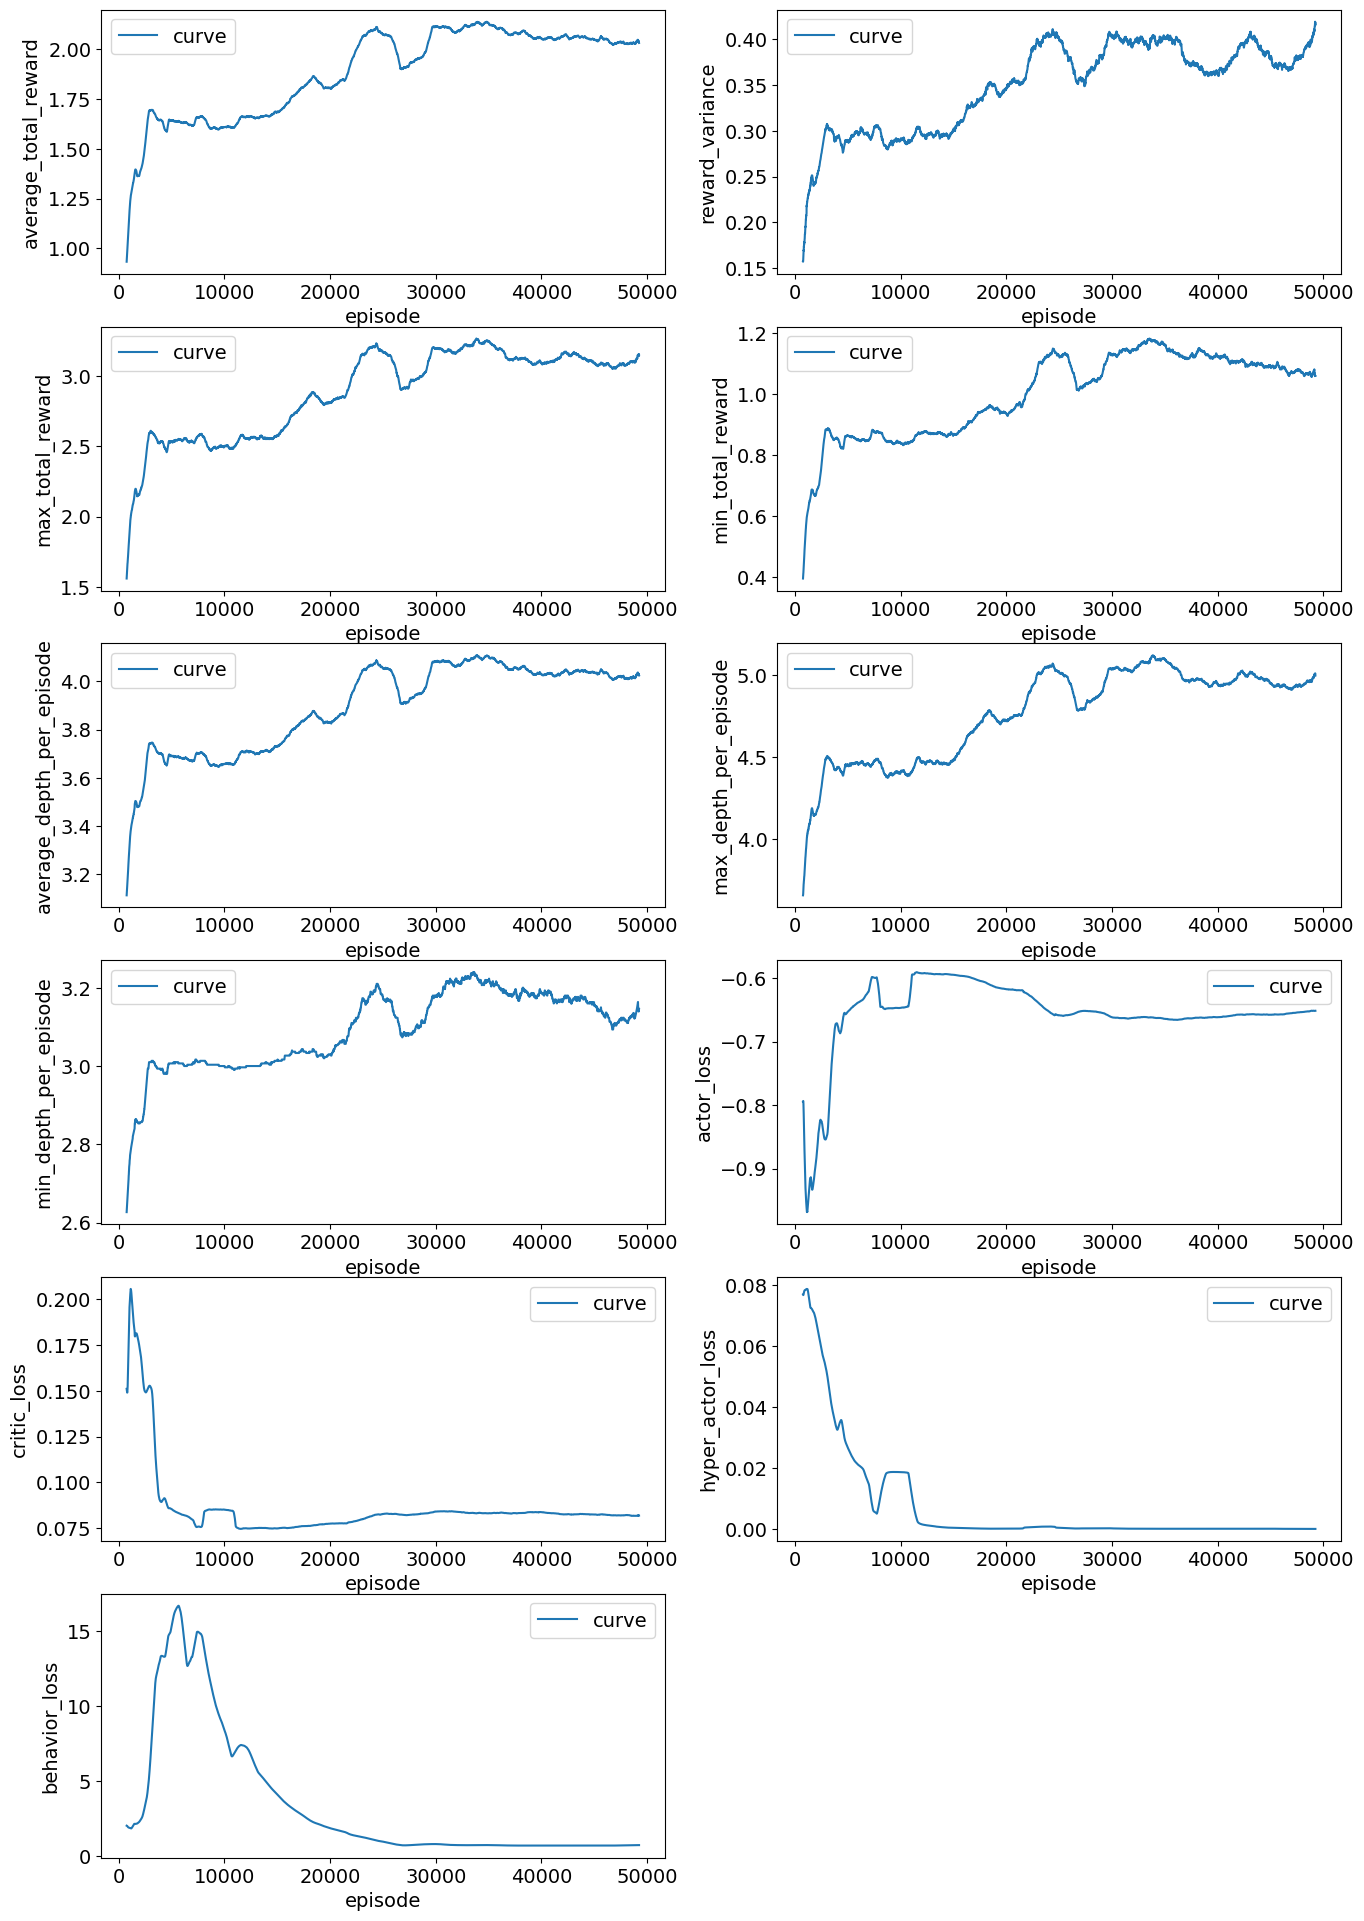

In [ ]:
%matplotlib inline
smoothness = 300
log_path = '/content/drive/MyDrive/RL/HAC/ml1m/output/agents/model.report'


info = get_rl_training_info(log_path, ['actor_loss', 'critic_loss', 'hyper_actor_loss', 'behavior_loss'])

for k in list(info.keys()):
    v = info[k]
    info[k] = smooth(np.array(v), smoothness)
print('\t'.join([k for k,v in info.items()]))
print('\t'.join([str(v[-1]) for k,v in info.items()]))
plot_multiple_line(["curve"], [info], x_name = 'episode')